## TOC:
* [EDA](#Loading)
* [Cross-Validation dataset](#cross-validation)
* [Fit a random forest](#forest)
* [PCA](#PCA)
* [Fit a forest to PCA](#fit-PCA)
* [Fit a CNN](#fit-CNN)
* [Summary](#Summary)

*Week 7 Assignment*

**EDA and PCA/CNN on digits**
***Ryan Amundson***

In this notebook, we are starting some explority data anaylsis along with training a random forest model on both the full set and then PCA data. Next we will train a neural network and test predictions from that. 


In [1]:
# Imports
import os
from scipy import stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import timeit 

from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 
from sklearn.metrics import confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import HalvingGridSearchCV, RandomizedSearchCV

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import RocCurveDisplay

from scikeras.wrappers import KerasClassifier

import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from scipy import stats

%matplotlib inline

## EDA <a class="anchor" id="Loading"></a>

In [2]:
# Set some options to see more columns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


digitsDf = pd.read_csv('digits/digit-recognizer/train.csv')

digitsTestDf = pd.read_csv('digits/digit-recognizer/test.csv')

print("There are {} missing rows in the data".format(sum(digitsDf.isna().sum())))

digitsDf = digitsDf.dropna()

print("There are {} features in the data".format(len(digitsDf.columns)))

digitsDf.columns

There are 0 missing rows in the data
There are 785 features in the data


Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5', 'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779', 'pixel780', 'pixel781', 'pixel782', 'pixel783'], dtype='object', length=785)

In [3]:
digitsDf.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,pixel40,pixel41,pixel42,pixel43,pixel44,pixel45,pixel46,pixel47,pixel48,pixel49,pixel50,pixel51,pixel52,pixel53,pixel54,pixel55,pixel56,pixel57,pixel58,pixel59,pixel60,pixel61,pixel62,pixel63,pixel64,pixel65,pixel66,pixel67,pixel68,pixel69,pixel70,pixel71,pixel72,pixel73,pixel74,pixel75,pixel76,pixel77,pixel78,pixel79,pixel80,pixel81,pixel82,pixel83,pixel84,pixel85,pixel86,pixel87,pixel88,pixel89,pixel90,pixel91,pixel92,pixel93,pixel94,pixel95,pixel96,pixel97,pixel98,pixel99,pixel100,pixel101,pixel102,pixel103,pixel104,pixel105,pixel106,pixel107,pixel108,pixel109,pixel110,pixel111,pixel112,pixel113,pixel114,pixel115,pixel116,pixel117,pixel118,pixel119,pixel120,pixel121,pixel122,pixel123,pixel124,pixel125,pixel126,pixel127,pixel128,pixel129,pixel130,pixel131,pixel132,pixel133,pixel134,pixel135,pixel136,pixel137,pixel138,pixel139,pixel140,pixel141,pixel142,pixel143,pixel144,pixel145,pixel146,pixel147,pixel148,pixel149,pixel150,pixel151,pixel152,pixel153,pixel154,pixel155,pixel156,pixel157,pixel158,pixel159,pixel160,pixel161,pixel162,pixel163,pixel164,pixel165,pixel166,pixel167,pixel168,pixel169,pixel170,pixel171,pixel172,pixel173,pixel174,pixel175,pixel176,pixel177,pixel178,pixel179,pixel180,pixel181,pixel182,pixel183,pixel184,pixel185,pixel186,pixel187,pixel188,pixel189,pixel190,pixel191,pixel192,pixel193,pixel194,pixel195,pixel196,pixel197,pixel198,pixel199,pixel200,pixel201,pixel202,pixel203,pixel204,pixel205,pixel206,pixel207,pixel208,pixel209,pixel210,pixel211,pixel212,pixel213,pixel214,pixel215,pixel216,pixel217,pixel218,pixel219,pixel220,pixel221,pixel222,pixel223,pixel224,pixel225,pixel226,pixel227,pixel228,pixel229,pixel230,pixel231,pixel232,pixel233,pixel234,pixel235,pixel236,pixel237,pixel238,pixel239,pixel240,pixel241,pixel242,pixel243,pixel244,pixel245,pixel246,pixel247,pixel248,...,pixel534,pixel535,pixel536,pixel537,pixel538,pixel539,pixel540,pixel541,pixel542,pixel543,pixel544,pixel545,pixel546,pixel547,pixel548,pixel549,pixel550,pixel551,pixel552,pixel553,pixel554,pixel555,pixel556,pixel557,pixel558,pixel559,pixel560,pixel561,pixel562,pixel563,pixel564,pixel565,pixel566,pixel567,pixel568,pixel569,pixel570,pixel571,pixel572,pixel573,pixel574,pixel575,pixel576,pixel577,pixel578,pixel579,pixel580,pixel581,pixel582,pixel583,pixel584,pixel585,pixel586,pixel587,pixel588,pixel589,pixel590,pixel591,pixel592,pixel593,pixel594,pixel595,pixel596,pixel597,pixel598,pixel599,pixel600,pixel601,pixel602,pixel603,pixel604,pixel605,pixel606,pixel607,pixel608,pixel609,pixel610,pixel611,pixel612,pixel613,pixel614,pixel615,pixel616,pixel617,pixel618,pixel619,pixel620,pixel621,pixel622,pixel623,pixel624,pixel625,pixel626,pixel627,pixel628,pixel629,pixel630,pixel631,pixel632,pixel633,pixel634,pixel635,pixel636,pixel637,pixel638,pixel639,pixel640,pixel641,pixel642,pixel643,pixel644,pixel645,pixel646,pixel647,pixel648,pixel649,pixel650,pixel651,pixel652,pixel653,pixel654,pixel655,pixel656,pixel657,pixel658,pixel659,pixel660,pixel661,pixel662,pixel663,pixel664,pixel665,pixel666,pixel667,pixel668,pixel669,pixel670,pixel671,pixel672,pixel673,pixel674,pixel675,pixel676,pixel677,pixel678,pixel679,pixel680,pixel681,pixel682,pixel683,pixel684,pixel685,pixel686,pixel687,pixel688,pixel689,pixel690,pixel691,pixel692,pixel693,pixel694,pixel695,pixel696,pixel697,pixel698,pixel699,pixel700,pixel701,pixel702,pixel703,pixel704,pixel705,pixel706,pixel707,pixel708,pixel709,pixel710,pixel711,pixel712,pixel713,pixel714,pixel715,pixel716,pixel717,pixel718,pixel719,pixel720,pixel721,pixel722,pixel723,pixel724,pixel725,pixel726,pixel727,pixel728,pixel729,pixel730,pixel731,pixel732,pixel733,pixel734,pixel735,pixel736,pixel737,pixel738,pixel739,pixe

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

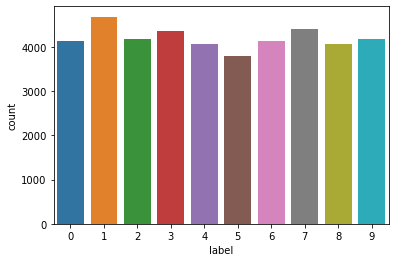

In [4]:
g = sns.countplot(x=digitsDf["label"])

digitsDf["label"].value_counts()

## Cross-validation dataset creation <a class="anchor" id="cross-validation"></a>

In [5]:
# Now let's create a test/training set

X, X_test, y, y_test = train_test_split(digitsDf[digitsDf.columns[digitsDf.columns!='label']].copy(), 
                                        digitsDf['label'], 
                                        test_size=0.2, 
                                        random_state=42)


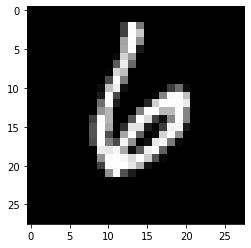

In [6]:
# What do the images look like

first_image = X.iloc[0]
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

## Full Forest Regression <a class="anchor" id="forest"></a>

Best parameters: {'regressor__criterion': 'gini', 'regressor__max_depth': 25, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 500}
Parameter tuning time: 381.87
Random forest fit time: 59.12


/Users/ramundson/.local/share/virtualenvs/ramundson-TB643h2I/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


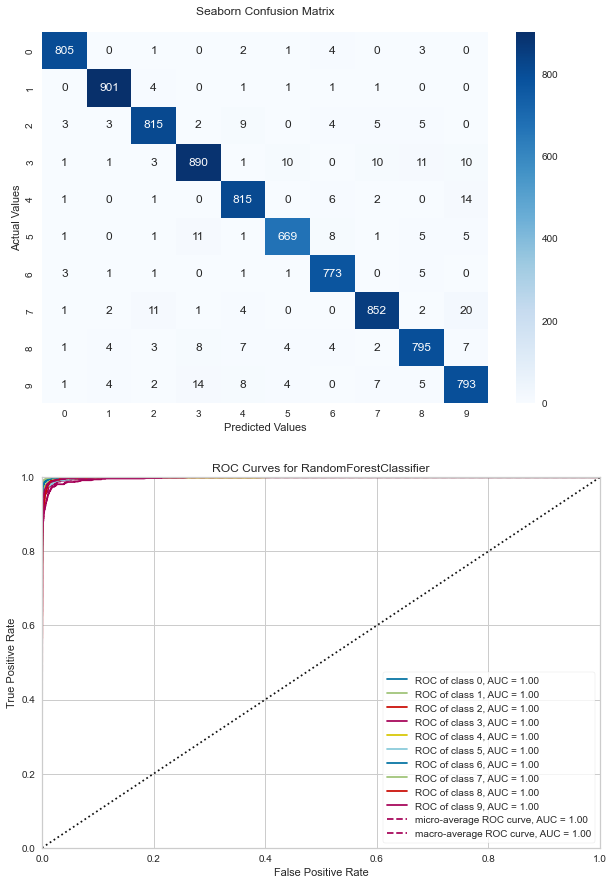

In [7]:
# Fit a random forest on all the data with timings
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ROCAUC

grid = {}
grid['regressor__max_depth'] = [15, 20, 25, 30]
grid['regressor__criterion'] = ["gini", "entropy"]
grid['regressor__n_estimators'] = [300, 400, 500]
grid['regressor__max_features'] = ["sqrt", "log2", len(X.columns)] 

regressor = RandomForestClassifier()
pipeline = Pipeline([("regressor", regressor)])

gscv = HalvingGridSearchCV(
                    pipeline, 
                    grid, 
                    scoring='f1_weighted', 
                    cv=3,
                    aggressive_elimination=True,
                    error_score=0.0,
                    n_jobs=8)

start_time = timeit.default_timer()
l_grid_result = gscv.fit(X, y)
stop_time = timeit.default_timer()
    
l_best_params = l_grid_result.best_params_ #{'regressor__criterion': 'gini', 'regressor__max_depth': 25, 'regressor__max_features': 'log2', 'regressor__n_estimators': 300} #l_grid_result.best_params_

print("Best parameters: {}".format(l_best_params))
print("Parameter tuning time: {time}".format(time=round(stop_time - start_time, 2)))

# prepare the model with target scaling
best_depth = l_best_params['regressor__max_depth']
best_n_estimators = l_best_params['regressor__n_estimators']
best_criterion = l_best_params['regressor__criterion']
best_max_features = l_best_params['regressor__max_features']
best_min_impurity_decrease = 0.0 #l_best_params['regressor__min_impurity_decrease']

regressor =  RandomForestClassifier(max_depth=best_depth,
                                            n_estimators=best_n_estimators,
                                            criterion=best_criterion,
                                            max_features=best_max_features,
                                            min_impurity_decrease=best_min_impurity_decrease)

pipeline = Pipeline([("regressor", regressor)])


start_time = timeit.default_timer()
pipeline.fit(X, y)
stop_time = timeit.default_timer()

y_pred = pipeline.predict(X_test)
print("Random forest fit time: {time}".format(time=round(stop_time - start_time, 2)))

fig, axs = plt.subplots(2, 1, figsize=(10, 15))

conMatrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs[0])

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');

visualizer = ROCAUC(pipeline)

visualizer.fit(X, y)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()   

## Display the visualization of the Confusion Matrix.
plt.show()

In [8]:
# Let's also print the accuracy and recall scores
print("Precision score: {:.2f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
print("Recall score: {:.2f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
print("Accuracy score: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))

Precision score: 0.97
Recall score: 0.97
Accuracy score: 0.97
F1 score: 0.97


In [9]:
predictions = pipeline.predict(digitsTestDf)

df = pd.DataFrame(predictions, columns=["Label"])
df.index += 1 

df.to_csv("digits/predictions.csv", index_label="ImageId")

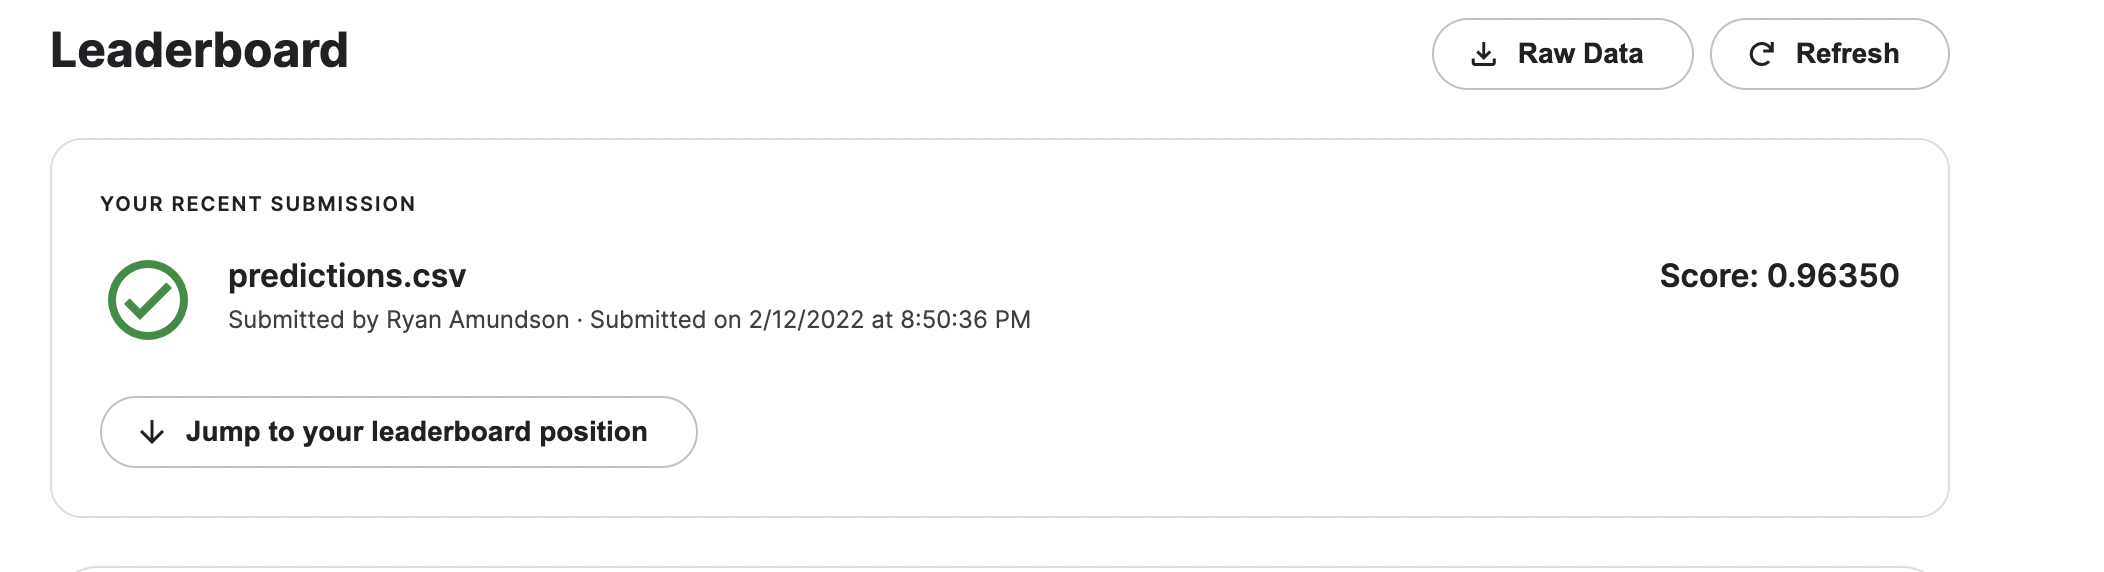

In [10]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAACDgAAAI8CAYAAAAeS4lkAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAACDigAwAEAAAAAQAAAjwAAAAAQVNDSUkAAABTY3JlZW5zaG90bcygKgAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTcyPC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjIxMDQ8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KxShW2AAAABxpRE9UAAAAAgAAAAAAAAEeAAAAKAAAAR4AAAEeAAKcTct7RNEAAEAASURBVHgB7L0JwF5VcTd+EnaSsCRsAgGCgguiQNC2KsUFULCtuH0qikoAv7rbunxfC1h3q+2/1Qq499+vtdVWBb7WtZXFuiCyBsSFPex7EAg7yTdz5vzmzJxz75vwkoTkzVzlzm9mfufMc+eZM/fmee57n2nLaEsDGxunWTsZlpEBNh41rSjCNSMAs1yWltEojJMpQbABPO4YZIj4kX/UUdRfrL/oP7abmo4JmGX03zj/xPkX5w27YvwVh9ewhNRKhrj+iOsP1FFcf8T1R1x/2G5qOiZglnH9Edcfcf2B84ZdMXptMQCwhNRFhrj+iOsP1FFcf8T1R1x/2G5qOiZglnH9Edcfcf2B84ZdMXptMQCwhNRFhrj+iOsP1FFcf8T1R1x/2G5qOiZglnH98Vhef0zDDQ7d22A7mJ7lKuj41UXIvcPV05lh4BFNGiJ+7aA1g4q6fKmHAfIKWZxQIZUX+e/yGfUX9YczuFtbonT14jhYYJCx/nIGkA7I6D+UFvknQ1dP0X+i/0T/cV3VKt16sU7tK9poxAsVUnlx/dPlM/pP9J/oP66rWKVbL9apfUUbTfQfzgDSAamG6L9dPUX/jf4b/dd1Vat068U6ta9ooxEvVEjlRf/p8hn9J/pP9B/XVazSrRfr1L6ijSb6D2cA6YBUQ/Tfrp6i/0b/jf7ruqpVuvVindpXtNGIFyqk8qL/dPmcIv1n2rKldCS4LasUib7/pPMDHqaVhWbtrp6YR/+5aRpDo+bh2TbgsKaIH/mP+sOXoM0aM4vQrpm6uCqh85Mr2wYc1hTrL9ZfrL9Yf9xJbF+onUVQ52sMjZoHZduAw5qi/0T/if4T/Ycbhu0L0nXqvvM1hkbNA7NtwGFN0X+i/0T/if7DDcP2hdp5BHW+xtCoeVC2DTisKfpP9J/oP9F/uGHYviBdp+47X2No1Dww2wYc1hT9J/pP9J/oP9wwbF+onUdQ52sMjZoHZduAw5qi/0T/if4T/Ycbhu0L0nXqvvM1hkbNA7NtwGFN0X/W7v6jT3CQUrFvLVusbrGwnbuYMEbYtLfPNQJn9O6QNobVLY74OQMDKYn8S1J0H/XX3xUR62/k7tB2QVnd4ug/0X8oAwMlAaO4aB/9J/qP/PukNA2uG6qLwbuz24KyusVlqgFT1J8kRfex/mL9xfqrvYdR9J/ov3H+8Wsia+0J1eoWl6EDpjj/SlJ0H+ffOP/G+df3mjj/xvk3zr9+TcT5lzLQXlBY3eKSugET5hAX7eP8G+ffOP/6XhPn3zj/xvnXr4mstScUq1u89px/8g0O9i4VOUHyAZSumI9LDo73vKFfVqu3CMvs80DaDRYVRaSGg7u0In6T5ZzkvMuXP5H/qD+/2qQ2ZLVZHOtPM8Bp4dUT/UdTYkH03zj/xPnXdlVeHUXPLVX6am4j1VM+jhCfrCeLxZL3eSDtov+YpFQY/Sf6T/Sf6D/SEXKzJBj9N+cjn1LyLv79V04ZdqVMK2fhWjvwFjKLXFK0i/OvSUqFcf6N82+cf9E3crOgxRHnn9wh8qkn7+L8U1qmrZQ4/0htSGosLsliwWbexfmXE9Ftcf6N82+cf21X5SUS59/cKHJLlb6a22jNTG6rcf6R3ORclYwINvucONrF+cckpcKpfP6RJzjkGpFCUcjHj55TczGKeBxveYhTxG73nVuDluXaEezoYeyGOKXnd242TMs7WSIdoZ+jtbghTmmZ5XqPQ8KVQ+ddxOe8LCd/SJuVbohTLEtw52ZDvP+chKg/lAKXii5QVibeXE05pR/XuaP+Yv1F/6GFEv1HWwG3jeg/ffMcsbie6pR+QOfWpEf9aSo4bVF/ffGMWFxNOaUf0Lk16VF/mgpOW9RfXzwjFldTTukHdG5NetSfpoLTFvXXF8+IxdWUU/oBnVuTHvWnqeC0Rf31xTNicTXllH5A59akR/1pKjhtUX998YxYXE05pR/QuTXpUX+aCk5b1F9fPCMWV1NO6Qd0bk161J+mgtMW9dcXz4jF1ZRT+gGdW5Me9aep4LRF/fXFM2JxNeWUfkDn1qRH/WkqOG1ToP6mLaXbN/xx5EMsVWFKoZitl0mijzjLLExaRl/gTNOMYZZl5KpWocOH2VnSKxwJIeYRp0yYx0Z8m2nkOPJvsyLlgtywxpi3qL9Yf64MclXwTqql1IwtHWUIKfqPXWlIVPQfmxUpGeSGNca8Rf+J/uPKIFcF76RaSs3Y0lGGkKL/2JWGREX/sVmRkkFuWGPMW/Sf6D+uDHJV8E6qpdSMLR1lCCn6j11pSFT0H5sVKRnkhjXGvEX/if7jyiBXBe+kWkrN2NJRhpCi/9iVhkRF/7FZkZJBblhjzFv0n+g/rgxyVfBOqqXUjC0dZQgp+o9daUhU9B+bFSkZ5IY1xrxF/4n+48ogVwXvpFpKzdjSUYaQov/YlYZERf+xWZGSQW5YY8xb9J/oP64MclXwTqql1IwtHWUI6bHqP/QEh6X0ssydK1TL7Tb2ulvemO7Gs8KbxhFv3jui0Hg/Yq6E5SA3nhXeIr7kwZaoS1RxkxgxV8JykBsf+ZdsRf2VqpHqyHtXKLWoRsyVsBzkxrPCW+Rf8hDrPxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsBzkxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsBzkxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsBzkxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8Lbaqo/+YkKDuheBRvMtoyc/PslJPhxD/raDGUM1mmH7pYyoyrRGAuM+JH/qL9Yf9F/ov/G+SfOv/0VwqilXlbE9Ud/t7ZJW02UMRYY119x/RXXX3H9Fddfcf0V119x/dVfIYxa6mVFXH/F9Vf7tFZTNrVQjLHAuP6M68+4/ozrz7j+jOvPuP6M68/+CmHUUi8r4vozrj/j+nP0u/u6UPq1tBZffw/8RIX9RwXj4ZRMlI98swTSNDi8jCYxesNETmrEj/wPFtCE9+NE/WHxjS3fWH95XUX/if5L7WWww8T5pyRmMDvRf8daK7debq/YBtMX/Tf6LxVGnH/i/ENlMNwiqDiyY9Ab/Zf663BmyBH9F2efkSTF+ScnJvpv9F9qIoN9JK7/S2IGsxPnnzj/DK8bPvPE+TfOv8jAYPuI64+4/qDCiOuvuP6iMhhuEVQc2THojesP6q/DmYnzb1x/4OQ7ViTrzvlXf6Iip6Qct0lP00hqYvLqGuDLWHHADanzOoNRDATXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxZH3S5ct44coyF23DEYH6ehCGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTuw9raXqigAgu6jVIJRxYu9pLVVXBABZw3VIKOPE3tNaqq4IALKLWg1CGSf2ntZSdUUAkDVch4QyTrQeeoIDP4vPbnDDXO56wG9JwE1DDDSat9qZGas3A9UMDTaWvEX8nLXIv5YCns2DSpE6gQYp1nav3gxUMzTYWPIW9Rf1R7UQ60+XQqw/6QzoFF7zVvHVvXozUK0S9AzJPt6i/0T/oVqI/qNLIfqPdAbfPaBBCqfdqzcD1QwNNpa8Rf+J/kO1EP1Hl0L0H+kM6BRe81bx1b16M1CtEuL6h3JRem7OSvTf6L+0TqL/1mXBS4I23z2gQQqn3as3A9UMDTaWvMX6i/VHtRDrT5dCXP9IZ0Cn8Jq3iq/u1ZuBapWgXY19vEX/if5DtRD9R5dC9B/pDL57QIMUTrtXbwaqGRpsLHmL/hP9h2phLe0/05bRIxzSNBS1lPTQfpgBK6QfyfdOTJsmC4QQ+pKrFzmfD4+3sw0zYIW0IyhMxI/8R/3RolhG/4v1x50ob9Qu0K+j/1BGov9zEqQ2RvYjZ5gybsQb5584/8T5h9ZInH/i/BvXH3qGieuPuP6iYsj1kC8dhq8f7KXIMANWSDsi/v0b//6Pz1/i8yfuMnH9Fddfcf0V11/l+oAuF+Lzr7j+iuvPfGqMzz/j818qBD07lCbpxci/sMq4EW98/huf/8bnv7RGHsN/f9CHALQMzfJWRYFf6QMamDwRv5+QSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZna/USFkDFEZnM2O3ogWG+qc2VEO717tCfLH1SXPdwRn29AKXmM/MtdNCiO5cqSN+JlRLuoP66n4U2yVXPGLGeL+ov6y3clDtdPb621lBHtYv3F+ov+068UtrheWyjOFv03+m/03+HFM2iV1cOujGgX5584/8T5Z3CxxPmH0qL/1i4pivOvyUlcf8T1R1x/DDfPQWtcf+BqI66/KBNx/RnX33TxGdefg80yrj8pLXH9Wc+ZXCWiFVtcf1KBjHWPoTVVc5kR7eLzj+i/YxUk1VJrZm1ff80NDubAFCrIq8dq6DXZZh3dOpvQadiGp1BBxKcM2GxE/qXX55zYxJiKEjih07ANT6GCzLNa5D/yz9cauSZsYZiKivrjDEyYHJMtw1OoIPOsFusv1l+sv+g/uSfYxmA6isAJnYZteAoVRP+hDNhsRP+N/hv9N/pv7gm2MZiOKnBCp2EbnkIFmWe16D/Rf6L/RP/JPcE2BtNRov9wBiZMjsmW4SlUkHlWi/4b/Tf6b/Tf3BNsYzAdReCETsM2PIUKov9QBmw2ov9G/43+G/039wTbGExHFTih07ANT6GCzLPa2tB/mhscmgZKhzR2pweY9oBNpjoovMrOqKrKtyaLlaBAvBNzlFxODJWdUVWVaE0WK0GBeCfmKDniUyrsnYk5bwPJsyaLayaBxDsxB9y+WvO4gcHWZHGdCUi8E3PAjfhttrI+kDxrsrhmEki8E3PAjfy32cr6QPKsyeKaSSDxTswBN/LfZivrA8mzJotrJoHEOzEH3Mh/m62sDyTPmiyumQQS78QccCP/bbayPpA8a7K4ZhJIvBNzwI38t9nK+kDyrMnimkkg8U7MATfy32Yr6wPJsyaLayaBxDsxB9zIf5utrA8kz5osrpkEEu/EHHAj/222sj6QPGuyuGYSSLwTc8CN/LfZyvpA8qzJ4ppJIPFOzAE38t9mK+sDybMmi2smgcQ7MQfcyH+brawPJM+aLK6ZBBLvxBxwI/9ttrI+kDxrsrhmEki8E3PAjfy32cr6QPKsyeKaSSDxTswBN/LfZivrA8mzJotrJoHEOzEH3Mh/m62sDyTPmiyumQQS78QccCP/bbayPpA8a7K4ZhJIvBNzwI38t9nK+kDyrMnimkkg8U7MATfy32Yr6wPJsyaLayaBxDsxB9x1N/96g8N4opbRl/PT3JfT9TaysVFjdk44fJDyJnitvjHMj/iRf3tzhJZQBbZgTI015qyi0iCF4zU7Luov1l+sv1h/pkMoVGAbBuExO9Pgg5ShXhMbPLH+Yv3F+jMrRKECu2AIj9mZBh+kDPWa2OCJ9RfrL9afWSEKFdgFQ3jMzjT4IGWo18QGT6y/WH+x/swKUajALhjCY3amwQcpQ70mNnhi/cX6i/VnVohCBXbBEB6zMw0+SBnqNbHBE+tvxdffnXctSXfddWe659770j333Jfuf+C+9MADD6WHH16ali59OOdfZuOMT8+6/OkVZ1k2luyVjT//m06+pWQkT3FOoz+dXUa2LNme/5yRRzCBuPlPawvOtjKQRkV8zl3kf3XX3/Tp09L09aanjTfcMG244QZp001mpE033TjNmjWL/puRq1Rq3u7j829esXfddVe6684l6Z777k33LKGe8uAD1Fvup56ylHoL1XKsf2l9uYqi/62J/T/WP/c1Pu/gXMxSNlihVxn9D1csZYHXFGoua7aWl8062Gfca3a+R5d/usFhKc1d3+j6msdDIrxn4IUUr3OSUi4O8VgLzFEPuB3nJqh0gzwj4kshtnlkPfIf9UdrnP4f64/SYNpd9B/fRaP/U7vM9dHkpbRVKzwjzj9x/uGPrsrmioOUuP6J80+cf+P6g1pBXH+gSbJ0jdKojd0OKdgz4vwb5984/8b1x1BzoE4R119x/RXXX1Pu+uu+++5Lt956e7p98eK0+Ld3pmX03Vq+iDAXB/nrdF7/9AUv+3OPnMZERiCyZJVsbJ5WegZDttNWGKIUHT72ykzlpglRMjfiU24i/2t0/fGXn1tsvnmavcUWaautZ6dNNt6IardWtxa9AabEyTq1rr/vvf/edOsti6mv3JHuyH1laax/894z7N9/rpjofzkzJjlrQ/+P9V+KW983BU3VV9Uzplb/a1d3PeqK1obj1yc4tAdU366K6qEV5I9Q3a0Zuki71yEEwBJbjVqRZWfsh6i7NUMXafc6hABYYqtRK7LsjP0Qdbdm6CLtXocQAEtsNWpFlp2xH6Lu1gxdpN3rEAJgia1GrciyM/ZD1N2aoYu0ex1CACyx1agVWXbGfoi6WzN0kXavQwiAJbYatSLLztgPUXdrhi7S7nUIAbDEVqNWZNkZ+yHqbs3QRdq9DiEAlthq1IosO2M/RN2tGbpIu9chBMASW41akWVn7IeouzVDF2n3OoQAWGKrUSuy7Iz9EHW3Zugi7V6HEABLbDVqRZadsR+i7tYMXaTd6xACYImtRq3IsjP2Q9TdmqGLtHsdQgAssdWoFVl2xn6IulszdJF2r0MIgCW2GrUiy87YD1F3a4Yu0u51CAGwxFajVmTZGfsh6m7N0EXavQ4hAJbYatSKLDtjP0TdrRm6SLvXIQTAEluNWpFlZ+yHqLs1Qxdp9zqEAFhiq1ErsuyM/RB1t2boIu1ehxAAS2w1akWWnbEfou7WDF2k3esQAmCJrUatyLIz9kPU3Zqhi7R7HUIALLHVqBVZdsZ+iLpbM3SRdq9DCIAlthq1IsvO2A9Rd2uGLtLudQgBsMRWo1Zk2Rn7IepuzdBF2r0OIQCW2GrUiiw7Yz9E3a0Zuki71yEEwBJbjVqRZWfsh6i7NUMXafc6hABYYqtRK7LsjP0Qdbdm6CLtXocQAEtsNWpFlp2xH6Lu1gxdpN3rEAJgia1GrciyM/ZD1N2aoYu0ex1CACyx1agVWXbGfoi6WzN0kXavQwiAJbYatSLLztgPUXdrhi7S7nUIAbDEVqNWZNkZ+yHqbs3QRdq9DiEAlthq1IosO2M/RN2tGbpIu9chBMASW41akWVn7IeouzVDF2n3OoQAWGKrUSuy7Iz9EHW3Zugi7V6HEABLbDVqRZadsR+i7tYMXaTd6xACYImtRq3IsjP2Q9TdmqGLtHsdQgAssdWoFVl2xn6IulszdJF2r0MIgCW2GrUiy87YD1F3a4Yu0u51CAGwxFajVmTZGfsh6m7N0EXavQ4hAJbYatSKLDtjP0TdrRm6SLvXIQTAEluNWpFlZ+yHqLs1Qxdp9zqEAFhiq1ErsuyM/RB1t2boIu1ehxAAS2w1akWWnbEfou7WDF2k3esQAmCJrUatyLIz9kPU3Zqhi7R7HUIALLHVqBVZ9o033ZxuvPEWuqnht2TmL2L59r6UZszYNM2cNTPNJLnJxhunTTbaOK2/4fppg/XWT9Por9f5yybm+2hkaiw1akXMcls/SXa3Zugi7d7OBpbYatSKLHswUCH4meqR2cgtp7IiPmegZr2ikt4q+iRmX2uGLtLu61SrI/8P0VNMli19kJ488FC6974H0n30NIIlS+6hpxPcne5esoReTL2hYfMtNkvbb7tt2m7brSgX5sbR8ZesHhwvDNDtkcMGzuo4/hWJz33lhptuTYvvWExHzV/W840N09KsGTPyUy5mzKS+Qj1l4402ShttsEGavv76aT3qK3Zrjw36isTHPLXqKoJPJSZWg4DWDD3i186PnNTUeUvNekWVW5Afou7WDF2k3esQAmCJrUatyLIz9kPU3Zqhx/pft99/qQO715IhgCoRW626iiw7Yz9E3a0Zuki71yEEwBJbjVqRZWfsh6jbmvMNDvirbjeVYQk0e+PLLyzrdHJ0do5HBtwRq+F7EPFp4eX0mUsJk0uBZm98kX9KRs5H1F+sP+ot9Ro9+k/03zj/xPm36Qlx/dFmIK6/4vorrj/5MjKuv/WjTPNvDIFmb3zx7w9KRs5H/PtD8mDPLpwbyou7Jrd+wXH+ifNPnH/i/BPn37j+mOj6Yyk9Cn7Rtdel6667KT348AP5vMt9Y+s5c9KcObPpr883TxtutKE5wcT5J86/cf2xItdfDz74YLqNnoJy++13pFtuvY1uhJCfX1l/g/XTDts/Lu284+Po5y3Wl0u8fL2LZcZrjLCcwJtrvbVj/T300NJ07XXXp2uuvz499OBDmq5ttt4qzZ69Rdpyyy3TRnSTFB9cPtS8mzrHH9ffKN919/y7Lq//qP+pW//mCQ5o2EW6Js42ayj/FLEmHW7+maJ+BWUao+u4BnQUa4j4uRXblGj6Iv96mtL8KIj6y6kw+dC6aUBHsYZYf7H+6KMIWxJaPtF/ov+Uj6m0PhRE/82pMPnQddOAjmIN0X+j/0b/jfMP9Yzuy+M4/8b5N86/eVnoKVNBXH/kVJh8NJcdqnYUa4jrj7j+iOuPuP5Yfdcfi665Ni26+jr6vfuHKeiyNGuzzdIO9Bfm29BfmK833f4FdVz/xPVPXP88muufh+lGoptvvjldf9Mt6c4778yXBOvTUwrm7jQ37TJ3h7z+psr5j/vK1dRXHqK+wjmbtdmstP1226Vtt5pDT2fwfaX+Yyuuf6bK+5+Le2hnL3ez3xqm9vu/Lq3/obe+e7s7w9R+/7vD7Qxrz/GbGxxkAftlXFq6NbYHm311LLvrZ251IBBknsbt6hwYr1wFGGAMGYrOe94wvnyakW0YAZmNblfnwHjlKsAAY8hQdN7zhvERv+YJCFIyZffisX7FCsA3hgxF5z1vkX/JQ9RfrRMgSGSoSvFYv2IFYBtDhqLznreoP8lD1F+tEyBIZKhK8Vi/YgVgG0OGovOet6g/yUPUX60TIEhkqErxWL9iBWAbQ4ai8563qD/JQ9RfrRMgSGSoSvFYv2IFYBtDhqLznreoP8lD1F+tEyBIZKhK8Vi/YgVgG0OGovOet6g/yUPUX60TIEhkqErxWL9iBWAbQ4ai8563qD/JQ9RfrRMgSGSoSvFYv2IFYBtDhqLznreoP8lD1F+tEyBIZKhK8Vg/48X0F+WXXXFluueee/PDCOZsuUWaS39RvuXsLWVoHlDHsjHqT1IT9VerCQgSGaqy1hDqR7kKwDaGDEXnPW8YPxXy/9vFv01X01NTbl98R15/MzfdNO26y075iSn5YNfS47+N+srlV12Vltx9L71fy+hJDZunHXfcIW25xRb6/sm7SkepIB+xN6ylx48jqVIO0h6qYgVgG0OGovOet6lU//lYzOHKERpDhqLznrepdPxTdf3LO2X39T3E+ycW4igA3xgyFJ33vGG8HYgRkMK0+zoHxitXAfjGkKHovOcN4yM+3Ya1jDckRUHOE+WHDPzoIdrUpaBwIFr7oA5jkV6YIGXSiB/5j/rLiwErpy5ELDysFZK1sw2sJfZjFr/wYO3mjvUX6y/WX15go2ukLL9+7QytR8wS6y83K5+GgZ5FhKi/qD/KAFZOBVh4RSphIh2kIr0wQTAHEaL+cjKQucg/pcNeZ5VS6fKiCUMt8TgYi/Qi6g/p0ZySIdZfzoamRgGSVGRrH9RhLNKLqD+kB6mNf//E+ov+E/2HMqCtQQGaRJGtfVCHsUgvTBDMSYR1uP4uvfSKdO0NN+ZkzJw5M83bece01ezZlJMm96witXAN6jAW6cXAHERYh/Mfn//H+4/6v+W229OiRdemu+66O6+/Hekmo92eMA+rbWDtkMuu07zWyoLDYi0qrDDrpKvo+uvSy6ivXE99hQLP2mxm2nmnHelnbqiv6Aspr2AVxddAj9HxR3yfeH3bFcT7nzNg6n8qrf+o/3Wn/usTHEwx6wmGANY8pPUBV19F8EFmT+c2hoivF9PIGUtkCNL6gKuvIvggs6dzG0PkP/Jf/jGHmmGJCoG0PuDqqwg+yOzp3MYQ9Rf1F/WH5aISKwRSHQZUX0XGnWH2dG5jiPUX6y/WX7ts4vxHGeHPqUynGM3RRKzoP5THLonGEP03+m/039HeYlbKKCf6z3iWsqdzG0P0n+g/0X9Ge4tZKaOc6D/jWcqezm0Mpv/cffeS9KtLrkh3331Xvu58/Lyd0k5zd3Tfl9o3oc5SkfUzzp7ObQwmvh0LBqT1AVdfRfBBZk/nNoaIH/13Lei/V199LT354Opc1pvNnJWeuPuuacbMGWVtmnpG4Re5JtT/kruor1x6OT214e7cD3bdZS7d3DBXXmGsv1h/a8H6a5ZVVuuqq6jlraz1tzav//j8harC3nRmP9Wbov2v3uBgV0S7Tlpdub2jtyi5AiIto2orv5RV7UDtJK0Onn2Dim2UqmMIRPzIf9RfrD/f7WuHaJtIqyuzd/QWJVdApOh/0f/j/Oeuttz6cEtzdFH1jt5Sp1UU6y/6T5z/4/zvmox2h/Jp+AS6uvpu01uUXEH0n+g/0X+i/0T/qT3RoraJtrpye0dvUXIFRIp/f8W/v+LfX2vev79uufX29MtfXZKW0v9mzZiVdt9tXtqMnt4w3Cr71d5b6rJXFOs/+l9cf036+utOeorDJZdeSU9zuDNNX3+99JQn7pa23mpOXl5r6vq75dbb0i9/fWlaupT7ysy02xPnpc3pBo3BrT2IVtdBvaO3KLkCIsX1R1x/rK3XH2vj+q+Lj1Csv3Wm//gbHPIbb64lR+7q0GIx3VygMTAJapa8YxMt62KHOzvESYmP+PrPjsg/FYNmQ8tEgSkggcZQ6in/wyibeRf1F+sv+k/0X2oE1FaabpENcf6J86+eceL8G+ffuP7I102DO9NABRoDD4CaJe/i+iuuv+L6K66/qBHE9Ze2x9wYpTnG5x9UF3H9VSoirj/j+nMduv687rob028uvyKv/8dtt0160m6Pj/d/HXr/+YQYn7+sPee/X//msnTDTTfnf+ftttuuacftt5ULO1zQrCH//uO+csnll+fEbrfttunJuz0hY7w8vNyov1h/0X9WvP+sLetf/qEVnz9xn1vXPn+SGxy6Tp/PWfUfmlIhch4Y4OoJ4pECzAVpxnuT0Qw09MlBzAVpZvEmoxlo6JODmAvSzOJNRjPQ0CcHMRekmcWbjGagoU8OYi5IM4s3Gc1AQ58cxFyQZhZvMpqBhj45iLkgzSzeZDQDDX1yEHNBmlm8yWgGGvrkIOaCNLN4k9EMNPTJQcwFaWbxJqMZaOiTg5gL0sziTUYz0NAnBzEXpJnFm4xmoKFPDmIuSDOLNxnNQEOfHMRckGYWbzKagYY+OYi5IM0s3mQ0Aw19chBzQZpZvMloBhr65CDmgjSzeJPRDDT0yUHMBWlm8SajGWjok4OYC9LM4k1GM9DQJwcxF6SZxZuMZqChTw5iLkgzizcZzUBDnxzEXJBmFm8ymoGGPjmIuSDNLN5kNAMNfXIQc0GaWbzJaAYa+uQg5oI0s3iT0Qw09MlBzAVpZvEmoxlo6JODmAvSzOJNRjPQ0CcHMRekmcWbjGagoU8OYi5IM4s3Gc1AQ58cxFyQZhZvMpqBhj45iLkgzSzeZDQDDX1yEHNBmlm8yWgGGvrkIOaCNLN4k9EMNPTJQcwFaWbxJqMZaOiTg5gL0sziTUYz0NAnBzEXpJnFm4xmoKFPDmIuSDOLNxnNQEOfHMRckGYWbzKagYY+OYi5IM0s3mQ0Aw19chBzQZpZvMloBhr65CDmgjSzeJPRDDT0yUHMBWlm8SajGWjok4OYC9LM4k1GM9DQJwcxF6SZxZuMZqChTw5iLpLXXH99uuzyq/I8u+w8N/F/eqNTfP5MeSnZQM4ml3E/CnNBGq83Gc1AQ58cxFyQZhZvMpqBhj45iLkgzSzeZDQDDX1yEHNBmlm8yWgGGvrkIOaCNLN4k9EMZPqVi65JV9F/vO226y5pxx23z3iFdpgL0gzyJqMZaOij8Jprqa9ccVVePTvvvFOat/OOlYu5IKvHdhyyGoKBhj45iLkgzSzeZDQDDX1yEHNBmlm8yWgGGvrkIOaCNLN4k9EMNPTJQcwFaWbxJqMZaOiTg5gL0sziTUYz0NAnBzEXpJnFm4xmINPX9PVvDqmHOBZIw/Amoxlo6JODmAvSzOJNRjPQ0CcHMRekmcWbjGagoU8OYi5IM4s3Gc1AQx+F/gkOShuYZcCU6dlunAoV6OmhWtwpQ6NWYJnFOmCK+JSBnBeTHIUKIv+UJv7nQc2Ix7mO3M4yi2PAlD3ZbpwKFWjcaon4Nhcu9TWp3jw2INuNU6GCyD9lMurfr7laHb7MRBvwDpgyN9uNU6GCqL+ov1h/VAN1RXgsa87uLbPYB0zZk+3GqVCBxq2WiG9zYTMveMA7YIr8UwZyXkxyFCqI+qM0xfWH7zm1OmTF+f2Ad8CUx2S7cSpUEPUX9Rfrj2qgrgiP/dpjzTKLd8CUPdlunAoV6GzVMhihBGJhmcU8YMqebDdOhQp0tmoZjFACsbDMYh4wZU+2G6dCBTpbtQxGKIFYWGYxD5iyJ9uNU6ECna1aBiOUQCwss5gHTNmT7capUIHOVi2DEUogFpZZzAOm7Ml241SoQGerlsEIJRALyyzmAVP2ZLtxKlSgs1WLj3Dt9Temyy67IvN2ezx9SbrD42jq8oV+Ca+TQIfMk5qZFSrQodXi42OqKi2zWAdM2ZPtxqlQQcSnRMX1n6+5Wh216ioa8A6Y1pT6u/b669Klly/KL2e3x88r67e+YCBIJlqcB7rdgHfAlIdku3EqXJauvf6mdCn3FXoS0m5P4Ne1vXYVpbm4UAa8A6blxUcPw1BIHmcxolY54B0wZX62G6dCBRqrWiK+zUXNO9CAd8AU+acMUF7W1PUf60+uoVC6kFy3Fuc6drsB74ApD8l241SoQGNVy+qLTzc4LKX+T48NLdeT9kXgmGGDZDswJLi9tAyLwVxGJ6CIH/mXehiukPEL5CE+KqufcYgd9RfrL/pP9J++W6CPoGtAsh0YEtxeWobFYEb/if4T/Sf6j/SD4Q4R1z9jH5AO5Qudtc/oEDv6b/Tf6L/Rf/tugT6CrgHJdmBIcHtpGRaDGf0n+k/0n+g/0g+GO8TUvf675dZb00UXX5Km0wXe4/PNDfVLyNohp+7x85kk+l/0v7W9/11z3XX0BJZFeck+9SlPTFtvNacsX9vRLK6re1XU/83UV375y0tpdS1NT6CbLubSzQ31qg2xWcb6WxX5rxm277nFYET+p0L+17T1j+ryaz7qT66kanamev8zT3Aob34WthCsnRNjfTZRK4Z1NAH3ezeYNxOUVeOpScFgwJtvvjV997vfJh9dMdtPRZeyviw9Z7/90uN3nZcPY1XEH3xRxqivnsC6En/RNVenM079Yc5/e/z8D5t99tknPfWpe8h7lgnKIlvBalJgsrriUEcTWNX5/68f/CBdf931Uoel/mz8Vx/26rTRhhuWF188WShrrT7+oXdFj4zAqs7/6oy/aBHV+BlnUEgqaLqozpJhOeB99pmf9qQan6rHT0e6Qlscv1QIF8JUqv8VevOJFO9/vP/cFqP+Y/1H/yu9IDfP0hmz0C5ZO6aaFORRj3SnowlE/iP/uRdH/TXrTFdJY+dEWR/rj2zT0bH+ov/Q4ov1h/VTVkYWukrIae3MtT6MXXGpownE+e+xrb+7lixJ5y+8KC19eGnamR4dP48eIS9vr75L9f1Wk4IVf9MNU0cTiPf/sX3/I/9TK//yuPpr0/TpKc3f62lp5swZZuUJXB3r7+67l6RzL6C+smxp2mWnudRX5urrWB3xNdgAiPil5qP/Trnzz5qy/geWnZpi/a1b68/c4KA1kIEWAsxNQ6Kn/jRPfTAjALOkO7Ton3H1H3I8IQiYvJcdgwz2gmgs/sKFF6ZDD315yrcEL6VBdFODjf/iFx+Sjv/Mpyigf0XtK5hs/DwPBmfp40scENqoVe8YZFiR418T4//g1NPT0Uf/z3pw9J5Mo4PhY+T34dhj/ywdueCI6ic0FY7/yAVHp9POON3VXz7IcvwXXHBu2myzzdxxQ5kKxy9v4rpR/6efdmo68qg/lreP3zy+c8f0n+OO/XNT4927i7ddZccgw9q6/m3/rQmK/qtv9gCI9785Q0f9x/qnloGuMXb9l5cSFk+W68b5R66mSnbi+KVQ4v2nPET9x/XH6vv3d/RfykD03+i/fCqO80+cf+L823/+VRrkOeddmO66++70uO22SU/a/Qn51IEdWih0HhKff0hb5ZzEv38oF+6fO6ZiALOM69/Vef3760suSzfccHOatdmstO9eez4m/f+cc6mv3EN9ZRvqK098/Gj/0d4yAFBC6iJD9J/oP/H5k6yIsfPPmrD+y+VFXH/H+Y8+/uIfKKKtuwywFaxdvoKOX115NmmFzWkCKqRW4sqLn29weOnL6DXQbYT4S2pCuTFR3IP/4OB0wt/9XTWUj8y741lLj58OlTYkGFKsvbn6V+Xxn3rqaXKDA4Vb5t4WiX8sffm7YMEb6Z3A6YMPgXy4gi0v34ru9Vpnf6DixeFCKm/l1Z8NdOSRR6XTTv9hNqH+7PEvvOAcusFh8+zvjmcKHH+tQ8mKpns15X91xucaP0pv4uEDdIWe+AaHBUccIX1nCh5/eYfH3mix47ghtSBWzfpbne9/HL/NAN5gyLGyqP7of83HENH/1/rzf/Sfur5zB4AKGf2f0iLXvNH/ov9NtX//RP/TRicXQFAho/9F/4v+Xy4Nov+vS/3/ssuvTNdcf32aNZO+CN3nadQJ4/1fl95/aXt6Ioz3fwrV/znnLUx3331P2mH7bdNuT9hVrn14j7cbUg3sWjnr/9LLrkzX5r6yGfWVp1JQ+fdVfhGIC7kK4uc4Oq8GGjFX/8o6/pFAI+aIj/qI/K+c9ceF9liu/5FCHzFH/U/1+p+2bCl9km7OAVwJ9W0nzO7yRbO1S8XUfedrDI2aB2bbgMOaHmn8fIPDy+gJDvSU+Gn0HSN/T8BvojSwZemQQw5JJxxPNzjQtiri54l1ctVcTmFdV+Kfeurp6cij35TfBSwofU8oCcceZ/+6fe2uP7y3/IYfdfTR6dTTziBTrT97/BfQDQ6bz6InOEyh9WeP3x5XrnV1CphK9f8DusHhTXSDAx9TPu6m/xxDTyk5asERLgNT6fi797cxNGrOQxw/lcpAYqzpkZ7/tMDsJGRs1Mg/cjKQGGuK/K9d139R/yUDtohR65ocAZnS8NhjTVH/Uf9r07//tMRtETc1DU7Uf1x/xPUXrYb49ydaQpa2dcT5L85/cf6TBmHXhVswpHS+xmDV225fnC78xa/ymH3pUfabbTbTTWe5sf5i/cX6W7nrD4strzO72IrDmiaz/u6kp7KcS09R4O9f9tzjyWnO7C37/oCeYYM9yvi3c1+56Ff5b8vmP933lYEw8poGHNY0mePPh2EnwbGW44PIlIbHPmuK+NH/1rb+91itf/fPGLuImjUV608ysC70H32CgzlkvP8kbZVYXCgDJowRF+3tc30wM991MPjX+e2EVrd4PP7ChQvToS99RXnlNIbi5xsdeAjhFx/yIvqJik+vsviP9fGvifFPO/00usGBfqKC3wt6Z/I9NfwIf35LaTv2uGPSkUe8kVD7HlvdYh5F24AJRnHRfjXXn41/FD/B4bQfuvqzx7/w/PYnKtoDsrrFcvhr+vHzsT6W+V+d8eUpJX9M91UtpRrPkWVf+s8x/BMV/AQH3lZh/7P1tzqPXw4sHxzt/PGT6rc4/jj/rKLzf9S/nCd0/xie/6L/rDvnv9rgtfL0/Bf9v2Ynozj/xfkvzn/NomBVekd1WN3iwhgwYQ5x0T7Of3w57rfoP9F/ov/4NZG1tqFY3eIydMAU/UeSovuB/nvWOeene+65N+26y05p5512NO9Dm1CrWxz5HyxXY5wo//H5E2Un+p9Zd4DtGrO6xYU/YEL/u+rqa9OVVy1KMzadkZ65714IIHIVXX+cfQ49OYJ+mmLXXXZOO1Ffic8f6A0a6L+x/ikvsf79msxau6CtbnEZOmB6LNd/aS4k4vsHeWtov46v/3yDg71LTAqUS6X8qzhnStOVawj/Xq5Wb8kku2Mif3gx2FTIQyc83KX0aONfuPCi9BJ+ggOHy1FpzyfUEv+QF9NPVHxGnuDAr4q3lRlf8yZTy341Hv+aGP/UH/Dj+98k7z+9HfxXM/SOy/tCd3ke8+f01+1HLigZy8kizO8ebayWP7NpPOIq+8x1WCx5nwfSbjXUn75uCnzUkfQEB/6JClN/fFg4fvmJis2i/lbi+rf51wpYDe//qaeeTj/DcjRVIL/BFJnLLQva0/EdS09wOFJrXF9ZBtF/Vl7/f6zef3lHudD4XW+21VB/EjHiR/6j/prVJ9cQuSEP5IbI0X+j/66sf39E/xlYY3H+4y5DpTGQm+g/0X+nwL9/5Jwb15/R/wd6XPT/6P/l/Lfo2uvSlVcsSjPzT1PsmdtGXH/H9Xdcf6Nv5mZJ66Lo+ZQq59XGwyuKWLLPC8lhseR9Hki71Xz9ee55F6Y7714iNzLN3X6Vxl90DfWVK68qfeVp5uAJPkbHry8i4subsJrrL/JfMvAY1d/qXP9ypHyg6KP67sf6f4zef30HHsP48gSHXBdSHAr51Q3Uir7oBuRjwBCnNERSO7cGLafrjtDP0Vow5MKFF6ZDD31FjrKMvjzXR1AWwiGHHJyOLz9RoYe3EuPnOfFiNIB/tZ17isc/9TS6weEoeoJD2eT4+atgTtC0dOwx/OXvGzPWVJC2Ntafff8XHH1UOp2e4JCPA286HRaO/6ILzkuzNqOfqNCDfvT1b+OP5Q8vJXM5zxFfG4WmgvOiCWJl4o1/ouIoekqJ5J/39KM4pv8ce0z9GZbIv+RS06tJj/rXVHCKNEGSr4n2rqac0o/q3Bo08q+p4LRF/vviGbG4mnJKP6Bza9Kj/jQVnLaov754RiyuppzSD+jcmvSoP00Fpy3qry+eEYurKaf0Azq3Jj3qT1PBaYv664tnxOJqyin9gM6tSY/601Rw2qL++uIZsbiacko/oHNr0qP+NBWctilWfw8//HD66c/OSQ+S3HOPJ6at58yR4tCDjvdfUzEF3395s/H5pylvPeh4/zUVU+D9v2XxbekXv/hNWn/99dKzfmfftN566+US4GPkTdubHvTk3v+lDy9NP/7Z2ekh6itP2+NJaavZs5sAomK/suPzvG5OpyBqlZ2bDeaPODNkuiaojh1Dbk6n9CM6d8SP/K+C+ltd658r3NW0U6L+2wx06ZnC638a/VwAP8TCbPloi25SUczWyyTRR5yYldzLaAHJF9p1FI+2VqHbCIx5o1c4EkLM1bnwQrrB4aX0BAfa8tM52EX/LZu+LE0nw8F0g8MJx9NPVOSzx8qPP3hS4vir6fjXxPin0RMcFvzPN+X889uR3xC6m4/urskP9D+OH9+/4IjsyT49CGE/kvdfh5bZsniM8r/gqKPpBocz8iGh/uzxX3j+OWnmZps3L5kZWJFr9/HrW/AY5X91xj+VnuCQb+LBW0fBbf855v30lJIj7FNKmBj9Z2X3f106+ubnNK/T/Tef/9bh808cP/ciu9Jwjon+Y7MiLQO5YS3Ov5ITOleVtNjsIEPlYynlyBizp0FRf7ZJdz89AABAAElEQVTSkMVYfzYrUjHIDaqLZdRfrD9XBlwUeZNqKTVjSwcElmSP/mNXGhIV/cdmRUoGuSmFk43Rf6L/UCHUMpBSob1US6kZWzrKEFL0n2Vp0SJ6bP2ia9LsOZunp++xR05MrL/6qbiUjC0ixrzVwrNe9oherK2TCbyRPerPVhoSFec/mxUtFv0QjfPE2+Trb+EvfpkW33ZH2nmXHdO8nXeS6XAyIbky4i9adDX1lWvT7C23SE/f8yklhhFR/7H+4/MvWsW0jvO2+vrf6lj/8flTeT/xtprWh7d7XT3/03fMSykt5s45rAGTpLG8GcqE0I1nhTeNI968d0Sh8X7EXAkGLeQnOJQbHNjMYZYWyfqLDy5PcFhF8TlGu+H133333Wn96euljTfZZJUdv429ZMmStN706WkjiucOl0nO8Oje/4ceeig9cP/9adMZM2x4xfzX7UfTX7fzRueZfFEjdyyyhR/ff0xaQDc4sK++LvbJNmKGO8sllNvpdIfoJpzbZnPjWeFtJR3/w0sfTotvX5w23mijNGPmTHoKmE5MT6WgGxxOP8PVnz3+hQvPTZvNmpVfTH6N5YXyI/vuuutu8s2k16ntO7/syeyWd/wca6ONN04brr+ByUuN5MZX8wojN56Uhx56OC2h30qbtdmsND3n69HV3/JeiI1/9513pQco/syZm6YNN9yQhoo37y3RTMrmpVTj9z9ANU6/KTe0nUY1fiQ/paS+/ZnGKvcfvYmHJ+NNeRI07wWK3+xHzIYxMXTjWeEt4kseVvD913SVUY9ERP6bcuPkaUIlO3nvElUzPGKuhOUgN54V3iK+5CHqPxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8Jb1J/kIeovF0OuEVcoJT0kRsyVsBzkxrPCW9Sf5CHqLxdDrhFXKCU9JEbMlbAc5MazwlvUn+Qh6i8XQ64RVyglPSRGzJWwHOTGs8LbOlh/Pz6T/sr6gQfT0/bcI82evbnkIeovF0OuEVcoJT0kRsyVsBzkxrPC2zpYf/m44/hzGlbX+3/H4jvSeRf9Mm24wQbpOb/3DCnmlVx/ua88+GB6+lOfkracvYUcn9lH/TfLfSXn36R6EEb+1938r471P1h0xhj1t+7Wn/xEBReDqwJTHdlHTv4ikkT+q+TGPZFapx26W8+MrERjLJC+8F3R+HyDw0te9nL9/lym5de+lJ7iMC3f4HBC+YkKF2glxcect99+e/rmSSenn511Vrrm6mvTpZdckuPnL/GJNG/evPSsZ/1uevaznpWe99z908Yb25seMEuRK3D8F1/8q/STn/4k/fCM/06/vvSSdPutt+XBfFgzZ8xMj991Xtpp3s7pSbvvnl7x8penbbfdxgd5BMf/EF1MfO97/5lOOeWUdNnll6err76G5pqWtttu2zR//j7p6Xs9LR104IFp5512ymV1Wv7r9qPd8dvg/OXvgiOO4CmGt+b4F+fcnpLOotxeTXdvXnrZZTm+FHFKu9CxPvv3JLf7U243zTc9LL/+rrv+uvTBD34kPfjQg/o6+CXxDQdcfx94/3Fpp112zjdz/Ou/fSN95StfofeVYufXnZnplxdfqDdZ8A0Op9INDvnOuVJ/eP85wMIL6AYH/okK2s45+5z0kzPPTBecvzD9/Jxz0j10cwpvu+/2hLQH3e1+2GGvTvvO3/dRr7+rFy3KdXnRRb9Ii66iO1+vujK/fD7EOVvNobtsd0k77jyX1smL0nMpd+uvvz4nIB//ZNb/nXfdlX7605+lH//ov9NPfnZWuuWmmxPfeINtp53mUm3umnbYfof0vAOel/bfbz99lBk4Y/G/+MUv5blt/vMYeiv2fvpe6R3veFuuv9/8+jf0szQnpNP/+7/TPfSbcNje+953p7e8+Y9Fber/wVzj30//95T/m+vr6muuzeW17eO2o/eBavzpT08HHXRArnGeID/B4eg35bn0yQ2kybT0MyzH/m+6iWeBvNTManZNfOd9FPmv0y6//kdfXMSfdP1H/kt7pJXQ361vqrwmyhgLjPqL+ltLrj/b4q1lHfUf67/+DUVbJ+VCoTNnQ/S/6H/R//LF9Jr++UO7gKP/x/Vf/nggrn/j+p/+gS210HYJ0muj6J1T4Px/4403pV9eennanP6gZ/5eew4cI5nGkjMFjp/f4Lj+XXfrf11+/8+74Bfpzt/+Nj3pybulx23TfO+ATjDJ/nfjjTenX9Fn8Pw5+vy9norZVNZpY/1F/4n+M3aKXZXXH6ty/etCHwGx/nFZtW72v4GfqCiVki8qGQ8viVo4A5XFTmyDw8toEqMfWEwyfn6Cw6HyExX5tedvlLmx8RtMT3Cgn6g4Hj9RsQriX3HFlenEEz+XvvnNkygaHXwTX9Lij3+rOVult7/tzek19CX2hhvwX5XTtoLHfxH9JMcn//pv0o9//BO+hpK3i2XexuO/4hUvT298/RvSU+iux+G3iCbJDu895ZR/Tx/96MfSLbfd1o9r4n/2xBPSiw4+KH/5ezR9+asvCy+UDPz+H0dPcDhywRvLay5i4Phzbj/7uXQS5dY+lUMHNvH5AOZsNZty+5Z02GtenTbIf7HP7EIs8XGE3/r2t9Pb3/6ufFxyUwNzxcv7f//3U9LWW2+dXvWqV6er6KYOjGNW3mi+iy9eSDdUbJrVI498UzrtjNMJ1/pTItkWnn9u2nTmjPSpv/10OuHEz0oomoPnHYq/x1P3SB//2MfSU+k9I1ofXyaXwwMuL/JMunnixM9+XuoEo2kSWX85Yhefb3h4/eGH09M3jtSbNjDt8uLfe++96Z/+8Z/T351wPN3QcA+9Vll/Mr6MHoi/09y56Y/p50xe8kd/RE8E4adxdFnOU/AMz33u88vNNTIrDovlgQcekL7w+c+mL33pS+mjH//kYPy30s0N76abHNoIp9BNDR/5yMfSbbfzTULiLRnKgRij/j574vHpRS96IdX4afUnKvjF5Y2YZf0fd+yf5aeUiJ0J5COxsvtfnl/jSxiJafcRP/If9RfrL/pP9F+c4ez5gfDA9ZdllDOINVUc55+aC75Y6LY4/8b5N86/cf6N82+cf+P8O3yKpHNkdgx6uXV0/27X02xcf2gqhpO0+q8/Lrjw4rT4DvqSc/cnpMdtt7W8e/Qy1pb1v/Thh9PDS+VTnw3WX49e93K+LMM7MFi+qz//eDkiI35cf1Jhrqb1dwPdhPAbuglh8y02T3s/TX6aZmXl/3zqK3doXyk3T3B5Y1sL1h+/D3z/stvaf3+T/iA9RZjzth79oe40elp1O0THr2XHP3gc7fHrwQngQxwcx+44fkkS7weTVLJHYnWcf1fl+q8HalC8/zUZa8D7X18M0OqrP/2Jihy6xMXLYOlN9YXlheOdZpg44IZUgjMYxUBwvaloMEKCTJJvcHjpy15Gn8/KY++nkw1fRvJqP+SQF6UTPvN3ZuGbSQzElN5UNBghC/k0+mt9/qv9afSl5lh8vargF5abOE3CXYa2ffeZn44/8TNp2234HwCy+RBFK+Jzn/1C+sRf/RWoKh9J/A99+C/S4a993VCwbEP8pXRx/zef+lQ68fjP0csmK79kODWyABv/3e96Z3ryHk8pP1FRBvHxmuM/9hi+weGIwfkQQnJ7FIWd/oji4/1/xvz56QT6sn2bbbZq4iBCSt/6j2+nt71TbnDgA+TjkB9wkSFf/Zd/Sh/4iw+lSy65dPT4L/4F3eCwqXwxv+DIo9IZp//Q1V+eqRz/2Wf9NP3Ju99NTzf4qSSOXgq7OEtD8bmi+fi/+IXPpRcc8PzmOGQK2csx8T7R+/aZEz6b/vZvP0UKz1yCmPyj/uBq4z/5SU9Kn/vcifS0gh1lDpl+NP7111+bXnf4gnTFlVfmt9muvxWNv8u8XdPJ3/xXuijeouSDQqPgSvz996cbHK7hp4f4jd+3Aw44MN/k8L/e979H8883OLznPX9Cg+WIlz5MNf5putnk+BOzrX3/kf+2/v+EanwPqvGj8DMsA+tff6KCXyryx9gqzp6d1lu54EEK1ezFATekEpzBKAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oD7nvvuS2f9/Dz6PG162u9Zz8w/m1s/1AGLBhuIqbypaDBCgqxSHHBDNu6iGq+B4MJ0+BuOoM/pfkQve3r6xtf/Ne0zf+/B1yvjZBTGQmJOf5zGayC43lS0IvipGOeddx6oKu3nr/wx3wb087mbbLIxfa68XdqJPsPLf0QnH3mR10QwEJN5U9FghARZpTjghmzcRTVeA8H1pqLBSJJ/Npb/uMhu9vjXo2+ON95007Q5/YX/7Nmz09y5O9LP4lJWpsjx1+OwGZAEmTR5Ghx5iFEMxGzeVDQYIUFWKQ64H6LPVX/807Py1x2/+8y90yYbbbxS8n/vvfeln53NfWUa9ZXfoSf/crXz5uPjdYhP3UU1XgPB9aaiwQgJskpxwA0J9y8v/nX6/g/+k/rJj9P1N1yXbrn5NvrOYFO68etxadcn7Jr+gP4I9/nPf35esxh7Jj39+LDDXpv7z95770V/QPtvOExMa+TE8e2Sd5OUYDfSU5bPO5fzWr//kMnl+wd8/r3RhhvR2uK+si31lbnlJ5+Z+ejimwNxL/W3v6WfOzn3gnTBwoXp8iuuSDvuuEPalZ7+/OQnPynt+VT79I5VEx/HpS+q5Mu+XsHj8fkPP08/7Yf6/df09aenFx30QjvMTedDFA1GSDeCFXHADak0ZzCKgeB6U9FghARZpTjgXlXrX98HjQvg4+N1wOvHGa+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxZH3S6lb5XM9yJBK7oEZ3jvJ0k/RWqquCABycGYxCmWYmH+i4qX0ExW4gGGaeUWH0MnjBDzBwXowHaSEGtwLxRO/8IUvpY//5ScyP3tG4suEdSxnn08k+SXS+XnOlnPSt7/97/1PSJhXwqM/+clPps99/otp2lL62pXHmy3P/gjif/5zx6cXHnSQfv/tr4Zk4o9+9OPpS1/++6zk+fkFU5JXJP6RC96Yvvz3/9C+QpmLjv+44/4sHYmfqJDJDTfRF/pfTh/7y79U2yONj/d/zhzK7X9QbnEHOc2o4Qh86zv0BIe3vUvzwDW0NF9SMG9ZevGLD6H35jtlDA0YOH6+wWETuljh9B951NHptNPOsFEI8yZRjzryiPTFL/2De//123iZ3sWXsTL6y1+kmxxe8AKYnJTZ5eKfn0jxX//1X+RHQTAVDEJN/Y3F33TGpunv//5L6ZnPoJ/JyLPVOXhGbIvoJzBe9opXpdvz0w/IyjQTT3h17ETx99lnL/oZkH/KF3oyzo5elvZ/3gvSNVddO1j/++337HT++RekJfknKWo8O8Nb30JPcHhPeYIDUT76carxL1KNc6pIb99/vAaZTQio/yMXHEE1/v9nSvYj3azQZMfmp5QcUabIjMoVisZ1b1UZYYWMrnNYn52q2ltu1RUBQNbBHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH3tJaqKwKA7KJWg1DGib2ntVRdEQBkDdchoYwTe09rqboiAMguajUIZZzYe1pL1RUBQNZwHRLKOLH1XHPtdemyKxalbbbeKu3x5N1pvspQBADZRa0GoYwTe09rqboiAMgaLqPX0w0OP6IvJHn7xjf+Lc2nz6b8Z2rZlXf9FK2l6ooAIOt0HRLKsvTd730/vfXN7xj8/Is/u8obk02+WXvda1+T3kV/lMOfh2o4AEgmjmxCGSf2ntZSdUUAkCOx2SwU2V9/7fXp2b+/v2Nnz8jx8zEffdSCdDg9mZb/EE1m0UkxuZuvVWSMjmzdOucZP/whfdfw2fT1r3+VOHhBTK9jFQFAdrNWg1DGib2ntVRdEQBkDdchoYwTe8+ydPGvLk0333JLesK8eXSTyeNoTsmHcgEgu6jVIJRl6ZrrbkiXX7Yobb3NnNJXhNNP0VqqrggAsobrkFDGib1HLLfddit91/EBWrffoznL8Y98/j5jxoz0zre/LR1BnyuvT0+M+Rnd4PCaw+QPUffeZ+900jf+VedoX+BY/MqrDEUAJPn1veUtb39En3/z3K977WHUV96RZtMas9Vu611eA4IZD0yQ9cVmdNVVV9HxH55uvPHGuv6pyfHn7/zT1l/+4ud1RD9Fa6m6IgBIna0HQhkn9p5q4eN43vMPoEnr+3/VlZfURFRqH7hYhDJO7D2tpeqKACBHo+OljhN7z6pZ/8hh+1KH4ntuZSgCgGwnNbpQxom9p7VUXREApInXQqGME3tPa6m6IgDINqjRhTJO7D2tpeqKACBNvBYKZZxoPfQEB/5zfLvBDTMvRMLUiPOahFusppHBAWnnrFi9GahWCXryZx9vjyz+Qrq769CXvkKGDuwPphscTjyenuCwEuP/6Mc/Tq9//RvrazVZaV8Ch6UnDKVl+c/ay/GXQ2Qu/5X4Xnvvnb721a+UO+L64//JT39KF2hvKN9Fkz/fIFHm0vy1kUUfi893Jc/fZx8i2Xl4zLR0zrnnpFe+4jXlraB40+lOPqLlQ+BjfZTxjz3uz+UGh/wSffwf/egn6fVveKOpv0cXfy+6+/HfvvbPaYP16adA8o0hNF/ZvvWtb6d3vOOdlAG28evgrWCt/4njX/yLC+jCeUYeyU/z4CdP2I1nXd77vyLxt5o9J/3XD76ftth88zK9zZsc0yc+8Vd0E8wXbPh8VJONP4N+TuOHp59KP/sxJ8+JiBJgWXqY7tR9Dd1levbZ57qYVnmkx3/ggQemz3/+BHqryl3XJujv009UXHP1tZOuv7e+lZ/g8O788s4599z0yle+mt5tvpVl8u9/XT/2qBPd4EA1Ther+vIzUM2QYWPJW1t/xUQCTGZVzVvFV/fqzUC1StBZ2cdbxM+51fVfUkLCZw8aJOeu39SbgWqGCBtL3iL/kX+qhag/XQp5SdDKwErJy0Q1bxVf3as3A9Uqwc3D5lh/sf6oTmL96VKI9SftwncPaJCmpRio3gxUG2Cwj7foP9F/qBai/+hSiP4jncF3D2iQwmn36s1ANUODjSVv0X+i/1AtPIr+s/CiX6bbF9+RnvzE3egPt7aW5ZvLDLUmlSZ72FjytmbU3+tfvyDx57ych2/Sk0X3oS8Z8UrldUKDFGu7V28GqhkabCx5Gz/+73z3e+mtb30HUYibP8YvXMmwDG/2PCt//jd3x7nplFO+kbbccvYAA/Owazw+XqlMAA2ymbao6s1ANUOGjSVvE8e/nm6eec7+z33Ex//E3Z+Uvvzlz6Xtt98hR6m7RxafX51sddxVVy1KH/7wR/Wz3yuvoCf+NiwpHoyBlyVsLHmb+PiH4ssYGd3uMfvqjn/jTbekX/3mUqq3LdJeez6lHKa+GvMyYVv+8V9AfWXx7dRXnrxb2o6fzIxcZWmmNBCzr+7j/4//+Fb6iw98iPrg4kf0+f/uu+2eP/++8Yab02v4SdvUf/bZl57g8PV/00qRw8ORQZqDNlC9GajmGN/97vfTW976tmJr64/0Cb7/4SfEnHLySfQ+b2nmrFAjThC/vo88TuIfdNAh6dLLLsvH38Z/17vent75Dn695bWuge8/MnAl3eDwghcc6L7/s/0h1j8qhCVvbf0VEwkwmVU1bxVf3as3A9UqQWdlH28RP+f2UVz/SR5lrxlfTfmftowe4dB+0WtfELC+MBiyhBXSOfNPCfDjgzhB/KUho7wRHfmSehoeDzrLYQaskCldeOGF6dBDX57np2Oju9A4Lj1qhyXRDjnkEPqJik+vtPiLF/82HUiPmLntttvpVUqs/HrpYIfi5wVDKc+/4cYJ4ddIJ4xl/AUuH2VO17T03vf+aXoLPUIfG47wYfotuOfs91y6k+0mHkz/5QFF+vhzd9wxPfjgQ+mmG2/Q4x+Lv99++6f/8w9fRjiV999/fzr4kD/MPzfAkeqWXzyp4/FX9PiPe/+fpQVHLKhTF7SY/lF04EEvotzeNvD+Tz7+e9/zp+nN9Nf7+XhyYiW7fIPD2+knKnJxaET2DdXfcPxfXnwBPXFg0zxmwYKj0uln/JDi1Poby3/7/teI4/Ff/epXpo9/7KODr+6sn/88vepVh3X1/2jjH3jgAenz9HMVWNf2/f/GN05O73vf+/Kx8/oee/9n0BMutt5223TVVVeO1r89/pO++XW66Wcveb/y7LLb/7nPS1fzDQ76Xvn6H4vP/xjk9fc2vsHhT/80PfDgfelFB78kXXnlFeVw+L2VmhBZtRp++P3n95q39vj//Lhj0lFHHCHDibKq+p8EKGG4ta/m/hvxawb43sHIv6wlykRdv1H/sf6pLLgypM2i19a106JhBqyQflSsv+g/0X+j/3KTifNPnH/z+YZPEXS6iOvvOP/G9Yeshan0+Z+9AozrvzXj+u+/f3xmeoj+ous5v/MM+aOttbD/yk9U0A0OtH2TnuDANziUf7wYyd66rer6++53v0tfRNINDvKPKJKP7POvV77yZemv+Mm4zR961SOoaORfWDlmjV/5jFb18XPc6667nj4P37+8jkd2/M/Ydz79sdu/0Ofv/Gr16oCVblvR47+CHp1/wAEvdJ//XXnFJev89ef9Dz6YfnrmOWn69PXS/s/+nZVy/fVD6itL6fuTZ//ufOorG/Xv2Rrw+Rv/tPe73vUn6T++811ZZlRn0+kz2YNeeBD1kL3Snns8NT11zyenJUvup8+yF6Wzzv55+uevfI2+37mBjkf+7bbVVlvRjUxvTh/84IfzMXLv4R5U191IdU7y+OsNDhKfg/YR2Df8/dMrXvEyesL4J1ba+ufvgfae/wy3Qrejn/N4znN+N/H3bwsWvCE96/eexS/Tbauj/+A9GuofQ/H55qfnPe8Aqn/qVTmFy+h7B3qCgzs6dxhZ6fPPZlgh/bih+Jhsdf/7Z1Ws/7Xp+OPzh8fo8wdaBNQGzfJSRYFfNQMamDwRL1pIpYKgBg+cWxUFnjyggclx+QaHl9ANDrl5FO40Ws38Mw58HXfwi/knKugJDmbD+GxSRYFh9vDPj3l/+pevfTXPnX/sYxo1fYpn4x9Of9W+//N+P/EFFf9m2Dnnnp9O+uZJ6QennuZDskZheSz/JMDPzvxJmjlzpgt65pk/S4e99vBs4/7ICwfHhvgfeP/706v+xyvppxI2ybwbb7gpfeRjH0vf+Rb9vAIPok3GCsaRnn3WmYlPptJrxfr97/9nevOb35pbqRukc0j8XXeZR48oel3aYYft6KRzRzrp5JPpL/nPyQFs/ofiH0N/3X7UgiP8i6GInNuvfvVrNax90SX+a19bcjufcnv/g+nc886lR8idRD8NIbnlSdv4/Pins878cZpRcovjzzc40E86cP75I9GSiAnjz91ppzRr81npqiuuorqfls4/76y0wQYb5jnwBIc2fn5NtOMIvLF8JV0UPJtO0htuuCHdqXgp/XTFl+mi557s18NWkM35dZ199ln0SKjZ8hppIn7tDz30cNrv9/kmmBtlPL0urRGegzYWz37Os9Nb3/LmtMu8eemeJUvSqZSzT3/qM+mee5ZMePwnnnh8OvhFL8zz8A6ZeuX/OCydfc7PyeDrH8f/zH33Tce+/xj9vSy++PsePWbvvf/rz3L8PGE5Bpt/rg2ukXZ7Lj3BYRHd4KDHxsU1sP4Qn9f/Hnvuke6880568sM19LiwY9MRR7whfa/U+Fh8zhUf47xd56XDqd623/5xucZPphr/OT2tYkXiH8M/w4Iabw4E+UP8/OZoVhvygIrx6LuQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZl65113p/POu4g+a9skPWM+/6xDv2F89qiioB/QWMBEXEilgaAGD5xbFQWZnH+iIj/Bwd7gIPOAibiQGgUENXjg3Koo8GSjfY+e4PBmusHBfv702c9+hr5AnU4fIdEfVfF+6cP0M633pm+e/E36zPMs/mgub/hM67xzf562oL+2Lub6Yd5a8vkT3+DAP1HBn+3h8+/3vPvdafcnPD7xb78/8OADafGti9MPTjs1nfnTM7vj//Sn/zb94R/+wUo7/l9c/Aua76X5c1i8VVdeTk9w0ATDWqV7p1VRUIkjCEzUHaTSQVCDB86tigJPHtDARFxIpRbCOedckO6iz5bn7/30tNms+r0Gxme+Kgp0GgtyXzn/wsSf5e87/+k5vYgLqfyJp/KVrlwFOs0YABNxIZl/3HF/QTcsfFXX6A5zd0j/31//VXrmM5+h02F8NpCylNbsv3zta/QUkI+lBx54IB/btOnT6W9h+bullG+ukhscZAqMR1zI4QBqVYDx2UDK9+gnKt6cn+AgRcv7E+gz//XWW4/6ydKcL5b30PcT3zjp5HTmWT9z648X2fnn/bw+xcEF0LAKnFsVBWkRPfXguc8/UNYQm2n73ne/lZ74xCdmDCaOGzI7eQeCGjxwblUUePKABibiQioVBDLIT1QcKPVaCFfQE160PShXgU4zBsBEXEjlg6AGD5xbFQWePKCBibiQSi2Elbn+dW4CKxrfjrEY47NNFQWWOojBxHFDKhkENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXkqndT1QIGUNkNmezoweC9aY6V0a0y99D9sRscbEKx9mWE3/hwgvTS19KT3Dgsdw1mF/aB6MXH3xwOv6Ev6sNhWx2c7GKw9lM/HvvvTc9ZY+nCYtiUTIprtypwmM4yEc+9MH0WvptIt7yPLTj419KT2J43/v+dzrppFPw8kjSBSnNwRen9Byg9MEPfSC9/nWHybiy/wA95uj//ONXOFieM5sZlfjvee973JMfStR8onzxH74kXXbJZZp/GmLTQ6+F/lJ+L/5L+fxK8/x/8u73pJNP/nfCS+kVyevLt7ya+Ice+pL013/9ibQe3Z1pN/55hE984pNk4kj++NmC+PknKsqXvxJ5Wbrn3vtzbqdRnHzhOhD/Ix/+UHrtYfTTGc3GuX0P5fbkUyi3zfufL4Qp8Icpt4e/7rVu5Le+/Z30tre/sxz/dMnCQPw5W21NFx9/kebTTRXbbL11noPf+fvuuZduKpGnN7DxyKPoJypOO53QxMf/9W98jS7S5pd5mL0s3XHHXXSjzkvT1ddcPXr8POCTn/hLujni5Xksdvp7XUjwQPxD/+gP06c+9TcYovKiX1yc/uiPXkL6+PE///n0m1df/qKOYcC/r/a7v/N79Mp9/SP//Nt33//+d9IceiReu/7zjSXvoCdnNPWfa4Hyv99+v5/+8R++RFHogMz6e+7z6AaHRdfI6yDX0Ppj/uGve136f+xdB8AWNe8PuBEnKuL6RAFRwQUqU4YTVBQBFyjTwVbcigqKA3AgQ9wo7vk5EBBlyhRQEZC9FATce8P7/yW9tLl77nnFV1z/76pc0zRNmlzb595eL+FTpfsfcABttsmmIv8HvldbboGhXJwu7nYp3PW9lFc+j7/Gp55Mt/ftgxPIHCrD3U8WfM89GON9+krX8snnSg5R0QZjXMdf4OC6r1cd/8IwQsZwRn9tU3juWjONQLgk7W/bx2RFFTFcJj92/63t0mFnPa4TCJfM/nZ0x60WG2tRVQyXjb9s/Jn1Nz560kpu9HCNQLhk8y+bf9nvb9pcieaImymeIFt/eb5E60j2+5P9/mS/P35t+G0gmjcgFAiX7Pc3+/3Nfn/TZ46bLWHOMFUM9y/7/Vn10WpauHgZldl1F9qvQrl/7f5Hy5ataCLC5fL+7PPwKOo8OKTfwzg23EuBcNlY65+8iOzQ2YnDhOL9p8WLF7o9Kt+JIP867B0/+sijXj7PwWcQmrhqFQ5N7JKjDm2++fYb8U68xRZb0PbbbgfvtFv+o37/V61CiIradWVB1f23l198niofFO3L63Mb1Js67S0668zmMf13xL7k+HGj5UU5WyCpP+O+/+FH2OBT2f/edtttqOQ229otQCbxafacOXRKo8bCh7cref9x2VK41mcQ//Lt//G7hM8+/1y2N7fHB3MiQ1ol+vQvm//ae1ZlHt49cKiF8uXL0h74SCwtpdk/hov0X/nRGlq8ZCntWnoXqoh1JX9yrbm+MPtr+5isCBnD/Q77vzoc7xM6sYcV92t34kknUm94XC6BUM8Oo1JDbmXxXny7886jtWs/BUF4/3IY5qs94BBap0GOI9cIhMtvrT8jxTMMh+rmqe7evyxdPE+8b8gATTz/cuiNoY8+KuuP7v8/+1wy5Hlc/rpff6XV+G3YBfeP1xZNrrfuqrh58xfAi/iJsfdPS5bMl4NcSpMvX7fuV/F2XqZMGdnrzzf/vv/+ewkfsuuuu9Kmm7BLl3CHYn1Kuf/ffPMN2n5OW22xJW2z7bZYI92Hxa5PQReGVixbTnURooK58z9mt2xZCGHzPdaBLz7/jMogdA57+uD0W/KFKO8lLj+f/to8JitCxnAp+mvb9DzI35jzP11WGjbIFwiX3xr//m/9iJ3jEPH5A/pn8jHm/2L745mA75im6CZy0YMeECJb0nstOFuh7HxeaKWnMkINGG9rS2ny+YDDqTjgEBIvEjj5xssJ/pcDDgkPDoHWcPegB4TMll555VXqgpAGsqhzZ3hdZIIoXXH5ZXThheejZFtpLdE6nNRr0aIl8QtpTjyxmJckNDn6mPr0wP33SI1DEi3A1/0r4C3gS8Ry+gRhMTj/9PMv6PNPP6UddtxeTgfySbt4cvJ79+1L9w6+D4sqZCAshqQoY/jewQPhOin6Mh/4H3/6ES+FK6EG9MIi9JDXXhzig8eHUjR69Ou03TbbCJnwjC4cToNj102GJwqpRBsZ4An5/PK3bZvWoBEh0noYbCvhIhSXkH/lFZfR+eefLw+aUhWaSnuW3eIcti08Cpj7r/KPPrYePXDfvUKrl1eHDaNOXS52Rc8vAiQrRqV3LS1uzfbaa0//Wy9Vnl654YBDWxxwGDseiDD+VL7a/5JuFyNUQoeokWEC8J1336XTmjRFHQwnVbn2P7p+XXoAhw2Yrw6dq6+5VjxfOKZom5BfYuuSNGHCaNoxT/y9vn1vp7vvxrjjpnnsP3P6VIy3Ut7+fLhjxtsz6NPPvqCvv/xS/ijiH/1PP/2cPv/8U8TI6kI1a+a6kWIJ/HBxYCU+hRsf/yq/fPnyNOq1EUyqvRH4qDr16cMPPwQOhypS5h8Tde3ahS7q2gmQKCPt7OXHH3mMVxZUPvmlSu1EY0ePkocXY2a5/3za9hyM8SmTJ+fMfyfH2b9792vyenAI/THcPegBIbOltPUv8LKQbWXxSdjQedADQmxLmXyMKtxesYk1TNKssVGbU2kQhokHPZDZHxaw1sjGXzb+svmXrT+yJtiFwayoDiy00lAbOg96QOhsKVt/svUnW3+y9UfWBLswmBUlW3/YAoUax1jL0HnQA0JnS9n6m62/2fr7z15/Fy1eTis/WkXl9i1Le+6+m5nraaCZ3R70wN86/1ue25omTMQBB/z3QhSi4u9ef4YPH0kdO3VGj8L+15JFCxIHHNhszoaTp06hFmefG9v/vf/eexBS4ejoZji6mW+/TUMeeoT4Ba22dSyKibfYJo1PpW7duuLF5Fay//ES9moHDRjo978aNmyAPTd+saupgG666VYa/+YEv//bvMWZ1PLcc5VA8ovhyn/uvPkOh65c3+NaqlmjOsph786OBrb/RxhbNWvXi+3/vYQDDgf5Aw7MLrR66KEh+Djtltj+d+/et9DpzXifNdCt/HCVvLR94sknnSddqQo7hCed1JAuv+xy2hNf5EsVLiefeip9+sln3nMuS+a+ly+/j+RnnHk6tdUwtcCsxOGMoThw8gS8FH8HD7qBOyrB70TI4H3uPfbYAwiXRJbCKPyb1r8PP/qIlmA92H233ah8ub0jLWxmtPOgB4RQS4uXLKMPVq4WPntgXbH735ajg7VVbk0cY+g86AEhtaXC5v+veIF/9DHHRSGU18PbQEV6+eUXaHN4d86fDPcInDFzBg7ltBCvzHyzef2pEoWoKEx+XIbhG69IlBzdCHiG6cAHp2TaOdzSxQvkgIDlpPInTXHrin3/df99uesKe6B4DB/nPo8PZt+bPcvJBsPy5ctR9erV6eKuncWbjFQAP33GDHhu7k7ffPMdDsbAG3WkP3erAtogOgnsWoEGIOT80IeH0uPwpC6TEfW9brgBB5qm0X33syfsb4j38I897hi6Cu/ktt1uOxHx7XffUr87++MdzTgcMljm5x9/bHp0/fp03vlt4bUi7bAD0cyZM2nAwME0A338Fp4s7PuHGtClET4gZc8wJcSLerCaeKOod1xs/VkGDw5PPfW0/Jv13mzp29YltqbDj6hKV195GZWvsJ/g+BI4AUbhf3X+iy3+Zfr7m5gXMHfXgx6QVrb0b7v/edX2FUY7D3qgSPonDjgkJhBYhkcL34sIcILj4pM0oZyklnJKY4uycOCkkKtN0uQecGAdiuEVLz8GFtCJDRvSQBxwkHbJxmBtURZWqSEvoPMv6ECjXn/D2QiGkgFnGr37zgzaLlpMHTpUCoTLo48/Ttdd38MJRllOF7HRGUa2aMH7CHmwWRDrIa5ljQq7R54YPwYFdMopp9LcOe9LG27HZxxYnigAOOmuawYedJs1PSNIkLfzSu4kP/bY0OghNMiy0OrVH9Fxx51I3+DHhHvL94Jb8j+VLx4cogc/x5Vg2/bBttJBNDDy33lnOmy7vfDJN0YffQy2va6HyNT7b+Uvnv8+bbp5sC17EugETwL8o8GMtS9OYyd/zOujJFSB1gYa1CeSD1GBHqTJrwJvGc88+5S4ftKmlh/D/frdRf37D3LVRn9+0OF+8XXpIpxmjA618IPVIYdWlQdm14ip4vL79++Hh+cTUx8Kmd+PP/5AJ5xwIsI/fIiWnCILG/k33XwjHrzONDYSwryX0FvHS8oOSWPGjcPL//OczVGdtD/H25oyeUKCdwHVqXt06CPaJecfexa5847bpF0++TPfeZuaNsMYZwL8S84/7u3jjz+KGF/VcuSr/desXk3HHt+Avv0Wf6REOllitv/V3a9CGJZWQDNHJy6N1ja3sDSKXVxt4TShQZJayimNLcrCgZNCrrZwGqWN9DWjRdqlNLYoCwdOCrnawmmUNpOftJaUU4xnURYOllTI1RZOo7SZ/ZPWknKK8SzKwsGSCrnawmmUNrN/0lpSTjGeRVk4WFIhV1s4jdJm9k9aS8opxrMoCwdLKuRqC6dR2sz+SWtJOcV4FmXhYEmFXG3hNEqb2T9pLSmnGM+iLBwsqZCrLZxGaTP7J60l5RTjWZSFgyUVcrWF0yhtZv+ktaScYjyLsnCwpEKutnAapc3sn7SWlFOMZ1EWDpZUyNUWTqO0mf2T1pJyivEsysLBkgq52sJplPbvs/+s2e9LOM8DD6xIO5faAR36d+5/xEJUPPsMHSbhNjZ8/zV5t6SccvMsysLhTipUQCNGvAZX8p2dRWFW3v/iF5HiZVTJopx5Pf/c8+I1mGH+x/uvw0e8QhUrVoyoiF5+ZRh1xUED2QsD1t0td7X7r4cgzMAD99+Hj5x2pHlz36cT4fVV999K4aO3GfgASlMB3kRWOvhQuLTnPWBnM/Z++9wzT6kAeKz9ig7FvqXdf5s2bbL3kKu8Qs4aFKOVK1dJOF7uqMp/6aXkAQenL0v+9Rfsjx52OF5Kfuf3n/lwAx9y4MRcOUTwaY2bCU0+/Xn/lV+aPjTkATqoEn8ESLT3PuXz7v/x/u8FeGF61ZVXCu2CRYuoKctAyAbuuwiGcKs/92UneJh4+OEHqdKBB0q7cHH6u2vA5oOS1FJOaWxRFs7l62oLpwmtmO6zzz6jOXMXIHTB9nRQ5QNSbWX5WThwctCs2XPx1fxXVOkArCs77Ziszik7XoGjQKHo6S3Kwp7AA642Hw2Hyb7s8iuEenO8v3nxpRdo/4r8otqNKGmXaPz008/SR2tWh/1vkPIe8ahRb9A8PvgT7b/zAYfn4CGBeSVY+N4lAUcXqAUKRU/OKPYMwwccQnUxHEzhdcX13RG7Wr4+z7pecYWff6ziiOHxdYU9PF8Cb+CTJk7Woe7nn47/UjuWQiiMAXRkFL7jDYTMPq/dBZAQyY3055K+/9gPa9dIyOKPdwfj413dU+cDThyunpO+/yiJsO/vvfu2vCuZhbquCEe+Ah9IqnzumJ1/vEbd1e92hF3fXfjo5c478U5mwADh7G2ETun6o93lgxJDsD5wmHm11orlKyTcBpf1/Rd7l+bxkpSvvIc+8jC8WNdU8VGuHL11EvXxYpJayirAkFqUhQ1JBLrawmlCK6bbmPNfjAVD/x75llrapTS2KAsHTRRytYXTKG1ub6VdSmOLsnDgpJCrLZxGaf935fsDDvkNxUuJPpZEC40n9kCwpED58FypdZq7pvGSw2nN75E/a9ZseHBojFnPK45bCh0fBzdseAINGsiLU1xivLRh8uvUrYcvyFdiYUvKwRf7kP/Y0KFgFH29H62ibE0XIY0lFqe5c+fSLbf2AdZpyf2y3Ea/8RpeqO8Tn8q+sx6wHQZcQF99/TVcG32CB8CVeNicgdO4I3Ca8AOpK4a+OccdfDrN8WD5/e/qR41OPtHzGvnaKGrfvgNquMfQg/XkJusxHgDuiD9YZkx33id8IwHi/Wp33gXw8jAWNYyHfgn5/HV7mzatRG/lU6duffSXww+oxeLyH3/sEdQgypzwQmfk14VbA+a+Aj93zjzY9lZGIjE+Ln/0G2/QPvvszZVS8+qw4dS5C4eocGWpMPL32nMvGj9+jKtkImklgCP1V6d/27bn43Qg681JuQb9e/ZACJJzW0itayFg7LJ8+TL8IB6P1nH9oR6kO/1nzpguD43c8CO4fapZq7bonzb+udVCf2gm9D0pn8MucPgFpk+7/+e1a0NXX8MPcIEHy3cpyU3xhJOov+CU86e0CgdflixZTm/gHrz++miRwqsMy3NXbVMArxm70dTJ44GIZEXsf2v+DcJDCM/3eNK+udyN8U555ZcqtSNNxxi3P44gjrriAWqHB7HReCBzFW78Wfs7Dw6tUK9tNAfKYF3JXnVlMPQe9IBtUCi3TL7aTHNnunjJmjOzP8/I3xr/1mJhjMWxcUvHLR4v2XaZ/TP7Z+Mvm39mhfCgB+yCATgfnsm0TnPXNF5yOK3J5l82/7L5Z2aIBz1gJwzgfHgm0zrNXdN4yeG0Jpt/2fzL5p+ZIR70gJ0wgPPhmUzrNHdN4yWH05ps/mXzr6jz762Z7+Bjmx/o8MMOwYseDt+qI01zHWV+d8cOPqH/q8ffzz/9ROPGT8CHWcd6+Ryi4s0Jk2T/8/ln+IDDoVLHL20WLlyCL5CPNP2O62YqpI3TNE4TL9kW+f/+HQFX8h3hAt/uPy+REBXcPtorA/QL9tymTnkLoVgvkVALdv/1/bmzxKU6y18VHRZI7r+l7f/x/mObNi0RevUa2XqtUbN25LmAW6+n10aNoArlygMmmr9gPjVo0AgQS8HdlD3bAuzPzo6+cCbZn+7Uqaurx7Xq4VXpmaeflHJh9/8jeAWoWaue0OGCVIxeevFZeHA42BVzrgXUvkMnvMR9DTVu/7tixf1p+PCXxWLs+fe44xrQUnzR7RLbP33/m/dfK1QoT6+NHCGkZXHAwdk9d/+P8efLAYfL4fl4PR1z7An4anwF6N2d17ss9omwwhT15cpXoNdfezXi7ZtYwJH6q+PpizFA6zR3lfGSbaA9MxQe9IBtADgdzx+ATX/7XSq5Nb5Or8L3h8eKS+ktuC5d/vS3Z+EAyrd0BA4abQ1+8ZSfW+hbnCZestzS5buu52tVQO3Ov5BGvzFW+t+xQ3u69NJuEVNto7lDc6kpPiZ9Gx+VslW47BLLj4+/ww45FGFynkF1nIe2yI9nCm2juWtlSyPhwYEPTmkNy/chKhgZEf/yy880DWFfLrr4MllXHD33fj29//5shIAOoRpatmoLr9ETpLHOf51/PA7Uysx82pRJErpi9OgxCNFxPjBx/fX9E8+//ffH3H0VBxx6430FQqIXNv/atW1N11xzJTxCfEPVa9SW3yVVxsq39q+IQynDhr2C8OusXTG8C5hBp59+Nr9eQr/M+yeUXHL6O4JiWCPPpWvhhUITv8+pf/Rxqe/f+CmDuVr5XOb5P2rkMLCUTmiXhdbOIZVhCALKQ3qnNXcV8ZInBqCWMRQe9IBtIG3S+rUx578YSWzO1kqmfP1iOq3T3LWNlyy/jad/XFJcYryUyQ8W+GP2xwEHHK90oyVufz8QgqgkFL8p2pGIKlaJghyNQsbSYmMyRhjGXxHlvycHHE4zfFg79E1ezhejBic0oLsH3WVUKZp8PiBQdt8KxnKqf7Q8GbZWPrz0RPrrQ5AhZJ0jO7nTesXoBcR7O/TQQ0x/A8gt2aDvvjuLZuNhcd6ChfQ+Xuq/996svPoXJp89ODQ66aRoOBTQE088DRdB1waBLA7/9PbVPqo2XAM9FNWr/r7oCfviZfndOF2HoEKUJj/mvp9NgP/24YdjtkUiWfkWdq34J2LD7f/C88/BtuFBiz04dMapPmEhpwXj8s899xzq2eM636N0+VE1Ktu24xAV48AujD+rfziZZ+R4pg5gjwzlK+yfKlNJXx81ksqV2wdSitFvjf8999iTJowf7fnF7yjQEdNnYZvLL7vK0DlQZZ54YkNxDRV6nnv/v0CoiilwX7Vw4QI88Cyg2TjMsxqx09z837Dxz1I5LtaUyW/m9OUoHIL5UA7BcJXKD/d/6tRJVBoxvkSpPOvPE088iTGu9xTaJebfURjjj/gxHu+C2oKxfXiM40BIvvF3zTUIUdG29Z++/vn7YTvHNzWP/mIb9Non384DvioJxCnU/hFVrBKFTL6sK3/275+/k5n93TouwzEbf9n8w8zA/9n8gxn8IsGTI7ZQmGICHy3rNotTZOu/24iNLBQzDgrZ7182/7L1J1t/sRRk62/+X5HwcxRbQG0DD8cpst+f7PfH/fUtAyQ2OFDIfn//lt/fN6dMp3V4EVbjyMNp8y02/8ev/z/9+DOdf+GFNAHhFLrznk2b1jKcxIPDmxNledIQFWs//oSaN28hH7ndd+/ddFSdOmEn5S8Yf8PxIrJj7EVkMSoDb6fyEA/5fLCBQ7Cy5wTd/7b7j5ddfil1uDB8Id27Tx+6Z/D9Mk54/7nUjjvRjTf0oAMO2B9hZr+gHj1vJP7yWf980K+n2UA333wL3ffAQ6jj2gK6FrZr07YVYHgpxod+111/Y87+72OPwvtvzeqgKIav3S+PvmJGe/zf84br6NwW50j7fBc28UcI81Crdl1Auv7zAYfn4CHgIKeHNAalmf839bqFHhzyIOohCH8QsicG9TgxDiGFW7dth7qoDdr37Hk9Va92JEgLEA54CD377HPKVbR1npq3pf4D75b9yOfgKSP8jpGEyGX7V6lahWrVrImP5CZQ6zZtvHzuaM+e11G1avASi23RBx96iJ557lnXZ5FENAveoNW1foSyIoBS/aNaNg7Ucymu/9/1/PEzxuPEyTMQpmEzqlWjauhb6KixW0wBVcTnE7Gu/PzLL1SrWlXafHMO+/DP0f8X9Ouggw6TEN/c4ScfH4p7i3Huhlve578mTZvR2zPfdffNjD+vtGhJIUQFyv4Wb0T9R7AHh06dYuOP9+A58V35FfrxusJeUHLlYy5f1g3ryoW+c2NGj8a7EJTN+5/OndvTSSedSJ/As0PPnr1o0aLFjjvmSctW51KP67uLd+YRCMOzes0aGjr0URYv8lkmh3/nvuy80044GHIa8do1+B6E6pYe8XhHJQgrVTqQ1uEdyrx5C+glhAipXKky3XJzb7ofYb11/m+NkN09ifHxHwAAQABJREFUrr8W74IOpdnvzaHu111H333/rdd/8N0D4dH6eDAk6nHDjXgfMFRgFtEafb3s0ktxSGwLWgrvDPcMvhfrWHz+z541E4f7tpX+8KGm+kcfi5bx9x9nnnUGnYqwFsWLbYJ1ZCBNnDTRy2dhr40YRhX2249BnyIVo/I/Z/xLh2KdQwH3dWPOf5YRE4FS9vybPf/69SgaHN6DQ/7hkhg40XTKHcShIj7wAmeHt9fQJlA5XJAaIEstcFIQkByi4pTGTczCK6+XcQZMlhQ66cQTaCC+7M5tGscEqQGy8r/44kv80Bwuz01uJefp5bSIc4rLLx5NRDcZmVJTvJWTWpwefPBeqlevntHH0fMPzKuvDKcHhgyh+fMXAPnH5d8lHhxwwEG4FdCA/nfTnf3uhI6YOPyAyFZTJVFq1xon4q69msljKa4J0bNwv3MF3DVhScd9cJpZ/bt3vxp/SLRCLTMncWl3aJWqKLm7lk9+eAZwndKuxeXnt/9DD95H9evVFZms2zDx4IADDkhqfx41Kr/XjT3xB81ZEb0QaZcDzqBdiIrxwkvHn9X/TXiD2HPPPaK28V6HUVeA8AcNafGiJY6zKomS6v/M00/R4YdXET6vI2TKeQjv4SzJqLj+xx97NN2LuHtxaUwXx0yHV4jTT28OfNDf3n92v/SscTHHHDSx+zWOtfXY408AFZdv9eeakOLyrf1LlylDUyflHnCoW6e+czEl2sbHP58SnjMbD4tIytnl9koI/zEQY5wPPCmVNEGJ+RXHuGyJAxDXiARXY66mCbuYuhxjnFEGjZLT/zqM8db4Y9nprFfDK9HK3n83VyxtBMcFeYIkWssut1ffBIBSOVwmX60eLGGtJXDcZL46idayy+3VNwGgVA4XpAbIUgscb+Krk2gtu9xefRMASuVwQWqALLXA8Sa+OonWssvt1TcBoFQOF6QGyFILHG/iq5NoLbvcXn0TAErlcEFqgCy1wPEmvjqJ1rLL7dU3AaBUDhekBshSCxxv4quTaC273F59EwBK5XBBaoAstcDxJr46idayy+3VNwGgVA4XpAbIUgscb+Krk2gtu9xefRMASuVwQWqALLXA8Sa+OonWssvt1TcBoFQOF6QGyFILHG/iq5NoLbvcXn0TAErlcEFqgCy1wPEmvjqJ1rLL7dU3AaBUDhekBshSCxxv4quTaC273F59EwBK5XBBaoAstcDxJr46idayy+3VNwGgVA4XpAbIUgscb+Krk2gtu9xefRMASuVwQWqALLXA8Sa+OonWssvt1TcBoFQOF6QGyFILHG/iq5NoLbvcXn0TAErlcEFqgCy1wPEmvjqJ1rLL7dU3AaBUDhekBshSCxxv4quTaC273F59EwBK5XBBaoAstcDxJr46idayy+3VNwGgVA4XpAbIUgscb+Krk2gtu9xefRMASuVwQWqALLXA8Sa+OonWssvt1TcBoFQOF6QGyFILHG/iq5NoLbvcXn0TAErlcEFqgCy1wPEmvjqJ1rLL7dU3AaBUDhekBshSCxxv4quTaC273F59EwBK5XBBaoAstcDxJr46idayy+3VNwGgVA4XpAbIUgscb+Krk2gtu9xefRMASuVwQWqALLXA8Sa+OonWssvt1TcBoFQOF6QGyFILHG/iq5NoLbvcXn0TAErlcEFqgCy1wPEmvjqJ1rLL7dU3AaBUDhekBshSCxxv4quTaC273F59EwBK5XBBaoAstcDxJr7aosdPnErr8MV63ZrVqBg+g9WdD0ujEnmvRFOQGiCt83kuE6lKorXscnv1nAA4/G233QE36YNRcvs/V15xKcLlnk8tW7ahN9/EHhS6+DxCVOy222509lktaNmK5WhbDF+Rl6CJE8Yhhnxu2NzfI197FLQOkNZpPhIv/9p34i+t3aagu6omSuX2n5L7j82bN8eXxVfRFltsEREW4OvkmRL3/v3359HiJUvoKridr1OnlliCeQ+HF+COnbs4ASjvtGMp0E+V9vxl8xlnnCVWZH1r16qJgw0PS11bePAdO3pMzv5vl84dqNvFFxF7TTj4kMPwRfX3Qs+XN98cS3vsznuj+fVnYas+4gMO9YRO9X/xxefpYLio15S0/x3iYv5uWI1rXFq2dCGAYrR06TKaOHEizX3/fXyUNR8vNo+Fu/4OYmGmXPvxx3hZ7dzF6/7r+HFjaa+93D7u7Dlz6ORGjT2947lQyq4fBfAOsRz6TaJ5kMFy+OVpxw54ARy1Wrv2Yzqyeg2Uwv73BHgCVhncD0mqmJbzoJVM5bMcxYWmcUyweoACbR5BedDK+dd16/HidgoVK74JHVUL60GMoVI5ZJAaIEvO60oB+NUGn03c5/W+Os4pzAeHt1ffBEC8VZAaIEstcLyJr165aiVCCvCYhKXx1f277+JwyjbbRBLyy+cPStkjCScnNbr/sBT/J31EtlsZrD1nn5nssrRzbXUkOZR200pWnG9k9HehbzpCYhh/ae9/dPw7abxeEt6PnI398qtpS7+uEDU6tQnNwcEoff/Trl07uurqK4We5c+fDw8vDfm9E3NwacqUibRr6dIoFODD3QXUUD3ARGZYtnRRTH/2OH0vPjBkvVS3Tp060CXdLpbySngv333PPem7b7+mgw5GKBzI0vn/wP330tFH10NLJ3/oo49J2HjVv1z58vCg4ry0dOjYSUIDcS9Z/0annIwDHZcijMVujKIffviBbundh/aCrP0RPqM82u68y87Cmfv1wXL2yA0PDkZ+w4YN8E6yn4wV5vHVV1/TwYceBopg/4ceeADvqupwdUiqaMAIlERr2eX2ahsqlcOFUR8gS50qKCKIcwr3Y2PO/6LIt5on+xh66ZQIWgcoUi9kuUxSu6VkmXyeYdYKwZR/lv3lgIN+1Ra7lXpX0AfbJYFNndRKGYtDDM+dB4JfjLt1w2oTgzemfD5hemrjpuDPyykSy8fJMTk6jCIvJoMG9pcqvRRF/pJlS+mYY/hUF+uIjI9Fev1Z4XT5KtPmTj7feri84f+YFRxrsCsf9qpw0sknxQbGx2s+oVObnEZrVq8Bm40nv99dt9MpJ5/suga2vW66CadJh0ACL7U8OqLX02LTAupx3bV48Mcp2xz9VTvuWzGaMnUqnd08/2lc/rq9XdtWIoH1X7p0KX5wjhP9WWo++SKXLznyN8z+/WHbk2Fbvf+vDBtGXbpcHLO/ld+rVy86Cw8W/MOGbkYpTb6raouTwGPGjI+NP23F+eJF8/FwtomX7zSNGBsZ7g8EDuMQt7/qf989g+nY43AqEG2ehvu8K6/qDu7p469tm9ZwKxc/lKL6W/mrENqk9lH1wNJhk/d/r733oPFjx0BOXP/B994Lbwa355WPipxU2Phn6aVxKn3q5AloFy2PkW1cGJMPUu//1ltv5Q44/Mb6c2MvjPEHH47GWu78ux4nSc9t2VIls7ap93/K1Gl46MQYl9vHl7j9u19zlf8aIGmANPs7QY7SqWuukf6+VsqQGcNzLRC/ob9QgcwtXzzTcsefY2uuDnTiRQZAxyDSP6rK5Gf2z8ZfYk7o3Ah5Nv91+cjWn2z9zX5/ZGUwv7Hml9f9xJs69xuPFtnvr5hCH1/c6gpDZb8/2e9PtKSEX9w4lP3+6vKR/f5mv7/Z76+sDuY3Nvv95Z8QYwVjm996/hg7for8/tQ7qkZ80TWlf9L6++MPP4pb9Mn8IhbPVLz/dAm+0J0+bSq8OkyW8sC77qLb7ridVqzA3hMwm226GQ0aNICOPeaYxG8tDPUnPn+MgAcHfuGGLugCHsnnORzff9L9b/4w6Vp8lMYx6jUVZn/2WvABwjDPnvUuvTxsBI16/XXsf4E/AshvXYI/InpH5PMhloMProIvn7/jzoh8/sBo8822oAr7Hwga7mQ8sWdi9lD8NsIWNGl6OtRw+28HH3wQvfgCvoKOLUVu0MnVgcJsFV4m16pVN6b/Sy++AP0qox6EKfbv0/d2Gjz4Ht+ZEtBj7px3QZ3/9+/Lzz+D94o5NBbeF4Y+jK/JoT+z58sIuMivCFf5XJ49dw41agQP0sb+y5bhZWwhSe3/GWTwF+Ts4eHhhx/x44979RpCaOyHUBosckP3n6VDKfonu6LyC9O/qPM/af+xEyaLeLseFEX+2IngA2PUOwqeEcQoGCySW+2A+Bv0d+OZ30ERld17H7wDGGU7lQMXRX+dG6L0RtZ/5EgcnGrfKTb+kvv/dvyz3atWrYoDU1hXMHdDwoxeV0D7VqiIbnInXRoJbwT7GW8EXHU03qUtXbYEauE/3MpHH3kYoWfcQaJ5+ID3xIYnQkx4/7Fs2cKIGxrj/959b4P3hPuiNYMXjvXwZv02bRN5ToiIafbs2TiUwPPTJQ5vMvu9d0Wmjn8+YFStGg4YRes/z7/5COWz5VYlaMCgwXTHbXfG5j/LL49QNUfVqk01atWgakdWQ+idLSGA+4a+cHeitHz5cqpXnz04hPTSi//FelUJ1GH9qQ8apmUcY+8Z1J9OaNAAcDb//83rX7jrAfqnzX/pmQw010cHmqupc2McdP/Q/SfjwSEYPKmgVVNhmYoxRbW9maa+3gNij8QvtDaM56aJygwrRSQjh4awqM2iRjjgwGefZE3lxUVGEDCYGQ0RomKQhKgwq05ccq44wVhhBbRy1UdY0OpSAQvSBBJ+EODHtHzy+bmnGPrB9oslFHnishTm4mI5FKf+d90hL+FdTTGc7vqKmp1+Bi1ctMT9xmxE+f3hrYFf+EtCR267/U6cZr7bLaq4huXXwV06daRu3ZzHA9eIr4aOlYEqw4cPR6w40LGCKfo7Dw6tPYtVsG2tWkeBXqyYV748Y/4B/fWAgwp+FSEqOnVhfYL9nT6MKSA+4NCcT06qjpF+2t7lQf+2bRCiYtw4kIOQdUno/9a0SbTzzhxCISUZ3nwCcjbCjiTtr/o/9ugjVLOG+wPylVdeoc5du+Udf00an0a33XYrBELHQtJ8nF5ucFIjULA+Tn8rX041cuw5w+bpZ56lq668aqOOf5Zfetdd/QEH12Vn43rswWHlh0ELNjPoef5tEz24uP4ZYwoYyrfddjvGOP7YgR5p869zdMqc+xGUje6xQQ3neIgdu3j5MnK1Hve/+7XdnZcSwWlF6HoOlENiEbnyQ/uojhG+iQcinCmHhnEoh8QiMvkyF6xJvPUy+/t1wtvHA9n4E1MYe/hxkwBySCwim3/Z/MNGgB0Sfvhk60+2/vA2EZIfHx7I1l8xhbGHnzcJIIfEIrL1N1t/s/U3+/3BmmH+/nUrSPb7m/3+Zr+/+vwxFocCeP+rXh33sso9k9jf0sTvrhZzSCziz/39/YEPObQ9jybjoxV+YGLJJbbakr4HnvXaKoJ5/23TLTYjdmF+dP36Uc//uvn/Gntw6Nw5kosM/TmjWRNa88mntBAvBVfzB3Dc4Wj/sWzZvemJx4bSrmX4y+ichQs4l9au/YRee20kTZ4yTbwZOFf0Ri+xCfbYcDBgNg4GaLr6mmvpqSef9Pt/D9x/H223w3bUtMnpEOf2P/dCiNwPP/wAHJx8fgk5ZMgjdCcOjej+21VXXknnn9c20cX0+79y9Sp8LV/XdQEkvP/3XxxwEA8OvokHxEY9evakR+BhVpN4o332KS1K/gO8SbwxZqyEKpn21nSEnnB9dr12ttD91xHDccBhv4rSbs6c2XQSDjjY/T/1DiEE0hXXn++//55Gw7PFBHgGeWs6ZKz4kG8hEqQU8Ea5cBHcSBxwqIgDDi5F98KoFVUgM/fJ13tA9M/zh2NgwZBp4iosoujyx46fLO8/6h4VrQdxqaFkxQnWIgpozIQp8v6jbh23720b/t2/PzNxYKcZH9hBl8vuU5bGjH4N3Yvmm6hhdQk9j0E5JBZRdPu7+2p5xaRKgT04dOjQMTb+eF1Zi3VlAdaVNWtWgw3ecYENv/8qW7YsPfE41pXSu6J9fPytWbuWqlfHvTbvP/7znz1oqxIlY4LnL5jv5z/b6o7belPj0xoLjXp48PcVMpYuXRwbxr379pUDDrr/fwgOcL34Xz0kFfQd9sqr1KVrV+m/dqAiPC3w7dH1hwvz572PLMy/CeNGw4PKXgh1MZ8anoiPYkGj+isfIIF17x+OP/YY6tC+PTzT8IGPIH/5suUIUXGMtNd2chADHj5sOgWHMN6bPUfacusB8h7w5Ijkz73/IiR02ctk7VwquvyNNf9lLOT0kXsXH3+uy4ZQQFOONMrJckgsouj6u6FgeeVIdogcEovI5G/o/TcHHJwB42aMhrRFivkNQkBX5isnnQZ2YmsLzR2lvQYe2t7TekDpDUJAV+Yrh6hojBAVnHix0UURjwvSrwbw4HB3woODELuRF10tBrARpzU//vQTHbB/ZfkR45WR/6RhGZy0/zWrVwvygdQF1NUrgkvcHgsjL6j4VZRlFWgW26lDe6pRHacUXSN58B6NBy88JQiKf0TzyWeefOqzcqX9cbLuUPr447XUf8CgiFWu/H7976KTERcpEkUP4RRprxtuQpf4YYvpRRTKEIryCccfh4f7QQ6JSu4KJ22vhhs4cBBOPMMFD+qku0olBikmrtLatGklLbn+Z4TfqHggbAu4OE7ApcmvURMn7EDwW/r7+699Fym4oDcdOl1ANeEKzCWEqHh1BHXq3DVmfyu/1003UvOz3AEHr6UoJJcc/dvBg8NoxHRjvXX8OUqWWIyeeeYJOhwnH10KPJiek7Iuu085kLMC+B9ItT/Tsf7D8fC7P04QM/2UKVPhJsp5y+A74vVHHdNXxg//y3DhlptEmpOJSo7D1R7x/az+Vn79+vXg+eB+38l33plFjZs0E7Ysh1OafCeFJO5d5YMOpANxurtq1cOoM1zfffP9D6KQHf8sv3TpXaDXRMdUro5L3bo44IA/CtLGP5/MlNPlonXUTbRV+cpsyJChdMONN0pf0+Zfg+OOlz9gIzZRM8NFwAK4mLqbbruzn9Sn6X81Ts1zSBfTUrsQ42nrPewBbWIQAroyXzmpfKutttDcUdpr4KHtPa0HlN4gBHRlvnLS9pn8YCeFNHeWsldXY+s97AGlNwgBXZmvnDL7Oztk4y+ME4U0VwuF3NXYeg97QKkNQkBX5iunbPw5O2TjL4wThTRXC4Xc1dh6D3tAqQ1CQFfmK6ds/Dk7ZOMvjBOFNFcLhdzV2HoPe0CpDUJAV+Yrp2z8OTtk4y+ME4U0VwuF3NXYeg97QKkNQkBX5iunbPw5O2TjL4wThTRXC4Xc1dh6D3tAqQ1CQFfmK6ds/Dk7ZOOvgMZNxCGB9evwwVJ12rQ4f4Frx4faifMwhnT8eFoPKL1BCOjKfOWk7ZUn47SF5oyLp8CD2//404/EnlOnTJySuv/I+3FbbL453Y39z/r166AF73a5tDHkMyffVw9EAqIa96V1Z4gO+89LFi+gTWDndbD53QPvpjv69Rd76P5jCeyLPfXEo1S5cmVlFuVOyKMIK3v9tdfLh8eMybf/x/pzGFj++lk2JSFl7LjxCMPaztv/3BZn0y74OOl2hP1Q+YMHD8LX4Xh5ylTo95AHH6Tb77gDHhTm+P3vsW+MkhfDXm0PaJcDYtVKhKg4qg64hf133t90HioCnUKct2h+Lg5vTHX9xv5i06aNqW+fW6VPXP/OzLfp3NZtiA92FKY/32fef31t1KtUoXwFuSscouIUhKjgpPuf7E7fyud2M99+h1q2ag2X+RyWg+9f+v6/yh81aoS4u2e+ZmREoOPOV05/1fgTYSJ6w+SvR0iJ8ZOmyvisg9AS8RR4aP8dBlQe0BYFNB7rSgG8htSugRAVm3KLv37+SW+kb6HvjPuIvYrUrud6hHc6s997m0psXVLuS44qwoQvgceG6O/vcop8ba88A3eL8YIjIMh/DZ5hOPQNY3T8LV2CMCtYV9YjnMzAQRy63K0r+v6lJPR7PFpXrPwZGOenNz3Dz38nhUWCSl5mMHXu+L8MoYEuvOACsdkCHCo44US83NcmELps2WJmEilUQL373EaDEaKCE3M88cSGEvbBlYLeTNMH4SwCs3T5WBZi+j/3/DMISX8Ys6eRr73mPFwAVv3t+sMcOfGI7ICPgC+NwmQwfhm8MrB3Bit/yaJ5VFzCrLgxzHTNTj+Tps+c6e0/oH8/8eSOKqRgRQeGe8e1Kt/SaQvNmS6eAg9t72k9oC0MQkBX5isnbZ+UvzHnv5fyO+Rzv1xPpZuJS9BB++9pPaBNDEJAV+YrJ21vpWkLzR2lvQYe2t7TekDpDUJAV+YrJ22fyce6gpelbo6yZYzduCizl1+sMoh/AnlA0OGSxKeWFRnl8cwIidhyz36nfD7gICEqfFsWgsQrVrH1CFHRECEq7gIC5T8ov1LlQxA3jF1yIYE/d5VfKTPvSgceQK+88qJUyUXQkcCEYMUq2jfyOriu/oj4PgccgBNhciM8lQMi+XvutTu1atmKqlc7Em5zKoT4VBDy4ssv0cUXXwr6SCIyPlOBaBhgiXAY/e6Ae63IgwOoXnn5FepyUTfhH7XwTRlZtiyfThwl9crSFXD1DQgn5i4Gr1chRB9zo0qWC/lXX4OXv21ax9qIbb/9FgROWc8OQKXKB4KfsS0L9QRRD1LLiozyeEZ8uq9z14siBswTBEb+zb1uRNw9HHBItT/oLR5N27Y7n8YgdpqkaPw5Iif41ltuRty6ZqHrDu3o+Qr5cgKyRu38NCCbMjmKVwX5S5YgdMqxJ5i+M1MkI3/pkgVQC4aP5HmxHiCJQ3gbXLlZ/UW9iOYs2OFmHPjQ1P+uQdQPp7B1/AfbcQMkyD/jjCYI63IMDjRUoe233z4mv0aNoxByZXXChmgL+++KP5ImT37Tmdf00YWoiDw4RONf5W9dogTNMafLna7aOMqRDXt1GLx2ICwJc5f77brr+lyAP7TgYgxjXFsGwNAB7NKlGw1DiBOVn9S/O8KwtG3bEpRsxSBfxEZYRaPoUmL8Wfsric99B7Utcmlgy0qUyRfjxM3gb0uwKQjM/M/sD8voEPJGsuPLIJN0UlZklMezXN7Z+M/GXzb/ZFLpzMnmH8xhf9d0yfEGihCpZUVGeTzL1h81j7cpENn8E2t403hAjVTYeDM00k4bR3k8y8afmkfNlv3+Z/MvW39kNvip4QGdJFGexKeWFRnl8Sxbf9Q8atps/fnD68/EKdPpl19+oZpHHk6bb7EpLMsPb/GB583uAR3TQPyN8/8nfGh13gXt6c03J2qPfdc3x+GGe+4ZRPXq1nWdzek70PY5VeqVKMrjmecdaY8yCArR34WowAEHTtH+1+LF86k4XkRqh3v0vJEeeWSo1Ov+a6lSO9LIEa/STqV2kj5qr4bCq8H1PXo6fsITYShKlqSjateiI448gkrvsgu+7Ia8SC/3EdG7jh5MfsJHfxUPqIQyCND3UjvtRPvsszdNnz5D5FeqvD9CUjxHFfZjTwRMwzHsT6KXXh6GkmvjvnjXPeXC9WfBq1bhgEPtusKfTcX7bxKigg9woOwTWPELVY5vf8ihVbgg8nkb9JJLL6GO7S+Usgtx7T6QtPavjo8Ma+CDxcMOO5TOx5jw+/7g9PqokVRu332FJR9wkBAV/t7hZSwOOLj7IZ3AR5izoncUaAL5uv9eo1o1qo4X9odVgYzzIcPsf4+CjPLlIMOx8Gp5IIlPLSsyyuNZLm+vg6lSFl5wBCTxKeWff/mJJk2dSZtttinVqn6EZ+pJPaA8gcgz/v26Uq0q8VzMsUsOL/DkF+oyKKI8nqXwAEEe+VEPQ6asgfn113U4QHQIDkn9hFIBPfnEYwhbcORfJl86ZfoTyoqM8njm9ffrirn/i6ODU2pnv64Ic1azGO20UykaMeJl5Dt7XgsXLaLjj28o9br+lC27N226KX4LWD4vVch1/uucPeOM06lt61Zif/bgcELDk11V1GeZU2iuqXfv2+jee+8DS0fQtAkOLfXtrdVRfwroiSeepmu6cwjvMP/3LVcuR740NPr3wrufIw7Hx6iR/A8++JD++98X6YX//pcY1vVX5Ye1o4CehXeYqodhzcH4W758BUJUHBOTv2TJophuLLtZszNpxgysm9H441D1jdi7eiRf+mcvSXxqWZFRHs9yeRv9teUfkb8x579VXWDfwagmtazIKI9nf7r+f9X6k98e/3v6Bw8OZjDbwZMwia3ysNLkjhBP4uZFIIwqDGIjyZ/13mw69dSmWDDcUiOCeC2DKP59a3giQlR4Dw5/TH7Dho1o3vx5IkkWaNGSJRYX+XPnvgd3ZltJF0SSESdIZ5UIRGW0mDlEnIKbvvsOYpXhK3k+78a2ZpmsJf/HcIMTjqO+t/WR2GiWB8Pc/p7B91IfxCoKyXQIBroLp8RkEY0IJk2aTM3PaSndUo9ZbEMrf+LEcVRmt90gnZPhF/H4EX8k1Dv6WHGX5p8vojqllxAV0Y+ZVjXADxr/sAlHvn84G8EPgyr/fcREitlWGubKV35Sk1NtENB/2KvDqUvni/i3ymsiFJF8fqF/9tnswSGeApcAMUVbuLkbM3YcOg1+qErqf+qpjehOxPKTJAQgTKSXXhlGF110cY7+3EO9//PmzaEtt9gCLQvo62++QSy8qqhLH//cl1GvDY9OA5v+JuS3Qd/Hou9CEelv7d/t4q7wusAnsVkqUatWbWjChAlS1vHPeElo/8jDQxDSpZbYQtGuZTH3h1HFA1EHjdAoaf8yZXDAYVJ0wCE0prp1j6YV4jrO2cLxY4LiOF1eAvG2oj++gBE95GIYADsJsRZbYIzrA0ma/MmTxlOZMjrGbXsH/4Axzqcy2XWXS27+szhJ0P8aPsQDDw5s/5BMhxL2Vxql0FzxNg91AbL1DEtNTrVBZPJl/KXaTe2XrIzKwYoBSpJKTU61QWT2z+z/G7//saXDDLAwigJkqgWUmpxqg8jGXzb+svGXnDbudxNYM1Py0hRGlc0/TK8cIxpEtv5k60+2/uRdW8xMyUuTrT/5rSQ1OdUGka0/2fqTrT951xYzU/LSpK0/b818l76DK/6qhx4sYUP/bfsf/JLywvYdaNzYCX7/cfMttqR7cbihTp2jxBbBNgFKGklqcqoNogjrz0i4km/fsROeTcP+1xJ8aV2cN+qixPuvjU5tTAsXxl26NzjheHifGACq6K9KyD/uhIa0GHS6/3Za41Pp5pt7yd4i93TJkiV0HD6e0v1f/mp79ux3zLNxAT6I44/ZhoNr7v5jxwsvpMsuv4TawTMGh2aIjZdI/24XYV+xS6eo94HCWMrXMcAHHGrWrgN5rAdTEQ44cEx7HHAwSdrjcitc2d8bfemt3Ic89ADV5XuJ+d/rxpvpwSFDvE57ly1Lzz/3FO2ww44igVlWqnwoDjh8KzJZyzfgcWJfhCJgfrPnzsUe+mmoC/p7Dw6REr16QcZDQ4Se7V+2bFl67pknacdSpZi9pAPxgvx7fDwpTaDaG6+rDKUIecQWiACFWgdJTU61QRRh/KmMwCVAWqc513z3zXc0HZ5+t8be7BFVDgHG0P9O+byufI8wIlUPOxiHcLaGFTkZflIOF6nJqTaI3yk/cLZSA78LcAhm1OtvCFnnLh3p4osu+tf8/cMHHNh7s84o/llcvMh5hlG9eV3hMAp8gIFHus6/Bg2wrgwapGRyEKjSQYfE3n+MHzcG4R72BE2wl+6/+4YRwBQLFuCAwwk44GDe/7iwL46Iadgrwz333Bu1Kg4vLWfSjTfeEJUjSSAch3cUrVu3jfA4hIVDXjOmw5tLEe7/r7/8SpvisM7yFcvp7Znv0JSpU3DA4zXo/APsEeb/pZd1k3AV/Pcv09YTDw7cBe55segAFGDz/NEUBxxmwoODUMD+dyF8vH03FykgmePCYIBsva/JqTaIIuivMgKXAGmd5lyzMee/8uU8SA2Qrfc0OdUG8Rfon+1/4E64hTq6PX++/cMBBzsijFxBJ8ueNrciF+OJAwCiAtxttygGtIeSTJLlvIQ4BGBCVIgxua1JDRGiYtCA/htF/s233Er3P/Agfrjccsb6rMd003v48MMPUp2j3EOw6YLMSNX/008/Rcywl2jbbbehbUpuQ9tttz3yrakkytsiLs8OO+wAl06byMAY+uijdP11WLRFAF/Wy6Ko8se88Trtvc/eXn5MJgpyKgyLJq8IBQggVBwBlPwyDHZ+EY3s/fnnn1OVqjh5iDKvvfzg630NiZT1OD1bi4bigbBYca4U0pj8W27tTffd94DU+UtCvhxwaNPaV7O8W/qg3b1RuxT5Dw95CH9g4IV5TFpc/qefwbb/hW1hx21gz+223Q55SSpZAuXtSlKpHUpFroGc6GHD4MEBX/PLjx3/jQC5kiL5HKJCPDhE6Lg0T+p71LYdDjiMGeepPQB+av8HHryP6ter66sEYLkw52effUZ18BL/u2+/y2v/ighNMeLVV3x7bno6n/7j+8y3hBGJxGExnnz6MdqkGMZVShozeiy1Pf/80BY8kvefT2IfeijHl8KYh+uxgw45TB447fhX+ac0Opn6wTuIT+Cn459xk6dMoeYtzo3kodP8Y2Psz7G9pkx50zdXoE7devTBhytT51/sdLk20NzI92Pc2ypXfq2aNWnoIw9hjHOnbAIjKKljPDn/VX9u0R0hKtryAQdORr5DJK6ObUAmy74mtyIX44kDACJr/1ARQUkmybJvkFuRi/HEAQBRJv/P+f3L7O+WvTDYUqBs/GXz7096/szmXzb/+FGi0JStP9n6k60/eDzOM1OSi2iy7CdXbkUuxhMHAETZ82f2/JmNv2z+hUXBQMlFJFn2pLkVuRhPHAAQ/a+sP7Nmv0+ff/ElVT6wIjwG7Ohs8A/R/8MPVsoXuNypPfbYg5o2Oc33z/40/fzTz3LIYez48bTFZlvQ/fcPptq1a4M2925/iJAJzz//vPAps1sZOqNZM8fTXjeS/iNGjIAL9C6x/a9F8ODAISpsmjv3fbg3PyWgWD72f+9B6OAT8EKS02effwbPqhw2AGtCtP827OWX6cAD4W0hUvOJJ5+ia66+NnrAL4YX1VshDOwsaa+XV4cjzC/6JImXF24bpccefYRqIrQwe4q4rmePnP1nph32CmQeAJl2aYrkK5+QF9Cqjz6i2rXqoan7PeP9xxCiIlD+8OMP9MzTzxJ/ec5ydP91z732gIfW1+Hp2O2FHoevzRcthMeFaP+xx/XXUstzsTcZ9cd/kS4It//+BlzW71tuHxE2B7Y+WW0d6Z/82vy44xrQQny1rfvvIqMlZERpIeQf34C/eo8QyN94fSRk7KskoUI7lheTaMJF1v9veP789LPPcQBkPu0I770HHbQ/em5vsukn622rkmVUz5o9j3jvtjK8guy0Y7SuONViTQ3XAP4F+vPX/d0uvUxsvQU+Phw+/BXap2xZ14e/QH5QNgX6Dfkjho+kDp07x8afeH3OWVfm0kmNTo2tPzz/Bg8aQA0awIt0lKoeXk3eZWj50kvwwr/jhbhP7iZ/9dVX1OyMM2m7bbajihUr4uPLcnT0MfVo9912lybzEaKiIUJU2PdPbk6FgdEbBxzuved+//6tVatz8a4Ma1Ui8QeRdesc7ec/rxvP4nBRVR8qHOFjEKKm26WX0t7/2Zv2q1BBPgY9CSEvfvjpB7rn7vtoydLF9P68hfig8SOS0BWHHualfA8v6y3PbR17/9Ki+dk4bNFTaJYvxwGHesfG5CfXB56fbI8ZM/AOhxPKA/rfaUJUOLS7QXaipGGU1uS/cf9ZXmwSJcueVW5FLsYT08ac/45rrrRcTJDvIRD9HetfJj+ywF9o//gBBxFsxnaeUy32RulEcAPLXXPqBc0XnoBY1iKyBLXMTl7E/JQtgvz3Zs2mU05r4mY6BMiLWRHEBcLC25DuxgEHhv+o/NnwFtHoVH4ojg44oL/FIFAWYjDfusTW9N8XnsECWQEkLC1X/06IdTQcD4XF8ETFwUKs/rg59MboN8TNF7eV06X4Ep47zjZi8wgQyV+0YC7cP23OpC5pPfIVHyynunCNUwABfCCC++MyJmI2xeUl9MkIUcG8JUHAWYhXNnUqTrhpEsFx+T17XE/nnNtCehF1SKinTplGZzdvEfUTctA2TX737nDfzwccQKL6z56N+4hYZgVyGtn1UZhG8jn+2/PPPQN3Z7AtElPwXbDyO3bsghN1I/LKfwOhB/YtW5abS+IQFZ0QooJFcGL7W/k33YgDDjgZ6JMRlya/bRt4QRg3Lq981pUfztijwo474vQumKj+LKP9hR1o5Cg+BcrcoxTpLxnQfDqwY4f2Mf2feCr6QwT1yfGv9r/hxuupRYvmXlfhDvqvvvmajj76OHkgSeovNBC815570vixo1FEAf9/jgfXww4/Uuxlxz93iuV36dIZXijwwISUNv+vvPJqeuaZ52Cn3PHP9t9119IIw5FywKFOfRxw+FD6gZYx+SUw9+ZKfEARio6gMwLmrj9nnd2Cpk19K6987nXPntfTuee0EB7+ApZTp02js84+BxRx+SjKbVP7d7/2Khnjafpbfvb+y8BhBvkSy4iqHWgQ3EaLkvMl3f5S4Spj4y+TD5tl9vfDIwfQ8YUKBxpENJ5kfAqaL9n4y+Z/7vorA8MNjmz9wXruV3x+wMvWHz88cgCz3DjQIKLxlK0/MISYhS/Z+putv9n6+2fuP5jVWx+KsvmXrT8YFtn6m/3+/O/9/i5esow+XLWaypX7D+25+254FPnn/P68OWkS9nRaynNR9WrV6YnHH83798fPP/9MF3e7VD5w4pf0kmRds2ABTZs2nc48u7ms+VXw4uu555/+09Z/eRGJ/WP+zdH9p6Xw4OA/xNH+Ie8/YADdySFkscGk+787wqX8mNdfw0d129HXCN1w8CFVYvpfcF5b7C9eJn+CTJw4iVrxl8/8xwn4SYZ82TIcBnAo6cU3X39DB3EICJbNdCDkP2N4/XMejUvgAMFiOv6EBk6WVDK/4lS6dGmaNHkCPFBEfwFtwN8/qz7iEBX1vP68/1j1iKq0c+Qm/9dff6Gv0afZc2bDkwg8Ihj9ea+N3wXwR4+S0M+TTjmV5s6ZK0Xe/6x6xBH0wP334APEbcWj8MWXXEb8wlX1Z+AVhH4+sNIBov+iRYvFE4bV/4YbetLOO5eizbbYnOrho6xGJzemOXPneP0PP/xwevD++2gbfIg3D1+rd+sGGfBebPdfOSRzpUrwcmuT2NUhHGgQjNai5Hxh1N83/z7EYZRFi1fQnvCGW7783r570jHXudj4K2z/cfFiXVf2jtYVHkOqcMRRi3+D/uvWrUM45hNoxYrlosah8DTBoQqKF9+UpwJ3NtlbQfCY5LElaQPGvxI7lqqwtkfOzH6n/iPhwaEDe3CAfH3/sQQhKiT0TcRaMvDtP2Ag3dkPHwzjP6bn+cfrymheV/BBKcu/Hx+43nzrrU7naP7dfntvvDtrRF998QXd2rsP3uW8CDuxPNfl0fCKsk/ZvVEoJnOBPXpLivSRQwFG3Vv5gAM8lOv7h9atW9F1CAudpn+b1ufRuPHj/PzjENiDBg6gQw85hJbiAAIf0LLzj98/TBg/hvieVj2imvvgFJ3h28Ph0m+/rS+Vw6GMgvXraMH8hXRu6zb02aefid15Kbup1414R3CGdH8ZQlTUr3cc+hXpCibLcGBCEvip/vwx8kyEqFD790eIipM5RIVNRn8HGgTTaVFyvjDq/8f8j5Rx91f0YlAVltp/nP7cq7/T/v+L8rEm8aoC1XnhMCmOMiUDGvKigcpLc8MljjIlAxpyD86a9R7iW+GAg6RoNQTsoGLysrRu3TqurLx4VcGJVrFD1FKruCinfUBzyGGH0BlNmsZsVacuXrJyDB6kIE2KguF4Zw/hK/3KlSqFB0/UfIlTzbfdfgc9/sSTLCBV/n/gxofd+biOFaPB9yLExK0IMcGCUlKf3rfASwP6l0h8gpdDCPAJKlVS+qpKRvK9B4eIimmGPorTtj16YD3G8gFEMRxaTZPPL9lbND+LdsFDKp/IewXeEPr0uV1ceaFFZBuRykVXjuR3xw9R27atgA2Jq+pGtlX7J+WXgksvtm0l2Nb++H4B295+B2z7+FPgwpxy5bNtx42FbbVLyJ0Hh4uEXk3DBZXPHhyan4kDDtxmA5IPUQFaJ0aFReVISPly5enKqy+nakcciXhim9HixYup/8C7aQQOvnBS+Un9uW7kiGG03377MejTF3hoOKwKYpx55RSKy+/Tuzc1Pu0U7yGETzded10PhJp4M7YkJOVfjPAUXYwbOf7hL1e+opGmXXHyypYtS6+89ILE89MaztchVtkNvW6Cd4THUsc/t+ZUukxpmjppoiuYG2PnHlcG7XC4CAdg5pgQFa5x4hrxGjr0cboeJ8p/a/536IgxftZZVBoPPGGM3yZuuJizle8kBcy13a+mNm1aO7ReVRfNFY88jjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryooHKS3PDJY4yJQMa8qKByktzwyWOMiUDGvKigcpLc8MljjIlAxryvOCqj9bQwsVLabddd8HXsOXidMpLc1MbR5mSAQ15kcCJb06ic1q24g02qlbjCHrycexDRSkuxpQMqLQ2nzbtLTrzLBxwQKpyGA44PIcDDvmS8tLc0MVRpmRAdiXPLyI18W7T4rQXkcD/+ssvdPIpTfDibp6Qy84UeLVoga+L8QKeN6/sfpqK4X003v/7/tvv2Uw5+7/vvD2Dtt8eLzJNCvueIkVqqlc7kp54wtmXXzkccUR1+pRfAgoJLth/v/CC8+mKy/HVO5LKl4ItxSskREWt2nWFLEhzreyOnKsLFAy1hNeE6+GhwbLn/c9HH3vcokT/MqXL0Oq1a3L0Z0kP3H8vPgqrL0J57/mwKocLnJTfqFEjfER4u+yxPsYyVBc2LPRnT7Vr1qyRtlrFBbb/g/fd52TYikhKkTPlpblhFEeZkgEN+QaB8xcuodXQrwI8Uey+267B7ik84yhTikBdV8pgXamYXFc2qDcgUraam3ZxlCkZ0JCngqPwceIFF7aXOh5vZzc/m3gfmD06SFJemjusr5r4ptvzrl27JnDMASmF1lUU4aq8NI9Y2BAVjOLxt3QRQt8Uh1uTBO0vWFcaIVSFHAhg2oiH9Vrw7bffUvXqtehbhBRRCtYmOf618RmnN4NX5JtVY5q/YB4+TG4UW3+SXg+cB4f7lAX22lvB1jjgkJJmvv02NWt6Rl753MSqecedfakxDj5xYq/it+C9STLxOsk6fYuwMiGxl5sSCPX9Bg5c7SRo8eCAEBVW/2Xw5uKVjRpriAousv0H9OvnDjjYjkW0Rc6Ul+aGURxlSgY05BsEbsz5v0ECf4tIddHc0MdRpmRAQ140UHlpbrjEUaZkQENeNFB5aW64xFGmZEBDXjRQeWluuMRRpmRAQ54XdAcccqpTuKSgpJngTaUHPeAXi4CJLyA54n0LU2MbG7QjDZWz3n1PPDi44Au8jARZgYoXDawpjDD1DMvCA6Y45ySsGceJaZs0a0J9++AkmkkvPP8iTrleKi0EDTp5XgGGuXBiMexxoOrhVeHVoYScBOPTw98j9IDWO8q4/G7dLsZpsg5Cw0xexqGBrpGHAX8qBcKK4dSBymrYoAHVqVcHngn+Q6tXr6V33n0X8b4ejvRy/EVmiv534ZSYi/PDPXY9+vjjT+jIajVE/wI+jhZJyief+5mmv2upXB2N2j8nRAUzgfwXXvgvXXLp5dzdQuWXLLkVbHs4lYBtf8VL84mw7Q+IkaY2UW00Z37dLrmYOneMbMsIJD7g0KXLRWiXfv973dSLzo5O4rkWuApTw9mDBTi0cT6NGTvOkShp1LAo4y9p/4MOOphe+u/zzjjR/VJhffr0ocFw2cRJu6S54KL7z4dEtsHp5K3w0DWPTw0Lfbr+LJ9/sMfjB7tU9IOt+levcZR7OIeQtPvPB0pOOukkqnbkEfAyshm9hxPMb+ABcPp0nFKETJbLKU0+n7CcMunNQORI3R9kKxCiwox/Zsbyt0E/Z0fu85S/5tzcwmsxxqthjHNKky944etqlUaoISxNfnL90QMO3JaTle8w9ppSm4KSFoI3lR70gJcVMJl8awtreQen1KagMvvDAmIXYxwPeiAbfzCTWzPCEhas40Zc/JpSm4KSNoI3lR70QGb/zP7Z+MMYCDMiDsfnHpcsZVSbgpIawZtKD3rAcwuYVAmRIM4sZYROQUmN4E2lBz3guQVMqoRIEGeWMkKnoKRG8KbSgx7w3AImVUIkiDNLGaFTUFIjeFPpQQ94bgGTKiESxJmljNApKKkRvKn0oAc8t4BJlRAJ4sxSRugUlNQI3lR60AOeW8CkSogEcWYpI3QKSmoEbyo96AHPLWBSJUSCOLOUEToFJTWCN5Ue9IDnFjCpEiJBnFnKCJ2CkhrBm0oPesBzC5hUCZEgzixlhE5BSY3gTaUHPeC5BUyqhEgQZ5YyQqegpEbwptKDHvDcAiZVQiSIM0sZoVNQUiN4U+lBD3huAZMqIRLEmaWM0CkoqRG8qfSgBzy3gEmVEAnizFJG6BSU1AjeVHrQA55bwKRKiARxZikjdApKagRvKj3oAc8tYFIlRII4s5QROgUlNYI3lR70gOcWMKkSIkGcWcoInYKSGsGbSg96wHMLmFQJkSDOLGWETkFJjeBNpQc94LkFTKqESBBnljJCp6CkRvCm0oMO+Pqbb2nG27Mk7G7VKofIc2geCZGgPLWeryHzpKbSgx7w2gSM03ASvBKcc24rqa9hXsD/Ef2nTp0GDw4t4I+ggA47rIoccFC5mvtuJ1QJRUsZYVNQcsChA0JUmP2vJYvwpfUmeBHptQ4Q7+81jL6EtvuPz+IQRlUcxngTL1RbtmyNlun7fyVKlhS+3+Mlnu7/DoBXiJNOZg8I0c4W+vn0c8/RVVdcKVy499z1Ky6/lC688AKlokuvuIKef/YFrpZ6bv3C888i7O0hBsO1UUrRn2tWrUSICoSB1r1eZpa2/2j//uaXkR06tacL2rXzoSlUzMdrP6b6xxwr4XZZpCbeq9b91zLYj1y9ZjWqwBXCzmlxJt1w4w2OFHRnwWvxNHg91j4xH5ZfpQrGA77iX8syjj2u0P3/MrviQEV02IEZn3P22fgYrCeD8STMVQKqPOgBjwoYQxbnFpUsZX6U1AipofegB7z8t2a+i4/BvqcqCG28zTYl/VjI7UJo6+sSKF5XZr7zHsJNb02HVz0IZGxhJE/nAY8KGEPmWiWuljKqSkFJjeBNpQcd0KvXzfTAQ0Okd4wpt+8+8sX/QQcfpD1OyCb64YfvqfetfWkoDsHwXvl99w52oc4jFWMNRIwXahQLOIU05/YWjvFDgb1es/drptG0FOtKMVlXFBPlIFqAAwgnNGzkECjr/HsGHrZ5XWE+y5Yuo7bnXUDLly0TOrv+cL2qVrN6dboPHlP4XY4mPjzRsAGHqGAqN6uWLsWhAE7SuIB697mN7rnnPikz73ZtWlL37t0DiZIKhmj02LHUDu9nOFn5TgLLcO//LrwwOnQVEa1fv55uuKEXPTJ0KFqCGsLs+svMVH/mMvSRIRLG3fGFJ/XlCFGBAw5W/+RhDe7R6c3OoukcZjxKA/ohRAW8q+ekSH9vQa+MB7x+ARPXOYenb2FqbGODdqSm0oMe8Nw25vz3XRAxQZYXFgAPGSqP83xigKWMKlJQUiN4U+lBD3hZAfP32P9/UT4OOKzHgUqepO5GWiPoPVec5oxXWHOlzc0thYWVEo9KG1G+enBgScVlkTIuB9xTSiRY++LkF+e1CjW8iLKrHU7OJMUQ1wcw2jZBjLbb+rjTW6E1UafOXWn4q8OljV64/o/I55e6o18fSSXwMKayVq5ahdhvdUWE4lyuy6dKd7r8Xvn9Ijc40VDwzB6BF4cePXrKiTet25jyr4EHh3ZtW8f0UuGdOnWlYRzCA/bn27Ix5LNtOaYZP+iypXT88QGHTl0vznv/eyFERfOzXYiKuP7a23jOP6Cj2UuE9voPjr+k/iNefYUq7u88J8QlE/3000/UuHEzHFp4f6PKf+jB++Fiqa4fk2qH7tdeB48ZT/puMP73jj9ukzb/dsH9mjp5gpfJQpiWPXysgPcUfhhxGK5xiefNXPHgoD1kvIUjQuD4/j/2GDyVXI8xXsj8T9pfpabJZ0lWf3eIpxWwOoLj8v+/rL+qVcitzS2sFGH+MSadwlnN1imsuXLLzS2FhZUyk6/rH1sk3UKZ/cNcd+NG7aS5jqbc3FJYWCmz8ZeNv/8/z986qkNux7yFlSIb/9n4z8Z/9vzn1oP0FSJ7/sieP+LPpjpONNdfk9zcUlhYKbPfn+z3J/v9+TN/f8ZPnEb8YqhW9Sp4YRd9vazTL9p/+TPlhz2X+PznsAvnnNtS9n9qVHceBuIUrpOK05yxCmuu6qgHB8YfjgMOzz7He2K655Ok5lZFX39GvTaKLmjfMbb/letK3sosoIGDBtPtt98pcvVXtXLlg+nll/ChFNJofJDV/Zpr5WMl12u3/310/Tp4sdeTOIwvu5RXrifBbfoA7BvbxB/FHYEPhuz+lzu8cDDIHNeXXxmGj/UuRtnpvzPc2k+dOgmHMzbx1lKeKktzxivMhwBq4OMqh9EWrmTl84dc+x+wH9WqUQthRs6Qj7ocda79Fy1aBM8OPXFIYRpIwv5/uXLl6Jabe4nH28ZNmkk/uR8lty4Jb7HveOErVqygjngn8P6c99HP8P6hbr2jaMiDDwrdwkgGh3/m9VffP5SrUJ5ugafgTYpvgvcNzbz8kiXxwRZC7iZHktrBC88BLIWFlTBXf5URKHSk6N0L9k/jqO1c7ig4xMtkhG8pVmwTqlOrmiEpuvwJE6fSOllXDqfNcRAgPdkeWlipiy6f7ZTGUTlzvm7dr9S5y8U4NDASxgM17vUmGOPHH38sHYKQCJURdmT//Q+gLz7/jGbNnkPv4d/o19/AvvYH0b0uRrvAY/Abr4/A+4pwKETlam5lxmFLYWGlytWf15ULZV1hGjf+ly7Bx48IF61jQzlpPnDQ3dG64vgy/hB8gPnii88KD8Z+++3X1KvXrQi7PgYhsD+N8E4+z//zzmtHLRDqvMSWWzK5TwsQ9uUEDmkDpiyf39vMxt6+tT977B44cLBv07Zta6xjV6OsPeQqCxMtWbIUB5NupBkz3qEfvudDW3x78CwAQRUrVqQu+Li4AcLXaCufo34U7tED9z8ohxDQIuLNMlxq0rQxdUWoiz332h2IYDV+X1G37tHAeW60dMli2Na1U6wLmx3Wn7sH3QUvFg0MJ8dV6V3rtKulsLDS5t5/7W2gyJWlnDRX2tzcUfwZ81+tnuxvvA+2hxZWqr9Gfyctkx/mwl9jf+PBITK+ZPZGWDx3ytZpJzc8960BYK33E2uKzPgAAEAASURBVNbzFQJPFeR5lAdShc6aNRshKhqjLmKu5Ou5jMHsakQcy+cHC0b6GiGIqLguasGhGZo0hQeHvrcoB66U9OWXXyHe0vH0GX6knEbRQ03EW5T8nfKffOJxfFV+JPhFfYmyTp274DAFQheANy/4nERMVP9H5N91Vz9qhK/s5YdYuDL3AnmIaNL4dJr13mzUrUcNJP4O+YcjJtr0aTiNlsf+/EPUpk0rp4no4ZWhL7/6ko459gT6/JPP0BOW+/vlczMy9n8KrtKqHXlkzvgbNmw4de6MEBX8IBLpqPbn+9+rFzw4ND/d1eH6W6ltu/NozJhxwsrK5+7wba1StQq9/TbsAnhDxp/V/8L259PliI9XWFoIt1LHH39iXvm/d/yfA5duPXvwqUjRICZ64cJFiKvXMKr74+Pf2n9XnGaeMlE9OISxoS71uDcyF6RbfFkvD4NpISp8a7Y5SKUJWvCD6GlNzqD3EOIm3/239ueGdv5VrYoxjphZjmOu/hKGpU0rvtVOZkI+uLkayTwVcBaPopYZLELynAFY/T1fIfBUkBDBHuWBIkj33ATI5Ifx5y0j5rU2jmCP8kBm/yJYwFsPQDb+svGn6382/6KZIZmfJdn6n/3+YQzww47LDFCE1de0Br9s/c3W32z91WkUTTDJ/GRDpcUzra3Tthue+9YAsvmXzb9s/uncsfPMz5Iw3zzKA9rwd+W+NYD/lfk3Cy96P//sK9q/YjkqXXrnf8z+x8LF7sUZL6m/d/8tuf+T3H/ilaXhiQ1o0ID+sfHxb7j/69b/itAPq+nDlR/SttttQxxCd8vN8dJRFguvQUyvDS341mxz8Psnrz9rP/6YPvxwBQ7nEFUsX4G2lVAcXoNCVeYwHOzlYdnS5bRjqR1p3332lfDDvnWk/ycsAy+z+UU9hxrebtvtYBRPBRkR7FEeKFR+vkrfGsBfaf81az6leQsX0g47bE+HVD5A1Pqj8mfNxrry+ZdYV8ojvMfO+VSO4f8O/XltueP2u3C4aJDeTa//b71/OgEHIXr1upFK7VDq/9X8++LzLxC6CC/2YRH2VlIGIUs23RSHVOQG+buEexfBHuWB2H3d0IJvDcCPP8zVVR+toqWYq3xYabfdy9Auu+yCQwe8OkUtbEOzanGo6rU4ZMXe0kvAa3SZMrvRrgibsummm6Z2ybLx8oXSyvFUvyk/VUghSM8ZwF8p/8+Y/4Wombfq79JfO5TJD8vYXzH+zAEHvQUu9zdC0YkJwQ908VNHpoWCkvPy7s44KSu/aAREDqQsfAUQ1iD55IsHh1ObuJML69FIXqon5ANXDMxYhjO3g7TEuBD0QYjkmeO005vQbb1diIqk/I/XrkE4iYtoBruVYXb8y1VE+Y8+OpRq1KxullHwA0/Wfw0emk4+uTHil30O+7t+s32L4w08nwSVlEf+ddd2x4m1XmKTNP1DiAqnQsRNWH6y9hNqff75NHfOHNcXyNoQ+eUr7Es34pTcmWee7frG14T9u3e/itq2aR3qAbEKKn/1mrU4DdeV3nrnbeDYEPh/A+Un7/9jjz5CNWHbwD2I1RAVXJd2/2/E6d3mOP3LKXn/3Wgy9gfYtg0OOIwbi+6mj78xY16Hu6LjmJvw5IvjkC5/PcYUyzm9aVM5bLHZZptIO2crdzUIYbsQrqXand8eD9EfSpVcEvbfEPmXIlzKhR3b0ybRpE/T/667BlK/u/AHHXfld4z/8uX3lQMnHPsuTX8NUcHD29VDBGTUrVefPoBeaeN/a7hAmzMLp6qha479pYPKKZiFT563w6GUOfiDPO3+q/25uR1/5cqXp5t79aDTz2jumKXozyEqwhhnglz5oSfOhDEKlgmE4tLs72uVveQbrn8mP1hATegxmf2z8ZfNv2z9iRaEbP3Fr030Y+TWSrNiKih59vuzoc8f/rcGgJrQ44DIfv/9E84GPX87I2bjLxt/ib+/cmeXn2YKZPMvzDWxSbb+ZOtv9vybPf9GC+Tvef79YOVqWoKXR7vsvBMduH8FcMhZXXXZ9XkOxZ+w/vBL6CZNT6d33nnXy3WPtIXvv3H37f5P2v4T738NeeB+7FEdBfLs9yf6UyGyc87d9fZXIIfiT7j/Kistz+Rv3N//9+ctpI8/+ZTK7bM37blHGZg8PiKS92BD7L9y1Ue0eOky2nnnXajS/uUCT20s+T/n+f/dd2fRLbf2premv4Vt6cLfP22HgyA39rweYZ3xgSIn6JL9/RdGze/5/cnW37//9+fPmP/Z/pNfGrCa6qLn1gpZXv9h65/rLV9NXwMyBuVQAFGU9c8fcMj5GbArSEy0K+TQx2i0e5pHlVrU3Ciaw6+I8l2IitMgkOOQRV9SA5KfU8gtiKF9R9ATswwyMQ4n8Akudlkju2lANW16GvX1ISoMPeo4/fLLL9QHsYAeEDdUMUEbJL92rVp07bVXUwWcFo3t4Dn2/rpgwQI674ILaeWHK7Vrvs4BrFdcfreLusoL1gMPRowzb5a4/v3ZgwNcjklKsf93iL3WpctFNGbsOLFXcbYPs8hJTn59PNz37dsHp2BXIlwCDp0AnWZ/dt/fpk0r2EjukuOWkP8rbNu7T1/YdojU8/36LflGUapdqyZdC08R5fdj24KFiPKA6PMqe3CAflKXcv9v6nUDnX32WV5+rL+u19HV8W3bth1sNV5wKs7qv2zpQpo7dx516NgpckkV6c9ZinxmdFHXLrgHnaSPvyVfFeVThldeeTW9NnJUqv2Zb77xz3H3BvbvB7dKdZjMpxh9hOU/GPv05VhY9wITH39p+rPU8jgcwDHGnnn2ORo8mNshJfTftXRpmjIZHhxMYvn16h1NK1aYgxu+vgAeHLaB27i3gYlsynV6uzX3iKD/d3BVJWN89Nic+e/ZCys3/urVrYsx3lvG+Kk8xiWxgLj+fMChTevWrjuFyI8YoEMg4rUnT0qzfyBVAZpHNVrUPEV/zyOTn9k/G39+OiSBbP7lPv8EG+kCo3lUo0XNs/UHhnFrfM54ytbfbP3N1t+wpCSgnPkSq9cFRvOoUouaZ+sPDJOtPzw6csZTtv5m62+2/kYLZ26WM19iJLrAah5ValHzbP2FYf7/r78//PgjTXuLP04qRrXgnl4+khG1/UD429bfT/DSlcMRjJswHm7Kf3QDlfuWZ/8tGsnS33z7j//Za0+EX+iKPU+OS+/ur7RTdTXPxr+3T856kv3+/r/5/V23bj1NnDyNEA2djqxWhbbaHGFqNsL85zDMU6dhjxe/07VrHInQD7znykknmOYOm4sO9X/l+Jv93hyEOHidJk6aiC//1+Bj1c9oy622hHeb0vBGUZGOg9eG+nXqUMlttok6npvl9DdGonpp/s/S39+HAABK7Cdl8z+b/9nzd2xW20LOfLGVfl5l878YfnR4ZYklaxZ+aelctYSfjRhxVLBtBJVAJIqBJKXCon6v/BXLV1Ddo4+Rd9sIGRS9gOfzLaym5RzhIhQ/fDNNbKsDduEfZXmQBXwevu6++qrLI43jmeW8Zu1aevGFl+ipZ56KXsDml1+yxNZ07HHHUDMcnqhRo0awS8Q+n/4/4o+GBx96iB577EmJl8by+eedc7mfOMTA+tevXx99vorK4uTk9zigUKkyDjhIytX/kUceotq1a8WslCZ/2tS36H4c4hgzZow/4GDll69QjpqfeRa1bHWOdGb+/AV0QsOT8tr/jjv64o+BU6N+OR10SCblr4U3h5defImeeOopvFTG1/uisGuT1L/kNlsjdMgxOJjSBLZNeMSANG4qTjAiYezBoXOXrsBHRwcS93/QwIHUsMHxvp8WEF4JxOVXXkHPPvsCSwHP+PgrVWonmj59isjnl+p9+95Ow14dLrGp0uSf0/IcatWyJZXd+z9WiofT5Ms4iCi4fsniJYgJ+Bw9/viT9N1337s+RQ2T479m9erU4pyzqX69erTFFnggRcqRIVh3sXWz3nuP+vcbQGPHj8s7/zie2FVXXUFnnt6MNtl0E7oN+g8afI9ISep/yMEcy+v5HPnswUEPOLB8e//L/qcsxuco30PbP0UKLqWCUW9Nc2P8jddH+/kvp/b5PoKgHMZ4i+Zn0TnnnCPr47z58+nEhidLH8Xu0fxz47MY4pP1odPMGOc+FCY/3/hXvOqgeY4aCUSiKM0y+fH5n2bL5PqT2V+tFM9zxlcCkShm4w8WyOZfNv/s84fOKDtXsvUHv7fRH7rWLmorzXPqEohEUZoJLqXCojL7Z/bPxp976rHzQued5jl1CUSimM0/WEBskmIYi8rWn2z9ydafbP3hBdOuC7KAmktOXQKRKEpLwaVUWNTGWn/efm8uffXll1SxQnm4JN/lL5dvdVKzxfRH4Zdffwn9YgjDzu7/+v0fVElbrmcgKvP+U7HixfGidZOcmyX0QhkugkupsKiNZX/LU3uQyc/+/vwr/v5cveYThKdYRDsgxMehBx2ow2+jPP+8g3WFQ4Tvh/3Y3aJ1RQQkBnyiGEhSKizqr5h/8m7AvMz9q+Xb9wRsmEy+LP1ujPzL3n9Kp5M3MXFPlUbus73ZUYVFbYzx/2fO/5guWuDcKpFbFMq/Sv+U7mTy9Z4k7lPSVn90/HkPDmLx5KiIlX+jJ46BdjtqiTbWr4TS8FOhWdAVnTMq/+XyCwrW0Ucr19DHn66ltWs/pjWrP6Z1636h7bbbnkrttCOV3oVP7O1HxfmBWNL/sfcmXLYWR5LgfWgHtAHaQCyqkkqlnlq6ljNzps/8/J6ZPjNd1bX1SCWhBQSUNlAhoFSF4L2JCA8zN4/4vnxwxfqwq6PPzc0tIjI9PTwi810y1xyrr7jKv9/+ttVP2hs7Xmp/tuITn/7E5f7PPHB5sv1D+JNPfv3ywGcezG49h41b+TuQ/5fbxeK5559vf6vtufb3xT55efgLD7XfkPDNy/333/+uf/1vt79Z9kL7O3E//8XPL79of8fsZ+2ND2+++ebl8+0S9fBDD1++/JUvX77Tfh3ex261v4UU3x/js29l9sGtv5fa36bqbwh5/oUXLl965OHL17/++OWxrz96+cyn29/AWz+Rg5LAHopQex7sv9fbO19f+Jd/Ge8e/Xl7M87rb7xxef31/7h8rb2D9Ctf+erlsUcfvXzxoS+29XQBxTOVBxTG9NBrr71y+fu/+8fLr1781eV3r78x/s7cE48/dnniiScuX/3aVy8fuw91P+cr63VOF1A89QcUxkSoPQ8+/7fz9X/55d9Ejbc303yyvfP44S8+dPmj9k36Z+7/DJbCB18+qHdq/fyaH3yyBxQ+KK/fM9ey8Ht+/Z1/NM+DYjugXH/cea4/7z/3H/ffPEJwU/gA3z/rB6sNXnG56uCzKiS7oL/+NaU9S/76t5zgXqHls9aY+opLqekEPbnt/+Pm5/PX56/PX/df99+11b4P58/P2s8/v/vPP7x8/nMPXv7yz//E/d/n33Jud3c949VXPIceUJgjQu3p/ve+97+//Yd/vLz88iuX73z7W5evfuVL7WvSvi7vUP2PvvL9py+fa7/t4K/+4k9ZQ/769y+769/7vx3+7/P5/27u/+1z8/d/rQf6+1/0//EGB32XRFwQ+gVi7oqhhLzzjJRSikjoAsuz0119eKj18y7fpe/1R7Javpz/UUGjpMZj1Fvn0K+TrcwYp4+R0vZw/WlWiL3/3H/wXwm5/45m0faG++9oEKPJjof77+yY9bSJ3ERI8RR302nff3z++v7RN8L28v3D9w/fP/RU6VvE94/RKMaRGufqOEYzM+NYxY9yhnYygeXp87cloyXB548URUKfPz5/fP68++fPf/1v/338loT//Cf/6fLF9jfm8fL+8/7z/nv399/7cf7/+tcvX/6u/ZaFT3zi45f/47/8r9jyxf6++/+//t+tr7Q/Yf0Xf/qdyxe+2P/DvOXl+19LiO9/70f9j0r8CNffe7H/+b2yv/9r5YZzRHrgR7j+4jc49ATM31VE2PNzkCtJW4EjhxhSnCIbzhbmovPHFZtgn2NlypDirMr57w2N5qfn9f31d/2PHcGt0LcNN0h3bn6VLVecfdwW5qLe/0xFT5vzvxfPCVNqqjj7gC3MpLv+mIqeNtffXjwnTKmp4uwDtjCT7vpjKnraXH978ZwwpaaKsw/Ywky664+p6Glz/e3Fc8KUmirOPmALM+muP6aip831txfPCVNqqjj7gC3MpLv+mIqeNtffXjwnTKmp4uwDtjCT7vpjKnraXH978ZwwpaaKsw/Ywkz6u1t/P3nmp5cft/9/8aEvXP68vcmBX973aH1k4v36/L1+ZMD5jzx8FOr/7//p/7u89Ot/vXzjiccvTz35+PjE3+mv/zPPPHf54TPPXh5qfaW/eWr8O2dfiQmOfOP5Tq/f5y1zFgerpt3CnfC/P/QkxD9RbwnK3J2hMqQ4+4gt3AnnvyfhHc//e7H/+1e4fE2L06P1tYX99b9n6//W7fb2uXoOjK/2rAgphUlrtIvCPwmirlr4Tmsgt3jiYJbx14fIhhwxzN5t+whPlgj6JBgTjrFe3/l3/WGnY495/+muiHaB3HSv4/5y/3H/LWUwqqI/olpmzWjpUBEinz+605Ao9x/NSpQMctO9jvvL/cf9p5TBqIr+iGqZNaOlQ0WI3H90pyFR7j+alSgZ5KZ7HfeX+4/7TymDURX9EdUya0ZLh4oQuf/oTkOi3H80K1EyyE33Ou4v9x/3n1IGoyr6I6pl1oyWDhUhcv/RnYZEvbf9586bty//Z/stDm+8+cblT//kO5dH2p9B1Y8qvmT42LrXcX95/3v/lzIYVdEfUS2zZrR0qAiR97/uNCTq3d3/v3zxpcs//c/vXT7e/hTx//5f/qrZ9ueix+udXf926yf/13/7m8sbb7zZ+sofXx55+KG5Ti7nr/97//XnF6F9uZ3/j17+36v9P9+WgcOAZUfg+vvI7r/2Gxxuty+/vHOn3SXXF46jlX+rfhnfnf7iOhEdzyIMWX+e0Cm4Cyrju9NfXj/yoFfEkqgZbuaETsFdUBnv/Ee2XH+zaqI6xrMUShbVCZ2Cu6Ayvjv95fxHHrz/RzGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/3l+os8uP5GMYwaKYUy09PMCZ2Cu6Ayvjv95fqLPLj+RjGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/3l+os8uP5GMYwaKYUy09PMCZ2Cu6Ayvjv95fqLPLj+RjGMGimFMtPTzAmdgrsgHf/ss89ffvjjZy+f/ewDl7/+yz/j7O/V+uOT6R+v639+1eKr4/y3ktBCndnp5oQWxc2wjO9Of30E6u+//+0/XF599dXLU9948vLU44/F5/0uff7P/rT1lR890/rKg7OvxHL9+VHNPzLgz3/Zbj0xH4H9935//d/L/Y/P9ci6/pdy70n6iNR//ImK/gmXKuiEvO60YP/7jc30X/fA3IjkDOa0R+8WlFEpFHJCr+/8u/68/9x/3H99/vj83W8Ip0xeK3z/0PeQbwnLRG2hi+9fvn/5/uX7l+9fvn/5/uX7135DOGXyWuH7l+9f+Ts0t4LJQtlCvn+25NxD96//52/+7vLaa/92+YMnn7g8+eTX4+vtr//5D9b9/dc9Vf97g2vMPVb/zzz73OVHP3n2cv8Dn7n8b3/1F+MTfLfPP/SVb3zjifaGiugrmVbfP97t/B/VtfOPtv7Rqr/3Y/+7/vYMfNT338GfqJhJGpeqjo/fzpCJ25M6DmvQh8Pn6GZO3zDh9WfqDxN4433I+UfxnZWv628Ul/ef+8/ZD6zdf91/x9Hj80dOE8J5gtAvoAfxOkyfzx+fP60wfP76/G1lcNwiWnGMwGHU9//WX48z0wLuvzh9TpLk82ckxv3X/bc1kcM+4u9/ZmIOs+Pzx+fP8b7pJ89dzt8XX3rp8g//9L2mu3P5y7/888vn2391vb28/7z/Rutx/9n2xtxix5mZQQw6FL2797/f/ObVy9/8j39o/eHW5U//9NuXhx9a/mQETo93+P714ou/bn3lu+Mz/6u/+LPL53pfeR8+/7v1v2iQ7QN7hz9/fMm9PjPhr//7UP/v1/7nV/0u9w/vv3e3/3+Q+g//RMUojvl5s1AaqFQmZhwcNSjDIoAwLAWFEEcgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMMu4elKVCC0lZoeSFiIaSOAMOwSnq5EBUJbqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpI4Aw7BKerkQFQlup6YGEhZg2AgjDLuHpSlQgtJWaHkhYiGkjgDDsEp6uRAVCW6npgYSFmDYCCMNq+Ac/+snluedfiD9V8Rd/HqFN6J8/15RMDyQsEwsQAYRhEa0/1JeoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQT/s3/+PvL7955bXLY49+7fJH3/xGLbeuKePEEYgpKzU9kLAQN/uDp398ef5fXrg8+MBnL3/V/gRO//fdTVYIcQRiykpNDyQsxLQRQBh2CU9XogKhrdT0QMJCTBsBhGGX8HQlKhDaSk0PJCzEtBFAGHYJT1eiAqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxNO+n/s/PoT4wPDhwfLDLIQ4AqGt1PRAwkJMGwGEYZfwdCUqENpKTQ8kLMS0EUAYdglPV6ICoa3U9EDCQkwbAYRhl/B0JSoQ2kpNDyQsxLQRGM/bd+70X6KQp8DpII6eB8a5cI+sTPpEALC53IZCci7cIyuTPhEA7LZqEiE5F+6RlUmfCAA2l9tQSM6Fe2Rl0icCgN1WTSIk58I9sjLpEwHA5nIbCsm5cI+sTPpEALDbqkmE5Fy4R1YmfSIA2FxuQyE5F+6RlUmfCAB2WzWJkJwL98jKpE8EAJvLbSgk58I9sjLpEwHAbqsmEZJz4R5ZmfSJAGBzuQ2F5Fy4R1YmfSIA2G3VJEJyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblwj6xM+kQAsNuqSYTkXLhHViZ9IgDYXG5DITkX7pGVSZ8IAHZbNYmQnAv3yMqkTwQAm8ttKCTnwj2yMukTAcBuqyYRknPhHlmZ9IkAYHO5DYXkXLhHViZ9IgDYbdUkQnIu3CMrkz4RAGwut6GQnAv3yMqkTwQAu62aREjOhXtkZdInAoDN5TYUknPhHlmZ9IkAYLdVkwjJuXCPrEz6RACwudyGQnIu3CMrkz4RAOy2ahIhORfukZVJnwgANpfbUEjOhXtkZdInAoDdVk0iJOfCPbIy6RMBwOZyGwrJuXCPrEz6RACw26pJhORcuEdWJn0iANhcbkMhORfukZVJnwgAdls1iZCcC/fIyqRPBACby20oJOfCPbIy6RMBwG6rJhGSc+EeWZn0iQBgc7kNheRcuEdWJn0iANht1SRCci7cIysTfv8b3f0fQh/92pcuf/ytb8Z/bbtKc1mikJwL98jKpE8EAMvVdhCSc+EeWZn0iQBg92XJhORcuEdWJn0iAFiutoOQnAv3yMqkTwQAuy9LJiTnwj2yMukTAcBytR2E5Fy4R1YmfSIA2H1ZMiE5F+6RlUmfCACWq+0gJMfC733/6csLP/vF+O0Jf91+i0K8Vm36RACw+7JkQnIu/H//9h8vr772yuVrX/1y9JXtLQ45lggAlqvtICTnwj2yMukTAcDuy5IJyblwj6xM+kQAsFxtByE5F+6RlUmfCAB2X5ZMSM6Fe2Rl0icCgOVqOwjJuXCPrEz6RACw+7JkQnIu3CMrkz4RACxX20FIjoUfhP2/f2Qrkz4RAOz+aZMJyblwj6xM+kQAsFxtByE5F+6RlUmfCAB2X5ZMSM6Fe2Rl0icCgOVqOwjJuVAj7Tc49N8Fpi+EQc/3wOFvSSDchggUr7I6c8eMDkBPZOC67S+vP7Lm/LMU8GunUClRJ/Bgg12fjA5AT2Tguu0v15/rr9WC9x+3gvdfdAZ0iupVNmL5ZHQAeingCdlj/eX+4/7TasH9h1vB/Sc6Q+0e8GBDsz4ZHYCeyMB121/uP+4/rRbcf7gV3H+iM6BTVK+yEcsnowPQS4HvPy0Xs+eOrLj/uv+2feL+m9uib4n2qt0DHmxo1iejA9ATGbhu+8v7793af6++1n6V/d/90+X2nduXp554/PKNJx9v+Xb+WXOuP++/D1H/+fEzz11+8syzl/vu+9jlr//zn10eePD+UcH6wO6ObU5PJOC67a+3339fffXfWl/5x8vtN1tfeQp9JWbD7O/m+vExx3rr0+vP7IxEMBuSJnDd9tfb//o7//OCFAksT2T33aj/D8r+99f//fn6c6+OPVvKjs67WX9H69+6036Fw+UWl+UHsoJjBVjYOqq/d+LWrWhQDeWn3eT4fu18oy1zNXf/smFd2GWM13f+XX9tU9xp//P+Y/9w/3H/bcUw6mEcHcfnh54mxwqwsDqi7TqfPz5/fP74/PH56/uH71/5/Vs7Lv39n+8fvn+No7EVwvH9UW+TxwqwsDrC90/fv/3zN//8sXfZD+7Pf375yxcv//N732vfK993+eYfPnl5/LFHaxOb3kmHa9H4/OZpWsZ6/3v/e/+/N/v/p8/9y+XpHz3TduOdy5/8p29fHnnk4ff151+/fPHFyz/+0/fGz5++1frKY4895u8/0B1bM/X3X/7+6538/uuDtv97qfv89/k/foNDuTzSIUBbPLVQtn/PaQdKL6ywHAABiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKjguRd+dvnB0z/q78Nob3J46vL41/ubHO4ySKaAEuvCUgIBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUH3rMvvHD54dM/af/uc+vyR9966vLY1742/h2I0rtMVcJ0CDjNGYASnzfs862vfL/1lVvt4/rDb77FN09hMveflu7xT+BnaSePlCHvsJuARAUYP1g6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7wPqj7nx/qXT6VEqZDwGnOAJTIOyz1EJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXtku3P1ERYgyJ2Qqnow8W26mca6D24LvHdvE8VnJMl4Q3Oa+/vHvkIImFylwO1B7O//nRHdnKnLn+vP9KTbj/uP+M/yq/NNkbnOwlA7WH+6/779m3jqXXzKoqnPuP+4/7zw39dg3F7unsQO3h/uv+6/677pPwy1kzJYXz+ePzx+fP8eY5ZGP39NBA7eHzx+ePz5+6WX763AuXp3/8k/Efx33jya+3P1fxBAU+f/p+mX3E56/P3w/Q+fvjZ37a/izFT0dD/9Y3nrx8/euPcd8GmHXbnIHa4708/3763PPjN0v0j+XJ9idw/qD9KZz3cv35WY9UvB+fv9d/f+vvXs//B33/3+v5H43lxsdHu/6XNzhkMnCf0gLpeRQFf1PD4DSwJfzGoKhFR0gwdOrhrjc4DciMAW8Milp0hARev2VAs+H8x1175EQTIxUV8MagqEVHSDB06jn/zn//XmfUhBaGVJTrr2fgxuRItkRHSDB06nn/ef95/7n/jJ6gjUE6SsAbg6IWHSGB+0/LgGbD/df91/3X/Xf0BG0M0lED3hgUtegICYZOPfcf9x/3H/ef0RO0MUhHcf/pGbgxOczWCy/8y+Wfn/7x8L/2lS9f/vjb39zG6kzuv+6/7r/vX//97j8/ffnZz38xdve3//AP2p+B+Cr3cgW6a2ukeqIjJBhS9d7q/n++9ZXv977Sflb6aOsr3/6j3leOXjI7IcEYoN5bXf+t9r+i40IEXr9lQLPh/L+//f/Dsv9r1Rzte3BSXYQE3n8fwv23vMGhlkL90qIIYCN6swZazJvqgdKlUCnFFBBE9GYNxbMxpnqgdClUSjEFBBG9WUOx12+p4LuQGx55O0ieUoozk0ARvVkDretvzdbwD5KnlOLMJFBEb9ZA6/yv2Rr+QfKUUpyZBIrozRponf81W8M/SJ5SijOTQBG9WQOt879ma/gHyVNKcWYSKKI3a6B1/tdsDf8geUopzkwCRfRmDbTO/5qt4R8kTynFmUmgiN6sgdb5X7M1/IPkKaU4MwkU0Zs10Dr/a7aGf5A8pRRnJoEierMGWud/zdbwD5KnlOLMJFBEb9ZA6/yv2Rr+QfKUUpyZBIrozRponf81W8M/SJ5SijOTQBG9WQOt879ma/gHyVNKcWYSKKI3a6B1/tdsDf8geUopzkwCRfRmDbRvPf+/+NWLl+/+8w8ut9+8fXnwwQcv3/7WH1w+99kHcyKid2d9/XwUc1kCr19/osvEHII1W8M/SLBSivdJI3qzJket6uEfDFZKcc4EFNGbNdC+9frX+RTnTEDv3/qvvPLq5Xs/+OHl1Vdfa3+K4r7L//Kdb12+9MjD+MAO7frRDv/gE1RK8T5pRG/W5KjRV773/cud23dGX/lW6yufb/1l/SsMOp/inAno7a2/qod/sIBSirFq2ojerDlXj3EHg5VSnDMBRfRmDbT3Vv3HZ/XR/fw/jPt//WoN/6B4lVKclQwU0Zs10Lr+12wN/yB5SinOTAJF9GZNa+932qsPORfeabFb5R+nU3w26ozXlaqmevgkQu/1nX99c4Trr+2L8TsOz3bNGe/9l52u5qh67j+ZAfd/nz8+f3z+SIckJMh2MdAZ34OIwcbQ6gWHiPef95/3n+wQQgLdMA2f8V2GGGwMrV5wiHj/ef95/8kOISTQDdPwGd9liMHG0OoFh4j3n/ef95/sEEIC3TANn/FdhhhsDK1ecIh4/723+++19g+n3/3+Dy+vvPrq+Hp946mnLk898WjD44de+SXk11K/Xh2ffzUzVjXV0/n88w/X/3tb/1p9vV4/SPl/5tnnLj/68bPtjQ232hsF7r98p/2WlQceeKB+yB/Q/dffkPHd7z996f2lZ/UPWl958on4kxre/+yu29fyg1R/44PjF4tg+5jPPhv3f+QMNlJXPU1n7T8f5v1fP9P6GVfv/PMfEYoJdEDDZ3yXIQYbQ6sXHCLef9efv+0NDu0tbbg49owy0wSa7YKrAhthSkqwOfMPH+HXyuRERej1mQ6CTNWCqsL5j0bg+hsZKMXRHO+/0ebcf1oa5s8JYqeUQnH/ZToIlq6bblW4/7r/9ovYfJXiaI77r/tvKw6fPz5/fP6iSXZbGqW4C69DJq4Kn78+f33++v5x1Bx8//L9s+0M378+VPfPHzz9k8tz7dfL957Wf5vDU09+/fLIww/xJuDzf5Q0G57Pf5//79b5/6sXX7r85Jnn5puOLpevP/q1yze/+Y38eUe7x39Y6u/pH/a+8nzbN7cun33wgdZXHs++wqZCwH6zgqr48Hz+/v5Tv5L1q5jfji68Dpm4Ku7tr/+9tP9d/1rMtYrvtfrnb3CQnyyNzz63ayJNyxTpDYvhJWXMWfD65JAG6qhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogsOqL7700uXp9l+M/9trvx2ahx7+wuWJRx+9fPGLX1iHcLI6U8p05VWTqrp+58s/3HKV8eH459/8F/VMzJpb+M5/LxfNQubsg1p/v/71ry/PtDcZ/frFl0fBP9B+a8MfPvXk5eGHvrh+yPxk8PUGAV8/c3DQrJPlrkuU2on2SUZgpeGHjeevXvrX9psofnJ57bV/G2Meeujzlyceeyz6SmNy1URz1TSYOJmBVhp+WH3qQKiCy1UTqfpwoSmoM2VmdeVVkyqv3zOQWU8005tmT+KIrTT8sPrMqT6o+b9X9z++JvkVqEx+1ROldqI6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMKz0eIMD/quyMpWoAspTYuMDG35/e3Rbo1x4GjH/y0WufgC8fkvbSJ9cpSWXAeUpMee/JWPkw/Xn/ef+4/6rB0zvDa0vlDNJ44F9/vj88fnbj1HfP/jfAMkdK6A8Jeb7V0vGyIfvX75/+f5V7xp9b/j+UXPi+9eaAd8/ff/0/dP3T9+/z7//+OlPn7s88+zzl9+9+Wb7u8q3Lp/7woOXR7/ylcuXv/Tw5WP33YcGsnyv7/PX9w/fv97u/ev27duXn//8l5d/+fkvLi//5jfjpwKf/Nh9l8efePzyxOOPtf2n9/y+x7r/4fz+75mfPn95pv1mijfb53zncvvy+c997vLoV1tfeeSRy8c+3vpKe8WnK8+AIzaiH+LPf3x+7eP3/cP3D9w/Pkr73/Xf6v4e3v/yGxxmv4YpTXyUQXu0Q2y85lbYND2IbTLgHCLCAcUf8x08NokSXn98K6ApYQqdf36bxPwQjPvIckNj5gqQIcEr4fpz/bV/CtOSYPF4/3n/zX8mZX0QuP+MVEg+uG8WsEmUcP91/3X/9fnTega+JWH78Pnr89fn79gWPDIJfP8YqZB8sG8sYJMo4fuH7x++f/j+4fvHe3n/evPN25efPvfC+LMVr//ujct9vSV/7NblS488PP6L8oe+8PnLJz/5ifYTaJ//Pv9bbfDIJvD9Z6RC8jGvPa//7vXLSy+9fHnxpV9ffvmrly6X22+298bcd/nEJz7e/hzFVy+Pf/1rl4997ONTfW/df95sb5qKvvKzy+9+97v2Ofb+cefypS99qfWVL1we+mL0lfxm8976/OcXtZqtRJTw53+v3X8/yvu/Fv70tNwHpYTr/8NS//IGh/gC1i/j/v6E+PKLasAc2+P5M8fUAcHGPPrMOTCeWgLohRgw/P7sL4yXGw7vOjIyxHzmHBhPLQHEQgwYfn/2F8Z7/cwTEGxkSp8R0TgxAfRCDBh+f/aX8x95cP1lnQDBIkNpI6JxYgKohRgw/P7sL9df5MH1l3UCBIsMpY2IxokJoBZiwPD7s79cf5EH11/WCRAsMpQ2IhonJoBaiAHD78/+cv1FHlx/WSdAsMhQ2ohonJgAaiEGDL8/+8v1F3lw/WWdAMEiQ2kjonFiAqiFGDD8/uwv11/kwfWXdQIEiwyljYjGiQmgFmLA8Puzv1x/kQfXX9YJECwylDYiGicmgFqIAcPvz/5y/UUeXH9ZJ0CwyFDaiGicmADqO5eftf/C/Ge/+OXl1+0fZft/adL/SfJ2Cz/4wP2Xz332wcsDzd7/6U9dPvWpT7f/f+Jyq/3j7Mfbb3rYpsKUM6JxYgKIhRgw/P7sL9d/5MH1n3UCBIsMpY2IxokJoBZiwPD7s7/O6u92e4PQG2++cfnd67+7/Pt/vH757X/89vLaq7+9vPLKK+1PNbzW3tDQ/lm/TdLfOPT59icbvvqVL12+9uUv65cxFtBdNJYej8HetH7/uEI5pykm58DHTy0BBggxYPj92V8Yr6thBGwo9RmR/lsr+m+v+PW/vjx++cl9/Tew3bl9eeDBBy6f/dxnLw/e/5nLpz/1qcunP9P6Snsz1X23Pt5+00NfMf74SJ/x91lfPz5iAny8QgwYfn/2l9ePPFzz9ZfMZq0qOaYWYsDw+7O/Pqj59/7XioivVT7za4ivXzBNQQC1EAOG35/9hfE6ECNgQ6nPnAPjqSWAXogBw+/P/sJ4r9/uhXf6C0khGHlq+WlE/9017cUQwdTArPyhD3LaamSROanXd/5df2MzYOfkRsTGw15pNjvbwV7qccxSNx7YbW7vP+8/77+xwU73yNx++9452o+YxftvNKuahoOe1QSuP9dfywB2TgJsvGkpuMmHaNpqZBHM0QSuv5EMZM75b+nQe9YslS0vTBhqqY8DOW01rj+khzlthPffyAZTQ4AkTbvyhz7Iaatx/SE9SK2///H+c/9x/2kZYGsgQJOYduUPfZDTViOLYM4mcP2NZCBz+YWIHP323//98qv2X5z3//r8X9uv0799+40WaBe0MaBf1DropuFb/S0Q4ELT/iP1y+2e5qGZ4Y776231//YWizHlXMPrt6Qi1z2XDTv/LRHIySiWywel/vqfeflC+/MMD7XfWPDIIw9dPvPpT7/N+p+fWjPjNeofTrPDBzltNVOjY5rgfep/o6/88sXLS+2NDv/68m/Gn7DoX7m1//CjbfXt/d/T4/439viobez1XjcNf4D7n/f/wd5+W+d/Gz8axOwIs7dNb/YNkNNWs/cWr/979//8DQ6STH5RGli+JBoihibVDBEMTQonL4TX5xeTSWsAGYLVGHDGEiEGOyJbWAjn3/mfl0nUTLeoEFiNAWcsEWKwI7KFhXD9uf5cf9gutNghsAwIyFgiCQ84IltYCO8/7z/vv3Xb+PxrGcG36fr9myYqu0gijXc8IltYCPcf9x/3n3XbuP+0jLj/5PdhW4Ggt46A9NNF6P7b6mhLjxA+f3z++PxZukb2Hdkpp5pUb5L37P73m1dfu7zym1cvv/239l+n//a3l/94/fXL6+3Xzr/xRvuV++2/YO+HCc6T8vHO/d97RP+3KLzG59389h9xj3/AzLE5z/yF1W1IV/dX/30S6XVnTD+TmLFJ9CFefyTY+W+l0Atkvt7J+vtYezfFfR//2PjNA5/65Ccv97ffQnD//fdfPtt+48nn2m8owJsJsHa3qFBYjQFnLBFisCOyhYX4gJ+/L7/y6uXV9v/oK//e+sp/jN+E8Ub78xZvtj/nUXd89bz/3f8+CP3f+791I+mt2d0a/wHvP9Ip0VJpM5aIwQlGZAsLcY9+/vkGB82IfN6DXn1q98DOUJygie60m0wcA0kTrZOs/qmwlCxVG/D6zr/rz/uvnnbZJtZ+s/pU7oGdoThBE7n/uf/7/Cu3zbI/ytY83VR7YGdyWiLvP/cfn/8+/0uTYXfYv4k4bSp7YGdkXkD3H/cf9x/3H/cfdMRq1ya6+lTvgZ2hOEET+fsvf//l77/8/Vc2BUFrE1l9SvfAzlCcoIncf9x/3H/cf7IpCFqbyOpTugd2huIETeT+4/7j/uP+k01B0NpEVp/SPbAzFCdooveq/9Q3OIyF5U0uJ+/q4Ecqn01AIboI7rD90am2rSaP8AhEsH3iXp/bzvk/fFep1gt+RhS1tFQU3GH7w/Xn/ef+4/7bGkFrsmgPozFEc/D54/MXR0orkFYhB/9Vl9YLxFFLS0XBHbY/fP74/PH54/OnNQKfPz5/owz6sRCvdkT4+9+xNWY+WkJ8/qI6djvuFSyd1lKE6DTcYfvD9w/fP3z/8P2jNQLfP9geR2OM5ujz19//41v6dli2M9P3D26PDeB+0QIBhZj7aSRz0P3h+4fvH75/+P7RGoHvH75/RBn0YyFe7Yh4p3/+EW9wWM6lvlqlxBM4P6zrDeaClZkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRn8L6GxwoO5jlgBrywUuQkIBvlkhmfQMFF55AleeU128ZGKmSfBESOP8tTe0NY8xDr5vMTvfW10H0gBqjBi9BQgKulYzX11ys2T/MztmAwUuQkMD5bwl2/deqyurYq68qZ/xswOAlSEjg+nP9ef+1GsgdUfG+A1Xp/TcycJCS5CVISMC8J+P8ay5cf2sGDrJzQLn+WgZGXiQ5hATefy1Nvn/WnpvVse697h9ED6gxcvASJCTgbMkcriAfiConfUB5/ZaBkRdJDiGB89/S5P1f91xWx9xfxRxED6gxZPASJCRw/bn+vP9aDeSOqLhsvdxUldbBGhm8BAkJuG4yXl9zoekMfBA9oIZ28BIkJHD+W6J8/tY9l9WxV19VzvjZgMFLkJDA9ef68/5rNZAZUO4DAABAAElEQVQ7ouJ9B6ry99t/7Q0Ot+/cab8XAr+J6WBqfmAaA4bdP0gwqlCcca/v/Lv+Yj8c75DzC8qRHjtrn/FIfaf9JjbXn+tvrxbUEaoGtvPAsNDuVhWKoXT9ef+5/7j/RD847hA+/85+QHGUL3TWPaNHavdf91/3X/ffvVugj6BrwHYeGBba3apCMZTuP+4/7j/uP9EPjjuE73++/+WZ0ysFdQKL02S3qlAMpc8fnz8+f3z+RD847hA+f3z+5JnTKwV1AovTZLeqUAylzx+fPz5/3q3zR36Dw9x8w+hGVL5vSo1hk751y9ENlL+3gXmHgKpcjxTBW19UlBzdgNePgzvSMzMzDLPk/Je67JnS3ETm3s6Toxtw/bn++sUxXrMyhmGVtJDyXamxGPl2nhzdgOvP9ef6w+7RfcZdkvuNFAEGvi3L0Q14/3n/ef9h+8ydMQx3ifcfznumhACJe1uWoxtw/3H/cf/B9pk7YxjuEvcf959WA22XsCQIUDhvy3J0A+6/7r/uv9g+c2cMw13Sgsp3rcYw9q1bjm7A+8/7z/sPe0f3GXdJ7jdSBBj4tixHN+D95/3n/YftM3fGMNwl3n8475kSAiTubVmObsD9597vP/IGh1onLATQS0HcaX5914WMABy2vUOpfYOYjaxPCAEm3+2maIQWpNd3/l1/sW9ir8iOARzW+8/9x/3X54+esWgQylW8KRrh8zcvhL5/+P7h+4fvHz0D0SulYwIO6/uX71++f/n+pfcrNAjlKt4UjfD9y/cv7CPfP33/9P0zemb0SumYgMP6/uX7l+9fODd0x9QbR/Wwhcg2wvcP3z9QR75/+P7h+4d2U+mYgMP6/vF+3j/4Bofty6AdjKdcgk2foYbKVzgjGw2ij1jS4PWzg2YGibZ8MdIB8go7g3BhqXP+t3y6/lx/OMHL3gpnq5eiwQaD9f4bGUA6YN1/WlriW4atntx/3H/cf0pXVWfbLxpkX2GjiShcWOp8/9ny6f7j/uP+U7qKOtt+0SD7ChuN+0/PANIBS8L9d6sn91/3X/ff0lXV2faLBtlX2GgiCheWOvefLZ/uP+4/7j+lq6iz7RcNsq+w0bj/9AwgHbAk3H+3enL/df91/y1dVZ1tv2iQfYWNJqJwYalz/9nyeY/0n1t3brfPBG/LmkXCr3/z7/Tw3GjKl3rquvb/Ms1CLO4YPriDgFJe3/l3/eEfQZc9JptQ90xurhRs8RYa3EFAKe8/7z/vP++/3km0L2RnCbTFFmJxx6DBHQSUcv9x/3H/cf/pDUP7QnSdfG6xhVjcMXBwBwGl3H/cf9x/3H96w9C+kJ0n0BZbiMUdgwZ3EFDK/cf9x/3H/ac3DO0L0XXyucUWYnHHwMEdBJRy/3H/cf9x/+kNQ/tCdp5AW2whFncMGtxBQCn3H/cf9x/3n94wtC9E18nnFluIxR0DB3cQUMr958Pdf/gbHKJU9EvbGfUVh7qEJ4UxoW5P/b1G0Jy+O2RdQ33FXn9k4CAlzn8khU/X3/6uCO+/k3eHrhtKfcXuP+4/LQMHJQEyQu3p/uP+E9+fzKbR66bVxeG7s9eCUl/xnOqAcv1FUvj0/vP+8/7L3tOR+4/7r8+fuieGtx6o6iueQw8on7+RFD59/vr89flbe43PX5+/Pn/rnvD52zKwXijUVzxTd0Bhjgi1p89fn78+f2uv8fnr89fnb90Tw1sPFPUVf3jOn/EGB32XShyQ/ROYXXF8XvHJ9Wd/oV8mW5lQyXMMbI/DomortoaDd2l5/SXLI8njMa4/zr/rr+62qI3YbYq9/5iBnpa+e9x/mBIF7r8+f3z+alftu2P6o6VGXx1tJCPzxxERi/2kOJjxHAPbw/1HkpLQ/cf9x/3H/Sc6wmiWDbr/jnyMI2U8/P3fPDJ0p9yap3DWDqJT3M0oqfbw+StJSejz1+evz1/0jdEs2ubw+TM6xDh6xsPnz2yZWik+f6I2IjWKZ7K66XR/+PztidhePn99/vr81a7at4jP39EoRkuNvjraaGZmtFWfP5GbkauZkcDyHIlrD58/kpSE9/L5E7/BYdRIFAph//zRczIXp6iP668xpDjB63MLc9G5XTeBjj7GZUhxdv0W7sSt8Ygtsgn2OVamDCnOqpz3vb4kQmPp8fD6PS93yR/SprYMKY6qAm/hTvjr35Pg+kMp9FLhBu3Oza9SU8XZx21h15/3n/tP2yjuP2wFvW24/+zN84QpPbU4+4AtzKS7/piKnjbX3148J0ypqeLsA7Ywk+76Yyp62lx/e/GcMKWmirMP2MJMuuuPqehpc/3txXPClJoqzj5gCzPprj+moqfN9bcXzwlTaqo4+4AtzKS7/piKnjbX3148J0ypqeLsA7Ywk+76Yyp62lx/e/GcMKWmirMP2MJMuuuPqehpc/3txXPClJoqzj5gCzPprj+moqfN9bcXzwlTaqo4+4AtzKS7/piKnrZ7oP5u3W5v36ifx/gUZ1VIKUxao10U/klwztJFd9o/4NxixjDLnRZKNuSIYfZu20d4skTQJ8GYcIz1+ppp5Nj516xEuSA33eu4v1x/3n+lDEZV9EdUy6wZLR0qQuT+ozsNiXL/0axEySA33eu4v9x/3H9KGYyq6I+ollkzWjpUhMj9R3caEuX+o1mJkkFuutdxf7n/uP+UMhhV0R9RLbNmtHSoCJH7j+40JMr9R7MSJYPcdK/j/nL/cf8pZTCqoj+iWmbNaOlQESL3H91pSJT7j2YlSga56V7H/eX+4/5TymBURX9Etcya0dKhIkTuP7rTkCj3H81KlAxy072O+8v9x/2nlMGoiv6Iapk1o6VDRYjcf3SnIVHuP5qVKBnkpnsd95f7j/tPKYNRFf0R1TJrRkuHihC9X/2n/QaH2+3DkneutFpeX2cf96o788v47vQX14noeBZhyPrzhE7BXVAZ353+8vqRBy3RkqgZbuaETsFdUBnv/Ee2XH+zaqI6xrMUShbVCZ2Cu6Ayvjv95fxHHrz/RzGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/3l+os8uP5GMYwaKYUy09PMCZ2Cu6Ayvjv95fqLPLj+RjGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/3l+os8uP5GMYwaKYUy09PMCZ2Cu6Ayvjv95fqLPLj+RjGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/3l+os8uP5GMYwaKYUy09PMCZ2Cu6Ayvjv95fqLPLj+RjGMGimFMtPTzAmdgrugMr47/eX6izy4/kYxjBophTLT08wJnYK7oDK+O/31HtVf/ImKvmD5KDohrzst2P9+STP91z3wYxPJGcxpj94tJaNSKOSEXt/5d/15/7n/uP/6/PH5u98QTpm8Vvj+sb9bW9KWiRJyQt+/fP/y/cv3L9+/fP/y/cv3r/2GcMrktcL3L9+/1t/WKmWThSLkhL5/+v7p+6fvn75/+v7p+6fvn/sN4ZTJa4Xvn75/+v55+m/3uVH2vfQhvn8f/IkK/aai4+OU3JSP8WYJpOlw+BzdzOkbJkZSvb7zf1hAN74fx/WHzXe2fb3/xr5y/3H/be3lsMP4/JmJOcyO++9Za+2tt7dXvA7T5/7r/tsKw+ePz59WBsctohXHCBxG3X9bfz3OTAu4/+L0OUmSz5+RGPdf99/WRA77iO//MzGH2fH54/PneN/0k8fnr89fZOCwffj+4ftHKwzfv3z/amVw3CJacYzAYdT3j9ZfjzPj89f3Dxy+Z0Xy0Tl/+ScqRkrm5y3pWRpJJmbsrgN9jI0AwrCctxDiCIS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0ExvP2nTv9lyjEu247OB3E0VNyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblwj6xM+kQAsNuqSYTkXLhHViZ9IgDYXG5DITkX7pGVSZ8IAHZbNYmQnAv3yMqkTwQAm8ttKCTnwj2yMukTAcBuqyYRknPhHlmZ9IkAYHO5DYXkXLhHViZ9IgDYbdUkQnIu3CMrkz4RAGwut6GQnAv3yMqkTwQAu62aREjOhXtkZdInAoDN5TYUknPhHlmZ9IkAYLdVkwjJuXCPrEz6RACwudyGQnIu3CMrkz4RAOy2ahIhORfukZVJnwgANpfbUEjOhXtkZdInAoDdVk0iJOfCPbIy6RMBwOZyGwrJuXCPrEz6RACw26pJhORcuEdWJn0iANhcbkMhORfukZVJnwgAdls1iZCcC/fIyqRPBACby20oJOfCPbIy6RMBwG6rJhGSc+EeWZn0iQBgc7kNheRcuEdWJn0iANht1SRCci7cIyuTPhEAbC63oZCcC/fIyqRPBAC7rZpESM6Fe2Rl0icCgM3lNhSSc+EeWZn0iQBgt1WTCMm5cI+sTPpEALC53IZCci7cIyuTPhEA7LZqEiE5F+6RlUmfCAA2l9tQSM6Fe2Rl0icCgN1WTSIk58I9sjLpEwHA5nIbCsm5cI+sTPpEALDbqkmE5Fy4R1YmfSIA2FxuQyE5F+6RlUmfCAB2WzWJkJwL98jKpE8EAJvLbSgk58I9sjLpEwHAbqsmEZJz4R5ZmfSJAGBzuQ2F5Fy4R1YmfSIA2G3VJEJyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblwj6xM+kQAsNuqSYTkXLhHViZ9IgDYXG5DITkX7pGVSZ8IAHZbNYmQnAv3yMqkTwQAm8ttKCTnwj2yMukTAcBuqyYRknPhHlmZ9IkAYHO5DYXkXLhHViZ9IgDYbdUkQnIu3CMrkz4RAGwut6GQnAs10n6DQ/9dfPpCGPR81wP+lgTCbYhA8SqrM3fM6AD0RAau2/7y+iNrzj9LAb+bB5USdQIPNtj1yegA9EQGrtv+cv25/loteP9xK3j/RWdAp6heZSOWT0YHoJcCnpA91l/uP+4/rRbcf7gV3H+iM9TuAQ82NOuT0QHoiQxct/3l/uP+02rB/Ydbwf0nOgM6RfUqG7F8MjoAvRT4/tNyMXvuyIr7r/tv2yfuv7kt+pZor9o94MGGZn0yOgA9kYHrtr+8/7z/Wi14/3Er+P4TnQGdonqVjVg+GR2AXgrY1Xqsv9x/3H9aLbj/cCu4/0RnqN0DHmxo1iejA9ATGbhu+8v9x/2n1cKHtP/cutN+hcPlFoo6SvroeawAC1tH9vdO3LoVG6Qh9KVSL3GeH4/X2Y4VYGF1RFvG6zv/rr+2Ke60/3n/9U40Xq1doF+7/7SMuP/3JERtnDxPTpg57iTq88fnj8+ftkd8/vj89f2DJ4zvH75/tWIY9TCuDsf3B72KHCvAwuoIf//r7//98xf//Kl3Gd+/fP/y/cv3r3k/aNcF//zL9y/fP8fR6J9/+ue/rRB4OswmWc3Jd1hz3EnUP//1z3/989+2R97H7z/aDwHaNpTtTYeg7vQDD8o+Uf96wlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl3YLt3+REWIMSRmK5yOPlhsp3KugdqD7x7dxfEfVM8nwl6/vwFl5tH5j3fRoDjuamfemm6g9nD99Xo6fkW2MmddVTjXn+tvvCvxuH52NmtpoPbw/vP+c//Zd0pnSq+dksK5/7r/uv8eb55DNnZPDw3UHj5/fP74/DncLD5/Wlr4vfZMkc9fyYnvH75/+P5x3DwPWd8/cNvw/atlwvdP37/b5dP3z8Nm6ftnS4vvn3lm9ioJb3K+f7YCOeseR3sqczlQe/jnH+6/ZxUU1ZI182Hff8sbHOQTIyQYu0c99JrBaWDbZzcGRS06QgKv3zKg2XD+o9ePnGhipKIC3hgUtegICYZOPeff+e93jVETWhhSUa6/noEbkyPZEh0hwdCp5/3n/ef95/4zeoI2BukoAW8Milp0hATuPy0Dmg33X/df91/339ETtDFIRw14Y1DUoiMkGDr13H/cf9x/3H9GT9DGIB3F/adn4MbkSLZER0gwdOq5/7r/uv+6/46eoI1BOkrAG4OiFh0hgftPy4Bmw/3X/df91/139ARtDNJRA94YFLXoCAmGTr0PQ/9Z3uCwNND2KZ290wNK/YQlUxsMXaoHSpd6pRRTQBDRmzUUz4Mh1QOlS6FSiikgiOjNGoq9fkuFvjNx5O0geUopzkwCRfRmDbR7tY5xB4OVUpwzAUX0Zg20Xn/N1vAPkqeU4swkUERv1kDr/K/ZGv5B8pRSnJkEiujNGmid/zVbwz9InlKKM5NAEb1ZA63zv2Zr+AfJU0pxZhIoojdroHX+12wN/yB5SinOTAJF9GYNtM7/mq3hHyRPKcWZSaCI3qyB1vlfszX8g+QppTgzCRTRmzXQOv9rtoZ/kDylFGcmgSJ6swZa53/N1vAPkqeU4swkUERv1kDr/K/ZGv5B8pRSnJkEiujNGmid/zVbwz9InlKKM5NAEb1ZA63zv2Zr+AfJU0pxZhIoojdroHX+12wN/yB5SinOTAJF9GYNtM7/mq3hHyRPKcWZSaCI3qyB1vlfszX8g+QppTgzCRTRmzXQOv9rtoZ/kDylFGcmgSJ6swZa53/N1vAPkqeU4swkUERv1kDr/K/ZGv5B8pRSnJkEiujNGmid/zVbwz9InlKKM5NAEb1ZA+1HN/98g8N5ou60f5y/Vf5xOt9GdjbqjO8JRww2vgjVyy9M13t951/fHMESSqAFIzW20MNFpcGGpno6zvXn/ef95/0nHYKQQBtGw2d8lyEGG0OrFxwi3n/ef95/skMICXTDNHzGdxlisDG0esEh4v3n/ef9JzuEkEA3TMNnfJchBhtDqxccIt5/3n/ef7JDCAl0wzR8xncZYrAxtHrBIeL95/3n/Sc7hJBAN0zDZ3yXIQYbQ6sXHCLef95/3n+yQwgJdMM0fMZ3GWKwMbR6wSHi/ef95/0nO4SQQDdMw2d8lyEGG0OrFxwi3n/ef95/skMICXTDNHzGdxlisDG0esEh8mHef+0NDrfb5ya/p4GfKYF+tgVXBf4heEpKsDnzD7/g11rkREWY+ecXIpUrqiO9fhSi8z8yUIrD9ef913pc/3MSrRT6r3XKVykU9x+mgyBTtaCqcP91/+0X8fkqxdEcn//uP+6/Pn9aK/D5iybZbWmU4i68Dpm4Knz++vz1+ev7x1FzaJ3C9y/fv3z/8v2rtQLfv/QyVW9ReR1beB1y1GLbQN8/fP/w/eNoc/j+4ftX2xm+f/j+4fuH7188JPtZsdyz6BLMA2U3VXF8/+JvcFgXSnmibYm6AsMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hOGVhh9WnxzSAFTB5aqJVD1wHcLwSsMPq08OaQCq4HLVRKoeuA5heKXhh9UnhzQAVXC5aiJVD1yHMLzS8MPqk0MagCq4XDWRqgeuQxheafhh9ckhDUAVXK6aSNUD1yEMrzT8sPrkkAagCi5XTaTqgesQhlcaflh9ckgDUAWXqyZS9cB1CMMrDT+sPjmkAaiCy1UTqXrgOoThlYYfVp8c0gBUweWqiVQ9cB3C8ErDD6tPDmkAquBy1USqHrgOYXil4YfVJ4c0AFVwuWoiVQ9chzC80vDD6pNDGoAquFw1kaoHrkMYXmn4YfXJIQ1AFVyumkjVA9chDK80/LD65JAGoAouV02k6oHrEIZXGn5YfXJIA1AFl6smUvXAdQjDKw0/rD45pAGogstVE6l64DqE4ZWGH1afHNIAVMHlqolUPXAdwvBKww+rTw5pAKrgctVEqh64DmF4peGH1SeHNABVcLlqIlUPXIcwvNLww+qTQxqAKrhcNZGqB65DGF5p+GH1ySENQBVcrppI1QPXIQyvNPyw+uSQBqAKLldNpOqB6xCGVxp+WH1ySANQBZerJlL1wHUIwysNP6w+OaQBqILLVROpeuA6hGGlxxsc8F81l6lEFVCeEhsf2PD727PaGuu7M+Z/OcDVD4DXj3dVO//yHmippYDylJjrryVj5MP7z/3H/dfnjx6wvTe0vlDOZI0H9vnr87f/V12+f/j+wf8GS+5YAeUpMd+/WjJGPnz/8v3L96961+h7w/ePmhPfv9YM+P7p+6fvn75/+/sPf//h7z/mD2vke6yA8pSYv/9qyRj58Pdf/v7L33/V7zX63vD3XzUn63cfLUUtTb5/9jZ6790/5Dc4LF/4cWgop8RMhVKUSpoYJ5iHkfgct4BNooTXH6WoKWH6nH9uU+aHwPU3UiH5YN0sYJMo4f3n/de+FdWSYPm4/7j/zB9TsD4I3H9HKiQf3DcL2CRKuP+6/7r/+vxpPWP+PDS7h89fn78+f8e24JFJ4PvHSIXkIxtHRZtECd8/fP/w/cP3D98/fP+qx0Y/YH3/8v3L96+2L3hlIvD9c6RC8rG2D/ibRAnfP33/9P3T98/WLO7y8y95g0M0kNpG5nglRwMSYsDw+7O/cs3UAcGGUp8R0TgxAfRCDBh+f/aX1488yAnLs1YyB9G0mUPkj1oCDBFiwPD7s78w3utnnoBgI1P6jIjGiQmgF2LA8Puzv5z/yIPrL+sECBYZShsRjRMTQC3EgOH3Z3+5/iIPrr+sEyBYZChtRDROTAC1EAOG35/95fqLPLj+sk6AYJGhtBHRODEB1EIMGH5/9pfrL/Lg+ss6AYJFhtJGROPEBFALMWD4/dlfrr/Ig+sv6wQIFhlKGxGNExNALcSA4fdnf7n+Ig+uv6wTIFhkKG1ENE5MALUQA4bfn/3l+os8uP6yToBgkaG0EdE4MQHUQgwYfn/2l+sv8uD6yzoBgkWG0kZE48QEUAsxYPj92V+uv8iD6y/rBAgWGUobEY0TE0AtxIDh92d/uf4iD66/rBMgWGQobUQ0TkwAtRADht+f/eX6izy4/rJOgGCRobQR0TgxAdRCDBh+f/aX6y/y8EGov/gTFfiiyNdtfIj43R3NYYgAn8S0K3/og5y2GlkEczZB/90h7YWRCaYGhoJJHPogp61GFsEcTeD1RzKQOee/pSM72CyUZpigSR36IKet5mCOJnD9jYQic1ue8RWgwPmvCdN8IEnTVuP6Q3pYU43w/qvltOaIuWpA++KqGz7Iaatx/SE9zGkjXH+uv5YBlgYBimTalT/0QU5bjSyCOZvA9TeSgczlF8L5LxlgglA7zW7nAUTTVuP6Q3qQWH//7f7j/jt2A7cGATbJtCt/6IOcthr3H6QHqXX/cf9x/3H/aRlgayBAk5h25Q99kNNWI4tgziZw/Y1kIHP5hXD+SwaYINROs/7+I1M08oMkTVuN9x/Sg6z5/uP+6/Nn7AZuDQJskmlX/tAHOW0170r/yd/gIJtZP/TlQ9IQMTT7R0hJnMspnAEhvD6bSWYtMyqZ0vDAGUu0ikZkCwvh/Dv/s5lr7aBCYDUGnLFEiMGOyBYWwvXn+nP9YbvQYofAMiAgY4kkPOCIbGEhvP+8/7z/1m3DnyfJTjnV5G1tk/j+21Ky/0o9yar7j/uP+8/WOLBDYDdBIzKWaNWNyBYWwvvP+8/7b9023FuyU041uhNXkfefz3/ff9qu0H905O5qvM8fnz8+f9ZjgzvE58/SOiRTmZtEEh7Q56/PX5+/bSv4/JXWIP3C94978v6Rb3CQLztPVXBSB6DC7oGdqSOG10R3WreZf6lqF6yTrD5H7IGdoThBE3l959/1V067sj/KQXi6qfbAzuS0RN5/7j/u/z7/SpNhd9h/TnzaVPbAzsi8gO4/7j/uP+4/7j/oiNWuTXT1qd4DO0Nxgiby91/+/svff/n7r2wKgtYmsvqU7oGdoThBE7n/uP+4/7j/ZFMQtDaR1ad0D+wMxQmayP3H/cf9x/0nm4KgtYmsPqV7YGcoTtBE7j/uP+4/7j/ZFAStTWT1Kd0DO0NxgiZ6r/pPfYPDWFje5HPyrhZ+pPLZBBSii+AO2x+dattq8giPQATbJ+71ue2c/8N3FWm94GfUUUtLRcEdtj9cf95/7j/uv60RtCaL9jAaQzQHnz8+f3GktAJpFXLwX5VovUActbRUFNxh+8Pnj88fnz8+f1oj8Pnj8zfKoB8L8WpHhL//HVtj5qMlxOcvqmO3417B0mktRYhOwx22P3z/8P3D9w/fP1oj8P2D7XE0xmiOPn/9/T++pW+HZTszff/g9tgA7hctEFCIuZ9GMgfdH75/+P7h+4fvH60R+P7h+0eUQT8W4tWOiHf65x/xBoflXOqrVUo8gfPDut5gLliZqVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPkprL/BgbKDWQ6oIR+8BAkJ+GaJZNY3UHDhCVR5Tnn9loGRKskXIYHz39LU3jDGPPS6yex0b30dRA+oMWrwEiQk4FrJeH3NxZr9w+ycDRi8BAkJnP+WYNd/raqsjr36qnLGzwYMXoKEBK4/15/3X6uB3BEV7ztQld5/IwMHKUlegoQEzHsyzr/mwvW3ZuAgOweU669lYORFkkNI4P3X0uT7Z+25WR3r3uv+QfSAGiMHL0FCAs6WzOEK8oGoctIHlNdvGRh5keQQEjj/LU3e/3XPZXXM/VXMQfSAGkMGL0FCAtef68/7r9VA7oiKy9bLTVVpHayRwUuQkIDrJuP1NReazsAH0QNqaAcvQUIC578lyudv3XNZHXv1VeWMnw0YvAQJCVx/rj/vv1YDuSMq3negKn+//dfe4HD7zp32eyHwm5gOpuYHpjFg2P2DBKMKxRn3+s6/6y/2w/EOOb+gHOmxs/YZj9R32m9ic/25/vZqQR2hamA7DwwL7W5VoRhK15/3n/uP+0/0g+MO4fPv7AcUR/lCZ90zeqR2/3X/df91/927BfoIugZs54Fhod2tKhRD6f7j/uP+4/4T/eC4Q/j+5/tfnjm9UlAnsDhNdqsKxVD6/PH54/PH50/0g+MO4fPH50+eOb1SUCewOE12qwrFUPr88fnj8+fdOn/kNzjMzTeMbkTl+6bUGDbpW7cc3UD5exuYdwioyvVIEbz1RUXJ0Q14/Ti4Iz0zM8MwS85/qcueKc1NZO7tPDm6Adef669fHOM1K2MYVkkLKd+VGouRb+fJ0Q24/lx/rj/sHt1n3CW530gRYODbshzdgPef95/3H7bP3BnDcJd4/+G8Z0oIkLi3ZTm6Afcf9x/3H2yfuTOG4S5x/3H/aTXQdglLggCF87YsRzfg/uv+6/6L7TN3xjDcJS2ofNdqDGPfuuXoBrz/vP+8/7B3dJ9xl+R+I0WAgW/LcnQD3n/ef95/2D5zZwzDXeL9h/OeKSFA4t6W5egG3H/u/f4jb3CodcJCAL0UxJ3m13ddyAjAYds7lNo3iNnI+oQQYPLdbopGaEF6feff9Rf7JvaK7BjAYb3/3H/cf33+6BmLBqFcxZuiET5/80Lo+4fvH75/+P7RMxC9Ujom4LC+f/n+5fuX7196v0KDUK7iTdEI3798/8I+8v3T90/fP6NnRq+Ujgk4rO9fvn/5/oVzQ3dMvXFUD1uIbCN8//D9A3Xk+4fvH75/aDeVjgk4rO8f7+f9g29w2L4M2sF4yiXY9BlqqHyFM7LRIPqIJQ1ePztoZpBoyxcjHSCvsDMIF5Y653/Lp+vP9YcTvOytcLZ6KRpsMFjvv5EBpAPW/aelJb5l2OrJ/cf9x/2ndFV1tv2iQfYVNpqIwoWlzvefLZ/uP+4/7j+lq6iz7RcNsq+w0bj/9AwgHbAk3H+3enL/df91/y1dVZ1tv2iQfYWNJqJwYalz/9ny6f7j/uP+U7qKOtt+0SD7ChuN+0/PANIBS8L9d6sn91/3X/ff0lXV2faLBtlX2GgiCheWOvefLZ/3SP+5ded2+0zwtqxZJPz6N/9OD8+Npnypp65r/y/TLMTijuGDOwgo5fWdf9cf/hF02WOyCXXP5OZKwRZvocEdBJTy/vP+8/7z/uudRPtCdpZAW2whFncMGtxBQCn3H/cf9x/3n94wtC9E18nnFluIxR0DB3cQUMr9x/3H/cf9pzcM7QvZeQJtsYVY3DFocAcBpdx/3H/cf9x/esPQvhBdJ59bbCEWdwwc3EFAKfcf9x/3H/ef3jC0L2TnCbTFFmJxx6DBHQSUcv9x/3H/cf/pDUP7QnSdfG6xhVjcMXBwBwGl3H8+3P2Hv8EhSkW/tJ1RX3GoS3hSGBPq9tTfawTN6btD1jXUV+z1RwYOUuL8R1L4dP3t74rw/jt5d+i6odRX7P7j/tMycFASICPUnu4/7j/x/clsGr1uWl0cvjt7LSj1Fc+pDijXXySFT+8/7z/vv+w9Hbn/uP/6/Kl7Ynjrgaq+4jn0gPL5G0nh0+evz1+fv7XX+Pz1+evzt+4Jn78tA+uFQn3FM3UHFOaIUHv6/PX56/O39hqfvz5/ff7WPTG89UBRX/GH5/wZb3DQd6nEAdk/gdkVx+cVn1x/9hf6ZbKVCZU8x8D2OCyqtmJrOHiXltdfsjySPB7j+uP8u/7qbovaiN2m2PuPGehp6bvH/YcpUeD+6/PH56921b47pj9aavTV0UYyMn8cEbHYT4qDGc8xsD3cfyQpCd1/3H/cf9x/oiOMZtng/8/euwZremXlYW+3WndpdOvRzKCRWiN1j7mNB5zY5mKwU5ghEIjzh5QBB8axQ8bmZoaBwGAnP5yQkJSpChUHCNgksakZHBIuMyQFNknhSqjEBYEwuEyNLiNpNBdpRtLo1mrd+mTvvfbzrGftd7+nuz/16W5J61PpXc961rP3Pt/61l77Ped8/Z3svy0f7Uhpl/z+rx8ZulMO9VPYawfRLq6mlVS55PkrSXGY52+ev3n+om+0ZlE2R54/rUO0o6dd8vzpLVMrJc8fqw1LjeKerGoqXS95/tZErB55/ub5m+evdtW6RfL8bY2itVTrq62NemZaW83zx3LTctUzYliuLXHlkuePJMXha/n8sU9waDVihUJYnz96judiE9Vx9dGGBMd4va7CXLRv15VAR89xGBKctX4VrsShdrEtshKs5xiZMCQ4o7Lf79UlEWpLt0uuX/NyhvwhbWrDkOCoyvAqXIl8/WsSsv5QCrVUuEGrs/8j1FRw1uNW4ay/3H/Zf8pGyf7DVlDbRvafdfPcYEJPDc56wCrMpGf9MRU1bVl/6+LZYEJNBWc9YBVm0rP+mIqatqy/dfFsMKGmgrMesAoz6Vl/TEVNW9bfung2mFBTwVkPWIWZ9Kw/pqKmLetvXTwbTKip4KwHrMJMetYfU1HTlvW3Lp4NJtRUcNYDVmEmPeuPqahpy/pbF88GE2oqOOsBqzCTnvXHVNS0Zf2ti2eDCTUVnPWAVZhJz/pjKmrasv7WxbPBhJoKznrAKsykZ/0xFTVtr4H6O3S6vH0jPo/2FHtVSCl0WqNVZP5GsM9SRXvlFziHmDHMsldCzpocMcxebfkKN5YweiNoE7axub5mGjnO/GtWrFyQm+pVXB9Zf7n/Qhm0qqgXq5ZeM1o6VJgo+4/uNCQq+49mxUoGualexfWR/Sf7TyiDVhX1YtXSa0ZLhwoTZf/RnYZEZf/RrFjJIDfVq7g+sv9k/wll0KqiXqxaes1o6VBhouw/utOQqOw/mhUrGeSmehXXR/af7D+hDFpV1ItVS68ZLR0qTJT9R3caEpX9R7NiJYPcVK/i+sj+k/0nlEGrinqxauk1o6VDhYmy/+hOQ6Ky/2hWrGSQm+pVXB/Zf7L/hDJoVVEvVi29ZrR0qDBR9h/daUhU9h/NipUMclO9iusj+0/2n1AGrSrqxaql14yWDhUmulj9p3yCw+nyZck7V0otj4+tr3vUbflhfHXqg+tYtF2D0GT1ukG74AwojK9OfeT6lgct0ZCoHi5mg3bBGVAYn/m3bGX99aqx6mjXUCheVBu0C86Awvjq1Efm3/KQ+78VQ6uRUCg9PcVs0C44Awrjq1MfWX+Wh6y/VgytRkKh9PQUs0G74AwojK9OfWT9WR6y/loxtBoJhdLTU8wG7YIzoDC+OvWR9Wd5yPprxdBqJBRKT08xG7QLzoDC+OrUR9af5SHrrxVDq5FQKD09xWzQLjgDCuOrUx9Zf5aHrL9WDK1GQqH09BSzQbvgDCiMr059ZP1ZHrL+WjG0GgmF0tNTzAbtgjOgML469ZH1Z3nI+mvF0GokFEpPTzEbtAvOgML46tRH1p/lIeuvFUOrkVAoPT3FbNAuOAMK46tTH1l/loesv1YMrUZCofT0FLNBu+AMKIyvTn1k/Vkesv5aMbQaCYXS01PMBu2CM6Awvjr1cYHqz/5ERV0wfBWVkMdeCda/X1JM/bgHfm0i2YI+7ezdUjLKhUJ2mOtn/rP+cv9l/8n+m+dPnr/rO4RNxm8r8v5j/W5tSZsnSsgO8/4r77/y/ivvv/L+K++/8v4r77/WdwibjN9W5P1X3n+Nn9YqZeOFImSHef+Z9595/5n3n3n/mfefef+Z95/rO4RNxm8r8v4z7z/z/nPzd/e+UdZ76VV8/z35ExX6TUXF85Tsl4/2ZgmkaTq8jy5m8w0TLam5fuZ/WkD7vh8n6w+bb2v75v5r+yr7T/bf0l6mHSbPn56YaXay/2611tp6a3vFY5q+7L/Zf0th5PmT508pg3mLKMXRAtNo9t/SX+eZKYHsvzh9NpKU509LTPbf7L+liUz7SN7/98RMs5PnT54/831TT548f/P8RQam7SPvP/L+oxRG3n/l/Vcpg3mLKMXRAtNo3n+U/jrPTJ6/ef+Bw3erSF4/5y//REVLSX/ekp6hkXhi2u6a6G2sBRCG5byBEEcgtJHqHkhYiGktgDDsEO6uRAVCC+qll15enjv13PLiCy8vz7/wwvLCiy8tL7/00nK6fCO8V78ZlsehQ5Wrf/ZjbzlcEnW6xKwZ1WvR1nd1HK6w4KJtfh1fp2HXKu82KjH7AyI1WB/1PViHbb02VR3PASYp11w/85/1l/sv+0/23zx/8vzN+w/cVrWbJrvfyvuvkoe8/8z77/z+I7//6t9D5vefOCjqd9H5/Xf+/CF//lJvEfiTpfz5U/78LX/+2H7e276VqJvDdwe2Sf78NX/+mj9/zZ+/5s9f8+evl/LPX+vJdfiyQ8uRw0eWy684slxx5PLliisvX66+6qrlyJHL2nEWviXELyhBwuLgo7UAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLtGv5BX39dbv/cn1zEEf3Mt8WriMj4z4RAKwvt0Im2RauIyPjPhEAbFn11KlTy9PPnlqee/bk8vyLL/LrMEm5lpvbQ/2NDC3Ybnp7KnHfW8VoDBNrR0ARVV39obv/NqJ9Y2kfK1OPSn9UXG8fcv3Mf9af3Ui33ZH7r/WR1h+y/1jDbI3TOuasD2f/rbfgJT81RXn+5Pmb9x/15kqOk3KPUTZHayNGN5z3XyUjef+b9//5/Y93h7z/zPvPfivF33u1g6NeenEMNu8/8/4z77/7psnvP/L7j/z+I7//yO+/8vtP3jHl99/584f8+Uv7NuIC/vypvtnhuuuuXq659pryhocr+8pm7LsZfE8TQs1ZR0bGfSIA2PW0ZEyyLVxHRsZ9IgBYrrYGJtkWriMj4z4RAOx6WTIm2RauIyPjPhEALFdbA5NsC9eRkXGfCAB2vSwZk2wLNVI+wWH4+IH+41v7jUedEz+1KVa/Ry8Rnci9yPKr6oDRBuiJDFy19XFh1987/fLyxJPPLE8//Uz5lIb6pob6vPeWy8p/V11z1XLl5eVdTleV/48cKe9+OrJcdviy5XD9xozZwNdfufWD0QboiRBctfVxYZ9/fB65fuY/66/tifo2sJ6KZsvWwE6tu8S9yFrMr4w2QM8FnLXG6iPzn/kvtZD1x62Q+886Q+we8GBNM14ZbYCeyMBVWx/Zf7L/lFrI/sOtkP3HOgM6RfQiazG/MtoAPRfk/U/JBW40a1qy/2b/Lfsk+y+3QvZfa5exe8KDNc14ZbQBeiIDV219ZP/J/lNqIfsPt0L2H+sM6BTRi6zF/MpoA/RckPd/JRd5/9d6bquKPH/y/Cl9Is8fbwt1S5RH7J7wYE0zXhkt4PTe6eV0+Yj4l06/VD6Z/qXlhedfLP+Q+4Xl1HPPLy+X34Pa49ByxeVHluuvu2658cbrl8OHyi87z9P67dMzMRm/UHyF1dZH7v/c/6UWdtz/h/bq31iofyZhVWituniZK8DCUt5Afe/EofZPGeo7sOo78fqjyPH12i6dj4e82rkCLKyOKGPOYf3T5Z3DT3zuyfLmhqeWsu/bivVjWq6/7trl2vIupqvKu5j49XMZrAvLQAPnsv7rPf/5/NfVpdW0UWFF0g+AWXWeQ/1n/jP/Wm8jzvqb7RBkBTZmLfv/q+f8n726+mpuvMJFkv138+4sz59Xzf1v1n+e/9rvRpz9b7ZDkBXYmLU8//P8f7X8/GNW3VrNGxVeJHn/k/c/G9WR9395//cq+flv9r+8/9XzbsQbHS7Pvzz/Sw1sVEeef3n+vUrPv+dOPb88Wz65/ulnnl1eeunlVuGHy3O5qbzJ4aYbbyj/qLv+q27UPWzsmvn9b37/e9G//y1FWNqw3N7RIYhVO/GgrBPV/QxLKQQkIghhOgRRPPGgxLqwlEJAIoL6pobHH3+yvJupvLOhaK+77prlDW8ob2y45poo3PAwPdaFpRwCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiRCGMXgAAQABJREFUXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIVhOnnxu+dxTzyzPnjzZfj9a39xw8803LDfd8IY2EZRYF5arQEAighCmQxDFEw9KrAtLKQQkIghhOgRRPPGgxLqwlEJAIoIQpkMQxRMPSqwLSykEJCIIYToEUTzxoMS6sJRCQCKCEKZDEMUTD0qsC1ulqz9RYWIMsdkCp6Mni60pn6uhcuGnN6zF/T1BPqZKzOvceVz/xRdeXD796GPLqeefb1/JteWNDTeWTXvNVVcU39/RelDrt0WHS1irxwJ3Hp//sHRzw1q5/jonmX97F9OseKacVVQNNVQul8r+n325Wf+18/lrxtcNXNZ/1n97V/Js98w4r6WGyiX3v95dxJxZtjxnuf8O7v4vZt68zH/2/zz/sv9ohw49Ie9/8v4n739mR+cG572koXLJ+z/tLjFtodf0UOCy/2T/yf4TN82+nu2eKmmoXLL/ZP/xn+7H4gm9tocCl/03+2/237hp9vVs91RJQ+WS/ffV2X9PnXphefyJJ8sbHZ5rT+Dq8qn2tx69Zbniisv3qYB8/fFqZ/2XTFzg/T+8wcGLEb/P6m2JBSwKflIDXjh5TwD1BnTUEAqu6AgJmlI93Gs0TgNhzuqsg08+/fTy6Gceb6H6pyiO3nJT+XMU9RMb+q0PhxC0WdV7Jeu3yVYXmZ2QINcvGdBsZP5LtdZPTCl52f+vzGjWVkUnhOgICZpOvcx/5j/rL/df6wnaGKSjGNw3KGrRERJk/ykZ0Gxk/83+m/03+2/rCdoYpKMa3DcoatEREjSdetl/sv9k/8n+03qCNgbpKNl/agb2TY5kS3SEBE2nXvbf7L/Zf7P/tp6gjUE6isF9g6IWHSFB9p+SAc1G9t/sv9l/s/+2nqCNQTqqwX2DohYdIUHTqXex+s8z5c9WPPbYE8sLL77cfv/0xjfestx4/XWlGchTCVC/6hAYHNEREjStehfr+eNp5vqXfv8f3uAwHOClpPBiDpVYXCs1Lbi1xplR3fzJYKUU+0xAFt1fA238aj9bNufjn3tqOVwGv+GG65ajR29e6t+XqQ+dT7HPBGTR/TXQYl5XN+QuhUoppoDAovtrKF69Wm3cZLBSin0mIIvur4E2n/+YreZPkqeUYs8kkEX310Cb+R+z1fxJ8pRS7JkEsuj+Gmgz/2O2mj9JnlKKPZNAFt1fA23mf8xW8yfJU0qxZxLIovtroM38j9lq/iR5Sin2TAJZdH8NtJn/MVvNnyRPKcWeSSCL7q+BNvM/Zqv5k+QppdgzCWTR/TXQZv7HbDV/kjylFHsmgSy6vwbazP+YreZPkqeUYs8kkEX310Cb+R+z1fxJ8pRS7JkEsuj+Gmgz/2O2mj9JnlKKPZNAFt1fA23mf8xW8yfJU0qxZxLIovtroM38j9lq/iR5Sin2TAJZdH8NtJn/MVvNnyRPKcWeSSCL7q+BNvM/Zqv5k+QppdgzCWTR/TXQZv7HbDV/kjylFHsmgSy6vwbazP+YreZPkqeUYs8kkEX310Cb+R+z1fxJ8pRS7JkEsuj+Gmhfe/k/ffr0Un+PWv90xeHyNG+86Q3L0Ztv8ic8oDFbzZ8kTynFw3TFtej+Gh81qps/GayUYp8JyKL7a6Bdf7Vt3GSwUop9JiCL7q+B9vW7Pt/gsJ2ovVJKh8p/oiAk8Ew2tMXXIGKwNjR6xiFyPtf/1KOfWZ595mT59Im95dY3Hl1ueEN551F5XKj1faW4YvTsmdv1tZX/fP54pWHxKm+9mShf//O5/7P+UHewWX81AzEblhNkJuvvtXP++ysdX/Ho5evvGcjzJ/d/7v/Xyvc/2f/Q6WFxyuf99/wfM2T/z/6f/T/7v/RLQgK/XWxoi69BxGBtaPSMQyT3X+6/3H+yQwgJdMMUvMVXGWKwNjR6xiGS+y/3X+4/2SGEBLphCt7iqwwxWBsaPeMQyf2X++9S3X9PPf3M8sijT7S6vv76a5c333q04a3vprP+sdNhscu3Mpbff7+S/lfe4HC6ZFp+tMG8E9grMLlGBV6ILgzB4vQ/vIOP9fDpgtDrnweBK0cUR555/U995rPL00+dXI5cdnh585tuWa655uoyZZzF3YEfF1+NPPP6Nc0X8/nn+pn/rL/S7aTd5f4f+hxdgknnMyoqsv/ZQdzTFZJTnEvg/Mv+n/0/+3/2/zz/9EgLjVpuBwZeh8xafPnGIft//UHULDl5/uX5Xyojv//N7/9LK8jzB02y2uGcoUug4oCjIs+fPH/z/M37j94iQnMoTv78Ie8/8v4r779KK8j7L72NCo1SbscGXofMWuzr+Pv/kyefWz79yGeWl/ZOL9dfe93yljeVNzmE9BUnz588fy7C+cNPcBgqUrbr8I2TbvRQxB4Yafhm9epjDnr9R8snNzz59Mnl8vLmhrd83q3LlVdc6T+Ma18Gvkr7mvxZO9KvdjKE4TiTPzN95qPGVbl+zYBn3RETDLBOYouMNHyzesVE1UJlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhkcavlm9ckgBUBnnqzpSdcNxCMMjDd+sXjmkAKiM81UdqbrhOIThkYZvVq8cUgBUxvmqjlTdcBzC8EjDN6tXDikAKuN8VUeqbjgOYXik4ZvVK4cUAJVxvqojVTcchzA80vDN6pVDCoDKOF/VkaobjkMYHmn4ZvXKIQVAZZyv6kjVDcchDI80fLN65ZACoDLOV3Wk6objEIZHGr5ZvXJIAVAZ56s6UnXDcQjDIw3frF45pACojPNVHam64TiE4ZGGb1avHFIAVMb5qo5U3XAcwvBIwzerVw4pACrjfFVHqm44DmF4pOGb1SuHFACVcb6qI1U3HIcwPNLwzeqVQwqAyjhf1ZGqG45DGB5p+Gb1yiEFQGWcr+pI1Q3HIQyPNHyzeuWQAqAyzld1pOqG4xCGRxq+Wb1ySAFQGeerOlJ1w3EIwyMN36xeOaQAqIzzVR2puuE4hOGRhm9WrxxSAFTG+aqOVN1wHMLwSMM3q1cOKQAq43xVR6puOA5heKThm9UrhxQAlXG+qiNVNxyHMDzS8M3qlUMKgMo4X9WRqhuOQxgeafhm9cohBUBlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhkcavlm9ckgBUBnnqzpSdcNxCMMjDd+sXjmkAKiM81UdqbrhOIThkYZvVq8cUgBUxvmqjlTdcBzC8EjDN6tXDikAKuN8VUeqbjgOYXik4ZvVK4cUAJVxvqojVTcchzA80vDN6pVDCoDKOF/VkaobjkMYHmn4ZvXKIQVAZZyv6kjVDcchDI80fLN65ZACoDLOV3Wk6objEIZHGr5ZvXJIAVAZ56s6UnXDcQjDIw3frF45pACojPNVHam64TiE4ZGGb1avHFIAVMb5qo5U3XAcwvBIwzerVw4pACrjfFVHqm44DmF4pOGb1SuHFACVcb6qI1U3HIcwPNLwzeqVQwqAyjhf1ZGqG45DGB5p+Gb1yiEFQGWcr+pI1Q3HIQyPNHyzeuWQAqAyzld1pOqG4xCGRxq+Wb1ySAFQGeerOlJ1w3EIwyMN36xeOaQAqIzzVR2puuE4hOGRhm9WrxxSAFTG+aqOVN1wHMLwSMM3q1cOKQAq43xVR6puOA5heKThm9UrhxQAlXG+qiNVNxyHMDzS8M3qlUMKgMo4X9WRqhuOQxgeafhm9cohBUBlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhkcavlm9ckgBUBnnqzpSdcNxCMMjDd+sXjmkAKiM81UdqbrhOIThkYZvVq8cUgBUxvmqjlTdcBzC8EjDN6tXDikAKuN8VUeqbjgOYXik4ZvVK4cUAJVxvqojVTcsQ049//zyqU+VNzm8/PJy3fXXLG+59Y2UQ6Yrg6PoFa7v84zPxP1cv77HQrOwnTV/1R2puuH1izilIdOVwfmckfFVHbm2oziEYaXbGxzwr/rCVKIyKFeJtfJpfn17RlmDb6Gt6xWiv3OHq0/AQa//2cefWJ743FPLkcP25oarrrwyfBUHvX7MSVi6Obm+vavwtVp/+fqva16ZrP+s//qu4tz/8m+Q5Cw1KFeJ2RlbdpMl8JI8f7P/abdb4+x/KN+sf/4bPNnjsvPtFltiuf9LMlo+Lt3vP7L/rXueMtn/sv/l/V/e/+b9f97/5P1P/wGq3OMZlKvE8v6vJKPlI+//LA/hzqrkpuSll5RGFOf9V95/5f1X3n/l/Vfef72S+69Tp55fPvmpR5eXyx8FuOnG65ajt9yU50+evxf1/kM+wUFveQoON9E1pkRvhUpxuLRJxgn6NOJz3ABWEiXOfv0nn356efQzj5XJDy23lU9uuOaq8mcpDulcw7pwVxIlzn59u7mUsQ2Kj/VGu5Iokeu3o0hTwvxdWvWXr399YeSFalB8vm4DWEmUyPrP+i+3YloSLJ/c/7xNZ34ILvj5m/2vFmbmn3e5LRWSD+7bAawkSmT/z/6f/T/Pv9IzVj+8z/M/z//+YzoeGQR5/9NSIfkYjl26K4kSef7m+Zvnb56/ef7m/QdPjA7y/ivvv/L+q31bwlsmgrz/bKmQfIztA/5KokTef16q95/PnTy5fLx8ksPh8jq+8ejNyw03XF+QvHYNio/Xe7QriRL5+l+qr399rS+l80/e4GAFFMuo//xIyVaIQjRofr3Wh//MyXVAsKbUq0U0TkwAvRANml+v9YH1X3zhheWBj3+q/OPWveXoG29Zbrz+et1qJubV58B4Y4qAAGIhGjS/XusD43UgRsCaUq8+B8ZTSwC9EA2aX6/1gfG5vucJCNYypVeLaJyYAHohGjS/Xusj8295yPrzOgGCRYbcWkTjxARQC9Gg+fVaH1l/loesP68TIFhkyK1FNE5MALUQDZpfr/WR9Wd5yPrzOgGCRYbcWkTjxARQC9Gg+fVaH1l/loesP68TIFhkyK1FNE5MALUQDZpfr/WR9Wd5yPrzOgGCRYbcWkTjxARQC9Gg+fVaH1l/loesP68TIFhkyK1FNE5MALUQDZpfr/WR9Wd5yPrzOgGCRYbcWkTjxARQC9Gg+fVaH1l/loesP68TIFhkyK1FNE5MALUQDZpfr/WR9Wd5yPrzOgGCRYbcWkTjxARQC9Gg+fVaH1l/loesP68TIFhkyK1FNE5MALUQDZpfr/WR9Wd5eL3W31NPlX9U/tnHyz9A3FvuuP225YorLuevUKVykKRuvYZQP9QSYIgQDZpfr/WB8a/X/Ofztzqor7/9iQoUhdRNk+Czq4rDEAEm6Xbkpz7IbqORRTBnEdTPTioPjHTQNTAUdKL4D3/ykeW5U6eWG95w3XLr0VvKXBB1G40sgjmK4BWsLzutz53rW/uJiUdWVq/tq7z+8vXH5iy2vch4pfP1b/sgpiH7D8oDZZP7P8+fPH/bbuDWIMAm6Xbkpz7IbqPJ/oP0ILXZf7L/ZP/J/lMywNZAgCbR7chPfZDdRiOLYM4iyPpryUDm/IXI/IcMMEGonWL9J129tiDqNpqsP6QHic3zP/tP9t+2G7g1CLBJuh35qQ+y22iy/yA9SG32n+w/2X+y/5QMsDUQoEl0O/JTH2S30cgimLMIsv5aMpA5fyEy/yEDTJCxjz762PLk088uV191xfLW297cawuibqPJ+kN6kNg8/19x//FPcJBkIr/VIuewGgP2mCPEYFtkFRbiPK//5JNPlXcRPbEcOXLZcuyO20qfnn2k3sGtj+cNe6GfP9aFzfXLXpGX2/IixHmuP+QdNvOf+c/6K7tBf+jK06Xwuf94mKNnVIsOBasxYI85Qgy2RVZhITL/mf/+zSxqplpUCKzGgD3mCDHYFlmFhcj6y/rL+sN2ocUOgWVAgMccSbjBFlmFhcj9l/sv99+4bfL8Kxmpt+zSKTZztJ8q+0/J4yqJQmT/zf6b/Xezt8hO2dRk/9nOUouswkJk/8n+k/1ns7fITtnUZP/ZzlKLrMJCZP95TfWfvdN75dPzP7G89NLLyxvfeFP5R+ZvyPtfKXdrIkJk/R9I/fsbHLRtS94bPfrUrgNrhmIHRbRXvtvrf6nJeaBxktGHbvJtd5XunT69fOzBTyyn904vb7716HL9dddyRAMHvH74HV5c2bxc/0Bf/8z/rOiEy/rL+jvA/pv7T/baDOb+y/2X++/A7v+y/8yajnDZf7L/ZP/J/tN+dS19AbD0hxAafeg2vv/O/ssEzUH23+y/2X+z/4YmK61i7LejT+k6sGYodlBEB/nz1+z/nuopyvxn/WX/z/6f/X/aHlffVmweauvAmpkskf33gvTfp599dvn0pz+7HD58eHnbnbcthw8dthcj839B8j+p/Ndd/uMbHFrhyc82Nt5VwsRJNzEoRBXBbbZeKuWfpIBwC1iwvPCvfP3PPvG55YnHn1yuveaa5fPe8sb+dVy49fX5tDPsAj//XL9nAAWW+S+bKuvfWszB95/cf7n/Wgay/9hhnv03+2+eP70l5PnTSqHc56M96nl5Pu7/db68/y7ZyP6b/Tf7b/bf1gry/MnzpxRCnr95/2Fl0Ppiu5T7hLz/sm9ZLR8lIZN/1c6EyQ2sQSGqCG6z9VKp7L/Zf0shZP/l9mgbwzZH9p/z8PsvzWd+/1uykf239JuLc/588pHPLM8+c3K5+eY3LLfcfGOef3n+85M82rZks7J9er7vP+0NDquV/N7M1heBQP3adsKYC1YmiZR4AkVOeLp8esP9DzxcnsDectttb2l/A4bBEWAuWIlHSjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyDfhqVPPLx//xKfLpzccWt525+3l0xzKO3jwwFyw4IuNlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOSbMH6CA2WTWSZUkzdegoQELFZnxgLmwh2ocpuarf9Y+eSGx8snOFx37dXLW958q0sK0lkV9xXETKITyieXICEB13Umfi2ycIeq3KZy/ZKBlirJFyFB5r+kqR4rnpGIWx2Fiyp7YEK1SOMlSEjAdZ3J9TUXIfWe1EhvDWi8BAkJMv8lk1n/cc95dcQyM28SnVBN23gJEhJk/WX95f4rNeA7ImLbc3pVZecnVIs0XoKEBFzXmVxfc6GZNzyJTqjMf8lAy4skh5Ag66+kKe8/Ys/x6rAdF6+T6IRqYxovQUKCrL+sv9x/pQZ8R0Qc9171VNmjE6pFGi9BQgLO5sx0hb5QNars9IRqkcZLkJCAszkzXaEvVI0qOz2hWqTxEiQk4GzOTFfoC1Wjyk5PqBZpvAQJCTibM9MV+kLVqLLTE6pFGi9BQgLO5sx0hb5QNars9IRqkcZLkJCAszkzXaEvVI0qOz2hWqTxEiQk4GzOTFfoC1Wjyk5PqBZpvAQJCTibM9MV+kLVqLLTE6pFGi9BQgLO5sx0hb5QNars9IRqkcZLkJCAszkzXaEvVI0qOz2hWqTxEiQk4GzOTFfoC1Wjyk5PqBZpvAQJCTibM9MV+kLVqLLTE6pFGi9BQgLO5sx0hb5QNars9IRqkcZLkJCAszkzXaEvVI0qOz2hWqTxEiQk4GzOTFfoC1Wjyk5PqBZpvAQJCTibM9MV+kLVqLLTE6pFGi9BQgLO5sx0hb5QNars9IRqkcZLkJCAszkzXaEvVI0qOz2hWqTxEiQk4GzOTFfoC1Wjyk5PqBZpvAQJCTibM9MV+kLVqLLTE6pFGi9BQoLlE596dDl58rnyKQ43LrfcdIMP61OvjY9lbEL5RBIkJOCzcWb6DLnUNKqDRWmTS5CQINcv+bpYP/8ob3A4vbdXPhcCn8TlL4u/iuBgawQY1tUjUoVi6PbKhy2cv/UffOiTywsvvlj+NMWt5U9UXC1faV3v4NfHs3KrayqG4vw+f8zqVtdUDEWufz7rD1l1qzlXDEXmP/N//vofqsqt1pxiKLL+sv6y/l4r9z/Y1W51zyuGIvd/7v/c/7n/rR/MO8T2N6gzPTrLesaZOvtP9p/sP9l/1t0CfQRdA7bywLDQrq0qFEOZ/Sf7T/af7D/WD+YdIu9/tn5BMcsXOus6ozN19t/sv9l/s/+uuwX6CLoGbOWBYaFdW1UohjL7z0H3n2dPnlo+Wd7kcMUVR5Zjt9+GxHeb+T/o/NvdS03366/+5RMc+pNvRhOh/FaSeq2eheHMBYS/t4HkNwFV/qKQIlit9typU8vDn3h0OXKkfBzKsdtX8UpwdAHne/3pggOZ6/ftlvnP+ivfNdVvnOzRd0Yz3CUlpHxVasxGnsuVowvI/Z/5z/rD7tF9xl3i+40UAQaek+XoAnL/5f7L/Yft03dGM9wluf9w3jMlBEjcOVmOLiD7T/af7D/YPn1nNMNdkv0n+0+pgbJLWBIEKJxzshxdQPbf7L/Zf7F9+s5ohrukBJWvWo1h7Nlbji4g91/uv9x/2Du6z7hLfL+RIsDAc7IcXUDuv9x/uf+wffrOaIa7JPcfznumhACJOyfL0QVcyP7zsQc+sbz08kvLbbe9abnmqqvabcyFXB9JuljPP9e3DFzo/MsbHPASDF8I6GFD7BU/vuuMX3orXv9MivIOneJ4I68TihbzD3alKIRuiNn6n33sc8sTn3tquemGNyxHj97Ul7lw6/O4xhffbK5/oV7/zH/fZVl/Vgq5/0oesv9k/7kw52/23+y/7TYuz588f+pWyPM3z9+8/7hg3//m+Zvnb56/OHdg8/uf/P4nv//pnbG1h4P6+WueP3n+5PmDcwc2z588f/L8yfOnH72hQSoXMX6ERrYQZ/r956V8/j722BP2u9kby+9mb7mxPK1YEXyeHbzWnn98tqtnNz799W/IX+Wv/8V6/nyDw+oY1ncQrNJfb5HXx5bL8ALCDlVLmmA93w7r489TvLW8S+jq+i6hsUywHKzEV89nh/Uv9vPP9ZEBvMCwnYcLm69/SYy1nqz/oZ/l/i+lEY8l7K5qV/WiQe4rbjSLwoWlbjJf5j/zn/UXdpU6uf+Gfq3JYV9ho8n+UzOAdMCSyP672k95/uT5k+dP6KrqrPaLBtlX2GgsCheWuuw/q3xm/8n+k/0ndBV1VvtFg+wrbDTZf2oGkA5YEtl/V/WU/Tf7b/bf0FXVWe0XDbKvsNFYFC4sddl/VvnM/pP95zXUf06den55+OFPL5dfefly7K2fV17b2hLYCAoafp6X9Z/1fx7q/9De6VJJw++xvOxKCdZwX0j5cJ6FUu2RQTy4TdS4SUCps13/xZdeXh588OHl8OHDy11vK3+eQieZfX3gBl39wpQ62/V1TJ0jTLJ2XbIaGIfm+q+O+lu9jAMxuPn6Y09MEqNU1n/W/6vh/NGa9c3d0Mx1bjUw+7+mJPd/7v/c/3gTYv++0NsKke4Zby4Mj7ejLlkNzP6jKcn+k/0n+0/2n9owtS94ZzW0ig3E4LZBjZsElMr+k/0n+0/2n9owtC9Y1/HrKjYQg9sGNm4SUCr7T/af7D/Zf2rD0L7gncfQKjYQg9sGNW4SUCr7T/af7D+vjf7zsY89tLx8em9527G3LkeOXGb9RDd7bypK5f7P/f9K9j8/wWF+TIVSKxLbaL0ON048G8Orfq4KBm6+O0fXq2L1FfeJhHr6mWeXRx55bLn62quW2958ax9ZBBdofTw1fM32peX6mf+yZ4ZtU941tPHuLKuasZbMH2OFnVAgLVSuWf+Z/6w/31IV5f7L/jN9d+jYUNVX3MtpQmX/taTwmudPnj95/uT5oxnI8zfP3zx/dUds3FDoDYbiDXmjefKWbzsLzvM3z988f+Ney/Mnz588f+KekLPDA3rmKO6KCZXf/1pSeM3zN8/fPH+9pVSU5+/r8vz95Kc/u5x89tnlTbfeslx//XWxJpo3HijqK+5DJ1SeP5YUXl/n5097g4O+S8YKpBZQ78otU0xXqyz0a2cj08vPTRXWb7anN5W13/m7VHZd/7HHP7c88cTnlptuunG55eb6N17kcQHWt9UsI7Ky0wf8/H0hvBbyVeTzL8k42PrL/NcMZP2zb1pBeFlk/R1o//dEZ//T0ms4+39JQ/b/g7z/yv1XM5DnX55/ef5YL5Brnj/WGw7w+1/Ldvaf7D/Zf6Tz+LbI+7/8/iv772prVOJ8/PzVN1r2n1WS8/6nVln2n+w/q61Riew/r/z3X5bYvP/P+/9L9/x97Iknl8c/9+Ry8403hN/R5v7P/Y9PabCfodZu1uu4tTTra/VaH6hwZyNjKrvaJzgMkxwaZ9IRGzgMCc56wCpcibZo+zcHBuswfN3rKVbMJx/5zPLMMyeXt7zp6HL9tddafGP8Qawf5gzO6kttPwavLL+88/D8w5LByfXHDKzSk/l/xfsv5DQ4Y/ZXLcyIV7j/w5LByfXHDKzSU4nMf02C/YpylaAxg2s/DAnOGbQ1nPnP+sv9VzZC7j+2gtoXeINYnf0foeUEZz1uFeaimX+moqYt878ung0m1FRw1gNWYSY964+pqGnL+lsXzwYTaio46wGrMJOe9cdU1LRl/a2LZ4MJNRWc9YBVmEnP+mMqatqy/tbFs8GEmgrOesAqzKRn/TEVNW1Zf+vi2WBCTQVnPWAVZtKz/piKmrasv3XxbDChpoKzHrAKM+lZf0xFTVvW37p4NphQU8FZD1iFmfTXdv3VT9n/9COfXa697prye9o3enm9Tp4/KuH1+vpfjOd/6HR5+0zsY63a+tciL0WnNVpF5m8E5RntlR/gH2JJY5a9Mt5ZkyOG2astX+HGEkbvLQ99/NPL88+/sNx++5uXq6680qbCtYgOen39GrEsba6f+T/g+s/68x7BfQeQ+y/3X+4/OWnt1KyH6vk6f7P/ZP/BPRraLm323+y/2X+z/9bv49ojz592Xub5m/cf0hXi3qhe3Sf14fcW2DnG48cinR2DIsqff+idLhKV97+aFSsX5KZ6FddH1l9LhafB0lKulq2eM00dFSbK/aeVhkTl/tOsWMkgN9WruD688DRaI+Z3dgxWQX0UPutPM41EZf1pVlgstd7ao+apPrL++kaDsbSUq1VSryeUFaMdFD73n1YaEpX7T7Ni1YLcVK/i+nht7L8Xyu9nH3r408uVV1y+3HH755Xnla//6+n199/0o8YP/vUvn+Bwuqwm7xzC2dY2ll3w5Qh1TjCMr059cB2LtmsQmqxeN2gXFPSxBx5eXnr55eVtx966HDlyWYiF8dWpj/O8vk06v+b6Q7oz/0NCXv37b175xmb9Dy931v+QkKz/tkfCRvEdtUG74AwojK9OfeT5Z3nQb1FDonq4mA3aBWdAYXzm37KV9derxqqjXUOheFFt0C44Awrjq1MfmX/LQ+7/VgytRkKh9PQUs0G74AwojK9OfWT9WR6y/loxtBoJhdLTU8wG7YIzoDC+OvWR9Wd5yPprxdBqJBRKT08xG7QLzoDC+OrUR9af5SHrrxVDq5FQKD09xWzQLjgDCuOrUx9Zf5aHrL9WDK1GQqH09BSzQbvgDCiMr059ZP1ZHrL+WjG0GgmF0tNTzAbtgjOgML469ZH1Z3nI+mvF0GokFEpPTzEbtAvOgML46tTH67D+Xnrp5eWB8nvaw5cdWe56222Wh6y/VgytRkKh9PQUs0G74AwojK9OfbxO6s/+REV9wiELlZDHXgnWvx9VTP24B+ZGJFvQp529W0NGuVDIDs9i/Xvv/3j58k4vd995x3L4sH+FPu3Brr/+oo3J9VEvmf/1u7WkarxQhOzwLOp/PcgYnzbzn/n399Ct6sULZRUqfyTvku//6y86679mwF/W3P+5/3P/+53h0DF8owyBuomy/13q9//rF80Yf1mz/2X/y/6X/W+jU3ijWAuy/+f9/yX+86910eb5VzPg2zrP/zz/8/zP83+jU3qjWAvy/M/zP8//dpheqr//W29aY3xb5/l/sc//l8uLcf/9D5UfJR1ajt91R3zJ/IWKfPWy/2b/3bH/Tv5ERa+vVlQVz2+J9qvH9l1Fn2Y+vI8uZrNhnuP699z3YFvxxN3H7LuaC7w+lmu2Pj08puk7/88fyzWb63s6Mv+eC6Ksv9bXShrOV/9haivI/efpyP3nuSDK/Zf7r2yM7D/Zf0sZzFtkKY4WmEblB/dsKg7y/PFcTNOX/Tf7bymM7L/Zf0sZzFtE9t88f+oxMq2OPH83M1MCef9RC8ce0/LJ+4+8/yiFkfcfef9RymDeIvL+I+8/6hEyrY68/9jMTAnk/UctHHtMy+fi3X/cW35PW/9cy4m77szzL8//Az//+Scq2m7odd+3xoTyjdH67kRvYy2AMCznDYQ4AqGNVPdAwhZxeINDb/8Iw2LOeDpIVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDDsEO6uRAVCG6nugYSFmNYCCMMO4e5KVCC0keoeSFiIaS2AMOwQ7q5EBUIbqe6BhIWY1gIIww7h7kpUILSR6h5IWIhpLYAw7BDurkQFQhup7oGEhZjWAgjDDuHuSlQgtJHqHkhYiGktgDBsDbff05Z/VXriOD7BQaICMVWkugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgu06+m9vfqPmO1dTxVsDuLo4e0DzgOtpxgZ94kAYDHZxJokCtvGKV//ibuOTZ5C1OqTZAQAdrIuKJNsC9eRkXGfCAAWi02sSbaF68jIuE8EADtZF5RJtoXryMi4TwQAi8Um1iTbwnVkZNwnAoCdrAvKJNvCdWRk3CcCgMViE2uSbeE6MjLuEwHATtYFZZJt4ToyMu4TAcBisYk1ybZwHRkZ94kAYCfrgjLJtnAdGRn3iQBgsdjEmmRbuI6MjPtEALCTdUGZZFu4joyM+0QAsFhsYk2yLVxHRsZ9IgDYybqgTLItXEdGxn0iAFgsNrEm2RauIyPjPhEA7GRdUCbZFq4jI+M+EQAsFptYk2wL15GRcZ8IAHayLiiTbAvXkZFxnwgAFotNrEm2hevIyLhPBAA7WReUSbaF68jIuE8EAIvFJtYk28J1ZGTcJwKAnawLyiTbwnVkZNwnAoDFYhNrkm3hOjIy7hMBwE7WBWWSbeE6MjLuEwHAYrGJNcm2cB0ZGfeJAGAn64IyybZwHRkZ94kAYLHYxJpkW7iOjIz7RACwk3VBmWRbuI6MjPtEALBYbGJNsi1cR0bGfSIA2Mm6oEyyLVxHRsZ9IgBYLDaxJtkWriMj4z4RAOxkXVAm2RauIyPjPhEALBabWJNsC9eRkXGfCAB2si4ok2wL15GRcZ8IABaLTaxJtoXryMi4TwQAO1kXlEm2hevIyLhPBACLxSbWJNvCdWRk3CcCgJ2sC8ok28J1ZGTcJwKAxWITa5Jt4ToyMu4TAcBO1gVlkm3hOjIy7hMBwGKxiTXJtnAdGRn3iQBgJ+uCMsm2cB0ZGfeJAGCx2MSaZFu4joyM+0QAsJN1QZlkW7iOjIz7RACwWGxiTbItXEdGxn0iANjJuqBMsi1cR0bGfSIAWCw2sSbZFq4jI+M+EQDsZF1QJtkWriMj4z4RACwWm1iTbAvXkZFxnwgAdrIuKJNsC9eRkXGfCAAWi02sSbaF68jIuE8EADtZF5RJtoXryMi4TwQAi8Um1iTbwnVkZNwnAoCdrAvKJNvCdWRk3CcCgMViE2uSbeE6MjLuEwHATtYFZZJt4ToyMu4TAcBisYk1ybZwHRkZ94kAYCfrgjLJtnAdGRn3iQBgsdjEmmRbuI6MjPtEALCTdUGZZFu4jjhj/xC9fILD3Xe26RgBgMViE2uSbeE6MjLuEwHATtYFZZJt4ToyMu4TAcBisYk1ybZwHRkZ94kAYCfrgjLJtnAdGRn3iQBgsdjEmmRbqJHyCQ71b0HoA2HQ/V0P+Cx3hMsQgeJFVmeumNEG6IkMXLX1cXbr33PfA0174u76zqA6Zv7A7PaF0BMxuHNb358ZxsuUAhltgN5EUWP1cXbPP9dHLmEte+OV0QboiQxctfWR+W+1dYnv/6x/rdvsf7Z311dkKft/bW3MhiQKXLX1kf0v+1+phez/3Aq4vcROsX0CD9bY8cpoA/REBq7a+sj9l/uv1ELuP26F3H/WGdApohdZi/mV0QbouYDfoddYfWT/yf5TaiH7D7dC9h/rDLF7wIM1zXhltAF6IgNXbX1k/8n+U2oh+w+3QvYf6wzoFNGLrMX8ymgD9FyQ9z8lF73ntqxk/83+W/ZJ9l/fFnVLlEfsHvBgTTNeGW2AnsjAVVsfr63999Hye9rDhw4tx992rDw1PFd7pnYF99p8/nh2+fuHWtrMhhQAuPPz+h/aKx/hMF9I1iwQy87ZjWiduhRzHV0Q7svaZOiX2y/0fKU5u1c++uShkrDy0Sd34aNPyjIXcH1rRMNXl+tfsNc/899PXSnBrP8L13+y/rL+ZOs1mPsv99+Fuv/J/pP9J/tPzED23+y/2X8vzPffef7k+RO7b/78Jc+fPH/y/Mnz50L8/DvP3zx/8/yNGcjzN8/fPH8vrfO3/Z62/F70+PFj9vvg9qvj+e+PdTfPFWBhdUR+/5H9r/S/koRSbnJ7RIcgVs3Eg7JOVN/PAEspBCQiCGE6BFE88ary3vseLOseWt5e/rbLxVi/tZHyhVys55/re93l6291yK1yhq0UwnQIOM0WgBJ5h6UeAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXVhKISARQQjTIYjiiQcl1oWlFAISEYQwHYIonnhQYl1YSiEgEUEI0yGI4okHJdaFpRSCQvgn7R+bhet7Afsvowmo2wJQYl1Y6iEgEUEI0yGI4okHJdaFpRQCEhGEMB2CKJ54UGJdWEohIBFBCNMhiOKJByXWhaUUAhIRhDAdgiieeFBiXdgqXf2JChNjiM0WOB09WWxN+VwNlQs/vWEt7vXtY6rEvM5trH/P/Q/WJ7Mc73/bxaf2uRoql4NY39cbUa7fOxY/rCPzj4yMtTLUeg9bBfU62qj/9Uxgsv6Q7ZaJcsn6Q0ZQI26tWrxmaiRwWX8lefXtZGf78Fw2VC5Zf1l/WxUU9lovscDl/sv9l/3nbJtv0dnuqQMaKpfsv9l/s//Ot1A4a7okcHn+5PmT589880xZ2z011FC55PmT50+eP9PNEn/W0CV5/tT90vtInr95/ub5O28eU7bvmxJrqFzy/M3zN8/f6WY58PP33nvLP0Qvf5rg7avf09rXY7vV92xlA5fnX55/53D+DW9wkMIiJGgVqB5qrXEasFqV677BuY5DCPZdv26c5fBe+RMVd8p8gHEOsGsrOkKCJlfvUnr+0z9nwieoXzXJCRAdIUE+/5IBzUa+/tZrW040MavK2jcoatEREmT9Zf3l/is1gJvz7D/Zf+q9XuuQsU1KT61w36BoRUdI0HTqZf1l/WX95f5rPUEbg3QUg/sGRS06QoLsPyUDmo3sv9l/s/9m/209QRuDdFSD+wZFLTpCgqZTL/tP9p/sP9l/Wk/QxiAdJftPzcC+yZFsiY6QoOnUy/6b/Tf7b/bf1hO0MUhHMbhvUNSiIyQ4L/2nfdJ++Qn2ibvvkHUBZS1CgvOyPlaaW1mLkCDXLxnQbLwazp/hDQ7DEyhPCL9MWReEPVV9wmuNM6O6+ZPBSin2mYAsCk39BIea/RN3H4Mg2KjeboqYrw5WHCZrzjjjWqHMqG7+ZAGlFOtchi26v8ZHjermTwYrpdhnArLo/hpokUtXN+QuhUoppoDAovtrKO6vpasbcpdCpRRTQGDR/TUU5/olFXwXesEtb5PkKaXYMwlk0f010Gb9jdlq/iR5Sin2TAJZdH8NtJn/MVvNnyRPKcWeSSCL7q+BNvM/Zqv5k+QppdgzCWTR/TXQZv7HbDV/kjylFHsmgSy6vwbazP+YreZPkqeUYs8kkEX310Cb+R+z1fxJ8pRS7JkEsuj+Gmgz/2O2mj9JnlKKPZNAFt1fA23mf8xW8yfJU0qxZxLIovtroM38j9lq/iR5Sin2TAJZdH8NtJn/MVvNnyRPKcWeSSCL7q+BNvM/Zqv5k+QppdgzCWTR/TXQZv7HbDV/kjylFHsmgSy6vwbazP+YreZPkqeUYs8kkEX310Cb+R+z1fxJ8pRS7JkEsuj+Gmgz/2O2mj9JnlKKPZNAFt1fA23mf8xW8yfJU0qxZxLIovtroM38j9lq/iR5Sin2TAJZdH8NtJ7/e+97qP3u53j5Pe3sH2XrfIp9JqDd1sdvtNvoyQJKKcaqbi26v2Zb3cZNBiul2GcCsuj+Gmg9/6+35883OGwnaq8U5KHwy8n+29qSva1RW3xNOGKw9iJEzzhEzmb9e+4rb3AoD3uDw/ZsB7W+fa245vrYSMiIW+QG1iLRc3V9vc7m9dcR/hpHNq4UV4yejsv1M/+Xfv/Tis36397NnpuoiZ5mM/d/7v/c//rmNN7COdANU/D2bvJY1ERPp8v9l/sv91/uP+kQhATaMLL/ZP8tNbD1TzNQM7BWOtHTcsrzJ8+fPH/y/JEOQUigDaPgLb7KEIO1odEzDpHcf7n/cv/JDiEk0A1T8BZfZYjB2tDoGYdI7r/cf7n/ZIcQEuiGKXiLrzLEYG1o9IxDJPffa2f/3XPfA+UvPB9ajt9VP8HBv0fL11+zkfXvGXhl33+XNzicLrXlhcb+48DXGlAsSnwhXRSCxel/+Agfa+FTBaH3v3Ncv26cusTb8ScqwrQHv379wq0RX5znn+tn/rP+6o1A7r+Wgex/cqxl/z/o8zfPnzx/8vzJ8yfP37z/yPuPkoG8/8r7L22GB/zzj7z/yvuvvP/K+y9tOeGHIdl/2nl0UD9/zv6b/Tf7b/bf7L/5/W9+/7v9/e9H732ovMGh/kN0/ImK8I2yfN888L2s1ERFnj95/qzPH36Cg1RW359I11A42xXGSCw8n9l4vXJIAXGUr+pI1Q3LkPoJDvVwqR99InSQ6cqj5pWur1/bODf8XL9+j6FZ2M6av+qOVB1e2CGAfIOGryuDgyZf/5gRz7ojz1VHcQjDIw3frF45pACojPNVHam64TiE4ZGGb1avHFIAVMb5qo5U3XAcwvBIwzerVw4pACrjfFVHqm44DmF4pOGb1SuHFACVcb6qI1U3HIcwPNLwzeqVQwqAyjhf1ZGqG45DGB5p+Gb1yiEFQGWcr+pI1Q3HIQyPNHyzeuWQAqAyzld1pOqG4xCGRxq+Wb1ySAFQGeerOlJ1w3EIwyMN36xeOaQAqIzzVR2puuE4hOGRhm9WrxxSAFTG+aqOVN1wHMLwSMM3q1cOKQAq43xVR6puOA5heKThm9UrhxQAlXG+qiNVNxyHMDzS8M3qlUMKgMo4X9WRqhuOQxgeafhm9cohBUBlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhkcavlm9ckgBUBnnqzpSdcNxCMMjDd+sXjmkAKiM81UdqbrhOIThkYZvVq8cUgBUxvmqjlTdcBzC8EjDN6tXDikAKuN8VUeqbjgOYXik4ZvVK4cUAJVxvqojVTcchzA80vDN6pVDCoDKOF/VkaobjkMYHmn4ZvXKIQVAZZyv6kjVDcchDI80fLN65ZACoDLOV3Wk6objEIZHGr5ZvXJIAVAZ56s6UnXDcQjDIw3frF45pACojPNVHam64TiE4ZGGb1avHFIAVMb5qo5U3XAcwvBIwzerVw4pACrjfFVHqm44DmF4pOGb1SuHFACVcb6qI1U3HIcwPNLwzeqVQwqAyjhf1ZGqG45DGB5p+Gb1yiEFQGWcr+pI1Q3HIQyPNHyzeuWQAqAyzld1pOqG4xCGRxq+Wb1ySAFQGeerOlJ1w3EIwyMN36xeOaQAqIzzVR2puuE4hOGRhm9WrxxSAFTG+aqOVNkx4/sAAEAASURBVN1wHMLwSMM3q1cOKQAq43xVR6puOA5heKThm9UrhxQAlXG+qiNVNxyHMDzS8M3qlUMKgMo4X9WRqhuOQxgeafhm9cohBUBlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhkcavlm9ckgBUBnnqzpSdcNxCMMjDd+sXjmkAKiM81UdqbrhOIThkYZvVq8cUgBUxvmqjlTdcBzC8EjDN6tXDikAKuN8VUeqbjgOYXik4ZvVK4cUAJVxvqojVTcchzA80vDN6pVDCoDKOF/VkaobjkMYHmn4ZvXKIQVAZZyv6kjVDcchDI80fLN65ZACoDLOV3Wk6objEIZHGr5ZvXJIAVAZ56s6UnXDcQjDIw3frF45pACojPNVHam64TiE4ZGGb1avHFIAVMb5qo5U3XAcwvBIwzerVw4pACrjfFVHqm44DmF4pOGb1SuHFACVcb6qI1U3HIcwPNLwq73v/gfKSvUTHI75+y8nk/mqjrgAACaG3+1IwzerVx0IlXG+qiNVNxyHMDzS8M3qlUMKgMo4X9WRqhuOQxgeafhm9cohBUBlnK/qSNUNxyEMjzR8s3rlkAKgMs5XdaTqhuMQhpVub3DAu1rDVKIyKFeJtS+s+eXtBYGv6xWiv3OYq0/A+Vj/nvsfasudOH5MVrhw67e3JV3E55/rX9z6y/xn/i9m/8v6y/rL+itHfykDf+T5f6Huv7L/ZP/J/pP9J/uvnz4X8vvf7L/Zf7P/Zv/N/pv91zOQ3//k9z/lXAzfE3t1AJ2Pn7/n/Ufef+T9R9lRYa9l/83+m/1X90T9h+j1caL8Q3Q88vwpbaMdH/hQgZKZ0jqQN4NylZj9jKFq2wQcY7ktwgv0+/dLdX35BAdLCa8hiZVVor8VQikZyJeJcYI+jfgcN4CVRIn1+vfcXzZOkdSPPrkY6/tXL28T4ZdMcGDPP9dHBjL/Wf/9o2q47Qhy/7VUSD6wbUa7kiix7r8+PPdf7r/cf+V2s/eaALL/ZP8p34RoL/XOGdBKokT239ZjNSVMXp4/ef7k+ZPnT2kI7A8Eef62VEg+2DcHsJIokedPnj+lx2pJsHzy/M3zN8/fPH/z/M37j1IDcSPk/Vc7M6cHJ0/QBlYSJfL+K++/Xp33X/fc+2D5Xfhe+aT9O2O9j56W+2pDZP1n/Z9d/csbHKyitK6ICVCFQjRofr3WRzvTGnIdEGwLh4tFNE5MgAFCNLi33HvfQ8vpEq7vDLoY69dnXb+U+sj1LQ/yEybe68krB1G3FtE4MQGGCNGg+fVaH5l/y0Pm3+sECBYZcmsRjRMTQC1Eg+bXa31k/Vkesv68ToBgkSG3FtE4MQHUQjRofr3WR9af5SHrz+sECBYZcmsRjRMTQC1Eg+bXa31k/Vkesv68ToBgkSG3FtE4MQHUQjRofr3WR9af5SHrz+sECBYZcmsRjRMTQC1Eg+bXa31k/Vkesv68ToBgkSG3FtE4MQHUQjRofr3WR9af5SHrz+sECBYZcmsRjRMTQC1Eg+bXa31k/Vkesv68ToBgkSG3FtE4MQHUQjRofr3WR9af5SHrz+sECBYZcmsRjRMTQC1Eg+bXa31k/Vkesv68ToBgkSG3FtE4MQHUQjRofr3WR9af5SHrz+sECBYZcmsRjRMTQC1Eg+bXa33sV38fLZ/gUOP6CQ5tUP8NoczM3xk6MKW+rhY7+/V1fsyW69cMeA7x+jFXBMiYEA2aX6/1gfGYs3IYAVu5+PA5MJ5aAowQokHz67U+ML6uan+iAqSMa0p8dkhxGCJoCr+M/NQH2W00skif9hzWv+feh9qnZBwvn+DQHlgKX2HzQcaFwfqTPPf112PLHJ7p/tywUq7fkhPT8Ipe/8z/rN5Q/MW2XGf92aaMhYesrGuoROpH/yB9ATTaL5ykU1MfZLfRZP0jPcjqOfT/9WtXJsn+i0zm/m+1hQKLGw/suoZKJPd/q6HNHKHCKOjE1AfZbTTZ/5Ae5rQQWX9ZfyUDLA0CFEm3Iz/1QXYbjSyCOYsg668lA5nzFyLzHzLABKF2is37L09Ryw+S1G00uf+QHmQt7/+z/+b503YDtwYBNkm3Iz/1QXYbTfYfpAepzf6T/Sf7T/afkgG2BgI0iW5HfuqD7DYaWQRzFkHWX0sGMucvROY/ZIAJQu0Uewl+/3VP+YfotdBP1E9wyPpvrxFfOgK8hoXI/d+SwdQQ9BzBjHz3/RMc5GYOY6rFOFiNAXvMEWKwLbIKC/EK17+3/W2XvnGwqNiDXn/4NaisbDDXL3tVXm7JSocl2DezJg9DYDUG7DFHiMG2yCosxCusv3z9a6Yln0h8t5n/rP/c/2Uz6E2n7pfsP9n/8/wbTg0/UbZPFtcoGifK8yfPnzx/8vzJ81c7o3TVvP/I+4+8/9DN0TB2COxKUAiPORp1LbIKC5H7L/df7r9x23BvyU7Z1OhOHEW5//L+P+//y67Inz9Ja5Cukudvnr95/sreMIgdArsSFMJjjkZdi5TLPffbJzgcL5+0ryOX3H+5/w5g//kbHLQixzodfWrXgTVDsYMi2it3G+WvaDinaJxk9Kn1gL3BYVnuDn+igsIIDmB9LOBfEZiJzfXP++uPLGf+h3tYJEZt1l/W33nuvyiv3H+5/zZOdZRIu6893+c/Js/6y/rL+sNu2LB5/uf5n+f/ef3+Ezstz588f/L8wW7YsHn+5PmT50+eP+fx57/oNHn+5vmb5y92w4bN8zfP3zx/8/y9COdvfYPDcnpZjh+/I/N/EfLfToTXUf+Pb3BoT1xukDbeVcNjU+4mDQpRRXCbrZdKlbc1dB7hFrBgOXh2W9/+tsvwCQ5YoNl6Obj1bSks2Ja6oM8/1691k/mX3ZP1h3Jotl5y/x9U/7VUI+HZ/3qx2XbM+it5yP2X/Sf7b/bfg7n/z/Mn73/z/j/vv/L7H/n1Dsqh2XrJ8zfP3zx/D+Lnj7bVsOHaVsufvyAdzdZL9p/sP9l/sv+URlBuU9AeWmOw5rDz739srmFGuM3WS/af7D/Zfy5m//lo+RMVdf0Tx4/l/i/9SL5baw1x199/W6uza2t01uxsgUbXy+uv/9kbHIa8aG5aVrQUJ1rT7HDFXLAyRaTEEyjy5Z7yJypqsdhHn2hkH4y5YEUaKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIt8NYi5YmSVS4gkU+W4Qc8HKLJEST6DId4OYC1ZmiZR4AkW+G8RcsDJLpMQTKPLdIOaClVkiJZ5Ake8GMReszBIp8QSKfDeIuWBllkiJJ1Dku0HMBSuzREo8gSLfDWIuWJklUuIJFPluEHPByiyREk+gyHeDmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5LtBzAUrs0RKPIEi3w1iLliZJVLiCRT5bhBzwcoskRJPoMh3g5gLVmaJlHgCRb4bxFywMkukxBMo8t0g5oKVWSIlnkCR7wYxF6zMEinxBIp8N4i5YGWWSIknUOS7QcwFK7NESjyBIj9reM99DxTtoeVE/RMVmAtWZomUeAJFvhvEXLAyS6TEEyjy3SDmgpVZIiWeQJHvBjEXrMwSKfEEinw3iLlgZZZIiSdQ5JswfoIDZZNZJlSTN16ChATTOvYoFxUwiU4oXf+e8s6g+jhx17H+thgfAARbdYqrHx+T6IRqYxovQUICruVMrq+5iLmv3iQ6oTL/SJUkh5CA2XRmmuGWTruostMTqkUaL0FCgly/JKq++cozEnHPsBhVdnpCtUjjJUhIwHWdyfU1F5L47WRvDWi8BAkJMv8lq1n/cc95dayrLyq3S7JF2kQyGyFB1l/WX+6/UgO+IyLuO0yMKjs9oVqk8RIkJOC6zuT6mgtJ/HaytwY0XoKEBJn/ktU8f+Oe8+pYV19Ubpdki7SJZDZCgqy/rL/cf6UGfEdE3HeYGFV2ekK1SOMlSEjAdZ3J9TUXkvjtZG8NaLwECQky/yWref7GPefVsa6+qNwuyRZpE8lshARZf1l/uf9KDfiOiLjvMDGq7PSEapHGS5CQgOs6k+trLiTx28neGtB4CRISXFL5v7f8Q/T6qP8QvZ6J84d/7YxPqBZrvAQJCS6p54/n7F8dn6GASXRC5fMvGWh5keQQGihvcDi9t1c+F+NQzzzjk3RrDBhW5ANUhWLI9pbzsX54ZxCmblbXVAzR+Vkfs62trqkYylz/fLz+yObaas4VQ5n5z/y/+vsfqnltteYVQ5n1n/Wf9f9qv//Bbl5b3fOKocz9n/s/93/uf+sH8w6x/QP6mR6dZT3jTJ39J/tP9p/sP+tugT6CrgFbeWBYaNdWFYqhzP6T/Sf7T/Yf6wfzDpH3P/XXA5obYFh007VVhWIos/9m/83+m/3X+sG8Q2T/fa303/oP0etz8U/az/6f/f/g+r98gkNvLc1om1G+NiGNWVM6lytHFxD+3gjmbQKqfD1SBGHZ+icq6qN99EmIRIejCzif68dVtr1c3w6r+nJn/nsuWrn0ymiGVVIiylehxtrAc7pwdAGZ/8x/vdmwh9YZq6SElK9KjdnIc7lydAFZf1l/WX/YPbrPuEt8v5EiwMBzshxdQO6/3H+5/7B9+s5ohrsk9x/Oe6aEAIk7J8vRBWT/yf6T/Qfbp++MZrhLsv9k/yk1UHYJS4IAhXNOlqMLyP6b/Tf7L7ZP3xnNcJeUoPJVqzGMPXvL0QXk/sv9l/sPe0f3GXeJ7zdSBBh4TpajC8j9l/sv9x+2T98ZzXCXnPf999Hye9rDZdbj5ZP2c//l/jvo/SdvcEChm9USb0whtCD3ih/fdSYjAJst79Ap36D5E6mzQWBrza4rRSH2W/+++x9onwSx/tsuF2b9Q/qc8MU3m+tfiNc/84+ik+2V9VeaVO6/3H8Hf/5k/8n+w9tVpCL7b/bfPH8uyP1/9l80nbz/47di2X+z/2b/zf57AX7+lOdPnj95/99/yotSyPM3z988f/P8zfP3wH//lfcfOHTy+99L+fvf9g/Ry5lw4q47ywu1/ZBX00SF2O/3v1n/kjHAZl/fv//iGxxWadB3MEzqcKUPmpBhj6xoEPUtD8Ov4c5x/fgJDpgXtn8JcGHZCV75+v4kK8ICsLl+ywDSAcs8Zf5faf33CtsqNOORd9jMf8mLfVOe+X9l/TfrTzOADQbbY3Bhc//l/sv+0zZH9t/sv+FtaOd4/6/dN++/ccDA5vnTm4zd7jEtBOUkzv2X+0/+GUb2n7JXJB+xwa73S4hjX8Fm/8n+UzKAcoAlkT//yfMnz988f+W8yfM3z9+8/wh3VeqszgsN8lzlQWtRuLDU5fm7ymf2nwPpP/d87MFlOV0+af/4sVKTLMSC8vzP8//8n/+H9k6XnSzz1k7oZVdwDfeDRnnrmH5dxQZicNvAxk0CSp3t+vzok7uP2RelkxRmcM/7+qv5B2Jwc328JpPEKHW2r7+O8eQ2NHOdWw2MtZLrvzr2/+plHIjBzde/ZKDlZJIYpbL+s/5fDee/1qxv7oZmrnOrgdn/NSW5/3P/5/63b5B0X3hnMbSKDcTgZv8pGWg5mSRGqew/2X+y/2T/qQ1T+0JroHJZxQZicNvIxk0CSmX/yf6T/Sf7T20Y2hek9XgvUXIQD66PmQSUyv6T/Sf7T/af2jC0L2irmcYG8eC24Y2bBJTK/pP953z2H/2H6Fl/5T0kutn6plYq998r23/8BAfLraZ2bJtjrMQnFEgLlat+rkh/Acu7JjbeHTROqL7iPpFQdePUd8Acv/v2EsQHlhTBBVofT+1iPf9cHxmwouA1X/+6HeLjAPafL8DM2y7M/Gf+s/58e1SU+++8n/+e4Ow/ef+T93/cBXn+5vmb568fD3n+5v1H3n/l/df0X4faqenNQn3FXTGh8uc/lhRe8/4j7z/y/sNbSt5/5P1H3n/k/Ufef8Se2Lzxhkp9xX3ohMr7L0sKr5fY/de95fe09Zf2J47fma//KgNjQauvOOu/ZWCSknH/tzc46LtETFCH97vSNonNVK/1gftVZyNjKrm2geUyber1fsffpbHr+vYGh73yBoc7ZeEOL8D6tpJlZPUFnMP6H/jAB5Zf/tVfLVMcWr70S750+ZH/6IcKtHnbNC2yLP/tT/308n/89m8vh0vu3vV1X7f8tX//r5ZIXP8zj35m+cX/6ZeWf/qb/2y57757W/7vPn738q6/+DXLN3/zv7vceuvR9qXO8v/Xv/M9y1NPPr3ccP31y8/+3E+3VXX9OvDv/qc/tvzRR/5wOXLkiuVnfuanluuuu6bpauzhhz+x/MAPvK98RaU26g1d/drK63/1NVcvX/gFX7C844vfsXz5l/2Z5aabbz6n17/N+773telq767Pv65x9dVXL1/0hZ/f5v2yL/+y5aabbqpfhj3aF763PPyJTy7vLWNrOvl1tS9vbzlcvrbGlc/Pefe7v335hq//Bh8r+X/uueeWD//6h5df/eUPLX98z0eXF4p/4u1vX774i754+et/7TuWO47d2RcVU9Z7+OGHy9o/WF/Wfdd/93f8leUbvuHry+AiLI+HP/6J5b0/+APlCz68fOVXfsXyvd/73T3SUlBwfXKHlh/+4R9dPvax+5bLy2vxj3/hf2xjcfmRH/nbfP3r4P2e/9VXX7n8/M//XMnHZTa8TW9r1Gt92Ffm67/44kvLBz74i8vv/97vLb//B//f8szJk8uXvPOdyzvf8Y7lW771W5ajt9xSRpXRsv8ffri8Fu8tz6tM9pVf8RXL933f97S5bVZb5fTpveVb/vK3lqe+t9x914nlx37s7zYN1v+nv/Vby8/9dz/bX7f69qbTDV951ZXLnzjx9uUd7/ji5V3vetdy9VVX7bt+rf/3fOd/sHxN2Re6flusP/8/+P2PLP/Zf/Gf2/rlC/hP/s7fWb7wi76wrGm5+dSnPrX8rb/1/W39P/fnvnL53u/57qblHFVXnv9H/uUfLR/+0K8vf/iHf7R85A8/stx+7PblT33plyx/4au/evnad31tkdf56qM/y75+9f/wj8rYD//68pGPfKSM/aPlrXfcvvzpP/Uly1d91VeX54mxyI7N8t/8/Z9a/vlv//Pi7C0/8RN/b3nrW2+zgFzr83/+1KnlQ7/+vy6/9mu/tvyrP/7j5dSp55fb33rH8mf/9L++/OVv/ebl8//EF4xfWfPr8//Jn/z7y//5f/3OcuSyQ8uP//iPL7ff/laZvS29/O7v/e7yX/5Xf689rW//tm9bvvGbvpGaWf+ZPf8hM1yf2s5wYoA2sFyk/hCqNtcvnY+5GbJcXel/NV+osBYKOTemasKjTVkuXCNEM/9l/2X+tapqfaz7Xysjj+T+b7nQPae45rA/WuLKJfcfMhJs9v/sP9l/s/9aU2jNssA8f1o+2pHSLu28rZxWCr7/adpwL2hMu7aUlkueP5IUh3n+5PmT5492lbo3sv+2DpH9t5RCnj91P7Rj1HdGfv/bcmG10fZK3n9IdVhG2rUVTrnk/ZckxWHef124+6977i//EL2U4nF80n55GTL/Fy7/XvWOXsv5t09waGdEu9gRUWF94J7TvH2vYUhw1sNW4UrITUyDddg5rF//REV9vL1unNUCLcTLKnwe1g9zBofLEqzCsv4jj352+bI/++WmLc//V375f17e+c4/ybEVPPTgA8uf/zfeZTkrv+X/3//Zby533nVn07SUlfkefPDB5Rv+7b+0nHzmWcsjFi2qCm+55eblf/mlf7IcO3bMiCH/X/yOL1mePfnscu2115Y3MfxBm3u8fNtf+fbld37n/24v0//zL35nOXr0qL1kZYF77rl3+dqv/3q8rP6a9PUr8ZY3v2X54Ad+YTl2xx1n/frXeb/u676+jC7PtH7N5fnX51x/tV0fFb/5TXXef7Qcu7M8N3nUse9qYytZZ6jq8n/5BVN5p0Sbq7I/9L73Ln/zb7zHJpPxz518bvn27/iry++VX+Rvrf++937/8t3f9TdtVJ2+P7B2de0rna//vh983/Jd7/kPbVQZ38b9mzWP9QZ3b/nH/+h/aG906NPSfG15XlVbl/zYffdwfAXf9Jf+nfIa/kvjynW/9etXdd9H/9Vy2WXlDQ7y9XPwAB555DPL93z39y7/ovwCuz7akPrOk/rVHl6Wozffsvz8f/9zyzvKG0DwqOvXr7W+jnXEN33jv1V+Sf4TDdcY9v/Lp19ejp/4/DbpXXfetfzWb/1GifrjAx/84PL+9//HbU19/duntvT13/mOP7n8g3/wM+VNFvZmnjp6XL++/l/6r72z7IdfajGsr8//ve/9weWXf+VX2uL12f38P/yHy5//C1/V/Hr5aK+tGvumb/ym5Sf/6/J8WjIoWT5Y3gTyI+//222N+lWM9ffu7/iO8nzev1xec18fMv4XP/hPlh9+/4+SHuvv29/97y0/+v4fKW9wOYIXuI3/3u/7/uVDH/5w437zN/635cSJ4319n77V9bvfvfzu7/6/9lXV/VAfWL/Yn/3pn17+4td+jfHD9fu+773Lr37oQ439M+UNER/4hV8o9VNefIwvkd/4jd9c3vM3vqtpfuiHfnB5z3u+08N80fuPS/vyLhgWnLhhSHDW4lW4EkP/a6Pk61/PEpkwZ3CirnqrcK6f+c/6Kzsj9z9bQW0U2X9qFs7qEXpqcNbDV2EmPeuPqahpy/pbF88GE2oqOOsBqzCTnvXHVNS0Zf2ti2eDCTUVnPWAVZhJz/pjKmrasv7WxbPBhJoKznrAKsykZ/0xFTVtWX/r4tlgQk0FZz1gFWbSs/6Yipq2rL918fz/7L0H3CdFkT7eC3L+Bc77nwk4lV2WXQQBMaCCkpUlyBIURBQQyTkqCEhSzImgiOQkKOkUkMyyiIIIoqJ3pxtIgoJnFuEE2fdX1dVPdVXPzLvwskvQmo9OPVX1dNd3aqp7Zpl5ewYsrqac0m3QcWvSo/40FZy2qL9u8QxYXE05pdug49akR/1pKjhtUX/d4hmwuJpyim/Af4jO7sn0nFbTq0mP+tNUcNo0QT6HfZpLuVO67I5bg/7j5X/cHHp9w+cxH23JiklFMVsvk0QfcCK35B6h/4AvD/RqK25trUK3ERjzRr9wIISYR9LM2fdmzuRJ46WJ3RNpfse3v9GGzvhJxj/5lNPor9Xlr8VXfsMb0gUXfMMdPz9Q/vblV+Sud6a/PD/4w7QygMnRAw88kDZ75xbp1w8+IM/tKP4bVn59zv9t9HA+d0Zv8y2x2GLpoosuSksssVjuS3ZEJuYKK66U/vpXvODwExcf9fK+922bvnfTzfRi4Ei69Qffl4fIxTmLHvi+PT+Y5xcOFk9vXX3VHP9X9/86/eSnP6G+H6bfNpL+nR4833D9tbT6w6LlN0j8+lsY1fM/Y9bstP6U9XM5LL449UurGnD8X93/QPrJT+7IL2VwixfTqgHTp1O/i1C/Jf+zZ85O/CIAGxZfYon0llXeTC9GlKrktxv5wS71tSH97rc3f83/2KOPpZ133Y1WzfhOWTUipSXpL+hXoFUKeBWLe++9T3P0mc98Km2x+bv4Z8hG3c6glw7Wn7Jh+d2LpVXfQvmgeG38DTdcL739bW/XhvJiBK0mUdLyInqJ5Pprrkwv/Ld/yxwx8yoeG6aZM3iVjpTuurO84FB6+eIXj0333vdLHGn65b33pttuvz3HX2bZ5WhFDX6JoB7/5z7zmbTAAvSAOgflTmr+y88oPae09bbbpe9997uZw+d5ynrrpsceeyxdf/10rb9FFl4k/fiO29LzFqCH73mj8UrncT06j3z8G9Nf8x937BfVl+OR9vjjf5cXHIiz1ISl0rRpVyMNmXveeV+nFwYOy+f/da97XV4ZhOazvMLBz372X/k9BzqdadOpU9MXjv28Hj8fl41PR5eP//LLLknLLfcqVnL/OP7f/vZ36Y1vpJeOOA2UJ1415PTTT01rrrlG+T3UH9XWlClUW8SZ6o6HuqLfcOvtt6Utt9gq89nAq0UsQ6up/PgnP0s333xzjs/197GPHZm2phUOZONsJ1r94Haqp/do/HXXWZvyMind8ZOf6vhj58c+elTaeuv3StOyzy84XHJZXgXj2iuvzO3kuPgYR9KjtPrGLrvslqbzKg8Un+t/KXqZZDytLDF9+g2lF+KS62vnnpVWXZXHcd34F+6zz77pUlqVIh8cOQ899GBazWR7R7rymqvS7rvumSkHHfTBtOsuu5B/3s3/khzq0v44/AL6kc+l+b8eBGeXN8m/EWKmPTPKbQkU9SmI44/zT+N6ft5/2RrVugOI+ov6i/qL8ccXsLzJVSuu/3H/Y69KvjZY4zrhLe5/yo0ehKSF9jKSynjCsFJvAWSP+19baUhUjD+bFakW5IY1xrzF+MPAs9nhzIherK2TCbyRPcafrTQkKsafzYoWi7tPYmuMvxh/rgykVGgvI6mMJwwr9RZA9ph/7EhDomL+sVmRakFuWGPMW8w/Mf+4MshVwTupllIztnSUISTMP/yCAz9jmDxxQnZE/dX/Kisps0lkzFuMv7GOP3rGSuvAUwJzWm1uJbN5P2A2jNGha88Kb3TOZBNv3jsi/BhEVe9D+dsu5OA3g9rNdcsKb/M4vnTav3+y8R999FFarn59emj+S/qd49JXT/xKmlL+evqH9GB68823zIF4dYWbbvpOeuG/vlADP/7442nddTdId919V7atTsvlH3f8sen/Lw/E//zHP6U99tqXlpTnh9KUr8lLpysu/3ZagP5qnOYdzcsKK76OXkJ4KC1CLx789I4f1XTlVrLjFxxu+j49nKV2t/3g5vRieviOTR7M08oDZHgHPfA9Hg+wifu73/8hbb3NtunntBQ+Nz7rzDPSaquv5uKjH5bmZ8mKBvklhe6D5N//7vfpfdu8v/SbqN/Tafn+1bR9XjWAHkLzpDp1Y1o1IP8m6T3vbSDzA9h85OFHprPpL9P5GTC/PHHuuWenZSZPzizO+dlnnZOO+ujROX98Xn50+61poYUWyn5uzy988OoRnOON6IG7rFjAbvYOjz9+EM+1sADzqBY4/qabbpK++IXPcWPdeDWEGQMvOEiEQiVl2vU3pB123DEbDth/37TnnnvIr3BE7br8wqoD/flPf0orvX7lfAjj6WWPSy75ZnrhC6UW58yZk1+y+ekdd9BLDCldeP55aeWVhcvtZ86SfHDjqZSPY+lc2PpjzhzK69LL0KcR6KCXXmoCreBwDZt148+5HPKRw3P8T378Y+k9W9FLAGX7/vdvoc9jbJ3r7wV0Pu748Q9lVQo+RtpsfOSfP53wUXrBoN2+etKp6dP8eYqSf/afUV5wAJfP77oDLzhwyM985rPpxBNPysd4xFFHpvdvW19i4POx/Q47Zd9b6cWX9hMjn6K2J5341Rz/yCOPSNtuszXCpmnTp9PnaagtWVZdZdX8EoI6CexDKzh869LLsj+v4DBpkrjL/Hf44Ueks885N59jXm3j/G+cmyYuPTFzHv3b39LxJ3wlHX/8l7X+rp92raz6YoLwSxSXUQyuzRyIxFVXfjstQ59u4Y3NV5cVHPgcH3jggbSaw07ZJ97h+kd7na5LqycjzM+ScNxYOxRv3jtijTBgroS5INeeFd4ivuShzC45Ry5RxU1iwFwJc0GuPSu8Rf4lD5H/XAy5RlyhlPSQGDBXwlyQa88Kb1F/koeov1wMuUZcoZT0kBgwV8JckGvPCm9Rf5KHqL9cDLlGXKGU9JAYMFfCXJBrzwpvUX+Sh6i/XAy5RlyhlPSQGDBXwlyQa88Kb1F/koeov1wMuUZcoZT0kBgwV8JckGvPCm9Rf5KHqL9cDLlGXKGU9JAYMFfCXJBrzwpvUX+Sh6i/XAy5RlyhlPSQGDBXwlyQa88Kb1F/koeov1wMuUZcoZT0kBgwV8JckGvPCm9Rf5KHp7n+Zs26hyKOS5Mn0arteZOzk/fuRBU3iQFzJcwFufas8BbnX/LwNJ//HO5pzL98ooIDuiooxw7BT67o4R5zeLkHrQ34R5G127635UzDSjTGAp9A/LyCAz09mzxxvGtfu52/8V1Qo4w1/jT6C/gd+KEn9fXKV74iP9xdcIEF0zu3eHf68Y/4kxHj6KHpJ/1KAWT93k035Yf8/CCRVxj41rf+s7zcUI//T/RgeuNNNpMXKKjNuV+jv8ymh6P2xOZPVNAKDovSw2F+waHv/OcXHGgFB26XV3B4yYupN9nwggMf/8b8QJ/+gt6+rfWNb9CS+wcfmsn77rNX2mfvvV380o0Ic/5n0INx/bTBVLykUNnc70G0lD8f/z7c7z57l8MaSbz6w3r8EJq2vr+yt8dfe0zpL3/+c3rNa9+g9f/Niy9Mr33tSpaS8a6770EPdmmVAcrH186ST0ng/M+cOTOtu/6G+Xd1YnNrEJte5cH5+p38n/DlL6UNNlhP2XkFB4rBm13BoXZbzz9qi7kH8Cc19qRPalQim/1m8m/H/0208sD73rttPm8bbrhh+vKXjnXtuAb4BRha8yC96Y2vT6+i1SIwd6A+uAGv4HDsMbSCA5ylF35xZPLkZfMLDktNnJg/xWLj8woOh9AKDtzuEx8/Om21lbz4gx+x8htXSb/93e/IPS794uc/TQv9y/M1hI3PYfkQ2cm1XlcTkZcs3rramumBBx/U88/8M06nT1SsWT9RkVdwWI/OE21TN6YVKfh4aENat6CXkm79Ea+akeiFokvTssvSqhlmu/CCi9PD//dwev5C/5K2fM+7jSfRGN8yr7jBnV1+xaVpuabtBRdenB555JH0/H9ZKG25pW+7V375gFdXmJOuopU/lsELDhThL3/5S3rNSryyixz/JZdenFZcYUUXe4ReVNlzr30o7pX5YPbZd+/E49VueZUIXsEhHy3tqcPlXrVsuuRbF6fn0Us+3P9VV12Vdtl9z3z8B5VPVNg+NFHOWJSB+uujtjbkn3+bnX9aXsSnjPCJ6tsi/5QbSg4Vk51/+lLV2qL+UFYx/mL+ad9WN6OlDhRjLDDmn5h/Yv6N609cf+P+g27Dhm5TuxeOPGQKP+4/4v4j7j8Gx07cfw1PLHH/Gfefcf8Z959x/xn3n3H/+ZTuv/kP0Xnr/CF63H/E/cfQzelTuP/q+URF+Wdi7pRxf9TR6jE/LCrd9DcvrUe7YDzJ+HnpE4qZBw53j63358/7+AiX5TyK/4EddqRl4mnpeNqO/thR6UW0csDu/JCQ9FevsHz61n9eJH+Vnhmy+8THP5VOPuXUrBzy4Q+nnXbZwXgBR9JJ9Ffpn/zkp/MFa+cdd6AHxR+GM8sVVqBPVDzMn6hYlD7BwC9U+I0PcWtewYGX16ftVlrB4SVYwYGc8gCZPq1AT3S7D/RH0te/fn46+OCP5Pj77bMPvYiwZ+5HdwPnnx8kr0cPknlVAP9pA2n59fO+QZ8t+EhWuN+996391ofasmoAP4QefGBl4l933bS000675LJeY43V05lnnNb7PPTuu+9O//3f/5NvBF/96uXShAkTdPjkFxWw8gSvHnHMMaPfMJb48uBcVsKYsNRS6a677srnn1clmHbt1WmxxV6Wj5VXh9BPVNDnMHTrqf9p06+nv/rfOcff/4D90l78gkO7meNvXazz+b/vl/elNdZcW91HHn5YeveWW6QX/H8vUNvQ+McnHTj/feeR3zh4fM7j9EmF5XJfE+nYr7vuau2X43+dX3A4lF5woO0TtILDVljBgZz8KZYt6JMQXH+rrLJKOo9W3Khb/aQEx19i8SXSAw/8Op+rTxxd+inHz+PvA9vvmA+Dx9/v8gsTKZ12+ilprTXX1C5zbWEFh43MJzdK/g/+8CHp6+dfkPmve91K+YWMZeklgCdSfx+mtudTWz7m173utYlXq1iGXnIoXetvUMDEsu2973758xG8RsJVV11BL4zwCg5MGJeuu3Za2mHnXQiNS2uttUY6/bRT0IwoxMkBxqUf0QtV73rXFrkVv5jBL2hID0KXFxwuy90uS587+fn/8MosKa8McsAB+2bMKzjsstseGesnKqiTJ3L8uVGzs/EblxwejL1JKq0jfuSf6qO/RKg4Sv2jlKyM+hvIGyeJk4OtP7nkJUeMvxh/VAb9JRLjL+YfnkR6q8Pdf2CqURnzj6aiP32coJh/4/oT99/x74+BGdb8+69OJhWVGaQaLIr5t2aj9/IV829cf+L6G9ffuP7G9Teuv/2XSLpGZkevN/79R3cY/Zkhx7P4/iuvtE/PZPInKuh3xvgfOI9x/z1Pxr9+oiLfkZf77np3LmOlDqRCAA/SNjAdwQ2pNGcwioHgelPRYIQksnvBoUx/cEOiTz87Gq+B4HpT0WCEBFmlOOCGbNxFNV4D2Tl79uz0tnXXzxPZwvRA+4X/umh68IHf5L9oP//Cr6c3vp5WFagnJ/e3x557pyuuuJw449KZZ56W1lh9dX+4zKI4N37ve2nbbbej9iNpww34r++PcyebP1Hx8MMPpRcsvEj6L33BofzAIviv9/MnKqhL94IDBeAH2OvSQ/cFyOc+UUH6A7/+Tdr2A9vRA3l6EE/xzzn7rPTWt7zFxSda3nxKRuhTD3fmTzbwcU/lB8nHyV/KM/mBBx5M275/uzRr1sx8/GefQ5++eMtb9fjlZQH6K3vKzZITXpnWpNxw/DzLcgcFHnnEYfriCMc/52vnpsMOO4JCjqQ9dts9ffCD+0ve/Y/jHsomDrhZyicq6IUP6mPJVy6Z1qQHyvIQmbw8y/NG8Igja2w2zaBVEHjFCu5jY1qx4k1vfFP+LXz8a6+1Vjr1VPrsAb1dnF9wIC5vd905g/Zl2X9C3LZEIESfqJhGn6jYiT4RQJMoP4Decw958NwhEte3LRqMJPc74IPpm9/8Vu4Xu7ets2Z661tXT2u/ba00YcnxTR/S6Uyq7Sn06Q3O/9SNeIUPOo/ot3Q0h15wmDhJHuTzyx3XX3cVeehICu/cc89Lh/InKmh7y6qrpuXo4Tpvd999Z7qOjpFpE2gVk7OovpakVVB0I4eNv8MHtk/fvvwKqssH0qRlJqVr6EUAbDvtslu69pprc1/70+oFxxxzPKVtJJ1+xqlprTXoHJbE1pdn6DzRCyzH0gssOByWM37xi7T+BlMJkcbnmwbGUhMm0Asiq1E/a6ZVV12FVmB4vvaH+Gi73gYbUSj+Gxz6WAnFnzBxKapfartWaft8aqubROb9vu4TFVfmT9Lgh+W6PpzyR79nj913Sx88oNS19iOpfphWcll+xdfm+Isu8q9lRRciSZikLziQ6eKLLkh77Lln+vWvH8zuiy/8Rnrd619fPlHBLxuNpIM+1P1ERQ5Z+su47LypaDBC2gamI7ghleYMRjEQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATcku/NzWnre0H6iIje1xNKXNxUNRsjCrUIccEOq3xmMYiC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpx5P0celqWn9GBDKnkLjDNu06ydLtoLVVXBADZ27MYheKJeeDQgfAnKryH27SWqisCgHyS8S2920VrqboiAMjS4dG0IsNpp/KKAeyQbeONp9ID1M+Tks8czFm+e8ut0g9uvS2vqD19+nVpPD1M7zv+u+++J629zrr0sHQcvVywSvraOWdJdyU+f6KCH2y+gFZw+K+f/sjFEMpIet/W7083f+/79Hx0xL3gwP5Z9CkJfuguP3uEHsSulfu4/77700x6AQG/fbHFlkjTrrsyLfyChV38TO7Z8YNkfnEiP76nB/trr7FWjn///dRvecDP8ZdYYnH6C/WrpN9y/utD6HKQxOPjH5dfciCFHjrz0hCzZv1cX3AgSzr+uC+nL/CKC7R97nOfSe9852YSvyf/zKm9s8ZbWTGA85G3ymjjz/oFxX7egoVHF4S8YgW/4CArYRzzxc+n7WhFgRu/8x3K17j0qaM/nrbc6t3uBYc775zZ/LIajzuedj2t4LADreBA2/77708rOOxWf7SnZk67E4rsH3v0sXTBRRel44//Mr1g8kCmZk8pzXfQpysO+8ghtNLEYqabmg8+fn4hIH/SgduY+HPoExUTaQUHPi0TlppAdSIrOCD+eV//Rjr04MPz+TedSxcl/qGHHJzeSys7LLww1ZduPv7OO22fXvTvL0qf/txn8/m/8KJvpDfQQ/lfUU29ZfW1c/z30OcvXrXsq9KRRxyV+z+TVnBYs13BoZzfjeiTG8fzCxu6yS+eQZ8QOeHLX0nfuuQS8sgPxPl/8YtenA4/8iNp43dsBJe2ZlDbYvUE6pPO/7g549K/v+RF6YjDqS3F5c2ksLx8cClZx9FLBn4Fh+OO+1L6whePy/X/+c9SXb9rM9849yY7/twHr17B28yZP0/PW5DPihyDfcGBY/zhj3+kz2zQ6hm0LfnKV+YVH2688XtpV6zgcOAH06677pL9+lsBILO3fyeUYWLX01qqrggAsj+0+c3DxK6ntVRdEQBkxB/MgKRoOFFdT2upuiIAyMHoGCLDxK6ntVRdEQBkxB/MgKRoOFFdT2upuiIAyMHocf4lRcOJ6npaS9UVAUBG/gczICkaTlTX01qqrggAcjB61L+kaDhRXU9rqboiAMjI/2AGJEXDiep6WkvVFQFADkaP+pcUDSeq62ktVVcEABn5H8yApGg4UV1Pa6m6IgDIwehR/5Ki4UR1Pa2l6ooAICP/gxmQFA0nqutpLVVXBAA5GD3qX1I0nKiup7VUXREAZOR/MAOSouFEdT2tpeqKACAHo0f9S4qGE9X1tJaqKwKAjPwPZkBSNJyorqe1VF0RAORg9Kh/SdFworqeapE/RKcVHJaekDOsHgDIyP9gBiRFw4nqelpL1RUBQA5Gf27VP63gwGth2A1HCDM/xCJMDyLz8yy4xVoecXF7OCDZ1t3Um4FqhggbS96eWPyZs+/O3MlL8wN9efBGoLOhd/m5qhkebE8u/vw6/j/96c/prautkf760MMlFePSTTfdQA/wl9CMy4+X373zLruma665LpvO//p56Y1vWtkcW/2Vt/7gtvTu97yHfONoRYS3p5NO/ErhST8rrEifqKAXHOQTFfSCQ8/5fy99ouLmm79PXdALDrfcRJ+oeCn1Ie1n5RUc6C/0m429C9DpGaEXCSYvs3Q668wz0+KL+4ff5UBLS3/+Z86gv/zfgFa1oI6oC/r15M8vKEhcjj958mTq94ymX3lZYF36vAXir7Diq3MP3EX+2ST+ZaHnpQsuOD8twKS8jaO/1j8jffSoj+efdQC9ELAnvxBAGyJmRTVvFR/Hlhc+2MtdL//q5eV3598vnS30vIXSRbQyx7gF+AUHZspvnkK/mfM/dWNasYI+q/HAgw+kdWllj7/Q+eHjnz79mvwJDX4Zgtvddaes5JA7aHbc6/Tp09P2H6AVHChvcjy7GxZ+v8TPB82/pef8g8mNH330b+myb19Bn5G4Lt1ww425dtApfxbhm/Q5FX7JAG34cxpT1uf6qMclfDDoExX0goN8omIkLTVhIq08QS84wE3kc+kTFYceeng+jrXWXCO9ZqWVqLeR9Lvf/j5958Yb0733/jJ3udpqb02nnPzV9Hxa5QDNbfyddtqBPtmxfVpl1bfm9ptutln6wuc/k4459rh07LFfoj5G6HMwF6cf33EHvUjwUTqBI+nM005Nq1NMVMlMenlhynobZu7UqWVFihzd7zj+nbR6xUUX/me6/obp6ec//4WmmJmf/9yn6QWadxJiJm8cgXDJP69gcjH9lunTb0j//fOfk5f8pf4/Ry9ovOudm5Y23Da51RWuvupKyufS8pupy1zXH0Nd70creXAdcNwSkzsg/Ohjf0uvWmaFYh5Hn0nhFUIqM38G4xK8RHF5Hn+f/sxn04knnpR5W7/vvYnPAb/gwL0ffNCH0i470ws2/Lvl12Se7GBjyZs/fv155AEz01TzVvHVvXozUK0SXD9sjvg503MZ//Vs9OW0ple9kf+o/xj/ZX6p48OPI7bH/BPzD02WMf/qUMAtg15L8vCBBmnHVMXqzUC1SojrP+XC3//F+KM6ifFXy4LLgzY/eqBBCqfdqzcD1QwNNpa8xfUvxh/VQow/HQpx/ZOZATOF17xVfHWv3gxUqwSd1djHW8w/Mf9QLcT8o0Mh5h+ZGfzsAQ1SOO1evRmoZmiwseQt5p+Yf6gW/kHmnxn0nHYB+sPMSUuNp9JGrUulyx42lrxF/Uf9Uy2Msf7HjdASDv2FJuWFPcoOukhYIRsvd03FzCeIF1dnlDfze+V+sr896Cz7GbDSX2TPvpfGAi19MpFfcJCN3914uuLLQETkeRv/1NNOTx87+hM5f7vuulM66MADcYQkywRQsnvEEUems8/+Wq6Ho448Im27zdbE6eb/LPrsAnPTnBH6VMV701FHHVX6FMErOPz1r/RSBbW9czY90OS/FneMlLbYYst02w9vz5xbb/l+eslLX6KMmbSCAz+E5/zzQ+dNaNWDv/7lIXn5gs7LCNlPOfnE9PZ11qG+cR61eQeAgRcF5LjnpM3oYfRDD/2lvNQhsU4+6cT0tre/LS/lb8+/fiaC4m9Eq2Acf+wXSmGh907YbLicPl+wO336g49/g/XXSyecwA+9eUM7kX+nB/KP/u3/iDcuLfT8f0kL0osKiD9j1uy03hRewYEe6G9EnzCgT2vkfOam6Cd36nY4XmbwX+jnTzkQvvTSb9PD630IjUsrv+H16Xe//wM9eL6bNDpftIIDb0P1P20aveCw4858StMB+9InKvbiFzbas5u70F3/L4QVUuh/f+yxNJ1WmPjIR45IDz74YP5NH//k0WmrLfmFGtqInvOxPuWD6m/9DdZNXznhBPGZ/SOP/F969fIrZsuEpfgTFVcbb0rnnXdeOoRfcKAOP3E09f/e0j9ZHvm/R+ilj13T9753U47/VXrBYd23vU3aN/F33nn7dPDBB9OnFfZOl19Bn6egyfTmm76TNpq6Ga1a8Nu0wgrLp0su+SaNq3NozByV+zjj9NNoBYfVCHPesCLEhjnWVDpPx9IKDkP55+PHfH3fL+9PJ59yEn1G47zczyKLLpJ++pMf53OTA5Wdz7AY77vvvnTSSaeks885hwzj0iKLLpp+dgePRzmXHH+fffdPl116aZpDJ/uaK8sKDiX+FVdcSZ+m2IteqBlJG2zwDvpMzbElmhc/pxcp1t9wau51Sfrkxw3TpxWC/Kq999k31yPHvebqy9OkSZPS3+iFl4022oRWQ5lN1pG02ebvShdfeHH+bQd96INpl92o/riX3EXf0ZUQRfQzYIVs2vyDzP98VANHSB6pP5xzm4EnUn+Rf05hf3ZdLkumra2elf72kf9/jPsvPucDZ7hUxYA35h+9/5nf9/8x/8k1385PMf/E/IN/f8T443+VlY2ma9x/x/0PX8L6r19IF8t+BqyQtgW1ietfXP/4PzJQ9cT8E/NPzL9lfqTpMq4/5Y49Xzr6rx/2atLPgBXStojrT1x/4/4/7v/j/uPZdP+Vn9PSvwsmTRof//2fL1f50tV//bJXs34GrJC2RVz/8vWPdlRu5j8PqqLAZ61HA5M74n/PQCoVBDV44NyqKPDkHo2Zs2bfQ3HHpWUmLfmMxM/TKP2Q+XH8l156Wf5LbJ4RDjv00LT99tu5LCBTnPcr6AHt7nvQw3jirrLKm9M5Z5+ZH7TX/7qT8l/Gb7MNfV7i+7fkfr70pePSOzbkh++0lc7qywspXXv1lWnpSUuLv+z/9re/peWWWyH/w3XhRRdOd/zoh7TqAT/Ql/M/m19wKEv2b7wRfVLjOHqZgLbzL7ggHXTQIfnnLE8Pjr/1zYvpAesC9efhYPBDSjwIPPBnnR/45wfJhC+44MJ04IGH0AmYk1ZYfoV06bek39yu9MkvOOhvKm3ZryGdUq0P0qcXVnnL6nmQLLLwIvTpi6vpkwsvy13bJkcedXQ6g1aO4H+9HPPFz6VNN91EONQVv/DBLzjwP2z4ATheVLDtM1nDCuDjXY/yyBpWcJBOU9pnn/3SJfSiA38ihP8bFdc/H/9ds2fl8wCeP0D+RMX0tOMOO2XzAfvvRw/2d3/C+dc+CUy7blr62X/9T46/1ZZbppe+9KV6/rkOrr12Wtpp513ot43Ln9H45CeO1uaPPPxwevUKK2V94UUWoQfzP6K2XDxkIsGAX57ZYov3ZHXKelPSiV/5cuZj93VaweFgesGBj/+TR38svYdWJEH9sfzmty5N++23f46/y278YtCH0DTZWthirKgHAABAAElEQVRxxx3SoYd8OH3vuzelrWlccNsVX7NiuuOOn2b+pz/1ifTud2+RzqIXCY44/KhsO51WcFhrrTUy5p+c+5tCKzhQ/qdSvR9PL7Bge+jPD6XTaaUSnpgmLDUhn3/4WHL7DekFAn6RgJXvfXd6+o+X/wdZx6W//OUv6cwzzqL3QGgVi4lL5ZdjuI3d1n/H1PSL//l5Pv/f/e609PL/eEU+Bubw5yMuu0Rq5Br6fMQkWk0D2wMPPJhWfctqOf6idA6mXXtNetnLaBUWOn75VRmkY445lsYvvdRD6jbve1/66EePRBdZ7rUvx7gsx8cLDpxDXp1igw03yvnXGiU7n4ddd5VPpHAHesqd4qw5ztAOTFx3IJUPgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgVBDR44tyoKPLlHAxNxIZUKgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgVBDR44tyoKPLlHAxNxIZUKgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgVBDR44tyoKPLlHAxNxIZUKgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgVBDR44tyoKPLlHAxNxIZUKgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgVBDR44tyoKPLlHAxNxIZUKgho8cG5VFHhyjwYm4kIqFQQ1eODcqijw5B4NTMSFVCoIavDAuVVR4Mk9GpiIC6lUENTggXOrosCTezQwERdSqSCowQPnVkWBJ/doYCIupFJBUIMHzq2KAk/u0cBEXEilgqAGD5xbFQWe3KOBibiQSgWBDHWl/fF9bvMwwDRSZj8AE3EhlQ2CGjxwblUUeHKPBibiQioVBDV44NyqKPDkHg1MxIVUKghq8MC5VVHgyT0amIgLqVQQ1OCBc6uiwJN7NDARFzJT8wsOZkcP0miTPczONsf7wBmWlZ8R7aql20p8nuFsA/Fp6ZORmbPu6nZoouV+aOd7901crOJytoH4vher1WgZ0a5aLE+w+Dzjm5dcNjJ+qaVHllpq0sipp5zWbWQsDz/88MgKK6w0MoG4EyZOGvnYx45Wb+6Vdh8lG/u5v+WJy22wSeQ5I8d/6QSKOTn3sdsee4889tijQinH/7kvfDH7uB/6y3c0VzljxsziX3pkr733zXbu+++P/X1krXXervEvueRSbcMA8a3R2mb8Yga1ld9FfzmutL8//veRdXr7ldZM/AX/pgmT6Lgm6W/SDgqwseBj27bv3y7na8KEpUc23uSdIw8/UnPGvNtu/yH5l9bj+sMf/liaS4+cD47L8fcs+SgEJ9r4M2Zyu8n0/6VH9uZ2pv7+8Mc/jrxh5TfnmHyuEd91aKot9027a6ddr7/z+OO/7OhtfHY6m4l/5llnSWw6rmOPO971w8qJXz2J/JKT47/0ZemHOpP+Rka22up9OR9cQ6eeenpuj1gPP/LIyNbbbJdriI//7HO+lv32+M897zyNz7jdDvjQgRr/uOO+5OLz+eD65/Px8Y9/Mjd9nI5t9TXXLm0451Jnf3nor+SfM3LWWWcTn49n8sj1029w4fg8If/5PKl3zsjf//73PM74/C+//EojfN7s9tBDD2X/hIkccxKNR44nG9f1q1d4bT7/PK7/+Ic/wJVlbSvn345lJuy19z6aI65/TgLyz/7ttttB/Rtv+i6q60fIWhlXXnVVzgPmn9t/eDs3cxuPb9Qf59VuX801QHmm40L9n/CVr1qKwzj/1uhspv4sZxjXY8mIdtXSbSU+z3C2iN9N2qiWmsuMaFct3Ybi8wxni/x3kzaqpeYyI9pVS7eh+DzD2SL/3aSNaqm5zIh21dJtKD7PcLbIfzdpo1pqLjOiXbV0G4rPM5wt8t9N2qiWmsuMaFct3Ybi8wxni/x3kzaqpeYyI9pVS7eh+DzD2SL/3aSNaqm5zIh21dJtKD7PcLbIfzdpo1pqLjOiXbV0G4rPM5wt8t9N2qiWmsuMaFct3Ybi8wxni/x3kzaqpeYyI9pVS7eh+DzD2SL/3aSNaqm5zIh21dJtKD7PcLbIfzdpo1pqLjOiXbV0G4rPM5wt8t9N2qiWmsuMaFct3Ybi8wxni/x3kzaqpeYyI9pVS7eh+DzD2SL/3aSNaqm5zIh21dJtKD7PcLbneP5nzLx75Be9z2klF+5YS3qc7Tl+/Hzy5Xi6554t7ljj+HMGXE6e5Pkfxz3UlyLwLgRZFCqQFyJoL3/XSxRy5b+YZpunZW7djeqstBr0ScefNeuelGip9ckTJ5j+AOd//Pl5/PxX+vvsvV9O9kcOOyTt8IHt8oEN5f+Ht9+eNt98y3Lw9NmOyRPT2muvnVduuPE7N6YZM2bnXDHhwgu+kd7w+tcXbs3TT3/6s7TxJpuRXWwrrfia9LZ135YWXGjBdMvNt6Qbb7wxzZkj5/+YY49Jm9BnF7QwqFVdaYE+yTB1Q1qx4JgSI6Wrrrom7br77llffLHF0/Trr03Pf/7zNVZ26E9RkM0zykoIXHfveMdG+S/lM4N2V11zNf1l+B7S7+LdfnUVBVpRYIXXvDq9h1YdyIeXW/DPl6UUl13uVekNr6Oc5EKX+P/7m/9NmxP/nnt+mc0vecmL0zprr5OWXnpi+gWtsnDxhRdRTqkjou++267pQx86oPTKonzCgD7JwHWy/Aor0GoD7xY/d182jv+q5ZaV8yFhaWWAmbTqBK0MQPrUTWjFimPKpy2oDZ//7373u2mb929P/ZJS4t9VPlGBfnNjc3KmXX9D2mHHHbP7gP32S3vSCg6ylaCsKFSQKVa7+557qa7oUyDUN8ff/N3vTGuvuRbNCePSTTfdnM6hz6BIEuekS771n2nFFeVzE7kj2p1+xpm0GkBd1WEK1deb3vzm9Oc//zldcfmVedUL/JDp065N4yeMrz+L2p977tfToR85LMffiFYgWW31VfMqAvffd3+6gT6R8bOf/ZfGv/DC802dy4oaU3iFETqgnWgFh0NoBQdWTj7ltPSJT3wKYdP7t906HUmfeuHtLPpExeH0iQouizNPPzWtvsYaOv/NmjErTdlA+mtX6ODOPnTgh9OFF9GqIhTvRS9+Ca2ssEd6xStekX51/6/SySefku69l+tqJK1Dn9E4hT6nwb9LTllpewF93oHy+qIXv4jmgj3TK1/5inTffb9Kp5xySrrn3vty/t+27jrplJOordn23md/+nzEJbmzq6+mT1RMqis4MO23v/1tetfm79b4/NvWXfft6aUveUn6/i23pFtvvTW35d9z2OGHpg/Q3JOHBVkx/+xFMS675NJcf1fjMxjcOW2PPz6Han0r+ZQNNeTjP5A+scOf2uluetDu+EsiMt0wNH62WUen41Gdhm14ChVEfMqAzQbOf7ZZh8mowFGdhm14ChVkntUifp4S5JzYxJiMRv45A6Mmx2TL8BQqyDyrRf1F/T1b/v0zP//9Eddf3PH4mSTGf4z/GP9lTNgLo7miChzVadiGp1BBXH8pAzYbMf/E/BPzT8w/eU6wE4OZUQWO6jRsw1OoIPOsFvNPzD8x/8T8k+cEOzGYGSXmH87AqMkx2TI8hQoyz2rPxfk3r7RPTxAmL72kOW5Ac3QKFfxDHD+OtF+aY1WoII6fMmCz8UTqv3nBoemAOqz/aac9JRLKBmwZVm/ZWe9pbE0W274EixecmXfek3/85KXHd6lk8eyio7FpYU0WG0qBbY9dhrW07Kz3BLAm4Esv+3baO7/gMJIOp09UfGD77ahr8YJjYzG+8cbvpm3f/4Fs5q//zSE+P0BlzG34/+eccXpabY3VMgc729/V116bdtl5N3KVKuD/ikr/Y41fBWB0yKEHp5122B7NVdYXHORTEsccyw/mpQ2/U7PJZpunn/3kjvzJhsMOo89u0INT3oSRocNikU8B8INpjj91Kn36Ivdb+NTvpptunu746R3ZcNhH6uc8uF9+WWA9elmAMf+f3ofJ8csBZSN/5WH33XZJB37og5lTjjz398tf3pc2e+fm6fe/+x35uAccUYb5gev6U6akL3/5uLTgggvmNtjNyJ+aWJ9a1Pz3xd+VYh904AdzM47Anz6Ywi840DZ143ek4+gFB9lq/KOO/Gg68+yz5YEvme+6a2bhVFHZ4/InKranT1Rw/P0PsC84zD3/bY9fOuEr6fOfo8+PUKLyhCOBKo3Qjtt/IH2YXiBYcAHOpmQ00+aMpM9+/gvphBNPlMBk5PzzTTOnlzn86YRTTj6JPrfyJtLsNpLOO+8b9ImKw6RHajMU//3bbpM+QjX2vAX5DRCJz+dj/fLJkPqCAz3wp3P7xjetovGv+Pal9CmWZXNgfsHhiPKCw2mnn5LWWnPNUgXywsS61B8PkfwpEapLu919zz1pZ/pcx6yZs3MbPrb2/L/4RS9Op51+cnpNeRGEOfxr76EXSXbaeVd64YPOKxklPeIF58X0ws3pp57ceYkkf6KCXpDi8X/NVZfTy06T88/K7Urj+++/P22y6bvS735LdU2d2/xLtsbR51D2SvvS/+tW4+/Ln0q5jD9RkSgGvURhPoPB/F/Syxurr7UO/W6Zfw6kT1TsQp+o6HsoU35SDmNxjQtU48tvhL1ftuys9wSwJou7vYp3dE5t1bKz3tPYmiyuPQGJd3QOuDKWzGyVazDyT/lpisfm0+KaSaDIPydv9BwhV1F/bbVkvSd51mRxzSSQeEfngBv5b7OV9Z7kWZPFNZNA4h2dA27kv81W1nuSZ00W10wCiXd0DriR/zZbWe9JnjVZXDMJJN7ROeBG/ttsZb0nedZkcc0kkHhH54Ab+W+zlfWe5FmTxTWTQOIdnQNu5L/NVtZ7kmdNFtdMAol3dA64kf82W1nvSZ41WVwzCSTe0TngRv7bbGW9J3nWZHHNJJB4R+eAG/lvs5X1nuRZk8U1k0DiHZ0DbuS/zVbWe5JnTRbXTAKJd3QOuJH/NltZ70meNVlcMwkk3tE54Eb+22xlvSd51mRxzSSQeEfngPvsyf+s2ffm/2Y4iZ7Txn9/pvMT//25FikhW88WO1JWnlj96wsOw53xo1w8li1nQ8kKmvhDdqbBBylNvWa7e2LxZ86+JzeSFxyGe5tf8e0vrjG8VTT8Nkhv7bYYSd++/Cr6K/s9qdtx6aijDk/bbrNNGRi+j9pW7D/4wW3pKyd+JU2f/h1y8blj+wj91f1aaddddk5velN9aDzU0w9v/yE9dD073fL9m+kB6O/zX2kv8oJF06qrvplWidiMXhhYr4ZVRCsWzJqdpkzhB/MjabPNNk1f+Pxni1ci3UJ/Hf6ereg4yL/IIoumW265KS2y8Au0hwr8+edVGKasu2F+CLvpZhtTv5+rVEK33HIr9bsVHe446m/R9APqd+HSr7x0QS8ZkE8WLuEH3vJ7EIX13Xfdhf7iXl4yYN3W/z30oPorJ5yUzr/gArLPKX3RihArvDrtscfuaf31pmif9ofNpAfbU9ZbP/tGi78bPfg9UGPzShi8gsM76OzNSZttuln6whcoj3qyBDz88P+lDTbcMP8VPp/nu+78BcVpZk79MSPpBqqH7bbfgSwLpAP23zev4KBdKg/AH3+2KlnADTfcSC91nJBuve02cnNcWdpj5devnN639VZp0002Rmck0RgypYsv/mb65iWXpNt/+KP0178+lHtYjFbgWGWVN9MLNjukVy27HNkqH/C8886jFRwOp3OJ2uYwEn/yMpPTSq9ZKa2x+mr0IsxGnfizZ89Ob1+XVlygznai1SwOPuSg3JKJBx54ULrgwovTG9+4cjr/G+cSQ+a/s876WjriqKPo8MalM884Na2xJr8cxPH8iiWb9dQlc+jzEelTn/p0+g6tfsIvLeTBRL0vvvgSaRUaT4d8+MD00pe+lKlmk/w/8vBfqe1n0w03fifdezet2EBhuf6WWILarrJqOvigD6WXvgxta674BYdLL72M+huXrrv2qjQxr3DDv7lyONg99BLCV796Mr00cl4+Ivbytuyyr0rbU61ssfmmpMmx1qbSh6wSQSs40HbdtddQjPGVm60p55PzynE/fNCBaZddeAWH0l+2Wq00ymLu9WfZgv2xeT98kHNrEfFR/3qGNHUKfIprgTR2VtEGUihes80i/5H/Z//9p63YWuPe6ivdV7zXbLuo/6j/qP+++7/hcTY8mmobz/FajL+agZh/Yv6J+SfmHzNDKlRQp4uMhuzshA9SmnpNbPDE+IvxF+PPjBCFCuyAITxkZxp8kNLUa2KDJ8ZfjL8Yf2aEKFRgBwzhITvT4IOUpl4TGzwx/mL8/aOMv5mz787PzCZN5BUc4r//Y6TH+LfVgKywfGr//YFecKA/ozaFpvNvBTaaw/6k4IcUinOSkv80mARHq3WdD2BexOeBwyGWyQ/w2m7nf/x6Ip6Z4x8t/mOP/i39+te/oeep49JiL1uMPgexUPmRLNyJMmpjJ+aDD/4mPfK3/0vjX/lKebBPtnoqn9nzP9rx54Oax/X3+OOPp9/872/To5SPl7/85el5z1uQMskX4rK59P1z1N/jNLh/ff8D9FmCx9IrXv6KtCDlRLYndvxz6Jsn99KD/0X/ddHEnwCx1VU6csKlmLL/XMo/v+xw3/33pcUXWyy98IX/Vo9LD0pB9RWU2953X+KXQP7thS8s1nlz/I//fQ6tYvHb9NeHH8pzxSK0gsbQ5n/hvIlfpyPfe99v8IyI/1yq/3o+/VmM80+ZyReRJi81YYo8I+o/6v+f+/4jzn+c/3/m+++o/6j/qP9ye+RujkiZx//+5yguBGkx/mL8xfiL8Zcz4CaHmH9i/qWZgf43v55/8NUorj9x/YnrT1x/ns3Xnxmz7s3Pf+snKtyF0txUN/ZyWq3wjJj/Yv7vzv+6goOprDI+kK6mcIYrTD2+8GrPYrd7bULAt6pRK7LsjE0TXsGBJ3de+sSYHc1GbjlPNb79bW3f0CM+3+PZLAxnrZ71iizbndjGgXzDDN1Ghg2cOP8+IzXrFdVcFeSbqLs1Qxdp99qEAFhiq1ErsuyMfRN1t2boIu1emxAAS2w1akWWnbFvou7WDF2k3WsTAmCJrUatyLIz9k3U3Zqhi7R7bUIALLHVqBVZdsa+ibpbM3SRdq9NCIAlthq1IsvO2DdRd2uGLtLutQkBsMRWo1Zk2Rn7JupuzdBF2r02IQCW2GrUiiw7Y99E3a0Zuki71yYEwBJbjVqRZWfsm6i7NUMXaffahABYYqtRK7LsjH0Tdbdm6CLtXpsQAEtsNWpFlp2xb6Lu1gxdpN1rEwJgia1GrciyM/ZN1N2aoYu0e21CACyx1agVWXbGvom6WzN0kXavTQiAJbYatSLLztg3UXdrhi7S7rUJAbDEVqNWZNkZ+ybqbs3QRdq9NiEAlthq1IosO2PfRN2tGbpIu9cmBMASW41akWVn7JuouzVDF2n32oQAWGKrUSuy7Ix9E3W3Zugi7V6bEABLbDVqRZadsW+i7tYMXaTdaxMCYImtRq3IsjP2TdTdmqGLtHttQgAssdWoFVl2xr6JulszdJF2r00IgCW2GrUiy87YN1F3a4Yu0u61CQGwxFajVmTZGfsm6m7N0EXavTYhAJbYatSKLDtj30TdrRm6SLvXJgTAEluNWpFlZ+ybqLs1Qxdp99qEAFhiq1ErsuyMfRN1t2boIu1emxAAS2w1akWWnbFvou7WDF2k3WsTAmCJrUatyLIz9k3U3Zqhi7R7bUIALLHVqBVZdsa+ibpbM3SRdq9NCIAlthq1IsvO2DdRd2uGLtLutQkBsMRWo1Zk2Rn7JupuzdBF2r02IQCW2GrUiiw7Y99E3a0Zuki71yYEwBJbjVqRZWfsm6i7NUMXaffahABYYqtRK7LsjH0Tdbdm6CLtXpsQAEtsNWpFlp2xb6Lu1gxdpN1rEwJgia1GrciyM/ZN1N2aoYu0e21CACyx1agVWXbGvom6WzN0kXavTQiAJbYatSLLztg3UXdrhi7S7rUJAbDEVqNWZNkZ+ybqbs3QRdq9NiEAlthq1IosO2PfRN2tGbpIu9cmBMASW41akWVn7JuouzVDF2n32oQAWGKrUSuy7Ix9E3W3Zugi7V6bEABLbDVqRZadsW+i7tYMXaTdaxMCYImtRq3IsjP2TdTdmqGLtHttQgAssdWoFVl2xr6JulszdJF2r00IgCW2GrUiy87YN1F3a4Yu0u61CQGwxFajVmTZGfsm6m7N0EXavTYhAJbYatSKLDtj30TdrRm6SLvXJgTAEluNWpFlZ+ybqLs1Qxdp99qEAFhiq1ErsuyMfRN1t2boIu1emxAAS2w1akWWnbFvou7WDF2k3WsTAmCJrUatyLIz9k3U3Zqhi7R7bUIALLHVqBVZdsa+ibpbM3SWs++8myKNS5NolWd9Gaensxq1Ig0AgI6hF9maoYu0e9sQLLHVqBVZdsa+ibpbM3SRdq9NCIAlthq1IsvO2DdRd2uGLtLutQkBsMRWo1Zk2Rn7JupuzdBF2r02IQCW2GrUiiw7Y99E3dacX3DAW4WuK8MSaPbGl39Y1vn1RIrhqpYM5c15jd4D5kX8mXfSku8UbvKk8SbC0xc/v5ZE4Z6p44/4z2z9Rf4j/8/k/Bf1F/UX9RfX37j/MLd/PCCepvvPmH9j/o35N+bfmH9j/q0ZiOtPXH/pukj/G22bF//9K+4/4v4j7j9olLmxFvNvzL8x//ox0b0SxfWHpo18+cAf9VKOzLMcgWZvfJmY9bj+2JxJlVFi4r+/NNekf+7xx3+Izttk+kN0bDH/xPwzv+Zfs4IDyq1IN4mzzRrKqxDWpM3NaxLqV1C6Mbq2a0CHYg3d+DPvpIFDFF76RC9T2kTBfItff/0zc/wRHxmI/Ef9l6VqdNgriPGfU2HygWHTyg7FGrrzb20e4y/GX4w/+udumWsciPkn5h/614ydS+vM6VCHYg0x/+Y51qZEkxfXn7j+xPUnrj80Iej8oCCuvzkVJh86bzagQ7GGuP7E9YfmWFsSWj5x/Y3rb1x/4/ob19+4/6Aa8AMh7r/yNbP3wqlX0Aw6FGuI+6+4/3pu3n/NnHUPvUw0QivtT/D13mq23DsDIuo/6v+J1b95wUEqytaVYgWoQmPIUHTe85avaRlVHhBkdrudeKxfsQI0MIYMR9Ks2femOeTmN4Oeifh81PxTeIv4kgfzX5j0Xs+cOZCKFI/1K1aAJsaQoei85y3yL3mI/Nc6AYJEhqoUj/UrVgC2MWQoOu95i/qTPET91ToBgkSGqhSP9StWALYxZCg673mL+pM8RP3VOgGCRIaqFI/1K1YAtjFkKDrveYv6kzxE/dU6AYJEhqoUj/UrVgC2MWQoOu95i/qTPET91ToBgkSGqhSP9StWALYxZCg673mL+pM8RP3VOgGCRIaqFI/1K1YAtjFkKDrveYv6kzxE/dU6AYJEhqoUj/UrVgC2MWQoOu95i/qTPET91ToBgkSGqhSP9StWALYxZCg673mL+pM8RP3VOgGCRIaqFI/1K1YAtjFkKDrveYv6kzxE/dU6AYJEhqoUj/UrVgC2MWQoOu95i/qTPET91ToBgkSGqhSP9StWALYxZCg673kbrf5m0AoO7LcrOORG5Qmh6VmfGVYgTHtexffE49v+0VvE5wzUHOL8aa4UIGPGkKHovOcN7dEn29ACkm1+q32gvXIVoIUxZCg673lDe44qn6iA0bTLTKwdQoq6FGRG3bX2Xh3GIr0wQUq3TyL+zFn35mWGJtEKDnlDKPzCrMPoA8NaD/LJx++2pT5qpsuxIVLEz8nxaXhK5z/y31dvKH6SOddRfzIofeEhK90aIg+vnYP0OZDNdaedFFOvDmORXkT9Iz3I6pOY/7vnjjqJ+ReZjPGfawsF5gcerN0aIk+M/1xDgzlChSmhGHp1GIv0IuY/pEdzSoaov6g/yoCWhgIUSZGtvVeHsUgvTBD0SYSov5wMZK6eiMi/y4AmCLVDMu6/aopyfpCkIr2I8Yf0IGtx/x/zb1x/8mjQoaEAg6TI1t6rw1ikFzH/ID1Ibcw/Mf/E/BPzD2VApwYFmCSKbO29OoxFemGCoE8iRP3lZCBz9URE/l0GNEGoHZLPwn9/zaQ/ROdCn8wrOET953Okp04BziEZYvznZGhqFJQcQbT2otcVHMzNHNqwRDtI6wOuvorgg8yejtsYnmL8WfnbLmXgIKiR8zt+8xjURBYY8WmsmtNtslIgOctgtslDE0jrA66+iuCDzJ6O2xieYv3F+edMm3wi8UVG/qP+Y/zTYLA3nXa8xPwT839c/5qrRr2iDF9ZKseitqO4/sT1J64/cf2J66+dGc2sGvcfcf8R9x92cGSMEQLZIZCh+ipqednTcRtDjL8YfzH+2mGjY8uMlEGOHYktKcZf3P/H/T+NivjvT2ZqMLNKXH/j+hvXXzM2BGKEQHYIZKi+ilpe9tBu5p2ygsMkWmnftkwx/mL8zYfxV19wsBXZ1mmrK7fr6FqUXAGRRuhug76iUW0WtZ20unKrQ15wSGlp94kKJXowH+IjQP1FsPTIiD/Pzz+yHPlv7mGRGCuj/qL+5vH8i/KK8Rfjb+CqjhLJ97Xz+vqPzqP+ov6i/jAaBmRc/+P6H9f/efrvT4y0uP7E9SeuPxgNAzKuP3H9ietPXH/m4X//xUwT19+4/sb1F6NhQMb1N66/cf2N6+8zcP3lFxzSnJQmTVoy8v8M5D9fEf6J5n//gkM+cHODNPBWjV42zd2kQGNgEtQseccmeq2h2OHODnHShWds8eXbLs0KDgiQJe/mX3wJhYA51NN6/BGf6ybyb0ZP1B/KIUvexfifX/OvpBoJj/mvFJsMx6g/ykOMv5h/Yv6N+Xf+3P/H9Sfuf+P+P+6/4t8/5vEOyiFL3sX1N66/cf2dH//9UYYaBlweavHfX5COLHkX80/MPzH/xPxDEwHdpmB6yBODTA5jfv4jfTU9Qs2SdzH/xPwT888zOf/MoE9UcPzJk8bH+Kf5yPxrLU+IY33+LVOd7PNEJ5OdBMhm3v3zzX/ygkOTF5ubnBVbij1c4Yxhj74gTRfeZDQDDT3NpE9UcLHI0ifWMwpGX5CG6k1GM9DQxwbRF6TpxZuMZqChjw2iL0jTizcZzUBDHxtEX5CmF28ymoGGPjaIviBNL95kNAMNfWwQfUGaXrzJaAYa+tgg+oI0vXiT0Qw09LFB9AVpevEmoxlo6GOD6AvS9OJNRjPQ0McG0Rek6cWbjGagoY8Noi9I04s3Gc1AQx8bRF+QphdvMpqBhj42iL4gTS/eZDQDDX1sEH1Bml68yWgGGvrYIPqCNL14k9EMNPSxQfQFaXrxJqMZaOhjg+gL0vTiTUYz0NDHBtEXpOnFm4xmoKGPDaIvSNOLNxnNQEMfG0RfkKYXbzKagYY+Noi+IE0v3mQ0Aw19bBB9QZpevMloBhr62CD6gjS9eJPRDDT0sUH0BWl68SajGWjoY4PoC9L04k1GM9DQxwbRF6TpxZuMZqChjw2iL0jTizcZzUBDHxtEX5CmF28ymoGGPjaIviBNL95kNAMNfWwQfUGaXrzJaAYa+tgg+oI0vXiT0Qw09LFB9AVpevEmoxlo6GOD6AvS9OJNRjPQ0McG0Rek6cWbjGagoY8Noi9I04s3Gc1AQx8bRF+QphdvMpqBhj42iL4gTS/eZDQDDX1sEH1Bml68yWgGGvrYIPqCNL14k9EMNPSxQfQFaXrxJqMZaOhjg+gL0vTiTUYz0NDHBtEXpOnFm4xmoKGPDaIvSNOLNxnNQEMfG0RfkKYXbzKagYY+Noi+IE0v3mQ0Aw19bBB9QZpevMloBhr62CD6gjS9eJPRDDT0sUH0BWl68SajGWjoY4PoC9L04k1GM9DQxwbRF6TpxZuMZqChjw2iL0jTizcZzUBDHxtEX5CmF28ymoGGPjaIviBNL95kNAMNfWwQfUGaXrzJaAYa+tgg+oI0vXiT0Qw09LFB9AVpevEmoxlo6GOD6AvS9OJNRjPQ0McG0Rek6cWbjGagoY8Noi9I04s3Gc1AQ3/CcObsu4k7Lk3mT1SgL0jTizcZzUBDHxtEX5CmF28ymoGGPjaIviBNL95kNAMNfWwQfUGaXrzJaAYa+tgg+oI0vXiT0Qw09EHoV3BQWk8vPaZMz3bjVKigt46rV4Ma0OPtMdn4M+nNIN4mTxxfXoupDYAgmWcx637r8faYcptsN06FCjRWtUR8mwufe9Z6vD2myD9SZZKjUIFms1p6M5zTKTvLLOYeU/Zku3EqVBDxKVH88lXNiMclw0ZYZjH3mLIn241ToQKNWy0R3+bCJH442UMNst04FSqI/FNWo/79mKvV0a0+zxwuyezJHZneFCqI+ov6i/FHNVBHhMdlhBlhmcXcY8qebDdOhQo0brVEfJsLk/jhZA81yHbjVKgg8k9ZjeuvH3O1OrrV55nDJZk9uSPTm0IFUX9RfzH+qAbqiPC4jDAjLLOYe0zZk+3GqVCBxq2WiG9zYRI/nOyhBtlunAoVRP4pq3H99WOuVke3+jxzuCSzJ3dkelOoIOov6i/GH9VAHREelxFmhGUWc48pe7LdOBUq0LjVEvFtLkzih5M91CDbjVOhgmdV/mfRH6Lzxn+IztfE/q3+dvX3mLIv241ToYJn1fHjmOuv0yM0oMfbY4rjpwzkvJjkKBRALzjMGRmhdTHGlcyrvyfd1gcMaegNtAyLQRtJ8yK+ezMIXWdpY1oM0ryJj9660sa0GMyIPy/OP7LZlTbnFoMZ+Y/8P/fnP1RzV9qatxjMqP+o/6j/5/r9D0ZzV9oxbzGYMf5j/Mf4j/Ev80H/DDH8H+j7+JhZuj32sWP+ifkn5p+Yf7qzBeYRzBqQbAeGBLcrLcNiMGP+ifkn5p+Yf2Q+6J8h4v6HHw/Y3ABDYjbtSsuwGMyYf2P+jfk35l+ZD/pniJh//1HmX/5DdD6WutJ+zP8x/8+/+d+s4FCmlizsNGPtPAlZn0xKT2avrQm4742g30xQVo2nJgUuLH+igre89InzeEVbE5iX8X2UYS3iy8WKT3fkv+Qil0upjCy0Sshj7Uy0vtzwSe20NYHIf+SfbzZks3WmVUIua2em9UnLJ7PX1gSi/qL+ov4weuw401FSx5uaFKDhk5LamkCMvxh/Mf4wfMrIyEJHSYw/XO81JQqQuCcltTWBmH9i/on5B8OnjIwsdJTE/BPzD9UAjRItCQUonCcltTWBmH9j/o35F8OnjIwsdJSQ09qZa31o+8SltiYQ4y/GX4w/jB07znSU1PGmJgVo+KSktiYQ4y/GX4w/DJ8yMrLQUTLPx98Mek67APU6iVbaj/EX429+jz/zggMKXaQt8Wwhgy3IEdL9W2emBWCW9IYO/QOtHgj3BoLE6tt3GGQYLf7sO+/OK0F0v+3y9MQfZ48JPz7LiP90nP/IP4rODK+oP5qkYvzF+Jv/15+Yf2L+0dtVpCLm35h/4/rztNz/x/yLSSfu//SfYjH/xvwb82/Mv0/Df3+K609cf+L+v/xXXpRCXH/j+hvX37j+xvV3vj//ivsPXHTi37/P5n//5j9Ep2vC5IkT6EQNb+ZsCokMoz3/jfo3GQPM8p/7+Ze+4NBJg32DoacOO3zHcRmuno4ZBn7loXkM9yTj+xUc0C9k+QlQIXUmeOrx60EyQgDIiJ8zgHRAap4i/0+1/kuFDRWa2JF3yMg/5UX+UR75f2rzb9SfzQAGGGTxQYWM8RfjL+afPDhi/o35172G9iTv/+3sG/ffuMBAxvWnTDJyu6dpUUBX4hh/Mf7Mn2HE/ENjxeTDT7Dd8eL8GFeQMf/E/EMZQDlAqiH++09cf+L6G9dfc72J629cf+P+w91VWaVzvbBOva7qhVa8UCGVF9ffTj5j/pkv88/Mu+5JaQ6ttD9pPNWkFiKhuP7H9X/eX//HjcyhkWz65Zmwlh1hdpcLjbXLjFn3HV9jaNTcMNt6HNb0ROPr0idLj5cfZTshS6PO8/id/htDo0Z8nJOexFjTEz3/tk1NbkZ9arV1GvpaifjPjfHfOY2NoVHj/FMGck56EmNNUf9R/8+F67+t2Tq4M+pTq63TMOZ/m5IY/zH+Y/zLP5DsuKgzi6COrzE0asw/lIGck57EWFPMPzH/xPwT8w9PmHZeyBOo2XV8jaFRc8ts63FYU8w/Mf/E/BPzD08Ydl4wU0+dS6yxITdqbdPjsKaYf2L+ifkn5h+eMOy8YKeaXl9DbtTcPNt6HNYU80/MP/Ny/rF/iB71R++Q2MFWBrU1xfh7auNPV3CQ3NrUttNm6yN/jwlGcdHeritSTiC9NTHwdlDbodUtLh0ZEw8cfgNm0tKvJCcWLCHC0xQfh/ZMHX/ERwakKHQf55+Hg9/mw/irATTzMgoj/5H/qL86PBjF+Jvn1/+a4Jh/4v4n7v90FMT1N66/cf2tl4e4/sb9R9x/xf1X71+HylWzThZWt7gwekzx338kKbqP+4+4/4j7jzqlxP1H3H/E/Ufcf8T9h58Ts9beUFnd4tK0xxT3X5IU3T/L7r9m0XNafmg/edKEOP+dDLQFbXWLo/5zBnpS0o7//IKDfUtECNy83JXmTqQn3vOG+9Vq9RZhmX1uSLveSZ3vd+pbGmONLy84jNALDhNM4AKfhvgSSTLS+QERn1Iyf89/5J8zEPVXZyepiLyP8Se1MR/nX8l21F/UH+4FYvxpBmL+ifkn7n/m6/1/XH84A3H9jetvXH9lLjD7uP7K3BD3/6YoKpwX//1Jeov5N+bfmH/ryCoo5l9KBCUh5t9OabAh5t+n/vxDEhvXn7j+xPWnM8nE9Ydn2WfF9WfmnfSH6PRTJmGl/Zj/4/o3D57/D13/ZAWHfF3MO/lPZAx565krxdHduyZOmQuX3Tl03lXI9icRnz9RwdsyPHCegfgupFPyz3K7jpsNZa0ShdziSRy/69MpLnRWOm4NWv7ysUPo9tFaXBOntMye0xPx4/xH/dNAifGnUwFPGzH/dSfPAYubcp3SbdBxa9Kj/jQVnLaov27xDFhcTTml26Dj1qRH/WkqOG1Rf93iGbC4mnJKt0HHrUmP+tNUcNqi/rrFM2BxNeWUboOOW5Me9aep4LRF/XWLZ8Diasop3QYdtyY96k9TwWmL+usWz4DF1ZRTug06bk161J+mgtMW9dctngGLqymndBt03Jr0qD9NBact6q9bPAMWV1NO6TbouDXpUX+aCk5b1F+3eAYsrqac0m3QcWvSo/40FZy2qL9u8QxYXE05xTfgP0Rn92R6Tqvp1aRH/WkqOG2aIJ/DPs2l3ClddsetQf/x8j9uDr0+6fOYj7ZkxaSimK2XSaIPOJFbco/QA0z+hIRs6GWE2ler97HGPN6o3UAIMY+kmbPvzZzJk8ZLE7sn0vyOb3+jDZ1xxI/8z+f6j/qrc0SMvyYDMf/E/BPzj7nToAGR70Xm3f1HzL8x/+IetZl9831p3H/aO/0YfzH/8L8FY/61o0LmDYwN1hjzVudW62WP6MXaOpnAG9lj/rGZRqKi/mxWtFjyvVEpnGyM+isDDUJSRXuppFJPKCv1FkD2GH+20pCoGH82K1ItyA1rjHmL8YeBZ7PDmRG9WFsnE3gje4w/W2lIVIw/mxUtlrj+SSpi/il5iPk35l8qhVoGpS7i+iNXknI9wWVFs1MA2XH95Rcc+I+5J0+cQM64/sT1Z948/+8dnFRhtILDHCo/8+YGDeJ2G6rbljeku/as8KZxxJv3jig03g+YK4FQ/rYLSX4zqN1ce1Z4m8fxpdP+fcRv0h35bxLy3B9//ZUv1qj/5nRH/TcJifrPY8QNlDqiBsyVMBfk2rPCW1z/JA/l7iLnyCWquEkMmCthLsi1Z4W3yL/kIfKfiyHXiCuUkh4SA+ZKmAty7VnhLepP8hD1l4sh14grlJIeEgPmSpgLcu1Z4S3qT/IQ9ZeLIdeIK5SSHhID5kqYC3LtWeEt6k/yEPWXiyHXiCuUkh4SA+ZKmAty7VnhLepP8hD1l4sh14grlJIeEgPmSpgLcu1Z4S3qT/IQ9ZeLIdeIK5SSHhID5kqYC3LtWeEt6k/yEPWXiyHXiCuUkh4SA+ZKmAty7VnhLepP8hD1l4sh14grlJIeEgPmSpgLcu1Z4e2ftP5mzbqH8jkuTZ60pOQh6i8XQ64RVyglPSQGzJUwF+Tas8LbP0n9yScq+IBdFthgNvpGRv5+GAle7kFzYyhDsHbb97aOaVWJxljgE4ifV3DIbwaNd+1rt/M3vgtqlIiPeon8d9/W6i0UYyzwCdR/t5FYov6i/mS+jvEX4699W9LMGnWiMMYCY/551t//dE+aWOppjfEf4z/G/+C/XepA6Q6lmP9i/uPvZ1ONPFv//dst2pj/OQN1WMf1L65/cf2L69/ATFknii4hrv9x/Y/rf9z/xP1f3P/SBXTwGtq9csT9J+VE8hX333H/PS7/IToPk84fosf9FwZKdxaJ+88x33/2fKKi5DcnlXH/dD5aPeZZHaept3lpPdoNw5OMn5c+oZh54HD32J6m+AiXZcSv6Yj811womvf1r10ziPqr6Yj6q7lQFPWXr2uUhsEHFk/y+qOpZRDjr6Yjxl/NhaIYfzH+aGDE/BPzL5VB/xRJxZEdvd58ien3xPUnrr96oRkqLiJQ9cT8E/MPlUHvPBL3vzH/5sLorY64/sgMaiZaA/n2Hltv+phAjph/Y/6lMugvESqO7Oj1xviTEYRR5mWMv5qP3vKJ+SfmXyqMuP7E9YfKoH+KmD/Xn7zSPj5REfUX9Tef608/UZGviOW6V6+OeQ40A6AQwIO0DUxHcEMqzRmMYiC43lQ0GCGJ7F5wKLd/cEOiT393aLwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbkh25+e09FeF7ScqclNLLH15U9FghCzcKsQBN6T6ncEoBoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxRH3s8ZGeE/Yq1vMgw20tbN6wPVDtTtorVUXREAJDrrkULxxDxw6EAmTxzv31/I7T23HqxBoED2xIVJKMPErqe1VF0RACSC9UihDBO7ntZSdUUAkD1xYRLKMLHraS1VVwQAiWA9UijDxK6ntVRdEQBkT1yYhDJM7HpaS9UVAUAiWI8UyjCx62ktVVcEANkTFyahDBO7ntZSdUUAkAjWI4UyTOx6WkvVFQFA9sSFSSjDxK6ntVRdEQAkgvVIoQwTu57WUnVFAJA9cWESyjCx62ktVVcEAIlgPVIow8Sup7VUXREAZE9cmIQyTOx6WkvVFQFAIliPFMowsetpLVVXBADZExcmoQwTu57WUnVFAJAI1iOFMkzselpL1RUBQPbEhUkow8Sup7VUXREAJIL1SKEME7ue1lJ1RQCQPXFhEsowsetpLVVXBACJYD1SKMPErqe1VF0RAGRPXJiEMkzselpL1RUBQCJYjxTKMLHraS1VVwQA2RMXJqEME7ue1lJ1RQCQCNYjhTJM7HpaS9UVAUD2xIVJKMPErqe1VF0RACSC9UihDBO7ntZSdUUAkD1xYRLKMLHraS1VVwQAiWA9UijDxK6ntVRdEQBkT1yYhDJM7HpaS9UVAUAiWI8UyjCx62ktVVcEANkTFyahDBO7ntZSdUUAkAjWI4UyTOx6WkvVFQFA9sSFSSjDxK6ntVRdEQAkgvVIoQwTu57WUnVFAJA9cWESyjCx62ktVVcEAIlgPVIow8Sup7VUXREAZE9cmIQyTOx6WkvVFQFAIliPFMowsetpLVVXBADZExcmoQwTu57WUnVFAJAI1iOFMkzselpL1RUBQPbEhUkow8Sup7VUXREAJIL1SKEME7ue1lJ1RQCQPXFhEsowsetpLVVXBACJYD1SKMPErqe1VF0RAGRPXJiEMkzselpL1RUBQCJYjxTKMLHraS1VVwQA2RMXJqEME7ue1lJ1RQCQCNYjhTJM7HpaS9UVAUD2xIVJKMPErqe1VF0RACSC9UihDBO7ntZSdUUAkD1xYRLKMLHraS1VVwQAiWA9UijDxK6ntVRdEQBkT1yYhDJM7HpaS9UVAUAiWI8UyjCx62ktVVcEANkTFyahDBO7ntZSdUUAkAjWI4UyTOx6WkvVFQFA9sSFSSjDxK6ntVRdEQAkgvVIoQwTu57WUnVFAJA9cWESyjCx66kW+UP0EVppf0LuTj0AkAjWI4UyTOx6WkvVFQFA9sSFSSjDxK6ntVRdEQAkgvVIoQwTu57WUnVFAJA9cWESyjCx62ktVVcEAIlgPVIow0TroRUceC1Cu8ENM7/+QBhrecMt1u7qDj2vF/T1LjTTmZJgY8nbE4s/c/bdmTt56SVLGxI9G3qf1/HrqxIaoSd6ZUV8Sg8tVdNdIAc2lrw9sfNfM4v20rrdqzcD1QwNNpa8Rfyc22f5+I/zb+uWa7Z/AyvmH8pPzD+chKZQUCEx/0liYv6P+Z/GQlz/9FYIUwZmChkn0CCbaaWo6s1ANUOGjSVvMf5i/FEtxPjToRDjT2YGzBRe81bx1b16M1CtEuTGmHT28RbzT8w/VAsx/+hQiPlHZgY/e0CDFE67V28GqhkabCx5i/kn5h+qhZh/dCjE/CMzA2YKr3mr+OpevRmoVglx/0O5KHNuzkrMvzH/0jiJ+bcOCx4StPnZAxqkcNr9DHpOu8C4cWnSUuOpvz4ubCx5i/EX449qYYzjb9wILeHQX2hSXtij7KCLhBWy8XLXVMx8ggjhvsSdLxkl/e1tb/0MWEdo6ZN7aSzQ0icT+QUH2fjdjacrvgxERI74nIHIf9RfjL+nZ/6L+afcdZkpOOafmH9i/on55+m4/4z5N+Zfc+nJMK4/cf2J609cf+L6M///+09cf+P6G9dfn4G4/4j7j7j/iPuPuP+I+w+aCefr87e4/4r7L3/30f/8Lz+npeeykyaNl3rMj3DxHLftoer9DFghK59R3P/E/U9ewcGVhyoKfNX0aGBS3fI7BlRYIpUKgho8cG5VFHhyj8bMWbPvobjj0jKTlnxG4ufbKPohz9TxR/xad89E/UX+I/+oO0idquYylTm3Kgq0myEAJuJCKh8ENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaEnUVtQAAQABJREFUPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXUqkgqMED51ZFgSf3aGAiLqRSQVCDB86tigJP7tHARFxIpYKgBg+cWxUFntyjgYm4kEoFQQ0eOLcqCjy5RwMTcSGVCoIaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGSoK+2P73PTQyQy88O0CpQ3BNAEcSGVD4IaPHBuVRR4co8GJuJCKhUENXjg3Koo8OQeDUzEhVQqCGrwwLlVUeDJPRqYiAupVBDU4IFzq6LAk3s0MBEXkqmdT1QIGU2kN2ezrXuCdU21r4xoh9UmulyUdW3DHNGKbSD+zDvv4YNJk8q3XWrfta+MaDc/4td4Lfp/7F0HwB5F0Z6EJgRQmhQhCZDQIXRIaAkg0pQuKr03QeSX3ps0kS4ghA7SkS4dpYXegoAp9F4EpJd8/8zOPrOz+977kXwkoe1Bbp6ZeXbnbm537767fe9q/Dhi2cs6av6RkbKtFG09urUFxXbUpv231gRLbX/IdsgEr2r7Q0bQRpLU1pLajHgyW21/nLxwBZaS1ilKuQyIV7X91fbXrgVlfS22q8xW+1/tf3X86XTEzZ3ae8QWEK/q+FvH3zr+5r0EWnauicbMVs8/9fxTzz/oLqMhtfcIMSBe1fNPPf/U809z18nONZGS2er5p55/6vmnufM0WrX3iCsgXtXzTz3/1PNPY2fJ73VHSj3/SH+J48hXPP8OH84/ROdPU8zR8pxWk53luuY/ZCDLyVfMv3wV5Ps0/hcTHGIjlrQaNOCSHaC9KSEwcpoSbN2p01guqIN5Wa/hWItNOg517+BPVPR29QH6UrA1ScczaCAU8JqP3/g5GQvhS5mxATieQQM1PmfAZ6PmX//WCTnxiWlpWZ06HdvxDBqo7a+2v9r/uA3gj4M6/tTxR+61hBEyHybdmCqwU6fjOp5BA4Hntdr+avur7a/2vzAm+IHBjSgKO3U6tuMZNFDHH86Az0Ydf+v4W8ffOv6GMcEPDG5EVdip07Edz6CBwPNaHX/q+FPHnzr+hDHBDwxuRKnjj2Sg0+S4bDmeQQOB57U6/tbxt46/dfwNY4IfGNyIorBTp2M7nkED34nxJ7xpn++g9529p9tvQLevBg18J/Yfe9os3b4aNFD3nzPgszE6599igkNRAVeIhzmtB0RD+YCtnGQp2UFvKOxNHqeagNQLjrzBQfa+7+y9QMhkzm4/KKM+KexxVllQyhpbGd5SsoPeEMCbPPZ1KVZv55xUqmQHvaGwN3mcagJSb+cccJHLxA4oqUb0Jo+NYEC9nXOMHI9lYgeUVCN6k8dGMKDezjlGrvE5FTYLkHHIW0PyvMnjlEkg9XbOAbe2vzJbQW9Injd5nDIJpN7OOeDW/JfZCnpD8rzJ45RJIPV2zgG35r/MVtAbkudNHqdMAqm3cw64Nf9ltoLekDxv8jhlEki9nXPArfkvsxX0huR5k8cpk0Dq7ZwDbs1/ma2gNyTPmzxOmQRSb+cccGv+y2wFvSF53uRxyiSQejvngFvzX2Yr6A3J8yaPUyaB1Ns5B9ya/zJbQW9Injd5nDIJpN7OOeDW/JfZCnpD8rzJ45RJIPV2zgG35r/MVtAbkudNHqdMAqm3cw64Nf9ltoLekDxv8jhlEki9nXPArfkvsxX0huR5k8cpk0Dq7ZwDbs1/ma2gNyTPmzxOmQRSb+cccGv+y2wFvSF53uRxyiSQejvngFvzX2Yr6A3J8yaPUyaB1Ns5B9ya/zJbQW9Injd5nDIJpN7OOeCm/A8f8Xx49tOHn9M2/Sjc1+dxqgmoa/HxRDuUbgjgTR4japLq7ZzTnh3KNRT2Jo9TTUDq7ZwDbsr/923/bYJD+0R1cIPslj2cjE9rOXvtSrWzS8Lhg9SDkGtqg2d04g8bwRMceNEJDu1rG1fxdVuxrvHRkZCRJJEbSPXkWmLL8Rqd4+9LpGOcW/NIecRc8+Vq/Jr/b/7451tsbf/te3PKTc7JNZ/N2v9r/6/9309Os0u4BHyHYdy+NyVfzsk1X13tf7X/1f5X+58bIQwa8ANGHX/q+MttoN1PM9BmILXp5JpvTvX8U88/9fxTzz9uhDBowA8YjNvZhQYfpBbNNbXBU/tf7X+1/7keYtCA7zCM29mFBh+kFs01tcFT+1/tf7X/uR5i0IDvMIzb2YUGH6QWzTW1wVP733en/w0b8Sx/4bkb9ZlN3uCQ/karx99no7b/lIGv9vc3T3AYxW0rNTQbfxJIsQqUN0psSCRlTlbihz/wWolUVUZM498YxpeOIyHmwCcqsmrHfXzZcB2Iv579r/Fr/mv7kwuB2v9CBur4505rdfwf1+ffev6p5596/qnnn3r+rdcf9fqDM1Cvv+r1lx8Mx/H9j3r9Va+/6vVXvf7yQ052M6SOP+F8NK7uP9fxt46/dfyt428df+vfv/Xv3/Z///5n+PM8wUF+iI5PVGR/KLu/mwt7bFZe5Ix6/qnnn9bzj73BwbWs2D+RrqLhtG9h5skbXqpZ7X5tRRjkpVLUhDw7YFdE3uAgJxd59YkzZzQfueR81fh+28q6odf48jeGz0L7rKWjnpBnZwe2cCDfMEP3kWEDpx7/PCMp6wmlXEWUFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGLnLEyGc5krzBoVeaf9lQWYqakAUAQMXQoyzN0FX6tS8IltpS1IQ8O+C8iLlLM3SVfm1FGIClthQ1Ic8OOC9i7tIMXaVfWxEGYKktRU3IswPOi5i7NENX6ddWhAFYaktRE/LsgPMi5vbmMMEBs1qzqhxLoVs7X9iwoPP0gswu8dgQZw5b9AYwNuIPG/l8CNe3Ty8XYfzFD9OSvsb9r/G/3vZX81/z/3WOf7X91fZX2x+f+rkZpKWe/8fX9Vcdf+r4U8efOv7U8Tedfcbn3791/K3jbx1/6/hbx986/qYM1L9/6t8/fF7M/iZOrQNobNx/r9cf9fqjXn9wj8r6Wh1/6/hbx1/fJ+SH6LL05R+iY6nnHx42wukDLxXgzPDQgbwpdGvn03sMwg0VWBnNLRPH0/P3b2p89wYHTYmtsySK1RviVAhvcgXtMJnfQKzG6VauAC0Ub2iNP2wkdxymyKtPvo74aevdNBHbZAPjbP9rfGSg5r+2//iqGut2Bmr/C6lw+UC3KWULxRtax99UvPa/2v9q/+PLzTjWZKCOP3X84T9C/FiaRs4MtVC8oY6/YYz1KbHk1fNPPf/U8089//CAYOODgXr+Dalw+bBxswAtFG+o5596/uEx1jcJaz71/FvPv/X8W8+/9fxbrz+4DeQdoV5/hXNm44nTzqABtFC8oV5/1euvb+f117Dhz/Gz8A5+037vvL2Xmm/uLR2itv/a/kev/bsJDtqifLsybACt0BkCVF3WsoRzWkCJBwQZ3NlKPd5v2AAKOEOAHTR8xPM0it0yM+jriC97LZsiS42veXB3mOxazx05kKJUj/cbNoAizhCg6rKWpeZf81Dzn9oJECQylKR6vN+wAbCdIUDVZS1LbX+ah9r+UjsBgkSGklSP9xs2ALYzBKi6rGWp7U/zUNtfaidAkMhQkurxfsMGwHaGAFWXtSy1/WkeavtL7QQIEhlKUj3eb9gA2M4QoOqylqW2P81DbX+pnQBBIkNJqsf7DRsA2xkCVF3WstT2p3mo7S+1EyBIZChJ9Xi/YQNgO0OAqstaltr+NA+1/aV2AgSJDCWpHu83bABsZwhQdVnLUtuf5qG2v9ROgCCRoSTV4/2GDYDtDAGqLmtZavvTPNT2l9oJECQylKR6vN+wAbCdIUDVZS1LbX+ah9r+UjsBgkSGklSP9xs2ALYzBKi6rGWp7U/zUNtfaidAkMhQkurxfsMGwHaGAFWXtSydtb//8BscxO/f4BAKxSeErmZ7ZpiAMv1xVd/ox/f1o7YaXzKQcojjZ7kygIw5Q4Cqy1oWlEedYkMJSLHlS6oD5Y1rACWcIUDVZS0LyktU/UQFjK5cYOLdIayYy0BgpFVpb9RhjDIXLkisdgziDxv+fHhLRh9+g0NYEApbGHQY88Cwpp0c8/itZbmOlOm4b4hU44fk5Gn4Sse/5r+pvaHxswy5ru1PO2Xe8JCV1jbEHnn1D9KXgWBOK6skmhp1GKPMRW3/SA+yOgbjf+ux40rq+ItM1v4f2hYaWN7xYG1tQ+yp/T+0obY5QgszQjQ06jBGmYs6/iE9llM21PZX2x9nwJqGATSSKEt7ow5jlLlwQVAnE2r7C8lA5tKBqPnPMmAJQtthWa+/UopCfpCkKHNR+x/Sg6zV6/86/tbzT+gN1jUMoJNEWdobdRijzEUdf5AepLaOP3X8qeNPHX84AzY0GMAgEWVpb9RhjDIXLgjqZEJtfyEZyFw6EDX/WQYsQWg7LL+Bf38N4x+iS0PvK29wqO0/HCM7dAZwDNlQ+39IhqXGQMwRRGmPenqDg7uYQxmRKAfpfcDJlxB8kMHT4naGrxh/ePi2S+w4COrkuI5fPAZ1kRXW+NxX3eF2WYmQnbEz++ShCKT3ASdfQvBBBk+L2xm+Yvurx18y7fKJxEdZ81/bf+3/3Bn8RafvL3X8qeN/Pf8VZ410Rml/Zkkcj8qK6vmnnn/q+aeef+r514+MblSt1x/1+qNef/jOETB6CGQLgQ3Jl1DJC54WtzPU/lf7X+1/ZbexvuV6SluO74klqfa/ev1fr/+5V9T7T25ocKNKPf/W8289/7q+oRA9BLKFwIbkS6jkBQ+vho3UNzj04Tft+5JU+1/tf+Og/6UJDr5Flu201I3b6mi1GDkBJnXw1QZ/RSPZPCorKXXjJodOcCCaPftEhRFzMA7iI0DaIlgaZI0/1o8/slzzX1zDIjFe1vZX299YHn/RvGr/q/2vzVkdTSRc147t8z8qr+2vtr/a/tAb2sh6/q/n/3r+H6t/f6Kn1fNPPf/U8w96QxtZzz/1/FPPP/X8Mxbv/2Kkqeffev6t51/0hjaynn/r+beef+v592s4/8oEBxpF1KdPz5r/ryH/4YzwPRr/8wkOYcfdBVKbWTV22nRXkwqdQUhQg5SVmHhaQ7TDHRzq5BNP1+Lrt12KNzggQJCyGnfxNRQChlDjdf9rfGk3Nf+u99T2h+YQpKxq/x9X46+mGgmv419sbNoda/vjPNT+V8efOv7W8XfcXP/X80+9/q3X//X6q/794x7voDkEKat6/q3n33r+HRf3H7WrocOFrlbvvyAdQcqqjj91/KnjTx1/eCDgyxQMD2Fg0MGhy89/tK6iRqhByqqOP3X8qePP1zn+/Ic/USHx+/bpVfs/j0fur7UwIHb1+bcOdboOA50OdhogmGX1/Rv/dIJDkRefm5AV3xQbuMrpwhp1QboqcpPTHHR0GsafqJDGoq8+8Z5OMOqCdNTc5DQHHb1rEHVBulpyk9McdPSuQdQF6WrJTU5z0NG7BlEXpKslNznNQUfvGkRdkK6W3OQ0Bx29axB1QbpacpPTHHT0rkHUBelqyU1Oc9DRuwZRF6SrJTc5zUFH7xpEXZCultzkNAcdvWsQdUG6WnKT0xx09K5B1AXpaslNTnPQ0bsGURekqyU3Oc1BR+8aRF2Qrpbc5DQHHb1rEHVBulpyk9McdPSuQdQF6WrJTU5z0NG7BlEXpKslNznNQUfvGkRdkK6W3OQ0Bx29axB1QbpacpPTHHT0rkHUBelqyU1Oc9DRuwZRF6SrJTc5zUFH7xpEXZCultzkNAcdvWsQdUG6WnKT0xx09K5B1AXpaslNTnPQ0bsGURekqyU3Oc1BR+8aRF2Qrpbc5DQHHb1rEHVBulpyk9McdPSuQdQF6WrJTU5z0NG7BlEXpKslNznNQUfvGkRdkK6W3OQ0Bx29axB1QbpacpPTHHT0rkHUBelqyU1Oc9DRuwZRF6SrJTc5zUFH7xpEXZCultzkNAcdvWsQdUG6WnKT0xx09K5B1AXpaslNTnPQ0bsGURekqyU3Oc1BR+8aRF2Qrpbc5DQHHb1rEHVBulpyk9McdPSuQdQF6WrJTU5z0NG7BlEXpKslNznNQUfvGkRdkK6W3OQ0Bx29axB1QbpacpPTHHT0rkHUBelqyU1Oc9DRuwZRF6SrJTc5zUFH7xpEXZCultzkNAcdvWsQdUG6WnKT0xx09K5B1AXpaslNTnPQ0bsGURekqyU3Oc1BR+8aRF2Qrpbc5DQHHb1rEHVBulpyk9McdPSuQdQF6WrJTU5z0NG7BlEXpKslNznNQUfvGkRdkK6W3OQ0Bx29axB1QbpacpPTHHT0rkHUBelqyU1Oc9DRuwZRF6SrJTc5zUFH7xpEXZCultzkNAcdvWsQdUG6WnKT0xx09K5B1AXpaslNTnPQ0UcbDhvxLHO7UV/5RAXqgnS15CanOejoXYOoC9LVkpuc5qCjdw2iLkhXS25ymoOO3jWIuiBdLbnJaQ46etcg6oJ0teQmpzno6G1h/gYHozXU0mAK9GB3ToMGGttx8lpQBxq8DSYffxjPDJKl72y94rSYVAAIUngei54vDd4GUygT7M5p0IDFSpYa3+ciz71oDd4GU80/UuWSY9CAZTNZGjMc0qkrz4zmBlPwBLtzGjRQ43OiZPJVykiOY4ad8MxobjAFT7A7p0EDFjdZanyfC5f49sluVyDYndOggZp/zmpt/3mfS62jtfXlzPZNMnhCRa42gwZq+6vtr/Y/bgOpR+Q49jAnPDOaG0zBE+zOadCAxU2WGt/nwiW+fbLbFQh25zRooOafs1rPv3mfS62jtfXlzPZNMnhCRa42gwZq+6vtr/Y/bgOpR+Q49jAnPDOaG0zBE+zOadCAxU2WGt/nwiW+fbLbFQh25zRooOafs1rPv3mfS62jtfXlzPZNMnhCRa42gwZq+6vtr/Y/bgOpR+Q49jAnPDOaG0zBE+zOadCAxU2WGt/nwiW+fbLbFQh25zRo4BuV/+H8Q3RZ5Ifock5sXtK2m7/BFHzB7pwGDXyj9h/7nLbO9tCBBm+Dqe4/ZyDkxSXHoAKe4DCqo4Pfi9EtZt78Den2PmBIRy+gZ3gMWgeNjfjZzCBUHaSP6TFIYyc+amuVPqbHYNb4Y+P4I5ut0ufcYzBr/mv+v/3jH1pzq/Rt3mMwa/uv7b+2/2/79Q96c6v0fd5jMGv/r/2/9v/a/3U8aB4h2t+gb+JjZGmtsYldx586/tTxp44/raMFxhGMGpBiB4YEt1V6hsdg1vGnjj91/Knjj44HzSNEvf6RxwM+N8CQGE1bpWd4DGYdf+v4W8ffOv7qeNA8QtTx97sy/soP0WVf0pv26/hfx/9xN/67NzjEoSUIP8x4uwxC3qeD0pisrTSD7HsjqDcQjJXimclAFlY+USFLePVJ5skVK81gbMbPo7TXanw9WcnhrvmPuQjNJbaMIKyVsMfbheh9oeAYraw0g5r/mn+52NDFtzNrJezydmF6n5Yck7WVZlDbX21/tf2h9/h+Zr0k9TczGUDBMZJWmkHtf7X/1f6H7hN7RhDWS2r/w/neUmIAiRsjaaUZ1PGnjj91/EH3iT0jCOsldfyp4w+3Ae4l1iQMoOGMkbTSDOr4W8ffOv6i+8SeEYT1EnZ6u3C9D2VHX1ppBrX/1f5X+x/6ju9n1ktSfzOTARQcI2mlGdT+V/tf7X/oPrFnBGG9ZKz3v//wc9ruXGsfftN+7X+1/43r/ucmOKChq/RNPFjY4BtkB+v5rDNXAjBInqHDf6ClHZHaQNBYTesWBhs6iz9i5LPhTRCt33YZP/G7+X3CxgdZ44+P41/zj0bnuldtfzxI1f5X+9+4P//U8aeOP3a5ilTU8beOv/X8M16u/+v4i0GnXv/Zn2J1/K3jbx1/6/g7Hu4/1fNPPf/U6/94lxdNoZ5/6/m3nn/r+beef8f58696/YGTTv3795v892/4ITqfE/rO1psPVPvFHU0lsaGz57+1/buMAQb5/X7+ZRMcWtLgZzA0tMMWfsbJMpw8LWYYZMpD8RhuDOPnb3BAvZBxE6BC2kjw1eOnnRSEAJA1fsgA0gFpear5/6rtP7awdg1N7cg7ZM0/50X/KK/5/2rjb21/PgPoYJDRBxWy9r/a/+r4EzpHHX/r+JtNQxvD638/+tbrb5xgIOv5Jw4yerlnaTHAZ+La/2r/cz/DqOMP9xWXj3yAbe0vmR/9CrKOP3X84QygOUCaod7/qeefev6t5193vqnn33r+rdcf2VWVV1rOF95p51U70aoXKqTx6vm3JZ91/Bkn48+wZ54jGsVv2u/Ti9ukNURG9fxfz/9j//zfrWMU92RXr4yEqdkxFnc80Xi7jphp3eIrDIUaCgZbg8ObRje+vfpk9l66Ub4SthTqWI/fUn9hKNQaH8ekITHeNLrH35dJyQ2oSU22loJ5W6nxvx39v+UwFoZCrcefMxBy0pAYb6rtv7b/b8P537fZ1LkDalKTraVgHf99Smr/r/2/9n/9A8n3izSyKGrxFYZCreMPZyDkpCEx3lTHnzr+1PGnjj8yYPpxIQygbtXiKwyFGkoGW4PDm+r4U8efOv7U8UcGDD8uuKEnjSXeWJALNZVpcHhTHX/q+FPHnzr+yIDhxwU/1DT6CnKhhuLB1uDwpjr+1PFnbI4//ofotf3xHBLf2WKn9qba/75a/7M3OGhufWrLYbP0sb/BBKO6eO3fKxIPIM+aaDM7qKzQ6x7HipxJOo7MgOkz+yzsxAtLmDCe4mPXvq79r/GRAW0Utq7HX7pDvoyD/pcCWOa1F9b81/zX9pe6h6Da/8b6+T8luI4/9fqnXv9ZL6jn33r+reffdHqo5996/VGvv+r1V+OvQ/WsmQYLr3scGQ2mev9Hk2Lrev1Rrz/q9UcaUur1R73+qNcf9fqjXn/kY2LQygsqr3scizaY6vWXJsXW37Drr+H8nFYe2vft07se/5YMlA3a6x7X9h8y0JCSsv+HCQ5+logSpHi8Kg2VaE2ylgXXq8maW5Tl1qEgrxoHdbneSbM0uhpfJzh08ASH3i5whOMhvkbSjLRswHck/seff0rPvDGSXnrnJXrxrRfp+XdepHfff4s+/OwT+ujTD8M/PpI02SST0g8mnJR6TDwp/ajHNDTLj35CP5l6Jppl6llo1h/PRpNMMHGWorFx/L8P+Q/NiHc0722+zXnsUvwdaX91//WY1uPve7tv8x7X9m8ZqP2fU8FJGIfXH75FWt4Bav5r/mv7q/2vjj8YETNZr/+/+t+/mtB6/ZP+OnJNrJ5/ORn1+qde/+EvR9c3pGWMhftvWmMdf+r409DG6vhbx996/ql//9S/f/ITb9Tq+bf+/YO3JHT1+ee35fpr2Ej+ITpfD/TBm/blzFivP+0rCd/14980AI7L469vcAh/l+gfJwZlSxquVZs2UGxSTpZQJFPU7tctbgsaf3nXQvClm7F8okKWOaTjfEn5FrcY4rtCDEpl36L9z/YpU2RH8qXFbTvdmv93P3qP7n3mXrpn2BB68NkH6OPPP+G08BdzOroTdeeCPENM0jQqJl2Pv6yZw/5umEEWg04y4SS0cO9FaECf/tR/tiVoykmn1ONV8885a81/fuTaa9kxzZTWMi1uMdT8SxJCKw6pkLTV/i9ZGK0la1OZ0lq8xV3bX+1/dfzhjlLHHxsKZNio42/r4NnGko2pmdJaoMVtSa/tz1Ihaavtr7XxtLFkbSpTWgu0uC3ptf1ZKiRttf21Np42lqxNZUprgRa3Jb22P0uFpK22v9bG08aStalMaS3Q4rak1/ZnqZC01fbX2njaWLI2lSmtBVrclvTa/iwVkrba/lobTxtL1qYypbVAi9uSXtufpULSVttfa+NpY8naVKa0FmhxW9Jr+7NUSNpq+2ttPG0sWZvKlNYCLW5L+ne//ckP0WV3+/JzWmte36P9l9bwfT7+43v/u43i6RPW0CS6PuILKDsUoRHm3sRu44y1SJUd/ABDH4WnUlKbtyo91hUUwbLwFrYJoeYOGjbi+cDp26eXFvFrJo3r+H4bfeiAv2XxX37nFbp7+N1094h76N8v/Zu4jaT88yzM7qyzRXeNQbf4cArHKLqS2rT/XM8EfFznmmleWoonOwzoO4Bm+uGMXFRqRotElC8//t+l/Nf97/z4PzvyGbrokkvoxRdforXWWpMGDVyWunefIG86aIQim9pfaGNjb/xB+xv5zDN0MW/bS7Jta69JA5dbjrp3617Hn3E8/iP/NnR8Tce/xveJj3g89r+a/5r/lgzU9lfPP/X8w0Ojv64SPPavfyyE74S1/9X+V/tf7X82OPCAEHAdf8bW/a/690+6R+RPPQHX8089/9TzTz3/1PNPHBrr+bdef9S//+rfv+P/+lsmOMiPafvO1pvHovEfXwfAOv59X8Y/foPDKD7abuaQjHvFguZQmEdbzcqLIovFUW9YZ0SlybqNOREYhW+7sJSZQeWSlRdFlrEcXyttXn9b4g8ZPoTOvedcGv76iLQjPBFBXiHCj2g5Z4KTyx8ZSWfwBcBKzK+IUUkNLwqQP+r1jQHsiEdXqu0z3ey08VIbUf/ZlxSHLVn+zDr6ICuP7Y/b5+PzuGvb7WtvY/aUTnFWvsbXXLXJ/33330+XX34Fc4TAyeI2t99++9Jkk/4glPvoo49oscX70wcffGD1DD79NFp+0EDVG9bjK/8t28bbcsbg02ggb1u2u7KNmeHbP/42pN1M4yv/FrAANX7R3CQ/tf3FVqKtI6yzhpIaURtzInwJysqLIkvNv+bBnf/r+de3i5geFln7SebRRln52v40b7X/xfajrSOss4aSmlcbcyJ8CcrKiyJLzb/moY5/oTGENpI1lJgeFm3MifAlKCsviiy1/WkeavsLjSG0kayhxPSwaGNOhC9BWXlRZKntT/NQ219oDKGNZA0lpodFG3MifAnKyosiS21/mofa/kJjCG0kaygxPSzamBPhS1BWXhRZavvTPHwD2t8nn3xKd959D912y600dOgT9OJLL9HHH39C004zFf14hhloiSUWp5+tuALNN//8cZvHTNTjXzR3Sd9XaP9vv/02XXDBhfTIo4/QyJHP0uuvv04/mWlGmn222WnJ/kvQuuuuQ5NNNpkdpK+a/8+/GEX3DrmHrrzqKnr66eH0UmgfH9MiiyxE88wzD/Xr149+9tMVqVt3fqt3w9Iu/rvvvUvXX/8PuuGGm+jZ556nN157naaccgqaeZaZaTn+YeDPV1+NevacZbTHnw8//JBu4TZ8w4030YgRI+mFF14Iaf7JLLPQXHP0pVVXXYUGcb0TTcyfSP+S/B98yKH0wfv8jMGef/GOcZn8+VfaWamuG//I8o9/PDgZIyr3/623/0t/+9vf+Pg9ysdvJB+/N2hGPn59R+f4tdT+5YYyfijxJfvva83Ke8doYl9++PDn+Hh2o759esbS6g1rT3R1tzE7RucwKy+KLF/T/ofGXOOPt/zrJyok4VkrEINbpFdzRxcOvjjgvJ3CVG3TbB1XNBGdMcLRiB/e4BBmBvXKyqdqx238LKhTvg3xn3z533TaPwfT0JefaDnGMg7IBIfW4x88ga+DRdSFzzA8rBDM//E7HxjwRyy682/IJCFYYnI0BhtjFfPOPC9ttewWNM9M8yizMT4q6Vx+G/If9iBtaOsOfY/2/6KLLqHd99zLzj/SJB595EGaYkr9lMk/bryRtttuB7bGxsJ5W3W1VeikE49vzRtbUlq73v87RvEUnWL8S9/MSmFv4G3bdtsdsva/Cl9U/SVsW9fjh6uqIn6K2jkaG/tf43MWa/5DZ/qmnv/b9YLa/nWkxJlYRs3GJSWq1f09Ov+07jxb6v7X8a+O/3X85zGynv9wPmkcKVuM6bRSr39bf63v0pUS5YwR1vNPPf/U8089/9TzTz3/8h9wbf+Gaz1zjJX7X/XvH+5439Hx99bbbqeDDjyInnvuBW1YxRgT7rLG64/lBw6k/Q/cn3ryA+jRXdJlTb3++6rXf6N4osFxJ55Ixx93Aqc/HJlwTtQBIersmWzyHrTf3nvR+uv/8iv3/2HDhtEOO+xIw4bzj16ztpHHX3LJJenwww6hXr16ZU2j3fF/+umnaYMNN6G33npL9wTELAbRCccdQ6vzRIcv63//GTacttpqa3r++Rey++9aLW9rfP608IIL0umnnUpTTz11tp0uUfTFF19Qn75zBX/Yy8br73z/cTyeGTksqxe7Jcn7gus54fgT6bhw/BJNY7AeqwzHbx89foHVGD+V7wz5+F+1/eXHv7OoyVfGlx+iy9LyQ/RETIWBvkP7L4e4can7r+2/KTlf4fg3fKIiRgiVCm4+JJ0djzBYYEMbi8fSLNreMBrD+OHVJxwzdBypHst4io9wQX5L4r/w1vM0+K6z6O5hd+vmS66w7UX+vUuwfyuDFnZlzcDMOKPBl9cgbOEYHXzhKL6weBL7lppjAG2+9OY0y9SzgGFSNtPKmTUC7IOojaRYmsXYan/ZJtT4KR1jmP+LLr6E9txjL24anMRQths99uhDNMUUU4Q6ZbbjkksOyNrfXnvtQVttuUWKOZbzv+hiS9LbfCGGarfdZivabffdWprW66+9QUv0H5D6EDP23nt32tJvW9hKqYl3jkVtf+26KCcnHv90YBOKGUwGj8SJZQzbH4rpH/WiNVYQ2kKzh4vU+JbG5vTFo8eitv82LcyNfymZCcUMJoNHtf2lbDR20tr+Qqur/a+OP9w/mrsIN47gaPTW8x+PMM2ZYUcdf+v4iww0NpJ6/qnnH24Y9fxbz7/cDJqHiHr+rdcfchJpbB31+qttZthRr7+k4ejS2Hz0+mPw4DPp4EP/yC1MSHG8gSjuP0QG9ejRg676++U06+yztWmZWlWM3qb5avx6/uOsc2KbD1E8ENE7ih+6773v/nThhRcFS9vnLzhQfAD23H132nrbLe1QJDB6+b9nyBD6zQYbh2Ku2k7jH/PnP9Gaa66RQjXs3B133EEbb7K5u/6JtXvh2t//7fJ7+u0O23GiUmVxD0Kcf9wQf/QIo8iwMD88f5IWLhNsdOnZa2Y656yzqFfPXo35l2cMSyzRPx4YjRk3DbVmzx9itWF/nnmGJzggkDjiJvvjpwR2ME+Pf6zdC97/PfbYjbbZZmur3gMJEav2ZsUN8XNSLG3xc2/QXP4bvGEXuxI/vGmfj0n4RMXXEF/35evb/xpfMjD+8m+fqAiJj3H1IOg6N6UNC70rd7pi6oAb0giZwSkOgpubogYjJJOzCQ4xgXBDok7kV3XndRDc3BQ1GCFBNqkOuCELd1Sd10Fwc1PUYIQE2aQ64IaE++3336FzhpxL/3jseh6ov9BRVpxMxAk3vHeBByL9gIk2SVl3l49V8OAnPOG7cw6qZxv7mSCnlO7cUNLJWG3dpLC8zSgMojGolG6IL8SV51+ZNh6wEU3T40dM4rLM+6a1P9n8tOgGtt1MOEIBpziIunJT1GCEBNmkOuCGLNxRdV4Hwc1NUYMREmST6oAbsnBH1XkZXniJTnCQAyztSNrf4zbBQbmXXHIZnXjSSfTWm2/Tmmv9gvbgyQaTTz65VY8GgpohjZAZnOIguGJajCc4vBlmmoZeQVtvvWW4+LB2CDLLSy69jE466UR6883/0hpr/oL24m2bjLctuxjI4jjFQVSZm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATdk4Y6q8zoIbm6KGoyQIJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4OamqMEICbJJdcANWbij6rwOgpubogYjJMgm1QE3ZOGOqvM6CG5uihqMkCCbVAfckIU7qs7rILi5KWowQoJsUh1wQxbuqDqvg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdcEMW7qg6r4Pg5qaowQgJskl1wA1ZuKPqvA6Cm5uiBiMkyCbVATekd996++20xRZb8W1W9oab+eyNUO9Vpvuvomsdev9z+umnp9tvv5kmmXgSvQ9vFQOA3eY2vboj2SkO5jUVGniQcJtUB9yQhTuqzusguLkpajBCgmxSHXBDFu6oOq+D4MJ04kl/oaOP/jPfR9bnL509/0jPX4hO5rcHr8xvER7T+8+vvPoarbTSz+h//JmG8vjbjw+xcdjYKK++6jKab74F7Pa4p91519200YabfunzH3//X+Lvu8/etPnmmzBiDRWytHYcY4vA/k/Gk3E+4k9Z++dPaOQ9puhB995zJ0/YkU95xOzEep944t+0+s/XtOcPY7L/+gYHrchtJj8TkON3LMdi62g8/8L+n3DC8bQaHz9dYo2+4rjpkZDx2tLgCGynOIj6clPUYIQE2aQ64IYUd3hOy/tffqIiFPXEWFduihqMkJGbhDrghjR/ZnCKg+DmpqjBCAmySXXADVm4o+q8DoKbm6IGIyTIJtUBN2ThjqrzOghubooajJAgm1QH3JCFO6rO6yC4uSlqMEKCbFIdYT2KR6vQR0CGNHIrcMVbnWxpraK0JN0QAGRjzWpUSk4MHYd3pO9sPCuLaXm/Ly1JNwQAOYbxPb21itKSdEMAkL7CAiulPbHVkyz/fulJOujqA+ntD97hWmUiAk9BCBc5rMqkA5wNuIhMXhjFmeRTasipbIbUJItMVRBCt1E8gYHLS74n4G8QyfL5qC9C2aCEArKKRyRA6KMf/0eTTUX7r7Eff7Zi7rANIT7qDIHSCrW3tySGIQDIVLgFKaU9sdVTWpJuCACyJWoyKKU9sdVTWpJuCAAyhWtBSmlPbPWUlqQbikA+UbEHf6IiNq/Q/obyBIfJp0gTGIQqr5ziscvanN9Iq9OMpSXphgAgraxMcOjPExzeNMvW/AaHPXfflfV8lAFBJmV0dHzhtq2sNOmGACBRWYNUSntiq6e0JN0QAGRDXJiU0p7Y6iktSTcEAIlgDVIp7YmtntKSdEMAkA1xYVJKe2Krp7Qk3RAAJII1SKW0J7Z6SkvSDQFANsSFSSntia2e0pJ0QwCQCNYgldKe2OopLUk3BADZEBcmpbQntnpKS9INAUAiWINUSntiq6e0JN0QAGRDXJiU0p7Y6iktSTcEAIlgDVIp7YmtntKSdEMAkA1xYVJKe2Krp7Qk3RAAJII1SKW0J7Z6SkvSDQFANsSFSSntia2e0pJ0QwCQCNYgldKe2OopLUk3BADZEBcmpbQntnpKS9INAUAiWINUSntiq6e0JN0QAGRDXJiU0p7Y6iktSTcEAIlgDVIp7YmtntKSdEMAkA1xYVJKe2Krp7Qk3RAAJII1SKW0J7Z6SkvSDQFANsSFSSntia2e0pJ0QwCQCNYgldKe2OopLUk3BADZEBcmpbQntnpKS9INAUAiWINUSntiq6e0JN0QAGRDXJiU0p7Y6iktSTcEAIlgDVIp7YmtntKSdEMAkA1xYVJKe2Krp7Qk3RAAJII1SKW0J7Z6SkvSDQFANsSFSSntia2e0pJ0QwCQCNYgldKe2OopLUk3BADZEBcmpbQntnpKS9INAUAiWINUSntiq6e0JN0QAGRDXJiU0p7Y6iktSTcEAIlgDVIp7YmtntKSdEMAkA1xYVJKe2Krp7Qk3RAAJII1SKW0J7Z6SkvSDQFANsSFSSntia2e0pJ0QwCQCNYgldKe2OopLUk3BADZEBcmpbQntnpKS9INAUAiWINUSntiqye3jOL78yuvsjoN49f6y9Mf3P+fdfZZaY9dd6U5556TfjzddPTGG2/Q9dffSCeeeBK9/8H7tiVS2x8POYh+85tfm82DPJp4SkvSDQFA+goLrJT2xFZPaUm6IQDIIqZXldKe2OopLUk3BADpAr7BbxRYnN9ajEUpHbTW2mvR5ptuSnPPPRc988yzdNhhh5N8ciT4463pGaafgW6/7SaaZJIfoDjLFMQQQJT78tsizj//gvj8R0p00DTTTENHHnk4Lb74YjTpDyahx4c+QScedxLdcvttrm6i+RdYgN/ycZmzoXKi9db9FT3w0APs0w2U9rfC8svROmuvTfMuMC+999936exzz6PLLr3cPX8imqXnzLwft7ANT370mdTKK61G/xmefxZipZ+tRHvtuRv17NmT5LMeQ4cOpZ1+9/vw+QrdKN2eAw/cjzbaaCPdEmwiy9v/+U/abLMtLf4UPFHinHPODFnDTjU9/xLfQgst6LKr7Ndff52WWHIpFGWpwdZaaw3adLPNaF45fiP5+B3Bx++W2zU1TJHnbz+eYUb6120308STTGzltbSuzehAq6e0JN0QAKSrr4RKaU9s9SSL/hCd3+Awe+9QrXkAIMugTldKe2Krp7Qk3RAApItXQqW0J7Z6SkvSDQFAlkGdrpT2xFZPaUm6IQBIF6+ESmlPbPWUlqQbAoAsgzpdKe2J3sNvcJCf0fsFbphlIGIs0yAixHM9MLU0NEhfZ8LmDcC0RLDhQXyyjF78YSOeDdy+s/eMZVg0LBZxLMfHoJVkQ3A2fZ3xb3riZjrmpuP4G0OfhZcn4PU9SLFsXJj9ZgbZhzz/P5r0R7TYbIvSjD+cgabqMQ1NO/k0NM0U/K/HVPSjSacKe/jOR+/S2+//l958/0166/236K0P3qJX33mV7n/2Afrvh++EeRSh1cnECqkf7epL4k804US084q/o5/Ot6JsWMplplmGg7VcmTcA0xwNNpGy5Pvvg4KpPGiQai3X5g3ANEeDTaQs7eN//Mkn9INJeBZtWHw5KdO8gKX7YRr973//owknnJAmnVQuhHBApI7W+J989kmYvZtKCw8apNhaF/My+PiTj8KFl1y0YLno4ov57Qh7sypMWfgTFY89SFP0mNI2JWwSe6yuwIMGGYwtqy9G8QwenhwxQfcJub4mLmwiZelGiy62RHhbhKaiG23Dr/2St0aAqTxokGot1+YNwLRAG8Xb9sXnn9FEMjPa7X/AXRx/pU75J8dWFovYED8QjCEEWXgCE0/W+OKzUbxdE7kKMsg81AwZCreszBuAaY7XQZ9/rhOkJphAJky1tr9gYk9eGhok0SfcPyaeeOJwUYwA5g3ANLhdreKTpevxtXy+tog1PqfWsuGSBJtIWWr+Q0vvYv/XHKY1squdx7REsF5V869Jqe2vtj/uC7X/2VA8uudfN6gYtBEnANPMn87q4pOl9r/a/7gt1P5nXaH2Px0Z8tEDGqRyyrV5AzDN0WATKUsdf+r4w22hjj/WFer4oyMDRopcy63qS2vzBmBaItS/vzgXccwNWanj79gef1947jlabiDfQ8f9F07xfPPOSxddeAFNNtmkLfl//InH6Rerrx0PC5O7d9AKAwfSaYNPw1DAZdCWIcPBCyt/D9K8AZiWyFk9Ys6P/ycff0oT/2AituJBN4qiLkjYc2neADros88+5/vQH9Nkk05Ger8RDJGypPhf8MQQvnVME06kP+QEU3nQINVars0bgGmOBptIWbrRwYccQmcMPjvL/+qrrkrHHPtnmjDcIxVeBz/XGcUPzDenO++MnxwXMy8HHXQAvzVhg4BRu6bZtODTVQe9z29tmH+BBaNN97/HZJPTVVddQbPNOqtuB3ul9Ccff0JbbbMN3XnHnazFXLG8+KK/8Q8DF411qHjwoYdonXXXp+5MkzxK+1vjF7+go/98VMuPAbfYYsswWcPq5PPvxRdznYtynRKGl1defZUGDFg21BMfaHF9q9Mxx/CbLtwzBeGGz07wJBHZZsRfdbWV6aQTTxC3Wzro0kuvoF132y3autFcc81J1197jW0K4ufZgwaZqjz4kEPpjDPOCgbEX3WVVem4447mNqf35cX5BX+GZDM+fneE4ydMWbrx8dufNtpgwy7H13p0bVsXgGmOAptIWeIxHUvXP//h57Td+dj0mbUXV41YGknXsI2b+Ki9s/Zv+xw2aOzuf42v2R1f+e/WIT+DbmxovtGl01ez1Q5b5pa5EzrQyGwrOSXFhenoL+13FGSVbSKwUxvgsBHPM+RXn8zW0wqOz/jxsFlsAd+Y+Hw2+esdZ9Cl91/KW8UXBjK7gHMVzgH8c/NufMEib3IIR5nTGWZ16oEJtpl+NCP17zOAluJ/8840Tzym7HKc0dl/rpieePlJunvYXXTXiHvolXdf4VdEfHl8H0nweouuS1suKzPs0CogxZuWb0z+OU9j0v7lAuPXv5ELkji4Mtpzzz1oQP8l6brrrqdrrrmW7rv/QXrrrTf4FUuT86zBfnwBsyGtsOIKfKEgx1EX7P8H7/+P1t+AZypKmqROPg7HHncsTTllDzru2BPoyquu5Iuaj9jHJ/fLLqJFFlpYK4hrmcl7MX964cYbbqIRI0bQB/zaJ4nbb4H5ePbo3DwL8jfUq1fvrIwoiC/1yv7Ld6huvvlWOu+88+mhRx6lDz/kevjCcqmll6Q111iLVlnlZ3QRf6Jij90xwUH3/7HwBocpQjbef/99zg2f7IMWrpL49VV78azSxRvjyzYMGXIPnX/hxTT0scd5FueLYf/nnX8+WmSRhWj+eeajFX86kH70o6mz8vfcM4T+eNgRshc8A/QJXuctfL755mPLKJ5gMilfeF3AbbE7z3L+gGc183FjsoxvPLbSfvvuw9u2aNh/2ZuwwM/bds9d99CFF1/Ikzie4G2TMYz4j4zJac45+tCqfBG7ztpr0lRTTdUSX+q57777+OL3j4x066addjo684zT6L1336VzOMeXXXYFPfvss1xlBy3Cs26X7j+All9heZqf/5jpbPz99NPP6Iq//52eGPpvevLJJ+mBBx8MEablGbyz9u5Nyy23LG2wwQa8XTzpJByHMjuydbxVvH+jM/5/8ulHPFP8Jrrs8svpyaee0skkHHHJJZekhRbsRwv0W4BW5LadLua1fuw35BP/fpJnwN5CTz35FD306KP0ysuvhPizzdqb5pxnbtqQZ5wP6M/fVov5l+Px8ksv07bbb8fbmsa/ZZdZjnb9w+8RJEi/hwcceDA9+OBDbNf2JxVefNGFPDlI/jhMy+ju/3fh/Jv3Ds1B3f/Ra//1+PvelfqPR80MWCF9Ce6Vozn+1Pw3589ns5kBK6QvUfNf218d/0bn+qeOP83jhx9NmhmwQvoSdfyp408df+r4I3/ljdn9l3wUUa3NCMNOrb/+/SN5yJc6/tTxp44/37zx51//upM23nRzvjfG/TXef99/v/1pk002yjuw03bkX8BfczU/5I2L/Dr+n/yZiqbxr4N/UHX3vUPogvMvDL+ef4Hva47iYHLfceGFFwmTKVZYcXmaeir+5HQYWJtHVwn15ptvhvuY117/DxoZ7z2LfdZZZ6N+/eajX62/fri/Kvdfy0XGnzPPPJv+/vcrQny5/z1gwAB+++5udN0/bqAT+M0UT/E9Q3n+sQzf8zv7rMFZFaM4N/fccw9d8LcL+W0FQ+mF518I/r59+9A8c89DA5ZaMrx5YIIJJHbz+PfZZ5/RTTfeSK/xfqzJD/OnnprvM/N2dHb/1W+E7MNii8sbhN/KIjwx9DG+T+x/jKjxZRuXG7i83X+W/rcUPzc49/xzU/kvif/AQw/zmxZ+GfdJjg3RPvyJiC023zTgtBJfN3ruuWdp4KCfBqzTTog222JT2mevvbL7v9tssx3ddNMtvPN8PubtmnHGGejOf95GE0zYmr/nuM0MlEk4oYHoeqstNqe9996Tbbo8/PDDtPY6sp26HbIt5593VjjGwijPP7/h5wZDhtwnjhC/H99XvvJyfiZmz5G03pP+cgr96U9HsyI57aCf/nRFOvXUk4OmDKwRFxJ2lRJflsUXX5LeePttDSO1sH3oE49RD5lMFIqm8s+/wMdvuRW4FGwd4Z71eeef06X4335tWGgAAEAASURBVLTxNzyn5f3v06eX7k+x/yFhDStkI3fBCll4Oc43bf/DFvLmjm7/xx612UN2axtVCbbKsv0LMyzfp/ichNAN/c67loeUdCqRfKlITpqQVggEM+Qgc5tiICc3aMIcPuI5jtuN5ujT82uJH5oZb8jXtf/t4n/46Yd02NWH073P3hcGWOlYsgS+QhtKAxAfO38w0Q9ozYXXpEFzDaTe0/aOzGaBI4XjDmlsEMyg4Nk3n6XbnrqdrnjoSvr4M37ALjxeQg7TVqVtdRu9eO/FaO+f70mTTjyZMREXUmvjdZv48GduUwyA1laCibiQVgAEM+Qgc7Py3nvvUr+FFmGSHixZn3LKX+je++/jmZxnWWFNB19S8AlaztFLLbU0nfyX42nyyXkygBYN3PfeeY/68YWlcHD8zz/3bDqBvws1ZMi9WXou4Yftiy4qsXWrLrr4Etpzj72Clg6EboKPv9sf/o+25FmXE088YWP/e+9/79H22/6W7uLJBrJoWa1HIxFtwa9rkovHPffam+PBSvR4nOAg7Hf54f2CC+nMUMQ/8qjDab111ra4yL9MzNh++x3pwQceshxh/3386WeYgc7hi9s55pgDu01XXX01/e53u4QNNK4B3W7EHzb8SZqQP8/yDud5wYV5cggHQf6POvIIWpe3LR5KLcjr1197nXb47U42eUDqCgvvdtn+j/3zn2iNNdcAw+Rt/DqyzbfYOu0bx336qcd58sEm9OBDDxqvG9vRRmT/zzvvbFqKL/SxpEwTjRg+kn6/yy7hgh4bbbttQEuecNwx/K2y1e1IIe+QqN8IZkjgEZ7ossVW29DbfAEflob9l7BLLb0UvyrvePrhlDKpIl/kkzin/3UwHX7En3iTedKBy78w/f4vypNNzuCZ55NPPrlVMmiFlejZZ55RneNPPnkPeuSRB7LZtSB/9NFHNM+8CwRV09GNj3k/uuLSS1raH8p0tv/C8flPSma1qpoAmMg7pHFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBMEMOMrcpBnJygwYm4kIaFQQz5CBzm2IgJzdoYCIupFFBiIbbb/8nbb75luFWk5jEvduu/0fbb7etuxmVF5IfloXPVIiZlwn5bcrTTjtNwGBK3DfefJ3r2anT+49SaEa+53pWvOeK8lllvFUXXSSfK9473Ssu7j/i/tsS/Renv5xwPP/gamq9d8oV4v7r4UccSX895XS7/7kI39veeeed+Ed5m2T7vwzfXzz3nLNs/994g/dje70/a2ENhC0N2zX/Av34vuMhNPecc7Xc/5Mfislkg9deec3iX33NlTTvvPNoBXHdbv/l/qt8RuRnP1tFtzXGX4fvJ//pKPnxnS4oj+O++eZb0W233w53uP859IlH49s5zGwA5YOBleuvv562/+2OrEpAXV955eU0//zzB71cSfnFFluSJ6O8zWS9/yqfzbj+uquVygT5xPPi/Klnuf8si4hd/u/39Nsdtg/7Fs2WfwcCv7MVth/7D2llImHVVX5OTz79VDBLPPmx3+mnndoS/4ADD6KzzzmHGbpVm2y8ER1wwH5WXQk6ix+O30qr2vGX/W93/EK9XNmWW25Ft9x2m8WXrRgaJrTkP6DDdnQWH3XGXUGRTKJ8zs2sGb9UwETeIY0HAhvSm/Z7NbndYXeFjNkMwERcSGODYIYcZG5TDOTkBg1MxIU0KghmyEHmNsVATm7QwERcSKOCYIYcZG5TDOTkBg1MxIU0KghmyEHmNsVATm7QwERcSKG2fKJCySiitWU2X7ohWKsp1RUQr6ST69DRjp3KCEO1aGsTf9jI52RnqM/svYtKU10B8WpcxC+COvXri//qe6/SPpftS8+/rTMP0/7zA/HwH+cibR4flG78+pjutNr8K9OGS21IU4VPToxe/t0OFzAFSPHz4//fD/9L5919Pl039B/0+Ref85ZpmbCV/FReJq7Ir6W7iycef2H0mqYnHbLWQTQDfy6j/fLl8X1ZRPZbmNnatD9fR47HPP57777DD/EX1yzE/V9m6f50F7+6SPefZzzKbAVZouDUhPYvF1xXXHYxdXevrnr3XX7wzpMCwpbwStK5OL8+6oH7H2g5/uE1UIvwQ3qu8LjjTqRjjz+uIf/N8X+x+upc5piwWWmlnxxYa+11wze7MMlCjqj8K9vfnHPOyQ/pn2RPd9v/Rx95mKacokco8e47nJuF+W0Nbv/DJIJ1eRKBW1566SVaY611+G0Ab4Zy4vL73xT/zDNP59mTy0kro6uuuY522un33CWa2l++/8OHPRVebyZvTujHeQ77JQEZHMXf1Vp33XVEs/gvvPQirbXWuuGhfrn/cny1/af9l/a/266/5z8cttOExat3uYiVi9mwcCwZ/9Zbbz265JJLQyzdkLDXgeL3/+88c3VBfjuCXx57nF9Ft8bajfHz/pf2/8zBp/NM2+V8NQVuji85+if/obXpZltqQ5BSvF/t9l/izz7rbDw54a/Uq3dvYdsiE0Wu44ty2X8d2TTX7fZ/if5L0Llnn0kTTcSf3ODlpL+czDN2/5zFlzcy4BVruge6vvWWW3lCBv8h6NrfwQcfSBtu8Bvbnhy03/+cp5qPBX9mkwaDv95A6FTW+JywkKGQCV59X87/2izq8a/Hv7Z/6Qu1/+tpq45/GBF0hPRrHS3TmGntRltPdv3ly7XHqa7a/mr783//NLWZ2v6kb6Y+U/tfPG8hJ/X6nxuIXs809Z9WW2pLdfyt428df+vfv9/3698XX36R31gwqLw9RhdccG54a2pXz78v833NX6wZ72vKQCzDtJyv2tx/EfcZZ+T3D5XdwZ8tOJbfsMC/mh+N+69cDc3AbwOQX+P/ePrpRbXl8COO4F/fnx50qbvXLLPQ+x9+GO69+s1bOk5wEM4rL7/E90HX1bcmjGb866+/mubiSQ5+uebaa2nHHX/HJj1fSd3rr7suHX7kYdHi2Yqx/yhz4UUX8SSPfdmZnn+ceebgTu+5nsVvrTjw4EOy/F/Ab3BYkt/kMDrj32X8tuZdd9tTrzji/t90w7X848O+bf/+WWW1n9PT/LZff//1qaeG8qesJ+Zt70aPPvpYuB/v49/5r9vpJzP/hH/Q+R6/KWMIDR85kl544UWabtqpqVfP3uHNCT/84ZTxykczE9pTF87/TfF32nEH+v3vd84OgkTZZptt+U0Tt9r+77brbrTxRr+mIffcS0888W96miedTM7PI3rOMjOtsPzy/AmL/Lj7Ci+88EL+waYcv3gdxwHOOPM0GjRwYLCVK4l/1pln0UEH/9Hiy/3/C84/O759mBld2H+JI3X7/IutXAInZhy+zPYVrz+HD3+O77920Byz90b1mcxiRU9m+4rxv+79r/G5HfJwqCNiduiDkh3rsXD8iwkOWr2LxNDZCg1tLTByWtw0iE6dIOW1WxEDgec1H186jnwbqu9svV19gL4UbE3S8QwaCAW85uNLw2171IocNkVWm6vEoIExii9vbtjp/J3j5AaeVScbJ/9zdWHCAOfKKlREy/QdQJstswXNPNVP3GHvWvxYZRR5HbkvaS/990UafMeZdCd/wiKlLJbNRUg1v0EqTHI4boPjqMdEPLutXa9JlaVgjchtp0EDoYTXxtXxD28pWBDfmooRg5BLzw6avEcPmv7HP6YRI58J57pwUSEbw8+dZVf32nN32morfnAcl3fDhInFvvT4S+2XXXYpf/JiQbqXX+X0q/CZjDz+9DNMT0svNYBf1/U83XvfAy3xB59+Gi0/aCBCB3nqqX/lWa5HNcaftfes/H2s18NnL3Tv4kGMYWWHHnv0YZpiiilCXe/w2y0W4tzIOZ7fhBbkkfyWBHmDA46/fPNto402pbv59WJqTO1/2qmnoQXmX4Ae5RmRb8lbAyROXCT+/fffS9NMM024mDn9jDPY00G33HKb8jioPkInWpFnf0r7k+049dRTaAIG7/6P3y4hx80tRx15JE9wWJMtul/ymY4NeNuG8CvcwuLiz8i5nb1PH/6GWnP7l8+HLMxviIgZoltuvT3M9iyPP8LLfrz1Fs+qxacUuCD6/8DllyWZnOCXjTfeJH7/i62yXczv1XNmnoU8iGaeaSZ68JFH6B/8ajeJj/zPNtusnJ8bQ722Yb7SgGNlzv7W229xvSvQB/w5FizI7qyzzkqzzDwz/euOO9gVywbBr7lbYH668opLOT6z2fbQw/Jdt19xfFZi+5f6ZNLF4vxZjvfe+x9P+LhE8+D2/+RTT6SVV1ophH6Ov0k4cNCKvPk4unyRu/VWtMceu6X4gUm0x1778LcKL7L9lzzcd989NN0004Z8RVoh4j4U1lbV8QwaCHSvyS5L/GDzjpaKO3U6tuMZNFDjcwZ8Nmr+a/ur/a+OP2FM8AODG1EVdup0bMczaCDwvFbHnzr+1PGnjj9hTPADgxtR6vgjGeg0OS5bjmfQQOB5rY6/dfyt428df8OY4AcGN6Io7NTp2I5n0EAdfzgDPht1/O3a+Ct5G7D0MvTqq69qQmMLlPtfgwYN4h9frRne8DrV1FMVGW+f/44v+J7rJnzP9W59Q2+skkU3vp86FX/OmO+58g+o3n7zrZbnDw/cPyTcc0Xtd919N/9gaBMpmuKHA8+fW1h6AL9ldgS99tqrdv8X9z8HLr8cncH3n/W19LoFct/51FNPDdsh9eH+pzwrCksUcr9QPu8rn6UI945lP4r4A/i+93Q/no7uvONOepvvX+L+s8Tvx283uPyKi/kT0RNovbz+2wUX0l777Mco3X9eZqml6Bx5U0TjEnZSPRGecPwJ9Odjj4+p0TuU/7z9Fr4vm95UHqiu6P38w8Vfrv/rGEF2YhQdz5+k/jm/bbfzRSu5g/dv4403y/b/iMMPo1/+ct3G/vcu32NdsB//KNLdf5U49w25O+RLNv76f9xI2+/w2yz/8sPA88//Gx155J/a3v/fbdddaDv5YV9c3G7aXIdy/8EV+dprb/B95H/Sbjxhozz+9/N922nlvq0tWvsaa67Dzxwes/1fgz8tcu+999Orr/GbOPg/yaic93H8lxs4kN8gchxN1mMyqwng+ONPomOOlR99cgH5n0Pcdtut/EnvWUBxUuOH4/dLPn4SKGa8fFty8DD923b9Ed60zzvWd/aebr8Bdf+DZtBAbmatjv/fvuOPI90s3bE2aKBLx7+Y4IDupOHzqstNUm/nnFSmZAe9obA3eZxqAlIvOPIGBxkL+s7eC4RM5uy4nyjsmN7ksaNEWNbYyvCWkh30hgDe5LGvS7F6mzjyK+h9r9iP7nvmfqaG0388xSqWMvJPzvEym2bGH81Iu6+yK80z0zxxOPURFLeuNbKuW72lpWQHvaGwmJ585d90xLVH0cvvvqJjfFiLR5dwkSIrtssgt+Rsi9FBax/EWjgjgJbJyA5lxBF0NTbw1NTgdtyyRudqgCU76A0BxCSfqJAH5ckd94v3+awzBvPFZ3+acKIJ6cUXX6YTTjiJLuYHuLLrYcDnQj34FfsPP3S//UL9PX6DwwL8yQu5PJIcSb3yT47/oX88mL9Z1Z9m4Zmtb/HF57R8ASfeFVb4GY185hmplhddn3bayfxgf4VgEc6rr75Ga669Hr0mF8oxvkwg+Ne/brPXYX366ae0yCJL0P8+eD9ERvz1f7U+7bT9djQTz+D87PPPwtspNuNf84fZXRKOt022UeDjjz1snxSQtyTo2yjUK+s/yWcg3Bscrrvu+vD5B3aFRWJOyhcf55w9mBZecCH+5lp3+oS365CDDqHzLvibBpGK+N/vd9mZZGanLBqBaFF+tVaYDBEaHh5+78oMzaVmJ34+wyamhCroqCP1DQ5aVwd/x45n9fL37ERH/5uGX/UmxzW8uoyvWOT4n3jCX+i0wWeE/dcNJJpr7jnp+mvja7+4hltv41fNbbGVcmL+ZRNXXW0V2oe/VTbjjDPSFzyh4gLex333PzBsLfI/GU+SeYInjvArW8KGCq9PH37NGqty0SQbuNLPVqK/8GchJrC3gRC/Nu5i2pNfGycXetj/G/hVZHN2MotVAiS2xtt3vwPo/HPPD/HCDjBBJp4cd8Ix1Jsv3mV5g9++seWW29Bjjz0edL06JrrwgvNpiSV5wg4XPPmUv/IFsk6eQfu/6qr8dWrv/Pcd+tUGG4U3g2D/V175Z3TySScitfwtt/W4zzxi+9+T+8Ptt9+qudXo9AV/CqNfv0Xoww8+sP2Xmbhn8B9GX7aU+x90NWZFvcnjjBQU9XbOSaVKdtAbCnuTx6kmIPV2zgG39fiHcg2FvcnjVBOQejvngFvjl9kKekPyvMnjlEkg9XbOAbfmv8xW0BuS500ep0wCqbdzDrg1/2W2gt6QPG/yOGUSSL2dc8Ct+S+zFfSG5HmTxymTQOrtnANuzX+ZraA3JM+bPE6ZBFJv5xxwa/7LbAW9IXne5HHKJJB6O+eAW/NfZivoDcnzJo9TJoHU2zkH3Jr/MltBb0ieN3mcMgmk3s454Nb8l9kKekPyvMnjlEkg9XbOAbfmv8xW0BuS500ep0wCqbdzDrg1/2W2gt6QPG/yOGUSSL2dc8D95uX//gceoPXX+3V2/01u0vn7f3JPb9DAZWnFFVfkB9j9+D6gPMHGku+/vEF1+x12CrfocNOsB99jPDvcc5WH393os08/oYMPPpTO44faUhr3P3fhe647/lbvuY7im3iDll+Bnn/uhXjPUOJ147fXbkPbbLsVv8l3St7IDnr0scdogw034c9mfKDh+Lai3P8bzJ8cWIF/fIZF3uDw11MH8/MPufed7n8P4h/hbbvVVjQf/2Cq+wTd6JOPP6Ef/vCHdC3fO/7tjjuFA6Z7yJ/H5c/5yiei5dO1WE4+5RS+73h02kaOf+CBB9DGG24ASngzQb8F5b57N4t/JL/Rd7314kQBBLASIazuD9vEfcABB/GEiPOUEe8/D+X74XKPH/df9Y6qUmSNH2zBIvH3P3A/2mQj2TZlh9Bt4r/44ou07LKD0r5xGXlLwUUXnaf5DxVrYVnvv+/+dO4FF9jzB+zALTffSPIDOFlOP+NMOvSQQ9ml98xn6TkLrbziT+k0+RGhbJJUxP98+9MIRLvi8ylSkS3qBcfMDA7mODfffEv4UdsHoX2k/CP+2WefScsuvTTSYcWlvsUWXzI8C0l1xwzH/Ovm5vHlGcrg0/9KP/jBD6wuAfsfcCB/+uR8O/4S/7Fw/CbP+goKSa3PP88/uBu4Ypb/A/n4bbzRhqCxzOM7RyMs2UFXY8b3Jo8zUlDU2zknlQJ7+Ijnw5b34ee0ks5w7BPN7TP20DkziBpbqshYUEp20Gv8luT5lHiMPCap3s457dmhXENhb/I41QSk3s45vHv8MFw4WcNCFSp1zlL2KM9qNZAX6aS2FCkvm2u+utGLP2zEc6GQTnBoX9u4iu+3OMXIraph2yBza2uJ0dt/X+60f55Glzx4GW+GDMVx9qA7i+ggL/G7U79ZFqB9f74PTTHpFOVYE6sc8/hjY//f++g9OvjqQ+nRF/ihI2+nnKL07MebxZsefsHNNv0ldzdab5F1aKuBeGtBntu4I7Y/2qtzTq75EuN///GpA90Kia/7f8zRR9Oaa63h0ttBMoFg9Z+vxd/qGhY3Wo/5eeedEy7MxPhumDAhD4RlL/kij59gS7e/5JKLadHwOQpXJTOGDh1KP//FWoxk0fjHHH0Ez+yNNktWB0+yeImWWVYuKMUoSze65OLzadFFJR7RHfwr/I032TzYldNBc889N/2df4U/8cSTBI6spPRll17Or8ba3VqqOvli9tFH0icqZF/6LRYewnfE438kf2dt3XWxvfwNq6225rcb3MaV6qWI1DOY31aw/KDlGEkktb///of82q6lePboh2EvpV8su+zSdPZZfNFlSwctstgAfqXZG1ofX+NvwxfGTb/uD2/eWEj2m9tqmFrZjSc4HGafqJAqt9hiS/4+2j9D/qX/yfacdeYZtOxyy4StEo4sn3/+OclnPeRY4PjL/txw47U0R585wi7cyt/p2nLLrbmutJ+LLbYYnX/eWTy5RV4NlpYDDjyE/9g4mw3p+N8eZpL2DKS3//vfMBEl+AOLaJNNNqYD9t9HSvB/mjdpDSedeAr1mGwymn6G6cKr4eaeax6adFJ/YYccp/gJddBnn31GCy28GOf9oxipW5j9etMN19FM/KYIvzz88MO01jrrc/zY/zllu/9hN9p2u61C2UMPPYxOH3xWwFquG91375003XQ/VjWuH3740dAWp59xeprxx9NTT55B27v3rMaRP7r25Qt1v///uP4amnPOOWz/H3jgIVpv/V/x4eV8cMql/Z1w/LG0On+aJV8633+0P5Vasn2J8T/+lPvij3/w2cYayIvEtlIYo4oykGrONV+y7n/Nfxp/QsuwxmLANxjG7exCgw9Si+aa2uCp+a/5x/kvtAlrLAZ8g2Hczi40+CC1aK6pDZ7a/mr7q+3P9RCDBnyHYdzOLjT4ILVorqkNntr/av+r/c/1EIMGfIdh3M4uNPggtWiuqQ2e2v9q/6v9z/UQgwZ8h2Hczi40+CC1aK6pDZ7a/76b/e+qq6+jvfbaO7v/Ke2Db22FVpKOf3f+pftU/MOvHXlSwa/5bbX8lgIhWVvie678Q6Rbbr2VbeLQ+5+DT8c9V+Hq8v77/6P+A5ah999/nw16/3PZZZels84aHErKpwTWWmudLP4iiyzGb009lydYTKiVxMZ6ww030Hbb/za7/7naaqvxj8PiL+aZnT5Rgb3qoFVXWTl8SnnCCSfS+niN9r/lVtuQfIZWdFnmmmvOcJ988h78hmjdaSPvtfc+dCG/zRX3Xwf0789vJDiHeaiN+L78cJLPTLz66us8WWS5eJ8a2xKSKGFciaDaaqff7UxynPz9z2eG873+UDTFsQIM3nzzDVpsiQFcKeLwD/d25h/u7SSTSFAGUkvmGoU3QMibBISP+8+LLrwofzbkOJpBPgPCVX/88Ud09NHHtNx/xfG/5qqr+Ed7c4cAhxxyGA2WyQxcG54/4PhLZbjLF/yBFYoFJPH322dP/hzzZmq0jTUAcpAb8ZuI77zrbq4q7b8mrIPvaW9EW2+5Bc30E7nPLH5dUJP80K9vX/6hHxxhy9zzJ2my7v6v7ovGkTdXn3LKyXzvnftHrHsn/jHj1VdfE3WptYOeGTk8SHBYCfGwNfJZ7UUX7y9mXjT/u+y8Ix+/HWGKRbHVak7rdnZhwAeppXIt1aTxx974N2zEs+H495mtJwfBHqet8pGxZfX8M/bynzKdH/Fc80cBPdMxDBrwBRi3swsNPkgtmmtqg+erHH+e4BBetJ5qtEgGkq9AOQOJiKTMyYoMNvy/TKeQh0NpyYhp/y0RiVkiX1I6joSYY7beSvNOqWscx5cN1wMRt/Jrin/zEzfTUf/4k8ujpJ23TfafZ1F2yLWHbGK3UbT6gqvTDoO249cqxQsHsdt2GxBr45Izxv7+f8HvADrp1r/QNY9ea/F9TI9lw/+w6q600twrKjdzsvItOv5hQsLCi+g2xz1fgF/xdeXfedKKW7CL997Ln5P49W9i+5Oj20G/3WF7+r//+31gv8efqOi3ID94x/FnyvKDlg0P/YUbW4TWzOqxxx9Px/G/kDO10gh+nVR390t+MaNk+PU7P4jW9t+NDj/8UJ4dvF6o9gh+/dSpPNvVt79LLvobz5Lk/QsLalFtjTX49VCPy+uh2C7HjJfHH32Iv3k1RcA6iWDRgFHyqPAGh7VC/I8+/IjmnW+BtHHMXHGFQXTaX/8atqccf26++WYawp/j0AJEPXv24tdzyUxJ1C5vcOAZnfI5i2jddhue4LD7bo6hnnf4W2ILSZ7FE4uHz2fI5Avelw8++pAv+BaM45/+EfDTFVfgGcanSAW6WNgOeuCBB2k9eVWVW3bfbVfadtutg+WW2/gTFfwGB120/x168MG0wQb8EN7qES/XdT/X9StuIxqWbaP41W0n00o/lf6iF5jzz78gfzLiw5An5P8Pf9iF1l1nHZp++nzCgNaqVMESY3THv7vvuoc23HgjLszHN8yv68aTC/amzTfb1G132oHTTx8c3haiUYgGLrcsf0Nw6bCL5557Hu3Pb6dI8bvxdwQXp+233ZYGLNU/vn2C6/qS/v/WW3xRyccZPNn/3XbdlbbbdhsJG5Yj+E0R8sYIbZW6qf8e+ii/rUReTTb6+z8uzn81fs3/6Pa/2v5ihw4ijTO5Wth9kYhzRm1/tf3JH6JNjePLzz8oFk5qoZK8dZnfgZxR219tf7X91f5Xx5+QgWxwrOMv/q4p//7Vv2Ks1zg1S6A76ySYM+r5p55/6vnHelLWOer4U8cfbhn8/zdt/H311VfoT0cfy58mvpwH9tROcf8vjfaK5K0Op558Ir9iv5f9qfLhh3xfk++56vgnPYDfALz88nT66afG4qle2f9beALBkCH3sE+5Pbku/Dr9z38+lh+in8SuWIZZ11z1d65/3lhXEszgT1lsHD9FjPNPN/rP00/QRDJ5gas/jH/8dtqpf83uP8t99H795o8VSS2yHURhP+btp2qMv+8+fF9y802Dv1zJQ/SNNtokmjtossknpycee0T1VC3rrHzJ/Uer28op2Ha7HeiGG240d3jz7uMaw6jBi/2ncK960UX5XqbuFosOfgPG9vSHXXcZ7fZ3/wP38ycpfmNxASTmHH370HTTTkeP8Fs05G22uiC+BGUW/z9kyF3xvnEH37P+Ld1w003Z/Wfc/5XJF2vxDzennXZaeoR/iPY3nhBy9TX8puJ4/z8GoNtvuzm0O+jt9n+jjTflz4jcle2/f/6wHP+YUN5w3Jf3I2woEsXa/957n36z4YY09ImhFl/eRLLnHrvzjx+X4R/gzUhPPfU03co/oDz6mGNdSd3/ww49hH796/WtWjl+N/JEHMSfbFJ+c/JQfnOyLfleSN7k882LLr6ExRfqDvy2a7kX75e8JPIfGZmTlS62Px+vxFkI3vDRuf75z/Dnw2FPn6jIa5H916QaKMOanjNGL/43bfy1hoK9sp0yAE+LzBl1/5van73BoUx0SldCX5Jhc+eJTzWr3a+tCIO8VIqakGcH7IrIGxxkaJVXnzhzRvORS85Xje+3rawb+riO/+TLT9IfLt6NPv3iU85FPLvxhknc7rzm9x0E2Z0nNGw3aHv6xYKruc3GVqopZT0hRwbJTiLel9eUMtvV/b/qkWvp5NtO4VfEf67xpCJe0jWQnlQnnmAiOvKXR9LcM83t9v6rx886jobWdbmj0Veaoav06+bK3n33Peq30MLhaMmD6A5+IrXJRhvTgQfs6wvYjr3H38Dqt6Dw1SQR1ufXYB1xxGGB/w5/1mHhhRaVebXh+Mv+7LX3XrTVFpsFv66wlUS7/N+u/D2xK7L4g5YbyDTmIAhryP/9/PD8g/AJCo2/5Zab09577RmqlTcyXMJvZggTH9ki7fAxvkDr0YNf0RQYWGn8ffbdL3yXS1udlnqUX+k05eRxgkP8fIeUQvyjjkxvcBg58hlafsWVXN3daOedd6Lf7cQzfaVMtkZskWn/VcNR5zc48GzKt998Wzm80dtsrRMciiKEN2/4mmTyxTrrrh22ZwRv20/5tVxSs9bOk3L4okUuXprif8hvOJiPP9sgx79buNjrCDOoDznoINlEuu3W22nzLWWCgx4UWV955eVcZv5gEY4ssj2vvvwS9V96oB1/iX/i8cfw2wcwBvCkmB13pmuvvS6WEYbmX+LPP+98/IaHhfnTKQvQEosvHj5/Ue5/KBjj+WOLfKjsoIsuvpR232Nvrl8sulxw/jnUn2dAY0mjTkLwmeTiT//naVp5lZ+zSbZX9xXx5MJ0aX4N2YIL9uNPkyxACy2yCP/ho7NrwbG6uPwWW2zNn/24PZgkar8FFuRJRZeEmqXu5QYuT8+/8IIGYX3tNdeko/98VOD7VVk3dJV+3b5U2uuEPDtgVFw4SjN0Hxm2VDS3pKgJJW5EeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLWlqAl5dsB5EXOXZugq/dqKMABLbSlqQp4dcF7E3KUZukq/tiIMwFJbipqQZwecFzF3aYau0q+tCAOw1JaiJuTZAedFzF2aoav0ayvCACy1pagJeXbAeRFzl2boKv3aijAAS20pakKeHXBexNylGbpKv7YiDMBSW4qakGcHnBcxd2mGrtKvrQgDsNSWoibk2QHnRcxdmqGr9GsrwgAstaWoCXl2wHkRc5dm6Cr92oowAEttKWpCnh1wXsTcpRm6Sr+2IgzAUluKmpBnB5wXMXdphq7Sr60IA7DUlqIm5NkB50XMXZqhq/RrK8IALLX9P3tXAvDlsPVPue6lcpGt7kVFEaJSIaHVXvYsbSIitOpStjYUrxIpKWm1VbSiRdqUtJBs0WLpIteefX2/3zkzZ+Y8//9T9Nru933P0DNnzjlzzsyZeZ7/vPOc50zUGiHLLXCySiDnorXscnsNVQAol8NFrRGy3AInqwRyLlrLLrfXUAWAcjlc1Bohyy1wskog56K17HJ7DVUAKJfDRa0RstwCJ6sEci5ayy6311AFERU+R1j/p+hJOB/MQ4TZL2Q/N+7/6f4jb7JVKF+BpmKfsRT2cLm8fv2b1BD7mrxHxtL5X5dOHfHF+RWiwGnUHqbrV2rnLl1p8uQpkBH3H1/Hx3XbavQGkegvEHVb/wE0eMhQIOL+3+LFC6hsmbLC1A8ODkPvGe53Mt3+85q1r1Hx4ttIe6O4Qt+P4wRl9detVw+8vnfaSXBt+vQzem4lOxs4JF+fe2457bjTjgnZW9N/UY6Ljnq3bt3poQkTw/4vC35jnY/WrIK1ks/XrF1Hxx13gi/xLmshXXdNN2qDyAVbs/89d+4C7Im2Sew/+66KbN1/5/6fekpjmjp1GjTpSBKtxbjx8caMuwKRNh6bMRPj4HrGo8VtGTFiOD62rGdqEY5V/om6XnUVojxPBd69/+D5xxEoOmNehbSZ/hfc1p9Wv7qaPkeUkFdeWS1z2c1kN/6sm/+NwtHC9RBVw6WksB9+/IHewRHgb7yxHkdDH4ioFfkf+D0y4VHqevXVqB7H/2B8iDoZDjSM4dQN+9wPjR+fmH/rEcEhqY05I2bt2vXU6Dh+hxHvv2u7d6eL8V4lkWKVLaKVzeX2aqspl8Pp/Isz0fJ6OFklMOSitcz5Ojwr2PYV9ykXbOQqKpeWmMvZVaGgQIFkFcUaS6osHSHOXaX8qknM79X/TP8fa39xcFCvljiomBhmvG2TBDY0YZQyJmMCz5MLCO855KZa+vW30L9m/duirlLFckbJH6ffeaNBtT7ZpBV/nP6Pv/qULhtzGX381Se+Efw6G0ns7x4UXNwGP+y9TutJh1XgL81d+i3s/3v3f8UbS+mGyb3pezg5yGJLDvDi9rONkeElLOelS+1MQ1reTaVL7uRpwCfGhOsk039b/zfhJX7Vqji7C33ie5If8H3g3NCyVSvuIvrPF+0DCvifQxp99CGiDAi+mI/QMBy0YvTZ55vwklcjJrh6LurBGVLI7X+z5i3omcVLEvrdwsQvT3hObcb+rL9evXo0EosHbtj557ehBU8/DZAbTbTLLrsgmsASgfVi9Y8ZPZZ69e4DT0/02vffHlHxKZw/qldDBAejvwDnrJ3V9Eyxw7NLOZoFR2CI83/I0MF04vFu4ao6bW71ux9VUI2Na+DL/k/whT+HyuLRuLRtWyxc/uVFOPvz/PsMC95qCOPlBsHpL+DjM5o6O7tIG82tarr77sF0PC9mYLe052/NWofThx997DUXpwYN69OIYfeICn4Zz0deoCLKIgB/nFgvV24b8Pj//ff/I8dxWOXueIWTg1fve/DmPvbYE+HJ/GXC/jz/cse/1uE1qP3llyOSQp2Efjf/VEvUrxjOBw0aTAPg/aqJ7b9s6TO06267oDoay0n6ZEGHkKuhMWMBzsIbMhQ2CXiWEcefI5dwJ9nhoXnz8yS6yQ4+IoioQj0237Tp07GI7uxM6eff4sULcBRHWSzWX6fjjm8MFbCGn/+j7htB7A3s9LIOSGPVIQHh7R9QKcDPzT8n1lwTelgHhPrxz/RbA7NtMCCJMbF0B2f21+nDd7o3lpljDjRXQ5PJJ2XUS+DZtkBk9s/mX3b/5T90DCZ7/mTPH/fznT1/s9+f7PdXHo1mLeFAczW0bP0BY4g9svVXtv7EnZNYa/HcACKBMwsPD2brj2z9ka0/+DGarb94/fXTTz/Syy+/ikgLc2jS5Mn01tv/ztv/a97yXHIfWhXSs4iAe24z7LmG3+ViNGTIIDrxBOy5buXzp1mzlvTss8+G/cfyFcqjHbPRKidcrkEP0SR8iNelC/Zizf7X1CmT6OCDq+DpVohowgV0z/B7AXKlLe8/y97xuc0T+388J3hW5O5/2v1n1zQ8ZKFiEo5e5g+qXAJiK/ufu/69BR/v3T2UHTS4He766ksv0vYl9Ehg1gFtpv8u8i+iCHBi/dj/LLilH47HcPvQjhCvW3r+z0D0CI5CYPXr/ifrLVmyBOZBL9oEZ4IeN/TyvzXFqEyZ3fEOYWHof7du1+DDtglRKaBTT2lCAwcOCPvP9v779ptv6YADq0iv1f5HHXU0jR4zMvX9h+1/VAKJ2AZ+59136cabbk5EwmAefhfBUSHkY0sZvq2//+U4bDgGWf2vrX4Fx28jgghaf8stt9HQYfwehgfJpVdeXoUjnfnIE5dy7b98+XJq2vRciIzvf/rf2g8fSrqjW9Le/1j9Kpf1/9r5x7JketmrQ3g1rAOgmX+e4GrmzH/+EJ1TJXyIrim3/4I3Ohxorobm+ogav1C/6rR5pl/Nt/Xz/7/d/iaCgx1ywIlJxDSL8I8iiwrVzWMq0APgxZhyqJcD5LFYRL7+Netx44CFQ5+EYQpVAvC76Y+t/3P6P/DJO+nxF/isJo3UgK5qt/UORiPbN7iCmlTnr7bxRN9S0rqBxyLy7R/YoP/3sv80RHIYNOcuqDL62clNE5rI/T/hkJOp87Ed/Fgz0bRdQFPWurl5HotFGP15Zvz1/ecIDtUQkYGKcedYHlFvODi0goODS/n6a9c5mja+tzGM/zFH1aExo0fJMH+GIyqqVT8MMCThB78Y8lsl6kH6gueMM8+m5597LqHf/dTq8svpFx+DFPsfWqMmTZzwkJi9eQuEEFu82MmC3r333Ivmz5+DbuQZTrp2//0P0nXX90Bdbqjr/yocUbHDDvAWRh13REUN2ASLTnSnECzirHGm68viRYuoWcvWWJCBxoaDmhH33kMNGjQQ+W4qeILDpF8NCzs4fCwODq7/l1xyEV0Nz83kQoOkbdWr14CJne8l6y8ogPMFH1EB3CKENGvR4nyxP7efEzuCsENIXvL6GzQ8jta/8Qa4nc2PxriOHTNS+j+PIzhczBEcfEKd+XNn017lyjvpoQ+FcHD4gI44Es4IfvxZvzo4aHXO2RHi2utuoDk4ukPt78T4OSfMcfw7dYGndnvnqe3kGD6jXwaCGYC7feDtdOegIY7dX1euhOfz33eMuFBXURbhdRjURITY69mzN0KmfZGwvxhCnn+YETxg6H/ZsnvQxInjEW7sHypccj7e5EA+3oQr+fl38029EXLsXBznMQzh7gqcXdGJEvBeXwVv7W22/UtCBneQbSujG9oXAOl/3sTJkSBFU8WRLSK//1FEpj+zfzb/svsPT4TwyAhA9vwRUxh7xAdnEspjsYjs+SvPWGuSYL3s9yf7/cl+f7Lfn+z3J/v9xRxI3gjZ+kN+M1N/OMMvqAB5LBaRrT+y9Qd+Y+2UCLMnW39l66/fbv31448/4iv7kdS3X7+4rwWo9C670oql+FANz/dF2N9twUc1YD7q+4eR9w6j+vXrb/Xz3x13/AJk8UZlcapS5UCahiMq/A+Hn+Xx+ffEzBl02eXtHd7rH4+9vZqHYv8c5X7Y574Hx8rKXiZumF12xgd2y/V4jHDTCLBw4dPU6vwLAKNTZv8ZYqRfYV5BMMO6/xykgPGB+0fjQ7IjWYJpspMgfAKacqicA3iWYcPupZv73ZLQP3UqovRWQZTeVDGF9PgTM/ERV/uw/83AvfcOp4YNMR5bqZ9bteHf79D48Q/TkmeX0Rvr36Btsed54EEH0aFVq+Ko4eayb3tLQQENvZuP73Xvn46qXZvGjRsjpmSlffvdSsPY0eRn9p+DFdDOlhiLp/FxpOtmIe219960YN5TYInj7wwdakUao4J90Cboveaaa+nhhyck9t/lOO2zz7YCHBzqKskiov4Ro0bSjTfeHOpw/+cvmE977flP0c997tu3X5h/3P9p09z4qeTc/AmM32WXXe7qSF/xDmP4UIxfQ88a9f/S/vuB8DaxfcnVHlSEKg5j6xRd/5q1b4n9K+5bfjOKf1/9bk7YvmymGXksFlH0/mf6Ye/0B1dyIKy5hWIRv9z+xsHBCUiK8XPcInOVCS3WZbI83HP4VITmQk5cogytH3gDoBUMQsBCWrvubX52iGeQ1jdPODevQDc1VZjPHcXSAxwArWIQAroyXzn90fo3fPI2tR11Kf3AP8qi37VHX4rqj06TqidT+0btTfuE3V9iH7T9DgNyAJTfIAR0Zb5y0vq2otbQ3HHaa5Sh9QNvAPD195ODaNrK6VDiFnH87pJvGC653iNKBRZGw1vfQ3uV3jO0RkVobjU72FEsPcAB0FoGIaAr85WTtr+o/f8cR0pURSQAllccHnCFGNc2bS6k6667RuRbucz09Tc4Aw1nh2n/Wf/pp59GA/rfKq3hiBCHIOoB411L2SkgHuvghDoKXy+Dx+aMWbMS+gcMuM05g4KhUF4YJ+3Pvea6nErvvJN/aV+I4yGulNBV3DbVv/qVF2m77dQDVarg4vT3vvEmhI4aJboYw/1ftXIFlfq7O6JCjoHgaBRm/AsK2DvVeTeuXr2aTjqJjyxwLeKZcU33q+miiy8K+uP4CJu/OP3u6lAK16x5OM7FwhEVqMjP5rZtL0IEBw5NhSRMjpOPAqmGo0BUPluEPXCbwnOWOV5D205A2xzdCet5ww2IctFSBXkrsGCi7374nirvd5CMP/eXKzaFI8et8Obkwtx5cHC4AA4OZv6zR2p5nGnnkmsXwxvhuFC7dh0jHw4Og3BExcns7MTJ8WqNjRvfp1lznsQfMStoKaJibHz/fdHP/c8d/4mPPEQ1DmWnE5dc/6JMCzHP2LHjqEeP3tJuGWjUnPTIeNiuummftggVtFEsSJJBCOjKP+CPsSXw/n564UJasfx5WrFiOaq6eWrnH7fvmGOOodGjRnh5nDkZV/7rarTl0TD/GtStR/chjNqpp5+Jo1VWyfhz/y9scwHx+XyumqvLV04/1/9Id/zuGmUo3WFADYDyG4SArsxXTlrfVtQamjtOe40ytH7gDYDyG4SArsxXTlo/0x/tpJDmzlL26iiWHuAAKL9BCOjKfOWU2d/ZIZt/cZ4opLlaKOaOYukBDoByG4SArsxXTtn8c3bI5l+cJwpprhaKuaNYeoADoNwGIaAr85VTNv+cHbL5F+eJQpqrhWLuKJYe4AAot0EI6Mp85ZTNP2eHbP7FeaKQ5mqhmDuKpQc4AMptEAK6Ml85ZfPP2SGbf3GeKKS5WijmjmLpAQ6AchuEgK7MV07Z/HN2yOZfnCcKaa4WirmjWHqAA6DcBiGgK/OVUzb/nB02N/9eWPkC9vDYULhgf3W33XalPffkj33cHq7az1kVaABdcdTwI48+Gva/eD9yCb7Q32OPMrT6tVex53pKYv+5O/Zc217cRmTiErawgkxGJpKjtMNRBjNxlAF/+M0Y3v9djyMlJApr4I9SBg++G8dU9EfL4/4/f+RVrlx5cOPFOj5KGo4jKnT/rzS+2l+RE0HYiS2kV1e/Tiee1Nh9HOf1n33mmVT7iMNhGtgGOHFq2ML+95FHHmmOM4jtVEjz0JUAOIqlM7xo4SJEbj5f9PPE5iG76UZ8dNXsPG22Q/qxY+RVON5h4kQ+Ytq/CARu3vy5tPdee4ZxcJXt1Wl2V4cPcACU3yAA/lT4Iz4gPJbefHuDMKCZdM7ZTRE94yZAXCJ66OHx1L37tUZ/MRpx3zBqUK+e0HWGGMnUsXMXmjZletj/LlO2DD2zCFEhjBQHulp85eQ0MhSlMfQcPto886xzPN0Z86IL29C113YLvLGGqW2RLNbInT7tMWrfsSNkxvn31JOzaJ99KgjfAoxfazhq6PxjUX1v6iMfzbGkmJwSvl7Nx3rzHjRgff+zYME82gvj55LjFVhAV+Yrp831n/GmpvDGS5Sh9QNvAJTbIAR0Zb5y0vpWm9Z4HREcmG4jOEgl3zLlY1yAA+A4DcWDjoGvnLakP0+Uq4JrlKH1A28AlNkgBHRlvnLS+iqTcVpDc8YlU5Sh9QNvALSGQQjoynzlpPWj1giZmo45XKMMrR94A6DMBiGgK/OVk9aPWiNkajrmcI0ytH7gDYAyG4SArsxXTlqftbojKhRp6gmnf5AzHEgBEI54ycWnlhXp82RmlHixW6F/zdq35R1gRURwkKSqtIVSVmRSsWJjJ7def35dyIiW9n1TTb+t/l5Te9Oi15+R/rP/HB6L0Acd/FJUGkZUdc9q1K/pjTiigr84/m31Q2AQKfBmy7++/+xR2u2Ra+iFDfDytAmrD+6u9r9OxdrU49QbIoeo/vX61XRRsIdUtBJSy4r0eTILNnRRCnDUQRhDojr4cn/cmFGBR9Vw/vLLr1Djxqf5/juhvLjkRSYnkVcNR5IUiz+z4uDAUQ/EZn6q+vb07NWHRo8ek9C/Budp/QXnaW1t/9m7ccR9I1EPirz+xx+bSgcccECQ5dVKWSI+PMMetki+/xzBoRSOFODZHI+BEA65hAgOYPjwww+o1mGIVBBsV+icPW4rgH7V5HNkb214i9asWQfZbIhC2m33XekQnKMlycuoiQgOH370kejn/re99GLqfvVVsQEMAb9p0yaqiggOzqhAYEIWwBlBQoOh+NHHH1LNWrUds+gjatYcod5u7BNkO4AF4ryqtetwFtcJAqO6kC5v1466/quL4NwRFT6Cg5//c+fOcot7rSCciMywkSM4sG62oiMOumMgNW6CIyo8NgK+UrAh6v/nA5rxxBM0FOHSNr6/0TO47IorLqMrO3d2opUShKos5N7+M2bOpHbtEPUBPPBFwgKZHW76wXkDx4xw8zR5/c8/v1IcTIQE3kr77yeLdWWTPEUfOzysXPk8PIkfoClYKOv80/6//OILiMRQInYbMhbCY9h5cUOq1z9zxmN03Aknu6Z5PY8+MoGqV68Wm5CiP9kXsKbMP+YJVQPgxRr7B1IAomqBcvGpZUX6PJmZhmT6nU1hIPkNNaZRE+aYPw6i2g55Yi5zWSsnDa/YfBmgZPrFoJu1kTd3vu0y+2fzTycHcplAOot8nszMTe7rZc/f7PmTPX/lZtA7J+85q7dYYNB7B3n2+6fWyZ4/Mj90kvg8mWXPXzWPzprs9yf7/cl+f+RuCLdGAPQm8XkuPrWsSJ8ns+z5o+ZR02bPn/+Tzx8+9vYjHHvLaznef6ty8CE0dfIjW5z/gwYPwQdztyd4pqAO75V++OGHVKsWohbIXpabRKefdioNGIA9V02CdrS33nqT1q5dH/TvsuuuVJX3XEHuc9NNdB8+cJPk59+ip+dTWURbleWkE6FS8QFdF5oydRrq6v5/Ib380ioqwUcAoEI/HBF8DxwcdP95F0SeWL7MR3DwslTkB9jjPOyII4Ns3v/r2ZM/QPNHQzNFmSOXg3LxqWVF+jyZ5cuG/q++/oYOQlRZrclA9UOrEe8/JpJn+PprRKHFx466d8lC994bUZPnPgV7qBSfJ7Ogn98XcBTfH77/Psz/Jk0a08knnRh4rO4lS57FC/uWifEfMhhHlJx4fGB7Dc4jJ5x0Eso8ik6x7mVrq2InXbXwYaGvwY4mD94/zokAjt8rPPfc844Z47/ddn/Dx399aZu09xRQ8vqa1+j4Exp7aTJZ6bTTmuC45AFhbs1fsIDGT5joZRYiWsW21L9/ARWHzLT5d9NNfeneEfehS+nz7ytEBebx0/nHja9evSrGDzpS7P/1Nzx+yfcPPH7zELkiTb9raOzSlstq6aRixWp7ogxQfuP1xxp8iM4dr7Rv+dT+u076FmS/P7+5/d3N8+eN/x+tP0ZwMJMpTHCZiokmWVKAww2Sd4cEFkeJjJ5gEL9S/1o528XfOFFtgESTUecIBvEr9cvD50/o/yvvvkIdH8S58fJk4P5wSpbK7lSW7mx2B+243d/dYDomXP939n/T159T+/s70MbPNqIH7r9kj13p9vNupwP/gRfp2lPTXUH+l/afFxhVfSQAaTL/FsM3YeKEB6lmTTg+mMRfk1/U9hJ6as5cYJmbU3Eactcd8EbFggTpM0RwqMoRHEz/xSngLHd0gjCZ+f/440/QZVd0CDOKf+PGP/wQ1arJL+/z02Pg5/D+HPp/jzJl6B9l/0ElSmCBiTRt2nTq0KmzW295/cce24iG3XM3qKZB0L902XI695xmshZQCucvroKDQynn4CARHKrDWQN1eZR59DmiQVNEcFB5xx1/Eq1ds0akAylzfvasmVRxn33y5n/LVhwGaxGqQhM6Wr9uXbpvJEJp+cT6ax0GB4cP4ODefu2WAAAboUlEQVSAPwbYhi1btaReWPhqYh6+/91RIDw+xX3L/PEZPoID1z32hBPRtrW+qqvJURfKIfyWLiY8kbpc+S96dNJkt3DE+LP++8eMpiPruEX43LmI4NDmYrGBzn+RVa68igi5RHA4Ao4f7kEl+EF3IoJDY17wwfkCf6RwKLKP4cjxAeAvv/xKIkvowk77yCHKGjTihWu0/4knnYD5NkhwVsGXX36J881KsngZC51/H0EHO43oeDG9UsV94YQwKXE2GeO//Oor/AFWNUSMYxndu3eji+HA89OPPyFyz1r6AMeHfPzhx/TBBx9QDcxR+WOJK5vUqUtXmjJpim0eHDam0f77V3Zcfvx/glPEIYgQ8gXazqbifvO8X7ZsRRj/vXjBOXcOxsUZU21j+2NUCyg8kdGTDcLrT60HpOHMZTG0zXMJJY9sEJl+zA1zc+SMkLFUZv8cC0TbRCiHJXH/R5rhz+ZfNv+y+y/eGh7SO0TzPAYgIi1CuXxCySMbRHb/Zfdfdv/l3jbh3jJ3ymZ57J2Yy5Tdf7i98oxoENnzJ3v+ZM+f3MdG9vyBRfTv8Py/zpy54lMkQrmGFEoe2SCy50/2/Pl/8vxp1ao1PuTBnmd4uhA9gY/OKvNHZzmJ75CffvqRTj75NHrt9dXyG847f1x36ZLF+CBsN5Fy/PEn4kOxNb622/+cPXsm7bsv9lyFO/7+5+qvV68ujUSUVN5/mT1rNj4guyy0jPW3aHEe9end225disw12Ec9DnpjnIJC+ehIXh4Lh3dwGDY87D+X3tVGcMi//xs2wJHAb74R9B99zNE0CvvBxbD5mvv8eR9RbmfOnk277747lcW+9x577E67419x3qg16UfY79tvv6MS22FPPCEkX7+pJqDrfyscb4wPWP3+M9t/3NhRVMfvA0cphTRi5Ci6sU9fcLBVXDq/dSvqccP1eeuvb/Ayfdtt/waHAAg2z79vv/2W9j+gijRVZKPNJbYvici482hnRGe26YsvvqBmOIb6xVUvAu007o297LlzZotTgPLyx2ZHHF4HH6p9pCgqU2YPemz6VCpdunRCPzPMmzefLrjwIjcO0M/vP85vjX33HjeE+t2uvoYenjBBeqr732NGj6Sjjz468CjALbt7yFAquK2/opAX0hVXXE5XdsHHeb7/EyY8Qldd3c3pFQ4cO/LAGETxqJ0cOtA24SjxJqeeRm+9/TZoPLA4AgURQpYvexZwTPzR5qLFGD8xpsOPGzsa46cfHALn9d8Hp40++ChUWTlvreMXRSYg5WX9ORMs8Aklj2wQZvxDJQDKobmlKRxpEVKa5kLBZc36t8RSFfctB5Lh/4P0Jwcx0x/my/9R+0cHB52JnJtxF3RuOfDmE/IxgTkCYCrE3e4eChEdoFwhueUURufgQPhBLZecw4HXAL+DfpW+2aYqA+e/of4uD3ell/79skhne/4E4eE31D1zaaB50S+Mv6H+cIOI4Pyp49HJ7Gf0f/f9d7Rw3dPUsHIDVy/FqK+8+yp1eqAT3iXzr59jy+1/lT0PogHn2B8034yf0f9nz3+JUlCDIzjE9vLaew+EaHps6hScf4YFARIfXTH2/geo5w29weruJx1/jnqwA6IecAoRIaSEC+TeimMdnFOAImP+1ZfwOvQetYIFf6lSJeEpO4n2qVAhMkKQc0pontDf7ap/0aWXthW+PN2MhbzeN/akls2ah+nDCx+OQsFHI8iPPa8Rff9XrURf/BEVUR5Pbn7rjygJt9zioiT4KsPgscueu3IjeBmVKlWkyZMedY4XwPHzZ+rkadSpy5WohcTigO+PSA9n4HiPeBMR1a3bgDZs2CCOF6yy8gGVafq0KVgYciX+5xIveA5BBIeAAWDbxlxyJtfNt1AhYp0VLywudqtZowY9+NA4RMjg6CpIaMeM2bOo3aWXhzKPfwmMwQvPr3AeqqA8NXcutbmoLRZOMRjZUwjPFo+ocNX5+j6OqDgCR1RI4v5D/+A77qSTG7NXrW9X31sAQRH/2MH+vXthjFpgjFDUTr337nt05FHHeISzf2t4OPMCmhOzvv3WW5hf/XEW3BNUBWe18QKS/4gJCUytLoRjyfxF0n/BQ+05TZvivLKbnSqUf4QDQ8+evSQCA/cf3ZQhnzefHULK4Y+Gb6jygQcn+r87Fs1zZs8IjhWq87rrb6D773/QFaGf+78Cx1nsgj94ctONfRB1BGerSWeYCH6rv3PnjtShwxWOoIbxQsCag/EEm7H+3/j3T8Vn+jP7822yxZTNv+z+y54/eE5v5k7JfYjmlsPNlU/IxwTmCIApe/7/tn//qXEz+2e/f5u5q3WKyHouu/+y+y97/m/mTsl9iOaWw52UT8jHBOYIgCm7/7L7L7v/svsvPhQMlPsQyS0H1nxCPiYwRwBM/5+fP3ysQ8GA/mH/kQ1TEnuL/W6+CXuwJ8v6SP80evfdd+nKK6+iZ7FXpvtvTONICMuWLpIX/1zf7bkWJN4/VNoPe6441kI/dmO+yZOnUOfOXRP7n/1vu5XOOIM/tiP65ptv8RHf4fTl11+6djAS48VOBnXNHuJ3332P4wbOopcQvdjuf/bqgz3L5s24lqQQwcGX5QX00iWbHf+7YJv+tw2Q/U/d/2tzwQV03fXXeAku+/77H6jtJZfg6IcFQX+pkqVwRO5iKuk/7mPOMWPG0t1Dh2FfeyO1wodxV111JZWEs8DWzL+nnppHF12ED9n4cYEtV7Z/SeiaOOEBqlz5AFYj6bHpj9PlHfi4BJ8YgO1mz5pBFfEBmSbe37/t9v44CnqMvEto1+4SaoP92JBQ5yL0bc6TTzkUyrz/eeLJJ9LNiDa84447Cn7Dhn/jI7yuOA74OaiJ7x+Yp1mzc4M4BYYPv5du5j1myNP974OqHAhnjdFBJvMufXYZndMMYwg+SV7/o5MmUrWqiE7hE+/nXocjnu34b4+IvIPuHEgN6tdTNmxns+PHSBzt0dfhjP5hw+6mRo0aBt7Vq19D5Al89GfeP+xSehd66MFxVBHvEDR98cWXiPR7Pj2/8oWE/o6dOlBH2RtWTt6nn4cjxi+OCOgvsUMJenT8eNq/8v4BP306jrvo4J0tjP7ZMzF+leL4hQpioDDagmaTJTGRO0Dc/z9p/4cdHHgOV6y4N9q5mZbmdiK3bDuSI2OzrKEOgD+x/9KMTP8fNv+SDg5ieHODbMarI8wVM5scaBDMpEXJ+cIoTGuPV7IQHFEe4mHab4V+d7ZLTgQHVSA5X34//U6VKhRVv3v/n1m7hHpM6Qk9eMHJRoW95KtiGFBMB9RR+9WhG5rg5aMYnZv0+9j/t+r/tz9+R72m9KLlb66gVkc0pxZ1Wnpj5me9p/Shp9fCE3UL/e91ek+qvQ++Fv9f0n9exHCUgmocwQGDWCjeoGxdn0BvUK8ewk7tTTNmzPLHBfgX3H78z8XighcZev+5Yx1qyI1dCAW8ICiAg8OZiCwQ7jUWz1MICMbdcccgumPgHQn9/DX+6aefinBkteivCN30zDPP0pixY8Ed9ZcqVYoWP7OQdkDEBdXvPC3HJ/TzeLDDxrEN6hMvoufOXSALEdXPzdH+r3phRXTWQDSKahyNAnSe4wywE8GZTbkvDsERKxo0PB5f9SPqAuiOr1AW8Y0aHUsV9i5Pr+LcuBmzZokO0YUVDS+Ennt+Oe28k1vASUUIuOba6+nBBx9iNtHHag6uchC+/t8fZ9ftSR07thfNmz77FB7EtcSGggBfQQGcL+QoEG4b0SefbqJjG50gx1VIX6VxcCApuQOdemoT2nW33WgBwmTxsQzaf2dIhG/r3QvezHHxzgvfNlj4cqNkgQlZ8+bNwREV5USXtEEMxUdMvI8jKuqgS2782f53DhpITU7GHzRI/97wDh19TL0w/oxj/Re2aUO1ax+O8F/b0dKly2j8xIm08b2NCfsPGXwXnYBwZGr/Tjg7bcqUadJstn9pLBAXL55Pf/3rX9Ek9/x5fuVKOv2spnn2lznRsIE4HsxD/1548SW0xNmO21Tl4INwLttkBgXdrTu8eMdPDP3n5x9HceA/1Ni5Yt369TR/3gI4WzwuY6f9r7BPeZozB+PvJLkr1PCYrHphFZ12+pl59hcm0OfA+UTOWONmeQEONAhm1qLkfGHUf/fz195/Ov+l4WkX7Z/0i01hEMyvRcn5kvU/G/9s/stSBM8NvT3kxnA3R+L5m91/sBD/gGwuGQM60CC8PeX5LGi+ZM+f7PmTPX+y5w8eBNnzN/v9cdOAfxZcwk9Etv4Nf9LAGDBI9vursyM/l3VFmDrZ3z+5TxS1j+R8ydZf2forW3/92euvzz7ZRNXxUZX81vn9x2J+/5M/oqqGj9v4g7LVr7yCI3zfkbtWbl6+8J9juJV7XH8dviw/P/xYfIo960aNjkME2I9FrjwKwMcfxjVq1IjKl98be66rsWc9G/tqEAIjqP7nn1tBO/GeK/gZN3zYvdS33y15+2/8IdjRxxwlH8FNw7EU/JJZ2iNP3kIquwc+bnpyJo6ddVFjWV6/W3FEBY7VZX3MW7r0rrQCDg4MA+Oqc784AcHRYOvXb4QItojgCtvo/vuRtWsjMsBRtF/l/ei9d97DMRojaf36N7wAt/96NZwX2l16qZOF6zocw3HsccfLz6jq79WrF7Vq7j7sS9MvNlEJ5vf3vGYtiI+CkAajIpovcvkDtTK770FP41jn1159Vd7/sAzpHPhaYr+4N/aNRb+gi9H4h8ZTt2uuDfZndTMef0z2s1X/C9gDPf20M0L/mUcSZNc8tAa988479B72gZ0B4/4z7/8vxREg23O0Cu2g5IW06fNNVL8B78t/LO0RXX7+1a9XnypUKE+LnllCr61e7VQZ+x/Bx1M8gOMpTOKo0UfXrS/Hrej+N+//sty999qLDjrgQPoGH8EtXbockYC/kLbq/i/boyIccGY8Nj18MMjt5boXInIER5Cw489qT0JEbN73ffXV1YiY/ZQfV6a4/peCc8WcJ2dLJA/G2v6fhzFfwk5CUGDnf2PILIN5u3jxs5D7qhsTqcwmKqTmLVpQHzjtpCa1L4gONAiuoEXJ+cKoP/f5+zqOqOBbsVLFcqF50jDXuET/xcDZ+jOYJw/Q8QXBgQbh7ekeFCiw0ZH+7PH/o/XjHuKnCBtA+h8uSZQpGTAwFxVQWZobOUmUKRnQsNMaHFHBXXChTyxlC7DK0tywJlGmZEDDXjRQZWlupCRRpmTAdmMvp3X/WRdqcf+ZrGmb4n+h4a3voT13/qeikrnK0txQkyhTMqBhLxqosnz+3Q/fUU/v3KCklrVbUMsjsSDQCaoEYP79yTt08ai2xCGgOOX2n3EVd9+XhrQczGB+UlmaG44kypQMaNiLBqoszb0Ue0QFo8TbDj+M/ONbzHtwpink/vPi7umF892C0TOxvOpwmOCHi86Q226FU4C8ePcoJpn0/Q8/ICrCObRq1aqt0n/Ntd3pojYXGklEH3/yKdXFy/MvcOyB6peWaL+5Y/iinicve9jyEQZKYkGrVsHBoRSOV0Fyzhp8DERM7riNMyICkAtxxS//WZLOjdj/NP0dO7SnTh07CL/VPx2LoPbtccwGKuXa34WkwoIZyR2fYdsGRxIcn3EWHElsWrjwaRz/cEFcIJn+K5/Vz+Nf9+hjaCS8mIvjP70Vcj1DuU9z+bgLdXBQYcj/gwgOh9c+ClC0x513DKTGTaLHNh+JMQlHYnDK1S9esin95zP4Hn1kfFgk/ohQZBUrVRYZanUu3D8OR2sceaTHu6zg1v40ZOhQKINgP/7KsDn9o+69l+rVr6tstBqL4RNPaiJl7r/rnZIjxkGxfN+I4VQfjkLhlmCST/yTWLd+Q9rw9gbB2Pvv4APhYDHNO1hohaLm2knNjZwkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNi3GpzxxAxqd1l7v/+Fza9fuP/G+5+1DqtJo0ff515iG83z8VK4NV4OxxT32xyUU0ZfOnbCnmsH7LkyySfeQzwXL/SX48hiTnb/LXf/1VeRbOL4B/Fxk91/9UdUIKKv6t8F0Y+XL3P7tWGTM8ems2c/SRdf0i406Zfo54//liF6w/YlSoQmDYVjxS1wsOCk+mvWqE4TJjzseFSv5g4r1ySqkNate4NOOf0M+upzdeowzB6M1nWIChUqIMrDQ+4ICMN+fusLaeGChYn9546dr3Dj4PlY/9ix46hHj16/2P6lYINx48ZQ1aqHGG1JcAWcWc4661xnD+3kz+z/lt61ND0xfTqOAtktuTEN0YsWLaYWLc8XJbn9V6szUe2vO8Tc1okYB4mgoO0QKQTHjffogjZtg6PFLxl/rip7yvXreSnJbP269XTKaWfCcQaOFkjSHtW7mf5ztGw3fjv7Gsi0Dgv5tUllaW7kJVGmZEDD/ovBNeveBG8xqsRHVKgszY2UJMqUDGjYiwaqLM2NlCTKlAxo2IsGqizNjZQkypQMaNiLBqoszY2UJMqUDGjYiwaqLM2NlCTKlAxo2DcLOgeHPHKKlBSUVBO8IQYwAKnzOFLzlAORQk1BWf1r4BnEqdI+5dzTw8jQqpozn4W5nEwp1BSU1BG8IQYwAEFXxPx6/e9++g61HtEGguCRhV999/IaRbycY697Dn7fuGoTat/oit9Ff7CXdMr0LIAB+EX6v4dzQw84N6xA5AbxxsNDkCVwEicHODrIr4JDheug2YNp+qqp4OWfjGT/FTfywhH0Tzh5xBb9evuHBohQIzmAAQh6I2bL+j/TSABBCeEYiutp4qOT6KWXXpKeBq8kM/78sn3cmFFyhILVwN61zsEhmvBWRBZoyg4Oqcm1lB0junTpKiGW2AGsULzp1E3C98bo79njemoBT8Vt/rINpMbeMrQaXo8tWrWGh+9HopF/071TWeCsgqgIbS5oTZ2v7Io+xvGX4zY4IgTqRGeNqP+2gr6IRnGm60lQW4h2z5fQUIrSnBlz9SfDallOoq/gKdq5Uxea9eQcrpln/yXPzKc9ypR1R4FUgyMJ2ukOn2AHBziS+EgZVuqcefOoY/tO4ils8TyLc+f/qac0kfBx25nQZ9wHcXC4EEdUmPt/7lM4oqJ8eZGio83ynYNDHWk7itLGu9jBgUPS+fQDnFouv7w9zcK5ctb+TE4b/+YIBXctIihsX+JvzOGkQNmFiCoxD8dn6P3H+pcsfho22kO5ZMwLf/qJ7rprCA1ApBBfW/Lc/rPgUiVKIlrIaMzjGKJMFEL4smVL6exz2QkKCWVrf4/ycol2xT1y95C7qGYtFwVE6uRdCumuQUOo/+0DA0X736vn9RJqLhC4czKRY/9dZ4QgbAppzkgLC1PikkJNQUkVwRtiAAMQdEVMpt/aImH6aNQkenMVBG+IAQxAZn9Yku+OaJEknDQ0lyynp6aghCJ4QwxgAIK0iEnV4BVxZjk9OgUlFMEbYgADEKRFTKoGr4gzy+nRKSihCN4QAxiAIC1iUjV4RZxZTo9OQQlF8IYYwAAEaRGTqsEr4sxyenQKSiiCN8QABiBIi5hUDV4RZ5bTo1NQQhG8IQYwAEFaxKRq8Io4s5wenYISiuANMYABCNIiJlWDV8SZ5fToFJRQBG+IAQxAkBYxqRq8Is4sp0enoIQieEMMYACCtIhJ1eAVcWY5PToFJRTBG2IAAxCkRUyqBq+IM8vp0SkooQjeEAMYgCAtYlI1eEWcWU6PTkEJRfCGGMAABGkRk6rBK+LMcnp0CkoogjfEAAYgSIuYVA1eEWeW06NTUEIRvCEGMABBWsSkavCKOLOcHp2CEorgDTGAAQjSIiZVg1fEmeX06BSUUARviAEMQJAWMakavCLOLKdHp6CEInhDDGAAgrSISdXgFXFmOT06BSUUwRtiAAMQpEVMqgaviDPL6dEpKKEI3hADGIAgLWJSNXhFnFlOj05BCUXwhhjAAARpEZOqwSvizHJ6dApKKII3xAAGIEiLmFQNXhFnltOjU1BCEbwhBjAAQVrEpGrwijiznB6dghKK4A0xgAEI0iImVYNXxJnl9OgUlFAEb4gBDECQFjGpGrwiziynR6eghCJ4QwxgAIK0iEnV4BVxZjk9OgUlFMEbYgADEKRFTKoGr4gzy+nRKSihCN4QAxiAIC1iUjV4RZxZTo9OQQlF8IYYwAAEaRGTqsEr4sxyenQKSiiCN8QABiBIi5hUDV4RZ5bTo1NQQhG8IQYwAEFaxKRq8Io4s5wenYISiuANMYABCNIixml44vEn6Kqru+PDM0Qr8Grc3+m8cxf3X5mk+1/HH38sDcCREjZKgt3/4qiyvP+n+59cV/VqLjgourlP+lEGXOMrfAzXpetVNHPmLGYP+pmmbZRdBWz2lSq1Pd0zbChxlIWgzAN8RMXQ4ODg9v/YwcG2RRQkLoXQO5subXd5wGr/0/TXqlmdCmAT+bAsCC7Eh3kv0ql4qa0ozvn4jD594DQAWG0elAQghQrUmrXr6Dwc68x76Gn7/1IdfLz/uT+ONBg7biztjojAKk3ze0fcRzfe3NcNGyoxfvCdA3Fcse4FK2c8XmFL/ef95/IV9qHRo+6jvRDR2HUsylBI89fXrKGuV3WjFxElgpPiGdax1fnH7wT4yIny5cqnGwyVFy9eRB06XSkfRrKwLe3/snw+rnrgHbfTgZX1QzzWbFMhff3VN2jj1fQ47hFOW+o/z7/bbx/gjroInQlA6N/ra9bi6I4W7gNONIRlcoqcsf/7VaokziK7YfzymBzG4I2EAAYgyI+YpE4rzghNom1lSxG8IQYwAAn9a/EhOif+EJ3HIj3FuoGeghKa4A0xgAFI6FedkRo0GCCFmoLK9MMCYhdjnAAG4E+1//8AAAD///GN7HwAAEAASURBVOx9B8AWxfH3vIA9Ktg7qGDvHcuXqKBiTNTYpYixYsPeGxorFjT2ith777HGLtixUaQoqKgUFenvN7O7v9nZu3tovqDmv6fstN/u3M7N7t373N5dXX39lPr6+jqqqyO31XMZWK/gEjpQMYAHVXCJsQjLA1hPDeG/34BB3GAdtVqxORoO1Pq0PGAN4x+tlan1aXkgZ87/vb3vp+tfuj4cBzliU/hfPHJzzzEP9dr/Zmo674JG33D+0RIoelOmFmF5IOtp/MSJdNYj3ejtQX2onhOxrl5w6E0d96yeOm3agTq07qA9REs/jB1J+964H/0y4WetIXU5qtSI/6vn2gf++UDadYNdnBatCsZvMxd/+AdFa2VqEZYHsux/zOjRtM66G4S+Sv+JLup+Pm2/fTs6/7wL6Nbbbud++Z54WkedO3eggw86mBZffDE0HGg9jR07jlZfYy2uwGge67J1v/B82nVXH5Opjb8pk6fQw489Tnfcfju93btPKf4LLbwwbbjhBnT8scfQCissH3xagj0l+vqbr+maa66nW27pxQDoff8779ORTjzxeHrx5f9Sl4MPcQ34Pa2jj/p+QPPOM7er8cvYX1xfYm2OzYUXcl92tk6VHzJkCPXqdRvddfc99PPYn7T/8L/B+uvR4YcfTv/v/23u6qBdbYAZ0U2ZMpmuuOJquvXW2+j77783e0907913cQzW5zj7fZO6UqcRR+vCC88LcYY2jtGhQ7/k9m6l2++4m34Z+7OrY/O/9SYbU6dOnWibbbehRlzN7pvwr732GrXvsA97kTZFQ/TiC/+h5s2bO94XvtbIkaNovQ02YBj819O/L7+Mdthh+2T+nTRlCr34/At03fU3UO+3e3MTPv/qOHdkWP5pvvlo3XXXob322pO2b7ddsk9w+v77H9CRRx9Dg78YzPYpdPLJJ9EB++/HZr8vwHlaz3n1Dt3S8xZ6/IknK8f/tttty7lxLC23XHPXU6mHlkC//no4x/IOuqXXrfTzzz6WEn/xL31o1aolbbzxhnT0UUdRs2bNvGtXlsefRGjgwC+oTZttXF3XQuj/W2+8RosttmjJv2mwwGIPRW15wKr9w2pr2drgQS0+5S3C8kBl/1Ob/3L8Y9ba7AEPimwqU4uwPJA5/3L+/fH//kA2l6nNecsDmfM/53/O/z/67w8YzWVqx7zlgczjP4//PP7z+PfzQfUMYX/rSXFVeMwsKVKkKnSef/L8k+ef/6vzz6hRo+jmnr3oqSefpM/79a/8/U1+/9phh3a05x570OabbeqmFcwkoE4ZiiFDhvLvcL3onrvvo59+/pG14TfH8PvzBuuvT0cccShtscUWbKs9/9Tzb5GPP/4k9eTf9Pq8w/cG2Fn89dL/FtmhY3vap2NHWnLJJewuKN/jssvossuu8DL7X3ihRfh3zTfUPjX/QwYPdr8p3sG/HY/l346L/lddZRX3227nzp2ocaNGps3InnFmN/f7s2iWX6EF3cm/o6e/0dfuP1pBjIWOGjnS/cZ5/Q030djwOyePXraIlWhh/j3+0EO60B577E7zzjtP0Nuo1ZH8FnxE1670yiuvOXu7dtvT5T0upiZzzFF5hvj4k8/oyquudMcibYloXv49eE/2dcThh9KCC8q9puKGvRd95CdPnsz3AW7l3+Xvos8/H6C/b+P371U4tu333pN23203mmOuObWHRf9oUX57v43vizz62GP00Ud9nSf7+69436T1RrTTjjvRbrv8gxo1biwq3mrHX/Lv9jvuotv432effVI6/otwrPfcaw/q2L4DH9NFfXOlEnvofUns5TfqG264kX+nHqv+8fv+QossQod1Odgcvxi1tKXyNUHJtVNU1bLI2v0HCi2Aih48KLBlahH11G/AEHcsW+p92tnrP84g2NPs/3/5+ofvJcu0LVtIREfSpHRJoSplfLUZLLU2M3KvDRPWr/Xfb8BgtyflBQ7pDs4q/6mX2lJD+T/mnmPpw6EfubDJxZk7ii6YUkyhvTbei/bdvHNpRxrKf6nh6VQU/U+aPJHOfOhMXtzgb6b6NAwo15/A81VWx9YdqeNme7MnZ1CPPV/pSXe8cVdQ+/47QViuvsaya9Alu1/k8EX/saVgcURRvgHxpypl1P+MMFqbmVr5P3rMKF7gsGHoj6/R/fwLaNfd/uH2RxYdDOYb9z/99BPNPfc8tOwyS9Pc88jFzLS36fHvFkJojEMNJj/8MJKGfz2MxowZQ3POOQcvaFixcLN4+vyP/+UXGjr0Kxr142habJGFablll6M6OcNrnHUvWRf9+12ytmn7A2L8+AkkN8GHDf+apvDF1XzzzkdLLbMULbYoLkysH+vD6qW1er7IHEVDvxxK88zDbSy1VLiQhKepU22ZGRz/iRMm8H4No+HDvyG58GvadEG+YF+SFlpoIecvxkXa1ham7qiGVWsb/x4aLI54/qeff+KYfU3ffPOtWz/VsmUrWnyJRRgeR00NNzwf1dMXgwbxHxQLJRe+wYvrBvoP/z/99DMN+2oYfffDd1TP471ps6a8WGNZXlQxv+m2tlDpejKPjREjvuX9/oZ+GPkDLbnEku4Pi7nnmtvhtTYzRf8xzoriOoFXlTKV/qel1NrMZP82k0JkHNEo5fjn/OMcmL3n31rnv19z/sG8oJnNTB7/efzHM2nIDEc0S/L8l+e/PP/l+V8vQw2DU8oMUZ1ZmMnnn3z+yecfDJ8wMhzRUcJGqxestaHu9FOtzUwef3n85fGHsWPHmY6SON5UpQwqzhDV2szk8ZeOv2++GUHffvstjRo1kubi38saNa7j3yKb8oNFy9GcTeYMYI3gNOM+fsJ4+pp/bx3OvyFOnjiF5vvTvLTU0uE31xmM//fffc/tfEOjR4+kOZrMQUssuTj/RroUzcE35Wdk072fAf8T+AHM4V8N599BR9DEyeNpycWXpOYtlqPGjZtMl+uRvIhkzKgxtOxyy/Dv3HLbnbcZ8O8Cb3ecWxg37hcaNGgwyWKSsWPH0gK8uGAZvg/QonkL99t8rR2zzQz/5hvej8kujm6H9DpbUX5Hg34s/27/5VdDacK48fTLuHG8mGIRzo1lqUmT6YtD6Hap//L794CBA/h32+9poWYL8W/Mi9Iii1T9Lp+0UKuLfJ/ie87jEby45ieaPGkKNVu4GS2x2BK0wALzx7P3DMb/WxkbI0a4hS5zzjEn7+Ni/KDb4pwDWChRc3cSAyIrD2oOGjKYvuSHHGWhyvwLLsDHbxlqwQ/xzTmX5DTODKEGKsYeJO1Or2Cb+S3mv8/5Pq0sBWq5QvM8//IhxlGenvGnA8fUmt7jDtxvffxnt3+zwAEh8FR3BGpW2AHhVrOFo+OxpgZYR3mFDB+QeCClQQDQeJmWEKyYmv8BAwfxTbXwBgdUdnT2+JdnhTVdwc4i/6N/GUO7X7UXe5zsAiduGrknjOMBuW7fa6jFQi14l36//Z8waQKd+fBZ1NstbnBdCQVHkxPMrqptxJ1sv1lH6tS6vcPY/Pviu0F0cK+D3PH3Ri5lFpWlp9z/urrGdE+Xu2jBeRZw5lmRfw15/MeMHkNrrbt+MmYuuuAC+gcvcMA4sv336eZL10Gwjv5+j384GJUEXVAjK6Y2/hsy/uIz+9fZzB+CHP+cfzz55PknDAceD/b8lOcfM2OCdTSff2bH9W/OPySdOXnn/HPXvzn/Zv3fn3n85fGnV0cIRZ5/8vzzO/79xV/JVpdIYbWyIv/9rSOcf2tiPv7cxn8XmYiBdTRf/+brj3z9gd8N/HyCAaKzS4kpIViR5588/yCP8vybzz/5/GtnUzNjgnX093X94R5E52viVvw2k6lt6IJiWJHn/zz/z+j8rwscSsPAnkE0yyJTwkcTc0hP0GCECKo4qVG4DJ5B/+kbHOAAdNb7T7qv/Zo1/p/p+yx1f+oiXtTAf1aJi8K2VNMlqOd+PVk7a/yLu9LxEqVu8AsaDBCZTpw8gc54+Exe3PCO2816nvRk+LoE5oK/nOL7Jwo2deTPU3Tkz1RgK/rvfOO+NGzU8GCWtnSFg9Mdt90x1Ha1tn6G8K5Yr0y5PzOYf8FxIGgXtJY62m1/Ro/hT1SszQsc5PjKWZz3pfuF/AaHXeUNDn6zeOgiRbugWukP0X+3t79h/LN/jkCOP48VNxuFwZOSPP4K5+skPJh3QIMRIujvdP51e5vzP+d/Hv/JqLZCnv/y/Ff82T7mByZ40GCBCJrnfw6Mv8Yojad8/snnn3z+iVNKgSuNl8SOCQY0GCGC5vmHA5PnH8mOUj7l+TfPv3n+DRNnmZTGSwLBBAsajBBB8/zLgcnzr2RHKZ/y/Jvn3zz/homzTErjJYFgggUNRoigv8H8248/Wy0PHrdq2Zx3Snckj3+OQPJ7Sp7/GmT+q+MbyRLZZItpJ/e52BwmGqtPKiSpGiwFcEF0IKerMFjV9PrXV5/g2y62kar9g66Akx2zqun1b+tIG0kjZTFCShXTqlX+u/FbD17t/5q7/yavcpfjp80ws+tGu9CBWxyAa6foy3GxcHW0YkEfxCr/ERm5UjMFhRXx5gb5LEVY1+AGt0za0hMd6tIvXuiwD3+aosNmHWIfo1vlrn3perq/9/0+EGFtQx1TmSckEK1btqZuO56ueGHcPtkdC1armhX9x07U8j9q9Ghad90N/HENCz0u5AUOu/ACh8JQRVPl2NhOoK+K9kwt/7bqb9H/7D8O3Rz/P8b5x+asG10FRUGMkAqDVeXjn4//H+H6y+ZsTG5/npGyZIeuwmBVOf9z/uf891d9dlzEkeW5kq2gKIiuktNVGKwqj788/vL4y+NPJgw7L/hZJ5YlW0FREF1Fp6swWFWef/L8k+efPP/IhGHnhTjzeK5kKygKoqvkdBUGq8rzT55/8vyT5x+ZMOy84GedWJZsBUVBdBWdrsJgVXn+yfPP/9L8Yx9Ez/nP93nsYA/TiVXl8f/rxr++wcHH1oZWNFa2fMWRCCrU8Wgu7XtFgKm5OqXow8qWL/uXgSMrYFquuCwb8cK42ecfXZvV/Z8waSLteuWuNG7SOB9bcSzXH9xV6f+Uuil06Z6X0upLr+ajMJviP739n8ifpTjjIX5zw2B+c0PY3JF1ffDHWPqBxQ4deXGDf3ODt6GOo0b10Zd96Zi7jnX99/VDFnD/ZaHDnE3movsOuY/m4u931X463TRYdJCMBbvjyR6x4NvQcibiL5+oWJs/UYG2OBzU/YLz+Q0Ou6TOirvrrOr5d3n8/S7yPlauzix2yMqWD2GoUCFm3sTlTMQ/Btk6sHz2748jl/5vnxiyBsj/2JiNueUDokKVj78PipY5/8s5OguuP4o5m+Mfz7+lOSLHP5//8vk/ThnKFU9oVrZ8Pv+5CFSEJJ//fVC0zOf/fP4vXqPn828+/+bzr551I1M8oVjZ8vn8m8+/HIGKlIDSm7jM5998/s3n3zjFCpevP/L1R77+SMeEk4onFCtbPlStUP3ezz/9+T6t3LRv1bLF/8n++8PMBy7n/2w5/m6Bg10l4geI+A5nZTeI/EiSUjacr6M21XiUKV1FLioPqpzv4iqNmfXvFzjU8wKHFsZxYGeDf+/JR6S0Aw3o/9Phn1LXO490YZJmG/FVNkfPuZRlAQvO24zu7nIna3BM2NSA/sURWva99aXbAecIVq9xZfA/YfJEOvORbtTniz5+n92Fjj/+7nMbALsm6qjjJry4oXV7dhg9CQQeopZ7zsKe1+xBI8eOdq0A52IjRvZ4efvLaJUlV1E7mIbIP9+W3yO0q1TUEpvpzH/3iYp1N+QqfBR53+sb8Scqzr+QdtnNf6Kiqv/eV8P4920FL65J366UsmX/Pg4xKmlEvNWULnBcTOfx9zVz/F0cXJBjpEWXRtvbfMws7zWuFPUMjD9fM8dfYzcd86+PWY5/zE4fEY1hzr88/+X53wyKyP7err/8nuX5X+euPP9zKOSvqyQznOy16RVJgEWSrz84FhyEPP/FnDBcnv9+/e8/Ppz5+jNff2IutgNM+Dz/5Pm3IjckM/g3Njwl6/LEpU6+/nNhcFOqn1ellA1RjNpU41GmdBW5yOd/E5TI5vzL4y/PP3YOkbGR5183Q7hJNs60JjJ/yL8/+w0c7G7ntcSb9rlDef7L89+smv/8GxwKg8j9nmVHkhtpUy+kCdnctJQIXm/LkrkB/MsnKmRbSQZOyYH1XmFuAP+Jy0RIfYtUMs+A/2c//g9d9GR3nhT4tQR849vdBOc2p4RWt1mtDR233bHeKc4ZXtLy1/jXRgpM0mYieKD/LEU36j1IFjfIxoPaZQvvpCxACH1xWpY7tu5AHfmzFNO7SZvdn7yI/sPxcaumuX1ZGFCHFdQMOL7dcdRmta2Dfz2Fyq6w4IrIiuMa8RNTcZPasrkqieD1tiyZnWtXOP9TJk2mK6+8hibXT3LVxLJNmza0xhqr22YSPmkzERKYE0pmUfyO+v9HnH+SmCZCjn8xAqXw5PzL4y/PPzIJ/y7OP3n+DTPWb3T+z/HP8XcRyPkXEmHaJLmmSIRy3ZI5X3/k6498/cEDJV9/6FQg00aef8uTZw1NMqcmQrlCyaxBz/mnoZCw5fwrJ08NTZJTiVCuUDJr0HP+aSgkbDn/yslTQ5PkVCKUK5TMGvScfxoKCVvOv3Ly1NAkOZUI5QolswY955+GQsKW86+cPDU0SU4lQlpBHkQXcyu+T6vh1aDn/NNQSNg0QGkMq6Qk5IlQRpfM6vR/L/51U3j5TBpH19sQFROKoLZWAXm5hhGxZXM9/4AQ3yqAVvzbBxrCf78BQ9zOtGrZHF4jnQ3+XTaiW9Gz5xrQ/82v9qK73rjDxV0al7UBdeHHGVHKogBZHJBsDeifm0rGnZeDtmgMOzFx4gQ6/ZEzqc8gfJaCgbyaV95OMEXeUiAJIIV0hjuRfpZCGhFbQkTpNq/25a2v3Ua3vn4bTKji6kr+td94b+q8+T5sD40xtVlpW4y8cNPnX5v1lWPJ7mZ1/tt9jI4Dl/3n+M/i+TfnX5wj8vgrRCDPP3n+yfPPLL3+zfNvnn/z9SefdzgNSls+/+TzTz7/5POPTg48ITg+//2ff/+Iv0r68wZyQyThZYvXFtYqFi8HbdEoANlYn3//sZmGQOXxZ6OiyZLMU6LN+YdrW2SOj1Uefz4eISrF4Jgg5fnHjjQEKs8/Nio+XRAbkYSXLc8/ef5J0sBlhRQ+W0LO2NRRhAdh/pEFDvIwbasVWjhDzr98/cmzi9lsEgkv28zPP3yPeQq3YlZupN5c89alU8xgkdQ3++yb8VZXJsDopIY6Aphz33ZhKiuDiltSXwTZtJ/e6soE6GFS1lBHwDS4pL4Iss2k/7MfPYf++/l/fRtmz6Q5WR9w5DZdafu12gW7Jw3pP2l4OoSJk3hxw8P8WQp+c4NsPLfxXvPeCuM2v3eu5KLjprxAg//ZzSOsppp/4oMnqcezlyUHTOIyhf8J3WKlLei0HU7xlUXhttR/PC6wJ81F5Qxwyf6LIFv27+NgT5FJoIKZSQ11BEyDS+rn+Pto5fwLWeOzw5VJosSkqqGOgGlwSX0RZMvx93HI498lg8uRJFFCeJjUUEfANLikvgiy5fzzccj555LB5UiSKCE8TGqoI2AaXFJfBNly/vk45PxzyeByJEmUEB4mNdQRMA0uqS+CbDn/fBxy/rlkcDmSJEoID5Ma6giYBpfUF0G2nH8+Djn/XDK4HEkSJYSHSQ11BEyDS+qLIFvOPx+HnH8uGVyOJIkSwsOkhjoCpsEl9UWQLeefj0POP5cMLkeSRAnhYVJDHQHT4JL6IsiW88/HIeefSwaXI0mihPAwqaGOgGlwSX0RZMv55+OQ888lg8uRJFFCeJjUUEfANLikvgiy/Ub517+/vMGhjlq1XM7vRz7+7mC4Y5QcqBAeJjXUETANLqkvgmy/0fF3nZmN/v0nKsRhEgVRmM2/JsBh8MZ/Y50qG5utWi1nqkagUQZ2Ovy7Nzi4lUHNk/qx2VnrP3FqhIb2f9Tdx1Dfr/qyB8lQbl0dePnsnc+ijVfYSPdAzQwsr5ZSmGnH6MBOR/wBtVQ+S3GGW9zAb26o549oNJK3NhhE2Dm358xXLW5w6On0/+YXb9FpD5zOq+U5OsGP7zV/zoP9r77sGnTpHhebHTBs2Bejiex0+o8VIhebnf3xl73I/jGX5/jP7vGf8y+Pvzz/5PlHzu8yEvL8U1yt7QLjizhQjDKw+fqDBxFnEcfo9/r3R/mgFQ9rzv88/vP49+eCitGS5z9cKJSDk+f/PP/n818+/+frn3z9J79tls8QNTXxtJqvP/P1Z77+rDl24kApj6V8/ZWvv/L1V4Ncf8mD6LKVHkTP46/2iT3PPzM9/1R8oiLM7y6owlefEqaWj+6uamimunqozaTmD5Yz6N+9+oR9uoEjzWOr3P2G9w93js5C/11uPZQGfjtA30pQ9HtVxyup5WIrRvVv1H9Z3NDt4bPo7cG93b7IbsSwIP580c0nDrHJZzWSNzfM4PEXJ/2/GUCHcHzixi2HlQ7iYwWOy9UcH78nrOHdaKj8iz5D81CI49KG/mf/Of41ZtiZyH9NszjQajXO0Jz/efzn+SfPP7WmCJ5E3Lmr8gTmzuXVFp5a8vyjU/Hsuv6NDnP8c/6ZbKgcpPn6M1//cGJwGuTzXz7/VU8R+fyfr3/kPFKZHfn6r2Zk2JCvfyVx/FaZPvn6I19/5OuPfP2Vrz/z9XeNK4z8+3cITOUJ9A97/eXetO8eRG+R//7Mf3/P8t8f9BMV7mo0XHeGS9MKVbwwdX/3VOB9XW+AGVTbTRRGMCywqSpIUIIyOFngEIY/zKBoM50djNWwwKaqIEEJCrBSb4AZtGAOorEaFthUVU/73rgffTVymEsM6YcsLLPb3V3upGbzNmVV+OwIc2kbRUU9PfLeY7TN6m1p7iZzl842ad0gQQlqd4D5iZPH0xkP8eKGQb2pEe8HPhHh94nX0cpZnV+q4L6pwZNdx006+sUNFe2lqiBBCRr8jxw7kva4ei+OCS+cYB+yZtn6X6rpUtRzv5sKATGNGBZdSlVBghIUYKXeADNowRxEYzUssKkqSFCCAqzUG2AGLZiDaKyGBTZVBQlKUICVegPMoAVzEI3VsMCmqiBBCQqwUm+AGbRgDqKxGhbYVBUkKEEBVuoNMIMWzEE0VsMCm6qCBCUowEq9AWbQgjmIxmpYYFNVkKAEBVipN8AMWjAH0VgNC2yqChKUoAAr9QaYQQvmIBqrYYFNVUGCEhRgpd4AM2jBHERjNSywqSpIUIICrNQbYAYtmINorIYFNlUFCUpQgJV6A8ygBXMQjdWwwKaqIEEJCrBSb4AZtGAOorEaFthUFSQoQQFW6g0wgxbMQTRWwwKbqoIEJSjASr0BZtCCOYjGalhgU1WQoAQFWKk3wAxaMAfRWA0LbKoKEpSgACv1BphBC+YgGqthgU1VQYISFGCl3gAzaMEcRGM1LLCpKkhQggKs1BtgBi2Yg2ishgU2VQUJSlCAlXoDzKAFcxCN1bDApqogQQkKsFJvgBm0YA6isRoW2FQVJChBAVbqDTCDFsxBNFbDApuqggQlKMBKvQFm0II5iMZqWGBTVZCgBAVYqTfADFowB9FYDQtsqgoSlKAAK/UGmEEL5iAaq2GBTVVBghIUYKXeADNowRxEYzUssKkqSFCCAqzUG2AGLZiDaKyGBTZVBQlKUICVegPMoAVzEI3VsMCmqiBBCQqwUm+AGbRgDqKxGhbYVBUkKEEBVuoNMIMWzEE0VsMCm6qCBCUowEq9AWbQgjmIxmpYYFNVkKAEBVipN8AMWjAH0VgNC2yqChKUoAAr9QaYQQvmIBqrYYFNVUGCEhRgpd4AM2jBHERjNSywqSpIUIICrNQbYAYtmINorIYFNlUFCUpQgJV6A8ygBXMQjdWwwKaqIEEJCrBSb4AZtGAOorEaFthUFSQoQQFW6g0wgxbMQTRWwwKbqoIEJSjASr0BZtCCOYjGalhgU1WQoAQFWKk3wAxaMAfRWA0LbKoKEpSgACv1BphBC+YgGqthgU1VQYISFGCl3gAzaMEcRGM1LLCpKkhQggKs1BtgBi2Yg2ishgU2VQUJSlCAlXoDzKAFcxCN1bDApqogQQkKsFJvgBm0YA6isRoW2FQVJChBAVbqDTCDFsxBNFbDApuqggQlKMBKvQFm0II5iMZqWGBTVZCgBAVYqTfADFowB9FYDQtsqgoSlKAAK/UGmEEL5iAaq2GBTVVBghIUYKXeADNowRxEYzUssKkqSFCCAqzUG2AGLZiDaKyGBTZVBQlKUICVegPMoAVzEI3VsMCmqiBBCQqwUm+AGbRgDqKxGhbYVBUkKEEBVuoNMIMWzEE0VsMCm6qCBCUowEq9AWbQgjmIxmpYYFNVkKAEBVipN8AMKmZ3n5bvzRU/UeGqWmBoK1UFCUrQgI3EG2AGVXuiMIJhgU1VQYISFGCl3gAzaMEcRGM1LLCpKkhQggKs1BtgBi2Yg2ishgU2VQUJSlCAlXoDzKAFcxCN1bDApqogQQkKsFJvcOWUerkVzBvAoAouM6Z62WiaisZio1FWDgxorFziPCQFuoHDHWm1QnPtSqyYYmNnDQcIaKxc4jykNrBsKWqirBwY0JJXr9jt6j1p1NhRfvmCvP1gCi8g4Bv6cgwbN2pMTxz1GHPFV1EVG43y1S9eRw/2eYDWWnpNOmfXf9FcjecqLXIo7oqvHduwdv0sxeA+Xi0we0RcNdStpw6bdKJOm7WPEJhsowXeQ8pAWdCw/aU70KQpk+PCD4EF/0154cc9Xe5SOVqMqtyswJKtln+Ayk0UNVFWDgwoGqugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGwpaqKsHBhQOKugHlIbWLYUNVFWDgxohV+oPKQ2sGyJGv8gej2/ab+Fa04tYEDhrIJ6SG1g2VLURFk5MKAVfqHykNrAsqWoibJyYEDhrIJ6SG1g2VLURFk5MKAVfqHykNrAsqWoibJyYEDhrIJ6SG2gtfAbHORdMHaDGWq5dc68LIMIrKNeC9ZIqG/bjLxaHaNSBOjNcLHJNn3++w0Y5LCtVlwu1GFSsanHBvaPm+iRVjhn1a/1v/tVvMDhF1ngQP7NCNJgeBtC40ZNeIHDo2wTRfVm/V/z0jX0QJ+HNMTrLrsOnf2PbjRnE17k4PZU2pi++At+wqSJdObDZ1LvQe945+rMi1Ka3eW3NrTnfx2j0XGoJFS26fcvmbx9j7/S5Cnyzgje0JSXSBY43M0LHKRFbysAHA46obJNv3/Feg++eqFE69m/hFajYaIEXY6/D0rOPzdYf+fnnzjZIH9NShtWrY5RqQIhNtny8c/Hn3Mh578OBZxe09EDCdSPnmKpVseoZGDQCZUtj788/jgX8vjToZDHn58ZMFOkUqr1tliq1TEqRYD+0SI22fL8k+cfzoU8/+hQyPOPnxnS2QMSqMcUS7U6RiUDg06obHn+yfMP50Kef3Qo5PnHzwyYKVIp1XpbLNXqGJUiIF//cCzCnOuikuffPP/yOMnzbxwWMiR4S2cPSKAeUyzV6hiVDAw6obLl8deQ4+9zvk/biB/Mbrl8cw4tYu0j7Uvocvx9PHL+/Zr8q6vnVzhUJ5pNuuJkAptNxjDrwMRU1k7UuW8oyLP15q0CXA3ztZ+l0I6pXGCrEdDW86tPhvCA4VefrCALHPw2O/37iRCeZ53/zjfuS8NGDWcHEm+5kW8HQB3dc8gd1HSeZm4Hptb/q1/iNze88yA3wUemER+ferdKgtZffn06a8duNEfjJq4NFIg0ZE+hxeKGs6gPf5ZCNjm+nFvu+MvHIqbI2yYEzvsr+yULGzrxAoeGOv7S7khe+LEnLwCRrcr/0gsuyZ+ouNn5bOj888fBudZiavHP/kPEXAohjzR0JaYaAS1oWi3Hf/bNvzn/f9vzX45/jn86+/FpbjZef+X8y/mX8y+NQB5/+fpjdv39m+ffPP+ms08+/+f5N8+/ef6VeXHW//6azz/5/JPPP2kE8vknn3/y+Seff/L5N15/uPu0/Ltky5bN3Z3Lhrz/l86++e+ffP7h8w8HgdPNXJ6qoEwxb0oykNKQrGcAVSAAqkiZxKyCMim4QhJk/wGD2W8drdRyud/Ev5vGeUdmdf+73HooDfh2gOtjI4m1LBiQT1Swb+n/1Z2uoBUXXdHth4aqEMprXryWP0vxoJtbBKNmYXjbeIUN6YwdT6cmjefwimmU4ydPoG4PdaO3v+A3N9TxogveD4mDbu5ufthH1nds3YEXOHSIZuYUnuyMahVbxaBKv28G0iG3danpvyXH5apOV5aaQH1nUEGZEr6oABJ5D6o4AFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMIvqEIBUEXKJGYVlEnBFRKQ8AuqUABUkTKJWQVlUnCFBCT8gioUAFWkTGJWQZkUXCEBCb+gCgVAFSmTmFVQJgVXSEDCL6hCAVBFyiRmFZRJwRUSkPALqlAAVJEyiVkFZVJwhQQk/IIqFABVpExiVkGZFFwhAQm/oAoFQBUpk5hVUCYFV0hAwi+oQgFQRcokZhWUScEVEpDwC6pQAFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMIvqEIBUEXKJGYVlEnBFRKQ8AuqUABUkTKJWQVlUnCFBCT8gioUAFWkTGJWQZkUXCEBCb+gCgVAFSmTmFVQJgVXSEDCL6hCAVBFyiRmFZRJwRUSkPALqlAAVJEyiVkFZVJwhQQk/IIqFABVpExiVkGZFFwhAQm/oAoFQBUpk5hVUCYFV0hAwi+oQgFQRcokZhWUScEVEpDwC6pQAFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMIvqEIBUEXKJGYVlEnBFRKQ8AuqUABUkTKJWQVlUnCFBCT8gioUAFWkTGJWQZkUXCEBCb+gCgVAFSmTmFVQJgVXSEDCL6hCAVBFyiRmFZRJwRUSkPALqlAAVJEyiVkFZVJwhQQk/IIqFABVpExiVkGZFFwhAQm/oAoFQBUpk5hVUCYFV0hAwi+oQgFQRcokZhWUScEVEpDwC6pQAFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMIvqEIBUEXKJGYVlEnBFRKQ8AuqUABUkTKJWQVlUnCFBCT8gioUAFWkTGJWQZkUXCEBCb+gCgVAFSmTmFVQJgVXSEDCL6hCAVBFyiRmFZRJwRUSkPALqlAAVJEyiVkFZVJwhQQk/IIqFABVpExiVkGZFFwhAQm/oAoFQBUpk5hVUCYFV0hAwi+oQgFQRcokZhWUScEVEpDwC6pQAFSRMolZBWVScIUEJPyCKhQAVaRMYlZBmRRcIQEJv6AKBUAVKZOYVVAmBVdIQMIvqEIBUEXKJGYVlEnBFRKQ8AuqUABUkTKJWQVlUnCFBCT8gioUAFWkTGJWQZkUXCEBCb+gCgWAFfFN+82rzIWbkTN2/w9+QasdqFYZs3vZvwZDGY1TLQZIxB1U8QCoImUSswrKpOAKCUj4BRVo6RMVHowqvrVEZ2tXOCurYluO48Ld7y4DnSbxFTCJrob/fgMHS2eo5YotCi372qJ0HBezwn/BqREb1v/Rdx5NHw372PdFxr80Lxvz0v+zdj6bFyhs5HWuTP1f+8K1dP87DzBc/uPq0cwN+LcrcEmbrLgpnf73U6lJo8beVyiLq0cmTJrAn6XoRr0H93H+ZcGF7lbBgbjqtEkH6rBZB4cxO6ms3x27U+G41fCvFZl5a+CbdOqDZ9T0v/rSq9Ole1z8hz7+xfjb/lfzMZaO4+KPnP+5/3wAk9VD1Uc9avPxd5MjByTnv5wj8vjP8x9GRJwlwPnZIs4Zok90Na6/UL9MY1uO4yLHP8dfLg2rtiTXAiDR5fzj5KkVvdoRFUsef/n8l8//+fyTz7/5/FvrDJKca/P510UgiUm+/sjXH/n6K8wM00P86BFkvv7M15/5+jNff+brz/+715/9+/OD6DwJrFS6T+vPJcm1Vji9JLp8/ZWvv2bg+quwwCFejIRftXFZElItXKQg8RguvlwtU1XBykzVqKikda2ijMNZCbkuOhk4xJ9aaLVCC9MeWFsLuipqcMoq4ypYyfqXE3fNu/YxmFVOjc40oqwyDnfWY+fQK5/917niL0CE+POiAtkZ/srEkW260vZrtTNtChvbeKDPA3TNC9e7WDmQmMImCxtkgYLbWL/ZSpvSaTucTI0axc9VxJaIxk/kNzc8wm9uGPSO+neupAG065LRf0pD3togb2+ovZnWlVXGVbNSMf5PfPQk9XjmMt+8AGUz/rdYeQvuzyleX1ma1pVVxtWwUtE/Qldu2tYqW6PG4JRVJvvnCNho5Phj/DO1gYkJFbipGg3a4JRVxuGslOOf4/97Of/n/OfhWetX62TWNMO9xJrRrawyefxzBGw08vyX5788/4UxYQfG1OaVks0qTCPKKuOAVsrjL4+/PP7y+HNzgp0Y7JRSmjVKRqMwjSirTKmlPP/k+SfPP3n+cTNEOk2YOUXYqRoN1uCUVcbhrJTnnzz/5Pknzz9uTrATg5lRPDtVo0EbnLLK5PmHI2CjkeffGZ9/3Zv2+YfKVisuZ/IOrImussrk/Mv5N8Pjr7DAoTCAOaA1fzMPrtL0Q6KWqcdFtOOiqBWsyvIKUMZbgZE3OMgutVqxuSIsk6JrnxTRntS1vG3L88UWywirKaKdXOHAqiyPtnq+cgvd+cadbhWUHB1MsnKghO9U+PwD6vm2fHlv7/voupdukPUg7mlKYKTDbnWdHHThmfx5pS3olL+dzM2nmTBh0nh+c8NZ/FkKfnODmIL/8o0m/06H9rxfnTZt74G++cqbsuITnizP6sLmrRbT6/Xb6LZXb4sNuBrevyyxaL/xntR5885ByzBb2Wl9n2fWf2iikhT31snZf+FY5fjblLB8Oam8deqYWKuIdnJFZauyfGwJnLdOHQMsjmtEOy6KCrQqyytAGW+dOkbBYS6PaMdFUYFWZXkFKOOtU8coOPvnUMgCOgx4x0VRA2VVlleAMt46dYyCc/w5FDn+MVscF0VNFKuyvAKU8dapYxSc849DkfMvZovjoqiJYlWWV4Ay3jp1jIJz/nEocv7FbHFcFDVRrMryClDGW6eOUXDOPw5Fzr+YLY6LoiaKVVleAcp469QxCs75x6HI+RezxXFR1ESxKssrQBlvnTpGwTn/OBQ5/2K2OC6KmihWZXkFKOOtU8coOOcfhyLnX8wWx0VRE8WqLK8AZbx16hgF5/zjUOT8i9niuChqoliV5RWgjLdOHaPgnH8cit9D/vUfMMQdi5Z8nzbff3MHJSYpczafLZ+AnJDzP83ocoREowscagfTP9VvB0c8CrVq1dKLS9hARRe1XrLl9PnvN2Cwq+QXOKRt29aipxSTSrbG9Pm3NaKPVOsleAJNteUaqf9nP/kPdX/8Il5UIEdkiqeyKsGtdCBqu1pbOq7d0dwMbtMXW/R+737rbrrxvz3Z6GV4EVlqitZv9fTnVbaik7Y/lhrVNXaqCRMnhjc3vF3y7/3ycgK3tFRamsJvbehI8vYGtOcxM9d/14ZWVcapuz95ET378XPMp/69vzo6vt2x1Ga1rdiOHsYYpS255kKByBiEssrYCszX0gsMNlBfNZW8Dha/RMMglFXGVmC+ll5gsIH6qqnkdbBk/7K8x0RIWWVswJivpRcYbKC+aip5HSw5/jn+Of/MCFFWGTtgmK+lFxhsoL5qKnkdLHn85fGXx58ZIcoqYwcM87X0AoMN1FdNJa+DJY+/PP7y+DMjRFll7IBhvpZeYLCB+qqp5HWw5PGXx18ef2aEKKuMHTDM19ILDDZQXzWVvA6WPP7y+Mvjz4wQZZWxA4b5WnqBwQbqq6aS18GSx18ef3n8mRGirDJ2wDBfSy8w2EB91VTyOljy+MvjL48/M0KUVcYOGOZr6QUGG6ivmkpeB0tDjr9+Awa5e4YtV5A3OOT7b4j07Ir/b338Z7d/XuDgPnSAOEf/OhCiqcilBwU3ggMqMbIQPryjbxzQxhLgTPuXgSMuVsInKpJmZ71/2XE/Ecza/n86/FM64o4jnZOki8F/s3mb0d0H38FTBwdD54/q/t/55l108ys3c1sClNaEhHqyvEr4sG296la8QOA4mjh5Ir+5oRv1HtTH1YgI9D+0Jc0x2wFvbpjFx5/zmHa/dm8a/fNodiz77v3L7svJsZ79X97hMlp58ZXd2gvR+80ARaGiMgFXJikC/Q+4xMjCLO6/7PjsyD8bhaSL2X+OP480nQ+S5Mj5n8c/Zwb/P6vO/3n+y/N/Pv/l+Teff/L1p4tAvv7wf9YhGPnvj3z9ka+/8vUnz4vujZv6h3wyUcpldJg3lFFkkUkR+fozX3/m6898/RlmiWRyYCFff+Trj3z9ka8/eCrI1x/2SiqZKP/nr78+7z/EHf/4iYr/W/3Pv3/P3vGvb3AwI8uNvvjnSuTssAyg8MdQaimkrP7N5PW2tPXSWtFr5Cy66F/e4CAXl/Lqk7Sl2DPruYiJKO8leo3c1PxbW7FtyA3hf/zkCbTrFbvReP5ERFyDID2XP698Ly7e82Jac+nVdZem5v/2N+6gW17tFWpKC37zvW7EwhTXsvzp0nb1NjRy7A/Umz9LIVst/4hYx/C5jKn5dw25AiivQRvSo+QPx1ghOWQffdWXjrnrGMaWa4huniZz0T2H3ktzN5mDpWQ9YGjx1/kPjTiSthR30+ttWbtW7HXkLLrSUQBk/+m0hHjYyEMXY5pqYtQjF7E1Al1DjZaz/zjyEJMY01QTox65iK0R6BpqtJzjn+OPmR85EXMq1cSsi1zE1ki0Gmq0nPMv51/OPzsK7IjCKPG6OOoiZ9GOT6uouaiG7KkttQozQHld9Bo5i3Z8WkXNRTVkT22pVZgByuui18hZtOPTKmouqiF7akutwgxQXhe9Rs6iHZ9WUXNRDdlTW2oVZoDyuug1chbt+LSKmotqyJ7aUqswA5TXRa+Rs2jHp1XUXFRD9tSWWoUZoLwueo2cRTs+raLmohqyp7bUKswA5XXRa+Qs2vFpFTUX1ZA9taVWYQYor4teI2fRjk+rqLmohuypLbUKM0B5XfQaOYt2fFpFzUU1ZE9tqVWYAcrrotfIWbTj0ypqLqohe2pLrcIMUF4XvUbOoh2fVlFzUQ3ZU1tqFWaA8rroNXIW7fi0ipqLasie2lKrMAOU10WvkbNox6dV1FxUQ/bUllqFGaC8LnqNnEU7Pq2i5qIasqe21CrMAOV10WvkLNrxaRU1F9WQPbWlVmEGKK+LXiNn0Y5Pq6i5qIbsqS21CjNAeV30GjmLdnxaRc1FNWRPbalVmAHK66LXyFm049Mqai6qIXtqS63CDFBeF71GzqIdn1ZRc1EN2VNbahVmgPK66DVyFu34tIqai2rIntpSqzADlNdFr5GzaMenVdRcVEP21JZahRmgvC56jZxFOz6touaiGrKnttQqzADlddFr5Cza8WkVNRfVkD21pVZhBiivi14jZ9GOT6uouaiG7KkttQozQHld9Bo5i3Z8WkXNRTVkT22pVZgByuui18hZtOPTKmouqiF7akutwgxQXhe9Rs6iHZ9WUXNRDdlTW2oVZoDyuug1chbt+LSKmotqyJ7aUqswA5TXRa+Rs2jHp1XUXFRD9tSWWoUZoLwueo2cRTs+raLmohqyp7bUKswA5XXRa+Qs2vFpFTUX1ZA9taVWYQYor4teI2fRjk+rqLmohuypLbUKM0B5XfQaOYt2fFpFzUU1ZE9tqVWYAcrrotfIWbTj0ypqLqohe2pLrcIMUF4XvUbOoh2fVlFzUQ1Z6ICBg9hTHbVcobm7X6mVZpP//PubPxo4Jv/r8XcLHLCqJEllEwEbEscbmxsYTuab44leQseKsHIzBrLMNYT/fgOHOHetWjY3Dmaff7csaTb1v9tDZ9NrA1/18XYx5i67T0IIJdp1g13pwD/vz8L09b/Xq7fRbW/czmj+5AWmHT4o/jMYPisasVUmJtdFOaaNpG0JdaDGv+xEx9Z7+89SzKbjf93LN9B9b9/v+u8L/kyF2z3eV963TVu2pjN3PN3rCmVD5J+Nf2xeYiP+o6aKy/7dIeJMkgwLweLQDf1yKP1p/j9R06bNWCvJhvxzbAhlVf4hyjn+Of/y+MOQwqgo0jz/VM8/iJuZefws5BV5/uEITOE3J/Xv15+aN29Oc805V+Fcl+ff3/v8O2nSJOrZ6zaXy+333oPmmXsen9cmx2dX/j/86KM0YsR31GarLalF8xaaS7PLf/H6I49/mwrmKJjcqL7+9/W8LZ9/kUeISpHm828+//o/n9O/f5A3ZuTl6w8ePOm3ezk6LkA8zyTzkowyseX5B3lUnHcg5/knzz95/pHZIs+/9vc3zBt+WjVlMs/KHMsziU8gpphVhIotz79pTGx8PJ/nX6RPHn95/IUJxMwxnjWlsfk5hsdRnn/CPGznFw7U72z+lQfRZWvFD6Jjy/Mf0jfPfw09/5k3OCDdAk0mEdFZRbgUtCqtbi4T1a5MaMbIWq/AlCBWUfbfbyAPHIbIq080TbSKMrPMf9z7Wd//Z/o+Q92fusT/oS8vWcDG3ZRbwEs0XYpu2e9mc8im3f+er95Cd7xxZ2iJTzJ844LqpHHpj29X4+p0nIpiqPDfvnVH6rRphxnyHxxHYnbZK62ifPw737QvDRs53PVflmm4PUcVnkGP5c9rbMNvoPCdgSG6K3EliFWU/cf6DXv8P/v8c3r9jTfpk08+ofc++IgWWWghWn31VWmVVVah7dq0oXn/NF907biZ93/ddTfQgC++oO3btaM/b7G5HHSzzd7+P/TQo3TJZZez/3rq1fMmvuGxLPPYodkX/xiA6ev/hx98QLfeeTfNP998dNopJ4ddNnUda2R2MGDgQLruhhupSaPGdPbZ3ahRrYu12dD/azkHBn4xiMOejv8mjRtRq1ataFXOu1VWXokWbNq08EMjIjXz+YcWHE1DxCqrmD3H/4WXXqannn7aeT7i0C60zDLLhF2cPf71cJcC8tv5/+CDD+n2O++keef7E52h+R3CEvZTzxN6yJT5w82/sWemD5wRro9G9errr9F7731In3zcl/rxKuUWyy3LY2VVWmON1Wirrf7CYzqcKF0dUzE6SLkSxCsmT55MJ596mvN/WJeDaTn2k25h30SpbSjT4PE/4+yz6YUXX6JFF12U7r79VmrSpLGPzWzyn44R73R68u/Bhx+lN/i8us7aa9Fee+4hFdPNhMwbrKJ8/GPl2Rv/H8aMouefe57ee/8D6t37HVpqicVp3fXXo9YbbUgbrL/BNM8/H/XtS4cc1pXH87z05KMP8+8E4Rwbujt8+Nd0Y89b6Mcxo2mJJZeio444jLta7v+kyZPo2WefIzn/9XnvA5rMCyc2XH99WmvtNWmbtltT48ZNTBhtLL16wsQJ1Hab7V3K3nLTjbR8i+bxdM+Qt3u/TW+91Yfefe99+vKrL2l9bnvdtdairbntZgsu6BtxZRp/WYDzn+eeoyeefIa+4GsbcbACf8auXbvtaOuttuT9amzqGpZxI0ePpue47rsc2z59+tASSyzJMV2XNt5oA9pggw2nev7r07s3vflmb67r91eOxTocizZbbU1Nmy3AjnAtY3xalv2nEKsoxz9WTfvv2zB1HWvkWDHlAuSrr76iZ597gT766EP6sO8n1Jznm7XXXIM2ab0Jrb/OuoV9lCam7v8Lnhuvvf46RhX6L6L45E1y5dQTjy9c2/od+nnsWLr//gfov6+9TkMHD+VYLkgtW65Ie+y+G625ury1bur+nY/0Dqnz+cFHH9Hrr75OQuUpk5VbrUjrcP8236w1X/e0dO3GzqbxnzhpIj39zLM8//MYfPtt3u/5ab111qL11l3Pzf2+Y6G/rhshuM5zWrhrwetv4irp9Zf7u47H3xqrrcrnlZVpqaWX5r9xuE0TRjk3nMLnBvn7p+kCC9BJJxzPf8IhsFP3/+jjT9Arr/Cied727dyZVlmpVdJ20gfEuLIbMxf/NAosldq2ijT+ad3sf3rOf4WDm4ZQJBtuZ7WKHP/i9V8MYM6/nH/hZ1odMsqEcWXkmDgpV4JYRR5/efyF31/N+d8nUJ5/8vyT5x83LHTKVCbPvy4UJh7pWSdKJYhV5PNPPv/M3PmnX//B/BtTPb9pv0XMtSrOppuzW0XOv5x/05d/ZoGDT6A0jcKfwVZZTDZni3XFHK+5YkVwoK6ZpIhtoL5ilUEFo3BsPfUfMIR/2PErg1Df/pWOGqBoKVJvsXbllQHaKBzrZSllm9X+R/8ymva4ei/+nhN/PiL4l0sa6b9s8mPYdftcSy0Wae4k0fk9jFR06VZPN716C935xl3+5QzcCVn81YgL8eNWyLEsvw3WhyVX0s+if/kshVvc4BqH1+g3alLvQFi78sqgjlEwO+j7L+igW7ok/ZcoSBxkImjMN5fuPOQuajr3AhoHtBSpb9O0HLFW6SoYhWO9LKVsEhe/RRw4UCAi9RZrf+CRR+iyS/9djn/Ys+X4huu/+IZ4ixbLcTPSW7/NrP8jjj6W3n33fTpov39Shw57/6b9v7TH5ST9l/w7u9vp9P/+3xYaKrkxNWDgF3ySXIFvNmzkk7LQf3ka9Ocff6LWm7am5Vu00L7Y+GqDjinHX7HKoIZRONbLUsrNvjO7nUXzzjsfPfX4w6zxRwM1QNGSULk51fXIo2gK31x68T/PUONG/maoYpVBLaNwrJellG1mj7/UPOKFAZ6GAABAAElEQVSoY+h9vokkY1/aqxz/bLngvHOp9SYbh2HbcP59S64beswi4/WYK5zkKswa//sd1IX6f97fjb999+lE++67T9gBs5ez0L96UWb29l/dKkP0Iuf36ZLfvIDnqcce+Z8+/tptZcrxHz9uPPW4/HK+gfp0zfPP5jwHnXjS8bQA3/gqNYUmg8XalVeG3I3jLdtuy7Xq6Mp/9+Cbemsw6wFSyvZrxr9xFffVKp2HqNhzr4407Oth7LOO7r/vHlp44YXU/yM8f4/5aSxtvukm1LxFC6ePNYl+/mUsyUI2uYjYeae/uTnT2pVXxjnnwigc62UpZZue/ve4/Ep64KEHaZs2benUk0/gWrEN1PcaNUnTYVPLb5r/33zzDZ83jtX42+s/icIhBx1Ae4bFG9hjUPSk16130A033UTb8kKBU04+SSMrHyZ75NHH6NJLLtfrjxX5fHvzDddxVdMKs+MnjKOzzj6XXn71NdesvxKJ11+yWPLU006mueaY09bELjj6wQfv06FHHsOLFZrSIw/cy7uPVohuv/1OupYXAMqBddefoRU5TsssvQzv44W02GKLOa00huM3iRdNnHjK6fQ233TGu8nintfRRhutT+f96180xxyy+MJbYP9aYsvXQ18P+1r7b/13OeggXhize+Xxv+MO3t/rb2Q4fmyO70aTRXI9Lu7O+7uo7KrZUv9iwL5EBnC1VPpH/998803qN+ALXvS9PG208cYuLqYmGgu07P99vtl/4gmn0M8//+SOh+2/RPmwLgfR7rvt5g+K661vCv5ND7QLz73wInU7618MZJQ7mIKWq3SOER9zAcrVz3333EmL8KIp11bY6a9HfEsHH3gI/TBqpKvvajqb+3OfOvP5uXOnjr4OI6r8h6ac1SFYccedd9F111+f+LfXPxec9y/aRK51dIutjPtlHJ16xhmcY30q5/+//f3vdHTXw3ihQWO3X7GmNhYYb5HFNEceefQ0r78233wzOuvM03lRLOdumP8n8qKirdpu52Ip8b38ku60zrq8CIU3+AUNTh2RxUi77LYHfc8LegR49hmn0V/+8metExnUMq041stSyuaOmeMiDhyoMyeFt1i78sqgglE41stSypb9+zjEox45EzmAAo0xRPwUqwyqGIVjvSylbKgfvUbO1PRgLWMbqK9YZQA2Csd6WUrZUD96jZyp6cFaxjZQX7HKAGwUjvWylLKhfvQaOVPTg7WMbaC+YpUB2Cgc62UpZUP96DVypqYHaxnbQH3FKgOwUTjWy1LKhvrRa+RMTQ/WMraB+opVBmCjcKyXpZQN9aPXyJmaHqxlbAP1FasMwEbhWC9LKRvqR6+RMzU9WMvYBuorVhmAjcKxXpZSNtSPXiNnanqwlrEN1FesMgAbhWO9LKVsqB+9Rs7U9GAtYxuor1hlADYKx3pZStlQP3qNnKnpwVrGNlBfscoAbBSO9bKUsqF+9Bo5U9ODtYxtoL5ilQHYKBzrZSllQ/3oNXKmpgdrGdtAfcUqA7BRONbLUsqG+tFr5ExND9YytoH6ilUGYKNwrJellA31o9fImZoerGVsA/UVqwzARuFYL0spG+pHr5EzNT1Yy9gG6itWGYCNwrFellI21I9eI2dqerCWsQ3UV6wyABuFY70spWyoH71GztT0YC1jG6ivWGUANgrHellK2VA/eo2cqenBWsY2UF+xygBsFI71spSyoX70GjlT04O1jG2gvmKVAdgoHOtlKWVD/eg1cqamB2sZ20B9xSoDsFE41stSyob60WvkTE0P1jK2gfqKVQZgo3Csl6WUDfWj18iZmh6sZWwD9RWrDMBG4VgvSykb6kevkTM1PVjL2AbqK1YZgI3CsV6WUjbUj14jZ2p6sJaxDdRXrDIAG4VjvSylbKgfvUbuc36Dg9jtGxxcpfBHpmk5/tlplQ5sFI71spSyTc2/qenBWsY2UF+xygBsFI71spSyoX7sdeRMTQ/WMraB+opVBmCjcKyXpZQN9aPXyJmaHqxlbAP1FasMwEbhWC9LKRvqR6+RMzU9WMvYBuorVhmAjcKxXpZSNtQXr/4TFVCaeg4ZbmQLryZlHCIWRX2lDGWgKTFOQrMz4L9f/yHuHnxLfoOD2+AKe+hkKFPH0MZOzrj/cl1uI0Y69A2efr3/o+8+lj768iP0jtvnH5TZn/yUKj8R7rXRHrTvFp2NndnwQ5gGOt0Np77hvzfSPW/zD8yyzUD8xX9HfmtDx03bh7pMZmH/vRNf3vxKT16YcXfS/7jv9bTGMmvQJbtfNF39T/eZAyRB5Q1HLjLet5YKCJpKGcpAU2KcEN151z109TXXOv+r8BNbf92+HT89txx99eVX9BY/HSg30rE9cN/d/GaHhSviDQRT52vq/rvyDQZ54vCA/f9JHdvvPYPHn32UjveM+bex/ebbb/nGxh200MILU/u99+Ing5v45rkL51xwIT399DO049//Rscc1dU7QdeCyx132tU9gXkG31jZeqstp6v/1r9rZobyn2tw/1948UU6o9s5NO8889BTT/ANYGxTib/8qC2xl5x98flnqFFY4BBzOOy+tFXoJ5ov6Yu4qfhXKDNdj+Yc4AUOa621JrXbdhuXf+Jj5MhR1K9fP34q9W0ayzcmZTvvnLNos003dXxD+U9ziHfoNxp/gwYPpk77/FP9N+U3Vjx0/z3+SXyb57735eOiQQ0AJ0MZaEoq2mDAb9R/t9cV+f/CCy/RGWedzTej5+UFPMX8RjCYoqtQORnKQFNSUYcBv7P+F/t1/Ikn0xtvvsX7Xkdt2mxFm2y8Id+8XJw+5TfuvNXnHX6qvreLwEotV6Ibrr+SeUmetONBUjVCVjX+J03km1jbbOcgV1zeg9bip6ndpo2E2pUylIGmZLr8Y9eDF5I3ADz8yGO0ET/R3rbtVlC7tnb8x240km9GnnHaKbT1ljwHF64/5Fy2d6d9+DMXRA/wDc1FF+GbvnZsVeRf0b86RNegqJShrOdFKbzA4YGHaJtt29ApJ53o3cKsbbDid5p/P//8M+3dYR+O7yg3Fg/45378VqdW9P0P39PjTzxNr7/+htv34489inb46/bh2KKDgTI5rGtXev/Dvi4G27Vt4+I/bPhwuuDCi3ix43tJ/1uuEBY42GPEsTr51NP56e/XXaj25s9cbMBvV6jng/rGW2/RPffe56Ipby44/bQTma/O/549e9HN/K9du235yfPj/BHg43//gw/TZf++wh32rfima5uttqJmCzWljz/+lK646mqHk7eH3HXbrTTHnLJQIWzct4t5keTDvMhGNvHftu2WNB+/eebxJ56gJ596xucoL6w5+siuyfHX2I4c6RZyHcALPldauRWN/GEkPf74k/Q6LxyQ7fhjj/axFSGE9P4HHuT9vYrletpyy79Qm623pGbNeH/7fkZXXO3H/6KLLkJ38dtO5mgyhwtHqKptSHNu+5X5f+4F3d0biNx1EvexOP6wz1X+JQf23Ivfwsb534zPfQccsB+tsHwL+vabEfTQI4/SO+++63bx5JNOoO22aVux72y2eeKc1PN17b109bXX8htfFqN/dt7HvSROxr8sh/HznWuW54u/0NxzySdvfCNy877zvvvT0KFfunb36dSB82w9+oUXGNzS61bq2/dTBz09ud7zbbky+Pc7FXrM5O777uU8utb5X5ff5rLTTn+nJZdYggYPGUK9+NMtQ/kNFrLddON1/N3QFZJ+TpkyhQ7vehR9+FFf1tdRh/Z78nXTGjT862/pGb4+7fvJp1yz3i2E6XLggew6+C0EHlpRv8dvQDmCFzjIdujBB9Kf+E0MssmnZL7gN2u9z2+JGPDFQKfbksfD6aee7N9CwnXlDQ5btuVrNlkiEvKv2xmnOqx3CU+BBvLSf1+h007v5urIYejGCxyk7arzD3bdN2pKNA1VpQxloCmRUPnDo22w4nc6/2IXlZb2vdgXkQEKNCW5/wgPgvor5z/JZd1c23CQBh7anH8crSRmHJk8/lwK1cwRJJgCgqJShjLQlOTxj/BoTFmR8y/nH0dAU0MZJEmgRX2lDGWgKTFO0CYDcv65YCBy8UDk+CcR0AAhd5gm51KRAQo0JTn/EB4ENl///c/NP/34QXRJ9FYrttB818OuTEiAfPz/546/nxTTiU8PuzINd/zjGxxMMoXmHYFPUGsDH22Rgw3UWUpmo/iV/vu7b7uEgQOnhs5q//5cZvpjfAvb0P7v630/Xf/SDdyu/8/9QOi8iLc6mneOeejm/W+iZvM2E8UM+b/upevpXm5f+uT2mxnzEge3hEJs4hP+O/FnKfziBh8J8Wm3hu4/2h45diTtc8O+NG7iOFaJF9nSaBz4lwNol/V3idcXHsSl2ysv/cr887027amP0DwTvb5Rm8EX/Lfv2JmGfvklbb31VnQyP/3bhF/bayMrP3bKq6V/HvszHdn1cPrHTjtyq6Y99eEZZymZjYL9yxOL7/HN7f2xwMG0aJCFlq3X2ihnKZmNotB/OAECVPTnnO8XOOwkT8cddYTpdUTttPOu/KTfKH9zbastPSaaQ/NGMQP+sW+gsZV6t/DkjG7/ovn4BvCT5gaww0Rg4l/e4HAE/1Auf0y99Nwz/KM//0CdIGyMYYk0Nhu5aPXc1Pw7ROj/kfwGh3c4B3beeWd+HfmhGlu0POLbEXQYL8YYPnwYLd+8Bd3SU+YgGXGyRc6Jpphe/6aKY9EiaNEucrRFrohzlpLZKArH/4abelKvW2+jefg4/sILOmT+u7zHxbTuOmsXm54l/uEEewgKvaXRFjlrF95ZSmajKPQf9YEA9W9wSBc4wGaPBOqDOkwEBrVRTKd/tGdpbCVy1i68s5TMRjET/r///nvaedc9uO16fkr3CH4Lwd/Zk52liZ559j/0r/POd/eKevLT7/IUfNxm3L88bbslP6Ur25WXX0Zrrrm675vTmPacHAtnKZmNYib6j9ZjK5ET2448B8sN+DNOP4W24gUOxfPfV/ypgb06dHbN3H/3HbQoP4Vf3NAiaNEucrRFrohzFmPucfkV9MCD/AaHtvIGhxO5ETaGH7NsXVQBtTbw0RY52ECdpWQ2ihn0L5+tOvGkU13u3XjDtfwH44rsyrc3he8Yn3PuefxpgefdfHXZpRd7i3En+/XTTz/S9n/b2e3ivXfdTosvvrjj5bjJuVMy+cAD96cffxxDd9xxD38KAG9wcDBX/Pgjt/H3nRhbxzf8ZTHFX6ORuYf5ZvjFPS5z4X32ycdp7rn5prVucYcOPPgQ+vSzz+kMvmEr1zzY9juwC/Xr38+9aePkk4/nW7dxfA0c+AV13u8AF4N/97jUfQIC42/o0KHUvtO+rpm//rUdHXfM0b5uqN7t7HPoueefZ3sd3dbrZpK3YeH4S2yPP+kU5wmxxZ7W803ts849nz9d8Tx/hmAd6nHpRSHq4qqe9uf9/bxff3fT/0T+zIL73JSzEA0cMJD23f9A1+5lPS5J9ndW5N+5fJ30lCwE3TEs4kAnZFfdZhSF/HvwYX57R48e7vx32y030iK8+AiRnzhpMh13/IluAcwmm2xE5593TrD59uTtFwMHDODPeGxAc845Z/TE5kt5scpDDz7k3sglb+bC8ZpW/5946mk6/8Lubg6RN43IZ0+wjRs/nuR6eQS/4cF9KueO292ncmCXN8XI51vWXmNN90kL6OV4te+4r7vO3qbN1nQSHy/7yZJRo0ZTp333o1GjR9F+nfelfTqFxduhgbfeepuOPUHeelJP3c8/zy1u0/4w5gTOIckl+fzLg/ffS/PMKQs2oneMV6cJ8XfXgvIGB1Y+yAuXF+YFvlLFHCm65tob6I677mJ9HV1w/jm08cYbOcwk/lSGvMFBnKDOg+GtOq6+bcQ7ddijjzuBP63BC/F4/pN6Z2KBA/OoAuqqFYpoi1wB4tspmY2ikH+oDwQo9JZGW+SsXXhnKZmNIvt3x78ybohf0RjkGMXIFaHOUjIbRY5/jv8f6PrL5nfM4shZu/DOUjIbRc7/nP85/4vDJl9/cERwLSe0aouzSOSKOGcpmY0izz95/snzT3HY5PmHI9KQ80+/gYNdey1XbM4t5/nHR1dCwbHI46/Bx19c4GCbNnnn1EVZsWVDWaPgyDConn/t9j+nRLVyxUaKcgXQL3AgvoHQ3A0ghVQxs8A/3NTcVQCENoD/YaOGU+cbOvPDOjz9iFPeJJ7yamFcCP1tnR3o8K0P80ZbTof/a16+lh7o/aCvxXgZe/yQEvnVDeKQb8LKXT/233ETeXMDP+3Fm1jg3ymqiunwnzRSs9F6+vdzV9Kj7z3mvBT779rguj33u4mWarpU3JMG9F/sbc1djd5dkKaW/0OGDKUO/IOqBPPG666hVi1bFt241q659jp6kn/AXn+99dyTXKKcwhPla6+9ThMnTuTvVK9LC8zvnwCz7j/iJ86+/W4EtVx+RVquefyGe1e+uf0uPyF2wH77Ukf+RIXsx6effUZff/0N3/xYjNZddx1ajJ+WjFvoLZNXXnuNJrHPDfjb33Pzj9pST55sW4JvmqzDN4XlKUBs8hTgBx9/SN8M+5aWXW4Z9ySePBGuG7f3/cgf6IMPPnSqLf/8Z9f/Tz//nIYPG85vSDiL9Zx/nIzd+DW9cuNMvpO8NH+X+HV+mnrcL78w5mxXZyP+kV3efiHbRrxvsvBA4or4S5ze7t2Hvhr2Fe//ZGrevDmttsoq6Q/hjE/ykcUx/PmLt99+i5/W+4afxGxCa66xBq226qr0/EvyiYr0BrD4TjbjX/TuR+2j+Kk91r/43LNu/z/5/DPq93k/9+aKFs1b8DFeJ1n48CP7793H/yi94Xrr05/m/5NzUdzVN/lH+LH83epFF1uEv98s36jmreDfK33Z9Sj5TMl79I9ddqIjDw9zR6HR1994g3+8P40rTKHHH32I5udX73/44UckN3wXWmQRWmuN4Mc2zPyIESP4ie+Pnf8NN+Z9ntfvs8Am8jfc32O/w/iV4KP4bRHNFmlG66y5Fi3H3/yW/bXxFz8f8FPHTZo0pi34Vc3yVPtnHC/J6wWaNaPVV12FluUbVvo9eXFgt6n0X2BTJk+hnXfb3b214sD993NP6H/44Ye0Pd8oO+FYftOGbnHHvv/+B47Bh9R4jjloi8025YVHYzn/+Xve/QfSyiuvRGvwjei55QYHb3IDctCQQdT3w49p7LhfaEV+MnQ9Hqt68y40K21+wG1K/7fc8s/qFYx8OuhVflJ70gQe6+utS/Pz055SdRg/dSo32RbjMbs65+RPP/3k4t6//wDO7+U4v1fl49SMQ1pjpuZGxvz8I739Vh9eyDLc5ze/KWDV1VahF1982Y2/efnYPfX4Q+wtbWP8hAnuSdMBfINLXiW+GN8YW5vfBrIEPxWrG7eP8Sc6+eTRRx9/7G4Ajh79o/vMwaqrrsxPDC/vq0injBu5Mf55v4H8poRFaPXVVqOff/qZvw/fl2M9gJbl/kmf5VMJNbeC/xKu4K+Yf8A//uSTdEH3i/ltLfPR4w/fT415HihWFWyXQw/nvObzdedOtPOOvAiCQVPqpvA339+kCRMnuGO3QHhS17UdGpGxImNmhRbL8ycelnMmeZJ3K/eJikZ0xeWX0Oqrr0aff9aP87+fW4izxJJL0iY8z80zzzwObwvkkzw5vtnmremXseNcfg3gG68rr8I5yt+wd09Nu/2rp8FfDHY5LE9Jy+eA1rU5Gnb0q2HDeJ7qz/Mlj1d+Alp2/U2eg3+ROZjf9CGKjTY0czC/4aJJXWN69Y3XaeiQL+nGm3u6lg4++ABacvEl+HMBc/InLVonx1vaGDNmNL39zjv8yYBv+IbhPDwvNOf9XYXmmmtuVx+F+DepQl/yWyJkDI0Y8Z17kn49fmX7MnyeuPSKf9NDDzzCT/Vv7Rc4oAGhxUaKMkOG8JPkfft+RCO++57m53NsC867ddbmxU/s3PqX5r7CeOQFHKuvxuOR5+4PP+5LA/t/4c6/ct5I8rXoryhzm1fyU+d333uPO6dddMH54sZtgMoT9kcew29CYIW8aaV4fpXx98brb9EJJ5/i5srbb+0ZWiDabvu/03ItlqWTTzie+9WcX99/I93On11YgXPAf6IC0Hqef16nk08+3YXs+Wef5jHgX8UPxLhx42ibdjs48ZKLLnTnegHb8T9mzBjaYad/uH19gG/ILrIQj10O4ujRY+hvQX/NVf+m1Th26VZPhx5xJH3E5wJ5ov+f+3bWQ3ftdTfQ7XwTWBTPPMULK+RtANhYN/wbeUNBJzbzTe699qSDeCEHtiuvvIbuvv8+fivJBnTRhRxbxtuD+s6779CRR8tnTabwW5oe5fHvr13G8P7+lfdXjv/VV/7bHWu0CXro4V35PNGXOnVuT/vLNV7VVvAH/2N4ocn7733I1xzDacKESTz/LUwb8liXz3pgk6qf8UIRmbcx/sQmT+XLtpJcJy21dBJ/Z7AFN3LqmWfSyy+/4p7k73Y61y0ktXyS5/wLL2R9HT3/9FPUZI4mroURfG7ehRd9ybb55pvSuWfLtVrc3Btv3niLdt9zVzrs4IOjwXIV/T+APxf1GS902YCvdS656IKAjkBZeCcLS+Xvn+7nn8uLDTZyGDm37MNvfpA3MskYeOSh+2jOJvypFM7/H74fSf/kBSeyXXDBubTKSis5HvEW4aKLL+VPtTxOa6+9Jv37sku9PZQnnXKqO//useuudOghvi9xj3iO+HIoHX44L1zlTRZPYJ+kfZv/oTlH3nv/Q7/YlS9vH7iX38zGCxzs/ghI+tSh0z95YcYQ2pffgiGfz5JtMi88+QufG/RQMXPgfvvxmyX2cnYtjP8hvBCogywEkkqy88x0O/3U9HrDdkobEaZsKGuSCl5gUK3+O0CxkaKsTZYNZY2CI8Og7L9hf39BcHP8S1MlQhNpzr88/hr4908kVx5/efzp+R9JUaR5/snzT55/+Eq3xkgpTqJFWcdT2VDWKDgyDMrXn/n68/9i/skCB/4jnR+WWS6Pvzz/xDnRcsVJtCgrtmwoatIFDmyVm9g67fMPKVWrSqra9w0XmofoqBTcvqR10MNs25tZ//7bLoU3OMCBo1LMOv/eFRyGHkF0VIqG9d+l16E0YMQAd9DkhCmrgNxNPT6AcujkRsL1+15HyzRdmo/jjPu/+vmr6MF3H3V7HXZek0NyRHz4z1J0CD91iQ/NHgYE0VEpRNVwx//LH76iA245kF/Nyj9rVvRfVC0XX5Gu6sCvBp6J/rsOVqyqch3xndHu+q76smR3aimmr/+ffvopHdSFv9vLAb6OFzisvFIrbTJhjDvP1tP48ROobTt+ipIV1/CP7O6mgDNK4f0fcsgR/Prcj6lLlwNpr9131yblMwnvyCcq/slvxBg/jm6/7Q6Oqywk8HUFuD/bOnVMP0MyTnxutz0f2Xq68rIedOY555I86S/VJHySJ6eecgK14ZtJ551/ET391LPueLixzkZ5XfH555ztFnJg/Pfm17sfwzdoxP/LLzCet+4XXUKP8uulXbssS7s+3fjp0eP4ddHbb0e77L4333Tyvq1/Of633Xoz38zhE2uo9y6/DvjMM7q5p4zr+Pay/HAM/0fxWzF23OGv1IhvWhY3eSr7HH6K0/qXGyVtttrS/Yh9zvkX8A3Geenpxx7x++f8SSG7Xs5/WeAgsRf/N990PclNALmxKccf8V+Kb1z2uOQivlHsn7L9gW9+77QLHzuO77FHH0V/+9tfmdWAOF+j+QnEv++8i9vPrvw2hl3+sVOlfwf2O0dH8Ccq5C0e/9hZFjgcyu2b8RyAsm+77r6Xa7fHpd1Jbhpe9u8r6f4HHqCFmjaj+++/mxo3auyOk+yf3616uua66+n2O++h+fiG8KOP3K+fHXnu+Rf4cyzX07f8WRLEX1xJ/zfbfHM6k58Ax5Ogone5cezxLsZXXtGDDuWbCPImE+m/XDRKG7Io5vRT+PXNfMMN/qVuVfxF7zYOn9R9V24OHn2c838Hv0r83ffeows592R75qnH+GbZ3I737Xr2bcnXY4/jmyjz0UXdz6NDDu3q/CL/Jel68ZOwzZotzG9cOZZfMz3A99UlEfEigLX5ZlA3fiX1/C5k0mofXnhz1HH8dDk7evmF/3hHphw3bjzfPOSxzjWuvupyt7BD+Bt79qRbbrmNn3puwzcU16Vzz+8uwRQTHzPJvzreh0P5LR3y5LXZQv+flbcOcH7b/BOUvB5+o002pHPPvcC/oQT5zTbJvAED+tOpp3WjYXwDzinEpfNJdPDB+9Pee8rbDtL8//777/hp4JNo4MBBLv8l/tinLfhG9+l8c22uufxTwLIPsslNcXl9eFvunyziOu8CeYpaWo7Hvysvztllp518Y7JzbtDLbqX+4cs1HPqvOjk2FfnvsFzcffe9dCV/RkiO+WOPPMBv2ZG5Umv7GIhY4X/chPFunpYYX3PVFW5xlOBs/w855DD66JPP6BC++b/nHn6ensQLgbZqI99ZJzr3X2fTgw8/TG/x999t/+fhJ4bPOO1Uar3RRkn/e/MCgaOOOcGNv4u6n0td+Gar+JcN898tnKML8w1mmY/kKWzMP4KRz9bIZ2lkQZPbuKrLtV6381PEG/KNxXNYXUe77LFXaf538eedvvWWnjQXL2LYfa/2Sf7Dv+z703jzTYj/ffc/QJdfcZX3GeIpZMklluRzRFfakG9EuxCHUoAyl17Gn6F48KGH3DwF/5L/XQ89hL7khRn3s21bfnL7VH4i3G2F+LuKheM/ecpkPod1JxkjLnSyI9xnif9yyyxN3fmGuMzVaE8O1I038Xi89VbaZps2PFeuR+fzOVD2xx3rEP+jjpA3gOyYHP8q/75holdffY3nyxG0YssV3WdKiv3/mD+RcnCXw136Pvrwg7TAAn4xmc3/y/kTD/fxJyR2341vNh/SxeWp7NNT/LT8Nvy5isbyJiHu/3U33Ei33X6nW4h1M7+qXzd2KosOP+HPRcy/4Pw8P/yFTS4gHsL2KRyvv2y9revveeeeTZu23tQdCoH5fSZ6+b//5Vfkn+U+wSX5hxa+/+47evmV17iterdI0Z4DnANu4PiT5BMxb9Puu3Mf+HoG/g/ocih9xmPnr3xNcMJxxzr/Usf2/+LLLqOHH3qEP+2xCl0nn4/g9qT/Els5x8knCdbknC9uEtsuhxzuDs9jj3Js55/f9eU73t9XXnnVtbFDu3Y0J+e564zrqBREx514Cr35xtu0xx670iFdDtK+OmPwj/7j+MunB3rdejvdfEsvbU8wyL/99+UFqZ3ac1vOEV14ySX02KNPuP5g/kX+H3/ssST7Jo492nn2hfEvbzh5kD+3selmm7kxb1COfYTfzHHRJZfxwslF6b6773Ttif++vChL5hVpXBZ+uM90OUdSEO3Nb0z4cuhXJNcj/+DrEe2rGI1/EdF/WaC3/d94LuftlJNPoG3btnW87YAs7N2rfUf6evjXtDd/KuKg/fd37cnbl7bdnheVhfPfrXxubL4sL5qcRv+dA27zrHPOp/8895z7zJl8agebe3vPLryQg9u59eabeEGQ/GDjOgqI8+86aPpv86+Adni5Ju0aPlHx4L130cK8YLRqu5AX1j3Gn0tZjxc29riku/M8edJE2rptO5d/a66+ultIsxB/HuV+XijRuImcm8RFev679trr3dsgFlt0cZrIixN/4LdVnIU3OEiCFea/ZF9MBzxrFN6Zi48Pi9jK/qfn+LuKVYVxl/1LqE1AfLBz/CXBXFikyPlXHP95/Lm08AWniLsmgyrPf3n+z+c/jIYyNacbzxqFoCE6KkWef/P8m15/5vOPGxa+4CGSzz/+ktUFJJ9//+fOv5/zJyrkT/FWLZvr6UFHQM7/PP75hKDnhAYY//z7Nrci1x7aqs61RmUAhtXEnFkGbYGadlKVkQxr4NSPP1EhXfCvPrGWqfBoC9RAU5WRDGvgM8eiLVDTSqoykmFfH/AGnfHQmVpL+i9mu23eajM6/e/+6S2rdzzaAjUAqK7gNyQ8/P4jPCnxzyfsgB881Vzp2Dq+ucFUnX4WTkBNzVRlJMOe9cjZ9Eq/V7VWVf+77XQmtV5xE8UkDNoCNcZUZSTDGvjMsWgLNLQiT79us/3fXD6vssrK7jW0+pReAVt0LK/r3WY7uenJCxzcjbNVihD3RPHHH/OP9AcdSHvuyTfOQpv+DQ7vu7ct4BXVcvN6nvnmplf5G9s4/ifzj8zuu8uhZfiU+C/Cb3iQmwPy1O4kfqJMbhZjlzfjH8tfefUVfopwJVqFv2n9Ov/Q7xcj1PGNmuXphmuv1lcE+xvGxzsPfoFDHT3zn//wt6w/pQf4xhQ2uREv2/b87e6VWrWim26+hd+u8CO/ftxjZJ92YkxjZv7JNwL+9Kf5HH7okKF0wMGH0lj+AVw6tt7669CC/BQ13ngg+3wY34DYY/fdmEMPiN7nxQiHhx+gpaENNlif5vr/7L0HoFU18j8+D3sDxQ4WRF2xrq66Yke6CtKld0R6770XadJ770jviKCiKFIExUpXBFE6Cljf/X9mksnJOfc+QFbd7++/N8pJMjOZSSblnHczmcBjxWp4zWBZl19+ubsXnU/OnjJYtptwKrMejBRYDLtYZv0xn0dwOpP76es9u2X+3ZzlZhqOk8fs8piDukC+9567afDA/nGiFi1eSq/0Mi60582agbvLcTLWD9osjYHTMcCb3w3r1bHUHgGSW7dto6rVzYnF8WNG0S23ZKHPYZRTA0Y5TMk/uPO48QO79i6MDYHDRw6FNtQ+3ARjgobo53Qoif95vLNHA9bnEbhJ55A3X25q04I3+hFAwxu1jWDgwIE9g7AbfB5v18FjwfoNG4nvD+dQFNdsNMBGSpqBK8udprEl7N6zF7FL7HtwYphP4h774SgVeAGGIqDt0Lo1XKg/E8dSjS6YFdeJPRlw/+3auYt24vQoi7n++kyUHhuBX3zxJT2W/RE5+f3O6tV04vhJaX9RbMg3sDpnPhtgNMHtZOOtd1auMDK9uuq8Y4SccMZJcA5sADAeBgBsOHQAbrv5mg0+1X8ePEi88+674tGD69OxfTvKkeOpUPs/wgZL3frGRTbT8Pg+/4Lz6L3Va6T9GdND39gE4TG4lA0cbGCdly5TXlTJoCfgxeKmG2/CdScbpb3MayCuVLjv3rttCUK7T1A9eI3ZAg8A3P+ZsGHNBlncbl1/+C7w9u1awVEQDFU4oP1mU53bZ+YKn8xlXfM8XIUNRvZYwqETvLvkeBrtSyuoLjX26MIgL+clN3y4EQYDOCWPwPfc14dB0LkJDKI8ti75M9bpPPmwTkMxwwbDwAHeMfzAYmrB88OnvE7XfAmGaOZUNHsryZk3v5Dq2OcM64k3hD+GFxMNOjc1z3OjETY4WWhGjFE2TGPDhJ2wqt61e5foljfn02dIj/lsxih7lliFNfskxiiP/2KFMEbr67oQjDU+nfwKTk5z8Ndg7nduSzFep/FjYdXKFcXL0Fis0zt27KSNMKhjxtkffRiGAZmw7mWgShXMOOKyK998i9p37izrHxs/ZH/oYTFmWrtuPbAm+GNfYZOnTKPhI0e56Z0T+mFvC5s/gUcU2/5D8BTDRgdtWmJtYWFe8LoZ0CDXuzdOdC9aJJQ87h57NLucmOfrpJjFDTfcgDVjAAwKAs9JPB/ZIOcqzMf9++GB4uJLzHzEBrg//zvxfLTjNZDIorycl5RKpPHgDfFRY8ZKP8+dMzMhVanS5cUYqWe3bvToo/8O0fhiRoweRZMmTRMPDuNGwsAhoqtQwUjmY6wndbCecBE2FsucyRp/MJ0V0q/fQJqzYB6VKVmSarz8knDw5TtCrwwneeO7eMkyMt9btQy+SdgrU6682MRH4M3aHOj7RGH27Ln0Kq5M4PG34o3F8FRzniM7lfwJk4xuef7NS0O3jpGX+BGeZorD+IfXp9aor2zUs2LCwqSEDxo3cQKNGTNB5h9/fz/66CN0ySWXYON9pePeolkTfAOZdYENMD/7HN9J+AZS9jz/+MfV557NK99JISG+MMuRPWE1h6ElBzbMywKPKRJAy99MDZo0pS9gQPJiiWLGOMZgYWz8u3g92AgjyfLly9Hz+C7TAMdFlCNnLmRTYHzYEl7GfpNviZMnf6YH/nUfPQAPKLymc/CrtPHjj6h+fRiAojFzZsCrwVXwapAgtG3Xgd5+5113LYuSzIIeZr42ix7Jnp3q1a2FdwlrBUGFaGygDrUH3l+qwXPE8ZPHqUObNmLkoGU+2oz3ZL1G8q7nMXAAnitWwlBz566v8I15qXjl+ed998EI80KPaySpcjUGOnpFhXhwUKFc3NKyASL386P4jujZvasw9q8vYv126tpd+r878Py9EQ1sIFm4WAn5/uB3zMxZc+Tbk7198JyxWgqEMgOvrlF+fzivvDT2GIRBXs5LeuRnl1ReGntcwiAv5yU98rNLKi+NPS5hkJfzkh752SWVl8YelzDIy3lJj/zskspLY49LGOTlvKRHfnZJ5aWxxyUM8nJe0iM/u6Ty0tjjEgZ5OS/pkZ9dUnlp7HEJg7ycl/TIzy6pvDT2uIRBXs5LeuRnl1ReGntcwiAv5yU98rNLKi+NPS5hkJfzkh752SWVl8YelzDIy3lJj/zskspLY49LGOTlvKRHfnZJ5aWxxyUM8nJe0iM/u6Ty0tjjEgZ5OS/pkZ9dUnlp7HEJg7ycl/TIzy6pvDT2uIRBXs5LeuRnl1ReGntcwiAv5yU98rNLKi+NPS5hkJfzkh752SWVl8YelzDIy3lJj/zskspLY49LGOTlvKRHfnZJ5aWxxyUM8nJe0iM/u6Ty0tjjEgZ5OS/pkZ9dUnlp7HEJg7ycl/TIzy6pvDT2uIRBXs5LeuRnl1ReGntcwiAv5yU98rNLKi+NPS5hkJfzkh752SWVl8YelzDIy3lJj/yMk1u37wJtCq5UvTn4WzIBzzDIy3nJMxaaFqHy0tijC4O8nJf0yM8uqbw09riEQV7OS3rkZ5dUXhp7XMIgL+clPfKzSyovjT0uYZCX85IeeZpJY+AQh07AJQFIigncQ7qkS7jfRAJIMLbjRAdMwyi/sI8ReAwGDl8L9PasN9sfYIMCmtKYCf20z86kE2ATgIRW4B7SJV3CyQogf578RlOb0Kd7N0OG+TmK7VV4IwHn0R2sX6l+dHfmO109uN5+XUyb/WeAZS4D3xhEizYtwg+MLMNIKvdoWXhvKG8ZBfQB4wCmKY1Zkp/2JZt0AmwE9Nnez6jB1EZgBItQ/OqbqP13Z76H+pay909HZEbYRaqQAJsAJIUE7iFd0iVcWwPI6ds/fcZMGjx0uKtXyeLF5DTd3dgIC51kFKYBZz3Vzad5htqTwYrVmF2mf4JTiLXZwMGeDGZBvLnNp/e5z2+64UYaPKg/ZciQQerwM34M7dK9J729apWMtFHwLHH77bdJQ37+5Sd4cChg6orxN4g3Mu/jjcwUuPLmu7ArIWXOFxXGRmDDBvXQZxhLoJ07bz717T8Q4xWbZaOGw0DpVqRislGtm9hyel0rD2x33C29ZNkybCq+QI0b4LQgmwRKraSoJAvDc8EheDDgU3c5cz4jWKXijZGq+OGar7tgo4h+fV7BZrM5lZyKH+g7dukqrviZfuqk8XL1BapEBw4dgjvfSnDtfkLa3q9PL3OaGfJ5s7BVm3buLuNLLr6Ilixi7ydBX6t8H8bpjTCaaACjCcWzflhPPI858KZzPfyYzvPvGWxIq7vpN9ktc4cuMv5n4BTltXCB7pggIddNoD8fw0l49pCh/Jmnn+a8hgYYAx/CY4ExDgg2Mv0CI0Zgw2vqVNmoWzx/HqVjJwlgyK6O+e7zggUL4M7zBmBp1ySk/I2ukcOH0D/gDpqNHsqUq0h7sDnOV58MHTQAbrd5gwMjELshQ4aNgBt2szm38vXADTZvgDfEBgvzvyLDFTRoYB+6EZvpHHicdujcBde0vIeN/Uto8cJ5MtbMyqU1Srv9fL1J3ucKgHMKxml9KlwI/YDQunU7egdGF/9++EHjtlygeIgivfEKRVyfKRMNHfgqZbzSbMTI/eEwmlCdt7P3zHOdfsWVA10xr97E5gjjjacGQ8lGE24OrIQHB6NOlYwxB2OmfKgr1j+d68yEDQAmTJiIZAquTrlbTpVfjCsLmCufMq6B08d8Rc3T8I7RpVMHx483acqjD9kbxh0wQurrzQvWa8u27XGX+XqpxkUY30t5fEtVY+inWXCbPwz5GL02YxrG4lXgiyuT0Md9Xx0IN98LMGdux5U7Q0UeF2vVuq0YsnB6GNaau+82xg986nvFijepMzZxOLD7+aqVKrn2jxk7jsahfQy49+57qA+8EVyI08IcvodxUI3a9eggDDuefPJJaZ9UETiNmc5Pcz4cEmATgdDWFi3b4gQ5jL9QF96c4ysosmMz6dasWdAvemrWVN1ncRIeHPKxgQNC/Aa9oeR1mg0catXAOs2edtD/fEVFLtyzzms0A/LmzkMtmjWEi3icFkfYj/59Gf3L7ecN9Unjx0A3F3FR8o3GrsdG8xCs03o1Ap/a74YxynTMu30bNuTJySxljLLXjhUwNmCs701k9JjxOF0+AYYSjxgDB9fIGBUqUkKMj9phDWbvNg4lXMxVKqUx/xk+e8ZUt7mpvfMFXO1Xr1ELWBipYT2sB68cfC0NhyNY29nd/+7de+gWXKcwatQIuUqFma3dsJ6a4l557hPuj9q1a+I0/Xki57vvvqOXYdjGJ5X5tcGeCtq0ssZTwpkffk0tEKAZM2fToCFDREcN6telF7DOiacaMNqGaz7q1GuIzcLjdO+999DgAf3QPab/R2G8soEDc+Xre/jaA+2ToL/2Y7zqfEwsXwTb6rhISD16JPfAg0qZMuxVKwVGfRUxf8pLUY+K9mF8vAhvRxyWYI3kDfMg+JQkHhwmT+IrKm6lsaODbxKhF1KP3iVjYuBYpdrLMPDaRf+6/37q17e321x2ZGBSFN6ADmLe9u7VQ7xxpKX/aPv7vToAHjoWoO4X0vSpk41RCRjz1ThFihaX9g/s3xffIvfFtZ/l8zuiJdZ1Ts+f/Rq861whTTqV/MCQKyZXYlQqj2/gBN8fPg9ta1/Ul7932DBm+rRJlAFXmyQOWgJzBO/GUjAcYxGPwWisPbwZ6XUbvP7Xw8b/l19+Tg/Ci0nfXj09sTHq2qMXLVv2OsZpQXh5qi/t5PnNIZBg8uGn8QTG7x6+ZozrWwnGClluuQXXUB2gufB68eXWLdjcv4Je7dOHbsnK717L2TF2CSfrIL6firDXKQQ2VhC1cRr/eKZwXBTztT4MqHTtBAgePt6ltm07yPfPyuVLwkZkIsbI4vfP9Bmv4VvgRpo8cSxKmjoZrOF/qvbztVJHDh2mg4cO4oq1rTRm3HgxRmFDlsnjx4p3Ja4PB/Y61bFzV3hNugteQvLRK7jKQgLeCag8JPMqmoJvSxh7wssCy9V6MJ2flnL2YQxoG4I+hWbNtFdURAqwIcOLmN/79x/AdXJVcZ1cKVCkyLshZ272lpJCI4cNhqHjeLlei99Hr8DIwZfJafXUxOn5c2ZSteo1YRC5H17NcEVFjhyAesEv7IENUw/pki7h5AaQtNtvWPuUVlgCkGAE7iFd0iWS8qGoMx1/Sf2zBoKxY/SRGCQ4IfXoXdIlHLcAklCCE5UQ6xf2KA1zD+mSLpGUD30lx394VAWjwx9Mmk6ATQASaoF7SJd0ieT4S46/5PzDGAhmRDitsy6IfUoLTQASjMA9pEu6hJMbQJLyfV0EetdUAmwCUFL/0IDoxVOOS7pEcvxBTcnvDzNUtuEgOgc+iM46SRyCsePwCUCCE7iHdEmXSI4/KOp/dfzBwAHOPWWT2AylYFi4oXXKAZKIPijJKZ/CTysVfgj6E+SHLIOUtcS+TD+tRH+OfOUWH/sy/bRS/mfyP937OTXkjX6+2MZbMvjntXRi5pBK12fIRAPL9qf0F/EmbnRZOb185jzgjf606KMlUpo9N5R7rFzcpAFZguC32U8r6enlaymNj508RnUm16d9R7+1o4vbFN/+AaX7052Z7gBO26wcVDbHf1y+KRW/aPhcg7Qv008rRWL57HKX3QD3w+agmG+gCfLbKYrx6ehnnskBN/xPwfXsua51zFFPdYMrjRgymPgu+2j7zcbZZ9g4exkGDiXc/GMDhw+x2c5uy8c4Y4NgBh/94QeqgA1QPjFfpXIlnLQ1V5PwafW8+fjEZErcfdZcmu9G5s14/kV73KhRlDXrLVxVCb/D5XqOXPmx8UHUGZutvMmDpLuGgHm+hSsqGKba6yYGDq/LplejhnCzbliFnnw1w9Ejx6hd25Y4eZfT4gwH9g7A9yfzSdopE8fKtQHWlkBksKveCpWqyj3WNV+GF4dSJUTGG/hRuxN+1OYwccJYcXWsdWIYbxDzJj+f0ORT88bVuk/hp7kEhxiuQNgMLwbGwCEH+rUT7kD2A5ea8dpr2FwbbuqxDKdNcVpdToHn56spUnCK8mXxjKDleAO7RIky4J6KTd6O9BT0GmhQqTgOj796jZrQpo2bZGO/Uf16wGOTGs/jx3+gHTu/guHHW7iKAm7fAcuDDdC22KxX/U+ZNp2GweUxb4gsmDuLzsOmospkl9ez587BSdAsNGHcaMBN4KtQPvhgPWWFd4obb7pR+Co/9n5QscpLMv55Y+3WrLeKLN74b4jNF6brgNOGfDrbD1999TWVw/3mvP5NmTQWBio3WDTXWrlriXD7X8ep2C5dugmSN70ux6YXl3rr7bepXQecJEd6FlxHXwXX0ZxWjus3bIAxQnMpxyfZ3X3boGBPJsVKlILng8Nw2w2ji/lzYBRiNmqZwyfwSlK7Dlyeo/Rc6C2jNSoyHhyaS/vfeRMu8YHX2nPa7/9huKLiLs+DAxsAcPtnzZyKe7zZ2ICD4bBw4WJsyPSRDap5c15z8583bTqg7Tz/J2F838SuvF0pbJ5bAwh/fGud2nfshDm+Sgwqwt5EYjCYOCmn9e+88x+4xoHHBNHRo0epYOFiwr1B/fpUtDDciEsuaGPffnAhP38hZcCpft6AUVl8In4cNoylL7AJdLU1JBEGeCyw7bvy8ow0d84MQHytaVqpTf+ze+/V768R45R/wO2/H1SuxozT9ImTP2HMj8DG5TxAA948//PkfEa8fTyAzV0TtFSwTjOnofDgcDc8V3AIKNSDAzyj4IqK0jBEYxxvbuUUAweizPC2wBv7l8LYxA9sFFGjdh3p//6v9qb7cTKaw/oPMUYb6xjtijHKp3pN+1OxDhfFGD2EfrkEBhGLMEbPsWOU5cqVB7Vw5QHSfGKZPcxw2mzeTwavh50HB4AlFIaBwyF4bOHrMnJBF+HWYSN+zx4qXa6CjL85r2GcwkDEb/8QGPixod/9D9xPfXv3oHTpzhGZzJzp+IR16fIVAcMVLfCaoDrsg3Ezd/58ynrzLTRi+CBccaKnqA13YzhkDKTy5smF0/QteU9Qgi/fQIJaV6paHeN4Bzb/npZ1h4v49LrpyeWmTBpHN8i6E5ONRvaowu+/2a/NwHw0hk+GP97zC5ZQH1wrwDplbwu2KgaNp8rQmBGa1liJ2fsTe2DhDehr4XZ+0kQYuETaz7RLX19O3WBYde89d8EgccAp2z981BiaPGUKZb0lK40bPUJEqVyNVb4fiwGCnRd8tcWt8t4Pt27P3j3YwK8o7/+lixc4ww+fj8rQmHH6LmZYk0YNqBCMTTSoUSWvf+PHjaQsN2exKJ8DPBFtZU9EL8v44+8A3hgPU5hiCjsB3daDbrds3SpjdcpEXLdywQVx/aX18EvL2OjSBR2XQk3wzfICGzBKCL9/VJZFSsTebD744AO8w5+Uq4EYqHRzsT7yOnkx1gA25nPeCUDDV6ksWbbUGIJCZlCKOWhIWz4be74CjyWLli6V8aHfn1xSPJXAKC093lXhHlW+GmtNib7c8iW99HJti4jB+0B2jKkstGfvPlq3bh3eEyfEiKEs1jr15MHEC9kTVe/e5tov6xVLuWrMdOyxgr8z+Psj8J7lU/hpLsEhaP/yN1ZQJ3s1E2O4XbzRX6dOLczZjE7njJsGw8shMKgwHJkyFd6OHsI7OJu869gzi/79NQjXtvH1Pmei/40fb4aBR0MWQXPwbrsSa4XWmmM2CmXvDcvxncJS+dqyf2F95MDGb/xu4DBi2BA6DGON5q1aIZdC06ZMhIec6yTNeA7Va9aGd6UvYOSVF0ZezXG9W2kYPh6Q709e4zT48rWvE8GUPhwrJUP9tFIF+k+bwvSFX1rTGiu3+Nin8NNKmZT/Z/z+otqMj32d+2mlTOo/qX98wdmFJfEISc5/Vo+vG01rrLMpPvYp/LRSJudfcv4l519y/THrQeIVIrn+Jtff5PvHnxua1ljfpvGxT+GnlfJ/6/3LB9F5LgWe9v+32m9WUu17jpPt/yu/v7CXwT9bGUWL8mUO+hPRph3IJUyxP/h0pZGQUzyuvMVI5KiA9eFM7ONcYbmignPi+iQAx6VcaST+TPlxgtIA/BXyO87vRKu3vGfnDi8fdrPfeyv/M/P91KNE12CT4A+3P0Z9l+PO3UuvNJ4b0mjf6cD/aft/T/2NWs5sTR99A08DzAz/+ONU0txeWT5T6XFczdH+hXZx1flP5ac1/uIEpQH4o/KP4KQpuyJeumQ5bdm2DVxT0UI0FP/zHeQtWzQldoWrgT0J5M1vjA2GDR1Id2UzG2eKZ/m12YPDp+z6vLpsnBmcPfG/8SOcpM4mm24KF2G24iNgoDB58jR64onHqGvnTkLiu1vv2R3urrOH3V1PnwlvFIOH44TuVTQTJ3Wlm8BP519x/mEVJ0pbNm9Gz+bjE2j2RHzTZuCPE8Psnt9THP9wv/R1czKxsfxwb2rqPwsVKS6u9OUkcs5nHIrZjB8Hl8/4lx/uk1s1540uDlaARDG4WX5VXJGzi+XmTUED+PCRo2ny1Cn0NDYa2BgjUejeszctWbpEjCeCH9kDSitF+Gn79dQe67kPTvc+/PCDKCBaQmxKsDv//AUKIZ+KU/DsPeN2YdoH92DL6fjbbqdRI83peEbIj/1wv833YM+fO9PcBw54IvnCyGLqN2gMjxKbAIJ87Sgk2DW28eBixt9DqCP3v54mZR77cDr6xVLlkEqF22QeB7yBih/esXnKVzycgGeAWrVqUKkSxUPtFyKtmVQwRj/88COtWbuWOndlY4MU6oHNoccey450DFcYwNU+xgbP+ZnTptI1115tWNgnew3IkSuv1L9nt66uHow+XfvZSGE9ToDz5otx/WxKsAeDPM/yJlqquOTme+v9sH49vC3IeE3B5vBs5xFEaZq3bIMrWdZQwQLPw7sFNjDAVvt///f7qVhJcwpz6kR4DLkhE4ql2Ks4zEbsqhVvhPqD+aoxE3eT8eCQjcHuiopMOKU/bfJEgemDW/M5b4Bjs5rlL1kwV1xqc4WGj8D4hmv/p556XIxiTBmrMRt17/kKLV36ulxRscS7omIs5pPcEY96V6tSUdoZnIhW6YH+WV8NoS82bHprBQyYZKzhIXKMMN785A1wbvhs55ocxlc4mTp+4iRZ/3jjJhrkWgescShGi+bNCfWFbYbIUf1z+b6vvgojhYUCHz5sIN3p1k1bwi/IjCPh669205LXl8Ft+Eq5hkCEMxnK8QneVs2aY5xeZZoHMHvayfPs89L+YbgG5U5sjEkZkWOE1YTRy6efWUO0EurBwdyzzlUoX64sdF05UhOTlc2rL7+kerVrUfFiRQWohkHpkFsIvVya/jKvJTFceYMx+v4HOPH9HDVpzEaTHExdvv9uPxUvVQb5VJo2aQJlypxZsGxswt4JHvk3rqjoyXM1CIVwFdJ8XgAAQABJREFUiv4wroHgU+e5nnlGEIYbkkh8g/4tCwMFTs+cMQXvh2usOENVu159nCD/xLwX8vJ7gVkYnDDDgzfl+NRxK1wzkQ/XTXDgk8i8Cd2wQV14cOA1MwhaulDh4uLFIT/KtOYrKpSvECgVlzPpn2Ckk/d5NsJJlauU2ANNomC8VhyS6190k1CuVBk/WTYYp2K8ajN0/PE1RGyQwg2U8Zr+Ukkb/rYurkouESeerwdo064jvKKslvLsgeneu41XFCXW0l269qBluPKpetXKMo60naa5SsWlYCg5GgYOE+HBISs8OIwZJryVX1rx1GkzaOiIEcK2NozvSpYoIaSOMxKy/ixZSj1fgRHO/fdR/359bTUcFcrYtAPFaPPmT3HtRQNZ/9nYs0vH9p7BGOGaABjGVa4m42Xi2DF08803uWp6bGg3DGzKVagoIsaNHUm3ZLklTfmpMFJr3d7olr+/WLf3RHTrhEQSH2MM16nLm9Yxehz17cr1hbGO9r8h99vpaillgnWBKRUXkxP8M+A5ZwY22/lduGhBeK3rZtfqQvBCJJ6uvNLM5lTy2SivZ+8+tAzfWSw/+v4HSAzq2Hjpuuuu5YqdNvB34g5c4cDz9fZbb6VrseEucwEl2dCRveF8iGt/+PvPNwqYv3AR9en9Kq5KuwSGC3NBraXCIhdjLPV4pY8YeyT69mJq1V6i9r+xgg1YsYZBvsgQMTF6oUABqlurFl1w4QWOwzCM7SlT2XjO1KZzxw54bz4heX6w8VYteJjh9e+KK2C4NAuGS+B3KvnMadMmeOtqyGMlhZ5//lm6Vr5t4A/i11Tasn07jGE3woPYSRFavFgxqgvvNBqMgQN/+6fCwGEovhFvpaLFcC0Y/oYoX6YsvVStspO/dcs2qvJyDXn/DIYnn3tg6FQMHl34W6RjB9+Dg62xX/E09K/1OFXssznV+DNaZU5J+aILX3FJ/Z9qiJ0S56sxOf6CWRaeZ05LyfmXXH8wBiIvruT6c8o15lRIN7OQSK4/yfUn+JK1I0MiN0qS629y/U2uv8n3j/s88xKnes2kiXMrCxL/jffPFnhw4N8fb4On/f+G/P92+5Py7Tv/bxp/noFDeE64jlBwpEL8g5rZlNAp55XQpMSwUMECFbzImaESKPP4OI4CAH9CROVv37ELP/Ilutvl75HPLknd55omJf7r5X99aDe9PL46/c6X3HLgiFcRbEryj3Wq/wL/fJ7q5cbGj19X5BIFbYLDAZCKTmS2HKL6/7vaP3DFQFq4CddloK9T5IdI21xuJw8QBD45NbLKcLrxcpxA9tovSHnEtS5A2VQcBQCnGn9/R/sPwvXyWmz6Ln9jJU68fejaP2zoYBgy8IZLinVbD9fn6Khhg2DggCsttP+1kTXr1KHPcGq8Jrs+x2k5DXpFRQFswjbBJmxoztr2L8emCG+OXI6rAebPfU2KnoRRRf5nnxX9i7t13hzkwqJEdl8/G+7rh+Ik5c329H5Yu+yCmV0xt4SxwbP5sZGFsA4boI1lw9i67ff0Lx4cli4XLwONG9azo9njiWShYthcO8Sba60oZ86cobY0ad6c1q3dIOX43ndTURFrHym4NmGvlMmW7Q4aAf0ycb3G8G6waRNVrlCBKlWskHD9mzZ9Bg0ZOoIuvhQ/xi+Yd0bjT+9dZuEzpk2m66691rbJqxPkF8UG4wEYgjRvivu28+cX+R9v/oRq12uAH6pjNHH8OHPqHrTVsWH2xWdfUNGihah+PXPyOuAGgpBGAgxfUbERP7IHl74YHE+1VOxG8zgv+Pxz+GG9Dl144fmCNNzMs0GjprJJkTcfXL+3wMYhCq5Zu56aNW8ptLNnstvljEgHo4s9Ary7+j3I/Yi244T0119/I9ckBBQEA4fO9Ojjj0op2aht3FzGP7vL9+VrhfIXLEQnfjxOXbt0gDGO8QoiOCXw5Cv8e/y4XwJ3pHPdatWs4TZMmX86PDr16CEnTTPBsGgqDAf899+HOB3fEHXisGqlNUaQipn1V69jMHeW1wBV0Lr92PDhjVoOeiUKFzUeHNjIx/CMrj/iOSX/c9L+EUMHYFP+LqEdPWYcjZ80ibI/zJvO7Jo6/P7dsXMHVa5SXcotmDsb19Ckl3I6/ytXhFv7SsatvSD4gQqx/OkzzPi+CJ4oli3G+DYoOnL4IIwRjPcSYYz157577qUHH7yfHn/scVwFc5vQmkeMpkyBt4+Ro3Dq/i45fe8hJcnt59OqYqiC9CswVHkEd8+z1nhTfRw2jB/NbrwGiJpFqNHpju07qdJLL8n7b8G8mThlbLwNCGN5mBJBnrBh2hDXqGwW/jy/nn0O88snsO1X2Knef2zssHrN+7Rk8TLa9fUu1CwFV/7cIO1Mn551bVzA58mPdRoh/ooKplAPDjBEwzpdGldUsP7Z403O3LiiApl2bVpSntw5bcu9NiHZEx46Fi1cgmswcsvmP9fbeC7AeMKcFKMxFu6Flrgy5D14t2HjHTZE0rYyyQHMjSJYf3j+sxFOpkyZZfxLX8DA4TH0Rc/u3Q03WxU2ImCvJe2wCcpXVATBEBgPDhUFPCt0RYW5FoOv4tCQGXNO1x9usL7/+b3B3CqUKwV37dXol19+odx5n5P3X79evWT8Rcc/a7d5i9b0/gdr07iiwujfb/+ncNVfA+sst38Zrma58EJc+2EJTGvMs3lL8IWRSJkypajGS7zJHoOXC1zjAR2xVxf27hLlvmMHxmtVjFeEhfNm4aqFDNImXz4DuP8VFj/+UqlPv4HweGKujWnfHl4zcuQQ+dH2p8Z+p+cLFJET80MGDcBGvVk3pAL2YVpjMiNGwfAJV1TcAs8m4+DZiUO8/KDE8uUrqDOPBXx/FipUgBo1ZL35IaBt37GzeHd6uXo18f6kVAGFhQDA7d+1axfVxBU0x4+fpDv+cRvxFRTmuo+gBLvuF4MxyO/TuztO1j+cUL4zhIII9spzNbzyaAi4cVtj1K8frsNYuFD6n40mc8JgJ1H/S3ktjHjnrp1Uo059udaKr8Pi+l500YUgC2tE5WqsLDTP82/lO+/Q559/TltwfcLXu/dAPlOhfvjH7/8F8+ZS+ssuMwCw79YdxmgwunoBV3mx14ggRLkHGE0NHT6SpsIjEwd+ZxUp+AJdd2NmOoZv0DVr1lK3Hr1FPn8f8ZVk5593Dihtm5S9xMHfH8JMHkoQQDjF3kdK41vwMK6fqVq1MuZ0GSFY+eZb1LFjF5n/y5dg7sEjSaLxNwVGNexBit/P06bC8O0Pytfa/Ajjyu0YZ2/Ao4PMJyCefAyGNF07aQshZzRNgXElhyqV2ZtZWaTC7f/4o81UpwEMcQCfPCHwiOQ6SEqHH5twHVl9XDtyqu8vbleRwkWoQb3aMgaNNo2nKPHgAMAIXAWVDeNt0pQpxB5YLoFXC9+rlvGussD7Jg+MxTq2b0dP4yq00AgFz1OvP6YW0hpNSnzm/e9rQlk4GABJ+W6EJRz/DqvKS+ofKkmOv+j7/1Trj843HUKa5zUnOf/cDEvOP4yHM/n+Sc6/5PqTXH/Cv78k19+4t4t7zWgijiL5/km+f/EHif5NkujvP4fVwSNxcv39v7T+boWBA38T3J41i071hLF2oUMm539y/p/F/HcGDnHLgL+CuFEWJOLoAxRSOjw1tkjNauzouERkGv5B+TJxIMZ4cFABGv/18q2EtAQZuFZH4z+x/a8uH0CLP17syccOk7FwEJi8GCC3Tp66VPA+bKwowL4y/lP9W8GefBbgGmrgmtXYw5+J/AWbFtLAFYOEF9OzO14eJtHw3H3PUoM8/IOuE2RINKuxhz8T+b6cOHof6fg6QX+6/A+x0d6pUxc6hBNifIqxW5dOIsOc6n4OvZoOp7r745Sdt3lhq1MTp7c/xQ/lteD6vFTJklKO29OgYRPZZC6LzZmXq1XFGJFBEmrZuvXrYHjQEtQxenP5UtyHfJ47Sc6EZrPOnka2euBThmLgcNPNNH48ridwajEJNnBgg4JW7MHBGThsoCZ8jzqqIBvGXi3MFRXL5H71Rg38H+6VKEaFi7wYcY8OnJVbrERp3FW/PwBIylt/uNkwFkpB+6/PlAmn4CcAQHIXNm+oNcT964XhUj/6ZwvTLMFd9nzK/eKLL40/bajt1thWiA0c6jYw9y6/vmwRXXj+BagriCL6Ny6Fv7T3qvMVMTz+Y1S8JE7eYZO8WlXeFCiL04PfUJlylcE9VTxxqOt2bb+LgwRSpv28yb3xI3jxyJZNTk6z/rkqO2F40B7jjUOxooWpXl38uI7/ouH15TCA6dYdmHS0bMl82Qjs3hMeN6CX7Djl3ZNPeXvt3wiPIfVxLYbKF35gexE2EHnjbR2ufmD67l07Y6P8UUGbk+hNZf6/zcYEcSFG+Z8vDI8RP4qXiSefeNxQqFyNg4qI/GnTX6Ohw0aYtdH2P7dfyCIyRmEDgTesNLjNYwBW4UoVw8QJIjFwWP0+DCiKU50aMHAQ1Rk8n5osCg8OrE81cGClb8BpVvZywPLZkMMPrC/ezM2TL36TfPTYsdhQnUKPPPIQNlS7B8VsdXZs30WVqmHzFTzmz5kN1/i8oRrD+K4g17LIyXdsikXHHzMy47sXrmC5SDZ6A+bmipaR2ExZwi7N0f88/mxD6V/3/5Pa4KT8VdfA2wbq0edVvn5ivrgA74hrRkL9z0zt+C9VtgLt3bsXp/HryXxnlNlUn4hN9UfEUwjD/MDXCFSuCtfzkK/tE7xtP8v39c+4jzZvxqbQKBh7ZBCvOJddglP0kfknPOwjrr4+0gpIjaXKFRu8mcTdzd4UihWHNwXI//kXeHCAcQpXhNdM9uAQmk9of6069egTrNM1Xw487agbcpbfS65CeSQk2WSwqT4KnhUmT4Jr9PtwGrqfgDew14xmGE/ollVv8XhyikAqhjHaDqf/YeDwYjE7RmWQStmoEU6mzJmkvmPY2CS0ec/khm+hIsVks7J9W3hwyPmMgl3M61TpcpWEP3twuIY9ONjA3mBKlior67+wU4SNub7++78QXP6zNx82UioucykdjRk9TK61cUW1uYi7vwL3/RinefPkgXv2FuDmrf9cwI4/LbuSr2/B9UTq/j6O3hLy9Rg8rnPmeAbXWLQGNEXGqxg4JFj/GM8GDhVhnMH9P3/OLJmPUflaD42j8nlOyDUYIKhWtRLeA+WQ0gbbUja7dct2qoqrlxi/cvkyvMPPPWX72cBh0uSp0GVW4qsmOETlCxCPNTAaadYCV35g/vP6071rF3fViauOrQcb6zz/QlG50mn40EEw0OLvBhsi+mfovn3f0ss168oVWbxmcV2uzOhf92HKnjwJb0fPFYK4VGrWpDEVgEGeBFWHjdnTRcvW7QW1dPF88XZkCPH05CfSbVrtN+WNAL++GXH9yOiRw+nKq1BfrUeQQCrt8TcVRpPyXnKVM/q/EtcnXY9rathQg8NCXCsjBg6Wb7cePWnpsuW4osLMDSfuNPKP/XCMChQsIt8/FSuWpyqVKnqSTfIjbMTXa4BrtcCrU4d2lAPXpQVBBWhsMZrV2FUoGE/szYOvxHj4wQepT6+eUnDt+vX4FmQvK0STxo+hm266CSUj+gJuMK6MmA5vFtlg7Dti6BBAnCAuGmQd2CXi+dn+nzx1GjwbjZLiI4cPgVENGxIT1tbJNHr0WGm/GqUKQh6Grz++WzQzRqmYGEE9vPppe9jAgfXK35/sAYu9XPA3HhdjTxn8Pc/Ggvz+Db0vgNd3AwsYOWwY3XHHbXTw4GEqUvxFKd+hLTwz5MxBx388Qc/CYIXpmjRqCI89BaT97MGBvWuIB4ennv6P339eQyFLxPFy54FPr38pl+Ch+kqA8gQE/IVOsxon0L/j581/B/MSSfnx8y9QjypYY4vRrMZJ/UMxPCF4SkT0mRx/yfXnP/z7w1toZYy56Zacf3baOUUk519y/Ql/TyXX3+T6m1x/zXsjwTPueyVEo+uqxhapWY3dCyn5/ROnz/+frj9bcc01//54+203Y1C4gZB8/ybfv3/N+zeWip9PIsEHwd23wwYpB3KJOFwEEMlKOYElQPigM5X/5bZdsa3454LPBMBI9k+XH8c/Aohk/3T5B348FCs5tFQsT698sTx98A9xXo5787/8sdwS543l7/tcbO2OtX+6/Lj2RQCR7B+Wv3bn2li+Ps+b9nAb0R5pn02b9uUTHRw8fiiuw/9T+VzhRDykIYlwEeJIVooJLAHCB51q/OOEXezJHLli+Z4rGPvt99+F58mffoo9+Uyu2JNP54rBvblWL1T3kqXLSbkpKO8j8MMq4DljbTt0CspF5j+uPog9BZllylV0NCzzCcAY7mR6jZg+Y5bgy1es7MpwQtvP9XkqR+4YXAwLnuHr1m+QdjzxdE6B8UNZdu3WU+rfp9+rcTgFvFCoWOwp6AHXewhIy3Kmddv2Up7buW/fdzFspsW+wz+O9323L/atpr//Lnb48GFlGWvVtoOUGzBgkINpQvmPHD1G6p3v2YKKkljxPlBgeMBzgbSf+3Lb9u2unUyr/Y/N0lje514Q+W+++bbPJoarAUS/ZW2fTJo6Vfq/VJlyXvlQEcmofB9Tr0FD4dWv/0BD4/V/+45dRT738+7d3/jFXJ1/PH7cjb8333orJuMRfcvjA/eQh8oILcYptzs/2jZpytTYJ59+Fjty9Kij4/5nefDw4GSsW4exARj3r4aofln/jF/1zrtCEsUzMNp+HtM8/rmuzJ/nkcrn/BNoh8hFetCQYSpa4rUYr1xPxkuICGzeqo3wHjh4iCun8r///nvX/998szto54YNTj4XirCMHTx40NQTMj/x5vqosWOl/7HRGJZlc9u375By3E54OXE0Zl7kjOEecwfT8ccAls/jm9vJa44f/Lqd/PmnGAxXYpMmT5F14knb/zVq1Y79bsfT7DnzRM/lK1Tx2UhaecEIwLUfRjeu/aPHoH2oQ5rt24H2YVxx/8NFeIinL0zkqDAP4YOi7ffIQkm/jCA8QNPmraStLVu3cWVO/oS2oQ1cTx7zftCiJTF/efxNm4p1GoHhv/76qxtnc+bNE7jiXAaJNliruP1uHgO2bv16N15cGRUGQAs7Rgf4Y9T2F49RHf/feHN/lO2LJs2Dsca8ubIwcBB5b6x40/Wd4Oxj9zffSPu5L/eDvwauEq5bcPNvztx5sjZ/u+97s0brmo31Wdfv4ydOSHEeX/r+W/XOO8oyTj6uaBH9d+7S3dFowlOJWz+37dju2n/0SDBnomXkHQq9jxs3UVGxUWPGiaymzVs4GCdEDh48H/n9x3rg8ZpIvqMPcTCZWbPnCH+el/117vpMVJYtO23GayKrVdv2thIWYSO/KI//ESNHCX3FKtXDhF6Oy3yKccxtYP3XqFknBkMDR+HzVOBnn38h/c9rye+/me8Xxvm0Ov9YLzCGEf5M/9XXXysbif0yDChavJSM/xEjRyfEMxBXb4j8oiVKCY0+fF4zZ8128+3VAYOVJC72yzCS11Vcv2Lr+0JsV6S+TCNlogUVzgQI8OLj5HP7Fy5egvGyPQavR4Lfum2byOC15NixYwKTB/jCwEFwvfv2D+lUidKSz+8y7cc9e/YqeRwPbd+gwUNDOBglxiZOnBLjNUNDgmYmbP/4iRNlLPM3IQfu/+8w37k+vP6sXbdOWYZi5l+zVh2h69Wnb2gQ7dr1Nb6RJsY+/+LLuDKhilusX9cjmOv6Xl+weKkrv+z15TK+uF78HeOXESILMN/auWMwAnNlNSEkkYL8LajfH/sPHnDrD5eJkCobiRn3G94N2m+ffx60tUOnrsITV/4I7dx5860+Ufcfjzs+PA/4+2fFm285mM4/BpxOviuUgDhRWYElQPigpPxAG0EqpGnJxOEigEg2KJMA4YOS+g+0EaSS+o9qIE43EUAkmxx/0IDoJIFifFBy/gXaCFLR0Zfg3RQhjmST4y85/pLzj2dBgonhg5LrT6CNICXLR+gRh4sAIlkpK7AECB+U1H+gjSAVUn2gSx8cIY5kgzIJED4oqf9AG0HKV7RJx+EiAM1uwR4t/+MgMEUYNgHc5pP6DxQUpDxlqZ6ioAhxJCvUAkuA8EH/r+ufT4d4wW8ag/28n7ZFEoC0jEHhmYgGP1olDlG4n/fT8fJ50mzd9hUQhs49ExTDr0aJxcdV1qfz0/HyA4aGzj0TFPur5H/2zeex5/oZIwA1aIgaOuSFYUD+Ps/G5m9cEFTZpaKV9fN++u9t//xNC2CY8awxaoCxBrchT++8xpjDGjhwO5/vWzD26Z5PpXKmtngmqPZfpX+jFScZ2bOTP3bshBiuHZAfqK2mDa8gI6l58xeaHzTxIytOcwvst9/Mj5z8I+nbq1bFtZ837HnTjH8IZQMJP/DmNsNLlS5vwb7yTLrnK33kB1+c0ne8ZRObNxTxA/Snn8XrH3dEC9/yFasavpH592KZ8rIpsnjJElcdMXDAj61cH1vI4bp25x/uc8Z69wkMHBzSdnjBwry5ljP2xhsrA5RNTZw0RfjyZlQ4+O1ljJ9PjY2fOEnaWLtOPVPMR1tGTbGpzHXOKxvAIEhAEx1/H370sdmU4/quWGk5cRQUxil24cs6dsYFFv2N3Shk3JYtW2LlK1aRH7ThnthnEfCN6N9DxFgnzMdsjAbymRHLYRz/4N+uQ8fEvEHH/cPjr3XbdrFVq951GwG8qSvByofXA+HF+sLVFED58mKxQ4cPSZt5w+zd1atdNd3YwJiLD4YH65/7n+XHhQTt/2LLl0LPdVm58i3ZQDpx4riJsVGnaR3/vMn26y+/OtZsdMG6eQIyOZha4Gmb1AKb27zRP4g3jyPyv8NGkGzKoizrWAPPJa4P41gX0cBtEzxonGERBPKmM+tfNlStfL/s9m3bXTk1AGA8by4xv9p1zEaIq7wUNozg2l/6TAwcEvDWMgYFZ/jYuBw6fLiVlzu279tvpf1skMGyeCydOHnSVi/M8IsvsQEKPLf/xx9/sDSxmDFwyBlr2qylgwWJVGwA7pT2c//7BhyOJqJ/B9fOcgC/Pn7aEDSD4QKv07zBHARtOUOQxv8dO3eRdjRs0tyQQf5vv//m2v/Wqnds8UDGIazTXH9u/9TpvE4b3G+//mbnTNrrH66qihWxm1WLFvlrqplvvP4nCi1atRZ5vGFpQlCf72FMYPordzBGgVYDh6AvTBl+vlC4qGwgr1i5MizO6t+sJ+hftPH7/bwZasoqccMmTQXH624UJzRhclssNVa/YRPpf3gySVjMbQRCbueuvoFDlGGQ//XXX1z7ed1KJP9X9E3e5woI3XtrPgAJyuN/rge3kQ1dTLmAL+e379jp5r8/H8OVD5cxfGLyvmDebCjTrdsrMCD6XVGIjXwBeI9GTZpJfXijMxyiMkx++KhRoM8Zq1TlpTTJd+7cJUZqvP7x++eobLYnlq/rHxu0mXdJJ8s3sfzjWIdfqlFT6syGcFu3bDX0UXKBGmD3V3pLndnQ0Te0MCRYl6CbF/CNwPKZNhHDN1asEJm8/nTt3sMZZ1nicPd4wOPHT8Sq1agl8tnQbutWW1+l+QPrz5ix42Vs8FzSbzxlw9379tvvmDqi/48d4zXStJ+fXGceF74hqJQ9jfy33lpleKIvTT9yKcNXytsHG7Hw2INHLQfe9dVXAuP3T606dUPFVr+3JgYPDbHhI0Y6+nAiVYys+D3aQ/okkFm0REnhCy8zQZEAHWOjK33/Lnv9DacFXi/V0Irfvz/+AB3Z9q9Y+abIGTiEDTSYmcdQpKRi7Jx0c1MNcBn11ddoJ3TL7Q8bXRge/Dx0CAaIoGFDM/5mceEU+veNXeFlzBWJrxtQkepyW3n+cZ0+E2MOEOD/TTAOlDUC7d8BY6ryFSpLXo3fVIjqODCg9QX4aVsiAUgrZVB4JqI5Rfu1Lib2C/vppHzRQAKVqMINCs9ENEn9h4eZy0WV5ef9dHL8JccfNJBgSCjQoPBMRJOcf27GhRNRZfl5P21LJQCpwg0Kz0Q0Sf2H1e5yUWX5eT+d1L9oIIFKdMAZFJ6JaJLjz424cCKqLD/vp5PjLzn+oIEEQ0KBBoVnIprk/AtPO5eLKsvP+2lbIAFIFW5QeEZo+BD6lq07ncRwIkIcKhzFoWQCkAINCs9ENMn+D6vd5aLK8vN+2hZIAFKFGxSeiWj+Rv2LgYNvpWFq5NVKkibPTw9j0/EQpy9NSEGfThEm/jPkGwOHnWHGmvsb5NuWqMRw/DfKX/7J68bLAXs4EEOA/NYQAAYBnIdXB4X3Xz4g9lvqb/i9z+8bqWxQf0EZfATzl/c/eyUY8PoA1NkYM7DRhhhuWM8UnM7Lhg7Sznyx5Z++HtTbT0nFTRt8sKb/r7V/4eJF9kdVbFh/uQXVjNf/T/Ca8HLtOvhRN6f8KGzaYuhqAM4/aLZXTwxe+8dPmiQ/6vOPvVOnTpNi2n714PDkMzljCxYt8lgavnzikn+45h/8Z86a42plTunzZmXO2GfeSXLDIBabPn0mfug1Gx8K8+MXS5WVOi1esgxgqWyMTwFyHZ/CD8TR9nfryQYO2DBqyRtGpm6GX5DWzYtpM2ZalgHObJDjxCx4b/hwQ9z45+2Pjl264sfvPrEPP9zkZKx+f41rP+6Fdu03suGJ4UO7YQ/9yAawIqRJgXwFa/zhxk22T3LFSpYuiw3f4FSdEZIKY4EOIpv1z5szHPxnLWxKs/4bN21ux04u8UrhCENzXKDuof3PADFyQf/3GzDQ4EVIIInh3P+s/83S1wbnERvvG8Dz5lG9Bo1Fz7379DMk3vMdeFdgPrzheviQbuAzP8NzztwF0v88Ht9913hwYMy6DetNOdRDaQ3boC6sf5a/6h0YRgjLAGdogye3nw0PuC75sEH562+/eEhOmrL8lFPHtv1uExNwHlOsf5YZF1CwRUuzeTxwCAwcIoG9h3A5ls8eHFTeyZM/ufazMRPLNzWJxX7Bac0mMKZhmVwObsoddpTdUG2mp+qloJaMySYHzy0e/7yhqv3/Hsa3bKpD3yvhfUOCFDNlcWWGG/+sXwM1m0DDho+KVccm5PuysWuK6nPz5k9k/nM9v9r9tYDZ2EU3iHqFxgZzNQYAMqZRxzLlK0gZg8Gmum0ftz/QCJOYGm3fYTxUsE4PH4Y3EClocMIo8tD2G7BKsURSzJSNYGKdsDnO+mddGOMdQ+ezx5UJpp0Y42zo5Yca9sRx2/YwFnLBSOF1Wte/qdPtOg0a7nedf09gHG7fvs2V1Pbz2sy65vZv2QK8sEw18xJlomNU29+iVVvp/4FDBgc8pUmpse+/Yw8OfIoaY3QPj1HDdvQYnIIHzGzeh9tfSIzMcsdw9QuIwzgu/83u3VKW5/8XeLeYIJWV5Ogx42X8F32xJE6D7zfNsFQcHTl2FMY4dWNw32+NLoyMYSNGuvZ/wyfQhWUgnz3e6Pjv3LWbG/+GdSBf8lLMlK0JwzZuf6WqL8V+/vlnYWuYm5Ij4elA5jF0fMitZxivo2HggDY21floyN1zGwyOpBx4G49BRl5UPkM9TOwDnGbX+c/vh99h3JgwSEFTkr2rGFm5Y19hM5qD9r8pG5GC7PBRRp8VYeBguASUXCP2fGTetznx/ioXO3DgoCHQp7D0SxqE+d7IFVuw0H5rCFiItWTs159/iTVsagxdWPebPt7scIajzzdI86aztpONBKLjb8HCxW79+WDtWsfTaDg1tnb9Ohkj/P3Rul272G8w1ArXzFDq0zBIhdEb19cYkLD8jz7+xLIM6uYJk+Sp9D9oEN5LWI/ZaIS9k/hcuEbtYWjI84//HcN88EN3GB7wOGdDrGj7fbqo/MNHYFyFMcxlFy7gvjFS/fazcRKvPzz+2FDAhFTjxUPK5orx/JcgBVNjH/N7QMrYdUlL2bXh8y+2QCbeZ2jvsuXLg7KQP2LkGLf+bNhojAW0VqyXLt16SF1Y50eOBh5WeF1mIxOef6wjXIVmpcZi78v7znx/bMS7LRBoOHN+6dLXpT5c9vsD8KhgqTiq16iJyMRVQnHrP+u0X7/+okN+zx3/8UevZDjp63/jpk1GHvS0n+eRCNSWak+Y8gHU5H+DEZaMeZT1vVWkwuKtTNkK0v6q1WsYGvQtewvjoPKLligt+l/51psCl8cfkB+uXcBC2mD72IO6pMo3ABZoWib5pHynj4hmrJY8Xfl6M8o0Tyno0/nIoP894oBAipmywibAJOWLLny9+umIopLj31NIOJmc//64icwyQRl8BJOcf8n5Bw2YsWFmlJ/25pgMnDRwzCG0NglxUFiKmbIRTHL8iZaMbozC/HSgQlFUSMceDsmk/n29RUaZoAw+gkmOPxlGRjdmRPlpb4yJ4tLAJcdfcv6F1iYZLMHgkWFjxk4Ec1bzb8v2iKf95PhLjr+/cPyl8Eg2V6GY+1DkyQ8O5npAkz7NM1QklIkvGIdmQIo8gqpwsT8gf8t23O2C8I9bbzZXu3AmjfJ/hfwQz1CGKxIOcWgG/Ift93mOfGs0vbb+NYqlw72OfIk860EJXNLc+fjPG++ntgVaUfqLL+NKnLX+lb2oPJQB20iIQzMg0v5jJ3+gzgu70Ee7P5LSfN+sGaimlrFYOiK0jy/pZpnFHipGLz3N91gjxAkQFu4Rh04gX4iFmSt2ykSIZygTXywOHZH/w1HcgVwId7VDPt/5Xa9uLXry8SfosssuJbjipm1btxHcJdP2ndul/S2aNqZnn8vvqjxw0DB6beZM6f9SxUtQwReep59O/kT4sZZmzp5j1ROj2jVeplIlXzT6gv5x8pU+3PQxusLUsGOHtvTIvx+m884/jz4CvHffV2nvt99SRtx/PWbUKMp45RUi8+eff6Hccp880XDcJ39XtjtNo63+ZsycRTgVTFluvpkmjBsd1z3wGEF7v9tLLXE/fP78+WQo4JQsNWqK++IRVr3J98UHYc6cOdRvAO5YRp379upFt92alS686EK64IILXP+3adeB3l79Dt1yUxbq3Kk9XXLJJXTVlea+bmwSEjabaNPGTahLCnXp2J4efPgBuuSiS6DfkzRmzDjob5bov2P7tvRMjqdFODa1qC7uR/7yiy9wB/Kl1KplU9wV/RCde845tPHjj6hL1x4El8bSJxfjjmS+1ztRMNoV9oLeBN3Ww13IPJa5PjmffooqVShPt2TNQt9+u4/mL1pIUyZPB22Mqr9UjcqWKRXHdsGixfRK7762/Sn00EP/or69zR3WUeKofOkQO//qYQywXooWKUIN6teOFiVswFHhosVRJB3de+9dNKh/f9zVbYYQE3OX//5bKhXFvc+Hjh1GFwGC/wcP6E/33nO38FP5OE0pd7DDyo4KFS5AL1WpQpelT08/oQ9WvrWKeqJvNfTAXe6PPZZdshs2bKCGTXAnN+q8aqUZG8qT5XN78j//Ah3/6Th169SJnnzicWUjcYgWEJy8poJo74njJ6loUbS7jm23MAsVZYNAKlO2Au1Bv+TKlYPat2ktBOt4vDZpJu3XOpnOMOVbtm5Lq997n14sUYxq16opQGW///v9VKwU+hS6mjJpAt2QKZMpBIIKlaoSTsWCVQo1adyAHn7oQYIXBJowZTqt37BeyjCfIUMG4H7uO0UkNoZp/ISJ9Mij/6Ze3bsZXt5z+46dVKlqNfRgCs2bM5suz5BedPkT5nHdBo3py8+/kHWnVctmIu+cc8+hjz/ajPHdnQ5hfPMo5fG/dNE8wxUKLVOhEuHKAawNl2Pc9aJbbskCqlTaumUbwaiDNm/+lDLhvvhpUyZy90jgOo4ZOwFtwLiuXoVy58pF1157Le3cvpNwFQ7G/SKh64T5meOpJ20pQplxNG7CZMqe/WF6xbZPebIudmzfJe3j99+C2Wgf1is/+LQCZ4Ad/y7JCO0gIYp/vP/BB9S8RRshy3xDZmrcqD7dfddddOH5F+Du80NYEzYRvMzQiZMn0Ea+P34s7o+/0bV/MNbEGTNnS/tLlixGBQsUIGzI0bIly2SdVvk1a1Sn0rxOI/A967ny5AMPvP9Q5xsz30jNmzaiu+6+i+C2nrBpR127vQLKmPR/jy6d6RysTxxkTcUY5TbymuqaZxvdsnU7eve9NVSyeFGqw2PUERDuZj9AxV4sJWWnTRpHmTLfIDxHjx1PEyZMon8/gr7o0c0UYX4IrTt0oHdWvUtZstxMnTtgDb7UrMEWTbiHgp57oSjm3XHKmy8X1ahendKdcy5lzGD667v931P1l2vRYYy5W27OQs2bNaZ//ON2Ovfcc+nbvd9Rzz69CQZoInPa1Im4o/46SX+zey9Ve7mGzP8778iG+fYy3XPX3fLuXLXqHeqJdZL1w+M/T5481KZl8zPqf9Ufj/9cOXNT6dIl8O65jWDMQG++vYr6Dxwk8osXKSrvbMlA0uhx42j8+EmU/ZF/i460/areHRjvlbCu8/zn+XgFz0cOSmByoScMrQiGjFLmphtuoE54x51/wfmmCK+5qKN+/2UAv0svuVTKf7hxI9Vv1JSuwJyYPwfvOA62/1mgSzLcyh8xejRNnjSNsma9hcaOHsEYF44ePUbw+EJffbNbYP16v0LXX3c90oF84QPGF114IWXMmFFk4GQ8vlkKIp1CUyeNp8yZuUxYPrbzqWPnrvTmW28Dk0J169SkRx/NLlTR7z9+CV1/vel/EQBuL9WujbXsS2lHy2ZN0WfPEMuFxxR8y/ST/r8jWzYaMWQQaKTlUvTzzz4nXGEi5W6Ebrt07kAXYE4n+v7McFkGuhTjmkvjh0rqxPV9c5W0v269mvRY9keFj9YJCEmmQ315PZTglB5uPxpKMDojXB2DZAo1a9KQcufOJd858ExD4ydPotmz5zEZVtoYLZw/hzJchu945ocwa94c6t9/sMjv2+sVuhXfSRdfdBHGyQWCt92bsP9r161Pmz/9VOj4myMnvoFYv7g+ij7ZvJm69uiNde04yqbQIsi9FN+mHJgnriQjGLrKO/1f9z8gcH6wfooUw3cB5jOPvwrlytKTTz4p4+LDTR9Sj5595PuL5z+Ps4xXZnRljx45Ri9gXnHTrrn6amrbphW+P+7GOrCPYNBFM/FNyKF82dJUvWpVSUtlkOJ1mr99//XA/VToBR5zJvyOtbRAoWKy/vDfEs0aN8b4ehR1uxzfXd/KuBsxarQQ34N1fcjgAbakiXA9CFV9qaaI+Re+tyqVL0d3ZruDdu/eQ/Pmz6c5C+ZjWKXQ8/g2b960iSur8hPpfyPes/Xr41sQYfas6e6b1RVOI8E8zbsBfwdA5ohhgylbtn846jnz5lO/V039mfbee9CegbY9DMD4L/ZiGfoe63yndm3MN6+roGOTZiLUplAmvkgc2srn0eOSXCwpP155aUBCOg1l4gvEoZ3Sk/p3qmC1Jcdf/OBJAxIaU6FMfIE4tFN6cvw5VbDakuMvfvCkAQmNqVAmvkAc2ik9Of6cKlhtyfEXP3jSgITGVCgTXyAO7ZSeHH9OFay25PiLHzxpQEJjKpSJLxCHdkpPjj+nClZbcvzFD540IKExFcqEC2zFPi2jb8c+rVOvU3py/DlVsNqcgsI6TJQLqTyUiaeOQzuh///Tfwpb5YT1KK21WvFUYcE+lolMPg2k6hboGH5A4R/pTFAu/JNhAA3jOMd0HFAuDREGHKOt278Wmttvu9kU8Z8g+qvl+3X0RUv6b5bPm3Dt5rSjNTvXGY0nko8fWHkjOxW9n+ny66n5883oruvvRHVBHOonbsHp9e/TcIlQSCRfZCTu/8/2fk49F/eib4/utWw8+ah3OtSba8kBSXok60PUuUhncAQd/o8Lf1B+wESlePLB3BfBFHZZCKvOr8RZyH9/zRr5cZ83rUQieFx8ycV0HD/Q++2vXKkiNsPL4vd9bHiZyhBc3tPL2Bg6dJQ321Ea/1Lx4A2dxx57lA4ePkhffLGFar/8Er1YsqRrT/2GjWnjR5vomadz4Mfdt7wWeO2H/scOH0q33X6b4Fnkzz//RHnzFxBZw4bCwAEbrX6YgR+8Bw4dQlmxSTUeBg6uoqgcz//SZWDgsG8fDBya0LP58wKfgs24DbJhzHxWvbnCFWF53+7ZQ6XKVWSU9H8K2ta6ZQvKh80qbcwbb6ygTt26Szlt//Qpk+ymQkw2u+rWbUBbd+w0RdCuq6+6ivYf+B5luIdj9Dh01a1Lp5Bu92Mz66Wq1eVHel++9lHu3DnpjRUrZYN46aL5TCJ1ONX689FHMHCA7nnz4YEH7qPVq9eYQlKYH0b/+fLloZbYjENPu8D64PH3ww8/0vMFi7j2t23VApt3uQ0diE4l3x/P9Rs1oo0bP4aBQ2FqUE8NHLz+B8cJ2JjmjU0OXTp1pKeefAypgIbho0aNwSb8FGn71VddTTNem0znuJqbWjOyc9eetPwNGClA/9yZV1yRAUYUR8EBaWw08OYm8+6OjdrHH38UUKIPYUzQEBu1HN6WjVrLT9kCzgYOvLHcFfV78vHHT9n+NWuwUY1NJJY/ZPCr2Ay9R3hzHUwI2saQidjQHYVNdg68qZQemzvrN2ykRo1RJ5BGDXKYTYu2beh99GsJGDjUqVUDJUEIBI//A/th4FCyjMifOmkcNvvM5jHj161fT42btjRV4Wp461/lShXEQIDH/zBs0olhEWhGo26y6ZzdGjhAvt//O3bugAFAdVn/58IAgHWu4cDBA1S1Wg3o/bCCELNgE+XCBttKzK2LYHjF49uAY/TOu+9R6zbtTbNAyoZZPI1OHj/h1p+O0EHOnM8Aa5lhA7PHK31p8dKlKMcyYljjLhJDE0NDVLd2TSpRvHhQBKXHon2401w2jHvKprryM3XcgTlduepLIn/+7Fkw4MgQar9jhnr8J98f+HYi3DUPfY8xgm01kDG9iyZxU3n96d4DBjrZjYGOyse1D9iIr22Momz7hRiK47Xn4CFep7+kWmyI9iIMHMDvVxgF5M7NBg4Eg5CcmDsroTor2EYsnze9hw0bZDa2Aef+38BjVOYNDIN4TY20X4xw3n+PXoS+xcBBpDC3FBIjnJKlwSeFpk9kA4fMjJB5wOtB9kceMcYm3GYblq9YQZ27dHf9z++fqTBwyYSNUqshGGX1o4WLFiNr+p/H4jz0mQkxgjcOql23IcbECSnC8q9Ef/ImKQd0AdWp/TKVLFFC1SpweBvBGtFUYKyeCy+9iH6CAROriIFPwOhp9burocs81LZ1C4GaB1NoIwy1EWzAS5a/QT269XCa4Xlw8gQ2erkMyJ966gnq1KEdpUsXrNJsMDd24kR6lHWE8RpU1Iy/nRivlapVBzgGo4OZMMi5HDQc4uVr7apVr0lbtm6V9ifqf26BfY1Rw3p1qXCRF1DDFBqJdXni5MlUsODz1BRGdWcy/kegzKRJU2WDfAw2nlU7XMNhI0bRlKlTkTLtV6Qvn/XP3x85sJnduVMH0GJdw/u9SZPmdOXV19DsGVxeg7aQaA02ppu1aAVEwNtf/7gE97+2XwzLvMrthRFazVp16MjhI+77h7mLXjGOeCN9yODBlCkTj0cNMapWvRZ0u0UBiNOW3wC6LQrdMs2aNWupWUuur5Rw+tf28/j35a9aufy0+ufvv5ewRuze/Y2pRmT881g5Imt1Ci2EQUP69DBwsOEbfCeVwXeSL78Vvh/y5eXvAumhNOXze6BVm3ay/hjBpoivf17ju3frQg/8816LtGwRhQIare8feBqixjBkPQEjRvn7A/WQLvPm/8BXXxVDMOknYWT0v2btWmrasnXo+9fvfzameKVnVzr//PND4lnpKt8guBdM++Fhg9q170iHYbhhBpMQA880JrDRGn9HsMGFllTcmHETaNz48ciaOprGWO4APfXEE8TvvXTnnQMUy+SgXOLfP5tgKFuvfmOhmT1TDRwC3lpS2DhOBoorKihnXmPoPHLYELrjjn8YMqCPHT+GOW8MRFh+exgx5HomB1JBrYq9WFq+fzu2a2eNepkvhzOT75plCgVPsElL/758U8C0JUhzKilfdetrhzVj8hYaRTIBB8CT+vdHmioqfv6pRp3iJJEcf8nxh4EQDAMzPPA0I8mOJx1WDmsTgCfnX3L+BW9aHSjJ9ccfFWa2qG44x2kOwcTzsYwxeQuNIpmAA+DJ+edrWhWVHH++Vtxg4fEmgfXEITn+7ETTyKgFTzOS7HjSYeWwNgF4cv75I00V9b83/9jAgX+QuD1rFhk9vlbMaFHdcI7THJLzTyeerx3WjMlbaBTJBBwA/1+df/iNKRXN9yw3dG03qlH9uCXfA59xMqR3znBwcgxWniFCQ8bPNMABAVLbPMugECJanplx+JPlG6aJn6H6/03yT/xygupNbkC7D32N011Bc/nHTl5U5FdPqa6pHT+fvO1xqvJUFbrhCrN5oa0xFJr743GoPGc4JND/nkN7aMy7Y+jdrasNjdBhbOJXzHQ8CvAjKP+gGYQY3XTlzTSgzKt08fkXB+BI6kzls26CegVM0gAHBKdJhcpzhkOC9kfl78EP1IOGDidcYYBT7dhE8dr/wP3/pCKFClKOHDmEXfTBp74HDBpCG9ZvkP7PjNOCfJK9KgwicBc8ffr5Z1SvTi0qXgyb4qgMV6sBTm/jvl5q2KA+3YyTxh07dYGRxFGn/yxZsuBkah168F8PhMT9BM8G+fI/L32TyMBhFk5j9x8wyHhwGMsGDghe+8uWr0xf4/R3Wxgp5JUf34k2bvqYGjRshIU5hd7GRoAjN6Xpc3hRYI8JfGqcQ/GihaVuFi0R7kymEdiAOYjNMC7fGSfBn8YmiwQADhw8SEOHj6Dly1eYNQZKgDjZYKpcqRIVKvgcpWCjKtR/KMybbn379afNn3yCnKnZJfixv2GDenJClTcReXN+HjarOITKc4aDKYZEDDrfLJ4hLrnoYpR5jfripN2SpcuEhNvP479ooRfkJPL5OEmaVmjfoTNOEr8t6GWLF9BFMJjgcDr5XBmhwaNBo8bw4vGR8eBgDRxC5cGPN12KliiF+DhlyZKFJmifijTz4E1muHKXNlSpUpkqli9rEMyMg21/aurv2HQbS5OmTpMlCc2VuvCmQsvmTalcpSrS/l49usomKhfFPdXwNmI2AcxGLUPDQQwcUM9unTvS4xj3VpxhzqQeoFuPXrRk2et0DQwxZs2YApxDCtNo+7/evZvKVagMXExOkuaB54FNqBOu4xC+UQMHLt+2XQda9c67OB1vPTg4ETGcAD9MhYq9KO2fMW2SnEQXwfbxNspNmTKVvvjyS5lj2XBKNC8MDQo+/xzleRaGRQijRwyl22+/3aTH4sS4NQDgDdVQ/ZH56utvqDzGNwceozxWhcYSmvE9gD7B+NbxdynGd6OG9WAMkVE2yf3xLYzw4A2+UWPGysarwriZ/0B9G9Wvi9Ot2eL0/9tvvxJ7nJiNE6ZiDIECXA3mX6lieSpSuFC4/sCxAYffPpWl8ddfoX8qcf8QLcAp9fQ4Leyp25CFAMH4DwgNGT+tWgJAJPXB2nUwdJhEH8NLhV+e23DP3XdR5SqV6LasWU0pZsbByt/11S6s00NhyLJB+j9TJrNOV6lciRpjg/4TnNQXI49iRaUYn9LNmcdsYo0fPZLWf/ghDYQnCGYn70Yksv/731jL67oT4lp/nje8xvP7f9Vby4Wfto5p2raFx4V337VGOPDg4FEchrFFkeIlRcaMqcEYVe8Ej8I7ARubRMMSrMFDsQaLZxsgu8CTw1PsjcO2n/t/6PBR8GQxy83/ObNmyDqqvD757AsaPnw49LvZtNEistx8E7zM1MXJ7PD7SMu9jZP6w4aNoG9wGtuKo5tgPNS+XVtatfodGUP5YVDXqrnxahF9/yof1Z/meW0eBaOF/fAwoQ1h/sXg/aV69Wp0oT0hr/RsDMUGR+LBQT2qaIXQG19jPpatWFnaP38uDHISeBxx5JZp9Zq1sfn8RUi+9r/K5ZjLNWrUAO8ys068hBPnX27dRh072FPadnRLG6MNtYx4E3c8NnGz3ZkNHpoGW6iJhsOT0+TJWLuRTUu+fn+yJ6SO0D0HXCNCU6ZNp8L4hmmE741E8tnjTUtssp/q+0/1z+/fJWpQKBLM4zsYTo6EMd7rr5vxrt+/+fLlpqqVK2KtvRaE4flvdPulaRPeBaeS36RxQ3oBnlc4rF7N9TXtEwAerBdtP8NUPhtyGQNIo/RE7Wd6DsdgvNijR09a/f77ofH//LP5KC+MOus3aiJyFqP9rAc/8BjphO8kXCkh4OIwXORvOCkgkLTls8eqseMnwtBkLe3csR1lWBdEV8ODwj/vu5eqVqlImTNl9sUlTBsJFoXM3m+/w5wfJkYu7L2FK3MVeD7y0EPwivIi3XTjjSE+fvnNn3xKQ4YOIzaU0LWLiatUrEAlS5Zw3zw+A7+8DDRGugkVw3fgITHU2QhvMAcO7Hckt2LNzp79EaoIb1oXwjtKWoHX1VfxzbZz11eOL7+jH4O3kbKlStK5MLjwxBk2IUAw/jZ9DGPXBo2ERg0cQvVPqxKA/w7jt2dg/MZhBAwcslkDBy3fB9+s8+fhu/DiS2j+3NesIYjB8rM0PKl9u+9b6tA+8FrGvLQ8p88mhMpzhkMa7Q/ghoyfofIB+IxTofJJ+UZvSf3b8WNGhzxDAyUYXmmAA4LTpELlOcMhqX+jBzu7RUchRVk0ojTAAcFpUqHynOGQ1L/RQ1L/MhhkjIQGilUPojTAAcFpUqHynOGQHH9GD8nxJ4NBxkhooFj1IEoDHBCcJhUqzxkOyfFn9JAcfzIYZIyEBopVD6I0wAHBaVKh8pzhkBx/Rg//Y+Nv27av0OIUuv22m/4n2y/dnRz/f9v8h4GD/Cx56lWMSezOE58Kc2uTHaKnioLFLZG1klcyIPSANnkG8sWDA349vD3rzaHyAdu/Vn5IqJf5b8rfd3QftZ7dFkYO+HEzBie26WBDzBXSYCvH/SmjAIlzUs6h5+57lso9VpauuPgKQ3kG+leW0fhM2n/kxGGauHoyLf5kifxI548xUzdwiRt/KXRTxhupS9FOdF0G/wReuAZnIl9KBIRhBpz7i9t/JvIPwHPAbmyEXHX1VTjhnYnYxfGZBL6O4SROy2XIcJm8WNIslaD9vDTwD+NHjx6VH6CvwWnLFB5DZyLY0gRs/5r5d+zYMfFqcfWVV8F1+TlxNWP57F6d1ZXxqithKBNf+5PYCN/33ff086+/0HVXX0uXeyfahWEa/c8GEgfx75JLL6XM12cSGdEKnG37+SqSnTt3ileH6+C2/2JcscEvR39uRGXxaVfejHgOLpFbWJfIZys/xDuN9odoIhnegKhZuy6qHKPpUyZjs/XaU46/33/7HUYuu+Vk5/XY5OWrDlw4C/la9r/V/r9C/vEfj1PKOelkTCj/08X/Sfv3Y2wf5vGNsZcJ12bwzD/V+NO68Fp1GJtGF1x4AV0Hw6rzzz0XqFPP/19wPcY+eDQ4jg2v9DhZfd0117irFf4vrL/x7x9tbRCzS/29e76l73H6mT0o8JU4Z6r/X3/5lU78dIIypA+8aTjOpxn/bPSwY+cu+j31N7ru2uvEOETLnql8r6JaNIhPIz8gjE+p/P3wKoS7fOgqGMikJHh38fznKykuxVqa/rLgFLpwtPKPwLPLd/Cwwyv4jTfciM3MC+MFRiC/YdPve1wBcwzejK6B54iMGbx1xafVivowTSdoP66NA9/vYLhxVK5Hug7XMiTaBA3Ynnr8/9X65/nHxoqFC8MbCoIaNmkT/w75vrW+Xr3TpVMHeAB6Qt5tCV7NpnoJ9O/qfZqE6p+9TO2Dpxz+/r0WawtfZxUKShgC2syfIP9069+Z6P8nXF+z6+uvRFdsBMDXYJ0uaLOOHTuKK1t+oqszXilXvMSVU8I4BABo/0+//ILrIL6lKzJeIR5xEqHTFY0AAEAASURBVJElggVs48c/f1/u2/cd1vl0uHbimrT/sEygf/ZYxV4m+OqQa6/13hWRSpxKfojUEv6Aa7MOHDgo13FciCtVJCSQHyprM+wxas83e+l6eATRK2H+qPxEfP9fef8lqnuy/Tqs48d/SF+BokJgyZzh+Isv6C+rSfn++ydOV0n960CNU01y/cHgiPv9KV5NiSDBsErOv+T8O8VvZ8FAiR9GyfU/Of+S6498zJzJ70/+BAqmVXL9Ta6/yfU3fvfDzpZgovjTx6T/xPcPH0TnwFdUhMLfJP+/3f6k/FCvB5m/qP8TXFFhZcqg5nTiLjlVfeTHOq16wuK2NKI0X1h/UL64PoFMmTjMXsPfJF/FSfx/SP7JX+GmfWEPWrdzrdctqn+89PHh5FTECVv3i869kAo/WIieyfYMZbkqS6h5nLEc4uACOMP279q/i1Z++RbN+3Aenfz1pBlqWjbS/17VpL4P3fIwtS7QMrHnBuXBlXGN86vKBEAg+rPGn89ddSiwpPyQakwmqf8/e/x99jnuDa9ZV9j279uH2MPHf3P8sbHFBx+so3v/eQ8N6t8vMgaS/f9n939IwaxeDcn1RzXhxcnxlxx//3vv/zffepvad+xMt2a9hcbC+8d/6/uHN6aLFi8F+TFasGAuZYgatPBMjXz/eZNXknYGR8Emn1z/Ar0k1/9AFy6VXP+T6///3vrvhr/+9Y5pkPz7V2ZCoBpNJd8/VjEJXyA6glRb4Tj5/g30kVB9yfdP8v2TfP/8t/7+kD98kr//ihqS7//k+z/xKwrvKEEkxCbf/3jDJ9YMEMnvnzS/f8TTvhxEz5JcfzBOkutvGvPoT/r7y11RISPSfncHo9PM1WAiWwKl09gv4DFStMaOLATwMl5SacMgm1OgxiAOGTjY5VfRGivP8OrsYb2k0oZBNqdAjZXYxQahaI0jaJv1sF5SacMgm1OgxkrsYoNQNN8VPnrVaHpt/Sw0HXZ8PKv4imgZRKDiPAeb5Bxb+6XDQsQXmGS+/Hp67LbH8O9RuifTPUIqq7sKMBDvaRCKdjESn+79lN7b+j69t+M92nt4L0Y3gKeRb+rD7PmqinRU/MFiVO3pqqgCMLbqnnChY4STC0iITBFSyMt4SeUXBtmcAjVWYhcbhKI1jqBt1sN6SaUNg2xOgRorsYsNQtEaR9A262G9pNKGQTanQI2V2MUGoWiNI2ib9bBeUmnDIJtToMZK7GKDULTGEbTNelgvqbRhkM0pUGMldrFBKFrjCNpmPayXVNowyOZsxKeIV7/3nng94bvV+bqOe++5mwYPZIOC4GqNMA+gQgAv4yXPRH6YD8HjxC46iNP7H6xdQ9NnzAY6Rv169aQH4Xo6Of9Uo3+d/gMJpiO1OzV2+BDAy3hJpQ2DbE6BGiuxiw1C0RpH0DbrYb2k0oZBNqdAjZXYxQahaI0jaJv1sF5SacMgm1OgxkrsYoNQtMYRtM16WC+ptGGQzSlQYyV2sUEoWuMI2mY9rJdU2jDI5hSosRK72CAUrXEEbbMe1ksqbRhkcwrUWIldbBCK1jiCtlkP6yWVNgyyOQVqrMQuNghFaxxB26yH9ZJKGwbZnAI1VmIXG4SiNV793hpas/YDuv/ef1KuXDkstWKR9ZLKKgyyOQVqrMQuNghFa6zor7/6hmbOnS2eRipXLA+wfTtECYEJg2xOgRorYxcbhKI1jqBt1sN6SaUNg2xOgRorsYsNQtEaR9A262G9pNKGQTanQI2V2MUGoWiNI2ib9bBeUmnDIJtToMZK7GKDULTGEbTNelgvqbRhkM0pUGMldrFBKFrjCNpmPayXVNowyOYUqLESu9ggFK1xBG2zHtZLKm0YZHMK1FiJXWwQitY4grZZD+sllTYMsjkFaqzELjYIRWscQdush/WSShsG2ZwCNVZiFxuEojWOoG3Ww3pJpQ2DbE6BGiuxiw1C0RpH0DbrYb2k0oZBNqdAjZXYxQahaI0jaJv1sF5SacMgm1OgxkrsYoNQtMYRtM16WC+ptGGQzSlQYyV2sUEoWuMI2mY9rJdU2jDI5hSosRK72CAUrXEEbbMe1ksqbRhkcwrUWIldbBCK1jiCtlkP6yWVNgyyOQVqrMQuNghFaxxB26yH9ZJKGwbZnAI1VmIXG4SiNY6gbdbDekmlDYNsToEaK7GLDULRGkfQNuthvaTShkE2p0CNldjFBqFojSNom/WwXlJpwyCbU6DGSuxig1C0xhG0zXpYL6m0YZDNKVBjJXaxQSha4wjaZj2sl1TaMMjmFKixErvYIBStcQRtsx7WSyptGGRzCtRYiV1sEIrWOIK2WQ/rJZU2DLI5BWqsxC42CEVrHEHbrIf1kkobBtmcAjVWYhcbhKI1jqBt1sN6SaUNg2xOgRorsYsNQtEaR9A262G9pNKGQTanQI2V2MUGoWiNI2ib9bBeUmnDIJtToMZK7GKDULTGEbTNelgvqbRhkM0pUGMldrFBKFrjCNpmPayXVNowyOYUqLESu9ggFK1xBG2zHtZLKm0YZHMK1FiJXWwQitY4grZZD+sllTYMsjkFaqzELjYIRWscQdush/WSShsG2ZwCNVZiFxuEojWOoG3Ww3pJpQ2DbE6BGiuxiw1C0RpH0DbrYb2k0oZBNqdAjZXYxQahaI0jaJv1sF5SacMgm1OgxkrsYoNQtMaMln1a7PdFr6iQoj6h5RUG2ZwCNba0QWQQitbY4UMAL+MllTYMsjkFaqzELjYIRWscQdush/WSShsG2ZwCNVZiFxuEojWOoG3Ww3pJpQ2DbE6BGiuxiw1C0RpH0DbrYb2k0oZBNqdAjZXYxQYhT2x+m+1lJdbYEccnvOLxSEDiWUQhQd6lNKFxQs4GaEjChDJx8DspX1ERxnCZKCTIu5QmNP6D8n3yeBZRSJB3KU1o7DOMpA1J2oTxGANZ/ulyevX1AfRr6i/gyD8qYwsyBqf9YmSALBs96IXBKMJesVJBx1ulzIFDhosvp4ezPETXX34tXXnpVXTVJVdRxkszIp2RLgeOCQ+fPEKHjh+igz/Chf8P+Hf8AO078h2t27Wejhw/AsamPn9U/nnnnEcN8tSj3HfnQa2Uh6mX/4zHRCFB3qU0obHPMJI2JGkTxmOikCDvUprQOCLTzxqStAnjMVFIkHcpTWjsC4ykDUnahPGYKCTIu5QmNI7I9LOGJG3CeEwUEuRdShMa+wIjaUOSNmE8JgoJ8i6lCY0jMv2sIYnR1m3bqRruVA9mp7l7+Q7cvWy3jGyxKNMg71Ka0NgXGEkbknjCNu060Kp33jUzExUI7lyP0gZ5l9KExhGZftaQpE0Yj4lCgrxLaUJjX2AkbUjSJozHRCFB3qU0oXFEpp81JGkTxmOikCDvUprQ2BcYSRuStAnjMVFIkHcpTWgckelnDUnahPGYKCTIu5QmNPYFRtKGJG3CeEwUEuRdShMaR2T6WUOSNmE8JgoJ8i6lCY19gZG0IUmbMB4ThQR5l9KExhGZftaQpE0Yj4lCgrxLaULj/4+99+u1NFnSu1Ydz5zxjDH22BISY59T7e6qI3kk31mCsS2ufQm+xUYCwSdAQuIGJIuvYIkL/gjkb8AN3CJ7xgjBlbGlU9Xtc9pjI4HwYOzxMMNMF5kZ+Yt4IjPfXVWr967qPh1L3W888cSTGXvFisx8d+2119aECzbJtXCPrEz4jgDYJae6JrkW7pGVCd8RAKsJF2ySa+EeWZnwHQGwS051TXIt3CMrE74jAFYTLtgk18I9sjLhOwJgl5zqmuRauEdWJnxHAKwmXLBJroV7ZGXCdwTALjnVNcm1cI+sTPiOAFhNuGCTXAv3yMqE7wiAXXKqa5Jr4R5ZmfAdAbCacMEmuRbukZUJ3xEAu+RU1yTXwj2yMuE7AmA14YJNci3cIysTviMAdsmprkmuhXtkZcJ3BMBqwgWb5Fq4R1YmfEcA7JJTXZNcC/fIyoTvCIDVhAs2ybVwj6xM+I4A2CWnuia5Fu6RlQnfEQCrCRdskmvhHlmZ8B0BsEtOdU1yLdwjKxO+IwBWEy7YJNfCPbIy4TsCYJec6prkWrhHViZ8RwCsJlywSa6Fe2RlwncEwC451TXJtXCPrEz4jgBYTbhgk1wL98jKhO8IgF1yqmuSa+EeWZnwHQGwmnDBJrkW7pGVCd8RALvkVNck18I9sjLhOwJgNeGCTXIt3CMrE74jAHbJqa5JroV7ZGXCdwTAasIFm+RauEdWJnxHAOySU12TXAv3yMqE7wiA1YQLNsm1cI+sTPiOANglp7omuRbukZUJ3xEAqwkXbJJr4R5ZmfAdAbBLTnVNci3cIysTviMAVhMu2CTXwj2yMuE7AmCXnOqa5Fq4R1YmfEcArCZcsEmuhXskGPtF9Dftk/Y/GbN6BIBdcqprkmvhHlmZ8B0BsJpwwSa5Fu6RlQnfEQC75FTXJNfCPbIy4TsCYDXhgk1yLdwjKxO+IwB2yamuSa6FGmmf4NB/jV8fhKHtB+H+WRqE2xCB4mVWZ+7YowO4JzK4bvvj3fK/+vwnQ/vysx/OMc0cHsxuX4h7ooR7v/zxzBgvUwr06ADuHRQ91h/v9vzfNf//9o///u0/++/+envjwW/FGw1mil6T/maH/ukNNt91/q4Y74XoX+b8NIg/9D37W+t/8FWPtMfh6Yn8vfL/8i/+idt/+m/+J7df/Vf/rJVkm55k2PEVbBePDuCe6OC67Y/HrT+zf1f7r57/bN9RCK+Gtdq4wnXbH9f99+t/53+6/Y2/8Z/fvv8LP3978dmnt7/6V//t2/Mf/Ok5ZgzeLsz+FP33H/5H/3H7G9S/eet/j/4v/cVfu/2Vv/JvtU+B6V9/PJ4yv9dq1CxyKqr8j9d/XstRYDysVj2wRwdwLwR+aPRYf1z3fx6Nh7XR69WjA7gnMrhu+6Pyj4O8vw12loLlRaWsTnhYY9erRwdwT2Rw3fZH1b/q33qh+s+XQq0/2xnYKbKXWYvF1aMDuBeCOn9aLdjoe1lq/639t62T2n99KdT+a9tl3j3xsKZZrx4dwD2RwXXbH7X/1P7TeqH2H18Ktf/YzsBOkb3MWiyuHh3AvRDU/V+rRd3/jT13dEWdP3X+tH2izp/YFvqSaI+8e+JhTbNef9x+Ttt/JvDizzxv8520cN32R62/Wn+tF+5cf8/e9L9fcGw0ay+utB2+WVjsEu1Tjx9w2Q/N57pIr5etkvN4ne2sgG2/zfz5l20ttI8++bS/wcEe/b0bHyq/LUQyf7Pz/1///Ldu/+1v/M3b//B3//vbV3/wB7dn32uvT/skh/HCtBepf6ZHfEJCr/GIcF89fHu+4y0OFh0NyLim7/O0j9Dv9e9zfdXtmKp5/T013e8N0TUP5O+b4V/+c3/59tf+wl+7/ck/8sszNyZe/29T/XvPs14fq//r+fvuQnOMPqv13+vy9Ptv9V/1ny+8Cer8rfuP2n9r/63zp87fthPG9w91/1v3/21bHHdM41s4vo9b7yDCPytgsaHvqO4/6v6j7j/q/qPuP+r+o+4/6v5r3G+MG4O2I9T9R91/zV74Wfj5V/37q6/u/qqOR93/f/Pu/8fPadvP/168eF77T+/S8a3r+ftX62K7nhWwWB1R3/+O9d8u/cfN6R+fpPNyxS48xs+fW7d/WGjz6X6D4C3jR9i1Di5GBd2Vrz//acv77PajFz/8KPn70+V5Y/0rfMtTSWF3HPg0VwAlebGuR+CEgX/4T/7h7b/6W//17W+9+vV4yVuov3b9WyK6Yjy3PsSBPdfvDV17w0J750J/88L4YyfP2pse2uuQX/8mRNPnyFNFpp6yx8a8b25/8eVfvP17f+nfvf3gT/zAAhdXvlKeN9blCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUQSPik/afn8L9B4/zx44OXHcFUJIX63oETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebFduv2JChMzxGZLnI4+JNupmGugdvF3T+7i2d8xpkvMm9xF/ldf/LQ/mfZR7Z8ss8ZcA7XLU+Rfkor7zc//9/7x37v9F//jf3n7u82Od714xfsbFdpbHXrB2h+k+F57h8N4O0x7B8J4Vp3uoD8a7vXnndKDHvHT8zfVEm4T2Px/7k/96u3f/zf+g9uv/kr7cxTtYTPMeS5e/yE8Xk75x5f7gDrGdFHl7/Wq+o+uqf4b6/S4eI5krKWB2qX239p/+t5/eli3RM90TeJq/dX6S++ePHWRctFLA7VL7T+1/9T+o2skcNprJ5242n9r/639NxbMW5Gtni4bqF3q/Knzp86f88JJZ82UJK7Onzp/6vw5L54ja6unhwZqlzp/6vyp8+e4WPK/NU1JnT99vcx9pM7fOn+/xvn7+vVP2/nz5vaj7ee0ttjSWqv1NyqQalLr773W3/IGh7mJ9bI6dCDFHrD9sNtyDUWWmcCvDwZdJUkF5rHqaf6+cG7tTx28/PQTmQ+oo+BOVnQOHYwB6mn+/gkG/Yf858eDQRkiOocOhk69x87/dz7/jdt/8+t/8/b5//H5Xv+ZmPz9qba/LjE/baG9EaJ/MfOvXPgX2sHYDOefsmiDep3GGybaa5V0zXnxr3za/hTFv3P7tc/+9T2/qaMtm//Yz1+SCuxfZ7yw6lV+Xn97XaVM89XCaNXgTlZ0Dh2MAepV/av+fXsZPaGNsbXWg0FRi86hg+q/VgGtRq2/Wn+1/mr/GXuCbgyyoxp8MChq0Tl0MHTq1f5T+0/tP7X/jD1BNwbZUWr/6RV4sDhSLdE5dDB06tX+W/tv7b+1/449QTcG2VEMPhgUtegcOqj9p1VAq1H7b+2/tf/W/jv2BN0YZEc1+GBQ1KJz6GDo1Kv9p/af991/xifttx8Uvfzsh9J3QOkuhw6q/1oFtBq1/t6+/pY3OCwFbAWNH+3ShFgrtRacyMmu6uEfBiuleJ/Tomj6Jzj0V//lZ893aWOyevoMlhFKKRbJhOuMu0KZVT38QwKlFOtchi36sCZGrerhHwZ36n//p//49uuvfuP2t9sbHv7+P/p77Y0Mne3/22O8SWG+o4NF1htl4G1O+7QGe4uDYWb7ufaOiD/7p3/19hc++7XbX3jxa7df+eO/khdwS/dt6T9qc2WtLFGcgcL1YUopdoEDiz6scXH1fyuFvwu14VG3Q/GUUhyVBFn0YQ3amU+6e4w7DFZKccwEsujDGrSVf63W8A/FU0pxVBJk0Yc1aKv+a7WGfyieUoqjkiCLPqxBW/VfqzX8Q/GUUhyVBFn0YQ3aqv9areEfiqeU4qgkyKIPa9BW/ddqDf9QPKUURyVBFn1Yg7bqv1Zr+IfiKaU4Kgmy6MMatFX/tVrDPxRPKcVRSZBFH9agrfqv1Rr+oXhKKY5Kgiz6sAZt1X+t1vAPxVNKcVQSZNGHNWir/mu1hn8onlKKo5Igiz6sQVv1X6s1/EPxlFIclQRZ9GEN2qr/Wq3hH4qnlOKoJMiiD2vQVv3Xag3/UDylFEclQRZ9WIO26r9Wa/iH4imlOCoJsujDGrRV/7Vawz8UTynFUUmQRR/WoK36r9Ua/qF4SimOSoIs+rAG7Ten/q8//3L8FORF+znt6ZfC9fkojmcC+nY+f36iOb76wxNUSjHPOqxFH9Zcq8e4w2ClFMdMIIs+rEH78frP3+Bw/YXyZwdE4dBBPJOBrvgeJIa1odkzjkj8WHz+uNvFDtrfdmlvcGgPe4ND8DaHXolhLZa9rH+X/DoinmNmc6acMXs67uPW/5/+zj+9/Z0v/ufbb7z+27f/5Sf/6+13f/93x9N71t669ab92Yph+2eejXc39K+7v0bt7QzjrV0TD67jN7df+Lnv3/78n/nz41Ma/rVPf+32x37xj/ZB3hXDSZeP+/z7V/Zdfv3r+dfrX/3fPqFGdyjfrB2kHeuh3SxieWz2dLrqv+q/6r9af7JDOHSgG0bDV3yXEcPa0OwZR6TWX62/Wn+yQhw60AXT8BXfZcSwNjR7xhGp9Vfrr9afrBCHDnTBNHzFdxkxrA3NnnFEav3V+qv1JyvEoQNdMA1f8V1GDGtDs2cckVp/tf5q/ckKcehAF0zDV3yXEcPa0OwZR6TWX62/Wn+yQhw60AXT8BXfZcSwNjR7xhH5WVp/rz7/yfiZ4YtP+yc49J8J2uO78vy/66//h37+7Q0O4w8N0GeR3xdihFaUm5IfxExVCjZn/uEv/41/nywJ787fF05P8SP+REWa9unz9y/cNqKP8/w/RP7f/f3fu/2D//OL22/+1j+6/eY/+c3bl7/1m7f/+7f/ye13/r//9/Y7v/fbt99u9ll7EX7p+3/49od/7hdvv/QLv3j743/kT9ye//Kfuv3KL//p2w/+5A9un/zJT29/+Od/3l99ecGN89fNgWgzzIqf/frnZ79Wrp7/z/r6q9c/V6DWf75FrP7v34jOR2qO5jzx/ceHOH95atj0FL8D9x88b2w9/1r/vt6r/3/mv/9g3WNr/df6r/Ufq6Hu/+r+z9dD2hybU/e/Y7N8qn9/rPv/+ven2n9r/639d96P1PkjN+d1/tb9R9sZ2n/f9fuPH7/+cvzuc/yJirRR9NuouW4c8A3OZrOi7j/q/mO///BPcJDOGo0U7RLoLR3m4dx4MbPxevUhDeRRkTWQqgeWIf0THPrNRf/oE6GTTDOvmq+bX7+2dW78yt/3Lq3CddXiVQ+k6vTCLgHqDY2vmeHQ1OufKxJVDxS1migP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK45vVqw9pAJVxkTWQqgfOQzy80vhm9epDGkBlXGQNpOqB8xAPrzS+Wb36kAZQGRdZA6l64DzEwyuNb1avPqQBVMZF1kCqHjgP8fBK43f7+Rc/aZme3V58+nz8vNYHfaD89fNHezV4TX7W6z/e4MC7ilIrSwW0JANLbCyM4fe3J7Vy9XcZ+KMR853jTh3AY+R/9cWXI//LF88lw4fLb3+SoaX+SM+/8n/c/qv6V/0/5v5X/Vf9V/1X52/df8jtX18QH+j+s/bf2n9r/639t/bf2n+jAnX+1PnbzsX230OPx/j3r7r/qPuPuv9oqyyttdp/a/+t/Tevif0kqvOnbRvj+JDfgW5bB3UzKFeJjR86Db/Onzp/omdslbXGqH9/8nXUa9J/Eb0/XrZfROdR+0/tP0+1/8onONBu06ZNvHNKzLdCKOXD5W0SHncwpxHfxy1gkyix53/1RVs4TdI/+sSPKR/i4Mnyx1f/cZ5/5acCVf/q//lRNb7sHdT6H6WQerBsVrtJlNj33xhe66/WX62/9u3u3GsSqP2n9p/23YzupbFzJrRJlKj9d+yxWhIvXp0/df7U+VPnT9sQfH9wUOfvKIXUw/fNBWwSJer8qfOn7bHaEt4+df7W+Vvnb52/df7W/UfrgbwQ6v5rnJnHg9NP0AE2iRJ1/1X3X9/O+69Xr3/a3kz0pn3S/ie531dP231bENX/1f/v1v/yBgfrKO0rxw7oQiEGNL9f+2OcaQOFDoQd4XSxiMYdO2CAEAO+ub3+/MvbVy3c3xn0MfL3Z92/lP6o/FYH+Rcmv9eTVw7RtBbRuGMHDBFiQPP7tT+q/laHqn/0CQhLhcJaROOOHaAWYkDz+7U/qv+sDtV/0ScgLBUKaxGNO3aAWogBze/X/qj+szpU/0WfgLBUKKxFNO7YAWohBjS/X/uj+s/qUP0XfQLCUqGwFtG4YweohRjQ/H7tj+o/q0P1X/QJCEuFwlpE444doBZiQPP7tT+q/6wO1X/RJyAsFQprEY07doBaiAHN79f+qP6zOlT/RZ+AsFQorEU07tgBaiEGNL9f+6P6z+pQ/Rd9AsJSobAW0bhjB6iFGND8fu2P6j+rQ/Vf9AkIS4XCWkTjjh2gFmJA8/u1P6r/rA7Vf9EnICwVCmsRjTt2gFqIAc3v1/6o/rM6VP9Fn4CwVCisRTTu2AFqIQY0v1/746H++3H7BIce109wGIPmTwhlZv+ZYQBT6utqsXfPr/MzW+XvFYga8vp5rRxQMSEGNL9f+4PxzNk5RmA7lx8xB+Nd64ARQgxofr/2B+N7VvsTFZAybij57JDmeMjBUMRl5Y8+5LTZSJI57Xvkf/X6y/ExQy/aJziMB6n4CocPmRPDxpN8//z72DZHVHo+NzJV/lGcXIav9fpX/U/9RvM3O2pd/WeLMjceVdl7qEX6Z+dQvgQGHRefZFJHH3LabKr/KQ9VfY/9f3/t2iS1/1LJWv+jt2iwvPBg9x5qkVr/o4cua0SHuWASRx9y2mxq/6M8XtNGVP9V/7UKeGs4oEmmXfmjDzltNpKEOZug+m8Ug8rFC1H1TxXwAtE7zdb9V5Ro1IciTZtNrT/KQ9Xq/r/23zp/xmrwpeGARTLtyh99yGmzqf2H8lDa2n9q/6n9p/afVgHfGhywSUy78kcfctpsJAlzNkH13ygGlYsXouqfKuAFonea/QZ+//Wq/SJ6b/SX/RMcqv/Ha+QvnQNew0bU+h/F8NI4mDXCrPz04xMc5GaOMd0yDqsxcMQCEcOOyBYW4mvmfz3+tstcOCQV+9T5lx+DSmaDlb+tVXm5pSoTtuBczFo8hmA1Bo5YIGLYEdnCQnzN/qvXv1da6knhp636V//X+m+LQW86db3U/lP7f51/y6kRJ8r1yRIaRetEdf7U+VPnT50/df7qzii7at1/1P1H3X/o4hiYFYLdBI2IWKBVNyJbWIhaf7X+av2ty8bXlqyUS42uxFVU66/u/+v+v62K+vcn2RpkV6nzt87fOn9lbRhkhWA3QSMiFmjVjUi7vPrCPsHhRfukfR15q/VX6+8J1l+8wUE7cu3T1XftHtgZFwdoojftbqP9FY3gFK2TrL5rI2BvcLjdPkt/osKFGTxBfhLEVwRzsJX/0V9/qlz1X+5hKYza6r/qv0fef2mvWn+1/i5OdVpk3Nc+9vnP5NV/1X/Vf6yGC1vnf53/df4/6vefrLQ6f+r8qfOH1XBh6/yp86fOnzp/HvHff9lp6vyt87fOX1bDha3zt87fOn/r/P0I529/g8Ptq9vtxYsfVv0/Qv3HifAd2v/zGxzGE5cbpIt31fixKXeTBoXoItxh+6VT7W0Nkyc8AhZsB899+e1vuyyf4ECCYfvl6fJbKhKOVB/0+Vf+3jdVf1k91X+0w7D9Uuv/qfZfKzUFr/1vNpstx+q/Vodaf7X/1P5b++/T3P/X+VP3v3X/X/df9f2P/HiHdhi2X+r8rfO3zt+n+PdHW2osuLHU6t9fKMew/VL7T+0/tf/U/tM2gnabwvYwNgbbHO7++Y/NtcyIO2y/1P5T+0/tPx9z//lx+xMVPf/LF89r/bf9SL5bGxvivT//tq3OrmOjs83OEgy6X757+5+9wWGpi9ZmVEVb8aA1zR1X5sLKFJkST6DIb6/an6jozWIffaKRBzBzYUWaKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjy+yBzYWWWTIknUOT3QebCyiyZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPL7IHNhZZZMiSdQ5PdB5sLKLJkST6DI74PMhZVZMiWeQJHfB5kLK7NkSjyBIr8PMhdWZsmUeAJFfh9kLqzMkinxBIr8PshcWJklU+IJFPl9kLmwMkumxBMo8vsgc2FllkyJJ1Dk90HmwsosmRJPoMjvg8yFlVkyJZ5Akd8HmQsrs2RKPIEivw8yF1ZmyZR4AkV+H2QurMySKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjy+yBzYWWWTIknUOT3QebCyiyZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPL7IHNhZZZMiSdQ5PdB5sLKLJkST6DI74PMhZVZMiWeQJHfB5kLK7NkSjyBIr8PMhdWZsmUeAJFfh9kLqzMkinxBIr8PshcWJklU+IJFPl9kLmwMkumxBMo8vsgc2FllkyJJ1Dk90HmwsosmRJPoMjvg8yFlVkyJZ5Akd8HmQsrs2RKPIEivw8yF1ZmyZR4AkV+H2QurMySKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjy+yBzYWWWTIknUOT3QebCyiyZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPJ3hq8+/0nTPru97H+igrmwMkumxBMo8vsgc2FllkyJJ1Dk90HmwsosmRJPoMjvg8yFlVkyJZ5Akd8HmQsrs2RKPIEiv4T5ExxcdpjlQA354CXo0MGxjyPqSQUcogdK879q7wzqj5efPp9vi4kBIGzXKe5+fhyiB2qMGbwEHTrwXMFUfq1Frn33DtEDVfWnVFIchw68msEcKzzKaRdVTvpAjcjgJejQQeVvhepvvoqKZDwrLEaVkz5QIzJ4CTp04HmDqfxaCyn8dbGvBgxegg4dVP1bVav/85qL7ti7LyuvW3JExkQym0MH1X/Vf7X+Wg/Eish4rjAxqpz0gRqRwUvQoQPPG0zl11pI4a+LfTVg8BJ06KDq36pa529ec9Ede/dl5XVLjsiYSGZz6KD6r/qv1l/rgVgRGc8VJkaVkz5QIzJ4CTp04HmDqfxaCyn8dbGvBgxegg4dVP1bVev8zWsuumPvvqy8bskRGRPJbA4dVP9V/9X6az0QKyLjucLEqHLSB2pEBi9Bhw48bzCVX2shhb8u9tWAwUvQoYNvVP1ft19E74/+i+j9TDw/4mv3+IEascFL0KGDb9Tz5znHV+fPUMAheqDq+bcKjLpIcRwaaG9w+OrNm/a5GM9m5T1+KLfGwFiRL1AVipG9uT1G/vTOIKYeVnMqRvQ4+Zltt5pTMcrK/xivP9XcrdZcMcqqf9X/27//0c271Z5XjLL6v/q/+v/bfv/Dat6trnnFKGv91/qv9V/r3/aD8w5x/Q/0Jz07yz7jSV37T+0/tf/U/rPvFuwj7BrYzoOxaHerCsUoa/+p/af2n9p/bD847xB1/9N/PKC1AWPZTXerCsUoa/+t/bf239p/bT847xC1//6s7L/9F9H7c4lP2q/9v/b/p9v/5RMc5tYyjG4zyvdNSGO2Kb3P1Uc3kP7eCPMOgasin1MOUtr+Jyr6Y3z0SYpkx0c38Jj5c5Zrr/LbYdVf7qr/rMVol9kZw3iXtIjyXaixMfC9Lj66gap/1b/fbNhD+8y7pIWU70qN2cj3ufroBqr/qv+q/1g9us58lcR6c8oBA9/L+ugGav3V+qv1x/KZK2MYXyW1/jjvvSQOKNx7WR/dQO0/tf/U/sPymStjGF8ltf/U/tN6oK0SbwkHNM57WR/dQO2/tf/W/svymStjGF8lLah812qMse9ufXQDtf5q/dX6Y+3oOvNVEuvNKQcMfC/roxuo9Vfrr9Yfy2eujGF8lTz6+vtx+znt99qsL9on7df6q/X31OtP3uBAo5vVFh9MI7Qh3zQ/v+tMRgCHbe/Qad+gxRPpsyGwXKfrpmjEQ/k//+In45Mg9r/t8mHyP9PnxBc/bOX/EK9/1Z+mk+VV/dc2qVp/tf6e/vyp/af2H79dpRS1/9b+W+fPB7n/r/2XTafu//xbsdp/a/+t/bf23w/w7091/tT5U/f/8195aYU6f+v8rfO3zt86f5/85191/8GhU9//fpO//x2/iN7OhJefftJeqOuHvJomasRDP/+t/peKAYf9bv/8y9/gsJVB38Fw6MNNnzSpwhHZaIj+loflx3DvmT9/ggPzYueXgIv1neDr548n2REJsJV/VIByYL1OVf+v2/+zw64azXjqjq36t7rYN+VV/6+3/1b/aQVYYNgZw8XW+qv1V/vPWBy1/9b+m96G9p73/7r71v03Bwy2zp+5ydjtnpfFQTuJa/3V+pNfw6j9p60VqUfeYPf1kuKsK2ztP7X/tArQDlgn6t9/6vyp87fOXzlv6vyt87fuP9JdlTrbeaFBP1f9oLUoLtZ1df5u9az950n2n1f/4Ke321ftk/ZfPG896Y3YUJ3/df4//vn/7M1XbSXLvH0njLZruIfnQaO87Zhx3WILsbhj4OAOAaXeNb9/9Mlnz+2L0kkas7iPnn+bfyEWt/LzmhwKo9S7vv46Joo70MkNbhuYe6XyfzvW//YyLsTi1uvfKjBqciiMUtX/1f/fhvNfezYW90AnN7htYO3/WpJa/7X+a/3bN0i6LmJnMbTFFmJxa/9pFRg1ORRGqdp/av+p/af2n75h6r4wNlC5bLGFWNwxcnCHgFK1/9T+U/tP7T99w9B9Qbae2EuUXMSLG2MOAaVq/6n9p/af2n/6hqH7gm41x9giXtwxfHCHgFK1/9T+85j7j/4ievVfew+JLra5qJWq9ff11p9/goPVVku7bptrrMUPFKSF2lU/V2S+gO1dExfvDlonVF/xnEiovnD6O2BefPaDFuQDS5rgA+XnqX2s51/5qYA1hV/r9e/LIT+eYP1FAq+8rcKqf9W/+i+WR0e1/h79/I8C1/5T9z91/+eroM7fOn/r/I3joc7fuv+o+6+6/zr+dqidmrFZqK94Kg5U/fuPFcWvdf9R9x91/xFbSt1/1P1H3X/U/Ufdf+Q9cXjrDZX6iufQA1X3X1YUv37D7r9et5/T9h/av3zxSb3+WwXWhlZfcfX/qMChJOv6H29w0HeJmKAPn3elYxKbqV/7g/vVYDNjKrmOge1y3NT7/U68S+Pe/PYGhzftDQ6fSOIJP0B+y2QV2b6Ayt9K8rSvf9W/V6D6L3Yn64hxrfVnvfGE+69Vu/qv+o97gVp/XoHaf2r/qfufJ73/r/OnV6DO3zp/6/y1vUCudf7a3lD3/9IUAR/j359sttp/a/+t/TdW1kS1/7ZCtCLU/ru1Ridq//36P/+wwtb5U+dPnT/bJlPnT99lvxHnz6sv2i+ity/lBZ+0X/t/nX+P8PP/q/PPPsFhnIvjYv9E1mF/HPZKC+zXNCQ5b9H28Eg9LgE7/x75+5+o6I8f9YXzEfKnlMkZX1a6bOFOzM8qcdhHvMfzT3MmJ6Uezhb2pPM3HzfBPsfKpCHJWZWHl6fy1+tf/d8WSq0/3wr6tlH73755XjBpy03OPmALe9Gr/7wUvWzVf3vzXDCpp5KzD9jCXvTqPy9FL1v13948F0zqqeTsA7awF736z0vRy1b9tzfPBZN6Kjn7gC3sRa/+81L0slX/7c1zwaSeSs4+YAt70av/vBS9bNV/e/NcMKmnkrMP2MJe9Oo/L0UvW/Xf3jwXTOqp5OwDtrAXvfrPS9HLVv23N88Fk3oqOfuALexFr/7zUvSyVf/tzXPBpJ5Kzj5gC3vRq/+8FL1s1X9781wwqaeSkwf0X0Tv4Zft57ReXi969Z+XopfNC5RrePJSyZOzq7ewJ/3Zq/+zr9rbJ3Mdx7OdVZFSTFqjXWT+RZDatvCb9gPM/ick7MEsb9r4YHOse13XH23cRQqj39xeff7l0Lx88dyG6LWJnjq/fo2aeuDKX/V/4v6v/os9otbfUoHaf2r/qf1H7jTaghj3Io93/1H7b+2/3KMuu++4L637T73Tr/VX+0//XrD2X10Vtm+wNrrXcX/E3qrRHjF/smuwC/qj8bX/aKUpVPWfVsWbZdwbzcYZZPXfXGgYK1W7WifNfqKtPDpB42v9aadRqFp/WhXrFmrTvY77o9YfC0+r0ytj/mTXYBf0R+Nr/WmnUahaf1oVb5Y6/6wUtf/MOtT+W/tva4Vog9kXdf7YSTLPE44Vr84Ejef87W9w6L/M/fLTT1qwzp86fx7n5//Hxdk6rH2Cw1et/eSdG20Rr4+rvl11V34a353+8DwWHdckNFm/XtAhaGj8bZdm+zuD1kca353+eOT8Nun5WvmXclf9l4J8+9ffufONrf5fXu7q/6Ug1f9jjaSFEivqgg7BW1Aa353+qPPP6jDvLkaNUqFmuJkLOgRvQWl8d/qj6m91qPqPZhg9khpllqeZCzoEb0FpfHf6o/rP6lD9N5ph9EhqlFmeZi7oELwFpfHd6Y/qP6tD9d9ohtEjqVFmeZq5oEPwFpTGd6c/qv+sDtV/oxlGj6RGmeVp5oIOwVtQGt+d/qj+szpU/41mGD2SGmWWp5kLOgRvQWl8d/qj+s/qUP03mmH0SGqUWZ5mLugQvAWl8d3pj+o/q0P132iG0SOpUWZ5mrmgQ/AWlMZ3pz+q/6wO1X+jGUaPpEaZ5Wnmgg7BW1Aa353++I723+vXP231fHZ7+eKHVofqv9EMo0dSo8zyNHNBh+AtKI3vTn98R/rP/kRFf8KpCp2QR/sbGePvhzXTP+7BayOSKxjTnt6tI6NCKOSE75B/fILDeGfQ8zQ+pn3a/CmpOJWffqn67+/WOjaKkBO+Q//vg4yp/qv+s/261l+tv/XdkrJrxEYh5IS1/3zj73/2F82YeFlr/df6r/V/+b1LLJR9KdX+V/tf//vZrUe+qd//7k1b+3+vQCzrOv/q/Kvzr86/i50yNopdUOd/nf91/tf9T93/1f1vO0Avz9D95Kj7z1YTq1fdf9f997Pxi+h9mWy/iF73XyyUfRep+8+77z8Pf6Ji1ncUtePzdv5QP45dnZfpOHyOfuiG4T3zj48+aTnHwunT8/hA+Uk3bOWPclT9oxaOHr//feoOqv+iHNV/UQtH1X/jXGtluPyBxXueP17aDmr9RTlq/UUtHNX6q/XXFkbtP7X/tjY4b5GtOUbgGB1HzDlS50+dv37QXDVXE7Tuqf2n9p/WBsd9pO5/a/8djXHsjjp/bAeVjVZgv73ncSxfF7RA7b+1/7Y2OLdIa44ROEZr/dkKYpVlW+sv6nFsn9p/av9tjVHnT50/rQ3OW8TTnD/jk/b5ExXVf9V/T9x//icqxok4z704HcceKAtgCtBhdYBMRBjrskSIIxBtpqYHiW3i9AaHeftHGMuc+e5QogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAoSxS3i6EhWINlPTg8QidmsBwtglPF2JCkSbqelBYhG7tQBh7BKerkQFos3U9CCxiN1agDB2CU9XogLRZmp6kFjEbi1AGLuEpytRgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMb28Pg5bfutwvVPVIyhKpxzZWp6kNipDWMBwliPJ0IcgWgzNT1ILGK3FiCMXcLTlahAtJmaHiQWsVsLEMYu4elKVCDaTE0PEovYrQUIY5fwdCUqEG2mpgeJRezWAuP61Zs3/ZdY450Ml4N89PL2geBB+xQrE74jAJbJDtYkWTgWTnsiLz99nt+/MMZnbTxZQUiwh7xQJrkW7pGVCd8RAEuygzXJtXCPrEz4jgDYQ14ok1wL98jKhO8IgCXZwZrkWrhHViZ8RwDsIS+USa6Fe2RlwncEwJLsYE1yLdwjKxO+IwD2kBfKJNfCPbIy4TsCYEl2sCa5Fu6RlQnfEQB7yAtlkmvhHlmZ8B0BsCQ7WJNcC/fIyoTvCIA95IUyybVwj6xM+I4AWJIdrEmuhXtkZcJ3BMAe8kKZ5Fq4R1YmfEcALMkO1iTXwj2yMuE7AmAPeaFMci3cIysTviMAlmQHa5Jr4R5ZmfAdAbCHvFAmuRbukZUJ3xEAS7KDNcm1cI+sTPiOANhDXiiTXAv3yMqE7wiAJdnBmuRauEdWJnxHAOwhL5RJroV7ZGXCdwTAkuxgTXIt3CMrE74jAPaQF8ok18I9sjLhOwJgSXawJrkW7pGVCd8RAHvIC2WSa+EeWZnwHQGwJDtYk1wL98jKhO8IgD3khTLJtXCPrEz4jgBYkh2sSa6Fe2RlwncEwB7yQpnkWrhHViZ8RwAsyQ7WJNfCPbIy4TsCYA95oUxyLdwjKxO+IwCWZAdrkmvhHlmZ8B0BsIe8UCa5Fu6RlQnfEQBLsoM1ybVwj6xM+I4A2ENeKJNcC/fIyoTvCIAl2cGa5Fq4R1YmfEcA7CEvlEmuhXtkZcJ3BMCS7GBNci3cIysTviMA9pAXyiTXwj2yMuE7AmBJdrAmuRbukZUJ3xEAe8gLZZJr4R5ZmfAdAbAkO1iTXAv3yMqE7wiAPeSFMsm1cI+sTPiOAFiSHaxJroV7ZGXCdwTAHvJCmeRauEdWJnxHACzJDtYk18I9sjLhOwJgD3mhTHIt3CMrE74jAJZkB2uSa+EeWZnwHQGwh7xQJrkW7pGVCd8RAEuygzXJtXCPrEz4jgDYQ14ok1wL98jKhO8IgCXZwZrkWrhHViZ8RwDsIS+USa6Fe2RlwncEwJLsYE1yLdwjKxO+IwD2kBfKJNfCPbIy4TsCYEl2sCa5Fu6RlQnfEQB7yAtlkmvhHlmZ8B3j3A9RAABAAElEQVQBsCQ7WJNcC/fIyoTvCIA95IUyybVwjwRjv4j+pn3S/idjOo8AsCQ7WJNcC/fIyoTvCIA95IUyybVwj6xM+I4AWJIdrEmuhXtkZcJ3BMAe8kKZ5Fq4R1YmfEcALMkO1iTXQo20T3Don0WoD8LQ/e0PDfNZ3oSN3T/d4fD2gtPsJpPJXATXbX+8W/5Xn/9kaF9+9sM5ppnDg9kfO3+8VcIzHLKHqvK38rSPqtk/IAeu2/54t9c/Kst4G71ePTqAeyKD67Y/Kv+o7Td8/dfrr33be/b8QFX7T6tP7T+9CEuj0CG1/1lhav+v/b+thTr//FaILYOdwtYJHnbZVqbr0QHcEzFct/1R66/WX+uFWn++FGr92c7ATpG9zFosrh4dwL0Q2I1x83usP2r/qf2n9ULtP74Uav+xnSHvHnhY06xXjw7gnsjguu2P2n9q/2m9UPuPL4Xaf2xnYKfIXmYtFlePDuBeCOr+p9Vi7rmjKrX/1v7b1kntv7Es+pJoj7x74GFNs15/3H5O+71nz24v/szzNt9JC9dtf9T6q/XXeuHO9ffsTfsIh3OjWXtxpe3wzcJil2ifujVzf4Ea4r4kvV62Ss7jdbazAvZN++iTL9taaB998ml/g4M9+ns3PlR+W4hkrvy9AlX/6r9afx9m/6v9Z951yRZc+0/tP7X/1P7zIe4/a/+t/VeOngHr/Knzp86fOn/q/Hn6f/+p87fO3zp/cwXq/qPuP+r+o+4/6v6j7j/aTvikP3+r+6+6/8p3H+ef/42f07afy7548dz6cfwIl5/jrjOEf1bAYkPfUd3/1P3P+ASH1B7uOMhdc/BQtr7t7zFojWXWpQicyCCF3XGQxQevK19//tOW99ntRy9++FHyj9uo9oV8rOdf+aPvPkb/Vf2r/vQd1reqt2xlKeyOA5/mCqAkL9b1CJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuReBEBinsjoMsPngoyYt1KQInMkhhdxxk8cFDSV6sSxE4kUEKu+Mgiw8eSvJiXYrAiQxS2B0HWXzwUJIX61IETmSQwu44yOKDh5K8WJcicCKDFHbHQRYfPJTkxboUgRMZpLA7DrL44KEkL9alCJzIIIXdcZDFBw8lebEuRdCI+KT956dw+yFSo/sP0wK47gowhLxY1yNwIoMUdsdBFh88lOTFuhSBExmksDsOsvjgoSQv1qUInMgghd1xkMUHDyV5sS5F4EQGKeyOgyw+eCjJi+3S7U9UmJghNlvidPQh2U7FXAO1C582sWtp6xjTNeZN7iL/qy9+2p/M7cX82y4xd8w1ULs8Rf7It6LKP3cs/7COqj8VWXtl6fUZtg6afXTR//tMMNV/VHtUol2q/6gIPRLWuiV6pkcSV/3XijfuwKJoD6Ko5UDtUv1X/XfVQWmtzb5KXK2/Wn+1/zy44+agrZ7ODdQutf/W/lv7b14leOmsmWTi6vyp86fOH5bLO1hbPV04ULvU+VPnT50/56WTzpopSVydP3X+1PlzXjxH1lZPDw3ULnX+1PlT589xseR/656SOn/6epn7yNc8f1+/br+I3v40xY+2n9NasVOtq/6jAqkmX7P+/a+CfJf2/+UNDrOJe1kdOpBiD+iflDAUWWYCvz4YdJUkFZjHqsdr3bm+cG7fe9P+RMUnMh9QR8GdrOgcOhgD1NP8xz8n4yl0lJMHIDqHDip/q4BWo+pv3+uMmmhhts56MChq0Tl0UP1X/Vfrr/UA3xzU/lP7T/+3lrFD5m1S9tQOHwyKVnQOHQydetV/1X/Vf7X+xp6gG4PsKAYfDIpadA4d1P7TKqDVqP239t/af2v/HXuCbgyyoxp8MChq0Tl0MHTq1f5T+0/tP7X/jD1BNwbZUWr/6RV4sDhSLdE5dDB06tX+W/tv7b+1/449QTcG2VEMPhgUtegcOviZ2H/GJ+23f0F/+dkP5XkD5bk6dPAz8fx5pmcrz9Whg3r+rQJajXc5f5c3OCwTtAn5Yc7+glgqTbhrglnVwz8MVkpxzASyKJr+CQ792b/87DmCZLP6elNmvj5YcZpsOOuMu0KZVT38QwKlFOtchi36sCZGrerhHwYrpThmAln0YQ1aahnqgcJ1oVKKXeDAog9rXDxfy1APFK4LlVLsAgcWfVjj4srfSuHvAmx41O1QPKUURyVBFn1Yg7b6b63W8A/FU0pxVBJk0Yc1aKv+a7WGfyieUoqjkiCLPqxBW/VfqzX8Q/GUUhyVBFn0YQ3aqv9areEfiqeU4qgkyKIPa9BW/ddqDf9QPKUURyVBFn1Yg7bqv1Zr+IfiKaU4Kgmy6MMatFX/tVrDPxRPKcVRSZBFH9agrfqv1Rr+oXhKKY5Kgiz6sAZt1X+t1vAPxVNKcVQSZNGHNWir/mu1hn8onlKKo5Igiz6sQVv1X6s1/EPxlFIclQRZ9GEN2qr/Wq3hH4qnlOKoJMiiD2vQVv3Xag3/UDylFEclQRZ9WIO26r9Wa/iH4imlOCoJsujDGrRV/7Vawz8UTynFUUmQRR/WoK36r9Ua/qF4SimOSoIs+rAGbdV/rdbwD8VTSnFUEmTRhzVoo/6vP/9y/OznRfs57emXwnU+xTET6L78/ER7jD4kUEoxWcNa9GHNtXqMOwxWSnHMBLLowxq0Uf/v2vP3NzhcF+pNa8hn6YeT86e1rXpXo674XnBiWHsRsmcckXfJ/+rz9gaH9rA3OFzP9lT57WvlWvlZSFQkLLXBWiR7oe6v17u8/joiXuPM5kw5Y/Z0XOWv+n/z9z/t2Or/69Uctcma7Gk1a/3X+q/1r29O81u4ALpgGr5eTRHLmuzpdLX+av3V+qv1JzuEQwe6YdT+U/tv64GrX82gZ7DWOtnTdqrzp86fOn/q/JEdwqED3TAavuK7jBjWhmbPOCK1/mr91fqTFeLQgS6Yhq/4LiOGtaHZM45Irb9af7X+ZIU4dKALpuErvsuIYW1o9owjUuvvZ2f9vfr8J+0vPD+7vfi0f4JDfI9Wr79Wo/o/KvD1vv9ub3D4qvVWNJrvPwEi14JyU/KFTFEKNmf+4Q8+ViKmSsLY/94zf184PcWP+BMVadqnz9+/cNuIP87zr/xV/+q/fiNQ629UoPY/OdZq/3/q87fOnzp/6vyp86fO37r/qPuPVoG6/6r7L90Mn/jfP+r+q+6/6v6r7r90y0n/GFL7zziPnurfn2v/rf239t/af2v/re9/6/vf6+9/f/z6y/YGh/6L6PyJivSNsnzfvPCzrdRkRZ0/df7s549/goN01lyflGtpnOsO80huvJjZeL36kAbyqMgaSNUDy5D+CQ79cOkffSJ0kmnmVfN18+vXts6NX/n79xhaheuqxaseSNXphV0C1BsaXzPDoanXP1ckqh4oajVRHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcY3q1cf0gAq4yJrIFUPnId4eKXxzerVhzSAyrjIGkjVA+chHl5pfLN69SENoDIusgZS9cB5iIdXGt+sXn1IA6iMi6yBVD1wHuLhlcbv9vMvftIy9U9weB7vvzxMFlkDeQIAE+NPu9L4ZvWqA1EZF1kDqXrgPMTDK41vVq8+pAFUxkXWQKoeOA/x8Erjm9WrD2kAlXGRNZCqB85DPLzS+Gb16kMaQGVcZA2k6oHzEA8rPd7gwLta01SiMihXiY0vbPjt7QWJ7/kaMd857NkP4DHyv/riy5Hu5YvnkuHD5R9vS/qIz7/yf9z+q/pX/T/m/lf9V/1X/deO/tYG8ajz/0Pdf9X+U/tP7T+1/9T+G6fPh/z+t/bf2n9r/639t/bf2n+jAvX9T33/087F9D1xdAfoMf79ve4/6v6j7j/aikprrfbf2n9r/9U10X8RvT9etl9E51HnT9s2xvHBhwq0yrStg7oZlKvE7N8YunZM4GOstk34gX7+/k3NL5/gYCXxaypiZ5WYb4VQSgb6y+RxB3Ma8X3cAjaJEnv+V1+0hdMk/aNPPkb++OrlbSL+JTt4sudf+alA1b/6f35UjS87B7X+RimkHiyb1W4SJfb9N4bX+qv1V+uv3W7OvSaB2n9q/2nfhOheGjtnQptEidp/xx6rJfHi1flT50+dP3X+tA3B9wcHdf6OUkg9fN9cwCZRos6fOn/aHqst4e1T52+dv3X+1vlb52/df7QeyAuh7r/GmXk8OP0EHWCTKFH3X3X/9e28/3r1+qftZ+Fv2iftf5L7ffW03bcFUf1f/f9u/S9vcLCO0r5y7IAuFGJA8/u1P8aZNlDoQNgRTheLaNyxAwYIMeCb2+vPv7x91cL9nUEfI39/1v1L6Y/Kb3WQf2Hyez155RBNaxGNO3bAECEGNL9f+6Pqb3Wo+kefgLBUKKxFNO7YAWohBjS/X/uj+s/qUP0XfQLCUqGwFtG4YweohRjQ/H7tj+o/q0P1X/QJCEuFwlpE444doBZiQPP7tT+q/6wO1X/RJyAsFQprEY07doBaiAHN79f+qP6zOlT/RZ+AsFQorEU07tgBaiEGNL9f+6P6z+pQ/Rd9AsJSobAW0bhjB6iFGND8fu2P6j+rQ/Vf9AkIS4XCWkTjjh2gFmJA8/u1P6r/rA7Vf9EnICwVCmsRjTt2gFqIAc3v1/6o/rM6VP9Fn4CwVCisRTTu2AFqIQY0v1/7o/rP6lD9F30CwlKhsBbRuGMHqIUY0Px+7Y/qP6tD9V/0CQhLhcJaROOOHaAWYkDz+7U/Huq/H7dPcOhx/QSHMWj+hFBm9p8ZBjClvq4We/f8Oj+zVf5egaghr5/XygEVE2JA8/u1PxjPnJ1jBLZz+RFzMN61DhghxIDm92t/ML5ntT9RASnjhpLPDmmOhxwMRVxW/uhDTpuNJJnTvkf+V6+/HJ+S8aJ9gsN4kIqvcPiQOTFsPMn3z7+PbXNEpedzI1PlH8XJZfhar3/V/9RvNH+zo9bVf7Yoc+NRlb2HWqR/9A/lS2DQcfFJJnX0IafNpvqf8lDV99j/99euTVL7L5Ws9T96iwbLCw9276EWqfU/euiyRnSYCyZx9CGnzab2P8rjNW1E9V/1X6uAt4YDmmTalT/6kNNmI0mYswmq/0YxqFy8EFX/VAEvEL3TbN1/RYlGfSjStNnU+qM8VK3u/2v/rfNnrAZfGg5YJNOu/NGHnDab2n8oD6Wt/af2n9p/av9pFfCtwQGbxLQrf/Qhp81GkjBnE1T/jWJQuXghqv6pAl4geqfZb+D3X6/aL6L3Rn/ZP8Gh+n+8Rv7SOeA1bESt/1EML42DWSPMyk8/PsFBbuYY0y3jsBoDRywQMeyIbGEhvmb+1+Nvu8yFQ1KxT51/+TGoZDZY+dtalZdbqjJhC87FrMVjCFZj4IgFIoYdkS0sxNfsv3r9e6WlnhR+2qp/9X+t/7YY9KZT10vtP7X/1/m3nBpxolyfLKFRtE5U50+dP3X+1PlT56/ujLKr1v1H3X/U/YcujoFZIdhN0IiIBVp1I7KFhaj1V+uv1t+6bHxtyUq51OhKXEW1/ur+v+7/26qof3+SrUF2lTp/6/yt81fWhkFWCHYTNCJigVbdiLTLqy/sExxetE/a15G3Wn+1/p5g/cUbHLQj1z5dfdfugZ1xcYAmetPuNtpf0QhO0TrJ6rs2AvYGh9vts/QnKlyYwRPkJ0F8RTAHW/kf/fWnylX/5R6Wwqit/qv+e+T9l/aq9Vfr7+JUp0XGfe1jn/9MXv1X/Vf9x2q4sHX+1/lf5/+jfv/JSqvzp86fOn9YDRe2zp86f+r8qfPnEf/9l52mzt86f+v8ZTVc2Dp/6/yt87fO349w/vY3ONy+ut1evPhh1f8j1H+cCN+h/T+/wWE8cblBunhXjR+bcjdpUIguwh22XzrV3tYwecIjYMF28NyX3/62y/IJDiQYtl+eLr+lIuFI9UGff+XvfVP1l9VT/Uc7DNsvtf6fav+1UlPw2v9ms9lyrP5rdaj1V/tP7b+1/z7N/X+dP3X/W/f/df9V3//Ij3doh2H7pc7fOn/r/H2Kf3+0pcaCG0ut/v2FcgzbL7X/1P5T+0/tP20jaLcpbA9jY7DN4e6f/9hcy4y4w/ZL7T+1/9T+8zH3nx+3P1HR87988bzWf9uP5Lu1sSHe+/Nv2+rsOjY62+wswaD75bu3/9kbHJa6aG1GVbQVD1rT3HFlLqxMkSnxBIr89qr9iYreLPbRJxp5ADMXVqSZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPL7IHNhZZZMiSdQ5PdB5sLKLJkST6DI74PMhZVZMiWeQJHfB5kLK7NkSjyBIr8PMhdWZsmUeAJFfh9kLqzMkinxBIr8PshcWJklU+IJFPl9kLmwMkumxBMo8vsgc2FllkyJJ1Dk90HmwsosmRJPoMjvg8yFlVkyJZ5Akd8HmQsrs2RKPIEivw8yF1ZmyZR4AkV+H2QurMySKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjy+yBzYWWWTIknUOT3QebCyiyZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPL7IHNhZZZMiSdQ5PdB5sLKLJkST6DI74PMhZVZMiWeQJHfB5kLK7NkSjyBIr8PMhdWZsmUeAJFfh9kLqzMkinxBIr8PshcWJklU+IJFPl9kLmwMkumxBMo8vsgc2FllkyJJ1Dk90HmwsosmRJPoMjvg8yFlVkyJZ5Akd8HmQsrs2RKPIEivw8yF1ZmyZR4AkV+H2QurMySKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjy+yBzYWWWTIknUOT3QebCyiyZEk+gyO+DzIWVWTIlnkCR3weZCyuzZEo8gSK/DzIXVmbJlHgCRX4fZC6szJIp8QSK/D7IXFiZJVPiCRT5fZC5sDJLpsQTKPL7IHNhZZZMiSdQ5PdB5sLKLJkST6DI74PMhZVZMiWeQJHfB5kLK7NkSjyBIn9n+OrznzTts9vL/icqmAsrs2RKPIEivw8yF1ZmyZR4AkV+H2QurMySKfEEivw+yFxYmSVT4gkU+X2QubAyS6bEEyjyS5g/wcFlh1kO1JAPXoIOHRz7OKKeVMAheqA0/6v2zqD+ePnp8/m2mBgAwnad4u7nxyF6oMaYwUvQoQPPFUzl11rk2nfvED1QVX9KJcVx6MCrGcyxwqOcdlHlpA/UiAxegg4dVP5WqP7mq6hIxrPCYlQ56QM1IoOXoEMHnjeYyq+1kMJfF/tqwOAl6NBB1b9Vtfo/r7nojr37svK6JUdkTCSzOXRQ/Vf9V+uv9UCsiIznChOjykkfqBEZvAQdOvC8wVR+rYUU/rrYVwMGL0GHDqr+rap1/uY1F92xd19WXrfkiIyJZDaHDqr/qv9q/bUeiBWR8VxhYlQ56QM1IoOXoEMHnjeYyq+1kMJfF/tqwOAl6NBB1b9Vtc7fvOaiO/buy8rrlhyRMZHM5tBB9V/1X62/1gOxIjKeK0yMKid9oEZk8BJ06MDzBlP5tRZS+OtiXw0YvAQdOvhG1f91+0X0/ui/iN7PxPMjvnaPH6gRG7wEHTr4Rj1/nnN8df4MBRyiB6qef6vAqIsUx6GB9gaHr968aZ+L8WxW3uOHcmsMjBX5AlWhGNmb22PkT+8MYuphNadiRI+Tn9l2qzkVo6z8j/H6U83das0Vo6z6V/2//fsf3bxb7XnFKKv/q/+r/7/t9z+s5t3qmleMstZ/rf9a/7X+bT847xDX/0B/0rOz7DOe1LX/1P5T+0/tP/tuwT7CroHtPBiLdreqUIyy9p/af2r/qf3H9oPzDlH3P/3HA1obMJbddLeqUIyy9t/af2v/rf3X9oPzDlH778/K/tt/Eb0/l/ik/dr/a/9/uv1fPsFhbi3D6DajfN+ENGab0vtcfXQD6e+NMO8QuCryOeUgpe1/oqI/xkefpEh2fHQDj5k/Z7n2Kr8dVv3lrvrPWox2mZ0xjHdJiyjfhRobA9/r4qMbqPpX/fvNhj20z7xLWkj5rtSYjXyfq49uoPqv+q/6j9Wj68xXSaw3pxww8L2sj26g1l+tv1p/LJ+5MobxVVLrj/PeS+KAwr2X9dEN1P5T+0/tPyyfuTKG8VVS+0/tP60H2irxlnBA47yX9dEN1P5b+2/tvyyfuTKG8VXSgsp3rcYY++7WRzdQ66/WX60/1o6uM18lsd6ccsDA97I+uoFaf7X+av2xfObKGMZXyaOvvx+3n9N+r836on3Sfq2/Wn9Pvf7kDQ40ullt8cE0QhvyTfPzu85kBHDY9g6d9g1aPJE+GwLLdbpuikY8lP/zL34yPgli/9suHyb/M31OfPHDVv4P8fpX/Wk6WV7Vf22TqvVX6+/pz5/af2r/8dtVSlH7b+2/df58kPv/2n/ZdOr+z78Vq/239t/af2v//QD//lTnT50/df8//5WXVqjzt87fOn/r/K3z98l//lX3Hxw69f3vN/n73/GL6O1MePnpJ+2Fun7Iq2miRjz089/qf6kYcNjv9s+//A0OWxn0HQyHPtz0SZMqHJGNhuhveVh+DPee+fMnODAvdn4JuFjfCb5+/niSHZEAW/lHBSgH1utU9f+6/T877KrRjKfu2Kp/q4t9U171/3r7b/WfVoAFhp0xXGytv1p/tf+MxVH7b+2/6W1o73n/r7tv3X9zwGDr/JmbjN3ueVkctJO41l+tP/k1jNp/2lqReuQNdl8vKc66wtb+U/tPqwDtgHWi/v2nzp86f+v8lfOmzt86f+v+I91VqbOdFxr0c9UPWoviYl1X5+9Wz9p/nmT/efUPfnq7fdU+af/F89aT3ogN1flf5//jn//P3nzVVrLM23fCaLuGe3geNMrbjhnXLbYQizsGDu4QUOpd8/tHn3z23L4onaQxi/vo+bf5F2JxKz+vyaEwSr3r669jorgDndzgtoG5Vyr/t2P9by/jQixuvf6tAqMmh8IoVf1f/f9tOP+1Z2NxD3Ryg9sG1v6vJan1X+u/1r99g6TrInYWQ1tsIRa39p9WgVGTQ2GUqv2n9p/af2r/6Rum7gtjA5XLFluIxR0jB3cIKFX7T+0/tf/U/tM3DN0XZOuJvUTJRby4MeYQUKr2n9p/av+p/advGLov6FZzjC3ixR3DB3cIKFX7T+0/j7n/6C+iV/+195DoYpuLWqlaf19v/fknOFhttbTrtrnGWvxAQVqoXfVzReYL2N41cfHuoHVC9RXPiYTqC6e/A+bFZz9oQT6wpAk+UH6e2sd6/pWfClhT+LVe/74c8uMJ1l8k8MrbKqz6V/2r/2J5dFTr79HP/yhw7T91/1P3f74K6vyt87fO3zge6vyt+4+6/6r7r+Nvh9qpGZuF+oqn4kDVv/9YUfxa9x91/1H3H7Gl1P1H3X/U/Ufdf9T9R94Th7feUKmveA49UHX/ZUXx6zfs/ut1+zlt/6H9yxef1Ou/VWBtaPUVV/+PChxKsq7/8QYHfZeICfrweVc6JrGZ+rU/uF8NNjOmkusY2C7HTb3f78S7NO7Nb29weNPe4PCJJJ7wA+S3TFaR7Quo/K0kT/v6V/17Bar/YneyjhjXWn/WG0+4/1q1q/+q/7gXqPXnFaj9p/afuv950vv/On96Ber8rfO3zl/bC+Ra56/tDXX/L00R8DH+/clmq/239t/af2NlTVT7bytEK0Ltv1trdKL236//8w8rbJ0/df7U+bNtMnX+9F32G3H+vPqi/SJ6+1Je8En7tf/X+fcIP/+/Ov/sExzGuTgu9k9kHfbHYa+0wH5NQ5LzFm0Pj9TjErDz75G//4mK/vhRXzgfIX9KmZzxZaXLFu7E/KwSh33Eezz/NGdyUurhbGFPOn/zcRPsc6xMGpKcVXl4eSp/vf7V/22h1PrzraBvG7X/7ZvnBZO23OTsA7awF736z0vRy1b9tzfPBZN6Kjn7gC3sRa/+81L0slX/7c1zwaSeSs4+YAt70av/vBS9bNV/e/NcMKmnkrMP2MJe9Oo/L0UvW/Xf3jwXTOqp5OwDtrAXvfrPS9HLVv23N88Fk3oqOfuALexFr/7zUvSyVf/tzXPBpJ5Kzj5gC3vRq/+8FL1s1X9781wwqaeSsw/Ywl706j8vRS9b9d/ePBdM6qnk7AO2sBe9+s9L0ctW/bc3zwWTeio5eUD/RfQeftl+Tuvl9aJX/3kpetm8QLmGJy+VPDm7egt70p+9+j/7qr19MtdxPNtZFSnFpDXaReZfBKltC79pP8Dsf0LCHszypo0PNse613X90cZdpDD6ze3V518OzcsXz22IXpvoqfPr16ipB678Vf8n7v/qv9gjav0tFaj9p/af2n/kTqMtiHEv8nj3H7X/1v7LPeqy+4770rr/1Dv9Wn+1//TvBWv/1VVh+wZro3sd90fsrRrtEfMnuwa7oD8aX/uPVppCVf9pVbxZxr3RbJxBVv/NhYaxUrWrddLsJ9rKoxM0vtafdhqFqvWnVbFuoTbd67g/av2x8LQ6vTLmT3YNdkF/NL7Wn3Yahar1p1XxZqnzz0pR+8+sQ+2/tf+2Vog2mH1R54+dJPM84Vjx6kzQeM7f/gaH/svcLz/9pAXr/Knz53F+/n9cnK3D2ic4fNXaT9650Rbx+rjq21V35afx3ekPz2PRcU1Ck/XrBR2Chsbfdmm2vzNofaTx3emPR85vk56vlX8pd9V/Kci3f/2dO9/Y6v/l5a7+XwpS/T/WSFoosaIu6BC8BaXx3emPOv+sDvPuYtQoFWqGm7mgQ/AWlMZ3pz+q/laHqv9ohtEjqVFmeZq5oEPwFpTGd6c/qv+sDtV/oxlGj6RGmeVp5oIOwVtQGt+d/qj+szpU/41mGD2SGmWWp5kLOgRvQWl8d/qj+s/qUP03mmH0SGqUWZ5mLugQvAWl8d3pj+o/q0P132iG0SOpUWZ5mrmgQ/AWlMZ3pz+q/6wO1X+jGUaPpEaZ5Wnmgg7BW1Aa353+qP6zOlT/jWYYPZIaZZanmQs6BG9BaXx3+qP6z+pQ/TeaYfRIapRZnmYu6BC8BaXx3emP72j/vX7901bPZ7eXL35odaj+G80weiQ1yixPMxd0CN6C0vju9Md3pP/sT1T0J5yq0Al5tL+RMf5+WDP94x68NiK5gjHt6d06MiqEQk74DvnHJziMdwY9T+Nj2qfNn5KKU/npl6r//m6tY6MIOeE79P8+yJjqv+o/269r/dX6W98tKbtGbBRCTlj7zzf+/md/0YyJl7XWf63/Wv+X37vEQtmXUu1/tf/1v5/deuSb+v3v3rS1//cKxLKu86/Ovzr/6vy72Cljo9gFdf7X+V/nf93/1P1f3f+2A/TyDN1Pjrr/bDWxetX9d91/Pxu/iN6XyfaL6HX/xULZd5G6/7z7/vPwJypmfUdROz5v5w/149jVeZmOw+foh24Y3jP/+OiTlnMsnD49jw+Un3TDVv4oR9U/auHo8fvfp+6g+i/KUf0XtXBU/TfOtVaGyx9YvOf546XtoNZflKPWX9TCUa2/Wn9tYdT+U/tva4PzFtmaYwSO0XHEnCN1/tT56wfNVXM1Qeue2n9q/2ltcNxH6v639t/RGMfuqPPHdlDZaAX223sex/J1QQvU/lv7b2uDc4u05hiBY7TWn60gVlm2tf6iHsf2qf2n9t/WGHX+1PnT2uC8RTzN+TM+aZ8/UVH9V/33xP3nf6JinIjz3IvTceyBsgCmAB1WB8hEhLEuS4Q4AtFmanqQ2CZOb3CYt3+EscyZ7w4lKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tQBi7hKcrUYFoMzU9SCxitxYgjF3C05WoQLSZmh4kFrFbCxDGLuHpSlQg2kxNDxKL2K0FCGOX8HQlKhBtpqYHiUXs1gKEsUt4uhIViDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYWwPj5/Ttt8qXP9ExRiqwjlXpqYHiZ3aMBYgjPV4IsQRiDZT04PEInZrAcLYJTxdiQpEm6npQWIRu7UAYewSnq5EBaLN1PQgsYjdWoAwdglPV6IC0WZqepBYxG4tMK5fvXnTf4k13slwOchHL28fCB60T7Ey4TsCYJnsYE2ShWPhtCfy8tPn+f0LY3zWxpMVhAR7yAtlkmvhHlmZ8B0BsCQ7WJNcC/fIyoTvCIA95IUyybVwj6xM+I4AWJIdrEmuhXtkZcJ3BMAe8kKZ5Fq4R1YmfEcALMkO1iTXwj2yMuE7AmAPeaFMci3cIysTviMAlmQHa5Jr4R5ZmfAdAbCHvFAmuRbukZUJ3xEAS7KDNcm1cI+sTPiOANhDXiiTXAv3yMqE7wiAJdnBmuRauEdWJnxHAOwhL5RJroV7ZGXCdwTAkuxgTXIt3CMrE74jAPaQF8ok18I9sjLhOwJgSXawJrkW7pGVCd8RAHvIC2WSa+EeWZnwHQGwJDtYk1wL98jKhO8IgD3khTLJtXCPrEz4jgBYkh2sSa6Fe2RlwncEwB7yQpnkWrhHViZ8RwAsyQ7WJNfCPbIy4TsCYA95oUxyLdwjKxO+IwCWZAdrkmvhHlmZ8B0BsIe8UCa5Fu6RlQnfEQBLsoM1ybVwj6xM+I4A2ENeKJNcC/fIyoTvCIAl2cGa5Fq4R1YmfEcA7CEvlEmuhXtkZcJ3BMCS7GBNci3cIysTviMA9pAXyiTXwj2yMuE7AmBJdrAmuRbukZUJ3xEAe8gLZZJr4R5ZmfAdAbAkO1iTXAv3yMqE7wiAPeSFMsm1cI+sTPiOAFiSHaxJroV7ZGXCdwTAHvJCmeRauEdWJnxHACzJDtYk18I9sjLhOwJgD3mhTHIt3CMrE74jAJZkB2uSa+EeWZnwHQGwh7xQJrkW7pGVCd8RAEuygzXJtXCPrEz4jgDYQ14ok1wL98jKhO8IgCXZwZrkWrhHViZ8RwDsIS+USa6Fe2RlwncEwJLsYE1yLdwjKxO+IwD2kBfKJNfCPbIy4TsCYEl2sCa5Fu6RlQnfEQB7yAtlkmvhHlmZ8B0BsCQ7WJNcC/fIyoTvCIA95IUyybVwj6xM+I4AWJIdrEmuhXtkZcJ3BMAe8kKZ5Fq4R1YmfEcALMkO1iTXwj2yMuE7AmAPeaFMci3cIysTviMAlmQHa5Jr4R5ZmfAdAbCHvFAmuRbukZUJ3xEAS7KDNcm1cI+sTPiOANhDXiiTXAv3SDD2i+hv2iftfzKm8wgAS7KDNcm1cI+sTPiOANhDXiiTXAv3yMqE7wiAJdnBmuRauEdWJnxHAOwhL5RJroV7ZGXCdwTAkuxgTXIt1Ej7BIf+WYT6IAzd3/7QMJ/lTdjY/dMdDm8vOM1uMpnMRXDd9se75X/1+U+G9uVnP5xjmjk8mP2x88dbJTzDIXuovin5/59/9tu3f/bP//ntX/z279z+xe/8zu13f+93b7/3e79/+4M/+P3bV1991Z7Duf6dHdH+dL/X/h9tNLVtzECHUvS/xPS9FjX5FDCsuc/ax9f0v1VklWoGvPRfV1T+Vp2qf/Vfrb/af2r/jbOinRl1/siS6MfofHzI8/fZs+/d/tDP/aHb97//87df+P73b7/0i790+8Vf+oXbH/uX/+jtj/6Rf2keXv2V0gc3Dd32x7wXWM7/HkH5/7N3HYB1FEd7ZUNIwPRimrtkSEIJLcFU09uPaUkICQESSsCFXkzvhJpKMb0TSkijJwEMgQChd2zJxgWw6cUG0yz9M7v7zc7c3ZNtIcmFPfDNNzPf7dzO7e49vdu3xzhp1hp8aS9eD0RLBCmVfbzl+D63Of/SFHyToJZhWw80SN94SjvxeiCa4sHGkrfc/nL7o7aQ+590hdz/wsiAkcJq1hp8aS9eD0RLBBnV2MdbHn/y+ENtIY8/0hXy+BNGBjt6QIMMnOJevB6IpmiwseQtjz95/KG2kMcf6Qp5/AkjA0YKq1lr8KW9eD0QLRHy5x/KRRxzfVby+JvHX+on7TT+jqbntF3q6lx9n17UzHL/C31NDT95/GnX8aeuhZZwqG5oOum+i+O+qhxooJDKRZDnTtRRY+aj+aE1I78RHf0lXM/q40FnWc2AtYWWPplAbYWWPunLExzC1pnxyw21c+s/s/GnffqZe/vtd917H3zoPvzoQ9f8ZbOr60LXp8U/JQ3F8MXxGUcmdf6Rc+YUJ0DwNWY/8clNbctff7Y1k17ny2UHxaNrxZMZuIgcP+c/t7/c//wow8NKHn84CTyMyoZRN9g5Sfwvj7/xhhXaDN9T8v3Ht5k5/f5b17WrW3yxRdwSiy7qll5mcffNBb4lbb0KpPavvbBCah81iU78/BnaYY6vM5Dz33l//+T2x/dDu+X2l9tfZ33/kPtf7n929MmfP/L4m8ffPP7yuNjx33/n+0++/+T7j81Avv/k+0++/8xZ9x//nJa+l6uv7xWeB/uv7qq/v9O9uZoBK6Q+In/+zuMfjX+UBGpu6uORKAJsq6nQwOSCeD4DpFBBEIMFxi2KAEuu0JjZNGY8xa1z/et7zpb4fhihE5ld9Z9R/MlvveUmv/m2e/+DDyhbYbIJ563bQgu6bgt38/JbC3yTHjQs4BZYYH7XhR5AdKV/M7PhSuG6Q8qxIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF3L69BZaCeoL98VnX7ppn3/qPp32qZv6ySduypSp7uOPP5EpPHz84ost6pZbZmm3bPdl4odRlFoRsGACE3EhhQaCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBUEMFhi3KAIsuUIDE3EhhQqCGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi6kUEEQgwXGLYoAS67QwERcSKGCIAYLjFsUAZZcoYGJuJBCBYEMaaX9XlVunguYv//jh7kpEZKnWgApQ94hhQ+CGCwwblEEWHKFBibiQgoVBDFYYNyiCLDkCg1MxIVkaukVFYGMQ0JpxqaPrghWNqWyPKId/7rQX8MyOV7WdAxTghZtNeI3jh3PlXH1/XoXSk1leUS7johfCKrU2Rd/evN0N3Hi6+61N950X3zxhc8jvx5iqaWXdEstsbhbcvFF3fy0dLTewtmmc2afsdXIvy7D4lSWR7T7uuQ/5CHXH709X38ecHP7z/0fPcKOlKyF0SKNGSVbHn8pebU+PZTziYxKHnP/myPuv198/rl7//0P3Tvvve/efuddv9oCfyicb775XY/lu7sePVZ0Xbvwqja4grFP5Paf23/u/75fzNwu3Us8yuPfHDH+1bqDhauVrlke//L4b9pEvv/l+1++/83crc+z0ljqEe3y35/57898/63uQuZeEynGlu8/+f6T7z/VnafSGnoPuzyiXb7/5PvP1/X+09REP0SnhyD9S89pQ+cx95rYn4wt33/y/WcW7j+FCQ6hKfl2JVCANZOGtuYZlhabJkSrTpC4RPoXu75AAZ6nNR2fO46jVy009O3teXanj7IeqymeQAGeqjUdv/J1MlK4PkqMFUDxBAqYpfjjJ7zuJkx4zX3ZzMuYN7tFFlnELb9cd9d9qaVodYbw4KB8AiqWQAGzFN+WbcuwPq0pnkABOT5lQGdjTm5/+qras7Yeq6naCRTgqVrL9Q/3Op8TnRibVNJadSq24gkUkPNfyGRuf7n98Wct30NsN1F9imGrTsVVPIECPE9r80r7mz692b319jtu0uTJ9Nqsqb6e83Xp6nr2WtH16rE86enPwXmx/qkBqNoJFDDPXv9cf2RAXWuBAvL1pwzobMwr4x+uvqmdVFRAvv75+uf2T20AnwZy/8+fv/Pn7/z3h79D2ttkuqWW7poFl1FVIQIFlErK408ef/L4k8cfP0LYYcKMKuZzfcFjVVWIQAF5/KEM6Gzk8XfuG3/9Svv0Cb6hX0/b9IutWy60gCJjjnr+PKc9/7XJtTm0Pq0pnkABc2X+CxMcCgMIVQl/TOo0BBwqbqtfZsFSZHu94mBt0hjlJBm84PAKDjz6NfTrlSgKWXasJw4u8YKhwl1its5J9M6K/+6777sx48b7JaA5+hJLLOZ6rbC8W3TxxehaprP1KKlyotqksRAEBG/rHCHHyIntUVKFqE0aC0FA8LbOEXKOT6nI1z+1Fo+SKg1FmzQWgoDgbZ0j5Nz+KBW5/aXW4lFSpaFok8ZCEBC8rXOEnNsfpSK3v9RaPEqqNBRt0lgIAoK3dY6QZ7r9vff+B27iG2+49979wB/Dr9Dq16e3W5I+x9itY+Lr+mhsY7OW49seVc6QthSz5fWKBGuTxrqsgIO3dU46qsj2esXB2qRxKgkoeFvngFtuLf64ioO1SeNUElDwts4BN8cvZsvrFcnTJo1TJoGCt3UOuDn/xWx5vSJ52qRxyiRQ8LbOATfnv5gtr1ckT5s0TpkECt7WOeDm/Bez5fWK5GmTximTQMHbOgfcnP9itrxekTxt0jhlEih4W+eAm/NfzJbXK5KnTRqnTAIFb+sccHP+i9nyekXytEnjlEmg4G2dA27OfzFbXq9InjZpnDIJFLytc8DN+S9my+sVydMmjVMmgYK3dQ64Of/FbHm9InnapHHKJFDwts4BN+e/mC2vVyRPmzROmQQK3tY54Kb8N42Z4L85q6fntFWTAnR5GqeSgNoWn7+z4s0fXRFAmzRG1CSDt3VObbY/ruJgbdI4lQQUvK1zwE35/7rVXyY41E5UCzWGOvNwIH63S9mrdVQtOyccPshwEawWbPDMTPzGMTTBgbYwwaF2aR0VP5wr9rMnfmPTq/Q6isl0Es1u4YUXdr179nBLLbk4TipKnBtkMFtNHzJ3XH99xukaW6utqa2x1fRxuf4z0/90xnL+a7emlBvLsZrOZm5/uf3N+fdf3WJTG7fWoKGlQ1pr+Yjc/r+O7f+dd99z48a/5qZMnUKfGLv411Y01PctNBbbhlLbqWVnBnyQhSJTIRHl9vd1bH+pGeTrn69/vv/qyYEyhCaQuotHdmy1Tvggg9dq+ojc/3L/y/0v9z81QggUoAcMwrXsTIMPMhxqtWCDJ/e/3P9y/1M9RKAA3WEI17IzDT7IcKjVgg2e3P9y/8v9T/UQgQJ0hyFcy840+CDDoVYLNnhy/8v9r736X+OYcfSG4TpX35dXcEg/n8/tT2cj97+Uga/29z9NcGimtpUamox/CaRYBWQbJU4kkoyTlPjiISwrk4oyxDT+zmJ87jgcoj9eUWGK7fj4fOLhRtD59Z869WP3yugm99HUqXQlu7i+vXvQ0s4rqss6b9c/ZHz25T/H5wzk/M+u/p/bX25/uf/l8WdeHH/G02u2Xh03wQ9x3bp1cyv37+e6dVvI6+YjXr7/zLbPn/n+k+8/+f6T7z/z4v0njG3V+3z/UV8x5Ptvvv/St0/yTaLpHPn7p47+/jPff/P9N99/8/iTx9/4WS3ff9SHs3z/zfdfGhno/456/jqznz9GN02gCQ78Q3S8osJ0VC4mtlsB1X98kdUy8v0/3//L939ZwaF2cyk0HN3cbAsTT9EMPUi9l0Naaa4zF59XcOCbOy99gngoHbqODBs4c2v93373XffSK02uuXm6W4QeADQ09KXVG7qlPzRVZufF+puKxotZvLbQc/353qGzkFr/3Nr+8/XX1zBgtHd4oOsrDxs4+frbjKS7TkIpVxHZQ8RdNEMPUu/lEAJgBVuKmpBme2wPEXfRDD1IvZdDCIAVbClqQprtsT1E3EUz9CD1Xg4hAFawpagJabbH9hBxF83Qg9R7R6i4dwAAQABJREFUOYQAWMGWoiak2R7bQ8RdNEMPUu/lEAJgBVuKmpBme2wPEXfRDD1IvZdDCIAVbClqQprtsT1E3EUz9CD1Xg4hAFawpagt7kOawNk4+lW/mkOXrl3cd1ZqcEsvtWTxECnMlpRoOnKRk1jl+OYPB4lCoFyI9xbN0IPU+9qF6frn+OoPl9opEw/yDQN0nXnYwClezJx/tLqUiZSriMpJ9I6iGXqQeq9LBCvYUtSENLsyUCTYktKV1ZGLnMTK8TkDKesJxfQmUU6i9xXN0IPU+1RUzj+yFHKSsp6QzlZloiPBlpQyqzNf5CRWjs8ZSFlPKKY3iXISva9ohh6k3qeicv6RpZCTlPWEdLYqEx0JtqSUWZ35IiexcnzOQMp6QjG9SZST6H1FM/Qg9T4VlfOPLIWcpKwnpLNVmehIsCWlzOrMFzmJleNzBlLWE4rpTaKcRO8rmqEHqfepqJx/ZCnkJGU9IZ2tykRHgi0pZVZnvshJrByfM5CynlBMbxLlJHpf0Qw9SL1PReX8I0shJynrCelsVSY6EmxJKbM680VOYnVs/DFjx1Hb4hUcehUe3dgzSrVOaF6of37+pluhvqIdc/39BAfM6jFNScXTp+Sx8vmO4XWeHkQnzLMMZCNDXLlBTBWgPeI3jqVf+VG4hvpeKkLnxffTkihcZ9b/dXodxeimMb7eyy3X3a3cUN+p8UOiOcdc79l7/XP8nP/ZOf7k9pfbX25/nXv/y/cfzsDX5/47avRY9/rkN+ndfXWuf/8+boXllv1a1Z8/3PmPWn4XWv/X6frn+ufrn9s/9YLc/3koiBslw+cjf/7Mnz+pSUi74ObBbYMMxhabjRLt8f1T/vsv97/c/6hTmb6W+18ef/L4a/uEuvFEmO8/NGz42wcmVVNi/Ge6kKAA1V75wj2eePn5g8mZZC5//inck0Jm9D73P3Sfju9//EN03hroh+jYcv47L//IuZbzcv7VCg66yoTNTYR92hCnQmiTHK6mSYhfQCxG6XJcAZQo2lCO3ziWOg5ReOkT6aZyiIAOi5/OvnPqP+G1SW4sv5aji3O9e/VwfXr2iKfQOfF9jlVaO7v+OT79qjHnv+LDS27/X4fxL/f/3P/z+Ed3XfpiwG7z9vj36viJbtz4Cf4zXkOf3q5Hj+Vt9cmTx7+44oF8PhAwz3z+zeN/Hv/z+E9D39ds/A+DfRzj1bCWbgJ5/M/3v3z/88OC9A8B+f7vU6HykQYOi0oUbcjjT/78lT9/5c9fNGTkz1923Mx/f+fvH6hT5M8f1C3kI4OAr/3nr8am8TQXqYVW2u9dGDcKqkpZ8GhD/vyVP3/N3OcvNcEhNCDbjOL9Wxt9a1MGD4POe97SPT/xgCADU++DR/sFCwBfGTxscU1jJrhmcvPMoNkRn2vNp8JbR8d//fVJbvSYV32cfn3pS/4Vl/NROyu+GrnNgJ3j+8vf4dc/5993+pBsD4Oe219uf5yBjh5/c//L/U9aWR5/KBWdO/5OfO1110QTWrmfN/Tr61ZYobvv9Xn859FPWiah1E+BID3R7IJH+wULwAHK4GHQec9bHn9DHnL+UzsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOctt7+Qh9z+UjsBgkSGkgwe7RcsAGxl8DDovOdtTm5/o2kFBz4/vYKDP+n4XZWqWfr2Shs9WRk8DDrveZuT66/OPJys7FMdcP7CFQCyMngYdN7zhuNz/6NpIC28ISkCfJ4oP2TgpX9oE5eAyIEo2it1GKO0QgWJhc5C/MamCf5U62kFB78hlDk/GG1gWFMlZz1++VgqI7W0WDdEanv8t99+173w8ih/gjwLqscK8ReMKNrUFwpJ7wep7fFL9UQIFN2qDlKO7xuHTcNXav+l64JUm+sBow0Ma7kM8swl/b987lTxDuh/pTgmv1BISlKjzeswRmlFxTFEyPn3CUTmSnlFyoWg8w0nSe8HKUorcv6RHqRtFu6/petSKosKlZ982MQLVUA8gRw/9/8a49/E19+gSa3jfENZ5TsruaWXXLJivI/tiIVvW2hgUVqR+z/Sg7Tl/pf7X43+hyYistR2yJM/f0l68vjD7QGNxA68sJY/Q5Antz/fhmrmCC1MCNFQqcMYpRX5/of0SE7JkNtfbn+UAWkaAtBIoizaK3UYo7RCBUGZRMjtzycDmUsXIuffZEAShLZDMn/+Siny+UGSorQi9z+kB1nLf//l8Tfff3xvkK4hAJ0kyqK9UocxSiu+FuNPI/0QnSvawCs4fA3rH27KtuJRk3xIy8rj71cef9MKDiqZkmDfFM0l0S7BcoHQYsWTgOckYnQow1eM3+Tf7RI7TgorqKPjh8+Sqj4SOYD2iP/xxx+7p55+3k1vbg6vpaBXU/CWoiYUoqZ9e8TXn5dTyTl+ynpCOj+Mc/5pHCmlRxm+Yv/vjP6X23+xVQc9XcWEikzvKbmVIV9/uZnr3CFDkNoHnHwJwQfpPSW3MuT85/zHP2bRZliihUBqH3DyJQQfpPeU3MrQhvY3jl5Xwa+sqOtS59b+3mquW7cFKVz1KN0R8U3dvKLqA2eUOX6+/+fPP9QZTPdU/aUN/R9dLJWSEHyQuf/l/pf7X+5/efzBiMhSjZd5/KUB0tycfKKQIUidPeDkSwg+SO8puZUh5z/nP7c/dBeR6CGQ4lAg+RJSbg+9p+RWhtz/cv/L/a/YbeQTguopNTnm80SBlftf/vuL//5qjCuv1tNK+6a95PE3j78dMP6mCQ56QCqOZkVduGVH2SLkBIjUQq2d3qKRbBoVCynqwk2OMMHBuX7mFRVCtKAD4iNAOiNYKmQb4z/x9HNuykdT3XLLLeNW7l9PBZejlS3tF79cUjla2VI+ik+7va8/ouT4NE4iGbVkzn9uf+08/qKp5f6X+18ef9Abasg8/rbb+PtK4xg3edJbNLmhm1t7zdUqPhFVXIOc/3bLf3G0y+N/MSO5/ZUykPtf7n/582e7fv+BPpbH3zz+5s/f6A01ZL7/5PtPvv/k+0+tb0qLN9GiLsNK2VG2CDkBIuXvv9v3+Q+Sm/OfP//kzz/oDTXkbBx/eIKDa3auvr5nvv/k+091Ay0O4kVdjio7ihY7wYG8LTQ6yABRY1ZNVfmh4ELxUL3kHT+Sp2kN0Q63Lq+t8cO7XQorOCCAl7zruPghFALGGkH1kndtj9/Y9Kp77fVJbuGFwxf5sTC5WCEUAnovBwt+L3nX9vj+4OIO5ftyOZQyMBeql7zL8Tuq/YdUI+E+1Tn/SIeXvMvtL7e/jrn/hKaGBpf7X+xs+f7DH6by+EPtoOPG3yeefN599PEU12P5ZV1Dfd/Y+ZB3yI6LzwFDzw971v0G1Uve5ftPvv/k+09H/P0Xuho6nO9q6JR5/M3jT4fef8K4nv/+zX//5/EnfODP46/PAJpDHn/z+NuBf//k+w8+6qHD5fEnjz+UATSHPP7m8TePv3FImL3fP4ymV1TwpWio7yXdM47Wvr+29flv6Oro8LFEqF7yjkPM3vrn+J2b/zDBAQ0htovQEPSfKoqgoKK3DaIsSFWKNSlNQUV3jfSKCn6WEJY+0Z5WMMqCVFRrUpqCit42iLIgVSna9M7777nnn3/FX5C1Vl/NLbJIN8X8ChBBIFVR1qQ0BRW9bRBlQapSrElpCip62yDKglSlWJPSFFT0tkGUBalKsSalKajobYMoC1KVYk1KU1DR2wZRFqQqxZqUpqCitw2iLEhVijUpTUFFbxtEWZCqFGtSmoKK3jaIsiBVKdakNAUVvW0QZUGqUqxJaQoqetsgyoJUpViT0hRU9LZBlAWpSrEmpSmo6G2DKAtSlWJNSlNQ0dsGURakKsWalKagorcNoixIVYo1KU1BRW8bRFmQqhRrUpqCit42iLIgVSnWpDQFFb1tEGVBqlKsSWkKgv7RlKnuSVrdij//rbrKt92SSywOV+sSZUEqtjUpTUFFbxtEWZCqFGtSmoKK3jaIsiBVKdakNAUVvW0QZUGqUqxJaQoqetsgyoJUpViT0hRU9LZBlAWpSrEmpSmo6G2DKAtSlWJNSlNQ0dsGURakKsWalKagorcNoixIVYo1KU1BRW8bRFmQqhRrUpqCit42iLIgVSnWpDQFFb1tEGVBqlKsSWkKKnrbIMqCVKVYk9IUVPS2QZQFqUqxJqUpqOhtgygLUpViTUpTUNHbBlEWpCrFmpSmoKK3DaIsSFWKNSlNQUVvG0RZkKoUa1KagoreNoiyIFUp1qQ0BRW9bRBlQapSrElpCip62yDKglSlWJPSFFT0tkGUBalKsSalKajobYMoC1KVYk1KU1DR2wZRFqQqxZqUpqCitw2iLEhVijUpTUFFbxtEWZCqFGtSmoKK3jaIsiBVKdakNAUVvW0QZUGqUqxJaQoqetsgyoJUpViT0hRU9LZBlAWpSrEmpSmo6G2DKAtSlWJNSlNQ0dsGURakKsWalKagorcNoixIVYo1KU1BRW8bRFmQqhRrUpqCit42iLIgVSnWpDQFFb1tEGVBqlKsSWkKKnrbIMqCVKVYk9IUVPS2QZQFqUqxJqUpqOhtgygLUpViTUpTUNFnGjaOGUfcOtfAr6hAWZCqFGtSmoKK3jaIsiBVKdakNAUVvW0QZUGqUqxJaQoqetsgyoJUpViT0hRU9LZBlAWpSrEmpSmo6DWhXcFBaBWlVJg83duVU6CAynacvBJUgQpvhUnHb6SZQbw19O0VZ2akA4Agmacx63ar8FaY/DHerpwCBUisZJm1+P978hn3ydRPXJ8+vVyvnitUnKoqWaCArxw/1dOGTvYUS4IlIEixxFZRIpk0MzIqTDk+UqWSI1CAZDNZKjMcE81CM6O5wuQ93q6cAgVIaclSGSEGYqGZ0Vxh8h5vV06BAqS0ZKmMEAOx0MxorjB5j7crp0ABUlqyVEaIgVhoZjRXmLzH25VToAApLVkqI8RALDQzmitM3uPtyilQgJSWLJURYiAWmhnNFSbv8XblFChASkuWyggxEAvNjOYKk/d4u3IKFCClJUtlhBiIhWZGc4XJe7xdOQUKkNKSpTJCDMRCM6O5wuQ93q6cAgVIaclSGSEGYqGZ0Vxh8h5vV06BAqS0ZKmMEAOx0MxorjB5j7crp0ABUlqyVEaIgVhoZjRXmLzH25VToAApLVkqI8RALDQzmitM3uPtyilQgJSWLJURYiAWmhnNFSbv8fYWN37C627suAluwQW/5X6w9hqmDBwKycdp7Msxuwpvhckf4u3KKVCAxEqWHF/nwqQ+JdWaax3g7copUEDOP2VSFpKJWU3ZsWkOWoW3wuS53q6cAgXk/FOicv7tmJdaR25/5QxUZKfClPsfZcDnRSVHoIA8/lCa8viTx5/UI2wu8vhTzIDOVPRVmLzH25VToIA8/lCi8vhj+1xqHcW2x3qFt8Lkj/R25RQoQEpLlsoI6kQ0M5orTDk+ZcDnRSVHoICcf0pT7v+2z6XWEfuXERXeCpM/xNuVU6CAOar9NdEP0XnjH6Jzm6je0rmLv8Lkfd6unAIFzFH1R53T2UkNFajwVphy/SkDPi8qOQIDoAkOzS0ttC5IXcy8+CvSrX3AkIpegJqhMWgtrj3im5lBKNpLHVNjkNonPkorSx1TYzBbjz9h4huu6dVxbhF6NcVaa6wmgwJKgkRpZakZGoPZenxm4SjIWjaUaGXVUZqR47dH+9cZtTjnP3y84qzoXCBLuf3l9jf33//QmstSt3mNwcztP7f/eaP9P/HUc27K1KmuL08E7YGJoLrNa5zbf8hA7v+5/88b/R892krd5zUGK7f/3P5z+5/bv/9Bby5L3ec1BjP3/9z/c//P/T+MB9UjRO0HdFV8jCzlEqvYefzJ408ef/L4Ux4tMI5g1IBkOzAkuGWpGRqDmcefPP503vjDP0TnR81ppf3c/nL767j2p1ZwiIOfF3og1HYeFLUPg+TMSzmagHnfCsr1BGGleGISYILyKyp480ufGI9V5GgC7RnfRqmtzUr86c3T3X8ffdx9Ob3Zrfrtld1SSy1BBUsJtYO04pGj54L6h2rEM9YnLtM8WqloDZcuZk6//rn+nIF8/f2f17rh5vZfo3fP2KzTmPt/mvpj+5lkKfe/PP5QG6A/SaRJCJhxZ6tgyNEE2rv/vfMuvcrrxVFuvq51br1113Fdu3YtnUFHxi8FqzDk+HHM6YDrX5HukinnP+ffz+XP7a/dx99SZ6sw5P6X+1/uf9Qx8viTxx/qCL4v+HEyjoxeyCgZGspc8vm7YrgvmaRmBNr7838pWIUhx8/3n3z/oY6R+18ef/L9J99/5R4Z74xeyF0yDBTt+PljND2n7UKl1tNK+/n+nz//dfTnXzXBQVq6B7qJw6AbZAsR7Kw7dQSglzRDhzpIqgiXBoIvuXJXYpChtfhjxo7zK0GU3+3SOfHrdJ1w8l62Pf748RPdq/RviSUWc6t/9zut1r8j4ptrNoP85/i46Kp5f8Xrn/Ovhobc/nL/pw6BPjGn3X/y+JfHP2mdSEUe/yklbf/8g77u7wIzOf4/+8JL7r13P3B9+vRwvXv06PT4OFc/UOXrn/Pfye0/tz/KQB5/w60ojz95/MnjT6d8/5Q//2PQzeNvvv9QG+AP7/n+k+8/+f6T7z80GJi/5WWApDGixqbuJoFBhtae/+T7r8oYoJed+/2Lv1g5fr7/1bj/+x+i0z2hoW/vGj1fursdM6hN5f4fmhVnKD//oFzEm0oYbjDocHLoX2x/MsGhNAzqDHJGC1uJb/wqgm6mJTMMfE6FaRCzGN+u4IByIePJQYWUTHz1+Kb6Uq4ECm6okMKrjv/wo0+4z7/8wq2+ynfcEosvZkKU8lXwyhXupPyb8FIvqWib6i8t2BbutVz/Qn8xOULeIaMTKqRcp+r2l/NvP5brFOf2l9tf8c+21D7QwSBz//MZQDog8/hDaQljTGk8mcXPP6ntMUKCIaMXKqTw5p3x//33P3DPPP+im3/+BdwGA9aiiqsxHPWGnAfrH640Kgj59bn+uf6cAVx3yHz9fQaQDkjJ07wz/oUrjQpC5uufrz9lAM0BUgy5/efPX4W/5/LnT/roqD47xiEUotRe4PASHQwyOqFC5v5Hicl//3DrKLWn3P9y/8vjTxw4y6LUXwwFAyxkdEKFzOMvJSaPv9w6Su0pj78dMv42vjreuWZaab++l896bn+5/3Vk/6traaaeHHLMcfwm4z9pLeyON1ptj1QRJV/BUFBTnAqHNs1sfFn6pF+vcE66ELIU1HaPXyq/YCioM4z/5ptvuZdHN7mFu3Vza6+xWuJ7VN6Vyi8YCmoqr8KhTTObf31MKjydZ8lPLm+rcGhTjj939D99zfL1R+PO7R8ZKLUPpKjCoU25/+f+Pzd8/tBt1rf5gqGgJkqFQ5ty+5/19v/ks8+7jz6Y4r7z7XrXfZllUq49SjufZ53s6NKmnP9Zz39VwnVOcQVy/unP+4rEaFNuf7n95fsfvgTC12EYQZLUfSaPP5SBQkIKakpRhUOb8viTx588/uTxhwcMPS74AUTtSr6CoaD6I72twqFNefzJ408ef/L4wwOGHhfU0JPGEm0skAtqOqbCoU15/MnjTx5/2m/80T9E9/1Md7bYf7Up97/c/75K/5MVHELb0k2LLVrXuKIlRhOOCWza63VFwKk5O6oYQ+sal+Nzx+Ff1Nb3o2WJSQY27TspPqrWXvV/+rkX3QcffOBW7t/glluWv6Rvvf7tHT+Up2NqHKNVmHCe05ubXXPzlzRbq87NN39XmiTDb97BcXRg5ezUYoFa1xjlkAxjL0omGXiyn0uvf6iQrrPGsboVplx/ufJhFMjXv9xHOmD8TR0w539euP/k8YczoAdYjWNrrzDhGOkFefzp9PFn0uS3/eTQxRdfxK2xyiqdHj/3/7n/83ce//L4h7G83Bby+O8zkO9/5XtL/vuTmkYe//Pnv9gK8uff8hiR//6mnJS+uKNxo3hD0brG+f6b778VzUUlJY+/efz1n0Ly/Sfff4q3mnz/nW333yZ6TsuTFhrqe/vR2u6K93itaxyPqjDhM0Rw0T73/691//cTHPQsmdBAuAHFUcG3FGkuvmVhvEhWa4nNLwkm8ofXyg+15KEGj1kabY0fJji00ASH3ikuUCfED6FCRhBW5CzGn/bZp+7R/z1NV6CL22jA912X+Ti/4UsDLtNmW8fUWKLHlJKvA/MfoqX4F1x4kTvv3N/QVa9zhx92iBsyeP9Oja9qP9P1HznyAffJJx/HBNe5737nu65Xz56kh3rxnre5If/hTOPenzjtOvH65/gqA52Y/0+nferuGznSt3nfTrt0ddtstSWdzNxz/Z997jn3+utv0CnTlDW6N3x7lZVd7159/NcfnNXO6n//feRR9+F777uWLpS7li5uzbXWdN27L9Np8bmuvtJz2Pjz+uuvuefoV/L82bELXZ+lu3d3a6/FrwPgho6rwycft05s/50Vf9q0ab6fcf35HlfH/WzrLajCM19/LuN+6qu0ipbrwmOzlMF5i+X4lIa8+jQmT8x28PERX6f8p9qW68+TK//z8GOUjhb3g++v5b61wAIhN/n+x2krbe3x+TsUqq+FCuMbLu1y/lVSEsz5/+p//+X2xxnI/U/um6l7hbRwbvL4o7MiOI8/efz5qt+/hcaUx588/sz83z8YgPL4k8efPP6g3/AYylv++9+nwd9Swn2lkJn8/YdvJSE3Plf583/qNyEhKS358/8c8fdP41j6ITo12XqstE9XKN//8/2/o+7/YQUHP0aGgVIgDw2454ZhotU9H8ebP8Qowa73JbcEDQ/x/fMcKUwfWRvzKyp4688dpxTAHldyt0N8U6ZRbGzWSu5C/NcmvuGaxo5zyyyzlPvut/uXC6iwmDKNUiaX3IX4bcm/KZMUnuBwzm9+4wezw4841A054AA5EcNlawfE98FqtN9a8Qest5GbNPlN/1CVjz/ppOPdnnvu4Yua0c6UaZTykSU3G9RDzPbIv486i/Xn3iunwgXUON6XHXdffjnd/elPN7rGMWPcySedMNv6v8mpUfTZBlxyS6Vnvf4o3ZRpFDCSLLnbMf6ECRPcwI03p2D04JUWTeG21NT0iutKD0+xdWR832RKARA5yJKbDar9H3LQoe7v/7hN2t8xxxzl9t1nH1tIQTNlGqVAJLXkLsRH/9t+hx3dCy+86M+jjp7mj7jofLelnywygzJLASy/5K4Rf2b6H0o2ZRoFjCRL7lmMf/NNN7mjjj4+XDPKyyYDN3aXX3GpD9Ae1x/5n1PrzxUdP36iG7jpptSYeN0ofq1ci2tqfMXN15X6WSHBIx94wF1w/kXulltu9DmC2/fVgdRX6UE8zRTxZTU2jnLzdYmrHc3E+OsLpB3K/LrkH/WGLNb/xZdHu7fefdvV9+njeqy4PGheGi5b2KDGn7mh/fmKqJ2pk1EUKcKSO9c/X//c/ql3zP2f//L4T5exNMDZMbDkzuNfHv/y+JfHvzz+p4/CPGTmvz/sjaMVzdxTjFI+qOTO9598/8n3Hz/gSFfgbpPHn/LgUcNixhSjlA8ouSXp+e8fSQWnLbe/cuOpYTFtyij2AP4hOrsb6DmtpFeSntufpILTJgmyOazSTMqNUmaX3BJ03st/XTNNn7F59LWNWVGpiGbtZVLQaziRW3K30A08PApIR/HR2hroOgJj3ugMa4QI5hZ6wDrBcxrqe4VD9J5IHR1fn6MO7fEsxn/2+Zfde++/7769UoNbtvvSVMSM6685XzW+Lwsn7uWsx7+QJjicfV6Y4HDEYYe6A4bs36HXvz3qP2C9Dd3kNydxY6Fat7iTTsQEh1mvv7kGs3j92yP/nRH/4Yf/6447/iQ3btxY+vXy1u7CC85Pp65PYB6tP1eRqkbtOuwhdNU97sT6j59IExwGbhbCUrPlv5vGjH7F1c3XZY7vfyFvLe7ggw+jCQ7/kDQec/TwMMEhdUPxdWT+tx+0Q5jgEMffESMu8BMceHTA1pHxQ+viSKniIR6iz572d8tNN9MEh2P9SfCz+U022chdecXlOJl0ckDEmZvuv2kQ42zzVs7/eJ5IRP2M618Xv5xoon7Wdb40kWjcuHHu1FNPd/fdN9KvAjJuTFMoLg4UEyaMdxvRBAffnvjXpVRYU9PLNBlpPsWrjh8Jc9z4EyqDs0vV6OzrP/lNek3FqEa3xOKLudVX+c481/6QYW6hc9L9Z065/siPl/Pg+IP65euf23/u/6EXzAmfv/P4h5FJyTz+5s8fHfz9n/6MrlpegLn95faX2x/dmvxfmtQn4v2SZHt9/577X/qOII8/hQzk8TePv3n8zeMvZYAnOPBDiYa+vf19KN9/0l05jJq4N7PGmLd0b9Fe9gQ9WotOJvBG9s7+/jUEjvvZGJ9WcKD1kSmBPjd+Z07NKzXMZWINizmeFd7wWUtfIkMMNN7XMCcCIf9uF5I8M6i4meNZ4a2d44dCq/ezGv+Bhx51zbTM8gbrru3m/8Y3Zqr+1ZGDdVbjF8syxxedNXReweFcekUFp/nQww91QwfHFRzm4PyvN2BD9+abk32+uYGcdOJxfgWHttRfp8UcPwfXn+47ql+kGlSZ//znv7gjjjwq8Imw7dZb0aodNMGhYjPHs8LbHNz/wgmmvTn/ZJ5pZI7v4PrjwStOjtM8Gr8sZ2MHx0dcLWe1/gcfzCs43B5Olh78Hj38KLffvnvrImcJz2p8FD5o0I7u+Rdf8ktodaHEjRhxodtyS37dx6xtbY2PKOZ4GGdBmuNZ4e0r9L+baILD8DjBgcsZuPHGNMHhslBuxb6941eEaNXUEfGln3EeKQCLRupnXXkFB9rGjBnrNt9iK29vJp39r45tNP0vlEGrQJDXnyPtxtBqK11iGeTwmzl/GGdBmuNZ4Y1PyG/B6/eGCP/Mff5K7DIyxbLCWwfH//zzz93Djz5Bk0W6uA03WNeG64T4vo5xNzvqn+OnDOT8F7obp6aD+1/KfmH86KT+n+OnDOT2X2junJrc/mMDCa3D701DqdF+knmmkSmWFd5y/kMewic/+fyX8hLdJEz+knmmkTk+5z/kLbe/2H5C6/B701BS86phToQZIHM8K7zl/Ic85P7vG4NvI6ahxPSQqGFOhBkgczwrvOX2F/KQ259vDL6NmIYS00OihjkRZoDM8azwlttfyENuf74x+DZiGkpMD4ka5kSYATLHs8LbbGp/TU3jqT51rqGeXv3ut3B2fm9ONLpJ1DAnwgyQOZ4V3mZT/X1lcvxOy394RQUn3LQCNqgt/EzRc/jH7dI2FKUWTMVWzRZVRyWiMkY4E/H9Cg5+ZlAvc3wqtmPjm6BKmdX4H02Z6p58+jnXbaEF3TprfS+UNBP1VyENnNX45mAobYiPCQ4c/4jDD3NDBv/KD2w12046UURNsg3xcXAqdsbXf8D6tILDJJrgENv4ibSCw178iopOil+zY82B8a+44mp36mmnybjhV3C48I9Iu8hZyf/cVH+p4AxAZ9efH5puvMlmYcV1OjeOP4aWve/alR+iFmcLqpNPJ6qMEXZy+wsTHOgVFbTxeHH08CPdvvvt2+n3n+1pgsOL9IoKfkcYv795xIW0gsPWW9Zspv6EC7uU1hmPPzUL7uT8F6pQGv9u9hMcjiMa1Y7+H7hJ7QkO82L9uU1Onfqxu+baayVVXeq6ul/tv4/0sOdfeMENGrST73++17U0u7GvNplLPHXqVCrjOm/jS9ylaxf3K2rn6X1ksfg57PrXvIdLNhKYndf/8SefcVM+/titvcb33CILLzjXjH8pe/n6+wzk9u/vP364jZ9NS22khmF29j8+pRwffy/PO/f/uWX8z+0v9788/uTxJ4xXefydW/7+L32UyZ//8uc/v8Ih3c/y51/zHUKprxQM+f6X73/5/hf+Esj3v9n//T//EJ230g/R00Dl/WaX7//5/t/G+3/FKypi0/KNinEYHk2DI6W19uidOKDy8Hg0iZofWGYxvl/6hGL6jsPFY+uk+Ajn5VeI//obk11j01j/aoqVV6qn4iorMMflv1j/MMHht3T6Le5wP8Fhf0Vp/+uvCg+NE4bK9FXHxwQHPoQfap50Er+iYk+UZGQswdhEYSe2WYg/vXm6e+P1SW6F5ZdzXeiXp+HS2wI+/PAj9+UXn7slllqqRsugwK3Eb54+3b3+xhtuueWWo/fFz9fm/nf5FVe50047HbWkV1Rs5S7ECg6txOfJIu9/8L6bMuVjqufyrgst6W5rGIucxf4vJ8KgtfieyASKSqJq/Pn8s89oJY+33MKLLOwWW2wxf0RxF0somoP+FeP7QmL9p0371H300RTXvfsyJlat+OPHh6XzA5nqSP2vyU9woPYkWzyaBNd/+pfU7qhNdF92GbfANxYIrJnMP7ent99513366TR6iLioW2TRhelX0+FX7L6g6otLrpD/j6d94j784APfHvFg9xBaweFvf6dXVPhj69wxRx/l9t13Hzl7Brr+3FcnTZrkunXr5hZZZJHgBHsG8XH9p1M9JtPqLcsvu5yr475HZW6/w470ioqXfElczEUXXeC22iqs4PAZ/UL8LWojvq8WfnE/o/bX4prdB+9/6KbQdV1+xRWoH6p84bxbyX8Lre7zHvWhqTQZbsEFF3SLLrqo+wat9CMbJwdbK/Wf9sk09+GUKXSvsW3LHxrjf+nbRhiTus4XXp3AExyOpBUcUPTAgYUJDjMZv6r/ffbpp+7d995zyy27LF0HjoAoqFCQ+vrD8xn127fo1QQLL8z9dtFgrjw8Hk0C15/Jn372qXv7rXdo7K1zC3NbWpTa0izEDwFpT+WGCQ470+EhFk8vGssrOPitOn50Rgpx/LnbCvBl+ZCuPV+3FVdYQVaMsMcqzR4eHSn+p59/5t55+x3qf8vaslppf1xILEEFUpCd2GYQX+cfh3jZDvFHjR7jJlGfbqjvR/10WVV8qn9HxvcBZ2P9c3zKQM6/aveAuf37hkFpyP2/Vheh5Pi+U9mB5orxP49/efzL4z/GfC3z+J/HfxrX8/0v3/+pGVTe4dvh7698/8333xqNKyQmjz95/MnjT40uMm/+/eVX2vc/RO+dP3/k8a/Dxz95RYX/MEIJL/Y2a4oajJD+YL0LDrghhWEMSlEQXGuKGoyQRDYTHOLXL3BDokz77YzyKgiuNUUNRkiQRQYH3JAFd1SVl2DjmFfda29Mcv369XE9V1jOnio0HAIpBQMEB9yQ8KKYoCuvguBaU9RghARZZAu9rmCEO4deUcGPVc0rKphjjlOKgijKmqIGIyTIIoMDbsiCO6rJO4BeUcEPRMIH/jp38knHuZ/vsYd0iZNOPsU98t9H/eQH/mL0sEMOcVvTL7r19vDD/3WnnHoKccKy499bbTV39jlnSRlnnn2Ou+/f99PPdeko+iPiqqsuo4ezb9LD04vdo4885qZ+8rHnbrTRRu6Qg4e51b/3PccPkS+99HJatv8fbtQro338nr160NLbG7jDDjvULU7vGdfb8Scc7x577AmfZg5z7XXX0NLnY9z1N9zoRo4c6T6e+omPv87aa7lhwwZTORuGw1MqpDhraqFl2Me4IUOGuTfogfLH9CtmqRgd0dDAE3KcO+P0U9zaa68jl5nLeOzRx9yNN97s6+BHtVj/VVb9jltvwHq0wscB9ICcHigW/toqxvcEMr71ztvuZz+ja6P4J590ohswYF2KFo7Csff881/uvPN+Q3a+Ji1usYUXc7f8+U+k8xZYH374obv5plvcDfTwdtyrr5KdZjvSjXjxJZZ0a3xvdbf77j+jpfg5TxQQBUfJv/Tnh6vYrrziUrfCCisa2kUXjXB/+9s/yEbzSKlt7LHXz93uP92NDgmF8KoFL730sgz411xzjfv1r8/wr2rgKvbu08ftvOMgul5DcUiSCEySV3DYZJNNpf1xms0rKphLIZtpd+0117q//O1v7rlnn2ert9f3r6frMcAddNBB9P76RePZBTcC8oP1m265xV1z9bVuwsSJcIpcf7113eAhg+laDOBsFcpwNEFnurtwBOfj7+7VcWOJUOcWWmgh/6qDY487xp115lmh3pR/foHSsTLBISY8igcf/I+79LLL3dNPP+M+pl9q87YsPRhfi1a+GTZ0qOu/0kql+FddfY274fobpf+ddtrJ1O/+5y659DLfnpdYakm35Rabu+FHHen7/nPPvyhlXHzR+W6hBbu53//+j+6Jp56Uiq291lrUJw5w/KA/bOEE42lK/R999H/UB250f/87vX4jtn9+AL7Kd1dx6603wA05gPqAf6geiyGBMviVRXfffbe76spr3eNPPOGboTiJx31vjz2oTf3sp3IUjj2I2tbLL79M9tD+r6McnH7mr91t/6BVMih+n9593U477kA5GxLKJeadd97tLr/icvfkU89I/denvsXjTePoRjf8mGPl5EoTHOKJIT4kFetfvbTddju66S1f0vEtboUVl3dXXn6549de3H77ne4/Dz/s4y20UDe3/vrruqOPHu569+rFh9IWS0KBJD/8iPrtzbe4P9HY8qrvt1QFqtMSSyxFY+dqbs/dd3cbbryRLzOUkYphfeJrE2li1sXuX//6t3uXJurwuM5tlvf9+/dzg3bYwe28045+woWOP/mtt9zPf76njD9dabLYHbf/3U9M42Pefvs9N2nyZH+Z8YqKhoYGqkGL+8mPd3V7772Xn0T1c79CUIjYtQuVcUcog8+AN1T1ERo/b6K2849/3OHHf3+S5Fxl1e+GtsPjJ0/u8Vs4iveTXn/d7flLXlmCtzq30UYbUn862l17w/Xu9ttup7b0OAUJ3nV/8APK95FuNbpnYUP8oEcNRkiQRQYH3JAFd1SVV0FwrSlqMEKCLDI4JlDdx9KM8eVpwmD/+j7ilaR6iypEQZCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcEBN2TBHVXlVRBca4oajJAgiwwOuCEL7qgqr4LgWlPUYIQEWWRwwA1ZcEdVeRUE15qiBiMkyCKDA27IgjuqyqsguNYUNRghQRYZHHBDFtxRVV4FwbWmqMEICbLI4IAbsuCOqvIqCK41RQ1GSJBFBgfckAV3VJVXQXCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcEBN2TBHVXlVRBca4oajJAgiwwOuCEL7qgqr4LgWlPUYIQEWWRwwA1ZcEdVeRUE15qiBiMkyCKDA27IgjuqyqsguNYUNRghQRYZHHBDFtxRVV4FwbWmqMEICbLI4IAbsuCOqvIqCK41RQ1GSJBFBgfckAV3VJVXQXCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcEBN2TBHVXlVRBca4oajJAgiwwOuCEL7qgqr4LgWlPUYIQEWWRwwA1ZcEdVeRUE15qiBiMkyCKDA27IgjuqyqsguNYUNRghQRYZHHBDFtxRVV4FwbWmqMEICbLI4IAbsuCOqvIqCK41RQ1GSJBFBgfckAV3VJVXQXCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcEBN2TBHVXlVRBca4oajJAgiwwOuCEL7qgqr4LgWlPUYIQEWWRwwA1ZcEdVeRUE15qiBiMkyCKDA27IgjuqyqsguNYUNRghQRYZHHBDFtxRVV4FwbWmqMEICbLI4IAbsuCOqvIqCK41RQ1GSJBFBgfckAV3VJVXQXCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcEBN2TBHVXlVRBca4oajJAgiwwOuCEL7qgqr4LgWlPUYIQEWWRwwA1ZcEdVeRUE15qiBiMkyCKDA27IgjuqyqsguNYUNRghQRYZHHBDFtxRVV4FwbWmqMEICbLI4IAbkt3+OS1931h8RYU/VBNjWdYUNRghIzeJ4IAbUvzGoBQFwbWmqMEICbLI4IAbsuCOqvIqCK41RQ1GSJBFBgfckAV3VJVXQXCtKWowQoIsMjjghiy4o6q8CoJrTVGDERJkkcHh983081f/9TbIkEIuA3V42UmWchFFS9IFAUBWlhyMgWKJvuNQRRr69pot8fXp2jNjT9GSdEERPPvcS/Tr3A/cqt9Z2S211BK6WMGBKkeKHaDsKVqSLggAEoVVyECpTWTPhRdd5M6lCQ5c9cMPP4QeYA9WJaVjBQFAKnYRBkptYtlTtCRdEIEB9KB/Mq2ggYdHJ9MKDnvwA6i47b33vu6++0fGq9lCD6BPdz/ZdVe4vbzzzrvc4KEHyoOvNWiCwl9uvZl84SHS0GEH0UOsO0Tfd999afLCpaGJ8ENPPA2j8+GH99ddf51/EH33Pff48nkXzjkQ1lljbXfNdVe6b37zm+L/KT34f+TRR4JOtCOPPMydffZ54kcJbODef/DBQ91Bw4aFX0yHwhXXwqefedbttPMPqTYhfl0zIXqgqLfLLrvUbbbpQG/id6Gf8esz3dX0MDxtKQjH5weSS9JEgt/+7ly34fobIFWJXkDh6Ba3zXaD3KiXRkn8XX/8I3fmmWfE/KSD9j9gsLvnnn+J4Yc/3Mmdc/bZXueynqEH5IMHD3OT36JrX8h/M9XUP4umUrn8Y44ZTis7LBLqH69pn74NUjaDf/7zHrqB91W2FnfCCSfTRJPro63FT1Q49JCD5Vy3355WC3jpRYnP7eaZZ56h00nxt9tuW3f+H38fj0k5VIH8BIeNB9IrKkJz85e6qfFl+nV2+PU9c99++y136GFHuoceethff86/L1S1vyWXXNJddMEf3TrfX0cXT0vzT3U/3X1P9/xzz/oGWnX9/ZlR/HPOPsv9cBf6FbvU0rk3J7/lDqDJD08/TcezJ15/xF/oWwu5b37rm/5hM9eB638cTXDYZ9+9PZ93n3/xhTv3nHPdpZdf4VqLf+qpJ7uf7bZbzEVIyFlnneNGXHwxlRL0VVdd3T3/PJ0Ln3Ss/0LdFnLPPvOk22mnXdxztIIDrj9PImhsbIq1oQPoBHX8/fbbx0+M8HY+0bh9Tr+SP+PXZ1MfuCZafIY81vVfcmnqA+dSH9iI+oDeiH7CiSdJ+wlHl+PzITzB4USa6DMfve4A2/aDdpCVKNi2xhqrl/K/3bbUts7/PU0++dIdT7Fu/NNNPm+6/aE8nmwz7tWxUv+NN9nIXXnFZXCrqw1Tqi+vlFHfsBI5Qv55IsIuO+/gJ3Ah/94Vquev/+WXjHCbbb4pCpP881g05IADaVLaJPEx8NFC8V7Z9cc/pH57dGkCwAMPPOD23ItfCUFH8EGcsor+vzT1hRtuuFYmcDF1woTx9GqOzc31b2p6xa9e0pvGA93/4hnRUWHbb7+96bUrw6mvjncbb7yFid80isqYL63o8fnnX9B95kzHE3Ow+frxCav2x/31t7+htrPhBjE/gd1EE9u22HIrUkJCeILD0ksv5W699a+eoNsf6n8hTeThFXlqbRI/llnkBb+2Fi1JFwQAqQ8v4ECpTYTnHVoJ5PkXXvETtVaniSBpA0NdGZggE7mEAqU2sewpWpIuCACyFDUZAqU2sewpWpIuCAAyhSuhQKlNLHuKlqQLAoAsRU2GQKlNLHuKlqQLAoBM4UooUGoTy56iJemCACBLUZMhUGoTy56iJemCACBTuBIKlNrEsqdoSbogAMhS1GQIlNrEsqdoSbogAMgUroQCpTax7Claki4IALIUNRkCpTax7Claki4IADKFK6FAqU0se4qWpAsCgCxFTYZAqU0se4qWpAsCgEzhSihQahPLnqIl6YIAIEtRkyFQahPLnqIl6YIAIFO4EgqU2sSyp2hJuiAAyFLUZAiU2sSyp2hJuiAAyBSuhAKlNrHsKVqSLggAshQ1GQKlNrHsKVqSLggAMoUroUCpTSx7ipakCwKALEVNhkCpTSx7ipakCwKATOFKKFBqE8ueoiXpggAgS1GTIVBqE8ueoiXpggAgU7gSCpTaxLKnaEm6IADIUtRkCJTaxLKnaEm6IADIFK6EAqU2sewpWpIuCACyFDUZAqU2sewpWpIuCAAyhSuhQKlNLHuKlqQLAoAsRU2GQKlNLHuKlqQLAoBM4UooUGoTy56iJemCACBLUZMhUGoTy56iJemCACBTuBIKlNrEsqdoSbogAMhS1GQIlNrEsqdoSbogAMgUroQCpTax7Claki4IALIUNRkCpTax7Claki4IADKFK6FAqU0se4qWpAsCgCxFTYZAqU0se4qWpAsCgEzhSihQahPLnqIl6YIAIEtRkyFQahPLnqIl6YIAIFO4EgqU2sSyJ1nCD9FbaKX93r5c8QBAlqImQ6DUJpY9RUvSBQFApnAlFCi1iWVP0ZJ0QQCQpajJECi1iWVP0ZJ0QQCQKVwJBUptYtlTtCRdEABkKWoyBEptovbQCg68FpXe4IaZvxgnzNMgIsT32mCGo6FB6jITFq8HoiWCfD3PPt5mLn7jmHGe29CvZzyGRMUmEds5fvqqXCJURE+sUM0y939PPk2/Rp7m1llzNVpyfSEqY+bqn0oul6lPRLweiKYosLHkrW3xL/QrOISH6ocffqj/hT6XhtJr1T8xvlp8jlW1tRZ/wHob0gPYSXRqoc4nnYhXVNBR1P733ocmONz3AD0I41/hO3f6Gae53X6CCQ6h5DvvvNMNGXqQhF6D3v/9l1tvEX0ITXC4izj0SnZKbTybmGImhd9YK0Mp/+SL8cOzuDr/7vfhRx7hj+b8/exne7r/PvIIF1faOCKv/F6MP+JCLL8fz8lfID48nkvs/888/Zzb6Ye7+FNHfK/4YSRwL6cJDptuuomPffzxJ9IkjRs85l2t+Ah3y803+NUfApOPsPE9j020XU3vrz/pxFOIQqVSfP7V91NPPkbL9S8QCLTnB/KrrraG6Bz/huuu9qtG8HH+lQ6bbi7hZpT/DWgCxjXX0oN1+g+Z6tOPJjio+v+LJjjU07LoejvhhPCAGvUfOmSIO/RQbiehMrwKxAsv8GoBfo0HsjOTt1T/Sy8d4TbfbDMcIvEDL5wNPzQdOJDqo7amRnpoGl+DwKxf/OKX7oGR/wl54/JjCD6kGP/RR/5Lr8dYmk4n8I477kR3/Z9uaPX6ywlSeU88/qjjh6/Y2tL+jznmSLcvTS7CeY645BJ3Nk1UqNX+dPyLR1zottxyC4R3Z9LElksuvrTU/pFurv/ee+/tjj12uAvXhF9RQVmT+x/lodD/0P447gU0SWBbmiygN90HOP9V/U/Hv/nmG6kPrBWLqHO33X6bO3DYobH+rcfnc714xEWmzmhbXGCt+JdeTG1r883c9dRXj6M+G5h8RGwcrdR/IE9wuJwmaYHrJR9b3r6kCQ79+6/cav4x/oajQ/xHHn7ILUuvUfAVINOE8ePdRjzBgGPF/t9a/A02WJ9WHLnKU7hEXoVk3fXWp3strWYTQvhwxfYPZ0N9A02SujPG4wkOE9xGPJFIxcerYPr07R9OvWLP+d/fT4Q5yo2fGPuqij+GJiN18ZORmOnc8cefROMnTYxqJf+6/mn89Ie7MMFh66DQvtb19w7yc/2702taHvrP/XHMiCcn8T3Jl8dlsTds0CBht1K8HoimSLCx5K3t8afSCkOPP/Us3RcWdN+nVV14Q+kBiOZ9YQfbV4+vChWI0nN8Sgn3W9WCQpJgy/kP+Wh7+w/H2z2ym9sf5SW3P06CbSAyQub+FxKT+5+/a86F9/9Cw/ZqHv9ij/eJkGyoVMHGkrfc/nP7p7aQ+790Bdwy0VNCP4EGGazFvXg9EE3RYGPJW+5/uf9RW8j9T7pC7n9hZMBIYTVrDb60F68HoiVC/vxPuYhjrs9KHn/bc/wdTc9pu9APs+r79KI05/YX2prqfrn/tWv/q2uhJRyqG5pOum/iuK8oBxoopHIR5LkT4b3q4aEdDxV+Izru17W/aANZDmk1fuOYCdRWaOmTvj3lwM6MX26obav/Q48+7r74/Eu3/rprmfeq18gw1RWDsWS3U+o/fXozPQDhmNXxL6AVHM6hVQP4+h9BKzgcQCs4yBkWrn8zLVfehZbnbm3rjPrzBIfJ9IoK3zipYYYJDnv40+L4+8QVHMJ51rlfn3GK+8lPfkJqOru77rqLlqs/0BdBfcutueYafgUHfmjH9R867GBaypyWGae80P/0i+EWWkq/nzv4oEPcij1WoFd7XOTuuZtXG0CZLJ3bmJa//wWtJvEt+nX7EUcOpwdsr5E1POLt06e3u+9ePiZsu9MKDg/TCg4cn/PPD62+Re+UP+qIw2llgQb31FNPuXPO+63Er6MHtj169HL//tfdbv7550cxRuJs3nzzTVoO/iZ6Bcbj7lG/SkS4/j179qSVHXbysXYcNMj16t3b8SsE9tzrl97WzOdBhfAkhKG0nPryK67gnn3uGXfFZVfRyhE0PrR0oXgtjl+9cTdNAOF66g3xte39999za671A39caId17ip6PQTnijfu/3fddbcbOnSYQ/wll1zKPfbIQ64L/Uqaz3znnX/knnn2aYnPxi3pF89bb7m5m0qvPbiWJlGkX+37YsPKBD9MKxP06VtPDi4t5Ppf/7zb9aMJDnr8Of7Ek91119KDSubReQ09cCi94oQmOPiKtdDD9J1pgsMLoRgeHOP1X49eCzBq9Gg37dNP3VNPPOYWWCBN3gAnyfDgdSA9eOUicP35oWkdPTTlUu+99363zz77mfZ34EGD3Xbb/p97m177cfIpp9IrCMZI/D33/LnvB3ya79Mvotdam/PNG5fWTK9F2INebzDILb7Y4m7kAw+6k+k1Lrwh/hX04HvTTQdSber8Shk77/JjctL1ju2/oV8/Wt3iGPpVeXdqLw+6M+j1FP7gWH9S3DF+BYewzD63v3UH8AoHIT7LLbbYzA2lVSH4wfAIevXFnXfcJfH792+g9nSb1P+ss891I+h1MIjP/Y/b33e/u6r78ssv3Sv0C/q///UvtEz/qnRNdgrXhOsTI/bs2cOdcPxxrge198f/9z81GYDPp45eZdDdjbz/3+4bdJ34+vMqGXvuuZe0P+YstOCCNAlqiFuRXs/Aq4dcedWVxA3tn6vVs0dPd/ddt1Mf+BaV6fxEi+f95Bev+leIDKY+1IPGi6YxY92BBx4UHtTTwdzX/UoSw4/y8bn/D6IVHJ578aVwm+cAMf/r02sxRr0yyn32+TSaiEL3nS8+p4f+G4RX2MQa88Phk048wa22+mquqbGRVpI42b377rt0Iin/AwfyCg6Xh5NTe93+Mf7xfaO+fqVS/nv37udfybMYvW7nttvudLfQK1BCDM68c7tQfzuXVgTBxu3o6aefIpXPI1ydrWjVga3p9SLcb6+57jo3elSjjH/c/889i1YU4X5L9LvotTWDBw/x4y9f/7XWXMevYNG9+zLurbff8WP0KaeeHssOEW64/hqfez6H8RMm0kSiTQil+E1No2gFhy60ysoFbvxrE9wtN99q4h984DDPX3ONNfwqHRMmTnADN6JJEmr8wyoQHOM//3mIVhD6BcNYQx4/F/JtfYUVVvDj1hVXXK28da5XzxWp7dxBq6B8y1//MdQ+eDzD+OfPl67/zjRJbeedBtHZ19ErlM5xzz5LYw9H8dWpo0l4/3Arr7wyh/ZbyDA0SFghYQ+y6vp7D9Hb+/NfOHEbn18b9N/HnnTfmH8+um7f91XrzPizu/45fvj8w+0a40++/pSBTup/uf3l9tdZf/9Xjf+5/eX2l9tf+Hya73/8STdu+f7XKZ+/8/ibx988/ubxN//9lf/+zIXbQSwAAEAASURBVJ8/8ucPHgn9c1r6/rG+vlf4POa/OvQ7fDqrlNUMWCHtofnzR/784VdwMM1DFAG21VRoYFK79Q9NIYUKghgsMG5RBFhyhcbMJnrXMi+33L++Jz+/CQ9vwZ1BUcYtigCUUlOCibiQcgAIYrBAux/4z6N0/s20VP8P5FfXll3WcDziQgoTBDFYYNyiCLBk0i68aIR75JFH3WW0dPgC9GoEMBGX5UU8wYFfUUHbEYcd5gYP2d/j4o4fKvKvuvlBJ6/0IIUlUDykpFfFp+dZaQMhWQyC209wmDQ5tGGKzw/29tSvqPArOIyUY8+kFRx2pRUccDzXmyc4DKYJDojvV3D4Mz2si+cTXlHBvwQOVeXC7qcHonjPPC/hP4B+WcwfiXBQL3qoescdt/mHW8z/61//Rq8YOCKWUecW7Lage5EmCyD/P/2pekUFl0L94rbb/0YPcb/Dh/vt7rvvoUknQz1GpMv5YfTAgTEsrIFf3F9xxVXutNNOp7OkR6o0c2HbrbZyF1xwvun/eKUHx2fOUvQaCj6PZZelX2LHbeTIB9xe8o54MlLYE44/1v3il3uSoi8ijrCSV8u44y7KJx3H/f+HP9rRnXPW2ZL/IfS6kLvuuNvHZw63w8MPP8wX8uyzz7kdd9pFZdq5Qw46yB14EOeFyBR/2rRpbt99fuUe5hUx4kXjh4xPP/W4TAbpTSs4ID6tWe/+Ra8TaWhQKzhQUSecSL/EpgkOdIp+O3DYEHcIvaKCN440KK7gwAq3Hb7+/Itzv+R8c7N77fU36IH2ip5f3IUz5frTg1f+VfjG9Mt2lboxo0fRhA5+gO7cDjvSaxeeew5VobrRcvn02g3QX3n5Fbftdtv7+Mj/Y4887JahB78ffPgRvX7jn27UqFHuuedfcEsstpi78MILaGJBl1Aexd908y3cq2PHSfzfnHcOTYDY0Rd1/HEnuOtu+JM/D463IOXxvw8/GF/54c3uhutvpEkDx5v4x8YJDsw455zz/PjDmMv47iqruL/+7c9uvi5dff2bm6fTw/i13CeffMwUv11CY9EWW23u8Vm0gsOIEZdK/dk4ZOhgd/ihh3j/hPETXU96SMyEMMGBV9UI14jBY7SixTLL0IoWceNXn/yKJ29R3bn98fW/5qqr3EbxNRPcB+6nVV+4/TNniaWWdLff9nfqA91RhLuf+sAvqQ/4jTh87Y477hiy/YLKbKEJG3e6l2kiwsuvvOzeoFfoXHXl5bSqxjJy/Ak0qeTaq6+V+D/+4Y/olTS/Fv+g7Xdyz7/4QjhHrgxt1159pduAXmfQHNtWT2pbt912O02WOETaHyfhz3++iR7+rxkOov1ommyz1dbbeZ2L4v7Pr6i46vLLfP592411kINI90kkEV5RsbJX2cxbdxoP7qXJVdyvqEDPPfmUU9xVV13r/SEOvUqGXhuyKL0eBv0W8Tm3h1K/HTZsaDh3KuOzT6fRiju/8ivZYPzptuBC7qmnQ7/liUs8WYM3Dvlteph/1pmnu9VWXS2ea4s7/4KLXDNNyPjOt1d2DTRRZsUePfwEBj5m3PgJbtNNaCIR1QTXtpH62XzUz7gfvkj55vbDG+K/OrbR69iNp1Ug/GQk5kRj02i8ooJXEtnPvxIJ9V+S284/bNsZOfJBtxetOKLb3/HHHkfH7uVL5BUcttxiGzlHbqJb0CSQS2hlE3TS1994w22wwcaez8nga3g9TeYYMGBAsM1gz/nz5xiPxX1IDgNBDBYYtygCLLlCAxNxIadPb3EPPvwIzRjv6jbeEBOzygXgeO8RRUD5gIIFTMSFFBoIYrDAuEURYMkVGpiICylUEMRggXGLIsCSKzQwERdSqCCIwQLjFkWAJVdoYCIupFBBEIMFxi2KAEuu0MBEXEihgiAGC4xbFAGWXKGBibiQQgVBDBYYtygCLLlCAxNxIYUKghgsMG5RBFhyhQYm4kIKFQQxWGDcogiw5AoNTMSFFCoIYrDAuEURYMkVGpiICylUEMRggXGLIsCSKzQwERdSqCCIwQLjFkWAJVdoYCIupFBBEIMFxi2KAEuu0MBEXEihgiAGC4xbFAGWXKGBibiQQgVBDBYYtygCLLlCAxNxIYUKghgsMG5RBFhyhQYm4kIKFQQxWGDcogiw5AoNTMSFFCoIYrDAuEURYMkVGpiICylUEMRggXGLIsCSKzQwERdSqCCIwQLjFkWAJVdoYCIupFBBEIMFxi2KAEuu0MBEXEihgiAGC4xbFAGWXKGBibiQQgVBDBYYtygCLLlCAxNxIYUKghgsMG5RBFhyhQYm4kIKFQQxWGDcogiw5AoNTMSFFCoIYrDAuEURYMkVGpiICylUEMRggXGLIsCSKzQwERdSqCCIwQLjFkWAJVdoYCIupFBBEIMFxi2KAEuu0MBEXEihgiAGC4xbFAGWXKGBibiQQgVBDBYYtygCLLlCAxNxIYUKghgsMG5RBFhyhQYm4kIKFQQxWGDcogiw5AoNTMSFFCoIYrDAuEURYMkVGpiICylUEMRggXGLIsCSKzQwERdSqCCIwQLjFkWAJVdoYCIupFBBEIMFxi2KAEuu0MBEXEihgiAGC4xbFAGWXKGBibiQQgVBDBYYtygCLLlCAxNxIYUKAhnSSvu9qtzy/a8CwqsFUDziQgofBDFYYNyiCLDkCg1MxIUUKghisMC4RRFgyRUamIgLKVQQxGCBcYsiwJIrNDARF1KoIIjBAuMWRYAlV2hgIi4kU0uvqAhkHBJKMzZ9dEWwsimV5RHt/HOgMtFbTKzIMbYa8RvHjufKuPp+vQslh6PZ6BHtOiJ+IahSZy3+fQ/+lx+ZuE02Wl/KCCXEcmrUX8glMGvxTaxYlrb99re/c3/4Iz8caXEbrL+eu/SSi903aZJDceOVCM49jyY40PnyA+Uh9ItjXw7tkP/pNLmBJwP881//8ocPGXKAO+ywQ339wyOTUKqOL0/RigFr6uFodhfjFw8ZsP5GbtKkSTF+F3civaJiL/oFO+LvQw+c7r3vfjo1elhM9f81TXD4ya67mmLuvPMuWjGAVnBgKz31WeN7q9MKDn/2HLYNowfyt9MKBfxAiP8NGrS9+93vwkQQJjGnr18RgB6UEeb3wx977LFuHzzwp3zyu+d3poeYfvOBHD1UTg/P/AoO8kCeVgfYfnv3h9//NpRHfM4/53HrrbelB5ZN4UTIdMIJx7m99toz1p9JYfPnEY72x/ETsCuuvMqdShMcvJlo22yzlbuQJjhgmzJlilvte/RglNurr6lzZ519pvvxLjShgIpOpfMD5gMd543L5Qe6g7bfjs73dygqRo7lcHn8BC5uPEHiF/xwmMskHz9wHPXyC/4X9J9M+4QmddADyxiNS/jn3Xf6h5Vcwjn0a/4L6df8OJlll1uOXt1wr//FrxiJ98qo0W7rbbalV9SH8+Pr/89/Ujn19eR1rk/fBk9H/H/HFRy8M549v6Limuuu52bj688THA6NExyY518jQL+y97MO6Zh11vm+u/mm8GqPUPOw9/lU9Q8x0p4fmm4ykB+80saVpJyEpfO7uun0MLu+H/96PrjYfRetFLDSSisx22983Gab0SSFV8eHM6cTvvaaq6mv88NOOqKQfz7ok0+muZdeeck98tAj/rUh79Ev/BH/lJNPdD/ffXemuZ/SyiKP/JdWFonxD6P6D6U86O1T+tX12mt/37+mx9eY4h89fLjbb99fEq3Orz5x730jCfoI7tRTTna7/+ynugh30kmnuKuvoYfjXEE63wPpl/OHHHyQPyd+tcVFF1/iXdFNEz6ecgsvvLAvw8cMNQ8THOhBtZ+4QKtV/JL6Bq/eoNsfTxDYhF5xMmHiRGl/p516Cr0mZjc3ZSr1Af96FI5Ep0L/zjnrTJqEQ6948Za0832AVhvB9d+exoU//O63nqDPCfmfThM5eEWFx/73BK128Gf3wos0ESO2/+223YZWI/hDLJxXB+GVKF4MtaLC1v7+2u6Wm8JEk3QGzl1AE9d4Agnff+hFGm7ddX/g/nQDTZwgLdjorCnGPvvtT+PgfeFQcg6kFVOuvOIyXZTC4Wg2MGr+crrrR6+o4PrzP25Op59+qvvpT3klnMDhWG+99Y77/rrrU6qpT/sBq9ndQQ/3eZLW2XSOF11M/TYewBOmHnzwPjf/fPMHW9yPogkHW/vJGCHbHP9fd9/l6vvX04oVT7hdd93Nx/cnwsdQv1piiSVo4sJGbn1ayWLAeuu57sssVao/88ZxP6MJDt7pj3VuDE1O6NK1K2vueVqNZdAONMGBKxgDjKUxmpst2j+/5mLjjamMcHo+fuPol918NGFoCr1eYdXV1jT15xUsfrjLzp7ng8RdaDt3yfUftP3/ud/TeM9bU1OT22LLbTz2Z0K7227/u1tFTXZj58YDN6U2/Bqdrp+y4ScubUMrYvAWahD2vj6tjD/+ALOLx6EcUlF/Q4uKiVVl43zOQvz7H3yYSqmjz1PrhXp0cnxkj6vi65bjd+r1z/n3rc73pNz+aCTI/S/3P7rf4pbrO4bahd6S+gy7jG0W7z84WsrJ7S+3v9z+cv9TY46GZqyJDmPL488sff7P429oPfn+E1tCvv/m+2++/+b7r77pKmzutfn+6zNgcvIVP380NdFzBfojvH/pOW1ItomV89/u+f+6ff9Bz0S4xWILzUtllaCyFTS0dc+wNBQYZatOxVU8gQI8T2s6Pnccfjd6Q9/eqjxAfRRsVVLxBArwB2hNx+eGU/OuUchhVeRga3H3P/iIh5tsuF4szxastY6IL5WQQAL8efGqDBfS5AV+xkDP9uiXnzTJ4dJL3Ld46XyyYfMTHPwKDnU0weFgmuAwGC4vv/jyC5rcMIxei3Cv2IcO3t8dFn9dn1Jm42utveu/Hj3UmjT5zXA+FOikk46nFRx+TnqoGP8a+977R3qN63/6aae53XaLKzjEE/O/gqbXTWBbg5Yj/8utN0kZw2i1ittvp4f51FZ5O4gevh580IEeo6+tsur3aJl4+gW6D9viLqdfR2+6yUDP4aMa6cEmT07g/PN58COpcWNG4zTp4eoe/pfLodA6d8wxR9Iv9eMvxIPR74cffYy76SZaXSJue+6xO9X5xKDF+uCcwIH5yiuvotcZnC7xt91qS5oskCY4vPLKK26bbbenw7gS4VUaDz000q2w/AooSuRNN9/ihg8/hphhgkKfPn3cff/+Z6wPIga61vj68y/2v7/uBu69d97hZ7L+dC+/7BJ6LcIm7i5apWLwYF4WPsRfZdXvutv+/jeJO2QYTayg1xlg2+0nP3ZnnEGTNniTQAGssgpdk08+iWdIq5hc8Ae6Btv4+vfu298/XER8fkVFPb2iIm0t/lUG19PqBf4GQ0/4htFrIQ49OKzgwDye4PAiPRTla8nbkAMOcIcfcSghORFv11pV+/cPXmmCQ9rq6EH4S7QazHz0+pU3aan2DegZJcWI7a8n/Sp9QfplO2/IP1+7FLbF/ea8c91OO9EqDLRx/Obp0+kVJY+5f997v3ucXm3w/Asvmfp7YtydQhMQfr77bqTV0YP1dek60eSHGP9i+hX5lltsoeihdjvv8iNaIeMZuf7HHD3c7btvaL8b0YPYifR6AIw/3botRL+s72niT6TJBh/TawrCVud+/KOd3Vk0sYC3s8+mCQ4XXSr151/s//1vtwZqqrSv6PY77BhfUeE7mfv1r8OKLeEKEYVOl8/jVwcMpYkz90j741dEHE2viAh9YBCVHdofX9qHHxzplqfXCxQ37gNHDz+aziCU3qc39YH7qA+oc3qFVs64h16t8CitnsP51/2fJzeg/W1LExwukAkO3LZ2oHq85PPJ7W/wAbRixRFpjMK5DD9quLvplpgL4u299y9oJYmjyY0ah7PhSW7nn3+BxN944EBawYFymmgoMkoqLDq57fSr/7bkn6v3t7/e6lanV2DourJ9wPr0yqDJk8KxpPP4sjU9dOcJZLxSDuq/K70m6EyaJFEVf5VV16C2MCWUQed34R//QOPSNvTKl2lu0822dJNpxR5saP9ej6e8+mqruv0P2J9eWUPtlC52NNMrgia4jWhyAl9/vmac/6YxtPpCl67+cD/Bwa/gwEkJ119PQmPSeH5FBU9wiBuX3thIr7mgSRK8kso2tJKK5IQC8/jJbQdpRvu7kdvOUcfI9e/Th9rOvdx2eILDWJrgsCUhOor/p3Keo9V+uN/orTj+8OSa7Qf9H1FQ48DWGuJ7m3bogj1u1anYiidQQKmkmYkfPk/RJCQ1YVQFLEAVS6CANsUPAWwZhaBKVTyBAnJ8yoDOxsxc/5BcfZRKdwkqnkABnq21HJ/GExpTfE50YlrLa8mnDaoQgQJy/ikDOhu5/eX2l/tfHn/8mKAHBj2klkbNklMZVCECBZRKyuNPHn/y+JPHHz9C2GFCjSkMW3UqruIJFOB5WsvjTx5/8viTxx8/JuiBQY0oAbbqVGzFEyggjz+UAZ2Ntoy/fqV9+iKyoV9PlXdAVbpAATn/7ZB/ZLpaqlwLFDBX5r8wwaHQgKlK+DK9nJBQcVv9MguWItvrFQdrk8YoJ8ngBYdXcODe19CvV6IoZNm1bwoojw/VWBUVYbHEMkNbimyvVwQY+VB4RcVG660rS7/rchIulpg8VajIrhVfn5LGusxzz/kN/dqXVnGg1sGcDXklh8toJYcF0koOaYIDvaKCJi0cQJMX8Hjoiy++oIeCQ9zIe+/3s0m5kfkHuvSKCh1TYx0/4OBtnZOOKrK9Xjh47bXXde+8967/0pZP5KST6BUVe/AEh7DJKxdI5Ufxp/pfav/U9JG/3PpXd9gRR+IQt8YaYQUHxB827GB3Oy05zzo/Yx5Oy+/zA1FsbF+HHgS/yw+CCXP/+9MN19Ovqb8PihtL71XfbIvw0Aoc/fDMTnCgiRh0nrvRL8qRfy6Ij/sNXcfzafl+H4QMW9GDsItGXCD1QdkSWIErrriSVnA4Q86xuILDk089Re+739UfwW+faiZm46gX6bUO3/A2X3YMIKswkO5/3UuVHts0ms5LvbdKxQ4wHMz782gizQVUD3/DJcNOO+9ID+XPoVdNHOKX3Uf8U04+we3x83A9+bhf7PlL98B//iP15zZ4GE0q4JzzFiIE7H8FT7/mZyP7jzrqCPerX+3nOX3jCg6If/fddlUELuHwI49yt/75Vjo2XAVeueAwnuAQg/kVHJ6nX9mTzh/aTz/1VLcb/ao9usNJmH04O32O7B5PS+cP5F+Wq20MPTSto1+FP/XUk+5HP/yJP2c+jtsfx/NB2BB1ju9xdHFd96e68vbWW2+7vfb6pX9dAh/Ih/lzpB3qr0/69NNOoV/n7+aaydmPX+URj+HjrruKXpMQX+XAZfPG9gMGD3H33P1PKftYeoXGPvQqDV61oL4erzcIkWcUn8vccIMNaEWHK33ks2nVjotGXOLL5vpv+3/buvP/+Hum+U3KI+3//KSTFwn5Grrf/uYct+OOOwRiPDvmn3B8ePUG6o/2hz6A9sfZahxFv9Cff/5wtArm+8Av9pHrz4QxY0fTnIU6x6/xGX70se7Wv/zFJyhcnnCwFKHyv12hToPoQftzNHmG4/O5nHZabFtycKjSnrE/4PoPplV3jqAxubhdQ6/DOPHkk8kcrv8mra7gEI7G2fIrH/o1rOzrj/Z3zz13uP4N/T1Rn9Igep3K8/Q6FeT/ZJpwtgeNx9z+HnjwQYk/lM7Tv94ohDL78OD+JT/+8NkefRSNt7/a18cfN+ZV96Of7ObepTHfGyg4+h/r6VzqaGLQAHfV1ZfJKhHjJoynlVI2TxzKv3+9BE1O4C1NcOCzD+PfOLqeqAuXPZH66sbcV8MF9QEbm16hFRy6Om47u9D4yS4cM3o0jZ+ySkU4O94/wKvY7E1thxSewMAHjaUJb/z+U/+KClrBgcdfXP/GxrDSBLgc4Uc/+ol74oknpf48weH/aCWIEJ8ZxS3Fr81JxxTZXo/nmlg65xZrTsDFEsuM6dTW+BUVPOlkww3W9fVHLjsjvj6j4tnm+KmtlvOkr7D2alzMqPaVcZGd85/zr8c/tJjQToKmMfxJFltU8lShItvrFQG0SeNymcHbOicdVWR7veJgbdI4lQQUvK1zwMVYntgeJVWI2qSxEAQEb+scIcf7dGJ7lFQhapPGQhAQvK1zhJzjUyrCp8XwacHnrSJ52qRxyiRQ8LbOATe3v2K2vF6RPG3SOGUSKHhb54Cb81/MltcrkqdNGqdMAgVv6xxwc/6L2fJ6RfK0SeOUSaDgbZ0Dbs5/MVter0ieNmmcMgkUvK1zwM35L2bL6xXJ0yaNUyaBgrd1Drg5/8Vseb0iedqkccokUPC2zgE357+YLa9XJE+bNE6ZBAre1jng5vwjW01jJvi/herpOW3++5vaR+HLU92eNE4tCQgZLRUBgpFFttcrAmiTxqYwrwRv65x0VJHt9YqDtUnjVBJQ8LbO4e+44goOtYnhV9X6j9P41zpFqnVULTufHHyQ4YStFmzwhMcyiiFQAL3bZbynhwkOya5LQnmhSViO1fRRnVv/hx553H1JEwDWW3dt941v8MPgzo2va458VeX/vPN+686/kB6G00MU/kX2+rSE/WWX4nUVLX6583PP4WWy6RUV9ND4/9n7DkC9imL/vSGKQEAEFEhIgxua9OKzoIB0BVTEAggIlodSRBALzSc+SgQbigL2XgALoO/9VcTyBJ8UH4IK6YWEmkQgAYUk9z+zs7/Z2T3nu0k+7k2dI575zcxvd86Zs7vn5J799vDLY96efvpf9Kv6U+RTD+knx7y6w5kfoG+/R0a9G5jzv+GGn4Xf/f53Yfas2WHqtGn0ffu3h3fSt8ux8fXfkn6Jz8fLx8H6JZdcFN7y5iOjhdv/O06kb6L/9jf0g1x6ZUWkj370HFrh4Xhi5u173/tBOJs+KREJlJddd91JP1HBrFN41QD6HIN0uyHxF9LvOPGEGA/nv+eeNNGClvmXrS9cc+01YY/ddiFVGJMnTaVf5R5EZRZr/qfGl2dS4phjjg23/PGPdBJyJjb/cmZiP/e8/6BvrX831stZ5skcH6NJHeXWnv+vfe0b4QJ6UYrrf8jBtILDF7CCQ1+YQKtMHHQQfgHMNfbQL8//J2y66QsjzscRwo9+9JNwxgfOIoYc1+hRI8NvfvPrdBjt8SUV0mvlV8oHJT7XsZhe5t8Wdtvt3wgzh7eecNufbgmb0HfsJY99dC3eH372s59FfUnnv+ee/0aTTubKr6Tp+n/ucn4B+JpYdmxqN6RE/cYbfkxL6b9Y1LQ/7X1n0GSLG0ij9kWN55RTaAWH9+df0cvLdPqVPftpf9llnwhHHPGGqLf1P3v+RNJtOq1usM8++9IpUi3p+k+il6b8kk+uCa86wX2W8zIkjB07JgwdOpSiShTER9ZYf/Nb3ho/kfL440+Egw55bXhw9kNSfWp/22yzXZzktPseu1Fb/VG46aZfafyLL7ogvJV+Yc/bHtSu58x5VONfdeWV4cAD948+uZIR0ooLbw233XGHKBT/Ix/5iH6iYoedaCWNJ57U+MOGDQubbz6cDpNq4MTFHf1i3pz/1ttsHT5/uUxiuOQTnwhXX/UlPf8jj3wDfapkPEVJxVNUFnHSSVxVg6cZLKbPYVwQ3va2ozkliSzgFJq0JO2IS/WE95z0rvDBD55Fn3+hPkArrcjGB9cXbqU+sNmmm0ZsI173ox/TS/oPRTszR1If+G3sA300GezU8Iv/999UnDy8Sgm1v8033yy8in6Vvueee4aZ98+iTxJcTg7eesLrDn8tffZGPlHAlrgSxd3StvgYPnXZpXESkI3PZ/JhWgXgh9dcEzPI+jtOlBUc6vb32c98Pnz28supJhl/9t57H/pEBa3goJsmSC0AixYtpE/EbKf55+O55offD7vvsXuMCx7L+NkEWimhL07zWBw/gXPIIQdT3zmdxlCeJCbxjz32OBq3zjNFc3xpczyWSv4v/+yn4id7OC7b+FM6P/npDeGnP70+3HHHnWST/sde2bhnyPU/66wP0OoXJ8Wi/EmSvamfYfxj4ySaOMCrLzC+mz4ZcvhhR0Qs9fTQZ4R4ggOOrS9Mn3E/9dVXk43vLpLlSRP/HuuYMGECtZ3XRj7i//GWW8Kmm70oV5Hq4vHzTBo/ZesJo0aNoLZzc1R5gsMBBx5MWM6fC0+dMol0HIeUOpL6nD1//sTFYTTBgXn19c9FyzqkJt53sltfySm1XNOzif/008+EP/zxT3FS3V4v2zNVikiQYi61gYlva8kYkSA9PmegzEbO1rO5/raWjBEJUjylltkef9Xt//YqZowrDenXnzNQZiNny9u/t/9V9f5vW3HGaOmQ4im1zPb27+3f2z//Zcb0EIUKbIch3MnONPggpWipiQ0ez7/n39uf6SEKFdgOQ7iTnWnwQUrRUhMbPN7/vP95/zM9RKEC22EId7IzDT5IKVpqYoNndep/EydPi38z7d2SV3Dgv0nKtqac/5p+/Zf3+dMEh8XUtnJD0/6XAdpgQ5aNEv8QamuxxOSXM/RffA9lwuUTrsuVtTeCk8EyuONwiK23HCNU62TmIMfno5GBKB1pl/H/dPv/xaXw99x9pzBsvWGpsnZRhBig+JwqaQ4K2oOTFZ+rEEJfePlerwhfufrq8LznrR2uuOKL4bJPfiq6zqLJC7ws+tP0WYp3v/u94be//S3Z5SXkyfTC6AP4LAWzNayCWEfbrmT0n/+LLhwfvvTVr4a+9O6TJy7wBAYE5CXLt99+R20nPL3sc5/9bDj0UH7JJJv9RAVbzqRfN/Ovh2WT+J/+9GfD5z5HL/rTwe266y40weGHWu/J6eUczv/ccz5CLxJPTHWQoHK8lP+cuY9KGTJde+0Pwu677aacybSCw/4H8ASH3HP55RnaX1zB4ZZb1XngAfsFfplc97/4q907btdazjv3nHDiCW9fquv/1a9+nSY40Ccq0lEddNABtPT/F1SfN/cfYbc95KVSfH1H/e+qq78YDth///juORUj0UcTQs4P3/ve9yPmfvqa1/IS+/xCGrVntkX2/I9445Hhzj/fRSW4TF943WGHhZ/GCQVcSx99smK/8GVaZcSOPxdeeHH48le+onG23Xbb8LMbrqeVU6QOxJ89e3Z4xV57x9CI+V8/vyFsQ3xmjuUVHCiG5L+HXth+N+yx+x4oHn1HHPHm8Oe77tL2d+qp70kTHKRGeQnNK0RQjfTf5ZfTi9hDD4sxO+1wLOKX+DPiBAd6aWqck+ml6ZAhQ8OCp56kiRe7pPxLR/jtzTfRC1F+2EibllMAT/jlL38V3vXv74nnzEZm3HD9j8OOO+wQNT7/959+Zvjp9ddr/Iupj72V+hqf1zHHHh/+QL+o5rkH3P5PP/199ImWUwhHAxvD0/96JrabBU/Oj2XYdg6tcvLO9ImK/Kt+CfFpWqlDPp+B/HMJ2orDJyXl9ZLxl4WrrrqaCHL+x9AqGf9Jq2XopuX6aILDG+jTDn9VF8fhlUGwgXrgQYfEz8bg+l/Cn7J485vDvH9QH9h9Tzo7OjaOP6QnXPmFL9DEH5nUIfVILWefex6t1PI9Pc7XvPbgcMXnPhfmzp1LL/95ok5mf/yC/whvO+ZoSpu09u9//wfhI2efQ1FY76FVJg4Pn6bPihCM2+H0iYq7eYIDxefxjyfnHHYYxjWcRQhx1R1a1SWWo/Fvj932CNdcw/2y3N5NbYDbAkruE1dwoEkjMXriwhlVUlL+Fy5cTBMctiWr5J875PnnnRdOOOF4KZjKPfnUgthWU21RXJ/amvRbGsvJyqcY++2NPwk9NIlHWxI5Zz8g/dbm/+c33hC2224bU21f4F/691Bu5lGu77zjrvC/f/rf8MubfhlmTL/f8EJcxeE73/lmtE2niRd770OfqFAGrc4x6b4wlI6Bt7vvvicc/jqeoMTHKNd/6tSJxfjDdWCCQyQSbxJNbFhr6BBqO/NogtZLxJz28ZMuB+ZPuuD8zz6H2s73vpfyT+Pna7jt0IQXOjhZwYHuFan98fWfNnWCqVdqedOb3hJu50lF6Tp1O/5oPnBwMRIpqV47/spBFETikTVWosAcawlLRrP/z6fP1Nx25130HLVO2HO3XWO9yzN+bhx0pCvg/D0+2ovn39sfDSr0n/d/SoMO0tw/ylE0q5UdXcnIktEcf338QbJ8/PHxx8cfH3/9/uP3X7//+vMHngtYlk9RWa3stkjCJcOfv5bm708+/vj44+OPHUzKUWSwx58Jk2bEf3/mT1Qs3/je/9es/q8rONQ32ny7zMh2i4irtgl/bYYu0u5RgiVYYstRM7LsiE0RXsGB/27DS58Yc0GzkWvOs41vj62uG/rSxL+LXkTNnfePsMOLtwkv3Jh/bb505z9Q8VFPjpoRfCrphHgSwxVfoJfndJyc/5fz5ypoJQf+hMFl9OkA6k5xdYZ3v+PE8K6T3ht+T5MbmMn/P4U+W5GXFkeWpPYcNSPxmH1ZRB21mfXv08vDj5x7Pv0WV+pblyaP/PpX/49WFKBfxNL24x//OJxx5gcj5h2zbrj+p/Tydvt4rHxup59+hrw05wppO/zQQ+mXzPmX0k89+WR47WGvD1OmTo25YA5PcLjuuvyr6NNOOy3ceCOt4EAMzsK5554dfylt2x//6vhR/qU7HS2/CLzm2h/Sy8bmBAde4offm3CO7QoORx9zHP1SnCY4xC2+Xgs/v+GnYbsXbx9jMv8v9OL2dbQEf976aAWOq8N++9HLcdpy1jPK3BC++c1vhf/46AUa/9X77h2+8hX5FTfyL7+A/1usi89k9Nix4b9+9hOaALMu2fgoQrjvvvvCwYccSgiWEH/9fhL9Cp4zZI+ElHLLReiX59fSL9A/EmsxZuLL+V9Jq0scdPBBURNbWtr9RHweREp9Mq2cgLNeTJ9FeP+ZZ4Xrf3oj1UUcOaRw79/vCWs/d+2o77DjrmHBgvlwhQsvpM8yHHWUHuuEiZPCwfQSnN4tavs75dRTwpnvf59yDqOX0PfcQy+h0/aFL34+HHLQQaThSOAxsjzR6Gi+eO2hl+/0WQT6ZTnTX0IrUTw6Zy5haX/c/06Ok3Skssceeyy86c1vDRtssEHYbtvt6GX0VjQ55NVhixEj6NMGF4WvfO1rcqmorgNpsgpPWsH2z6eeCvvud2B44MEHYy7YfvFF9LL/rbLU/rnnfTR89zvfibE5/uabbRr+6+c3hg03fD4xJT5PdOEXtnLW0v4/Qp+oePc75TqdRZ8YuPaaH8WQ3P5f8cpXhG998+tRx+69p5xG/WEqvcjeNmy79TbhJfR5l1123ilGuJRWcPjilXgZ3xfe/vbjwkfP51//S3zUwfEPP/wIuiZ3UxunXMWO1kcv9v+b7jFbCY2K/IF+Vf+2Y98ey6emEb717a+HvV7+isjB5yHkTELYauwY+kTN9dQH1tEcSR/gCQdcg2xnffDM8N6TTgq/+MUvwrvpcz6IzxT9FEI6ZKwggfiHH07jklnBgVcH+Rv1d7S/L1xJkyzoczQ5Gsfso3Hp5+HU0+izKVHjKzQk/PQn14Qdd9pZuRMm0aoUB8qqFBh/9tmnXMGhzGTOLNv7Fi8MW/XSCg5UI/dM3jam+9zvfvvrsO6660add1+h+8d//ufFhOjjCin/f6ZVWbit4JM2iM95++Rl49OKJxKvb/HicMYZH6DJNjdSFF4DIU6pCBPuvZtWRnpe+BxNwLv373+PE1MmUv/8cPrkDMfmjT+Hctllnw5X0sQwxB81aou0qgZ9CoYmJ+y79346/nHUyenTD3xWf/vr32iFl9cRkvGH40+eMjGds5z5jDjBYT/y8CZZwyoQbe1v7NgxtFLIT8M61HbiRkXum8DjJ0+E4oxKLWd9kFaaOOnfI2XyJPqcEa32g/Pn+98UWsFBokVK3MkEhzvV8Fla6eJwmiTGNcq1UlcGdSXJU5uhi7T7XBXOH5YcNSP4VKJiNQiAmce5e/56b9jwBRuGXXbk+7hcjby3BVEKdeCsu4+P2lGzx8+ZR06Qo8G4/qgbsTz/nn8ZebFHC2GJViK23OszsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDJ3l5CnTKFJP6N1ydPx7pRZaTvHxL38ck8dHBsqM5KueEZgqyyIdzaCJtHstQgAsseWoGVl2xGURdVtznOCAWS1FVYYl0OyNLx5Y1OnP64Wd45Eh/XJNo7eAgYg/ccqMGG5c72gTYfnFj9OSBuD8J02aFmbNfiBsRQPAyC1GxHORas2+iENK1Fdc/i+jX/1e8UWa5JCO6xWveEX8NMPnP/+FeP1PPe3k8H//d1f4/e//R68Nv1TF5IaBuP5Lyv/tt99OL27zS2c+kM022yy87nWHhdtvuzN+8zwueU7DLs/wW3eddenXvH8Kz1177XRafeHiSz5BL3S/LC8b4wfkA/2i+xP0wu+gMHnqFHqp+Dn69MavqWZ+1cSvE2mCwy670icYromYd6ec+j56SfVz1XmCw4knnJAOX16q7EkrODz6SFrKn6LLBAf6BSrVyymeQp+o2P+gAyXfbKH/pk6lZcdT/o855vhwy61/kBjc/+jXyevRy8NLx19MLyt3Cvfee2/48EfOoc8FzIkczv8mm2wSfve7m+J5i5H2fBq0SbVmT/C73/9+OIdeREcv6evRpwIu/+xn4vfsd6YYW289Ln7+4txzPxrjx5/OEXvcuN7wgTPPCMOHDw933fUXyun4MH/+Ajp/PrfFYZONNwm/ufmX9Kvb9fuNj2ND/Mdpqfmdd949lcn55/FnvfWHhdv/dCu9VH4en45uCxcuDC992V7h0UfnaHx+7cptc79X7xueohf2X/3618OvbrqZXhDy6Cj78885N5z4juNTPX3hEHrBeC9N1EiJCuvR5JlvffOr9MvybWLbOvejH6Vfg9P4ZLZTTz2ZVnBIL5Mpf/xr77vpZTrH5/b3xSuuoAkZdI1pIzdZzV5g9OH8UwMK02fyr8L3J5+0Pz7/SZPvo09U8CvOQJOPvhwuunh8xNhddukn6Ff/r6Nfjc8N48dfShNyfkQvoqktxmvSF371q1/F8egS8l1Jn3eIL9up/a+37nrxhevokaPCQw8/Esv++Cc/oWpz/s+nlQlOOPH4GOovdL1f94Y3ImyUO+zw4nA2fYJi5MiR4SZaTYInzfD52/j2ExV//r+/hCPeQCtCpP7H5/8O6j9nnMmfuKHVM667jj4dcwHVnc//0kvHhyOPPCLGG/8JOocreQUH2U488e3hXPqkTIxJdXEdcaMcH/6619M1uSdacf3XXW/d8KlLLw077LR9+Mtf7glnnfXBsIDaL/I/avTI8Ktf/oKWxR9K1fSF73z7+4GvP9o/191LfeAs0wf4ejxJk6Mw/vBnVH79q1+G9TdYP/z65t9QW3tX0f54FYiDDz4glvku/XL/Qp4IICcQU3/AAQfQZzho7KUa+fof9npaiYJWFMB25RepbfH4kTaMv/Npks5LX7oX1btA88/nO378+LDrzjvQy/RJ4QMf/HCYGz/VwnVzBX1hn733Dl/7Gq2EwnpKn1Qt8a1t0aJFdP68gkPeOP6OO+4QzjvvbPp8x2bh1zSGfuxj6fM3VClflUNpVYLPf/5zMcSiZxaFl9I9Zg712xg0xqV+S59B2m//V9PxPxW+9vWv0adSaCxO4x/n/3xaoeYEut68YRUKxnL+PTRefSPsuccedO2eE/vr+R/9j/Db3/0uxufrfxi98P8MfbqBJ1ZMv5/6GU1wsPHjxJOhsoIDPgdj43/84x8LL6Rx9jn06alX77tPnCSxD60Cgfh8/SdPpL7Kn7mgGN+lSXnn0OoWfP5of73jtgpnnXFmGL7F5uEu6gsXX3JJ0f42prZz869/FdanMY8rmTRxSjjg4EPkJPlkaZtKEy3sxvHfTPfG2+64jSLJ+PPZT9MqHzRRhreYXrsXQ6qClKjThS/sqSTnv2gTqZgRcv5cvOx/KCfVmn0Rh5SoN+PPnDWLVrCYHrbYYngYt9UYE7GEgxU/HtgKPH+Pz21jxbU/z7/n39uf9z/cx8q7Ttb8/kOPCPH2PbD3fx9/ffz18dfHXx9/872mDfn9x+8/fv/lpwV//rB//8S4Gf+8In9kkb0Y0lDCzxgEzd8f8xjDPr//II85LyVak8Zf/iE6b+Poh+jY1qTzxzlb6eeP4WPgx1+zgoNNOeE4aFmbNaRbgTUp1dwm1K8g1Wt0LVeBBsUamvEnTqGOQxRe+kTTpEUUDFr8fPTP7vxnzX4wTKAX2MM3fWHYZpveXG1xQZrnn4nPLr7WY1ImNmtoxo8rOdCvYuU1dU9YhyYG/POf/6KWG8Laaz83/IuWno9vhui94yknn0SrOpypoVqBDRcJ1tCMn+vofP7HHv/28D+/+wPdi4WTyxDi+zCF4CisnPPhD4Z3vvudUZNdH/1y+Hf0goxtUj6+Y5X3xqDo+bOZB65dd0ufqOAAtJ1yyvvo+/E/i22U9byCA2uy7bHny+jl3SN0GLEWmuDwA1rBQSY4MGPy5MlhvwMOlne8Kf7UyXhp1ReOpgkOf6QVHDh+DBtHUCLyCVL+287/05+6LL7kliOgPcq2Guil900306/q/z30pfiRRmX4+l940YXhKPrV/qKFi8JRx7wt3Pan28jRf3w+Tj68L9MqEPzyb0nxYx+vjvEDZ32IPgdyHZ2irH2B83/bMUeFj3/8AjmTWCYX/P3vfx+OO/5EPvDi+tMbXjlmOhBhyzXnyRs/uu4H9BmLoZHP5cbTC+/40pyIaP+cFsSXN5jl+fMKDpjgwAfGn6j4691/jbG4lqtoxYkD0wQHc+AC4zHRo2g+jWQPYcaM6eFVNMHBxp9EKzisRcfL2/wn5oeX0eoC8xc8qWUi6HD+9lMuP//5f4eTTzmN6GX7Hzt2LE2wmRqvWX3+73rXO8LZZ3+IylAA2k5/3xnhevoMCF+/YusQnys9mz5RwfWgjuPffgK9eP6fov3HulryzxMObqKVWoYOfU6k8ASOq66iT5Wk+CfS5Ivzzj23OBTUdRhNOrknTnDgyHLOctTl+Wthiv/FKy4PBx1yiNROOq8EcNRRx4Tbbqdfx/fT/7gAu+k/Wgnly+HV9NkHtj344EPhpS/fqxF/0802Dw8/8GBr/9uaVt7475/fIJVRHbI6yN81/lVXUtuKq4PokSuQz13QxKUO7b/t/OMnKuiYZTN54pOJBRTEMWEcraqB/Gtg4uH8Y6Eq/m9p0tPo0WMSvS/87vd/CG8/7oTW86/7P/e/nXbemSaa/TCs1UOTByjQHXf+mSa9vEXD2/zzBKUF858gXuxF8Zrw9f/GN74eXvXKvahMX5hGn4J5Na/gwJS0ycoaPBWhJzxGqzDtuht9oofPnwcCM/69/nWHhk/TChvTqa/KZCTipPOfSKtAYILDIlqF4qijjwl/uu12cpu8Jtx2//nqV64O++y7bwxLNJrcNDkccMBBRfyp8RMV8cLg0OOqLXfcfgcXiQfzuc98KhyaJjgIKV9DPn8+R75eEkgY4EUfK+pXkGxGt0UtblCsYeni33vfpPDAQw+HrbcaG0aM2Fxqj9XYumxQgxsUa1i6+Cv6/D0+Xc/YzM21i9Do5pIXsEGxBr/+q0L/9/bv7d/7P49qZuyK0OjFoGeUBsUafPzz8W/lf/7Lzd603QiNbpp8ARsUa/D27+3f2//K/u8/7/80ovm/fygJZuyO0OjFoG+UBsUafPz38d/H/27G/4n0gyN+/9S71RjT2Vqg7W7RbQ3e/7z/LV3/MxMcpAGVzah5f5SmaFgR5rLsz386zzwgSKnH7nMdKK9cBeAbQ4T0S8XJM+JvdnlmEMrbGxtKQKKmLMVj/YoVgG0MEYrOe96eTfzH6AXkn+/8C/0ift2wx+67NJ5PJMLgxTc158cCa4wHYAwRin4pfZKCv+OO87cvZeh1cbS/l34dfxYti9/cpA5T8zLH57K8IX59/SfRUuSvP+LI8CR9mzuyeITmGYYUiY91Mb+EopdRh732NeFTn74svhSNdaWDYnH+eeeHb3/7u1ScOhiXjL443MT29x5aGvzKK68iD0foC7vsSis40CcqUhXhZFrB4edxBQcqTfH51+PvOPHtxBYG71/Cn6iYOydahtDxXXPN98Luu+9OHtl4gsP+NMHBxp+alh1nxtvoExW30AQH5H9zWqlidvpsAI7Dnv+RR74hjL/4wvjSPvtxRFShNcZD6AtP0uoGO7x458b5s/v0951K/5cX4Q8/8mg4lV6K/298SWerkvO3+b/4E5eENx95ZDwvrkfDKmArb8YQoei33PpHmtxxrJbH+V937ffpZePuki8qzXmz2zXXXhc+9MEP6fWPrzWJxLVy/vviy9aesBd9DuEy+jX7ppu9iDypFiI9Mf/xcAzlnD/7wRvqR/xh660X3kArCHzrG9/SIz81TnDIn6g4nD5R8Ze/0ktoalAc/4tXXhEOxGcE5PRi3bIzhghF531cOp9+Fc4b4k+edC+9X10rHhdz+PMN73zXSWHqtCkUj4+2bP84/5e97GXhK1dfHdZZh1a+IFp84fqWo+ll/e2kt7d/XhXlIWprvHH8kaNGxWX95QjphT29cDzhhHfQKiL3EYGsVXxeaeTgAw8IP6KVILgM5//sarLRE088ThOkPkQrJfyqtf0h/5tsvBH1nR+EMWPGaN4voRUcroorOBCL4vPqKefRKiqcAzli3st2KE06+Rt9MgjX/+0nHBe+8bVvkk7clvN/y1FvpdUULqAFU1CD1PnoIw+H99DEptupD4iF65f49fmPv+Si8JY30QoVtIH7SfoM0Odp8pgWqeKPGr1FmDnj/jj+cDmOfustv6cVajaN2uH0iQpum2znOq+qVnAgE20SbSGtsHAWfZLlJzfcEC22/SP+sce9jT5R822pj4rts++rwte++pXI55pw9qgz1x4C1z8uruCQz58//TCTPteA8Rftj4+I41904QXhrZTbvMmxXkv99qyzPkwB8/jLHMRH+3/lXq8I4z8xPn4SRUpKTTfceGM47TS+F7W3f8Tn6//+098XTqNxTbY+6mczw77Uz/hSIP6ENDkB8Y+myQm3/vFP8Xhw/2P6njSWX3PN92W1lb33J0uOP2mCfE6G4zB3Do2f7z35FOpzd8QTi12muv6IfzGt0PNmajuIzzVMok9UHHjgwbFtsJ3rnFat4EAmKveW8Cea9MEnxPnnTy8deuihUlc8R2ZhM4YIRec9bzY+NJSAFKbd5zpQXrkKwDeGCEXnPW8of/sdfw5PLHiKJgfuFIYNGxbtpqSQdZ/rQHnlKgDZGCIUnfe8obxkWzSUgBSm3ec6UF65CsA3hghF5z1vKO/xc56AICVTdi8e61esAHxjiFB03vPm+Zc8ePvL7QQIEhnKUjzWr1gB2MYQoei8583bn+TB219uJ0CQyFCW4rF+xQrANoYIRec9b97+JA/e/nI7AYJEhrIUj/UrVgC2MUQoOu958/YnefD2l9sJECQylKV4rF+xArCNIULRec+btz/Jg7e/3E6AIJGhLMVj/YoVgG0MEYrOe968/UkevP3ldgIEiQxlKR7rV6wAbGOIUHTe8+btT/Lg7S+3E6AJtIIDtw+7goNkK7chtB+UiX+0hDGS1ZNSnMuyO1MzDwhSYtp9rgPllasAfGOIUHTe84byfv1znoAgJVN2Lx7rV6wAfGOIUHTe82bzL5+ogNGUi8z0h3TG6lIQGXlX21t1GJMshQmSql2G+BMnzeB3TjQzaJQURigcYdRhLAPDmk9y2eM3y1IdOdNFR9QTLQ9Dzb/9nz+GxfTrzVf82+7xEwl8NB2PMR1qJiSDFrA6jGVgWJt1kCe9rOvIqeJfdtknaZIDveDXa8claaMXVSef/O/0WQpeuSHVVgo1R34sQ4RljJ/LEmrJ/yP0wujj/3lhuOGGn8V4PKeBVuMnag8tj75peM97/z0cc/RR6Ve0zfi8KsF/XnQRvaC6LiyIEyUk4g4v3iGcRp8d2PMle8ovd9P577nn7uGHP/heOre+cPrpZ9J34a+Xg6PqP3bB+eHYY9NLedL5mPegCQ7x8xGpjh//6Nqw8y47y+kQZxr98nffffnFWN7iCg7pfOMnKm65JeWuj75P/4mw/rANwkfOOZvqnUuFJBB/YuC888+m5cnfrHULSPXqNUQJLRoJ/MmR97z3FMkDXV++VDy3jq/xye85SfPPy9Jf88Prwne+9x36RfzfciV0GJz//fbfP3z0vHPDFiNGaJkYYAnxIwc7qov7zEte+nI5x1SWX/Le8off0WnRwfHbwXiCSRoxdco0Wtb/6vCDa/LnRNCGR40aSSsIvCscfdRb6OU1HXDKM0KznDtnXvggTZK46eabJUaK/6pX7UUv0M8J06fNoBVB3iU+ytH7Tz+d2sspsS4+jDe+8c00sYleMKa6v3T1lWH//V5NuhjSoZoLQYXslgizZt1PEzGonOaOl6mnX4XTBAd7/k/QRCr+tMFNN/86PMKf6ODAsUwIG2+8cXj3u94Zjn3b0WEdmnDAG+LPm/uP8MlPf4qW86c2bbaNN9qEXjafEQ4//NCwPU18sfF/8f/+K4zr7dX4Tz31ZLjoovFxopDtf3vstlu4ZPxF4e677w7vP+MDWgfnjz8tEDORDoSv9VVXfyn2Q1k9Irc/ChSOP+7YcNJJ704v+XEC1Bc+9Rn61MEVZODzDTTR40RaYeIjRd04rSNoMtSf6dM6vHHYu++6kyZV3BQ+c/nltFLGzGjnHefrw3Ttj3zTG9SmCUuWRQsXx0/NfOe734+rQiA+zv9A+qwEf0Jhi5HUB7Cla8j956tf/wa96KdPUeBCJM47TjwhnEmf5zjppFPoE0C/J7cQLqKJFkcdLZMCjnjjm6ht0Xn0yGv2L139xbA/9TnUpVUqCOFb3/5OGE+f5FlAn87gjV1bjh1L53lW2O7F24dXvWofNsdtP2qnX76axvx4gZLR1BUtUe8LixYtpk9UbEMmyT+f/003/TJc/9Mbw2c+89mijrFjxoRPfvJS+tzRLjhUPeYUJUyZMjVcTe3gBz+4VscfqbsvjBo9Krbjo7Tf4qCSJHHP3+5h1BifAABAAElEQVShz7Z8NVx//Y1UNxmKc+iL4/kHzzoz7E6froiuVHQWff5gr1fug8Ogsj2BJxINWYtOiDfi8WSjU049ja43TXwiP/K/zz4yIWTW/bPCK/feR+8/HH8S1RFXcIh18PH0UM4WhR9ec238ZMU9tMpLcYzEO+CA/antnEdtZziXki0d57Rp08K+rz6giD91ygTi0PEkDoujjz6WVv35o9Z9xecvD6855OAYnytMVAPYajYlJFurDmOSpWjWndo/14iSGZjYBUHsT//r6fCH/70jDBnSE/be66WpAtRSBoa1UfeziN+si46rn/uPbVt6Zh5/lW1/fv25vWtL9v4XBxmMND7+xMZRpsEM8qnd+Pjn498y/vtHRxx0NRiiDmPZ8GBtjtnk8fgxgx1zVOQXCkktkGxRhzHJUrSUIYLnPyYQmWvkFSlXgs03nCSjH6QkS+H5R3qQNr//eP/z8Sf2Bu0aCtBJkqztrTqMSZbCxx+kB6n18cfHn9Vs/JlIP0Tnjh4/Gev9n9q3Gfa8/8d8YPjL75D6yRHIjdyRg3KbV3AwgynKsEQ5SOsDzr6M4IOMnobbGJ5l/Enx2y6p4yCokYMdX/6WZ87HxGa4LPHvol8Nz6UlrrfbZlzYlD5VwXV3rtn6OrOWJb49dNQIaX3A2SfoMlrJ4Qu0kgNrcaMTeC99H52/O1/80dOe1bO8/sua/6effjpMnz49zJo1m37duV7Y9EWbhuEjhueXS+nQcW6QyRxfpvNL8YceeSjssMMOYYP11ydXzQJ72a5/LpVr7Fxz5gDxBIdbb71F8//JT34ivOENb4jvV6bPnEnfl58exo4dG79Nrheky/zzy7cpU6eFBx94IPAvsfkX+3ESgD0JZIZO4sGHHw4PzJ4d5s+fT0vOj6JjGBlfQtnBzBbFeUNaHzB8D1Pd/0YTHOh339TM5FVv/OX1aafIlQERBe31Suf/r3/+k35ZPTM8/PAjgVcT6B3XS5NDhlmmlgbI1faFZxYuDH+9h1diWBxevMOLw3OeI59GiJxMTEWNocv8c0W5loxwbJDR03CLYd68eWHihImxns3p0wfDaTn3oUOHxqIoAon6HnvsMfrV/czw2OOPhy1pCXguZ48EPMhYvqpk0aKFYcKEyeGxx/4RdqRcrUd5rjcUgaz9rPNqIpMmTqR6HgubDx8eRgwfIatOGHJb/OJ4lzH/D9IqFbwizNgtx1K+RqRhrfNR2vgP0SoWs2MfeCJ+dmGLLUbIqg/pYdYctl5bLv+vf/0z5vwB+mwFTwYaM3p0fKGeo2Zk62Bs42ef4becP69UwX1h1v3308RBuRflshnlWjLKXkGIz5/s6I0rOLBd+L/5zU1h9MiRcYUQvo5zqD1uu+22YaMXvKA4fxnj65qlFu63M2bOCI9Qv12XJm5tTf3WtifE73T/eYomcjxE48fs2Q/QUNQXNt98eJwcs86668Qinc8MZ5HPxx4h1/XAgw/QRIxpYeMXbBS26t0yPPe5z00UU2tL/m2NYD5Mbed+ajsLaPzk6z+C2k7PEB7vLDtVb8SSzn8gxl+bCRM6wuUd/6GHHgl/u28itaENw847bt9V++cDR94h6/OynMxuspb3+ddH4PH5HzuUlWIQMYal7H91XlnPtWRU86Kn4TYGj0/Xprg4MYXIEGSdV9azL6OaFz0NtzF4/j3/3v7qbqN9y/SUjhzbE2uS9z+///j9l3pFcYszvcrvP37/8ftPfdvw+08aMsxI0TFHfv/tnCV//vDnD3/+WPHPHxOnTI+PQL200n4xXvnzjz//DMLzT57gYG+b9X2i1pXbdDQtSs6ASH002sRfDWdrRnUlta7M7JAJDiFsVXyiQoklGIT4CJCPCJYWuYT4M2fODpPol5cv2uSF4cXbjSvGgbK2ZrSmpSwRtSXE16dKFO1YadMBC09yuOKLtKw6GU6mz1J8wH6WgmwDff2XeKggsFzN4+MTFfFOQufKKzgccUT56/LVLf8Ln3kmXHDBheGb3/lO/hsC/THhZvp1+JgxY+zVX+2vf/E3lPLMRVvN27+ff9tFN7YVeP3jBIettg19Q+hTCH1DaCjuC3GCA02M0o2OL3diwrXekdgPVctIfavb+IfT65gqEFiuwOsfD2M5xP/r3yeEhx99NPSOHRNGbmFWtlhDzj/mudNuOeS/U+ho9/j+/DvA//5De6OmVdw6YC+ktz9vf97+qJ90eFKuO1Gta2dqOpoWJWdAJH/+Gti/fyG5nn8f/zv0ajSRNeL5P59sC/Lxx8dfv//7/d+ff1oGRzLVDxG1rqWajqZFyRkQyZ//1sznP57gwN/L7e0d5eOPjz95TLCoHkRqXblNR20pJziQN66kjAo6zKqB2w6EUnFVPdQoecdjJ/2zOtnhtvV1G1++7VKt4IAAUfJu8OJLKARMZwQ1St4tXfx/0q9R//inO+O3sPd6xctoVYEO/2RB/bFe/oedMUgw+dfeMsbXaM/y+l926adi/A/ElRuW/vwHKr6mYwWd/4qKf8zbjgu33HIrN7b4o7jLLqUJDm98PbcIMg1O/4sp1hOOoWL8OIYPUv55ifcr6bMSa9FqA9dce114kn7V3EOzwHgM4UN59T77hK989UvpOPggVq/zt+leEfn3+NSg0mDl+edUSBZiR5POJvmJZt6FsJA+UTGudzuy09QGyh09gKQJDqNjP+32/i+RZR8D8Q5qlLzz/r86jf96ffVSywVfRJ+v+f0f/pcW0ekLL/u33cLz1n5ebG9+/b39rwntn9t53Hz8a9x//PqvPs//ncZ/NH/1+/3f73/xj05+//Pxz8e/wfj7qzxq4IHDnz/8+YsygObg91+///r9Nw0Jfv/x+w81BfrbJ4bH2DB4R4bV/e+fE+gTFXz9x/WOXiPP35+/l+/4JxMcGj2t7nyGYKB2zG4B6oI09ZQmoxlo6GEifaKC3zXJ0ifW0w9GXZCGWpqMZqChdwdRF6Sp5c6//DU89o/HwrZb99Ly7y8kT/EmzTCfBURcSFNVaTKagYbeHURdkKaW0mQ0Aw29O4i6IE0tpcloBhp6dxB1QZpaSpPRDDT0Ah5zDE1wuJUmOMQ20xcuoxUc3mhXcAAbdUHCTrI0Gc1AQ+8Ooi5IU0tpMpqBEyZMCAcd/FotxT2E3dh+8uMfhZ133hFqU6IuSMMoTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQEPvDqIuSFNLaTKagYbeHURdkKaW0mQ0Aw29O4i6IE0tpcloBhp6dxB1QZpaSpPRDDT0pYb8SRv+REXsq6mu39z8a/pUx8iijjKM0QwsCnSjoC5IU0dpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGnp3EHVBmlpKk9EMNPQCPvDgw+G+CZPC8zfcMOy60/aFr1BQF6RxliajGWjo3UHUBWlqKU1GM9DQu4OoC9LUUpqMZqChdwdRF6SppTQZzUBD7w6iLkhTS2kymoGG3h1EXZCmltJkNAMNvTuIuiBNLaXJaAYaencQdUGaWkqT0Qw09O4g6oI0tZQmoxlo6N1B1AVpailNRjPQ0LuDqAvS1FKajGagoXcHURekqaU0Gc1AQ+8Ooi5IU0tpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGnp3EHVBmlpKk9EMNPTuIOqCNLWUJqMZaOjdQdQFaWopTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQEPvDqIuSFNLaTKagYbeHURdkKaW0mQ0Aw29O4i6IE0tpcloBhp6dxB1QZpaSpPRDDT07iDqgjS1lCajGWjo3UHUBWlqKU1GM9DQu4OoC9LUUpqMZqChdwdRF6SppTQZzUBD7w6iLkhTS2kymoGG3h1EXZCmltJkNAMNvTuIuiBNLaXJaAYaencQdUGaWkqT0Qw09O4g6oI0tZQmoxlo6N1B1AVpailNRjPQ0LuDqAvS1FKajGagoXcHURekqaU0Gc1AQ+8Ooi5IU0tpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGvpSw4mTpxG3J4zjT1SgLkhTS2kymoGG3h1EXZCmltJkNAMNvTuIuiBNLaXJaAYaencQdUGaWkqT0Qw09O4g6oI0tZQmoxlo6B1huYKD0lpqaTFFerQbp0IFre04ezWoAS3eFpONP5FmBvE2bsvRaS5ALgAEyTyLWS+3Fm+LKZaJduNUqEBjZcuS4z9I35D++32TwgYbrB9234Ve0trC9mCj3TgVKtCi2dK5OqnaMlOwFtNgnr9O6MC5evxGSjrln1dwuPXWW+i6y6SYyy4dH974xiO0HXC5TumUdLd4W0yd4kvYXAAIcqDiP/bYY2GXXfakVRsW67nyifEsyAs+em447vjj8yESGuj4uXJTs0IFGjdbymOJ9RQ7y0yOFpPHpwzEvJjkKFTg+ac0YfKPjAgrrv0tThMcZPUGads3/+amMMZ+okKvmPjjPl9OYyQY7capUIHWli0r7vxXdP7XhPi333VPmP/4Y2GbbcaFzTd9kV9/6iYrS/9fE9rf8nr+yeOiGdkUKvD27+3f+z8eFWKn8ft/Hh1SQgrR4m0xxSLRbpwKFfj4Q4ny+2/Z53LrKBpeUlq8LSZvf5SBmBeTHIUKvP9Rmrz/ef/LPaLMRRp0jLDMZG4xRU+0G6dCBd7/KFHe/8o2l1uHaXYKW7wtJm9/lIGYF5MchQq8/1GaVpb+N4l+iM4b/xCdj6l9y9dO/S2m6It241SowK8/JWpluf645vnq6BU2oMXbYlqa608THBb39dHbBlrZPfNNKIaoG7KTrSqW1LZSlklLVQ9A/GJmkK1ej56N9lhAGpj4qK0pbUyLwewc/w+33haeeWZh2GnH7cJGL9iwOHrUBInamtIyLAazc/zM6NxB2mpEOZGWYTFYHn8g2j+yyfL6G24MM6bTUkD0vz764NEBB+xPL3u2Ic/ql//3nvK+MGvWrPCPeXPCpptuFrbeehytVnFE2HXXXVJK7DlbnNyUk4HOP2oWaWNaDJbH9/yv+vdftOamtG2e23oIV155VVhEn6qQrS8cd9xxcSIf65adCGqzPmBIcJvSMiwG0/vf6tT/5s37R/i/u/8Whj5naHjly15CF9lec4v9+ksGvP2vTu0frTpL2+YtBsOvv1//Nef5Q/4li7bP0tu/t39v/6v63/9sjy6xvedZDJb3f+//3v+9/8t40D5C+N+/O70ga8sXRtZmRtvYPv76+Ovj75oy/vIP0XksySvte//3/j94/d+s4JBuPlHYG5G18y3L+uQWtix7LU0g/opTC9s4ysrx1KRASzLgT1TwFpc+iah9p6UJDGT89mhN67LEnzZjZphKL6o32ugFYeftaanlOAlFa2hWvhQWLb0KnL+cTjpie+CSiKU42ybFVrOyX38/f86AX//Y8W3D9fbf7NhLabFp9P5v/9xv+5lmyfufjz/UBujBQ5uEgqXscSVNSxMYjP531z1/D3Pnzg1jR48KY6rPnvCRDHb88mybmsfPj7GDcf2bGS8tnn/PP/4Z5e3P7/+xLcQhIo0MUegoQR5rZ6L1xYLLtNPSBLz9efvz9ofuY/uZ9pLc39SkAAWXSWppAt7/vP95/0P3ST0jCu0l3v9wv9eUKEDilklqaQI+/vj44+MPuk/qGVFoL/HxZzUbfybQe9ohdFV7aaV9H/98/Bvs8c9McMBAI9IOMdFCBtsg+ZeY5awjUwIwSpqhQ38gzyfCtYEgsdr2DQYZ+os/ecq0+Evs5rddlk98/q28NlfAKLuPz8t53/LH28NCkjttv23YaJONNI8rW/4H4/yLNrOE6+/x0ehM93qW7c/zb0Ymb3/9jr/e/7z/DfT9z8cfH380A0sx/j46Z164+6/3hqFD1govf/meYa0e+qdUT/fPX97+NPvxkb2/528f/3389/E/jRhoClH6+LM8/v3v4w8aHY3ZgN7+/P7vzz/L5e+PPv5g0PHxx8dfagP8KOT3H7//+P3H7z/L4f2f339Xjftv/CE6jQnjthxDN4jOmzkbIZHB//6kf2GJKyGvTO/fV9b+pxMcGn+GsW/QW9phg19w0DwhkxMqpD4J8rNQ9WeQZYxfruCAAJCDH784fT2vZx9/+v2zwpQp08P6w4aFPXbbScM08qUeBogLmZxQIZX37PNfhNd6NZC4oUIqz+M3rucytn/Pv80AGhhk8kGF9PZHiZE/ynv7e3b3H9v6fPxFB4P0/hczgHRA+vgzoOPP7Xf+JTwxf37YcuyoMHrkFlS3JloaIFRI4/fxz8e/Yhq2P3/Ro0ExxUf6UNo3+kvllecK7Wje/zgDSAekGvzfP4325P3P+5+PP8WoapVGf7FOHVd0oBEvVEjl+fjTyKePPz7++PhTjCpWafQX69RxRQcaH384A0gHpBp8/G20Jx9/ffz18bcYVa3S6C/WqeOKDjTihQqpvOU3/kycOj3QV9PDuN7RdEx6IIT870/+9yfz96YBGv97+hZTTaZe7gm52RFmdxporF16TN43fJWhUmPBaGtxWNPSxtelT7YaLQdlKyFLpQ54/Eb9laFSlyn+7XfcFeY/+SQtuzyall0eIedX7Rv1V4ZKXab4q8L1b5xfZahUP3/KQMxJS2KsaWn7ny2TkxtRm5ptjYJlX/X4q8b427iMlaFS/fpTBmJOWhJjTd7+vf37/VceUG2/iAOI2U2bcX+YNm1GWHfddcNL9tilvImgrxk+Q+9/9DeUlqRak48/Pv74+LPk8cf2mTjMVIZKzZQWhzV5//P+5/3P+58+r8SRo7mzY0YeXDKv4SdXtLU4rMnHHx9/fPzx8YdHEjsu5JFFUMNXGSo1Foq2Foc1+fjj44+PPz7+8IBhxwUZdfK+4asMlRoLRluLw5p8/BnY8cf+EN3z739/G+y/P+oKDjJU2K7NFqtbLOzCnUwoI2za23VFwOk4O6OOYXWLm/G54/AMmN6tRpITC2Ysv/g4tcE4/znz5oW/3P23eF577LpzWH/99SRcS0oGI37HYB6fm1q1SVJ0v5zafz4IjSy9wOM3r9EgjD+ef2TA29/qdv+RKyvXFVc5yhaT33+8/S/v9v/4E/PDHbR6Az//7bDjNmGTjTZKj6Z0Lfz+5/e/+hnN7//UJuqk8IheD+hWtzjdBVpMqENctPf+5/2vbmre/7z/+fiTBlEr6gHV6hb7+Bsz0JISv/9IUnTv91+///r91w6yNERQ7/D7T5mT1gHVDrAWp6ItJh9/JSm69/HXx18ff3WsmUTvaXnSyLjeMWrLoB5QrG5xKtFi8vFHkqL7NXz8iRMc7CwlaSDcgFKvjJnSdMWWhf6araUlNb8smMh/PGt9qCAPNXjM0us2vkxw6KMJDmNyXKDlEF9CSUYQVuUAxJ84aXqYOXt2/FTFnulTFRLNxrRYo6eUkm8Q8z/Y58/tkc+Ot7K12XO2WLhxHwvSzs/fJCXDgeh/UpvnP7fOnF9puN7+vP9h5DJtg6D3v2d///fxhzOwZo6/t995d/w0xcjhm4Xe3i2lKdg9p2WQnz8l3JqZ/3zP8/PPuTAN0Nuf9z8ff/zfX/7vTzMoZujPv/78+2z//ietyZ8//Pmj5d/Y/vzlz1/+/OXPX/78lR+6DPLnL3/+Wl7PXxOn0A/R6X7ci5X2+c40AO9/pTn7858//5XPf7KCQ2wX0jgUcospudKGOuy5HG+xSKGI3e4bbg2aVl5oEGzpdsyfqOBta+44SyjfcLMhrZWhkCtbyc4f35gevtmLwjZb9/IR6lacU6EoRUHDrSfdff6LOgtFwypouD3+KtH+9AK2gOKaFkqT3HD79ffrvwqMv82WnC1Fmy6UzAFquL39e/v39k/dY9mfP+6dMDk8+ODDYb1h64U9aOLninr+LPp0oaDXZ9lwe//3/u/9v6v+j15V9KlCASPLhtv7n/c/73/e/7p4/sCoUowphQJGlg23jz8+/vj44+OPjz/xT/exK/BwuZL9/T2P4E1UjOmFsgQuu3389/Hfx3/qCMv+9x/0rqLLFQoYWTbc3v+WW//jH6JzusfRe1od3j3/yy3/3AvWpPbfs5imz2hDi2NAbG0RFalIZutFstKwlG7UqagVVKiPBnBeQlg21NJHyc7W0sca83ijcqkISood5r4wcfKMqIzrHQ1XllRosOPbY8yBExqg+PMXLAi333VPCIsWhdGjR4ax9H/Jh+yRo8GKby6DhvD4fOU9/8uj/Xv7w3in3c/7P6XC+5+PPz7+5GekPDokRM1jdXj+qcf/qdNnhqnTZoa11uoJu++yUxi2Hn26C4+YNgmr6fnzKUrP9/7v/X/N6//e/r3/+/jnz7/+/O/3f7//+/0ff4azj/4RU/dYHf/9488//vzjzz/+/OPPP/78s6o8//AEB/4x+bgtx9Dta+De/64q5x+fR/RBxc9/oN7/d7r+tILDYhod0hCZxgm5CHnfwZwJS0BFeVZ40z9EizfuC6LQeN/BnAmE4rddSPLMoHoryrPC2wDHl0rb9wMZ/5FH54R7/nZfDMTLvIwcMaI9qLEOZHxT7VJDj181N87cKtr+lvqiG6Jf/+py+/WvErLq339Mc29Ab//V5fb2XyXE23/sI0VHyd2ozTxz1uwwefJUejbsCTtsv0144SYb5wIVKsqzwpvffyUP6ek65qhIVHKT6GDOhCWgojwrvHn+JQ+e/9gYYhspGkpKD4kO5kxYAirKs8Kbtz/Jg7e/2BhiGykaSkoPiQ7mTFgCKsqzwpu3P8mDt7/YGGIbKRpKSg+JDuZMWAIqyrPCm7c/yYO3v9gYYhspGkpKD4kO5kxYAirKs8Kbtz/Jg7e/2BhiGykaSkoPiQ7mTFgCKsqzwpu3P8mDt7/YGGIbKRpKSg+JDuZMWAIqyrPCm7c/yYO3v9gYYhspGkpKD4kO5kxYAirKs8LbCmp/kyZNp/PpCeN6R8lx+PWPFyNeo+JCpfSQ6GDOhCWgojwrvK2g6x9PZjnGl09UcMAiC2wwG30jJX4/nQQv96C5MZROMFfbNlvFlMpEY0xwKeLHFRzizKDRRflc7eDGL4IaZTDiz579YJgwaSpF6Qu9NBNq5BbDTcQSDkb8lfH6l2edNT9/9NfVp/17+8vte0nI27+3f+kv3v+bs0VN78kdxRgTXIrnj2YhseRqPf8Dlf/7aXIDT2jl55+tt9oyjBixWaf0m8daz/9A5d/vvx2bW8Ph/d/vv37/5W7h46+Pv/VqnWa4zAOlMSboz180iNIoQjlaWf/+1rxoYsmX1fu/93/v/x2fnXNHaXYlH/98/PPx3+9/fv/35x+6gXS8hzTvHCvd37/k73YtP0T3+1/nC+v3/67v/y2fqEi9JCaVcXt36q89xl6FztZaPJXub8Bexvhx6ROKGVdw4OqxLaf4CBflcog/4/5ZYfKU6fHq4HMVegzLIT6HaE0tH4TH10vRnqSUPRId/2CxjO0/B/T8e/szraG1k3r7i6OX9z8ff6h/tHcRahzR0eo1/3AwfQ2Quxe21uLe/7rtf/xZiun0/8V0BcZtObZ9cqfnH62vU+MmPzVMypM/f3RKESXH+7+0k9yaFKURTPUCeP/L6fDxP+dCUWo9JHz88fGnvYtQ4/Dxl3pMa3b8+bNjZsjh9x8dadubj4+/sV/5/cfvvzS8to6w/vdXv//680fHu2y6g+T7jEV+/83ZaB9cJK9r4P0nrrSPT1SsgecvDSP1Hj//QX/+0E9UxMSnvOfeKf9WyH00X5j4VNDCtxcQbkittzAYxUBwS1PSYIQkcjHBIf3zD25I1Fn+69B4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pS0JO6f9QCd99RI3XyzF4Vtt+4t6kRZSNS5upx/eR56dgTkjHHekMooDEYxENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQTXmu6dMDE8+OCjoY/++DRu3JZhi81p5Yb8cIoiJKUUykIqoTAYxUBwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOCGrNxJNV4DwS1NSYMREmSV4oAbsnIn1XgNBLc0JQ1GSJBVigNuyMqdVOM1ENzSlDQYIUFWKQ64ISt3Uo3XQHBLU9JghARZpTjghqzcSTVeA8EtTUmDERJkleKAG7JyJ9V4DQS3NCUNRkiQVYoDbsjKnVTjNRDc0pQ0GCFBVikOuCErd1KN10BwS1PSYIQEWaU44Ias3Ek1XgPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA25Idsf3tDSrvf5ERSxqiamu0pQ0GCETNwtxwA2p/sJgFAPBLU1JgxESZJXigBuycifVeA0EtzQlDUZIkFWKA27Iyp1U4zUQ3NKUNBghQVYpDrghK3dSjddAcEtT0mCEBFmlOOJ+Mf21OP6NGGRIJTeBKd50kqVZRW3JuiIAyNaaxSiUkhg7Dp3IuC1Hr5D49nDLI2NPbcm6IgBIW2GFhSL7Rx+ZG+65b0LoW7w4rD9sWNia/vC//vrDqr/715VmXREAZBXTqkLpTGx6akvWFQFA2oAVFkpnYtNTW7KuCACyimlVoXQmNj21JeuKACBtwAoLpTOx6aktWVcEAFnFtKpQOhObntqSdUUAkDZghYXSmdj01JasKwKArGJaVSidiU1Pbcm6IgBIG7DCQulMbHpqS9YVAUBWMa0qlM7Epqe2ZF0RAKQNWGGhdCY2PbUl64oAIKuYVhVKZ2LTU1uyrggA0gassFA6E5ue2pJ1RQCQVUyrCqUzsempLVlXBABpA1ZYKJ2JTU9tyboiAMgqplWF0pnY9NSWrCsCgLQBKyyUzsSmp7ZkXREAZBXTqkLpTGx6akvWFQFAmoBPPLEg3Ddxcnhi/vzQM2RI2H7bceFFm2xEjNbZDY2nrcF8/jKHqbB5CrUl64oAILW2JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6akvWFQFAarQmEEpnYtNTW7KuCACyGVYtQulMbHpqS9YVAUBqtCYQSmdi01Nbsq4IALIZVi1C6UxsempL1hUBQGq0JhBKZ2LTU1uyrggAshlWLULpTGx6skV+iE4/UNpqTKxPPQCQGq0JhNKZ2PTUlqwrAoBshlWLUDoTm57aknVFAJAarQmE0pnY9NSWrCsCgGyGVYtQOhObntqSdUUAkBqtCYTSmWg9tIIDr8VkN7hh5j8iE8ZaknCL1fyJGQ5IW2fG6o1AtUzQP0+zj7eliz9x8rTIHbfVqFSGRMumEQc4fv4jukZoiZ5ZcpptXNhY8rbk85+/YEG4975J9AJgAfH7wpZjRofRo7aIpesdah/I+BIDNUPWkUuWx6d80FI9zZc0sLHkbcnXX3i2HJdp38Dy/FN+PP+chKqhoIV4+5PEeP+Ld62V/P6f76xov1WzTqp6I1DNkGFjyZtf/xV5/afPmBWmTJtOh9ATJ25uO643DFt/3XhlcKWiIjc0gqVVfHmv3ghUywQtzz7e/PqvyOvv+ff25+2PxiK//+pQgEfWcvSGBimjd71XbwSqGRpsLHnz/uf9j9qC9z/tCt7/ZGTASFFqpVV8ea/eCFTLBH/+pFykMTdmxcdfH3+pn/j4m7sFdwnaytEDGqRw6r16I1DN0GBjyZv3P+9/1Ba8/2lX8OcfGRkwUpRaaRVf3k+g97RDenpC79jRlM82LmwsefPxx8cfagtdjj89fbSEQ3tDk+aFPZoddJGwQlZerpoaM18gQhgXiusld+n28ra2dgasfbT0yQzqC7T0yZY8wUE2nruxvOJLR0TkFROfJ3nMmjU7Bh9GqziMHjkivHCTjUkf/PyvDOdfZp/Oeg27/n7+ZQb8+q9Z41959b3/e/v39r+qPv88OmdumDZ9Fk3afCJ26xHDNw9b946tunh+/vPnD37OLjfv/97/V9X+X7bk+E/G/O9HdXr/l3EPedDEROD93/u/9//l8/cnf/7w549y9PV/f/r9x+8/fv/x+w8/vVNPyM/v9LiK91UD9f7H779+//X7b5mBlfH+G9/T0nu53t7RMh7Ef7q2//vVnk07A1ZIW8Kfv1bG6x+vEF2u5Tb+UxKouZnbgyoKylbTooHJFfF8BkilgqCGEhRuVRSU5BaNmZMmT6e4PfRH8FErJH58jKEDWVHnj/hz5s0Nk6fMCE89+WR8dthoow3DqOEjwgs2en5L5sRUZFoVBR3LwQEmrjsk/PIQo1oDoHx0qKKgwa8NYCIupPJAUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lKBwq6KgJLdoYCIupFJBUEMJCrcqCkpyiwYm4kIqFQQ1lMC65839R5g5e3aYM3cekXrCeuutG2d7b7TRC8pCRkN5xIVUCghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCoIYSFG5VFJTkFg1MxIVUKghqKEHhVkVBSW7RwERcSKWCQIa80v7oNje9PCZznKujQHmdAJiIC6l8ENRQgsKtioKS3KKBibiQSgVBDSUo3KooKMktGpiIC6lUENRQgsKtioKS3KKBibiQSgVBDSUo3KooKMktGpiIC8nUxicqhIwiUlths6VbgjVNua6IaKezN5rk1L5zGaaIlmwd4k+cMp1PJvSmb7vkqnNdEdFuMOLneDVaMfGnz5wVZsy8PyxcuJAOqCdssMH6YfPNNg2bbrJJGDJ0iIwh9aGSLkebj5kpha1D/luqSqZcV0S0WxPyn/Ph55/uWNKO/Pp7+6cHmPgMkzuJIuktuc+wo7D5+EPJ65Q9TaMBOZcR0c7HX29/nVpQ0ddSKypsg9D/Fi1aHB5+5NEw+6GHw2OPPU5jQ18YutbQMHLUyDBm5HDv/3QdOCex1Q5C/s1gUeZ6OV1/j58zUPQ1z3/MQJETb/9+//fnnzxgLBGl+wbxIqKdP//589/K9Pxnm3Ax1idHYfPx38d/H/9tl1kClt7DpIho5+O/j/8+/rd3m+JekyiFze8/fv/x+09752m1Su9hF6NJk+iH6PRpiq0b72mlcNHXxFT+Tcr7n/e/Zeh/1QSH3BhTq0rNMt8ODUNXSog260gNM4t+nZmWg6anMXaVZa2Gts427jhhSB99omIMF6o2W6pyFarhKVQQmVaz8Vs/J6N121JqbAGGp1DBMsdftGhRmHn/A+F++kXkM8/QRAe6jDy1YROa5LDxxhuGjV7w/PDc5zzXHIeJpVDBMsfPFZd1ZHuNDE+hAo9PGbDZWNnbX7669qiztYkMT6GCSLean7/c62JObGIaie3XadiGp1CB558yYLPh7c/bHz9rxTZhG4bpUQL7dRq24SlUEHlWW5Xb39PPPB3mznsszJkzLzzy6Bx6luRFLGliAz2PbDF8szByxPCw1tC16JztGZfaqnz+5qIbaM5VoYLV6vqbkzbQnKtCBX7+lAGbDW//fv/x+4/ff+OYYAcGM6IK7Ndp2IanUEHkWc3HHx9/fPzx8SeOCXZgMCOKjz+cgX6TY7JleAoVRJ7VfPz18dfHXx9/45hgBwYzogjs12nYhqdQgY8/lAGbDR9/l338jSvt01/6xm01yrQ7QJNdhQq8/Xn7W+b+V01wqDowJTRPbUAjhJSGVzY/+JqyZke9pbA1WbykGnkFBz77cVuNblLJInXlGiPKqpaxJouVoEC8/XOUvMLjP0C/jnyQfyH5j8fjsfBx03yQsN6wdcP6GwwL6627blhn7eeFtZ+3dlh77eeEtYYMDUPW6rzSQzOj+VzbUJ2tqIuxoFuTxQUpKuLtn5NL1eyotxS2JotzTUDi7Z8DbjNbsVxLYWuyONcEJN7+OeB6/DpbUW9JnjVZnDMJJN7+OeB6/utsRb0ledZkcc4kkHj754Dr+a+zFfWW5FmTxTmTQOLtnwOu57/OVtRbkmdNFudMAom3fw64Kyb/vDLDokULwzNPLwxP/uuf4Z//fCo8ueCp8PgT88MTC56Mzx/8ayLeNtzw+WHzF70wbLrZi/SZs/9zW/nPX85M9vXRRr3lBK3JYltXe41NhrVIXbnGiLKqVGuyWAkKxNs/R8kr/Pm3Ptqotxy8NVmczwRIvP1zwF0x/S9H9/j11Yp6y8WzJottLgWLt39OLlWzo95S2JoszjUBibd/Drh+/etsRb0ledZkcc4kkHj754Dr+a+zFfWW5FmTxTmTQOLtnwOu57/OVtRbkmdNFudMAom3fw64nv86W1FvSZ41WZwzCSTe/jngev7rbEW9JXnWZHHOJJB4++eA6/mvsxX1luRZk8U5k0Di7Z8Drue/zlbUW5JnTRbnTAKJt38OuJ7/OltRb0meNVmcMwkk3v454Hr+62xFvSV51mRxziSQePvngOv5R7YmTZ4R/xbUS+9p234UbvNpcc4kEGrs7x01uJ7/OltRb0mwNVmcMwkk3v454K64/OsEh84H2kcNsof+ZxgKFeQziaiTnZ3wQUrRUhMbPEsTf+JkmuBAm0xw6FzbYMWXY8V+5Y3/FL1kmPPovDBn3rzwj8fmh8WLF9FB89XlLMvGks9ANvbwRIfFZCRPcvbQ1NE+skXJ9jidjUswgbhxamnC0ZYKxjgSj9eTwPXw+J5/biG8oaWI5u3P+5+PPz7++v1ndbr/9gzpCRs+X1aR2mSTjcPzaGIlxn8Z97GXJ4OV/fkTR4t7ltzFSmvpK58RS82W8/Nfmud/mzE8U5Y2aMg0pNhLDVyWnn/P/8r/71/bYr39d+7NOTclp9RsNr3/e//3/u/PX2aEUKjADhjxmcGf/9qf5n38RZuBlKZTarY5+f3H7z9+//H7jxkhFCqwA4bff+jf7H7/XTnvvxMnT4vvDHu35BUc8jF2vmJ+//P7X/f3P5rgsJjaVm5oeWzo3OQwmpYMNMTkLZykpJfjWNYFdeQH3rpcUUGmG2QZ3HE4xNb4RIV18kkNcnw+D2mI9XmwvvLGf/yJJ8ITTywITz5Fv6588qnwr389HZ5+5pmwaPHCsHgRJzG3DtGiKe5Yzy2Hz5/1NGnBOON0Bs4/vdTo47kPXLqHQEQgsqQtXac4vYsxbYiRGNHGO5QUg8eXfHj+pb9Rq0gNx9sf9Q3vfz7++Pjr95/leP/lFaCGrLVWeN5zh9KnsNYO665Hq0Q9b52wAa0YtcH668ltu7qLZ7W8uydyIUrGqvn8VT/F+Pnjvl1e3eLCJ6Vk+PVfFf/94e2/bMXe/73/y79bqnbRMgCWDB//fPzjPwS23RyppaS/qwzW3994HPf8e/69/Xn/ixkobk4+/vj4SyMD/ef3H0qDDpLcU4qOYtTKnoYVK0qG33/9+WPlf/6YMGlGbP/5ExVlK87dobLbhp9wyfD27+2/2f51BQczssbmk5tLRo02VrYwdddm6CLtXosQAEtsOWpGlh2xKcIrOPB9g5c+MeaCZiPXnGcb3x5bXTd0j8/PODYLnbOWr3pGll1c2MqBfMMM3UaGDRy//mVGctYzyrlKqCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDF2k3WsRAmCJLUfNyLIjLououzZDF2n3WoQAWGLLUTOy7IjLIuquzdBF2r0WIQCW2HLUjCw74rKIumszdJF2r0UIgCW2HDUjy464LKLu2gxdpN1rEQJgiS1HzciyIy6LqLs2Qxdp91qEAFhiy1EzsuyIyyLqrs3QRdq9FiEAlthy1IwsO+KyiLprM3SRdq9FCIAlthw1I8uOuCyi7toMXaTdaxECYIktR83IsiMui6i7NkMXafdahABYYstRM7LsiMsi6q7N0EXavRYhAJbYctSMLDvisoi6azN0kXavRQiAJbYcNSPLjrgsou7aDJ3l5CnTKFJP6N1ydHxfq4WWU3x//yhXA9dkdc9/nOCAWXVFUzYZsCmJ2Phix4g6T8+jdNWz0/CL/JzJBhqI+BOnzIjxx/WONvXTAS2n+PJJhhV3/h5/xbY/z7/nf0WOf97+vP15+/P774p6/vLxx8cfH398/PHxx/zzkzuE//uz+puAzY/ggfj3v99//P7j9x+///j9x46vfv/x+y/dF+i//ja//1KK4u3T/AaWug7yJtDsjS++dIi633/9/pvbjPQ3ahj+/K/9qNMY5OPPmjP+8A/ReRtHP0TH5td/zbn+uOZWDub1Nys42JCEi5s4+6whTYWwJi1upkmoX0GqxuhargINijU040+cQh2HKLz0iT6maBEFgxY/H/2KOX+Pjwx4/r39p6VqtNsr8P4fU2HygW5TywbFGprjby7u/c/7n/c/+nNHGmsK4OOPjz/0rxk7luaRs0ANijX4+BvHWJsSTZ7ff/z+4/cfv//QgKDjgwK//8ZUmHzouFmBBsUa/P7j9x8aY22T0Obj91+///r91++/fv/15w9qA2VH8OeveM9svXHqHTSCBsUa/PnLn79WzeeviZOm02SyPlppf0zZ3mvNNvdGh/D27+1/6dq/meAgLcq2K8UK0AqNIULRec9bvKdFlHlAkNFd7MRj/YoVoIAxRNgXJk2eEejz0nFm0IqIz2fNh8Kbx5c8mL8w6bOeuXIgJSke61esAEWMIULRec+b51/y4PnP7QQIEhnKUjzWr1gB2MYQoei8583bn+TB219uJ0CQyFCW4rF+xQrANoYIRec9b97+JA/e/nI7AYJEhrIUj/UrVgC2MUQoOu958/YnefD2l9sJECQylKV4rF+xArCNIULRec+btz/Jg7e/3E6AIJGhLMVj/YoVgG0MEYrOe968/UkevP3ldgIEiQxlKR7rV6wAbGOIUHTe8+btT/Lg7S+3EyBIZChL8Vi/YgVgG0OEovOeN29/kgdvf7mdAEEiQ1mKx/oVKwDbGCIUnfe8efuTPHj7y+0ECBIZylI81q9YAdjGEKHovOfN25/kwdtfbidAkMhQluKxfsUKwDaGCEXnPW/e/iQP3v5yOwGCRIayFI/1K1YAtjFEKDrveeuv/U2gFRzYb1dwiIXSG0JTs74zzECY9rqKb+nj2/pRm8fnDOQc4vpprhQgY8YQoei85w3lUSfbUAKSbeWW60B55SpACWOIUHTe84byHFU+UQGjKReZWDuCFHUpiIy8q+2tOoxJlsIESdUuQ/yJk2bEZaZ6aQWHuCEUjjDqMJaBYc0nuezxm2WpjpzpdG6I5PFjcso0PKvr7/lva29o/CRjrr39SacsGx6y0mxD5OG165C+AkRz3mklydSqw5hkKbz9Iz3I6jKM/81rR5X4+ItMev+PbQsNrOx4sDbbEHm8/8c21DFHaGFKSIZWHcYkS+HjH9KjOSWDtz9vf5QBbRoK0EiSrO2tOoxJlsIEQZ1E8PYXk4HM5Qvh+S8yoAlC2yHpz185RTE/SFKSpfD+h/Qga/787+Ov339ib9CuoQCdJMna3qrDmGQpfPxBepBaH398/PHxx8cfyoAODQowSCRZ21t1GJMshQmCOong7S8mA5nLF8LzX2RAE4S2Q3Il/PfXRPohOjf0cbyCg7f/eI300inANSSD9/+YDE2NgpQjiNqe9LyCg3mYQxmWKAdpfcDZlxF8kNHTcBvDs4w/KX7bJXUcBDVysONXr0FNZIEen/qqudwmKwmSM3VmmzwUgbQ+4OzLCD7I6Gm4jeFZtj+//pxpk08kPknPv7d/7//UGexDp+0vPv74+O/3v+quke8one8smWNRXZHff/z+4/cfv//4/deOjGZU9ecPf/7w5w/bOSJGD4FsEMiQfRnVvOhpuI3B+5/3P+9/dbfRvmV6SkeO7Yk1yfufP//78z/1Cv/7kxkazKji91+///r91/QNgeghkA0CGbIvo5oXPbSbOEVWcOjdanRRMnj/8/43CP0vT3CwLbJup7Wu3KajaVFyBkTqo6cN+opGtllUV1Lrys0OmeAQwlbUcTrUqqW4Rw50fFSejwiWFunxPf8D3P7Ryrz9Vc/wSIyV3v+8/3n/G9D7L7qXjz8+/vjzF3pDB+n3H7//+P3H7z+d/qVa30RrXYeVpqNpUXIGRPJ//w7s3x+QXM+/P//48w96Qwfp44+Pv/78488//vzTPkDWDxG1rqWajqZFyRkQyZ///PlvIN+/oXF5+/Pn3/6ef3mCQ1gcQm/vKL//+f0Pw0Yp60Gk1pXddNSWcoIDefuodWoD7TCrpq1+qbiqHmqUvKP6uVknO9y2vm7jy7ddqhUcECBK3g1efAmFgOmMoEbJO48/WNdfUo2Ee/5TY5PO7O2P8uD9z8cfH399/B2c5w+///Ctxu+/5umZBxu///I/JmIeeOfjr4+/Pv4Oxr9/ZajBgBO7mo8/SEeUvPPxx8cfH398/KGBtgvcKAAAQABJREFUgJ5LMDzEgUEGh1X2759yLtUZQY2Sdz7++fjn45+PfzQQ+Pjn4780A74tyEa3iG7fv8mtRvaoThMczbzz+8+afv+ZQJ+o4PF3XO9obR62vXj7M39BXIXev0vPl729nnyfkQu9Yvq/THCojosPsDQZzUA9kW4B6oI09ZQmoxlo6GEifaKCcylLn1hPPxh1QRpqaTKagYbeHURdkKaW0mQ0Aw29O4i6IE0tpcloBhp6dxB1QZpaSpPRDDT07iDqgjS1lCajGWjo3UHUBWlqKU1GM9DQu4OoC9LUUpqMZqChdwdRF6SppTQZzUBD7w6iLkhTS2kymoGG3h1EXZCmltJkNAMNvTuIuiBNLaXJaAYaencQdUGaWkqT0Qw09O4g6oI0tZQmoxlo6N1B1AVpailNRjPQ0LuDqAvS1FKajGagoXcHURekqaU0Gc1AQ+8Ooi5IU0tpMpqBht4dRF2QppbSZDQDDb07iLogTS2lyWgGGnp3EHVBmlpKk9EMNPTuIOqCNLWUJqMZaOjdQdQFaWopTUYz0NC7g6gL0tRSmoxmoKF3B1EXpKmlNBnNQEPvDqIuSFNLaTKagYbeHfz/7L2HgmS3kSxaM0M/FCk6ea3Mld7/f8/buzK70srRiBSN6GYugERERgLn9HBKY0gxStTJyMgA0JWVSJzqrunGXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRf2X4n//1u6a9dfl1/xMVmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5Kew/gYHyg5mOaCGfPASJCQ4rOOMclEBB9EDStf/z/bJoP749S9/Nj8CkwOAYLtOcffr4yB6QI0xg5cgIQHXSsbray5q7rt3ED2gnH+kSpJDSMBsJnOY4ZHOuKhy0gfUiAxegoQEXr8lih9ke0A6I5y5m/LzF2xIRU9I4Pw7/66/VgO5IyrmHiNQ5SQPqBEZvAQJCbhuMl5fc8G0ExxEDyjnv2Vg5EWSQ0jg+mtp8vlbe05WBzedgIPoATUGDF6ChASuP9ef91+rgdwRFcvGm1CV59SIDKnoCQm4bjJeX3Ph/K8ZOMjOAeX6axkYeZHkEBJ4/7U0+f6r9tysjnXvdf8gekCNkYOXICEBZ0vmcAX5QlQ56QPK67cMjLxIcggJnP+WJu//uueyOub+KuYgekCNIYOXICGB68/197XZf/+3/UP0/uj/EL33hONH1i7jB9SIDV6ChASu/5aob2v/bR9wuHf/fvu9ILdmtWVZsLRuLJAjfY7sSBWKobp/eRTrl08GYephdU3FED2a9THbbnVNxVB6/Ufx+iObu9WcK4bS+Xf+v/n9D9W8W615xVC6/l3/rv9v+v0PdvNudc8rhtL73/vf+9/7P/rBcYc4f4N8pEdn2Wc8Urv/uP+4/7j/7N0CfQRdA7bzwLDQ7lYViqF0/3H/cf9x/4l+cNwhfP9z9gOSo3yhs+4ZPVK7/7r/uv+6/+7dAn0EXQO288Cw0O5WFYqhdP95kv2n/0P0fpbkb9p3/p9k/uNOBrXf7b93/uU3OMzNP4w2AuUjIXuSNGE3Y87cQPl7K2hZQ0DVeAHGeqQIykL9T1T0x/jVJyVSHY5u4FGuX1c597z+rB7n3/XXTrp+2MVj7oxhuEtaSPmu1FiMfJgrRzfg/e/8u/6we3SfcZfkfiNFgIEPZTm6Ae8/7z/vP2yfuTOG4S7x/sN5z5QQIHEPZTm6Afcf9x/3H2yfuTOG4S5x/3H/aTXQdglLggCF81CWoxtw/3X/df/F9pk7YxjukhZUvms1hrFf3XJ0A95/3n/ef9g7us+4S3K/kSLAwIeyHN2A95/3n/cfts/cGcNwl3j/4bxnSgiQuIeyHN3A0+g//3/7Oe3t9hX/qv2m/aex/tN+/l5/9vwnVH/yAYe6T/hCgF6+oPvNr586kxGAw7ZPiLQ3yNnI+4QQYPLdbopG6IZY1/+v3/xu/CaI/W+7PJn1b+lzwhc/rNd/Eq+/84+ik+3l+mtNyvvP++/xnz/uP+4/fLuOVLj/uv/6/Hki9//uv2g6vv/jWzH3X/df91/33yfw/SefPz5/fP8/v8uLUvD56/PX56/PX5+/j/3nX77/wKHj979f5/e/4x+itzPh17/8eXuhzh/yaoaoETf9/Nf1LxkDHPbb/fMvfsBhS4N+guCgDjd90ZQMZ2SjQfSPPCw/hnvI9etvcMC8sPNLgAvLTvCvr59PsiMsAOv1RwaQDljmyfn/V+t/VthZoQWPvMM6/y0v8abc+f/X+q/rTzOADQY7Y3Bhvf+8/9x/xuZw/3X/LR9De8j7f+2+vv/GAQPr82c2mbjdY1oI2kns/ef9J/8Mw/2n7RXJR22w+34pcewrWPcf95+WAZQDLAl//8fnj89fn79y3vj89fnr+49yV6XOdl5okOcqD9qIwoWlzufvlk/3n8fSf/7zt7+/XO6137T/q5+1mmQhNuTz3+f/oz//b92/13ayzNs7YZZdwz08Dxrlo2PmdYstxOKOgYM7CCj1Vdfnrz75Pz+LL0onacziPvL1t/kXYnG9Pl6Tg8Qo9VVffx2TyR3oyE1uG1hrxet/M/b/9jIuxOL69W8ZGDk5SIxSrn/X/zfh/Neazc090JGb3DbQ/V9T4v3v/e/9H2+QdF9kZwm0xRZicd1/WgZGTg4So5T7j/uP+4/7T2+Y2hdGA5XLFluIxR0jB3cQUMr9x/3H/cf9pzcM7QvSerKXKLmIFzfHHASUcv9x/3H/cf/pDUP7graaw9giXtwxfHAHAaXcf9x/HmX/0X+I7vprnyHRzTY3tVLef//a/uNvcIjcamrXtrnGWvyAAhmhdtXfKzJfwPapiZNPB60Tqq94TiRU3zj9EzC/+j8/bUH8wpImeELr46k9refv9ZGBKApe/fr37VAfj2H/5QLMfOxC59/5d/3l9ujI+++Rn/+ZYPcf3//4/o+7wOevz1+fv3k8+Pz1/Yfvv3z/dfivQ+PUzGahvuKpOKD8/Z9ICq++//D9h+8/sqX4/sP3H77/8P2H7z9qTxzeekOlvuI59IDy/Vckhdev2f3X/20/p+0/tP/1r37u13/LwFrQ6it2/Y8MHKRk3f/jAw76KZEQ9OHzrnRMEjP1a3/gfjXZyoRKrmNguxw29X6/k5/SuHb9+IDD/fYBh5/LwhM+gfVjpcjI9gV4/ZaSx/v6O/89A66/7E5REePq/Re18Rj7b2Tb9ef6w72A9x8z4P7j/uP7n8d6/+/zp2fA56/PX5+/0Qvk6vM3eoPv/6UoEj6K7z/FbO6/7r/uv7mzJnL/bYloSXD/3UqjE+6///rPPyKxPn98/vj82ZqMz5/eZb8W589//qb9Q/T2pfwKv2nf/d/n3yP4+f/Z+Re/wWGci+MS3yLrsD8OemUE9msZUpwHaHt4LD0uCTv/EOv3P1HRH/9f3zhPYf2yZHHGl1UuW7gT83eVEPYRD/H8y5zFKUsPZwtz0fkvHzfBPsfKlCHFWZUHL4/X9+vv+m8bxfuPraC3Dfe/vXmeMKXlFmcfsIWZdNcfU9HT5vrbi+eEKTVVnH3AFmbSXX9MRU+b628vnhOm1FRx9gFbmEl3/TEVPW2uv714TphSU8XZB2xhJt31x1T0tLn+9uI5YUpNFWcfsIWZdNcfU9HT5vrbi+eEKTVVnH3AFmbSXX9MRU+b628vnhOm1FRx9gFbmEl3/TEVPW2uv714TphSU8XZB2xhJt31x1T0tLn+9uI5YUpNFWcfsIWZdNcfU9HT5vrbi+eEKTVVnDqg/0P0Hv51+zkt08uku/6Yip42Jqjm8MgrKS/Ort7CXPTfL/+37rWPT9Y8jmc7syKpmLRGuyj8kyBy28L32w8w+5+QiAdmud/GJ1tj3eu6/mjjTpYI+v7lP//rv4fm17/6WQzRaxM97vX1a9SlB/b6zv9jrn/XX/YI778lA+4/7j/uP3Kn0TbEuBd5dPcf7r/uv7hHXbrvuC/1/afe6Xv/uf/094Luv7orom9gb3Sv4/7I3qrRHgl/smuwC/qj8e4/mmkkyvWnWWGxjHujWTiDdP3NjQYTqWrXqKRZTygrRidovPefVhoS5f2nWYlqQW6613F/eP9h42l2embCn+wa7IL+aLz3n1YaEuX9p1lhsfj8i1S4/8w8uP+6/7ZSyDKYdeHzJ06SeZ7gWGF2Jmg8zt/+AYf+j7l//cuft6DPH58/j+bn/4ebs1VY+w0O91r5ySc32iZeH2d1u+rO/DK+O/3BdSI6rkUYsn49oVPQ0H/95r8v7cMal//zi/+43L7NyYemjO9Of1AS0XEtwpD16wmdggegMr47/eH1Iw8zuyNHJVEz3MwJnYIHoDK+O/3h/EcenP9RDKNGSqHM9DRzQqfgAaiM705/uP4iD66/UQyjRkqhzPQ0c0Kn4AGojO9Of7j+Ig+uv1EMo0ZKocz0NHNCp+ABqIzvTn+4/iIPrr9RDKNGSqHM9DRzQqfgAaiM705/uP4iD66/UQyjRkqhzPQ0c0Kn4AGojO9Of7j+Ig+uv1EMo0ZKocz0NHNCp+ABqIzvTn+4/iIPrr9RDKNGSqHM9DRzQqfgAaiM705/uP4iD66/UQyjRkqhzPQ0c0Kn4AGojO9Of7j+Ig+uv1EMo0ZKocz0NHNCp+ABqIzvTn+4/iIPrr9RDKNGSqHM9DRzQqfgAaiM705/uP4iD66/UQyjRkqhzPQ0c0Kn4AEI4++1HzX/pv2c9nLrdvsTFT+doyI6rhAu853Qi+rcLeO70x+u/8jDv3n9x5+o6E+1VMF87jDtgwPj74c103/dA2sD8RtsTnv0aR0ZmEIhJ/wK6//md3+8fHnvi8sv/uMnl2eeucM5ctrHuz4XXIDXR704//untaRYslCEnPAr1P8+KJic1vl3/tdPy0nVZKEIOaHr72t//u0vWjD5snr/e/97/5/eu+ZG2beS+5/7X//7ya1Gvq7vf/aidf/vGcht7fPP55/PP59/J50yG8Uu8Pnv89/nv+9/fP/n+992gJ6eofvJ4fvPlpPIl++/ff/t++/T3vEtuP/8/Mt7l9/97g+XO3fuXH7585/UbvkteP7e/09+/x/8iYpZd+NNXcfHW/KmehynOsr3cPgc3czpNwwfcv3//p8/XT797LPLT3/yg8sLzz2P1U++/Ee/fi7YUJ8ejyf0/LHcsF4/0+H8Zy6IXP+jMbQ0PKr+w9R24P2X6fD+y1wQef95/7WN4f7j/tvK4LhFtuIYgcPoOGKOIz5/fP7yoDkrriZo1eP+4/7TyuCwjzzk+2+pON//9ts7PI6T26Lef+4/bat4/7n/oFeodf+dB9NhA/X9b5wgWjGJff5kLg7LpyfI56/PX5+/vv/w+5/jFtl65AgcRq86f//56aeXP/zhz5fnnnv28h8//ZG//9BS7P33ePcf/0TFuCOY537eHYwalDcgeWMwyAN9jI0AwrCctxDiCIS2UtMDCdvEf/rL3y4ffvjx5Qfff/PynZdfasz8sxsNiSymLYQ4AkO4jp0C6GAhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKwS3i6EhUIbaWmBxIWYtoIIAy7hKcrUYHQVmp6IGEhpo0AwrBLeLoSFQhtpaYHEhZi2gggDLuEpytRgdBWanogYSGmjQDCsEt4uhIVCG2lpgcSFmLaCCAMu4SnK1GB0FZqeiBhIaaNAMKw/2g/n/1z+znty3fvXn74gzef+PrLl+f1Rwbw6jRHIHJVqemBhIWYNgIIwy7h6UpUILSVmh5IWIhpIzCu9+7f7x8iySd3OoijZx7OhXtkZdInAoDN5TYUkip8592/X979+/uX17/76uX1178rH8row6tWfUYAYLdVkwjJuXCPrEz6RACwudyGQnIu3CMrkz4RAOy2ahIhORfukZVJnwgANpfbUEjOhXtkZdInAoDdVk0iJOfCPbIy6RMBwOZyGwrJuXCPrEz6RACw26pJhORcuEdWJn0iANhcbkMhORfukZVJnwgAdls1iZCcC/fIyqRPBACby20oJOfCPbIy6RMBwG6rJhGSc+EeWZn0iQBgc7kNheRcuEdWJn0iANht1SRCci7cIyuTPhEAbC63oZCcC/fIyqRPBAC7rZpESM6Fe2Rl0icCgM3lNhSSc+EeWZn0iQBgt1WTCMm5cI+sTPpEALC53IZCci7cIyuTPhEA7LZqEiE5F+6RlUmfCAA2l9tQSM6Fe2Rl0icCgN1WTSIk58I9sjLpEwHA5nIbCsm5cI+sTPpEALDbqkmE5Fy4R1YmfSIA2FxuQyE5F+6RlUmfCAB2WzWJkJwL98jKpE8EAJvLbSgk58I9sjLpEwHAbqsmEZJz4R5ZmfSJAGBzuQ2F5Fy4R1YmfSIA2G3VJEJyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblwj6xM+kQAsNuqSYTkXLhHViZ9IgDYXG5DITkX7pGVSZ8IAHZbNYmQnAv3yMqkTwQAm8ttKCTnwj2yMukTAcBuqyYRknPhHlmZ9IkAYHO5DYXkXLhHViZ9IgDYbdUkQnIu3CMrkz4RAGwut6GQnAv3yMqkTwQAu62aREjOhXtkZdInAoDN5TYUknPhHlmZ9IkAYLdVkwjJuXCPrEz6RACwudyGQnIu3CMrkz4RAOy2ahIhORfukZVJnwgANpfbUEjOhXtkZdInAoDdVk0iJOfCPbIy6RMBwOZyGwrJuXCPrEz6RACw26pJhORcuEdWJn0iANhcbkMhORfukZVJnwgAdls1iZCcC/fIyqRPBACby20oJOfCPbIy6RMBwG6rJhGSc+EeCeadd9+7vPveB5fXX3vl8sbrr40JqQWAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoUaab/Bof8uNH0gDLp//KFh/C4NhIOVDxIgAKtzJmZ0AHop4IcReqw/vtr6//jww/bpoHcud+++ePnRD74XQw+uXPERr58fmuAKB6unKp7mkRZct/3x1Z5/zozxMXq9MjoAPZGB67Y/vP7I7de8/v36a932mj1+QOX91/Jzi9mQZIHrtj+8/73/Wy24/3ErjC3RdgZ2ytgm9CobsbwyOgC9FJR5Ou395/3X6sT7j1vB+y/aRe0e8GClpQhkdAB6B4oe6w/3H/efVgvuP9wK7j/RGWr3gAcbmvXK6AD0RAau2/5w/3H/abXg/sOt4P4TnQGdonqVjVheGR2AXgr8/qvlYvbckRX3X/fftk/cf3Nb9C3RHrV7wIMNzXpldAB6IgPXbX94/3n/tVr4N9h///vn9lv2P/qo/Xz2rcvLL91tpY1aj0qPKzjXf+TD+/9f2f+37rdf4XBcaFp0azNHTItxdn2Emu2fnbh1K16ghnBfXr7eOCUwjwxe4LEC7P3LF1/cu/z2v/94eeb2rcsvfv7TMfpJrh8HUf2ivf6Te/2d/6e7/5x/5792vyfb/11/rj/XX82A7z98//Gk7r/df91/a/fx+e/+6/7r/tv74v32v8f7/R+fPz5/fP7UDPj88fnj88fnj89f33/4/sv3n7xDbD82xeclHtXPX7/K/fdvf/s/ly/v3b/84j9+fLnz7J34efD4ES5+jlvvX9Q7VoCF1RH+/oPv/1rXa0kYv8JBi18qr1bMiYfy6hP1zzPAUg4BiQpKmA5BFR94UP7u93+6fP7Fp5cf/+iHl5defD6VECRTUAnTISjaIwdKPG9YaiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKW2CTz799PLHP/758uyzz1x+1j7goA+MHxwdApUeYiixLizFEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwnbp9icqQowhMVvhdPTBYjuVcw3ULvz00C6ODxTNK8Jfdf133nn38u7f/3F57buvXN58I/7GS1utTRMf33jc6+PrrdbrO/+uv74nvP96w318/a/2HXjuP+4/7j/uP+6/Pn98/vj89f3H43r/iTuuan3/5fsv33/5/sv3X77/8v2X7798/+X7L9wR1TtFnpHyM4uN+xr//GV/NvnVE7VDwK+/X/+4I94rJt4t5Xsm1g32hOu/Fc9Z9vZ8zrvOEXia919vv/Ne+9nsB5fXX33l8sabr82fyO5fr1//3htc/9ohS0085P5fPuAgiSUkyE0y6xJrDUWVLZV7Y1C0oiMkeOD6n3z2z8sf/vCXyzPP3Ln84mc/OZ5X2B3KWoQED1z/dNcuBbuvC0bWIiTw+i0Dmo2vW/359Ucdr1ZftTWmvugICYZQPb/+ca8zcqKJ0ZRuWduCQsgkhATbTM6/8z9+Y1OrjMM/p8bKqjVEegOiIyQYavVcf64/19+8J9KNcdO+2mJKyCSEBN5/LQOaDfcf9x/3H/ef0RO0MWhL3brmFhRCJiEk2GZy/3H/cf9x/xkdorYJ6Skd3hgUregICYZOPfcf9x/3H/ef0RO0MUhHCXhjUNSiIyRw/2kZ0Gy4/7r/flP6729//8fLF19+efnpj75/eeGFF2TPK5TqJiTw/vf+f+j+t3zAYWmgLaHnnxWKwqvlp8Va8aoe/sFgpRTX2boX0VXz+9//7+WzLz6//OiH37vcfelFDlvVw18Hc9YYdhDmfGfri6BAr99rKTM6ULrMlVKKKSCI6M0airdqGeMOBiulOGcCiujNGmj3ahnjDgYrpThnAorozRpovf6areEfJE8pxZlJoIjerIHW+V+zNfyD5CmlODMJFNGbNdA6/2u2hn+QPKUUZyaBInqzBlrnf83W8A+Sp5TizCRQRG/WQOv8r9ka/kHylFKcmQSK6M0aaJ3/NVvDP0ieUoozk0ARvVkDrfO/Zmv4B8lTSnFmEiiiN2ugdf7XbA3/IHlKKc5MAkX0Zg20zv+areEfJE8pxZlJoIjerIHW+V+zNfyD5CmlODMJFNGbNdA6/2u2hn+QPKUUZyaBInqzBlrnf83W8A+Sp5TizCRQRG/WQOv8r9ka/kHylFKcmQSK6M0aaJ3/NVvDP0ieUoozk0ARvVkDrfO/Zmv4B8lTSnFmEiiiN2ugdf7XbA3/IHlKKc5MAkX0Zg20zv+areEfJE8pxZlJoIjerIH2253/jz9u//D8T3+5PC9/nmLk7SB5SinOTAJF9GYNtN/u/PcsrNka/kHylFKcmQSK6M0aaJ/e+vyAw/kXer8l51b54XT+nPps1BnfnzBisJGE6mViuv5h1n/3vQ8u77z77uXuy3cvP/r+WzrRxFgJ9tGu/6DZHvfz9/o9A/W1jZzgihhs8NWDttuHq78HzZZfW12xel4/M+D8P0z/c/31DJzvpoxVTfWy+rz/vf+8/74593/uf+5/2eO1jwOj08M+qGLc/9z/3P/0w+l5e1X3EHaY999ZXnqGEIN1/9GsRDb06v7r/uv+6/4r/ZKQQBtGw2d8lyEGG0OrFxwi3n/ef95/skMICXTDNHzGdxlisDG0esEh4v3n/ef9JzuEkEA3TMNnfJchBhtDqxccIv/q/vvfP//t8tFHn1zeeP3Vy+uvvdKm7f9svq5YvUe7vs6W69YVq6cj/P7jX339NZtPOv/tAw732msrv6eBrzRB/frEqwoUwhSUYHPmH17Cr9XJaYown/+yAVKfqI6M9fvT+c3v/ufS7U9+8oPLiy883wY8ufWZyfLFef0n9fo7/3N/uP6krXn/ef+1ztD+e9znj/uP+8/IgPuv+682gyd0/6tL5m29zz+ff60y2n8+/1oauEl6py6NWtyFn8eamqr4erz/5VMrX1xz3H9c/97/7n+tFbj/nXfxPA5KA9UBxFXh/h/fCJ/pKclpjs8fnz8+f3z+tFbg84dHSAOlUYq78DrkqMW2edx/+wdBjpLj8+dpnb+f/PPTyx//+Kf2oty+/PKXP22vT/sfX6T+Wi11TpdgvqC7qQrXv/f/vv/5GxzWQstySbSVWK0whlcafli9ckgDUAWXqyZS9cB1CMNvv/ve5b32mxzu3n3p8qMfvMWZdeV9aGVy1URcAKAOAcv1QEAWVq9QdAtVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxhWuv/2hg8/+vjyZvvNDa+9/lr7eMOTXb9/Ufh6dGVw/KKpCiafdaLUTrRPMgIrDT+sXnVGqILLVROp+nChKagzfbuf//iAA/5VT0mlZElfkoElNtI3/P7xzJbh9dM585O724sjxKNe/1777Q2//f3/XO7du3f5wffeunznO3dltR0+6vVzhZaQp/D8vT4y4Py7/lpDKj0JtZHW+z8+Vf3v0v/llXX/9fnj/e/+ly3hALn/u//3f1Xg80/+DYC8lwsoV4mNN33DHwlcem0L+PxZcrI3IPcf9x/3H/dfnz8+f/hv0OSMDShXifn8bckY+fD9x9fl++95h9Nfm/a6tP9uevj+x/c/vv/x/Y/vf/697n/+8eGHlz//+Z3L7WduX37xHz++3L59+/AYcP93/39c/V9+g8NSe+UmuseUmK1IKQ6XNsU4wZxGfI5bwCZR4sHrf/D+B5e//u29yzPP3rn87Kc/ys01ptG5lnXhbhIlHrz+uKfjEIIn9vy9fnshmXYC53+kQvKBel/tJlHC9T9uRTQlzN/Xo/95/3v/u/+1Gqgbwf1/9KzDxsUONsAmUcL93/2/fSteS4LV4/OP36Zgfgjcf0YqJB+smwVsEiXcf9x/3H/cf1vPGPd32jt8/vj8mR8T4JFB4PN3pELyoVtH8SZRwuevz1+fvz5/ff76/kMPjY59/+X7r3ZT3v6R+e/++4+XL7788vLWm9+9fPfVV6NQfP/R3rPovdS6f6a/SZTw/ddXvf+SDzhEAmsa958PSJUKzLGdzPecORsQbAzWa86B8dQSQC/EgOH3a39gfP/bLx//87PLd1+5e3nzrTcHLyNDzGvOgfHUEkAsxIDh92t/YPx8NzU4jIAdZLnkHBhPLQEGCDFg+P3aHxjv9TNPQLCRKb1GROPEBNALMWD4/dofzn/kwfWXdQIEiwyljYjGiQmgFmLA8Pu1P1x/kQfXX9YJECwylDYiGicmgFqIAcPv1/5w/UUeXH9ZJ0CwyFDaiGicmABqIQYMv1/7w/UXeXD9ZZ0AwSJDaSOicWICqIUYMPx+7Q/XX+TB9Zd1AgSLDKWNiMaJCaAWYsDw+7U/XH+RB9df1gkQLDKUNiIaJyaAWogBw+/X/nD9RR5cf1knQLDIUNqIaJyYAGohBgy/X/vD9Rd5cP1lnQDBIkNpI6JxYgKohRgw/H7tD9df5MH1l3UCBIsMpY2IxokJoBZiwPD7tT9cf5EH11/WCRAsMpQ2IhonJoBaiAHD79f+cP1FHr7N9ffXv71z+eCDf1yef+GFy09//AP+WzupHCRp2qwh1A+1BBgixIDh92t/YPy3Of+RicwTEGzE9RoRjRMTQC/EgOH3a398nfIff6ICX5R83eMrxe8OaQ5DBEORl5U/9EFOW40sMqf9F9f/7PMvLr//nz+Oyb735huXV1/tf6qip78ujK8K9Fy9yVqk/+6MHMGh1ABwkkkc+iCnrWaf2+s7/66/saGwc7Y96v0XGWCC3H9qwWg+kKTaeMFuteX+6/7r/lu3EzfL3FcwK3/og5y2Gt//ID3MaSNcf66/lgGWBgGKZNqVP/RBTluNLII5m8D1N5KBzOUL4fyXDDBBqJ1m8zsds7YgmrYa1x/Sg8T6/tP9x/137AZuDQJskmlX/tAHOW017j9ID1Lr/uP+4/7j/tMywNZAgCYx7cof+iCnrUYWwZxN4PobyUDm8oVw/ksGmCDUTrN+/5EpGvlBkqat5pHtv/c/+PDy17++M/buz376w8tzzz07534y648njaWQgeGDnLaaR/b8vX7LAFL9lPOfv8FBbmbxNXWLrxNWY8AZS4QY7IhsYSEe0/rvt08R/fXtd8dnFX7yg+9dXrr7Ir6kZh//+ljsaT1/rx8ZcP7beSPlLlmZsAXnzSRqplsMgdUYcMYSIQY7IltYiMe0/71+ZMD5d/17/7e9oG962N0a7/7j/u/zD8clLU5oWAYEZCyRhAcckS0shPef95/337pteELJTjnV5N36Jol5tkmE8P7z/vP+2zYOdgjsJmhExhKtuhHZwkJ4/3n/ef+t24Z7S3bKqUZ34iry/mvba0uiEO4/7j/uP2vbcP9pGenfMpNOcZqjm1Tuv9+O/vvxJ/+8/PF//zpq5q23Xr+8+sp3Rr349f92vP7RLbYWEf1jayJCPKb7j/yAg35Nsm5WpwqAV+FNLQ5jmm3D7re7rfmX8iQw4Trt6nPEHtiZy+Xtd967vPf+B5c7t25ffvTj711eePb5J7o+v1yA9kU+yeePZWm9vvP/BPcf6w7A9ef6c/09sfMP247W+8/7z/vP+2+8DWVXSND6QwmtPpV7YGcoTtBEvv99cu9/MvETOf+uP/d/9//S5KVLrE189SndAztDcYImcv93/39S3//LwpvI9ef95/PP55/Pv601DmI9xFefo/bAzlCcoIl8/vv89/lf/rVV2R+lNZ1uqj2wMzkt0WPaf59++tnlD//7l8u9e/cur333lcubb7zGJQt4TOv3NZ7m8/f6X7/81w84jMKT722efKqCxSrVFFAIfbUH3S89Aa2tTdmiHtm53/Y8t/0jXP/Pf/vb5R8ffnS5ffuZy4/bb3J44YXn9s3QvqDHtX486af3/L3+060/59/5f5r9z/Xn+nP9+fx9Wvdf7j/uP+4/7j/uP0/n/a/7r/uv+6/7r/uv++/T+P6rzx+fPz5/fP74/PH54/OndcL2Q85+IvBnndEcv7E/f/zk008vf/rTXy/3vrx3ufvK3csP33ozn+B4oj7/fP49+fMvPuCw7bSszf6iFO9AG5orrpgLVqaolHgCRf6V4J/+8vblww8/vNy5fefyw++/eXnxxfbnKnqHOZizUuIJ/EqL3iTCXLCirZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEwj5xx9/cvlz+9lq/80Nd19+qf1s9S2EbraYC1bUlRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8FNbf4EDZwSwH1JAPXoKEBPz8QDKHnyng6odRHSzKmFyChARl/b/89e3LP/7x0fik1PffzL8Ro1M+zvXxia386urK4R1ED6ihHbwECQnK8/f6pxmWFyJzR/KAcv5bBkZeJDmEBK6/lqb1c1SZHVaYgIPoATUGDF6ChATOv/Pv+ms1kDuiYtl4E6rynBqRIRU9IQHXTcbray6c/zUDB9k5oFx/LQMjL5IcQgLvv5Ym33/UnpvVse697h9ED6gxcvASJCTgbMkcriBfiConfUB5/ZaBkRdJDiGB89/S5P1f91xWx9xfxRxED6gxZPASJCRw/bn+vP9aDeSOqLhsvdxUldbBGhm8BAkJuG4yXl9zoekMfBA9oIZ28BIkJHD+W6J8/tY9l9WxV19VzvjZgMFLkJDA9ef68/5rNZA7ouJ9B6ry5v33/vsfXv729ttt7luX73zn7uUH/Tc39GYnq2E22Bqd8xejyhk4oEZk8BIkJOBXkox+dWXh88V0sA4ZvAQJCbx+y9fTOv/aBxzu3b/f/i7DrVGUxy88XirY/voCw+prXrEqFEN1//Kk13/7nfcu7/39/fYF3Lq82n6dyhuvv3G5cycScPwVnr9AR3o8s7CqUAzVk3/+WBlf35POv9fXDPj1d/19u/qvVn8/Sfz6+/X/Nt1/uP41A97/7n/uf+5/0ROO3yH5/dfZNwiO8qXdNd+pd/ZI7f7r/uv+6/7r/nveIX3++PyppydOUtjYPUdXVSiG1uevz1+fvz5/ox8cdwifPz5/vl7nz5f37l/eeefdy98/+LD97PjW5bVXX768+cbrONTEakUrhsTnn8+/x3f+yW9wmMU3jBai8r0oNYYi/eqWoxton6uID/uM4boOVbkeKYKvvqgoMfr99/9x+cvb715ut6/hmTt3Lm+88d3Ld15+eT49qPrAiUkRyKxfHXJ0A0/z+fen5fWfXv05/64/7z/vv37jHo95Mgwz8Qgo3wmNxciHuXJ0A64/15/rD7tH9xl3Se43UgQY+FCWoxvw/vP+8/7D9pk7YxjuEu8/nPdMCQES91CWoxtw/3H/cf/B9pk7YxjuEvcf959WA22XsCQIUDgPZTm6Afdf91/3X2yfuTOG4S5pQeW7VmMY+9UtRzfg/ef95/2HvaP7jLsk9xspAgx8KMvRDXj/fTP334cffnx5+933Lp9//uV47b//1uuXV175zleqA7/+8zV3/T+R/S8fcKj1yUIEvbwg95tfP3UnIwCHbZ/QaW8Q8iDpE0KAyXe7KRqhDfFRrP/ZZ59f/vq3dy6f/PPT8QXcvfvS5fXXXrm88Pzz+1f4GNbfn3UyT+L552o78vp6+LT8+PV/5Ptvr7pkXH+uv3JmeP95/7WCQE08ivM/u82O3H8y1yM73n/ef95/7j+zVbr/tv44D6M4K+TEABz26/v+dz/1ksFTINOIR/3+m3MfAK/v8xf3eqM8XH/ef77/8P3HPCt8/+H7D99/xWaIeyW5YwIc1vefX9efPx3c9pLCS6iE77/zntj9/8n3/48/++zy9/ab7z9qH3Dov3XgpRefu3zvrTcuzz73bLsvkYoFdP9pL5L779Psv/yAw/YyaAdhl02w6TPUUKnwjGw0iD5iScMTXP/v73/QPpH090v7ax2jg969++Ll1fbbHPoHHs4e29dbhHhesDMIF5Z5errPv3912/N5gvn3+s6/6+/p9T/vP+8/7z/vv/IxVJ//+Q6yN8jlse2XEscNHuwMwoX1/V9LTPwYa8un68/1h+9gl70VzlYvRYMNBjuDcGG9/1pivP96dWz15P7j/uP+Mxvnbrb9UiRosLAzCBfW/bclxv23V8dWT+6/7r/uv7Nx7mbbL0WCBgs7g3Bh3X9bYtx/e3Vs9eT+6/47++9HH39yeb/9KYqPPvpoNJLbt+9cXn/9lfZnKV4d/n5Bg4GdCriw7j8tMe4/vToeV/+51X6o37+zXx6sv75wD89CV74M6Lr2/zLNQizuGD64g4BST2r9/uGGd9unk95r/5+fc7g88+ydy8svvdT+dMXdywsvHPxWB0mCfs355FKwxVtocAcBpZ7U88+vtL6WXv/bUf9+/TMD3n/Zy73/vf+/Ded/7n6ff+5/7n+4l3f/d/93/8c3IbIv6HnRsfbMEVuIxU3JQUAp7z/vP+8/77/DHjO6SFy0Z2RzScEWb6HBHQSUcv9x/3H/cf/pnUT7QnaWQFtsIRZ3DBrcQUAp9x/3H/cf95/eMLQvRNfJ6xZbiMUdAwd3EFDq29p//tl+q/1HH398+aB9sOHel/fGbw+7XG5fXv/ud9r/X7ncun07k9+Q5iyTm5ItjjEHAaW+rfmPHd/y+i35+XtWSq2lf/X58zc4xAJaWp1RX/H8cg4ojIlQu+rv1ZnD2qvWvlOElxBkt+uE6iueYw4ozBGhdn3I9e+1Tze8//6Hlw/+8eHls88/awu1r7P9d6d9vS+8+OLlheeeuzz33DPtww/t/7efudy+c/ty+7Y+F67chj38+vVbaDFXPFvFj+/5e/39tXT+ewZcf3VvHKcEeYpstetD9p+6huZccVTk0Uvi9Zl591+fP95/7j+1pY6jrPWIr+n9Z/1itecrdv8fGThIic+/SAqv3v91S3n/ty3SqsP9bzZRNWtDUV/xHHNAuf9EUnh1/3H/0W+puP+6//r88fnr+w+98Ti5odAbDMUn8kHz5PX3v/z9r3bWtMPX52/daz5/xvnTf9Z5/969y+f3vrx8/vnnl88+/ezy6WdfXD795NPLF43De5nn2p+g+M7LL12+++or7Wed8sGGg5aEMexCrj/vv6fYf8YHHPRTElGgvR/Mr2pUKst1NAp8vclWZoj00oX9sDm8qWmR1nDwKb2v0/qf9E8xtb8389EnH18+axt/PI32TG61v6vSD46+d2+3r7199ePZ4u/QdH483WGa0xsqnn9zx/Ax5t5I8/1mbrfcxPztOqbr49ovje7z357rjVW8vvM/66GViOvP+8/9ZzTM1jZ7B42+7P4bx8ioDZ8/Pn99/9FvnMam8P1XvxvtPdP3nz0Nvv/2+w+///L7z373GO/Tu+2Nwe+//f0Hf//F33/y99/G9zt7W2wPf//N338b9dCOSH//0d9/9Pcf+3vpfsfo7z+OLPR0tFSEaVd//3EmpOWi/9ePj5Gdr+/3X5579rnL3fbb619+6YX2D7ufZ3U3ML7ybme1b0yPlUcXjoLoFbE/vq4//x1f6XiS+Uw7h2eRbGW2Z+jn31LSkvAUfv4fv8FhvFLyco0XRF7J7RXbiTKkOA/Q9vBYelwSdh510/EDHmXJ4uwDt/BYelxO1//yi3uXT/75SfuE0+ft006ftU873bt8cf+L9utb2rjWwNsvcRkLjS8Zn3CYH0wYzyPCQxPwfvuFL/1IbCP6AcAPMcQ3VXKyhprk1pyzj+2j+ujolPGXs71+ZNX5bwXi+utJ4J7q+6e7eAT0/nP/ceA4ToEAAEAASURBVP/1+ePz1/cfeVb0/dB/qDMe42aioWZ9/xWHaM+M7z99/+33H37/5fefrRv2D0G0nuj333FmjiPT7z9bRbR8+Ps/Y3+MDRLl0fKCt+J+/+33337/7fff7cTw9795Vvj9p99/+/sP82Zh3Ey2G4Zm/f2Xnoz+fYdH9/2XO7faHcjtO+030d++PPvCnctzzzx3ebb9hvqXnn/+8swzd0be23Jf6YHbu/GSFWcfvoXHkxqXeH6bYJ9jZcqQ4qxK3H/K0xtLj4vXb+nqH8AZD+y/6d5kypDi7KO2cCfGov1+8NGuf+te+/hMfR5jiflVyZcyaY12UfgnwTlLF91vTyC+FZCjYsMmG3JdoeP+aF/hyRJBnwRj8Bjr9Z3/rLRZL62oNCtRLoh1r+P+cP15/5UyGFXRL1Ets2a0dKgIkfuP7jQkyvtPsxIlg9x0r+P+cP9x/yllMKqiX6JaZs1o6VARIvcf3WlIlPuPZiVKBrnpXsf94f7j/lPKYFRFv0S1zJrR0qEiRO4/utOQKPcfzUqUDHLTvY77w/3H/aeUwaiKfolqmTWjpUNFiNx/dKchUe4/mpUoGeSmex33h/uP+08pg1EV/RLVMmtGS4eKELn/6E5Dotx/NCtRMshN9zruD/cf959SBqMq+iWqZdaMlg4VIXL/0Z2GRLn/aFaiZJCb7nXcH+4/7j+lDEZV9EtUy6wZLR0qQvS0+k/7sFj7QyytgMfXdvIFntD6FG7EZXx3+qPtmXhEdFyLEHEkMf2HRWXa7vSH1488aImWRM1wMyd0Ch6AynjnP7Ll+ptVE9UxrqVQsqhO6BQ8AJXx3ekP5z/y4P0/imHUSCmUmZ5mTugUPACV8d3pD9df5MH1N4ph1EgplJmeZk7oFDwAlfHd6Q/XX+TB9TeKYdRIKZSZnmZO6BQ8AJXx3ekP11/kwfU3imHUSCmUmZ5mTugUPACV8d3pD9df5MH1N4ph1EgplJmeZk7oFDwAlfHd6Q/XX+TB9TeKYdRIKZSZnmZO6BQ8AJXx3ekP11/kwfU3imHUSCmUmZ5mTugUPACV8d3pD9df5MH1N4ph1EgplJmeZk7oFDwAlfHd6Q/XX+TB9TeKYdRIKZSZnmZO6BQ8AJXx3ekP11/kwfU3imHUSCmUmZ5mTugUPACV8d3pD9df5MH1N4ph1EgplJmeZk7oFDwAlfHd6Y8nVH/xJyr6guWr6IQ8+q+Q6n8/o5n+6x74tYnkDOa0R5+WklEpFHJCr+/8u/68/9x/3H99/vj83e8QTpm8rfD9x/5pbUlbJkrICX3/5fsv33/5/sv3X77/8v2X77/2O4RTJm8rfP/l+6/8HZpbwWShbKHxK+x9/+H7D99/+P7D9x++/9hPiFMmjxXff/j+w/cfpz+7zY2y7yV//8/f//uG3n8f/ImKWd+jqDs+3hI37YfxYQlsk8Phc3Qzpx+Y8Poz9YcJvPHzKM4/iu+sfF1/o7i8/9x/Wns57DDuv+6/ozAOq8Pnz9nR0o+efrzgcZg+nz8+f1ph+Pz1+dvK4LhFtOIYgcOo+2/rr8eZaQH3X5w+J0ny+TMS4/7r/tuayGEf8fufmZjD7Pj88flzvG/6yePz1+cvMnDYPnz/4fuPVhi+//L9VyuD4xbRimMEDqO+/2j99TgzPn99/4HD96xIvj3nL/9ExUjJfN6SnqWRZGLG7jrQx9gIIAzLeQshjkBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGAGHYJTxdiQqEtlLTAwkLMW0EEIZdwtOVqEBoKzU9kLAQ00YAYdglPF2JCoS2UtMDCQsxbQQQhl3C05WoQGgrNT2QsBDTRgBh2CU8XYkKhLZS0wMJCzFtBBCGXcLTlahAaCs1PZCwENNGYFzv3b/ff4lCfOq2g9NBHD0l58I9sjLpEwHA5nIbCsm5cI+sTPpEALDbqkmE5Fy4R1YmfSIA2FxuQyE5F+6RlUmfCAB2WzWJkJwL98jKpE8EAJvLbSgk58I9sjLpEwHAbqsmEZJz4R5ZmfSJAGBzuQ2F5Fy4R1YmfSIA2G3VJEJyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblwj6xM+kQAsNuqSYTkXLhHViZ9IgDYXG5DITkX7pGVSZ8IAHZbNYmQnAv3yMqkTwQAm8ttKCTnwj2yMukTAcBuqyYRknPhHlmZ9IkAYHO5DYXkXLhHViZ9IgDYbdUkQnIu3CMrkz4RAGwut6GQnAv3yMqkTwQAu62aREjOhXtkZdInAoDN5TYUknPhHlmZ9IkAYLdVkwjJuXCPrEz6RACwudyGQnIu3CMrkz4RAOy2ahIhORfukZVJnwgANpfbUEjOhXtkZdInAoDdVk0iJOfCPbIy6RMBwOZyGwrJuXCPrEz6RACw26pJhORcuEdWJn0iANhcbkMhORfukZVJnwgAdls1iZCcC/fIyqRPBACby20oJOfCPbIy6RMBwG6rJhGSc+EeWZn0iQBgc7kNheRcuEdWJn0iANht1SRCci7cIyuTPhEAbC63oZCcC/fIyqRPBAC7rZpESM6Fe2Rl0icCgM3lNhSSc+EeWZn0iQBgt1WTCMm5cI+sTPpEALC53IZCci7cIyuTPhEA7LZqEiE5F+6RlUmfCAA2l9tQSM6Fe2Rl0icCgN1WTSIk58I9sjLpEwHA5nIbCsm5cI+sTPpEALDbqkmE5Fy4R1YmfSIA2FxuQyE5F+6RlUmfCAB2WzWJkJwL98jKpE8EAJvLbSgk58I9sjLpEwHAbqsmEZJz4R5ZmfSJAGBzuQ2F5Fy4R1YmfSIA2G3VJEJyLtwjK5M+EQBsLrehkJwL98jKpE8EALutmkRIzoV7ZGXSJwKAzeU2FJJz4R5ZmfSJAGC3VZMIyblwj6xM+kQAsLnchkJyLtwjK5M+EQDstmoSITkX7pGVSZ8IADaX21BIzoV7ZGXSJwKA3VZNIiTnwj2yMukTAcDmchsKyblQI+03OPTfxacPhEHPTz3gb0kg3IYIFK+yOnPHjA5AT2Tguu0Prz+y5vyzFPC7eVApUSfwYINdr4wOQE9k4LrtD9ef66/Vgvcft4L3X3QGdIrqVTZieWV0AHop4AnZY/3h/uP+02rB/Ydbwf0nOkPtHvBgQ7NeGR2AnsjAddsf7j/uP60W3H+4Fdx/ojOgU1SvshHLK6MD0EuB739aLmbPHVlx/3X/bfvE/Te3Rd8S7VG7BzzY0KxXRgegJzJw3faH95/3X6sF7z9uBd//RGdAp6heZSOWV0YHoJcCdrUe6w/3H/efVgvuP9wK7j/RGWr3gAcbmvXK6AD0RAau2/5w/3H/abXwDe0/t+63X+FwuYWijpI+uh4rwMLWkf2zE7duxQZpCH2p1Euc58fjdbZjBVhYHdGW8frOv+uvbYr77X/ef70TjUdrF+jX7j8tI+7/PQlRGyfXkxNmjjuJ+vzx+ePzp+0Rnz8+f33/wRPG9x++/2rFMOph3Doc3z/orcixAiysjvD7X7//9/df/P2n3mV8/+X7L99/+f5r3h+02wV//8v3X77/HEejv//p7/+2QuDpMJtkNSfvsOa4k6i//+vv//r7v22PPMX3H+2bAG0byvamQ1B3+oEHZZ+ov56wlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF5ZSCEhUUMJ0CKr4wIMS68JSCgGJCkqYDkEVH3hQYl1YSiEgUUEJ0yGo4gMPSqwLSykEJCooYToEVXzgQYl1YSmFgEQFJUyHoIoPPCixLiylEJCooITpEFTxgQcl1oWlFAISFZQwHYIqPvCgxLqwlEJAooISpkNQxQcelFgXllIISFRQwnQIqvjAgxLrwlIKAYkKSpgOQRUfeFBiXVhKISBRQQnTIajiAw9KrAtLKQQkKihhOgRVfOBBiXVhKYWARAUlTIegig88KLEuLKUQkKighOkQVPGBByXWhaUUAhIVlDAdgio+8KDEurCUQkCighKmQ1DFBx6UWBeWUghIVFDCdAiq+MCDEuvCUgoBiQpKmA5BFR94UGJdWEohIFFBCdMhqOIDD0qsC0spBCQqKGE6BFV84EGJdWEphYBEBSVMh6CKDzwosS4spRCQqKCE6RBU8YEHJdaFpRQCEhWUMB2CKj7woMS6sJRCQKKCEqZDUMUHHpRYF7ZLtz9REWIMidkKp6MPFtupnGugduGnR3dx/IPqeUXY6/cPoMw8Ov/xKRoUxwPtzFvTDdQurr9eT8ePyFbmrKsK5/pz/Y1PJR7Xz85mLQ3ULt5/3n/uP/tO6UzptVNSOPdf91/33+PNc8jG7umhgdrF54/PH58/h5vF509LC99rzxT5/JWc+P7D9x++/zhunoes7z9wt+H7r5YJ33/6/rvdfPr+87BZ+v6zpcX3n3lm9ioJb3K+/2wFctY9jvZU5nKgdvH3P9x/zyooqiVr5pu+/5YPOMgTIyQYu0c99JrBaWDbZzcGRS06QgKv3zKg2XD+o9ePnGhipKIC3hgUtegICYZOPeff+e/3GqMmtDCkolx/PQM3JkeyJTpCgqFTz/vP+8/7z/1n9ARtDNJRAt4YFLXoCAncf1oGNBvuv+6/7r/uv6MnaGOQjhrwxqCoRUdIMHTquf+4/7j/uP+MnqCNQTqK+0/PwI3JkWyJjpBg6NRz/3X/df91/x09QRuDdJSANwZFLTpCAveflgHNhvuv+6/7r/vv6AnaGKSjBrwxKGrRERIMnXrfhP6zfMBhaaDtKZ190gNKfcKSqQ2GLtUDpUu9UoopIIjozRqK58GQ6oHSpVApxRQQRPRmDcVev6VCP5k48naQPKUUZyaBInqzBtq9Wse4g8FKKc6ZgCJ6swZar79ma/gHyVNKcWYSKKI3a6B1/tdsDf8geUopzkwCRfRmDbTO/5qt4R8kTynFmUmgiN6sgdb5X7M1/IPkKaU4MwkU0Zs10Dr/a7aGf5A8pRRnJoEierMGWud/zdbwD5KnlOLMJFBEb9ZA6/yv2Rr+QfKUUpyZBIrozRponf81W8M/SJ5SijOTQBG9WQOt879ma/gHyVNKcWYSKKI3a6B1/tdsDf8geUopzkwCRfRmDbTO/5qt4R8kTynFmUmgiN6sgdb5X7M1/IPkKaU4MwkU0Zs10Dr/a7aGf5A8pRRnJoEierMGWud/zdbwD5KnlOLMJFBEb9ZA6/yv2Rr+QfKUUpyZBIrozRponf81W8M/SJ5SijOTQBG9WQOt879ma/gHyVNKcWYSKKI3a6B1/tdsDf8geUopzkwCRfRmDbTO/5qt4R8kTynFmUmgiN6sgfbbm39+wOE8UffbD+dvlR9O58fIzkad8T3hiMHGi1C9fGG63us7//rhCJZQAi0YqbGFHi4qDTY01dNxrj/vP+8/7z/pEIQE2jAaPuO7DDHYGFq94BDx/vP+8/6THUJIoBum4TO+yxCDjaHVCw4R7z/vP+8/2SGEBLphGj7juwwx2BhaveAQ8f7z/vP+kx1CSKAbpuEzvssQg42h1QsOEe8/7z/vP9khhAS6YRo+47sMMdgYWr3gEPH+8/7z/pMdQkigG6bhM77LEIONodULDhHvP+8/7z/ZIYQEumEaPuO7DDHYGFq94BDx/vP+8/6THUJIoBum4TO+yxCDjaHVCw6Rb/L+ax9wuNeem/yeBj5TAn22BVcFfhA8JSXYnPmHX/BrLXKiIsz884VI5YrqSK8fhej8jwyU4nD9ef+1Htf/nEQrhf5rnfJRCsX9h+kgyFQtqCrcf91/+434fJTiaI7Pf/cf91+fP60V+PxFk+y2NEpxF16HTFwVPn99/vr89f3HUXNoncL3X77/8v2X779aK/D9l95M1buovB1beB1y1GLbQN9/+P7D9x9Hm8P3H77/ajvD9x++//D9h++/eEj2s2K5z6JLMA+U3VTF8f0Xf4PDulDKE21L1BUYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMrzT8sHrlkAagCi5XTaTqgesQhlcafli9ckgDUAWXqyZS9cB1CMMrDT+sXjmkAaiCy1UTqXrgOoThlYYfVq8c0gBUweWqiVQ9cB3C8ErDD6tXDmkAquBy1USqHrgOYXil4YfVK4c0AFVwuWoiVQ9chzC80vDD6pVDGoAquFw1kaoHrkMYXmn4YfXKIQ1AFVyumkjVA9chDK80/LB65ZAGoAouV02k6oHrEIZXGn5YvXJIA1AFl6smUvXAdQjDKw0/rF45pAGogstVE6l64DqE4ZWGH1avHNIAVMHlqolUPXAdwvBKww+rVw5pAKrgctVEqh64DmF4peGH1SuHNABVcLlqIlUPXIcwvNLww+qVQxqAKrhcNZGqB65DGF5p+GH1yiENQBVcrppI1QPXIQyvNPyweuWQBqAKLldNpOqB6xCGVxp+WL1ySANQBZerJlL1wHUIwysNP6xeOaQBqILLVROpeuA6hOGVhh9WrxzSAFTB5aqJVD1wHcLwSsMPq1cOaQCq4HLVRKoeuA5heKXhh9UrhzQAVXC5aiJVD1yHMLzS8MPqlUMagCq4XDWRqgeuQxheafhh9cohDUAVXK6aSNUD1yEMKz0+4IB/1VymElVAuUpsfGHD7x/Pamusn86Y/3KAqx8Arx+fqnb+5TPQUksB5Sox119LxsiH95/7j/uvzx89YHtvaH2hnMkaD+zz1+dv/1ddvv/w/Qf/DZbcYwWUq8R8/9WSMfLh+y/ff/n+q95r9L3h+4+aE99/rRnw/afvP33/6ftvv//w+w+//5jfrJH3WAHlKjG//2rJGPnw+y+///L7r/peo+8Nv/+qOVnffbQUtTT5/rO30X+/+w/5DQ7LCz8ODeWUmKlQilJJE+ME8zASn+MWsEmU8PqjFDUlTJ/zz23K/BC4/kYqJB+smwVsEiW8/7z/2ltRLQmWj/uP+8/8NgXrg8D9d6RC8sF9s4BNooT7r/uv+6/Pn9Yz5vdDs3v4/PX56/N3bAsemQS+/xipkHxk46hokyjh+w/ff/j+w/cfvv/w/Vc9NvoB6/sv33/5/qvtC94yEfj+c6RC8rG2D/ibRAnff/r+0/efvv9szeIB3/+SDzhEA6ltZI5XcjQgIQYMv1/7I9dMHRBsKPUaEY0TE0AvxIDh92t/eP3Ig5ywPGslcxBNmzlE/qglwBAhBgy/X/sD471+5gkINjKl14honJgAeiEGDL9f+8P5jzy4/rJOgGCRobQR0TgxAdRCDBh+v/aH6y/y4PrLOgGCRYbSRkTjxARQCzFg+P3aH66/yIPrL+sECBYZShsRjRMTQC3EgOH3a3+4/iIPrr+sEyBYZChtRDROTAC1EAOG36/94fqLPLj+sk6AYJGhtBHRODEB1EIMGH6/9ofrL/Lg+ss6AYJFhtJGROPEBFALMWD4/dofrr/Ig+sv6wQIFhlKGxGNExNALcSA4fdrf7j+Ig+uv6wTIFhkKG1ENE5MALUQA4bfr/3h+os8uP6yToBgkaG0EdE4MQHUQgwYfr/2h+sv8uD6yzoBgkWG0kZE48QEUAsxYPj92h+uv8iD6y/rBAgWGUobEY0TE0AtxIDh92t/uP4iD1+H+os/UYEXRV638SXid3c0hyECPIlpV/7QBzltNbII5myC/rtD2gMjE0wNDAWTOPRBTluNLII5msDrj2Qgc85/S0d2sFkozTBBkzr0QU5bzcEcTeD6GwlF5rY84xWgwPmvCdN8IEnTVuP6Q3pYU43w/qvltOaIuWpA++KqGz7Iaatx/SE9zGkjXH+uv5YBlgYBimTalT/0QU5bjSyCOZvA9TeSgczlC+H8lwwwQaidZrfzAKJpq3H9IT1IrN9/u/+4/47dwK1BgE0y7cof+iCnrcb9B+lBat1/3H/cf9x/WgbYGgjQJKZd+UMf5LTVyCKYswlcfyMZyFy+EM5/yQAThNpp1u8/MkUjP0jStNV4/yE9yJrvf9x/ff6M3cCtQYBNMu3KH/ogp63msfSf/A0Ospn1S1++JA0RQ7N/hZTEuZzCGRDC67OZZNYyo5IpDQ+csUSraES2sBDOv/M/m7nWDioEVmPAGUuEGOyIbGEhXH+uP9cftgstdggsAwIylkjCA47IFhbC+8/7z/tv3Tb8fpLslFNN3q1tEt//tpTsv1JPsur+4/7j/rM1DuwQ2E3QiIwlWnUjsoWF8P7z/vP+W7cN95bslFON7sRV5P3n89/3P21X6A8dubsa7/PH54/Pn/XY4A7x+bO0DslU5iaRhAf0+evz1+dv2wo+f6U1SL/w/ce/5f1HfsBBXnaequCkDkCF3QM7U0cMr4nut24z/1LVLlgnWX2O2AM7Q3GCJvL6zr/rr5x2ZX+Ug/B0U+2Bnclpibz/3H/c/33+lSbD7rB/n/i0qeyBnZF5Ad1/3H/cf9x/3H/QEatdm+jqU70HdobiBE3k919+/+X3X37/lU1B0NpEVp/SPbAzFCdoIvcf9x/3H/efbAqC1iay+pTugZ2hOEETuf+4/7j/uP9kUxC0NpHVp3QP7AzFCZrI/cf9x/3H/SebgqC1iaw+pXtgZyhO0ERPqv/UDziMheVDPiefauFXKs8moBBdBHfYfulU21aTR3gEItieuNfntnP+Dz9VpPWC71FHLS0VBXfYfnH9ef+5/7j/tkbQmizaw2gM0Rx8/vj8xZHSCqRVyMG/KtF6gThqaakouMP2i88fnz8+f3z+tEbg88fnb5RBPxbi0Y4Iv/8dW2PmoyXE5y+qY7fjvoKl01qKEJ2GO2y/+P7D9x++//D9R2sEvv9gexyNMZqjz1+//8db+nZYtjPT9x/cHhvA/UULBBRi7qeRzEH3i+8/fP/h+w/ff7RG4PsP339EGfRjIR7tiHjU3/+IDzgs51JfrVLiCZxf1vUGc8HKTJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMivg5gLVmaplHgCRX4dxFywMkulxBMo8usg5oKVWSolnkCRXwcxF6zMUinxBIr8Ooi5YGWWSoknUOTXQcwFK7NUSjyBIr8OYi5YmaVS4gkU+XUQc8HKLJUST6DIr4OYC1ZmqZR4AkV+HcRcsDJLpcQTKPLrIOaClVkqJZ5AkV8HMReszFIp8QSK/DqIuWBllkqJJ1Dk10HMBSuzVEo8gSK/DmIuWJmlUuIJFPl1EHPByiyVEk+gyK+DmAtWZqmUeAJFfh3EXLAyS6XEEyjy6yDmgpVZKiWeQJFfBzEXrMxSKfEEivw6iLlgZZZKiSdQ5NdBzAUrs1RKPIEivw5iLliZpVLiCRT5dRBzwcoslRJPoMhPYf0NDpQdzHJADfngJUhIwA9LJLN+gIILT6DKc8rrtwyMVEm+CAmc/5am9oEx5qHXTWane+vjIHpAjVGDlyAhAddKxutrLtbsH2bnbMDgJUhI4Py3BLv+a1X9v/a+hkuO21Z2ZFn+TJy8//8j73Viy5Zkax8JsAoFsnsVn5w4Xt+anDQKVcWhFkOiOaPxqlbHufq6c+l3A4IXkZDA68/rz/tvrIHaER2fO1Cd3n9RgYuSFC8iIQHrXozrr7Xw+tsrcFGdC8rrb1Qg6iLFISTw/htl8vmz99xaHfvem/mFekHFyOBFJCTgsxVzOYP8QdS56AvK848KRF2kOIQErv8ok/d/33O1Otb+auFCvaBiSPAiEhJ4/Xn9ef+NNVA7ouO29WpTdVoHqxK8iIQEnLcYz6+10HImvlAvqPAGLyIhges/CuX7b99ztTrO1dedS78bELyIhARef15/3n9jDdSO6Pjcger89/bf+ILDx6en8Xsh8JuYLp6afzDVgBHPPyQYdSgu3fO7/l5/uR+ud8j9AeXKj511PuOV+2n8JjavP6+/c7VgHWHVIE4eGBHeM6pDMZxef95/7j/uP9kPrjuE7393H1Bc1Qud9azoldv91/3X/df99+wW6CPoGoiTB0aE94zqUAyn+4/7j/uP+0/2g+sO4fOfz391z5krBesEEXeTM6pDMZy+//j+4/uP7z/ZD647hO8/vv/UPWeuFKwTRNxNzqgOxXD6/uP7j+8//6n7j/wGh7X5IuhGVH5uStWwSf/1yNEDtH9vA88bBrpqPlIE//qk4uToATx/3rizPKsyEVgl17+ty1kprU1W7rdcOXoArz+vv3lwzMdaGRG4Soak/HSqliN/y5WjB/D68/rz+sPu0X3GXVL7jRQBBv6myNEDeP95/3n/YfusnRGBu8T7D/d7loQAhftNkaMHcP9x/3H/wfZZOyMCd4n7j/vPWANjl3BJEGDh/KbI0QO4/7r/uv9i+6ydEYG7ZIjKT69qGPuvR44ewPvP+8/7D3tH9xl3Se03UgQY+JsiRw/g/ef95/2H7bN2RgTuEu8/3O9ZEgIU7jdFjh7A/efP33/kCw59nXAhgN4WxNPI+7cuZARgxPENpfEGsRrZfEIY8ORnPByD0AXp+V1/r7/cN7lXZMcARvT+c/9x//X9R++xaBDKdXw4BuH7bx0Iff7w+cPnD58/ZgWyV0rHBIzo85fPXz5/+fyl5ys0COU6PhyD8PnL5y/sI58/ff70+TN7ZvZK6ZiAEX3+8vnL5y/cN3TH9BNHz7CFyA7C5w+fP7COfP7w+cPnD+2m0jEBI/r88d88f/ALDsfLoB2Md7kCh7+kgdorXMpBg5gjtjJ4/uqgVUGio15UJkBdEZeIFJE+1/+op9ef1x/u4G1vZXKsl+bBBkP0/osKoByI7j+jLPmW4VhP7j/uP+4/ratqcuwXFdlX2GhSRYpIn88/Rz3df9x/3H9aV9Hk2C8qsq+w0bj/zAqgHIgk3H+P9eT+6/7r/tu6qibHflGRfYWNJlWkiPS5/xz1dP9x/3H/aV1Fk2O/qMi+wkbj/jMrgHIgknD/PdaT+6/7r/tv66qaHPtFRfYVNppUkSLS5/5z1PNP0n9ePX0cPwm+lrUWCV//kT9NeW005dt6mr7x//Y0G7GlMTy4C0Epz+/6e/3hL0G3PSabUPdMba4yHPqQgrsQlPL+8/7z/vP+m51E+0J1lkSHthFbGoOCuxCUcv9x/3H/cf+ZDUP7Qnaduh7aRmxpDAzuQlDK/cf9x/3H/Wc2DO0L1XkSHdpGbGkMCu5CUMr9x/3H/cf9ZzYM7QvZdep6aBuxpTEwuAtBKfcf9x/3H/ef2TC0L1TnSXRoG7GlMSi4C0Ep9x/3H/cf95/ZMLQvZNep66FtxJbGwOAuBKXcf152/+FvcMiloi/tZDRXnO4mLwpj0j2u+nuN4Ln9dsg+h+aKPX9U4KIkrn8WhVevv/NbEd5/N98O3TeU5ordf9x/RgUulgTIlMbV/cf9J9+frKYx181YF5ffzt4XlOaK11NdUF5/WRRevf+8/7z/qvdM5P7j/uv7T98Tke03VM0Vr6EXlO+/WRReff/1/df3395rfP/1/df3374nfP8dFdgPFJorXqW7oPAcKY2r77++//r+23uN77++//r+2/dEZPsNRXPFL+f+E19w0G+p5A1y/gCrK8bPlT/cvM4H+mWxnUmXXGPguFwuqjHjaDj4lpbn36ocRY5LHH9cf6+/vttybeRuU+z9xwrMsszd4/7Dkihw//X9x/df7apzd6w8Wmr21WgjpayPI1LL/aQ4mbjGwHFx/5GiFHT/cf9x/3H/yY4QzXJA99+oR9xS4uL3f+uWoTvl1boL19qBuswzxJIaF99/pSgFff/1/df3X/SNaBZjc/j+Ex0ibj1x8f1ntUxdKb7/5NrI0ihexZph0vPi++8sxPHw/df3X99/tavOLeL7bzSKaKnZV6ONVmWirfr+k7WJWq2KJJZrFG5cfP+RohT8M99/8jc4xBrJhUI4f370nKrFLZrj5iOGtCR5vR4yJ13b9TDo6GvchrTk9B/yJF7FJbfIYTifY2fakJbsznXem1NCiqnj4vlnXT5RP5RNYxvSEnUlPuRJ+PWfRfD6w1KYS4UbdCbPP9qaask57pC9/rz/3H/GRnH/YSuYbcP952yeN0zrqS05Bxwyi+71x1LMsnn9nYvnhmlrqiXngENm0b3+WIpZNq+/c/HcMG1NteQccMgsutcfSzHL5vV3Lp4bpq2plpwDDplF9/pjKWbZvP7OxXPDtDXVknPAIbPoXn8sxSyb19+5eG6YtqZacg44ZBbd64+lmGXz+jsXzw3T1lRLzgGHzKJ7/bEUs2xef+fiuWHammrJOeCQWXSvP5Zils3r71w8N0xbUy05Bxwyi+71x1LMsv0J1t+rj+PrG/3niB9xrQpZCotWdZoyvxHXs0zT0/gLnFesGJ7laUjFph0ann3G8Se8mSLpGzGfMMZ6fq00auz6a1VyuaA2M5t4Prz+vP/aMohVMS+5Wtaa0aVDR5rcf3SnoVDuP1qVXDKozcwmng/3H/eftgxiVcxLrpa1ZnTp0JEm9x/daSiU+49WJZcMajOziefD/cf9py2DWBXzkqtlrRldOnSkyf1HdxoK5f6jVcklg9rMbOL5cP9x/2nLIFbFvORqWWtGlw4daXL/0Z2GQrn/aFVyyaA2M5t4Ptx/3H/aMohVMS+5Wtaa0aVDR5rcf3SnoVDuP1qVXDKozcwmng/3H/eftgxiVcxLrpa1ZnTp0JEm9x/daSiU+49WJZcMajOziefD/cf9py2DWBXzkqtlrRldOnSk6b/Vf8ZvcPg4/ljyzZWxlvfH3Z97993lbfxM5oPzpBrXZkzbvN7QZfgEauNnMh+eP+ugS7QVaskj3NBl+ARq413/rJbX31o1uTri2hZKLaobugyfQG38TObD9c86eP/HYog10hbKKs8IN3QZPoHa+JnMh9df1sHrLxZDrJG2UFZ5Rrihy/AJ1MbPZD68/rIOXn+xGGKNtIWyyjPCDV2GT6A2fibz4fWXdfD6i8UQa6QtlFWeEW7oMnwCtfEzmQ+vv6yD118shlgjbaGs8oxwQ5fhE6iNn8l8eP1lHbz+YjHEGmkLZZVnhBu6DJ9AbfxM5sPrL+vg9ReLIdZIWyirPCPc0GX4BGrjZzIfXn9ZB6+/WAyxRtpCWeUZ4YYuwydQGz+T+fD6yzp4/cViiDXSFsoqzwg3dBk+gdr4mcyH11/WwesvFkOskbZQVnlGuKHL8AnUxs9kPrz+sg5ef7EYYo20hbLKM8INXYZPoDZ+JvPxO62//Ccq5oTtTzEJeTwNcf77JSPMX/fAP5tY7mA97dW3pWRUGYVc0PO7/l5/3n/uP+6/vv/4/nueEG6ZOlb4/HF+W1vKVoUSckGfv3z+8vnL5y+fv3z+8vnL56/zhHDL1LHC5y+fv/bf1irLphaKkAv6/Onzp8+fPn/6/Onzp8+fPn+eJ4Rbpo4VPn/6/Onz5+3f3ddGOffSCz5/X/wTFfqmYuLrkjxXj/iyBMp0OXyNHuH2CxNRVM/v+l8uoGe/j+P1h813t329/2Jfuf+4/472ctlhfP9ZhbmsjvvvXWudrXe2Vzwuy+f+6/47FobvP77/jGVw3SLG4gjhUnX/Hf31ujJDcP/F3eemSL7/RGHcf91/RxO57CM+/6/CXFbH9x/ff673zbzz+P7r+y8qcNk+fP7w+WMsDJ+/fP4ay+C6RYzFEcKl6vPH6K/XlfH91+cP3HzvFsn/nfsv/4mKKMn6uaU8WyOpwsTuuvDn2BQgI/J5GyGJQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmABlxk1cqqkB4O7UykIgwM6YAGXGTVyqqQHg7tTKQiDAzpgAZcZNXKqpAeDu1MpCIMDOmENePT0/zlyjkt24nuB3E0ctybzyVnamcCACxpjtQWu6Np7IzlRMBIB6zFpGWe+Op7EzlRACINd2B0nJvPJWdqZwIAPGYtYi03BtPZWcqJwJArOkOlJZ746nsTOVEAIjHrEWk5d54KjtTOREAYk13oLTcG09lZyonAkA8Zi0iLffGU9mZyokAEGu6A6Xl3ngqO1M5EQDiMWsRabk3nsrOVE4EgFjTHSgt98ZT2ZnKiQAQj1mLSMu98VR2pnIiAMSa7kBpuTeeys5UTgSAeMxaRFrujaeyM5UTASDWdAdKy73xVHamciIAxGPWItJybzyVnamcCACxpjtQWu6Np7IzlRMBIB6zFpGWe+Op7EzlRACINd2B0nJvPJWdqZwIAPGYtYi03BtPZWcqJwJArOkOlJZ746nsTOVEAIjHrEWk5d54KjtTOREAYk13oLTcG09lZyonAkA8Zi0iLffGU9mZyokAEGu6A6Xl3ngqO1M5EQDiMWsRabk3nsrOVE4EgFjTHSgt98ZT2ZnKiQAQj1mLSMu98VR2pnIiAMSa7kBpuTeeys5UTgSAeMxaRFrujaeyM5UTASDWdAdKy73xVHamciIAxGPWItJybzyVnamcCACxpjtQWu6Np7IzlRMBIB6zFpGWe+Op7EzlRACINd2B0nJvPJWdqZwIAPGYtYi03BtPZWcqJwJArOkOlJZ746nsTOVEAIjHrEWk5d54KjtTOREAYk13oLTcG09lZyonAkA8Zi0iLffGU9mZyokAEGu6A6Xl3ngqO1M5EQDiMWsRabk3nsrOVE4EgFjTHSgt98ZT2ZnKiQAQj1mLSMu98VR2pnIiAMSa7kBpuTeeys5UTgSAeMxaRFrujaeyM5UTASDWdAdKy73xVHamciIAxGPWItJybzyVnamcCACxpjtQWu6Np7IzlRMBIB6zFpGWe+Op7EzlRACINd2B0nJvPJWdqZwIAPGYtYi03BtPZWcqJwJArOkOlJZ746nsTOVEAIjHrEWk5d54KjtTOREAYk13oLTcG09lZyonAkA8Zi0iLffGU9mZyokAEGu6A6Xl3ngqO1M5EQDiMWsRabk3nsrOVE4EgFjTHSgt98ZT2ZnKiQAQj1mLSMu98VR2pnIiAMSa7kBpuTeeys5UTgSAeMxaRFrujaeyM5UTASDWdAdKy73xVHamciIAxGPWItJybzyVnamcCACxpjtQWu6Nqozf4DB/F58+IINe33rAvyUBeQwRKFln9ZknphqAmdjAzTgfnj+q5vpzKeB382Cl5DpBhpjsfqUagJnYwM04H15/Xn9jLXj/cSt4/2VnQKfoWWdTqyvVAMzKwDvk1ObD/cf9Z6wF9x9uBfef7Ay9eyBDTM9+pRqAmdjAzTgf7j/uP2MtuP9wK7j/ZGdAp+hZZ1OrK9UAzMrg88+oxeq5URX3X/ffsU/cf2tbzC0xHr17IENMz36lGoCZ2MDNOB/ef95/Yy14/3Er+PyTnQGdomedTa2uVAMwKwO72tTmw/3H/WesBfcfbgX3n+wMvXsgQ0zPfqUagJnYwM04H+4/7j9jLbzQ/vPqafwKh8crLOpc0lfXawdYxD5yfnfi1avcIAOhL7X1kvfz6/H6bNcOsIg6Ykzj+V1/r7+xKZ7G/7z/ZieKx2gX6NfuP6Mi7v+zCLk2bq43d5g17kb1/cf3H99/xh7x/cf3X58/eIfx+cPnr7EYYj3E0eH6/KBHkWsHWEQd4fe/fv/vz1/8+dPsMj5/+fzl85fPX+t8MI4L/vzL5y+fP+PW6M8//fnvWAi8O6wm2cPNO6w17kb157/+/Nef/4498l98/zE+BBjbULY3E4K+0y8yOOcTzdcTkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNAzrYuRAAATfElEQVRkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRp/X4JyrSjCH5bI3T0ReTnVQ9V6Bx4bdHT3P+B9XrCtnzzy+grDq6/vktGiyOT8ZVt+ELNC5ef3M9XT+yWlWz6Wqc15/XX3wr8Xr9nGytpUDj4v3n/ef+c+6UybReuyyNc/91/3X/vd48l2zunikFGhfff3z/8f3ncrP4/jPKwvfaq0S+/0pNfP7w+cPnj+vmecn6/IHThs9foxI+f/r8PQ6fPn9eNkufP0dZfP6se+ZcJZktzufPsUDuusfVnqpaBhoXf/7h/nu3gnK11Jp56ftv+4KD/GCEBLF7NEOvCU6FY589K4pbfIQEnn9UQKvh+mevj5poYWRFJXxWFLf4CAnCp5nr7/rPs0asCV0YsqK8/mYFni2OVEt8hATh08z7z/vP+8/9J3qCNgbpKAmfFcUtPkIC959RAa2G+6/7r/uv+2/0BG0M0lETPiuKW3yEBOHTzP3H/cf9x/0neoI2Buko7j+zAs8WR6olPkKC8Gnm/uv+6/7r/hs9QRuDdJSEz4riFh8hgfvPqIBWw/3X/df91/03eoI2BumoCZ8VxS0+QoLwafYS+s/2BYetgY4f6e6bHnDqDyyVOmD6yh2oUvqVUkwDQarPe2heN4ZyB6qURqUU00CQ6vMemj3/KIV+MzHqdlE8pRRXJYFSfd4D77laY9zFYKUU1zMBpfq8B17Pv1cr8oviKaW4KgmU6vMeeF3/vVqRXxRPKcVVSaBUn/fA6/rv1Yr8onhKKa5KAqX6vAde13+vVuQXxVNKcVUSKNXnPfC6/nu1Ir8onlKKq5JAqT7vgdf136sV+UXxlFJclQRK9XkPvK7/Xq3IL4qnlOKqJFCqz3vgdf33akV+UTylFFclgVJ93gOv679XK/KL4imluCoJlOrzHnhd/71akV8UTynFVUmgVJ/3wOv679WK/KJ4SimuSgKl+rwHXtd/r1bkF8VTSnFVEijV5z3wuv57tSK/KJ5SiquSQKk+74HX9d+rFflF8ZRSXJUESvV5D7yu/16tyC+Kp5TiqiRQqs974HX992pFflE8pRRXJYFSfd4Dr+u/Vyvyi+IppbgqCZTq8x54Xf+9WpFfFE8pxVVJoFSf98Dr+u/VivyieEoprkoCpfq8B97/u/XnFxzuC/U0/nL+VfvL6foa2d2oO34WHBpivgg9qxdm+j2/669fjuASKqALRtbYRkeKlYaYnp7pOK8/7z/vP+8/6RCEBNowBr7jpw0aYg7tWXJQvP+8/7z/ZIcQEuiGGfiOnzZoiDm0Z8lB8f7z/vP+kx1CSKAbZuA7ftqgIebQniUHxfvP+8/7T3YIIYFumIHv+GmDhphDe5YcFO8/7z/vP9khhAS6YQa+46cNGmIO7VlyULz/vP+8/2SHEBLohhn4jp82aIg5tGfJQfH+8/7z/pMdQkigG2bgO37aoCHm0J4lB8X7z/vP+092CCGBbpiB7/hpg4aYQ3uWHJSXvP/GFxw+jp9Nfk8Df1IC/Wkb7g78RfCyNHEk6x9+wa+1qCdqxqo/X4hy7qiP9Py5EF3/qEBbHF5/3n+jx81/TmIshflrnerRFor7D8tBUKXaUHe4/7r/zoP4erTFMRLf/91/3H99/xmtwPdfNMkZW6OUdON1yMLd4fuv77++//r8cdUcRqfw+cvnL5+/fP4arcDnLz1M9VNUHcc2Xodctdgx0OcPnz98/rjaHD5/+Pw1dobPHz5/+Pzh8xdvkvNesZ2zmBKsG8oZuuP6/MXf4LBPVPZCxxR9Bso7jTyjXjlkALiSq1kLqTtwH0J5p5Fn1CuHDABXcjVrIXUH7kMo7zTyjHrlkAHgSq5mLaTuwH0I5Z1GnlGvHDIAXMnVrIXUHbgPobzTyDPqlUMGgCu5mrWQugP3IZR3GnlGvXLIAHAlV7MWUnfgPoTyTiPPqFcOGQCu5GrWQuoO3IdQ3mnkGfXKIQPAlVzNWkjdgfsQyjuNPKNeOWQAuJKrWQupO3AfQnmnkWfUK4cMAFdyNWshdQfuQyjvNPKMeuWQAeBKrmYtpO7AfQjlnUaeUa8cMgBcydWshdQduA+hvNPIM+qVQwaAK7matZC6A/chlHcaeUa9csgAcCVXsxZSd+A+hPJOI8+oVw4ZAK7katZC6g7ch1DeaeQZ9cohA8CVXM1aSN2B+xDKO408o145ZAC4kqtZC6k7cB9CeaeRZ9QrhwwAV3I1ayF1B+5DKO808ox65ZAB4EquZi2k7sB9COWdRp5RrxwyAFzJ1ayF1B24D6G808gz6pVDBoAruZq1kLoD9yGUdxp5Rr1yyABwJVezFlJ34D6E8k4jz6hXDhkAruRq1kLqDtyHUN5p5Bn1yiEDwJVczVpI3YH7EMo7jTyjXjlkALiSq1kLqTtwH0J5p5Fn1CuHDABXcjVrIXUH7kMo7zTyjHrlkAHgSq5mLaTuwH0I5Z1GnlGvHDIAXMnVrIXUHbgPobzTyDPqlUMGgCu5mrWQugP3IZR3GnlGvXLIAHAlV7MWUnfgPoTyTiPPqFcOGQCu5GrWQuoO3IdQ3mnkGfXKIQPAlVzNWkjdgfsQyjuNPKNeOWQAuJKrWQupO3AfQnmnkWfUK4cMAFdyNWshdQfuQyjvNPKMeuWQAeBKrmYtpO7AfQjlnUaeUa8cMgBcydWshdQduA+hvNPIM+qVQwaAK7matZC6A/chlHcaeUa9csgAcCVXsxZSd+A+hPJOI8+oVw4ZAK7katZC6g7ch1DeaeQZ9cohA8CVXM1aSN2B+xDKO408o145ZAC4kqtZC6k7cB9CeaeRZ9QrhwwAV3I1ayF1B+5DKO808ox65ZAB4EquZi2k7sB9COWdRp5RrxwyAFzJ1ayF1B24D6G808gz6pVDBoAruZq1kLoD9yGUdxp5Rr1yyABwJVezFlJ34D6E8k4jz6hXDhkAruRq1kLqDtyHUN5p5Bn1yiEDwJVczVpI3YH7EMo7jTyjXjlkALiSq1kLqTtwH0J5p5Fn1CuHDABXcjVrIXUH7kMo7zTyjHrlkAHgSq5mLaTuwH0I5Z1GnlGvHDIAXMnVrIXUHbgPobzTyDPqlUMGgCu5mrWQugP3IZR3GnlGvXLIAHAlV7MWUnfgPoTyTiPPqFcOGQCu5GrWQuoO3IdQ3mnkGfXKIQPAlVzNWkjdgfsQyjuNPKNeOWQAuJKrWQupO3AfQnmnkWfUK4cMAFdyNWshdQfuQyjvNPKMeuWQAeBKrmYtpO7AfQjlnUaeUa8cMgBcydWshdQduA+hvNPIM+qVQwaAK7matZC6A/chlHcaeUa9csgAcCVXsxZSd+A+hPJOI8+oVw4ZAK7katZC6g7ch1DeaeQZ9cohA8CVXM1aSN2B+xDKO408o145ZAC4kqtZC6k7cB9CWen4ggP+q+b2VOJKKFfR4g8W+fx61phj/3bG+i8HOPsF8Pz5rWrXX74DLWspoVxF8/obxYh6eP+5/7j/+v6jN9jZG0ZfaPdk1RP7/uv77/yvunz+8PmD/w2WnLESylU0n79GMaIePn/5/OXzVz9rzL3h80evic9fewV8/vT50+dPn7/9/sPvP/z+Y31YI++xEspVNL//GsWIevj9l99/+f1Xf68x94bff/Wa7O8+RolGmXz+nG30z3f+kN/gsL3wcdNQTolVCqVolTJRJ1g3I8k5bgOHRYmXM//Hp4+Pd+/ePd5/+PXx4cOHx4f3vzx+/fXD45fxL4N8/Pjr+P/4WdaP9mrECeffSL0a455efTZwMqtwoU48l+Jn0z8teIx8/ls1H6c2ODwvx86z08e5mXN88nNwNkHPj4q4/l5/3n/uP+6/6Ii8h8zbhe8/vv/6/OHzl8+fPn/7/UfcEddt0e+//P7T77/9+YM/f5nvEuZHV/Mzp9ET8BmTP3/y52/+/NGfv87Pr7MvzP7gz5+jBPP91CzHSPz5qz9/9eev/vwVHYFnqOgPef94PfvE5+Pv+j777PF6/P/z158/vnjz+vH6zZvHV+P/X3zxxeOz16hhHMTW0/BgFs92eTksSuT88+8LZ9/qj6VNkjqB549SSD168So7LEq4/vFVDC0JK9fXn3zBId06hpgAzyJEwMzndT5qzZcPCDGdek1FdWIC+IUImPm8zsd/c/5fP358/PT2p8dPP/38ePfzu8fP7z/EFwrmlw7wBYL8841rEIOPTjBemPE1ovmmMFrSkOfP89n8Btb4ssP8ilF8GWuQ8yWc+XyeKc3nmdmE8xHPN/XxZKEM3fPPemRNZ91mlVz/WZC5ckacq8rrz/tvLAX3n9gWsSvcf33/8f3X5w+fv3z+9Pl7HZnnndHvP+Y7CL//8vvP2BR+/+3PH/z5y/xcZWwH3B/8+dOoxOgM/vzNnz/OdTA/bov9kbvEnz/OgvjzR3/+OneFP3/25+9jJ4yl4M+foy3GveLf/fz5zRdfPr756s3jy2++fnz79dfxZYj8+695D9JH3pnymjwxAfxCBMx8Xuejnr98QIjp1GsqqhMTwC9EwMzndT48f9ZBTxuoGCIcFauGqB+9BHALETDzeZ0PjP8jzJ//RAX+UPLnjj/p7Dbjg6z5oEQQdF12/jIHuWIPMsl62hcy/y+//Pr44YefHj+8fTu+2PB2/OFHzeJnm29uHo8vvxjfpnrz5eOLLz97vHnzxeP1+FbV559//ng9fkPD/IYVqlLgZf388aflD4E/e5ZhZaseMK3Yw4t9/f3zjwrgpcULfpmD7C882PM5huL+05cXi4VCr7jzlznIFXu4eA2HwfV3/UcFsHIKeP21CrBAi73MQa7YgxQZzzEM3n9RDFTO62+Uo95BrIUyAgu0qMsc5Io9XDzHMHj9RUFRuaPOeAVocP17wbQeKNKKPXj9oTxcU4Pw/uvLaa8RazWA9sXdFznIFXvw+kN5WNNBeP15/Y0KcGkQYJGsuPOXOcgVe5BJ8JzD4PUXxUDl6oVw/VsFWCCsnRGP+wFMK/bg9YfyoLAv5PP3+OMef3a//l7/WMgjxvrAIlmxB+9/lAdl8/7/Q58/5svzNP4L5/kfVf/y4WP8Rvj3H94/3o/fEv/+3fvHuw+/hB4vZ/zXGR8fX48vOfzl2/n/b8dvfHgd90i+7ARrAfj1/0O//tim+fqO63HeEUe8tniBV+zhT9n/6jc4yGKWsvA8jdKoBlxaIWiIoRyyEC9w/rdvf358/49/Pv75449jbc3VNX6eEb79+pvHN19/+fjyq68eX3/1ZZTgz/jzt9e2fkrQLfrnH0tDlnsWR4gXuP7xAtdPUQgaYiiHLIR/ft5MUbMZUSFE1YBLKwQNMZRDFsL1d/3Xh4lYMzNihSCqBlxaIWiIoRyyEF5/Xn9ef9gujNghiBQElFZI5IChHLIQ3n/ef95/+7bx/W9UZL2zjXgUaBDVRQrtvlAOWQj3H/cf959923BvyU659ehO3E3ef2N7HUUUwv3H/cf9Z28b7j+jIj7/PHdnUU366baSfP/x/cf339VMuDdkv/yHzh8/zd8i/+7nx9u37x5vf/wpmhn62fyiw3fffff49puvxiYefxbf//jKAOAVQgSvsbRCqk8cyiEL4fr/R9ZffcFBXxGpe9B7Tu8pnAzNBYbpaXS7/FJA0UT7k+z5rVFvtjSd4N+cf36p4fvvf3y8e/9zvCizcX/77TePv/7l28fXo1nMfw/n2ce/OX8991mYkyk3ked/0euPryPffjzHlEbk19+v/wvuv1zHXv+jFPO4Wg/3/70iVRsi9z/3P/e/F3v+5j52/x+lcP+v9fD7vP+r+c677cmUm8j3H99/fP/x/Wfr3dofmnTbVE7hZPisBdx/3H/cf9x/WpOp9nAcq2+byimcjDwvoPuP+4/7j/uP+w86Yo97E91zuk/hZGgev+Hh4+PHn8Zvmv/H28c/f/rx8dnT/O3xT+M3zH/x+Nvf//L421//mub9SfacT3kKJ0NzgWF6yX//236QbQ37598/kapqEf2Or3//gkNMLH/Am2+V6B8Ur2++sNvLizTivMwPoMbXGhYPWZ8vfpMKiD/Y/POLDf/zv/94fBi/+mV+rPjm8zeP7/727eO70RjmPzWR/5aWfOCIHzDivLzsnz9+AL3g54ufa64bIaYPacR58c//ktd/vIB6wesbr6tff69/WRBznSCNOC/e/97/L/f+HwtYL1jfsa7d/9z/ZEHMdYI04ry4/7n/uf+91Pd/sYH1gv0d+9r93/1fFsRcJ0gjzov7v/u/+7/7/2gE42NCtIdoDNkcxgf/ISX1B/v8k39OAPkBEgqxfp74oDToeXH/c/9z/3P/G43A/c/9P5fBvC3kY9wifP/7fe7/v3789fH9Dz88/vn9D4/3Hz6M7fjZ4/PPXz/+/v++e/z9O3zRYbwgF7/VAS+XLuC4xSsxTUmuOBPf/33//33v//8fwZZvt5vEhf4AAAAASUVORK5CYII="
display.Image(b64decode(base64_data))

## PCA <a class="anchor" id="PCA"></a>

In [11]:
# Do PCA to fit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#define scaler
scaler = StandardScaler()

#create copy of DataFrame
scaled_df = pd.concat([digitsDf[digitsDf.columns[digitsDf.columns!='label']], digitsTestDf])

#created scaled version of DataFrame
scaled_df=pd.DataFrame(scaler.fit_transform(scaled_df), columns=scaled_df.columns)

#define PCA model to use
pca = PCA(n_components=400)

#fit PCA model to data
start_time = timeit.default_timer()
pca_fit = pca.fit(scaled_df)
stop_time = timeit.default_timer()

print("PCA fit time: {time}".format(time=round(stop_time - start_time, 2)))


PCA fit time: 10.63


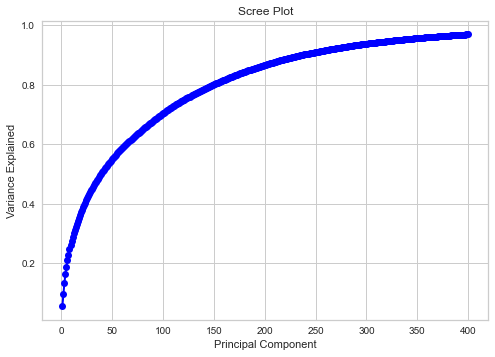

Number of PCAs that explain 95% of the varience: 331


In [12]:
import matplotlib.pyplot as plt
import numpy as np

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print( "Number of PCAs that explain 95% of the varience: {}".format(np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0].item(0)))

In [13]:
# Principle components that explain 95% varience
pca = PCA(n_components=331)

#fit PCA model to data
start_time = timeit.default_timer()
pcaDigitsDf = pd.DataFrame(pca.fit_transform(digitsDf[digitsDf.columns[digitsDf.columns!='label']].copy()))
stop_time = timeit.default_timer()

print("PCA fit time: {time}".format(time=round(stop_time - start_time, 2)))


X, X_test, y, y_test = train_test_split(pcaDigitsDf, 
                                        digitsDf['label'], 
                                        test_size=0.2, 
                                        random_state=42)

PCA fit time: 6.5


## Fit forest with PCA <a class="anchor" id="fit-PCA"></a>

Best parameters: {'regressor__criterion': 'gini', 'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 400}
Parameter tuning time: -0.0
Random forest fit time: 179.71


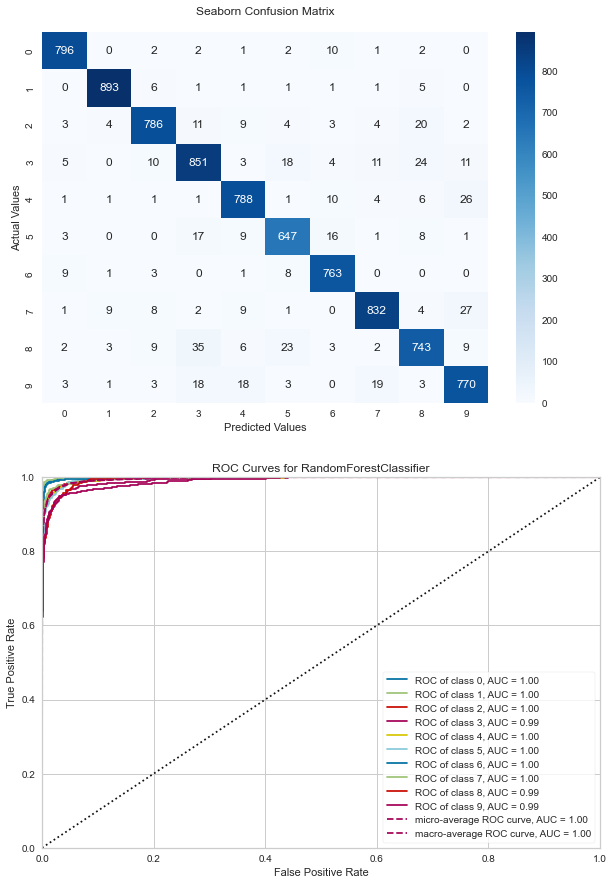

In [15]:
# Fit a random forest on all the data with timings
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ROCAUC

grid = {}
grid['regressor__max_depth'] = [15, 20, 25, 30]
grid['regressor__criterion'] = ["gini", "entropy"]
grid['regressor__n_estimators'] = [300, 400, 500]
grid['regressor__max_features'] = ["sqrt", "log2", len(X.columns)] 

regressor = RandomForestClassifier()

#define scaler
scaler = StandardScaler()

# Principle components that explain 95% variance
pipelinePCA = Pipeline([("scaler", scaler),
                        ("regressor", regressor)])

gscv = HalvingGridSearchCV(
                    pipelinePCA, 
                    grid, 
                    scoring='f1_weighted', 
                    cv=3,
                    aggressive_elimination=True,
                    error_score=0.0,
                    n_jobs=-1)

#start_time = timeit.default_timer()
#l_grid_result = gscv.fit(X, y)
#stop_time = timeit.default_timer()
    
l_best_params = {'regressor__criterion': 'gini', 'regressor__max_depth': 20, 'regressor__max_features': 'sqrt', 'regressor__n_estimators': 400} #l_grid_result.best_params_

print("Best parameters: {}".format(l_best_params))
print("Parameter tuning time: {time}".format(time=round(stop_time - start_time, 2)))

# prepare the model with target scaling
best_depth = l_best_params['regressor__max_depth']
best_n_estimators = l_best_params['regressor__n_estimators']
best_criterion = l_best_params['regressor__criterion']
best_max_features = l_best_params['regressor__max_features']
best_min_impurity_decrease = 0.0 #l_best_params['regressor__min_impurity_decrease']

regressor =  RandomForestClassifier(max_depth=best_depth,
                                            n_estimators=best_n_estimators,
                                            criterion=best_criterion,
                                            max_features=best_max_features,
                                            min_impurity_decrease=best_min_impurity_decrease)

#define scaler
scaler = StandardScaler()

pipelinePCA = Pipeline([("scaler", scaler),
                        ("regressor", regressor)])


start_time = timeit.default_timer()
pipelinePCA.fit(X, y)
stop_time = timeit.default_timer()

y_pred = pipelinePCA.predict(X_test)
print("Random forest fit time: {time}".format(time=round(stop_time - start_time, 2)))

fig, axs = plt.subplots(2, 1, figsize=(10, 15))

conMatrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs[0])

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');

visualizer = ROCAUC(pipelinePCA)

visualizer.fit(X, y)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()   

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
# Let's also print the accuracy and recall scores
print("Precision score: {:.2f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
print("Recall score: {:.2f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
print("Accuracy score: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))

Precision score: 0.94
Recall score: 0.94
Accuracy score: 0.94
F1 score: 0.94


In [17]:
digitsTestDf = pd.read_csv('digits/digit-recognizer/test.csv')

predictions = pipelinePCA.predict(pd.DataFrame(pca.transform(digitsTestDf)))

df = pd.DataFrame(predictions, columns=["Label"])
df.index += 1 

df.to_csv("digits/predictions_pca.csv", index_label="ImageId")

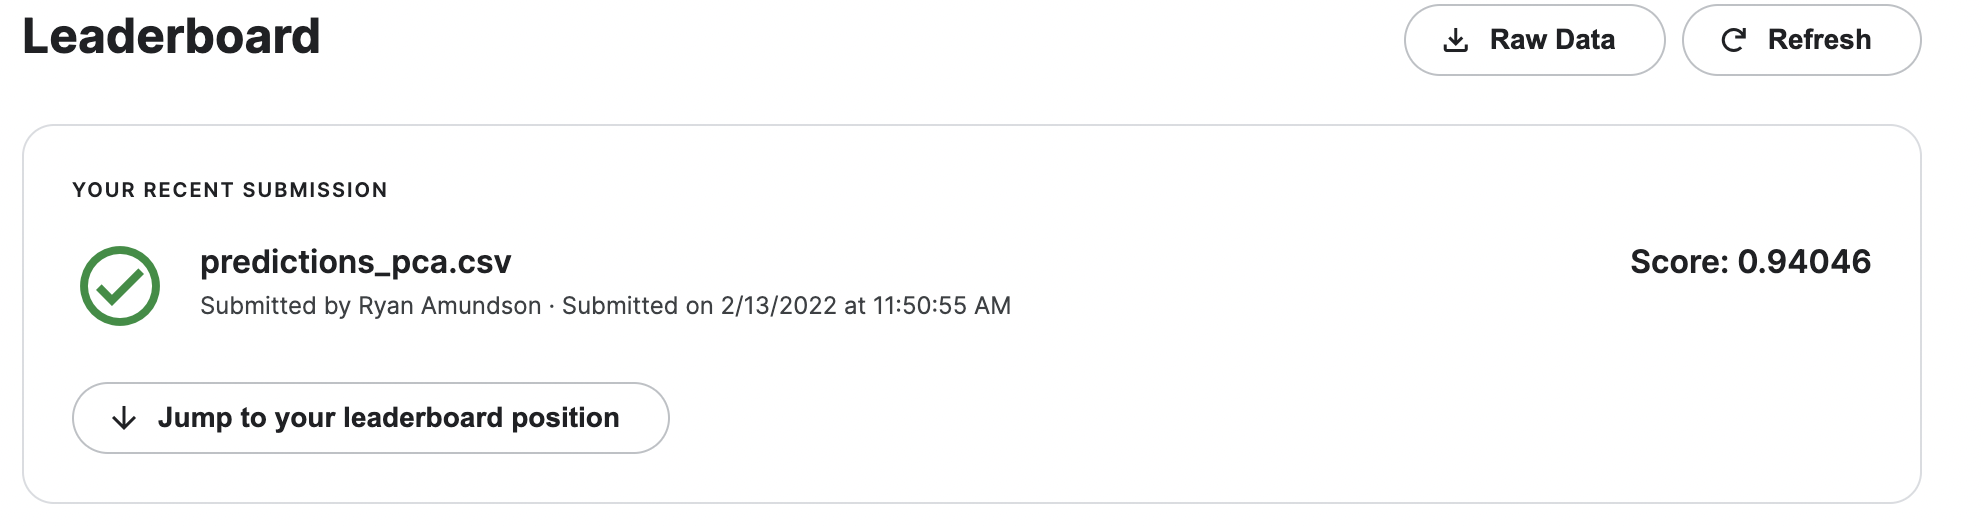

In [18]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAB8AAAAIOCAYAAADHmhdpAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAB8CgAwAEAAAAAQAAAg4AAAAAQVNDSUkAAABTY3JlZW5zaG90Q085fgAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTI2PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjE5ODQ8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KPu4W2QAAABxpRE9UAAAAAgAAAAAAAAEHAAAAKAAAAQcAAAEHAAJKradn2EkAAEAASURBVHgB7H0HwBbFtfYAVkAsWFABpdhLREhuosauUTSJLTfRGJWiiV1jzB9jS71Rc28SC9Y0c42JiS25dgUsKDZUwApIE7uASlXK959zZp4zZ2b3/cBPpOisMqc9M2fn7MzZ/Xbe3W3VRJur2VjZyupJ0UQK6LhWqyB4rKkBVmiTa6JaqOebBMA6SPkKghTFf4k/xlEZf2X+lfxjs6nJmGCFlvxbzj/l/Ivzhp0x6RVHKmEKqZYU5fqjXH9gHJXrj3L9Ua4/bDY1GROs0HL9Ua4/yvUHzht2xui1RQ2DKaQmUpTrj3L9gXFUrj/K9Ue5/rDZ1GRMsELL9Ue5/ijXHzhv2Bmj1xY1DKaQmkhRrj/K9QfGUbn+KNcfn4brj1ZYAK9cJtgRrlkwMhV8NBGH9AkajBBBFcc1stN08R9nWBJbL1TilWAQYNASf4kAwgFaxh+FxZ/SKuOpzL8y/3CGS3KLFyrjJcFggoEGI0TQMv8oMGX+8eiojKeSf0r+KfknJM4qqcyXBIIECxqMEEFL/qXAlPzLo6Mynkr+Lfm35N+QOKukMl8SCBIsaDBCBC35lwJT8i+Pjsp4Kvm35N+Sf0PirJLKfEkgSLCgwQgRtORfCkzJvzw6KuOp5N+Sf0v+DYmzSirzJYEgwYIGI0TQkn8pMCX/8uiojKellH9bNS0kT/4YhFHKO4PDQjybQyKwegUHpmLLFJkotURXY7Cq4r/Ev4w/JMk4L8v8SyNgc0ZMLhFTsZNJdDUGqyr5p+Sfkn9K/uFMYvNCzCyeq9gyRSZKJdHVGKyq5J+Sf0r+KfmHE4bNCz7rxLJiyxSZKBVFV2OwqpJ/Sv4p+afkH04YNi/EzOO5ii1TZKJUEl2NwapK/in5p+Sfkn84Ydi84LNOLCu2TJGJUlF0NQarKvmn5J+Sf0r+4YRh80LMPJ6r2DJFJkol0dUYrKrkn5J/Sv75JPMPzzDd7NRjpZUtHyrUqFDHm6i0782An4ar+3mDVrZ88S8RqAlJib8PipZl/FVXzcv8o5j4pIqU5Gk+oaxs+ZJ/Sv6hCNQMCSi9icqSf0r+yVNNyb8l/5bzTziJWpInVCtbPtSpUZX864OiZTn/lPNPOf/YJEMpgmZHyb9pTETKE6qVLV/yb224jNJHi8qSf0v+Lfk3JAzkDZoXJf+mMTG5IxpszrU84kg0H1vhpoRHU1nyTzVG5fxf5l/JPzHNKJfnGCtbvuQfiUBNSMr9Bx8ULZfz84+8At3+ysQfQD684cwqPdHuyHHHOTdqU42AbMFAPjHXJh2y0AkJv3Io/iVYFK8SfxlCMsikkEs71qWjzdsEW78iFYYU4cr482HKyjL/Sv4p+ddmFZ4gJf9Kmij5l4ZCOf/wfOAo8GZnitemGo8ypVSkopx/TVAiW86/5fxbzr82h/DcKOdfyRBy6pGi5N+QMu1IKecfPzZ8aCwfgsWE1VyU8y8HorKV8285/5bzr82qPEWWzPn3/Rmz3Iz3Z7jZs2e72XPnug/mfeg+/GCeW7BgoVu4YL644fXI1pSbJE1Jngr+6eY53aB2Ta3JspDsYZda8d9jJDC+NZU0erkClaxBO74HYmMHbOP8x/8T6/ULRS7+S/yXxfhrTWOxzUpt3Morr+xWX3VVt/rqbV3btqu6NTq0dx3ar8FDWoZtuf9Qndfvz5jp+N9cyiuz5lBe+fBDN4/+zee8spDmNW2cFcr8pyiU/CcjYXnL/2X+8yzl4UmzVP824bnOG89e2mTqV+e/mjxAoAEceEOkSSrUR7T5b4BnTuR+L2PCPkR4Y058oEoiVOtUzMU/xVqCEI83h63Evzp4GmiSMZUI1QoVs4ReihJ/HnaVAFVjmGuSKomQI32aYq0Obwm9FCX+HJdFxK8a0Symi6hfMUvopSjxL/Ev468yQepmXKpLqiRCimOpYmZFOf9zEEr+wVAgGk+QLDS/JWMqEar1KuYy/sr8K/mHJkrJP5oKOG3oBXo1h+SaJKckQo4s579KeDToZfxpKHjYlPFXnTwNNMmYSoRqhYpZg17Gn4aCw1bGX3XwNNBgTM2lRe533p7upk2f7qbPeM81LSALxxEAZZto8ZrHGxllBZoAsqjtF73FjYk/aaUmN8O1mppa06qtr8OWhcGBVJGVcrIFe6gqTXLBbXBZ/Jf4L6/jr3Xr1m6ttTq4ddZey6273jq0QL6ajNpGhR/TIWUlQrVGxcyK5fz6f+7cD9zb70ylvPKue++99+gHNLTPZf5Lziz579OX/8v855xUzV2NNElOS4RqDWtuRZ8Axw/rAlKyoeGZpT0Jamtli5cbGBnAG5mbKMH6i5igCFclVitYOBKB2+Wt+EdYQqR9WKj0ctDmRqBIX+JvRxoC5X89ms4z2Dh4zPNWxl8Zf8kwkFHBhR8tYczYoaMIDyrzr8y/cv5DpsVEKfnXzgqfMhAblpjnrZx/yvknGQYyKrjwoyWMGTt0FOFB5fxjZxoCVfKPjYofMogNS8zzVvJPyT/JMJBRwYUfLWHM2KGjCA8q+cfONASq5B8bFT9kEBuWmOet5J+Sf5JhIKOCCz9awpixQ0cRHlTyj51pCNSSyz9vvPm2e/2Nt927tDjFG/+lx17at2tLT7O2d6u3X921XW11txo96brKqiu5Nm1Wdm3oETi7V1wPRzTyzJX5X+Z/Mgz88KDSj+QwnjGs1RoY0i+P838hreLO438fznNz6enlOXPmuFmz+Y0Js9zMWbNML1q5tdZc023YaT23wQbry9yCcUXuPx+9Rc3/N958y73+5jvu3emUVzgN0FOcrekHM+0or6yxRnt6Yp6eml99Vcorq7lV6En6NitxbqEfx9htOT3+i9N/342S/z6N+a/M/0XP/096/NMT4AspPfCFCJU+m9rUIXwDdQXXSJHUZ4E3vkKSzVulTICwc5ow8KhebC6pzwJvxb+PQ4iuxCgJVDATaaCOgEVwSX0WeCvx93Eo8ZfBIGMkGSghPEQaqCNgEVxSnwXeyvjzcSjjTwaDjJFkoITwEGmgjoBFcEl9Fngr48/HoYw/GQwyRpKBEsJDpIE6AhbBJfVZ4K2MPx+HMv5kMMgYSQZKCA+RBuoIWASX1GeBtzL+fBzK+JPBIGMkGSghPEQaqCNgEVxSnwXeyvjzcSjjTwaDjJFkoITwEGmgjoBFcEl9Fngr48/HoYw/GQwyRpKBEsJDpIE6AhbBJfVZ4K2MPx+HMv5kMMgYSQZKCA+RBmp6hfkCN3nKa27Ka2+4+fPmyYPcrWhRe711O7qO66xNT6+u6VZZZZW0fhl/PrBl/oUB5keXlA0GWgN1HKCL4JL6LPC2nMf/Q1oU56edp9K/t95+h9Zm+HX9rdxKK63sOm/UyXXpvBEt9LbxfVlEuaL1fwHllVdCXpk3f768IplfF73+eutSTol5ZRHdVvOK1n/d8cAk+58bF0NO6rPA23I+/v1O+jLZf2tYTD6pv4L0/7M8//PDmhy/3LgYclI/O/7+FejcSILKWuVX1PD704nw4+I6dzJYnRibrVvtNzUi0CgDW/yX+JfxV+ZfyT8l/5bzTzn/Vq8QGmriZUW5/qj+2tqELQbKKANbrr/K9Ve5/irXX+X6q1x/leuvcv1VvUJoqImXFeX6q1x/xXdgVQZMHCgVk19ZpcRTzj/Lzfln0iuvucmTX3Hz59O7iOnQdOjQwW3UaX1ZpLJPYMbDWuZ/mf9l/tNUqd/iRKnYF9Ace4te//3a62+692bMkOuPldqs5Lp23dht0mXjCt4qYrMrxvybNPlVN+mVKfSKc37HuXNrdljDbUhPva+//nr0xojWy03+szFujl/R4l/bl3L/Z5ne//kszf+lPf5qXoEedkEGPfP1KTtO7JpdZiO22uqhNpGGC+rFfwh9bQCb/b2CGEv8fQRqw1fGnwyuMv9K/qH5UT9FaHCIodZa8g9ll/rIkIHTC7ZaUMk/Jf/QwCj5t+RfGgb1KaLk33L+4ZNI7ego59+GkSFDOf/ywPFb7fAp1x/l+oMGRrn+KNcfNAzqU0S5/ijXH3wKSUfH1GnT3fgJk9wMekUzL2d2XGct12Xjjdza9K1i3cr5V0ORhS/oy/m3nH9bdv6dTk+Ev/Lqa+4dmoc8//hV4D26bSJvXNBBtwLOP84rL0+c5GbPnC3dWJveHtGVnnJfm574rtvCDKozlev/FfD4Vw5kWf8Lp970/Ptpnf/L6vjrK9BlB2qySqoKEpSg1b0nTXitOnEVWKIwgmHRZKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwKaqIEEJCrBSb4AZNDMH0VgNC2yqChKUoAAr9QaYQTNzEI3VsMCmqiBBCQqwUm+AGTQzB9FYDQtsqgoSlKAAK/UGmEEzcxCN1bDApqogQQkKsFJvgBk0MwfRWA0LbKoKEpSgACv1BphBM3MQjdWwwFrV2HHj3auvvSmvJG5P39/dlJ5A5dedVzdfC3VBFZcojGBYYFNVkKAEBVipN8AMmpmDaKyGBTZVBQlKUICVegPMoJk5iMZqWGBTVZCgBAVYqTfADJqZg2ishgU2VQUJSlCAlXoDzKCZOYjGalhgU1WQoAQFWKk3wAyamYNorIYFNlUFCUpQgJV6A8ygmTmIxmpYYFNVkIi8PW2amzhxCn0rfKZAO2+0odusZ7ekTdQFRZvpgoyxGhbYVBUkKEEBVuoNMINm5iA2ubHjJtJnFF6XhSLJK5t0dut1XEfsad0gQQmqDYPxBphBYV3e+q8/MqrsaL52FgDAgWrHwHgDzKCwlv5TJHRd2UTHsIhVqgoSlKAAK/UGmEEzcxCN1bDApqogEfk0zX89GGlnJQSpKvZfjl9qRMiIegPMoAowivgEOJSgiq4yHtIYWLXkmigrBwa06lY1HtIYWLXkmigrBwZUvVUZD2kMrFpyTZSVAwNadasaD2kMrFpyTZSVAwOq3qqMhzQGVi25JsrKgQGtulWNhzQGVi25JsrKgQFVb1XGQxoDq5ZcE2XlwIBW3arGQxoDq5ZcE2XlwICqtyrjIY2BVUuuibJyYECrblXjIY2BVUuuibJyYEDVW5XxkMbAqiXXRFk5MKBVt6rxkMbAqiXXRFk5MKDqrcp4SGNg1ZJroqwcGNCqW9V4SGNg1ZJroqwcGFD1VmU8pDGwask1UVYODGjVrWo8pDGwask1UVYODKh6qzIe0hhYteSaKCsHBrTqVjUe0hhYteSaKCsHBlS9VRkPaQysWnJNlJUDA1p1qxoPaQysWnJNlJUDA6reqoyHNAZWLbkmysqBAa26VY2HNAZWLbkmysqBAVVvVcZDGgOrllwTZeXAgFbdqsZDGgOrllwTZeXAgKq3KuMhjYFVS66JsnJgQKtuVeMhjYFVS66JsnJgQNVblfGQxsCqJddEWTkwoFW3qvGQxsCqJddEWTkwoOqtynhIY2DVkmuirBwY0Kpb1XhIY2DVkmuirBwYUPVWZTykMbBqyTVRVg4MaNWtajykMbBqyTVRVg4MqHqrMh7SGFi15JooKwcGtOpWNR7SGFi15JooKwcGVL1VGQ9pDKxack2UlQMDWnWrGg9pDKxack2UlQMDqt6qjIc0BlYtuSbKyoEBrbpVjYc0BlYtuSbKyoEBVW9VxkMaA6uWXBNl5cCAVt2qxkMaA6uWXBNl5cCAqrcq4yGNgVVLromycmBAq25V4yGNgVVLromycmBA1VuV8ZDGwKol10RZOTCgVbeq8ZDGwKol10RZOTCg6s25WfRU5gtjxrkZM/1iW7dNu8rit964Nlhmq03kmigrBwY0a9OKHtIYWLXkmigrBwbUOsx4D2kMrFpyTZSVAwOa+bSihzQGVi25JsrKgQG1DjPeQxoDq5ZcE2XlwIBmPq3oIY2BVUuuibJyYECtw4z3kMbAqiXXRFk5MKCZTyt6iC8nT3rVvTxpkpjXaN/ebbl5D9eufbu4vieWvNEoKwcG1DrMeA9pDKxaco2XZ86c5V54aTwt4s+QpNG9e1e3SefOjdKK7oWvnbep5pJ/KBS6vithyWMVZeXAgMZwVjgPaQysWnJNlJUDA1rxGhUe0hhYteSaKCsHBjS6q3Ae0hhYteSaKCsHBrTiNSo8xJcr8vznHml3wYDG7lY4D2kMrFpyTZTjN8DVDYxMeeOpRDzeVQ6z15qJBgMo161uahVGJQOEjilvxX+JP42FMv50KmDSYab4eQIJ1GvzUq3CqGRg0DHlrcy/Mv9oLJT5p1OhzD+fGZApUinVelss1SqMShGgl0Rs463kn5J/aCyU/KNToeQfnxnS7AEJ1GPyUq3CqGRg0DHlreSfkn9oLJT8o1Oh5B+fGZApUinVelss1SqMShFQrn8oFiHnSlRK/i35l+ZJyb9xWvCUoC3NHpBAPSYv1SqMSgYGHVN60uydae75F8e4hQua3Br01PfmPXvQ977biQ1IEXRvUq23xVKtwqgUAUk7rC7zv8x/Gidl/utUyK+/3qcfpowZ8zL9QGWWa926ldt6y80bvJnB5IxlPP/efnuqe/4lyisLkVe6uw6UX+Ie8g7yVuZ/mf9l/jeX/1bE+e9P85KE/DTXErqlM/9bNS2kl+23glPdiwpTj4AWNK3WxE238gmMOOTtZD43DkTWFonhus8Y4BfUmIgt/kv8y/gr848TTsk/Jf/q+YNOF/h7qpx/+MRaf/60Z9N6BLSgtkY5/5brj3L9Ua4/yvVHuf4o11/l+rNcf5brz3B9SJeL5fo73M+SS+f662d7NV2PgBbU1ijX3+X6++Ndf7/62htuDL32nLdOndZ3W23eMx1g/o9n0pXxV3t3utz/Lvf/l+L6x4tjX3ZvvP6mzNHNNuvuNuq0wXIZ/ymvUl55eQLtW5PbcP313ZZb9KB91qujLMd4sUGGCfUaWMv8Wy6PP58uyvXfkr/+W1Hm//J0/OUJ8CR9qKBMbUKySiAp39CE4wtvTxUDgCpSJjGroEwKrpGAhF9QhQKgipRJzCook4JrJCDhF1ShAKgiZRKzCsqk4BoJSPgFVSgAqkiZxKyCMim4RgISfkEVCoAqUiYxq6BMCq6RgIRfUIUCoIqUScwqKJOCayQg4RdUoQCoImUSswrKpOAaCUj4BVUoAKpImcSsgjIpuEYCEn5BFQqAKlImMaugTAqukYCEX1CFAqCKlEnMKiiTgmskIOEXVKEAqCJlErMKyqTgGglI+AVVKACqSJnErIIyKbhGAhJ+QRUKgCpSJjGroEwKrpGAhF9QhQKgipRJzCook4JrJCDhF1ShAKgiZRKzCsqk4BoJSPgFVSgAqkiZxKyCMim4RgISfkEVCoAqUiYxq6BMCq6RgIRfUIUCoIqUScwqKJOCayQg4RdUoQCoImUSswrKpOAaCUj4BVUoAKpImcSsgjIpuEYCEn5BFQqAKlImMaugTAqukYCEX1CFAqCKlEnMKiiTgmskIOEXVKEAqCJlErMKyqTgGglI+AVVKACqSJnErIIyKbhGAhJ+QRUKgCpSJjGroEwKrpGAhF9QhQKgipRJzCook4JrJCDhF1ShAKgiZRKzCsqk4BoJSPgFVSgAqkiZxKyCMim4RgISfkEVCoAqUiYxq6BMCq6RgIRfUIUCoIqUScwqKJOCayQg4RdUoQCoImUSswrKpOAaCUj4BVUoAKpImcSsgjIpuEYCEn5BFQqAKlImMaugTAqukYCEX1CFAqCKlEnMKiiTgmskIOEXVKEAqCJlErMKyqTgGglI+AVVKACqSJnErIIyKbhGAhJ+QRUKgCpSJjGroEwKrpGAhF9QhQKgipRJzCook4JrJCDhF1ShAKgiZRKzCsqk4BoJSPgFVSgAqkiZxKyCMim4RgISfkEVCoAqUiYxq6BMCq6RgIRfUIUCoIqUScwqKJOCayQg4RdUoQCoImUSswrKpOAaCUj4BVUoAKpImcQchFemvOrGjZ8kwG6bdHGb0r9GG+rDL6jiAVBFyiRmFZRJwTUSkPALqlAAVJEyiVkFZVJwjQQk/IIqFABVpExiVkGZFFwjAQm/oAoFQBUpk5hVUCYF10hAwi+oQgFQRcokZhWUScE1EpDwC6pQAFSRMolZBWVScI0EJPyCKhQAVaRMYlZBmRRcIwHJfidOnuwm0LfB6UFw16P7pq5L540a/T5FW0J9UaigjOIaMUCi36CKB4AUyCu83L0J5RTOLcZs9jXRalN1DJDwC6pYAFSRMolZBWVScI0EJPyCKhQAVaRMYlZBmRRcIwEJv6AKBUAVKZOYVVAmBddIQMIvqEIBUEXKJGYVlEnBNRKQ8AuqUABUkTKJWQVlUnCNBCT8gioUAFWkTGJWQZkUXCMByX6X9/lfs/vLdP5XXoHug4mQ+t1NdJWjW9clq4ttCUeF/vrDwgKf+KrTFf/ZrwtqgpioSvzDb238RCvjr8w/uvriC7C6reQfjk3MGRyjJCYl/5b8K79qrps9dbo4loSjopz/S/4p+bdurmS5NkBK/jXnpHL+Keefcv6pTx612nL+xdm2XH9QJMr1V7n+LH//lr//a88V/vrztddepye/JxCilevZcxPXeaON4j2Bcv1Vrr/K9VeD2VOnXvrXX6+8+pob9/JEuezZvEc3t/FGG8qOLevrnyn0RomxY8fT+bfJbUb71WVjWpzPNh+tGDM2J7qSf0r+KfknmzWpuLzO/2Wdf+r8ZwvgJvEoq4xE2UrIRaKzhvR4kNSs0aANTllliv8skiX+/lwgIyQdJmZMMdus0WANTlllBGelEv8Sfz4Xy5iwA8OMKM82azRog1NWmTL+KAI2GmX+lflX5l/JP5ITbGIwGdWzzRoN2uCUVUZwVir5p+Sfkn9K/pGcYBODySgl/3AEmg2OiZbBKauM4KxU8m/JvyX/lvwrOcEmBpNRPNus0aANTlllPhP5h7/5/ezzL8mg6tmTniDdmBfP4s9VbTRK/i35t+Tf5TP/vjIFi+Ct3LZbb0bfBF/X5LlGrJndyirzsfKf5JUXXpIf4PXoTovfnf2ifLonxpeyynws/zaHpT6tZHwpq0zxTxGw0Sj5f/nN/8vb/F9e51+2AJ4NcBrw8dLHJgrm/VSwEyJHsPzWW2+5u+68yy0knp8s5C+BcR3+15qKXXb9sutOCRGbbc/ysEfqrc1jGqOlXk1lq7J8bAmctzaPAbYaLalXU9mqLB9bAuetzWOATf1PotekDB16v8Sfn8bTjRpjuXefHd1222wbjrBaM6bl/rkhqV2z81Zl+cw5WljEPsZa3NZ9997rXqdftzLP/3j82f4ffvi33MqrrKJjnjE2PCSazVubx0R4jha5prJVWT62BM5bm8cAG+JtoiX1aipbleVjS+C8tXkMsEvfP4/x+2mMs2fOOXn+6dV7R7c9jfH8ANv+WD72BNzy3X/sJWi+tyLXdNCqLI92IvXW5jGN0VKvprJVWT62BM5bm8cAu/THX/TsuXxvRa7ZeauyfN5etUdVhNX4tmKLwkVRoVZleQUo463NYxQcMk9ECxdFBVqV5RWgjLc2j1Fw8U+hsG92kLjVBM+qLB8jCc5bm8cAWx2tUq+mslVZPrYEzlubxwBb/OfRErkmeFZl+RhJcN7aPAbYEv88WiLXBM+qLB8jCc5bm8cAW+KfR0vkmuBZleVjJMF5a/MYYEv882iJXBM8q7J8jCQ4b20eA2yJfx4tkWuCZ1WWj5EE563NY4At8c+jJXJN8KzK8jGS4Ly1eQywJf55tESuCZ5VWT5GEpy3No8BdsWI/8yZs9yTz4ymT1gudJt29a89L/e/4jFMuU/f8ef+2fFs+bTvEdk8JtbKoyVyTWWrsnxsCZy3No8BFv2KaOGiqECrsrwClPHW5jEKXib3HyZMesVNnDTZtWndxvXaYTu3Rvu2tEN+Rst+1+y8VVk+9gSctzaP8dhZM2e7J54Z5ZoWLqBXnneVzylIvZrKVmV5eI3UW5vHNEZLvZrKVmX52BI4b20eA+xnc/zF3pf+56NF5JrBY1WWt7H0vLc2h1le5j/vb763ItfsvFVZviX9t3V8W7FF4ajQBfBostWYb6L/sGwdLocUrExWKepHjhzlDjr4ULJzXdZTa/SzsSb++Yhr7Q44YH932aUXi6X+Yuvj+Scn2YZ9A/XmVLJVPn3+hwwZ6gYMPI462Zr++Z6jlyyfe86PXf/+/UIQYDERUlYZGzBtM1Nqe3EsxCPeqCXen48z/uw+DBhwrBsydGgy/mz/Rz3zlOvQYQ1bhfgl5983jJ6CptrMefHfwvgPpjE+cOD3JH4+pmn+Ofvss9yA/v013OnRULXUX1Ljz7cKT6Cp1nqGpfhv+fmnLp7LKv/geBb/mItLN/+X+HMEkHdA06h4yZbl/Ffyb8m/9scjOoUiYycM8encSo2wgXprKtkaZf6V+VfmX5l/JkMoq4xNGMQ30jMMNlBfNZW8DpYy/8r8K/PPzBBllbEThvhGeobBBuqrppLXwbK05t+Ip0a7GTNnuI06re+22Lxn2Ily/bG04h//Gl42x7/4t3EHv2KP/xfHjHOvv/EWLX6v4frsuB11CpkG1PczldB3ph+//08+NYryyiy3Yaf13Jab96A2y/2feBx8rD/J+HsPKOEJtPjnCKTRQKy8ZUXO/8vD/LfRjJFOI55KtsbHzz+2tdw/LYAvJN/m1Kd7okxa30gpAjsaAMHIC+AHH3wILXiTj9Z0GU2PYvJrUxw/k0lM3/33c4MuuzS2qo0qE20ZlyLq/fsqhGT/9D9e2xCbSluJMyHTxwrKpYgVxz8vgA889lh/IOSHCHJAqF8+Tuec+2NaHDyGZOi1ywmzovV/wLHHucGD70/GnwyI0M+Rz4xwHdboELqd9i7peBBSxIpz/P38Q4/SXnxaxv/g+4a4gcd9VzrJf7zn+eecc3gBvB/ZP539T7tFfSz5T+Z1yf8UhiStl/EfEr5PiBoOZZAoKzRFlPzv/1AIYUqCQ0LJPyX/UN4p+bfk33L+saeSJFGay9FMb6vUpVi+xqW/Y/TUnlQv+becf2hklPxbzj+UCkr+tck0SZSf2fw79uUJbgp9O3iNdh1cn952oczGKuXTyJXzTzn/luuP5fH6a8RTI937M2a5zp03cj27b7pU8//YcRPcq6+95tq3owX43tuX8285/y7V8efPWBT0z/D9p2U5/5f3+OsT4ObKT/Y5Xs5ELr38ISm9AlKzVY8aOdp9jRbA+Vljfg1x6/CHOn5V0bfv/rQAfkmlseg1cuoAjHUEXaWluJsebktTKetM9Bo5ixZ+BfXPT8cOoKdj/a960avYmXPOOZueAD863E759PS/Pz0Bfj89Ac5jD+MPvedRMlKeAKcFcNpiryMXsYGLIUtMuRqyp7a01YDyuug1chYtfFpFzbkasqe21CrEAOV10WvkLFr4tIqaczVkT22pVYgByuui18hZtPBpFTWzeshgWgA/lhfAZfm7kn/OpjE+sP8xWmdJ+9cLYfKA3fTUlsa9orwu9jpyFi08Gs4MuRqy9QxdrJpqotfIRWzg0ipqztWQPbWlViEGKK+LXiNn0cKnVdScqyF7akutQgxQXhe9Rs6ihU+rqDlXQ/bUllqFGKC8LnqNnEULn1ZRc66G7KkttQoxQHld9Bo5ixY+raLmXA3ZU1tqFWKA8rroNXIWLXxaRc25GrKnttQqxADlddFr5Cxa+LSKmnM1ZE9tqVWIAcrrotfIWbTwaRU152rIntpSqxADlNdFr5GzaOHTKmrO1ZA9taVWIQYor4teI2fRwqdV1JyrIXtqS61CDFBeF71GzqKFT6uoOVdD9tSWWoUYoLwueo2cRQufVlFzrobsqS21CjFAeV30GjmLFj6touZcDdlTW2oVYoDyuug1chYtfFpFzbkasqe21CrEAOV10WvkLFr4tIqaczVkT22pVYgByuui18hZtPBpFTXnasie2lKrEAOU10WvkbNo4dMqas7VkD21pVYhBiivi14jZ9HCp1XUnKshe2pLrUIMUF4XvUbOooVPq6g5V0P21JZahRigvC56jZxFC59WUXOuhuypLbUKMUB5XfQaOYsWPq2i5lwN2VNbahVigPK66DVyFi18WkXNuRqyp7bUKsQA5XXRa+QsWvi0ippzNWRPbalViAHK66LXyFm08GkVNedqyJ7aUqsQA5TXRa+Rs2jh0ypqztWQPbWlViEGKK+LXiNn0cKnVdScqyF7akutQgxQXhe9Rs6ihU+rqDlXQ/bUllqFGKC8LnqNnEULn1ZRc66G7KkttQoxQHld9Bo5ixY+raLmXA3ZU1tqFWKA8rroNXIWLXxaRc25GrKnttQqxADlddFr5Cxa+LSKmnM1ZE9tqVWIAcrrotfIWbTwaRU152rIntrSV5k6bbob9ezzJLRyvXttTw+BtKe98XfIeL/AqQMwaBhyoLkasvUMXayaaqLXyEVsA0cN1Gi5+Pd3w2JpI4ooeV2MeuQsWvi0ippzNWRPbalViAHK66LXyFm08GkVNedqyJ7aUqsQA5TXRa+Rs2jh0ypqztWQPbWlViEGKK+LXiNn0cKnVdScq9+bMdM9/fRIWn9p5XbYdku3zjrrZN64aloreo2cOgCTVoFWW+K8MvrZF2Td5/OUV9pTXvFrDii1CjFpY9Fr5Cxa+LSKmnM1ZE9tqVWIAcrrotfIWbTwaRU152rIntpSqxADlNdFr5GzaOHTKmrO1ZA9taVWIQYor4teI2fRwqdV1JyrIXtqS61CDFBeF71GzqKFT6uoOVdD9tSWWoUYoLwueo2cRQufVlFzrobsqS21CjFAeV30GjmLFj6touZcvazmP3YI++OpLYFgCpTXxV5HzqKFT6uoOVdD9tSWdCakV5HL28j5V6GJK9SiZm0V4Y1NrCJLA3xuNRsvKo52Bx16GMEYVN14AfyySy+RX4V8Ev7xy4+q56jBUymfFf+DdXHQx8D3n09KfIps5c6lJ8D7H9NPj6U/3Kb0bAggCSLXH//lKf7+Fej3xwOPHtD+82v5n3nmCbdmhzW91vTRs6Y0tkWN/+Wp/5WOJ/3nnpg/dUwfTc/9oTa25bX/fozTa/75l1/05ok8/5xDr/kf0J/GOG2ftfkfDruS0n+e/zySPz3j3x9cmqjhl496sGuYcvzL8S/jv8z/kv9K/tdneMw13op4/VfOfxyBcv4v1z90YUv/N7eV679y/Veu/z6713+PPfmMmz17juu2aWf59rfkinL+17xZrn84FCYKZmz4awwaMT6BaMz8+YaA5f5DFpPqmXhpnH8nTZ7iJkyc7Nq2a+u+0HuHZCc+Kf+Pj3jazZo5x3Xv1tVt0rVz4tMKn5T/cv1b5l/JP/76f1nM/xVh/pknwG1KIj45ybHNKsKtMqvS6uY2GtlHjqJvgB90CJ0E6BnwVqSQN597DFeJT4BrA56ptG0Vi+/f//Fn6gpr5MytihWIVazY/ocMGewGHMvfRzYbzxPqIveSnwAf0O+Y7MS94vdfFsCH3E/XanH8aQSo/6OeHuHW6OCfAE+Gu4BW/P7Hbti+aARSpgKxiuV//A+lH3kMGEhPgNNx9Svcaf7hJ8CxAJ52PEi2u6KyiuW//9ztOIbNvgtr5NDdCqlArKL0X5ZKbEg0gCE2LKtdmaAzstbLmArEKkr8S/xpqcoOCR0+ZfzpMqbGR5ky/yQUJh46bjKmArGKkn9K/in5p+RfyhlyoWlzRzn/lPNP+BmNnjKUKedfCYWJh506lq9ArKKcf8v5d8mcfye9MsWNnzCZvhHcnr4RvH0cgXa4idYqyvgr42/JjL844DLODrcy/igCNiAtm3/yLW56GrxH966ua5fGC9KVcFcUi/b/yiuvupfHT3Jr0FPf/tvj4UJRumH7Io1XiwrEKhbtv9z/pJBqyJQp118SChOP6sjzmgrEKlbM8bc05/+KMv/MArg/wOlhDn/fWqUMD6MQ1stc8hb/JqYnwOkV6AcffKi8BoP1sSZJdAeh7/596RXoF6sl2g3WKtmBacWzHsAlb9Y/JDQB6pG2jG2gvmKVAd4ohPUyl7yhvt1P1AD1SFvGNlBfscoAbxTCeplL3lC/kX//emhaAOc7OPwLPQqiPP/NP1Kgn2OdR0/H9u/fL0bZNy9t+8IohPUyl7wtyn+0e7wvYxuwew1ZlQHeKIT1Mpe8ob6tyLaB9Ar0wUPvD3ZCZf1/ZuTTdMJeQ+v7VqmiMtw6b0YhrJe55K2Rf9abmoKNRWwD9RWrDNBGIayXueQN9a031AD1SFvGNlBfscoAbxTCeplL3lB/WfofPGSIO3bgcRRvfzOGP7/A+4U9lx959D+GNNhiH7D/wGolQK1CQLEuQ1A/eouctqltgYltoL5ilUmxIokt1mUd6kevkas0hSZDn6xdeWUANgphvcwlb8W/j0OMeuRM5AAKNMYQ8VOsMqhiFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpwVrGNlBfscoAbBTCeplL3lA/eo2cqenBWsY2UF+xygBsFMJ6mUveUD96jZyp6cFaxjZQX7HKAGwUwnqZS95QP3qNnKnpFixc4B4ZPsItWDDfbbfNFq5jx472zkbkbSXxYBTCeplL3hbXv0ejjG2gvteQXZkUK5LYYl3Wob6tiCZA0VKksQ3UV6wyQBuFsF7mkjfUL/5jnMCB+kjZ0lusXXllgDcKYb3MJW8l/j4O+fibOnWaG/Xci27lNm3cTl/8vGvThu736xZjiPh5DQGUAdgohPUyl7wtXEB55dEnJa9ss81Wbr2O8ZXrpqYHaxnb+Lj+Ud/uOPyCqltlin+eOTY+yiuDYBmFsF7mkrcSfx+H5W38La35vyIdf/8KdAxaM67lEOLdFCSoSRkc5EBzfZBHjqQnwGkB3L+KIFuGIswBB+7vLuVXoHMzlTZIwa9WsaYcI1YLCIocJzKUgabkM+N/8ODB9H1kWgCn/vOa90KmfATkePMT4OH10Evg+OPw+GMbAo4DvZTjP2DgQDdk6ANxsGT9H/n0k67DmuEJcN7xT1n/4yODaeBxVHBY4jHjAK2Y82/wffQN8OP4LQfcOybUj1Yx//i3HPTjgR+7rYHwVcrxX3GPfzyoOJZE9ZGtcKBTYgYC6pT+r6jzvxx/Hu9hHDORsR4GPIJTxn/J/+X8h9lQ8j/SA9JGuf6l/OCTqIZGGQQp0FxfK0MZaErK+EN4ENoy/sr4K/NPZoNODWUwSUr+SQPUXDwQvEBT8pnLvxMnvuImvvKKW2vttejbwFt/5vqPCz+MCsg6s8r5p5x/PmXnn5H0Te5p9G3ubpt09Z87+AT+/ps46RV63forbp2Oa7vPbbuVn04yyTDT0sQLbZl/FKrkng1F5lM2/nwHy/GXOKRhWCrn36Ux/2XC66QOZ1ORoUw7Du2ymP/xCXBzsg+7nPRDd9Iabd8SdATJAvghh/q1pEoj9AR4X34C/BI6+GQMkz3WjmOiUtWAoi1yxiysWDLzzJkz6FdQK7vVV19tqfifPXOWa02/ulp99dXD7pkdWoL9nz9/gfvwg7n0vY92Ggbbf34CfMCx9HpoO+KCf14jOpu+AT6gf78YtxSpbYKJvYjcrJkzqa9ttK/WP+rV+Y82z6FF0NzOcrQ10a9aF7rpdIJfbdVVXTt6rRN/2xuYgf2PdUPuv19kX8SaPP5GjnzKdcAr0AOKEezh/fdnkI2fDrdnKA+KrUTOW2IplorZKMzxnzFjhltttdXdyiuvpH0zyNho4KItcjlILBWzV8yfP5++1TJTXv/eurX9VWCMbaWqcRBtkTNmYcVSMTe5GTNmufnz57l2bdu6VeiY5RuqgMLO+/zhBx/KN22iLXJxjFMNOmQS3mgOP/I4xhu5URN/FrGhCij0lkZb5KydebFUzEZR/C/1/B9HNx8gOhZL+fxT/JfxL8lJEkQZf2X+Nb62MDOFR0uyRVvkEgAJYqmYjaLkv5L/y/kvnzZL5fpbnJb5V+ZfmX9l/mURwBkaNDP71EFlvMtRvYZgkNSvNGIUJf985vLPsOGPu3nz5rsdttvarb3Wmp+5/pe/v8v8R+b8rNz/mfbuu27U6OfdSiuv7Hb5Uh89cyzJ/g8b/oSbP2+e+xznFfpxTTn/lPNvuf6gTGPSrUwK/euSpKV0/bU05r/vW1our8c/LoDb/c0PVC4rtmrINfoEuNYhhkBNrZtc66bWbv+++/kF8MyerDPmjSq2aqhqPHjatGnupptvcY899ribPGmyG/PyWPHPb/PnrVv3bm6nL33R7bzTzm733XZ1q7fFIjUZGzVaYwD0ueeedw8/8oh74P4H3UtjxripU6eKHy7atW3num/W3XXruqnbfIvN3GGHHuo22GB9tVeaRaMREThvmE8XsXfddZe79dZ/U7/GuVcmvyL2Tht2cr133NF97nPbu3333cdt0rWr6Pnp2AHfPS7pv8SbmyPmnLPPcgMG9BOsFIvwz7G9WWL7hJs4eZIbN3acr8t/i1Hdbt0otjtxbHdyu++xm1t91dXpgVy8nDq6US74e/XVV91Pf/YLN+/DeXJvXN7WLg/xMqC1O/+8s92mm24qC6F//8c/3F+vu969NHasdEXaIv/PPztKF+HlG+D0CnTeJ4w/HH+uNJK+AS4L4GR/8qkn3cPDHnXPjHzGPfH4k2727FnyEPFmPXq6bbfbxh1x+OGuT58dyQ13Mm5h16OijmP/of+TJk2ScTn62WfdpImT3YQJE8lIAFqH7rhOR9dt001dly5d3AE0T3aj2K3UZiXTYtVbVWPgxM6gH308PGy4e+iRh9yjDz/u3nzrTTdr1izfDarclcZI927dXOcuG7s99tjD7bbrl12b1m3yboZGU2+/v+YPbtjw4TEiHBqG0Nar1w7ulJNPEv7FF150l15xuXtw6ENu5qyZouNKZ/7gDHfC8f7NBLERMlMbvEh+5913u1tv/pcbN36cmzz5VTIsdJ023JC+MdObxvh2Msa70P6z28H0I4+Bx9GPPIJ/7ySUpDv7vLPcwH79E7UKXIcbwZbL0EvjFujdpRoFR4baw/GPSsPl/nJZoVVDVaPgyBCo+F90/tGANQxq1VDVaCuRKfEv428xzn86YBoOqqqhqtFWIlPGXxl/ZfzRKb7BmTqfRLmsM6lqqGoUHBkClfNvOf+W8VfmX0wKhsuTSC4rtGqoahQcGQKV/FPyT8k/n9388zrd93nppfH00EN713uH7WJuYC5PIrms6KqhqlFwZAhU8k/JPyX/LJv8M+Lp0e69Ge+7bbbYnNYd1ovzElw+iXMZuEqicO71N99yL740Th4Wq+QV1Cvzv+S/cv9hmd1/+CTnf8NUgbnPdDma/+kCuOyYWftp8KsE7YvprWeNInR01KhR7usH0SvQacDz/aYmWsVsJa8jpqVHkg/YnxfAL/VNEkRMcLAE/E+YMMENuvxKWmS8qdY/BUC8taIVxybi2f+6HTu6k086wR3xrW+6lWueSsXu2fzve97kRo8a7S76n9+4YQ89LAeaf9QtLhr0H/6/cdhh7uijjnJb06uIqIrfFqP/t/7rX+4Xv7zAvTP1HYorXVSRQ+6D7BuH3Pi//IrL3H5f2c8NuW8oLQ7S95HJBv+2/+fWvAIdu2Tp+JcnuMuvpNjedAu5I9+L8M8dW2eddd0pJ57gDj/iW27lVVaJfeWGs+N/+//d5k469fveAMehb0z+/a9b3Xrrr+f+85uHu0mTJ9f6f/65kbQA3pY76gYMpG+AD3mAWOl4pf/P0CvQ27Zv537324tpzFwh7TXxO+IlmGEHjP9tttnG/epXv3TbbruNINIvaIRqAc/+eZPLXmIfeXQ4xe4q9/BDw0Rv489VeON4Wv/8jaajjjqSvm09wC/qc5MB7Fmj4AYgEp0zd7b7y/9e5y659HI3e+ZsiUej42/9d9lkE/e97x7rvv71r7u29kchtv3gavfd96AfX0ypHX/77LuXu/qqK9zVtEj+q/+6qNY/L36fceb30SXaf9pxGsC33spj/Ff+RyQhnkLQP6qB8XfFFYPcfvt9xS+AD/xuMv65YeSfc849S75zj75ydzheEhMRWPb+IVao+peqshd6QBgMu1AuWMX5jxjeF09Y7TdSFP8mgiX+Mv4xPCrUDCDPGgWDIQrlooy/Mv9K/in5lxJBOf9oepTE6JNjOf/SuNBronL+Ledf/gOy0YbrC7J71ii4DkShXJTrj3L9Ua4/yvUHJYJy/aHpURKjT45L7frj6dHPuenvvee22qyH27DTBn4XKEWvKPcf+DvDCxbQ0zA0jlZaaWWhH+X+Wxl/8fS8LMZfif+yi/8br9MiNT2ktubaa7od6WEu3ZbA/H961PPuXcorW2zW023ED/Xx5eMKdv3H933lzbHN/f1DNn57BvevNT0gxm/2LflHDrQOJz3BrWDHn4esbM0dfwaY7nrWKKx9Oev/Jzn//YSX6MX4LGf9T66/adGX146S/bbHznfFAAwbutksGUXfAP/6wYeGPIhsGPIitdX3gP3dIPoGuABMS6kbIxnWwGvZIfS0Lz/1y5v3XPXvDaSnJ9IlDqEldvP53r3doEGXuvXXXze0QKQZ/1ddebW74KJfhxaYZP5yGW3xVWfw/7Of/cR958hvZ24AjP4XNi10v6WF2ssuu1z9RW9QRY3nWrnTTzvFbbPN1u5YegU6z++6/vM3wPv37ycm3xKAJAWWXyU+gF4pbrfoDdqogX8EmWN7Gf3wYX3+BZppHjVZdfttt7uTTzmNLsrphEQxkotzfMaZ7H+7/jp33vk/cWPDE+fRG1ppRU+AP0NP89MCOG0DBhxH3wAfKrxg4TfE/4nHhrvTv/8DN2zYw8kuNfIvDVHx+2uucnvttSfEZulCekX7oEFX0LH7XcP4cwPYNeGz/m+51Zbuqisvp6e1uzTrC8Yp9CT90Uf1c+P56XJpORx2ODHjD3VgYpn7333T7u7Gm/7h1lmTXmnDwavZdt99T/ohgn/7gDfHI7LvPnu7ffbZ1535wx+KqS7+Jx5/vPvBD/gHD34vmyhWv/3dxe7SQYNqj78ATQFvp592qtuWxvgA/s697a+Zf/wjj/79+sUpypXNZvvv2wiA1GBqtIBFW6CmiVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGnjLWLQFalpJVUYyrIG3jEVboKaVVGUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGnjLWLQFalpJVUYyrIG3jEVboKaVVGUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGnjLWLQFalpJVUYyrIG3jEVboKaVVGUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGnjLWLQFalpJVUYyrIG3jEVboKaVVGUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGnjLWLQFalpJVUYyrIG3jEVboKaVVGUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMaeMtYtAVqWklVRjKsgbeMRVugppVUZSTDGvhHYufMnesee/wpqtPKfXnn/6A3/NFDHivY/Y+jjunnHnrQPzxy043/cDvu2OsjxUDAiCWoaSFVGcmwBi7sW/T065MjRgjP4ZQfO1GJKiyzdlV6qIo/u7n+ehu4rpt0causvMoKF3/pZE3xwQcfyMMnjfrPv6drS/dj16RPTa699tquC93DbM0PGXEFsyFmXmUkwxp4y1i0BWpaSVVGMqyBt4xFW6CmlVRlJMMa+Edi+Ycjwx55zC1c2OS++B870htZ6ROwSyD+cymvDKe8wovHu+70H7Io3OyOoS+gBpyqjGRYA28ZG9p6/rkX3d333S0PLb722mvu7bffkTWDjejtoj16dHcHHLCf23OPPZOHzh599DF6iO9I8cu5h3PQR97QF1DTgFW9QW/reOpJytd8jLD+wTyDzMaffV2V8soG629Ab/vtIg8YGnOVhRNQg0hVRjLse/RDhxEjnnIj6SHXl18e77p26ew27dbNbUXrE9ttu61prQGLtkANLFUZybAG3jKW2pozd44bSg9FYv2NP9u731f21ZztGzZODdsyp6YW2gKtMX0S/j+p+W92f/FY9BvU1EpVRjKsgbeMpbboIVNZBs0aqPFSo5JKojdGZT3Dr0CPC+Axz8piJkH69qUFcP4GeLJpI1H2aC99AABAAElEQVRboxKj6I0xsNdcfY37rwvoSVPaYAUVHSUQ+SWAsbPe5xVcutBrqOmp29tv+zcllfBrJgbZTRptchde9N/uSloAZ2eynkiMv+D56P6voCe1v/KVr1gvsZGg/eUv/8v9/g9/EmetWi1UX4vjfwAtbv/+T39q2P+zz6FXoPfv39D/NVf/nmJ7AdkpWtTZj+qfG+YYrUuv+JbY2te/i1d/pG4LC+Cs4mPVxFdPoacc3QMOOIDq39ms/+eepSfA6YKLa/anH0MM5Veg04bxJzwVbB84oL/7wx/+SC3H48923ur82/5fc83VfhHc7zrVUEa5uXRxeAot6N977321/sWP1Fy0/7bt2ro//fEP7vN96DsuMpC5B1LZdyZ45VesH3LYN900egV/3KP6/nN1H+F6/zvQif6v113rLwQYzJs06lvejRbAJ096RfpG71Og//w+sfXLu+zsnnr6GTebX7fO1ciUz78TT8ACuG/vl/TU9+/pePC2qPjDF+8Pt31s/2Pc7//4Z6nrWwu7Khr/nfuBvABeu6GGMdaoxCp6Y1RWGR8iAkdNyhsvgbXIxiqxCNTglVVG/UZN8W9jUeKfR6AmOjWqMv4oAhIXExxllSnzj8JEKVnjwOMmRoelfKux1qikluiNUVll1FfUFP82Fnn0a6PTqILojVFZZUr8KcBl/KejKo6O6uhLkcHeqILojVFZZcr4K+OvzD8aA3FGpHx1BlpkmX8SgZqQRL0xKquMxj1qSvxtLMr4yyNQE50aVUvH3ytTXnNj6WGIDdZd122z1ea5c5JrnNWoWuqf6zVqTtqss2YVjjr6GPeQvGWzlbv5pr+7XvSpR9kUp4y2FjUf3793RqU06lu+88673AknnFx7/6ty/UcK3P/69rePkAeT+F6z3+yeNlaJxfiPMnOxDXCgqVVqZYVFBlONSiyij8YpU6a4XXbdg9+nSv9xr+OeRBTpQv+5z/xGy6O+c6T57KhFShOxkSAqyfzHbsc2wA29/wF3OT189M9//j3CtCHLoIbR1ajEKnpjVFYZ9RU1jbvjPVpk2Ica1cfx/+yLY9zbb73jenanT2x23ig4AalxVqPK/XNeGUdvhV2f1kq22aonmZs5/mqFT0trnNWopIbojVFZZRrGn++Jn3vu+e6Ou+4Oe4q/06r3v9vTZ2tPPuVkejDwaHrjxEru0UcfpQXw78hA7t37c+7GG//pO6BulWno30fH9ht8rMsazisnSl7hGn5W8eySvaWJ1Gj95dvf/rY7jR54XIfmmK+JI/Lxx9/EiROl/2+8/mbF/5577+n+cM2Vfv9kjxHXJeefmvWbhMHES1llECmlXBFW7sfue+6THP/x48cQIjs6qOC9xlL0xqisMuoraqL/2JDlLDLoa1RiEb0xKqtMrf9PYv7H/WGuef/RKrWyosZao5JKojdGZZXRPYmauHe0AL6QlsB5Evl9sCDsFXSgrAcPCmxOR44c6Q46+DCv9qtYAeJr9qVvG1926aVL1P9D9Frp7xzdj07C/FIK/GSG3Nb4555w/1tT/3mPeJGVXz3Nmw9JK/e5Xp9zN/z9r25l+qUepgX6zfSRh4e7I79zlNRBwfqP4//GG2+Q73dze9YX++dfGR72jW/Jvngba5mL28fxfy5/A7x/P23M+h9GsT2KYmt1FDHCtsx/L4rt366/nn4VSb+CDK1wa7z5J8BP90eQjh0fFtgW1/+zzz5NvzhsJ+0NGDjQDeFf+8gWW1jU8ZcRtAj/HTuu4wbTr8jWXHPN0D4I/Dh34a8vcldecU0wQL/o8dfIf/t27dz99w+WV/bDm6UL6Zd+3zriCPfEE/5XqS0d/9Y/P8nNT5/zhMVRxzGRBfDwBDj37qOO/xNoAfwMegKc2+Mx/p80xvmIW//wFaPHCOxJ7P2i/PNbDvwY9/H/pPJfnL28b9jruJ+s+yTzb+qz+I8ZBMegxL+MP8ogIbHUzxA/aqwNPChGU5VahOWBLOOvjL8y/sr88/mgPkOU/IMrvPrrP+TSOmojanlgS/4t+bfk35J/S/7lCNRnyHL++TSdf0aNft5NnT7dbUXfAO60wbor5P0Hvr/L9yJ5vN5Mi0877riDn8CV0o5oywO45M7/sgB+4snSMHv6KPe/NqUnwW+55Sa3Fj0VjWucuIcrzvx7ld42ucuXd5fj8lH6vzU9Nfr731/lNtxooyXe/4kTJ7mf//yXbsj9QynBtXITxo9FaIkuueNvGjWsHXOWB2TZ+H+D3lbwAn2rex16Dfr29AnPJXH+H0l5Zdr0dymvbEZ5Bd8Wt322/LLt///R51XP/8nP3PTp0xa5/mPvP2+x2Wbuqqsud6+/8aY7gp4A5x71ph/f3ETrNfWb7bPlgV708b/jzrvdiSed1KL1jy5dN3a33nKzvG2h0dm9Jdf/+3xlfzeO3rzre4Szo+/Taaee4k491efB1GfL+o9aoOwFPCiiWaUWYXmPnDhxgtt9j32T9b+JL/MCeNxQC5Qt4EEjOucswvLALfr4oxYo1wQPitaq1CIi/0nM/6pv1kSfKQ/0suk/vJsnwMOOCqnZaVUpgzaapfwE+EGH0DfAF9Ik4UVEQssJnhg6F7kDD+hLC+AXkzZYhCgq07Mra2M53aZPf8/ts+++9L3gaelVQwP/vPDNTeqeWf/YUdrjH55xhjv+BLxSWQzieAF9i+bLX97dvf76G6FjbJOUWfHfdZPO7oMP57k33yAs+yRoI/+77rqru/bPf/Q7xxGT/XLugw/m0lPzX3MTaOLi2X32KDwzEt16/3Xxr/PP30eOT4AHx0QktvR6iGkhtkvK/5k/oNge/12/7+LO+7ztdn4F+qmip4fcKQTUQWJkwZNDwjCxNu7/c6NHyit3GMevwx9MT4BLmKhuc/GXOALIHhfD/7cO/yZ93/oX7KqyPfboE7IY7XtG5iXkfx9akL46LEjnTm+86WZ35pn/LwwJjp2O8sR/O/qBAH9LfQK/Il12MOxlg/7fctONbode1T84/AL4FNqNlo2/E084wf3gjO/THJnr9g9jPOzQYsXfH1je6UX7P+dsegX6gH6+igQu9Nn2v6JnRcCJ7aMXWpsYHn8SYmkmWIQoKvpTlTIf3XlsTbpR/Jf4l/GHaRTmlRA7x6yesdaGuotPtTYxZf6V+VfmH+aOnWc6S+J8U5UyqPiRqNYmpsy/Mv/K/MP0CTNDiM6SMv9wvteQKIPAfSSqtYkp+afkn5J/MH3CzBCis6Tkn08g/zw47FHHD0fs9KU+btVV/IMn+nfNChL/o+kV6A+24BXoOrKIWdL51y+An0JjdtH3n/iwsn97//Wwww51v77wQkqKupcr3Ph/9dXXaAF8V9pv6hwnN3RlMe6/9+ndx/3jhr85fiN6PDOEBtCONsiYRW/8aua996W3qRr/E3kBnNpb0sd/0XsTw7Gs/X/4wYdu2GNPupXo29W77vxF2nUbZw12puceWhvLcXuA8wq9Vn3nL/Z2q2heiXbmtDYxyyL+82m95vTTvu9uu+0OnX/8Cv59993b9erVi17dvZ3bZtut3OzZc93kVybTpyIec3/969/dm6+9QfvOY3qhW2/d9dxJJx1PC+g/l871pjej3riYr0BvSf/vpCfUTzye3iwR/H+U9Q8O+GHfOMTnlSUU/3dpjW3HPp9P1l822KATzfudZI2of/+j6Nyyk8QmL1rSf8kFtqIklrzlxZNtMzz+Jk+a6PbYYx8KU7AQmTDBPgEe9d6ttrB4DjOU1iZmWYx/+P8k5n/W1VoR/jncy7L/6r/+FegmUaEb2Q7z4mP6qyHtWqxMqpGjRtIr0A9Lhyyd4OWbztR237596RXovACebqY1byCFDVgj/z8++1x6ovjv/sqCkrFf9JOUoQ6OPPJwt8duu7vefXq7Dz/8kJ42fcrdRIuFgwcPCfvJT51KutE6/AqMRx572K1BT93yBv/Dhw93h3/7aLqQoRq8g2Kkgq9sgv/zzz+Pnmb9Bi3Eri7mN9583f3yFxe4226/g2Suw731m2/B+3/y8eFuXXpNkWyh//fcc4/73vdOFF+t5EKJa/MT7Kn/bj26ue8c8W230cad3PR333M333wLPQn8ZHAS41/n/5xzznb9+h+THjPyf9a557m//+1vsrv+V0N+v63/I+l1Prvvtpvr84U+7sO5H7gnnxpB346+xQ2h2Opmjj/7b0ev8350+DDXvn17hXDL+AY4K7mrCymm/Ey//E+xrus/fxe7wxod3AR69TfH/6mnHqNvYawqfeEFcP4uPDeG8cf+6+J/yGEHu1122klO5C+NHev+eM0f3Yw5sxfp/8knHnUd6dXu2iz5mk9/bPCPJN7gHz7w1sD/LvSacH4NeLdu3d3MWTPpafUh7uKLL3Wz6LXhzfV/0OWDXN/99uGGpXkZTsT+538e7p548gkZH8Hi7cF/n8/3oVfAnEMn/W1Ez98nv/vuu90Pf/hjN4P82zrW/4B+/dzZtICcz//ddt/LTeYnwPng0bHC+OfxYduy/d+WvhXy/vvvSb3zaF/69Tva3XP3ve64409I6lj/OP7d6fU93znyCPrV6Mbu/fem0Ti71Y/xxfB/7tlny3fufUCqJTeR7DMpFif/SEuoLJRPrVn/JUBJ65UdQBNqKP5L/GnIYNTg/MPjw48VM2LACi3jr8y/kn8wb3w+xQTR7FphKghSlPxf8g/GUcm/NBZCMPxcMTMGrNBy/innn3L+Qd4o5x+OABJE5bSrigqCFOX8W86/mEfl/Nuy8+/7M2a6Ec+MdGvQ/cw+vasPMWACLu/z7ztH9XfDhj0ku8uLT73lCfDkgiSkmaV3/XEnPal5Aj8BzsEL978uv+JS17p1G9LxfhChe2yzZs+i17bf4obTd4T9jGaL354a8bg8rbm8x7/R/JMnwHfZXfvP9/rOoAecNuvRw/HDYh/Om+emTZvqhtw31D1M987z/l9yyW/dVw88sHqGoIC0JP+Pfm60++rXDtH7JhzlCePtAhdrqtuKGn/pCXZeaOPx/8SIZ+g+82zXu9f2dM883nvnNtCERoYUzcV/5swZdK9/tGtP9/I/z3ORp+Ii/GvbNcxH9S/rAjjKqFzjn195ft31f6Vh6Wt07tzZ/c9/X+S+8IXPJ3uBJljJ4/bvf7vB/ZQ+Ozvvww+kX61ataEpvUDq9KIF8JvlCfBPJv/gFeh2/WPQoEHy4wV6gzOtVdH1ddN8N3PmHHfTzTfTWgrllez++9Mhr/hO2t55TV5WEKTA8ZfXhtNT03b95Z67/u0233zLtHlppPH4y31auTn/jGuUf6QNVF4M/9yXPegV6Nj4CI6nH8igCehZgf6zbkn51/YzZmn4X5Lzf3Hnn+9mpXdZ7ym+pAmzSat8EvHXJ8Arw9Qe4cru8Q5W/6yPMOx+kxs5cjS9Av1Q3xlSN/Gvu8IP5LgVvwB+SbW9FvifPXsO/Xpne3LA/hNH6v/nv/yZ+/bhh4foYj8dLVLOd2f+8Cx6XcSt3kaLp63oDo98d5r3hbaf/ex8WnA7Unj0/yc//bm79tq/iC4W0f+ZZ/7AnXD897wJ7ojOm/ehO+CrX3Njx76ctCcCH3nyf8vN1SdtT//+D9ytt/5L4tWa98/vmm8/lAcd9DX3P7/+tWvdhhuKw+iqK652F/z3r5P4w47+cBPnnEuvhz7mGDLFunMotltLbBnhj3/u/xc/p9h+m2Ir8ee6vsN8AvnhD39E/bm1cvzh/6cU26NCbLl97tjt9AOBk049XXjRmYL3F/75OzI//9lPXO/even7I/zqFfJLs2X2nFn6+nOuOrA/PQH+wP2L7P8/b/yb69Ord9L/d+lHBF8/6GC/wCseon9uG9tFF13gvnHYISTG/j9KF7r8uhTZrWRY+vhw3a997UB38e9+i2Z8nyn+zz73vPvqV78e9YGz/d9zj93p2+V4tToDmtxbb011//FF/mWfP4ZScliC/47rdqSF5tvdOrxYLzXifJYn7086tTL+BUjFrrt+2f35z3+gln3b0MdXoHO/ko56ZPDPP8z4Bv0qbautt6Lvqaws1WfNnu1WX201+mOhtTv9DBrjNFby+Qc/TL9OY/w3dOEif1wYw5VXXu0uvOgi0jT2z/nnXBrj/fsfQzjfBzv+pbkW5B+p5yuHduPxrVdHe/Efx5+PFcXG5B/RmaISL2OTiSbHNcbXt0klH25VK0Oq4j+Zz2X8l/FX5l+SVaxQyRfWqAkm5hcxQwRVHKekkn9K/jHXUyX/lvxb8m+SVa1QyZfWqHlVE623QgRVXMm/lXiW/FPyT8k/SVaxQmW+WKPmFU00y03+eZUewhgzZrzbaMP13Rab96D9WjHvf3yHvgH+8LCH5f7nTbQAviMtQsUNcQcNFoigepyWTP6Pr0BnB/7+08vjxsg9LdkD+A30/J/81P3lL9cFk7/+109fNsi/M2bMoAXkaW6VVVd1a9HnFldf3T9UFXoYSOYIxooaiiXTf3bjX4G+G3Hx/tu/br3Jbb893ZeHu0Afe+wx963D0/vpfC/3gQcGu3art22Yf+fMmePeoe838/3fNTt0cO3owSm+Vxi36Gj0s8/RvdWD/SgnNd//nDCOngAXOHDV/s+h+5HTpk2XRS/2sQY/nGV8rKjz397/enHMWHqV99tu8x7d6UG5DchkYthg/CHGef9fpSekx4wb7zbstL7bUvNKjK/UgwiqA6Ia/2SFEU4Nzf0bE7FwAOqtd9BT3yeeSm+UDetPBx7Y113wq/+iB/DaUY1F//09+tln3cCBx9G99bcFj/UHzj2cg+IGv6DBAhFU97P5/se8Ej2MG/eia8M/rKnZfF75K1l0oU1e0b5jrx39uK/xP2/+PPcaHcNOdPxWpQcGm4v/iy++6Pbre6Cuv/AuvDzupZjntF/qyO8liQtowf6N1153G220Ib3pgcebH3N5/GfTQ3/T6XX6nQjXhtYE8i3HW/uMGe/T3H3Xrbbaqq4DzV3NkdgdUNpP/jwCL4Db9uQTCWH8z5k7l94mPdVtvCHvb9wPi7e+PQ8HoAEBEVTj1Pzxr7Zfg09AcABa739Jzv/Evfaref/ci0bHv7nxx76WVPxb8SfAbd7zjWO3yBGbQ+KPu8uodKvYgkJegU5PgPsdtij+zUCTO2D//d2gQZckjVnUR/F/x223u5NOOc3vPM19fpUKj2NWsK8f/fBMenr6OPUlfowzXqjlb3kPf/RxHxKamxQfP9GJ33PPvdwfrrlS6zMzhp4Onkivjp5G39SZThcm06ZOd1Pfneamvj2VFhfXcv9NC85t2tCvhQjrp3qsfsFFv3a8KM0GPvnwPtpDe+WVg9y+++yj8Z9DT1RvvfW29GsfQnEd+uf7x7X8Jcc6dAExZMg9rkP7DolDti+k/h11VD/3SPjlnRwTNmT+z6YnwAf270cGbt8ff14UPenk02Uv6/z/kGJ7vIlt3mF+9ch3KLaPUmz95vvLbbH/vffay10TYhtU9IQ8+aSFWDnRSF99lKx/fvXGDX+/3nWhJ78JEjc0EjQsDhxA3wAf+kDQpP4R/zPOON2deGJ8+hj950pPPTXSHXoYvc2AGmsU/z2wGG38//js89z19OQ8e4wHJfpv176de+iBIW7tddaRfbMo9v8/v/6NG3TVlXQsqv3H8X+Cnjxfl449Nv7Bwgh6+v4del39e7R4/w796nI6/XvnHRqjNE5PPeVkt9POO0lf0sA5+oXqbLfttp+TXbXjH/4369nT3XPPnXCl+7zH7nu6SfwEOB+ImvnHPT6Vvg/C3wjhTfppO0u6uXTC2XLr7fwu8TE38w/+uZ+DB9MYp5MbNjTDc5i/Uf/Iw8Mr89/Gn99y0L//MbX9R1vctj3+Vg+/oBVbpshEqSa6GoNVFf8f7/zT8PiQocSfpqodbCFYVlXGXxl/H+f6r8w/HwE7p5KY1Bisqsy/Mv/K/OMLynC+xuTJqJ0zYsoUmRghNQarKvOvzL8y/8r844Rh84IkEFNUbJkiE6Wm6GoMVlXyT8k/SzL/jB03wU2hBYiePTZ1nTem7y3bwRbGs1Utr+OP7/EMG0bfAKed5cUnfgrTZ6maTpDK9ikglvjf/3ffeZc7np8A5x0J97/GjfULQ3X++QnoI484SvC4/3jN1Ve6vfbeS/vC8X/6qafdH6+9ll7bfCfpaT5QY7j/yA+wHHLwQe600091bcNi+L9vu81ddskgvf/FD5nxN3ltfH75y1+5+x98UI//kUccTvfNaF9ow76edvr33XP0AI7cfyX9eeed53bZ+UuCyQvUeXUKfQOc3q6K/vPx+detN7vttg/39ExFrvPHP/zJ/YKerEX/2fsFF17gvvmNwwSJ8TeF2r322uvc3/7+Nzd75iztP+5/9j2grzvr//3Qde68sfdAjX/toIPc23Qf/g36XrPc6w4922yznoRp5f7zm99wA/v188eLNOzjL3/5i/srPe3LC3AcMHv/sW/fA8jHmdGH9yQl+q+qTJGJsU6NwarQf65g9eonMBVbpshEqTWZXlf/8riJlAc2dJv17KZNWuzi+h9DeeU1yis9um/qunTeqLKztk04El2NwaoW17+tI+1ninnz57u9996HHmDjT3Q6t8UWW7p//esmt+rK9AkIOzHIZqvm/keMGOGO+Na33Ty6z4z1F14A57dQJM3YRrI22T9vAslwqhcEYWiA302vQD/+JHoFurn/P+5lu+Cc7vMjjw6nhzyP0vnPHbz66ivcPpRX7LaA3kZxHf0A52Z6oHL0qNG0P7wzTa4nfed8py99yZ122inyIxucfx5/fAQ9HHmOm/n+TPf6m29o/7nNnjSnuP+bb765fNL42j//xV1Pc9XPz1bu5z//qXuMHgS8+prfyxttO3Zc1+29z17uLFo3WnOtNbkJeoJ9pvvd7y6mz9Q+QGtqE3T+faFPH7fn3nvSjw8GylPvAs6KJ+i4XD7oCnkDLL9hw+Yffh37V79+oPsavVkCb2Hm6tzbSbR2t8detMZG/6H/48ePozWlG9zfbviHG0lvS+H815bWaPr0+bz78Y/OlD5m7qWtT+r4I/41Q0V3o2LLFJko9Zbk/K+0nykyUfyLrsZgVfn8S2KsvU/Hf2w8Amyb0Hr/7EG3HGZly4cKNSrsijfRE+DPjHYHH3qoDBA+a/EwkzV3/vUHgQ7ou7+77DIsgOcNWtny9f6/e9wJ7u777gmDmecP1WGfvBBOVZ6hBcE116RFM+4yZ6/K1uT+97rr3fnn/ZTwXIP/EY6hEqZWbuxLL7iVVl7J1wxmL6D0Si3lSgW2QKktVvMv056lX6jJZnxgMl588W/c1776VVSiBc2n6enib5Hs9w67JwByyBPlf//6Z7czTfhG/t94/XW31z770dPRs333Quu2j+eGxUHtP2GO++733L33DiaY7Ki0b/0/8/STFFtOZOqZkMSb/vvYnp8cf7jnZse8+JxbmU9IYbuNLuROPoWeAM9iwz7YCxe8ENq9ezdU8UrvueJ/wIDj3NChQxv677XD59w//3GD/GDBN+j7Yvnf/e4Sd8kll6p/2TcGEJTjzy8keXks/eqTvq3C/Z8/b4HrRd+2mckXVDwWSWfHP1e99NKL3YF0ASeNaINs8f7nzJ3j9tuvr5y8G8X/V7/8Bf2a8ptax9ek0sSfW5StmfHPwR5KJ6D+9GMB+JddCuOf/XfqtIF75JGH1BxadbvvvpebOHkSIeTI+5L7HObfQV8/yP32N/QGgmb8Y4w3mn/c9nV/vVZO0CE8cB9ok3v99Tfouz/700XsTOk//Nv4n3ve2W4AX/wmm49aVFnZ8gFRo0JQvInKFsS/+EcEbIAtX+IvEagJSRl/Pihalvnnz5+YUkybyb8p2A4wy4fGalRl/OnI0/MfMelW4s8XS2lMRMoHlJUtH6rWqMr480HRsuS/NKXx0Cnzr8y/kn9CErUkT6hWtnyoU6Mq+dcHRcuSf0v+zS91luH5Z9To591UerJ1O/rO7bod/QMXMQPkE9rKll/2858XwB96cJiMrfQJcJ15S/36+y56Bfr3TjyR/Mb7X7gXGGNMXDj+N954M7119P95E48R0t95x21uyy3Dq4TpBtf//d/t7pTT8BZMblmAcuvL3v/qtcMO9HDW1W7tjmvRovWL8nZR2QvKP+uu19E98fijugv8INT29IbLWbSQjK0PfQ70n//4G4l+sPIbL3vtSG/BZDns2+OPDXfrrbceqiDVR5m4Ka9Ooc897hF2jY4F+f/3v29y2223fcSZ8T+fXon+uR0/T99c5vuj/th9kz4XesGF/0V4L4+hJ7YPoYfoZtHruhv1n6H8udA//ulq+Y4z1+zevaf4r7v/x0+fHnfsQHfWj3z8cx+N7j+uSwt3f/rTNfSA0LbYvdgv4fw+a7kc539+OOpZGitrr7O2+xzlg2qHfC98By0fumxUIymvTJ/2Hr2Bd3O3Hj2gtLz138+1H9H4aXJtVlqJ5tUtbktaBE830yEy3PCPf8i9ZIx/ngj839133+NeoKegQyfl7RPxCXDtOSGJXwLH/8677nInnHAS7ZH3z47H8RPXPLD9dDXdaKLF+FvcDyivwD/D7rjj/2J/aZ69/c477vtnnEk/InrY1w1zHD54/Hek88Plgy4Lr4dvorWWoe7YY/ltxnH9Rf1TV3n9Y4stN5ccJg93XnmV9J/9b0dvgBhFb4PmfcL6Rzv6DMeoZ0bQWkkbN2r0KHfyyafqGkfd/OtD6ygX/+439LYC+oEFb+Fw/ZYWzS+5+DJdf+Eo6VGg+GP+99mxj/szzV1+4h/3H/QV6Kb/3zjsUPfPG2+KDoyN27722j9SjttF/cu+aKGe/V4sgePvmw6dVT/E1Kig1L1oxv+SnP9xt9Tzct9/3md5BbpdZfcBFJPvk/QndspY4iCjrhpw4D2RV6AfdAgJ1Ab/0cn/E0u/Y6OCXoF+IC2AX3KxDN7YBnOhzY/gf/fd96AnUKf4quxOvHo/7PG66/4CpW+fXscQdkN+5cGunnvuOferCy8MdhrutI9NrXmHW1MLlARogb1HWHCVXSOdb5RIwrMcNoK899677s2336YLhFfdk48/6W6/4043edJkeWxbf2Ume+z3idu8+He/o1+tHECs93EnJd7jj6cLLN8xya2tef+kHl0AUMJ64gn6/kO+cXXet/BH/7HHftfdR8lMLjgoOeX+5RXo/fr7VsR1k+PvO8vTvaSt83/d/15LexH3hSvn8X/u+Rcktvb485ty4P++++6li5ZNvF+qfRu9suQUSoo2/tJu6H+XTbq4B4cODp7YIjvLTLqxmmwD6PUlQ+6/Pxl/1v9PfnIePSHvX8nj916qEevb5ZIT5p70iyF2xbnFxh/9x3d82Cv/Km7nnXf1DdWMf/b/4vPPulVXpdeOyCY7Sxx3kjZx3eQuvPC/3RVX0dsCaKuL/8AB/em73D9iq2CSQpqkIhx/a+NX/7/15lvyffJxL4939913n7uX/kk7fPLIxj/X3XDDTm74ww+FaMsOSpOLmn+DBl1KnzzYX7C2sPnnLvoG+fEnnEhm6keNf35F0gh62p037zn6h4ZtA2mM83fnkWfEZuLPbzkY0P8YhtI0IJTGhtvjLY0/y5mlWf++jVBKRSrUR2It/kv8y/jTuZHNMhZN/uWZgwwnpjAL/YzyGs+bUpqkQn0YG7Fl/pf8V/K/nVU8P8r5T7KEpBSfVySNxMiU87/EwsdGYpXkYq+RUgJHRcm/JiiRLeefcv4p559y/vEZITvLSHqVQrIrY2ykcKs31oXVa6SUJqko+dcEJbKfpfz7+FPP0BO0s10f+k5v+/b0mmnalvf+fzBvrnvg/mFun333lv3lEc4L4A/SE+B8/+3GG/8ZXoHeRG84nEqflRznvvSlLwpWiqU0/u+68056Apzebsg7yNONyDh+BbrMuzj/eNGX3zJ6+ulnuKnTp+r9T75X9fxzz4RX9raiJ5Jfc7t+ebeG9z/z+48D+x/j+L4W34Xdaadd3Zv0untukw4wLdrdrk8uviSvMP6a6O39z2efHUVPSK4mIbuDnmY/8UT6DCLV5fuvn+/zBXfDDdeLjfvFG4c1zz+v0lPFu+y6u/af/f/rlhvpFejbNcw/3/3eCe7ee+71+0oPEG251ZbuzttvYxdu4fwFbu/99qPvdk8iuxxIn8aIzfvP+8JPr95zt387Zffum/k2qQ9+h2jP+X+uS8xxx/Z3Z531Izefng7+ylf6uvETJrJHwUhRc/+RABRHegPmXXfK3uT9D5UZFjfZbSqWs/w7k34A8QTlg7Zt27r/6INPCMjO0r6Ho8ziYtx/eZy+J85PzfP3v/mNpsm2HPR/4LHHucFDhkq3Tjz+ePeDH3xfd7FR/jv0sG+6p0c8tcj512vHHcMr0CVY2q4yH7P/d9J4PuEEWgeREeeH0cv0Zgl+Jbcdf/PnfejzCn1CdCrlQT6CmP/PPzfSrU7HGdvRxwxwDz7wYLPrT7j/PvyxYW6D9TegNaMhcl8d6axu/m255Vay2H4hv934yqvVf9388/nqx7Q29p7bZZfd5Hv0i5p//OOgO27/lyz+c1hHPPGE+8Y3j5BucSykv77jSf/hv/+AY9y5Z5+NMMh6zu577B3W/7ji4s3/u++8Qw6Ejb/4wLxRD8R8zOO/OPPPu/to429Jzv+W+EeIGs0/sUuXfL8kjKTko8Rb1KYabzWlVKSiJv/S+Y3PcAQ2SU5Yro92TVuNWPGBKkaQV6AfcmgYBL62N/NQbeW/AU5PwH5c//yrku49Nve7zDOTOsXf+wjdauhfOsknSFnk5uHsF/1kT9F/oq2oTQ7UzTf90/XqtYPviCnRZb7YeObpUW70s6PdC2Necs8/+7z8uoWq6mb735z/iy/5LT0BfqDWu/76v9MFzrnSRz/RqSU+SRNiITngbzP/5c9/jH3F/msLnrnwIlpMvfJK7ikp6F/W/3PPPosWB/uJiWtwv3t030Ioy1yrzj9scmXC6I8Y/5tv9N88x/iTb1GHV9oj/vDB/o86+kj30/PPYxV58xvvWyoEA5EBA46lV6DfH8xypEkb+/+XP//Z7UK/7IF/6WisLhxfLG2++VbUBtVjoIk/A9j/vbSI27NndxEWNf67du3qHuBF/DBQuR91/u2vRdlH7n//A+iHJDSP2Nao//xNjeHDh7sXx4xxL7zwgnt29HPyeqD8+PNFr2zSGHFEbfw37NTJPwHuUVJyDf4G+Cv8CvQG8+/R4Q+7DTZYv7p72ulW7q/X3+DOOfsc33KNfx7j1/IYz7awx9r/i2iMX371VQhrjAnVY+w55/xYX/MvikXEP3NXEXP/AsD+Z+gEyzZWFP8chBgKjkuD+LEp35KYJkKOjENBmy/xL+OvzD+aKGX+aSrgtKEJoppDck2SchIhR5b8UwmPBr2MPw0FD5sy/qqTp4EmGVOJUK1QMWvQy/jTUHDYyvirDp4GmmRMJUK1QsWsQS/jT0PBYSvjrzp4GmiSMZUI1QoVswa9jD8NBYftUzj+hg1/wn1IC7A7f7EPfes1vG1RO738Hf8PPvjAHfe94+kTgcPons1Z9Nm6fjKgjzq6v3toGL+FsJW7+f+zdx2AXhRHf9FoFLGBBbGigA0sYEFFaSpq7L2LaIxdk1iSWFHsvRJ7L7H3XrA3TKQpvQgi9oYaFXjfb2Z3Zmfv7v/AJyB+2VVu6u7szu3O/d/t7S62H14LE290Nu9ee+2Nd1AfuKuvuhLvozYpd35wZlX/p7N6D6Mt0M37r6VwRCP3Ixj9CX6nI/54N0jUovj+9dhjjsECp4P1/d85553n/olJJMpP79+aYoHT6aed6lZfbRWcS/uVO/X008KqSv/+lyaHnsBKT2rgmWee7a6+/jp5rcSTPr169WR/3HTzLY7OCS7avxXbf8uxiLQy/Z577/P+g/3TTj0VR1ju5emKq/h0IhZ4derUFRrx/S9tNb2GWQEuuiiWU5/Tz3TX8Xtr6n9YsY6jIPvTIhco9Ov3gtsfu1Ha94+n9T7Zrd+RtmKf5q679kZ399338PtvKozKlJ1eL7viCqwofd+3Q4xCfiS2g6e0DiYuaSVnP+x4uf+BB/B947uC95+9e5/iOm6wPnh17jps03733fdSizgf2fjPf8Jussxhl6ssqPnKBLkFUhVpP+v/Cu8fpvz4o3v59bfdPFgR3WnDdVDFho//lxBXqH93QlyZV3Zx1Qba1hd8RSJyyCxsP51vvcYa7XnskbnbbruFP5DR6tWwv9Muu+LY0//wfbT9j/LZ9+8dsAX63ff8i4rm/jez7z+tAD/s0CNRbOx/SzZfyvsMcYE+qPkOu8R+iw8QuE0m/pBbjz3ur+7Qg2nltk9+Ivsg6JI2/qGPH3HUoW5rbPH/MSbOTzv1NP6IyBfm3H44GuHUU07CAsj3sbr7CcwZfOhuuhlnjFPhsEWlHHvcMVz44tiFYeeddnQ0Ad736qvltvp7DI22bVd3P+GjlqFD33MP89EIa7gzzzjbXXP9tVwW+bUJJupPxbzO2ojpgwYNcieefAp/tCXt73vl5dgRtwfb631aH8wH3Kzjf/+e+7pjsbJ9/vl/78aMG+v69v1nafwPGPBvt+CCC3K9+QxwTIAX5/923303t/322/K55pdefrl75aVXE/8//vij2Ea/DdeBLv7OzJr7r0bqQRpif2aO/4bY574qzpuF47/oNlvXRpg45uESlUgsVTOqgW2lWne+/TSQTNZQIE8Abo8t0DHBPBcs+RJxxWw8TbRtgfNJrtQt0GOJPrvX5vqEsgMIpYvJOvfFF1/hK8B1Y9WhQQ1jvyJTLfvT0FZuLerDE4FhUPuSxUxs27UYqN27dBZBaHIdgusP7pGHH3PX3XADBvdQlv9S+5dcIhPg3v6ll13uLrzkUv7qkfxACS6EK4lqxFs60+rtUoK4Djqhpfhi8l537PHYDgSZq9p/Ir6Q4QnwcLesb+vgJ7/q2Vux9ov3/+e2/7prr3bdunbmtlDpfgt0nOlOd8g3Ee2I9vvgB+Cee+0BqQg1K2WPKbT/QGyBThPgXFjof7b9L/Z7zi27LJ0hA3ucqFxKxj6oLXpsibPfR7Kkqv13/esOt+669IMCk+FPP+MOOuiQmv2vO854v+aqvqzrL6EtTET7/d/qjy+d9kjaTypin7YHufuuO2PVfWF8HTF8hLvp1lvc7bfiTA7m4FrR/hnp/+T/FkuGLdDJPv6J/zt37ubeH48J8JDs/W+8YGM3ZOAAkQCSj+mRJr3Siy697DJ30UV0JIK0nfjR/72w0p0+0JBk7YfKsIg+GDjmeGwDQwr4Vxz/J55EW6D3LNn3duu//yIlQ7XscyXkQvbN+JNcBIvtjzIpnWBsv7cnBYt24BaFopbtZ//n/mcijQyUPP5y/EmfPxJRfeikfkIpx9/woBPg3YKrH0lhPMmwUmlAwM/PPzvSxFE5/liv+N4iviGKcEp5/MnAs94hz3g6cItCUqAEfh5/tqeJo/L4s17RzkLjjRP5iVIef3n8Jd2AewVd/EgK40mGlUoDAn6OP3akiaNmf/x54eXX3bRpU90mnTZwc2MbaFsrf7ekbkQRTunXG//nn3+hu+LKf0pHc8djy+qDDzqQV4C/9JI/A/y+e//lWrRY2u2xx95uLCY9KNE2ty++2M81XXQRzjs7+h9NDh2Ks3ol2fdfxfdPxfdve++9FxZ+/B07Qc6L7D7+voXVjW/17+/efXcozmoe7f6G82c36byJRufHsIvooVhxLu9/m+E88P79MXGM9Ba9L9wd70bpFuLfRpts6G7FOeKUZDVs8f3vEYcf6v6Cs8SnTp3m1lyrPU+ocQZYfBm+XHqZpcN491y6+t7ir0R8MBET4Bt3YQVp/0P33+varklngPt2SS6C1P8uuuhid9nlV4JEAVRhZBwzegSXPnr0GN6m+d0h77kh773remy5hTscHwlImjTpY7fBhhuCjH30BbzHXW65ZVll0ODBWES2Q/L+b8zo4V4/2B9DNl55Bavv34WNIXi/uwUmHA+BDuqC9NFHn7iOHTfyJsL7537BBmnI+09WlyZyznDhJtmR5nNJ+9MsIqO8hFOKbbNSkng6cItCUqAEflX/p63w+738Bo78nMt17tTR6yaNoAIpTd/+CyhnGvrNJiiHyktSDftUMesVn8c2Ysbt2zomtkHQufQbde7M80807gYM6O8WbLIQJPXbv/32O7CD60TomfaH+y81oy67NM5Q33PPPdjPpFpK0Kny//Ts+wKdexxHKxx6KOIKVaPCvoz/5NahEjT+9tlzT7wv/4ebZ755kd1XbrsddnQDcea3jP+D8PHHP/7xt1DtOsxfDXNbbhUXXpLh11/F4rXmfvHacN5BYhvW5yGLMTsG52Zb+zwBjh1rJf5Q/DsCx0P89S84zgGK74+f4JZDPPnqm8lurbVw1ALaJeP/Wkycd+/ejfXIyM233MbHEkv7V261Ena08Ls8HIKt4Z/ABwJyj7bbbht37LF/xT2heRznvv/+e3fO2ee5pZdf2q228qquNXaIWGKJxbw+6jFm7DjXrRt29DX2t9pyK7+Y0LsLK9S/Rh0xn0NVDP6/9rprMFfVJTSZegMJQ7EASfqF99+WXTTh6cAtCqUS4Ff1v5k5/m0dxazCGvbJYbNj/NN9qWo/2ccYmAZxCOHA6D4WUw12Ua2SHjhgoNt2h520WH6+EcUjw2EF+Bbuisv9mcrMaqD90di+ufum+CqkkJ/Iafgn7KJ9cgJJ+YoLjwNuCeXwDFokTxugk/CSiy9y25hV2aT6EbaQ3gFtpLOH1RCX4cmG2r8UZ4CTLa4byutzxhn4Gu3GULIxQFUDecrJJ7n98AVMMUl+5oN49bU33F577x3UvJSvuFD7T8Dq2AN67a/FjBw1xm2OiVoSUsBLkrgJTJYRbRKRM9r+y8i328bA++gjj7rDj/ozyo3+t/bP6IMJcHrwTCf5FvoV4M8/1w/+RK1C/7P3f9TwoTgfZO5SaZJfBLS99rPYDoRTRfuvxoT2ZpvhqyKku/51lzvu7ydotyj2v169sCUHb1sUqkTlFRLZn0hn62zStab/l8cPPvpRVkz/xDkcZ2M1tBRbtG/bTzK6/2QPGP55RtH/zbEC/DU6A7yQihPgJKZS6P43wR8kgwe9I4V7ASmE3k02yf7p6OPXX38jUV7GfS7ef+7j+CJteum1117HxxH7qH0qjZK0/8STwi4HBfucwavqleum1M9HkvxEUJIKZfvsDPZR4ij2El9qsKPCdLAkPxGUsv+9H3L/487AfSTpKME9ADXYUWE6WJKfCEq5/3k/5P7HnYH7SNJRgnsAarCjwnSwJD8RlHL/837I/Y87A/eRpKME9wDUYEeF6WBJfiIo5f7n/ZD7H3cG7iNJRwnuAajBjgrTwZL8RFDK/c/7Ifc/7gzcR5KOEtwDUIMdFaaDJfmJoJT7n/dD7n/cGbiPJB0luAegBjsqTAez+fu9QCvZGrmunTcIubyUr1bRlFmDbTTqR5P8RFCawf7/PVZM98LOjW9g50J5/0jbF7/xxpuOJsCpnMsuudhdgInysXSkJOh55pkH75Qv1Xdwv8Q+VTXJT4waiVaAH0orwE2iZtL7L2muvH+S94/rdGjvTsJiDDojl2SqaMqwbHoXNx6TRwMGDHAP4/0oH1cIBSq/Mc7UHTwY79iQpmJyc01MLNG21GKf3r/9HqtzW6+8OjJQqZR86XRtj3PE77vvbqxufsftuNOuXob3b+3atXMPPXAvKU83fUArwDfuonpUr/uRd020j5OYFYfA/nnn4SMHrNSkKtH7x8byrjCUQllUPfA+//xzTOINdP1eeAln8t7Mcnn//DhWwcs56oMxAb71tjtofrIxmibXtUBfOl8LhtjGoMHueaxCv4U+HuB3kb4C1kaoUk2QFEsEpRmw7xXlDgn182F99p9/8RWuTBd8IDEj/a+W9X4vIq7AUNfO9DFCmuqzL61jnUQxllGDHRWmg72NVdw770z9GefCr9AS7+6fmmP8PyPtfwwT4Idj8tj2P20y9SM4iIFx1DodOiCu/AMr39dI4lcdPlJYsdUqyEDKlOrcE1jN3GbllZP736375m7MmDHBZp277ZYbcZQrPgJBogWeW27lJ8C9YRc+WGExX2gCnHavoHpJ/BlIK6+bLOiVQv8fhLO/t90OC2TBpSo1wfb5g2iewKRJmF/bcAP0KzP+3h0ykI+KuPzKKxH7Lyq1v3XrVjg+YmPUeUO33vrruwUaz+9LlGYH+2PHjnFdu22u9in+PPjgfRzzpAqUZdPum2GyfKzOv1yJ41y3xMc4M5K4baJYsD8j9z/JL+X8DJjkL9ifWeO/vurUZ//Xbj8mwMOUYlLLQnNIhXoGAH/VVRDXR76DCfAddtgZGbFJN7441HEXMtGZwPRjxffAGiXNgH0+ewTnpVCSL88Yx4W/fKlhn3RoLLAXGAn5SYDkZbH9xW3J6fyCXXbdHVtGjII29OiKTNJO4jTUvq4AD+0/Hz8ULu/bl+sUauZNUiXBPeII+oLvaCI0eftExq8t6MvBww4/UnV8G0Eygu2hETgP6LW/yj+YMAHnunRlW/H+B2U1EGiyBLQh7b/0MkyAbx0nwB/BD7wjsQU6d9FS/2vk/AT47lrPKkSrh/b3OvAgRxPgxcQ1h+Kbb77qFl988aIYDYLQ2N8eOxrQF1TeIQBUgDgP2C233oQtZfwPgQcffsQdfRTOG6nR/3bCdiHnn3cOF+XLobIKCfbfw1dZW+GhU8v/9GXTU0/iXAqT/nXX3fhi9h8oFhWsYZ/Upf0egSoY3CSVpe2nLdArJ8CxBfr72AK96v7TA2jQ4AFarqmmR8ONSvu41C3aP/xIfEVW6OOlssCQPu6LLbeftkC3ffyXxp+qOhAvNIux8tdOJldUNMyAFvqf3JuyYpkTi43jv6wFTlQsi7N9dETqQ+nYKDuqzIluzf7P/Z8jcbmTECd2lLI8j788/nL8yfE3P3+S36blQFnmxLCan7/5+ZufvzX/dogDpWIQQZifP/n5k58/v/nnD01UUeqKCa8kzcHj//vvvsOq5YNx7N5r6v/552+M1X3f8ZicH++Wvv/+v2hOHU9+9+17uevejVYQsji8c5r1z3/aqphWatr3X7vssrP75JNP3VAcOfjhxx/pe1GqW8sVWrrbb7/Z0YKS+v7++2jSR+7Jp592r77ymnsJK5VpUju8GTP5GmHVe2O/yIQKR/rHCSe52++4E+2ndxfT3LXXX+MWWXhhTAbu5hVwpZXSdGwh/YlJajRJdcMNN7mLLsaxpJ7l/nb8ce6gP/2Rbdl3g6xQuNAE+EabdNF2UrEPYavjNdZoiyZWP39PxZbLN910izapwzod3D133xlLRuW+w0rOZ595zr2Abe/fevMtvGecADkFJAB+qNGFCFoxiwnwlTHJhzQQE+DbbbsjRHH+wa8uZ3G8IOt3//3O23hJbIznoqvePz/+2COYZF855q+BafVQt1rt56xRsVzSLPz7/3nEA/Jcl41pgrFs2tcNlZvO8//5F/GBClpYjCuxWb9e+/+Dc8532mlnnn+iCfDnaAK8mGJFixI0a/rtL2fynFhsw9v/OO30QPM1KEzG36677OI+/uRjxJVhbtJHk2As9v8VVmzp7rjVx5WifYolG2zYKakuLZ6bf36c204L9ykDkuxizKWi/RdeeL7bYfvt2f4wngDfFlpUIQAoFceUTIB7cSMcgdDWPYCJ5WIXi3M8vhwqb5VV/dgFx7cK9ocOG+bNoQAq44V+zyN2LYOjXIe6rf5Ak/HEJWu4ko5HQ/Uauc027QYfHurWwgcBNo3FpDatAKdbLEUMHOi3SFc9CLfDHCYt5hX/X4qPrrbZ5g+qUguRYqlu/5/H/2+1/RVboIemUI+gPuUvpfbFG1sSST9kAX2lRZ2H1lhTHp9CbgA6uzjdAl1UIPwZ9ulslVVXbaed2JciI4EevHU492EDLpKWw3NPDsA/loM9AYX2U1Ugwhd+B7uNMLlJOPHkXGmgXkEUmZHapzyr4pyW1duu6tZac22sHJ/kLsXWL7Xs+8n28KUN8tIPk9NO78N25asaNhMuPTbfHF/dXJH4n5WtEvDLcKbBhRfiBw4q5Ad0qHQAJ2FysNf+PdX/5NvVVmvHbaaiSK1of0P4Vp1CDUVir3Mk8v4Xn9Xy/6GHw7f0pQ8l+N+fAU5bZniboVi1f2af07ECvGICXBQlI5dg71WoCYBt/113YevydfzW5f6hVygAJHWLlVZqXWo/mwjFPvbIw+iLPoi/9vprWIm8H+pc3f/brblG9deVhf73BL4uPSR8XVrlf9qO4zpsyyH10K84C/5XBfKiaX8znC/UDj9SV191NbcOfoAejgfut9/JD+3U/zQB/gpWgFM9bNIV4OQHTtAI9pvgx3n8sis4Su2LvnM3hj7uf3QS31uhK+Xq0QN9vO8V2tVIo5SgeNllV7gLL0Ifr9H+E7Hq/oD999cHWrkMFMKmvf2inOpSLYGAhJIqlUJuAHmgirrCwv1XfkCy/ez/yq5F/SP3vzhcKp2Uxx+Pnhx/cvzF+KgeIugcLKiUTvf5qwOwMnsef3n8oWPk+JPjD7pBdYjI8SfHX3qKVPaO/Pyp6RkI6PEqqdJ9+fn7v/r81S3QN6It0LGv5W8k/v6Ad5AHYOfFV17xE3bF94/U3ens4b54/9mtSxfp/TXCx6zp/7oCXMdfIzd61FDXCH6m7WYvv6JvmFiO9htjxeOdt9+KFYdtY50JC+9/br3tDqzkPIWjoBRLQ7qq/QvICvCg2K/fizg/+wBo+/evtM168+ZLuvPOv4B5FCfIX4cccjgZZF/dcN21eDd8Ed7VDQ6+a4RJ4afciphUs4lMVIUW2m46rgCnzlXnHuQJcLyb1xRyA1D/2xvvR199DR9mUIHg7bzzju68c85W+2//+9+uJ85892ene3ZV+znuoYwnn3jMtcGCIEqDhwzGrqI7ouj4/lW3QA/2ySzZ2K9nL/ftZH+Ocq33j1Qm6T+OxUYrBxvESxI1TxIplxIpQGDsl1Ug5LyVBUhTS9mYMYP2p06Z5l549XWOA3EL9FDkz3z/yHFFtkBHf9dUWf3Z2376KGPjjbt4n2Eif+DAt7Ej6YK/uv9n9P5TXDkM7/7ltpJLR4wcxvctiSvBraRIR0BQXGmLd/o2UT/3q+FRCvTs/Af3N/Co/GL/Px5nfB988J+4KJoA77HVNr57hsKTCXCU4SfAMR8R3r9vjXm+yy7zH9WwYcoNvb7YJv1c7FDLBBuuth9EbI3wu+65063THlunIz3x5FOIYVghj/KkDSwgovD+/3BMgv/1L7RIFDLo0znh3bAC3NofNWIon/3NZfmL23WX3d1bb7/NxZL9i/V4YmalF6qHJFIupVBRgF/z+Tszx3/SxN9I++n+6xbo3IBwX2xjUlaghCnQZjAFkXhQsgU69QZw6a5TjESQ3eoP2AId5/5yqigvZQVKmAJ9bte23Vp8bgmdiUAnm5OYzNDDsl3b1d3DDz3gNZN8hjCoV+TahiFAnKAQwPfffe9Wa5t+UUJa1v4K+Lpm3/32wxYO6+P8gTb+fIyQ/4EHH3J//gutDg6jBPw4IBq5Sy+90G2NFdEyhh5++GF31FF/jcEplEM2KbVsKV83eYGIBXoth1XVf3EPP/oIjEFCAaJgnybAD+i1P6tL3tXh2+++nYy64EezPByDsK31rckleQWKfXGjp43UoCR79NFH3WFHHM3t9yL6hibapzPA98IZ4OUk2mgehFLsAXwG+PO+vaH/2faffdaZbrfddkmKk7yeWec+wpkzHTfAF1S24CSHc6+/9pJbcsnmbHcMtubvtlkPVtdM5G9jf/TIEegz4KXGuFRhXXFlbUEjjgAAQABJREFUX3c+frja9lv9PfbY3Z15xumhJnXoO5gAxlec0v+pukX7u+Hr1E036+bW6bCuW2SRhRP7G2y4CT7Q+ND5AxJE5P2/JM4Afw1ttPap9M5hBbjt/2Jft0AnRWkU4ZYA/+FHHnFHYtt7qiuVU7S/YsuV8IP8SW1KcCyXFC91KOMv7iGsvhf7xfafeDL6+P49kcVUxqBSVsoKlDAFirJCLxCxwII4kEZqUNFNWYESpkBRVugFIhZYEAfSSA0quikrUMIUKMoKvUDEAgviQBqpQUU3ZQVKmAJFWaEXiFhgQRxIIzWo6KasQAlToCgr9AIRCyyIA2mkBhXdlBUoYQoUZYVeIGKBBXEgjdSgopuyAiVMgaKs0AtELLAgDqSRGlR0U1aghClQlBV6gYgFFsSBNFKDim7KCpQwBYqyQi8QscCCOJBGalDRTVmBEqZAUVboBSIWWBAH0kgNKropK1DCFCjKCr1AxAIL4kAaqUFFN2UFSpgCRVmhF4hYYEEcSCM1qOimrEAJU6AoK/QCEQssiANppAYV3ZQVKGEKFGWFXiBigQVxII3UoKKbsgIlTIGirNALRCywIA6kkRpUdFNWoIQpUJQVeoGIBRbEgTRSg4puygqUMAWKskIvELHAgjiQRmpQ0U1ZgRKmQFFW6AUiFlgQB9JIDSq6KStQwhQoygq9QMQCC+JAGqlBRTdlBUqYAkVZoReIWGBBHEgjNajopqxACVOgKCv0AhELLIgDaaQGFd2UFShhChRlhV4gYoEFcSCN1KCim7ICJUyBoqzQC0QssCAOpJEaVHRTVqCEKVCUFXqBiAUWxIE0UoOKbsoKlDAFirJCLxCxwII4kEZqUNFNWYESpkBRVugFIhZYEAfSSA0quikrUMIUKMoKvUDEAgviQBqpQUU3ZQVKmAJFWaEXiFhgQRxIIzWo6KasQAlToCgr9AIRCyyIA2mkBhXdlBUoYQoUZYVeIGKBBXEgjdSgopuyAiVMgaKs0AtELLAgDqSRGlR0U1aghClQlBV6gYgFFsSBNFKDim7KCpQwBYqyQi8QscCCOJBGalDRTVmBEqZAUVboBSIWSOKXXnvLTflxChbxrIMJ43nAMVKDSlEpK1DCFCjKCr1AxAIL4kAaqUFF17J++OG/7qCDDsXZ3nj3RC90jHDeeeflxT9du3RRgYgFSpk2X1JISTGRarmav6AvE+D2/dcYTFRhNkVfU53a+3R30423JO//mjVdDNsQP+IWa7aYb1eo6C233upOOrm3aWodT9xt3Gkjt17H9dySiy+RnDlOk158zGCoIG0fvzoWLslkcTOU33LFFVz/NzGRgxdjbVdfDVue3+XatFndW0R7tsYRlI/gvZm8f1seK2af1xWzocHSboGhvgR4snGTzsn792QLdFIy+b76+kucr7sucZlPr0aPwxm+h4Zzvv0OsmGLZGSU958bbriB26BjR9d+nbXRJw4x55U798zTj2ORUis2MwQrwOMW6L7TjBmVboE+YMAgtz2OMKUM9v37Rht2dOuTjQ7ehn3//fTTT7hWK62U3C/fiNAQ1FSaKVDlCcMQBhXdlBUoYQoUZYVeIGKBBbH78ccf3StvvOXm+d28rtMGuAclxSIrKIieQBT8MuLKTz/95DbqiLgyL8WVOaf9P02Zgh0I1nb//e8PqFedu+O22/AOf73gDtMIgwZhwSVBQfQEirJCLxCxwII4kEZqUNEllix+I49K/x81apibqxEGsX+x7Tiu4CgAShJ/mjZr5p5CXGm62GKi5oaPGOF6bI6Vy8gq8z8tV1jR/Y6OfoUx6f9sybx/3223XTEn1JNKx6pzbIFOq65NfZMJcAjOwaR2X2yBTmYo/uxCH7Wci51uKZl8t99xhzvhhJOVT/bbYPvyon3KQhnnwn80/9QHcx3r0WLF0H7aefb++x9w991/P46IeD+JPxL/vHKdu/uuf2GRX3sucew4bIHelSbAkUL7x9IRCSFJVXfGBPjbb/eHOW//0kvDbsXBvuh76HNJXoGqkzAMYVDRTVmBEqZAUVboBSIWWBDP1PGvZTMyY/Z9HlM7g0p5KStQwhQoygq9QMQCC2Im4wpw0RKo2mXEq9RWtJIBmADffgdsQSI9lYuLGlviwPkrr8CXIcISWDarHK9SVqRzCWjrBpZIxyQiFC7nBggdJapiRSSuTGL/P+8McDvtsCuCBhtRXbG/5RY9eNDT1jRV7e+L85nPOQeTmjwJDRWJFlR3FMKDDGeAS3oZXz/us89+oTVQwKRpo2kIi8b+Ky+/4JZq0SLxtm0Urebu2m1TNwlbYVCiDwWK9otboJOe+Jbz4MKPN2M/+tZaI21K7BGPFmiVCCIQenQG+GFH/pndEr/fk9Lq3Bln9HF7YuK3mEwRQeQ5cbV+1LDt337H7dxF5+NrJOk7xYJB06QqTdAW229V33tviJvv9/My6+uvv8ZZPBRsbaGp/aeewhkcrfDFYrjviWooONY9tt/ef9r6/ogj8BUUEpXec/9e/g8FIir8f/NNN+KruE5RIlUC/OHHH7C9T1sqHg8vCvlUAhdEhbklsQL89VdfBGbbFCfAuSgRcbY6fJHWxGzPxBpclmIBeeXlV93e++7HVa5l/2X08aVbLFWyzwXi8j1+6HTrTn0cW8NQubGVQaXO8QrwXvtHiVREYNCsAl6ltmJZUuREWjFBBFYZ1tqT52srliVFTqQVE0Rgtl/TA95FtR1VlhQ5kVZMEIE1rUtvrq1YlhQ5kVZMEIHZfk0PeBfVdlRZUuREWjFBBNa0nu+/d1FtR5UlRU6kFRNEYPZ/TQ94F9V2VFlS5ERaMUEE1rSe+793UW1HlSVFTqQVE0Rg9n9ND3gX1XZUWVLkRFoxQQTWtJ77v3dRbUeVJUVOpBUTRGD2f00PeBfVdlRZUuREWjFBBNa0nvu/d1FtR5UlRU6kFRNEYPZ/TQ94F9V2VFlS5ERaMUEE1rT+y/r/m/3f4Z391m2/Fp+3quYEETiL7PtioxHFBBFYw/4PP/zgDjoYk+AvvICXIP7957zzzeuu+ueVrnPnTThXuYgiJ9KKCSKwhn1ie5Wyom6BDh16d0Vp1AhMVOHoT3lXRu9ft91u+3BkJsoK71+37NHDXdn3cimc8/bosaUbhqM15f3bDjts7846s4+b9/e/5/c/I7G4ZvNNt9T3vzIBbmtG7ypp4ZTY54JDCw495E/umGOPcX/EynraXpwNyWwRCqE2HH300Vgw5d8r+rxSRWtFJH4CfKONu2j7ydSDD9yDCcg1o5J5d3X2Oee7q666yhca3n/fcMO1rkuXzqx/ep+z3A3X34AcZM+5FVq25O3RmzVdFJR3sl+cRbtV+vTMM0+7lTDRT2kQJsC33XZ7YOGGANMV4MCp1DP6nIndM2/Q9rfEavd77rrTNcWumJJkcR3RlOc5LMJZccUVRZxAkkdrJCpyIq2YIAKTElPCq9RWLEuKHE9Pxmr3N98eiDgwv1sP8YArXVRNTTPlVVLFN99GXPn2O7du+zXdAtjVYE5r/0F/OtQ9/fQzXH9/VCwtsjJ3RpojkKXVl6r2W81yEUVOpBUTRKAp8AmcAX7IYYcrh1RGj6RVypi0DsnHlR0QV0b63hZuAMeVK2mBqWd8i+MT2rajsehpij8vvvCsW27ZZWf4/r+HObattsK8VIi/NP9kJ8Cpfuee588A58rgstdeezpasOhTbGS/fi+5/Xv18jcC47/Zos1c//6vB71q4HPHMkTrpyk/4WOOedzYcePcv7HS/bXXX3ePP/Yk+uVkqMQeecwxf3aHHXooZxszdhxWgG+q9mm2fsyYOAEuZe+CCfD+YQU4Wb7skguxBTo+AqhI5ZoVOZFWTBCBFeUKy6vUVixLihxPz8zxL3UjWLRW5kQNxQQRaAss4F6ltmJZUuREOp4BrkZESJASdRzg9GlGQKUviSarabNTrp8Ax9dVIZGUfg/gSA6UhxXgW23lzwAXhaQcYs64/TPPPtddczW2XZAKapkeufGG69wm+JFEJXozaV2J/emnn7j7H3jILbRgE7fgggu6hRdexC240AKuSeOF3EILL+gWXaSpm/t3GKlIN918izv11NO5HfglA07qoHq3joH6LrvuhkH175iNS6BHvS/HnwFOgwzK8P/nX3zuOnToCAdCAyz/WwW6RAT7nTptiC8Mb/BbOCBnMZ159tnu2muuU/+zcak2lGli7QTaHrpXz5DVC88661x39TXXcj2q7N94/bX4AdoZeVAXrn/IbsCnn37q7nvgQbcI/NqkCXy7yELs4yagF8K/RRdd1K+QD+2n8yGOwAQ4l6n9D/UJ7T+9z+luL90CXewKNIYDSpPIzz7fL+l/xfZff93V+CKoq7fJ+Xz7yf+fff4Z2rip+/Z7rISHmSr/07kwdD6MTcXgafs/2V93vXWwXclt4Z5J/QlSauSee/453A9sP8JVie239u+75y639tprQ7/OTcVWNGuu1SH5KpKLYqlzO2y3jbvowgtRntgSKcE6bEf0Oh5Y+wRmbL/Yb94CK8Bfealwp+uwArw7zuZ5H/koT5pKP87ZdNn+5/Bxh3XQx7l0KqNsvxPOr7r5huvRD+KXtV7f656FOHD11eirFYkskv9P+AdWgB/QE1SxrlIngpSK9gMLQDRJK1Ip18viVaWMKBUVtFSSUcr22bc6/oNLAFLvCSWQfFdOKmVEKaMoPIKUsv+z/9EXcv/ToSAhU0aKHydCCfTc4lWljChl1IRHkFIef3n8oS/k8adDIY8/HxkkUqRUyvWyeFUpI0pFBf1VQTJKOf7k+IO+kOOPDoUcf3xkSKOHUAK9TvGqUkaUMmrCI0gpx58cf9AXZlL8eWfQu+7LL750bVdbxS22WJxE9H2Nrr9e/xs37n28e72f+/wySy/NW2FX9f8fp/zoDsaE1nP9XsBCk/ncNdf0dbQqWnUlQIEzAVty33PvvcCcW2qppdyuu+7ipdxMaSuLw0V4BCnN+Ph7HBNVh/JEFeXxaRRWgM+F91SSqNT33n3X/eEP26HoYCuYuPKKy9yWW/aABt41fvapW2ddeg8W7T/yyINY0b2aZ0Fy2+13YiHHyb4cvP/1i0z+E/IAID2G84MPo/ODQyKL8v7x1ltvdBtttJG7GSvNT8FKc0r0/lfePxP9yMMPudVXX3WG+98HH0zAFuhdKaumBx+4FxPgfqfU0GJHu6fedfddWLnaR5tIGZbHub7PPvtMeA/s3OY9tsKkHiakQv8/9eSTsFX5vlw2lUUTfj222BJyKbnOPf3Uk65Vq5VYZ8iQd93W28DXIZEWr/BkdZ9nc+QfMXwka1D7TznlZLfffvH95/CRw12PzbBqlm8FLnj//MyTT7gVYYNYPkX7XlH4KRQtP8yUMkrCI0iJjWr7fT4vEc2USrleFq8qBfIp3rUOGjLMNW26iFuzLfoVJ9EgSGnG7A8YNATzE1+5dquvjJ0MmvmsFVcpfXa3n1YH/+Wvx7LZ+ef7vXsUH4WsuNIKoX22olLDn9d+3KBQlkBbZsRVyohSUSEph9iN3ONP4AzwQzCG+Vbggv43Gh/WFN9/DxnyHvr6tpzHFIgFphRXtmAWWVxvvY7u008+Q3ne/jHH/sUddsghIUud++qrr3luauGFFsZCuFVc6zatXPeu3dzSyyzNzRw6HBPgW26TzH+MGTUc+UNfAZQzwEOhrifG7CkYu9piRurcOKzc7tK1u3cfl1Dn7sLHJ3QMq0+NcDzB2+4vfz4WH7+sgGMH2rjWK7d2W2Pe8Lv/fu+u6nu1GzVmlHv33fd4Uec92Bq9Q9ganfJ///33bt99908mr/fde093Wu/e3P6xmADv2n2zxP7o0RQLqIKUfJt22XkP1x/14DgE/1928UXuD1icSlKfpGUChZ9ClTKilFESHkFK3r7Ev+hAX8NfYn9mjv9YG6m/r33xqlJGlDJqwiNIada1n/p/o7ppeHLIg9hbrLxKtVKhcAUWpCh64MBBbgesAJ9GX4twm9Ag8OuIBrrVFtgCnVaAm66UluKpGhZCPi+lr72223YHzkDPS7QNNmAHvYbsN8EZKffdezefDyK/J32HiqUfdsSR7rFHn0AZwiMYKTup3afPGe666280Um+L9WF/GFYC09Y8lJt+VIDlE4oci4lCWolNezw3woCqq6MfSRCQElUO+CWXXOy23QYPXqa8aI8993avv/4GOKTjp0A5H9Pefu/ep2Cl+N4o07ef5GT/DeTbY0882I3/q+yfeIKdACfrzg0cNMhttx2t5JeU2qcfX/fd530rGkX7dK70Y4/BtzXs09bW9qyZRx55DBPgR3FxcjekbGr/GX164wzwPcAqS0mvaP9ATIA/9/wLNe1TOc0Wa4YzZB53/gvDaI0s0DkTT+K8CZ/S9vv70cgde+yf8bDyDxOxfye2+fgbfqhW9X/xf+/ep7l9EJiLiVaQd+u+ufv0s8/4Dkd5tL8cfjT2wyQ5b6MOhS8+/9y1X3f9Uv8X+0ceeTi+7DzSl8euS/13/N9OwEPoLpRENkjmr0RRao4V4K+9+hIwyedhZzzIxuOPGErF8Td/kyZuyMB3WEbZao0/UqA++jq+3qpln3R69z7V7bsP+Uvq6Gvn+zj6Psji+Jf2U/874aQT3IG9eoYmSDuo5OpUrSFcgWleuf9kpDj+62t/WoqnaliAMG2/zZvtp/HP9xB4CM7M/vc9h3wxK5//Pibl/p/Hf/r7J4+/PP44Huf4k+Mv/zDTp7P9CaN4/v0T4oV6hBDxisBEWPr7Rz0M9Rx/c/zN8VeGUPX4saOpWkO4Am0OjLHC+5c8/oJ/4K4cf36d+DNi5Fg34YOJbqVWLd1ySy8VHiHV/df25moN4Qq0OX5+/3/55VfcPvv15M7REVt834EzbCUVLfz44098fOSee+yBSdwNoKajS7Lw+HvzzbfcHnvsye9/11m7vbvnnn9xm2dF/3v8iSexstCv1KTy6f3TaEwM0Qrw4t9/l1x2Bc6RxXtv8/63GVYcP/vsk44mnr766iu31tq0NTi13F//dNCB7thj/srv+V7GTok9998fEmq3eKdRWN1MOcBF/Pnmm2+wxXj7yvfvtGtn4/nmcyNQx803x4pOKoeL82U2b76Ue/WVF9ieWOCC9SJcgc5NxHnLdAa4tJ/+/l9v3Q6u2RJL8GuGn36a4r7BO82Bg4e4777Dqm3TfrJ/xRWXYnJtS7WwDVZvD4auWFh33XWwgOsqt9BCC2G31/fQB45j6Cvu33/TUaer41hOav+IkSPdFlhJb+cfTjvtVLf44otjJf08rlvnLm7b7bfDmefvafvXWWddd901/ww2hsLGsY5WvZJXJD380IOubdtVQVr/i9TDOT3+T5g40Y0cMdYtu0xzbOe+Ylr5AiX+T9nCJT8jrkyc5FqvtLxbZukWrDYntX/KtGlus023cDThiY7h1mq/Nu8kMDdvIy7tSFtnqWoN4Qq0OcjMzHn/SEcrHHLYEUn/G4WPMvx3NWn/u+yyy91FF12SjL/FEFeexjEGiyCuULoGi8POwCIxmn+T8Xf+eedjfmcb9+VXX7qzzj7P3XsPfTQkZeNYgWeewq4KLSk777K85VY00R7nn8bwpDGL+XIOVoD3vfIqjh0U/Xoe0NOdfMKJXgHusvG314EHuOefD/MJMNl8yaXc5Zdf7NojXo8ZM4Y/4LHjj+YfXnzheSz0+wkfCW1gVng3cu3areYuOO9c16pNazd1ylQ3bNhwTL7v7z7BnIi8/z+jz2mYY9idWzd2zFjXbdNNca/i/BsfkRCbwpjfAh0T4CFdirm5bbbZCpT4iGCaZtb9p1Jr9DBIGm5/Zo5/X4/fVvvJc7wCPHGuEoqkraqgRBPjnQeVQFKlFeA7bL8zOjyCAeTU8SnJbaPO3BnbnQQ232kamPTKXJwqupqJS3AYIGu5XXCOsWiS3c5Yvfv+uAl+cAe9RjAq9ptigpNW+bZriy2ew5d5lJ++irwAq2Jvu/UO3wYtNdZ1ueWXdS9golHSP2kL83Mv0LJpOwnsSc6NpDacc85ZblfUzxTFWemrtJ49e/GkJjGk/iwEIe33E+D0wySmm2/B13qn9GaG90tsm7V/+GGH8PnYdF7zV19+zWd+n4ftZibTjw4kn5fRkv2TTvqH69WrZ9DyOnTtjK+A3h83XhlF+02bLobtaq7CF4Nt9Qs+Uv7i86/cBRdd4G6Hb4v3n+TU/uVxVvoL/eBbdUad8xPg8QzwpNLIcyZWgFMgkyzS7wRS2ZyCwoG9sAK8Xz9m1df+Nvji6fi/Hec6rt+RzzMZhR9Rl15+pXvs8cd9/XypoTqp/5984mGcqbNy0v+++PxLnFWzbmX/p6Kk/uedcw4+FtkOOwzMzVz6Ourkk091L+HMI9Iptl/8f/Sfj3RHHXE4PdfZ7hQE/tZtVqEcnGz/J/+3bNnSPfzgfdiqpgnLxf7UqVPdaaed4W655RbYE64xG5wWJ8B9+aK5SWesAB8/Dg3CD1HSDYnsN27S2GyBLhIPJT9TIOjso5NPORWkLySYNRXx+Q4/9BC35157uiWaL+G+/vIrbE//GLZeOdd9O/m7kn0Z/9L/6Jz7Xr32F5PBEkitjCLeWD1X0RT/C9QsoqCMFEnESiiSKldQoil2BaqqKCgjRRKxEoqkyhWUaIpdgaoqCspIkUSshCKpcgUlmmJXoKqKgjJSJBEroUiqXEGJptgVqKqioIwUScRKKJIqV1CiKXYFqqooKCNFErESiqTKFZRoil2BqioKykiRRKyEIqlyBSWaYlegqoqCMlIkESuhSKpcQYmm2BWoqqKgjBRJxEookipXUKIpdgWqqigoI0USsRKKpMoVlGiKXYGqKgrKSJFErIQiqXIFJZpiV6CqioIyUiQRK6FIqlxBiabYFaiqoqCMFEnESiiSKldQoil2BaqqKCgjRRKxEoqkyhWUaIpdgaoqCspIkUSshCKpcgUlmmJXoKqKgjJSJBEroUiqXEGJptgVqKqioIwUScRKKJIqV1CiKXYFqqooKCNFErESiqTKFZRoil2BqioKykiRRKyEIqlyBSWaYlegqoqCMlIkESuhSKpcQYmm2BWoqqKgjBRJxEookipXUKIpdgWqqigoI0USsRKKpMoVlGiKXYGqKgrKSJFErIQiqXIFJZpiV6CqioIyUiQRK6FIqlxBiabYFaiqoqCMFEnESiiSKldQoil2BaqqKCgjRRKxEoqkyhWUaIpdgaoqCspIkUSshCKpcgUlmmJXoKqKgjJSJBEroUiqXEGJptgVqKqioIwUScRKKJIqV1CiKXYFqqooKCNFErESiqTKFZRoil2BqioKykiRRKyEIqlyBSWaYlegqoqCMlIkESuhSKpcQYmm2BWoqqKgjBRJxEookipXUKIpdgWqqiiA8cHED93wkWNcC7wzWRnvuSgZsSESLuvVuoim2BWo+qKgjBQR8csvYQJ835787mZ9ngC/LVWsQUl+sSuQ1N944023x+60IKLO0QT43fdiAryQJD+zlVCkoF0mRfMxbLd76OHYLty8/+IV4OasXsk9Beclb4MFRXpkZxDsveee7vQ+vUHJjorj+d0U2SBkASziokRbGfv3Yun7x//85y23yMILJ++/Duh1EFbLP5+8f9yg4/ru9vCBAa2BW2+9DbDqHKtCYUjePx988J/c8ccdy/bqu0j7ye8fTMQK8E5dE/vF949Ulq+7L1Xy99zPrxJlYeiV9P7z1ltvY8pmoneQH+GIQ8wq8L3luQV6uYf379defbXbdNNuXPgXeK/fof16UYcMIxHYdttt3MUXX4hz1r0NFpj20wcAdIyi1lURx5Pw3bt7G1J/6XcCuTy6iIIyUiQRK6FIqlxBiabYFaiqoqAMjwzFqvcPJ33sWrda0S3Torlnqq4ihVxlkjQnYvJ72AjElaUWxyrdVsn9n1Pa//RTT/PxCdQCupV77rWHOwm73fojBYiLpM1WxPNxfenll1lOR4faJJrid4GqIwrKSJFErIQiegZ47Ig4WsHsLCGaZHcKtgHfZtsdMfE7VI3Q+Ntr7z3c6af3Zt7kyZPdBht0cpMRQyhJfiFk/HsvObc7ds046+wzWUwXill0JK4fDn78jR01QucfqB66BTr0yf7+B+zHvtZCDNIf25XvsvNunoO8Rfs67AJy0YXnu+3x0Qqlq6++zp15ztk+toXxT/G3Cbbhp8RxErS8/28Mfr/nn8HuJ4uxfOzYsa5Lt824LcyAfb8FeuIVzDNiC3ReAc5a7tJLcAZ4OJ5YNOW+C/SauIqCMlIkESuhSKpcQYmm2BWoqqKgDI/MzPHPtwZ2+N4FqOZq2Bd5IlZCEVGrCUVT2i1QM4iCMiJS2gLd66Y5El6p9FhYFTZgwACcAY5JYCQuBxfup6DFadr74D3+aoI1cdg86eDJxhO7+NqENjwmOWau8a+Ot8ihSUOb7rvvfnfMMcdx3qIBa7/JAgvgy7R13PyNG+NLkqmOvj789rvv6rV/7F+wVQQmliW6P/wIzoPmLbp9Y+BM2KWv0HxbCdkKW0906dIFk44ruA8/nOTe+c877robbmSd6bXfb4H+B++HcP34o4/d+ghePOJhxzcUEIVV2UeDvDCo8g8F0g1cIwbT+/ekE/+OLbd7QcMnX0Kdu/8+v42I+J+lJKRk7JNv14FvG+Ps86lTpsC3r3Igsv4v2v/rX/7sDj/80KStPAF+1FE17/8ZmACvOgPcV0iusf29sAL8+ef6zbT+xxZM+9ds18498MB9YjhAb5+2BOn7z6v5ttXX/5s2bYovQBd0v59vfvfee/jqsJ7+TwboB7EN6GJ8gw03dpM+moT+EdvPGC5knz442HbrrbH9+no8yU+7Jzz9zLOOvphFL0Axtcdf86VaYAX4i2JKYZcuXbGlCT4+AYdK8AhbxfZMC+Ary3eS9mtGg5D2Jx+jj3fs5PvCdNrvDXlbP6f/0wT4Ab32N5Y96mvrryJMeORPivIznGJZjOEi97+qCK8d85BOwsv2s/9z/6saOjV4cSwxhksefz40VzksiTVBIeHl+JPjT44/VUOnBs+PHhIyhkuOPzn+1PoFmcTa0KMSXo6/Of7m+Fsj1lax/eghCWO45Pib4+//avz95uvJrv87A9yCeB+zbgec+1tIybMmyBLeLHz+vPzKK27vfXry+6eOG2zg7rjtFq7BL7H/xhtvuN332JvLad++vbv37n/NsvH/hFmpSXWm91+jRsSzerkduEj8GYaJpC2wlTC/J2N9//713rCN74v4IGC/nj1rvv+kd2oU1GiSh8qg91+XXnqJ23rrP3B7/QVbCt99rzv++L8n8e/4445xh2CCW9Kxxx2PreLvhy2eUgZ7Lncvdkttv/aaPl+48vvEep4/H2AF+MYbd2Ftbhf1l9BAxnCR9tMYJDGdGU3v1Q866I9Y1cpv+TXPR3gX2K17D7Txm9L7fyhx+2kynN51yvu/fbAo5rQw2UcKfkfJN3wLjP11O3SAb+50H+GdevdNN6/3/X9zfDDy8aSP2D/0/ntvmlA8rTdXof4Lt5pVGDP2q/J57ZiHdBIeOawe/5fLjGUxhov4vz/O7f4Gi4U6tF+Dj3wt2QqF+RJCOTXsf41J1X//ewC/503jSsgn7TD2y3UttPVn2K8qy/NS+2ecfqa79oYbuEdS/6Nz3C+44Dy35pprsLrXjnmI+d33/3Xn4OjYW2+93f3ud7/DpOs/cRTqJqw//UssizFcxP9Veb12zEM6j/HRCocl/X/UKMQVmgerSBxXMEFdHH93Y/cL+giI7I8ZPcb98Y9/cqMBw/DkfmXHP9Viow07or1XY57h96CQEfd/KFZVb/mHsDCTlJDsGeBE8xboV13N+pSvV6+eOK7hBIzR6vY/99zz7gDUp2i/OP/xpz/9EbHsODLBaRpW9vc+rY+7GYv2ZPzTfeVqMUIYIZ53C44H7rRJJ20yTYB3xQQ4J4wrsj929HCQPg/xqYRddtnN/RvHFZOcxv+ll+IMcMyfTD+l9mu1X8rx2jEP8RMe2491k3y1YSyLMVyk/83M8d8Q+1V5krYGhYQ3E9tPxaPPUImSvCmmFFUkZYOSurBGqiYFYgX4IEyA07bkuGn0P/R4QhvbfnMKgHCaeKPHr/IZDQUziBr0DNhxxx3d+eed4ztIUKO8dOYJnX3iExWCVdm/0H7zJZu7Z7A9TWNMmIca8vkyG2/ShetMgw8RCo3zVuO14fYvufSisAW6WPTF34JV4Kee2tth7POzkCfdZ6L9E2lykLbXYbPGsWjUofDt4/At+X9m2acfMM88/QQeno1hIbQVZh95lM4Apy3QweNqpPf/9NNwBvheYQV4Ws3ofsa88IADwwQ4RYCZ0P+K7X/s8Yfdqjgzo5zq3A8//Oi233FnbIs/dKb1f7J//fXX4MzyLjyuxHVk/8STTna33XYHMPLnL+//1v9L4X7RFujF8d+5W7pDANVD7PvzicIW6F5QcY038eabsdMB+ni48ZX3v+j/nzP+TjwZH3nwFlK2GtG+by/JDK9AFdtv/W9LLZaRyixlbCmqCCtaKttH75LQYB1jXVryWkloGKYQRRUplZT9n/2f+1+IbukwMWOK0HqFRtfoKaoI61kqj788/vL4y+OPY4INDCaieLReodE2eooqkuMPPGC9keNvjr85/ub4yzHBBgYTUT1ar9BoGz1FFWE9S+X407D488JLb+CN0FS3Ucd13Lzz0BGNkox3FVWElSw1s/3/ClZY7o3zWil1XH99d8cdtAW6tZhSM2L/jTfewgQ4HZPYyHXogC3QMQFeOxlbiirC2SxVtP/k00+5gw8+LCk+3ao4ETFx+RVXYgLuIsbl7Sadl/3g/fdSlbFg5zn3jxNPcZOweIpedsgb8u5459cbE7CPPPKoO+uc83jyh95/0aQMrU606WNeULIRlyfv3++7/y639lrxA4iHHn7EHX3U0SgfRpGaNW2G1fOvhJ08PY/49bWfsn6IFdMbYvFNTJS3/P6x2eJN3aqrruI6bbgRtqjfjbcbT0pXQ3VuOM75PhVnlL+G1fzSfnrurLRSK3fWWX0waT6322nHXfT9O30YMBiLbSSNGzfWHX7E0W7wkCHJ/EMX7Dx7w3XXstrwESPcqdh18rXX3/TZgv3WrVdyZ555hpu70dxux513Vfu0wnTgACzoQT1YVesrVi2sV2gUjZ6iirCepYr9L9w6U56gNpfn/fjTj+6V1/vzJGrnTh2DotFTVBHWsVTR/guvvuamTa3zcYWPfq1tXyQpNKUrqsh07c9I+6dhsePhWLRI52pLgXPPPbfr0WNzjIc1sK19O7faaqu6zz79DNv0D3aDBg7E9t/PuXF0tGcYf0s1X5LnKxo3bjJb7v+TTz7t44oZ/6NHDUP18bFIjf4X40ocf2tgkp/jim85Pn74BsfInoV5red494cYXfz4PwhHLtAxo/PNT/MyPtHdGIGxssUWW+n8T2Mcfztk4H84vogexTSqg2dOcwcecIA74YS/i7gSjh41yvU+/Qz3Niaav53sP+qRmLDqyqvgvh3GZ5lTiyhJ/8MpCu4ZrO6/5rrrXP/+b3uhXn37d955J3fEEYe75ZZdViWEjMNRxF26dGeetJ8n87XbeWRPfERl48+VOKphiy22rOn/xEgSNVNJSqlRaTbEhlegpP2skaqlxRbKIOGsGP8zMv4KFSuQphGKKsK6lvol7RfDhQnw1N3WmGSI0Evr1wlboGMF+DTcBOpgtD6a8tA/moOkuUh2XGDy1wnEI1kQ6cjip7eo0wrwndy5557D2aGq6Utsh7zpZj38li7gks1fav+O229xHbFtTEy+docdcRTODH+MK8U3JFZaVRtq/2JMgG9X8ZUJBfEddtqFz1dXc/DZjNqn1dlvvoWHHzJX+Z+2QKfJQS1bW4Kt4uHbzeDbTz/7FFx/L+l20U2YUftULv0T+3TWj/jW2nwYE+BH4ocLF46r//XiKfohdEafPnqWA4nrS1TugQcciLMmXmDb1j7VnZjrtO/g3sI2F/RQIZp0uG3hWrRPUtE5+JCD3PHHHosc1Yn0RgwfhqC5NechWtov9tkmDM6o/X333RcfQuBs8QqTw4cPdz228F+CNrT/SdvEC9J+mgB/9dUXYTW2n6qwSZduOAN8vKpLtcj+/Pi4YcggPCRDbbnsaEBU1Z+0K8MOO+3KP0Akj9j3t8dn1iLAtP2Pzgp6C32cUlX7T8BHHgfqRx5qXu0TR8uOYoMV7BtJFVrUZrrCgGVZvFyml9avE3MVtZmuyGxZFo8lCeal9euIrvgyajMWSVW0LIurgiJeWr+OKod7GbUZi6QqWpbFVUERL61fR5WzfbjCRgv2W4XzLMvi0ZOCeWn9OqKb+1/RW0xXOM+yLB49KZiX1q8jutn/RW8xXeE8y7J49KRgXlq/juhm/xe9xXSF8yzL4tGTgnlp/Tqim/1f9BbTFc6zLItHTwrmpfXriG72f9FbTFc4z7IsHj0pmJfWryO62f9FbzFd4TzLsnj0pGBeWr+O6Gb/F73FdIXzLMvi0ZOCeWn9OqKb/V/0FtMVzrMsi0dPCual9euIbva/9daAQe+6z7A19Oo4J3XJ5otHJwGz/rR4osSELbEsLXKK2kwXDIzAROdmOK95Rt9/JX9RFt7/WPvy/ucPW23hrrj8slj7gn0SWJbFbXke99L6dWKuojbTFZktS3Ba5Thhwgdu/PjxbuGFF8KW1a2wQ6RfkSk60VI15vWiNmOR1EyWZXFVUMRL69dR5Zny/oNWao8f/z5Psq68Smv4YpHkfkVrZYy2eZ/04UQ3dsw4tyh22VxxpRXd7+njj8LL00mwMWGCt9FmlTZ6bnK5xNnf/rQOv8z+hx994oYNHQFfLOLWxLnJkuz9tLjIIyzbp7jyOY77XBX3pvmSVXEllshYJLVYy7K4KijipfXrqHLS/2jN5wUXXeyuvOzKyvmP+uLPFptv7vqcfpprtlhTFG7faEVbVVixtkxXVN6yLF4u00vr14m5itpMm8xffPEF5idG8jxZixZLYSv7pXAU6++KwyMWmHjUsGug07Mv2UiPovDEDya6UaPHuAVxTGuLFku7JZZY3D8XRLGG/a+++oqPLZiE3RposepSSzV3S+Eog7lwrKy9W8X2S7HGJcGCSIqw2KKiPKWL2r+2/Vkx/tMWp9Sc1n7xv06A+wqmlfaU/+bKdp7YM2rlinw6A3z7HXZCUX7aijp3I0QYv/BclkxT6X5ynOXQphJ8Iglti4KvyHjlLrjT8JMGxe208/buvHPPFUUD8bDDg+yIw492/d/2k2C/xD6didxpI/pKKjwttXmwgy/ett5mR0y204QwJdJBXamCPLssLSE+4bH9J2OV7mmnn855qtoft0Cnn3BqlIv55JNPXa8DD3B0nrjfIt7aqW2fvmg7AzZ33Z2+iqz2vz0fmYzFzxZ8+yd9+BG2fj/avfU2tsvmeyltQ5E/o/1k/9ZbbnQbbbShbR0Vwom+bqQV4LXuf58+vd2ee1I7isn4yogOwBbozz3/fM3+1++5p3k7DNsa3/7q/leH+0zt32XnXdwZZ5zG26N4c9X2STYck+AH/ekQ/0VZDf/PiP1jjvmzOwST7vT1Yzl5+5dccrm7+JJLglhKjf2v1v1v07qVWx9f4N6Cs3eq2t98iaXca6/RBHjazs6YAH8fW6BX9X+/ApwmwCWPQLAM11P++vHHn7gDDjzQDRr8HnpVefyL/4v9v3XrFV0fbI+/2257hZKpvLT99DXaAb16eUNBizTKqdz/tQkRKWRL25YKRSbQS1PK5sj2i/Enur2W12rxya8iE5j9b73ivWGvuf/l/lf+/cHhVMeS7S/196Y8/iTuCPS+Synrzzz+8vjL46/490+OP/XF2drRJMdf8Y3AHH/r60nUX3L8zfE3x18TLxRVxP5gA16Lb0daqpNStriZP/4mTPjQjcDkwhKLL+FWX7U1G5ud9uO7mPjGheyT23bCuzQ6JpLpULNa7/9qvf+pev9ENm/AboldumyCUuVdUGo/Umw4XGa+/7P97P9ijJjd42/Ie8Pcx5987lqtuLxbdpkW9USsGe//4ydMdCNHj0NcaYq4srIdRAaXlgr0opQy6qjZrPr98c47g3C29dk49rO/WqH7Ir1Takbxp+miC7vTep/qjxfQyipiKwy8Fp/URCbQZ00pzxPJrGq/j0NixVLZfvTArOt/1uOz+/7PivFvfWbbFvmESUsFemlK2Ryz1v+YAKcNBMyjX2uiiK1NgqcaUtGgEoQ0Ab7DDjv6Sdq58DM6zM3GHym2FOC8BBxlyGb5icXoPmLvtDO2QMcKcJ/K9n+a8hPOIjjfXY+tEfy26z/PfqeNOjmaDG7Tpk2wkQKp+bBhNKl5cDj/OIRPESIL/fFQtP/no4/E5N7+2HJjTdbwJaftv+Tii7EF+tapUUNNxtkvR2Ei+rnn+4Er7a9tv1v3ru5cnJk+YcIEvy09T9KbilLnhP9PpBXgvXqiTNMvQNn000/et9ddd31gT98+9lvR+9+p04aOVpq3aU0/wI0drU4dtvd5DBPgtAI8JhWDRZOce+25exCKfSVNsb5dB/zxIPfss/0waU06oSPiazBRpK0vhmCy9dDDD3Pv40tD/wFDKC+AqO374p+POhIfAxzOZfoHVYVi8Cs1k8x9/fXX7vi//d09+dRTnqHt9/Vkskb/b4ztfa647BL8kO9MpWpOqk3RPnHOOe98d/U/ryr1v6r2UxmtW7XGmR993d333OOuvPKqtPGgyKZugV6wv0nX7lgBThPg1I4opP5P28UMHow/bMD3/oeck1EkWkmP0PlG9LGF7+NGbFVDOdT+7l27uvPOO9uNx0T89jvShzfkI3iCP56J/e9EPud+f0jVIOtGssD30uSaapT9H28ONENc+7ntTwwWiGy//v6f/S8dJve/PP7w8AnPn58Tf6UHVcEcf3L8QZcKKT//ir+/8vMn9o0cf3P8zc8f/BmAh2Z+/kpcIJj+iohkgW+zBDzVyM+f/PyhDxWqOgd6Sv77W3////eHH9zrmPRphLNMN95wPWxzbRZR6KBSRDxagqnGzBl/n2DRAx1998JLL7jvvv1vvTar7VMPgMQIV1huWbxDOtLtsOP2Of7CL/n5Y7uV6SjEVlIRq5zgqcbM6f+zw/40TPm8hO3K6bdIx/XWdvPPN39slzZKkSgrYKlGnfsOceWNN/7D/WvjDdbHCmJaYEcJmnNw/B00aLB7Cltov/zKK+7DiZOwu+1nbv7G87kll1jSrYIjTXtsvpnr1rULzqpv4psTrsX25+dvfv7+Fn5/zKrx/1vs/7oC3ER+Ht4xnEcsGf1EpBFAxZY9btw417nrprzWFVOOgL487yzSlGRzUdGkQQEUm5fjid2IAigZDIBy/emPB7q//f14QpOUlkTnknzkHnrgQXfbnXe6Cdjzn0quZZ/OD9lss00xub4Dn08iNdGObS0ZQ//9738dTQbfinOX6RyUqM/Tb9r+zbp3dX//x99dy5Yt8QPvW9e2nZzDYgqDDWr/LTfd5DbemFZHm8BSYZ/Oubnm2mvdczjLgUpJS2rkWmHV9z6YKN4bW2ZjDtoNxYT9Fltuy16IxcVcF15wHibItwtW67//kz76yD3wwEPujjvvwKTj+Er7VALdyfnh2x6bdYdvd8I5MRuifJuifeJSnkcfeRwT4EfWvP99sZ3RFtjWqJjSkqI/jjnueHffPfei5PL9b9asqev/1htc1LfffoeJ4/Owtf0TWNn/SaX9fffdx/Xab1+3fMsViuZRvu+mIhDaw3gdNXIUTzTTWd3ffjs5yeW9Hvv/Rh03dHvvvYfrvmm3eG6TFCyGAiyy38FHKJdfeql7Btu/1xp/dP76P/7+d6ya3oX/IDoXE+d9+16NEsvjb412OEvkAZxRVDDUBSvAx4U+EO+t7/8rtVwBZ408Hfoc8VIfFQuLvc5jb4Y+/izOROLMlB+FcFhAqbSzwd7YDWAf3Bf6BTZs6FC35VbbsBUqwXsyxp8LLjjf7Yg+HlNao6L92J6Yo6IRLExLii3zfHs1ZRUKy/Yl6kVPWG9VOjooZP+nY0v8YXue8KJPU070esSibg1H12BLydk+3RfrBetR8ZLnRa9HzGoznmZRcZEttIf2qlmAiJbnRasRs9qMp1lUXGQL7aG9ahYgouV50WrErDbjaRYVF9lCe2ivmgWIaHletBoxq814mkXFRbbQHtqrZgEiWp4XrUbMajOeZlFxkS20h/aqWYCIludFqxGz2oynWVRcZAvtob1qFiCi5XnRasSsNuNpFhUX2UJ7aK+aBYhoeV60GjGrzXiaRcVFttAe2qtmASJanhetRsxqM55mUXGRLbSH9qpZgIiW50WrEbPajKdZVFxkC+2hvWoWIKLledFqxKw242kWFRfZQntor5oFiGh5XrQaMavNeJpFxUW20B7aq2YBIlqeF61GzGoznmZRcZEttIf2qlmAiJbnRasRs9qMp1lUXGQL7aG9ahYgouV50WrErDbjaRYVF9lCe2ivmgWIaHletBoxq814mkXFRbbQHtqrZgEiWp4XrUbMajOeZlFxkS20h/aqWYCIludFqxGz2oynWVRcZAvtob1qFiCi5XnRasSsNuNpFhUX2UJ7aK+aBYhoeV60GjGrzXiaRcVFttAe2qtmASJanhetRsxqM55mUXGRLbSH9qpZgIiW50WrEbPajKdZVFxkC+2hvWoWIKLledFqxKw242kWFRfZQntor5oFiGh5XrQaMavNeJpFxUW20B7aq2YBIlqeF61GzGoznmZRcZEttIf++u+B77qvvvzSrdKmFRY0LIG8ouWLiVYjpgYESbMIt1BSLNnaL2dNOdOwUmrqFHpjXH7/xAYgse9/yAq9o6FSbElzY4fERnPTDo7C91KrA5FKPU66+f2Df+scPSG+UVh2IouKbKE9tFctCYhoeV60GjGrzXiaRcVFttAe2qtmASJanhetRsxqM55mUXGRLbSH9qpZgIiW50WrEbPajKdZVFxkC+1hHeYnPnHvDR/lFl1kIbf2GquHfKLlyWg1YmpAkDQLc/8zcIj7AnFlVRyv4ONKbJnYj29BpCCCaWHRasSsNuNpFhUX2UJ7aK+aBYhoAWM0j/88/v1TQ3qC7S2Mxy6TiIpsoT20V5tNtDwv9vqIWW3G0ywqLrKF9nDWjn+qhNiTCgkt9uek8c8T4PJVcuJqqbU2yFTfyLi5TKOzJPzgivDljzijCs4u+3U4S+WDiR+6SR9/5D7BFul0TsCUqVPcIgsv6mgCdAmcW7EqvvjhLyJNWzxqrkZW1f7hw0e4sWPH8rbov593Pj7/eIXll3fL40tEWsFbTDOr/V/hfO4JH+CsGJwXM++882DbjkWwwnpl2DRfeBWNg54Z9umMlYkffOg++uQj9zHOF5k06UP27aILN3VNcV7GkkssAd+u7OayX5uGuswM+/zZWXJfqHAwfmH/+/zzz9y7Q4e5SRMnusUWW9wtvcyybpkWLfgLMV99sgGMPqtsoP0ffvjJfYjzaSbi38folz9NmeJ+wAcVdA7HEksu6ZbCmRzNmi5KRryJxM6M2/928mT3zsCB2PrmUzf1pylu6rSpbtlll0G/XN41x7nec81NjzwK+kjGhkfN1chYkemGt//n3P8vv/rafTAefXzieP4QwPfxNujjjZM6ayN+4f2Prpgz2s+1+BX9n+1jFGb/UygKCc5gf8ye8Z/7X+5/efxh6OXxl+MPeyDH3/z8oXiQn7/2bxYfHGhswC8aK0PIKICf8/dH/v2Rf3/k3x8Ub2QQ5efPb/H5Q0dEvjdspFtooQVd+zXbhceHedXPgc7fY4+aq5HN7vc/bDrbz+Mvx58QgDEYeDzAIcm4IDHJwFdf+Sz9sfX3N19/41ZduRXO6l5iprz/l9+fkz6muDIKcaWJ67BW20r7oeIK8u8v3CK+fTn+zunzDzzEknFGYwxd+Tf099esHP9prCHflOOPDvyA/Jrj36wAL1Qruckks4wwVW5Zmt1Mo6tckVCMoTVfASmpWEa2z6HSukTdl/2vjxH1jyK5/7ErjD+03xSQkopl5PGXxx9+qtguod0nx58cf8LPWO0fiuT4y64w/tBxU0BKKpaR42+Ovzn+5ucPYkbh5RYF2Pz8yc8f7hb6yFAkP3/ZFcYfhceukiUVy8jP3/z8zc/f/Pz9bT9/X37tTUdHGa7VbnW3KBbLJMmGOxZYRo5/Of7l+PdbjH9ffP6lGzB4iPvdPPO6Thusmwz5hLDD/WeO/5de648FVj+5Nduu5hZtSnHFFMaooROjhiipWEaOPzn+5PjTkPgzO8b/b+n9g5kA9wEmDTPh/YplFoMhy2JeEsd3MjGjYAJNqAtoLEPyq64iksswGPU0XSlJfht4JYdAr2mvsQzJr7qKiL5hMOppulKS/Nl+9JNgAr2n7NVLrFxxRUTfMBj1NF0pZf97P+T+F/uJYALFQxF6iZUrrohoGwajnqYrpdz/vB9y/4v9RDCB4qEIvcTKFVdEtA2DUU/TlVLuf94Puf/FfiKYQPFQhF5i5YorItqGwain6Uop9z/vh9z/Yj8RTKB4KEIvsXLFFRFtw2DU03SllPuf90Puf7GfCCZQPBShl1i54oqItmEw6mm6Usr9z/sh97/YTwQTKB6K0EusXHFFRNswGPU0XSnl/uf9kPtf7CeCCRQPReglVq64IqJtGIx6mq6Ucv/zfpjT+99YHFc3ZuwE7C64sFuj7ap858ydjdNWlslNMwxGPU1XSvn+ez/M6fdfaulhvIdy/zwHUkUkh2Ew6mm6UpL8NqPkEOg17TWWIflVVxHRNwxGPU1XSpI/249+Euydwe86mgRrufxyboXll/EO42v0ofhP8vzc+z9u3PtuzDiJK36LdSlLoDEc0JlnX+qf73/0tmACs/+LHvjf6H+zY/z/lsaf3wIdfYErXRwdsjYdchUpUuhARX4lLcwAU2CMhLKzfdwY353Ec/FGZP8nHlAHSd8BjCMx9C1RSjuecEu+zf0v9788/nhA1RwjMghVIY+/1GHWH+KkAFOQn3/iHu1TYOTxl3anoo/UV0BKzzsRAnI+yRxgCnL/E/eI2/LzP4+/HH94NOjQUEQGSYBFfiUtzABTkOOPuEdcm+NPjj85/uT4Aw9oaFBEgkSARX4lLcwAU2CMSJlQyP2PnSGeizfit+//qVOmulff7I8j96a6NVZfxS3WtGnhb4h8/3P/z++faaT/fxj/n+I4z0FDhrnfzT2X27Djum7uuebm8V6zbQ38/Tl16jT36mtvuSk4crbd6iu7xXC8bH7/gE6kS3aDx1NgOll4tjTQ/5xbb6qUle3/r/t/do3/31L/iyvAzWALQyZpR3E8VemUR3DU4vylQgwj29c/NqLXokeNp6yY8SiLWFGJJSWxYWT/Z/+HP3Zt35EeItDKBI+yiIlMIEtKYsPI/S/3v9z/ZLgolBEiUAUGibKIGTGjLCmJDSOPvzz+8vgrDht98WFGSk2d+GutpJL+/a9iU2oef3n85fGnI0MQGSEChW9hlEXMyglnSUlsGHn85fGXx19x2OTnHzxCU0AmUtT0UX1aOf7AjyUnGkaOv79K/B03fqIbPWacW3CBBdw6Hdas2bfNnaqpk/t/bS+xpCQ2jNz/f5X+76M7BXjci//nz/+33x7ovvl2slux5fJu+WWXpkbjX/hqfia3//3xH7hRFFeaNHHrtF8j//4mTxt3g0QyjJnsf19+vLIlY85LDCPbz+P//3n8qxp/cQI8jpVkXDLbjBOrVlas4qQ5pLw61Cac1FZWKNor0pqjLChzVDkiUMr2s/9z/7NLBuPwsM9l5tYcVGVBmWPKFTSPv31Cv+sAAEAASURBVBx/cvzPzz/540vigsBiECnSolcKVPn3R01Xqc+A5Pib42+Ovzn+5vhro2LEi0G0SKtmWVDmqHJEoJT//sx/f+a/P/PfnzEoGKwYRIq0qpYFZY4qRwRKOf7k+CPx582333HffvedWxHbIi+/HLZFLnaiIq09qSwoc1Q5IlDK/S/3P+l/sWMErNiJirRmKAvKHFWOCJT+1/rfuPcnuNFj33cLLNDYrdd+rdnS/jf/jbgyGXFlhRBX5A78D/pfms4wt3+29L/E55b4H/T/rzH+rcsTfA7yfzoBzhXTb4LwlACj4qsAbQzE8g7Fo4ZBSkIypAux8NgLfBGzwAsxMLTIbD/7P/e/PP40PJQQE0A8ahghnnB8YjZdcvzJ8Tc/f/LzF4EAvzMK0YIZ+fdH/v2lr+Xz76/8+yv//uLfTZUXE0A9ahiUQUiGdMm/v/Lvr/z7K//+QiDIv780PHJg9MExv//K7//4lQX3idn0+/Ozzz93gwYPw+veOtceqzUXXrCJ75KzyX7u/8ED+ImU//7Mf3/O7L8/v/56snv7nQHs2Harr+YWW3TR2fL8/eyzL7Dl+ns8jdShfTu3EOJK/v2bf//m37+I97Px9++vNf71B+6c/Pc/fvTUaUX1l0h8d+FZ3IISatQbhkqxAk0pKctQBjXqDUOlLIGmlJRlKIMa9YahUpZAU0rKMpRBjXrDUClLoCklZRnKoEa9YaiUJdCUkrIMZVCj3jBUyhJoSklZhjKoUW8YKmUJNKWkLEMZ1Kg3DJWyBJpSUpahDGrUG4ZKWQJNKSnLUAY16g1DpSyBppSUZSiDGvWGoVKWQFNKyjKUQY16w1ApS6ApJWUZyqBGvWGolCXQlJKyDGVQo94wVMoSaEpJWYYyqFFvGCplCTSlpCxDGdSoNwyVsgSaUlKWoQxq1BuGSlkCTSkpy1AGNeoNQ6UsgaaUlGUogxr1hqFSlkBTSsoylEGNesNQKUugKSVlGcqgRr1hqJQl0JSSsgxlUKPeMFTKEmhKSVmGMqhRbxgqZQk0paQsQxnUqDcMlbIEmlJSlqEMatQbhkpZAk0pKctQBjXqDUOlLIGmlJRlKIMa9YahUpZAU0rKMpRBjXrDUClLoCklZRnKoEa9YaiUJdCUkrIMZVCj3jBUyhJoSklZhjKoUW8YKmUJNKWkLEMZ1Kg3DJWyBJpSUpahDGrUG4ZKWQJNKSnLUAY16g1DpSyBppSUZSiDGvWGoVKWQFNKyjKUQY16w1ApS6ApJWUZyqBGvWGolCXQlJKyDGVQo94wVMoSaEpJWYYyqFFvGCplCTSlpCxDGdSoNwyVsgSaUlKWoQxq1BuGSlkCTSkpy1AGNeoNQ6UsgaaUlGUogxr1hqFSlkBTSsoylEGNesNQKQtwxOgxbsIHH6ZbFmupogiGQVXcUETKEmjKSVmGMqhRbxgqZQk0paQsQxnUqDcMlbIEmlJSlqEMatQbhkpZAk0pKctQBjXqDUOlLIGmlJRlKIMa9YahUpZAU0rKMpRBjXrDUClLoCklZRnKoEa9XvStfw/ESuzJbukWLVzrVitEXSlLYJQUhrlRMKhRr4mOHDnGjZ/4oVsIW6F3wMc1SZKyBBphyjKUQY16w1ApS6ApJWUZyqBGvWGolCXQlJKyDGVQo94wVMoSaEpJWYYyqFFvGCplCTSlpCxDGdSoNwyVsgSaUlKWoQxq1BuGSlkCTSkpy1AGNer1or/m+K+3YtIWgUY5ZRnKoEa9YSjKSleAazEVVipYrM58I1RUEQ2mkTO931FWM1SqgpXtwwPsF+McRRXJ/oeb6Ku66JEU536UXKxmEFSwWMJ8I1RUEbUbOdm+9UXi+ujUlF0rA/ONUFFFsv/hydz/0zEXe0fazTxVIa1gsS7zjVBRRXL/y/0vjz/0gTgiUtyPOXu1moFfwWIJ841QUUXUbuRk+9YX1vMer5BWsLL/4QH2i3GOoork/gc35d8facyJvcOPuPRaIa1gcR7mG6GiiuT+l/tfHn/oA3FEpHg69oiymkFawWIJ841QUUW0tMiptBAMEbCagV3BYgnzjVBRRbS0yKm0EAwRsJqBXcFiCfONUFFFtLTIqbQQDBGwmoFdwWIJ841QUUW0tMiptBAMEbCagV3BYgnzjVBRRbS0yKm0EAwRsJqBXcFiCfONUFFFtLTIqbTg+mOibDImypo3X9yt0qZ1MDz77EeDtqbZPnugwiWRb4SKKjLD9z/7XzwQfSccdaIyAsKqRl9RRTRr5FSPv1i01bR2ooZirGr0FfXI0OEj3cQPP8Lq6wV5App+h1NSNU8WrhXSChZnYr4RKqqIewtnj0/G2ePNmy/hVm3TKmYrWI1kzKu8ClYsyAgVVUTbGjmzt/1iVyDV2+LaRkUqpBUsVme+ESqqiNqKnGzf+kLdrkiFtIL1W/D/nDD+xXUCyW8WV7crUiGtYLE6841QUUXUVuRE+5gAn4Y14NiWIURGqyT1EZ5A4gsuUHTL0GpYXDSxAD3bz/7P/Y8HRPUIqf0CsUpfRpaHVsPiopXHX44/Of7n5185WsQIkeNPrQmcqogqfit7tEo7x98cf3P8zfG3HC0kjkjUEEh8wQWKbhlaDYuLZo4/Of7k+JPjj48H1REi//7Lv//iM4d6ivQTgfI0KUOrYXHRzM+fOeX5M3nyt67/gMGubupUt8Lyy7qW+EdJ7prAWjxWLl2qclmlfP/nlPtv72t6h3L8/y3G/7HjJrgx48a5ueaa23VYq51r0qQxbmt40a43eNaPv8k4B/ztdwZhnmeqW3655TSu+CrMevuxzTYWiQOy/Rx//n/+/TOnjP85efyZFeAhODCwgcLyKWhYmQSRGYeaG0hy3omUywqqFe0pS5EZN2o0NTeQbD92Tb2v7CD1UvZ/0i+pI1nfmI41g6jmBpL7X+5/8edo6BkMtJfE/qYsRWawx6VqmhtI7n+5/+X+J+MjjAwGOkry+JPnnbpEEXHcz4KaG0iOPzn+5PgjwyeMDAY6SnL8yfEHfQCjRLuEItJxfhbU3EBy/M3xN8dfGT5hZDDQUQKh5ZOulUneGYeaG0gef3n8zWnj75NPPnOD3xuKDt3ItcJ2ycu2WIrx2O21B894pzeamjv3/zz+0fnntP7v+7n2UvTcgCtLEdOrZxzV3EBmZfwf/8FEN3L0WK5+29VXdos3a8aVnF32ix755JPPOa6Q/dYrUVxpMUvbX7Qv9K/V/mzfeyD7P8Q8OOJ/afzPsf2fzwCX2hmoHVV4hRuGk8MLq5ZNDkEZ4gsbPObig44KFAUpvAxLGmDYDpPtZ/+nX+2bHiMow9z/8vjL8SfHX/uMkQBheSle0gAjP3/iH6z5+Zufv/n562OGjxUmYgjKMP/+yL8/8u+P/PvD/r6QAGF5KV7SACP//si/P2Qc5d9f+fdX/v2Vf3+RB/yzwjwxBGX4839/fjDxIzdsxCh+v9uKJquWbsFG8vMnP3/y8yfEHIytOTX+jp+Aye8xY52b5lyb1i1dC3zEIvct1B4g5Xh+vEoIUQ4Yv3T8fzBxkhs+cjRM17nWK7Z0y1BcqZFmhf1oqlR6FAWspDET2h+NlEqPomyfPVDyUPb/DI+/OXX8x05eurtRNJv7v64AL/1Msn9hlapHv4fKr7WimjRQYKFVylakXF62H5+w0bGKZf/n/ld8raqdI/xJJH8aKV+Gm0DVqxjPefzl8Se/8LUDRSTHnxx/cvyp9UekBFiBYdwIKTDHXzjG+7AUT/LzJz9/8vMnPnALWGm8JHIJMAKDUEiBOf7AMTn+UO8o9accf3P8zfE3BM4yKI2XREUCrMAgFFJgjr9wTI6/1DtK/elXjr/vj//AjR4zjl+6r7Bc3A499ORyfUXAUDq4wCAUUmDu/3BM7v/UO+a0/o/9un+Tz/8x48a7sePeR6+ay6204nJu2WWWDoOPney72684/sZPxOT8yLH88cDyyy+D7dCX4/rl+194n/gb7X++s0kHExi6oJACc/yHY2Zu/J/Txz83dw66/43oCPBwD0IvpYeR3BbgJA5/CFm+KgekJCswCiTnYl6FwLKy/ez/3P8kSMZxmcdf6gEbM2JwiTolOUTMqxBYVo4/Of7k+JPjD0USGxdiZPFYSVZgFEjOxLwKgWXl+JPjT44/Of5QwLBxwUedeC3JCowCyRmZVyGwrBx/cvzJ8SfHHwoYNi7EyOOxkqzAKJCciXkVAsvK8SfHnxx/fp3488GHk9yw4aMwldbINW+xhFu5daviq2INA3bMxsGt4srYkcc/3ueVHJfG2Rz/cvyb0fg3fPhIN/HDjx0GrGuz4opu6aWb6wCs6GZ+TFYILGtW9D9ZCU52Wiy5hFtl5VZaT0JmtX0xxnassSCwrFnR/mzfeyD7f+bG/9/K+J+z+j+NcE126BPT0hYPGSpYkseLcLX7Zoidml+3FAu0tMWzffZAhUuy/71T9Jr7X3nWPI8/+MT/USkhycPigLK0xXP8yfEHHqjoEsL0Ilxz/MnxpxhqcvzN8Tc/f8JD1IJiQLW0xUOeClaOv94pes3Pn/z8yc8fG2QQIjA6cvxNfcJUMaBa2uI5/la6yzC9t3DN8TfH399w/P3k08/du8NGuGlTp7oFmyyISfCV3IILLuADQEVIyL+/dOTjY4E8/nP8w+CfxeP/628mu+HDR7vJk791bm7nVl+ljVtssWZzdP/75DPElaEjXN20aW4BiittWrqFmlBcsc6yAcbiPvzk928Fd7FbcvyhPqRe+B/4/fVbHP9zyt9fvAW6/crF/4ChkRQCEfck7U48xCRERW7KYSV7IUXqkpV/dEKCP0jlK6dsn50Ff2X/cxfiTsYXDmrES3ubl7Fu9RMxdCno5f7n3VS45vGX40+Ovzaq0ADJ8ZfDRI6/6Ar5+UPjgbxAyY4U+VPDS7yfPG6unBGX/Pw1Tolofv7m529+/tqoQmMjP385QnBI9XGVw2j0TPhrx8tYN//9Y7zjPcJXdhwu+fljnBLR/PzJz5/8/MnPHx8RCk8ZkJO/m+yGDh3jvv72G1ZZqeWybvlll83PH3gj//1D/cWOHcF9b+Irdylc8vPXOCWiv+T5O/798W7U2PFcGE0gr9KmFSaUwwcqYmIO9T9N2A/FDhNff/ONmwt9o+UKy7nll5Mt20M/4u7Fl/z+IdxPGWHRKylHbrvCOfT+S/1+Sf//X4+/v+XxPyfcf38GeCHI8Pteqp2MK6lpPZDHmGRJiHKmkjjbh6/ZCf5HZclBZR8WOUmWhChqlj4x8IxsH44K4XQ6/it7tODT6eQviYmR/Z/9n/tfjn8SCijI5OcveWGGUhJTE6KcvSTO8Tc/f/LzFwMl//7RUEBhI8ffcvCswUliakKUM5TE6vTc/9QV5Lbc/8qdpwYn6VMJUc5QEqvTc/9TV5Dbcv8rd54anKRPJUQ5Q0msTs/9T11Bbsv9r9x5anCSPpUQ5QwlsTq9/v43cuQYN37ih7gtda7JAgu5FVou7RZr2pQNJGUmxMyzXy4pchKTCRF1BCuJiZF//5MT8vsX6QrUWebg+PPpp1+4sePHu2+++Zar2aJFc9e6VUtf5VIHp8bEVBL/yv1/xIgxbsKkiXiJ3sg1wWrwlpgEX6wZ4soc7P/oTY8lPk2IomZhroDEv7L/s33cg99Y/P//NP5/zf7XCEeA0yYBJvFoDLQZyYFtpaTk6RpCKRXiOnSwRhrRpJQ65I9cry4yKZ0galjDhGfXEP4fe2/CZsttHAseLqJIUdRGSd6e7fnmm///j2Z5XmXtCxdxu3cSSERkJFDVl2zbMinFsVUZGREosLOBRHWf7r55wznW82ulUWPXX6uSywW1GdnA4+X15/3XlsFcFeOSq2WtGV06dKTJ/Ud3Ggrl/qNVySWD2oxs4PFy/3H/actgropxydWy1owuHTrS5P6jOw2Fcv/RquSSQW1GNvB4uf+4/7RlMFfFuORqWWtGlw4daXL/0Z2GQrn/aFVyyaA2Ixt4vNx/3H/aMpirYlxytaw1o0uHjjS5/+hOQ6Hcf7QquWRQm5ENPF7uP+g/v/zNbx//7//z/z0++PCjWZkf/ugHj3/8u795/PCHP8RmnHy7RBm9/3SlYY15/2lVcs2gNiPz/suaVP/59W9/9/iXf/nXx69+/dspfec733n8X//nPzzeHz+IoqXLgXkN/uu+/34VfeX/jr7y4YfxZ9yj3/4o+so/zL7yg5njY9s/xMwXu4uoQfBf948f/6n9kzg+oPGqz//+IWa+2F3MwfOW/vi106BQ37z+++e6/7FU/9TrP34D/EWsBvnJr9hr+wvLZee/bN7Gj2S8OE+q89qMaRvXG7oMr0Bt/EjGy/NnHVZ1Z41aoZYc4YYuwytQGz+S8XL9sw6u/1wMc420hbLKE+GGLsMrUBs/kvHy+ss6eP3NxTDXSFsoqzwRbugyvAK18SMZL6+/rIPX31wMc420hbLKE+GGLsMrUBs/kvHy+ss6eP3NxTDXSFsoqzwRbugyvAK18SMZL6+/rIPX31wMc420hbLKE+GGLsMrUBs/kvHy+ss6eP3NxTDXSFsoqzwRbugyvAK18SMZL6+/rIPX31wMc420hbLKE+GGLsMrUBs/kvHy+ss6eP3NxTDXSFsoqzwRruj//c//+vin+PPLn3/xYhq//733Hn/zV3/1+OlPf/x4443Xa/A+3usva+P9t9ZIrq55vVpo+/pZo75KaLcdyXh9g+r/+RcvH7/4xc8f//4fP3/87nf5zxC8+cYbj3+I35T+x7//X/nxPHH9Jn38/zve3P+nf/qX6CtfzE/Re9//XvSVnz7++ic/fry+9ZUnPuQmfZM+/lqX9SG0//6ivzRq40cyXt+g9d/++/O//itd2/hv4Mf/l7T/a13Wp7h9/or+0qiN3z7/+SfQx62aa7t3/Bvd89/viHD1b8pv7pbWba9+2kKsZRRyQc/v+o9/P8brz/svlgHP7rNTHEy1Ffcf/Rm4Jwp1SA/3X/df91+fPz5/ff76/PXzx/mEcMv4+QvPq37+9PPn/tfuZNvURhFyQT9/+/nbz99+/v6aPX9/EW9S/fM//9vjn//9Z4/PP/s8mlV0+FinP/nJ+4/34zfCf/TD7z++9dZb63nJ55/PP59/t9+73M7/Tz/99PGr3/zu8Ztf/+bx81/8cr49My5vvvWtx9/Hnzv/+//1d8cPmpwPDrNlfuP23+wr/xJ95d9+9vjis8/i24+xc15//fGT999//Oj9H0Zv+f7jregrX+ZVZXX/cf/55vSfv+T9f+zr/8avfy7+BPqafk468HXLrsZy/Odm1wV9OXyNjnD7hrrnX6W/LOA8EK+VKPwoL16XJtd/Ftfrz/sv9sf1FonFMYVL1fsv+st1ZUJw/0H3vSmS++8sjPuv+280kcs+4ue/VZjL6vj88flzvW/GyePz1+cvKnDZPvz84eePWBh+/vLzVyyD6xYRi2MKl6qfP6K/XlfmL/P8/Vn8duq//8cvHr+NN+3wGm83vPvdtx/vvfe9+DfD33m8/fbbj3e+/e3Ht7795uON178V/3vd+y8W0eU68tc/f/b954vPXzw+f/H547NPP3/88ZM/Pj6O/330wUeP3//hg8cHH8SfAp8LI1fHD3/w/cdf/9VP4n8/ndtrPcFhq/U4RLyuF1eoIXwDzv+fRU8ZfeV38aff8WGND+k70U++9957j3ff/c7jnegrb0dfeSt+OOCNN0Zvkb9A8Q3/+G+6g8/fXMFY5T1ioQz2a/z59/6PFhSfn+tPUXwSp3Cp/petf/4J9LmCxsLZ5uvUykAizsF6SQEyIh2NkEQgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYGVOAjLjJKxVVILydWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4ySsVVSC8nVoZSESYI378xz8+fvWrX8W/URy/vfq7eDM8/oXN8UfS89vK4xqDxne9x3tU803elUfav6sdb5+/FmNDrm9Jj99hjDfN8ebwjKWOW4zXGPcy5hi/8/l6jPD8qKHr/01Zf6+9/sbjRz947/GDH/zg8ZMf/2i+ycsNgn2HmMterilARqShEZIIhLdTKwOJCDNjCpARN3mlogqEF9ToK7/45a/iB2x+//hNvBn+4mXsau//0exQKkb3v29+//f+z+WM/d8ykIhc+QApQEaEqs8Z9RvgcCHSfYK03BtPZWcqJwJAPKclk5Z746nsTOVEAIic7QRpuTeeys5UTgSAeE5LJi33xlPZmcqJABA52wnScm88lZ2pnAgA8ZyWTFrujaeyM5UTASBythOk5d54KjtTOREA4jktmbTcG09lZyonAkDkbCdIy73xVHamciIAxHNaMmm5N57KzlROBIDI2U6QlnvjqexM5UQAiOe0ZNJybzyVnamcCACRs50gLffGU9mZyokAEM9pyaTl3ngqO1M5EQAiZztBWu6Np7IzlRMBIJ7TkknLvfFUdqZyIgBEznaCtNwbT2VnKicCQDynJZOWe+Op7EzlRACInO0Eabk3nsrOVE4EgHhOSyYt98ZT2ZnKiQAQOdsJ0nJvPJWdqZwIAPGclkxa7o2nsjOVEwEgcrYTpOXeeCo7UzkRAOI5LZm03BtPZWcqJwJA5GwnSMu98VR2pnIiAMRzWjJpuTeeys5UTgSAyNlOkJZ746nsTOVEAIjntGTScm88lZ2pnAgAkbOdIC33xlPZmcqJABDPacmk5d54KjtTOREAImc7QVrujaeyM5UTASCe05JJy73xVHamciIARM52grTcG09lZyonAkA8pyWTlnvjqexM5UQAiJztBGm5N57KzlROBIB4TksmLffGU9mZyokAEDnbCdJybzyVnamcCADxnJZMWu6Np7IzlRMBIHK2E6Tl3ngqO1M5EQDiOS2ZtNwbT2VnKicCQORsJ0jLvfFUdqZyIgDEc1oyabk3nsrOVE4EgMjZTpCWe+Op7EzlRACI57Rk0nJvPJWdqZwIAJGznSAt90ZVxm+z/uEPf3h89FH8duvHHz8++eTTx6efffr4Iv7t8Bcvvoj3sOIt6njDen5Terwpjnerg8q/+j9+j3y8lV2vvH8aXnsR6hgvr6njfaEpTSYcEeevnFXu+V3//6n19/rr8eMc8ZcQvh1/EeHb33pr/lbzd95+5/He974bv938XVnRHebqxRru2shOZWcqJwJAPG9LJi33xlPZmcqJABA52wmGZfSUP8RvyX/84R8fH3780eOT+JPxn376WfSVLx5fvHhR7wsPMysSifd/NFYUebxR7P3v/d+3iPzE2dg8xytXD9bQIXO3lbJ7KycCQKzBB0rLvfFUdqby+jfAOQ3EEcdLfmpsQRQIzvQhQ0x2v1KdgJnYwI04Xp5/NvDZuKMcKE+Hkokh2P1FdQJmYgM34ni5/q5/rAWvP24F97/sDOgUPetsanWlOgGzMrDBDW283H/cf2ItuP9wK7j/ZGfo3QMZYnr2K9UJmIkN3Ijj5f7j/hNrwf2HW8H9JzsDOkXPOptaXalOwKwMfv6JWqyeO6vi/uv+G/vE/be2xdgS8erdAxlievYr1QmYiQ3ciOPl/ef9F2vB+49bwc8/2RnQKXrW2dTqSnUCZmVgVxvaeLn/uP/EWnD/4VZw/8nO0LsHMsT07FeqEzATG7gRx8v958+5/7z28kX8HQn+REh+yq+uWBZdA4u4qePW8080jJ/gk3+APuzoZ3neXY/Xu107wCLqiJjD87v+Xn+xKbz/3H/cf9f3jdp57vMn2oPP/1GE/vCwZTdPGGvcjernDz9/+Pkj9oifP/z84ecPnjBxXPjr33XizqPz+vzUI/jaARZRR0SNff76/PX56/PXzx9RAZ+/Pn/X+RjHpZ8//Pwx98N8dLp+ftKnqWsHWEQd4ecvP3/GqePnLz9/fY2fv+ZvgLf2xYSgd7WLDM74ejMW/Gh8GWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEgUOP4Eenr7iMYdd6+bXaO610Rx4U+fXQxocy29cZ5/++mCiyI2Kqs3qIni4vqvn/5rdcqkrbWlN87rz+tv/lTbxeK5pHL1DGmiuHj/ef/xp9G3NdN6zdIa5/7j/uP+s+2ap9LcPcMxUVzcf91/3X+v90w7a5alcT5/fP74/LnePJds7p4hTRQXnz8+f3z+XG6W3CPrCofPn7FfVh/x+evz1+cvWsOXiGvfhHOiuPj89fnr8/d66+RuqT0zXI3z+ePz58/o/NneAJeFT0gwd4xm2AuTU+HYW0+K4hYfIYHnjwpoNVz/7EWzJloYWVEJnxTFLT5CgunTzPV3/cdZMNeELgxZUV5/owJPFkeqJT5CgunTzPvP+8/7z/1n9gRtDNJREj4pilt8hATuP1EBrYb7r/uv+6/77+wJ2hikoyZ8UhS3+AgJpk8z9x/3H/cf95/ZE7QxSEdx/xkVeLI4Ui3xERJMn2buv+6/7r/uv7MnaGOQjpLwSVHc4iMkcP+JCmg13H/df91//3P9d3sDfNtgseHuflIGTt2Q0skOmL5yT1Qp/UoppoEg1ac9NK/GUe6JKqVRKcU0EKT6tIdmzx+l4E+xBp51uyieUoqrkkCpPu2B91ytc9zFYKUU152AUn3aA6/n36s184viKaW4KgmU6tMeeF3/vVozvyieUoqrkkCpPu2B1/XfqzXzi+IppbgqCZTq0x54Xf+9WjO/KJ5SiquSQKk+7YHX9d+rNfOL4imluCoJlOrTHnhd/71aM78onlKKq5JAqT7tgdf136s184viKaW4KgmU6tMeeF3/vVozvyieUoqrkkCpPu2B1/XfqzXzi+IppbgqCZTq0x54Xf+9WjO/KJ5SiquSQKk+7YHX9d+rNfOL4imluCoJlOrTHnhd/71aM78onlKKq5JAqT7tgdf136s184viKaW4KgmU6tMeeF3/vVozvyieUoqrkkCpPu2B1/XfqzXzi+IppbgqCZTq0x54Xf+9WjO/KJ5SiquSQKk+7YHX9d+rNfOL4imluCoJlOrTHnhd/71aM78onlKKq5JAqT7tgffrW3++AX7/gbyMNytfa29erndz46O7G3XHj4JAQ8wi9Sw5KJ7f9dc3z7mECuiCCXy/mkrrnp7p7bz+vf+8/7z/pEMQEmjDcP9x/401cPejg1gziLl0eqbLyeePzx+fPz5/pEMQEmjDCHzHDxs0xBzas+SgeP95/3n/yQ4hJNANE/iOHzZoiDm0Z8lB8f7z/vP+kx1CSKAbJvAdP2zQEHNoz5KD4v3n/ef9JzuEkEA3TOA7ftigIebQniUHxfvP+8/7T3YIIYFumMB3/LBBQ8yhPUsOivef99+f6/6LN8BfxNqXb9ZyJxDobmi4O/CN2mVpYiTrH97An22oGzVj7U9u1HLuqI/0/NmoXP9ZgbY4vP68/6LHxf+7/0QZpN1Lw83GwX1DsLdd5t3h/uv+Ox4U16stjkh8/rv/uP/6/IlW4PMHTXLE1igl3XgdsnB3+Pz1+evz188fV80hOoWfv/z85ecvP39FK/Dzlz5M9aeoehzbeB1y1WJjoJ8//Pzh54+rzeHnDz9/xc7w84efP75mzx/8DXD5zsvsYHWcFzqeAW6eEXYaeUa96h3hSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeuWQAHAlV7MWUvfEfQjlnUaeUa8cEgCu5GrWQuqeuA+hvNPIM+qVQwLAlVzNWkjdE/chlHcaeUa9ckgAuJKrWQupe+I+hPJOI8+oVw4JAFdyNWshdU/ch1DeaeQZ9cohAeBKrmYtpO6J+xDKO408o145JABcydWshdQ9cR9CeaeRZ9QrhwSAK7matZC6J+5DKO808ox65ZAAcCVXsxZS98R9COWdRp5RrxwSAK7katZC6p64D6G808gz6pVDAsCVXM1aSN0T9yGUdxp5Rr1ySAC4kqtZC6l74j6E8k4jz6hXDgkAV3I1ayF1T9yHUN5p5Bn1yiEB4EquZi2k7on7EMo7jTyjXjkkAFzJ1ayF1D1xH0J5p5Fn1CuHBIAruZq1kLon7kMo7zTyjHrlkABwJVezFlL3xH0I5Z1GnlGvHBIAruRq1kLqnrgPobzTyDPqlUMCwJVczVpI3RP3IZR3GnlGvXJIALiSq1kLqXviPoTyTiPPqFcOCQBXcjVrIXVP3IdQ3mnkGfXKIQHgSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeuWQAHAlV7MWUvfEfQjlnUaeUa8cEgCu5GrWQuqeuA+hvNPIM+qVQwLAlVzNWkjdE/chlHcaeUa9ckgAuJKrWQupe+I+hPJOI8+oVw4JAFdyNWshdU/ch1DeaeQZ9cohAeBKrmYtpO6J+xDKO408o145JABcydWshdQ9cR9CeaeRZ9QrhwSAK7matZC6J+5DKO808ox65ZAAcCVXsxZS98R9COWdRp5RrxwSAK7katZC6p64D6G808gz6pVDAsCVXM1aSN0T9yGUdxp5Rr1ySAC4kqtZC6l74j6E8k4jz6hXDgkAV3I1ayF1T9yHUN5p5Bn1yiEB4EquZi2k7on7EMo7jTyjXjkkAFzJ1ayF1D1xH0J5p5Fn1CuHBIAruZq1kLon7kMo7zTyjHrlkABwJVezFlL3xH0I5Z1GnlGvHBIAruRq1kLqnrgPobzTyDPqlUMCwJVczVpI3RP3IZR3GnlGvXJIALiSq1kLqXviPoTyTiPPqFcOCQBXcjVrIXVP3IdQ3mnkGfXKIQHgSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeuWQAHAlV7MWUvfEfQjlnUaeUa8cEgCu5GrWQuqeuA+hvNPIM+qVQwLAlVzNWkjdE/chlHcaeUa9ckgAuJKrWQupe+I+hPJOI8+oVw4JAFdyNWshdU/ch1DeaeQZ9cohAeBKrmYtpO6J+xDKO408o145JABcydWshdQ9cR9CeaeRZ9QrhwSAK7matZC6J+5DKO808ox65ZAAcCVXsxZS98R9COWdRp5RrxwSAK7katZC6p64D6G808gz6jV+JuPlfOVPBbapMCpuq0MmFm2qMx8/3hFm/gjU+O8JYv3k8cjuXvitTM8vP0MotUwoV9Fc/yjGrIfXn/dfdBj3H2mzY29EQVpNRF7Q/dfn3/itAJ+/Pn/5M/zyjJFQrqL5+SOKMesxN9DWa4fm/uvz5zxzlfH56/PX56+fP/z85ecvP3+tL1blGTOhXEXz82cUY9bDz5/+/lc8Va7tk8+XY234649eE33yXlWKMvn5y89ffv7y85efv/6ynr/kN8C3g2E+VCmnxGoVStEqbYQ6wXpYk5zjNnBYlPD8s1VpSVg+159tnPUh8PqbpZB6cN1s4LAo4f3n/RePCrokuHzcf9x/1mMk1weB++8shdSD+2YDh0UJ91/3X/dfnz/RM9o3PEcP8fnr89fn79wWPDIJ/PwxSyH12B47mB4WJfz84ecPP3/4+SO6hZ8/2DIT+PnLz19+/vLzV3QDPjIR+PlzlkLqsXVPpodFCT9/+vnzv+b5U94AzwXWl9l6vlFyrlAhJsx8XMernonKB4SYTr2mojoxAfxCTJj5uI6X5886SAdmL5bKwbRi1RD1o5cAQ4SYMPNxHS+M9/xVJyDErJReU1GdmAB+ISbMfFzHy/XPOnj91ToBQkSFKqaiOjEB3EJMmPm4jpfXX9bB66/WCRAiKlQxFdWJCeAWYsLMx3W8vP6yDl5/tU6AEFGhiqmoTkwAtxATZj6u4+X1l3Xw+qt1AoSIClVMRXViAriFmDDzcR0vr7+sg9dfrRMgRFSoYiqqExPALcSEmY/reHn9ZR28/mqdACGiQhVTUZ2YAG4hJsx8XMfL6y/r4PVX6wQIERWqmIrqxARwCzFh5uM6Xl5/WQevv1onQIioUMVUVCcmgFuICTMf1/Hy+ss6eP3VOgFCRIUqpqI6MQHcQkyY+biOl9df1sHrr9YJECIqVDEV1YkJ4BZiwszHdby8/rIOXn+1ToAQUaH8E+hYNLuKv80XOiUC3GLFnb/MQa7Yg0yCe4Zh/G2SeGFkgeVBoGERlznIFXuQSXCPMHj+WQxUzvWPclSHXQslAgu0qMsc5Io9XNwjDF5/s6Co3FFnfAZocP17wbQeKNKKPXj9oTxcU0F4//XltNeItQqgfXH3zRzkij14/aE8rGkQXn9ef1EBLg0CLJIVd/4yB7liDzIJ7hkGr79ZDFSuPhGuf6sAC4S1E/E4D2BasQevP5QHhfXX3+4/7r9zN3BrEGCTrLjzlznIFXtw/0F5UFr3H/cf9x/3n6gAWwMBmsSKO3+Zg1yxB5kE9wyD198sBipXnwjXv1WABcLaieivP6pEsz4o0oo9eP+hPKian3/+7Ptv/Qa4fLLx+R8RawJRNeDSCkFDnMohC+H5udhQsxFRIUTVgEsrBA1xKocshOvv+q+HTayZEbFCEFUDLq0QNMSpHLIQXn9ef15/2C6M2CGIFASUVkjkCadyyEJ4/3n/ef/t28bnX1RkfB9BOsVtjZ5yuf9EHY8iCuH+6/7r/nvbW2Sn3Hrcf+6rNJVDFsL9x/3H/ee2t8hOufW4/9xXaSqHLIT7j/uP+89tb5Gdcutx/7mv0lQOWQj3H/cf95/b3iI75dbzTew/9Qa4flj7R7vn9J7CydBcIEwv47tB61/KKB5ov8mew3fxbblbK8cE8Pyuv9ef91/7EUFpEHsT2XNaT+FkaC4QJvc/93+ff/ojurU9jmP9dlOdwsnIfQG9/9x/fP77/Pf5j47Y495E95zuUzgZmguEyc8/fv7x84+ff6opCNqbyJ7TegonQ3OBMLn/uP+4/7j/VFMQtDeRPaf1FE6G5gJhcv9x/3H/cf+ppiBobyJ7TuspnAzNBcLk/uP+4/4TFXgZL+6MuTHiB0FA3PxUDGT9RnVuvLwe+qTHJTbe+Lbbsm3uIcbG9Pyu/1pBXn+XP5W1qjP3CzZr7qVtRyGdcVy8/9x/3H99/kQjiEMG7WE2hmwOPn/9/IEjJRZIrJCLn4rV9QJzrqVtRSGdcVx8/vj88fnj8ycagc8fn7+5DMaxkK84Ivz1/9waqx5REJ+/WB1nnM8VXDrRUoQYNNIZx8XPH37+8POHnz+iEfj5g+1xNsZsjj5//fU/vqSPwzLOTD9/cHscAM8XISQUYu2nWcxJj4ufP/z84eePr9Xzx3wDfNu3unfnrtWj8sKbnmdccS9EuUWnJBMo9udB3AtR7tIpyQSK/XkQ90KUu3RKMoFifx7EvRDlLp2STKDYnwdxL0S5S6ckEyj250HcC1Hu0inJBIr9eRD3QpS7dEoygWJ/HsS9EOUunZJMoNifB3EvRLlLpyQTKPbnQdwLUe7SKckEiv15EPdClLt0SjKBYn8exL0Q5S6dkkyg2J8HcS9EuUunJBMo9udB3AtR7tIpyQSK/XkQ90KUu3RKMoFifx7EvRDlLp2STKDYnwdxL0S5S6ckEyj250HcC1Hu0inJBIr9eRD3QpS7dEoygWJ/HsS9EOUunZJMoNifB3EvRLlLpyQTKPbnQdwLUe7SKckEiv15EPdClLt0SjKBYn8exL0Q5S6dkkyg2J8HcS9EuUunJBMo9udB3AtR7tIpyQSK/XkQ90KUu3RKMoFifx7EvRDlLp2STKDYnwdxL0S5S6ckEyj250HcC1Hu0inJBIr9eRD3QpS7dEoygWJ/HsS9EOUunZJMoNifB3EvRLlLpyQTKPbnQdwLUe7SKckEiv15EPdClLt0SjKBYn8exL0Q5S6dkkyg2J8HcS9EuUunJBMo9udB3AtR7tIpyQSK/XkQ90KUu3RKMoFifx7EvRDlLp2STKDYnwdxL0S5S6ckEyj250HcC1Hu0inJBIr9eRD3QpS7dEoygWJ/HsS9EOUunZJMoNifB3EvRLlLpyQTKPbnQdwLUe7SKckEiv15EPdClLt0SjKBYn8exL0Q5S6dkkyg2J8HcS9EuUunJBMo9udB3AtR7tIpyQSK/XkQ90KUu3RKMoFifx7EvRDlLp2STKDYnwdxL0S5S6ckEyj250HcC1Hu0inJBIr9eRD3QpS7dEoygWJ/HsS9EOUunZJMoNifB3EvRLlLpyQTKPbnQdwLUe7SKckEiv15EPdClLt0SjKBYn8exL0Q5S6dkkyg2J8HcS9EuUunJBMo9ufBuFf/DXDe5mKWC2raJy8iIQHfPi8GPzHDCTegziVdUJ4/KjDrIsUhJHD9o0zxg32sw1g3VZ2R7a8L9YKaoyYvIiEB5yrG82st9upfVuduwORFJCRw/aPAXv99VdXqOFdfdy79bsDkRSQk8Prz+vP+izVQO6Ljcweq0/tvVuCiJMWLSEjAuhfj+mstvP72ClxU54Ly+osKzLpIcQgJvP+iTH7+7D23Vse+90Z+oV5Qc+TkRSQk4N2KuZxB/kPUuegLyvNHBWZdpDiEBK5/lMn7v++5Wh1rf7VwoV5Qc8jkRSQk8Prz+vP+izVQO6LjtvVqU3VaB6syeREJCThvMZ5fa6HlTHyhXlDTO3kRCQlc/yiUz9++52p1nKuvO5d+N2DyIhISeP19jddfvAH+In4JPH4tf+yQeNWnLXPlVANGLPeO1KEYvpfxlzY8v+uf6+F6hdw38Cs/VtZ5xyu315/3n/uP+8/ZLdBH0DUQBw+MCO8Z1aEYTvcf9x/3H/ef7AfXHcLPP3dfwF/VC531rOiV2/3X/df91/337BboI+gaiIMHRoT3jOpQDKf7j/uP+4/7T/aD6w7h5z8//9WZM1YK1gkiTpMzqkMxnD5/fP74/PH5k/3gukP4/PH5U2fOWClYJ4g4Tc6oDsVw/s+eP/Ib4Os/bgb9D1V+/Eerhg/iy0eODtD+vS/cdxroqvlIEXz5ScXJ0QE8fza2LM+qzAyskuvf1uWolNYmK/dVrhwdwOvP62/93FGtq7lAuEo2fqw01Ub+1V4cHcDrz+vP6w/7Z+2MGbhLQlR+eFXD2C8fOTqA95/3n/cf9o7uM+6S2m+kCDDwK0WODuD95/3n/Yfts3bGDNwl3n8471kSAhTuK0WODuD+4/7j/oPts3bGDNwl7j/uP7EGYpdwSRBg4XylyNEB3H/df91/sX3WzpiBuyRE5YdXNYz98pGjA3j/ef95/2Hv6D7jLqn9RooAA79S5OgA3n+x/+a/AX5RQhYK2lawl5H3n5qREYAzxjv88QBTC33cEAbc/IyHIwj9hHl+19/rL/dN7hXZMYAzev+5/7j/+vzRMxYNQrmOD0cQPn/rCxY/f/j5w88ffv4YFcheKR0TcEY/f/n5y89ffv7S5ys0COU6PhxB+PnLz1/YR37+9POnnz+zZ2avlI4JOKOfv/z85ecvnBu6Y/oTR8+whcgG4ecPP39gHfn5w88ffw7PH3wD/HhM0BXOLljg8JcUCO0TcYlIEekbI7Zj2vPXDmu1zeSoV/OgwIiu/6wAyoHo9RdlySPtWE/ef95/OOFab8nkWC/Ngw2GuESkiN5/URjvv7E6jvXk/uP+4/6zGucZjv3SLGiwiEtEiuj+G4Vx/x2r41hP7r/uv+6/q3Ge4dgvzYIGi7hEpIjuv1EY99+xOo715P7r/uv+uxrnGY790ixosIhLRIro/huFcf8dq+NYT+6/7r/uv6txnuHYL82CBou4RKSI7r9RGPffsTqO9fQn6r+vjX8CfH0O1iod/zH4tAQe8moEytO8wKFtxJbOUZO7EJTy/K6/1x+aZO1L779eAe0Z1VzKc+ghTe5CUMr9x/3H/cf9Z3QS7QvVWRId2kZs6Rw0uQtBKfcf9x/3H/ef0TC0L2TXqeuhbcSWzoGTuxCUcv9x/3H/cf8ZDUP7QnWeRIe2EVs6B03uQlDK/cf9x/3H/Wc0DO0L2XXqemgbsaVz4OQuBKXcf9x/3H/cf0bD0L5QnSfRoW3Els5Bk7sQlHL/cf9x//nv7D9jh/GlW2+QmiteAy4ojEkprvp3MzDP7bv7+w01V+z5ZwUuSuL6Z1F49fo73zX3/ouaZFNFS8q4byjNFbv/uP9EBS6WBMiU4ur+4/6ztxr3X/dfnz/rENWwN1TNFa8xF5T7bxaFV58/Pn98/miTiRYRu8P9t9dkZntD1Vyx++9luYTMasXV/df91/13NQz0jdgX7r+9JtI7StCeqxh1jLivrfVNiXTH1f3nrJHPf+8/959qM0R7j9FcsfvPrMBFSfz9hywKr1/z82f+CXT9KZP8BI5P7zpZ50fCD2d+3nHmFtuZadLLMI6D+bLphBIHEn7KwfPPYkW9XP+5hOYim5f5aDe4vtpSm97rd6TWkgqf11+Wabt6/7n/uP9qVxkbxP13tgn331gKPn/GfhhVGC/dKcl2Jl1ynQPj4vNXilLQ56/PX5+/2kPG3vD5OzvEPHrmxf13tUxdKT5/cm1kaRSvYo0w6HHx+TsKcbx8/vr89fmrXXVsEZ+/s1HMlpp9dbbRqsxsqz5/sjazVqsiieU6CxcXnz9SlII+f3z++Pzx+ZMdYTtlZnudl3yMD5NWyudP1qZqh+pUf83Che/i/Ml/A3wr8vx+7xh/cS+5bYPjFuM1h7Qkeb0esuePws0i5CPEUSCt3jVuQ1py+g95EJ5/FMH1x1IYy8b7f1ThS73anmrJOfyQvf/cf9x/Y6O4/7IVjLbh/ns2zxum9dSWnAMOmUX3+mMpRtm8/s7Fc8O0NdWSc8Ahs+hefyzFKJvX37l4bpi2plpyDjhkFt3rj6UYZfP6OxfPDdPWVEvOAYfMonv9sRSjbF5/5+K5Ydqaask54JBZdK8/lmKUzevvXDw3TFtTLTkHHDKL7vXHUoyyef2di+eGaWuqJeeAQ2bRvf5YilE2r79z8dwwbU215BxwyCy61x9LMcrm9XcunhumramWnANUfi3+CfDxS+rymp+ClYt10aoOU+Y3Iu4a8sv4Bv9r/IziLsc/fc475tDhG6/4L7yZIukbMQfPsZ7f9ff6w05f+yU2la6K3C7QRjbweHn/uf+0ZTBXxbjkallrRpcOHWly/9WdhkJ5/2lVcsmgNiMbeLzcf9x/2jKYq2JccrWsNaNLh440uf/oTkOh3H+0KrlkUJuRDTxe7j/uP20ZzFUxLrla1prRpUNHmtx/dKehUO4/WpVcMqjNyAYeL/cf95+2DOaqGJdcLWvN6NKhI03uP7rTUCj3H61KLhnUZmQDj5f7j/tPWwZzVYxLrpa1ZnTp0JEm9x/daSiU+49WJZcMajOygcfL/cf9py2DuSrGJVfLWjO6dOhIk/uP7jQUyv0nfgP8RVRDfvIies3+Qrl2/svmbfxIxovzpDqvzZi2cb2hy/AK1MaPZLw8f9ZBW0gr1JIj3NBleAVq413/rJbX31o1uTrmtS2UWlQ3dBlegdr4kYyX65918P6fi2GukbZQVnki3NBleAVq40cyXl5/WQevv7kY5hppC2WVJ8INXYZXoDZ+JOPl9Zd18Pqbi2GukbZQVnki3NBleAVq40cyXl5/WQevv7kY5hppC2WVJ8INXYZXoDZ+JOPl9Zd18Pqbi2GukbZQVnki3NBleAVq40cyXl5/WQevv7kY5hppC2WVJ8INXYZXoDZ+JOPl9Zd18Pqbi2GukbZQVnki3NBleAVq40cyXl5/WQevv7kY5hppC2WVJ8INXYZXoDZ+JOPl9Zd18Pqbi2GukbZQVnki3NDMm1J8AABAAElEQVRleAVq40cyXl5/WQevv7kY5hppC2WVJ8INXYZXoDZ+JOPl9ZdliF8Az5K0Kk2tLsMy/n56hKt/07yMJ6rbXv20gfjLKOSCnt/19/rz/nP/cf+NY4hn93lSHEwdKz5/9GcAnyjUIT18/vr89fnr89fnr89fn79+/jifEG4ZP3/hedXPn37+rL9Bd2yY2iiH5OfvKI6fP/386edPP3/6+dPPn+cJecvUsernLz9/+fnr9nvntVHOvfRn/P3fiz+Bvj7++UEPfF2yp+o1f2QBZbwcvkZHuH1D3fOv0l8W8OmfChnlxetyuOs/i+v15/0X++N6i8TimMKl6v0X/eW6MiG4/6D73hTJ/XcWxv3X/TeayGUf8fPfKsxldXz++Py53jfj5PH56/MXFbhsH37+8PNHLAw/f/n5K5bBdYuIxTGFS9XPH9Ffryvj89fPHzh87xaJz1+fv9E9fP76/I1lcHmO+Psffv6YC+Nydfj56+5oHUfvOF7xuixfnb/8E+jTv3iMHbFTNXDu2i7KsBQgI9LQCEkEwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciIm7xSUQXC26mVgUSEmTEFyIibvFJRBcLbqZWBRISZMQXIiJu8UlEFwtuplYFEhJkxBciImzzT+g1wuBDpPkFa7o2nsjOVEwEgntOSScu98VR2pnIiAETOdoK03BtPZWcqJwJAPKclk5Z746nsTOVEAIic7QRpuTeeys5UTgSAeE5LJi33xlPZmcqJABA52wnScm88lZ2pnAgA8ZyWTFrujaeyM5UTASBythOk5d54KjtTOREA4jktmbTcG09lZyonAkDkbCdIy73xVHamciIAxHNaMmm5N57KzlROBIDI2U6QlnvjqexM5UQAiOe0ZNJybzyVnamcCACRs50gLffGU9mZyokAEM9pyaTl3ngqO1M5EQAiZztBWu6Np7IzlRMBIJ7TkknLvfFUdqZyIgBEznaCtNwbT2VnKicCQDynJZOWe+Op7EzlRACInO0Eabk3nsrOVE4EgHhOSyYt98ZT2ZnKiQAQOdsJ0nJvPJWdqZwIAPGclkxa7o2nsjOVEwEgcrYTpOXeeCo7UzkRAOI5LZm03BtPZWcqJwJA5GwnSMu98VR2pnIiAMRzWjJpuTeeys5UTgSAyNlOkJZ746nsTOVEAIjntGTScm88lZ2pnAgAkbOdIC33xlPZmcqJABDPacmk5d54KjtTOREAImc7QVrujaeyM5UTASCe05JJy73xVHamciIARM52grTcG09lZyonAkA8pyWTlnvjqexM5UQAiJztBGm5N57KzlROBIB4TksmLffGU9mZyokAEDnbCdJybzyVnamcCADxnJZMWu6Np7IzlRMBIHK2E6Tl3ngqO1M5EQDiOS2ZtNwbT2VnKicCQORsJ0jLvfFUdqZyIgDEc1oyabk3nsrOVE4EgMjZTpCWe+Op7EzlRACI57Rk0nJvPJWdqZwIAJGznSAt98ZT2ZnKiQAQz2nJpOXeeCo7UzkRACJnO0Fa7o2nsjOVEwEgntOSScu98VR2pnIiAETOdoK03BtPZWcqJwJAPKclk5Z746nsTOVEAIic7QRpuTeeys5UTgSAeE5LJi33xlPZmcqJABA52wnScm88lZ2pnAgA8ZyWTFrujaeyM5UTASBythOk5d54KjtTOREA4jktmbTcG09lZyonAkDkbCdIy73xVHamciIAxHNaMmm5N57KzlROBIDI2U6QlnvjqexM5UQAiOe0ZNJybzyVnak8fgN8/K0FfUEEPX6HPDD+VjnkZOXPN0BA1HsWpjoBszLwd86HNl6e3/WPteD1x62ATdd3DzLE3D37leoEzMQGbsTx8v7z/ou14P3HreD9l50BnaJnnU2trlQnYFYGn/9Ri9VzZ1Xcf91/Y5+4/9a2GFsiXr17IENMz36lOgEzsYEbcby8/7z/Yi14/3Er+PknOwM6Rc86m1pdqU7ArAzsakMbL/cf959YC+4/3AruP9kZevdAhpie/Up1AmZiAzfieLn/uP/EWnD/4VZw/8nOgE7Rs86mVleqEzArg59/ohar586quP+6/8Y+cf+tbTG2RLx690CGmJ79SnWCl4/XXr6IN8BfI737mV87wCLSPsF4b/2113IDB8K50dZzfhTX4/Vu1w6wiDoipvH8rr/XX2yKl/F/3n+rb7r/RLvEeer+G9vD598oQj88t+zmhF3jblSfvz5/ff7GHvH56+cPP3/xhPHzh5+/YjHM9TAfHa6fH/QR5NoBFlFHRNf184efP/z84ecPP3/5+z/+/ld9hR/Hpb//4+cPP3/No9Hf//P3P2Mh8KvT/kXEym6+wljjblR//fG1//pj/gZ4+/QxIbhcEErCGZ/v+IDHF54Z6YGBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSHTQZCYE3XyRwYl5EWmFgUQHTWZC0M0XGZyYF5FWGEh00GQmBN18kcGJeRFphYFEB01mQtDNFxmcmBeRVhhIdNBkJgTdfJHBiXkRaYWBRAdNZkLQzRcZnJgXkVYYSBQ4/gR6evuIxh13r5tdo7rXRHHhT59dDGhzLb1xnn/76YKLIjYqqzeoieLi+t//vE9ba6uOjfP68/qbv1XQNtkTSa6eYZgoLt5/3n93P2/Yes1aVY1z/3H/cf95ot/uUu6ewU4UF/df91/3332fZN7OmmVpnM8fnz8+f643zyWbu2dIE8XF54/PH58/l5sl98i6wuHzZ+yX1Ud8/vr89fmL1vAl4to34ZwoLj5/ff76/L3eOrlbas8MV+N8/vj8+TM6f7Y3wGXhExLMHaMZ9sLkVDj21pOiuMVHSOD5owJaDdc/e9GsiRZGVlTCJ0Vxi4+QYPo0c/1d/3EWzDWhC0NWlNffqMCTxZFqiY+QYPo08/7z/vP+c/+ZPUEbg3SUhE+K4hYfIYH7T1RAq+H+6/7r/uv+O3uCNgbpqAmfFMUtPkKC6dPM/cf9x/3H/Wf2BG0M0lHcf0YFniyOVEt8hATTp5n7r/uv+6/77+wJ2hikoyR8UhS3+AgJ3H+iAloN91/3X/ff/1z/3d4A3zZYbLi7n5SBUzekdLIDpq/cE1VKv1KKaSBI9WkPzatxlHuiSmlUSjENBKk+7aHZ80cp+FOsgWfdLoqnlOKqJFCqT3vgPVfrHHcxWCnFdSegVJ/2wOv592rN/KJ4SimuSgKl+rQHXtd/r9bML4qnlOKqJFCqT3vgdf33as38onhKKa5KAqX6tAde13+v1swviqeU4qokUKpPe+B1/fdqzfyieEoprkoCpfq0B17Xf6/WzC+Kp5TiqiRQqk974HX992rN/KJ4SimuSgKl+rQHXtd/r9bML4qnlOKqJFCqT3vgdf33as38onhKKa5KAqX6tAde13+v1swviqeU4qokUKpPe+B1/fdqzfyieEoprkoCpfq0B17Xf6/WzC+Kp5TiqiRQqk974HX992rN/KJ4SimuSgKl+rQHXtd/r9bML4qnlOKqJFCqT3vgdf33as38onhKKa5KAqX6tAde13+v1swviqeU4qokUKpPe+B1/fdqzfyieEoprkoCpfq0B17Xf6/WzC+Kp5TiqiRQqk974P361p9vgN9/IC/jzcrX2puX693c+OjuRt3xoyDQELNIPUsOiud3/fXNcy6hArpgAt+vptK6p2d6O69/7z/vP+8/6RCEBNow3H/cf2MN3P3oINYMYi6dnuly8vnj88fnj88f6RCEBNowAt/xwwYNMYf2LDko3n/ef95/skMICXTDBL7jhw0aYg7tWXJQvP+8/7z/ZIcQEuiGCXzHDxs0xBzas+SgeP95/3n/yQ4hJNANE/iOHzZoiDm0Z8lB8f7z/vP+kx1CSKAbJvAdP2zQEHNoz5KD4v3n/ffnuv/iDfAXsfblm7XcCQS6GxruDnyjdlmaGMn6hzfwZxvqRs1Y+5MbtZw76iM9fzYq139WoC0Orz/vv+hx8f/uP1EGaffScLNxcN8Q7G2XeXe4/7r/jgfF9WqLIxKf/+4/7r8+f6IV+PxBkxyxNUpJN16HLNwdPn99/vr89fPHVXOITuHnLz9/+fnLz1/RCvz8pQ9T/SmqHsc2XodctdgY6OcPP3/4+eNqc/j5w89fsTP8/OHnj6/Z8wd/A1y+8zI7WB3nhY5ngJtnhJ1GnlGveke4kqtZC6l74j6E8k4jz6hXDgkAV3I1ayF1T9yHUN5p5Bn1yiEB4EquZi2k7on7EMo7jTyjXjkkAFzJ1ayF1D1xH0J5p5Fn1CuHBIAruZq1kLon7kMo7zTyjHrlkABwJVezFlL3xH0I5Z1GnlGvHBIAruRq1kLqnrgPobzTyDPqlUMCwJVczVpI3RP3IZR3GnlGvXJIALiSq1kLqXviPoTyTiPPqFcOCQBXcjVrIXVP3IdQ3mnkGfXKIQHgSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeuWQAHAlV7MWUvfEfQjlnUaeUa8cEgCu5GrWQuqeuA+hvNPIM+qVQwLAlVzNWkjdE/chlHcaeUa9ckgAuJKrWQupe+I+hPJOI8+oVw4JAFdyNWshdU/ch1DeaeQZ9cohAeBKrmYtpO6J+xDKO408o145JABcydWshdQ9cR9CeaeRZ9QrhwSAK7matZC6J+5DKO808ox65ZAAcCVXsxZS98R9COWdRp5RrxwSAK7katZC6p64D6G808gz6pVDAsCVXM1aSN0T9yGUdxp5Rr1ySAC4kqtZC6l74j6E8k4jz6hXDgkAV3I1ayF1T9yHUN5p5Bn1yiEB4EquZi2k7on7EMo7jTyjXjkkAFzJ1ayF1D1xH0J5p5Fn1CuHBIAruZq1kLon7kMo7zTyjHrlkABwJVezFlL3xH0I5Z1GnlGvHBIAruRq1kLqnrgPobzTyDPqlUMCwJVczVpI3RP3IZR3GnlGvXJIALiSq1kLqXviPoTyTiPPqFcOCQBXcjVrIXVP3IdQ3mnkGfXKIQHgSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeuWQAHAlV7MWUvfEfQjlnUaeUa8cEgCu5GrWQuqeuA+hvNPIM+qVQwLAlVzNWkjdE/chlHcaeUa9ckgAuJKrWQupe+I+hPJOI8+oVw4JAFdyNWshdU/ch1DeaeQZ9cohAeBKrmYtpO6J+xDKO408o145JABcydWshdQ9cR9CeaeRZ9QrhwSAK7matZC6J+5DKO808ox65ZAAcCVXsxZS98R9COWdRp5RrxwSAK7katZC6p64D6G808gz6pVDAsCVXM1aSN0T9yGUdxp5Rr1ySAC4kqtZC6l74j6E8k4jz6hXDgkAV3I1ayF1T9yHUN5p5Bn1yiEB4EquZi2k7on7EMo7jTyjXjkkAFzJ1ayF1D1xH0J5p5Fn1CuHBIAruZq1kLon7kMo7zTyjHrlkABwJVezFlL3xH0I5Z1GnlGvHBIAruRq1kLqnrgPobzTyDPqlUMCwJVczVpI3RP3IZR3GnlGvXJIALiSq1kLqXviPoTyTiPPqFcOCQBXcjVrIXVP3IdQ3mnkGfXKIQHgSq5mLaTuifsQyjuNPKNeOSQAXMnVrIXUPXEfQnmnkWfUK4cEgCu5mrWQuifuQyjvNPKMeo2fyXg5X/lTgW0qjIrb6pCJRZvqzMePd4SZPwI1/nuCWD95PLK7F34r0/PLzxBKLRPKVTTXP4ox6+H15/0XHcb9R9rs2BtRkFYTkRd0//X5N34rwOevz1/+DL88YySUq2h+/ohizHrMDbT12qG5//r8Oc9cZXz++vz1+evnDz9/+fnLz1/ri1V5xkwoV9H8/BnFmPXw86e//xVPlWv75PPlWBv++qPXRJ+8V5WiTH7+8vOXn7/8/OXnr7+s5y/5DfDtYJgPVcopsVqFUrRKG6FOsB7WJOe4DRwWJTz/bFVaEpbP9WcbZ30IvP5mKaQeXDcbOCxKeP95/8Wjgi4JLh/3H/ef9RjJ9UHg/jtLIfXgvtnAYVHC/df91/3X50/0jPYNz9FDfP76/PX5O7cFj0wCP3/MUkg9tscOpodFCT9/+PnDzx9+/ohu4ecPtswEfv7y85efv/z8Fd2Aj0wEfv6cpZB6bN2T6WFRws+ffv78r3n+lDfAc4H1Zbaeb5ScK1SICTMf1/GqZ6LyASGmU6+pqE5MAL8QE2Y+ruPl+bMO0oHZi6VyMK1YNUT96CXAECEmzHxcxwvjPX/VCQgxK6XXVFQnJoBfiAkzH9fxcv2zDl5/tU6AEFGhiqmoTkwAtxATZj6u4+X1l3Xw+qt1AoSIClVMRXViAriFmDDzcR0vr7+sg9dfrRMgRFSoYiqqExPALcSEmY/reHn9ZR28/mqdACGiQhVTUZ2YAG4hJsx8XMfL6y/r4PVX6wQIERWqmIrqxARwCzFh5uM6Xl5/WQevv1onQIioUMVUVCcmgFuICTMf1/Hy+ss6eP3VOgFCRIUqpqI6MQHcQkyY+biOl9df1sHrr9YJECIqVDEV1YkJ4BZiwszHdby8/rIOXn+1ToAQUaGKqahOTAC3EBNmPq7j5fWXdfD6q3UChIgKVUxFdWICuIWYMPNxHS+vv6yD11+tEyBEVCj/BDoWza7ib/OFTokAt1hx5y9zkCv2IJPgnmEYf5skXhhZYHkQaFjEZQ5yxR5kEtwjDJ5/FgOVc/2jHNVh10KJwAIt6jIHuWIPF/cIg9ffLCgqd9QZnwEaXP9eMK0HirRiD15/KA/XVBDef3057TVirQJoX9x9Mwe5Yg9efygPaxqE15/XX1SAS4MAi2TFnb/MQa7Yg0yCe4bB628WA5WrT4Tr3yrAAmHtRDzOA5hW7MHrD+VBYf31t/uP++/cDdwaBNgkK+78ZQ5yxR7cf1AelNb9x/3H/cf9JyrA1kCAJrHizl/mIFfsQSbBPcPg9TeLgcrVJ8L1bxVggbB2IvrrjyrRrA+KtGIP3n8oD6rm558/+/5bvwEun2x8/kfEmkBUDbi0QtAQp3LIQnh+LjbUbERUCFE14NIKQUOcyiEL4fq7/uthE2tmRKwQRNWASysEDXEqhyyE15/Xn9cftgsjdggiBQGlFRJ5wqkcshDef95/3n/7tvH5FxUZ30eQTnFbo6dc7j9Rx6OIQrj/uv+6/972Ftkptx73n/sqTeWQhXD/cf9x/7ntLbJTbj3uP/dVmsohC+H+4/7j/nPbW2Sn3Hrcf+6rNJVDFsL9x/3H/ee2t8hOufV8E/tPvQGuH9b+0e45vadwMjQXCNPL+G7Q+pcyigfab7Ln8F18W+7WyjEBPL/r7/Xn/dd+RFAaxN5E9pzWUzgZmguEyf3P/d/nn/6Ibm2P41i/3VSncDJyX0DvP/cfn/8+/33+oyP2uDfRPaf7FE6G5gJh8vOPn3/8/OPnn2oKgvYmsue0nsLJ0FwgTO4/7j/uP+4/1RQE7U1kz2k9hZOhuUCY3H/cf9x/3H+qKQjam8ie03oKJ0NzgTC5/7j/uP9EBV7Giztjboz4QRAQNz8VA1m/UZ0bL6+HPulxiY03vu22bJt7iLExPb/rv1aQ19/lT2Wt6sz9gs2ae2nbUUhnHBfvP/cf91+fP9EI4pBBe5iNIZuDz18/f+BIiQUSK+Tip2J1vcCca2lbUUhnHBefPz5/fP74/IlG4PPH528ug3Es5CuOCH/9P7fGqkcUxOcvVscZ53MFl060FCEGjXTGcfHzh58//Pzh549oBH7+YHucjTGbo89ff/2PL+njsIwz088f3B4HwPNFCAmFWPtpFnPS4+LnDz9/+Pnja/X8Md8A3/at7t25a/WovPCm5xlX3AtRbtEpyRb8/IsvHh9//MfHp59+9vj0s88en336+eOL4L548SL69thmaEoaB/si/heLcOi47fiq+/VIRr5ekGY6PmP4yjyHzwco9Q8f5lQMLuO4en7X3+tv7gdsMu8/9x/3X58/Pn/Ho8N8oTXOxM8ffv7y82c+YPv5O+uALyxWvxhBKeAeR+avP/z1h7/+mPsCh6y//vDXH/76w19/+OsPPk2gNU7CX3/46w9//eGvP+rLh/7Fxuoa+FpjpMA91g0mjybj5y8/f/n5K/bMa4/XX3/98eYbbzzefOvNx7e/9a3HW2996/HOO98O7s3cZdgza8/9pwLuhSg365RkAsX+PIh7IcpdOiWZQLE/D8a9+m+A8zYXs1xQ0z55EQkJ+PZ5MfmsPZrg9UudyxHUx5988vjww48eH3348eOTzz4NIe4QzfO11+JN79lyg1o/tTR+Ghhcov7zwfM8H9Os12zIgTPOn1OZ/93Uw/ty/jQU3lxf/42e3/X3+uNe8/6LvhB9wv3H/dfnT57wPn/reSIrMh9b8i/h+PljVsDPX7Em/Pzp5+9YA9ovV3uYvcJff2SXyKu//vLXv7ES/PW3v/7219/++tvf/8tHBX//099/8fef/P239VXEaAr69cR4dh4vv/8RbWJ8CbFe+TXFfKJu9aIeXn/9lVXKq7/++lN+/fXWm996vPvd7zzeffftxztvv41lOTb3WshrZ69PyxKmDxTiIBVPU7tcqBfUHDJ5EQkJOFcxX5/54w3wF/EL0+NN5KyA/keiJuAQBw+MCO8Z1aEYzmjPT8wf/3mPX//uD48PPvjg8Un8tvf6z5w/KfHOO2/Pn5D49rffenzrzfipifgpifETFK+/DteYQ+dU/OXm1zvoaGBE3O2M6lAM59Mfv+evz6BWDxgR1TyjOhTD6fo/tf+8/rz+sGsQ79YEdlSPV6PU4f3n/ff1ff64W+tY1Yi6ojtWh2K4vP69/r3+v65ff3j/+/kHXRvxbk2go/d4NUod7v/u/+7/7v/ZE7RboEuAQxw8MCK8Z1SHYjjdf9x/3H/cf7IfXHcIvDGYcTjhQ0Q3OaM6FMPp/uP+4/7j/pP94LpD/GX0nxfxXucX8QNsX3wef9H6s8/jr1p/Fu95fv746OOPHy9ejr9snXV4K34z/Lvvvfv44fffe7wW73fqu53oqhW1oorh+Mvuv/Ib4Ks4M2ihlB9FUw1F/PKRowPMn0LiUJ3n5WMsht/87veP3/z2d/mJj7/c98abbz7ee++dx3fffffx9tvf5sivAr7s/MdRrwNfseSe+u/R2zz18Xt+bGtdF6OyrOBTZb7VODqA61+rjHWdBWKVqt6kCG5r/JTA0QFcf9cfu9zrb+2MGbhLvP/Q71kSgqfazK3G0QHcf9x/3H+wVdbOmIG7xP3H/SfWQOwSLgkCLJyvFDk6gPuv+6/7L7bP2hkzcJeEqPzwqoaxXz5ydADvP+8/7z/sHd1n3CW130gRYOBXihwdwPvP+8/7D9tn7YwZuEu8/3DesyQEKNxXihwdwP3H/cf9B9tn7YwZuEu+Nv3njx9/8vgg/vL1Hz78Q7xBHm+Gzk/ca/Em+PceP/rh9+Yb4fhInor8yAJ4/0cZ578BflExFgraVrD1l3amml4ZAThj/IRBfLZqo40hMODmPf42fuP7l7/+7eNl/Hve4/Wdd7/z+OF733288+47vM9/5/xjzuO/MAhdMJ4/Fs/6pGatpGKAM371z7/r7/WHJTTWwnwF4f1XD2zuP+4/7r9sDfFcIB0DcEafP1/1+WtUFSXMCifh/uv+i+d4nz8+f3z+ZHfMXikdE3BGnz8+f77a9z/GqsISyhWWhM9fn78+f3NH+PnDzx9+/lh7IYK//pUTE9DPX7Ew/Pzp508/f+K5STtm4usrWgjVIL4uz98ffvTx47e/+/Dx0Ucfxn9erO7X33j85P3vPb7/ve/nfy7+493/Xtn/+Ab40Sb1CZOroMDhLylQ+wyUctAgxoiX8Sv/nz9+/otfxb/1/cfHI977/u5333384Ifff7wTf+J8f/13zN/axP/Ax+/5pU25/vUVzr74I/f6Px9rqkzoK4hLQYrIPnVRT68/rz98hV0Li8j7z/uvnddcGQOgwSAuESkife4/x35y/3X/df9tXUWTY7+oyL7CRpMqUkT63H+Oerr/uP+4/7SuosmxX1RkX2Gjcf8ZFUA5EEm4/x7ryf3X/df9t3VVTY79oiL7ChtNqkgR6XP/Oerp/uP+4/7Tuoomx35RkX2Fjcb9Z1QA5UAk8bz++8knnz5+/ZvfPz788KNZ33fir2L/9Cfvxz8L/Wbk4700TjR1pqQJQtq+n/sX0v9eG/8EOH+tOsvEOo00fkM8ftM335isci2jhEPbiC2dIye3hN///oPHf8Sb3+OTNv7U+U/e/+HjvXgD/E81v3wo/yMfv+evCuha8ef/T7P/qvq9bbr+rv+fov97/VUF3P/y8W1UxP3H/cf957//+bu6j89/91/3X/wors8fnz8+f3z+zGfRuKAv6Hl5qekhEoYtncMndyEo5f7j/uP+4/5z2WNmF8mL9oxqLmU49JAmdyEo5f7j/uP+4/4zOon2heosiQ5tI7Z0DprchaCU+8+r+88fPvjw8Ytf/ebx4vMv5ufopz/90eP7332vPaxqTfG5c/2jRLHARh3Way+T5opv7JNOH6/6dwM4Tajy0zXjk/fb+Pe+xz/2/f3vvRdvfr8fv9Y/zDqn4nWjCwpjUorrl5gf/1kYe51fTHZB4R6ef+w/19/rLx4e9u8ajJYj+/96vw1WN5jiNeKCwpiU4ur97/p7/dUWm9sq9oX3X6/JzPaGorniNfSCcv/JovDq/uv+6/7be42ff3z++Pzte8Lnb1Rgf6DQXPEq3QWFe6QUV5+/Pn99/vZe4/PX56/P374nZrYfKJor9vlzWS4hs1px9fnr89fn72oY6BuxL9x/e02kd5SgPVcx6hhxra0XL14+fvXLeB/1D/E+apA/+MH34n3UH7j/vKL/zjfA9acs8guoUeBV2Vn3LP64jhf2c7GdSZdc58C4XCz6n/38F4/f//7Dx+uh/SR+ff/733t3DfzTzD8m+5/8+D2/6+/1Vz/l9KfuP95/3n/ef95/+Cln95/tKW8+5M3L/Pb86Jf9aS+1wWftoCZDeoy+eP6bo+Ibkq4/6jbqOV5+/p1lmMsr19hWmfV2UWrTe7yBlGwu3PB5/a2C9ODzz/3H/df9t3roQD5/Zj3m8ZJnzLiOl66U9m/v+vyR6sxS5WUWLi4+f6UoBX3++vz1+atddewNnz+zQ8yjZ17yy5iqzDptUptenz9SnazIvI4Sjdr4/JGiFPT58+dz/sy/pP3LX8/l/r333n381U9/vL6l6fV/tf/zN8BnD52XbKEDjhfOpMyevLYhLTmHQf7Zf/zi8cEHHz/eiMb013/z/uM773znTzo/P7zxH/TavHh+lGJ82ligkTz9wud0DmnJOe6QZ+nnxfWPcs2lOMrm+p+L54Zpa6ol54BDnktvXrz+xrI7CnTWcGfakJbsznUej3kgzdLPi+s/6vKK+qFsGtuQlqgr8SEPwuffKILXH5bCWCrcoCN5+tXWVEvOcYfs9ef95/4TG8X9h61gtA33n7N53jCtp7bkHHDILLrXH0sxyub1dy6eG6atqZacAw6ZRff6YylG2bz+zsVzw7Q11ZJzwCGz6F5/LMUom9ffuXhumLamWnIOOGQW3euPpRhl8/o7F88N09ZUS84Bh8yie/2xFKNsXn/n4rlh2ppqyTngkFl0rz+WYpTtmevvow//+BjvrX4R//fdd999/M1f/aR9Elz/LMco72vxT4CPXxKX1/wUrFxKtWhVhynzGxF3DfllfIPrNX5GXz5+Fv/e9wfx736/9sabj7/7m5883v72t2VO/BeN+45X5DdTJH0j5uA5dp8/V9fxT7/HiHWvOXbg8fL8KItWZ1Qm88Xu4jCMV/Cuf1//Xn9jj3v/6aqYewUbbSZjQ42X+w/KsreYzBe7i1k895+oi/uv7jQsFPcfrUpuF9RmZAOPl/uP+09bBnNVjEuulrVmdOnQkSb3H91pKJT7j1YllwxqM7KBx8v9x/2nLYO5KsYlV8taM7p06EiT+4/uNBTK/UerkksGtRnZwOPl/uP+05bBXBXjkqtlrRldOnSkyf1HdxoK5f6jVcklg9qMbODxcv9x/2nLYK6KccnVstaMLh060uT+ozsNhXL/0arkkkFtRjbweLn/fNP6zyeffPL413+PN8G/+OLx3nfjN8H/Kv5Z6fF5nC98jr3+4zfA44/HR2FmSVCXVSaEGxryK2MbH8kvfvXb+De/f/d4443XH3873/x++086//wPxlpYK3v+N7b/0PqwbugyvAK18SMZL8+fdXD952KYa6QtlFWeCDd0GV6B2viRjJfXX9bB628uhrlG2kJZ5YlwQ5fhFaiNH8l4ef1lHbz+5mKYa6QtlFWeCDd0GV6B2viRjJfXX9bB628uhrlG2kJZ5YlwQ5fhFaiNH8l4ef1lHbz+5mKYa6QtlFWeCDd0GV6B2viRjJfXX9bB628uhrlG2kJZ5YlwQ5fhFaiNH8l4ef1lHbz+5mKYa6QtlFWeCDd0GV6B2viRjJfXX9bB628uhrlG2kJZ5YlwQ5fhFaiNH8l4ef1lHbz+5mKYa6QtlFWeCDd0GV6B2viRjJfXX9bB628uhrlG2kJZ5YlwQ5fhFaiNH8l4ef1lHbz+5mKYa6QtlFWeCDd0GV6B2viRjNdfwPr7Y7wJ/u//9vPHZy9ePH4U/yb4j9//YRbzL+Tjn5/nuDz1+c8/gT6czYWhK8a/0Tj/fnqEq39TfHO3tG6bP23w+9//4fHzX8TfqI/X3/3NTx/f+c476S9j5nr9L5yf617vP7Dnl6awFcf1/y9b/15/29pC6v3n/Xe3Odx/3H/Gv98UPeI/+/xxt8R8/kcjviuO95/3n/ef+4/7r8+fOCPujgk8ymusx/qr3zYQZxmFXNDnj88fnz8+f3z++Pzx+ePz93xCuGXqscLPH+dv+0rZqlBCLujnLz9/+fnrG/n89eFHHz/+LX4T/PF48fjJT99//OC99879PZi/0P1/8SfQV31m0xv4+svdp+o1i7luo8M//fSzxz/987/FQ9zLx09//P7j+/HJuP2G9n/D/PhP4mc7PgjPf/MZdv1XYf7r1r/XHyqwuof3n/vP3Re07j/uP7P1uv+ia2p8zvNXjXf/nZvL54/PH58/+iWatIjYHO6/UQ+fP7UoCvn8uVsZUaNRHLwul8+qXgR//+Gmjn7+d//1+RNd5LKBPPn9avcfNN+78rn/znXl88fnb7SXyw7j89fnr8/fuwPkG3X+/i7+qelfxD85PU69/+Pv//bxrbfezI/L/f/BP4EeFeH7whOvy3pU6BlIRB0wcQqQEf/lX//j8fEf/zjf+P7pT3/U7zkyGJdyUssAH6L4E6YAGZG2RkgiEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUAecbwB/rvff/h4++23Hn//t38tP/UCV5gE4ladWhlIRJgZU4CMuMkrFVUgvJ1aGUhEmBlTgIy4yTOt3wCHC5HuE6Tl3ngqL+Pf/P7D4xe//PXjzTfefPzjP/zt4/XXX583phcA8ZyWTFrujaeyM5UTASBythOk5d54KjtTOREA4jktmbTcG09lZyonAkDkbCdIy73xVHamciIAxHNaMmm5N57KzlROBIDI2U6QlnvjqexM5UQAiOe0ZNJybzyVnamcCACRs50gLffGU9mZyokAEM9pyaTl3ngqO1M5EQAiZztBWu6Np7IzlRMBIJ7TkknLvfFUdqZyIgBEznaCtNwbT2VnKicCQDynJZOWe+Op7EzlRACInO0Eabk3nsrOVE4EgHhOSyYt98ZT2ZnKiQAQOdsJ0nJvPJWdqZwIAPGclkxa7o2nsjOVEwEgcrYTpOXeeCo7UzkRAOI5LZm03BtPZWcqJwJA5GwnSMu98VR2pnIiAMRzWjJpuTeeys5UTgSAyNlOkJZ746nsTOVEAIjntGTScm88lZ2pnAgAkbOdIC33xlPZmcqJABDPacmk5d54KjtTOREAImc7QVrujaeyM5UTASCe05JJy73xVHamciIARM52grTcG09lZyonAkA8pyWTlnvjqexM5UQAiJztBGm5N57KzlROBIB4TksmLffGU9mZyokAEDnbCdJybzyVnamcCADxnJZMWu6Np7IzlRMBIHK2E6Tl3ngqO1M5EQDiOS2ZtNwbT2VnKicCQORsJ0jLvfFUdqZyIgDEc1oyabk3nsrOVE4EgMjZTpCWe+Op7EzlRACI57Rk0nJvPJWdqZwIAJGznSAt98ZT2ZnKiQAQz2nJpOXeeCo7UzkRACJnO0Fa7o2nsjOVEwEgntOSScu98VR2pnIiAETOdoK03BtPZWcqJwJAPKclk5Z746nsTOVEAIic7QRpuTeeys5UTgSAeE5LJi33xlPZmcqJABA52wnScm88lZ2pnAgA8ZyWTFrujaeyM5UTASBythOk5d54KjtTOREA4jktmbTcG09lZyonAkDkbCdIy73xVHam8v+fvTeBu+wqqsVPJ4xJkCGBJJKkO0k3M4gGBCWACCFBJhGReUZlCgjCY0Z/7zk9FQTEAUEGmcIoY5jCpAj+ZVLgr9LdGTpACMj4IIFA0t+rXbVX1ap9zv0SLuCDpI6ya9WqtXfdW3fvfU7n3HM/RwCw87TOmGS1cB4ZmfAdAcB6tjkwyWrhPDIy4TsCgJ2ndcYkq4XzyMiE7wgA1rPNgUlWC+eRkQnfEQDsPK0zJlktnEdGJnxHALCebQ5Mslo4j4xM+I4AYOdpnTHJauE8sjHJnwGf9nzms9P558tPoR90pelKV7yijudaAFjPNgcmWS2cR0YmfEcAsPO0zphktXAeGZnw42+AD8Pb1wEa2X4HQTrgt7qi7/CFAQRgfUAp/t7p9D2fU3vwwQdNP3HA/v3bBnNtD1hOHeL7zx+vJEa3F1/56asgvUyoSbPtqPrrrPk+5r/V0VpUt+Zfm1peDSoRuJp/VpRaf7X+ZC3U/uOnIvxmF3aKvLNmljYWhR5V4B7JwDXbjlp/tf5kLtT686VQ6892BuwU2cusxaL1qAL3QuD/qmqxdtT+U/uPzIXaf3wp1P5jO0PePeDBmmZsParAPZKBa7Ydtf/U/iNzofYfXwq1/9jOgJ0ie5m1WLQeVeBeCOr6R2rR91ytSu2/tf/KOqn9N5ZFWxJy5N0DHqxpxtajCtwjGbhm21Hrr9afzIWLwfr7xjfPnT7/hS/KQ8j7yk+hX33aZ982t/ti0rnemkvW/N+ysVf+2MPijSiviAKUZZldEW1Db9kyfeUrX52+9LWvTwfst//0k4dcNa0nq/dyf861rAALyz0kTc/fEsoriY9a5JjPlV9q9kP+/Kv+Nf9q/dX+46fa2n/r/COTQeeDnrqXz998Nl9WgIXlHnX+r+sfu/6s64+6/qjrj7r+qOuPfn6U02X9+7euP+r6S9aDXjouXz/y1eSyAiws96jrz7r+rOvP9t9/6/q7rr/r+ruuv+v6u18fyOVCXX/X9ff/i+vvs87+0nTON8+ZrnyVK00HXUWeAtdL1+XrV76aXVaAheUePx7Xv/oEeHr57jjI72rBg1LuN8sN7/bGzTapPv19ujz9Lf93+NUPkd+gv+xsBPTXgDsOZvqRgBJ5YV0HgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoETGaSwOw6yeMGDEnlhXQqBExmksDsOsnjBgxJ5YV0KgRMZpLA7DrJ4wYMSeWFdCoEQ3/r2edNnP3f2tI/cqD1y22H6p6gp3G+It56J9aGWAJTIC+taCJzIIIXdcZDFCx6UyAvrUgicCDD7CXTT5h6Jm40egy2hr3z1a9OXv/L1af/995sOlae/28PG/u2XhQ4pV48n7nvMzx+kjlP5q/7yJQ399k3Nv1kF0lqr9acVSDWp/Se+3TSbPUuEVa9FFElT+3/tP7X/Lq0VXK3EmvF1gwvS2n9q/9Gnapbnz5yNuVT7r0ydOv/U+beu/+vfP/ONUhnbLWPPbGTi6vxb5986/65YPUt0rCVF0tS//+rff/Xvv6W1MpxruqTOP2299H2kzr91/q3z7/Lmscj2dSMxRdLU+feSff79nPwM+rnnfEueAL/SdOUr298Cx9Sx2RJzpvGJu5jtv8MNcHrjDh1ojdhDLZTjAKopds+Zn5++893zpp889OBp//0uT5ElSIM4dKAd2Lso+S0L91rKC450Dh1UfqkAV6Pqb9ciWhMuDKaT202DrkrV9S4OVMde1b/q364FdU7wxKAZZXDTIKlJ59BBzT+pAFej1l+tv1p/tf/onsAbA+2oBjcNkpp0Dh2ojr3af2r/qf2n9h/dE3hjoB2l9p9WgU2LQ9UinUMHqmOv9t/af2v/rf1X9wTeGGhHMbhpkNSkc+ig9h+pAFej9t/af2v/rf1X9wTeGGhHNbhpkNSkc+hAdezV/lP7z4/j/nPOud+ezjr7C9NlLn3paevhP3mJnv/DDfDhAkNKs+qbelDyhkCVVPitb39bH7e/9KUuNW3delh8i0ui2m+hM1OMx7EvSn7uY2PFiIrCdSlTjF3gwKKba1zcL9xCrShcFzLF2AUOLLq5xsWVX0rh3yIUrHVbKB5TjKOSQBbdXAPtfLZqv4XOTDGOkYAsurkG2so/Vkv9heIxxTgqCWTRzTXQVv3Haqm/UDymGEclgSy6uQbaqv9YLfUXiscU46gkkEU310Bb9R+rpf5C8ZhiHJUEsujmGmir/mO11F8oHlOMo5JAFt1cA23Vf6yW+gvFY4pxVBLIoptroK36j9VSf6F4TDGOSgJZdHMNtFX/sVrqLxSPKcZRSSCLbq6Btuo/Vkv9heIxxTgqCWTRzTXQVv3Haqm/UDymGEclgSy6uQbaqv9YLfUXiscU46gkkEU310Bb9R+rpf5C8ZhiHJUEsujmGmir/mO11F8oHlOMo5JAFt1cA23Vf6yW+gvFY4pxVBLIoptroK36j9VSf6F4TDGOSgJZdHMNtFX/sVrqLxSPKcZRSSCLbq6Btuo/Vkv9heIxxTgqCWTRzTXQ/ujV/7Q9n532fveC6eqHHTxd/nKX8xfK74exCxz8eL9/ffXS+A3w1W92Q24Wbkk3D/vdVCnF6cTqTgAAQABJREFUql7Gf+nLX5u++rWvTVe+0hWngw68ci8d+sAanT2vsuZYNz+PEhiZYC2SvVC391j51/v8uYqBUWnYqn+rQK5GVKvmX62/2n9q/+Ev78RmsWrXWMXzTpM12av9JypQ+0/tP7X/1P5DO6RDB7FdKFrFtyBisNY1e8YhUuuv1l+tP1ohDh3wghG8im8yxGCta/aMQ6TWX62/Wn+0Qhw64AUjeBXfZIjBWtfsGYdIrb9af7X+aIU4dMALRvAqvskQg7Wu2TMOkVp/tf5q/dEKceiAF4zgVXyTIQZrXbNnHCK1/mr9/aDX35e+/BW5N/tNuTd7Bb03e0mdf3IDfK+8d3rO2yvhgFdjwlmB/1DcJRLc85mz5OfPvzsdfvWDp8tdVr5l0H6uV/j2swFx5FF8fwgQ0gHlnvP88bZE2f/wQeWv+tf844WUV1Esu4HnLh1nRa0/u1BZKk7tP7X/ykmvzn91/petoM4/fDLJZ5E6/0ht9Pp4qAuXbOkUI4Wr80/7h/JScer8W+ffOv/W9Uf994f67x91/VXXn7hIaHa4znLXAYsTzoq6/qrrz7r+rOvvvkWkzUGcuv9Q//1LFkddf9X114/C9de3vn3e9Nmzzp4u036d+4irx3WN71sOIjagrPjxvP7xJ8DHC8F4O4GG9z928XArzAXnXzCdLo/ZX2qffaZtRx6u/2HKCsatdxGwqpzr5fcTMY3MmXO29joyE1kDNVU6chcPjTR8s9x6FwFQGRdZA7Face7i4ZGGb5Zb7yIAKuMiayBWK85dPDzS8M1y610EQGVcZA3EasW5i4dHGr5Zbr2LAKiMi6yBWK04d/HwSMM3y613EQCVcZE1EKsV5y4eHmn4Zrn1LgKgMi6yBmK14tzFwyMN3yy33kUAVMZF1kCsVpy7eHik4Zvl1rsIgMq4yBqI1YpzFw+PNHyz3HoXAVAZF1kDsVpx7uLhkYZvllvvIgAq4yJrIFYrzl08PNLwzXLrXQRAZVxkDcRqxbmLh0cavlluvYsAqIyLrIFYrTh38fBIwzfLrXcRAJVxkTUQqxXnLh4eafhmufUuAqAyLrIGYrXi3MXDIw3fLLfeRQBUxkXWQKxWnLt4eKThm+XWuwiAyrjIGojVinMXD480fLPcehcBUBkXWQOxWnHu4uGRhm+WW+8iACrjImsgVivOXTw80vDNcutdBEBlXGQNxGrFuYuHRxq+WW69iwCojIusgVitOHfx8EjDN8utdxEAlXGRNRCrFecuHh5p+Ga59S4CoDIusgZiteLcxcMjDd8st95FAFTGRdZArFacu3h4pOGb5da7CIDKuMgaiNWKcxcPjzR8s9x6FwFQGRdZA7Face7i4ZGGb5Zb7yIAKuMiayBWK85dPDzS8M1y610EQGVcZA3EasW5i4dHGr5Zbr2LAKiMi6yBWK04d/HwSMM3y613EQCVcZE1EKsV5y4eHmn4Zrn1LgKgMi6yBmK14tzFwyMN3yy33kUAVMZF1kCsVpy7eHik4Zvl1rsIgMq4yBqI1YpzFw+PNHyz3HoXAVAZF1kDsVpx7uLhkYZvllvvIgAq4yJrIFYrzl08PNLwzXLrXQRAZVxkDcRqxbmLh0cavlluvYsAqIyLrIFYrTh38fBIwzfLrXcRAJVxkTUQqxXnLh4eafhmufUuAqAyLrIGYrXi3MXDIw3fLLfeRQBUxkXWQKxWnLt4eKThm+XWuwiAyrjIGojVinMXD480fLPcehcBUBkXWQOxWnHu4uGRhm+WW+8iACrjImsgVivOXTw80vDNcutdBEBlXGQNxGrFuYuHRxq+WW69iwCojIusgVitOHfx8EjDN8utdxEAlXGRNRCrFecuHh5p+Ga59S4CoDIusgZiteLcxcMjDd8st95FAFTGRdZArFacu3h4pOGb5da7CIDKuMgaiNWKcxcPjzR8s9x6FwFQGRdZA7Face7i4ZGGb5Zb7yIAKuMiayBWK85dPDzS8M1y610EQGVcZA3EasW5i4dHGr5Zbr2LAKiMi6yBWK04d/HwSMM3y613EQCVcZE1EKsV5y4eHmn4Zrn1LgKgMi6yBmK14tzFwyMN3yy33kUAVMZF1kCsVpy7eHik4Zvl1rsIgMq4yBqI1YpzFw+PNHyz3HoXAVAZF1kDsVpx7uLhkYZvNtrTT//MdMHevdOR8uepL3WpfaR/3DWNrIE8AQAGht/tSMOPzOl59sVekTXQkGYsmYeRDwT8pfx6AxzfSkmp0EtGmXWkmEbVb19vEXGv4Te+ec509hf+a9p/v/2nnzz0qngti/aHkd8SyQvq37xaTNzJym/fyvlBfv5V/1aBmn+1/mRDjPNK33Gyqf2n9p/2rcDaf+kZArqWMEgtxWyPlfVkBRzWmgjr/D/UJO89zav9B9On5p8/w0JrjFaeXeJTrNZf22Nq/6n9V0/gw17b5kZd/9X17/ycy0ydf+v8W9f/7TRa1191/dX/YwldYxqklmJ1/SnF0HrU9YfVIZ1Z6/qrrj+Ha3KeH4br+quuvy6J119nnf1f0znnnDsdfLWrTj9xhf0ukddf9AT4sDGki4wWY6JfqjLl3S321a98bfryV74+XeUqV5wOlP/5LqR9Fjv6CApmEiYuPL9eRnkXB/1tkJ+zhjeTMFH59Z8qXBKvXK9N8z3uoOqvpaB6eN0GMJMwUfOv5p/8U5mnhE+fWn/+n1G8Pg5q/9FSUD183gxgJmGi9p/af2r/qf1X9oz+3ytj96jzT51/+n/G91OGgzr/aimoHrFwMppJmKjzb51/6/xb5986/9b1Rz5ttBNsXX/U9Uf9929ZF37J5KCuP7UUVI9x+4A/kzBR1591/VnXnz/u159f/spXp698Ve7RXvlKco/2Slj5Znm5K8PExWf90w1we4P5bfb/vsXkWAyNRd8Wbiffz8vT3+fIU+AHH3zV6QoH7O/notlQOl5rYgz8NzXXOoCYCIXmt7Yd6I8xG4cesI3LR4yB/q51gB5EKDS/te1A/8gaiHqa2NsYA/1d6wBiIhSa39p2oH9kDUQ9TextjIH+rnUAMREKzW9tO9A/sgainib2NsZAf9c6gJgIhea3th3oH1kDUU8TextjoL9rHUBMhELzW9sO9I+sgainib2NMdDftQ4gJkKh+a1tB/pH1kDU08Texhjo71oHEBOh0PzWtgP9I2sg6mlib2MM9HetA4iJUGh+a9uB/pE1EPU0sbcxBvq71gHERCg0v7XtQP/IGoh6mtjbGAP9XesAYiIUmt/adqB/ZA1EPU3sbYyB/q51ADERCs1vbTvQP7IGop4m9jbGQH/XOoCYCIXmt7Yd6B9ZA1FPE3sbY6C/ax1ATIRC81vbDvSPrIGop4m9jTHQ37UOICZCofmtbQf6R9ZA1NPE3sYY6O9aBxATodD81rYD/SNrIOppYm9jDPR3rQOIiVBofmvbgf6RNRD1NLG3MQb6u9YBxEQoNL+17UD/yBqIeprY2xgD/V3rAGIiFJrf2nagf2QNRD1N7G2Mgf6udQAxEQrNb2070D+yBqKeJvY2xkB/1zqAmAiF5re2HegfWQNRTxN7G2Ogv2sdQEyEQvNb2w70j6yBqKeJvY0x0N+1DiAmQqH5rW0H+kfWQNTTxN7GGOjvWgcQE6HQ/Na2A/0jayDqaWJvYwz0d60DiIlQaH5r24H+kTUQ9TSxtzEG+rvWAcREKDS/te1A/8gaiHqa2NsYA/1d6wBiIhSa39p2oH9kDUQ9TextjIH+rnUAMREKzW9tO9A/sgainib2NsZAf9c6gJgIhea3th3oH1kDUU8TextjoL9rHUBMhELzW9sO9I+sgainib2NMdDftQ4gJkKh+a1tB/pH1kDU08Texhjo71oHEBOh0PzWtgP9I2sg6mlib2MM9HetA4iJUGh+a9uB/pE1EPU0sbcxBvq71gHERCg0v7XtQP/IGoh6mtjbGAP9XesAYiIUmt/adqB/ZA1EPU3sbYyB/q51ADERCs1vbTvQP7IGop4m9jbGQH/XOoCYCIXmt7Yd6B9ZA1FPE3sbY6C/ax1ATIRC81vbDvSPrIGop4m9jTHQ37UOICZCofmtbQf6R9ZA1NPE3sYY6O9aBxATodD81rYD/SNrIOppYm9jDPR3rQOIiVBofmvbgf6RNRD1NLG3MQb6u9YBxEQoNL+17UD/yBqIeprY2xgD/V3rAGIiFJrf2nagf2QNRD1N7G2Mgf6udQAxEQrNb2070D+yBqKeJvY2xkB/1zqAmAiF5re2HegfWQNRTxN7G2Ogv2sdQEyEQvNb2w70j6yBqKeJvY0x0N+1DiAmQqH5rW0H+kfWQNTTxN7GGOjvWgcQE6HQ/Na2A/0jayDqaWJvYwz0d60DiIlQaH5r24H+kTUQ9TSxtzEG+rvWAcREKDS/te1A/8gaiHqa2NsYA/1d6wBiIhSa39p2oH9kDUQ9TextjIH+rnUAMREKzW9tO9A/sgainib2NsZAf9c6gJgIhea3th3oH1kDUU8TextjoL9rHUBMhELzW9sO9I+sgainib2NMdDftQ4gJkKh+a1tB/pH1kDU08Texhjo71oHEBOh0PzWtgP9I2sg6mlib2MM9HetA4iJUGh+a9uB/pE1EPU0sbcxBvq71gHERCg0v7XtQP/IGoh6mtjbGAP9XesAYiIUmt/adqB/ZA1EPadvnCO/0n32l6cDDrj8dOjBB2lPjjt2oMNLQ4RC81vbjoua39RoYwz0N0biDrJWPY1F38ahP3fEELAYyX4CHZ3GKH4bQuIecoAhuh34M8/8/HTed787HX7YwdPlLnvZPgBE3WZDSTCmCNpvE8iBngG6BsYFnVj0QXabDSXBGCKo/FoMVK7qL+WIFdYnihgvUKcWfZDdZrMwhghq/mlBUblZnfEJuKDqnwvG9UCRus2m5h/K43NKiFp/eTqNNfJaCeB9cdSpD7LbbGr+oTxeUyFq/tX8kwr41HCASdLtyC/6ILvNhpJgTBHU/NNioHLxQVT9UwW8QJg7YmfnA4i6zabmH8qDwn4f//6ezVMdGwly4cHO+0ik1r9+Gitr5J/V0nxHUKwOgFG6zabmP8qDstX8r/VX+4+uBl8aDrBIuh35RR9kt9nU/oPyoLS1/9T+U/tP7T9SAd8aHGCT6HbkF32Q3WZDSTCmCGr+aTFQufggqv6pAl4gzB2xF/Lv729/+7zps2edPV360peZth5+6CVy/sUT4HSy58KirrAcA45YoNPP+Ox0/gUX9D+wvm/+9x868mz+Aef3FB3oK4uXx6zhyu+bLdcOJYPlGHDEAiEGq5FZmIiqf9W/n+wxZ5rFDIHlGHDEAiEGq5FZmIiafzX/av5hubjFCoH1AIGIBaKwQo3MwkTU+qv1V+tvXDZ1/pOKtH/H0U6xskabqWr/kTrOikhE7b+1/9b+u3JvoZWyUlP7z+oqaWQWJqL2n9p/av9ZubfQSlmpqf1ndZU0MgsTUftP7T+1/6zcW2ilrNTU/rO6ShqZhYmo/af2n//m/ef888+fTt/zuWnfffedjtp69Utk/eMGOG9rtC6VHn3XzgNgdp92pvxHq43p6G1HTPvsw19FkM4i2pD/GtP/UouP5gCDgBh98Av/WWyl1PsIqPxV/5p/tf7SV6Rogxg3kdF36TwwZ1wcQES1/9X+X+e/4boAK2RcRKMPXZ3/pRK5hitL5TUTUPtP7b91/VPXP8Pe4VvEuImM/kqhbi2rRvVetf/U9V9d/9b1b13/5ms33yDH/Xb0Vwpr/11ZKq+ZABHV/lP7T+0/tf/wtuB43ERGf6Ww9t+VpfKaCaj9t84/9d8f/p//94dp75Zp9+l75EcGtkzbjzoiVui4iEfflfPAnHFxABH9qFx/5Rvg+sLoP6mu+FaKvxN6twaD2HXqHt3odmzf2s8KLdagXHZ0Waj7iEJsyDnZT8vfR/6ezAbTRK2p/FX/mn+1/mQjkE2m9h/aa21zrP23zj91/m1roR11/SEbhF+NWU24pQ3UIBFaP2lad6VbU9dfdf1V1191/SUbQV1/1fWnTYN2WrBDThH173+6Jq/rj7r+qOsv7A5zS5ebBoloarhqW1PXn3X9Wdefdf0pG0Fdf/r2qBujbY51/SXzov0nCz3q+quuvy7m11+7Tz1Dp/qOo7fp9dIl7t9fG3LMd8K4dtTqsAAXlRZY2e6WG+BNuuPorSs1PuzCmJkij+DqgS9iBGPBUrdMkUeQ5OtBjAVLo2SKPIIkXw9iLFgaJVPkEST5ehBjwdIomSKPIMnXgxgLlkbJFHkESb4exFiwNEqmyCNI8vUgxoKlUTJFHkGSrwcxFiyNkinyCJJ8PYixYGmUTJFHkOTrQYwFS6NkijyCJF8PYixYGiVT5BEk+XoQY8HSKJkijyDJ14MYC5ZGyRR5BEm+HsRYsDRKpsgjSPL1IMaCpVEyRR5Bkq8HMRYsjZIp8giSfD2IsWBplEyRR5Dk60GMBUujZIo8giRfD2IsWBolU+QRJPl6EGPB0iiZIo8gydeDGAuWRskUeQRJvh7EWLA0SqbII0jy9SDGgqVRMkUeQZKvBzEWLI2SKfIIknw9iLFgaZRMkUeQ5OtBjAVLo2SKPIIkXw9iLFgaJVPkEST5ehBjwdIomSKPIMnXgxgLlkbJFHkESb4exFiwNEqmyCNI8vUgxoKlUTJFHkGSrwcxFiyNkinyCJJ8PYixYGmUTJFHkOTrQYwFS6NkijyCJF8PYixYGiVT5BEk+XoQY8HSKJkijyDJ14MYC5ZGyRR5BEm+HsRYsDRKpsgjSPL1IMaCpVEyRR5Bkq8HMRYsjZIp8giSfD2IsWBplEyRR5Dk60GMBUujZIo8giRfD2IsWBolU+QRJPl6EGPB0iiZIo8gydeDGAuWRskUeQRJvh7EWLA0SqbII0jy9SDGgqVRMkUeQZKvBzEWLI2SKfIIknw9iLFgaZRMkUeQ5OtBjAVLo2SKPIIkXw9iLFgaJVPkEST5ehBjwdIomSKPIMnXgxgLlkbJFHkESb4exFiwNEqmyCNI8vUgxoKlUTJFHkGSrwcxFiyNkinyCJJ8PYixYGmUTJFHkOTrQYwFS6NkijyCJF8Pyli7TtsjN3u3TDu20xPgMlpOQx7B9ZJSL4wFuxAyigQESb4elLHyE+A+zEKWBUrlylOww/bNgvZtw3YDHFHY1o+xp3WwEF2gVK48BR068FzBVH6uhZfdwUJ0gar6SwW0LlQchw5q/kmZ2rfqoiIZ6zxKDSt7YIHSiPIUdOjA8wZT+bkWqfRR1Eyv6qA8BR06qPpLJWv+5zUXsyNPM/MWoguUapWnoEMHNf9q/tX6kzkQKyJjW3PcsrLzC5RGlKegQweeN5jKz7XgyhteiC5QVX+pgNaFiuPQQc0/KVNdf+Q9J2aHrbjcLkQXKO2jPAUdOqj5V/Ov1p/MgVgRGee11zxW9ugCpRHlKejQgY8WzGKGnqgZVnZ6gdKI8hR06MBHC2YxQ0/UDCs7vUBpRHkKOnTgowWzmKEnaoaVnV6gNKI8BR068NGCWczQEzXDyk4vUBpRnoIOHfhowSxm6ImaYWWnFyiNKE9Bhw58tGAWM/REzbCy0wuURpSnoEMHPlowixl6omZY2ekFSiPKU9ChAx8tmMUMPVEzrOz0AqUR5Sno0IGPFsxihp6oGVZ2eoHSiPIUdOjARwtmMUNP1AwrO71AaUR5Cjp04KMFs5ihJ2qGlZ1eoDSiPAUdOvDRglnM0BM1w8pOL1AaUZ6CDh34aMEsZuiJmmFlpxcojShPQYcOfLRgFjP0RM2wstMLlEaUp6BDBz5aMIsZeqJmWNnpBUojylPQoQMfLZjFDD1RM6zs9AKlEeUp6NCBjxbMYoaeqBlWdnqB0ojyFHTowEcLZjFDT9QMKzu9QGlEeQo6dOCjBRMZ9Je6ZaD8oDIrf7j5++iD+e/LLzfA98oz4PKzMO1fyHIspHaOY8Cw1jvaXXIDfMu0z7T96MOF7IP7SKFrGX8Y+SMDv0LGUFT+qv8Pfv5jduUVVfMv9gJUqNZfrb9afz/o8y9WV+0/vOcyRoVq/6n9p/af2n9sP1jeIVbfQFzSY2eZj7ikrv2n9p/af2r/me8W2Eewa8A2HhgW2rllBWMoa/+p/af2n9p/bD9Y3iHq+mfVF8iW6oWddV7RJXXtv7X/1v5b++98t8A+gl0DtvHAsNDOLSsYQ1n7zyV5/2n3adv7v0b7U9VyLM+Qi+/5n54A729dDZeB+VUl0tqlRr9ZIFcNO47amngfWUD6vXmUXgWukr4dO+UgjXtRHe8toPLz7cheGTVepap/zT+ZA7KQfUo4uKhLLum8t4Baf7X+8NUon2A6QXyW1P6DheclcZDW1UV1vLeAWn+1/mr9YeX0laHGV0ntP7X/yByo6x9MAz9PY9l8j9ZXloA6/9T5p84/WEB9ZajxVSJB5puWY+h70a33FlDrr9ZfrT+sHV5nvkpivTnlAB2/J+u9BdT6q/VX6w/Lp68MNb5Kav3hfO8lcYDCfU/Wewuo/af2n9p/sHz6ylDjq+Riv/+cqj+BPsmDyu0n0GU2XMLeP90Ax0Qwy1NAGSF4w5S/HD48NU49BO46fc807ZUb4PLb8u2n0GOhtdFIa+lm7UwhxPeSXxPqIPINl8pf9U8zbDa7UrQ5M0XNv1p/solhH7uw/a/2Hyyi2n/r/FPnf+wbdqKZnV2MpnamqPNPnX/q/FPn375H1PXH5v/+rOsvmSh6Eqnrr7r+quuvuv6ii8v5f93goOK6/ox/66Mg9d8foyZ1/VHXH/mpXdoxAOv6QyZJXX/V9Vddf9X1F19iYYNkLuOZQogfxvXH8k+gX3Luf/kN8Nk2zVc4+bNRb6ZPmo1p96mfkcvsvfLb8tsigk8Vli7EZ+N9n/ntUs0T2WuAC1v5pS62NVX9h9N0zb+4wo8V7Gg2XzzSABYYbA/ChXVd61H1T5dJNf9q/uFfmGltmTNbL0mDBQZb608rgHLA1v4jZanzf5sbs/VU+2/tv7X/6ra51MzWSxJhg4XtQbiwtf9KYWr/bbNjNp9q/639t/bfvnHOzWy9JAk2WNgehAtb+68UpvbfNjtm86n239p/a//tG+fczNZLkmCDhe1BuLC1/0phav9ts2M2n2r/rf33v2H/3XXqmbo5tSfAL4n3H7a0PwHe9yAthC1GbEuyMFu4fxC+b7sywBjbtXvPtGUfebS+/wT6GPc8CwGm1s1P5xZ9kTwmXrVyCwGmKv96n3/VX2aZndtr/kkFeE3V+rMK1P4jS2RhYjBV+2/tv+tcf4wbDs+p2n9q/2kVqP239t86/8hCoOtUXxcNyFHn3zr/1vkX/5F2tlRskbR1Iv9Ly2ggBlf71fmnzj91/hkXTl5Ldf6p80+df+r8006YS+dQPZEuxQbx4Gq3Ov/W+bfOv7IU0oVrXmd1/r14n393y33a9vnvOHorttK0z178P//2Dv0YTxPsM+4dFigsn52nyg1w2V12HLlttsDkv6oIN6w6HXIckH3GF57f1NLy7wb0bpVf6lL1x2wgO84x9hnX/NMKLJQE699C0tb6q/1v3Opr/6/9t84/dN4BHDdU9hnX+afOP1KBhSkB0kLS1vm3zr91/sUGa7auP+r6o64/8ppQbzyhsM+4d12g6vxjRfG2zr91/q3zb95r6vxb5986/+Y1UedfqcB4QcE+4166BQpjWEjaOv/W+bfOv3mvofPvbrlP25bIDn1QeVxQ7DO++Kw//Ql0vstvG0h7g33W6Pu2N9/admA+BZuZpmm/Ld/Y7e2bBdpRmsWTnoTlA8G3/H5Q+dtr8KPySymq/jX/sE59ZSio9Vf7T+2/WBt6spB10f3m9q+JDpF+ua6CvqAYd6oZ7ShNnf+oKAFr/6n9p/af2n9sR9DNUmDtv1oPPaVoY6eRqEydf7QWVhutVa+IYWp1SklT518qSsA6/9b5t86/df61HUE3S4F1/tV66OlFmzr/9lMGr5Qt6ZxrdeqyMDqlpKnzb9SEUJ1/6/xb51/eVdriqPOPbhG6pdq+qttoVKb+/ae1sNpordK5yBhttXDS1PmHimJw12lnTBt7p+ka27f12DDLtLzaXCyvf+xvgA9vUv97fysH9qRems1MKps4+sfV95EnwI/aNuuWtC36Q8ivSVe8/spvH4mXp+ovc12LEFOxlcgLZPXarE1zKjnzXrOwptam8reyzwo0r+HIpC7JGZX9fmTLg5CWXpuqf6vLhdQPZWObuiSHVYZn4UbU+mtFqPmHqdCmii/Q5mx+pDmVnHm/WbjmX62/2n9kodT+41tB2zZq/5lvniuYtKcmZ95hFvai1/zzUrSy1fybT54VTJpTyZl3mIW96DX/vBStbDX/5pNnBZPmVHLmHWZhL3rNPy9FK1vNv/nkWcGkOZWceYdZ2Ite889L0cpW828+eVYwaU4lZ95hFvai1/zzUrSy1fybT54VTJpTyZl3mIW96DX/vBStbDX/5pNnBZPmVHLmHWZhL/p///zTvwEuDyDv2H6EfuD+UtrLvgR8/lvkT4C3J+Dp0BJ0nz6qTnO0icyfB9Oj9RLekP/AGH9kHaNsSP9gLSliGL1ZeYXzFCo3ekVQFdJIuPJzpXu9pDDMWrkQa17D7aj6aymiDFYWaa1avWZcOleYqOYfzzQUquYfV8WmDGrTvIbbEROPoy1ifmfHYBO0Q/iaf1xpFKrmH1fFJ0ubb3q0OrWj5l9faDBWFmltJvX5hGnl0Q6Er/XHMw2FqvXHVbHZgto0r+F21PrDwuPqtMqY39kx2ATtEL7WH880FKrWH1fFJ0ud/6wUtf/0OtT+W/uvTIWYBn1e1PnHziT9fILTilenA+Hr/MtnGhSqzr9cFZstqE3zGm5HLDyOtoj5nR2DTdAO4Wv+caVRqJp/XBWfLHX9Z6Wo9dfrUPtP32hhel1q/7WdtO+n2Fa9OrGMflTPPztPPVN3u/gb4PwmGm7HxXf+yxPge+Vd0jcP5L2OB5dkjK3y9QlwCbbCpv5UU+trUW2TMEZeQYfgQlDq35x2+Pu0qLZJaLLWrqBDcCEo9W9OOyq/1aFXV2uUCtXDYlbQIbgQlPo3px1Vf6tD1V8ng86RNFF6ecSsoENwISj1b047av5ZHWr+6WTQOZImSi+PmBV0CC4Epf7NaUfNP6tDzT+dDDpH0kTp5RGzgg7BhaDUvzntqPlndaj5p5NB50iaKL08YlbQIbgQlPo3px01/6wONf90MugcSROll0fMCjoEF4JS/+a0o+af1aHmn04GnSNpovTyiFlBh+BCUOrfnHbU/LM61PzTyaBzJE2UXh4xK+gQXAhK/ZvTjpp/VoeafzoZdI6kidLLI2YFHYILQal/c9pR88/qUPNPJ4POkTRRennErKBDcCEo9W9OO2r+WR1q/ulk0DmSJkovj5gVdAguBKX+zWlHzT+rwyV8/u069QydDO1PVfcfQex1CZPmT9AXGaX+P2Lzz34Cvb2V9CqH94Y/mi6a9ri4r51Bxi5ugGthNbD0bTPq8QPOj5Fj2Mo//7YbqiQ2CkVkh2t8/hgkhq36V/3HX3vALBEbE4XIDmv+yaYru67U6KLuvyhilLXWX62/Wn8rr11ioWDphK39p/af2n/r/FPn37r+uIj//sXJI04rdf1V1191/VXXX9gZBhsbxRAQt64/6/qzrj/r+rOuP+v6s64/L9L9J5xE47Ra1991/V3X3+P1d7tP27jtR21dfWP3Ynz9ufAT6H3r0Dfd8Fgyi8fG0vVsJGiF3TJt19+W52DDvbeYlTd0vs/8nnHx5Vd+/Vyr/jX/ZH0sLxGZHBpYjGIF+zJLoC0vHIvda/3V+pOJUftP7T8yDZa3iNp/av9tJ5HF2VHnn5WVkUCdf9vEsWNx+tT1R11/yMSo64+6/pBpsLxF1PVHXX+0U8ji7Kjrj5WVkUBdf7SJY8fi9Knrj7r+kIlR1x91/SHTYHmLqOuPuv5op5DF2VHXHysrI4G6/mgTx47F6RPXHztPsxvg8RPovd8l5P6r/wS6vu1el16CBSoKp+tyQW99N+QG+JkyDzemaxy9bb5YUz9yCOI1ZKp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C3aUoQWgz1T2QsBC7tQDCsEO4uxQlCG2mugcSFmK3FkAYdgh3l6IEoc1U90DCQuzWAgjDDuHuUpQgtJnqHkhYiN1aAGHYIdxdihKENlPdAwkLsVsLIAw7hLtLUYLQZqp7IGEhdmsBhGGHcHcpShDaTHUPJCzEbi2AMOwQ7i5FCUKbqe6BhIXYrQUQhh3C6u467Qz5wsAW/VPV8xu19l2CuIfeR8KAsD4wgAUQhkU056EoQWgz1T2QsBC7tQDCsENY3XgCHCpYV8+BSVYLW2S3fLOgHTvao/X5HSffRwGAbZ1XHCZZLZxHRiZ8RwCwK3I32iSrhfPIyITvCAC28q+sgJVodaHmkZEJ3xEA7Mrs9flbiVYXah4ZmfAdAcBW/VdWwEq0ulDzyMiE7wgAdmX2mv9WotWFmkdGJnxHALBV/5UVsBKtLtQ8MjLhOwKAXZm95r+VaHWh5pGRCd8RAGzVf2UFrESrCzWPjEz4jgBgV2av+W8lWl2oeWRkwncEAFv1X1kBK9HqQs0jIxO+IwDYldlr/luJVhdqHhmZ8B0BwFb9V1bASrS6UPPIyITvCAB2Zfaa/1ai1YWaR0YmfEcAsFX/lRWwEq0u1DwyMuE7AoBdmb3mv5VodaHmkZEJ3xEAbNV/ZQWsRKsLNY+MTPiOAGBXZq/5byVaXah5ZGTCdwQAW/VfWQEr0epCzSMjE74jANiV2Wv+W4lWF2oeGZnwHQHAVv1XVsBKtLpQ88jIhL9THlTeInc09T5tu9Mdof+W/J4OAHZldrzE1cJ5ZGTCj78B7gkRbLYdvSr4rXKEJUKQPGN3y2/LNzQ+Wu99FLgnShzgmm3Hevmt77zF6Pbi3SMhuMpvRan660z/Huc/TagEMbtq/klZtng1qEbgav1ZUWr91fqTtVD7j18K6CWBLA7sFLZO4MHSlkLQowrcW1C0WDtq/dX6k7lQ68+XQq0/2xny7gEP1jRj61EF7pEMXLPtqP2n9h+ZC7X/+FKo/cd2BuwU2cusxaL1qAL3QuBXVS3Wjtp/av+RuVD7jy+F2n9sZ8i7BzxY04ytRxW4RzJwzbaj9p/af2Qu1P7jS6H2H9sZsFNkL7MWi9ajCtwLQV3/SC36nqtVqf334rz/tl/qbh+3PajcPnCsiWbbcfH+/Lds7JUfe1+8EWVvHy3KAt8sWNiI7pInwGXs6RrbtwnZfgyd/gC9yHE+s3rP+8dIhpYVYGFzr4321rbYB1j5q/5tJugh06Xmn21ttf5kRvwQ9r82z2r/qf23zj91/q3rn7r+q+vPuv6s60+9+m7bYV1/y2TQ+aD/dF3+92uvlpplBVhY7lHXn3X9Xdffdf1d1991/V3X33X9Xdffdf1d19+4mK7//l///qh/f03Trt17pi37bEzbj9qW//E4eCv+hSkqu77ssyn1+nH495c+AZ7enDsO0ptacqDUv5su9Wj21HYDXMT6BDgES52FS2F3HKzoFTSUnF/ve0MCAfzBprA7Dgb13IWy8ssy6J9/1Z/mCSYIUQxT2B0HLF3EUNb8q/lX68/OP7X/0FaBDYIohinsjgOWLmIoa/+p/af2n9p/sA/4ZoENwokMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQxS2B0HWbzgQYm8sC6FwIkMUtgdB1m84EGJvLAuhcCJDFLYHQdZvOBBibywLoXAiQC7+i91X+PorUa61kGIVyAokRfW5RA4kUEKu+Mgixc8KJEX1qUQOBFg9hPops09EjcbPQZj1Arbvhyw46gjhBYgh44jjX/7RtncpFw9lLiLmD9Gtd7NVyRN5ccnElUCSrXuZOKq/naXAwW7UGvVazJF0tT8q/lnO+J88qS11sOJq/VX6y/d3Z/PoczY7GmcImlq/6n9p/afvErgpb22k4mr/bf239p/sVwugrXV04SKpKnzT51/6vyzvHTSuaZLElfnnzr/1PlnefEssrZ6WkiRNHX+qfNPnX8WF4utkd5CUeeftl76PlLn3zr/1vkXW8NFsH3diFKRNHX+/dE5/+p9Wvls8Keq7dOKz6x9wIm7mO1/ww1weuMOHbRa4DRgWEJtL1BFlk25sENQey81pHPowHJKi4sXfBaqyLJh8E2DpCWdQweVXyrA1aj6r57/NKmGquVI9qi6Dh2olL2qf9V/1f67cl7lwODR7HLooOafVICrUeuv1l+tv+Xrv7yx8KrJkeyRzqEDlbJX66/WX62/Wn+6J/DGkDcV8TYNkpp0Dh3U/jNUsvbf2n9r/639V3fIvE3SntrgpkHSks6hA9WxV/tP7T+1/9T+o3sCbwy0oxjcNEhq0jl0UPuPVICrUftv7b+1//54778r79P6Qndwsdz/hhvgwwYnbxk3m/Xdp8YKk8sTglxYjBtqReF6R6YYu8CBRTfXuLhv3KFWFK4LmWLsAgcW3Vzj4sovpfBv0QnWui0UjynGUUkgi26ugbbm31gt9ReKxxTjqCSQRTfXQFv1H6ul/kLxmGIclQSy6OYaaKv+Y7XUXygeU4yjkkAW3VwDbdV/rJb6C8VjinFUEsiim2ugrfqP1VJ/oXhMMY5KAll0cw20Vf+xWuovFI8pxlFJIIturoG26j9WS/2F4jHFOCoJZNHNNdBW/cdqqb9QPKYYRyWBLLq5Btqq/1gt9ReKxxTjqCSQRTfXQFv1H6ul/kLxmGIclQSy6OYaaKv+Y7XUXygeU4yjkkAW3VwDbdV/rJb6C8VjinFUEsiim2ugrfqP1VJ/oXhMMY5KAll0cw20Vf+xWuovFI8pxlFJIIturoG26j9WS/2F4jHFOCoJZNHNNdBW/cdqqb9QPKYYRyWBLLq5Btqq/1gt9ReKxxTjqCSQRTfXQFv1H6ul/kLxmGIclQSy6OYaaFfXf5f8qep2k3fHUVtVzOMxjpGALLq5BtrV+ccbzDwe4xgJ6AeT32+Ar062ITcrt6Sbl/1urrySVb02pl2nnSnhLfJoffsJdD7QB9Zi2cv6dfKvvnWPTLCVv1UgV6PqHxVYb/7X/Fv11RnMNFirdPai+m1m1vr/3vffmn81/3gVBcZKg6311yqQqxHVqv2n9t86/9T5h7+8GZvFql1jFc87TdZkr/afqEDtP7X/1P5T+w/tkA4dxHahaBXfgojBWtfsGYdIrb9af7X+aIU4dMALRvAqvskQg7Wu2TMOkVp/tf5q/dEKceiAF4zgVXyTIQZrXbNnHCK1/mr91fqjFeLQAS8Ywav4JkMM1rpmzzhEfpjrzx5U3jJtl/u0y//F/OL972+5Ab5Xak9v3T8JB/xpJJwVKJRJdu3eo8Pab8uLsv/wP342IwbKo/j8CBDSAeWeOX/uXvmr/jLH5f9r/kkZaLnHhtwXly8qB8OqCzcrav3ZiWqsY/Nr/6n9p/af2n/r/FPn3zr/1vVHXEPV9Ve+iox/tw08l6zjrKjrz7r+bP+hcmly1PV3XX/X9Xddf9f1d11/1/V3XX/jIqHZfBUZ7sBzl46zoq4/6/qzrj/r+ntpc/jR/ffHrlPPkBfcHlTeai/cNzUH/Q3NTVb8eO5//gT4eCKItxNoVoJcAQ83evepe9RvhYXMLLfeRQBUxkXWQKxWnLt4eKThm+XWuwiAyrjIGojVinMXD480fLPcehcBUBkXWQOxWnHu4uGRhm+WW+8iACrjImsgVivOXTw80vDNcutdBEBlXGQNxGrFuYuHRxq+WW69iwCojIusgVitOHfx8EjDN8utdxEAlXGRNRCrFecuHh5p+Ga59S4CoDIusgZiteLcxcMjDd8st95FAFTGRdZArFacu3h4pOGb5da7CIDKuMgaiNWKcxcPjzR8s9x6FwFQGRdZA7Face7i4ZGGb5Zb7yIAKuMiayBWK85dPDzS8M1y610EQGVcZA3EasW5i4dHGr5Zbr2LAKiMi6yBWK04d/HwSMM3y613EQCVcZE1EKsV5y4eHmn4Zrn1LgKgMi6yBmK14tzFwyMN3yy33kUAVMZF1kCsVpy7eHik4Zvl1rsIgMq4yBqI1YpzFw+PNHyz3HoXAVAZF1kDsVpx7uLhkYZvllvvIgAq4yJrIFYrzl08PNLwzXLrXQRAZVxkDcRqxbmLh0cavlluvYsAqIyLrIFYrTh38fBIwzfLrXcRAJVxkTUQqxXnLh4eafhmufUuAqAyLrIGYrXi3MXDIw3fLLfeRQBUxkXWQKxWnLt4eKThm+XWuwiAyrjIGojVinMXD480fLPcehcBUBkXWQOxWnHu4uGRhm+WW+8iACrjImsgVivOXTw80vDNcutdBEBlXGQNxGrFuYuHRxq+WW69iwCojIusgVitOHfx8EjDN8utdxEAlXGRNRCrFecuHh5p+Ga59S4CoDIusgZiteLcxcMjDd8st95FAFTGRdZArFacu3h4pOGb5da7CIDKuMgaiNWKcxcPjzR8s9x6FwFQGRdZA7Face7i4ZGGb5Zb7yIAKuMiayBWK85dPDzS8M1y610EQGVcZA3EasW5i4dHGr5Zbr2LAKiMi6yBWK04d/HwSMM3y613EQCVcZE1EKsV5y4eHmn4Zrn1LgKgMi6yBmK14tzFwyMN3yy33kUAVMZF1kCsVpy7eHik4Zvl1rsIgMq4yBqI1YpzFw+PNHyz3HoXAVAZF1kDsVpx7uLhkYZvllvvIgAq4yJrIFYrzl08PNLwzXLrXQRAZVxkDcRqxbmLh0cavlluvYsAqIyLrIFYrTh38fBIwzfLrXcRAJVxkTUQqxXnLh4eafhmufUuAqAyLrIGYrXi3MXDIw3fLLfeRQBUxkXWQKxWnLt4eKThm+XWuwiAyrjIGojVinMXD480fLPcehcBUBkXWQOxWnHu4uGRhm+WW+8iACrjImsgVivOXTw80vDNcutdBEBlXGQNxGrFuYuHRxq+WW69iwCojIusgVitOHfx8EjDN8utdxEAlXGRNRCrFecuHh5p+Ga59S4CoDIusgZiteLcxcMjDd8st95FAFTGRdZArFacu3h4pOGb5da7CIDKuMgaiNWKcxcPjzR8s9x6FwFQGRdZA7Face7i4ZGGb5bbaYo/Vd1+qdu/viCvBl9nCeQJADAw/G5HGj5nBhddMxNZA4V2RaIVNEZeyq83wPGtwJQKvWTQWUeKaVR9KR7x9s2C9tvy27iu/SVm88PIbxnkBfUnz3PG7FV++1bkD/Lzr/q3CtT8q/Un+2KcV/LG073af2r/ad/Krv0XF122dWLd2GUFtQaxevp1R77+sGDtv7X/1v6LddQXzMzU+afOP3X+qfNvXX/U9Yc/w0TXWHTlZf+Jh2L2b1w5pdgGMvxbp66/6vqrrr/q+mt2yZmIuv7E9lnnnzr/yH7ZDjrH1vm3XVZQFag2df0hxdB61H//4jXji6ju/w3X5FYZtO0GeDv/XmP7VinfJe/8Q0+AoyTdpk2mcUz0UjHl3S12ai/sDils6qt9Fjv6CApmEiYuPL+eRryLg/5SyM9Zw+uSV77ypOn1b3ijbsA3/Omfnp78xCeIZp7/L//6r6f3vff9qjvu+OOnhzzogfS2bbAvfvG/ple/+jXTKaecIk/In6a5jj766Om44249/drd7jZd7WpXneUH8ZBf/43p6//nG9MVf+Inphc8/69tqg5v4/d+7w+mT37yE9O+l7rM9Pzn/eW0//4H9Mm/MX32s2dNj/3tx+lr2rLFXn8b+/KXv/x0netce7r+9a83/dxNbzpd+cpXtpTD2PRmJB7v/zNnfW767TZuO6RPO1HtlXZ/Gffa18a4N5mufJWruGaS/E352c9+Vl7T441vH1ij9Wib+V6R7CPexvSA+99v+qVfOkGwfqrK6VIV/bfO+9b05re8dXrjG940ffrTO6fzvv2tafs1rjHd4LrXnR4kn8HWbVtV7301NdVDonqsyP+A+99Xct9OJNpRXvPn5DX/tnhbplv8/M2mEx/9yD4AjNXmyU988nTqaadPl770paeXv/wlEuyvXYZ58lOe4p8/emm4pdBDtP39X/7yl5te9MIXTPvs0/r3MSQ73r9TvWd7nd/57vnTq0561fTRj3xs+vi//et0zjnnTDe84Q2nG9zg+tO97nGP6aCrHkhjWUd7X/Y5HnuzY6dHnfiISKcS+VzlryXc4573Fm9jOuro7dMf/f7vJc0pp7x7ev7zn6+fv35yVrLpspe9zHTNa1xzut4Nrjcdf5vjpsvvd7lN87dBf/MhD55uLesijj6YEhvTx//1E9Mf/sEfTVNLJMfvPP1p03Wvcx1BVpsvfP7z06Me/Vh9fcfe7OenRz3qRNVJWLgY65Of+tT0Fpk/n/jkJ6dPfeJT02GHHz4dc8zPTLc89tjpuOOPsz7aRh/k+P8/+anpTSe/dfrkJz4p6+5T0+GHHT7d6JgbTsfe/BbT8beVvt7FwfTc5/7l9I//+A8S2jI98xl/Mh122GGUI+C3z5V5ffLbpje96U3Tv//Hf+q8PuzwI6ab/OyNp3ve427TNa91bX4b0VFGfvZz/mL64D/9k8yZfac//uM/mg4//OoSj/nXOn7kox+T2J9qv/ve597THe94BxpDYLzkzjOx+fzTudl6eRcHnSO/jz4zMwkTlX+z9V/17/+M9injoOafloLqMVt4nZhJmKj1V+tP1hhPCZ9HfW403+MOav1pKageXrcBzCRM1Pqr9Vfrr/Yf2TPwT0LfPmr/revfuv7VZeGnTAd1/aGloHr4vjGAmYSJuv6o64+6/qjrj7r+qOuv4bwh/+iv668fn+uv2U+g4+Pk071yTFx8zv90A9zeYH6b/d9XTI7F0Fj0beF28bnrtD3yH8g25I+rb2uU/7ew2VAaDQXHHTuAmAiF5re2HfFvwtABwZqSW4twvOEvffFL08/e5KYyqIwq///G179uusFPXT+yiGjPmWdMt7rVcXLjz473nPLO6aijjhQnRjtjz57pDne48/RNuRlpr6+NJ/H2DRXRHXTgVabXvO7V09Yjtvrr994CrneDG07nnHvOdMB++8vNto9LHxvFUpjyXve+3/TBD31IIx/+lw9NBx0UNzp37t4tN+VuR68o5283rq926E9OJ73ipdO2rVv1jXB+pNMAjbJr5+7ptiecIOEt/v77KxPGFsqhhxwyveKVL9NxfUwZaJe8ptve9pcEtS1TbrC2G94yZ/TmqQzStPtIfR7/uMdOD3v4Qy21tjbKt771rel+933g9JGPfWRl/sc+9rHTIx/5cB2rvS7k37XrVH3dqP+q/E943OOmhz30N73cu3ftno67rdyMl/nQxnvp371kutmxPyeojWBH4297/O2m3bt2CbdlOv20Zm2IZu90p1+ePvWpfxdCvP75r8rf3v/unf8x7XOpfW1wbTGaOArNb+0XvvDF6cRHnqg3ONuYOBm1udle11UOPHB68YteMF3/etcTL472Wm9zwu1lvI3pznIz9NnP/jN/zQAX7N077dh+TZFsTEceddT0nne/M+V/hXxZ5MlPeZrmaSMv5b/+DW4wvfAFz5O5eVAkF8T52+d/w5+54fS6177GxqK3a502psc89vHypYc36reXWh1f/KIXTre45S003N5nm1vHy+fU3v+d5P08S95P43mok171qulJT3qaskv1v/8D7jc97UlPnvbdV2rfOvuxMZ100qunJz/5qZ5/nP8PkL5PffIT5csol9ZeyHviox8zveXNbxFuy/TOd54s9dzeRzVFa8+TeX3f+z9w+vBHP6rzf0O/DCEvoP2/CFr9/0a+BHPcbW6T6t/6tuPRkuPNkqO9pxvd+MbTSbL2tsjNcH7/73jHu6aHPvzh0n/L9MT/8bjpNx/669Kz9dA0bZjATObIYv4oVXQEgtVhUmMRjjt2gA5EKDS/te2o/FYH+gT9s6TKQdRt1BD1c60DdCFCofmtbQf6V/6oExCsVYpbi3DcsQPoiVBofmvbUfW3OtT8i3kCBIsKhbUIxx07gJoIhea3th01/6wONf9ingDBokJhLUFHTxUAAEAASURBVMJxxw6gJkKh+a1tR80/q0PNv5gnQLCoUFiLcNyxA6iJUGh+a9tR88/qUPMv5gkQLCoU1iIcd+wAaiIUmt/adtT8szrU/It5AgSLCoW1CMcdO4CaCIXmt7YdNf+sDjX/Yp4AwaJCYS3CcccOoCZCofmtbUfNP6tDzb+YJ0CwqFBYi3DcsQOoiVBofmvbUfPP6lDzL+YJECwqFNYiHHfsAGoiFJrf2nZ8L/Nv16lnir7dpz1Ce9LI/t+MA+jw0pBKofmtbcf3kt96tDbGQH9jPBTSH2B++wl0GVqTesaeS2606I1ffg2jBi9r4Hft3qN9d2hhMQBE3WaDGmBE8UXQbjyjewJKR4OhwSz6ILvNZmX+57/gb6ffl6dN2yu50c8cM73mtSchi9pHPPJR08lvfbu+1N/4zQdPT3yCPCWOVKI4++yzp7vc5dems79wlnhtFLkxdcyNVPPRj390kgdrhd0yHXLwwdPf//1rp0MOOVjH5fd/3evfcDpXbp7vLzfAP/Wpf7U4tzLGfe5z/+mfPvRBYbdMH/7/PihP+sZNxl072w3f4zXWxj/22Jtp/s/Lk7If/7dPyNjnir8xHSg3zd/33lOmAw44QP0Lq/8uuSHcbva2G2mHHnqI3AyWLwvILeyz5Inzf5Onas8555v6Kg+8ykHT+973Thn3CuJbcdrN8+Nvdzt9/4cecqg8gX4TK4/2aLJWmC3TL93uhOnWt7m1Vg51/e53vzv9xm8+TMZ8v6kl/9ath0/XkyfZ29O4Z+45U/u2XO0p2Lvd9a7iW97G6Q1w+UJAu+d+tYMPmX7+5+QmtuZDcsvfnv6+jeRGT7vh354It+NAuaH87lPeIU/mXzG99tvK2Lt2nyqiDb0BbgPYKH/2rGdNn/nM51pIn2A+c89npo/KE7kt/7WufS15cv5aNnh//3/6J/9bXuc+6f2bgNr+Au97vwdMH/iAzAHpe8ihh8oXDG4ztVq99z3v9/m3//77Tf/2rx+b9pWbom3Q1nV3+0KA3tif9Gng58gNY9S/ZWmavRdcMG3fLq9N+hx55JF2A7wF2yGCV8pT509+ylPF2TL99A1/arrOda8jT43vlc9Dnq7+ZLvhb7fh73wnuSH9rDa+Smf523DtOPktb5quLb9O0I4uVfBfX5Yvpfxs+9JBHC9+4QunW/7CzZ2wz8m+XNGebn5Oy0eff3sC+m6/eg/9/Nv6u82tby03o4+ePiFPc7cvkeghNfxfv/c/p/vc+14p/4c/9lH5xYZ7eK5b3/oXpe8OfRIc66/Vzvres48lRvK3p9Lf/OY3N2d659vfNu24xvY09nfPp3ndP/8jpdZHbD1ien+b616ISX5Z4O9s3rYMxGuON0kO3Ts3pqc85UnyixQP0vwtbxPrDfCHPkLf/+Mf/3j5ksdvpDHakOPn33pynub6QfmVW/RBdpvNfOz+/tt46BnAMxtwQecXfZDdZkNJMIYIfgTOP+3V4JUH6K8RxgWdWPRBdpsNJcEYIqj3r8VA5ar+Ug7dCPocgfECdWLRB9ltNjX/UB6vqRC1/rQaXhoHKNJm84002g+du82m5h/Kg7LV+bfWX+0/uhp8aTjAIul25Bd9kN1mU/sPyoPS1v5T+0/tP7X/SAV8a3CATaLbkV/0QXabDSXBmCKo+afFQOXig6j6pwp4gTB3xPK/kzUOUbfZ1PxDeVDYOv/X/lP7r64GXxoOsEi6HflFH2S3Ynafvkfvv13j6K2XzP1Hnia0Q37feOkAC7uZRp5U9PCu3Wds7JT/4dBIhDtNxA84P/LCfj/5z/vOeRs3v8WtNrYdtX3jyCO3b7zznadg2I2PfPSjG1uPPHpjm/DXvd4NNr7+f77usQbOP//8jVvd+jjRbN/Ytm37xn3ue/+Nr3/ta12zd+NrX/u6ctu22Ri3Pe4E7YNBUKHrXPenNP/1rvdTCLmF5l73uo+8jjbOjo0v/dd/ebyBT+/cpfnb63zUo36rx6znl7/85Y0TTri9vocj5TX+wz/8o/fF2LAe6GCnjIv3f+KjHp3COu7t7qCvu73/f3h/jNuEO3fu1JztNZ14Yu6LgZAXFvzTnvY78lns0P4/c6Oflfe3U0KmOv/8CzZe9MIX+9jXvf5PbZz3ne8grEO01221ktytHhdx/u3SfpYX+R/9mMf2lxWvUm4me/4W1EiEk/7d73mvfDb2+T/3z/+ix8ygC2wKplE2ZC59tb+nHRu3vOWtNr7+9ZiL519wwcad7vQr/po+/OEPS+8Ydeen7bNon7/WYxi7Kc+/4Hyd/21+3eoXj+uKGOUVr3iF53/lK17p8QY++KF/9vl3XZnDbV1ET5kLlL/NhzZf2meMVwjbxnre816g7wP1b/NPvgiRxrPPSdZcm1uP/q1Z/f/of/9xf63bN17ydy+VlxIZ2ueh61X63vNe920p/XU0/Ifat+0FO7Rv9Ny78e73ymcpfNsn7tX7en8Rttq219T+1+a/Hz3/0+U94/0fc6ObbMiXKFTScnz7vG9vPOMZz9Txm6blP+OMM+i12StpOVp+5Gn71n9++tPpTbz97e+QuM25v/qr56X3769JAN4bLMeAIxYIMViNzMJEUP3Rp1koYDkGHLFAiMFqZBYmovKjVMmiQrAp2J2IBRp1GpmFiaj6jyVTHxWCXRJFLNCo08gsTETVfyxZ1V8qgBkCu1SkiAUadRqZhYmo+TeWTH1UCHZJFLFAo04jszARVf+xZFV/qQBmCOxSkSIWaNRpZBYmoubfWDL1USHYJVHEAo06jczCRFT9x5JV/aUCmCGwS0WKWKBRp5FZmIiaf2PJ1EeFYJdEEQs06jQyCxNR9R9LVvWXCmCGwC4VKWKBRp1GZmEiav6NJVMfFYJdEkUs0KjTyCxMRNV/LFnVXyqAGQK7VKSIBRp1GpmFiaj5N5ZMfVQIdkkUsUCjTiOz8F69R6v3aS+h9aefQKdvFOCLAqBGH/zC18EgbX9cvX0DasdR8s2C8RDRhjwNaT8iPQbFxyAIjT74mXDe1aUM1sj/3ve9b3rQQ+RnguUh1iO2HiZP/Z4iP428Zbrr3e4+/evH/k1eycb0J/Kk8V1/9a7pi1//9MEP6pPZLf0RRxwuf9P376crXuGK6f3LjcrpTr98F3lq+TOi2jK9/GUvmX7+5+kJV3m915efQP+m/AT6/pfnJ8BzYe5z7/tPH5AnwNsXz+wn0OkJcP25cXty+Y53kJ+4fs4zU/1f9epXT0984lM0/6Mf9cjpt37rUYL7kdOAFStPUstTzsfLz5i393+nO95Rfmq6jRvHq14l4z6pjdt+mvnE6bceLeP2+p+66zT5O8vyc+Jy3FGeCtandJsz5hv8b3zjG/Iz9MeIUD4M+YbQ37/udfI3rm/QeqauD334I6Z3vF1+pluOl71Ufqpc/ha0HjLezlN3TSfc9vai34gnni2aB2kc5fcn3vVdWv4t8vT5X/7Fc6YT5El1SNtT8e1nuBvRfgI9HcLx/H/Pe983PbjNLeF/u/1k+yMepmvH+2BQJwBy4EPy5PI95WfwW/3bk+t/8dznQKi2vfYP/fM/a54b3+SY6drXtKerW9B+jr7Njy3THe9w++k5z5EnpnH0NBfslSfAj8YT4O0n0N+ueshOkp9Af2L/CfQ/+P3/Nd3znvGUdNPc6MY3neRLEZr/P3d+arrspS+Lrim/Pnncfgdd8n7yEx+fDvC/ZT9NF8hT6Mfe/BfkVxW+IIKo/4vkZ91vKT+Bjoro53SCvB8h9Anw9kQ7DuF+9e53nz72kY9LeGN628lvnq51LXlfOCT+2te/fjr33HOny17mMtPdf+3X0udxN1nzH/nox0W9d3rb294yXeua0bflf91rpe+3pK/87XPti3HFPqr9PPmb3jJt7LMxnfL2d0zbdxztUZ/X7ZuP8v7f9Ia/n64vv2jgb0qU7Yl6ucE9nXxyq/1eWaePnh6Nv28uTMuPn0DXidAIOdr7e9MbX69/k76J3v6ud0wPf+iJAjemJ/yPx08PbU+A42h9eBGPPnSajYXppbpqBmQ8nv9L8cpPVan65/nopZkXZs64OEDNv1p/P2bXn2k/9Jk8n+1zxsUBav7X/K/5L0sqX7v4AhkX0eivFNb1z8pSec0E1P5T+0/tP7X/1P7Lu2LgcRMdfVfOA3PGxQFEVP/+/vH678/LS2X+ac+Z+Ngd1edf87/Ov3X+Xd5U5v+IWbmpzANzxnedALX//MjsP3qfVj6ZHe0JcBzjhzj60F0c/vt/+qaAfEMgfUlgxbcCvA+JDQbRvlWwc1d/Alzp1uy18bss1H1EIRL3feTXETGY2tZ8f/kf8MAH69PM7cnKl73s5RtyE6o/Zblj4/Z3vLM81frd/kbi/fz+7/9hf/L16I3n/c3frHz/f9OeapWnb9uTp62PHvT+21OzLW97mtkPvD8hGmxPgOuTn/LE5xfbE+CIi9WnrY86Wsc/8cTH6BAIN+ekV77K8z/rWc/ROD8Va8TQ6rjtSeodNu7wBHjL/8pXnuTv/1nPfnZ6/5/ehaewj5an0uU1iZ5f06r8p5zybnufUq/73f+B+qKsX+q9cfppp2+c/NaTN976lpM3Tj/9NNHF569Prkud2lOw/sSzdE8jUP3xznfqa7ZfApC/++6f/3Xk8/n858+GbOM27QlweX3t87BB28iRvwmRqz1xrE8zi/45/AT4Qn5PwAP0sfbsOdM//zZXXvyil2x869xzLzR/G0p+Mtw//6gHXmFT2K8ZtKeJ29i/+IvyBDiFG3z5y1/h+V/engBHXOyHP/JhWTs2/+5xj/voeAg3h/Pf9OeO1RxHylPxr3jFSapF8973vs9i8hqOOeYmXv/3Dk+A6xP+vf4nnth+8aBli/o/4QlP2tjaP/+7/MpdN/7zP/5TJfyaVs2/1lfXmYx/l1/51Y3/kL7WL/VO7x/5H9meAN9mvyDQ5j8fp7zr3f7kedtrVuX/2Mc+7vlPkF9YaAfnb0+8t8+ozb/btV9gENvm+Z8+8xmmE3F7AhzvX58A74Okd/A9zj+8Cn1B8aI63UaO+nOY9ZXfqyHlStWgQIcUNkhEk8BV25qqv5eCytNKpYcENe5+8sCGpbBBIpoKrtrWVP29FFSeVio9JKhx95MHNiyFDRLRVHDVtqbq76Wg8rRS6SFBjbufPLBhKWyQiKaCq7Y1VX8vBZWnlUoPCWrc/eSBDUthg0Q0FVy1ran6eymoPK1UekhQ4+4nD2xYChskoqngqm1N1d9LQeVppdJDghp3P3lgw1LYIBFNBVdta6r+XgoqTyuVHhLUuPvJAxuWwgaJaCq4altT9fdSUHlaqfSQoMbdTx7YsBQ2SERTwVXbmqq/l4LK00qlhwQ17n7ywIalsEEimgqu2tZU/b0UVJ5WKj0kqHH3kwc2LIUNEtFUcNW2purvpaDytFLpIUGNu588sGEpbJCIpoKrtjVVfy8FlaeVSg8Jatz95IENS2GDRDQVXLWtqfp7Kag8rVR6SFDj7icPbFgKGySiqeCqbU3V30tB5Wml0kOCGnc/eWDDUtggEU0FV21rqv5eil6enbtPl6fATxdPDglq3Dxxkgc2LIUNEtFUcNW25kev/vYE+MId/kyRR9C/CLAAdssT4E2avlkw6jAWLMUzRR5Bkq8HMRYsjZIp83afeup03G1O0KfR9j9g/+kK8ves29/3bsdrXnOS/F3v9lRyPh4pfx/8rSe/Tb9r85KXvHi6+c3lb2/jQBKx//hPH5jud78HaqQ9vftceXo3nk/YkL9t/dP6BPgB6QlwDGT2PvL07z/1v188PgG+W57+Pe54+pvI+jeepZ8kOfvzX5zu98D7T+3vJrfjZfoE+s+n/P4IHl6zKuXJYfwNcPHvJH9r+dn0pG17Svd+93+Aatp7eenL/m66GT3Zbn+nuT2lu2U6Ytth0y1vfos+av4S0u/87lPl71VfymKS/2WveMUkP4+t/sMf9tDp8Y//be93UYHWQ/5Od3uTRxx+hP396Pbe+oG3+Tu/8zR50r89jmyfhr9mYdqTxTe+8Y2mpz/9d7XXrW/1C9PzX/A38lD6Fv276O3vjLd3MnsCXNUa0mHfI3+f+8G//hB907/92MdMj3zkw4fv1uDVRB8MMdrHPPZx0xve8MZOt9e8Mf2ivK6bH3vsdCv5W9Vb5VcI/MCwYnedKn/LvdVDjva+2udo77gxJsxPgA9/A1xU7QnwJ8kT4O1of1Mdf8v89NNPn+TGtYwin/MRV5en8V86HX74YRhWLed/8IMeOL1F1swXZG3t2LF9euc7TpYR7dX8xm88bHqX/PpCOx4jTz//2bOerfjFL/pbfQJcHWkW5zuCYnd++tPT8SfcwYaV+TfJE9lHbjtyusUtbj79gjxJftOfu+l0ucviCXUUSjoK/PTOT8vT/tKXjiOPPHK6pfRtT6H/nPS9rPclkUB9AvzNb9F3847+N8B7eaeXvZzm9cMfNj3+cY/tnXP+c+SXIK53/RtqbP/95RchPvmvKQlytDf3+te9enr4I07UWrb6v/a1r5yO+ZljpKbvnH5T/gZ4eyFPePz/mB76MPkFAjooo7DkEST5ehBjwdIomSKPIMnXgxgLlkbJFHkESb4exFiwNEqmyCNI8vUgxoKlUTJFHkGSrwcxFiyNkinyCJJ8PYixYGmUTJFHkOTrQYwFS6NkijyCJF8PYixYGiVT5BEk+XoQY8HSKJkijyDJ14MYC5ZGyRR5BEm+HsRYsDRKpsgjSPL1IMaCpVEyRR5Bkq8HMRYsjZIp8giSfD2IsWBplEyRR5Dk60GMBUujZIo8giRfD2IsWBolU+QRJPl6EGPB0iiZIo8gydeDGAuWRskUeQRJvh7EWLA0SqbII0jy9SDGgqVRMkUeQZKvBzEWLI2SKfIIknw9iLFgaZRMkUeQ5OtBjAVLo2SKPIIkXw9iLFgaJVPkEST5ehBjwdIomSKPIMnXgxgLlkbJFHkESb4exFiwNEqmyCNI8vUgxoKlUTJFHkGSrwcxFiyNkinyCJJ8PYixYGmUTJFHkOTrQYwFS6NkijyCJF8PYixYGiVT5BEk+XoQY8HSKJkijyDJ14MYC5ZGyRR5BEm+HsRYsDRKpsgjSPL1IMaCpVEyRR5Bkq8HMRYsjZIp8giSfD2IsWBplEyRR5Dk60GMBUujZIo8giRfD2IsWBolU+QRJPl6EGPB0iiZIo8gydeDGAuWRskUeQRJvh7EWLA0SqbII0jy9SDGgqVRMkUeQZKvBzEWLI2SKfIIknw9iLFgaZRMkUeQ5OtBjAVLo2SKPIIkXw/KWLtO2yP/eX/LtGP7EWmMnIY8gqnDOg7GgqUxMkUeQZKvB2Ws5Z9A5xseGHpVYuUp2OHuU8+QUaSw8mg9orBtSMZIEXYhukCpXnkKOnTguYJZP788nT397d++UMbso8nk+eU7315uxPWfWPYkBn7t7vec/uXDH2n3mab3vu/d07YjbKK5rL9p+Vu+k/xdZdW1G2gvf/lLoxyCrn+99hPo5077779fvuGlA9lo95Yb4B/84IfafJ4++i8fnA486Ko6RovaDcHb6fiNvOWtbikf/jR97nOfm3bKTez2+tpx6CGHTKec8vZpv/32NwKtpYDndtdO+Qn0E46XatgI7eZh+1nysz73WRm33QC2Wtu475j2328/59praj8VzkO3UVpt288TNr4du3f9p9wA31dv1jX/z5/z3OmZz3qWoC3TM/7kT6ZfueudFbdYDBajAsE22U75efLj+w1f5sf8mntfyd1F7Yb/8fqa20+ny0++P/OZ04Me/KDp/f/wgTbshJ/+Pl5+2h3v/zT5CXQb198ChtM++hPoD7YbkI+TG+CPeOTDhLd6qqA1/CKdBB/B75z3Hf357uf++XOnz+vPhEfXprrD7X9petpTnzJd7eCrpQw8P+5wR/kJ9Ge3+tIhnS+Qn9/evuOa2m/bkdvkJ9Df1Qe3/PK0//TkJz9N598+8oIxJ/Dqmn3qU5403eue95wuv9/lV+Z/yEMeNB14lQOnP/rjP9EX8NrXvmo65qd/ZvrcWWfJz5/LvBX2Hve8u/6s9+88/X/KdNs7vehFL7Qb4D3Z7l27+hc+5D3LDf0/lxv6eB1t0IZ3ieYv/+Kvpje86c3+Wuxz2pgOOvCg6WlPf6p+qaPpU2dx5ZcAtO8b3yg3syU/3mvTXeWgA6ffffpTdH5w15YTP0/e1ui72g1wucGP4zkyr58lN/Rb5Z7xpzKvf+UuCM3y3+jGN5Gfk/+K8FumU3f/+7TPvvEFkUf91mOmt7z5zfqa3vmOt01f/epXp7vf417tpekXIN528lumf/jAB6aHtRvgcsx+Al2VrRJ0tM4DpVHlKejQgY8WzOztUKIGWdlDC5RGlKegQwc+WjCLGXqiZljZ6QVKI8pT0KEDHy2YxQw9UTOs7PQCpRHlKejQgY8WzGKGnqgZVnZ6gdKI8hR06MBHC2YxQ0/UDCs7vUBpRHkKOnTgowWzmKEnaoaVnV6gNKI8BR068NGCWczQEzXDyk4vUBpRnoIOHfhowSxm6ImaYWWnFyiNKE9Bhw58tGAWM/REzbCy0wuURpSnoEMHPlowixl6omZY2ekFSiPKU9ChAx8tmMUMPVEzrOz0AqUR5Sno0IGPFsxihp6oGVZ2eoHSiPIUdOjARwtmMUNP1AwrO71AaUR5Cjp04KMFs5ihJ2qGlZ1eoDSiPAUdOvDRglnM0BM1w8pOL1AaUZ6CDh34aMEsZuiJmmFlpxcojShPQYcOfLRgFjP0RM2wstMLlEaUp6BDBz5aMIsZeqJmWNnpBUojylPQoQMfLZjFDD1RM6zs9AKlEeUp6NCBjxbMYoaeqBlWdnqB0ojyFHTowEcLZjFDT9QMKzu9QGnk/7L3JmC7ZUV18Lko5k80yfMLPGJi7PF2TABJBIwmEVRmhQYaEQdwApkHAwJBEFTExERFUEEmmZTZoCAgCEKLRmXQ3yGPpm9f6G5aUAFjlFno769hr1VV+5zz3e6PRqC7DvSuVatW7f2+9e69z/nueQfjU5CQgL0FsznCGEhNVg56g7KI8SlISMDegtkcYQykJisHvUFZxPgUJCRgb8FsjjAGUpOVg96gLGJ8ChISsLdgNkcYA6nJykFvUBYxPgUJCdhbMJsjjIHUZOWgNyiLGJ+ChATsLZjNEcZAarJy0BuURYxPQUIC9hbM5ghjIDVZOegNyiLGpyAhAXsLZnOEMZCarBz0BmUR41OQkIC9BbM5whhITVYOeoOyiPEpSEjA3oLZHGEMpCYrB71BWcT4FCQkYG/BbI4wBlKTlYPeoCxifAoSErC3YDZHGAOpycpBb1AWMT4FCQnYWzCbI4yB1GTloDcoixifgoQE7C2YzRHGQGqyctAblEWMT0FCAvYWzOYIYyA1WTnoDcoixqcgIQF7C2ZzhDGQmqwc9AZlEeNTkJCAvQWzOcIYSE1WDnqDsojxKUhIwN6C2RxhDKQmKwe9QVnE+BQkJGBvwWyOMAZSk5WD3qAsYnwKEhKwt2A2RxgDqcnKQW9QFjE+BQkJ2FswmyOMgdRk5aA3KIsYn4KEBOwtmM0RxkBqsnLQG5RFjE9BQgL2FszmCGMgNVk56A3KIsanICEBewtmc4QxkJqsHPQGZRHjU5CQgL0FsznCGEhNVg56g7KI8SlISMDegtkcYQykJisHvUFZxPgUJCRgb8HECJtfgc6MMbaanJxo51OQkICpwex3511n5Rhsg7KI8SlISHDo+HIDXD+aLrcbx82NSItnCQ5WI8CwoXZ0Qm6AH5Mfsj37LP3EKe6cbKnlds8nYfx4PHnMjKG4YuP/jfxe93/4jzdb3v+BD9iz0h5/+7fetHzhF14XHRZ7r3vfZ/m1X3u9cS9+8fOXm9z4JiWuldTn/7a3vnW5i9wsP5AX4la3uPnytKc+hTodw34D/P0fkN9D9k984pnAqthugI9PgL9ZboBfx26Au8J/E1k+vS5j+YFMH/8aQp8tN+Oe89znLF8oN0fzEcr1K6k3efWGsM+IyNKca0iFDuR3io8fP7489znPXq57Xe0X4+sNSL0BLr+bLY9Jx7/e9a9nz18mpXWkymte83OWF7/kRXID3G+IK/esZz1n+cHH/bD19JCHPmR5oP5m9u6BR6+CwD62P24d/0tvIGOrQuqP8T/nmtdcXvqSF8sT8V8L1Hi+aY9PvP+F3Gi+xS1vvXxA5oQeb3zD65Z73us+y0mpjT7/d7zdP1mfxzehNQfL6+UT4N8tvwGu/W89HzxqWE0DhrWuUvPRj350edUrX7382utft5x//pv8sek7HuS56k3XX3rZL8qbHPTNCP76n5Q3BNxSb+zL8z9XfwM8fZIfY3xMfn/7+HH/vevTzzhjecPrX8vHoUPbDfDxCfCbffVNl397w38j8cuW9733r5bfeNOblkveeYmN/x//439YnvH0p45PSa/Hv5e8oeAe8t9XfqV+W8Kx5Q53usPyhB//78sTnvgkeVw/pUPJp9x/cfmDP/jD5TGP/UFRHFue/aynyw3wm1lMG3+jgv42/WV2I9qfD54JZQLkd+zlt+h/6WUvW379jecvfyKfDMfrr3NNb0Tf8bw7ygiqjNkLfOLCty8v+x8vkze3vHH50z/9U1H4ofEnSO6dzktvzpAeHvTghyyvkE+Aa2+vfc2vSj3P4v5n8/qHH2/jP/Sh8k0A97+fdYaxYPW1PedLrsfHdNH0G/P6CfCXyxi6/l7zmlfa+vtReTPBzz71qVb/u33rtyz6GtznvnoD/GB5uHwC/L739d8Axxg28GjAwSoNDJv1FWdFxlD5639ln3/QezxSZXr8mMGoUNf/M+n6Q/chPTCTYZ3darMiY2j79e/XX86gY2JtzxDfNXIMGBazaW2zImMoe/71/Ov51+vP94PtHaL3n72/P7bqhZ11XdEtde+/vf/2/tv773q3wD6CXQNWeWBYaNc2KzKGsvef3n96/+n9x/eD7R2ir//6+i/OOTpTME9gcTZZ26zIGMqr9/lH79Pq+eecs0+zgmxX6Kq7/uRez7jbiCllFchlGJgUAWbQprV3FsiqPX7maSXObAFSd7uJ44IRMUOVhDKvyhzzzCvSMlvAUcf/uZ979vLDj/8RmTjLcp9732t5xCMetvsQHiNfj/28X/iFZbns2PJDj3vscre7fas/52n85/38z8tXaf+gPb273/1blh/6IcF2+CO2T4B/4INSMLmhevKEWCnedNzlLt+0vPVtvyfsZctb3vw7y7WvfW0q9Ou47WazMJp5pzvecfnbD7x/eb1+nbQ+Fvnf05/21OUWN7+5CHxMTx6YFIGF/Uaj3Dgd9J3udKfl/e//W7npL/3qQMI//ek/6/26y+evn8K+zW3kJrRo+Klj62d0ZiMMTOpgefWrfnW5/wMfZGPeVj59/uQn/7Qp5+ZjH//Y8pEPf2Q5JjewP+ea/2D57M/+LB3KxtevMr+ljK033m9/O/3K75/wiAmg0h4HHkY/NXxr/Sp5ybud5OFG8Ste8Uq5ufk91seNb/Rvl/f91f9Z3nHROyw9fwU6exaA+adfD/5d97in5T70P8mNzwfqDX0tnh4jIycy5opTtX/3sb9bzn/jm+QTzY+VT4X/uWX/l8f/8HJX+RQ1RtHndSt9XjLOrW9zy+Vnn/Lk0W2M/6EPf3j519e7vuQcW8448wyZO68tQ/sN8McId5l8Ev6Hl2/+5m9i/EMf+vCibwZ502/+lo359Kf+7HLzW958c/zv/u7vkk+SP9Je41e96lXSx7Hlt3/zTcvtzr2TfOr5PfJtCNdfXv7yX1qe+7yfXx5rN8DlTRE/J1+BLjfdcdgbHMbcuv258jqNb2jIZUT9Pccjl77zz5anPf1p8nX9z7eXQL9x4Y/+8P+TJSGVsmKxBwxFe+mlkvu0Z0iufnvDsUV/JuGP/uD3ZamiysvyQLk5/St6A1y6ec1rX72cw0+AHyyv0nl9/wdJ6sHydV/3dcvPyM8gbL3+//tP//dy26+/vc3/L5avtD//jb/Ox6CAX4Euw752fMr8I/LNALc/9w78toc7n3eefVOAzv9HPOxh8nXo+g0E4tjTy89xYFIEZczL6zBbAEtqySNihiqJZF6FOWaJV6hhtoAef0xpq2CuM6sU9SZFcIXqDjGzBXT9u/6xM46ZYYazpOcf9juWhABL6gpZZgvo9dfrr9cfls9YGWa4Snr/6f1H5gCui3Wu5Lmh/hU7mC2g99/ef3v/xfoZK8MMV4kEM6/aHEPu5bfMFtDrr9dfrz+snbzOuEpivZEiQOIVsswW0Ouv11+vPyyfsTLMcJX0+sP5niUhQOGukGW2gN5/luWkfQW6fPj1rC+WOuLvHFbpKj//5CbK9oHfL2dUiMzl30d3PkUFXnDyooMLTlwk6eOHz9mRgqQtfDgrhRCZO9X41pMlXPnj//LLX3Fw2unHD04/4+yDZz7zWeNxpUcHKPaVr3zlwWmiU+03ffO3HnzsYx9bPX/lNKaaM+Q/+eRuea76XO5y57senHamjHnm2Qdyc6/8Pr0O95GPfMjytY/rXe+GB/Jp3VEwf/4XXHCC8Qc++MHapR0vevFLyN/u9neQfiVPDjwFcwaROdRf+z3tjOMHZ5x51sEDH/Q9Lhfhi14i/Z6uz/usg6+Xfj+uj4eH9+SPyevI3KHJYxklBLh3v/vdrP/1rn/DA/mqb5EgGvAHfuCHbHyt/8te9kujZzWXHZxgPY7H4y6K5HiKjSBffW310tcfj9lHvsx8rb89b32txvNPj2x0WpnX//ob+Br89E//jGmqQighMof6j4dmgte97vUHT3ziTx088Sd/6uAv/vIvR0LMf3lTgo8jr9UjH/koGweNfHrdYjr/rn/9f3MgX3eOkFtx3/y2t9n80+d4r3vfn3FXXnbw/Oe/wPuX5/38F7xgNf7LfumXOf6P/uh/Y74CzE8d//GP/6/2XH/zN3/L9cLd4dzzOP9f+KIX2/x/znOfZ3Gdf+ef/8boTx6QfK0/6/8AzMuh+Ju//b8H8jX6VquXv/xXIi+hW9/2dhz7nZdeyvr/zd/+zYF8VfnBT/7kTx8gF88f6be5jeSO1//SS99ZXjedM6dL/fV56nPOx7vf/efGnyHP51/LvP6Lv5DXEIcM4uMcHPzEE36S8//7v/+xg0f04OCBD9QxfP5dcMEFzPuTP/kT1l/Ht7kqYz3lKU/FKLTR26DS+Mrk6eHalAFoNuYfO+cjCmZG6IK8EJnr8VmZ1evPQnX9pUg9//K68VmzZmI27SgkJWf1+ouKeV1SdQDN9vxDOeaKhb9GqxwhMtfzL2rmdUnVATTb8w/lmCsW/hqtcoTIXM+/qJnXJVUH0GzPP5Rjrlj4a7TKESJzPf+iZl6XVB1Asz3/UI65YuGv0SpHiMz1/IuaeV1SdQDN9vxDOeaKhb9GqxwhMtfzL2rmdUnVATTb8w/lmCsW/hqtcoTIXM+/qJnXJVUH0GzPP5Rjrlj4a7TKESJzPf+iZl6XVB1Asz3/UI65YupfcKHcp5X/5mOVI0TmrirzjzfAV9MkP8O5OuKv9EUjNxgvvFgK+47CsoKsJMG6v09wfB84+jcfLiwf0MbzOWR8uwEuN3bPkJvRP/fMZ9XnOA30wQ9+8EBv0uoNpzPkxuDjfvjxaSb5A3ncDz1ebiKfZTekVPvBD31QNHyQ1uNP/9TP8Ibc/e7/wIOP/t1Hy7g//hNPYPz+D3jgiEUfesNXx9cb6HqDzI/L7Ia8/PY4x3/5K14xQpE7xMXg9Y8bydIvbzRedvDxj3384Gu+9hZ8TK+QNw2w3KNrvTnnN+HOPnjAg+KmvA00Pf8yuDh3//bvsPpr/rl3OO9A6xzHZQfySXjp22uqmr/+P39dxvfH7XF93Hg+7GNnfNyo1ddLPvFNuYL/I2Pc6Mb/boyrN/a9f4pQUthREL0Bjtf/p8YN8Pn1Zx8DrB6v8M95znNHPc86eNITf1oYDmRZT33K0+z11xvzfqM94tof3oShc+SZz/i5MZKbD0l973b3bx/9n33wvJ//hRJXhzfA5Xk///kvFCb61/j3PvThHF9vQOf4/05z4fE/8iMSkkckb5q46Vd/DcfEXHn/+98vPV928NznPY+xN77xfB1iHPoGB7kBPurPeTkezsf+7uO2JjWu6+2v//qvrT9kv/8D75c3kXyprVm9kZznlr5ZRXP09br+DW548H8lNx/62K53/S+Vsf31z7lajgfKnPE3RugN8AuYqs9Hj+/4znuMGp11cAeZ1/Kpe2oU/Oqvvsaes46v+8/v/d7vl7g6D5S1hPHLTXYZ4qlPewbHR330BjjGZ2c78x/xlR4Bs6PQ4zkxtKJB6EwI7F1MPjtxsNKXOHJhRxAubBpz1V8//1LR2VnVqwhQYNiuv1UA5YDt+cdZs5pPvf5Ymy2wqlcRYYLBjiBc2J5/rNqqnj3/WJstsKpXEWGCwY4gXNief6zaqp49/1ibLbCqVxFhgsGOIFzYnn+s2qqePf9Ymy2wqlcRYYLBjiBc2J5/rNqqnj3/WJstsKpXEWGCwY4gXNief6zaqp49/1ibLbCqVxFhgsGOIFzYnn+s2qqePf9Ymy2wqlcRYYLBjiBc2J5/rNqqnj3/WJstsKpXEWGCwY4gXNhPg/mHG+Cr53M1ef2P6Wugn3zPR/kAvIbHV/hmPusVzzG5AS5fPS0frR9fgT7HmbMRyJRMnSONPz+g3Cceu3EbgUxtja+/4atfM6xlefSjHrV813d9xzxcKcjbfu/3lzt/wzdKmb1n/Q3mr/mar14+9rGPL2/6jTctJ+SrwPVrpfVryF/60hcuX/ZlN+JLgvH/6H/9sfyW8Xmm0m8ov8ENv3S55S2+dvmsz/7s5Xd+53eX86UfKbeN8MQnPWE59+tvl79fxb76+Nbye9tK3v72/tXd9mikec1rXyu/AfwAG/+61/2C5Q1veP3y//yDf2Blwvjq+KM3mo191bT+drQwd5B+n4jfjhbitb/2WvlqZf2d4WPLF0i/57/hdeN3nz1dPqW73PpW8hXoUkf9Wuu73vUbJaBV0GpY2iLzc/nX/+pLli+70ZeV8d/znvcsd/nGuy4XX/xO6+zzr3Wt5ZY3/9rlzDPPXC648MTyiy/5Hzb/9KvZ73ff+y7f+7CHeJ+m1t+IPim/eX0b+7b368vvf3/zXe9q/c/j/8t/ec5y4xvdyLL0OepvgOtj1q/POFe+WvuJ01drv+k3fnP5tu/8Tv0WcI6vX4GuufacxvhqjJPm1+X3o+95j3uJf7A89CH/abn/A+5H7anqj+60r0suuWT56q/Wr7AXR8a/yzeet3z1zb5a5uk1lt/6n/9z+QX9Kv7R88t/+WXL9W8gX2eeHpj+BvUPPe5x8ii8/re81S2WL7/JTZb3/83fLq/61V+VOXRSIhKVnDe88XXLaaedhuGFXZYXvuCFy/fpb4DL+F9/269bvuqr/r28wWZZLr30Xcsbf+P85X/98R9z/Je+9EUyz7+M4184Xg+tyj3vec/lUd/3n63vpz39Gct//S8/avXW36r49m+72/KDP/AYi/FnA8R71rOeKc/1psZro19xf+vb+lfz3/72t7evuM/1f9jDH7G85KUyR+TxXeva11oe/KAHLP/8i75oede79CvQn7m88xKZV5LwtV/zNcszn/E061efo/bxsIc9YnnpL0quOJ//+ddaHjRy3/2ud8nX/T9DfutccqX+t7jl19rPCmgycvn15NLTa17zKvntjbPxkqhsee9737Oc9w135fif//9+vsy3Wy7Xvs61l9/+nTcvb33LW+wx6/x7zPc/avnO7/wOy0P/6jzoe/7T8opf/hWbf68ZX4GOuHwTw/JN3/St9lMJttIkoD/hcJ/7+G+Aaz60hj8N9199XPORH7PFJmJyQ7IRyNQVWX86N3jkToScXJMZtxHIVI//6Xf+52ucQH7N4sUNwSouIeM2Apnq179f/6Ncf88bTp5TmJU9/+TUu1GYTPX66/XX68+vbPK6wB4Cu4pNxORamnEbgUz1+uv11+uv159uGHlfwL4Du4pNxORamnEbgUz1/tP7T+8/vf/ohpH3Bew7sKvYREyupRm3EchU7z+9//T+0/uPbhh5X8C+A7uKTcTkWppyF8p9Wr2pcfys09BVGeeqv//oM+Qxlyn7GY+EDQov0wUn5Qa4/OvS8TNOLzd4LFOHHDfVR0/DzB1mP+MduXcuLW41S079on9P/ATHxw1wnSnfLzeh9AZ4HP442Y7x3/QmuTH67d9lj8zec6A/vqsiHOI+99k/JzcNvwqMWO/FiQP5Xe3XL/e+9/2Mt9QalpIekxuQj5CbqfcYmSIY4+tN9lvd6uts/Nvd7uuXJz3pJzmOdnPHO915+cM/+ANBx5bHPPrRy3d+17fbOPHi5cFGqlDWr9wA1wHPPVdvNP649aFqvQt4xzvcZfmjP/5Dezzf/6hHS62+XbQSlceKm+cmledvvIyv/9Obc9ap4Pve997Lwx/2UPFVFMc7L7l0udOdv0F+F/p9JtXnf5n8z/NVfSA3D/U3wp+0XOManxWJMv6Jk/Kb6HrzHcfO+Pe9z32Whz/8e0Wlj+eY3ACP31LX3w5/krzZoB4Hy2N/4HGLfD23ja/1f8c75Dfb8zHNP70Bfo97yG8wC//QhzxkeYDcAPfDx1zjjfCgfubJT15+7MeeMB6t5Mv4+kYU7cmwIL1p+qhHP1J+/1zfMhGHfA7XcuUTwaLSjDF+qs3nfe7n2W+6f8VX/DuG0cMLn/+i5T8/+lGl/lvj3/3ud1se89hHL5+VXhOfn/4GjXvJDfBHft8jbPz3ve+vlht/+VfIWP5YXv3KX1m+5F/9Sxvyuc+V3wD/gR80/Gz+Brjr7M0V+oYPef7n3iHeqGBi6etiebPAd9/rPjYHjUvPEfPvWtf6fPlt8WcsN7jBDUQyaiHo4osv9ly5yS5P1g8J5/mnb8h49rOettzgel8aGlE+WN44I98gIa/JMf4+9+hBjI/xrj9713LuHc+Tef1e4WSA6bGp7kEPfuDyPQ/S3wuPbEcae8jycnmTjs7/18obF46fIzfZ03HxxfJGia+VN0rocHI84hEPX+5zb/0N8HiOFij+HNuQW5Lr2I79x/sb7TT/IzaPkf2M0Y/YjeevZI8/qtD1X8+Rnn9Sk9XCkcU0r7HsZ9zrzyqwURLU0EPS9vrr9Tcvtd5/ev/p/XecRLKZN9TsZ9znnz7/SAU2pgRID0nb598+//b5N2+ysiZkXfT5p9Zkc0PNG0zGI3WD6v3Hi8K299/ef3v/rXtN7799/vk0Of9eKPdpdYs+bh9Unk9o2c/4qnP+Oyb3v/Wwmzf+tPSJ6jF2LXve/uSnSNxkgDb9RXJCb4BLL2frOwssUZrNF12vx6788e0poLmSx3/1q1+93P/+D7KJ87jHfv9y92/7tjGSDjTv9kKN8d/8lrcuT3nqU+WT0OcLJTrdCOUe5M1uetPl/ve9z3KTL78JxNGPden9avu23/u95dnPfs7yO7/9u8t7/+p9yzWkj38kNyX1huQ3fsN5y61ufWtRTYcknjhxYrnVbb7OHt55d7zj8uM//t8p0vq/5c1vWe76zXcT7rLlcz/vc5c3/+7vLP/oH/5Df+zjYzI6vh54huqflH5veWvpV47z7nQH6ffHDKP53d99i3zi9FvEPZB+P29585t/2/sVxm6A30Y+pSuf8r6GzA2riYzvA2h95FakPLb73O9ecgP8YV5Gycvjv/Pii5YnP+Vpi/yWufD2mVYTXP9611secP/7Lbe+9a38OWh2mn/6CfBb3UpukOrN4UPGv++9ZexH+M13fb76mG8tj1m7u+N5d1ye8GP/bXpEx5YPfuhDy21v+/X2KV59Tu84eYFo6vhC8HjDG/wGuGof+pAHjxvg41nqoIfUX59zrcix5fzzf2P5mSc/RT4t/FaJah1Vc7Dc+MY3Xr717t+y3PHcczm2gnn9/Y+XvUxu0v7K8ra3/v7ywfe/fzm4xsFy3S/4Z8u/+4ovX+59r3su/+pLvsTyfeQY/4UveMHyyEc9xh+O0PoMMP7x42ctN/w3N1xuetOvWvSNA/nQ8d/x9ncsN7+l3gC/bPnu777H8n2PfKRLpJ+H/eeHLy99yS8tN77JjZYXv+gF1q8Gn/O8n19+8LE/YGM8Wz4BfrOb6ZtHvG72Otk3Exxb7nTHOyw/8ePyOqXXX/Pl68mX//qj/22Rr09fLn3npf5YZfzrfuF1l6/8yq9cHvmIRyzXufa1JS+eqebpCJr7XyT3TeefLzfTL1Va+AP5poMvXL7y33+F5D58uc51rmO80HJoQY7Zp7N/RWqrdXn9614j31hwxqr+qr5EHs/P/uzTlxc+/wVWf2kk52D5Eqn9Pe/xHcs33PnO2qON6Y9Is5yxT4DLGPo4X/e6X1vOPON0j6Xnr59+f7h8kl3n/8O/93vtTSYicp1Zr6N3GSNpaER2x7f03Gi6qtP4JSyvP97l6M9Boz2+1chK3/XX+WDTKGZGzz+rhc8NmyujIo5Ta4WTptdfKkrA+fznkd5/rA42vXyO2TQSsvd/nyFRlVoRj6bWCidNr79UlIC9/vr6p6//8h6ia6PPP7ZD2CYbO22qTF//2Szx2lit+vrPKuK1SK2WSGvT599UlIB9/u3zb59/+/zrO4JtlgL7+sPqYadXa+zsqlyeKVv//m55ubGSStPnn1wV4j7/fOrOPyfefpHc/1rkm2hPH6+HTVbBV4/1bzfA/bo5Frnd79FyYKWP0hxmStnE0RvgcndW3llw+iqtaDVqQ1sTUPlPYHxN38v/VI//kY9+dPnzP/9zeXjHlute97rL51zzmvJYr/jz/4u//Mvlwx/+yHLav/gXdjOeT3n1BK0abFZhG/qKj88OBZQ+i5NVjldhG9qaI7/+H5Ovdn7Pe967fPQjH17++T/7ouWzP1s+8b0zfz4Z45c+i/P38/zLkMPRT8O/68/evXz8so8tX/TPv2j5rM+SmshRtCA25p/8LoR9rbq+ccFuBFv2dlP6LM5avworsTH+3uu37nF6TqsBasYqLMQHP/wBuQn+Z3YD+5/+43/sCTvzp/a2LB/64IeWSy59p63lf/pP/sn0YGb1RviQ569fWf6e975v+dAHPrh8wRdcR97s8rnrDoUpz6k4a/kqfMj46+xtpvRZnLV+Fe7xP+Xz/1O9/np8WwRHPv+VNVWcXn9zBVblsdJb0/WXYl0Z1/9W853zZ9ffZyTL0/Ovz3+f4uvfPv/2/i+LsM9/ff7r8//qAsXP14e1JaU466xVWIne/7UIvf9gKui04QWiOocfZU4VZ523Cvf86/XX+48slN5/uBXottH7z3rz3GHKnlqcdcIqzKL//c+/EycvkZsHcp/27C+2F5wPRR/21eD1P6a/x16fp5VgvGrppRp0jqrI/XWwfLRewgeyweoNXz/Qi39iF2yNqac6PUSxHsIiTu8ETSGNhHv8rn/PP6y0sV5kYeRZ4csFMfUU69Hrz0oRZfCySOvVGjXLpaPCRb3/5JmGQvX8y1XxKYPaqKdYj5h4OaoR9wc7B1Wgh/A9/3KlUaief7kqnCzlOk3Znn9jocF4qaT1mTTmE6YVowMI3+svzzQUqtdfrorPFtRGPcV69PrDwsvV0cq4P9g5qAI9hO/1l2caCtXrL1eFk6XPf16K3n9GHXr/7f1XpkJMgzEv+vzjZ5JxPsFphdUZQPg+/+YzDQrV599cFZ8tqI16ivWIhZejGnF/sHNQBXoI3/MvVxqF6vmXq8LJ0td/Xopef6MOV9395wK5AS7PLv0GOPYGfeqK9bjqPn/5BLh8/7M8QXva+bn7M7d2h06KNbRPgAutP65e8tXRQ6tuh0etLULEcZIL/4qi0q06evT4Xofx6nT9ZUqUiTLKI2aHDsEpUMlXR4+ef16Hnn82GWyOlIkyyiNmhw7BKVDJV0ePnn9eh55/NhlsjpSJMsojZocOwSlQyVdHj55/XoeefzYZbI6UiTLKI2aHDsEpUMlXR4+ef16Hnn82GWyOlIkyyiNmhw7BKVDJV0ePnn9eh55/NhlsjpSJMsojZocOwSlQyVdHj55/XoeefzYZbI6UiTLKI2aHDsEpUMlXR4+ef16Hnn82GWyOlIkyyiNmhw7BKVDJV0ePnn9eh55/NhlsjpSJMsojZocOwSlQyVdHj55/XoeefzYZbI6UiTLKI2aHDsEpUMlXR4+ef16Hnn82GWyOlIkyyiNmhw7BKVDJV0ePnn9eh0/x/Dtx8iJ7MfSnqq+O97/8K9D1pSizVIl0yEfk7fcLxOjHxTl3k2SGuAFuhbXg1ruNUtaVPD56jm57/PW7nVAlsVGoRA54hNcfnUS3Xf+uf3wGH/ODNiYKKYKef1d4/0Xtoqy9/nr99frbvXaJhYKlE7b3n95/9Pe7ZI5c3utfTJ6YVr3/9v7b+2/vv9gZJhsbxRQQt88/ff7p80+ff/v6o6+/5AS6ew5dnznSP+v19Wdff/b15+7a6euv/Y2lrz/7+rOvP6+S1596n1b3xLPPPO1quf43vgJ9XEXZpqd4+5Rx2PlCr7q8sMeWs+275UefNCNbzO4/KH6C43OozYff49vr2vXv+SfrY3uJyOSwwGY0/WHFlRZAlxeOzfRef73+ZGL0/tP7j0yD7S2i95/ef/Uksjk7+vyzWxkJ9PlXJ44fm9Onrz/6+kMmRl9/9PWHTIPtLaKvP/r6Q08hm7Ojrz92KyOBvv7QiePH5vTp64++/pCJ0dcfff0h02B7i+jrj77+0FPI5uzo64/dykigrz904vixOX3i+uOCt/sNcP2m7nJcTe6/8ivQ7cmPuuRCVCoKZ+uyBlPagdwAv0Tm4cFyzlmnrxdryUtOguisUsMDCQsxrQcQhp3Cw03RBKGt1PBAwkJM6wGEYafwcFM0QWgrNTyQsBDTegBh2Ck83BRNENpKDQ8kLMS0HkAYdgoPN0UThLZSwwMJCzGtBxCGncLDTdEEoa3U8EDCQkzrAYRhp/BwUzRBaCs1PJCwENN6AGHYKTzcFE0Q2koNDyQsxLQeQBh2Cg83RROEtlLDAwkLMa0HEIadwsNN0QShrdTwQMJCTOsBhGGn8HBTNEFoKzU8kLAQ03oAYdgpPNwUTRDaSg0PJCzEtB5AGHYKDzdFE4S2UsMDCQsxrQcQhp3Cw03RBKGt1PBAwkJM6wGEYafwcFM0QWgrNTyQsBDTegBh2Ck83BRNENpKDQ8kLMS0HkAYdgoPN0UThLZSwwMJCzGtBxCGncLDTdEEoa3U8EDCQkzrAYRhp/BwUzRBaCs1PJCwENN6AGHYKTzcFE0Q2koNDyQsxLQeQBh2Cg83RROEtlLDAwkLMa0HEIadwsNN0QShrdTwQMJCTOsBhGGn8HBTNEFoKzU8kLAQ03oAYdgpPNwUTRDaSg0PJCzEtB5AGHYKDzdFE4S2UsMDCQsxrQcQhp3Cw03RBKGt1PBAwkJM6wGEYafwcFM0QWgrNTyQsBDTegBh2Ck83BRNENpKDQ8kLMS0HkAYdgoPN0UThLZSwwMJCzGtBxCGncLDTdEEoa3U8EDCQkzrAYRhp/BwUzRBaCs1PJCwENN6AGHYKTzcFE0Q2koNDyQsxLQeQBh2Cg83RROEtlLDAwkLMa0HEIadwsNN0QShrdTwQMJCTOsBhGGn8HBTNEFoKzU8kLAQ03oAYdgpPNwUTRDaSg0PJCzEtB5AGHYKDzdFE4S2UsMDCQsxrQcQhp3Cw03RBKGt1PBAwkJM6wGEYafwcFM0QWgrNTyQsBDTegBh2Ck83BRNENpKDQ8kLMS0HkAYdgoPN0UThLZSwwMJCzGtBxCGncLDTdEEoa3U8EDCQkyNAon5AABAAElEQVTrAYRhp/BwUzRBaCs1PJCwENN6AGHYKTzcFE0Q2koNDyQsxLQeQBh2Cg83RROEtlLDAwkLMa0HEIadwsNN0QShrdTwQMJCTOsBhGGn8HBTNEFoKzU8kLAQ03oAYdgpPNwUTRDaSg0PJCzEtB5AGHYKDzdFE4S2UsMDCQsxrQcQhp3Cw03RBKGt1PBAwkJM6wGEYafwcFM0QWgrNTyQsBDTegBh2Ck83BRNENpKDQ8kLMS0HkAYdgoPN0UThLZSwwMJCzGtBxCGncLDTdEEoa3U8EDCQkzrAYRhp/BwUzRBaCs1PJCwENN6AGHYKTzcFE0Q2koNDyQsxLQeQBh2Cg83RROEtlLDAwkLMa0HEIadwsNN0QShrdTwQMJCTOsBhGGn8HBTNEFoKzU8kLAQ03oAYdgpbO6Jt18kbxg45r8BvhL6ewniHvoQQAfLjgE8gDAsovWGcIomCG2lhgcSFmJaDyAMO4XNjU+AQwVL9Rq4ZF+okQvlnQV6HNeP1tdnXHz2AgCryTuHS/aF68jMhE8EALszttIu2ReuIzMTPhEAbI+/WwEv0X6h1pGZCZ8IAHZ39H79vUT7hVpHZiZ8IgDYrv9uBbxE+4VaR2YmfCIA2N3Re/57ifYLtY7MTPhEALBd/90KeIn2C7WOzEz4RACwu6P3/PcS7RdqHZmZ8IkAYLv+uxXwEu0Xah2ZmfCJAGB3R+/57yXaL9Q6MjPhEwHAdv13K+Al2i/UOjIz4RMBwO6O3vPfS7RfqHVkZsInAoDt+u9WwEu0X6h1ZGbCJwKA3R2957+XaL9Q68jMhE8EANv1362Al2i/UOvIzIRPBAC7O3rPfy/RfqHWkZkJnwgAtuu/WwEv0X6h1pGZCZ8IAHZ39J7/XqL9Qq0jMxM+EQBs13+3Al6i/UKtIzMTPhEA7O7oPf+9RPuFWkdmJnwiANiu/24FvET7hVpHZib8C+SDysfkjqbdp9U73RH6exmfwwHA7o6Oh7gvXEdmJvz4DXAOiKBaPUZV8F3lCEskweQ5e6F8t7yi+aP1zDFAT5Q4wKnV42jje+66Re/+4OklIbge34vS9beZfgXnf5pQBWJ29fyTshxjNVKNwPX686L0+uv1J2uh9x9eCtglgSwO7BS+TuDBpi0lQUYN0NtQaEyPXn+9/mQu9PrjUuj15ztD3T3gwbpmbhk1QC/JwKnVo/ef3n9kLvT+w6XQ+4/vDNgpqldZj0XLqAF6IeBVlcb06P2n9x+ZC73/cCn0/uM7Q9094MG6Zm4ZNUAvycCp1aP3n95/ZC70/sOl0PuP7wzYKapXWY9Fy6gBeiHo6x+pxdhzrSq9/16V91/9pm59uf2DyvqCY02o1eOq/fofO7hMvux980aUP320KAt8t2BhI3pCPgEufS/nnH26kPpl6MeslKYQOc5nXu91fvTkaFsBFrZmHehTO+YvYI/f9deZYIdMl55/vrX1+pMZ8UnY/3Se9f7T+2+ff/r829c/ff3X1599/dnXn3b1rdthX3/LZLD5YH+6bv/9OqplZlsBFjZn9PVnX3/39Xdff/f1d19/9/V3X3/39Xdff/f1Ny6m+9//+++P/vtrWU5cePFy7BoHy9lnnl7/eJy8nb8wReXXl2M2lazPhL+/7BPg5cnRIShPasuB0n43Xeqh9qTeABexfQIcgq1k4UqYDsFOVtBQ5vHtvjckEMCfbAnTIZjUaxfKHl+WwXj9u/5pnmCCJCrDEqZDkKWbGMqefz3/ev35+af3n7RVYINIVIYlTIcgSzcxlL3/9P7T+0/vP9gHuFlggyBRQQnTIajiDQ9KjAtLKQQkKihhOgRVvOFBiXFhKYWARAUlTIegijc8KDEuLKUQkKighOkQVPGGByXGhaUUAhIVlDAdgire8KDEuLCUQkCighKmQ1DFGx6UGBeWUghIVFDCdAiqeMODEuPCUgoBiQpKmA5BFW94UGJcWEohIFFBCdMhqOIND0qMC0spBCQqKGE6BFW84UGJcWEphYBEBSVMh6CKNzwoMS4spRCQqKCE6RBU8YYHJcaFpRQCEhWUMB2CKt7woMS4sJRCQKKCEqZDUMUbHpQYF5ZSCEhUUMJ0CKp4w4MS48JSCgGJCkqYDkEVb3hQYlxYSiEgUUEJ0yGo4g0PSowLSykEJCooYToEVbzhQYlxYSmFgEQFJUyHoIo3PCgxLiylEJCooITpEFTxhgclxoWlFAISFZQwHYIq3vCgxLiwlEJAooISpkNQxRselBgXllIISFRQwnQIqnjDgxLjwlIKAYkKSpgOQRVveFBiXFhKISBRQQnTIajiDQ9KjAtLKQQkKihhOgRVvOFBiXFhKYWARAUlTIegijc8KDEuLKUQkKighOkQVPGGByXGhaUUAhIVlDAdgire8KDEuLCUQkCighKmQ1DFGx6UGBeWUghIVFDCdAiqeMODEuPCUgoBiQpKmA5BFW94UGJcWEohIFFBCdMhqOIND0qMC0spBCQqKGE6BFW84UGJcWEphYBEBSVMh6CKNzwoMS4spRCQCHBifFP3OWed5iS1BCHeQVBiXFjKISBRQQnTIajiDQ9KjAtLKQQkAqy+At21NaNwq96js4y0sPrmgONnfrHQAuSwfqThu2+MrU0Za4QKdznHj149W31D0vT4eEWiSkCl1oMsXNff73KgYKe0Xj2VGZKm51/PP98R15OnrLURLlyvv15/5e7+eg5VxmePcoak6f2n95/ef+oqgVf22kEWrvff3n97/8VyuRzWV48KDUnT558+//T5Z3vplHPNkBSuzz99/unzz/bi2WR99WjIkDR9/unzT59/NheLr5HRQtHnH10vYx/p82+ff/v8i63hctixbkRpSJo+/376nH/tPq28Nvipan+14jXTF7hwV7H9b7oBnp44IYHWAqcBxxLSvcAUVbbUwk5By95qko6QwMeUFhcveC1MUWVT54cGkzbpCAl6fKlArkbXf3/+p0k1Va1GqpeqS0hg0ux1/bv+e/vv7ryqgclLs4uQoOefVCBXo9dfr79ef9vXf3VjyaumRqqXdIQEJs1er79ef73+ev3ZnpA3hrqpiHdoMKmTjpCg95+pkr3/9v7b+2/vv7ZD1m0y7akKDw0mbdIREpgue73/9P7T+0/vP7Yn5I0h7SgODw0mddIREvT+IxXI1ej9t/ff3n8/s/ff3fu0XOgEV8n9b7oBPm1w8pRxs9mefWm8MLU8IaiFRb+hNhQuEzOVMQUEHj1cQ/HYuENtKFwKM5UxBQQePVxDcY8vpeC76ARb3TaKl6mMo5JAHj1cA23Pv7la5m8UL1MZRyWBPHq4Btqu/1wt8zeKl6mMo5JAHj1cA23Xf66W+RvFy1TGUUkgjx6ugbbrP1fL/I3iZSrjqCSQRw/XQNv1n6tl/kbxMpVxVBLIo4droO36z9Uyf6N4mco4Kgnk0cM10Hb952qZv1G8TGUclQTy6OEaaLv+c7XM3yhepjKOSgJ59HANtF3/uVrmbxQvUxlHJYE8ergG2q7/XC3zN4qXqYyjkkAePVwDbdd/rpb5G8XLVMZRSSCPHq6Btus/V8v8jeJlKuOoJJBHD9dA2/Wfq2X+RvEylXFUEsijh2ug7frP1TJ/o3iZyjgqCeTRwzXQdv3napm/UbxMZRyVBPLo4Rpou/5ztczfKF6mMo5KAnn0cA20Xf+5WuZvFC9TGUclgTx6uAbarv9cLfM3ipepjKOSQB49XAPtfv1PyE9V603e42eeZuLcX8bRE5BHD9dAuz/+fIM595dx9AR05YzPG+D7gx3Izcpj5ebluJsrj2Qv62A58fZLJHxMPlqvX4GeD+TAeqx6VX+U8fdv3WMk2B5fK1Cr0fWPChxt/vf823vrDGYarFe6elF9nZm9/q/4/tvzr+dfXkWBsdJge/1pBWo1olq9//T+2+efPv/kN2/GZrG3a+zxeaepmur1/hMV6P2n95/ef3r/STskIUFsF4b2eA0iBuup1XMOkV5/vf56/aUVQkiQF4zgPV5liMF6avWcQ6TXX6+/Xn9phRAS5AUjeI9XGWKwnlo95xDp9dfrr9dfWiGEBHnBCN7jVYYYrKdWzzlEPpnrzz+ofGw5W+7Tbv+L+VX772+5AX6Z1D49db4SBPnVKLgqUCiXnLjwYuvWv1telOOL//G1GdFR7YXzI0BIJ1Qz6/g1vcfv+sscl//3/JMypOUeG/JYXFxUBNOqC7cqev35iWquo/q9//T+0/tP7799/unzb59/+/ojrqH6+qteRcbfbROfSzZwVfT1Z19/6j9Ubk2Ovv7u6+++/u7r777+7uvvvv7u629cJKitV5HhTnxOGbgq+vqzrz/7+rOvv7c2h0/fvz9OnLxIHrB+UPk0f+Dc1AjGE1qbqvjM3P/4CfD5RBBPJ9CqBLUCDCt94cmLzdfCQuY2t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zyxQBUDkXowbKasM1heGZhu82t0wRAJVzMWqgrDZcUxieafhuc8sUAVA5F6MGymrDNYXhmYbvNrdMEQCVczFqoKw2XFMYnmn4bnPLFAFQORejBspqwzWF4ZmG7za3TBEAlXMxaqCsNlxTGJ5p+G5zuyzxU9X6Td18+4I8GrydJRAHAEDH8Iedafh5ZHCRWpkYNVBodwbaodHz1vh2AxzvCixDIUs6XSWmmEXNl+Il3t9ZoN8tf3qu63iI1XwyxvcR5AGNT57XEavX4/u7Iq/M17/rrxXo+dfrT/bFOK/UjWd4vf/0/qPvyu79FxddvnVi3fhlRWodYvWM6456/eHB3n97/+39F+toLJiV6fNPn3/6/NPn377+6OsPfoYpXWOlKy//J54U879x5ZTiG8j0t05ff/X1V19/9fXX6pKzEH39ie2zzz99/pH9Uo90ju3zr15WpCqk2vT1hxTD6tH//pXXDBdR3/+brsm9Mmj1Brief885+zQp39Xv/JM+AY6SDFs2GeUyMUqVKaZ77OQo7HEpbMm1nM1E9mBgJcnEqce30whTCMZDSX4dNbyVJBM9vi2VXBJWbtRGfcYJuv5WilQP1m0CK0kmev71/JM/FfKU4PTp9cfTOOtD0PuPlSLVg/NmAitJJnr/6f2n95/ef2XPGP9eE7tHn3/6/DP+GZOnDII+/1opUj1i4VS0kmSiz799/u3zb59/+/zb1x/1tKEn2L7+6OuP/vdvWRe8ZCLo608rRarHvH3AX0ky0defff3Z159XhevP1VegX83Wf7oB7htc3ebGv29l0gqUCIPua6uHnnxPvP1iuUFzID+ufrpSPBelTOOjiT7wb2rUEkCdCIPua6sH8mPUQCnTxWyjD+RTSwBxIgy6r60eyI9RA6VMF7ONPpBPLQHEiTDovrZ6ID9GDZQyXcw2+kA+tQQQJ8Kg+9rqgfwYNVDKdDHb6AP51BJAnAiD7murB/Jj1EAp08Vsow/kU0sAcSIMuq+tHsiPUQOlTBezjT6QTy0BxIkw6L62eiA/Rg2UMl3MNvpAPrUEECfCoPva6oH8GDVQynQx2+gD+dQSQJwIg+5rqwfyY9RAKdPFbKMP5FNLAHEiDLqvrR7Ij1EDpUwXs40+kE8tAcSJMOi+tnogP0YNlDJdzDb6QD61BBAnwqD72uqB/Bg1UMp0MdvoA/nUEkCcCIPua6sH8mPUQCnTxWyjD+RTSwBxIgy6r60eyI9RA6VMF7ONPpBPLQHEiTDovrZ6ID9GDZQyXcw2+kA+tQQQJ8Kg+9rqgfwYNVDKdDHb6AP51BJAnAiD7murB/Jj1EAp08Vsow/kU0sAcSIMuq+tHsiPUQOlTBezjT6QTy0BxIkw6L62eiA/Rg2UMl3MNvpAPrUEECfCoPva6oH8GDVQynQx2+gD+dQSQJwIg+5rqwfyY9RAKdPFbKMP5FNLAHEiDLqvrR7Ij1EDpUwXs40+kE8tAcSJMOi+tnogP0YNlDJdzDb6QD61BBAnwqD72uqB/Bg1UMp0MdvoA/nUEkCcCIPua6sH8mPUQCnTxWyjD+RTSwBxIgy6r60eyI9RA6VMF7ONPpBPLQHEiTDovrZ6ID9GDZQyXcw2+kA+tQQQJ8Kg+9rqgfwYNVDKdDHb6AP51BJAnAiD7murB/Jj1EAp08Vsow/kU0sAcSIMuq+tHsiPUQOlTBezjT6QTy0BxIkw6L62eiA/Rg2UMl3MNvpAPrUEECfCoPva6oH8GDVQynQx2+gD+dQSQJwIg+5rqwfyY9RAKdPFbKMP5FNLAHEiDLqvrR7Ij1EDpUwXs40+kE8tAcSJMOi+tnogP0YNlDJdzDb6QD61BBAnwqD72uqB/Bg1UMp0MdvoA/nUEkCcCIPua6sH8mPUQCnTxWyjD+RTSwBxIgy6r60eyI9RA6VMF7ONPpBPLQHEiTDovrZ6ID9GDZQyXcw2+kA+tQQQJ8Kg+9rqgfwYNVDKdDHb6AP51BJAnAiD7murB/Jj1EAp08Vsow/kU0sAcSIMuq+tHsiPUQOlTBezjT6QTy0BxIkw6L62eiA/Rg2UMl3MNvpAPrUEECfCoPva6oH8GDVQynQx2+gD+dQSQJwIg+5rqwfyY9RAKdPFbKMP5FNLAHEiDLqvrR7Ij1EDpUwXs40+kE8tAcSJMOi+tnogP0YNlDJdzDb6QD61BBAnwqD72uqB/Bg1UMp0MdvoA/nUEkCcCIPua6sH8mPUQCnTxWyjD+RTSwBxIgy6r60eyI9RA6VMF7ONPpBPLQHEiTDovrZ6ID9GDZQyXcw2+kA+tQQQJ8Kg+9rqgfwYNVDKdDHb6AP51BJAnAiD7murB/Jj1EAp08Vsow/kU0sAcSIMuq+tHsiPUQOlTBezjT6QTy0BxIkw6L62eiA/Rg2UMl3MNvpAPrUEECfCoPva6oH8GDVQynQx2+gD+dQSQJwIg+5rqwfyY9RAKdPFbKMP5FNLAHEiDLqvrR7Ij1EDpUwXs40+kE8tAcSJMOi+tnogP0YNlDJNe+LkJaLX+7T+Feg5TkxgKdIkwqD72upxRcb3DG2jD+Q7w1BIr8Tx/SvQpWsblCOOsfDdNPkxzBo8rIk/ceHF0qn+uLoWVg6LQzRsNaiB6y1HBPrVWnIgM4DR0VAwqE0f5LDVpEHQhwh6fCsGKtf1l3JghY5pUgs0SBYs+yCHrabnH8qDun4C+89qnlrfGKAWHuw6RyK9/uv0ZrHwIuX5nbhZZz7IYavp+Y/yoIw9/3v99f5jq4FLgwCLZNiZ3/RBDltN7z8oD0rb+0/vP73/9P4jFeDWQIBNYtiZ3/RBDltNGgR9iqDnnxUDlYsXoutfKsACYe6IzX+nWxyiYavp+YfyoLB9/u/9p/dfWw1cGgRYJMPO/KYPcthqev9BeVDa3n96/+n9p/cfqQC3BgJsEsPO/KYPcthq0iDoUwRX8fl34TsuXi6Tp3nOWaddLZ9/fAI8nWzy1BpzJCZgDmKeiJ1uUy8X6legC39cCyuH9YPOjCHr3pU8PocYoMeX16jrj4maZ0XPP61Arz+e7MbkMIMlA5tjwBELhBisRVbhRHT9u/7jYgtzRi1mCGyOAUcsEGKwFlmFE9Hzr+dfzz8sF1qsEFgGEohYoBQ2aJFVOBG9/nr99fqbl02f/6Qi+rd12il2a3SYqvcfqeOqiIno/bf3395/d/eWtFJ2Nb3/7FfJIqtwInr/6f2n95/dvSWtlF1N7z/7VbLIKpyI3n96/+n9Z3dvSStlV/OZuP/oJ8D1OH6mfFD5avj6xw3w/LLOr/bsU7sOgNEfV9e/3I+feRrVBCI6kL9Gxy+1kCZAJyBmH/zGPwvsSpkjoMfv+vf86/Vn/7SYN4aB501k9pmyDqwZigOIqPe/3v/7/Odvm4uFMdC8iGafCevAmqE4gIh6/fX66/XX6y82hYTmTWT2KV0H1gzFAUTU+0/vP73/9P4Tm0JC8yYy+5SuA2uG4gAi6v2n95/ef3r/iU0hoXkTmX1K14E1Q3EAEfX+0/tP7z+9/8SmkNC8icw+pevAmqE4gIh6/+n9p/efY4vdp5WVgQ8q2yKZF9HscyWtA2uG4gAi+nRZf/UGuD0wu2/tD3bnXUF8JunZOgzCCivu8bNPk2crGfb2a4Uy7YZsGHbnN6avnPGtUwzQ43f9e/6NJdHrr/cf3Y/Hthy7rxEHwvOy/BPY/3v/lQr0+ccnU59/+/zb59+xJfb5t8+/MhX6/MvToy0MbeQ80dcfff3V159jRfT1tywGzgZuEwS4vvatQ7bURKgIrlltlOrzb59/ZSL0+ZfLwxaGL44+/8q84I7T+2/vv33+4fawAji/SsBhIsZ+YovJaG36/NvXH3399el0/XXhyYtsXR4/63RbxFe7v78P5FhfCWFDs9pIkza2BBHdsvNXoG9p2O1Gn5VKXoKbfV4REn3BptxKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8aRF+wqZdKJS/BJD8alL5OvP1iub17TD6oLF+Bno46TPISTPKjQfQFm3qpVPISTPKjQemrfgKc3WyMskGZ3PgUHFDfWaDvdtGP1iMKq3kZc1iCjegGZXLjU5CQgGMF0+PnWrDsBBvRDarrLxWwuqTiEBL0/JMy6btqoyIV2zwqTVaOwAZlEeNTkJCA4wbT4+dalNJHUSu9l2B8ChISdP2lkj3/65qL2VGnmXsb0Q3KtManICFBz7+ef73+ZA7EiqjY11xus3LwG5RFjE9BQgKOG0yPn2uRK+94I7pBdf2lAlaXVBxCgp5/Uqa+/qh7TswOX3G13YhuUJZjfAoSEvT86/nX60/mQKyIiuvaUy8rR3SDsojxKUhIwN6C2RxhDKQmKwe9QVnE+BQkJGBvwWyOMAZSk5WD3qAsYnwKEhKwt2A2RxgDqcnKQW9QFjE+BQkJ2FswmyOMgdRk5aA3KIsYn4KEBOwtmM0RxkBqsnLQG5RFjE9BQgL2FszmCGMgNVk56A3KIsanICEBewtmc4QxkJqsHPQGZRHjU5CQgL0FsznCGEhNVg56g7KI8SlISMDegtkcYQykJisHvUFZxPgUJCRgb8FsjjAGUpOVg96gLGJ8ChISsLdgNkcYA6nJykFvUBYxPgUJCdhbMJsjjIHUZOWgNyiLGJ+ChATsLZjNEcZAarJy0BuURYxPQUIC9hbM5ghjIDVZOegNyiLGpyAhAXsLZnOEMZCarBz0BmUR41OQkIC9BbM5whhITVYOeoOyiPEpSEjA3oLZHGEMpCYrB71BWcT4FCQkYG/BbI4wBlKTlYPeoCxifAoSErC3YGKEza9AZ8YYW01OTrTzKUhIwNRg9rvzrrNyDLZBWcT4FCQkOHR8uQF+mXwGXL6WQP9CliPS3M9cjgHDhtrRCbkBfmy5xnL2Wf9CiNH5Tu+fjPHj8eRHmDEU8gH4T8LzR++1oj1+zAVUqOvf8+/K338wu3r95T0nY1So11+vv15/V/b1D1ZX7z95z8kYFer9p/ef3n96//H9YHuH2L+Bu6XHzrLucUvd+0/vP73/9P6z3i2wj2DXgFUeGBbatc2KjKHs/af3n95/ev/x/WB7h+jrn7038G3VCzvruqJb6t5/e//t/bf33/VugX0Euwas8sCw0K5tVmQM5ad2/9H7tLr+z9GfqpZj+xFedc8/6RPg46mbyWXI/F6JrHalsXcWyFnr+JmnFZ49C5C689Y4S28CqiR3YFIEpd/L6zBbQI/f9cdbM+o84yzp+dfrT+aAzBJOCYLLu+UUHbMF9P7T+0/vP1geY2WY4SqRYOZVm2PIvfyW2QJ6/fX66/WHtZPXGVdJrDdSBEi8QpbZAnr99frr9YflM1aGGa6SXn8437MkBCjcFbLMFtD7T+8/vf9g+YyVYYarpPef3n9kDsgq4ZQgwMS5QpbZAnr/7f23918sn7EyzHCVSDDzqs0x5F5+y2wBvf56/fX6w9rJ64yrJNYbKQIkXiHLbAGfDuvvpH0F+iIfVNavQMd5no/yKv/80w3w+jrmElhkesHkl8OnT42nDIEn3nHxslwmN8Dlu+X1q9BjoWlvSVuHpbdSCJEnzKnGtwGtE3mHRY/f9efMUrCaXSW6qej51+tPNjHsY73/HL7/9/6LbabPP33+7esf7Jt+ou3zb5xJVpceRqwq1Ncfff3R1x99/TW2i77+7OvP+qmddMYANNvXn3392defff2ZrzOxQWSu4pVCiP7317hq7/Nvn3/7/Ot7hu8VaccANNvXH3390dcfn67XH9tfgb5xh0zW8lXx/M8b4KttKp/h67WReSt90RwsF558p9xmvEx+A/z0iJSNUWkQiqZt4hMc3y9Von97EHBhe3wpiy/Nrn/Pv3Ka6vUXV/i2edRmtV5KGBsM7AjChe39RwrT+4/OjtV86vXX6w9/YY/tI5vVfMlB7ivcaDwKF5a6nn+revb66/XX66/sKtlZrZcc5L7Cjab3H60AygFLovff1Xzq/bf3395/y66andV6yUHuK9xoPAoXlrref1b17P2n95/ef8qukp3VeslB7ivcaHr/0QqgHLAkev9dzafef3v/7f237KrZWa2XHOS+wo3Go3BhRXfi5CUW00+AXx3v/xzTnwDn2+pHEVkf8eUHwuWT3rhJIWtyaGaTczR24sKLl2PXkI/Wj69An+OqMW4jkKmjjs85oAPJkft0psfv+st83pgYmer5d7T1Py+4XNNef16BXn+9/nr/kbUwXVTkvaL3395/j3L92eefuq7ymurzb59/tQJ9/dHXH339IQuhrz98QxxtPlf09Vdff/X11xX/98++/qz7at5TsNn09Udff/T1R10nujbyWunzb59/+/zb5995X1A/H3nPMH4iJpeSC+U+rf79c/ys09hd1l719x99hjzyU1cy+xmPhA0KOReclBvgcnY7fsbpqz8w5a66cD6pR087HeYBMt6RG+06tvlz+xisx+/69/zDakh2XmPZz3ikbFBY/x6Sttdf73/zVt/7b++/vf+mfRdw3lCzn3Hvv1aBjZL0+ceLwrbPv33+7fMvNli3ff3R1x99/VHXxOYJNZ9gMx6pG1Sff3nmlX9XFNzn3z7/9vm37jV9/u3zb59/65ro869UYL6gyH7Go3QbFPrwkLR9/u3zb59/616Tzr8Xyn1aXSLH7YPK84LKfsZXnfVnX4Ge7/L7BqJPcMwae97+5LXVA/Mp2MqoRr9bXtmz9Z0FlijN5klPwvKC4F0uV9b4+hh49PhSiq5/zz+sU64MA73+ev/p/Rdrw04Wsi6Gr+54m/IUGZfrJhgLKuNBqbFEafr8l4oSsPef3n96/+n9x3cE2ywF9v5r9bBTijV+GonK9PnHauG1sVqNijhOrU0pafr8m4oSsM+/ff7t82+ff31HsM1SYJ9/rR52erGmz7/jlJFXir3JA3Olz7+xbkatOIe0Nn39katC3Ncfff3R1x95V9Wl0edf2yD6/CtT4ZN3/XHi7RctB5ctyzlnn27lvrrdf/XfAJ8mmdVby4E1OUpzmNEu9LAUcezH1a8hnwA/83Tjc1O0GvgkjG/j7Tz+Ht9fDZan6182mStj/vf8kwpwgvl8Q9vrzyvB8vT66/WXLnJ6/xk7BRcIdo59W/aU4qxzVuFef73+ev3JQhn/nLlaIOs1NDMlpTizcvUnVl//9/7T+0/vP73/9P4b/xSkp42+/lufPHeYcsotzjphFe7zT59/+vxjGw6Xgi6b3n/Wm8cOU/aU4qwTVmEWvf/+YCm0bD3/1pNnhylzqjjrhFWYRe/5x1Jo2Xr+rSfPDlPmVHHWCaswi/73P//sN8DlA8jHz/5ie8H5UPRhXw1e/2PyE+D6Cfh0WAmGn16qQeeoitxfB8tH6yV8IBdY8SPr6GXrp9wRQ+9q5RGuh9DA7vgWRNPjd/17/vX6446OPab3n7wr+3aJ2qinWI/ef/v8U6aBzQptfLaMOZOnDhUu6vN/XmkoVO8/uSo+ZVAb9RTr0ftP7z9lGtis0MZny5gzeepQ4aLef/JKQ6F6/8lV8SmD2qinWI/ef3r/KdPAZoU2PlvGnMlThwoX9f6TVxoK1ftPropPGdRGPcV69P7T+0+ZBjYrtPHZMuZMnjpUuKj3n7zSUKjef3JVfMqgNuop1qP3n95/yjSwWaGNz5YxZ/LUocJFvf/klYZC9f6Tq+JTBrVRT7Eevf98svafC05eotVNvwF+9aq/fAL8MnnG6Z0HWo3pyCWZQruufQJcovrj6iVfHT04jketLUKXabtDh+AUqOSro0eP73UY1bUalUKNsJgdOgSnQCVfHT26/l6Hrr9NBpsjZaKM8ojZoUNwClTy1dGj55/XoeefTQabI2WijPKI2aFDcApU8tXRo+ef16Hnn00GmyNloozyiNmhQ3AKVPLV0aPnn9eh559NBpsjZaKM8ojZoUNwClTy1dGj55/XoeefTQabI2WijPKI2aFDcApU8tXRo+ef16Hnn00GmyNloozyiNmhQ3AKVPLV0aPnn9eh559NBpsjZaKM8ojZoUNwClTy1dGj55/XoeefTQabI2WijPKI2aFDcApU8tXRo+ef16Hnn00GmyNloozyiNmhQ3AKVPLV0aPnn9eh559NBpsjZaKM8ojZoUNwClTy1dGj55/XoeefTQabI2WijPKI2aFDcApU8tXRY8y/EycvMkd/qnp8CYxGy1HyS+TyOSV/Gh/PzjRFGH3v0CE4BSr56ugxnr9/BboSRaVEOvCj6aLRj4tz7SbJDHED3Aprwa13u6SsK3l89Bzd9vjrd9ugSmKjUIkc8AivPzqJbrv+Xf/4DgjMD9qYKKQIev7Jpiu7rtTo8u6/qF2Utddfr79ef7vXLrFQsHTC9v7T+0/vv33+6fNvX39czr9/cfKI00pff/X1V19/9fUXdobJxkYxBcTt68++/uzrz77+7OvPvv7s68/Ldf8JJ9E4rfb1d19/9/X3fP2t92mVO/vM0/Zv7F6Frz83vgJ9bB32pBXPJfN4bCxDn40EvbDHlrPtu+VzUPHIFrN7Q+cTHJ8jbj78Ht9e165/zz9ZH9tLRCaHBTajWMFcZgXo8sKxmd7rr9efTIzef3r/kWmwvUX0/tP7r55ENmdHn392KyOBPv/qxPFjc/r09Udff8jE6OuPvv6QabC9RfT1R19/6Clkc3b09cduZSTQ1x86cfzYnD59/dHXHzIx+vqjrz9kGmxvEX390dcfegrZnB19/bFbGQn09YdOHD82p09cf1zwdr8Brt/UXY6ryf1XfgW6PflRl1yISkXhbF3WYEo7kBvgl8g8PFjOOev09WIteclJEJ1VanggYSGm9QDCsFN4uCmaILSVGh5IWIhpPYAw7BQeboomCG2lhgcSFmJaDyAMO4WHm6IJQlup4YGEhZjWAwjDTuHhpmiC0FZqeCBhIab1AMKwU3i4KZogtJUaHkhYiGk9gDDsFB5uiiYIbaWGBxIWYloPIAw7hYeboglCW6nhgYSFmNYDCMNO4eGmaILQVmp4IGEhpvUAwrBTeLgpmiC0lRoeSFiIaT2AMOwUHm6KJghtpYYHEhZiWg8gDDuFh5uiCUJbqeGBhIWY1gMIw07h4aZogtBWanggYSGm9QDCsFN4uCmaILSVGh5IWIhpPYAw7BQeboomCG2lhgcSFmJaDyAMO4WHm6IJQlup4YGEhZjWAwjDTuHhpmiC0FZqeCBhIab1AMKwU3i4KZogtJUaHkhYiGk9gDDsFB5uiiYIbaWGBxIWYloPIAw7hYeboglCW6nhgYSFmNYDCMNO4eGmaILQVmp4IGEhpvUAwrBTeLgpmiC0lRoeSFiIaT2AMOwUHm6KJghtpYYHEhZiWg8gDDuFh5uiCUJbqeGBhIWY1gMIw07h4aZogtBWanggYSGm9QDCsFN4uCmaILSVGh5IWIhpPYAw7BQeboomCG2lhgcSFmJaDyAMO4WHm6IJQlup4YGEhZjWAwjDTuHhpmiC0FZqeCBhIab1AMKwU3i4KZogtJUaHkhYiGk9gDDsFB5uiiYIbaWGBxIWYloPIAw7hYeboglCW6nhgYSFmNYDCMNO4eGmaILQVmp4IGEhpvUAwrBTeLgpmiC0lRoeSFiIaT2AMOwUHm6KJghtpYYHEhZiWg8gDDuFh5uiCUJbqeGBhIWY1gMIw07h4aZogtBWanggYSGm9QDCsFN4uCmaILSVGh5IWIhpPYAw7BQeboomCG2lhgcSFmJaDyAMO4WHm6IJQlup4YGEhZjWAwjDTuHhpmiC0FZqeCBhIab1AMKwU3i4KZogtJUaHkhYiGk9gDDsFB5uiiYIbaWGBxIWYloPIAw7hYeboglCW6nhgYSFmNYDCMNO4eGmaILQVmp4IGEhpvUAwrBTeLgpmiC0lRoeSFiIaT2AMOwUHm6KJghtpYYHEhZiWg8gDDuFh5uiCUJbqeGBhIWY1gMIw07h4aZogtBWanggYSGm9QDCsFN4uCmaILSVGh5IWIhpPYAw7BQeboomCG2lhgcSFmJaDyAMO4WHm6IJQlup4YGEhZjWAwjDTuHhpmiC0FZqeCBhIab1AMKwU3i4KZogtJUaHkhYiGk9gDDsFB5uiiYIbaWGBxIWYloPIAw7hYeboglCW6nhgYSFmNYDCMNO4eGmaILQVmp4IGEhpvUAwrBTeLgpmiC0lRoeSFiIaT2AMOwUHm6KJghtpYYHEhZiWg8gDDuFzT3x9ovkDQPH/DfAV0J/L0HcQx8C6GDZMYAHEIZFtN4QTtEEoa3U8EDCQkzrAYRhp7C58QlwqGCpXgOX7As1cqG8s0CP4/rR+vqMi89eAGA1eedwyb5wHZmZ8IkAYHfGVtol+8J1ZGbCJwKA7fF3K+Al2i/UOjIz4RMBwO6O3q+/l2i/UOvIzIRPBADb9d+tgJdov1DryMyETwQAuzt6z38v0X6h1pGZCZ8IALbrv1sBL9F+odaRmQmfCAB2d/Se/16i/UKtIzMTPhEAbNd/twJeov1CrSMzEz4RAOzu6D3/vUT7hVpHZiZ8IgDYrv9uBbxE+4VaR2YmfCIA2N3Re/57ifYLtY7MTPhEALBd/90KeIn2C7WOzEz4RACwu6P3/PcS7RdqHZmZ8IkAYLv+uxXwEu0Xah2ZmfCJAGB3R+/57yXaL9Q6MjPhEwHAdv13K+Al2i/UOjIz4RMBwO6O3vPfS7RfqHVkZsInAoDt+u9WwEu0X6h1ZGbCJwKA3R2957+XaL9Q68jMhE8EANv1362Al2i/UOvIzIR/gXxQ+Zjc0bT7tHqnO0J/L+NzOADY3dHxEPeF68jMhB+/Ac4BEVSrx6gKvqscYYkkmDxnL5Tvllc0f7SeOQboiRIHOLV6HG18z1236N0fPL0kBNfje1G6/jbTr+D8TxOqQMyunn9SlmOsRqoRuF5/XpRef73+ZC30/sNLAbskkMWBncLXCTzYtKUkyKgBehsKjenR66/Xn8yFXn9cCr3+fGeouwc8WNfMLaMG6CUZOLV69P7T+4/Mhd5/uBR6//GdATtF9SrrsWgZNUAvBLyq0pgevf/0/iNzofcfLoXef3xnqLsHPFjXzC2jBuglGTi1evT+0/uPzIXef7gUev/xnQE7RfUq67FoGTVALwR9/SO1GHuuVaX336vy/qvf1K0vt39QWV9wrAm1ely1X/9jB5fJl71v3ojyp48WZYHvFixsRE/IJ8Cl7+Wcs08XUr8MPf0AvchxPvN6r/OjJ0fbCrCwNetAn9oxfwF7/K6/zgQ7ZLr0/POtrdefzIhPwv6n86z3n95/+/zT59++/unrv77+7OvPvv60q2/dDvv6WyaDzQf703X779dRLTPbCrCwOaOvP/v6u6+/+/q7r7/7+ruvv/v6u6+/+/q7r79xMd3//t9/f/TfX8ty4sKLl2PXOFjOPvP0+sfj5O38hSkqv74cs6lkfSb8/WWfAC9Pjg5BeVJbDpT2u+lSD7Un9Qa4iO0T4BBsJQtXwnQIdrKChjKPb/e9IYEA/mRLmA7BpF67UPb4sgzG69/1T/MEEyRRGZYwHYIs3cRQ9vzr+dfrz88/vf+krQIbRKIyLGE6BFm6iaHs/af3n95/ev/BPsDNAhsEiQpKmA5BFW94UGJcWEohIFFBCdMhqOIND0qMC0spBCQqKGE6BFW84UGJcWEphYBEBSVMh6CKNzwoMS4spRCQqKCE6RBU8YYHJcaFpRQCEhWUMB2CKt7woMS4sJRCQKKCEqZDUMUbHpQYF5ZSCEhUUMJ0CKp4w4MS48JSCgGJCkqYDkEVb3hQYlxYSiEgUUEJ0yGo4g0PSowLSykEJCooYToEVbzhQYlxYSmFgEQFJUyHoIo3PCgxLiylEJCooITpEFTxhgclxoWlFAISFZQwHYIq3vCgxLiwlEJAooISpkNQxRselBgXllIISFRQwnQIqnjDgxLjwlIKAYkKSpgOQRVveFBiXFhKISBRQQnTIajiDQ9KjAtLKQQkKihhOgRVvOFBiXFhKYWARAUlTIegijc8KDEuLKUQkKighOkQVPGGByXGhaUUAhIVlDAdgire8KDEuLCUQkCighKmQ1DFGx6UGBeWUghIVFDCdAiqeMODEuPCUgoBiQpKmA5BFW94UGJcWEohIFFBCdMhqOIND0qMC0spBCQqKGE6BFW84UGJcWEphYBEBSVMh6CKNzwoMS4spRCQqKCE6RBU8YYHJcaFpRQCEhWUMB2CKt7woMS4sJRCQKKCEqZDUMUbHpQYF5ZSCEhUUMJ0CKp4w4MS48JSCgGJCkqYDkEVb3hQYlxYSiEgUUEJ0yGo4g0PSowLSykEJCooYToEVbzhQYlxYSmFgESAE+Obus856zQnqSUI8Q6CEuPCUg4BiQpKmA5BFW94UGJcWEohIBFg9RXorq0ZhVv1Hp1lpIXVNwccP/OLhRYgh/UjDd99Y2xtylgjVLjLOX706tnqG5Kmx8crElUCKrUeZOG6/n6XAwU7pfXqqcyQND3/ev75jriePGWtjXDhev31+it399dzqDI+e5QzJE3vP73/9P5TVwm8stcOsnC9//b+2/svlsvlsL56VGhImj7/9Pmnzz/bS6eca4akcH3+6fNPn3+2F88m66tHQ4ak6fNPn3/6/LO5WHyNjBaKPv/oehn7SJ9/+/zb519sDZfDjnUjSkPS9Pn30+f8a/dp5bXBT1X7qxWvmb7AhbuK7X/TDfD0xAkJtBY4DTiWkO4FpqiypRZ2Clr2VpN0hAQ+prS4eMFrYYoqmzo/NJi0SUdI0ONLBXI1uv778z9NqqlqNVK9VF1CApNmr+vf9d/bf3fnVQ1MXppdhAQ9/6QCuRq9/nr99frbvv6rG0teNTVSvaQjJDBp9nr99frr9dfrz/aEvDHUTUW8Q4NJnXSEBL3/TJXs/bf3395/e/+1HbJuk2lPVXhoMGmTjpDAdNnr/af3n95/ev+xPSFvDGlHcXhoMKmTjpCg9x+pQK5G77+9//b++5m9/+7ep+VCJ7hK7n/TDfBpg5OnjJvN9uxL44Wp5QlBLSz6DbWhcJmYqYwpIPDo4RqKx8YdakPhUpipjCkg8OjhGop7fCkF30Un2Oq2UbxMZRyVBPLo4Rpoe/7N1TJ/o3iZyjgqCeTRwzXQdv3napm/UbxMZRyVBPLo4Rpou/5ztczfKF6mMo5KAnn0cA20Xf+5WuZvFC9TGUclgTx6uAbarv9cLfM3ipepjKOSQB49XANt13+ulvkbxctUxlFJII8eroG26z9Xy/yN4mUq46gkkEcP10Db9Z+rZf5G8TKVcVQSyKOHa6Dt+s/VMn+jeJnKOCoJ5NHDNdB2/edqmb9RvExlHJUE8ujhGmi7/nO1zN8oXqYyjkoCefRwDbRd/7la5m8UL1MZRyWBPHq4Btqu/1wt8zeKl6mMo5JAHj1cA23Xf66W+RvFy1TGUUkgjx6ugbbrP1fL/I3iZSrjqCSQRw/XQNv1n6tl/kbxMpVxVBLIo4droO36z9Uyf6N4mco4Kgnk0cM10Hb952qZv1G8TGUclQTy6OEaaPfrf0J+qlpv8h4/8zQT5/4yjp6APHq4Btr98ecbzLm/jKMnoCtnfN4A3x/sQG5WHis3L8fdXHkke1kHy4m3XyLhY/LRev0K9HwgB9Zj1av6o4y/f+seI8H2+FqBWo2uf1TgaPO/59/eW2cw02C90tWL6uvM7PV/xfffnn89//IqCoyVBtvrTytQqxHV6v2n998+//T5J795MzaLvV1jj887TdVUr/efqEDvP73/9P7T+0/aIQkJYrswtMdrEDFYT62ec4j0+uv11+svrRBCgrxgBO/xKkMM1lOr5xwivf56/fX6SyuEkCAvGMF7vMoQg/XU6jmHSK+/Xn+9/tIKISTIC0bwHq8yxGA9tXrOIfLJXH/+QeVjy9lyn3b7X8yv2n9/yw3wy6T26anzlSDIr0bBVYFCueTEhRdbt/7d8qIcX/yPr82IjmovnB8BQjqhmlnHr+k9ftdf5rj8v+eflCEt99iQx+LioiKYVl24VdHrz09Ucx3V7/2n95/ef3r/7fNPn3/7/NvXH3EN1ddf9Soy/m6b+Fyygauirz/7+lP/oXJrcvT1d19/9/V3X3/39Xdff/f1d19/4yJBbb2KDHfic8rAVdHXn3392defff29tTl8+v79ceLkRfKA9YPKp/kD56ZGMJ7Q2lTFZ+b+x0+AzyeCeDqBViWoFWBY6QtPXmy+FhYyt7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzD+q/w+gAAQABJREFUd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GDVQVhuuKQzPNHy3uWWKAKici1EDZbXhmsLwTMN3m1umCIDKuRg1UFYbrikMzzR8t7lligConItRA2W14ZrC8EzDd5tbpgiAyrkYNVBWG64pDM80fLe5ZYoAqJyLUQNlteGawvBMw3ebW6YIgMq5GPX/Z+9KAHaslv9QlGijVSVCi2zZshRCKSkkbSr/QmmPyNKuXavSTivJTrK0SbdFRcle2VJoL5SU4vv/Zs6Z88zzvu+Hvtvi3nsO33PmzMyZOWfO8jzvWRPIcgucjhLImWgNO98+QxQAyuVwidYEstwCp6MEciZaw863zxAFgHI5XKI1gSy3wOkogZyJ1rDz7TNEAaBcDpdoTSDLLXA6SiBnojXsfPsMUQAol8MlWhPIcgucjhLImWgNO98+QxQAyuVwidYEstwCp6MEciZaw863zxAFgHI5XKI1gSy3wOkogZyJ1rDz7TNEAaBcDpdoTSDLLXA6SiBnojXsfPskSq6q5pO6w/IFpEaXsyRQUKCACtaw9zPRGraaFZdETWMSrQmU8OajKB+0Ss6lXybAdVVgSpXGgtCsiIYmVAnDeAbvVhbw2fJlrV19EtPeX6HfaUCC/M7ztMZ0KOp3qyL/zPKP9mcLxPoX2x/6xeS9ku54fCj2P7H/4VXZsf/Vjy7XdWq7cZ8V5ulAbT3+uyP9/eGIsf+N/W/sf7Ud+QaT5cX3T3z/xPdPfP/G74/4/RH2MJlvLPPl5YZ4DM39xsUrxXUgGb914vdX/P6K31/x+yvrkzOFiN+f2n3G9098/6C/ZGfesfH9y58VxgrGNvH7A8YQe8TxL9tmQiOK838Z3+TOMvrkCXB+/x5YYX+Y73/v/WN2gKtJvJ/qZBhnEd5UFhWiO9pib9iKMGwqrsTJGTFIECCLxSI2r19eIyFKAHxSTDitNQllsVjE1qH/t9/W05LvltDyH1bQ8u+X0+f4W7X2O1r726/06/qfae2v66Ty71B0e9q+SHFif9cdSlKZkvtQ6ZL70n677kvldj+Attu2aJJvhWx2BWcRW0f+C9kkabptMw70APxXlX/MPwrdfy+G4o/ln7zGQrUPQKz/Ygpjj6TipKEsFouI/Z98KlmTBOt523A40AMQ65+Ywtgj2C0DyGKxiFj/Yv3DUJGtEqH6xPYXfsYF+wQg9j9iCmOPUG8ygCwWi4j9T+x/Yv8T+1/0GfH3V1bHGd8/fhorvDICEN+/Ygpjj4zaE4JZLBYR37/x/Rvfv/H9G9+/8fsjvDE8EH//x++vLf/+yjoCXauT/dwQnEX893x/mAlwl8F0Nv3vG4vMNIbQkrhM5t9EC5cswwBdHi5XL8uoMBaeJUqoCYelBzgAymwQArowP9klv8kSPoXUd5z26SiWHuAAKL9BCOjC/GT3V+pfs24NvbPkHXp78Tv0wafv0y/rf4VC1+Q3OvXQ79LDvqPk0UZgOV2O4lOJeNttsz3VLFuDGlSoS3XK16Odtt8xpD/wBsArMFIc6Bj4ye6vzL/TYBIkYNTPVo/2d7Uj1j9nB9vatcWorxyJn7QhtV/gDYByG4SALsxPdho/6k/spJD6zlL26SiWHuAAKL9BCOjC/GQX7e/sEOtfUk8UUl8tlPiOYukBDoByG4SALsxPdrH+OTvE+pfUE4XUVwslvqNYeoADoNwGIaAL85NdrH/ODrH+JfVEIfXVQonvKJYe4AAot0EI6ML8ZBfrn7NDrH9JPVFIfbVQ4juKpQc4AMptEAK6MD/Zxfrn7BDrX1JPFFJfLZT4jmLpAQ6AchuEgC7MT3ax/jk7xPqX1BOF1FcLJb6jWHqAA6DcBiGgC/OTXax/zg6x/iX1RCH11UKJ7yiWHuAAKLdBCOjC/GQX65+zQ6x/ST1RSH21UOI7iqUHOADKbRACujA/2cX65+wQ619STxRSXy20cPFnqC88T+uOQLf0AAdAYxmEgC7MT3b/SfXPHYGuiTb5kpzo2TQIBFIAhCN5ZOAXLloGS/Dl6mxYOKErk/fTnlHiosjefD5aS6OnAEEnDxWtmJxhRaYVKzbJpBfyb+Q/WxZkhiVrf0z/ylUr6a1F02ja4mk0f/l8TGbrVLdmFj6OenCnkDGtMMLQIbZjXXByFATT2J5Gv7ICXxh/lfatRPUxEV6/Qj0qvfPeXkaIYQAWapwXGTA5w4o0+pEcxSaAlxLysAkeVRiEaFz4ruo4hNCVyftpzyhRGWCI9U+MoZbLKiNQlyxZSsOHj6QVK1ZQmzatqHHjxlSY7bYV2F/SNmIELf98JZ100okubYU5YfiL5W/NEOzhaz/Csf7H9u8a8abaf7qD8LUnRLBhRXo/7cX6p+bRBhjbX3z/xu+PdPeS2UZCWwGQ9b2hRPgSTyN7P+3F/kfNo2aL/U/sf2L/I60hNI0AaCPxfiY+Z1iR3k97sf9R86hpY/8T+5/Y/8T+BxYIXUMAtJPwfiY+Z1iR3k97RonKBEOsf2IMtVxSENH+KQsEA2ndgZ/1e0SZvJ/2Yv1T86hh4/s/9j+x/5XWEJpGALSReD8TnzOsSO/DW7R0GW2Ef2D5/f8n+59kB7jpbKxpvanyfe8xr/JYaBEfgQ5aRTas8iSMgrP8drLFE8XTKOpbmsIJLYGUpr5QssgG8SfnX/WqXxD907DL+6m3n6El3yymPMxdc1/A71SdxuY93bzHW/d5O3uyxmS3t+hHJMkeEpG+EiE7/zxHzzxMqbBHeTqr/lmYEK8rYdadyyVSEiiTTyhZZIPYCu3PedAUqp+ZL8uTcGdzSfwsIQaxleb/3fem05gxY1z9w2IJrh/XXnctFSu2vWRy3bp1VKtOXfp57c8Ic36IBg0aSE2OaiywPiSnJrsObxB/Qf45bbXr1KO1P68N9X/Q44+ZtP21+jXv7P8T+Y/6EwtE+7u2m/pRFno3rqCwkP/YTKyW9GimpViywAktgTKZhJJFNoioP9o/1r/MZhNaqGkp+fIkrTWLJb5/YJKw/jSYx1g19j+x/4n9T2gZCmgLUV/x1k9oCWTpDAsli2wQsf3F9hfbX2azie9/WITHnUxPka+NNsUV+5/4/RO//3xjCi3ItKr4/t0q3r/LPl1Gr0yZQm+++RYtW/YZffX11zLWulup3alCxQPo6KZNZRPPzjvvlKMUTXkGqgNi//cX9H8w6htvvknjxj9Py5Z+Rgs+WkDbb789Vax4IOa9DqB2p5xMVapUkQL4s+z/9Vdf09hx46H3DVq54gvUj69o79J7UbWq1ejggw+kY5s3p3333Tej9P/49/eYsc/TC+PH06uvTZVhwVNObkeFMP5/2SUXQ1/plPyk1iUQM3yycCENGzZc/IULF9NPa36k8hXK0wEHlEM6j6FmzZrQNtts62QVsP/JQ7y77rmHRo0cQ19++YXIOvWUU2m7okXohr7XO9l4bs7+Mz+YSc+/8ALN/OBDWo6NfOt++YXK7LcfHXTwQXRCyxbUsGFDKrKtT2uQ6oAk1wmUwbJZ/f/U+CvvAGdX8YAyW0X/l9NuQOZvWUvLn0soWWScj40KxOi0y2TMDAfubIJi+HJ1/nKteMD+gTsAYMrD14ibpg3YBFAhiskMKz6HWfJlDXEAbOX656+YTwPfHERzl89zqUZ6+bchT0y72W/OJXojnhXn3awchGN7bkSA2cQx4Gke4zzg2P6F8Y8nz8UFXpYHHMQrqXLpQ6lzo450SOlKjjc8OW7QJthsTGBOADDF8v/PqP/Dho+gXj37pOrf7Nkf0I477ojyzKMXX3qZLuhysdQjrX/HtziOHhhwX1LemdC/Wf6uy+J651aFFDKrOmz9e/Gll6hLl4tS2ltw2u6/L9a/2P9Kf5mqHBqwlYhxmWHly0HIlzXEcfJi//ef0f9JseVbqNmEbIwteA+DKZZ/LP/4/Zv+dgwtJbMRZYbzZdxEVx3iAIjtL/Y/8fsnfv9k/HYNXURmf5MZzpcx9j/5mirYLPa/8f0Tv3/j93/8/o/f//H7X1+LP6xaRXfddTcNGfIcOke8Rc34O78v7Ph/8RLF6Zqrr6J27U6iwoW3URHix/dv5oxEyjwuACP9u/3vxx9/Qt179KC58+ZjEs1tRNTx71CrATQ88ki6o9/ttMceuycJKYD+jRs30IAHH6J77u7vM8hakvFv3QTJ8z99b7iO2p9xOiaX03UjJGAz+nkRRuOmzdzHLEcCv9a/iS+Mp0MOOdiLAiHjG5oxP65ZQ737XE0TJ01KZPgY4rH+wnlUvmx56nfHrVSzRg1LdXGCEUHKVuP58zBpPYEuv7QbWNz7xM5/LV2yMC1XQ6zf//7bsGED3X77HfTYoEFOD+cnR/urV+9wevChB2iXnXdWKfCzE5aNMewKGv2KSvmZQjLDgTmbkI0JzAkAJs2/zNOCohuVhSlTSGY4SMomZGMCcwKASfUnSANlCskMB9ZsQjYmMCcAmFR/egJcCKZKc0XIsSo3SDLaHJggxLAIVqywv68nTGMQ3YRn814Qx/XJzGUhAEQB9XtlLjOiiB9bt/7Pv/ucBr31BL298G1JKwoH9jBvQsmHkKTbYfM4AB0wGxWIQmwv34YZJR2X8HGAWdj+zMOy2WMikzAZLvqEzeEknOhvULE+nXvEObRfyf2Ebtu/qLAI5nBI7zs9sfz/s+r/sBGjqFev3q68+Yk6M/tDPwGOIv36m2/o8LoNUNQoWV//el/Vizp37PiXlX+t2nXp++++k+6B03P+eZ2pZ68rAWqFc8n9+qtvqG69+p4PNPD27t2bzuO0AU5zIw4Q0iZcdAQ4Dhjzc0aAAw2C42hQfH4w6j+r/GP+Y/lLxc310Pot9ZqblEEwvwbF50es/7H9x/4vfv+iI4jv39A9SsfoOsf4/YF6Ed648fsrfn/G7+/QPWQB+n0FggMNwvcn0pgEzY/4/RW/v+L3V/z+QkcQv7/i95erBvxacA6viDj+9fd/f36NXd6nnHK67Pi29s8a/+dS4o9jlBN7Z599Nl1//TWMje9/2ODvGn+ah0nv0047g376aa2vLKw5Gf/mMpQC4XICvB92Eg8bNoT22msv5uKpF4nnPQS8A8KWv44/8yTteed1oSnYjW3Ln38eSVhyntZfs0ZNenzgo7QTnxQgfPxgcNP6eQL5rDM70NvTpsl4fmr+CfEnTsQE+MF+Ajzo9yoQd9WqNXRWhw40dw42b4K+JfNPQ58dTHXr1hX+XPmXhOd4/PD9KjqyUWNai9Nnc9l/6WJMgGtZiNHT+V+LE2Kv6HYFvfjiS2Db/PxXuXLl6AmcILv//vu71OTIvy+QNF34+JHWb6IH/j+Sf7av5E/kMmgQLFGD4vMjW/+ixZ8KvmL5ssL/d+vn4gkOSfzb9csOcDVUSEliO4cyDAY07Flg5hHoWQyMUFnqG6Y0yoQMaNgLBqos9Y2UNMqEDGjYCwZ6Wd//tIqefudpmjx7Ms7jx6oeOKtGViugZkjlYHKq1gi7PLStJ5gEcjR+OgESViUsGCtyRKmPoiQOWv3b5BWmY6seS2c3OItK7rCr5y6gp0rUN2LSKBMyoGEvGKiy1DdS0igTMqBhLxiostQ3UtIoEzKgYS8YqLLUN1IUxTvAe2LSWFa5oZoUQvVJdoC7CCNGjqIBAx7ApPT31Kr1idgxfiWVKFHCSMsHVCXqG7Y0yoQA8pHr32ECXN3553cWnRq2fjptrcDXI0mbilXfREyjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YKDKUt9ISaNMyICGvWCgylLfSEmjTMiAhr1goMpS30hJo0zIgIa9YCBk8Xh/q1Ztae78uVs0/s7jr3b8/9ZbbsJk7KkF1i+ycuQpjTIhAxZMqYmlstTPQXIow2BAw14wUGWpb6SkUUlo9arV1ODIRph0xeR3hpM5lRQuwRxYsQImjydgVzZvKPROxaqvePgWdcddd9GDDzz8h+d/jjv2WMTDSaz5LSJVJepD75gxY6nbFT1S+u38zyQci35IJd0BbhLswfbtz5bJcxdM8u+gjLDqxfzTG2++Rvvus08QqCSHMCED9uzZm4aPGBniJNIdKt8d4EzG6oFTTj2Dps+YwRNcWzz/VaJYcZo+fRquJSgW9BYY0LyobwSlUSZkQMNeMBCyFi5ZJvmvWKFMSkZajQkZMBWhIAGVpb6RkUaZkAENe8FAyMIiI1lHkiEgh5YcKIkkeEP0IK8s4NUmvLVeqepzPAtnKM9NzS+C4A0xgAEIuhLM1qN//soFdMPzfemHtT+IGVwjlnU6km61DS9gyZOOjGmcfp8bNN5CeCs6LPB+1wQfbl64sLuz4PcNv4MnvT6E27xfFKOS/pD+XXbYha5rdR1V2vsQL4hTBReMHICASjCGzcXKeFpOT8qBEorgDTGAAYj6YShXZ5zPdkusI1bMeCRUOQK9F45AB0rr35xZH1AJOQJdBaE2gr5x40baho/kkaqQyFBIfVZm4QzluakmQm3sAP/2u2/BB0WoyF26dKSePXs6MYEvAPjIRPqQtsI4EsbX0n9Lfyq9oibRlQhOcAqpz/EtnJIngRzUHKiE1RADGICgK8FE/dYW0f6ZFshhnRyoWP9gAbGLMU4AAxDbH8xU0PdPqJmJOQNKAMEbYgADEO0f7R/rH+pA0iLScLpBcchyemoOlFAEb4gBDECQlmByavCK2LOcHp0DJRTBG2IAAxCkJZicGrwi9iynR+dACUXwhhjAAARpCSanBq+IPcvp0TlQQhG8IQYwAEFagsmpwStiz3J6dA6UUARviAEMQJCWYHJq8IrYs5wenQMlFMEbYgADEKQlmJwavCL2LKdH50AJRfCGGMAABGkJJqcGr4g9y+nROVBCEbwhBjAAQVqCyanBK2LPcnp0DpRQBG+IAQxAkJZgcmrwitiznB6dAyUUwRtiAAMQpCWYnBq8IvYsp0fnQAlF8IYYwAAEaQkmpwaviD3L6dE5UEIRvCEGMABBWoLJqcErYs9yenQOlFAEb4gBDECQlmByavCK2LOcHp0DJRTBG2IAAxCkJZicGrwi9iynR+dACUXwhhjAAARpCSanBq+IPcvp0TlQQhG8IQYwAEFagsmpwStiz3J6dA6UUARviAEMQJCWYHJq8IrYs5wenQMlFMEbYgADEKQlmJwavCL2LKdH50AJRfCGGMAABGkJJqcGr4g9y+nROVBCEbwhBjAAQVqCyanBK2LPcnp0DpRQBG+IAQxAkJZgcmrwitiznB6dAyUUwRtiAAMQpCWYnBq8IvYsp0fnQAlF8IYYwAAEaQkm0cC7T8+/4KIwLul+J+dhTPN8an7MMXJf8oYNG2nBggX0yKMD6V//+pf/LeOklSq5G017eyoVKbqdS2hQEoBN6ve5y/CSuIGQAyU0wRtiAAPwX6X/ttv70aOPPIY8+fxh/LlEiWJ0yy030xFHNMDd09vR+IkT6aa+N9JP2JnMTi1x62230GmntEvhJJD10BhEX3zxBdVv0DA1/s515OwOZ9GZ7dtT+QPK0/fff0NTpv6LrryylyjjuR13uW0h7FgeSI0aN9qi37+8qaxx46ZI90/gd/NFmjQd/5844XlzBDqoklSXXt6h3vHczm4+WSzEKSWkqwe1OK653B0+AxPOV199HS35dGlq/qlN61Y43v1O4U8s5oPsJSYR5NvT3qb27TsAn57/Yj7N/5Ili4RXo6rPyDcR/yyOD2fxfXr1pFq1a1LJUqVwH/hMuunmW2Wzneafue/rfw+dcEJLiesiGwkBDECQn2DSOp0g+7ScHp8DJRTBG2IAA7BJ/TmPQA8xTJoScQYJUPCGGMAABGkJZuvJPybAMT0klcjlyyZSc6o49RmvsPrKq/5CTIDzsQIVyvNx2a4hJLGUi32ePONK7HC55ClOfRcre1DVSch85oplef45/S/Pe5nufbk/rf/993CVN08y8tEn7JxJ/L3eCMjctk+65mpnTETXKVeb9tp5DypVfDcqVaKU/JUssSuVLFYS1t1Iq9atpu9++p6+W/stffcj+9/Rl6u+oOmfvk+rfv5B7K9Xif8R/UW3KUKXHX0ZHXMo7ovI12lKmcHCGuGfs79LwZ+n/9dff6XttvMfIpq9VJ63PP8//vgjFdl2W9oeK400lvosWmH2169fjxdv0aAxDSgnYy2sXEn+f/nlFyq6/fZotYkbPnwkXckT4HgDaP2b7SfAuX7mkpjEZshyWNhx8d0mGzbkUZEibrFGNkciQWl8BPq3eFmr/i7nnyc7u9N6NaSxOGzhhJ5f/8OT5r//voG2LVok6HJtMpGUS6JKdr7lQGvcCDvyQgGUrdLz069yVIL6vNDgdxyLU7RIkZw50ngqX3uSJNWWIyl/xqqONEd2X6t86nMdLJqzDipH/tJt/n9Dvrj+2ftrVIL6VpLF2TTzsUH8EVd4Gy6xzFKznH9O/rlM+G/bUK6qw6bQwgn9r8i/Sk+X6Ob15+bYfPkn+jIhK9HCyvfn2F+lZftWp4WVM+q39S+3hWL567smsyfJZS+tWc63HBZWrlj/Yv373/z9o+0jln8s///F3/+x/rMF4vsv9n+x/4v9n/aGya91h0l+wdqvZ4XVV95s33JYWDlj/xP7n3+u/+ne40oaOXJMavz//nvvTibYUE211vKYX7du3Wn8+BcCjmnjxo6malWraIXO8DU2o/Po118xVpwaoy5Y/d+Asa4NmLcogjE//U2codgH0/pztW6tfzzmvQ3GNHfAGLR1KkF9pv2CsfbtkQ+Ls3ES2HJYWDm2PP9ffvU11avXQCKqJPbHjh5F1atXVYHi8xHiZ2KCledfNM+lditJ0956E2PdRQzvpvUPuP9BuvOee1Pj7x3PPYeuuhpj8pCi6WCBU6e+Tuec20lkM74wOPju6iFDnhFcmtujIEHtzzu/R48dl2P+CTnw4/+TJrg7wFWv+iztmObH0cKFyaQz67+h77U4Uv3MlP6vv/6GWhzfEhPL3wPv9PP8Ex+vfhCOV8+sT6pD/XU4urz5ccfT55997vOvlvBqRCrRp3IHuMZiWgJ3+L9zsJjkTcFx/ln/qFEjqPph1VP6Z304m1qddHLIP2uqX68eDR7ytPAlEll+Lmc5LKy8if0Zk5vD1SBLU1h9lZbtWw4LO06ep+X8H8hXVcNlcyQ4S1NYfSct19NyWFh5/9n8mx3gPnHi2YRaPCfa0jQT2b6sLEBtqXjA/iliiA0AdjeVzVPEC1yJvoAKQErulgZCbAD/mH7MJD72+iAa/v5IaXhsUlQDZAEGEc/D3NoUz/0o07Hbe59dSlN93Mddr3x9OrR0JTROYWSGzTovWcTyvvEFXyzAneNv0VuL3qKVq77cIv34XHBJZWH4O6X2ydSxYSekY7PqNTcS7x+zPycT6d5S/T/huJMzTjsT/JzBjch9IerTp5fcWzFx4iSa8MIEeve9GfTd999R8eIl6LDDqqHTb09NmzVxO6KNWdhkP//0E512OsvDS4ploj7ci4+eHbGrun//+2nsuHFyrwWbeeTI56jmYTUlvRxm4NtvvqURo0bR5Mkv0+LFi+lnpG+HHYpTtWpVsTrrEDrrrNNxT0VZZs5yrN+Lod8x+Tzl1Sk0ePAQ+mDmTNFZHHLqN6hLbVq3puOOO5aGjRiOO8CvkqPP5ZQB1L85s2aGHeA/IS9nnIG8BE2F6Jqre1OdOnUCxgL84fTOO+/Q0GeH0ey5c2j5559L3g6tXIlq4N6SKodWht0a0667lvTRXIqnvf0O3XLb7cBtpHlz5yf1DxjOz6GVDxX+7bcrRsOHPyttgleynQ47CwMbG6m8+uqr6PA6tUVnZvnz5DTrGTrsOZozZy59xmlDHC7TAytUxEu7BbU9qZVJm6gMj/fem0433nSLxGHkbrvvRk8MGkir16ymZ55+lkaPGUNLlmLlG2i1a9WCnetTM9SRyody2n3JiOdhFgL8+t9+ozGjxxHfPbNgwXx6//0PJE8lS5aicmXLUuNGDVEGZ9CuJXeRGJt6BMkAMvPvjIrYvNxNUsmS8ujyrlfQkkVLQv1vdeKJ1KlTR5o7dx499fTT9MH7M2nJkqUSpXLlytSu3Umw00mwW3EWkHJBste/Hh+ykydNppGjRyNvH9N33+Joe+jnO2EOw8dI1WpV6OhmzWibQtknC1jB69f/Rs8NGyZp+fiTT+ijjz6S9JSCjSoeWIHatGpDLVu2oGI7FHM58/q5LJzzKRPPw0KweEa4MBaO4agf1JWhw3DfzRzc34S6AmGc/xo1qlOVylVQj4+iXXdJXxMRJANg+3/37Tc0duzz9NHHH6N8F9BHCzjdebgvaG+qULE8tTrxBDoRf0W3xQIXSayTcHaH/6MfflglKWT0zrvsQk8/9US+74LRo8bSE089KannBQa8mOW6G66lWjVqiAzNl8teSCVz4g8aAioAPt4f80JsAFta/6L+aP9Y/1wzNA3xjzU8zx3bX9KNxv7H20Lqhq8Z4oVaAorFM6OlScQ/9AixAUT7R/vLJ43UIFvPQi1J6ltABeAP1TtlDrEBxPoX61+sfxktQxpIaCWx/en7LpgkAGq4P+SH2ABi/xP7n9j/aPPxLUO80Er+6/ufNm3a0uxZs9HLuDzz+OusWTOwASTZICOtxJtk4cKF1Lx5C4diHNz92JHaUnekOlR48q5evgZy0qSXMFa8CLt711IJjMvxJF5VTNrWxVhoLYxFhu960eOViRQH52EX+tvT3sXY6FCMd7mxUR5D4jG+gw6sSMe14LHR1hgbTY93aUL4vuzTz2gvudTxp3uR7p13KiFj3mMw8cp3OTPDyFEY88ZYsHNO/zeYNB0xajTua36RlixeQmt/9mPeVXnM+2AZb9+/7P6qLqfPY5QTJ0/GePphVPfww3nw3Q2pCbfT44rBwxl4XqjQA1do2vmPK7p1pYsvvjCnvl69++Du7xGuk9uIlo5xveHDh8rYL+vZkv6/wzluopaPvtfx98ULP5bTTHMp7YFd4CNHjgSJ9cGDnhkz3iEeB2UXcpah/4033sCu8nM9g+O66KIL6IEHH0Qs5NjrnzhxnMwxiDDzWPbpMmrcpJnw8hg9x6mLyfehQwYbrkT/2DHj6PIruqfmv7p3v4IuuuACRA2pRFwPB1Qe3X33vTTggQdlDJOFczbPxya4hx951Iec/lxHoLOYBRhHP75lK7E/T3yzitv73UrtTj45lX9QhHj1tdfRs88MBRvb1M3/fPDBe7RLxtiu49/002Rji8o/V/5djjetJz9qpv7FcgQ6YaNyGURB/oQhcAHn4YAKQH4qNokPsQFsSf3/y/Vj+zenKcuFhColI8EcSyc8Ha+JAXDh0mXSDvhsea44XM8SZ3gTZArK4gDCGmxz+kWhCOFXy9aj/+f1P9MtE26h6UtmSNVKZToEcPwEMmjtW3zbYnRirdbU5OBGVLZUWWn8lp464FyN9wfz/+m3n9LUj6bS2A+ep7VIp5XPV4RvlBcGAP6PwuBVQez4WfeAWtT7+D60Q9EdHIILnAng2ZrsjxTBScIcmM/TcqxevZoOq14rlf+HH3qI3pv+Lj3++JOSv8LoGNkm4jgybHVE/fr04IP3YbJ4p1T9X71mFeTVllS4ziyPBj/zlHTq777zLiL7Xf+ARox4jmrVdBPgLH74iBHY7dwnw/68gimtv0fP7tT53HOxQm/bnPb/cc2P1OWCi2USz9lDUu7T6fR3OvccqlixAvXqjQlw5EnLf/aHOAK9xI5SP9g21Q6rndJ/x+2308mYBHVmTsr/m2++oQsvvIRmfDAD8vSIFa0oiX6e/HviyYH4sDrQIfEc//wLdEnXbkgfEsL/U/Uvnf9Fn3yEHdbbEN/XUh0fUrb+3dEPaTu5DST6svIavsLqvosvvhSTy+8LDdZMcdj833PXnbi3p1WqfXC6prz2OnXs2Nnlm9+smFD/6KM51P7M//NyvTIIs/kfPPhJaoC6Yh2yKPoX42PvcuR73px5wf755b//vfe6laMaWfzE/ol8ZUgwmZDlOOHE1in9Hc85h6pWrUaXXX65RGNLZda/vUrvTU8/8Tgmn8un7O/0OOkffjiLOnXugpWAfJy9c65UkvrPWD5a6IH7+tOOu+wcysT2/3yPS69evTEJ/6kTwuK9/W3/wx/rgwY+SocfjgUQQZKLkvm0+RcaENz+OH1cjy+4AHUF9Zhdrvyz/r322JOeemogbHBQhjYnnY8MuvTSrvjw/0nk8CNX/kuVKkVDBz9NFQ46MMi55pobsArRfVyq/okTXqCDsYKS64cwiu/KnxepvCN9C9Nc/Zs5cwbtvPPOrDbLqYhAAELzzzhrf8drYigo/r9f/yQNkBX1a/2I9o/1D3XBdRa+uWuj48aJP6bF9id9HfeP3lTSlSQG8sEcnpowkICI/U/sf7Qexf4n9j+x/3W9o+srTY+poPjx+y++f+L7V98btsWEb4scgDahQAIifn/E7w+tR/H747/j+6NVa0yAz54dmjmX7wLcB150++3Sv1lM+//yyy/N+Gce7bJrKeyG5l3Fvnb4zoNP7+zZqxd+Bmb0vxnjj126dKbuV3TLeeoiJ4x3Pl960aX03swPIIkTgv/ojJLx/2T8j4+xbo2xUUmKpMO9/9dgnLj6YTzRDuf1PyNj3g/JhihHcNGGjxhGNWvW0NzQc8NHUB+Meev4c376u3fHmDc25hTZFrZgUxj9wyGjF04yFQf9xx/XggYMuE/VZvkS1WKB4PHnF3AHttU/9bWXqcz+ZZ1dNMU+Mi9saNXmJLAn9r/8skvpsssuhmRtyVZJAqv+Ro2b0GfY6YwkS/6bNT2KBj76SL7jb3KHd7ceqfHPxx57lJo1bZIId4YJYd5R3aTpMcT1yqWqENXEMeA8zn1kw8bCp/on8RHoGGPM7H+GPTeUeve51snkxGP8847bbsM8QJtU/pXh119+hY66btGDpIdknoPnO9hp/h2/Q/D775NPPqZjj22Zqn+XwqYVypfFWGo3x+71L130Ccyc/f154803YWPaU16rqyjz5s7CJkLMXXmXn34ttcz8S7vQMtXI4mfrz5E7VRt8FWERf8X7P/cR6DlSiAT9FfpD/jKAvyv/YQd4VjHZEs5IHAez+FM8ebRoMR9PsBF3gJdNKJor9U01z5L3b+o3PeBWo/8r7LC+auy19Nm3n/n+zxsCXh73MNpRopXhZHr0IXixYCVYi8rH0pn129OuOySrq7LsleQSkBpYfU/UoPqBL12eP6z7nga/OYQmzZ1Mv+dtcOJS8h0/p4+LSV2ZkmXoppP64jj2PYFyHYvPqGNRverno1+Yt6Ly50ne8PL2mW1wRH16+623U/n3JHicwcL42ygThaNHDXcfFz7fq1etkYlZx+e6VL53YsZ0nnyFYxTKn3f2D8cO8Fp+NRzvDr+3v3tpc/ln2l/iysPpP+GEFriv4t40GrJ//20DtWnbFjt454Lm9Kfqk9F/EHaUf4T7Z6xzR6CXkNrKHzbV9MPGM93RDy++k9siFAqaVq5YgUnjtvTtD9jhuxEkUZvQc+l/8olBcn8Ji+Vjfy69rCuD4jaV/0ULF8gKytWrV6HceLIzUdfvTkyAY3ey1b/8c6QNuO/lSBbP7O0vu/5tJRdpRN17dHOr1XyYPbkDhSfATfmf0q4dFi2MDOryXLVI6ee4o0ePwKKI6gw6B51zsLP4xDa8Ko3tlHb55Z/vfGncuCGY2cCJfSW2BtU39JT9mdm0P54A593e6mrXroXFH9M3W/+KFy9GL06eSPvss4+LqnrhT32dj+vpCPym65/av1y5crjP5tFwsoGm9y20wTPP6qBJ8z4rShk62H+HHYvTSOwUP/iQg8CjCWLIfqYyCTS0v0y3YsVyatX6ZLmDfnPtTyu6K5NGiTqIfmbIELoWKwu3NP88CT5u7EjYcl9J0vQZ0+nUU89IVY0rrsBq1It4NSoUmPLnneI1a6IdAK31r8Xxx9EDA/rn1s8a8sk/k9hl2cuh/TOtP5Cy0IrIIS/qz1n/1JbR/hntVQ0jvtYr9T1Rg+qHdhLrX1Z9iu0vtr8c7z9tZln1RQmx/cEC2sGo742jQfUDX+x/supT7H9i/xP7n1SvagNZ7cUSQ78SOhpH1aD6gS/2P1n2jP1P7H9i/5PqVWwgq71YYuhXQkcT+x+2gJpDfSB697mGnntuGKDk9yyPzdx5+204rTCZkEuZV0Ql/Jk0VnRv/wHYWZ2M7+hwq47/hAExB1Czo5tS/3vuTiYBff+3HOO2rTFJzzvJreP05jf+1QNjoxfyTl7woBORaDIBjk1kVn9tjHlP92PeNv8jRg6lWnzqKdpf//sG4HRUzkfa5aef72a+r//dYGa9Tj9vJmzWrDktXbI0pX/q1Fdo/zL7i2Cr3yEQN6P9V65SHRO2awN/9WrVaOyYURJOP5zeDRt+xymOhwhJ7V/r8Fo0fOhQbxbHxwz56a9Vpx5OiUw2CLn83ZPN7xMwZcpr1LETj0En459dL78Mk8OYdFd16nvE7bffQQ898ggs5sqKvVdenIy6UIzqH9kY8TiCcxPDEejp+nf55d1o3PNYHCCO+QvThzPfwwabXTwOnur1/nnnd6GXX37Vx3Dy5s+fTcW2L+Z0Ztifr7Vsd8ppNHPmh5J/rn/77befjDG/9PIrWFig8wNO/9IlH0O2zxNr8Xr5nvIpU6cGxKm4l/3W226W/M+ZNxcnzM6lhZ8sxtWsG2ifffehw2ocZk7KZEEsKp1/h9VnRkbzRStfDnm+/WnUTP/P0r9w8WcimneAh/JnzN+kX8snKz9/k/5CfAW4rSOSdzy02ridyC6UFBdzpV0mbeGiZVQIbbCCPwI9k86xBZeDYFEF1a+VXVNpZaZwOQgW9Wfp5x3Vlw25jD77no9Vdk70eGVc+bgS2KZwxIEN6JwG59B+Jd2kh02XylA/i5aByAhKNMHlIChq+aoVNAhHtb+9EBO9qAJh1Zdn4P4JJwFLZdE4PAl+35n30g7b4uWtlQgsStf0si+4HASL+rPsb2VqGrZU/49r1lC1Gnh5wwhcSrxWQVbDiE3cMTC777EHLVu6VPIk+YZduP5zO+7Tuxd2unYM5nAT6rwD3MliQq7yZ/woHEFeAx3wu+++R6fiOO9M/XvuuRc1wFHayz77jN6f7k8VYLt7/QMHPkZNjmos6WI0u0ceeYxuw0svl/5y5crSV19/I8eqs35diBHKH7Hm+DvAWZYuDmBb8iuX/TvusJPMSAomk3mSctq0t0HVVLj6vhuOZqmGY65nz54rk4osIbxawDr93Wm02267ye7VxwY9Ifmf8sqUlP0hFCvYmgTJjz76ENJSmNb8iMl5fHSxTic1j+7o1w+T85gAh+O0bsQd32ee3YHefec94bH699p7Lyp/wAFuoQPbIqP8R40aRjUOqxFkTcWO3nN5ApyzaMpf9e9WqqS/94Sj+DRxIsB/VOPGOE3gMSZIuljEWTjm+g3cUyIfml7//mX2Fd7SpUvTzA9n4hj8l0Ictn/ZcuVwrD1wXq4Q8cgIhjh+3Y2yJXiP4fbXCseHz5k3Lyv/0v4hmHcdL8CR41r+nB/NP+dr0KDHUvr5Y7pR42Y4juknaUvMr/W/XLmytC8+at741xtiF1v/qlSpRuPGjJCFIZw8vj/+2ONayr0znD/VX7xEcTqm2dFI7wZcJ8AfZUn5M8w7yp95+kmXphyGsSjb/2xAPT6b6/Hb07LqX0lMUFfHPUyzZs+RqxA0/9z+Wef06ajH4GHHH9GH1z0iK/9VEL9hwwa4I2g7ehVXE8yeg6OxoFPLvwPq6fXXXS0y+L7xI45sRF98gWsr4FhN1cqH0vPPj5WwNTjbgE8RYCuIUfF89JGH5UfPlpS/XrGRxHYq7DOLloHICEpUweUgWJS1v8Vb3Qxn0TIQGcGoX22WwzAWFe2Pt5H/IWbtIhXIPLJoGYiMYKx/sf65PitHxbCo2P5i+4v9D39Q5njHC9Y9bJsRTAYiI5iw5CBYVGx/sf3F9hfbH3cYtl+QDsQ8smgZiIygxBRcDoJFxf4n9j+x//nv7X/G4Sjorld0x9iMG6PiXgY1Xo4pP++8TtjM0ogqV6okR17bfsF0PUlf4pHvvPsunY4rO3X82Y5/1apZC3gej3rfafJCWf/52Ane88oeoZ/bgPG19u3Ppvcw9mzHf3nMaE+MjVbEFX1vvPFW0K/jbxBFI4e7XdyazlXYKHUYT2ozUVx6/NPmf9SokRhXrY5rRTHmjU0eOv6l4697Y8y7Pjagff75Z/Qerh5lx9lQ/YMwjtqkUeOgagOOb69avQbGtH8CV6J/+AgcR86byxQFKjtrZ+1/1/+2ng48qDJYUTpgYHvwVY/9cNppZhyLYPvxVYk6/lymTBl6feqUhMUqE2xaf5uTTqZZH84K9ucx5BnvTUOa04lWMXfddQ8N4GPLzfhzhw4d6DqMG6ZjOD3zcZ1oyxNxmqnkjKXgykuc7HkZJsxXfrGS6tdvmLK/7ADHkfOZrt2pp6fmH0rhVAI+el2dpk/D7N+PY8zvvvMesb/qf/ut12mvvUuHtKr9mf/pZ55FPq4L9mcTPDt4sBy1Pg4b5LpiApz1SGTkf+nShRwSZ/XzbvelSz91ZQLC1df0oSaNj6Kbb70V466vAs+pgcNDx18PQp4feehhKlPGb+ZyYsPTyhdkBiIjmLDkIFiUzb/FB8UeyKJlIDKCQf8izNNyPiuW3z+ItLx/tf5/fvyZcxiczTojbdjCPkIOlMb5ZPEytNE8qliurKuQPop4rDKjATtypkAbtrAXlgOl+h0JT+6p8D/l/nb9uHt49LX03lIc/QybypoDk39JK6dRiqIQld65NF3ZojtVKs2rhzTxOTKbA/VX5H/+F/Pp9gn96IvVfESGJFQ6D7EtG9ahhLYRR3EfXq4O9W3TFx0n5wkP9q372+1vlQP+g/r5Dufq1d3LO8k/yyHiXcr1G9TDpFURWvH5Srrvgftxz8dI33LAgPyX2LE4ffDBdHc0C6KtXoWdyX5HZkiZ2CqPbsHxHHwc9r777StHQ++++x5i66a+07b6H/OTWCrjqy++olbY2f3Vl18F/aVK7oaPlNeoWDGsqoL7bf167D6vTT+vc/etaNzTTj+VLr6wi+ww/f233+nNt95Kduj6tHFB8r/Zs953d4Aje2Ib3gEOmD/UN+LfnZhkbotJZq7rnP9JkyfRhThenGGt/yV2LEFPPfk41cCu50KFC+Oe6/XUt++NNGTIc6KDPxhYaLeuXemSSy4SWCtSbRyd8i2vSGQWpO388zvjWPgrfVYckp9rcNR89Wq13YcgU6H/TuxOb9u2DSdW+F/Ai/MSXjlm8rhbKdzd/cRAOvTQQ8BWWPI44P4HaKBMwAujqD74oINxt854kcOP13AE+jkdeaGD5Nw9ofP4lsfRVX160957700bsarsmSHP0vU39HXp97F50pYXFrA+drz6rEJF3qUMfT5tzZs3pwcH3I+PYcfDiRg2DHe097lKZKn9J0+cQAcdzMdugwH6Jb5I9Y8/WP9PaIUd4Lj3hwXxP1bG9r3mqqvkqPuddtpJFkI8P3Y8XXPD9cLDdNU//oUxuOe8MjDOXXvNdfTMs8+m8l8V99fzyk1dkfktVj127HQeFkbMcen3feOwoc9SHTnCHB/ZI0bjTp6eTigUcv4vvLgLdbu8q3zks/5ff1mP0w5Olgl6W/8WL/6Ytim8jSbJ+y7VCdKG82jixMk4Jv8ykF3+2Qhcbk899bjs3i/M9Xj9r9T3xptxPPnQkH8u0q5dL6dLLuZ6jDt5cMw+r2QUIwoGtrzmKjr3nA4IsX1d+ffq3Rv3+YwJ+ee76Pn6AS1/vgvn/gEPCD/L4vy/8eZrtE/pfUS02v/iSy+lCRMnQZ+rmbyymO+w2a7odi5ueNr8MtKGLewj5EBpHEfC80+of05bDmU5UFF/sHyof75K+ULjYgWP7/8SJEOZBrVhC/tYOVAqw5HwjOWvTToxdbR/rH+x/SXtIUCZHYoNWzj2P2KBHCaJ/a8zSnjG9098/7hP6tDLxO8ftI74/knqQ4AyO1QbtrCPkAMV+19nlPCM/W/sf2P/G3oYAczvvzxsZPi/jp3oX7zhw49xuVEabkGuFfEY0xHY5NSkSRNqhr+SmAR1cvDMsG0edqQ1bXYsLVm6NPz+5/Gn9u3PwFhqN9zRvbPomYdTPXlyWXc0ixzonzd3dtgFPh7HfV96WTenw6eNx0afxNhopUMrIUohNzY64EEaOPBxGX/i8V/GH4RNMZMnPg9dSCD+uzF0jMUiTzL/wZMDnD24m2++EZu46tF++/KY9/e0++67wxR5yIebqOT4ahs+/rtpsyYSj+Pzsd1t2rajL7ERRMc/OY2vv/4aFd9h+6D/3vvuo/73Dgj698YVja+/9ioVLVrUyZKns3eCSMJff/01Nq00QHxJjCT9gvPPpyt7dk/YjQwXM4+6d+9Fo8eMdlmFLTj/Sxbz0dwsJ9Ml+hwlD8e2X0XDcO2p5p8l9JMTVk9y9jNiPlv2OTU86ihJo+pn+5/UtjXddecdiTIuS+jnMea2bU/Bpp3ZoYzLlTsA5fYCFd2uKK1cuYIaHNE40BiYNAHXLMrpmRBnktukyTH06aefyvg/p7EK7mZ/HidWavknyjme0z9yJMZvr/Tjt76M+RpHvtPduUTBl19+QfUwGc+yWTFTTsXpqrfdfouwPo9x/MtRV7X+Mf3TJbBz5vsHusseUFHGh0UI+LrhHvdHHn2U1v7kFkiwDp1/kMz7tPHVrGNHj6Q999pTdEp8Y3+LdCnHM1M/M/n8O377dLESjA1b2HPkQLFtOM3huRn9izBPyywVZaNypkAbtvCfpz/JK0OZOmzYwn+efjkC3c7yu0SwAl+yotcp5yc7LfMEm8YwD58tz9gKvLJAIuKRs9GDjArBnZdzwgzQhznolwlkUJJCVt4sA1qR/5z+x6YOpBEz0IlxHvk/ksKrTFxDcPmXVU5IbrX9qtI1J15FO22PFxW7rST/a9b9RH3H30SzPp/lilHywKuuuKtwZeW6DQe3q3UydW7UKckDZySUsUPrc2sv/9U/YiK1eh3JKadZsoHs3I37Ttq0PpExPit5tP7X9dQSE4YLP1kkWC3nwc/gnmfsPGXnjg3nI4khBB8nuspo+Ai+77uGl+VlgmXOfByFfULblP678UJr3aY1dIDB6P8cx3k3xGomMTcorH/EsGepVi1e6cYTZG9Sh7PPEbzqPwh3FI8fNxr3hfPHAMtjV0gm367scSWOjQEOZ9f4aT+aM/sD2hF3gDPnjzhmnO8AdzFcXXD3bOMF7V2nTufLyioxHLLF9X/goIHYmd5IOLT8f/ppLVZz1ae1P/MxM2BEz9zoyCPoyacGSZj1satdpy6OhflOOu7CsOF555/nJ8CZw9sNUMrOnFrkX3ant03Sxnd2v4pjY1z747gb6ckncfR6Q5c2ySQS/PvvG6n1SXxs/LxQ/vzieHnSC3LHMyJiAvw17AA/zyWB1QFXq3ZtGoK7booU2Vb0Mx+762+4CQsAnkqV/2uv4Uie/csI/QcskqhR43DYCjb19j+7w1nYAXxNyKHkFh+8Ax58mHYotgPtvdcetMdee1GlSoe4Y2REEh7M6POvKOur/R1OmAFy6uEQPKF1K0yALwDoaFz/+ePj1ttuARfjPC/gazC5PfjZoU6dRC+Eid8L8fGNiWNE5IUONWvUwe5nXoCBuKj/nPZXXppEe2NXu0TEk2XOnDmL2p50csg/6+cVqhd0gY3hvsEk+aKFn9AyfPjxCQgbfvsNH4w9ZbWsMPjH008PxsrB60U/J5Xr32QczX7ggRWFY3P5lwiI2LEz1+MpqfJ/AneKH4WPTuecLXhne13s8P4ZO721/TdseAQmyp8QtldwXE/n83FUuWn/Dz/0AO62aQ46y2BXiL5FHX/66WdQprvjPvG9aY89d6fKlStLXWWOj5H345q3cDokRh4m3/vSmfixo27dul9QH6ogCLlccPh/5hmn043gU7el+U9S5mJyOLP8RYEKVl8iev2KM37Uj1rCZSMuw8piZHmYmpFwRvs721iLONg8xaR4BBsbGsBY/2L9i+0v9j+uV5DOAqC3h3Qv8oj9r+82bU2J7x9XN5K6o9bxxmJPqhQe8f1jjJKA8f0b37/x/av9hnQWaBzx/SM9hHSv8ojvX99l2poS37+ubjjTWNgbiz1G82Mrff/yiYg9evSk16b+C+nkrbucXjwwwGjH/3T8rRkmgPvgbu9yB5QDl81znmxUOaE1xjc5u5LrQnJ887PPPu3Hd1m2c3ISKDYr6fgzj1WNxPHjNWvwGDTGuzCW+RrGRnX8kfXzhq/GjRqKAKeZx0ZxpeZJ7TB5Pgcc0OoU00uTJ2Bs9EBJi1xHiY1XQkZE4cP4Fx93XhO7sDP7fz5x8sQTsInKjH/edVc/aiNj3i79ql/GvBsdBdGcQqd/xDAco14LG7PYgfHXX3/BRqwXafJLLxHvIO/cuROVxiS4kKEjU7/LhIvL438LFy6ho5sfK/xSjSDzKuwc7nTO/wHHGWbnUuRg97yh702w2VOOxhHx/5MF81Jlsanvn2lvv0NnnHUmRCfj7yyG7+c+/oTjqcg2vImHx0o/xCabrhgHXe6Sg6SATezR/Jij6eGHBgDBmMTx+PP1N96UKv/hw4YQX3HJsVeu/AILLxqmyp+PQK/kJ6hdbt2Tj4fnHfZq/6ZNmtDAxx5xypiFbZOhf/KLL9EFF16U0v/skKeoXr26ol8ii3ge47+IXnr5ZUGxmOI7FMeikalUkhd0IK3Pj5+ACfDLgn5Wt3TJQuFnWPV//8P3mGM53PGZ8Vc7/i+G40eO9leuXDkaPmww7b4bb0xkze6ZKErbWPBGv+NLPzdV/k58ooljqoYEm8akpSO0Cf0Ll3wK+xMdWKGsjybMgL1MUZJoYqa0NkdzkS3sMPJkNCcio/yV45/Mv0yAZxqZJwjEaU41pZvwU1EQkMvVMXFT8YCyWbFSvExlhCj11SmLIUtEFiIVJRXIYnX1gVUq6S/U//K8l+mOF+/yldApdMnjroJTgD9piHnUsmpLurDJRbSt3wWaJFATmr+fynIqkB0ni8yILbA/Hzk8YMqDNGHWC0gyZq5kYs7lYqO3qtiUZwYR7nF8dzr6kGZZCSio/ixBBpGSmQoYJg9mkRmxifzz6rXDqtdGjlxMzl2VqjiOmVc4eWdlvvvOdDrtdNzPCxN5seUAPFkAAAoNSURBVHI37xVYacSOj4Opfhhe+qb8mzRtRIMGDhQNEocZxZh42WH12v1YvWb1L1yIHay6ExisVv9JJ52CF+LMoJ9XSfGEJbt+/e6kBx/mF1NS/4Y/9ywmld0O92AKZob+Vrj/hY9iLoQyVf3pI9DX4GibWvhsS2xzx+18zDjvsib6+eef6VAcXR0SCLFNmrqXo8+eo3lDvfzKFHoXR8aIA0MZTAifzR8Axrkd4N874yJdXbAD/MqePTRK0LUaR6BX5yPQWZE3EE/O8+50duswQXlolcNAA9HX5WZHH02PPYwjZNiFBLrgjBkzsHP3dC8ORKS5JxYIdMHRQSye7wDvxEeg+/rP5X9z375YfXm6E+CfzDsDdzifcgpPVEKO1//IQw/R0fhYYVMwqko1f+eMqHL27969G7XDBP4ee/pVaEYmg5JkVsBOAg60zywyI7z9A8gRfHzeAT5vznzk0cVk9KxZM2lH7OJXpzLXcXkfyneZg9vX/8NqVKfRI7EACI7v7G4vd3Yn9e+aq/pg4UAHULP7/8cGDsIqz68wT+7y3wgf30diUUSmU/2Z+V+3bh3ddfc9OIb9iRCFeQcPfpKOqO8WpEi2NpF/jrju53VUqXJVkcE6OPVNmx1FvCKVXab+V155laa99460G7YjH32k9Xj+go+oxfEtgWZJ+ENh71V6T7oCK3SPa9GCihfDylV2TN6MO67FifQxjp/X9nckH+/+1JMuFuJPncqnEnRKEgjKc2jvderwalzvOPGbyb+y5udn5l/4goJ0rBQvk6L+aP9Y/9AQsvu/dMvJP5RqU6lAdpwscmx/sf3F9hfbX+x/kk8R7jbz+X7J7lGTzyuJktXBpmNkkWP/G/vf2P9KgwtNgZtMbH/pjmMToVSfkgpkR8oiB6PH789gCjZbrH/ZlScfTKpOpQLZEbLIwej/u/UvDyenjhk9DsdCP4ydq0uc0bT+wbfjr4zm8afuPbrSRXLXdvL9wfdl39f/AeHQ8bfnx4+hKuYERrX/rxgbu/ue++RUSh3/PBNjrWUxVrUWG1QqY4xbnNfP94Q/+shDDpfxnG7GRnX8s2evHhibdZtV9KpMjub0Y4c3No7w9YjJR1dS/vf2vx/3f9/ntHj9ixYuyNrcosngXeA8Ccy2Yf234U7nU091Y97Ko77mX3iFH4/NvH/nz1uACWfe7Oa6Bbb/rbfeSKedeqrgUjJN4MabbqbHn3hSMy28c+fOkl32W6KfrzrsjI03fLqoHX9l/ZzmIxocQStXrKTFS12d0fyzQi3/s85qT31xMqc6Tt6KFcsxjnoUIMTw48+nn3a67MYXU4DCR6A3OKKRsGj90zvAVZb6vKuanepvdWJL3EN/t5JTvprnZUyAn3/BxUE/l9tTGLts6DcKOmFEL2LRwgVdLk7l/97+92KBxPFBLh+BzneAq37Ovz0CXRkXYOz1uONPQJAtyNxJ/g8+6BC69tprqFqVKnLn/bR338GptDfJhjzNP8tph7mNflg4Yp3myen3FAlYLgeneBnFiM3UPxcz/2dKZiqQHceS5Q5wlH/FCmU4EUlSOFo+6c+W6LIQolgFOZizyIz4h/JfCMdRyHRNkk5JjQ+apHq0pTKTC2cTU1vrQc5DBl2FS2JxbIt1Sq0GhtlxJU15guWHQ+dDVC6Q/wn981cuoB7Dr6Tffv8tWz9WQ/Dqpo2w/rZYxXNhkwvphGrcoH1eJO0Ms9u68j/hwxfogdceIr4jhPtOPureplGSjEeRbYrQHaf0o0p7H5Kdf2ld/xnlv3r1mjCRmody413HZ519Ft1w/bU5698avjMcR6ZzwxLTwDztTmmL+0JuE9Os5qO5sWtayt+3iquuxmqyc88B3dtSOBnGER1XXImPI9zty9XA62+Eu2HY5bL/9Okz5Ggb1d8Zx3L3vqqnaOIjR0aOHMWFFvTPnT2TSpTQycy0/quvuVaOJddksf65H/oj0KGfJ/PD3S4+qt0BvmTJUuLj23kVYWEkiFm6dr2ULr3kEk49/iW9AhCCk4wGmIF0/a+jR6AzNwR26dIJO8B7srgkKkB37A4mwIFX/f0wAS6T85C5FB+aRzVrztLFHizMfVRid644FsjO6eed6YdWPUzKXylnYHL75htvEJ4pU6bi2G5MgHvH9h8/djRVqVwlq/6v/MKtrnMHBnH0QnR//3uoZcsWHBAJF1+Co6snTHRhnzct/0Nx33PNmjWpGo6aqVu3No5Xx+5pzyOR7QP4f6f/O+HENlhZOs+ZAeksX7YsdkK/JBqcSk2cS+oJJ+LIdOyU1/pXqmQpmj5jGnJViIYNH4Fd2r0lv1r/hw55xq/6Y5E2Ewyzgz3SKhwaT4fOw3E+G2nB/I9o0eJF9MknC3E/0Of02fLlOK5/tjBp+TuJeTii/GlqUK8e4m9Z/VuyGPX4aNRj5J/bP8vpevlldMmlF0NCPonTVIJs7f/r+l/kaKHvsYPdlr9rzHlUv259qlGzupTt4YfXwUKDnTSjqkkl02ODHse1CbcgnNjow5kzaOedeWUk32+D9jt4aKj/fFf5u+++iePftwW1YO3P1U4R79Pzx/IfMhP1wwJbVv+8odVzxpcS5JKP9rf1PxhHgYz2F+ufry+oN7H+xfZn+/OkbXDj4XrCLnm3aM1xeOX22EyiYbLvP43Ffqx/sf7F+qcNhX3biBhmF9ufmsVahy3jwh6bSWQGdsDH/sf2tGqo2P9aq4TKwu1NHNuJXWx/sf2lqoHUCn64luTbkzarQPUA8LH/sS1NDRX7H2sVV1twDDkmWydNmkSv/+tfMo6W6n/M+BPz33bbrXQqxpaVh+8THzt2nIjS8beP5s2hosW2Qy9m+zWG87e/jNs2O1rkqOzuPbrRhRdeEKQw0ZVknpswr4yNL6oCtPZnnk43YQMQM63CKao1ZBOZj4V8XN2nFza+8JWR1jmJ3ZCPMWMw5i0OHEA3xomhdvyNSTz+y/MPfKf5WpwgqsI6d+pIfSBfHHj+3fa3/PMVdCTuFbf6r8aY/bnnngOVLs3qOaXuefnl3WjcuPFh/I05lyz5GHGwOwgRcpV/yIQIxOYbnOLYqeP59PY701L6WYPmX+JAOJ/0unzFCjkaXsu/V48edN4FnaFTLZ0n10vy7n4dfyy122706suTMW6IsUbP545Ab+TCPosTcDx6JVyvqc6h8+R4cj6GXlU09ZvchA9Muew/7LnnqGcff6Ip6gNnZiw2FVbThRfIP8+lNGnaXE58Zdls/8Z8KiyuT2Wn+nkH+GWXYoOhZhE0uwNc9X+EzULHtWgJPlgD+jT/fFoAn9K7HY5+T4Tk0Zw5OH23FdqXz7+W/4eYA+GrP1W/xPE8nK6UA171O7wybln5W9kaU+W7sMdmEg1Tfvo/WfyZmCy5A9wKYZgdGz7lCZYfDp0PUblAzk//ltT/v1L//wMAAP//+kgLMgAAQABJREFU7F0HoBc10p8Hctb7zt4VpKnYu9gbKooVGwrYe+/tlKLeeXbFXk4QsBfsXcFesIsNEBEbNsCzK7zvN5NMMtnd/wOeYE2Uf6ZlJpmdZPclm2xdff2keqI6wg/VyQ+AQqpBLkil6PCRo4XQplVzp1vZrIxTncvIc6e1fdXOeVL/X8n+l9+MowP6H0DjkE9CHbS57ON6xsTZRE2bNKHeW/eilRdbZZr6f3q3//lRz9PJg3rSxEkTxRS3r14drTloc806B13Y7WLJRfBX8r/Y8j+mOi4YmK4XZArib/yEr2jFFVZEGfQTX/9ePU+m7t27WTMJvPIqq9MXX3whZvj6b7j+enTVVVeI/QnQt/yKK3l5V7szzvgPbd95W1OvqG6nnbvSc888k9gPXHG8Kxb8H5iOvs5661Lf/14p1N123YOGPPYEGK4hc801Jw19/lnnhcRRTkm/a/pTj569qQlL+Pa/+sqL9Pe//10EJnw1gZZffmVpp9o/8z//oe22R1uQnnv2Odqhyy7B3Wz2oosvoo4dNxa+uyBTN/6ob0UB2r/vPnvTccce4/XFbMKECbTCCisn/e8s1K3zds7Pz6JuO3XZGQWi/UsvvYg22UTr5nRZtyS2wd5www3oyisuE8FHHh1Me+65tyvkf4c8+hAt0rx5aL84Gryxn35Kq7dfE5DTzr8Xnn8eddpic1+S6JNPPqGNNu5IX3/9deL/IMCAv/6rrrIyHXTggbT2OmslbEZs/dV+WqHY/kiPajptuTW98frr4fp33HQTuvjiC6NAATrqqGPplltvFSpXj+N/1Mh3ED51dOEFF9HZ554PXVwrTvWIkadp7nnmadT4982331C/fv3p6v/2pc8//8L5wymWX7XPOSc2y+PvgIF9ac011gDFeUd+HchiSWLyc88+S13QD7X/s8Al8MGm8MXkUqKWEaTBQ4bQ7nvsBchx5Rc/cJFQXEMcYbPNOtLRRx5OLVq04KJJ+vjjj2mNNddxYeBU0QXnn0tbbNGJJk6ciL65Ev3vm2/CZT1wv/3oqKOPNH5yheTXl08MAKlBLorVxJPyjHDSC1Jof6Q7Mf5NykfyFENJ+Wzf+S3738ePiw75TQIlhlcNchSYDJSUZ4RT9r/zQ+7/EgwSI0mgePcgq0GOApOBkvKMcMrx5/yQ40+CQWIkCRTvHmQ1yFFgMlBSnhFOOf6cH3L8STBIjCSB4t2DrAY5CkwGSsozwinHn/NDjj8JBomRJFC8e5DVIEeByUBJeUY45fhzfsjxJ8EgMZIEincPshrkKDAZKCnPCKccf84Pv/P4Gzd+Aj3++BN07z330P0PPJDMP+l1HPLoI7TooosIynNUzzzzrG8bUcvFFqOHHn4gvdzMncz1d3Oju0CO57zrZf7xkksvpk02TudGgyEAK6+MOe8vMQfnk86Ncsh9hbnY5TEXq/NvDJyJOe/tttsG3PL8Y5edu6EdOuft7Ov8s+qXnNsBA5KZQF8Pc95X+zlvQ3adiQtOpv2i2/9w+W/+9z9advkVE/8ffPABdMThh1vREtx1l+70xNNPB3NzzzkXPf88t0tFXe3kN6mo8l2Vv//2W9p1tz3o+aEvRAZDpv3rr7cenXnWf2iddTegbzDnp+xzMR+4FeYDJcHGPffcRwcefLDDffxfeOEFtHnHjqZeRB999BGtufZ64fqz/+++605acsklfNmYbYk54tdeGxbKr7DC8nTrLTepybS5TEW9L7rkEjrrzLMF0fYPHvwQNcd8uaaTe/Sia/oPSOa/hwyO8a5yd955Fx1yCK5F8CvRqHeHC1t0e8EPx3xIa62zPuSYyslxH3zwfmrdsmVS3vGJLr70cjrrjDPA477gqDfffAOttCLWhKYgWftijsuEejqu/CaCUXENchSYDJSUZ4STtz985HuCtMY6rbgk1IuFXErKK3Eq8qR8wb76X2QSwWigBjkKTAZKyjPCybezDoObIyVSTib8sgguPl+8emQVPgqiCugCuDhWiPUoXle77DS2r/WIan9d++c9eAHd8+o9aDO3ugkcN4nqm6D9XCFNgA/e6CDaYnkMTrGiyo15I/yvhaPaad/+O1++i/o8hIUwCQj+cY2TGHGgtH/zZTvRYR0OEk/UjJ1YUa16zH/j9k8YPx4L1qtI8zT+e/XsgQXwrrGOBaj9GmvLAqZrVh2ttWZ7DOT9xFW8MMsPA5rYJ2eYRWOla77tttvRSy+/kth3Tof24Lda/idaZaWV6aabrhX/8w35KdyQNfGDE99Qoh7luPzagdfRif88Ken/r9kF8NCWaP+MM/1iPlQ88eST1K3b7tAf4/+qKy+nDTZYPzUU2pGSBStc/1Xk5YIvwXLt32e/ven4Ggvgy/FDF3vd2+cF8O14ARzpySeeoq7dd5VrwiYY4IcmfnhKkrG//kYb03ujRjlh2F9rrTWp/zV9RfyRwVgA32NvN0ayPqRHH32QWjRvASjtf2PH6gK4v5KQ73MhFsA3jwvgXP5TyJ1w4j/p4Ucedc1FHfE/Ev+iENsRgsMPP+xQPAgcxAKSArtgX/khj4KBpMAWW2xFrw97I9jfEg9TvMhaKx2P+l5/3Q3CdmrraMTwN6hJ0xno3HPPoz59LkqKvvLSUPq///uHNizhOSXQUnH/+fbb72g3eSgcCjHvD0Dp+MMc8Ez8sc4BA/r5BXDGkBpoPz/1PPnU09S1667m/ldHV115WTmOnbbwG9Wm158FXnrxZTr2+OPhmxHuwco3QccYlhGSj7+rr7qS1l1/XaExT9Mu0qfxUC2NINpiS1yf886ll156mbbpvH3S/vvuvpOWWKL8ADu59lf5X+03lDfU/qRcFEzIgpj+Z31TFixTotqy/xPpKJiQBcn2K/tf2VFlSnRr9v9f6flXIyFffzeG89icr7/ciTU00jwGSkpnLI+/efyteP4rB0qZEsMq9788/uTxh/+eqEyxo5TZefzN428ef+XP6/z3pz7PloeJKkocVvL995fef0eOeJcOP+poeu3VV+FqnSzC3DHPt/o5zW0x3/Piyy+HdYbFMddz3z13Qn7q/P/kk5gb7bbrFM0/6XXfYMONaRTmRnX+jedGr8HcKNd0woTxtBzm0O36h90oVZx/4nbw/JWd/2KZ2P9i+0XISUpVWGYVbDC76abrjdqpa7+2ySnksniZoGXbxP6GG64fNj8l8gZZf8MOmC8ejYq7+e8lF18CLzPw9Sik2FEKDKD+/jvx54n00COP0O2DbqcRI9+VBepWrVrRkkssjjm/LTCf2Z7+h4X6ZbBQr35mtTffeD1eTsDiPXzELyJsuNEmsjlPDS2JGLnkEszJqkuRM/jBhx9SN8wtyhKhH/8vurgPLbVUO3DraMEF5qdmzZqJmt0x7z0Y89+c9PqPGP4W5nybii5QxT7r1cQb667BBjsx69v/0gtDafY5MBeMNPTFF2mH7XZM7Hfttgvttdce4EopViv2br/tDjrv/POlnNofPPhhsTpDk2a08MILiH19EUME/U9zrIEMxkskvqKWJfDQoUNp+x26BFts+aIL+9Bmm21aki0S4mUttz+RjYIJWZDp+PzF67TcntYtm9dsv8af+prlpzTFZv0+2183CdFd2SBxOjezksu+qMEBA0zn2Dpq3XpRVlJIvjQyCdYCV9BfaD+orKz+9LU/5osxtHfffQm+hZPYlvOVgxhz9jstuzkd3OHgaj/+Qdrf56E+dOcrd3OjXLMc5H/hfLS/SV1TunK3S2nhOd1batr+BjvU76j9upNYrx+H1O577EYn/fPEpLWKfIeFuXZLLQvUtZ/zbbfZis4++0wRmfAVFtSXtwvqdXgb7vSwMCtCpv377X8gPXA/3v7zBtj+WWefAa0MmaQCgcT2J9Ecc8wZFnUPP+wIGnTHHZAAD/Lc/95643WaaaYZQykBvP1TTv0X/Re7a9mSqucF8FmxA5xpfEPhRWZXBr8gyoONfyB7++23aNPNtgTZPUSw3PHHH0P77I2d0t4+6ykl0/4ijxfAP/O765m3776FHeC+ol9N+AoPXbzTnj3l7Nu3Dt96E3XbfAvhSmVQkZ4nn0S77todKJRIxWLtfvrpJ2q7eDshTxKtJNeMdXIKO8DVUZAcPPgBvNHWQvjxp57Gjv2MVl99TT/+sY16LAybBfCC/bGfjKUHHnoIbw8OxY79ofQRdofHmnnNbBfEm28yb6eVhFjWCyKbkvF3C7zdN+z1YVKKS7dt05ruu//esn1mIm2/3U409AV+UxHG0f/nmmtu1Nm9dMFv8/Xo0dPxvP3b8KYgvzGYpEL7Ex4QbkFP/wAVeL5Za6zenlZbbVV5+7Vlq8XkIWyzzTqF+nPpAQOuoTXbrzFF7Wf9b7/FcbyFmGKX8vU/4bhjaZ99eBd3IXE9NE2B/99+6228pfswHvhfomeffZ6+xdub7qGTlTgF/DvLrLPSU08+jpcF/i5tUdU333wrHX3MseGyMvOtN19HPF2MtywvFh0c/61x3R7AdQuCkJuS648CpeRdXaILYSrbr+1IlE3B9a8sx0qy/ejKSif5q4csX3/tYdFlAuX4846pDKBk/Cl4Lve/PP7EkKgMnzz+SOfK42++/6B/VHcRBIcwKrl5/MUIU+0ZMPL4m8df9UBlkOT7T77/IDDy/TfffxEG1UPE9L//8pzehzjBL9gHsNwyy8h8VdX8Iw9po0ePpvXX3yg51XKXXbrQqaf0lhHvgAMOonvvvd+Pfty4emyweJuaNsUmvJAmP/699eab1BFzo+odrmOPHn5uFLDXEDTK3GhbLIyyIDORttuuM5155ukCJ/PEvvSZ/zmdOm/fObZfJN3PfvsdIDverX2dP2cTWE5GOYZM8naZMsccc7g574KIk558+6v8bxflef5vNszH8Vx4HU7xTZKvx+j3x9B6628AVpx/3nGH7en0008TGrthWs+/DLr9Djr8MJzwKAmNx/V/bMijtMgiCwvlyafwYkPX7oDBC/bZSUBsVpj/8CzVKvH3wP33YC64jdDOPudcuhDzjaqDiQ/efx+1bttK+OlPPU3CwdNrrrkufTyW57Gd9vmxoP405jclwf55F1xA55/vThqtss+0JLHfrSAjaP+ss85Gr7/2khOF3qWXW56++frb0P5lll6a7rzjtkSVvf4j8bJBhw6bsIcksYmzzz2bttlqS08pZCrI5FIlmegrimxaX3/WHirK8GTsv/PuaBHhk7qTVLj+CQ+Ib0GR7HBmapqM/d+6/dgB7o5Al/pWtColeUyJmmtjQ16PBfD34aR6atuqRdlZSTmDGFBVpSSPKVFzFQ65Yyhb8wLbo4ZrQJVNSR5TouYq7PPed/aiJ955WtrfBOHFg6WLA7cMV4ervlzz5ej0zqfJEejKLTuqGGhTZl9LafU0D9VMCAYxoMqmJI8pEfnE+ol03M0n0CtjsEPZpzoMOvxaBV9/bf9abdagHlue7CS0vGAGMaDqSkkeU6LmKhxyx1C25gW2Rw3XgCrLJL15c4t4Nz8vTq21Nnb+9usbLp3Kc/7GG8No805by+XkWyNf/32xUHY8Fsw4TRiPI9CxK9sNsrAAX8nCbMUR6Gy/V69TqG+/a2A72h8x4i3ETtNK+w1df1nQvqov8aEEav+eu+5yx5pUtH9nvAH2NHaMO5az/8rLL9DfsQjHRDkCXRfAoZLTWXjo6dy5s5T58vPPaaVV24f450LbbL0NnXMOjhSRZIwCfO/90TRyxEhwcFtEHM0199y03LL8MgEnJxuO2vFFSwvgXm48FudXRN1s/zsDLxroUfN8RP3Kq64GtX6Uhr6ddt6J/n3aKc5csOjQkSNH4kbYUa6/NAjyBx64Px111BEioAvgMf6JHisegc6SKDf2M14AxxHcaKPa71M4At2Let8ZzJfnY5Euu/xKOWmAuZoOPnh/HM1zhPeCek25yFE+KjWIAVWaSXK8DRbAbfwNH/4mzYAd3VGPKyHHbuNzAV/jAYPLcpi1DW+hEhbOH6D998MOdRN/fPrB9nhYTuvl9L2It0DHfcm7/TnV0+Jtl8DbfAuJ3XVx1M/7Y8Y4Fn55Z/Oll1yIFw4WBca1ddV7+ZVXaZttoF8qCyqu94BrsQO8fXvQVCoFgUlS7meI41VXXR0aXP9nVVtvvTWde457qUXltdTo0e/TcMSx9v9555mbltU4VqWJBSBcNfzHD1w333obDRwwgP73tTu+3BWpx5jTT04d0KZwXjpRAjHVr29fOvGkk+iD9z8I8X/8ccdhwX7PpMkJktRLW+K8lmAqp7ljml+tbfC4VDcIJOUMYkCVTUkeU6LmKhxyx1C25gW2Rw3XgCqbkjymRM1VOOSOoWzNC2yPGq4BVTYleUyJmqtwyB1D2ZoX2B41XAOqbErymBI1V+GQO4ayNS+wPWq4BlTZlOQxJWquwiF3DGVrXmB71HANqLIpyWNK1FyFQ+4Yyta8wPao4RpQZVOSx5SouQqH3DGUrXmB7VHDNaDKpiSPKVFzFQ65Yyhb8wLbo4ZrQJVNSR5TouYqHHLHULbmBbZHDdeAKpuSPKZEzVU45I6hbM0LbI8argFVNiV5TImaq3DIHUPZmhfYHjVcA6psSvKYEjVX4ZA7hrI1L7A9argGVNmU5DElaq7CIXcMZWteYHvUcA2osinJY0rUXIVD7hjK1rzA9qjhGlBlU5LHlKi5CofcMZSteYHtUcM1oMqmJI8pUXMVDrljKFvzAtujhmtAlU1JHlOi5ioccsdQtuYFtkcN14Aqm5I8pkTNVTjkjqFszQtsjxquAVU2JXlMiZqrcMgdQ9maF9geNVwDqmxK8pgSNVfhkDuGsjUvsD1quAZU2ZTkMSVqrsIhdwxla15ge9RwDaiyKcljStRchUPuGMrWvMD2qOEaUGVTkseUqLkKh9wxlK15ge1RwzWgyqYkjylRcxUOuWMoW/MC26OGa0CVTUkeU6LmKhxyx1C25gW2Rw3XgCqbkjymRM1VOOSOoWzNC2yPGq4BVTYleUyJmqtwyB1D2ZoX2B41XAOqbErymBI1V+GQO4ayNS+wPWq4BlTZlOQxJWquwiF3DGVrXmB71HANqLIpyWNK1FyFQ+4Yyta8wPao4RpQZVOSx5SouQqH3DGUrXmB7VHDNaDKpiSPKVFzFQ65Yyhb8wLbo4ZrQJVNSR5TouYqHHLHULbmBbZHDdeAKpuSPKZEzVU45I6hbM0LbLrxppvpWMzJ6Pwfz/9c3fcqWm/ddYqiHq+nH3/4iRZfYqlkYmWD9f3nNSHVq/cp+CRgP8xRuvkvnn96+JEHabEWLbwOZKZCjwx+lOonMsHRV1t9VZptttno8y++xHzXatjEF03t3GVH+tdpp8byRg/PWW2ERUJOOv95wAH70dFHHSnm3M5bbPpijOdbUTFeANcj0KWg0dez16nYHdwvsT8Sc45Nec5R5TSXwvbHMZSteZBICAYxoMpa0gUX9KHzzuuTzP9ec83VtPbaxc9OulIXXXIpnY0jvu388wXnn0NbdMKJv3CBS8aCAZV7/Y03YXfyYGkyN3yWGWemf/3rVJp5lpmjH1QY+Q47dqGhQ58P139xbHq55967/ToTTmTFAni3XXZL5l9t/PGlcVVz8+/2+tv5Xxa6/z4sgLd1C+BPP/0M7bxLN6mJXv8DD8Lc+BFxHjpUE+0c+tKLmPPdEcaAsFGkXXbGixyn9g5i52MB/Fz4m7nONXH9wxCDvAJqn8tw/M+MFxWGvfaysjFnfyjdcx82Askir7Mvn3WdDWsaripBlnXcirnYI486Bqxo/7rrB9Lqq65akncFtbaO7bCgUhvjCYZrQJVOSR5TouYqHHLHULbmBbagw999T/wvC+AlwUJV/VXQLORBsQJTbj+x8BvYjzvA1bjm2paKPG1eWYD5I/BmAac2vLW+5KloJEAKaC6lq3+cSG3BMqdIiXiAFNC82rRQnUi14BsfvUGHXneEnBgbhG37UWyB2eenPrtcQP838/9FjqrTvJH2uVhZRZES8QApoPlU2P/qu6/o4IGH0scTPpZSokIHEkZ8jc7rci61W3DJgEeOITXCPuuxqayiSIl4gBTQ3CiUncQr8E5il5xIvRyxsjIvZJvEi+N77bMfPfLII1EY7XdHZnQUGh8Hs/wK/DAAz2Dw5wE7HAdTYf9efLPjgIMOFnkpg5+bb7qOirZV4G7If/fdt7QA3qiab975aMEF56dZZplV2PKtjEMPA+wuENvfeOMN6fJLLymN1s8/9zxtv9MuchPhhTlNr+Ctt//7+2yio+gblpHvmfsd4IxvvMmmNHw4L2prqqeHHnyAWrVqGWPVt7tbt93k2HRm8Kkr66y3Hr5ffoUWlHwl7AD/8ovPRaBuUh1127Ur8TfZNakL9fvkGn/Md37eBpBrf4eNN6MRI4Y7Eb5b4mml+B0SLsfpiCOPpttuG+Tr7Co4EC8mrLEWL6RiB7gegQ6Y685p8CP8TZNFAXmCUP0OcHwDXK8/K5Uj0DfbXES/wPesP/jgA3kQ/eLzz+jrb/ANmF274QGwabQPnaNwA9tgow6iVX864pvRF+ObLjGpR5QS8QApoLmKIt9yy23otddfDxQWOfaYI7GQvV+gKXDlVf+lU0/7d2g/V7Zb152pd+9eIsLtkpcOTPy1xVuCt992a+mh7jt892bJpZdP4u+E44+lvfbei8aPG0crrrwqDjjAYwk/RCGdf8G5tCUeLotNuOyyy+n0/9iFar8DHN8AD7Ie+P6776nZ35qJn0Wp+dl4k46IYxxXDpr8eYGL/DC+y8S7zG1ifvddEcdPPOniCiXWQxzrN4nef/99+hTfgP8Mvvj0089pnrnnpM30+zuhQkQ34uH3mONOTNrfq3dP+HMXZ9/7kG0feNAh+LYPHuqQWMUqK6/kduEz4mv8xOOP0kIL8Zug0UiAFNCci9VITqS2YJlTpEQ8QApoXsM2k51IbcEyp0iJeIAU0Dzbr+kB56LajipzipSIB0gBzWtaz9ffuai2o8qcIiXiAVJA8+z/mh5wLqrtqDKnSIl4gBTQvKb1HP/ORbUdVeYUKREPkAKaZ//X9IBzUW1HlTlFSsQDpIDmNa3n+Hcuqu2oMqdIiXiAFNA8+7+mB5yLajuqzClSIh4gBTSvaT3Hv3NRbUeVOUVKxAOkgObZ/zU94FxU21FlTpES8QApoHlN6zn+nYtqO6rMKVIiHiAFNM/+r+kB56LajipzihSHD31hKBaAd5b5X5nUwPxjx403oYuxiaNWuh8bSPbFiaA6/1Sc/3zwwYdo7333T+bfdtxhO+w6/rdRWdv+bTffjLnp5UR2E8x3vY15W54W1fnfR7Ghh7/RLPbN/JPOjXJB0Y7pzgH45OeamGNjygScxhk/++ns86mnnbHxRWZGHUk7t8xlHYQ5rUngqv0bb7oen/Ncyen3v2yPE8998ScRec573vnmxzwX5rxnnsUxjSx/G3vWWZkuViOnYN8XTLLncRT2DjgK24niF/N/7Vdbnfr375vMFzJ/PD6buhl20H/y8SfAVDnRc888RfPMOzdo0f6kiRPxYsOPpflPNn7xJZfJd7LV/0w7/PDD6BB8f1x1MI3TPffei8XdQ5w1p57OOetMbP7ZClxHcEfbdw+4nX8WR2P+W0Rd8xL/gyPJtaYeO/Tvpbat3QL4999/T0u2WybyYW5WLDw/+vCDNA82/6h9Fpg48Wfa/4CDiWPV2r/40gsl/n1VsfsbC+DYAa7XX5TjR+2z/+38b8L37Wdhvt6vvxY3aN5w4410HOZVOan9E44/jvbeu7g5iOgHXJfu3Xej555/XtWL/WeffoLmm2++QLOAq19DlCgRIAU0t8ULsBOpLVjmFCkRfwcblbkvyzot+yyyClYj6kRqC5Y5RUrEA6SA5tFcCXIitQXLnCIl4vEb4MGMMjnn5L2ir4YoGxwDGsxRR+BseYaKW+tDGQECBklNSuOcU+Psu7LlX9XuKh8wI6i0xtk/4voj6PUP33D6VFVB+wVYCF5yASwEy8KN9lQV0kKNs1+8KqpVc9U+Ne3/ceIP9PjbT9KG7TZI1AddUP7GR8Ow8H+kdKYw2FkByCy90FJ09k5nyxWdGvtidCrjT9tbzEOVBAiYEVMa55zqsMsZC9bLYcFaQhE/TfAmENjzzj8/3XPn7TTnXHNCDrco0Ppj12aPHr2lpP2RN4xwbDhr/d9XODZ8uZXj9YfKeGw4S4ghX7yOvsVi9lLt8FBi7M+GBe1Bt99GrVou5uVcueeee452xKK1TcceczTtt98+QpJd0SuuzJ8kSeyfggVKfgPLLdzW4Rshn1OnLbbG7uKxEITu4P86evU17ADH21JskRfAl+djxrnxvt5nnnGGHA0OgqTLLrsCC5BuxzdLNUE7WrdqTYMG3YKFeX1IIRp02+1YZOY3BmP7z8YNfNtttzb2idbdYAMaM3qMf7OujpZYcnG6C0eYyNuBUisuX94ZyzTZAR52G9fT5ZdfRf/GDmQpBj7fDFbCSw3XXdefZpgBbxv6utx334O4aR/o6uGvP79Z9urLL8Kuu0U/8ugQ2nPPvXwZZEiD/QOjw5wZrt3YT/ANcHk4BOab2+cCHIHeaTNw61CvK+jfp6NeyoT/e5+Cxc9dcG1d86TKn3z0Ma2x9jpQHP2/2267Ug8c5V6VVMq5KWBGVGmcc6rD92XwDfDXMKZJPfHj23/jzTfQyiuu6MSg8LXXXqctt4ovF3gGXdMvviXJWnfffQ8aMvhx6PO2oHLH7benf//7tBB//JDER5wPwDfoxWs+/gY/+rC8UMCfGVhy6WVRJRRmPWj/GYi77bdL7fORUZ3xpiHv9ufEFjn++uPt0jXX5BcXgCDxw/PZZ59DV199Nfrz3LT//vvge+67ez7rr8Nue8Tx6VhI9+3nLsRHAEkczzxTkB00CMcQHXEU8JjOPusMxPE2Yp9j5NFHhiTtv+uO2/23dbxPIOleVuHTBZx9ruolF19Mm27qXnhQSbby4IMP0j778kOxpTLHpVVWWZluvOG6yBWxKlmlcc6J/QM49H9PclTvPSBBs5ZnWjkFrgABM4JK45xTtp/9j1jI8Re6gnY67SmunyimuaMWfwNXgIAZMaVxzin3v9z/EAu5/4WukPufGxl0pEixlOp48TdwBQhYFEieI5icx588/iBO8vgTukIef9xwkY4eimluhhQDBq4AAauQYB6nPP7k8QexkMef0BXy+ONGhnT0UExzJ1P8DVwA33z7Na22+lrIv5EuxrI8/7hRhw7073+dgk8HziUUZvJ87fU33EAnnHByMv/E8198zPh2nd281/ffY16snZ6YGa2fe85ZOLFwq/B0Ne7LcbQnPkP50ktYGPRD3PyYz37qicE40rspCvLc6JWYg+R5W1TWx//KmOu97oYBcvqjtuU+bALZH0eWB0VQyIuffFIob9jhpKcUchmef+P2SL15LjZJTuu32PyyFOb3gk7Yn3W2WemOQYOw4aSFlFD7vDi5I3Y+B1nYP+6YY2jf/fYWOf7hecAzsBv7biyUL7vMUnTEYYfjePJ1fJkgBkC1cs4pjv+TUOltttmeXn39VZlyRBPAraPddu8mn0Ns1uxvoNTTN9isxCenvirfamcdLm2zzdbyGVTW6MzUY5f7ALoEG3R4obx792507NFH4FOHvLnM2Q9zqmH8QWnMP/bvezWtiZ3nrOuHH3/AEd534TOIOE0g1J8kfp5+6vHwnW4w6a2336bLLr2sNP/vzUEfL7W7Nr+Eb8m/jxMkRae3P/98CyBmV5b2H33s0fgO+AKsFqke8+hn0uVoi/OZELFJbyW67LKLac45eY0E+8swT9ubTyno2x9i3tcwNz9eWhiCb3b/DZuP1Of8UsMDDzwEHHKh/UAx3c5Fnf+d+O04+l3LuZxoK3wXndNMM82Eedt/CcwWv//uO1pllfbS/0TWNRe79TFH2xlrDb79fKz/wYccTvfff7+xX0frbbAOXX3VlVwrkRTFAUupjhd/A1eAgEWBRA+TfeVs+5mElJZWTHMnU/wNXAHcSd1swm1UtlpZgNP0tW896OxpDX8d+3U4Ad2t5plL6SqS/mq1qqll7nDsAOfT1du2boEirlP56yZXTq+nu4rl8qmd4sVWrpbTXOku5924dbKi9+vYf/rdZ6nnbT3EOLeP28/2eVCZxDmquVabtejkLf4Z+vPvvf0//vwj9by9Fz3/3gvUvX1X6rZGV+Nk9bvLe995Kj35zhMNtr/X1r2ofcvV/jDt58bwzZu/cx3iV1rImBuCN1h/XVpk0eYYKB/EwqbfBW+uPx8dcyqOjtHyE8ZD34qruMU+jhHc0M7AzcMdByPKSz/nnd9H3oiKDH7ImBnHiW9Nq6y6Mm5yf6Nnnn0ORyRfIyIaf3yczTNPPYZvdv9fsH/ssSfQDTh+R7qGt19f34Tmn38+2mijDejDDz+mRx99FHq4xnxt0/6ni/lMdW/28e54lnWxzse5d8YOcO1/X2HH+/odNqUvseNV5NAv62F8NjzQdNhwQ1pssUXpjTffcTcaMal26+ilF5+n2Wf/h+smKM3phBNPwgL1DYD0FojveuA7HnwE9iI4HvuQQw4WOX4LbwX2M0pr/5PFeTws6vgzftwE6rDJxvT55+NQBm319vmtMX5gnAdHsA957DHio7iZFVMdnXJKD+rKC9K+do8MHkJ77cEL4KBAmPs/39R5BziuciwPM598+hm1X2NNfiKQ68/+74MdzJ06bS7lx4z5gNbBEd9Ot1ogLMruRu1xdPdMM82Mt9KexS7hW/CSAscc1875/+KL+tCmHTcN/ufSRfvafld1vsZp60AIib8B/pocgR5IAFh+Eo71Xo5WXWUl1OUFPPC9BqqPF7C5/S1btsS3YO6mJjM0CxZefPFl2na7HWrGHy9A87E/rM+2f5mll8KD3qBQiS4770LPPPOcl+EH5Nno0IMPpNVwNE2TGZrSy3i4Pw9vEfJpAXr9pd6Iv/4Dr6G11mjvHVtPN9xwMx13/AmuWewctOPee+5CTC0u9rhVfIzThhtt4hfTXfu5AMdKB/zR0qJFC3rrrTdxNNAD4frr+P/CSy/QHP/4h+i6DS96HI7TBGz/m2++BanLTjtIX54w4X9o1zM4ygoPiepPQGzxafTl+eePD52+wvKmIp+M8O3XX4sNjT+1/6///It22n4H4bHKqbn+XKg6QpSquVOvv9r/ufQvib9sP/u/RoQhNFxfdblGnstz/KHXySCT+18ef9Lnjzz++xFDBpbq0cWOJtUSStXclsCY/Sv//Zlaz/az//P4n+9/7vko3//y/Y8jQRJuV/n+n+//Eg/y6FL9/KLhwnm1hFI1tyXy88eUPH+cd94FdEGfC/CsiFU99rIM127MboPNFa1xSuZnn31Ob7z1Fn2L3csxscwkzD3NRs8/9xTNHHY7E12Bhet/YVNPcf1hmaWWwufz1sL3lyfR7VgwHTsWu5PN/ON+WDDmzVKaxuNTnRt12Fjmu+wV5sVtNzc6F+ZGH8ci+ksowvVx849cvvep2FDVhTdUubaM/+orWmF5bPpiOT//y5/K3G7bbUGy2rm0S/z95/POP18QlWDb22BedhXM8TVr1lTm/665hue8o32Weerpx/GN7tmC/UMPP5LuuP1OJwf7c2Jel+fS/oZ5yVr2XS3cr9p/9tlnaacuvAbC9uL882KLtcS32dfDiY5jMXc5hL7GSw1F/z8xZLD7fCOU8fj77rujaKMNNw7zv3z9e5/iNzkZ43vuuTc9jPlQthhTHS266EJY5J670v+s/8QTjqe99twDRRr39/87OO2STwHgpO2/5+473edSE6rjcrysjc1YvMue7Wv7Z8P8aCd8L5sv86PwzSf47j3P/9v5zwswT+s2f4ni0o/aTxlKradrB96ATz6eDB8xDbbZvyPeCde/+Pxz1dX9sCZzWhL/3MpFmy9C66y1Dn057ksaMuRxtMXPp0Kn+v/66wbSaqvh+PPgFa0HW45pSvq/U1FdPmqKliwtUqvLT4n94SNGS/y1btkiVV3AaliAFHulBvcP8Pev7ABPqh+QABRcUUZVEu2VoOZ8JC+AQ7TW2fJWi5YXWkACYEUrYZW09qVzqbQKKF7IE3ZAAlCQLqMqud81B9HIz4YjHnznVlHujej9M9Q1pct3v4wWnoOPoY1JywslIAGIgjUglZzW7f/x559k8fsFLH6zDY71bqsXF8Fj+I/58iPau99eOOICB5foaMHlfPt5AGw5Xyu6pNtFTA1J6y+EgAQgyNUCVHJat9917vgN8NDXfUVc18eQi4Zx2/g4DZzJkVx/vhk/gQXU2ef4v1B9XlBfAQvqXG9OnJ+FRePtsGgsiPhOWyUi9PPPP1Pn7XekV/E9Y01TYv/EE3ET3AM3QdHpSo4bN57WWWc9HKvtHqgSS0D42vEtkwvxW4hfYvcsY9r+uADOLwd8hcX8lZL2n4nd3ttvj7ZoQuHBQ4bQHrvvJaHAZFd3J+AseWEgav/QQw+hw/CvmO666268mXWY15H6f66556Chzz0rOnRxvg7XRa/RGfzQVXjr8LHHn8Dx4ruHyqh9V0tTV1PpddZZG0ezX4mbB74JjZLMehi7evfca8/k+ssOcLwcIQKmIZ+O/ZRWwxHonLS87ADfHAvgrAzUI448Ro5cD2YDwHytV2wbx9+yyy1Nt958E3avN3VC/KsGIiWBEnZAAhC+Ae4dHsq66qT2i/F/043+qH5pUygqx/rwN3I4RUsOqeX/q6++Et9HWlfK8M+leJPxP2ecHa5tVf9jOXv9uYtyGjigH60hO/Cd/d1224Mew8M8V0btV8XfYLzksLt/yWFK2s+2Dj0EcXyYeymDcX67dQucrvDuqFGMTnH798Ou9GOPjn+gSGFT/sR/9qCB1w6EwvT+w+1/8SX3IomWsXnR/xp/PhCtaCWs5afX+Ftp1BCzfT8WwBESuz4PLlIHBUIKJOyABCAVrsBUMl//7P8cfxh+0SHYDyFpBwmEFEjYAQlAKlyBqaTa1TyIqkAgpEDCDkgAUuEKTCXVruZBVAUCIQUSdkACkApXYCqpdjUPoioQCCmQsAMSgFS4AlNJtat5EFWBQEiBhB2QAKTCFZhKql3Ng6gKBEIKJOyABCAVrsBUUu1qHkRVIBBSIGEHJACpcAWmkmpX8yCqAoGQAgk7IAFIhSswlVS7mgdRFQiEFEjYAQlAKlyBqaTa1TyIqkAgpEDCDkgAUuEKTCXVruZBVAUCIQUSdkACkApXYCqpdjUPoioQCCmQsAMSgFS4AlNJtat5EFWBQEiBhB2QAKTCFZhKql3Ng6gKBEIKJOyABCAVrsBUUu1qHkRVIBBSIGEHJACpcAWmkmpX8yCqAoGQAgk7IAFIhSswlVS7mgdRFQiEFEjYAQlAKlyBqaTa1TyIqkAgpEDCDkgAUuEKTCXVruZBVAUCIQUSdkACkApXYCqpdjUPoioQCCmQsAMSgFS4AlNJtat5EFWBQEiBhB2QAKTCFZhKql3Ng6gKBEIKJOyABCAVrsBUUu1qHkRVIBBSIGEHJACpcAWmkmpX8yCqAoGQAgk7IAFIhSswlVS7mgdRFQiECPBc0C7ddsVmjZcdEbI6/wRIaG6eCWAAnCijV1xxOW2w4fqO5cv+/PNE6tJlF/cJPC6G+R+d/9T5L6uKq7cAdn/fcN21WFRdxJt1lX7cz40yVmWfFxaDblaO+e91sAjaD3N1PDcqCYX5c5S8AG7t86cyec7bWXKiEanHnPdEOb3xNeyknhr7J55wAu29Fy/8ujTp50nUqu3ibo6aG47EWf8B7oj2Wva9I0Te/vB31vv2vca7o9z+qvm3nr1Ppu7d7OZBnr+8HPOXZ8YmwwjvsL/p5usBxVrxXPGuu++J3dtvObKvjLuG1fZ33nkn6t2rp5sHjqpsMwKcsANST24BfLN42WHwnrvsArhToUU47u/FMewH4Bh2+/fv5OJvs803oz7nn0tNOF5UWQRCPWsBXOS6a6/HxriTJf7U/6PexVocp6DToULCSyD8qYCHH34kZUO2of53+KGHYoPdQVGRUa/9XvMgVGE/8Ex5oQXZAFjRSlgl1a7mQVgFAiECw/1J3W1bNXfEIBuAKFwDUkm1q3kQV4FASIGEHZAApMIVmEqqXc2DqAoEQgRKR6A72bREQitpj8osxI7lntOm5aIgc1f1cQhlMk4KpfyT2PLshDaF9qNmV5pxgfAzPex/NOEj2v3K3WEDiw/elgOi/U7LdaJDNjxoutiP7S1C0f7UtP9HPoJ4UC8aOnqoW9jF205N0CB+q6TbGt0KO8GjzT4PXUh3vXKX+LrYfrV/9V5X0UKzLxQLGcjVNtaZWQntN7j+47HIu/wKK4b2486OY87/SbfeeiuOfR7mao+Ljs6UXP+55p6LBlxzNXaRLiky2v7x/DDgd5Rzc9hPvGs6PgxUt5+PGz8cb7I9MvgxNubs+ox1FO337HkSdijv7I8GT+P/rTffkm9bfM67sjlgOWHkl7eGxONNsKt6Kdpjj11xnPMxYMbr/+qrL9Pf/87HtMSjbax9bYsI+KvHML/Fttcee4f4Z7PafpE19k879VTimzgn5w3vExT49rsf6NAjDsd3xB9yTBYy7edjX/g4H/cNcN2d7kTPwpuRnbE4r03mopweQd0OOfRw+ho7aOEFUPzCNvwsC6um/VvhbbZ/n34azYxd2DY9Ch174G09aRczAAx+5EHsAG8hYtIC/PD4ww817bEAbtvfp8/5tDkeBpz9OnkAPOCgg3AMzMMoH/3P8Vd1/bvu3AVHJB2Pt0FtvbzfoMHaL7ZfKqgy5poxvRO+Af7666+F+Ofv9sw084w0kI8nZ6WcoLAYfxdgR/sWsqPdWbP26/EActGFF9M55+INT62Muf7W/7PMMhuOLP8vrbjCCrAHLfyEgsTfuT/0sCPlWzJV9kUv5A/DQwvvBLf2Bw7Q7xOJKuJvl5/2r9OhXh7pQeQd+e5IeimnPgGfd/rvudferiAzOVW0n2mnndIbcdxFRKx9vv477rgTjmYaM9n2c/ydijdD+fpK8u13SPx9Dm+n7oi3U9k7Ui0B6vEW5yZ06SUXJe1nVlVK2uoFEprxf1X5Ms2VZrpA+Jke99+yXaVk+xpg2f/wRI6/3P8w+OXxT8fHNHejZRwzmZvQ8viP4KkVPakvHRZ9KRB+8v0v979aEZT0NR9OCS33v9z/8vhTNdDWoLnew0yB8JPH3zz+5vG3ursk9xovktDy/Wea3394Q9SRRx2DDTSPJvNP4veK+Uee/5t1tlno/HPPpg1xgmZV4nnMI446mh584EGwXbSLPvzo+MdUvpxL40jwq668guadd570Wd8r5nnbQw45lL7D0d48P1Zr/pHn/7bccks6HZ8ynCnMQYrVeIqqsc+bvvikUJuctPtlOs/hHn740ZiffSTMPzZkv0ePk6lb112oiT963Y/6+DSl30Vt7D/zFL7jjFNPbSraZ15CQxt5hvAU7B6++uq+jslCcGZx/lPcDvleWIjmxW/RY+zzwv6WW3XWy4O8Tj5DynN9kehMfIudyIdhrvOhhzAXXGP+V+0fh138+/pPnmrtuYpF+0wrJttWWQDftCOuOUeKm3+++647cMS+W88ollX8XhxdfgC+367t17YU7bPWLXFM+dlnnxmOyrf2VV9Ck/jjkmm69rrr6Z8n4mRlGGUul3EL4K40SwuEH41//vb6lVdd7T81CgH4387/irzpfycedxziaHcTW6x1cqm2/aqSTjqWYZmEVqP9VbocLeoSCD/afubLOi1y/VR1YsspmK72vYmQ/dr20WfYo5qcecECGICUDEyvhUikYgXHFphqrpQbuQAGYKrsp6pTHSnPYkYugAFo0P4tz99Clz9+hYtWluRinOSPlUk0c7NZqO/e/6U5Zp7D0St/ja0ABkBKWKwh/6fqbamUk2JOTo49l8XvF8D2ZdNMjkPfpT0WWzDaCMvzv/x2HF4E2IO++/E7p9q3XwZByPIE9N7r7EPbrZLe+JywV8JIAAMgIhabXu1PDfljvvn4Fh4g8R8PsHzz7rhZR3xb4j90zYBr5eaHO3S47rvt2p3223df3GDn9UQu5dK3335PSy2zjEO4QUhu0XgbQF4uNDQAIvfzpIl0151307Ww+dzQF7z/MeizM2B/rjnnopVXXomOOfooHD+9mJQxzvS4yz4ZO1beQuvnj02PrSPcsLvR8ccfQ49h5/a+++ONJ6mGk3hz2KuyyMomv8P3NNotvVywz3LpAjjbksJidMz7Y3C08wC6/qYb5KgUYbnqoOXu+9v8htXaOKrHuSKWtZomwQ99+lwi31z//IsvE/v8rWP+5jF/13kp1I1v3qIMrpUF8MJDlzdPH4wZQ9f0H0h8M/3ma+yOl0vh7SNbfY3VqVv3rtRxYxxbw7EAmo3/J595Ei8c7KbqJHffrMZblXpdPXccjmdfcaVVQrww+UIsGG/eqZOT8GYn4UUU/rY4f4/neVxvjT+2izVkOUZ+eSwM77LTjojHTb12fF8Iu/t5Qd7Zje2XBSCuCwOcfMagvf4dNtqIZpxpRhHYghfA+UUPH//bdd4WO7gR9/DVBRf0oaL/O3TYiA4+6ABaRmNcjIgz2UyShr7wAh4k+xF/78Xa1yKbbboxHXPsMXiJoLmU825xMBCOg/NQh+sGXk9fjMPLHKY9/BJETzwQb7jhetSmbTtxhbQfTwA333o9rYSXWjTxqQiHYqH88SeeEtJmHTvSeeedjWOWZgAe6672OY779utPN9x4I05S+DaJP1bA37455GDE8TqIY20MM0z6Fgv4t946CG/xXolv7YwptX/+BeanFZdfFqcdHCzH+3NRtS8wEBt/E+sn4mieNcP3zp2pOrrkEhyJj0XwySejPYABkOIWK8a/cVPBlC1VYCWokQtgALJ9eMB6I/s/jf8cf0lnMoiNGkMugUYugAEQaYvl+MvxZ+8/uf+VOpQn2F5TS4bpRi6AAZCCFsv9L/e/3P98r7Edo9TFGmQaaSMXwADk/gcPWG/k8SePP3n8yeOPjAl2YDAjqgMbZBppIxfAAIicxf5s488Tjz+O72vfJHNhcaD1LZasjlq3aUVbYo5w1127YhPSP5L5n+Lz90Qs8N1zz310Nb4Xrd/61vkv/o40n0664w7b05FH4LvTs/CmGePdADpgzPsfyFzrQMyN8lHs3O95/tH1/zpqjyOhu+/WjTb1c6PmoopeN+e9rEw7yoIq7Ms8MeYSYwpGTVXq5UTZO3Hq50DMeT+P+UKejbP2+ZOJq6y0IuYJMee92GJRXYDq6ZVXXsNnB4+i994dJQu6J/zzWNp7zz2DhAOq7cNakDMS9ATmCi/o00c+/6jz7+JCL70JPq154AH7Yx50KVCijqAMQI+evfEd8P5CarlYC7oWJzjONx/WDIKhANBEOJw36lw78Foag7lq63+2v8pqK9N+++xDG2ywvjUBOOooMAqokQP4zojh/gh01F1YdfTQw/dTK+/jhvrfiBEj6VJ8D/yWW26DjcL8M+Zfl162HR104AE4An7DsPid1DNUJQBSV4tZ+zz/e+LJJzkVkOTYfv01f6rCZNr/LmLidJxa+/RTT8lcbmqoHn1kB3mBod1S7RJN1r5Mp1dfYqiztRbtNX6MXAADkFaLtYL1S++/6QK4sRXAAEwX+6kjjK0ABmC62Ee/YTfGZM1ZOEoo5Li1ZFLHaghEaYEiqkqTUKlgB7myRsOqAJ2uqFGgiIYSlmThIBAAx1WZI248il4b87pbV0o6gnsnZcfVdqI91toVpR1TymnhoFNb5QgV7JJkwzJR3MlFaYEiGgR/wDe/e92Bnd+j3LHnrrb8y8IuyU0UP93ad6Ou+CZ40lyIXP1EX7ruWT7Gg5NrvxsCHbzUwkvT2TueVeGr37791iUKf4XvlywnC+Cg4H9u73/OOJ22x05YlqnHg8Z777+PRdOv5dvMC+M71OkuXG2XavR4RNlRkizJwsqPeT19+eU4+ujjT+grvCX3t781w4J3K5pzjuoXLJyuqFEgj373/XdY/P1Q3tLjXev8zeomeMssSkerEXLchmVqS3//ww/0Ker+0Sef4AFnotywFlpwQZobbyFqPDWsO9ofP24cjflgDM0y86y0IHS4h7lom6Eo7bQLXmGAST/99CN9/NHH4lteYJ1j9jnk++hzzjmnUVrUaFgVYFFacEdMpC3Jwiz0Nd4CHPvxWHzzeyze4qqnNq3b0Lx4WFJ/WUXDhr1BnbbYSkj8TtwkeIAXmBlmvfwPz6DyNhhIjuBxvqnef+/dWDRuK6wtt9rGnXQgHZ+IF8DPxFHy3BNYz1jU57MvPkN/rqNFFlmY/uG/dQ1WSCznpKv9z2+sfvTRR9DDi9j1NPs/ZqdFWyxKf8d3fKpTUSO+q45d1cPffoeaNmsqD8LzzTcfHhCMPamtwZ2KRP3H7FssJC+4wIJGOhHxiCvMcTwWMfwx/vGRTbPNMisttPCCNM888ySFirUV3NvnlxrGoS9/jP7wyaef4pv3/0et0Zf/D350tU1UJfa9iiqBhNaQfSto9VnYyji4qLEsYSlFacErDFiSha2ubJ894LzTsI+i14rSglcUtiQLR00KOW7DMipbrq2UqyhsSRaOmhRy3IZlVDbbL3pL8ArnWZKFoycVctyGZVQ2+7/oLcErnGdJFo6eVMhxG5ZR2ez/orcEr3CeJVk4elIhx21YRmWz/4veErzCeZZk4ehJhRy3YRmVzf4vekvwCudZkoWjJxVy3IZlVDb7v+gtwSucZ0kWjp5UyHEbllHZ7P+itwSvcJ4lWTh6UiHHbVhGZbP/i94SvMJ5lmTh6EmFHLdhGZXN/i96S/AK51mShaMnFXLchmVUNvu/6C3BK5zHJJ5/fB8nA36JeU2eC/vhhx9pDszr8g5t/udSUWP0dRX02eefyzwVnyKKyV2aC9/Abt1iMcyV8QaPmGyVLKwSP/34I+bpMDf6ycdYgJ2Eub7ZMVc2P6Vzoyod82JtBa8wYEkWVk1ffvklviH9CY37ajzN2Oxvbs57zuo5by3DOevCR6npvVGjac655nRzaxUGLMnCXDxNjsu/H2PecswHH8ipnowvtNCCtOgiiyRzgFG6PP/Im294Dn8RlOFj43XOz5VJrQqGmPjw449g7zOgdfQ3XMMFFloAc/92fjot15B9K2ltWtjKOLiosSzBlHGIYY7l0WPeB1ZPc881F+ZHF5a2Sku1sb64tWlhzzbZlNnXAkVpwSsMjP30Mxo16l1Z/+C59fkxhzzTTDOpGpMXNRpWBViUrmXfVsnCZZVFjWUJSylKC46f4fhUNQdcm5bNRdzJuZIWtrost2GZWMrJRWmBIhoELcnCQSAAjtuwTBAuzZZKOfyEBfDaityeQ7t44bVBe61S9XAsAh4LIm1aLRprIZCW0dyxU8wWaZx9uapWTYDVkua/3P6E7/5HO168IxaZ/JsunMurGdy7He3yXS+jFnM3B652Nf/l9p0G+5vqtpyG7P8k3/zuSeGb31KQ/c9DFdqB6ymjM9TzwlLX9jvLceipfqL3Ph9F+1yzv5MPPmFfcL3qqSm+hX79/tfRP2b+Ryhau8a//fUfP+F/OLJ8Rdce3uU9qU52wHbebmsg3K5iqt0a5wP1RSxbu8Rv3/64bOrrGyobgIIDatFZTHmau6IpZtXl9jfG/8PeeJM6deL4ZM9y0piDNvRd994TB7PzvHqZcZa87767qS0WwBnvtOW2NAxHoEv/R5HO22AH+Fn/CWUBFFLtq6n2Yu6K1i6hNTMSAQxAtp94oJZfWEh5mruCKWaVZf83pv9V3xey/3P8aU/TPPc/2yvsyKOeyf1PX1vLz18SE6HrBKAQNrXoLKY8zTDguooAAEAASURBVF3RFLPq8v0v97/c/6Z2/ic///ix2g4lAutIo3kef9gDqTecT9QzefzJ408ef0wPCWAAbIdpsDfFnpaWTTGrLj//5PEnjz95/DEjRAADYAeMPP408DTzext/3UZlnCyBddrqJ9Y/9/iPBfBJiGLT9BDTASgEd0RTCXWU4w8fMVrUurPlIekXT3m/Oa8Nx5RqibFToMcCAUolUvtRD4tDcjraf2DYg3TWfWfBCt8ouHFsD5lv50Kzz09X79FX8N9r+3+c+KP75jd2fku93TZvNCJN2qxuOP483f2d+n+3K3enjyZ8LIX55uGOPQHE7waAelTHI2jjpToAUo3eTkAD4BnlLJVI7adqIfkLrv9X+EbLcvhmNye1yce38PdLYihPP/vlljuK1kUxF39eOmH+svZn+9UeSFzMMY5oCPGQMH99/w97HTvAt9Qd4IX+J5XUl3RsRWM977//LmrbZnFp+BZbbo1vgOMIdCSW1iPQbUnm/J7aLxW1F+MX9H9peMVPbn+4xUlk5Ov/++n/Of4Rkrn/+1Erjuu/1+fPMLyGQTUAgVUEUol8/8njbx5/7ZCXxz8dMfL490v+/lUvFvM8/ppHjPz3T/7773f0939+/sdoZW+G+e9/8Ud+/ocbQlzwHS29i0W0QC/e/Eol898f+e+P/PdH6FpJ9wGSx9/f5fg7fOR7GMl4o3JzN8KF6xYAR6/4TSX+mONf2AFevBHE5kSo5IPUA4HN5BEjRwvOjlUxl9vfUASASjlatBohKy1wWiSwi2TFXW5/QxEAKuVo0WqErLTAvkjP20+hp0Y8Kc9bTCqW6LxyZ9p33b29hWlvv1ivtCWxZdaylZFvft/ek4a+92JQ5dog251Rbx7YeWhDKWTdVu+Knd9do+JQygGs+4ohV9DNQ28RAuN8oPYkFOac9bVvvSb12grfbAjJ1sj6sOjNUKBB+2Eghrhqdrn9NbqClKNFq/U0Hkegr7D8Kk6Td0P4fok15NWpPdWuuLWsNJWJtXQUaz95sIgFikUCp6hb8Wyfw9d6IbgMgHrJ0f7o/ufv9Lz6KnZt+5YV+5+LKW6zprT9yy63DM2K47zZL51wBPqw194QmPt/523dN8ALLlNFJbJqdrn9DUWcblbu0x/d/7ElMbJsy9Un2t4o5Si5/TrqRU9EX4UgkftRkV70reLZ/3+d8S/3v9grcvy7YSL3/9z//yrPf3n8y+OfeiCP/3n85/Eg3//y/S/f/2wv0BGScx0lHS3+1RkhKy1wWiSwi2TFXW5/QxEAKuVo0WqErLTAaZHALpIVd7n9DUUAqJSjRasRstICp0UCu0hW3OX2NxQBoFKOFq1GyEoLnBYJ7CJZcZfb31AEgEo5WrQaISstcFoksItkxV1uf0MRACrlaNFqhKy0wGmRwC6SFXe5/Q1FAKiUo0WrEbLSAqdFArtIVtzl9jcUAaBSjhatRshKC5wWCewiWXGX299QBIBKOVq0GiErLXBaJLCLZMVdbn9DEQAq5WjRaoSstMBpkcAukhV3uf0NRQColKNFqxGy0gKnRQK7SFbc5fY3FAGgUo4WrUbISgucFgnsIllxl9vfUASASjlatBohKy1wWiSwi2TFXW5/QxEAKuVo0WqErLTAaZHALpIVd7n9xRHoYZ12UZSPfzVGqxEKBhRQxYr7vEhW3FpWWiyaUqLVCEXZGoZqkFVzlX1ZANe3whJTWgpKSwUNT7iCw3mG7t4s4LPlW1i/+iqm2fSw7yygQv7Nk9Riiv0S+z/8/ANtd+H29AN2UMf2cyBhhyUn2D+nyzm09ELtHF7x+0vsi9EK/zszk28/L373GNSLXhj9IqrPS9S+E6BSclQyqLwUoQvXXbHzuzv+qVgt+69/OIyOuP4Iab975Y4rGWpFM80wI9184E004wx/48+ciMi0jL9gaRpc//H4bsqKOAKdj4KXOkLnmWedLjtha7V/WtqXywvL7HT5daAzwRTB0/6X7bMH2Dfwiw9p77BS9nuPP3e5za8DfTu4jQD5tdaEzmzm/fL2d8IO8Ddefx3aXPxvt21nHIHO3wDnNP3tu2aZXwc689m+v+7T7/obz7O38d0U/vHuz/7P/pd4yPHnOof2C87hmGkw/rruZn4d6A2xDYDTcfw3lp2pbD+Pf3n8z/1PPJDHnzz+5vtPvv/m5z83DvjbQhgb4Zdwr7S8COf5B3181Zee4RvzjJmfPzmEjBeMb9zfGPBXfv5PYsb1Ljgq//2Vx588/sabTQWU7z86fP717j+8AM7Xv23r5rjD/PXab3aAF3pGcpNlniV4V1lSKO54I71j28CxSVkpU1kwaBCgJGIJk7cvY14oEgBfFYOnViNWErGEaP+tsW/RIdce5spBhB9U3E5nmAI++6yz0w37XYvnE95NjSRqrC5HLv2WRCwh2i8/XHtesJUAiX2387sXdn7j2PMkwXtyVrn7RrCzXI9vfnej7rzzG42QrmKrFMorr552uKQLjf9uPMQhqOfOCOhkLtj5PFpigSVCyQQo6bYEtYESpZub57GyUCQAnmbwxKhBjMgEHIG+/AoruTaLSD2dccYZtH3nbX8V+65WpkJT4n8uFIoEoFHtz/YTZ4pjJxv/SZE/tv95AXyYLIC712M6d96GzjzzjMJCqIsSDrBwGw3NDkCOP3GF8Ye6rZiXRCzh1x3/XNWy/TjYZ///lca/HP/sgdz/c//Xh+08/uXxD8+Cdkhwg6SME/n5z79GHvwTgPz8K64w/ghxUwBKIpaQx588/uTxJ4+/GDP0kSQMH35sYDwMGQHI46+4wvgj+K0AlEQsIY+/efzN428efzFm5PG3NHD+kf7+KR2Brq2xw73QLOHPM/6bBXDXwLSZPr4tsegM4cWyzOY+Mfzd0fgDuR4fV2/BpPAsUlIl3Chh+QEOgAobgoAO519OsU9GOYU0d5L213EsP8ABUPlIeHDYQ3TmfWfCZp3u+Qbk+Jxv2K4DHdPxqN9d+3/8+SfqeQeOPR/Fx55zl8XCvX+LsAmqzy/O8b8m+MF34nHkeTd37Lm4ILbfNczh/MtJ/X/WvWfSA2887HTjl+mxZB0ds9lRtNGSG0oZ5US+UpJCiawgUsCV4l9Oat9oCHatfietv1GHllfZST9PpIsuvoR+gh+aIKbr8W+jjTeiZZZa2puIZaeH/VB5raoliOlsn686e4GTXr9pdf2tu50F52+B/wL+v+mmm+mDDz/EeICTIBD7iy/eljp27GhckeMvx1/uf3n8cUNCHn+dH/L9J94nFdJcPRRzx7H8AAdApQ1BQIfzL6ccf84POf5inCikuXoo5o5j+QEOgEobgoAO519OOf6cH3L8xThRSHP1UMwdx/IDHACVNgQBHc6/nHL8OT/k+ItxopDm6qGYO47lBzgAKm0IAjqcfznl+HN+yPEX40QhzdVDMXccyw9wAFTaEAR0OP9yyvHn/JDjL8aJQpqrh2LuOJYf4ACotCEI6HD+5ZTjz/khx1+ME4U0Vw/F3HEsP8ABUGlDENDh/Mspx5/zQ46/GCcKaa4eGj7yfcQLr9O6I9AtP8AB0FKGIKDD+ZfTHyn+3BHoWmnTLmkJFjt0525gBUAk4k+BPnzEaCnbRhwLMeGrkM/TzMar0/sL7JcWraaT/b5P9KNrn70OdccCL6487//mL17rrudua+xC3fjI8OlkP1wA78uGcSf0I45t73l7byx+Y+e3VpXDVvwdNMQ2oP5dsfNbArtoR8WLdOD9nxlI/Z/q7yR4Nb2OfcNanPDOq3ah3dbeNV6qkg4Q2KmhhAWEHH9KZcFyRZ2M8FXI52mm1TI6IZDtiz/Uc/FiRTelAp4eClhciT5Ps+x/dY+69g8w/mlVS3FRagskwyuT6YUPogHQmAEh9z9xRnBNAILnHVCkV+JK9Hma5f6n7lHX5v6X+18ef/L4Aw+EoSEAOkj4vEivxJXo8zQzRlQnBHL8iTPUc/FCZP8nHggO0thBnv/+iS4S/6iTfJ5muf+pe9Rr+fknj7/5/iO9IXSNAGgn8XmRXokr0edplscfdY+6No8/efzJ408ef+CBMDQEQAcJnxfplbgSfZ5mxojqhECOP3GGei5eiOz/xAPBQRo7yP8Af3+NGDWaJqHubVs1/0vGf9wBbh427IXV66q55SkceREawUegQ6ANOxZJOJEttMTj09i+NxCy6WX/lDtPo8feeQyxztHOVjhF7LAOh9Jmy3b83bT/R3yrvNftveh5OfbcXBDvf16j4rVq5cg3v7H4rbhrX/obeRFiiXtevZfOe/B8GQhEPdiyDu6Lr912LTppi3867A96/bnysdUR8k0MmXBKbEPI7Q8PG8FpxrfGU5YtcORFqCgknBLbELL/s//9w66NHY0QzS1P4ciLkPI0F06JbQg5/nL85fjT7hJy7SGaB4YBIi9Chi2gcEpsQ8j9L/e/3P+K3SY825qeUlPGPgkXhXL/Q/cqOdEQ8viTx588/hSHjTz+wCM6s2TnU62j4igSIctnWDgltiHk8SePP3n8KXabPP7AI3n8aejJ1vLMeFqIpDz+Io5K7jGEfP/J9598/ymMGnFsMT2lpkyULonUfP7jHeCc2rTEDvC/oP/jArj1WdHbRTzIlhlK4Y+r852zTcvmQToAEKrHaOiWiQM1AqpEKUVc6eHxJBAqKJEXoGlo/4gbjqLXPxgmqrk9k1CD8IcKgFO27k2rtVw1mBZgGtoXJxvtNV0FmfDNb+z8Zv83wX98mr8krrSAAPhmhJ3h3Vbv6o49r6m0zLCUZ0c9RyfderLTb38hxPaXXWgZOnunsyzHwVYJU4p4KFFmlClBOAIQ+rPE39Rc/+CA3P58/f8k42+O/3C3ke6dx79iRIRRLwJ5/MvjXx7//hTP38Xense/okfisBegPP7l8S+Pf3n8izMVYWgQoDiIFvEgXWaUKUE4AhDKf3//Oea/inebfP2LHolhH6Ac/7n/5/tvvv/m+28YEhOgeBMp4kG4zChTgnAEIJSfP/Lzx59h/bH4tDG18S/rtOgZulFZOklRSREPPanMKFOCcAQg9Hvpf+kCuFTMuLTGWzmhJaa1DowEcSzQNq2bo7UogRs+J+l2gnuyUP0P6HaHsB4jbkUS2OthmgMNIRI9k3kMIuy9WEFa5KbW/v4DDqSRY9+VC8r1reO3KPwaMtu5pPtF1GqeVr95+3+ciGPP78DOb3zzu04aiaVvripfYyR83RfV9zTgfGx7t/a7gJEusIiw/hgHOtAQIDNi7Eg6EP4RE+wM8Qv7XwxTy/la0aVdL1JtjfI/6+RUZd8TPZMlGJy21z/bF7dm/8MN7ivIpr9od5A8x1/uf3n8yeNvvv9My+evfP/N9193X8n33/z8oQ9crk/k53/4gR9H8/Mn/JCfv904mZ8/8vOHGxcKo6WME1M7/5Wfv7hX+SE23HAcLaB5/M3jb77/+H6S7z/5/oNQwHNpvv+4x3N/t8j3XwREfv4wMcELZ79g/S10sAaeP0aMfE/Cr02rFn/N+MOip9sEbNZt2CPp4GQwA4rnavwUj0CvFFNdmhuhlGQwAxrxxoGqS3OjJSUZzIAsvttVu9NH4z+WkjrXYNTQDftfR3PMMoclRVh1ae45d7x8J3VYqgPN3GwmTzECBoyKGoZ457c79vxFCLrvcEtdVRePOk2AMI7Ei9/hm99CUUEgBhRWAz/jvh1HO17SRSScb/g32l/gHwtQ372urtSZmjGYARswPWUs1aW5KZWSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DlRdmhstKclgBjTijQNVl+ZGS0oymAGNeONA1aW50ZKSDGZAI944UHVpbrSkJIMZ0Ig3DoSu4e+OxvpbHTYq4wh0k1IzBjOgEW8cqLo0N1pSksEMaMQbB0JXugM8qKmwUkEScaEbpgf5zQLe7cVb65WrOZezcDAbgApuBUnEhW6YAQxAsBUp087+Dhd3oQnffSlt5frw+wT81gYfLt6kyQx0z+F3gYq33pgnEH6QLOwo7veywZfRLS/cSsstvCyduu2pNGOzGR2jVgGhG2YAHcCL3z0G9aIXRuPYc2jienCSN22YwDD+Kb27LH5j53egsASSFXIU9yt0wwwg3qsAvNl5nejniT/LzvjAYnUwOMfMs9ON+19vtXnYStYmCUdEjXwAAxCqHim1m+OsWclsP/rZ+8Jm4irjrwAGIPsf/prS/u9cG30XXF1BEp7QDTOAAcj+z/7P8YcYiD0ihUMfC4CV9MQKknCEbpgBDECwGynZvvVFcHsAKrgVpOx/eED8YpwTwADk+IOb8v03HXNidIROZ4AKbgVJCgjdMAMYgBx/Of5y/0MMxB6RwqbjedBK1iYJR0SNfAADEOxGSrZvfZH9X/RAhXcqSDn+4AHxi3FOAAOQ+x/clJ+/0jE3Rkex7zFewa0gSUmhG2YAAxC0RUqlBVMRK+nJFaRsHx4QvxjnBDAA2f9wU+7/aZ+L0eH7V5JVcCtIUkTohhnAAOT4y/FXs/9VHoEeIsYEZQwnQwQodMMMYACCtkhJ+0KqkDEr6bkVJOEI3TADGICgLVKiBSyAT8KaLRZoeYRCskKOEmmWp7DmKqv5cCyA8zJw61aLgOSV19A+PexrPWLtmVJVW16obXz7t79kJ5rw7QTodjub1S5vq2/WpBndffgd4gdHb9j+pbz4/eKgcCz5iosuT723OYWazdCsZgBXadQ6/PTzT9Tj9h409D3e+Y3EZ6/wyrMkLena3wTkrqWd30XJ8pVULV5pmoHZ8bzNaOIk9g1Swf7s2Bl/I3bI/xL/N2hfjFoJCwsTP7/s+ldpVM0utxIWVqlsP1//xo8/VRGlkZXjjz1gPWRh9VLuf7n/5f43rZ//tHfl/mfHHAurh/L4k8efPP7k8ceNB9UjhPu7y/IU1lxHk3JuJSysknn8yeNPHn/y+JPHH/ZA9QiZx1+eNbS+UVhzFz1Vv1bCwiqb7z/5/pPvP/n+48aD6hEij795/M33H9s3FNZc76bl3EpY2EnyOi3ff9ryp6qRyhKRZnkKa+60Vf1aCQur7G97/zc7wH3lJLMVtXSutOVpI8q5vFmAXtumZfOEGUoD4LVY7tgueY5kQQosS2dJy3Mlp+Y3lAYwLezzEegf4wh03u3sGsMt8ovhAG/YLz0CPYgV7F86+FK69YVBvnleCuVXarEi9d66FzWra+b1Bw0NNpt3fvM3v4eOesGVmwRlWIAOpb19XvhmYld877vbGt1S+2LBl7AFzVVrqBLjvsMR6NghL+IV9heYYwHqt+fVXoW1E4y5yrGCQApAQ6Zr8kJpANPi+tc0VIOR7ccwzv73vpBY8ZEhWYgScCydBS1PCk7VTygNIPs/+5+Hf5dsnIUoAcvSWdLyXMmp+Q2lAeT4y/GX4097j+1noZfE/hZIAdCCU5WH0gBy/8v9L/c/7T6+Z0gWeknuf3q/Dy4JgDpuqvJQGkAef/L4k8cf7T6+Z0gWekkef/L4gxhALwkhEQANnKnKQ2kAefzN428ef7X7+J4hWeglYFo6y1qelp3yPJQGkPtf7n+5/2nfsf0s9JLY3wIpAFpwqvJQGkDuf0Qj5Qh0wkZlPgJdnzOCl/78/pdvgFeEkHWBsAsB40/6VhZcZ0oAHD5qtKwD89nyfBR67OhcxMiKhvJPSQIEG7CTsy8GRQkv+k4/+/v3P5BGfDqSmvDiMleQE9ttgn9YB7+4+4XUat7WDbafd37f+sJtXNIneBMN1LfCVl1sFeq1ZQ9qMsMMQU9D7f/xJyx+39mbhr47FDFd0X7Q6lBXriYn/uZ3tzW6OsT/iussBYSp9f+IsSPpgAEHlP3v7bectxVd0u0iayXA08K+NLCq/Y4RbFUB2b59OIGHGnH9s//htxx/CIPpN/5y33V91fRYBSWvGP98CS5bK6mKwAdhase/HP/wXo7/HP+5/4fnNjeelEaXMMwoUJLI408ef/Hnhf4d1dDzf7i9SRDl+19+/sjPX9pv8vjLHijdXfS2E/KSRL7/5PtPvv/k+68fIfLzB57F/E3FjZVmxFRQ8vz8lZ+/8vNXfv4Kj1YAdICwtBQuSYCQ5x/z37/aj6bV/bf6CPSKCP2Txl/YAV66TVsPp31TsJJ8IlNPI0aOQTefhG+At4gc7dWam4GgpO8X2nddJRhydVBU82lg/4jrj6TXPxwW2ygQG3Ar4KfgCPPVWq5a0/6lgy+nW4fehsHNVUoCHD84mR6L6likZgJYq7danU7e8p80A74rzqnkL6ESyc7v23vi2POXQPE70QGJXuip9wvzSujWvpssfpf0TQP/P/vus3TSbT2kZlX2l16oHZ2z0znCnx72xXHhTxaYcS6OeSAwqfCYNg3abwxJG4M5rUcgZPvZ/zn+kj8Tcv+Lf2G70SP5LfWXAvfXuv8lZgOiA5zmnqGo5nn8g2PkzghP5P6f+7+LBektefzL45/OsIZxNQKl8SKyAOkAq7lnKqp5kMvPnyV/5v6X+1/uf8moYpFSf7HMMK6EgcZxFdU8yOXxp+TPPP7k8SePP8moYpFSf7HMMK6EgSaPP+wBdYfmgZDH31I85fE3j795/E1GVYuU+otlhnElDDSOq6jmQS6PPyV//krjz/CR78u14R3gf8X5tzr+BLhdI2RvhPhkmNl+ILB08Zr5KfKGjxhNdVhsbe2PQC/yuajQKhiW1Fj7SSPUlqnvtLJ/yp2n0ePvPB7NceX9IjO3/9CNDqXNlu0Y+aYOLHrr0FvpsiGXS/BxJ0iGAsyHykI4uLwQvkabNemkTidQ0yZNjRYHcsmfcex5j0E49vx9HHuOtW+2z/0IEDTzZWYkTrLyN7+7458hsXAi9Uv8f+/r99K5D5wvNqvsr9V2bTq504nTzb5tV9pyaaZrZwXDkn5J+7N952f+tT5VqtAqGJaU/d+48bfocOvT7H/ngRx/GHorAsOScv/L/a8xz395/MEYEx+1iu6QASiPP3n8yeNv2k+4Y+T7Txw68v0333/z/dfdSO24IDdQ81PiFQgFVEoKrYJhSbn/5f6X+1/ufzxg2HHBDD1xLLHEgnABjWUqGJaUx588/uTxJ48/PGDYccEONZW8gnABleJCq2BYUh5//tzjzwis0/I8VZtWzUNI/bWuP0d4SLbpTLS4hX2BCpKWeWckFsAxu9NmsRbxr3lfTFZlK9+uKSq0uIUnb99J49eeGzEd7Pd9oh9d+9x10mx+g2JS3ST86lJzPY4Xdzus1bTk7HLT/huH3kxXPnYldLhau/IMO5wDVHnrtl2HTuh0HIrz6jbo7t4gO797DepNz41+PrHP7bcL4VwzfuehO773XTz2PFHoKhoNWGPCw4+xryQlMmvA0/2p/5MDK+3zTX3n1brQbmvtGouWFFoDFvZFKkjWvlyF6Xz91f+xEa5S4TfbDzEafFSI/0DP1x+u8B1anGID3MLeYxWkHP+h58GTgHP/S0OKQyf3P/jE9jPfn/L4A0dYv9gBxsLeXxWkPP44p4TfPP6kIcWhk8efPP7k8dcPojYrDqgWt7AvU0HK469zSvjN428ef+0jDXedfP/J9598/7E3nho3FHuDsXANcSGHkTf//Z3nHzDWYvDN42/a1/L9J99/8v0n7RPm3hEZ9p5jYS9RQcp//0zd/XcE1ml5iG4jG5WLDrW4hf88/pcj0O1bHi6AuIH+riXtdo3nX056P4vUlMIyfLY8U1vzmwVSED+VnR5s3BD0LadpZZ/rENJ0tP/wGw/SGfeeLaZ4wQUtCWYZ2qhdBzp60yMBNdz+m56/ia58/L9ejlWgNCITFwjHlqPsJGj3qtdfcl06ruOxsgjONn/8+SfqeXtveuG950v2pT58w1X70NFt9fSb39PL/2fdexY98MbDMJ3a510vXK9jOh4F/2z4h77+7P9ij+CrlyQWUf8nDIdML/8HU9l+9n+Ovz/l/SePP3n8zfcf/2CU3IvD3U9uvfn+i37yJ3z+zuNfHv/y+JfHP/+XFDL1RR7/gwfy339wRb7/5ft/xdjAkfEHnn/Mzz/5+Sfe86wvwuif//7J9798/8v3//z3f57/MDcFBw5/9z2cMk3UtnULz5PBErB/VpJbiruvFDh+ts3xXGELe3WcSUH8/A79774BLvV2lQ8gV7z6eZE5pcTlOEkRIPJxdSzctmnZQuj2J5FlRjDqH+dKArZ0NZwUSZCyfInNBH8WYQC52BS0/62P36ZDrz0MJ447ra79/OsWrueYeQ66Yf/roCoqq2X/umdvoP8+0U8Wvdm8KSLleXndketpgyU3omM2O4p++vln6nV7L3ruvaGeh0xWyp39OoZddYTfDUeed10Dx54jhRqFRk87//MfFTtcvhNN+GZCYp/tulbU04U7n0+LL7DEH/r6c3s4Jdc0QRzf/pbYTGhk/KneRGeCqETMS+xsP/s/xx93QunH4gruLmGAjH2nFpT0qQQplyixc//L/S/3P+lwoStwt8n9rzx41KAkY0qClAuU2MHpefwLrmC35fgrB08NShJTCVIuUGIHp+f4C65gt+X4KwdPDUoSUwlSLlBiB6fn+AuuYLfl+CsHTw1KElMJUi5QYgen5/gLrmC35fgrB08NShJTCVIuUGIHp+f4C65gt+X4KwdPDUoSUwlSLlBiB6fn+AuuYLfl+CsHTw1KElMJUi5QYgen5/gLrmC35fgrB08NShJTCVIuUGIHp//68SffAMdaXZvWi8oFD1Xhav8Frn8djsPWjcX+SokLDOw94cmWyxyHl5nJ1nqw6zHBGxeBVQsv6UaqM6o81c45rkTZhIg7cg2mSOAH7Oll/3t8d3v7i7ajH5BrHY1ZiaFzdzyb2i3czrTU1xcFiu0f+MxA6vdkf1dpVWTbj7comiBgWUOHpTrQl19/SS+M5sXv6CMtplZYmNvfPRzHrpyy/bQRLMcp6taSjq7SnmqYwz4cRoddfySXFKGi/2dsNhPdcsCN1GyGGZ2MKpSWSSlXUOhTbz+oYwD1Ktp3vXv6tT/bNx7I/s/x9ycd/92Q5wc+n5nId2CO/xz/Of5xn7f3dYbz/bf4/CcPK4mfeAjJzz/6WFgcYh3uqUWmG33z8x/8kp9/bU/TQMnjj/WK6y7qG8YY5pTHnzz+JGEgUcE/Llp8zNjQCRJOKI8/tqepo/L4Y73iQkZ9wxjDnPL4k8efJAwkKvjHRYuPGRs6QcIJ5fHH9jR1VB5/rFdcyKhvGGOYUx5/8viThIFEBf+4aPExY0MnSDihPP7YnqaOyuOP9YoLGfUNYwxzmn7jzzsj32ft5hvgv67937r92AE+CS02bx6wNwrJuqTAqonKDnBw+ePqSXlGOAU7jiu/iaAT498a5CgwGSgpzwinaWifjx9/esRT7qRv1msMMrrtyp1p33X3ZqtJTEdC6v/+Tw2g/k8PcGwsePNu6iasVGBHtmUZFrNqV3NPxwkHWPz2x54zj9M0bL9TmP5ePuQKunnoLWKG7as5rAOgJXW0Rpv21HOrk8FxlZVfB6aKgkSJPMWERC0jnLRC2b44Y0r8P+aDMTTbbH+nOWafXVw4pT/Z/4VwY8fl+PPh46JjSuJvSuOtKJfjrxBu7KAcfz5M/lzxhxcaacSIEdR80UVpxhlnlDbm+C+E++84/idO/Jn69h8gz5Lddt6JZpxpJv+E4sO1EVljr/9EnC7Ud8BAmoQ/Ebr7ujTCfFp/rgynPP44P+TnTwkGidEkUL17kNUgR4HJQEl5Rjjl+HN+yPEnwSAxkgSKdw+yGuQoMBkoKc8Ipxx/zg85/iQYJEaSQPHuQVaDHAUmAyXlGeGU48/5IcefBIPESBIo3j3IapCjwGSgpDwjnHL8OT/k+JNgkBhJAsW7B1kNchSYDJSUZ4RTjj/nhxx/EgwSI0mgePcgq0GOApOBkvKMcMrx5/yQ40+CQWIkCRTvHmQ1yFFgMlBSnhFOPv6Gj3xPEP5UNa/NKR1QSDXIgT85IClfsK+tE5lEMGqtQY4Ck4GS8oxw8u13R6AzIZFigkmYVJXz25HpidqGWwnqArg4ViSq3vYwRaexfdUc1U4/+w8Me5DOuu8cmGRr3kcOBKWeFpp9Ieq751WA4h4oEbQ/saJC7ftkP7r2GT46Hfoq/S8cZ1IupsdZHqAEM8P4r3v77tRtjZ2nyr5UQn8q7SuzOt/tqt3po/Efi33sWUdFcEh8E7Tf++UofBd9Y+xgD6nQ/kBnoBH2tXxUO22u/1vD36FnnnmW3nzzbXrl1VdprjnnpHZLtaN2SyxBG2+8Ic06y6xqWvJfYv+yy6+kUaNGUcdNN6F1112HL+YU9z+txC+xrzrY/4PuuIvOOfd8sT+g73+pefNFA7shYFrZn9rxR+v0yquv0bXX3YDrMjOddNKJOu4pO+axojTy3Xfp8iuuoqZNm9Jpp/RyZfDyyW/h/8sRA1yfYvubNp2B2rRpRUsuvgQtvsTieCnhH7EtBorNmjbxP6Xjv1ZhWtp/9NEhdO8DD8j1OPjAA2nhhRdUMzXzaWn/t7j+0rAGxr9XEd8Dr7ueZp11Njr5n8eX/PBnb3+pwZ7w5FNP0cuvvEbD3niD3sV3bhZdZCFaEuP0Mu3a0QYbrE9NuD/bFB1lqQ5uwP8TJ06kE/7JL3LV0YEH7As7iyTlo9pfp//16HUKPTJkCM079zx0w7X9qekMM7jxy9+JC62OdY0VjTSFGmi/itTKo9qG23/boDvomeeepeWXWY66dNkhVfcr2Oe+7R2V2mZsKuyPGz+eHnrkEXrl5Vf/n73vALiiVtqel6tey7Vg74IVRayIIqj0pnQp0gUE6R0E6b333nvvRbpgRQUVpSiggCCggCAiRSnnf2ayk2T3nBe99fu++58om8nMJJNkszn77mRmaMOnn9HNN99EmZ98kp5+6knK/NRTqYpQ+Zu3bKFadRvg9+pyemvxArNOPfn7f/iBxo2fQL/8cpxuueVmali/bnx/A8yXmzbTBx+uo82bt9C3335L92e4nx5/5FHKnu1Z/HbcG66XYPzclzroy2WXXUZvLVmItzgcxuR3S9Q8e/YcrVy1ir7EM/b5F18gFM85ypL5CXrkkUx4D8pDf0nzF2nfNevu/4mTJ2nOnHn0Pp7RPXv2Utqrr6Z77rmHypQtRZkyZgz3i0ve+Hfu3k3vvvcebdy4ib7e9jU9cP999Pjjj9ELzz1P6dPfFVdX5Z89e4ZWrH6bNnF/N3J/z1IW3JdHHs1E+fPmoTTc39QeDk++jj9OUCoIlc8vD3/P+3+ouYj806dO0YSJU2jX7l3C1g7vNZdjvSRK51B3yeK36IMPPpD378oVKlDGhx6MZ3UdDdFi58/L/sYHa3iNuvHzZHElkypXqkgPPYhwRpF0DvVXr15Db721lHZ+t1ve/9OnT0+FCuan3LlyyjuWVElFvqGBGLx/ncPfEa3btJNDGb58uXn8xwX/j65VqVgB/XlQemhua4x27v6ORowYFemh1JQlxn+m8Lp9s2UL/J567/GR+U9tmXDDu7/7joaOGCnjfLFQQXruuezBskp8//Udn0U0adyQbrzxhrj++etf53/L1q9p4iT2FEaUA38b8N8IiRKavaB8W8cxWpQF/o7x2zoB4JpNPH7L7xgtygJJ+Xb96/23c/MHgJvW5Pz/q/bfCz3/0duRnP/k/qO/P8n1h+9/0QdEy+5BUYzLk/t/cv//H/r+Joswuf6S6y+5/uzfVqnu4W7HtpDb1pPvn/8bf/9ZT8v3896779IXNXvvLPBfvP8lcIEeDFsGzXDi5e4Wtp0mB4BoJjaF7hXf8o5koKA2slT/oPsn5VuJCbv/r5V/7NQvVGZYWXyUOW/FGgDCA43vqMrD6a7r0wX0Pyd/7AfjaPrHM6UOD4NrcWKYJcUNTRmYSVKKKL4rPltREUH+5+QbAXFSpI2ghUi7prj70G6qMeF1FFA3GD+3ot1j5cOMWjPo6kuv+j91/+ctWEj9+g9Mdf7vuO126tK5A6W76y43Lwmn78/Nf4PGTfCx9kt6rXpVqli+nGszmMuETTOXTjTDCZn+nHxT1zTQH+Oei/Fz6tKxPWW3H/aIPvr4E3xg30n33H03PfNMloTyFy5cRMd/PUHZnn2G0qXj+UG76Ma/+/lf+85aatuhsygUluIjvkkXHv/GL76k+g0aSRfXrl6Jj+P4MhpJQQsRbFBkoqZ/cv4bNGoqH+y5GW2W4ejz36NbF8r6zNNGqjJy6Z+Un0oD0peETbPMf5P86jVq0fYdO2RIlSpVoGqvVmFp8enfJN8XxCL+0+NPJH/t2newvjuJAmSZru//j8bvzwnDv/32G/XvP4iWLF2G+8MKOzMZfK90WrJle4ZatWhBV8KbxT+7/7CVbM68BaQbgwf2p0cyPewEMTbhIglWD7J/Vr4I9i5ly1Wk/fsPCGbe7Fl03fVpLXUB9uBfsQc/++zTlD5deumnL//EqZM0H4ponqhiRQtDCcRKtYQD+Jc///0HDqa58+dTvjx5qHWrN9AHdEJE/2fk20lS4B+Q/8MPP1LDxk3t/EfX3+s1a9ArZVm5n/r9nzhpCo0ZO47y5slNrd/EPATzz4cgFy5aTH1wCI1nhPf/e/F7O27MSEDhxE6d+NAXH+JKtP5Zfs/u3eiZLFkuuP4mwvp79NjxlA8KYrkngZjf8Yy169QFStUPI4JRROeez54dh3Fa0SWXXKLdt3w/HjxINWrWoqM/H5N7HMO7oL3DAKpWqUxVoExNdP/5QEHjps3t+G29oPUBfXrT4088ZqZXJYLpt99+p46dOtN7tr86//ijHPJfeO45OTwk/dV6/8D916pye7UQ6aR5D/oVz2BWSn9XugvOv5mYcAP8Ptilazf68dAhO2+LF86jq668UiXa8e8/8AP17N2HPvv8c+HlUXfr0kneweTGAOE//64BQMH4Dx3+iUqWKmvrMw/3KPr+wUr43LlyMtnKP3vmLL3RujV9sn5DqL5hSMGBiSepa9fOdMnFF5t6/jWV+T90+DC9jP5E5UvV4Lby/Nv+eNP39pq11L5j56CDIEBGdP1x3Tkzp9EN118frF2vAa9/KspDCcgK7SlTpwv8yMMP0+DB/aMsKAe1kdXHO/5GHMjgVLUq1n7F4G+1VMYvjLi07dCR1q59V4olihcLH4Th5jUl7L6T/0f3P+4BDtoNWlAp4Twp381Hcv7dXFgouf7+7P6bfP4SPkC6g9oVFQKS+4+bjoTTl3z+ks8fFgaWQfL3P5Ud9g/ev4InyD1nPpTcf9xsJPcfNxcWSu6/yf33f8f+u33nd/K3OXvqDqX/T/Y/6wJdBp9gVw+j3INrv2ikssFxcHU+83H/PeniX1ZDjXoFD9SbEUYFJUVqrsw2NwQlax4hB0WP6oHKG0YFJUVqDubGM5rS5u83S7UUfHTnyOo8fraa4Y815Z4uS69mryL08IR4jXigYSQa9e4YmrV+llThN5Y0+I8/hvKLCyPx/S4uqfwKWctTJSi/45oNIbyCB2qjYVRQUqTmyhzk46G4n/rRDMh14zfdNHOS6bZM1Ldsr4Dba8QDtckwKigpUnNltrkhKFnzCDkoelQPVF5FTZ0+k4aPGIG7mYYeeOB+eunFgnTHHXfiY/c++cC3BoooTfPmTIdl+PV23rUNpVuCIDyqBzKpIT6Offr5F6IAryQK8IBB+TS3DStgCErWXKl/Vj7za90f8OF6ytSpdD3GVe6VsnTxxRdZYtfuPWnZ8hVUtEhhatKoga2ldTkvVvxl+ejdrk0ryp0zp/fWqVy2GgCXPCqQQUmRmjv2ADIEvr6D+9IGCkK2qAspCO1z4zUSgJ9DAd6gIeLX4zl+e9UKWAWpAjxg0CqaX0A+i4ljCyG8ggdqk/UbmQ+kmWBZV6hAPll//PyzpeGO7dvpY3xcPgmLOk7dunTEx+1nAZmGtDnNhYkvIYRX8EDlDaOCkiI1V2abG4KSNY+Qg6JH9UDlVRRbVlWqUtWOP23aa2je7JmU5i96b7QG56aW1tXccoQQXsEDlTeMCkqK1FyZbW4IStY8Qg6KHtUDlTeMCkqKRL4G1r5s9csWgHZ9/380fiyIUGr+Riv6GJbE/PubO3dOevbpp+n6G2+kbV9/TZ9s+Iw2bNiA5ZFC9z9wH40eMRR1dTLDoDbqUR2DIpGfhcvqXFEF+P/g/LPV7sJFi+ipzE9RHihR/f2naPFS2DeOUjsopXLnzhEMUQdDtO/7fVS2YmWpM3vmdLrxBvcbZpgDXq2iedCSywxByZpbeghhCqIAnzuf8sJ6uA0rwIMUYtV7pUjNldnmhqBkzSPkeAlxjKHVAf6AQfk0B+XEiRNUrkJl2ZevuOIyql61mqyxn48cpUWwfmWvMfyj17xpI3qpUKFUf/9q128gFtutWr5BBTAXLGL/gQPUo2dvKMo2ogXz/sc36Z70UICPjVeAz5w1kwYPHYm6MXrysceoSNEidOvNN9N3e/bCanQy7d27j9AMjRs9AofW0ku/cLHDExiXuujLF5u2iEVsgXzsrccMuNWbbcV6m4vly5cVC3f+Tfro449p5iyEvcHvZu5cuakNlOD++mOr8cqvVrPyK1csT5kzP06nTv4Gi+ZJtGXLV/Je295TpuoUb/3qK3q9dl0Z/3333gslaAm68/bbac/339MkHBrYi5wTHwjQMWndlvDQYJT1KVS+XBnK/ERmyEF/P/qIZs6ejWGlUJ7cuajtm628+yLNBSM2sI7fIlWAkm1uCErWnMlF+T3o6DFq1w4K45w5gPGoHsi8nBTFv/EjRo+h+fMWyvu/P7FRBXgMf3EsWLCE+vTvj9ts/v7g+8CD64p3hOxZs3rjVAmeMOE1l81bv6LadepJPxo3rE9/veSvcfKZ8zG8n9x2221BTdNmbxzWWIRDN/z3T17Mb14cbuFDNUuWLIMnl+UYXIyKFn2JmjRsaOp5XQkasuNXhq1bt8k64PE3atCALvlrvPKc19+jmR6hW9Eff/1Nmz6LhuEd/obrb6Sq1SqLfDmgK39MQUIgn+/LpQg9wCncpaCkSM2Fk4i9gZR4uQz9fOyo/P7w8zd90kS69XbTj4At1GiDxo3p88+/FFLaq6+hObOn00UX4d06SGERpnQYhxJKlCpj24lTgAe91rqaa5vhQXlUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8wg5KHpUD1TeMCooKVJzZba5IShZ8whZijvgHZO/f4gCPI7R/okZVA0YlE9z27AChqBkzZX6v+nvT2cBrr3U3PY2HjAsqTMy5RucLOB0H5vWh0ccKttWFNCcK6eSDEvqjPGUKMaVLaSA5qnIZrRhCTNyvGuOe23p5ouTYUaNyy6+nMZXH0NpL7/WtmB5fSDcLFNo1DujadYGfKhDYjInViWz9jvlPD5w4YOPimMa81R6FjG/s1bgIlK0UVe2kAKam4oJr4YlMePRk0ep8uiqdPrsKVOX2Xz5KNfIUZ1ezvyy0G0rCmhuaie8GpbUGeMpUYwrW0gBzSOSy1esIh9Zc+NDXss3mtMlF8Flpjfru3bthuvS+qKMbNigPpUoVsRrIdqoK1tIAc1RuyGUn5/C4qdm9VepgijATZOGxWP0JDEYT4liXNlCCmgeadMvGhbH2AUK8OWeAtxRtBY+dIry5efAMicHCGbFWl4FNNeqCXLDkjqjT+GDCe1gLXM5XNNHFYTctOVVAPnGL2EB3rCx9HCNWID7T5fW0QrxHYynRDGubCEFNA+arQ8L8C+g+CjuWfkYFnM99ONhqtuoER2AkoQ9D0wcz6EWdHa1b1GMK1tIAc21aoLcsKTOGE+JYlzZQgpoHpE7GlaRbB15GRS9rAzg/W9A/770+KOPRjj1/vjoaKOubCEFNPerR2DDkjpjPCWKcWULKaB5RKZfNCzmylZgbA3mK8Djm4hiXNlCCmjuC4zAhiV1xnhKFOPKFlJA84hMv2hY4hkP/wTFABQQTGncsB4VL1o0qOZ4V6xcRZ1hQclPCCvL7oYVrTzdyqK5LzACGxZzPQelXs68xv3s4EGwAIfVX3wTUYwrW0gBzSMy/aJhSZ0xnmIwonzDwRk5hJQrlzRpeQHsO7CPXilXWTaPOTNgBZnIHS9qmTq2pt+1cJuWEuV1ZYX6D4AF+AJYgOeGtbFYPtvKcYCpozXjyP8j878OCu4WLd+UzowZPRJ/UNxtO3b+/DmsuR60Ci64H3/sURrQrzdo8b9/v578lQq9WExIs6ZPpZtuulHa4MNjR3DfONWoUR3uz3+h6dNniNvwcZAVTeXwrvL9vu/Fcrtl82ZwM82HhIy8n6F8rVy1qhxGq161ClWEq+hE6//XX3+lFwsXg/IyhebMmALXzKYvx48fp0JFigMbo+bNmhhlvtcB9jLAik8+mLli2RK6FApTXTFLly2nbj344GMMFuUtpX96F387/RuVq1yFDv14SNYdu+/3FYHD4bp6KsbMv3H8nF115d/smLhPr9euJ+9n1V6tQuwdxIyWiGkvFsGcAtO8aWMcXMThA2+FmNAu/QW1YgX6ezH6q5XBmSj9M+vPPIM4hNIGh1By5XQ90YnQPCKY543nj1M+HEZgd/Odu/WA/jYFSua5IQvwpStWUbfu3YU3wwMPUIN6dahWnfpS7tYZFuDwgKGDZHH8e/opDgexO/hrrkIoFW/8a/D70h6/L/y7q+9Pf2b8e7/fSxUqvSrz+mKhAph7PlCoDceoQ6eutBqhAmKxNDRl0lgcZkDoCCaj8XN4Xtav/5Ruu/UWuuNO4L3E73Ps8YRD2ixbssijODB+Cg1GDtnMm08vPJ+dOnVoLxUsrwKau+biIMMSz7geh6uaNHtD7ikr+nlejUcD/jtMx87Nubr1GzZFqI6NBoXHtHP79vQ8+nehNGnKNBo1ejSaxN9/uP/FihelRvXr2iqudUVFMa5sIQU016oJcsOSOmM8JYpxZQspoHkCuYoyLKkzxlOiGFe2kAKaq7AEuWFJnTGeEsW4soUU0DyBXEUZltQZ4ylRjCtbSAHNVViC3LCkzhhPiWJc2UIKaJ5ArqIMS+qM8ZQoxpUtpIDmKixBblhSZ4ynRDGubCEFNE8gV1GGJXXGeEoU48oWUkBzFZYgNyypM8ZTohhXtpACmieQqyjDkjpjPCWKcWULKaC5CkuQG5bUGeMpUYwrW0gBzRPIVZRhSZ0xnhLFuLKFFNBchSXIDUvqjPGUKMaVLaSA5gnkKsqwpM4YT4liXNlCCmiuwhLkhiV1xnhKFOPKFlJA8wRyFWVYUmeMp0QxrmwhBTRXYQlyw5I6YzwlinFlCymgeQK5ijIsqTPGU6IYV7aQApqrsAS5YUmdMZ4SxbiyhRTQPIFcRRmW1BnjKVGMK1tIAc1VWILcsKTOGE+JYlzZQgponkCuogxL6ozxlCjGlS2kgOYqLEFuWFJnjKdEMa5sIQU0TyBXUYYldcZ4ShTjyhZSQHMVliA3LKkzxlOiGFe2kAKaJ5CrKMOSOmM8JYpxZQspoLkKS5AbltQZ4ylRjCtbSAHNE8hVlGFJnTGeEsW48nYYKvO3HNHTBn9/h/5UVaFebmq7NjySgPGUKMaVLaSA5tFGvbJhSZ0xnhLFuLKLAW4FKJFzTsGs8Cn5yAQpp+HTksm/gW95hqKm9cplvgHYkmlCrorjnNM/Jt/Ujb9q6/9q+ft/3keVx1RDb60E/zuHdKTwo4Wpbp46MqK/V/7wNSNp7mfzbJs8K2xZAd23WPOwNYWJMRCD4rsiXJ/zR5f4ZHsngC15jIrjnNPfN/+DVg2iRV8sMVW1KVOSK6MmVhtLt1x9a9B5bt9PWukfk28nyG/Sg7X1v2f+9+zdQxUqVpWpGAMLkvvuv0datG0FpeEjRuMj5TJ6ErEl2QUoJ7aM4jicZ86coSefeIKuvOrKuPu/eesWOnTwMN2dLj3dlY4/+Jk5bwAFuHGB/ipVLFee9uzdS19/vZ1+OPgD3YQP0o/Buusmq6TQ3mAdAFSZWbI8BaudSxAvcxttgjXXTTffSE+g3jWwNjGLJ4UOwp3mJsQLPbD/B7rzrtvFoutyfGA0yfTlp8NH6cvNm2R6c+Z8QUhfbUNfoHht17ETD1T63aFda8nvv+9esQhi9+inELOSrVQ5PfVUZiqM2IjMnuXpzPiQ6cVaBP3smd/FUnMfPuCzxdhd+ODNsSVNf8FgxHBTPki/HP9FPpqyIvhiuNTM9HAmevDBB2jtO++GLGRtdQFsSdozl5jEDq7fEC7QkdgF+unfTtFXW7fTjm920EV/uYjSpU9HTyLuKHyjm3sJvuOQv+HTzwHFZP6u9F2SAqvpo08+odMnT9H1cLH58MMPAX3h9W9coG/EgYri1LABPnJ6XVZwHSzvWsDyldtago/hV14ENj2PAABAAElEQVR5ldzrwz8dFjmZHs6o4l11VD50+CBthtUddyFLZtwLiXtpWj2DmKlscbgfa+JnKF/Spr2WHnv0ERPjOOiyyv/pyBH6EocGLrr4EnouW1as9bO0ffsOWVPXXJtW7t8dsNbjD+BaxwC2ZPvnBsg0TjjgEzuHAwBl6Oixn6lGtWr00YZPJJZrQayjN6CEMUnbMvlPP6FPmzbJWuCYtxx3ltf4N99+i7jpD1BGxJq99FK46OX20Znvdn1HmzZvplOnT8GC8B56Aq50TZxoHizaxO+fGSeeAaBy5njBjUU6oM/dhzL+zMGzzqR9+/bBdfs3UCLdRA89lIFOnvgVfdmKvnxj1jdisl53LR+M4uSPg8tG/i+//Er8gZ2f0YsvuQjr+2HKgOfiHV7feP4uR5xeoxDQ+lyX6Pfff6edOJzDMYCPHD1KN9xwA+IAZ4Jy7WY0HeY1Ncw42JJ4586ddOzYcbruhmvpwfsy0N33pHfdA7PW3gcvGHy/eXwZMT52s715C8a341vsZ3dKLNbrrjPj0zqmsi0Z0XJVHOec3PwrKDkoyilsKC1ZuhyWsr3ksMuSBfMQ/5oPKYUT16lTtx6snQ9QlVcrWiW57NMfrMOe8zvu/RN0FfZpk5x8u0/Davauu+4U+awAz5UPCnBsaIMHDpDxb8NcbN/+LRQgJ+hWKHGexh7McZQ52T4D+OnIT1ijm3E/L6bsz+oa3YR7tQteRu7D/oA1+le2RIRNJ37sv4MXBN7DT2E/YvfXjz3xOP3FUyrxXPG+uR3zbp7XTCLT34NZ/jNZMsObREG5/1ngBvsizNOHH36E9vcgvvR4SEuh12tWp1tgNXwxnunseKZ5/fvz/8uxY/QJXFL/eOBHuvxvl8m+8DCeqb/+1TxTIjjBhS11N+M5O4iDO2mvvZqeePwJuv3220iVU/nywvU3lKNmprgBN/8KSh5wMJUT/0azBfEh/JZdedVVUJSmo0eh0DPPsOHhK4//AJ7HbdvxPN50A+7XQ/QrnsfNm3W93oH1+hBdd526jv9z8ocMHUYzZs2hLE89Sb179nACA4jdUDds3Ezkr3hrIV12KdzLR54/vgct33wT83EHlILjgpopVODFwpjfO6lVy+aU7s67aOTYMTRl8jRKjzUwHoc4TOKRpRDv+dWqvy6oHt27UgZ4q/ETc/Xt048WLFoChSdcNA+A8jeUTDsfrltHb7RqTXdoX4L7z5bULdu0la6vXLkMBwHVWtXUO439M1/BwtJi3149YeH9hG2dQ1hsQwgLnqM+PTBHkfGzcpOVrbz+enbvQs88nQV1zfy/WrUmfbtrJ71e4zV4oIH1K5KRKCCNmzABa3cS9sWHaMiggQaJ6weIM94SFuucVq9cLmtd1oxUjtFpKN7zFXpJGjP9fRycwT2XWhe+//vhNeHrHfwe9AP2m4vo9ttuhfeFzHgOWPHvkj6DrLxNgyafejIzvfhiATDAFfjTT9EVl2E9SNJRcc7JyO/cpYfs/6xIzobn8ZNP1lOTFi2FungRXKD/TQ8EYB98axn16NVH5qpM6ZclLESBF82BTLEAx15jJs/s9ZWrVqfdu7+TQ1SL5s3CfqSHFoimz5hFQ4fDU0D6e4y3Ae0eeuaBXslgR44cQ5OnTeMBmIMQwXxoHZ6v0nin5fGVL1eWar5WXXi51YGDhtLsuXOlPGYk3rfvw/t2sP6mwxPT0JEj6d70d9MYrH2eHZO0Zc0V73L2DrIO76OvlClFtWvWhOhEvIrjnNOF778vv3O3nrRixQqs+cwSCmPsuAnyeztrxlS7D2nrOv/yfvcFXKAH4p7C89IHz41FROSfO3ueSpQuTT8f/dn8/QfOEiXgAh2HHGxfvVkBMpSi8k0dn0U5gg5F5Ps3XTlNbS1p7rfpYEsVwJYcgxXANE5/fv4tb3L8ZuoSXO2MJ+cfy8XOhjdTiuOcU3L9yV4Uef/jmdGZYtiVwlhDc1dLFcCWHINtlWmckvOfnH+sheT6s4+C/ryFnx4taW6enujVUgWwJY9NcZxzSj5/yecPayH5/NlHIfn8mZ1Bd4pwKYw1NHe1VAFsyTEkf/8xF8GeK7Py791/2VM3izOGyixQ7wnnnP698k37RpK5/mflpyBeIL43qVC/I2E4MYdiNXd1dsACnGMR3n9vOiDxoQUTyVMpCey6n5r5jq+vrJon5lCs5sptcv6obawO/jPya02qSzsPfiPCeXw8fpbPap/zyC9K+QuNqjKKbr/m1n9o/MPWDKP5ny0IBsmzKSpw5Bi/TGgKVYLb8wqB8vs/Pf7vj+6nGuNfEwuOROPnZXbPjffSsAqD/6Hx2/UTzICMWx9Qt7oc9V90/7+C+9watdj9Jqzx4Tb3gfv1o7KuO82taAF4/n+DAip/gUJy/0cMGSTKIHu7mAtVa9erC4XRNqr9+mtUtkxp24gqP6tXfRVKj9M0BZYfLpn7Xx3WXJUqlgPazQ7Hwc1b8EVZf0MG9qeOnbvQj4idKI8586Ffb77ZkvJC2dAdH+2W48MwW+JIZ0C+Hi4iu3fpQPffd58Vtx7KjiaIv8np3TWrJO/Vpw8tWrwUsI7frHUmNm/eBEqWAvRymXJ0+NBBGb8vn2MviuXPbWz5Y+pz7G221mYXoa5NpsEavkE9Klr4JViz+UotU2/FypViYcdzYFSsqI1xsKv1p/ERvVu37nQplLvLFy+UtqLzr/INkejzLzbBBXojFFNEwdAMH075kICbYaJbb7mV+vfrSTezIhEN8gGB4nBLyfKbNm5IhdHX6PPHSqPCxeD5APNfv349erkELFRlCGYcKt/PzSGIL8QC3LfyMTym3iHMb8nSZg0M6NuTHn/8cRo4eAjNmj2Xrk2bFq7Cp1MKFPe2/6jG88PxKqciXuUVUGAtRPzdiwOF4eq318pH70OHDsvYWJb2kJXJ7du2NvFdA+yGTz9FbNYWdDnmeOigflAwNiSOJ+zvfy/g0EQ7KHfk/gXypT/SsLZuRhW9svKoAZRHzD9t8ng5FNKzdz+UztOKpbDau5Q/2EtrtuqGzz6jRqjDSv0+PbvS6/UahtY/r79JE0bTtddcC8VUYyijd6Mu+sHNYHIeeeRhYmu5K8XS0Iz/0yAGLQsxz4D22+Sn+VnPX4jJNGzYICjaM8j+P3bcOBoH6/X8cAHLh2C6wWOCxB5lWfwbkSYGKz14jYAlV6LEVsudunaPjJDd9uYgVmB2xfoOezgwrez45htq07YDvAPsj3v+ar5eg8pzPGLpuo6D6DCUss2ataJvd36LRmQypDHmeA73nmOrOuWOqTcG45swcQosOvPi8MdjGF8vWV/+/a+PwxslcYhDG+P1x61H5RuG+KvroU9TrMlnzJxNQ4cNF0UOK4XSpOCACu4zC/mj94/Tv52hfNinuVPDhwyWQxtRSewKeAu7BMbcmX06Jod0cokFeApCEHRGDO35EhKDx6fjZ2vFtjgYlDXL06ZJdJfpn2KNNm7cXJ6/XlAI1oYHETPlps9cmDgeaxSHI+ojJAMfSHCJ12hGb41yHaKxUGBPmDCZnn4mC/Xo2kXG/3LpsnH7v66/yePH0l8vvZhKlamI2uiYiHby+SAUW37qTLOM2XPmYn8ZBsh7/0DFW2+9lZo2qi8KIObz9z/mHDhwCM2dh/cX7H8qn9d/g/q1YL37A2jzYN0KC3C4/44mX76jxeB2+DysiqF4Wrka6PD+f/utt1HvXt2xV98cuv9jxo6n8fw85ssNF+GPU3conPzfP745DevXwfNYzIpKTX4wYfT+++twoOgw3Xvv3XI4hSv649+Cd4hatepJHxcvwCGlBAfhBg0ZRrPmzKHSL79MdWsbJTa3w5a/eRGH+6Lgt28kXGFPnjIdB3XSwYsBex1KpXeY50Trn61vV729RvYP3pOjv38sU/qC34/ScDVet3YtK+FrHHr7Cu7Ir4KlcO5cL4DTrRWux9buOXPnl/XdtRPcbWPP4P4dh4v4F1/i+UyhN+FBJ1/+vFLTNGz6z/P1SoVKcuiKXZWrUpTx82BZjtO6+D1/Sn57WZYbN1xNT4eiFlbi9+JwytjgUADX48MoX3+1lf529dWUB+8DWk33H3OAJZ/cfxNCBIc9EqToDB+FAnLo8OG0HNbWrh9m/bE3jvbt28ihMp3/EvwedPAQeDFf6Je//qdMHouDBncmkOpQn+DwEx/c0oN1H3+ygZq1aCHtLRYL8KssM+8TafBbfhcOTbD8UziIk++lonKbeY/KlvUZuT98506eOEkFCxe263/yxHHmkFvQmh5MyYb72K1zRyvDADormjtyjdp1cGjwa3gIKEgt8C6YaP/tN2CguHR/8KH7acTQobZyHfxW82E0nisJGQCrfZWg/cmeLRt17dxeeNz8o+gl//lj+RUqshenfVS/bh0qWbJY3PrzqsaBKj9MUGwMIRAwj1jf/P7XqmULHL7MQOw1iud/yMB+9HCmTEYeN4Bquv441M7GLzfSwxkzmTHjpkyaMB737vaQKJW0Dm77W7RsDVoK9pkHUWervDc0xPtkNEXHz/dbkiffTKy2rgzxeWIOxWoerpeUn3j/9e9/cv6xZoK//8KrJ1xKZYVxZfxLhYp9VvffRPuPPA9SNXF9vweJORSruV8DvUrKT87/n/z7w6zj8PrxS6msMLAk13/y+U9ldST3n+T+k9x/sEf+8fef5P5r/zrwf3YsnMoOk/z9+T/++7vjm+/k+/O9+JZ0ofTfev/FAjw0OFuwwIXmRWjKid9b/ODwiz/hA/p38mdJar7l/Ua1fqixVP6o8esprPV9+bLvRxm0HMm1vqBtwQIR7viicn74zcfUbkFbTAA+hPn7iXztwJ9gYMx2/7PUtgh4vKT1BWULFvA4iQavHkILNy6SOWZLEv7DjuMZctsVnqlIlbKVF1pYPprw+xNqkdvwyLZggQh3fFE5OyzoTO9/894Fx9++eDvKek/4I6PWl5ZtwQLxAiMY5fx33f/TsGDOVwhWTZhDdinZs1tXuuaaq20vLiT/NJTR+fNDGYobNGIolGIPPmjrKfA6FCtbWbFSM1CsyL2CYqBRUyj7voCS7hrjAhX4J/DBnpUS78MSi9n4/rds1ZwKQvmk4z8Fq6b8UIBzYovPw7AufyrLk3TuzDm4VP9c8FyXP2pyO/dB0Z0BFocffbweluhQ9IJ4Nz4kjx453CqcN7DyrxkU4BisKsBXQjG35attNGf+PFl/HHe3RKDUfalQfmmXrWDYenWu8qBtVizw2q36ahX6GyyXeP727tmLQwZ15IMsy38cFtZX46P1x7B0OgXrXeapU7smlSlVSvqvly++3ER1oazm9c/yMz/1OP0VbkzZgo1TWswdu329DHFZ1YWn1tWc24ZIk1D4AtbM9QIFuMwflN/XoB221NoKK0O2YuSUHtbpw4YOhnvQy6R+8zdaw8JoHWXK+DANHTzAtMfXQMBbby2FsqWP4BfMmQkLyIhVrMerlVgBvhFrwHeBLg14l+1QdFZ/7XUZ/8RxoyhdunS0bZs5tMFs/fv0FotmrwqUc+epWMnSErO2VKmSVA9KDk6fffY5NWrCloqm0xkyPCDWpuxRgC2wGZ0fLljfxEdeTeuhyGvSpLnIT5v2KjnA8DSsTNmF76ewimerZV7/JXHfG9SHFXskBdNjsLZgAereoxe9BSVQxowP0rDBg8QF8EtFS8ict4Ur2Vy5cgis659zUS4GBzauvTotnT7zGz3z1FO0c/du4njifL9vueUWuurqq+irr7fRs888DTeyV9F7738AjwW83mJYp7C69/rLSvXGGCcnfQYY1p6eOv07rB8LApFCI1kBHjzrY8dOgMJtEt14/Q108PAhUdA+A6vgi+GZgeWxdTr3p2O7tpTjheeDxWha5bVYv0FjkcFMmZ98Ujw68P3gOtdck5aOHDsqFoRLccCDnx0e/4EfDlDZcqzURHPoT7bsWfFR/Q48/xvhRWKb1B2EwzGPZHIuu9lla/0GTcTTAY+fD3k8BOv0z/DsiwtmtJ3zBRxkgBI8DbwfaBoNpetEKF354Myhw7AIvuwKWG8+JYckZD5PnJL73wnjeyEHxhdJOn+CtgULRLjji8q54dON1KgpPAJgvMWKFqb6OFgkhzqUIb6qFcmHhvIVwJ4J3hFy7zKAxjPsUi1YjrOVsVOAw2MFLMBzwgKc959rsM6OHjsi8nPhwMdhKEQ3bd4i88/rf+LY0ZQufTrboOypWKPcPd7j+bDU01iju7FGd323G1golbFGrw7WaNasbo3yveLeFccabVDfeJXh+84K8PG4F1mhAO8JC2BO48ZOpGO//kLzEGMbUyOJn0VugF1Gn0PFcdind+3ahXi0X8gaEkUjFMj8O1elkllHXPHtNWupfcfO0sYVUPTxAQx23b0eCjnefxGTRQ4QZMS6sQn9mjJtOo3EgRuVnwseFFhhzPOj4z8KTxP5cEjEuEBnbNBZ21A80LtPf1qwZLHM/2VYd88+mwXx3neIC3DmZs8Tw7FnXHn1lbbymHFYrxOxXvHbyBbj7N6Zn8dLYO3uP/8d27czz6OtmRjQnvL86/PHuU3AT5w8BRar4+iatNfQgnmzLYkBrc/P6/79B4z1M+5fauM3CvBpsi+zslfrX0i+TuX3+O2qXrO2/Ka2xXOcO1dOW186FTRWtlwFxB7/gXp064K1FBzcEIb4iy//y01fInY4wodg/NOmTIQb61tlgBxWpAHvY8DPnT2Drr/uOtuQ1mdE6zbtcQ/eh3ebR+Aqvq/luRDA9TlczGeIpVywYF5q2by5yLd1fAEWaQDeX+uiX3y7pk0O+iv3LvVK5/HbyQe+PsfBLH7/4neLbM88g99S9gKzXp5/Hv/4MaPxHpVOxj92/ARxxz4HLrg5sQj+TWc+fg+6Eu9BkqxYCxh85Mrvai3eaCnyFy2aS1f/7UrZ97k9XQda5RT23/wvFZZnpGvXjpSNLcC9xH2aBe8Fz+A+s3I4Db+cBauC3fpz/PqSJYrjHTKzeFHhg3EPZsiAd9FH4eEjnQxGaqDLLP/3389Qnvz4HUTq0K6N/GbIgAXjLnMhlxXaPNK3VywVby1c+BzvqEOGjcBv89XE8eCvgkcHTdwfDjfwMvqTBd6EvsT+wb+pGdGfRx95jNKnvxOs0b+/+KhOjHLmxDsy+tcGhz/PnYWXGnhlOXX6NNbaozIWftcLho02Ljz/2h/OmXP5ipXUpSsst7H/vbVwgRycY48H2+HxoGjhItSkcX2/ioX5/e4zvN/xu//sufPk/bs8PBzUrMkW8Tyr4aTj54OdN91wPS3EAdTieOduhN86ve+a25p/MJQQ2RYsYJtJDVBOlau55VcGiwgDIbItWCDMnKCknCpXc8uqDBYRBkJkW7BAmDlBSTlVruaWVRksIgyEyLZggTBzgpJyqlzNLasyWEQYCJFtwQJh5gQl5VS5mltWZbCIMBAi24IFwswJSsqpcjW3rMpgEWEgRLYFC4SZE5SUU+VqblmVwSLCQIhsCxYIMycoKafK1dyyKoNFhIEQ2RYsEGZOUFJOlau5ZVUGiwgDIbItWCDMnKCknCpXc8uqDBYRBkJkW7BAmDlBSTlVruaWVRksIgyEyLZggTBzgpJyqlzNLasyWEQYCJFtwQJh5gQl5VS5mltWZbCIMBAi24IFwswJSsqpcjW3rMpgEWEgRLYFC4SZE5SUU+VqblmVwSLCQIhsCxYIMycoKafK1dyyKoNFhIEQ2RYsEGZOUFJOlau5ZVUGiwgDIbItWCDMnKCknCpXc8uqDBYRBkJkW7BAmDlBSTlVruaWVRksIgyEyLZggTBzgpJyqlzNLasyWEQYCJFtwQJh5gQl5VS5mltWZbCIMBAi24IFwswJSsqpcjW3rMpgEWEgRLYFC4SZE5SUU+VqblmVwSLCQIhsCxYIMycoKafK1dyyKoNFhIEQ2RYsEGZOUFJOlau5ZVUGiwgDIbItWCDMnKCknCpXc8uqDBYRBkJkW7BAmDlBSTlVruaWVRksIgyEyLZggTBzgpJyqlzNLasyWIQDdnxr9LT333OXQVpeCzjmVCDlVLmaW3ZlsIgwECLbggXCzAlKyqlyNbesymARDohzgW54wzVCuLjWXWM+xBPLf7/fd7f5IME0aQcX+U7qM3twSFaAD+H+pHzXpKnNZYFw+XfKbzy9CW3ZZz7qyvcL7m/wIUPl9yvXjzLe6n0gdp0NPru4OrbfSomdp0Grh8LNOD768vcRZkVil+cu5rfBmatrS+X/O8a/9cBWajS1EbqDj08QLN0SwMnPeFtG6lemz791/v2R/yvHP2PmTFh14mNzsP5Kly4pHxIzQsl1CRRZqaXTsNzOV+AlIQ8bOggf6h6MG38ttSysVYPKwL0hjjSAP8UowBEfkBULd95+K5R/A83HQNz407//Rl1hFbr2HRw4QBozajjdd++9AosFOCtzgvlnN6ePPJJJWmVFc/nKVUAy96lw4cLUGFZ77CqWpc6bv4D6wzKHK49FfNF7EcuU8Wzl2xQffXn8765lazuXusKidRlcPxaTtho4gkBmLBz7kpVo7Vu/Sbly55SuKSPHG+WPhft/+EHG0L9PD3HjzXSOB8kWa2vWriV2OD510ni6DUoNTmytWqHiqxJr8f7776P+vXvS3wLX43zwoBVctW5YvwGcKaJ0XApLRlGUY154ahIl7u0XcEnJFpfChQqNGjSkYkUK4XmD0g/j/2LTZlGQcxs5oBDkj7yc1qKPbTt0lrZnwu0lu6k3T4KRVh8fOzdCwfQsXJh279JJ6kQvZrbMlWkNGpsP+yWKF0GcR1j5BOvPr8eW3FOmw5IbblSXLJovykm+TxUqv0p79+6lIi+9RE2b8LOJEeHCzz+7LFfFqno1YGcgr5SvJBbDN9xwE5T4AzGG66VeDPdh+PBRNH3mLDSSQqtXLaOLYVXOSQ9HsIUeK2QHweLpTihbOf2G9d++Yxdxyc+KpqWLFuDEmVl7whC5RMfPLsnzFSwCrvPUtGFDKloEzxLk871ld7zsbrZ3z+6RVlyfeL5YkTtk0AC69rprZfxvLV8uSnW+KyyPwxXkyZ1L2vgdH8bZYwBbwfP9f3fNSjNvuLIynw8HsHxfAS4VcdHnjtvlZ/0hUYDHaAyUixOgcGNZj2TMSL1glcouyzkdhDKBn39WxD3//HOITdoOUs0sHIIb94p4Vk9AgXH/fffQgD695MAIy+fnv1VrXt+fSjuXI+boMvVwAMyMWbOhRBgu62X2jOlwT36DtBqDxWzfgYNoISwqH8DBl1Ej2ZLXpJZozxysidFQeKt4GO6hOZ2Dle7q1avwgb+HPP+VK1cUxamphb0HCsUJkyZjbmNw2/0wLO7hcSEY3yEoJ16vXV/G99xz2alLh/Zx+5+2w3n0/sfhIIPHnzCB1gJum1lhw+1wDOsSRYuIFwiJ9Y16uv6jLfB+ka/gSzK+EUMHihtslaF9ql2nvrh2r12rpvXUcRbrJVdeuDJGgzz+vDiIxG75L0IYBk7skromLH/5/rLCdQosri8NDsywR4FGwSENVnQPGYw1ikMxfP+XLl8plvTcYd7/27V+A2s0t9zPM7iHbPX/9po1vLxDa1GVu6wgMQpw03vuSxHswew6t23bNylPrpyMCiV2ZV+2fGWRP2fmdDk8xQw6/m3bdtBrNWvJ/BfFAQN2u/uXYA/4+dgxqlu3Ae2BgpUPBo0ePQKHD3h/iMF186c2Nm6JIkXgIaIWlM1mfg788CO9joNPrPzm+5o3T25q08pYtmrnVL5Msnf/Z86eQ4NhNc2pEWK+F8U+lyawkuZQB3UbNMKBqhNikT0Yhz24fb7/cmADzyOvAXYzz/uHuqg/CKV8rdp1cb8O0/PPPUedO7az44/KF8F/eImJIpmV2zyOalUqEz8/0fX348GDVKosH16M4TmeD88VgUIUdaLjHwlF+uSpU2EBfjcligHud+kErH+PHvmZjhw5QhyyhA86nDh1Agcu0tKUiePs76XWYVkHD/4IjwDGPfXSJfPx23mFrIk/Gj8rFV+tXlNc9bNSsX+/3sE4sV++9z692ba9zL/8dsjaUKkuHzx0OM2cNYvugPUy949TdPzR559dp3MYCH7++kNpznHWXTK1bTso6vuv9pcPRHGd/v3M4TTdf7WNqPzVa96hDp3N7/xrCMnBLtn1QBA/5y+XfkX6XBPx2lmZKfOGK7dTDB5g+MBSexzcyp0r/hkMyQo6EMIF6/+jTwIFOIiLF8IFevDeE1Txshjej07BjX4Rkd8dXk34/SO6/rRCSBaQ5StVQXiBfYDOy/uXvv9yA9zGAzgQ2g+/S3wYRtNRhNooWgIHFcEwqH8fKKbN/ZC2cdH5/xDu6d8I3NMvmDsLYRvShu910KDfp/IVKtPefehPIJ+nQxKXUXgAivD+6A9b4ZtkavP6L4oDf/z8y4FhNMD91+rMW7xYUTmgJ/p/ofotmHZkw03w+8PvaRs/30g5cuSw74Psxn3goCFoJEXcwLPnFCNfui+Nq4cf9rLAoV6G4G8M9hgyf94cujT4u8JIjuG97Acq80oFVE6hrnh/XPfROlq06C05UOof1DO91mvQbxQFwkXnXzn8XGW5Hgb1gjuT2vj9NsJwUr7OZXL+MRPJ9Zd8/oK9O7xPmFJy/+Hdwu2ZPCuhOQl+/xPNXWKca0sgXJL7v+7I8TMWmuuAHMIl5x+Tx29OfzaZ2WNugXBJrr/k+kttBYWetWCJhXDJ5y/5/CX3nz+7+equK/yJ9l/R04KqoapDz1ogJYT7L3v+8M2AR6TJDFVKFrRAGI2SzoVwhNkoPLERooqLyz0+C1rg75IfbjrcRpjmlzw+C1rgT8nfun8rNZzW2Pzacw15WM8zYP5Hczcj/vWgCv3pqkudZYM07r/4WrEWEBYuceMDVw2kxRuXSvMVslaA63P+MCLEBJdwGwkYApTHZ0ELCI9f0vt/7NRxqj+5Ph04fsCNmxk5eePvD8X/Q7ckVvwbZq91C1pAWPySyhecTzCNedcLEhPz2SoG4Mdk/qLF1LffAJlmnmrohWR42bJlo9ywaMuR83mJEe01iPjRsAotUBCoFBoOy8KHMsSPXxXgdeACvUwZ/mCKhLbloxosNvlQwTgoFO655x5/hdCxX45TJSg5j/x8jKrLh3WsASRR5rACHKn8K69QzRpVAbnF0Q5K2jXvrGUyjR89Sqy9pYDW2aVszjz5RX7nTu2hBMgGUgpt2GAswHk23luzSth1/rtAAb582QoqWqwwNWkYVYAza4yKFi8lFsSiAM+VU+rrha1ZW77ZRj78TZk0QZRAbqAxsSiqVLkaFOQHEJu2BpVj181Iq1avIXbvzvMzZcJYuvNOo3TVdg8fhoK8clV8AP5VPuKnZgGu/GbxpiAGuFEO85TlgsVqe1iuajKrgWgmFMGDho6Q+79y+VJYnV8sVsb58pt5r1urFvEhCZNisHb8CW7Ky8oHoE4dOkDZyfMaTdo68AHYsFFjWAh9CQV8YWrUqAHQGC1oJ078Kl421uI+zp4LpTJuRp68Oaktu7QN0tRpM2g4lOOXX34pLZo/11hYBbT+gwbD5fB8iSk7cfyYAIuYqFivn+DjOseavfMunk/Xp127d1OlV6vztMD17gi6G3FB+fEW9/hsGZ0GFl9tYfGFZ8FPHLu4YpVqsgSn4/7eetttPtmDnSwVu2rVKurYBQpukBbMmwULyrQif+3ad6hNeyg9IH/2LCh4r7veX+J2vTKyZ/fOsEh+2sphq92SpRFTHEq3y/nQABQIxrW+kc9urmvVxmEDtM0y00JZxIkV/ayw5PGzAlzXv9TCha3M9f4PtwpwVhAbF+Fccd6sGYgv7Kwfud1Fi9+iXn36Qil1tXz4ZhyPdzUUnB07dQaYQpMnwDUt1rfpoXDImqqI5/8EFBxXQOG8DLGFNbVDrFlWDHGs8CFwS+9PDvPv3LWT2LpfDzEcgwKzSLESIqtRw/pUHIpKGagnsU8/uKxduFCsldmKVcc/GgpwtgDn+z8H47shbnxLML5+UHDA+nXubO1igtyN7gysCD/86CO6De6r74WiXpPjwBShwPdfcAHhFLx1DBsxkuYvWBRU4bt1Xp7/3LlzUN5cucXiT9vTXDx1FGBXu9in+d7xPs1VvfHXgotyjm1eJ3CBzvLPnTtLOfMWlOfv1ttuwUGkESFlELewZetWHHKABSDaGwQF3aOPPsJo8j0KsLKareYDoXT2zFnZL37++SgslK+AVSFcukO5GwyTtn71lSjWefzzcS+uvfoaqSqHEaDc5fjJagGuYyhaIlCAi/ItB3chlPYjfnjZClUEN2fGNDlAoHUZOWT4SMQEnklPPv449e0Nl/wI6eLP//f7v6dyQf1hOEChVuB9+sFKe+FiSpcOivHhQ+kSKIL8pJbw/OGPDxC0bgUX6DpQB0gVi0apStUaso5zYL/piH3H3C/X8mq4+ebDU3z/xbo32HfkQAo8MnCai/XqrJFN6/I89u5r1iuef79hX36i9SeNepdTp05TPRygYmtTPpAxdeJ4L4SAY1wGC1I+eMMHSPiwjhu2L9GgR41GDPApiAGe/m4aPzawAA+z2YZXrnqbOnXpgjIWCv8PPlbS1a9Xm67DYYtwMo1wX7risEumTBnRFxwc8CbWFxMdf9+BAxACwDx348aMFAW9aT+IS927j/FUgYNoiVNMXOSzVTDvy2Y/8yV604IGWP6ePXuoBvbqUzjokDPX8/j9cb/VTka4DcX3HRDtb3qQMEmcbBULhNB8kHArPGnkz5fHsHpsuvc+jwM/nTu29xujYnIQ8Bi1a9tKQrRIo/biNWJBCwiXlvg3uklzxABHdxctnA8LcByYCLpumwuAkzgEUeDFokIXBfizYQ9Mjl9bBwYgv2vkyMXjQ8MoZ3gogxwYOYN3hHXrPqIfA29BmR55BDHduwWhSHBPcOiuQqVXpdmJOPCTTt4j4jvHITqqwXMNJ+N6/XZAAZ/tigW4C/R8zjzCwVz3Q/nOHkx+w2/FOrxDHvrpkPSTD3vyoZZL7T4To69xeKdGrdqy/nk8WbNmwftLevG4wF6GjEcNHAAsWxbvmK9JO6YrTj5ESh90JLr+D+DgZpmyePfG718XuP3nUCGc+P2zRKmygM5DKd427r2IeXwFeL68uXBICQcHkDgMBIeD8CWOwsEX9iTB3kLmzZlBvfsOoMVL3hIvII04Brh2TFrwL+Ex+JQw7PFZ0ALC6pd0/ILzCeFGUbog0eP2+CxogaT8yEwm5x9LHmteVkh4mXhrisELEj1ej8+CFhA+v5Sc/+T8J9df8vmTPcHfGLwdxYAXJHrcHp8FLZDcfzAD/mwk99/k/pvcf5P7r+wJ/sbg7agGvCDR4/b4LGgB4fNL/w37T6p6WjtQC/xXjh8fkcIJVoA2+bBFWsBQU+PZ/s3uGP/TFOWWcoLKPsqHtR2XG+qFeVLnlnoJKvsoH3YtKWSoiXjaL+gQy9s7f/AvXywf4DxSNjDTmsxoHoMFijZmc789H7YMAQBrgVif5X1jE96fFCUlLEd7K+UEAnyUD8c3aqhnzp2NNcVY8vYJxthLx625GXM7zEkMQVE1CeSKivY4fG5L9gBTOUETHo8Do9xSTlDZR/mwtoTYjzG4i4xVe61m7LkcuWPZ8Y/z53LmjpV+pUJs4xdfKKvkcLEYez7g27J1i6X58l+vU1famDZtRmj89Ro2FjwU5LaeA0zvho8aLTwtW7exJJYpfYJcuAIXvOE2V1jxSr9LvlzW1lGAOUqULiv1lyxbpugYrPhsmwbpWuzSrYeMv1ff/pY/ChQuVhL1c8VWr35bSFLbNBGDm3Rpu2u3nqHxB2Th79W7r/DAHXbQ9PnY8BGjZByt27QLcPFZ1+49ZP7hwh5E16Iv36/F+M9xD/XefrJ+vU+28K8nfrU827dvt3i45BU8PuxaHANwbwl8rlgB9AOWwqYnrjuW10cxXF/WQB5pU+8pryduS/vIeaNmzWN83/2ED7PCx/wfrPsIJNP6mTNnYjwfz7+QO8ZrwU9R+Ur75ZfjsRWrVolMbu/9Dz8UEvPL2sD652fhxx8OahWbn4cJsXlOcsXw4dzW826H47WQ6S0UzpCZJ9b8jTc9SgxjPWXHHx0DM7r1mit2HH0343KjQ1x3GT+vKz8xB6wxbdtwGWzJ2iaPX+fStch9wnOHOeX7AaWnrTdm7DgZf5lXyluc1Asqbwav3FvUPfbLL5Zn2MhRgm/dtr3FOcBU7oJnhuvmf5HXt0v6TPE6gbvn2E9HjoDoeuvL51oyNsjn+3QubrZMuzwXLIvHD7ezguR2eHy6/xnO8BVuw+39Px6MLypfa2gPoTQN6uSOffX110r2csOp/B5BwO++2xMbjvmDAsLuvzwX3HeEloj98CPWqVdZ7x2Pf8tX5t55ZGnT36e18u94luTeYf2PGjM22g1brv56bfDlis2ePUdw3Das901dyPzFn5egFq9RbrtX7362HQV++PFHoXF//TU6mu8FcM1atFRWyVkeDjjI+FetftsMPTLA7/d+b+YcYzmIZyBCjtWuV1/aXrqUfxcMNcpTAr8pLH/Z8hVWfvXXakm7iPFtcVLPq1yEfx+w/jp26RbmsaUwAKWeHf+2bdvCRK+kY169Zi2wRiDPEc9b2bIVPE4DMoc+j8yj9yWOMZXx+3zwDhB7o1Vru/6+3LTJkqPj74Rx8/jH41nV5E2PoiQfKb/5uWJVqr4Wd49CjCisXLXaytf1z/enJ/a906fCvxdcl2V26oq+gMfvC9PCyfRO+zh1+gyzdjAGHJIIs6I0f+EitGl+/5go9bSyx734raWyl+TH71MCssd5Pgar3ljxYL3xO8tPR4969DBo2nItTsG7Fv/+8Tj9/joOXS3hdlwp2mIsxvd7967vgt/s3HJ/lF+5i8p7UO7YytVvJxTwZ+Wv+/hju/5TX6NGOuJ8m3uD+YfXFEGKHF9Y0FEfxb8D8KQQW/fRJ7GtX0X34POxEViH/IzwHE6Y7Nbtzl27BMf43bvN34CmXdc6Q9/vMb8nzMd1ODmOMGxo52Pfcn/WfYz+xO/R3B/9/YVHEmlPL7y/8+/Ie++9Hztw4ICREwg79dtp+U3gujweuMWXan5ftB2XGypfJ0+ZJmuW36n43c5PjZo2k+eP93J/RFIbF/N+lzs2Y+Zsqdapa3dp6/XadUNz8dtvv8tvPM/VpElTpa2evftIf/sNGOSLTAi73hqyyo8yGz6PJ8pgy9EWLSEhEOVOysc0+ZMdzJqP8uH4STXUC/O4WlFuKSeo7KN82LWkkKFemEd5daiOWyBXtIw+yoctgwUM9cI8ljmYasctkCtaRh/lw5bBAoZ6YR7LnJQvU+FmSyBXtBPlo3zYMljAUC/MY5mT8y9T4WZLIFe0E+WjfNgyWMBQL8xjmZPzL1PhZksgV7QT5aN82DJYwFAvzGOZk/MvU+FmSyBXtBPlo3zYMljAUC/MY5mT8y9T4WZLIFe0E+WjfNgyWMBQL8xjmZPzL1PhZksgV7QT5aN82DJYwFAvzGOZk/MvU+FmSyBXtBPlo3zYMljAUC/MY5lTnX/R034b1dOaehdu+18j3/UwXuZ/Qj4MB/kcQ/hklaj67UVsDnG43DsJYEELWG4DxGjHzj1oNAWm9ewC3U9aR3NDC5fC/Hxi/++Vn/pxeJWk+b9e/t4je+i1Ca/TeTYRxul/0xc+ns9lHU2MXnoUcUrz1AXuH5v/GNpOYbODuBQeW5isNM0NNVzya1z4/g9aPZgWbXwLA0ALYoHAF4xZjmYZOA0sxUZVGUl3XMsWHipJ839OfuL7HG7bH82/Uv4RuOD+BC62V6xaA4vTDYGYFMSQHYgYicbS21ljs2Uhu9bNAD5dCzJhYh2Ij+7WslD7a6xDNtJLcO3avEnDoB4yO7wY4QM3LLx6wEr1ahtbVNyuF3wJfCrTtzqPId7jXFgvD4VlTnqaOH60iLNNovQK3LXuO3CAWrZoRgUL5JMV++mnnyL+cQuxcnkX7pDNvTa1unbvRcvgVroorJSbwErZ66C0zRexAIc1Y7s2sHzKlSvE0xSWTB+vX48mOebtzXZ2TGVef2ng/hFuLzGeDA89QCOHwK0kpq4BrKPZWrtKpcr0apWKhl2ubjTTZ8ygocNHBRbgCzy5joer+KUv0CYOH0hLM6dPRixr7pPHEYBs0c1xfps3a0YvFswv/F9u2oIYqGztyVa74+nOO3jNE6yP6iL28tew1kG8xvqwLvbbiytxDZN4jJ9t3AT5eKbYdxQ/7vJ4cY/w/EPOSy++iNidtT3LQtfXho2bIjbqRsonlpW4f6j1yScbqGkLWFmisbmzp4sFpKtBEh/2PbgX5/jz3+78lr7bsw+4X0Pyu3ftjHi7bFUN7wBwDd64aTPA6o7Zb03QYoHGlmidO8GrQPbsQIZ5wiVT5yAszF4uUxacaRCjvCbiA+c16w7zwNtLp65dxL3yLTffStOnTjSV5BqDdS36xOsVc/TumtUhGjfS8s3WcMv+MZUuVYLY/agv//ChQ1QCbmw5TZs8Hhbrt8v937ABbSK+LM//u2vxDIRqqecFPHdgGD5ssPX2MGY8XIRPmCIWvj27dwEdnffq7ty5mypXY8v6FFjqz0bM56tBV+uwjVSlchWqWqUCMFwPyXY2RjPgiWDIMF7ffoz7GB2BG9pyFTg8AO6b1EtBGISH6cknHoOFWja69957Ajw3CAu8qYjRPGoMrHYzEFvvuuT2f/49y5Enn4xfLJafMRbLxsX7JM/q2HZQmtm5a5dY63LHzfhgrewGITzhGiTuq7/8cpPw8fP1UiF+vuLHb3HSil7Cre2BteYHH35ES5ctQ/z33fLM3A5r4GFDBiOkxJVS6RRcoOcvwPcuRiNgAa7x27msv9hsxb0Flte1a9SgsuKFgj1mIAZ4noJSj2PLsgvv6NhYQI9efWnJW2+JVR9b9zEPxyw3z00KvQNX+8HomF0Se8X4AG6CS5UqJevfjhXD432nBLwY8PM/dRJiF992q9Qx92KixPPt2Y2tn13iMBRHsQe3b9uacuXMAYKTyDO2H66FX6lQWbCzZ8ICnGPiBuM/d/YM5eJxBvsPx3bW/Udif6PEieNG8wKpUKEc1ahWDd47fkc84ELApcBVck9Zf0Zu+B5BQUQff7we+1RuYwHOjUly82/7i6piVV+3nox/GWKAX3bZpVoBuWtbY+aWE8vO6kLjeMzjJ/B6fUbibXNFV4No185deB5fY7Ss16tgXZ9o/w/XEvbgwn0meIsZBMt3/s2BC/s2rfG7lwOwStIcs4XnqmDhothjTyHsRH96OGNG8GmKH//IUWNpytRpEl963JhRyujlrm1FHj/+K7EHDxxigtvkxXhdi1H2bNmpa+cOwqI1OL71i4WLwavESfRlAPryEHp84fdvY2Vu1lpReI5o0oh/39zaYgFvw214e7gp5/GvXLYk+K1yPCofinQaMWIU3YKQANOnThL+RPJPwtND/YaNiK2IOfb7COxZd6W7k0UhaWumFL7G4DnmbXiO4f6mkZAa/M6Seo34+VfmHTt2SGiPbdu/oe3bd8AjByyQZdzyA033pL9HPKX48osWL0kcLoDDbpj3IEP9e+Xze2fTFi1k/S9aMB8u0P/miQm3dvLUSSpQCBbg6HjXLh0pu8QAD/OES15TqJNo/s3tjVGbdh3onXc/QAztx+BCvpdU5Hkoyb+f+J3u06srwpTw74QmlRTDM7wN7751QUiBF5dpdOP18OISly4sP7rOWrftAHf779ITTzwhrtDjmtObZ3PDwevplXKVZH+sUb0qVShfLqj6R/L53ba01MsGy/oW+K2SH0h+QcH4lyxdQiNGjgEuhebNZu8v7E2G172ZB/OO/yXVqf06lSlVkjYhpnndemY9jhmJsEYIfcLzvwbeYNp3wLsD9t95CMd03fXXwqtKH1iAIwZ4seLUsD4swG3SObYID1Ca5oYULnnskH6h+x+d/z9qTcft8j+qkZSfnP8L//74q/WPVpNbd+EVHy75LSbXX3L9Jdff3/v+m/h3gZ8rfdI0/6MnNvn8JZ+/5POXfP68/cKCFvB/sL09JoKWotbR3PCES3695P6T3H/+e/cfYwGeglC3d8pfpf7K1yfjv/n+QwGOr2/+0O1OYIH4OQkwYQ7dKAxxxzffSbPGtzw48TGAxYielP/+tyncin0/coDljALhmmH54er/efn9VwyktzZBMYzEP17ykRjB5RDC28x2CgBA9XLXocKPFRY+udhBWcDRIlCY4z8//oUbF9NgKMBNUvl8c3m+kQX3+cVHClKDPFCM/hff/8/hqpxdi/8Md+TZEWOxK1wh8nita12s/+HDB9ODD2TAR8tgyiSLiQKcP+jXZte6UGqYeYuZGOBQQlZ4pSzVQDzJaOIpZsV7k2ZGobJq5TK65CK44uZ4tuyKG3KMK2Yo3b3njxXgg4cNoXTp0tHEcaPRitchNFq2fEW4G99PLaHsK1jAKHbVTS3LtC7Qg5oSAxwK8CL4+N1UFOAgePefC0WLwQX6L/jwCxfdeXLnAIOmGD6WlkPM1YMGEfTT+Kr0+hWw84fxGfJhnKgMFPWw5kGM7nr4CMgxLvmHKkiB/KXLON5zT/lIzi5V/8z+s5HjYzdqJHO2Ah/rnStNbdzkr9WqQ9vgBrXqq5WhhK8g8rn9UmVeoUNQ3lav/ipVqlAeiiW4Fi5fBR8vU2joIMRWzsiHIDSFJsqbN4NXF5nsTviN5s3stH67cyfinpo4pCVLFKMGcIGZaPwrVnLs5m6y/6xYDsXDJX/FfPRGjOGlUAA9HSiA7KzR559tpAZNmmJJQD7fiyBxTM2H0AdYCsscd0MMymfxwZc5zNrgvqXYtWE7KvVj8gH+JOJ5d2b3788ZF6Gm6dTHP33GLBxeGBn0IJ7brzkGsazZVbb2WF32cy2O4+2vf37+jHJxXaAAr+1koFH5gA/FO9eZNnkClIvGZXucC3TUUnl8405B2Zc/v1GiDodChueL01i4QB/PCvCsT1MPKO1ZvksxYgV4FSjAOS2cOw9u3q8CFKOy+CC/365vVmCEE49/GdZ3tx4c8/QyWrpkkesPiIdxQGfk6LEIT7As/PsD+Y8/lgmKxpZQcrLSAYoKhHZYAPfmOV9ADNP2bYDzZ9fJtc8c3KQXQ3xtHopxuz0Jsbafpl5w5S3Jq74La7Uy3FXz+l8wZw5cS/P4NHmMjAqKX27eBEXYaDkM0AoHcf6WIMZtuKb+/gTthogo4F6eR2fZRXP/AQPBdB6HRurQyyWLAzYx1fOxohZ8EqrCHlQK2kPGoSo2b/3KHlRiERxHWGKAo+Pdu3WhZ595xlSIyB81ahxNmjYNLukz0ZCBfYVHnxuWb2PK23oxrFHEuf9wnShG6uCQhp841jAf0uD5N2uUFdIpWGscbx7K3Sxwgd4juBc8qRhX0ZKlEAv6ZyjA3wyUsdyiFUj7sE+9wvsUGp0zayrdcP2NzCBJYlSXKedx+zWZReefe4T9vjAOQzVuIG6SS/MhFsgfNw7hNtKlj1v/LLAb9mjeq/mQS+s335A2pCPcdILE7s3bd+oi7uZNaAuVHzAHw+qNdb0I6zpHsK55f2YF+ISJOCSQYP/jAcqBjep4HtHnhYjFew0OlyVKbuaYGpY/ZiwOvUyaLNVeq1aFKpbHARZMTaLfnx07vqVqNWoK79srViB+/F+kvdTGP3L0GILVKRTgcIEOV+MmheXzOFie0ngsKn/qVCiZR3O9FBo1Ygg9cP8Dykg7tqMvNdEX7P9vr1hOF6USq5srsIiPP/6EmuPwApf4+e/epTPCSUBLF5G/fj3iwLdoKe+/Uzicw123cxNIIUYaMmQEzZg9izI8eD+NxCG9RIkPVcAjCH36+ecyxAF9e9Pjjz+KluJ//019yAjGv+4jxM5uyf09L/e/GxTCGsdeeG13LBDXBZYPrzf0NkJM2CmGdJZ/5+13gD9Ge/d+j5A1d0MBzvPs5BfBe9DPx34ODgLmNDSvFWY1RQsAEZ/YbXdTzCfLNzHA/ybybX+86qdw8Cw/K8Cx/3bt1Anvp8EeJc16jFy2RQsIV6ILc6yAu3yeC66o758chiJ/QfxNg840b9oYB/RwcMZbf/r7x4d7+HeYGZcvXUSXXXrZ3y3fjhfyef5XrMD7DkIJ8DhWr1wahH1BIYF8MyY3zh49e+GQ0nLKkiUzXKh3k34ZnsRXrvkVDkS9Dhf8LNCsP+4Ry0MWdE7//muA99QSxYqG9j8+4Pg5QtzUhQK8dKmXpV6lV6vR7j27EfamCDUOQgrVbdCI+ECYhHtox3NG1BNhUxYjfEqJ4sVEAf5n1n+i/cd2lBu1/bYAYxOmMIeOP2ANEVH4E/MvNW09CySUzcgwR1J+8v7/8f6fXP942t2mGfcUuYcq/HQlegjDHMnnL/n8JZ8/+2iFHg4Ukr9/8pqR3H+T+2/y98f/NQ1tFN5LbQTvVwngMEfy9zf5+/v3//7u+HY3VhMbKt9lVpVdVBYIVlt8Fub4v7n+rAW49+TJSN1wHBQ3BeEZsGRGf/Ptd1LmiVU2k/tXWwWAchmck+ogn1vgcBVLjqK1bHL/aqsAUC6Dc1Id5HMLHK5iyYw+euIo1Z5Um44g53IaXI29tmnPPKwx+kuav1DHYu3pqfSZwWVfn8Ctj7ODrAAFLiDfteRGZtj9qzbEebgxJ9VBPvf6Xeup3bz2dDZ2DmiWxv01rfg1rr3iWhpScQhdd0XaQMK/Rr70JdxlQfElitayL1lxtlKklhuDgxxvAEUamT59Jg0dMRIxWy+npYvmU5o0aQiuCylPgUJy/4fA4vBhWFjyfPlVy0KRu//AfijAa1LZMqWlcZbasFEzfBz7HB+9clDH4KNXqA9oZN6CBdRvwGC64/bbaMqk8UI21oxQgCONGDoYH5OhdAdsZMZopliAD6f0d90JC/AxwqdULnB/9qE/rWBhVLBAXtRLoU/VyhcNvfv2KlMnGIRagHOc6sZQgPtjY0YuF4fl0084HNChbStYH+YK8cDFM6x23kOMxBxUu5ZRBJhZx4d0PDXmSTAjuPTSv9LVVxmFRJs27emd99+nl0uUkJimLIuTL58VEeOhiPgb7slbiD2qM+/zRGtt/GITLMAbgjcNPmAPh6LhHpk/wxdw402+EOJqnoB1Vcf27aBgec6Sx0G5Mm7cRNyT2+WeTJ42nUaNHEU333IrlPcTwMe7gf+0c9UwRledsQD/kkoWj1r5EHXs2IVWwTKIW5qKe3871kC0pZOwKoR7bJHYDnEos8FqOy+UtDynHaAIM5agphbzFnixiLRxGRSqlSpUoMcezUS3w4r96iuN0vJ5xATlrrICPFvWrDIItQDnO/TOGsTGRs6wJi4XQru/wqqwW6f2lB0W4FGeROOvULEq7f1+j/TV/LSjllkG0rTT0adQmdIvUx27dgjrFTHrEa+bE/dJq+n9fwPKxQ/xAb40rK7YAtyXb5SLiNeOWZs2eVxgAR4o+puhTXRDFJaRQRz56QgVe7k0yGxFDAvwBx8U+RwjexKUkllEQWwswP2qO3fCQloU4E7hxm20adtRrNlKlixBDaCsjUtoZDSU6xMnTQ1ZgPttcx3eD7bjoMaXsC5bvnwZYrTuQ+spshcNGTwQehFYp82fL/tIurvukj1B1x8P1jx/ZKx5sZcBQQP796XHEPuVJ1YtwLMi7nQPKMCj8r/F+KpifPz7t3geLNwRwzTK488/99lJdRDjQym+ESFH0Vo2eUyUZ+tgbfwcH1Tq3FHqiNcMsQAnsQx/CJ4mdM3p+GWf/uEA1a6Jg0q8T6PBs+dYAQ4FDwqNg0MBKk/7yuV2sJRc8+572KuK4rBKPRm/v0blkAZPRWOsiwAAQABJREFUZpB41K3ebAcF+AdUCmu7Xi1eoy7xGn251CvyXWXaZN8CHPsd1lpWUe4aBbj2pwgswI/BArytWIDn9KRxuzEowPeLBTiXZs+cSjfecKPgefx8TjJH7rxyvxs1qE/PZn3GOyNjni59xrjvvF9cdtllovDlPYN3vI4dO9ALz2VDm/oUsiST2BJ0y9avYQGeRyzA3V13kPJyzgeAquJQBX9XWjR/Lg5KmP2JaTpehhs2akKf4hDZazikVLFSRZE8RizAp2COnoqLk851jEeGauBNAwX4LFmv7s4wR5B8QYpDPmfePBowcIhgSuG3qS7ibevc6Mj9qjNmzaYhQ4fhYNBzQcxoHoOuOgepCFWA35v+bhqLGODR5LfNNC2bPEa/HD9OLxYpKXPRonlTeC8pYLlMX4bTc7hPXXC//J5wW37augXKP1jh8/1kzxH9evekS/meC8ZxcvnQwR+pZJnysg569+pBmTNnljkJc6XIIZMtOGRS+KVC1KwJe2EJj//c+XPUEXHd17DyGQ136NAWv73Pu2akhixTi9P+yOEVrDOe2Yceegj97SFr1DAql5ZSn39+vvigCcvnQ00FCxSg++69G55ibpIDA3PnL8Ahm0ESA50V4Noy5/wedATvQW3hESBPrhxGmFyVy6DcqB3kMRMrwJvDcw6v/8WIAe5bgIdbIrHmL4R3AN5/e0Dh/ywswH0ehIugte+8IwcYMjxwf9Cb1Mdv+4FG4NYf3jrMfTIWztdJ2y/jcA7vUZXKl6dqOAiYaP0jdAZ+u6aIp4k52G/0rh079gsO6C2DN6Db6Lns/I6RJrJWgh74gwhQrCSu04Df3VLg3WZGyLuNYfevdiQAYoivPZVGj8HvPQ5ZTps6UdqIrj+/Bg90wODBNGcue3ng+eJrfA3G8f6XHu+R48eMQEl3AfXy8oVTgIO6EEpttu7m/Wfp4nn046HDVOXV16TlgQOC312UevfuSwuXsAI8/G5oRgiGIGnZ5P5VOThXLoNzq85BPrfA4SqWHEVr2eT+1VYBoFwG56Q6yOcWOFzFkqNoLZvcv9oqAJTL4JxUB/ncAoerWHIUrWWT+1dbBYByGZyT6iCfW+BwFUuOorVscv9qqwBQLoNzUh3kcwscrmLJUbSWTe5fbRUAymVwTqqDfG6Bw1UsOYrWssn9q60CQLkMzkl1kM8tcLiKJUfRWja5f7VVACiXwTmpDvK5BQ5XseQoWssm96+2CgDlMjgn1UE+t8DhKpYcRWvZ5P7VVgGgXAbnpDrI5xY4XMWSo2gtm9y/2ioAlMvgnFQH+dwCh6tYchStZZP7V1sFgHIZnJPqIJ9b4HAVS46itWxy/2qrAFAug3NSHeRzCxyuYslRtJZN7l9tFQDKZXBOqoN8boHDVSw5itayyf2rrQJAuQzOSXWQzy1wuIolR9FaNrl/tVUAKJfBOakO8rkFDlex5Chayyb3r7YKAOUyOCfVQT63wOEqlhxFa9nk/tVWAaBcBuekOsjnFjhcxZKjaC2b3L/aKgCUy+CcVAf53AKHq1hyFK1lk/tXWwWAchmck+ogn1vgcBVLjqK1bHL/aqsAUC6Dc1Id5HMLHK5iyVG0lk3uX20VAMplcE6qg3xugcNVLDmK1rLJ/autAkC5DM5JdZDPLXC4iiVH0Vo2uX+1VQAol8E5qQ7yuQUOV7HkKFrLJvevtgoA5TI4J9VBPrfA4SqWHEVr2eT+1VYBoFwG56Q6yOcWOFzFkqNoLZvcv9oqAJTL4JxUB/ncAoerWHIUrWWT+1dbBYByGZyT6iCfW+BwFUuOorVscv9K5GKA34n6/BesSU6qg5Rmc23YIrSu35IbmS85vmoY46Q6KCLGNRwhhFtybAnlswt0uGCUdB5fOW2KAw1Crh5Noju5Bmz17d/sQgzwXRr8yeITAa6613AcaBBy9WipyTdywBjiTSQdLAHPv3L8LGnLvi2xQn1fQizwAl5McI0HrjGy88fy9ykUW/j5YnTV62wcaBBy9Wj/E+Nf+NniWIF+hWyM87y98hnYxv/m8eaLFer3YmzL9y4WbuLZ//fNv5mb1KQ6/B/dfyh4YnXrN4jB0tncoVTmf8HCxUHswzwxWAlBwPnY2TNnEdPPxHB+5933nNAAgqviWHaJRZknNnX6dEeHjAYS/zmXxBaXsUiLejGs3Xv2QtzDXLHOiB2oy+fU6d/QD44RnSu2ZUv8/E9HvEGOJVixclVpJDr+MuUqSJsm1qtpFpbmUodjJKoc04PzsS4ctxB4jn8dThhEMFcS4xU8q1a/HWZBadJkxFBEnOd6DRs5WlCPEQb0rgGN4zzyGGvXCWKke3VMQ+djzVsgji7mn2OKppai45cY4JhTjhfM/fUkGxgIWObKmFn+3j17VZzk33+/T/rFtO3bdsQqVqkmvJOnTkvYhah8YQrGAjevEucRVqsOHdBMTGbcZ/S1bfuOOlGeDDDif4nRjrFwrPR3EQOT7xX/05jhKn/9pyYm8fOIAfztNzttO0YcYq7yWuW6L+SxMcBZwPr1Zm1wDM1wMvIZx/PPMll+NKl8f//7+uttMv88h6veXhODFRv+nYqdwL+TJ/Dv1MnYyZMnY7r+uf0zv5+xTa+X9cpzE+2TYeHYvNyfQUOGxu3/HP+Y55Tv//ff77X3f+vWIJY1xn/kZ403y2M0M/Tuuzq3eYIY4Gb8UFKLrGhcZu3sN/id5PWfHWM9evRng0bVicH6rlW3PnBGhlwNKHzN32gpfZX17eFtIxEcXHbHhg4fIf3h8Us8VPBsljjdJq78KcxtIE6aMU2cj23btt3e/19P/GpEgHH0mLFmfM3DcaelEVSGAtzKs+MLanOW6P4nki+89sIAJwgIGuBnvU79hrE5c+cbktAC0Mvad+ws/eH48py4+tmz52T+eU5knzaDNnRcjx49InV4/U+b5mIcnznzu8w/10tt/zuH+hyLnHmWIMaxJo0pz/s/J3/9c9dbyhrNFRs4ZJhQDY8BDx4ycer5+fh+r9t/TAzwPEEMcJ4brmWSxh/mPc1POv97sda5j/z8H0SMcU2mifMxni8eP9z5Kwk5ywiEBJkjMg2/Y42bSbtjx453JA86c+Yc6Gb9cyxsSV5bBvSuAM+cDWKvY/wbNnwaV4cRv+PewBJV9v91H31seHCNxkl33Tcydu7caZ9/Xq+eZAMbRNAeCq4B+b3gsfB9gSVq7Ny5ELPtgw80btpCxo/DbA7tVTOgu8KlssQJ5hjgMsGefFjGY0/sE+xrWHleO9o4LHTlfvC9fgvx3F3187EmzVrI/Z8/f6GyJxz/ru92B3t6rljFSq+aWOlxsoDwcPoMwOrXts2AyvfX3/LlKy2PacK0BYt+3BvML9YoxwuPjt9WEsDJh/t3+xvE7z1+3GyVH33+tC0r30jD+0YDkS+/uTxA14BUGTh4mNz/KlWrh8bPxETvQa66kSSNxIFeLwB+9MknwT3MFTt27JhU8efaIsALd/b2fr8fxAA3dBO3vHDRkqCb5+/48eO26p49e+T3tVvP3rHjvxgZ0gvTFeGbOWuWPCt8b3358ruMZ6AI2oZ7cRVn83MYtM5Ftx69Ba/z36FTF/v8bcA7iRF3PvYd+sN96d6jT+yX478EbYHqJjA2cxa/2+aR/VY6FPQVnjQwlt4St9x2QlsIeFq0elPmifn8sah8Zhc44Od3/PyFXpK+9unXH+8l5p0EBwnl3QQhXwS3fOUqO/8cU91PHAOc9/8ZM+egbdPwCdTT94/5CxbGBmA9PY+5LF+hSky2k0A+xwDnfaZff/Nu6PfZyABjwOvLjMJu+jzmONAg5OrRzBwHiBCepQARh4tKB4ut7jHHgQYhV4+WlI/JcBMYmVymRVAJiq66xxwHGoRcPVpy/jEZbgIjs8u0CCpB0VX3mONAg5CrR0vOPybDTWBkdpkWQSUouuoecxxoEHL1aMn5x2S4CYzMLtMiqARFV91jjgMNQq4eLTn/mAw3gZHZZVoElaDoqnvMcaBByNWjJecfk+EmMDK7TIugEhRddY85DjQIuXq05PxjMtwERmaXaRFUgqKr7jHHgQYhV4+WnH9MhpvAyOwyLYJKUHTVPeY40CDk6tGS84/JcBMYmV2mRVCR4vZvdse27dgtWP37MyhYTtOEdw21icI/IZ+FuOpew3GgQcjVo8kA/x973wF4SVWdfxcUBSyAFRRYYRcLppFojC1BFGIn9oaIiIqooFhjRdTEGEvAQhdsWFGxIvkbG4LGFkVEdhdYCIIKrKiIJe7vf8r9zv3uzLxd9klzOQN7z3fO+e69M+fde2Z+776ZaQ3EPjsQYscduEWVO3RmbKOKbKihYlM0475lEtizamC7vbA6kxWjBQMjChvW3n/fBtU1SHrfa9NGFDZc+f4/f/rnF2KB+N9l0VsWiXeVxeEHKB78O+TkQxbkjjLfB+6uPxjRrnz/o8as3VHjTuNyRJHFXNm3/5B91MXt+9djecCb5DjwT2x6bOrbVf59/nR8iUmN/RH9t927Zo//U5/+jH3RpF/+/+iss2Q3xv3LHYQLz3zWs+2LqhfLwoVt9bCf+az97AuwtkjZ4nHce97jX47JF7rHf+CDfIgLzz3gQPNpv5/81Kear/Z/5hln2hex+mXwR074WPWvXvj1b37ji4fyxZo8Wl3srT+FH/qQfGkpbWIBnBo2+NjH72FfwH3msyeFSxcUdT+03vD4X/+Gf7P9kEehNp/WjG7bl53yWGt2KGvBFoLkGHTB8Vvf/rbZWl1pRhLcQQe/1r78lPdZi9/j/7WvnRbH/4UvftHrVZ8q3/7Wdzy28iXhbg96mPttn2LHap1eyCMp7fj1i9THPv5J9mUmHYyQVy/8sywm31fiq7H/A+9s7X8/WbTUxVddUNAvKTVuF+mi0pXo3/am7qJ9QSp131IXwH1P2/h766GHRgxOtx87VJ8SaxuxQC3tPHf/59sY/fc3D3+ssLDwla+eUuMlC7yXXOJdRbl64QRZFNHj0OORd4S39nXhXOLQjQ3qX4kaf/XrInFUjLbH4G1ve4fw/YcLv/+9LmzzZ9aO/4dntjngi1zu00UxjT/2KXqo8ecF8PBVIO8ej89ff2Tg2+qFtnB0v4WPn/jJbpd+JwtyusCtX1TrPDlD513d5aOOqQvE4ncbH4ssEK+QBbc6/mOBWChfO/Xrtv/a3hf+67/qfqjwY7TxrXGXf3KXf/XL/JcFB3mP7sI+z3jWAmISlaXd00//vrWrsVl53kpzXSH5S+ef2v79zf8R+456/yfHpwvx6n/Ck57cHYYt8Ms++AJ//Wy0Yj3MFfKlv9bTf6su1QX+/vjRRydHFDbUPtgklXXxVOO/q/wY4jeSA1s3jfjTn/zUOLovunjD276Sv9X+ylcfTHWdoXka+e94+aGStSiFLcTWz0DrrlixfNTtRz5yQhy//iAGjfuPNDBGeU+c8pJ/foXV0x9poI6zVi/II8kj//zvBRijCwtHy1jT/XxRjDWt4cdvC04yJz74obaA7+156T+o0f25/4KeW/pttbR9rO3PIx792IWf/OxnaDZouhC337OfIz+wOGLhAp03NeyHHX5EHL/+OCgctea7jnt3jP+pBXCn1cZM8c9/v/1kPErsn7L3Pgu//d1va2tt/B2hC8USC81Xl156aTSjMVL7rB+krFghP9iQH8BoHGI+4mCo/84k9m/893/H/NcfG+mP36LTirxOOxb9EZLtoxyHLvDF1ijV1AyHH3mkfcZyV2jQAU477TTz6VzW/OBbq6v9f+6kk7xP4cjrHlDV5ozH6/4LK1d6XggnHexFP7lo4aG7P9LGn/5Y7uLuXNHi36p4/3LnuuVknaNxnq8d6DlUf8SH/i/DD4FiB1YvyF3X1X+/heM/KGOYDitoYgxzBRdddFEstj72cU9auOTiixt9FopGQGiGPfbcy2J86KE6L/vt1/LDoH+SxWCNf/t8Wl1dENbj/4Bcg61xa1UqjQ2rF079+jdi/l8Wi8FKHR//5bJPHtddFr76VTlvtwjZj+Dsx2ky/nSfL/jxj70/6c5/SLmLHesJH8P1ZevjFz+/bOEJe+xpc/Bf3+iL2Oj/v2Uu4Px7zLvohy92GKvlevbTsU86b3h7of5osc6/z530+eqS8y/misTvox+THzlxSISl+eeJcm7S/PeGbhF79cL3vv8D70/y3zK7huceFxZ++CP84G6XhZM+/5+jtnuDx/grX5HrpZr7z1qmeV23cfx/K+dWXP8cdtiRxjGqFHp9p5/NB+VHqby95a1yXSf55wlP2tOOR3OYHbORvI9/e6MsgEv/bznkUKo67r/b9xp/qjANB7Ht2sAxjjjaVPYfYRmDGsZwTMfewzjwcZ0aYzYFO+MfYRmDjL/FJAITo2YERhQ25PibHcacfzFSxiDn3+yB00/BiB3MbMj5NzuMOf9ipIxBzr/ZAwcTzWXEDmY25PybHcacfzFSxuA6N//8RmVfAMdINxn7Disb1p/xP3oEOt8+HjgA7jUng0HXtdRNb6RfdvZKeUTggrxcfbGa4gZ/qmn2VrQ2cCN+cAOATQaDrmupG+q3Xhuimk6OsrWB+sENADIZDLqupW6oj16P+tJR5YPf/IjZW01hxTN89fF58oh0eRTtX9z+L8qrHvqyctONbxYxa8DbR7umXYn+lYd+IdFSk+5hf2ABv/zNL8prPvW68r3z/kd/NCH7rg8ZlHaN5I9L1Lea66bH8ui/eXTZ5+/3Nk1taAtSbf3mHvYHDoAaZDDoupa6DeOvNtSAVFu/tTZQH9xfyiMZH7z7I6zhTTfepDzn2fuWe9/n3uVmN7lpufzyX5dly5eVQ+SRp8vksay6veSFB5YHP8gfi6uV3iaPN/3ghz9q+6Xv+XvYQx9cfvOb3xb5Irp85KMflxr++T9THuH8uMc8Jvb/uc8/sPzPd74nMZbISrz13bz3uNvd5B2hNyjf/Z/vlTe/+T/KBT++UN6pe3N5VPeRZfMttrD+fyuPPN71Hx8s7SyUd9ZHMeNYVH5Y9uVt7zisLF4sj0B/V/8IdPU/QR+BLo/6fYm8e/dBu+1mwfvmt+WR0vL4Zx2yX9J3KmMvRT/h4/7IV/383yyPQV2y/R3kkcybyPumNwrey1716vKVL3+1bCuPWH7tQa8qm97kJvJ4St/f//v974ssRpRvynvU9YN6/UGvLjvdbaeyicT6N/JYbll4KR+Sdwdrl6955SvkkfD3tXZl0aM857nPL2f+6Ex5F+ym5SUveVG529/8dbnBhhuW/5H3eL/udf9ijxvVONx4003LSZ+Sd4DHHgnoNvdo+T2J7XPk3YyKN5BnjOrjzffa88ll8R0Wl4suvKh84lOfLO+T96jqOHm6vCv2iU+U97ZbtEUYkseSfkYeY/nGN0kbOk8Wyk7yyNe3yKNfr0z/PP6e97wXlG/Lu04f8Qh9zOWzvQNqZdWlq+Tdvo+yXna8647lbYe81R5p7UTvbbU8Nnb3Rz5W3k//86j59kMPkfcR36W2p0Iejfury8uDH7q7PHizyPvcH2rvMNdHGetn8AV5RKp8ye0pS7j/Iu96vZe8A1wb/Oa35f2uL3ixPGLVHw2O/Ten7Jluuz3kYeUKmSuvPVjeAX5vfQzycPN91VLfq/wQmW9y51p5tDzeU9/VXJuplZyrinzfKo9t1nfBX1R2vt/O8m7VlxlV36984Av8veT6uHLUgLT3K58qj0B/1KPs8aPYV/VfIu9vf8Tj5PHSgj/4nneXrbbaKvrf8yl7F7n7UTyLygtf8Lxyt53+ulwoc+W97/9A+Ya8H103/bwPe6c8Av1O/rqDY449trzruPfKI5f9EeEtPkYv55ztj0DX/H/iCfKO7PrO4StkfB+w/4H2ntFNZPy+9KUvKn/7139dNthwAxnf35fx/a/l0lU/lw4XbPzrI/5tk6T8pCfvVeTudXl/8eblLW/+t7LtHe4ggV1dzlq2vLzt7e8o3z/9DDmu25YPvO89Xkf2WV8VcPQxx9nnv8/T9i67POB+Zctb36acs+Kc8lF5RPqJn/60ff6vefUry9//vc5B2SRIRx8rj7J99/vkEe/y3ml5BHo7Po/2OeecU5781H3M/gl5pzKOzxtA6Vwv3RY4QM81zXxO+NppX5f3++rnvyCvH9i6vOD5zy13vsuO5cY3ulG5WB5P/13JL29881vLFTKu9FN677uPKdtsvXVtdKEc+o7D5fUQH7Hjf4w8dvwhkqd/d4Xk6c+eVD4sj7XWA9D8t+8z9imPe5zOeXkE+u//r9xv193EJe8YF11fe/DiFz6/3FXm4hWXX15OOfXr5fXyTlp9/LB+/q+XVwdoftLNcuqBLxa0UPAIdD7Ul7z8FeXUU06TMfqIst9+/Aj0BXm88MXlUfKYYT3/Hv++Y+U99bfXj8Lex/5ueUTz8P3W6nuFvGriS1/5qrz6YttysOTYTW+6SbnlFrcQj24LMjzktQ4y/38j8XmAPIr8Gc/cp9xwgxuUzW4ur5yQY7/oZz8tz3y6vNZFHqO+ePHi8hJ5fPYOS5baO6svvPAnkh/eZLlK4/+h499Xbnvb20i7i4oshpenPvNZNv/veKc7lmfLee6uO95VXh9xefnyl75a5E5GYfn1z673v395xT/rO8AxIxmYOQz6CPnnHSivJJAP5f677GKPpV+yZHt5z/kl5UvS7iGHHiqtLiqPlve8P1tyiI5LjYMsyMk7wN9X7nEPeQT6v7y+Nqoe3YtSzpX5uOfT9jH8qRPq49W1cmzONdXggszRM8vTn6WPAy/yHujbS557tZz/bmifuz7+WD9/9L/ZzW5WbiLnP93kB13lgOe/oGwhc/7jMjeo5YbZKHWOOOooeQf4B8qS7eQR6Poubx2Udd9/L7nzYQ9/RJGnY5jlhS84UF5V8bflZnJtcJFcK3zhv75UjjxKz/ny2PId71Te+bZDBeu2II+Kl32R167cQl5R8HF5VUF0G6CUX1x2WZEfwsirKS6w43nTG/+tbLmVf85K082juKhsIq8r2byOL/VdJo/+fqg8AlzjcCt5vP4rX/GS8mc7/pnk7h/LddAJ5SPy6HDt9MlPfHzR/BPdCrBXvRxyqB2qnv+fvs/TrB0d/3z8opXb3OpW8e5nfZz2fs/ev6yUMaj9vkmuT7ba8rZayevpM8SlJ93nG8nj27fYfAvjibHrP4xif+fhh5fjP/BhM73z7YeWO91pBznnblDOl1cI6LvsTz/9dGEtks/nDuUYuS7TDcfyMpmDX5E5uHjbxeXg17yybLoproOcAR7XicrWknu+/o1vFvmRi83/T33yBHkEuv+9oF49It+8NXmiR9n1QQ8zu+afe+t5mzb5kZS8GuOk8lc77STXpg+J+lr79a9/QzlJ3kuv1597POmJZef73qfcfpvbyzXXWeXtb3tn+dFZyyyO//HmN5W//Ku/tFbR/zP2fVb54ZlnSXsL5cVybXb/nXcu8uOs8mV5FYT8yMrq3emOdypHyLkSEdI+V557bjn+gx8uN73ZTcsz9t7bP8vaqDxtqJx08snCWiSvaHmCvFLhvmVreZ/8mdLPoW9/p5zflll/uj/6Xnjl6SY/sJBrqMdI7vq5zLXN7Fjuc997yXvHNynflmtbff/3r2TfNr/5ZuU4mVOby7VpfBYBrCkp3GD5VK5pt95aXz90nFmVgeMHT23y5IJy4omflPPxZkUfFb9hPQfsL9d335F59xx5B/ij5W8DdLXinLPltShPt+tPXP9/+pMfLze1vOGsf5d3gJ/4SXkEurxW44Dn+ms1ZvWPdiGV12/uYX/gAKhBBoOua6nb1PGjBqQzuWxtoH5wA4BPBoOua6kb6nP8UQPSmVy2NlA/uAHAJ4NB17XUDfWz/xYnIEiPFJfuYX/gAOCTwaDrWuqW8fc45Phr4wQIEhFq0j3sDxwAbDIYdF1L3XL8eRxy/LVxAgSJCDXpHvYHDgA2GQy6rqVuOf48Djn+2jgBgkSEmnQP+wMHAJsMBl3XUrccfx6HHH9tnABBIkJNuof9gQOATQaDrmupW44/j8OVGX/LVpwn8dJ12m0schTZ+Fu0gXG77vvTjb8tgMdBB6gHqt8uyRcfuoUrQOVADOzLlq+0ukstsGgApCp7QZ3URv+I/tsOoy2R9YvC6Oga6l8XjF9xwqvKN879uu6E/KOOZbXJDlPtDsqWN9+yvPhBLyx32fLOc8cfXdSjr13WfuGk3bBPGW5UqvE/48dnlH/9zBvLRZddGLsOSkj5IlGHin7Ve/c7/G05ePeD5NV91qpTrG100HcMK3artSmeOcffuC1p9Y/4/HVx5TUHv67IYw79I5TmdJFXv2i2rR7/XnvtUfbc48mehOvhy9165elP36+suuxS3Qn5147/3vKOw5/J4syP5Au8Z9nCymO8PSnlEejlO7IYu/M//H35gr7zUj0RrKCVo484TN5BuST26ze//V3ZdTd5V6/E7rB3HOLvIrZ6XlkXeWwBfBt53+9xR7cma9v+TvILy0tlgeOB9n7QUv7bFhRlsUE4X/5ifQd43YULLrigPP6JT4nPX994+DL5wnO33R4QO3nyyV8oB7/+daK349fFt6222tL617g++zkHFP3iD9utbnnL8rOLLzZVd02/uH39wa/pxpXcfSbvmHxGWbXqsq5/n0uLZGFk5/Kf/+8Lspi+afncZ/THBq1/HHg97Iit/rhA7syROhvLl6h/Ke/hPRXU4OhO7bbrA8o/y3Eu8oHvTatDtl/+Qt6zKgsRXqGUl7/0pWXXXe8n+tr71/q2yfzbXxZHviPvsP2nf9q9PE8XwGNnQSr2zt9jjpF3VkrTrz34VfLezHuPeEce+a7ynve/VyotksWHW5YPf/B4+ZSkgvwfTQp4rSzWff5kvON9QX5csXlZVRfO9YtjuSPS6tg7wOsX6brY/HxZyNP+/ccR0k006vv5jw96uHz5/avyOvn87nPve9p+gBPUCvQLeV3I1M/wHW8/RBbLdgR11K62fty7feFW+//UiSeUm970puWb39QfbGBxUY7H2kZPC8UWwE85tTz2sY+U987va58KOtF3lz5SFhe1/+Pfp+9Xvh1cRe6mLwe+yBfo/MhqKfP/qXs9uehit47/w2S/73IXyd+yHf0uWXA7Thfc/kYWiP9FLHU/qlhx9jllL/myW/s78eMflS/J/R33ql986aU2vvWLezm8qKpQt/vvcj8a3/ouUt/k7rSiiy1eQXKVjP+yaLXkqyuqbVF51ctfVnbZZWfsjf2YQBcjP/3Zz3kj0r8uvGuOQ+Se86x95Yv6R7q/lji+v7uHLvDrHJcNFQSeLcf3FHlfs/Z/4sdOkOPT9zW3gRfUANqAbNK/DSqF8m/q+JVmmxCU8573vrccJYv4ra5aZdOFLunfW1kob5CFT31PNu1G+clPJE/LQq2Od9uo/3vKWJe7iMuZP/xR2Xffp5fH6zvAZfs/WXC83wPkHcrS/v3vr5+Fzh2c1HWPvf+tb7d1OfywQ2Th86bVtsjG6IEvelGRdefyFfmRRjtIocgmj0CXBXRZAJd47ydx5+OPMSq84997XLndVrezY7HPQhd37y6Lu2/A4q6QpI+TZd8Olh9NREdi+8AH3lO2vO2W0fYb3/zm8slPfUY4SvP5/wlaDJWnFRR5zHw77wltc8sLLf/qvj5WfljijVpL5Vvf+m55nizGIv6byA+WNOfLuqEd/33uda/y1a+eIjnS3wFutSj+GkU+fm+1lM99/mT5gcEbZF/9+mPjTTb2MV7r3lfeZa0/2NAFSpz/j37Xu3wB/O7ygw2J0bBtG69772PHf6K8X1zn45CD/iGfts+z7Idwev0z9fnz+Hve/s8u/7T77vYxyNMhynHy7uGH6Tuvn//8LmZtDBs1jv+Io4+WBfDj4x3Ttg+xg/IDru+dbj92WCWL1V5TRT/+d5R3YOs7vreghb4jjzxGzhHvb+/fnoj/4YcfVd73gQ9Yl11R48/Hf19ZLH3ta17lNNu/hXLa1+Xd1S95qdhkf8SGz18+PdHlh2I7/ZXkyNeVjfTHc7X/X/3qV+WB8sOMqc8/9oH6P+aoI+3HAVrh8CNkf4+X/R0c/1T/+sMs/eFCbBPHr/u8bPnysvfTnxk0vQ7U9nWhWY9/8822kPPkqrL99tvLDxMPd149/pP/U66DXqfzsh3/++U66Hby3uk2yGrTM/rXqvoOcP3RoG6fOvFj9mNMDxDqirSAFZurev7V/Oc/XLuHO22fqNuq1xbEsVAukR/YvVR+iPPDM3/kzQ05Qj5YftD49/L+evRn9YV34UU/KfL0I8+nE/HXxebDDnub/FDmttNtTxz/JRdfWl76ilfIgvePYje9P5//Gv+DD3r15P784IdnlANf+BKJx+VSpcVf86+Ov83lhz6HHvKWss029UdRE/3jM5K7zYs8BcG6fsbT5UeQj3vc6Pj9oHw3v/vd75fnPu8A6/dNb/wX+aHm3SzwBxx4YPnWd/5HFsD3lR86SXv1M9Na8hSh8v0fnGEN6A8SX/C8/enDKvKecM/Vj5BrwwOeI9eGVBf7aZW1sM8NH16VvejatnprOP5oFwBNr1EHqe8Y1vE+i0cv6mSbyVljf3CiAbRSZS+ok1ovjz/jn+PPJgNmTpuINLcUBqHaJ3UYq+zFRBtCyPhbQBG5UZxruEf2qMCfB4xV9iLjj/BETMWQ4y/Hn0QghkYADJIqh/ZJHcYqe0GdoE0h5PizYCBy7YPI+HcRiABh7Igc/T0AUpW9yPGH8CCw14Pr/+XnrLTv33bYftvr5eff7gCnDxufv0qMCUj2ATdfQ8tXrLS6SzWwspmnuWtVMlzF/dcOQlzb/V/+u1+X/d97QFm5Sn9xgW18/LpGq98Vqec+S+9V9rrPU8vWm7cFGNRk2VppiP2KzTNyk2Ei/v+76oJy9FeOKacsP0UWR/xcrPuOZQT90khfUa//2ReYIre5xTblkCccUjbZaONuF+bpP/Yb+9+12JR2FA01r6Orov8fy0Lv2+XO6W9993tyF+Hldsw4/p3+8i/L7g9/qCxW/8Owa9PPWbmyyCMzi7zT0D7/LeULT10IfOpee5Xny52q8q7u8tzn7Fce9UhdNPVt/+cdWL4ti58Hyhdf28gdjQe99rXl57IAqcei2x22XVye+9z97EtjH1N+/LoAvts/Psh4h73jUFsA5+M/4WMfL2895G1yF5LcAX7sMd4Yff5P3OMp5Ty5Y0rvxNM7AbXtb8uXdPplnY7PL+liDW3a9plnnlleK3dcny/19Mz7qEfsLscjX8rVTTmf/cznyuFHHhV3Ih98kNxJet/7OkP618U+eURk+fx/9nfsbrH5ZuUpe+5ZHv6wB/tCBhqtcvnZZ5e3yB0237c7r9S4SO6I3aQ874Dnli3kzje9c30z+bL1xBM+0l8UWIQ8cviyXWvrAvhzZAFc2/jYCR8u8v7t8pnPnGRf1tv8FM4/PfxhZb99n1k2utFG1IpFWZuw7VUHHVz+S364oAH83Kc/KXfEyZyo3TmD+BT/Wt3Ec2UMfPd/ZAFcFkxsAZydFeud0o989OPsi93Fi+VHDe+qnylxbZFV7sLV/p/21L3Kk/d4onjH/cvz5uUOw2PKe2XRQHfVGALucqc722K/PP7VbHqn7z3kjlbddIweIPup7C//1/8z27DY7cH1DvDX8h3g4/613uv/9d/KZ0/6fLm13Mn34Q++3+5oJ+aw6bLy/PPKHk9+qtjlh0Yv/+fyALkb9LuyTxo73eIOcGrk5bI4/OWvfEUWFx/td4BT/HWh8+GPfIwd/wePf68sEN7W42CtyfiXO/je9/7j7UcrOv/vKHcA7iZ3rj7kwQ8suz7wIcJaJD9KeWdZunSp1Tj62GPLsXoHeF1wq82I8B0677zz5Y7tp0g1vwN8M3miAzZlnC0/CnnTm/6jnH7GD2z+qU0XXQ48YH+5w3JzWVh8odzVtnn5xMc+LJ42wE77+jfKUUe/q5y1fJkP73r8d5K7cJ+3/3PKnUUGvx6/3n1/1DHHlhM+caLdKW1VpMnNbrZZ2espe8g4lIWUwXaULPC/W36EcI+/lUVXW+DvCeedf355otyRrnPnE7LA3+4ArzukdIo/1wYDkn3AzedIF4fe8573lu+d/gOnyP5r81tIDthRnnrwtKc+pWwnd88i/kaq/Z977spyyNvfUeS1DBZJzdO6iLrXU/aUxZMXlTN+8EO5m/hZclex52ldAN/5AX4H+LFHH1Hk0c5yJ+JhVlf3Rrd7yA8D9pc79G4nC8308didf3oHoG5f/sLJ9vmbUgsdozrWHvsYWQDHjzSqT8foP8lTHXT8ffB4X8TW4zn62OPkxxbtaQNozyIjxWc+97lyhCwK6g8qlG+LRbJQifjr5/+Ow48sH/qIP7FE633ihA/JD2HanbE/OONMuwv2+7LQivOfnv/1fHKALO7u9Fc7oduQ2s6Xv/QVafsIeYrGhVJPN79T/9WvfLnNxePe877yQHniyEtf8kLzOsNDpvw2ssNt4DOfO8meEvIzuUPdN78aeaQ8NePpsjilTwCw+rURvQP82OF4pfGn8/GJkue0PzyxYE39q+8Z++5n50DuX+221fGn418bfeHzDygPlTtt9fifJnfU612rB0kMdt75H4zOBfqFVN+7jn23PFHi3TJ/71QOl7tnm6+hS+SHYYfJ56x3mMtjzmP+b7/9dvYkgj333KPcSM5dEVU5/qc9QxbxZV9e/apX2I/utC+0CHmEnL/1aRe6aZT583c2PEWe1PL35SBpSzerXxs5Xebl2995WJHXs4infqrSv86xxz/20eXGG7drR62iC5a6gIvfMKhNt1n9HydPtbnD4sXG0esNXQC3j7f2rz16G9WgTCFo/LG/VrnywFeJbYVcc7zmNa+3p4FoDHzELZRnPfPp5QY3uGE59G3vkPPCHeXu5rdbFeupdvdZ+YGRfjar5EkKehS+gHxvgdyD94Q9hET/3/r2d+RHZy+y+OuTP24i54MaZVBC/kaeJPKA3eSJQNLIG+QHH/okCt+oVQvQdP/6pB394cOpp51WLpSnCGgtPf/cXZ628+AHP6jcXX5s4zWpvdqDPH7ectLnTjrZ+leicneVHw/uLT8Yu63mRN3W0L/yuWW9vj3iiCPLqfJ0jQvk6QEaf30C0N3+Zic5Bz+o/K2cZ4eb1Zfix7I/hx12uD2tBQvht5LrDD2Wxz/+sfREEG8B/UKi3c9KzvnXN/y79f2B98sPOfUHDN1egulS3nlud6Cvuuzn7Qcmwj/g+S+yp2Y8W64l9akjvP2/L/xXebX86FaHxZGHv7PcsV5PgPPmtxxSPn7iie3HkWvoH8dfP6jaBB3VOsQf/UO2VhqCDzL7l3E/Cg8ZMv7rlP8wrlS2KDbE/uCM3GTI+Gf81+H8y+OrjaKG2J/jr87RUXjIkPMv51/Ov2HaiHMbzZSZHD4TDklWf9QIGXL+5fzL+TecNuv9/NM7wHVbut0218vx3xbA+aOnvGjmoR7csQOWZbIArn9sL91u22AHENKC/DXoXxqFtQE0AstQhz2GZxgmLM0X6Frq/6LLLiov/9gry3kXn2fHv4HcKaZf3tiGb3k0aHoy2kCsIjbcYMPyoLs+sOxxryeWzTbZPA7BgdbVim0bW5ovkJDWFP9Vl68q7z3tfeUz3/usPBb1D7Yfmht1Yd5Xv7UX2UFdFde7vFWVbdstti2vecRBcgf7bd0wq1xL/9YeH5a2z3q0O3aMLUFu4CroXx+pe95555Vb3/pWdvcdzh1r61/eGVt+/atfl5vJXZDrOv51rJx/3v+WX/zyF+WWt7yV9H3L0YLw2vq3IFwFx+/BHPd22S9+IXdCXSGPN7+FfBF8gxZzQj+TR0yXDeVO5C1uOfm56p2BP7n4p+W3v/l9ue1tbh2P4KUmKuz71y/9fyb/9DGR+oWk3Zk9rmTjdU3jf2r8/Vru7jr73HPkkZkb24Ko3fU1IvpUwFB90Uv/uZx22jfKg+Uu+hfL3fSxXY3x7yMSPZYf/PCHZd/6iF69835Lefz1msbfHxb+IOP7fFl8uMJiubn8CGG8jXsbW8a1NGzrGv/r2vzXo5J3q8rjyDe0MYGjvDqP/2J5tPMlF18idxFvKp/J7WR8j3sbW+SR7pKrLl11qSx43Ug+9y3tsdZri//v/u935SK5g+9yeYz3zW92c5uHeqz9Nu5tbOlrmCaktfXffd4zGx072CJvqik/vuBCe4rE1lvf3nLSle3/93+QPH35FeXmN5e71bnR7nDGDrXoIvLZ55xj587b3ua2dof0sNo1cfxdn6zITv5U8uuG8njzLeQHFKM8KX6d/3pHvD6qW1/10X0etS19GsTPLvmZfLG/SB79fjtbuBxHhDvWp/BLuxf9tFz2y8vKlrfZsj3tgGnDRoZ6cJtDf7jzU3nSyqXymO2NN76x3VWqC9+Tm1S7tuOv/V/281+Uh8kjwXX7xMc/Yo9fNqUdlqnrOv5w/vHK8jSSX/5SXgFwiZ23bnzjG9t4Hh6/Lsw9fHddgFskP3j4sPzggfL9cH/Q8MSOzaRGHQE1/pf/8nIZPxdbXrqNnOf1Wte2YSNDPdoaO8aWIDcgpOHxN6egYSNDPcjy2hCJrV6TbbrpJuX28iPFDW+w4dRUiRoGav+X/OwSu36+hfxIr5uDw/6GerQ2dowtQW5ASPMev875X/7qF+X28kSLDfRvlMHRzupfF9E1n+h2G3n8/UY33khqDkequdcp/vqUA33aztbylJZFskOz+q8tuxDSarkb/qcXSu6S69Db3PrWnXvUyMxGx46xpW/aNCHNG/++tXFvY0tfI/uXCGT8c/xdD79/ikyQ4z/Hf47/q+T648pe/8TcU5DzL+dfzr+cf1fB3z+Zf/q/IfPvn+GI6M48rtD5x9ZpxYoblY0wDOJQjybHjrElyA0I6bry92+/AG47RgGc8augOBI6WofNYIEVdemSbe2E7z9/Vihfe1RaY9cWxWBPykMHf0T/1gQ6MKnFtd//5b+7ovzLJ/9VHof+DT9WPUbZFuliuGA+fvlwRPeV8I1vuHHZ/a8eXna+8z+UxbdcbHX4ixo/VC/dKSVUk1qs+fjP/dm55Qs/+mL5xLc/Ua74/RXyObX+a+UYHJp2xO267PTdtvub8rKHvETu/JZH7WILv/LW3r9fGEYX3gFWltEmS7QvNodkUB5Uk1qo6fo9/vL4r5nP/wxZcH7mvs+RL7ZLeeub9X2Uf36tjr8XySPYT/vGN8qf/dmfl7e/9S02yTA9bMd8cnT5Z9ZdWcyX6WSbtzVoEapJLXL+5fy7ZuYfDcp6Hsjxl/PvupV/vvClL5VXv/o19VHmR9o45eu/azL/fvGLXy6vlH3ZTu4Q1ycZ+PyROZPXXx6LqdLOazVUIvR+eLp6rXlHTGbW4ro1/gZ7e62OvxqcvP6Q66l6SSWfh3xCOf9saEwWNIAdkkErQDWpRc6/vP7M68/r8/dvOf5z/Of4lxOhXGTg9GgnRj855vVXXn/l9ScmRF5/598f6/nfX8tXnGujfen2i+2EcG19/2Q7ISeka7x/WXTVG0vpr27blYGJCASdOV0OH4E+yUJbkETqTaQRJPp8EG1BUiu9iTSCRF8nqCE/+stHlw/9d30ks37qG0jD2nbduBv7tYRwbHDITddbbb5lueeSe9q/Hbe6S3/3CBq4EnJBXn73gwvPKF9bdmr52tmnlB+vujBqran/doZ0+qP/5lHlaffde933A51ARu/DizMiECT6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNIdIM6r796ytfKH/7wh3KkPEZcHwf/53fdUd4r+dbpuYG2IKnB3kQaQaJPwnPOOVfe4XmpvHf16+XDH/6opJdF5U1vfL2/f1JroC1IaqU3kUaQ6PNBtAVJrfQm0ggSfT6ItiCpld5EGkGizwfRFiS10ptII0j0+SDagqRWehNpBIk+H0RbkNRKbyKNINHng2gLklrpTaQRJPp8EG1BUiu9iTSCRJ8Poi1IaqU3kUaQ6PNBtAVJrfQm0ggSfT6ItiCpld5EGkGizwVPOeXU8vX//kb5iz/7i7LLLv/QtdF3QxrBrsI8CtoSecppsi/yyoS/+PM/L7vcb+c4NXizIIpGcJ4uuzpoC5KcvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+KG0tO3ulfKezSG5Ulkeg09Z3QxpBos8H0RYktdKbSCNI9PmgtNXfAR7NTPQyYTK62clZof6yQBdc9NZ6eCG1HuPoNsCEd8JkdLOTM2CA6KtZrhv9/+cPTi5vPfmQ8jt53KosgdumUn+RIL/TtP2uZruBesF+jaI+5+ivFjbbePNy9zvsVG6z2ZblFpveomyx6Rbllje9VbnlTTYrNxefbquuWFUu/dWqcvGvLhEpj9G9/JJyoTyO/ZvnfLP8/Nf+Tul5+r/hhhuVA+6/f3nAXXeRXmoLEeQA19n445gtSF3R9j3MEybzmZ2cAQPk8UugfMzGKImYRHw70GIX5gmT+cxOzoABoq9muXrm/7Jly8ve+zxDDtJnr87UIw6Td4HecYdr5fhf/sqD5N26X5Xj93yi72R9Db+TNYI7BByp6pswXdfi3/ZHUdthIMjea7UGBTOra8JkHrOTM2CA2JNm4b0bdN0a7R1cmT1mJ2fAANm/xOv6kH/6oZOfP842iASkxomxxa0rJrwTJqtidnIGDBB9NUv2z7HoQt+C2ptnVTA7OQMGyPhLJDP/9XOujY5+mLk24Z0wGdfs5AwYIMdfjr+cfzIG2ozosc85LplZ7RMm85idnAEDRL/Nkv1zLDjyjie8E6aMv0TA4kLBCRggx5+EKa8/+pzTRofPuL6c8E6YrI7ZyRkwQI6/HH85/2QMtBnR437uqcbM6p0wmcfs5AwYIFprlskeakcqmFnNEybzmJ2cAQNEa80y2UPtSAUzq3nCZB6zkzNggGitWSZ7qB2pYGY1T5jMY3ZyBgwQrTXLZA+1IxXMrOYJk3nMTs6AAaK1ZpnsoXakgpnVPGEyj9nJGTBAtNYsrYfJR6BHjdq3Cq5MZreTM2CAqNoss5vzpplZO5swmcfs5AwYYI39ywL4arlxURZs9ApFtlbNdbaxDxiysR0tkwVwfaz3ku23FkNtfEbrV0f/bX94DxmDIctDV8Pxo/U+ouP+z/jxGeWgTxwsC9GrLDq6yK2PHtfNo7ZIXrstC1iiqHkYSW9RrXJreHi11wV51+sNpVwt791Un7qFrbeR2+Y1jSk2vMr7yvav7yN/9cNfWe681Z2p19p0J9CPGhmDdO3GH8d/VY9/HF1/zHn8PEY9RuvP53/qaV8vb3v7O8tGG21Utl+yXdnzSU8qW299OznM4Zxro+PqHH8vfNFL5S708+V9uFuWe9/r78ojH7m77Im9uJN2YP2JPx0UQZ5zjEHJ4782z39X5/j3T5g/c8b5+SM++flf9de/GF15/uc5xxgRyvyb8y/nX/79gbNRu1puGcJtnD2AIcEdS2YwBjPzT+afzD+ZfzwfTGeIzD/6DQbHBhgS2XQsmcEYzMy/mX8z/2b+9XwwnSEy/2b+zfMPzw1gSJxNx5IZjJ2p67R6/tlBX1Ut25jRbOwDhvTWpkpmMAb32j3/0x3gdedM8I6yXXeafTiIsbRfFsisXbrdtp0zagvQtVid2L5Vj4lgiYvtymSf11yXMmoLuK70v+ryVeW4r727fO77J5XVuliNl9RYcOoe2xq2Bmy1xMwDZ+vk4taTp2Hja1EXwxXigFeLIu1CVaDHrwvfhuExQmWpD/ba/wayfvbAP3tgefK99iibyyL4um7D/q0La6R6uP+RXQ3RgnnXtYjaAq4rn78fQ90zE7GX7XjDFGBdD934UVtAHr9MiYhijYyJiFLGH/MtQhIgIrcuIGoLyPGX4y/nH2ZPnRkmYpZk/sn8I2NAZkkMiQAYOOsko7aAzL+ZfzP/YvrUmWEiZok42a5c9qHulZdRW0DOv5x/Of8wd3iexSxp8y1MAVBxnWTUFpDzL+dfzj9MnzozTMQsyfmH832EJAACt04yagvI/JP5J/MPpk+dGSZilmT+yfwjY0BmSQyJABg46ySjtoDMv6WssEegF7lReRuKc0RJbBWHKcA6xR3kqC3gOhF/uf1b92m0xY7CM9hhuxu5Zm/nUg2By85Zaeuw+mx5fwAvGlJJXDYTHjHEwAFbW/+2smWN6KKvLRmvqXXyObw2+j//0vPLMae8q5xy1qmyoO13feve6L7oK8JXy2q1PRhdsP9qUD3Vr4vbGqAwCLB18InjF+4i4Xptr9KX4pvo/+/ueK+y972fUrbefGvxS1qi7ry1zuA7Zovufxrx5xhobOrRuFkM6/v4y+NvEcjPP8d/zv82H/RkkfmvzYk8/+X5P69/4tLIr0txxYSTp8mJ60+78uyyKyUabpPMmX8y/8qQwajJ/Jv5N/Mv50okXbEBZv6VSZLnnz+V77/obB9DOGx5/s/zf57/8/qnJoS8/svrv7z+88ngl3u46BMboMm8/snrn9nrb9OPQG9DaH2//oo7wEfThM8wEYUGRvzmErRQlq84X8rV8g7wxc3TTUw1w6BoMEz/yP79q5LWvu0EVMjraP9nXHhGOfKLRxV9PLqtaev+DjaN1wZyBtAwjTc16qOO653gguyLIzEvdGbliUft8oeiYuOpaXVtX/Bdt9qx7HPfveVx53cRjm+jzwsOk7Vdiu+0GTzdhfz8uzR1PR7/PlZkbOAKpxtbrozGS8fBuIKsTqiQND5H7WX8M/45/rpZxcpovrAz5lVMNPdChQxe5v9RPDP/ZP7J/NNlFVZG84WdkVci0WT+0QggHJBhyPw7Gk+ZfzP/Zv7tsioro/nCzsgrkWjcCxUyeJl/RvHM/JP5J/NPl1VYGc0XdkZeiUST+UcjgHBAhiHz72g8Zf7N/Jv5t8uqrIzmCzsjr0SicS9UyOBl/hnF8xrKP8tWnGefjd4Bfn1cf1qkrwD3Vc82gmN8isnvBLZlURqujQvEddS2bPnKskgWW5fUR6AP/cox24SDTfP2P9xZblP71u263v+pZ59Wjvvqu8s5Pz3bFsLjru96MJqfF+oadxyfgrrIrfHXeSRnMjlW/ZiDpcbu+HXwK0etWIre/jbblz3u8aRyzyV/1/iGxkXfsjWj3cY28oMy4WDT9fnz1+Dl8ctorBciPC5iYFUw8g0MA9VqmW3CwaaMf8Y/x9+6n//tVJL5P9IU5xQYM//IJcJEYNiU+Tfzb+bfzL+aMzkvIIdCjnwDw0C1amabcLAp80/mn8w/mX80YXBeQN6BHPkGhoFq1cw24XgUHzwAAEAASURBVGBT5p/MP5l/Mv9owuC8gLwDOfINDAPVqpltwsGmzD+ZfzL/ZP7RhMF5AXkHcuQbGAaqVTPbhINNmX+u3vyzXNZpdZ1u6fbb4qPsPuf1P/56hLHx0FMj64xrhQkT6py1QhbA5dvNpXdY3C2EWs2Zv24YNsg647X372wp+bmttZqtCk/+umfYB+uMr9n+f3zZj8vXln2tfG3FaeWHF/ywrF74g3wy9dh0VzQ/i6qL2KvrO8J9b53DC+G6zG2/eaDjN660sYHUv8vtdiz32v6e5e+W3KNstdmWtXHtxFtUFNuECTx3SbkexN+Pd+JgJ0x5/PHJy2jKzz/HvyQWzU+8Zf6XmAyDogEaJhTWGddgTpjQhrukzPyb42841HL+5fzL/MNnpBkJlRMs4xl0M0fmzeufvP7L829ef+T1R15/9OeavP7K66+8/urnBF07NQdfczGujAlT/v2b1596wo0o5PVHXn/k9UdLqYry+iOvP+r1x3JZp9UUudRuVB6eUFlnvP6cf+0R6LzK7xcQeoA1a9hx+8FrqRvySbP2FuXos+XVukR/WWAVpZi86NP52H7lcFX1r/sQ23rU/2VX/KJ845yvy4L4qeWbK79Vfv/730h4Pf562gfWY1er6ZrwBFn8xah3XcF+o41uVHbaZqdy76X3LHff7h7l5hvfRKvK5m1qNdympVC36nFXLd1jZIdcWkUp8vPnqATO8S+jMcbGYJTZkLLCRpoGLcefD50WlT4iMbAALKRSRIzhqO1k/s3xF2PDBosMjMz/NjtsklmR+aemjT7beGxqJmnjpnJN2JCSIsYYO+VaJPNP5p8YGzZY2jiy4WVFzr86bXL+eSDaqOgj0mcX0WxISRFjrGdk/snr7/z7g+eQzo+q2yRrM408Nq2w1OAzynmOqVSzsnP+UVAazPyT+SfzT+YfzwiWLAVm/rV42CnFirz+r6cMnil5/vWx0eYOolODpcKmlBR5/UFBaTCvP66/1x/Lzj7XniK9w5LFdUDYZBF8/Tj/+DvALYdY4X/UDGLQpsps1FURxV6uvoHcAb7d4lGljqteNdRnYQZU+0QuU/PU1rXZKWP2yB2d1tPJiDBuY2jpqnTKkFnzsZjj8Obs/7d/+J08Hv2ccsGqC8p5l55fzl/1v+Xnl19arvjdb+Xf5eXy//u1hHVR2eRGG5cb32DjsslGG5fNN92i3H7z25fbbXG7sq3Ixbfavtxowxtm/HP82YiMoajDNgaoKmveuiHfKeN6I3d0+qc1//jIumPqFGY5Hrnz+DP/ZP6RyZHzP1KBporMv54wr0TZ5dROGVceuSPoOf4iFBq2HH/jwTPD0o2pThlXGLkj6Dn+IhQathx/48Ezw9KNqU4ZVxi5I+g5/iIUGrYcf+PBM8PSjalOGVcYuSPoOf4iFBq2HH/jwTPD0o2pThlXGLkj6Dn+IhQathx/48Ezw9KNqU4ZVxi5I+g5/iIUGrYcf+PBM8PSjalOGVcYuSPoOf4iFBq2HH/jwTPD0o2pThlXGLkj6Dn+IhQatmtg/Nk7wOUGlKVLtrEOr+n+bXREp9f8579IHoetd8DTZntTdcW6CaOa2ase18fO7tZ6cS/IF/z6iG7f0Ep733R1RIuNp2jd+/f6tcz+M/45/nL+Zf5pCdFikfmXz0oeHJybVFOsW55/1vX873GrZZ5/8/yb5988/+b5tyXEPP9KLPL6I68/2rcCPjny+qt985XXnz4m8vo7r79lJLRh4MNCSs8WNWdw6giGk/L7Rz7TIFB5/uWo+JBBbFRTrFsbeOxVj+vVOnQqQTex5/jjSCNQOf44KjFYur+T1Jrjr040CA+VlD6S6njCsApvBWLP+ccjDYHK+cdR8dGC2KimWLf1d/6dteI8yzbtHeDXr+OXO8BXyxHTyrt81sONQzL0zdLtDnBxamC7+qroFv2418qO6DQtZ5gbYS2oq6+Kbtm/x4FPIV2gqlvEDHMjrAV19TP+Hq0cf3XU+OiwshsobVDNMDfCWlBXXxXdMv4eh5z/NhhsjHQDpYZHxAxzI6wFdfVV0S3Hn8chx58NBhsj3UCp4RExw9wIa0FdfVV0y/HnccjxZ4PBxkg3UGp4RMwwN8JaUFdfFd1y/HkccvzZYLAx0g2UGh4RM8yNsBbU1VdFtxx/HoccfzYYbIx0A6WGR8QMcyOsBXX1VdEtx5/HIcefDQYbI91AqeERMcPcCGtBXX1VdMvx53HI8WeDwcZIN1BqeETMMDfCWlBXXxXdcvx5HHL82WCwMdINlBoeETPMjbAW1NVXRbccfx6HHH82GGyMdAOlhkfEDHMjrAV19VXRLcefxyHHnw0GGyPdQKnhETHD3AhrQV19VXSr42/ZinNN0VdV14eQqrfbuvqd58opXf1B/zg643TE1vYMcyOsBXX1VdGtHr8/Al0NHUsNtOk7pPX9CSL0dvFalwhjiAVwC6y5p35tQvWu4v7Rcms2+x//2gVREtkCRcYK5/j80UhrNuOf8R/e7YFRIrINFDJWmONvnfMvgtjCmvMv51/Ov5nXLm2iYOo0mfkn8886Xv9i8LRhlfk382/m38y/yAwD2RLFwCFqnn/y/JPnH/sb8cp+/4RJ1KZVnn/z/Jvn3zz/IjMMZEsUA4eoef7N82+ef/P8Kzkirz8kFYwz5ExLS6t5/XVdvP7SdVr9PJdst+3sD3Y9Pv9NPAK9jmU7aMXTw70N7MpnIU4P7KKyxJ4tz07FtbaImQnlj+w/epzc/ezfPteMf44/mR/TU0QGhzkmvZjBMc06oNML22T1nH85/2RgZP7J/CPDYDpFZP7J/KsnkcnRkeefmZERR55/deD4Njl88vojrz9kYOT1R15/yDCYThF5/ZHXH3oKmRwdef0xMzLiyOsPHTi+TQ6fvP7I6w8ZGHn9kdcfMgymU0Ref+T1h55CJkdHXn/MjIw48vpDB45vk8OnXX+cdbYvgLdHoNd615P113gEuh12jUsNwYSpBc7m5QTf6y7IAvh5Mg4Xyg7bLx5P1q4eKQSxD72pajBCghzSHXBDDtxVJS9BcHtT1WCEBDmkO+CGHLirSl6C4PamqsEICXJId8ANOXBXlbwEwe1NVYMREuSQ7oAbcuCuKnkJgtubqgYjJMgh3QE35MBdVfISBLc3VQ1GSJBDugNuyIG7quQlCG5vqhqMkCCHdAfckAN3VclLENzeVDUYIUEO6Q64IQfuqpKXILi9qWowQoIc0h1wQw7cVSUvQXB7U9VghAQ5pDvghhy4q0peguD2pqrBCAlySHfADTlwV5W8BMHtTVWDERLkkO6AG3Lgrip5CYLbm6oGIyTIId0BN+TAXVXyEgS3N1UNRkiQQ7oDbsiBu6rkJQhub6oajJAgh3QH3JADd1XJSxDc3lQ1GCFBDukOuCEH7qqSlyC4valqMEKCHNIdcEMO3FUlL0Fwe1PVYIQEOaQ74IYcuKtKXoLg9qaqwQgJckh3wA05cFeVvATB7U1VgxES5JDugBty4K4qeQmC25uqBiMkyCHdATfkwF1V8hIEtzdVDUZIkEO6A27Igbuq5CUIbm+qGoyQIId0B9yQA3dVyUsQ3N5UNRghQQ7pDrghB+6qkpcguL2pajBCghzSHXBDDtxVJS9BcHtT1WCEBDmkO+CGHLirSl6C4PamqsEICXJId8ANOXBXlbwEwe1NVYMREuSQ7oAbcuCuKnkJgtubqgYjJMgh3QE35MBdVfISBLc3VQ1GSJBDugNuyIG7quQlCG5vqhqMkCCHdAfckAN3VclLENzeVDUYIUEO6Q64IQfuqpKXILi9qWowQoIc0h1wQw7cVSUvQXB7U9VghAQ5pDvghhy4q0peguD2pqrBCAlySHfADTlwV5W8BMHtTVWDERLkkO6AG3Lgrip5CYLbm6oGIyTIId0BN+TAXVXyEgS3N1UNRkiQQ7oDbsiBu6rkJQhub6oajJAgh3QH3JADd1XJSxDc3lQ1GCFBDukOuCEH7qqSlyC4valqMEKCHNIdcEMO3FUlL0Fwe1PVYIQEOaQ74IYcuKtKXoLg9qaqwQgJckh3wA05cFeVvATB7U1VgxES5JDugBty4K4qeQmC25uqBiMkyCHdATfkwF1V8hIEtzdVDUZIkEO6A27Igbuq5CUIbm+qGoyQIId0B9yQA3dVyUsQ3N5UNRghQQ7pDrghB+6qkpcguL2pajBCghzSHXBDDtxVJS9BcHtT1WCEBDmkO+CGHLirSl6C4PamqsEICXJId8ANOXBXlbwEwe1NVYMREuSQ7oAbcuCuKnkJgtubqgYjJMgh3QE35MBdVfISBLc3VQ1GSJBDugNuyIG7quQlCG5vqhqMkCCHdAfckAN3VclLENzeVDUYIUEO6Q64IQfuqpKXILi9qWowQoIc0h1wQw7cVSUvQXB7U9VghAQ5pDvghhy4q0peguD2pqrBCAlySHfADTlwm7rs7HPlBwOL7FXV44Va/y1BW0OvLaFByGgYwB1wQ8Lb90NeguD2pqrBCAlySHfADTlwm9ruAAcLMthj4JTZRPUsl18W6LZUb63vj7jToxUASK08Y3PKbOLYM7Q0PRAA5Iy+1eyU2cSxZ2hpeiAAyOx/ZgQ8RLMDNfYMLU0PBAA5s/f8/D1EswM19gwtTQ8EAJnxnxkBD9HsQI09Q0vTAwFAzuw9x7+HaHagxp6hpemBACAz/jMj4CGaHaixZ2hpeiAAyJm95/j3EM0O1NgztDQ9EABkxn9mBDxEswM19gwtTQ8EADmz9xz/HqLZgRp7hpamBwKAzPjPjICHaHagxp6hpemBACBn9p7j30M0O1Bjz9DS9EAAkBn/mRHwEM0O1NgztDQ9EADkzN5z/HuIZgdq7Blamh4IADLjPzMCHqLZgRp7hpamBwKAnNl7jn8P0exAjT1DS9MDAUBm/GdGwEM0O1Bjz9DS9EAAkDN7z/HvIZodqLFnaGl6IADIjP/MCHiIZgdq7Blamh4IAHJm7zn+PUSzAzX2DC1NDwQAmfGfGQEP0exAjT1DS9PPkhuVF8mKpq3T6kp3c10j/Ud3AJAze8cuziaOPUNL09s7wKNDOFXqVqOCZ5XDLR6CpLl1uTxbXtHw1vqoYyA0YWKDTaVu8/XvdcclWvedD42IsGX/HpSMv430dRz/NKA6iNGV40/CsiiiQTGCLeefByXnX84/mQuZf+JSwC4JZHIgU/g8gQZJKYVgeA2ENsFQn245/3L+yVjI+RdTIeefZ4Y+e0CDdM6wDK+B0IgGm0rdMv9k/pGxkPknpkLmH88MyBS91lvd18rwGgitEeKqSn26Zf7J/CNjIfNPTIXMP54Z+uwBDdI5wzK8BkIjGmwqdcv8k/lHxkLmn5gKmX88MyBT9FpvdV8rw2sgtEbI6x+JRc25FpXMv+tz/tUndevH7Tcq6weOOaFSt/X781+0sFoe9j65EOWHjxJhge4SVsjmXSZ3gEvbZYcli8WoD0NfZKE0htBxPvN4j+u3lhxNM2CF7Gst6KEt8g8w+8/460iwTYZLjj9PbTn/ZERcDflPx1nmn8y/ef7J829e/+T1X15/5vVnXn/a1bemw7z+lsFg48H+dJ3++7VGy8Q0A1ZIrpHXn3n9ndffef2d1995/Z3X33n9ndffef2d19+4mM7v//Pvj/z7q5Rly1eWRRsslCXbLe7/eBxoM/7CFJZfX9bR1NX6U/j7y+4A7w4ulADdQU0pYNp70yUeKlfoAriQ7Q5wEKYqi61zhxJgRq1mBpP7t3VvUECAPpCdO5QAA/ZYBTP7l2lQP/+MP40TDBAyMezcoQRg6iQGM8dfjr+cf37+yfxDqQIJgkwMO3coAZg6icHM/JP5J/NP5h/kgUgWSBBh6EHnDiVAT57QwES/kEEFIQw96NyhBOjJExqY6BcyqCCEoQedO5QAPXlCAxP9QgYVhDD0oHOHEqAnT2hgol/IoIIQhh507lAC9OQJDUz0CxlUEMLQg84dSoCePKGBiX4hgwpCGHrQuUMJ0JMnNDDRL2RQQQhDDzp3KAF68oQGJvqFDCoIYehB5w4lQE+e0MBEv5BBBSEMPejcoQToyRMamOgXMqgghKEHnTuUAD15QgMT/UIGFYQw9KBzhxKgJ09oYKJfyKCCEIYedO5QAvTkCQ1M9AsZVBDC0IPOHUqAnjyhgYl+IYMKQhh60LlDCdCTJzQw0S9kUEEIQw86dygBevKEBib6hQwqCGHoQecOJUBPntDARL+QQQUhDD3o3KEE6MkTGpjoFzKoIIShB507lAA9eUIDE/1CBhWEMPSgc4cSoCdPaGCiX8igghCGHnTuUAL05AkNTPQLGVQQwtCDzh1KgJ48oYGJfiGDCkIYetC5QwnQkyc0MNEvZFBBCEMPOncoAXryhAYm+oUMKghh6EHnDiVAT57QwES/kEEFIQw96NyhBOjJExqY6BcyqCCEoQedO5QAPXlCAxP9QgYVhDD0oHOHEqAnT2hgol/IoIIQhh507lAC9OQJDUz0CxlUEMLQg84dSoCePKGBiX4hgwpCGHrQuUMJ0JMnNDDRL2RQQQhDDzp3KAF68oQGJvqFDCoIYehB5w4lQE+e0MBEv5BBBSEMPejcoQToyRMamOgXMqgghKEHnTuUAD15QgMT/UIGFYQwNLCsPql7h+23dWNwAzTyDAQm+oUMOghh6EHnDiVAT57QwES/kEEFIQwNjB6B7ty+Rmcbtd4aY6SB1R8HLN1uGzELkM3akSJ+fWPWvuj6qq7OdiX7b616bdUNSZH94xNpUQLqYl2NnS3j76scCNhapUdPaYakyPGX488z4njwdHOtujtbzr+cf93q/ngM9RYfPWozJEXmn8w/mX/6WQKty7XV2Nky/2b+zfyL6XIlpM8eJRqSIs8/ef7J88/01OnONZXS2fL8k+efPP9MT55Jq88edRmSIs8/ef7J88/kZPE5Uksw8vyj86XmkTz/5vk3z79IDVdC1nkjTENS5Pn3unP+tXVa+Wzwqmr/tNpnph9wZ1vP8t9gAZwOPGAAjQVOA47FpbnAGD2t9IEdOK32VEG8gAG8Tylx8YLPwhg9bdD4Gp3EJV7AANm/RICjkfGfPf5pUA2i1nt6jaIbMIBRWcv4Z/xn5d+Z46p3DDQaXQED5PiTCHA0cv7l/Mv5N3391ycWnjW9p9eIFzCAUVnL+ZfzL+dfzj/LCZwY+qQi2hqdxCZewACZfwaRzPyb+Tfzb+Zfy5B9mqScqnCNTuISL2AA47GW+SfzT+afzD+WEzgxUEZxuEYnsYkXMEDmH4kARyPzb+bfzL9/2vl35jptTPQA62X+GyyADxKcHDIWm+3ou8ID04enEfrAot3GNtTUqMgmxkEI4N41c4JcE3djG2pqENnEOAgB3LtmTpCzfwlF/IpOsMVtInhsYtwiCeTeNXPAzfE3jJbpE8FjE+MWSSD3rpkDbsZ/GC3TJ4LHJsYtkkDuXTMH3Iz/MFqmTwSPTYxbJIHcu2YOuBn/YbRMnwgemxi3SAK5d80ccDP+w2iZPhE8NjFukQRy75o54Gb8h9EyfSJ4bGLcIgnk3jVzwM34D6Nl+kTw2MS4RRLIvWvmgJvxH0bL9IngsYlxiySQe9fMATfjP4yW6RPBYxPjFkkg966ZA27Gfxgt0yeCxybGLZJA7l0zB9yM/zBapk8Ej02MWySB3LtmDrgZ/2G0TJ8IHpsYt0gCuXfNHHAz/sNomT4RPDYxbpEEcu+aOeBm/IfRMn0ieGxi3CIJ5N41c8DN+A+jZfpE8NjEuEUSyL1r5oCb8R9Gy/SJ4LGJcYskkHvXzAE34z+MlukTwWMT4xZJIPeumQNuxn8YLdMngscmxi2SQO5dMwfc2fFfJq+q1kXepdtta2Ruj3FrCci9a+aAO7v/4QIzt8e4tQR01fQfC+CzO1uQxcpF3eJlXc2VPZlVa6EsO/s8cS+SW+v1Eei8oQ6k+3qt58/T/+yle/QEmf1rBPpoZPxbBOYb/zn+Zv10BiMN0iPday36OjJz/q97/s3xl+OPZ1HDmGmQOf80An00WrQy/2T+zfNPnn/4x5stWczKGrPsnGl6Tq9l/mkRyPyT+SfzT+YfypABA7R0YWiWXZ3wQXrVXnMbPDn/cv7l/KMZEjAATxjBs+xKgw/Sq/aa2+DJ+ZfzL+cfzZCAAXjCCJ5lVxp8kF6119wGT86/nH85/2iGBAzAE0bwLLvS4IP0qr3mNniuzvnnNyovKktknXb6G/P1++9vWQBfLbGnQ49PIgB/Gh3uGQiUU5YtX2nN+rPlhVkf/I/HZrSG+lZifDTQqAPU1+z776tn/xl/GePyf44/CQNN95aQ6+SKSRVgMOua2jNy/vmJahhH1TP/ZP7J/JP5N88/ef7N829ef7RrqLz+6q8i299tAzuHrOKekdefef2pX1RODY68/s7r77z+zuvvvP7O6++8/s7rb1wkqOyvIps6sHOVintGXn/m9Wdef+b191RyuO7+/bFsxbmyw3qj8ra+45HUAtQDGoue8aeZ/+IO8OGJoB1OQ6MQ9BEIt5qXr1hpugYWNJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWVUEQCW21qvDTHbcF8l3EMzdJdcRhUBYLmt9doQsw33VcI9NEN3yWUp7VXV+qTu+PmC7A1+ztJQdACAhqFXOTRD555ha1V7S+u1ocad0dEMM1qe6t8WwPGrwK4r1JJGRxXJZ17TJXhk918W6LPlF3Nc6y724uro33uQHap3nvc99lr277+KvCo//4y/RiDHX84/yYvtvNInnqpl/sn8o7/KzvyLiy5PnZg3fllBpUPMnnrd0V9/uDPzb+bfzL+YR3XCjESef/L8k+efPP/m9Udef8Q9THSNRVde/hUP+fxvXDmleAIZ/K2T1195/ZXXX3n9Nbrk7Ax5/Yn0meefPP9IvtSNzrF5/tXLCooCxSavPyQYFo/8/ovnTEyiXP8bXJN7ZFDqArief3dYsq2E7/p3/qE7wBGSKrskozY21FCxKaq7b0UN7FIJbFfX6kxWjBYMjChsWHv/dhqJKgHqrpDe99q0EYUN2b9NFQ5JRK7GRvXwB8j4WygoHhG3ARhR2JDjL8ef/KnAQyKGT86/OI1HfAJk/rFQUDxi3AzAiMKGzD+ZfzL/ZP6VnFG/r2nZI88/ef6pX2PGKSNAnn8tFBSPNnF6NKKwIc+/ef7N82+ef/P8m9cf/WlDT7B5/ZHXH/n9t8yLuGQKkNefFgqKxzB9QB9R2JDXn3n9mdef68P15+gR6Nez+U8L4J7g+jRXv99iowWIDAZd11I3PfkuO3ulLNAsyMvVF6spzkVU0+ytaG3gO7XgBgCbDAZd11I31G+9NkQ1nRxlawP1gxsAZDIYdF1L3VC/9doQ1XRylK0N1A9uAJDJYNB1LXVD/dZrQ1TTyVG2NlA/uAFAJoNB17XUDfVbrw1RTSdH2dpA/eAGAJkMBl3XUjfUb702RDWdHGVrA/WDGwBkMhh0XUvdUL/12hDVdHKUrQ3UD24AkMlg0HUtdUP91mtDVNPJUbY2UD+4AUAmg0HXtdQN9VuvDVFNJ0fZ2kD94AYAmQwGXddSN9RvvTZENZ0cZWsD9YMbAGQyGHRdS91Qv/XaENV0cpStDdQPbgCQyWDQdS11Q/3Wa0NU08lRtjZQP7gBQCaDQde11A31W68NUU0nR9naQP3gBgCZDAZd11I31G+9NkQ1nRxlawP1gxsAZDIYdF1L3VC/9doQ1XRylK0N1A9uAJDJYNB1LXVD/dZrQ1TTyVG2NlA/uAFAJoNB17XUDfVbrw1RTSdH2dpA/eAGAJkMBl3XUjfUb702RDWdHGVrA/WDGwBkMhh0XUvdUL/12hDVdHKUrQ3UD24AkMlg0HUtdUP91mtDVNPJUbY2UD+4AUAmg0HXtdQN9VuvDVFNJ0fZ2kD94AYAmQwGXddSN9RvvTZENZ0cZWsD9YMbAGQyGHRdS91Qv/XaENV0cpStDdQPbgCQyWDQdS11Q/3Wa0NU08lRtjZQP7gBQCaDQde11A31W68NUU0nR9naQP3gBgCZDAZd11I31G+9NkQ1nRxlawP1gxsAZDIYdF1L3VC/9doQ1XRylK0N1A9uAJDJYNB1LXVD/dZrQ1TTyVG2NlA/uAFAJoNB17XUDfVbrw1RTSdH2dpA/eAGAJkMBl3XUjfUb702RDWdHGVrA/WDGwBkMhh0XUvdUL/12hDVdHKUrQ3UD24AkMlg0HUtdUP91mtDVNPJUbY2UD+4AUAmg0HXtdQN9VuvDVFNJ0fZ2kD94AYAmQwGXddSN9RvvTZENZ0cZWsD9YMbAGQyGHRdS91Qv/XaENV0cpStDdQPbgCQyWDQdS11Q/3Wa0NU08lRtjZQP7gBQCaDQde11A31W68NUU0nR9naQP3gBgCZDAZd11I31G+9NkQ1nRxlawP1gxsAZDIYdF1L3VC/9doQ1XRylK0N1A9uAJDJYNB1LXVD/dZrQ1TTyVG2NlA/uAFAJoNB17XUDfVbrw1RTSdH2dpA/eAGAJkMBl3XUjfUb702RDWdHGVrA/WDGwBkMhh0XUvdUL/12hDVdHKUrQ3UD24AkMlg0HUtdUP91mtDVNPJUbY2UD+4AUAmg0HXtdQN9VuvDVFNJ0fZ2kD94AYAmQwGXddSN9RvvTZENZ0cZWsD9YMbAGQyGHRdS91Qv/XaENV0cpStDdQPbgCQyWDQdS11Q/3Wa0NU08lRtjZQP7gBQCaDQde11A31W68NUU0nR9naQP3gBgCZDAZd11I31G+9NkQ1nRxlawP1gxsAZDIYdF1L3VC/9doQ1XRylK0N1A9uAJDJYNB1LXVD/dZrQ1TTyVG2NlA/uAFAJoNB17XUDfVbrw1RTSdH2dpA/eAGAJkMBl3XUjfUb702RDWdHGVrA/WDGwBkMhh0XUvdUL/12hDVdHKUrQ3UD24AkMlg0HUtdUP91mtDVNPJUbY2UD+4AUAmg0HXtdQN9VuvDVFNJ0fZ2kD94AYAmQwGXddSN9RvvTZENZ0cZWsD9YMbAGQyGHRdS91Qv/XaENV0cpStDdQPbgCQyWDQdS11Q/3Wa0NU07jLVpwnfF2n9Uegsz9wAKsiBRkMuq6lbuvSv9fQsrWB+m4JV6Nehf37I9Claes0eqx94dk0vA9DDnZrYF+2fKU0qi9X18DKZn6QquwFYuB8qyMEfbSWbKjZgJlbEYRqmtRhrLIX1AnaEEL2b8FA5DL+Eg7M0DpM+gBVYwSMdRir7EWOP4QHcf0j8s9onFrb6KAPPKzjOuLJ+d8P7wgWPiQe32Qb8kyHscpe5PhHeBDGHP85/zL/2GyIqREAk6TKoX1Sh7HKXmT+QXgQ2sw/mX8y/2T+kQhEagiAJFHl0D6pw1hlL6gTtCmEHH8WDESufRAZ/y4CESCMHZH8d7r5QaqyFzn+EB4ENs//mX8y/9psiKkRAJOkyqF9Uoexyl5k/kF4ENrMP5l/Mv9k/pEIRGoIgCRR5dA+qcNYZS+oE7QphPV8/C0/Z2VZLYe5w/bbXi+Pv90BTicbHlp1jLQByE6ME5GDZeqyXB+BLvalGljZrB00ZpawunYV9x9dVJD9y2eU8cdA5VGR408jkPMvTnZ1cJjAlIFkH3DzNQQfpHlGbjJk/DP+9WILY0YlRggk+4CbryH4IM0zcpMhx1+Ovxx/mC4hMUMgw0Gg+Roit0HzjNxkyPmX8y/n33Da5PlPIqJ/W1OmmBmjNbEy/0gcR0EkQ+bfzL+Zf2fmFpopMzmZf2ZHyTwjNxky/2T+yfwzM7fQTJnJyfwzO0rmGbnJkPkn80/mn5m5hWbKTM6fYv7RO8B1W7qd3Kh8Pfz82wI4f6zDT3uoB3fsgEVfrq5/uS/dbttgBxDSgvw1Wt/UEuYAaASGoQ77xNcCM6lRR0D2n/HP8Zfzz75a5MRQ8TCJDPWoMnaMLUFuQEiZ/zL/5/nPfzbXJkZFw0k01KPC2DG2BLkBIeX8y/mX8y/nX0sKhIZJZKgHdewYW4LcgJAy/2T+yfyT+aclBULDJDLUgzp2jC1BbkBImX8y/2T+yfzTkgKhYRIZ6kEdO8aWIDcgpMw/mX8y/2T+aUmB0DCJDPWgjh1jS5AbEFLmn8w/mX8WFVunlZmBG5Vtkgwn0VCPmTR2jC1BbkBI15X51y+A247ZurXv7IxfBcWR0NE6bAYLrKhLl2wrRys17OfXCmXYVVoV0ZwvTF81/Vuj6CD7z/jn+KtTIudf5h/NxzUtt+xrhgWxx2X5H5H/M/9KBPL844Mpz795/s3zb02Jef7N868MhTz/xunRJoYWcp7I64+8/srrzzoj8vpbJkOMhkgTAXB97alDUioZlATVpBZqyvNvnn9lIOT5N6aHTQyfHHn+lXERGSfzb+bfPP9EehgBnF/F4ZAMNZ/YZDKzFnn+zeuPvP66Ll1/LV9xrs3Lpdsvtkl8vfv7e0G28ZUQEprFRgpKbAThnZLDR6BPcaLZiTZ7E2kEJ9tcFyPagqS6vYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQbQFSa30JtIIEn0+iLYgqZXeRBpBos8H0RYktdKbSCNI9Pkg2oKkVnoTaQSJPh9EW5DUSm8ijSDR54NoC5Ja6U2kEST6fBBtQVIrvYk0gkSfD6ItSGqlN5FGkOjzQWlr2dkrZXl3kdyoLI9Ap63vhjSCRJ8Poi1IaqU3kUaQ6PNBaau/AzyamehlwmR0s5OzQv1lgf7aRW+thxdS6zGObgNMeCdMRjc7OQMGiL6aJfvnWETYA0x4J0wZf4mAxYWCEzBAjj8Jk/6qtkWkxzaOuoKZ1TFhMo/ZyRkwQPTbLNk/x6ILfQtqb55VwezkDBgg4y+RzPHfz7k2Ovph5tqEd8JkXLOTM2CAHH85/nL+yRhoM6LHPue4ZGa1T5jMY3ZyBgwQ/TZL9s+x4Mg7nvBOmDL+EgGLCwUnYIAcfxKmvP7oc04bHT7j+nLCO2GyOmYnZ8AAOf5y/OX8kzHQZkSP+7mnGjOrd8JkHrOTM2CAaK1ZJnuoHalgZjVPmMxjdnIGDBCtNctkD7UjFcys5gmTecxOzoABorVmmeyhdqSCmdU8YTKP2ckZMEC01iyTPdSOVDCzmidM5jE7OQMGiNaaZbKH2pEKZlbzhMk8ZidnwADRWrNM9lA7UsHMap4wmcfs5AwYIFprlskeakcqmFnNEybzmJ2cAQNEa80y2UPtSAUzq3nCZB6zkzNggGitWSZ7qB2pYGY1T5jMY3ZyBgwQrTXLZA+1IxXMrOYJk3nMTs6AAaK1ZpnsoXakgpnVPGEyj9nJGTBAtNYskz3UjlQws5onTOYxOzkDBojWmmWyh9qRCmZW84TJPGYnZ8AA0VqzTPZQO1LBzGqeMJnH7OQMGCBaa5bJHmpHKphZzRMm85idnAEDRGvNMtlD7UgFM6t5wmQes5MzYIBorVkme6gdqWBmNU+YzGN2cgYMEK01y2QPtSMVzKzmCZN5zE7OgAGitWZpPUw+Aj1q1L5VcGUyu52cAQNE1WaZ3Zw3zcza2YTJPGYnZ8AAa+xfFsBXyz3g8lgC/QtZtlbNdbaxDxiysR0tkwXwRWWDsmT7rcVQG5/R+tXRf9sf3kPGYMgN8FfD8aP1PqLZfxsLiFDGP8ffVZ9/MLpy/nHOYYwI5fzL+Zfz76q+/sHsyvzDOYcxIpT5J/NP5p/MP54PpjPE7AXcKT4yy7jFKXbmn8w/mX8y/4yzBfIIsgak2oEhwR1LZjAGM/NP5p/MP5l/PB9MZ4i8/pn1A76peCGzjiM6xc78m/k382/m33G2QB5B1oBUOzAkuGPJDMZgXrv5R9dpdf7voK+qlm16D9ff8w/dAV4P3QSHge2zQmSx6wr7ZYGctZZut21nj5YFSNxjaTxCb4RgSd2KwxSga/fKKlFbQPaf8cdPM/pxFqMkx1/OPxkDMkpiSAS4simn40VtAZl/Mv9k/sH0qDPDRMwScbJduexD3Ssvo7aAnH85/3L+Ye7wPItZ0uZbmAKg4jrJqC0g51/Ov5x/mD51ZpiIWZLzD+f7CEkABG6dZNQWkPkn80/mH0yfOjNMxCzJ/JP5R8aAzJIYEgEwcNZJRm0BmX8z/2b+xfSpM8NEzBJxsl257EPdKy+jtoCcfzn/cv5h7vA8i1nS5luYAqDiOsmoLeC6MP9W2CPQi9yorI9Ax3k+9nK9P35aAO8/Rw6BeQYfmLw5fHDXONUQuOyclaWslgVweba8Pgq9TTRtjbh9t6GNGGLgAbO2/q1Da0R+YZH9Z/xjZCkYja7OO8nI8ZfzT5IY8ljmnzXn/8y/SDN5/snzb17/IG/6iTbPv+1MMrr0MMMoQnn9kdcfef2R1181XeT1Z15/9nft0BkD0GRef+b1Z15/5vUnX2ciQbCtxyOGGPL713bVnuffPP/m+ddzhucKyhiAJvP6I68/8vrjunr9Mf0I9IkVMpnL6+P5PxbAR2mKz/D9tZFpI37HWSjLV5wvy4yr5R3gi5unS4xqhkHRIE38kf37pUpr33YCKmT2L2HxqZnxz/HXnaZy/rUrfEsefTGaL50bCQayOqFCZv6RwGT+0dExGk85/3L+4S/smj5YjMYLOyOvRKJxL1TI4OX4G8Uz51/Ov5x/XVZhZTRf2Bl5JRJN5h+NAMIBGYbMv6PxlPk382/m3y6rsjKaL+yMvBKJxr1QIYOX+WcUz8w/mX8y/3RZhZXRfGFn5JVINJl/NAIIB2QYMv+OxlPm38y/mX+7rMrKaL6wM/JKJBr3QoUU3rIV55lP7wC/Pq7/LNJXgMfP6msQIz6iywvC5U5vLFLInKycoeA66lu2fGVZtIHcWl8fgT70K8dsEw42zdt/jAHtSDZu0y3Zf8ZfxvPEwGBTjr/55v9wwnFMc/55BHL+5fzL/CNzYXBRwbki82/m33muP/P8088rnlN5/s3zr0Ygrz/y+iOvP2Qi5PWHJ8Ra8rkir7/y+iuvv9b9+8+8/uzzKucUJJu8/sjrj7z+6OeJzg2eK3n+zfNvnn/z/DvMC6rzxjnD7APDQA3Kclmn1b9/lm6/bTTH3PU//+gRxsaHrkbWGdcKEybUOWuFLIDL2W3pHRaP/sCUVXWx+aCuLc1okDtgPINuZudFyffto7PsP+Of4w+zgeRwjrHOuFaZMGH+u0vKnH+Z/4apPvNv5t/Mv5R3AYcJlXXGmX8tAhMhyfOPByXKPP/m+TfPv0iwLvP6I68/8vqjnxOTJ1Q+wTKuVSdMef6NM698ryg4z795/s3zb59r8vyb5988//ZzIs+/EoHhBQXrjGvoJkxow11S5vk3z795/u1zDZ1/l8s6rU6RpXaj8nBCsc54/Zl/9gh0XuX3BKIHWEeNHbcfvJa6YTw1a29Rjj5bXq1L9JcFVlGKyZOeuOUDwa9crqr+dR9iy/4lFBn/HH+YpzEzDOT8y/yT+Rdzw04WMi+qrmr9mfLAUy/XjVAnFONqUmEVpcjzHwWlwcw/mX8y/2T+8YxgyVJg5l+Lh51SrPDTSItMnn8sFh4bi1WNiGMqbUhJkedfCkqDef7N82+ef/P86xnBkqXAPP9aPOz0YkWef+spg2eK/cgDYyXPv23e1FjFGNLY5PUHRyVwXn/k9Udef3BW1amR519LEHn+laFw9V1/LDv73LKwupQdliy2cF/f1l/9HeCDQWbx1nBgTtbQrEloE7pZFVHs5eobyB3g2y02OxcdVx1XQ//W34z9z/7904jwZPy7JHNVjP8cfxKBGGA+3lDm/PNIRHhy/uX8o4uczD81U8QEQeaYLbuc0injOiN3zr+cfzn/ZKLUrzNHE2Q8h4aWrkqnDJmjP7Hy+j/zT+afzD+ZfzL/tq+C9LSR13/jk+cMS3fK7ZRxhZE7zz95/snzjyWcmAo6bTL/jJPHDEuXUzplXGHkjqDn3x8RCg1bjr/x4Jlh6cZUp4wrjNwR9Bx/EQoNW46/8eCZYenGVKeMK4zcEfRrfvzZO8DlBuSlS7axDzx2RXf7evD5L5JXgOsd8LRZCKpOH1U1s1dJro+d3a314l6QC6z2knW0MvUqd/jQukrZw3EX6pjZvzlRZP8Z/xx/Of8ioyPHZP7hrOzpErFRTbFumX/z/NMNAxsVWvhoqWOGh04wnJTnf55pCFTmH46KDxnERjXFumX+yfzTDQMbFVr4aKljhodOMJyU+YdnGgKV+Yej4kMGsVFNsW6ZfzL/dMPARoUWPlrqmOGhEwwnZf7hmYZAZf7hqPiQQWxUU6xb5p/MP90wsFGhhY+WOmZ46ATDSZl/eKYhUJl/OCo+ZBAb1RTrlvkn8083DGxUaOGjpY4ZHjrBcFLmH55pCFTmH46KDxnERjXFumX++f/svWm0ZldxJXhfSsaAZhAgCaQUUqbAxoAZXA20MVBum3Kv5elvtcv2Wl1eLo8YPJTt8tiwqrraUP2jzeBlY1dhe2Hs6qrC9q/q7sKusrHLMwIMKDMlpYQmJKF5RJmv40ScHbHj3HtfZj7l+DIu6MSOHTvO+W5855x7X973fe9E7T83HLilVZf+BvjZVX/5BPhhOWP6zYNWjeHgkgyhVVc/AS7R9sfVU35z2uHjWFTbJDRZa1foEBwBpfzmtKPGtzr06mqNUqF6WMwKHYIjoJTfnHZU/a0OVX+dDDpH0kTp5RGzQofgCCjlN6cdNf+sDjX/dDLoHEkTpZdHzAodgiOglN+cdtT8szrU/NPJoHMkTZReHjErdAiOgFJ+c9pR88/qUPNPJ4POkTRRennErNAhOAJK+c1pR80/q0PNP50MOkfSROnlEbNCh+AIKOU3px01/6wONf90MugcSROll0fMCh2CI6CU35x21PyzOtT808mgcyRNlF4eMSt0CI6AUn5z2lHzz+pQ808ng86RNFF6ecSs0CE4Akr5zWlHzT+rQ80/nQw6R9JE6eURs0KH4Ago5TenHTX/rA41/3Qy6BxJE6WXR8wKHYIjoJTfnHbU/LM61PzTyaBzJE2UXh4xK3QIjoBSfnPa0effvgM3q9P+VHX/EpgWTUfKT5Gjc1L+MD7OTjVJGH2v0CE4Akr5zWlHP3/7CvRGJFUj6MAfTRdN+7i4r12SjBAPwLWwGlz6bRfKOs7jo+fotsaf/7YNqiQ2CkVkh9t4/9FJdFv1r/rHd0BgfriNieKUg5p/sunKris1Otr9F7WLstb6q/VX62/13iUWCpZO2Np/av+p/beuP3X9rfuPo/z5FxePuKzU/Vfdf9X9V91/YWcYbGwUQ0Dcuv+s+8+6/6z7z7r/rPvPuv88qudPuIjGZbXuv+v+u+6/x/vv9py2cXuu2b3+YHcH338ufAV63zr0pBseS2bx2Fi6no0ErbAb0x79bnkONtyzxaw+0Hma4/uIiy+/xtf3tepf80/Wx/ISkcmhgcUoVrAvswTa8sKxmF7rr9afTIzaf2r/kWmwvEXU/lP7b7uILM6Ouv6sVkYCdf1tE8eOxelT9x91/yETo+4/6v5DpsHyFlH3H3X/0S4hi7Oj7j9WKyOBuv9oE8eOxelT9x91/yETo+4/6v5DpsHyFlH3H3X/0S4hi7Oj7j9WKyOBuv9oE8eOxekT9x833GgPwNs3dafjLHn+6l+Briff68KFyFQUTtdlDlLapjwAv0Xm4eZ03bVXzxdryiOHIDrLVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4S7S1GC0GaqeyBhIXZrAYRhh3B3KUoQ2kx1DyQsxG4tgDDsEO4uRQlCm6nugYSF2K0FEIYdwt2lKEFoM9U9kLAQu7UAwrBDuLsUJQhtproHEhZitxZAGHYId5eiBKHNVPdAwkLs1gIIww7h7lKUILSZ6h5IWIjdWgBh2CHcXYoShDZT3QMJC7FbCyAMO4TV3XfjzfILAxv2N8BnQvtdgniG3gXQwXrHABZAGBbR/ECYogShzVT3QMJC7NYCCMMOYXXjE+BQwbp6DkyyLmyR/fKbBe3Y2z5an884+d4LAGxLXjlMsi6cR0YmfEcAsCtjN9ok68J5ZGTCdwQAW+OvVsBKtF6oeWRkwncEALs6er3/VqL1Qs0jIxO+IwDYqv9qBaxE64WaR0YmfEcAsKuj1/y3Eq0Xah4ZmfAdAcBW/VcrYCVaL9Q8MjLhOwKAXR295r+VaL1Q88jIhO8IALbqv1oBK9F6oeaRkQnfEQDs6ug1/61E64WaR0YmfEcAsFX/1QpYidYLNY+MTPiOAGBXR6/5byVaL9Q8MjLhOwKArfqvVsBKtF6oeWRkwncEALs6es1/K9F6oeaRkQnfEQBs1X+1Alai9ULNIyMTviMA2NXRa/5bidYLNY+MTPiOAGCr/qsVsBKtF2oeGZnwHQHAro5e899KtF6oeWRkwncEAFv1X62AlWi9UPPIyITvCAB2dfSa/1ai9ULNIyMTviMA2Kr/agWsROuFmkdGJvwb5IPKG/JEU5/TtifdETop4/twALCro+MlrgvnkZEJP/4GuA+IYLPt6FXBd5UjLBGC5Bm7X75bvqHxo/Weo8A9UeIA12w7tjfrzQCaAABAAElEQVS+5c5b9G4v3j0SgqvxrShVf53pxzj/aUIliNlV80/KsuHVoBqBq/VnRan1V+tP1kLtP34roLcEsjiwU9g6gQdLWwpBjypwb0HRYu2o9VfrT+ZCrT9fCrX+bGfIuwc8WNOMrUcVuEcycM22o/af2n9kLtT+40uh9h/bGbBTZC+zFovWowrcC4HfVbVYO2r/qf1H5kLtP74Uav+xnSHvHvBgTTO2HlXgHsnANduO2n9q/5G5UPuPL4Xaf2xnwE6RvcxaLFqPKnAvBHX/I7Xoe65Wpfbfnbz/tm/qbm+3fVC5veFYE822Y2e//xubh+XL3hcfRNnpo0VZ4JsFCxvRffIJcOl7um7P1UK2L0OnP0AvclzPrN7z/OjJ0LICLGzO2myntmFvYI1f9W8zQQ+ZLjX/bGur9Scz4gTsf22e1f5T+29df+r6W/c/df9X9591/1n3n3r33bbDuv+WyaDzQX90Xf75tVdLzbICLCxn1P1n3X/X/Xfdf9f9d91/1/133X/X/Xfdf9f9N26m69//6+eP+vlrmvbtPzht7Nqc9lxzdf7hcfBWfsIUld1f9tmUss6En7/0E+Dp5NxxkE5qyYFS/2661KPZA+0BuIj1E+AQLCULl8LuOFjJChpKHl+fe0MCAfzBprA7Dgb13IWyxpdl0N//qj/NE0wQohimsDsOWLqIoaz5V/Ov1p9df2r/oa0CGwRRDFPYHQcsXcRQ1v5T+0/tP7X/YB/wzQIbhBMZpLA7DrJ4wYMS48K6FAInMkhhdxxk8YIHJcaFdSkETmSQwu44yOIFD0qMC+tSCJzIIIXdcZDFCx6UGBfWpRA4kUEKu+Mgixc8KDEurEshcCKDFHbHQRYveFBiXFiXQuBEBinsjoMsXvCgxLiwLoXAiQxS2B0HWbzgQYlxYV0KgRMZpLA7DrJ4wYMS48K6FAInMkhhdxxk8YIHJcaFdSkETmSQwu44yOIFD0qMC+tSCJzIIIXdcZDFCx6UGBfWpRA4kUEKu+Mgixc8KDEurEshcCKDFHbHQRYveFBiXFiXQuBEBinsjoMsXvCgxLiwLoXAiQxS2B0HWbzgQYlxYV0KgRMZpLA7DrJ4wYMS48K6FAInMkhhdxxk8YIHJcaFdSkETmSQwu44yOIFD0qMC+tSCJzIIIXdcZDFCx6UGBfWpRA4kUEKu+Mgixc8KDEurEshcCKDFHbHQRYveFBiXFiXQuBEBinsjoMsXvCgxLiwLoXAiQxS2B0HWbzgQYlxYV0KgRMZpLA7DrJ4wYMS48K6FAInMkhhdxxk8YIHJcaFdSkETmSQwu44yOIFD0qMC+tSCJzIIIXdcZDFCx6UGBfWpRA4kUEKu+Mgixc8KDEurEshcCKDFHbHQRYveFBiXFiXQuBEBinsjoMsXvCgxLiwLoXAiQxS2B0HWbzgQYlxYV0KgRMZpLA7DrJ4wYMS48K6FAInMkhhdxxk8YIHJcaFdSkETmSQwu44yOIFD0qMC+tSCJwIsK9/U/d11+420rUOQryCoMS4sC6HwIkMUtgdB1m84EGJcWFdCoETAWZfgW7anJG4We/RGaNW2PbLAXuvuUpoAXJoP9L4b98om5s0Vg8l7ijHj14tu/mKpKnx8Y5ElYBSrTuZuKq/PeVAwY5orXpNpkiamn81/2xHnE+etNZ6OHG1/mr9paf78zmUGZs9jVMkTe0/tf/U/pNXCby013YycbX/1v5b+y+Wy1FYWz1NqEiauv7U9aeuP8tLJ11ruiRxdf2p609df5YXzyJrq6eFFElT15+6/tT1Z3Gx2BrpLRR1/Wnrpe8jdf2t629df7E1HIXt60aUiqSp6+/pc/3V57Ty3uBPVdu7Fe9Ze4MTt8P2v+EBOJ24QwetFrgMGJZQ2wtUkWVTLuwQ1OylhnQOHdiY0uLmBe+FKrJs6HzLIGlJ59BBjS8V4GpU/dfnP02qoWo5kj2qrkMHKmWv6l/1X9t/V+dVDgwezS6HDmr+SQW4GrX+av3V+lu+/8sbC6+aHMke6Rw6UCl7tf5q/dX6q/WnewJvDHlTEW/LIKlJ59BB7T9DJWv/rf239t/af3WHzNsk7akNbhkkLekcOlAde7X/1P5T+0/tP7on8MZAO4rBLYOkJp1DB7X/SAW4GrX/1v5b+++Zvf+uPqf1he5gR+5/wwPwYYOTU8bDZj371FhhcnlCkAuLfkOtKFxPZIqxCxxYdGuNi/vGHWpF4bqQKcYucGDRrTUurvGlFP5bdIK1bgvFY4pxVBLIoltroK35N1ZL/YXiMcU4Kglk0a010Fb9x2qpv1A8phhHJYEsurUG2qr/WC31F4rHFOOoJJBFt9ZAW/Ufq6X+QvGYYhyVBLLo1hpoq/5jtdRfKB5TjKOSQBbdWgNt1X+slvoLxWOKcVQSyKJba6Ct+o/VUn+heEwxjkoCWXRrDbRV/7Fa6i8UjynGUUkgi26tgbbqP1ZL/YXiMcU4Kglk0a010Fb9x2qpv1A8phhHJYEsurUG2qr/WC31F4rHFOOoJJBFt9ZAW/Ufq6X+QvGYYhyVBLLo1hpoq/5jtdRfKB5TjKOSQBbdWgNt1X+slvoLxWOKcVQSyKJba6Ct+o/VUn+heEwxjkoCWXRrDbRV/7Fa6i8UjynGUUkgi26tgbbqP1ZL/YXiMcU4Kglk0a010Fb9x2qpv1A8phhHJYEsurUG2vX675M/Vd0e8u69ZreKuT/G0ROQRbfWQLs+/viAmftjHD0BHZ/x/QH4+mCb8rByIz287E9z5ZWsZW1O+268RcIb8tH69hXofCAH1mLZy/rtjL/+6B4jwdb4rQK5GlX/qMD25n/Nv7VfncFMg7VKZy+q32Zmrf9j339r/tX841UUGCsNttZfq0CuRlSr9p/af+v6U9cf/uXN2CzWdo01nnearMle7T9Rgdp/av+p/af2H9ohHTqI7ULRGt+CiMFaavaMQ6TWX62/Wn+0Qhw64AUjeI1vMsRgLTV7xiFS66/WX60/WiEOHfCCEbzGNxlisJaaPeMQqfVX66/WH60Qhw54wQhe45sMMVhLzZ5xiJzI9WcfVN6Y9shz2uV/Md/ZP3/LA/DDUns6dX8nHPC7kXBWoFAm2bf/oHZr3y0vyv7F//jajOgo9+LzI0BIB5Qz8/g5vcav+sscl//X/JMy0HKPDbkvLl9UDoZVF25W1PqzC9VYx+bX/lP7T+0/tf/W9aeuv3X9rfuPuIeq+698Fxk/tw08l6zjrKj7z7r/bP9QuTQ56v677r/r/rvuv+v+u+6/6/677r9xk9BsvosMd+A5peOsqPvPuv+s+8+6/17aHE7fnz/2HbhZXnD7oPJue+G+qTnoJzQ3WXFm7n/+CfDxQhCnE2hWglwBDzd6/4GD6rfCQmaWW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga59RQBUBkXowZiteKc4uGRhm+WW08RAJVxMWogVivOKR4eafhmufUUAVAZF6MGYrXinOLhkYZvlltPEQCVcTFqIFYrzikeHmn4Zrn1FAFQGRejBmK14pzi4ZGGb5ZbTxEAlXExaiBWK84pHh5p+Ga5nab4U9Xtm7r91xfk1eDXWQL5AADoGH63Iw2fRwYXqZmJUQOFdmWgFRo9L42vD8DxW4FpKGRJp7NEimlUfSke8fabBe275a/muvaXmM2JGN9GkBfUP3meR8xejW+/FXk83/+qf6tAzb9af7IvxnUlbzzdq/2n9p/2W9m1/+Kmy7ZOrBu7raDWIFZPv+/I9x8WrP239t/af7GO+oKZmbr+1PWnrj91/a37j7r/8M8w0T0W3XnZP/FQzH7GlUuKbSDDzzp1/1X3X3X/Vfdfs1vORNT9J7bPuv7U9Uf2y3bQNbauv+22gqpAtan7DymG1qP+/YvXjC+iev433JNbZdC2B+Dt+nvdnt1SvrPv+kOfAEdJuk2bTOOY6KViytMtdqAXdq8UNuVqzmKi96BgJmHiyOPrZcRTHPSXQn4eNbyZhIkaX5cKl8Qr12vTfI87qPprKageXrcBzCRM1Pyr+Sc/KvCU8OlT688v414fB7X/aCmoHj5vBjCTMFH7T+0/tf/U/it7Rv/3mtg96vpT15/+z5h+yXBQ118tBdUjFk5GMwkTdf2t629df+v6W9ffuv/Il412ga37j7r/qH//lnXht0wO6v5TS0H1GLcP+DMJE3X/Wfefdf+5E+4/Z1+Bfpatf3oAbhtc3ub6v28xqQUiQqH5rW1Hu/juu/GgPKDZlD+ufnWj/FpEmcpHE33g39Rc6wBqIhSa39p2ID9GDUSZJvY2+kC+ax1ATIRC81vbDuTHqIEo08TeRh/Id60DiIlQaH5r24H8GDUQZZrY2+gD+a51ADERCs1vbTuQH6MGokwText9IN+1DiAmQqH5rW0H8mPUQJRpYm+jD+S71gHERCg0v7XtQH6MGogyText9IF81zqAmAiF5re2HciPUQNRpom9jT6Q71oHEBOh0PzWtgP5MWogyjSxt9EH8l3rAGIiFJrf2nYgP0YNRJkm9jb6QL5rHUBMhELzW9sO5MeogSjTxN5GH8h3rQOIiVBofmvbgfwYNRBlmtjb6AP5rnUAMREKzW9tO5AfowaiTBN7G30g37UOICZCofmtbQfyY9RAlGlib6MP5LvWAcREKDS/te1AfowaiDJN7G30gXzXOoCYCIXmt7YdyI9RA1Gmib2NPpDvWgcQE6HQ/Na2A/kxaiDKNLG30QfyXesAYiIUmt/adiA/Rg1EmSb2NvpAvmsdQEyEQvNb2w7kx6iBKNPE3kYfyHetA4iJUGh+a9uB/Bg1EGWa2NvoA/mudQAxEQrNb207kB+jBqJME3sbfSDftQ4gJkKh+a1tB/Jj1ECUaWJvow/ku9YBxEQoNL+17UB+jBqIMk3sbfSBfNc6gJgIhea3th3Ij1EDUaaJvY0+kO9aBxATodD81rYD+TFqIMo0sbfRB/Jd6wBiIhSa39p2ID9GDUSZJvY2+kC+ax1ATIRC81vbDuTHqIEo08TeRh/Id60DiIlQaH5r24H8GDUQZZrY2+gD+a51ADERCs1vbTuQH6MGokwText9IN+1DiAmQqH5rW0H8mPUQJRpYm+jD+S71gHERCg0v7XtQH6MGogyText9IF81zqAmAiF5re2HciPUQNRpom9jT6Q71oHEBOh0PzWtgP5MWogyjSxt9EH8l3rAGIiFJrf2nYgP0YNRJkm9jb6QL5rHUBMhELzW9sO5MeogSjTxN5GH8h3rQOIiVBofmvbgfwYNRBlmtjb6AP5rnUAMREKzW9tO5AfowaiTBN7G30g37UOICZCofmtbQfyY9RAlGlib6MP5LvWAcREKDS/te1AfowaiDJN7G30gXzXOoCYCIXmt7YdyI9RA1Gmib2NPpDvWgcQE6HQ/Na2A/kxaiDKNLG30QfyXesAYiIUmt/adiA/Rg1EmSb2NvpAvmsdQEyEQvNb2w7kx6iBKNPE3kYfyHetA4iJUGh+a9uB/Bg1EGWa2NvoA/mudQAxEQrNb207kB+jBqJME3sbfSDftQ4gJkKh+a1tB/Jj1ECUaWJvow/ku9YBxEQoNL+17UB+jBqIMk3sbfSBfNc6gJgIhea3th3Ij1EDUaaJvY0+kO9aBxATodD81rYD+TFqIMo0sbfRB/Jd6wBiIhSa39p2ID9GDUSZJvY2+kC+ax1ATIRC81vbDuTHqIEo08TeRh/Id60DiIlQaH5r24H8GDUQZZrY2+gD+a51ADERCs1vbTuQH6MGokwText9IN+1DiAmQqH5rW0H8mPUQJRpYm+jD+S71gHERCg0v7XtQH6MGogyText9IF81zqAmAiF5re2HciPUQNRpom9jT6Q71oHEBOh0PzWtgP5MWogyjSxt9EH8l3rAGIiFJrf2nYgP0YNRJkm9jb6QL5rHUBMhELzW9sO5MeogSjTxN5GH8h3rQOIiVBofmvbgfwYNRBlqnbfgVtE357T2legc9yxA02RhgiF5re2HccyvmW0NvpAvjEeCulxHN++Al261kF9xD4WvpuGX8Oowcsa+H37D0qn7Y+rt8LKoXGIus0GNTC95oigfbWWHMgMoHQ0LujUog+y22xoEPQhghpfi4HKVf2lHFihfZrkAnXSC8Y+yG6zqfmH8qCuT2P/mc1T7RsD5MKDnedIpNZ/nt5eLLxJPL+JG3Xqg+w2m5r/KA/KWPO/1l/tP7oafGk4wCLpduQXfZDdZlP7D8qD0tb+U/tP7T+1/0gFfGtwgE2i25Ff9EF2mw0Ngj5FUPNPi4HKxRtR9U8V8AJh7ojln9M1DlG32dT8Q3lQ2Lr+1/5T+6+uBl8aDrBIuh35RR9kt9nU/oPyoLS1/9T+U/tP7T9SAd8aHGCT6HbkF32Q3WZDg6BPEezw+bf/poPTYTnN667dfVaef3wCnC42PLX6HIkJyEHME7HDY+ppf/sKdOH3tsLKof2gM2WcNe84j+9DdFDjy3tU9cdE5VlR869VoNafX+z65FCDJQPLMeCIBUIMViOzMBFV/6p/v9nCnGkWMwSWY8ARC4QYrEZmYSJq/tX8q/mH5eIWKwTWAwQiFojCCjUyCxNR66/WX62/cdnU9U8q0n62pp1itUZbqWr/kTrOikhE7b+1/9b+u7q30EpZ1dT+s14ljczCRNT+U/tP7T+rewutlFVN7T/rVdLILExE7T+1/9T+s7q30EpZ1ZyJ+0/7BHg79l4jH1Q+C9//eADOb+v4bo++a+cBMO2Pq7ef3Pdes9vVDkS0KT+N9r/U4rQDdAJi9MEv/LPAqtRzBNT4Vf+af7X+9J8WeWPoeNxERt9T5oE54+IAIqr9r/b/uv7Zr83FwuhoXESj7wnzwJxxcQAR1fqr9Vfrr9ZfbAqExk1k9F06D8wZFwcQUe0/tf/U/lP7T2wKhMZNZPRdOg/MGRcHEFHtP7X/1P5T+09sCoTGTWT0XToPzBkXBxBR7T+1/9T+U/tPbAqExk1k9F06D8wZFwcQUe0/tf/U/rMx6XNaWRn4oLIuknERjb6vpHlgzrg4gIhOl/WXH4DrC9Pn1vZiV34ryM+EztZgEFpYcffu2S1nKxn669cNyrTrsm68O3swfXzG104xQI1f9a/515dErb/af9p+3Lfl2H2V2BTeb8ufxv5f+69UoK4/Npnq+lvX37r+9i2xrr91/ZWpUNdfvzzqwmiNXCfq/qPuv+r+s6+Iuv+WxeCzwbcJB7i/tq1DtlQimgiu2tY0qq6/df2ViVDXX18eujBscdT1V+aF7zi1/9b+W9cf3x5mANdXCRgkou8nupiUbk1df+v+o+6/Tqf7r/0HbtZ1uffaq3URn3U/f2/KMb8TwoamtZGGNjaCiC7Z8SvQlzTe7UKfmSKP4GKfx0KiL1jKzRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD6AuWeskUeQRJvj2IvmCpl0yRR5Dk24PoC5Z6yRR5BEm+PYi+YKmXTJFHkOTbg+gLlnrJFHkESb49iL5gqZdMkUeQ5NuD0te+Gw/K490N+aCyfAU6HXkY8giSfHsQfcFSL5kijyDJtwelr/wJcO9mYZQFSuXKU7DD9psF7bdd2kfrEYVteYx9WAcL0QVK5cpT0KEDHyuYGp9r4WV3sBBdoKr+UgGtCxXHoYOaf1Km9lu1UZGMdR6lhpU9sEBpRHkKOnTg4wZT43MtUumjqJleS1Cegg4dVP2lkjX/85qL2ZGnmXkL0QVKtcpT0KGDmn81/2r9yRyIFZGxrTluWdn5BUojylPQoQMfN5gan2vBlTe8EF2gqv5SAa0LFcehg5p/Uqa6/8h7TswOW3G5XYguUJqjPAUdOqj5V/Ov1p/MgVgRGee11zxW9ugCpRHlKejQgfcWzOIIfaBmWNnpBUojylPQoQPvLZjFEfpAzbCy0wuURpSnoEMH3lswiyP0gZphZacXKI0oT0GHDry3YBZH6AM1w8pOL1AaUZ6CDh14b8EsjtAHaoaVnV6gNKI8BR068N6CWRyhD9QMKzu9QGlEeQo6dOC9BbM4Qh+oGVZ2eoHSiPIUdOjAewtmcYQ+UDOs7PQCpRHlKejQgfcWzOIIfaBmWNnpBUojylPQoQPvLZjFEfpAzbCy0wuURpSnoEMH3lswiyP0gZphZacXKI0oT0GHDry3YBZH6AM1w8pOL1AaUZ6CDh14b8EsjtAHaoaVnV6gNKI8BR068N6CWRyhD9QMKzu9QGlEeQo6dOC9BbM4Qh+oGVZ2eoHSiPIUdOjAewtmcYQ+UDOs7PQCpRHlKejQgfcWzOIIfaBmWNnpBUojylPQoQPvLZjFEfpAzbCy0wuURpSnoEMH3lswMcLiV6B7Rh+7GU4m2ngKOnTgqcGsd2dds7IPtkBpRHkKOnSw5fjyAPywfAZcvpag/YQsR6SZzxzHgGFDbWifPADfmHZNe669Uoje+UrvJ2L8eD38ChlDIR+APwHnj95zRY88/gMPPzI9/OBD06OPPjY99thj0xNPfml6/Mknp8OHD02HDh2eVdJ6bPU9LP+hzm309usHu6QNfkO+e0HPVaN4LcbtktTGbMpEkEnROui9bUgP0leLC40RIrtxjY1xNLnGl6pU/Wv+xbqo9Vf7T+2/drWQmdCvMHX9aXPiZFx/d52zMZ2z69zpGc/4sunLn/GM6dnPetb07Gc/czr//Aumiy48Xy/beFfsGo4ruV33OQYMy/qMWcEYqr4n9BuLZUWN38rDtQGGRTXnlhWMoaz6n073/8vvUM3/mv+1/nltAMNiN5tbVjCGsva/2v+O/79/YXYtr9qItnjVv+p/vP/9NWYY73mMoaj5V+uv1l+tP9sPlneI+vmjfv5YvpNZmi+4ssxn1JK6rj+n8vrTntO28a9rf6pajuV3aOeuf/oEeD91NVwG5tdKpLVLjf5mgewae6/ZnXjvWYDU3R+oeulV4CrJ7dgpB6nfo3U8W8DpMP4TTzwx3XP3vdO999033f/AQ9NhecjtfyS97br9/DeEbo+0JwH6CEGgPqeW88DDaStmS+oP3RrECR9uubLZCLWr0f382z+8N9Ii4qheG9FLzIg2rKDWR41f9W/zQOZDmybyX82/XgtdL62p9acTpJWibyVT7T9Sktp/23So64/tF+3+43S5/m7IC7n4ooum51x88XTp8y6ZnvXMZ8k71Y6+gLGO4VvwmFvu5nS4/9ItW8+Cz9NfZZ0/3m8viYNjfu9bgmcLqPdfr5K9jr0yarxKUTGnHPS8YzOeLaDqX/Wv/Q/rp68MNb5Kav1hx/aSOEDhjsl6toDaf2r/qf0Hy6evDDW+Smr/qf1H5oCsEp8SDjBxjsl6toDaf2v/rf0Xy6evDDW+SiTIfNNyDLlHbz1bQK2/Wn+nev0d0K9An+SDylfJJMZ1xmdpzHenHBz9pCelZws4Lea//g1weoGA/kKJ4Besnwbu755pKUPgvpsO6nOg9t3y7cFpvNGtQ9Ki/8HOFEIcy/g6oHbSHjqcfuPfddfd0+3y3/33P5DO/Pzznj1deMEF07OeLZ/OetYzp2d++ZfrJ7bOlU9ubZy7y+t4pPqf7ufPW18qQHd2+vtf5593hHEO1Ps/zJAdtv8NZze+/fMrRJ3/jrr+1ft/8ve/9g0yhw49NT35pSenJx5/cnr08cenRx55bHrooYemhx95VNegvaqN6cKLL5yueMHzpste8Hxbm7X+av3J5MCsrftPqUUvht2rWKuLBVDt6fnzR7yTs0tvOgWPyrnspJ+/6vyxkv0dTgBT2Ml6/2v+1/5f17++IdT1v67/df9ji8GulXTFBFRb93+n47+/1/1f3f/5ve0CwBL2kBD180+smrr+74zr//JXoC88od2h898/AT67TPMM910gwEwfIUGb0/4Dt0p7WP4G+NURwa4CS485Zv09zfFtqfpA9hrgwp7k8Q8/dWi65fbbp89//s7pqae+JKPLrcHGrul5lz53es5zLp6ee8nF8rD7Gf21yovEHWZU0NGsXh5pACcI24NwYV3XMobblB1Yfz/dOv9+JfNC1Ptf81/+cYduimv91/5b1590VWVndr3k4PxCY1Fst7CuO/XX3yeefGL64n0Pyn/3TXffc8+0eajdm2xM58rXpb/o8sumq150xbTrnHP8LHfa+c/Op/a/2v9q//P1PoLZekkCbHCwPQgX9jTa/2bnU+u/1n+t/7Sq2ZmtFw76uvaFblG4sK479fc/s/Op9V/rv9Z/WtXszNYLB31d+0Kv9d8qgHLAOlH732w+1f5b+2/tv2lXZWe2Xjjo+4pvNBaFC+u62n9m9TxL9p99B27RudE+AX42/vv/RvsT4Pzco1XD10fDLdw3Iua1atSMsX37D07ybHfa078CfYy3VOUWAkxtd/x0EhiLXu/JHv/mW2+bbr3l1ump9hXnclx44YXT5Zc9f3rBpZdO58gnu/nYiefP54RzVW4hwNROef/5nOr8rQL1/ss97sLEYKrm//auP6fb/s/vaa3/Wv+tAqfr/tfuUe6++x75hpq7pgfuf1C+sl7+dvi550xXXnnldPVVV2D6Jjub3wMxuJp7up4/v9baf2v/3c7PP3X9kSXOv0+X3Vr/UoHa/+r+t+7/5xtDXX9j66z7j7r/qPsPu5HgfUFvIKiZxQZicDVTuYUAU7X+av3V+qv11zYM3hdo64m9hMlBPLiRsxBgqvaf2n9O5P6zX57Ttp/T916722fv2TX/2grzg0+9kewz7gkLFHJuOCAPwOWnu70vvjru5nua/vHgxd/uGTtkn/GRxze1tPy9Fadg/HvvvX+68eDB6eGH21eMbkzPfc5F04uuuFw+8X0JXg3Z8RzZZ9xTFijU30LSnuLzr/Fld7H7h3ifV3+7aHxD2Wdc779WYKEkNf+tKN7W+q/1V/tP7L0N1f4ra2KcFFoYaZjfnO677wH91pov3nufxs4/77zpmhdfJfcxcv9S+28uVythL0rtv600UoW6/sznSO0/UhPeZ3Th+NqBh7Vk/sJms0Ahp9Zfrb/af2r/reuP7LPjVlvXn7r+1PU3bjMcjTcU7DPuCQtU3X9YUbyt+//af+v64zuMgrr+1vX3NLn+7pfntG2L3qsfVB4vaOwz3jnXP/0KdP4tE7uAtxPsu5aet518a9uB/SzYzDRN+275xu5pv1mgidIsvukSlg0Bv+VwvMZvr8GPUzT+/v03Tbfefmc7wemC88+brr76yunS5z7HXxbATj1/nN/Z+v7X+fcKnKL1V/Wv+msFav5JGc6+62+t/+O3/u+5577ppls+Pz308MNyr7YpX4t+xbRnz4vlHq8trvn9n9e+gVp/VoSz7P7X50C9//X+1/XnrPv5t9Z/r0Dtf7X/1f5X+1/d//klgUH9++fO/Pdvf4/r+lfXv7r+1fWvrn++JTI4lde/fTfePG3Kl1Jft+fq/pJ0sxbc/02vuf1rqoaI/rPemf7vf/Y3wIeT1PNt5cC/azZ8hCMVRxz94+q75BPg11w9y0zaFj0B4+ugK6//RI//8EOPTp+9Yf/00KMPyblt6Cemdl/5Iq/DiR5f69lGO0XnX+P3t7rq73OeQc1/q4ZPjx22/9X6r/WvFfAJzqu/Pw8VysM1/9NN5vG4/zpR9T8oD8Fvull+a3Rz13TBhedNL927Zzr//GfnJT/b4Ov95wrMylPz/4yZ//w+Mk7vaXJYZXgWrve/3n/6R4bTef+fz+aFOT2b4DlrFq75X/O/5r8skv7PibMFktfPkpdSkjNXz8KNqPq3Iuh9bO2/fc74D2jzOTQyaU4lZ1TWz3+z8tT6q/2n9l/ZKGr/9a2gbZu1/84vHitM2lOTM0+Yhb3oZ9/8078BLh/Q3bvnKp1wXopWtrNg/m3InwBvn4CnQ0vQfZoqneZoE5k/D6aP1kt4Uzb4Da8oepn96Xnv0V5A07VDXuF8CI0YvRJUhTQSPlnj333vvdPff3af/FbF4em888+fXrL3mulCsSdrfC8xzr3Zk3j+NT4XvuOqf83/s2T/q/Vf639Wgdr/dtT+9/BDD0+f23dj/zT4rullX7Fnet6ll/o9Wr3/QwVq/u+o+c8/L8lbK5c8a2GGd7/uv2v+1/yv+1/ZJ7Bz9P1CNgz+VxHbNxBrXsPtOHP+/cNP0V64tbX+a/3X+q/175sD9rja/2r/j6uiXyzSPGlsXf/wswVWjtUKP3J3dgySqJ4/8EpDoWr/4arYdEFtmtdwO2r97dT1d8OBW3S3jb8Bfna9//IJ8MNyxvSbD/gZzWa+tlwSoreE+glwUbTCpvzmtMPHsai2SWiy1q7QITgCSvnNaccJGP+22+6cbjhwo77gyy9//vTS6/boUCdrfB1soanxh7e71egEvP8LpVeq6j+Uu+o/FOT47788F2v+DeWu+TcUpOafrpG0UGIFrdAhOAJK+c1pxw64/nxOvuXm9ju/oKfzkj3XTFdccZnisdmp5z+e55pf5z9M91aoHTD/197vka/3f3i76/0fClLXX10jaaHEKlqhQ3AElPKb047af6wO/V9XtEapUD0sZoUOwRFQym9OO6r+Voeqv04GnSNpovTyiFmhQ3AElPKb046af1aHmn86GXSOpInSyyNmhQ7BEVDKb047av5ZHWr+6WTQOZImSi+PmBU6BEdAKb857aj5Z3Wo+aeTQedImii9PGJW6BAcAaX85rSj5p/V4RTPv30HbtY3o/2pavkdRXpf+ssTs0KH4Ago5Z9m7799BXo7gfQqhzOSj8jr3+8W0z4u7nN3kLGLB+BaWA0s/bYNZRzn8dFzdHtix7/183dM+2+8SYdtf+v7xVdd2c8a9Tqx4+N8R3uyzn8cF36NX++/7Rc1/+e/bYdVIjYWCpEdbmP/RSfRbdW/6j/+tjVmidiYKER2WPPvmO9/UMQo685cfzfdfOt08y23yuluTHuu2T1d+aIrcOpqd/r5p5NdcOr86/6n7n/awtiZ+9/Ckk9Urf9a/7X+a/3X/lf7f/38WT9/rv7bedwopPsHdern7/r5u/39ZJkjR/v8BZMoplXtv7X/1v5b+y92BrPtOW2rSfu3u9UHuzv4+rPwFei9QHrSDS9PmdhYu56NBK2w8o+i+t3yHGy4Z4tZ3dCf5vg+4uLLP77j33a7fPJ7v33ye8+1V09XvpD+EfgkjO/nCtBOD0eNj0qQPb7vP3VssOofJan5F7VwVPNPrytShp2w//vbClDrH5VYuX2o+b+T5v+tt90+7W+/SSpv63XySfAX8ifBa/+PteCo5v9Omv/+tgLU/o9K1P5f+1/MBUe1/9X+JwtDpkHd/69tkVIc3TsWNxD8C5qvqATq+hPlWCxf7T+1/9T+U/tvXX/q+lvX3+VLZN1/nA33XzfcaA/A4yvQ+63TGfT8NW728NqJWZ7cIrDrv38Fuqb0+0JKH26048ZRJ8eC3nI35QH4LZK7OV0nD4RnskSQQxCvIVPdAwkLsVsLIAw7hLtLUYLQZqp7IMW2v/n9qb//nMrj4bcJSGZrabFTqCRIcFEKAXSwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxJWxP4QXPDLX3bddOlzL8Xdilv0mQnqhCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CHeXogShzVT3QMJC7NYCCMMO4e5SlCC0meoeSFiI3VoAYdgh3F2KEoQ2U90DCQuxWwsgDDuEu0tRgtBmqnsgYSF2awGEYYdwdylKENpMdQ8kLMRuLYAw7BDuLkUJQpup7oGEhditBRCGHcLdpShBaDPVPZCwELu1AMKwQ7i7FCUIbaa6BxIWYrcWQBh2CKu778ab9beA9AH4TDg+kuwC6GC9YwALIAyL6On073/xCXC8Slh/tXNgknVhi+yX3yxox9720fp8xsn3XgBgW/LKYZJ14TwyMuE7AoBdGbvRJtmcHn7k0elv/uZT06HNQ9PVu+Vrz+W/iCvszdhp+I4AYDl9wCZZF84jIxO+IwDYYUx2TbIunEdGJnxHALA84IBNsi6cR0YmfEcAsMOY7JpkXTiPjEz4jgBgecABm2RdOI+MTPiOAGCHMdk1ybpwHhmZ8B0BwPKAAzbJunAeGZnwHQHADmOya5J14TwyMuE7AoDlAQdsknXhPDIy4TsCgB3GZNck68J5ZGTCdwQAywMO2CTrwnlkZMJ3BAA7jMmuSdaF88jIhO8IAJYHHLBJ1oXzyMiE7wgAdhiTXZOsC+eRkQnfEQAsDzhgk6wL55GRCd8RAOwwJrsmWRfOIyMTviMAWB5wwCZZF84jIxO+IwDYYUx2TTIX3nRQvg5d/tvYtWt67atePp1/3nk9bdSG7wgAlgccsEnWhfPIyITvCAB2GJNdk6wL55GRCd8RACwPOGCTrAvnkZEJ3xEA7DAmuyZZF84jIxO+IwBYHnDAJlkXziMjE74jANhhTHZNsi6cR0YmfEcAsDzggE2yLpxHRiZ8RwCww5jsmmRdOI+MTPiOAGB5wAGbZF04j4xM+I4AYIcx2TXJunAeGZnwHQHA8oADNsm6cB4ZmfAdAcAOY7JrknXhPDIy4TsCgOUBB2ySdeE8MjLhOwKAHcZk1yTrwnlkZMJ3BADLAw7YJOvCeWRkwncEADuMya5J1oXzyMiE7wgAlgccsEnWhfPIyITvCAB2GJNdk6wL55GRCd8RACwPOGCTrAvnkZEJ3xEA7DAmuyZZF84jIxO+IwBYHnDAJlkXziMjE74jANhhTHZNsi6cR0YmfEcAsDzggE2yLpxHRiZ8RwCww5jsmmRdOI+MTPiOAGB5wAGbZF04j4xM+I4AYIcx2TXJunAeGZnwHQHA8oADNsm6cB4ZmfAdAcAOY7JrknXhPDIy4TsCgOUBB2ySdeE8MjLhOwKAHcZk1yTrwnlkZMJ3BADLAw7YJOvCeWRkwncEADuMya5J1oXzyMiE7wgAlgccsEnWhfPIyITvCAB2GJNdk6wL55GRCd8RACwPOGCTrAvnkZEJ3xEA7DAmuyZZF84jIxO+IwBYHnDAJlkXziMjE74jANhhTHZNsi6cR0YmfEcAsDzggE2yLpxHRib8G+SDyhvyRFOf07ZPS0doGDVck6wL55GRCd8RAGwMN0MmWRfOIyMTfvwNcB8GwWbb0auC78pAWCIEyTN2v3y3fEPjR+s9R4F7osQBrtl2bG98y5236N1evHskBHfk8f/yb66fHn7o4enyK54/vXTvtfFa8+e9qW+qmQ6DsVgC7sjjQ2nZ8GC5z8AeVeBeCPxdbbF2nL71z68eHqy9+rH1qAL3SAau2XbU+eusPcb1b7Wbt6ju8Vh/3pcOAw92PnZjPKrAPRKDa7Yd9f7X+y9zoea/LwVc3rBSbJ3AgzV2bD2qwD2SgWu2HbX+zqT199kb9k133Hn3dMH5F0yvffXL7S2kFu9u7f9tans1FipU89+KUuv/TFr/+lpxgaBZDegzXoF7CIsF12w76v2v91/mQt1/+VLA8sJKsXUCD9bYsfWoAvdIBq7ZdtT6q/Unc6HWny+FWn+2M2CnyF5mLRatRxW4F4K6/kst+p6rVan9t/ZfWSe1/8ayaEtCjrx7wIM1zdh6VIF7JAPXbDtq/dX6k7mwQ9df+6buNsXtg8ptvp9d839j87B82fviP8S1YsSBsgTTEFjYiO6TT4BL3/I3Ia9WnQyiW4kqRI75ZF3M86MnQ8sKsLA5a7Od2oZtYMd7/H37b54+f/tt9A+9fVeml3Aix89VOfnnX+O3CqDusFYVtPX+n7j1ZzVG3WFR+R49geu/xm8VQN1hrSpoa/7X/D9R11+bY5h3sJh5PVrr/4Td/2xV/7+WXwx88JGHpxdedtl03d5rRNr+GM7Ouv/b6vwtJmdd8++UzL+qf5+dNf9q/p2gn39r/2sVwH0HrFUFbe3/df9b978n5t/fbI1h3cFi5fVoXf/q+lfXP1kM9fNX/fxZP3/7Exq5XJzpz5/q+tcqgOs+rFUFbd1/H/n+e99++RvguzanPddcjbIt2pUKi9bu78zm1DOh/voJ8HRy7jjIZ7XgQSn3m3LDJdNS7IH2AFy0a98tz90gXzl3HLB0EUPJ4+t9D9QQwB9sCrvjYFBP071fvG+6/pOf0XN99ateOV1wwXk2DSQF538ixx9fEF7pyTr/Gj9XoOrft8Ga/7X++/5f+x/tEdggiGKYwu44YOkihrL2/7r+ng73Hw88+PD0t393vd7/veKrvmJ67iWX2AVicfbGjzEaxmT2H25WkohGSs3/mv+nw/zHPPQpignqRAYp7I6DLF7woMS4sC6FwIkMUtgdB1m84EGJcWFdCoETGaSwOw6yeMGDEuPCuhQCJzJIYXccZPGCByXGhXUpBE5kkMLuOMjiBQ9KjAvrUgicyCCF3XGQxQselBgX1qUQOJFBCrvjIIsXPCgxLqxLIXAigxR2x0EWL3hQYlxYl0LgRAYp7I6DLF7woMS4sC6FwIkMUtgdB1m84EGJcWFdCoETGaSwOw6yeMGDEuPCuhQCJzJIYXccZPGCByXGhXUpBE5kkMLuOMjiBQ9KjAvrUgicyCCF3XGQxQselBgX1qUQOJFBCrvjIIsXPCgxLqxLIXAigxR2x0EWL3hQYlxYl0LgRAYp7I6DLF7woMS4sC6FwIkMUtgdB1m84EGJcWFdCoETGaSwOw6yeMGDEuPCuhQCJzJIYXccZPGCByXGhXUpBE5kkMLuOMjiBQ9KjAvrUgicyCCF3XGQxQselBgX1qUQOJFBCrvjIIsXPCgxLqxLIXAigxR2x0EWL3hQYlxYl0LgRAYp7I6DLF7woMS4sC6FwIkMUtgdB1m84EGJcWFdCoETGaSwOw6yeMGDEuPCuhQCJzJIYXccZPGCByXGhXUpBE5kkMLuOMjiBQ9KjAvrUgicyCCF3XGQxQselBgX1qUQOJFBCrvjIIsXPCgxLqxLIXAigxR2x0EWL3hQYlxYl0LgRAYp7I6DLF7woMS4sC6FwIkA+/o3dV937W4jXesgxCsISowL63IInMgghd1xkMULHpQYF9alEDgRYPYV6KbNGYmb9R6dMWqFbU+F915zldAC5NB+pPHfvlE2N2msHkrcUY4fvVp28xVJ83TH/4u/+cT0iPz972tefNW0+8oXxVCL6PiPr0/ZFsdaImv8nTb/6v23/WRpts+5mv81/3fW9afWf63/+T63xpya/e/gLZ+fbjx4y3Tes581/YPXvEpfnL4SaZ7u/VfN/5r/a7N9zp+a+R+vo8av+4+6/2jrofZ/WQl1/avrv2wHa1dwu1rENcPXDX4h8DT496+6/1p79+KqHyjeS0XS1P1vzf+1GWSzJeZMrf9+31D7n0wFmTW1/0sZ1lZP7LqBYi0pkqb239p/12aQzZaYMzt9/9XntHKS+FPVZ9v5Dw/A6Y136ED3FPawFyvHAVHmwg5B7WmpIZ1DB8c0fu4995Fj7JHOoQMV3nzrbdNNNx2cLjz//OnVr3qF7sWqyDLuVPCWQdKSzqED1bG3Vf2p0xq/6i9zYG3L55lCs8uhAxWyV/PP7sW0JlwYLumsarMgEdSJQweznqr+VX/9xKPMjK3/ikmeQzThBkg6hw5q/kkFuBq1/rZef3/119dPDz3yiPyi4JVH8YuCbXpRdR06qPmXK+T/FqIVymXSWkWzZTBkVX+pRb9P8pI50DqxV+t/6/UfE4urFuwckc6hg6q/VICrUfOv5l/d//U1wQtjtrFsGSQ16Rw6qP2n9p/af2UO4F+S6vpT15+6/tT1R6+Q+TJJ19QGtwySlnQOHaiOvdp/av+p/efp7T+rz2l9oTnYketveACet6p86rRPUSnWNLmw6DfUisL1zpli7AIHFt1a4+K+BYdaUbguZIpxExw6fGj6+J/91XToqUPTy77qJdPznvvcY9zao0dF4R7V+C5SYMkLXWRZ90a1+gvJTDGed2rRrTWRNarVX0hminH0BGTRrTXQ7oz5F2fTUJ1/+1Gs3v/4gTTPj+yNs0X9heIxxTj31jyLbq2JrFGt/kIyU4yjJyCLbq2Bdv5qNW8hmSnG0ROQRbfWQFvjj9VSf6F4TDGOSgJZdGsNtFX/sVrqLxSPKcZRSSCLbqW5594vTp/89GemLzvn3Ol1r3vtdO45uyTZ/vlM8xaSmWKMUcNadGvNulrzFpKZYhw9AVl0aw20Nf/Gaqm/UDymGEclgSy6tQbaqv9YLfUXiscU46gkkEW31kBb9R+rpf5C8ZhiHJUEsujWGmir/mO11F8oHlOMo5JAFt1aA23Vf6yW+gvFY4pxVBLIoltroK36j9VSf6F4TDGOSgJZdGsNtFX/sVrqLxSPKcZRSSCLbq2Btuo/Vkv9heIxxTgqCWTRrTXQVv3Haqm/UDymGEclgSy6tQbaqv9YLfUXiscU46gkkEW31kBb9R+rpf5C8ZhiHJUEsujWGmir/mO11F8oHlOMo5JAFt1aA+3pW/998qeq2z/J7b1mt75YPh/GcSZAFt1aA+3pe/7+AHz9RDblUcdGftTkYgdxpoo2p3033iJnvSEfrW9fgc4HcmAtlr2s3874+IdW7imPlEfMHmfF+d988+enm265dXqO/E3LV778K0S0lrXGt34Rg7WxsmccIqfL+XtN/cU64BcseI1vMsRgLTV7xiFS53/s68/fKy6lYlQaFlVey4j57wpPdTCMssY3GWKwNT5XxarBbdW/1n+t//SrLr51OOAFI3iNbzLEYC01e8YhUvNv+/PvE5/6++mLX7x/evHuq6ard7c/F4NKw6LKfnXh4qu+6r/9+g/F1Hpapav+PONyNbhqdf2t9Vfrr66/tEM4dMAb21o0XQAAQABJREFUBu2xA60ucmBNkz3Oq/2n9p/af2r/oR3CoQPeMASv8U2GGKylZs84RGr91fqr9UcrxKEDXjCC1/gmQwzWUrNnHCK1/mr91fqjFeLQAS8YwWt8kyEGa6nZMw6Rnbz+7IPKG9MeeU6Lb3bhs2/12snnLw/AD8t7T6fuM8FBrgd5WYFCmWDf/v6bBfrH1UXZ//ACvrYiusm9+PwMENIB5cw8fk4/PuP/yZ/95fSlL31p+uqXf+V0ySUX5yHEs4nSX2R6ccdn/OH0a3wpSMzcqn/Nv3ajVOtPK1D7D20Otf/uhOsvljZsmuJ1/T0t7z++eN/90/Wf/PR07rnPmL72DV/jX9uN9zB+IOmMv6kOQjqgrKjrf13/6/pf9z/jPtJ82Sl2wM+fw/ZXP/9JQXy+1/X/tLz+25yt9Vf7j6xU+f+Z/O9/tf/mCtT9d11/6vqLNVE/f9bPn/Xzp+8H6eJQ93+n6/3fvgM3ywbWPqi82zYyf98cYIOb2aw4M/c//wT4+A+RcTqBjlABD7fC7D9wUP1WWBTKLLeeIgAq42LUQKxWnFM8PNLwzXLrKQKgMi5GNXTXXXdPn/ncvunCiy6YXvPKl0PEd0DeWe4peuaRR02o0DUuJ/FKfACAeScaGWn4ZrlFR81CZVyMGojVinOKh0cavlluPUUAVMbFqIFYrTineHik4Zvl1lMEQGVcjBqI1YpziodHGr5Zbj1FAFTGxaiBWK04p3h4pOGb5dZTBEBlXIwaiNWKc4qHRxq+WW49RQBUxsWogVitOKd4eKThm+XWUwRAZVyMGojVinOKh0cavlluPUUAVMbFqIFYrTineHik4Zvl1lMEQGVcjBqI1YpziodHGr5Zbj1FAFTGxaiBWK04p3h4pOGb5dZTBEBlXIwaiNWKc4qHRxq+WW49RQBUxsWogVitOKd4eKThm+XWUwRAZVyMGojVinOKh0cavlluPUUAVMbFqIFYrTineHik4Zvl1lMEQGVcjBqI1YpziodHGr5Zbj1FAFTGxaiBWK04p3h4pOGb5dZTBEBlXIwaiNWKc4qHR/qv/u6T08MPPji95CV7p8tf8DzRpd9n7nk5K0YN5AMA5BSww5nEmZmcW08RkDuLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3HqKAKiMi1EDsVpxTvHwSMM3y62nCIDKuBg1EKsV5xQPjzR8s9x6igCojItRA7FacU7x8EjDN8utpwiAyrgYNRCrFecUD480fLPceooAqIyLUQOxWnFO8fBIwzfLracIgMq4GDUQqxXnFA+PNHyz3E5T/Knq9k3d/usL8mrOjueP+gAcv5UZJy21QNUcUuEopkL1pXjE228WtO+Wv5rrKr3NjxMxvo0iL6j/5v981GCOZvxPXP+p6f77H5yuu27PdMULnk/n1MaQvjby+R/v8fFPxjqUNnj9Rzf+4cOHp8OHDulLPeecc6Zdu9rf47TjaM7/6Y6PsZZsjY/pg01HqkTvsUFqKaZC9U/v+bf0voOr97/ef9s+a/7775DSGqeVb9sCxWr9SzG0HrX/8TXD9tZWG6mL/H+r40Tvv3fc9YXpszfsny6++KLpVa942eylnOjxT/X51/iztzwR9f7X9b+u/+0yVvc/df/TL9Z0j2eQWorV/Z8UQ+tR93+n6/1f3f+k252ZU/c/df9T9z91/1P3f3X/W/e/df+rNwh0j2+QWoo93fv/9gC83X9ct2f3WfnzJ30CfLgvS0VuMSb6Vs2Up1vsQC/sXilsytWcxUTvQcFMwsSRx9dl5CkO+kshP48aHkkee/zx6c//4q/lGfeu6Y1v+B+mc85pj4NlqyINJ/o27nEH2xrf+qY+MFWZ8hfQa9N8j29O733fr0zvfs97punwNP34j799+v7v/37PWASeiygTJ6f+f/TH/3V69NFH+gvYnL7yZS+TvyO6W/yTM37+we3kn3+Nj7nX7JlZ/8cef2z62Mc+Jq9ffuFENowNsd/0Td8ofr/Qt1NbOvh0Nc7EyZ3/n/jE9dNtt31eXoW95q/8ypdOu69+8Unf//70z/58ekC+Uhnr/7Wvfs30gsvkl5HSsbz/4bXbNOJapuRwZhImTm797UWtj//5226brr/+el0i7cp06QteMH3Na15DS4ZyFZIfZ5zRTMLE6XX+7YXrOvsvfyQzdFMucRvTOfILXv/orW/tbzu9doXk01k//thj03/52B8J067topFfFPumf9TWajs45/Q7f3uN9jpPt/uPQ/KLd//t438hN9qb0+u+5tXTs5715fJCz5z9z2pb73+8ZzX/z7T7f3/vdBrzXI6dI6GZhIl6/+v9P7N+/q3536+3tf5lKvBelna9cGYSJmr/q/2v9r/lZdTXRltJvmQcdI78WHEZzSRM1Pqr9Vfrr9afbBmzf0ao/Uf3hrab+pbpoPZfLQXVI191wptJmNg515/ZV6CjAny6yjGxc86fHoDbCebT7PsLk2MxNBa5Ldz2pH03HtR/RN5z7dWN8rU460qjoeC4YwcQE6HQ/Na2I/bE0AHBmpJbi3Ac+NZbb5sO3HRwet7znze97KV7JQkRwMhtPR7v8Xm41v92xv/l979/es8v/Rvt6sd/7B3TD3z/91lX3sY54PX7WTqAmAiF5re2Hcjn14kMWFNyG30g/3X/4xunL9xxl/zDuTy1l1+R/Plf+Nnpu7/zOyWJelEYua1H5LMOGbA8suHoA/mudYAsIhSa39p2IP9UjP/UU09NH/7wh6cDB26aflHqhVeDVwyrLzQ1cQ54/a51gAQiFJrf2nYg/1Sc/+k2/s233Dr9wzd/ffu9E61Lq9GBfZ+VZ2vntJdKR9QQ9TNGJA4gJ0Kh+a1tB/I5ERmwpuQ2+kA+tD/ytrdPH/2DP9SO2033T/3UT0zf8z3fY8kqitxGIv94jY/z/+Zv/bbp0/L3hNuDtLYf/MoH3jt94zfIA8r+k0B7Fe04UeNb762181VfofmnavyP/O5H5D35GZ1j7TW95c1fN/3Gr38wvU68Ylh97amJc0D9XOsACUQoNL+17UA+1wkZsKbkNvpAvmsdQE+Ews3poKyzN8k6awfyD+z7zLTrnHOVQ0azf/xHfzy9970fmH7v9z6sMWs2p5tvvXV685u+vv2qin5wumlvvOFz9m0p6FTF6K0J5b+zfP4dzfl/6rM3THd/4Z7pWvlGoKtedIVWMTdWU6psrDImNYkIhea3th3xVoUOCNaU3FqE444dQE+EQvNb244a3+pwMtd/q3rV3+pe86/mn1XA9qWGgWBRobAW4bhjB1ATodD81raj5p/VIaoeiCoHUbdRQ9TPtQ6QQoRC81vbDuTHqIEo08TeRh/Id60DiIlQaH5r24H8GDUQZZrY2+gD+a51ADERCs1vbTuQH6MGokwText9IN+1DiAmQqH5rW0H8mPUQJRpYm+jD+S71gHERCg0v7XtQH6MGogyText9IF81zqAmAiF5re2HciPUQNRpom9jT6Q71oHEBOh0PzWtgP5MWogyjSxt9EH8l3rAGIiFJrf2nYgP0YNRJkm9jb6QL5rHUBMhELzW9sO5MeogSjTxN5GH8h3rQOIiVBofmvbgfwYNRBlmtjb6AP5rnUAMREKzW9tO5AfowaiTBN7G30g37UOICZCofmtbQfyY9RAlGlib6MP5LvWAcREKDS/te1AfowaiDJN7G30gXzXOoCYCIXmt7YdyI9RA1Gmib2NPpDvWgcQE6HQ/Na2A/kxaiDKNLG30QfyXesAYiIUmt/adiA/Rg1EmSb2NvpAvmsdQEyEQvNb2w7kx6iBKNPE3kYfyHetA4iJUGh+a9uB/Bg1EGWa2NvoA/mudQAxEQrNb207kB+jBqJME3sbfSDftQ4gJkKh+a1tB/Jj1ECUaWJvow/ku9YBxEQoNL+17UB+jBqIMk3sbfSBfNc6gJgIhea3th3Ij1EDUaaJvY0+kO9aBxATodD81rYD+TFqIMo0sbfRB/Jd6wBiIhSa39p2ID9GDUSZJvY2+kC+ax1ATIRC81vbDuTHqIEoU7X7Dtwi+s1pz7VXaSbHHTvQFGmIUGh+a9txLONbRmujD+Qb46GQHsfx7SvQpWsd1EfsY/UHDc3zkIOugRn4ffsPSqftj6u3wsqhcYi6zYYGsRT9bL704ekJdA0Mut7ShygPDDZOsnfSz/8Tn/z76V755OFXyt+wvEwegtM7jNEWXruE8E42lQ6CkY5tfE9PoDl0oGtQg9/+wf/d73m3RDemH/uxt8sDcPkEeH4Z7qOLU13/17/+a6c777pLX057qb/48z87fVd7AM51xYsdzhfnhvCprv/JGP9PP/5n08/+3M9NN8kva3zTW79xet/7f9lP/2SMn96XxfcDZLfZnHbz73jM/4O33DK9uT2Y068itsfg++XB3DntwdwZcv4/8iPvmP7T7/+Bvb3ymn/6p/+5PAD/pzG3Gurn4uSiD7LbbBb6EAHt/9/yLd82fUoegGOefeD9753eKvNcD3SNF7Dog+w2myOOr9sOusA4sCO/6IPsNpttj/+Rj/zu9JM/+TNaqva7eW9+85un3/jgr3qdoj4nZvzoH8UQi6FAqQ+y22wWckRA7/9W9T948NbpLW/5ehkWnW5O+/d/TtZZe5wth9A3H7xpeuc7/6V8yvtjQmxMNx3YpzXqGdPBg7JWpQ8/5PpvfZyDXuevEWJ0sqUPUbfZzPt+Gvdf8YL7C9KxTt34d955z/QZ+WWC51xyyfTKl3+FvCh5N8+i87dzPXX1r/HblKv667obFh6qAhpb2PG4/4m+qv41/zDTus3GrwcxZ0RwlNf/+dxt88176n3X+LX+26TIEw+zArTPmh10/2XnhjOt89d1kMvg06Le/16Bmv91/anrry4G7JyzawQ2Cxdg7Yit+w9Up+6/dH5gknSbTV1/UB7Mmrr+nPDrz355VnRY6n7dtbvPyvkXnwCnyYb51yzmJCzHgCMWaH/7CnQR7G2FlUMjEVYuem8CCfaLbQ+qQQosx4AjFggxWI3MwkRsMf5//dM/nw49dXj62je8dnrGlz0DXbqNXgJ5sAONzMJEbDE+/cg2dqt+9BJoFP7y++wT4O2i3D4B/v36CXDSn+DxdSQazl4fEQvjv/4Nb5zuuPNOe7Ajzw7bJ5q/67vkAfhwRC+BBskZPf+O5v3/v//9f5h+/Cd+op/2rul/lq/ufe/74gG4VmZWHiIW6t86gwJ2rCtrQj1Xaf6sEyJ26Pj6ALw9mJNTxb+/t0+A79JPgJ8Z5//2t8sD8P8kD8DlWWI7h5/6qZ+UB+D/q7/JcRaBPNiBRmZhIo7i/f8WfAJcf7LYnH7l/e+bvvGt3+Bz9Gydf7/zEfsEuJ3/ZA/Af/3X0ltwPOrPP89x5/EuBuJ4wyd6/Fv0F03+YR92l8yQzWkffdPC/gM3Tt/wP+Er0U120403COhnJfPvoHwC/C3yCfD2uyo4k9bHubJW4fcBkolYoCQQRyOzMBFHMf9P5/rba6PzGQrwxJNPTh//s7+aNuQXEt78ta/rUdLv8PPXM6XTtQIQUed/2t7/t7lN79Qwszm2rtLILExEvf/1/p+mP//W/Oc1Plv+tDfQeh5ktf7tZwfcbll5qF61/9X+V/vfsGvEvkMrZVUT6pnkrP/5o/bf2n/x72+xOmhV1fWnrj91/Yml0RFWCOxMIETEAo06jczCRNT6OyXrr30CvB17r7nqlIwvg9pUOUXvfzwAt5fRX4yY/rqUoHnKMp764CFtf1y99bH3mt0IhRXRplyN5K94BMcInYAbffC09ECtSiFo9hjGf/Chh6e//pvrpwvOf/b02td8NfdiHQ3ncLzH1wFXO50H5oy95PfKV6C/W74CvR0/9qPyAPwH/tlpX//2APxOeQDe3q92bWpfga6fALdTknZ+tnPGxQFEdKbMP33RqycVgd/49X87vfNd/1K+Brmtq0n+du1bp/fRA/A4eUE78PxxflERMAv2JJ6/fwKcXsb+G+QB+LntId3pv/+1l/0jb3vH9Pt/8Af6YLB9z3Z8Anxe7TlDJw64zfq3r0D/1PX4BPjG9IH3/1/yCXB5qEnHiRyfhulwPtqcmWcd7/WnnwD/qX+h86mt/7e8+U3yFej5AXh6Fdusf+pDnfnZzpl51vE+/zbCIw8/PH3oN3/b979d8tsa3/vPvsfX2Cc//anpW7752+3FtPPfJV95fmB/enEP9z70t1Xklz12TedM3/u9/9T6WFyq87OdM2mIGP8Muf/RF7x6UvPAnInz/8u//rvp4UcenV7z1a+YLrjwPH9vQtHR2Mnoe8I8MGdcHEBEO+36j5Or888/uqAuydb7X/P/LNx/fQ3U/K/5X/O/7j+kAovHeBMx+p40D8wZFwcQUd1/nRn//qlv2uqbOg/MmXjbHdX7X/O/rj91/anrj2+JCYyb6Oi7eB6YMy4OIKK6/tb1tz1/0Oe0MjPwQWWdJOMkGn2fSfPAnHFxABGdLvMvPwDXF0b/gLTyVN7PhM7WYBBaWHH37tktZysZcsFrh0479TutbG+E128KBvc0xtcu+jhPZ/zb7vjCdMP+A9Pllz1/eul1e/DKzKJ/8QwS0RRw1bamUTLtOo+wBix4ws7/vfJpyXe/R/4GuBT4x3/0R6cfkAfgJ3P87bz/b5CvQL/jri9o1Vp5fuHn5AH4d9MnwOkEDBLR66nXWKVbc2z1Pyx/T/s2+RvkV1xx2cLfbNbOpgcefGD60pNfmp77vEtlqGMf//ChQ9Ptt98+XXH5FTrGduf/B+UB+Lve+S75RQF5FfJz7TfJg8H3vVc+Ad5+xt3i/NvDnvvvv296+KFH5Twvlwez52hKq5V9bHnlh2SNS9PDdubHfv6pd0lfOv8nnnhi+sIX7pZfQrlguviSi9rIdtBwJ3J8DNfsY48/Nj34wEPTC17w/F5Xfin0ghot7sFb5WuV5VOlOv/lZNv6OyBfBXyOPAAf1Kpv539I5t3tt9+hf27hGc98pg2w1FIHBjenw4cOT1+4997p8ccemy664KLpoosukL9hfM5R77+PPPbo9MD990+XX365vbUyn9pXoH9UvgJdD3l9P/2T/SvQF8ZvE6J9DXV7/Recd/504UUX9jo1cYNHt/8dknVx1x1SgyteKK/fZsk3t69A/7Q8AJeuGvP+98lXoMs3HbSjfcL0rjvvml70wiv6p+uFxOtTuz5++5viD9z/wPTggw9NV8jfJ26f+NXjKK8/h+U7ZO6TNfTQgw9O55133nTRxRfZN4Uc5fg2mMytRx+bHnjooemyNrfasTD+U4dkbtx2x/RCWav6NfpSiI/8zu9O//yn5QG46Nv6f9Nb5AH4B+UB+DGO3/Tj+nv8iSenL37xXpsP7beQ+ED/7aXKf+P+98Tjsm7vxrqVeaC6o3v/m/YJmcNfuOeL8v5P0wUXXDBdeKH10WJ6HGF8Pv9PfvqT07d867fr+tvQk9ycbrxxn84jdLd0/vqbVy4YQKuX/O9++fMoD8rD8xe9sL8nkOH1qW1N0299/o8/+cR0z933SL3lmtNOfKw5+rbObCFov/P6t/PREzyG8cf3/3iO/9l9+6fb77h7esm110wvfOFl/vL8lOR1nsjxrWRb17/G9yklb4a8ITto/tX7f+T9p+Z/zX+/ytf6r/2v9n+/PZkB3F9JwCARdrGxzUTp1tT+e6T737r+1PWnrj+6VdT9d91/1P1H3X/0zWDB0O2GQSKaHK7a1tT9R91/5H//2n/gZp0Xe6+9WufLWXf/Jf/47382UyvRG6wdc8kjyPoRj1+BPsbVR1+wJMoUeQRJvj2IvmCpF1D79t80ff6O26c917x4ulIervimQtptQwwCSx1lijyCJD8ifJ98Bfovvfv/FN2m/A3wd8jfAP++OJeFPjNFHsEjDnokAfqCJX2j3tA/Aa6/LSIrs30C/Lv/iTwA73fIv/CL75w+/vGPe9aPvuPt8TeBO/unf/rx6Rf/t3f25wAb0yte8VXySfj/w6IyyL/+pV+a/r//92PycT9x5P//9jc+qF+7/r73/8r03//8v0+PPPKI/KP85vSmN37d9LYf+eHp1a/86unQ4UPTr/7aB6ePfvQPps9+9rPa11VXXTl93Ru/dnrHO94xXXLJxf6aGviZn/256S//4i+l+/bCN6ff/q0PTQfklyp+67c/PP3RH/+xfHrxUR3/a1772umHfvAHpjdKP/JScJqa414OTDfs2zf94A/+sD5wfLS9VlHj2Lt3r8DN6V3veuf0D77mtaDVtnP78Ic/Mn1UPtmrTx36+X/VV71M6v56/Yr8i/yBEw1KkDu8Wx50fcd3fGca/xd/4een178eX3cb6v/8n/+f6T36yxjCSUkuuuDi6ff+/YdDIOj+Bx6Yfu93f2/6sDzcu/HmG+Xhnj3Yv/SS505f/apXTv/kO/6X6U1v+rqUA6c9KG0Pza1mm9MH5WHglS96IcJq3//+D0z/8T9+tEs2pu/87u+YvuMf/2PXvE0e+n7mM59Rv73/v/XvPjS961/9q+kPP/qHmvPiF794+vZv+9bph37oBzxnCeAT4PbOW7sfX82MWoo9LP/7zQ/91vQf5DVdf/31/v7v3btnet0bXje9/YffZvMKOTRY++TqR6RWv/mh35wO3nIrRWy8N7z+9TJHvk/ei9dTTGDv66kvHZre94H3y9ec/778/fibVPNseZDbPkn8M//ip6d/9a//9+n35bz14pg+AZ67+5P/9ifTr/zqr01/+7d/p+umFeqyy14wvfrVr5reJnW67iUvyQky/r/70Iem3/7t3/n/2bsOQKtqpJ2nuK6o/+5a1k6RIhZQioWiggIqigXFAtKx0ewo3Y40Oyq2dbH3AmIXUJoFRbHyHtXewILoKvD+byaZZHLuvU98gqIm4sm0ZJI5Sc55d04mfv5ddOEFZgbGJtVD43nTTTc1zVvub/ohvH/7jp3MW34HuMEO8NGmYsWK5qqrrjGvzJzJ84W61KB+fXzgc4ppivaXlWZMf9FQ+PBH6J668U/yNAcaYg70whppna5UK9kSyYErS1eaJx5/0vznP/9l3cSy1iYIH37hvnXs2MEc3z6MKcvBjno3tujvOyp0G8bWxZdeYsY9inYgVa1a1RyOsdXHj61SM2HCE+bGW24xs7CLVppC9/WMM08zJXAsnss7wG3zqN9l7gBnLbhAP/Xj4IMPNytKf2J8m2224bJ341zxxx6bYKZMmcrr30YVNzINGzc0A88911SuUllqyMm/xry9183b+fMXWCW4bob7uOtuu2HeHod5u68t5/ovNiXi++9/YK7F3Hzq6WfMYnzIQUnW/+r4AO2IQw8zbdocjnG1JfPk8ik+lOqI8UFVUqKPAx4b/yh/PEHrwZdffIl1/VNwrATdq+rV8UEbgGOOPsZ069bZUB0dUAclkqrAdTziPsCgEkjEAEhj9O67MXbkwxBLNju79ZPGzsZ+/aSCNn344QemS1famY6qUBetYf379TO33Xm7GT/uMfPyy6+wIKlpuNeept+5ffHMqg0s1s9Cv/bi+iJ90tUJy9IUpkAtvyrw+/hwg0LRb7v11vgwsqq35W+lP6eN0hfJlUBMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UCpS3JVS0xSmAKVePlAqUtyVUtMUpgClXj5QKlLclVLTFKYApV4+UDUVTxvIX6HK8LvcZWiOmI1ClNgVKA8iNQluaojJilMgUq8fCDqineA+2ryaMlDYnGmK6YD6csCcvjR1nrhSk7lNOzVeiAPNw+JxZmumB70gNcVKKuu//XZb5vF2OFVe6daZrPNNvEt9ABXqmr2oAd+lf5Yj8cCsIr6rQP8Mv4ZnRzgdAa4+0k91OWh0PaySMxbRf2kS9eqYa/DA5brQ6CDTrvmh5w3GGeAd/BS3bqdYJ57bjI2KdnA30Mvucgce8wxzldg65gw4XHTAw5i0V+v7m7mwQfu823p1ftUMx6OHrHFSSd2N2NuuBG43c8oykh/Kb5Gu/OOsWYsHI1PPPkktYqIXj/J1q9Xz9wOB/ff/05nxdta27XvaKZPn+519u17FhzvI7lPVMa2lCBbos+pvcxpffoAkVaBoYVY0l5mvfaGaXNkG7CdLLcT/jxQhHbTTTeY/fdrxlX8hJ2ylwwdZm6F45H6RElXTbVQyc023cxcdtlIdsbnCDHBXbiwreGgVq3Nu++8SyZh/UcffbS5FI49qV/yk0/paZ546imv/8ij2piRw4f5Wl977TU4MPvwhwhCFPtT66SNx6B+ch793z82gljof5VqNaL+P/XUE1jgq/l2UJ2DhpxnbkfIZErULnI2nnH6aYwT5dBDjzCz38RuY5fqwXn36qzXgQX9Bx98sLnmqiuhWnrGbNcUSyMH+L5N93dttixygNMZ4K7FvEv2rDPPNi/A2Sh9y46/zTbZlM9032OP+EOGpd9+Z47v0MG8/sZs21KoFfvL/ZfWDYeN28LWlIRGTr+Te/Q0s+C0ppTVTzua/45d6IvhQKTxTyUH9DvHdD+hO8tTRcuX/2iG43gF+iiE8EL6L7jwfHxkcByGddgrPGz4CHPd9Td4W+xapw768jrwMP+oDW+8NtMc1uYo8+abb/o20gcexXPmRvNP6+9+4gmm3zl90SmqLfT5R8yBiy8dZsbeOpb7ILYgRPd/EzhtL5c5oIXguRyM8XPb7XdyZ2X9kcp0/8kBTuuWPkeaHLKzsZNd5t9uWJOy9j8EY+vqq6+EbZebQYPPM/fgYxWxv7SRWwtl2+OYkXnsbEYL0M6mtAP8lhtdb0K/oy44Lu20r1ajFveb2k+O6iOOOMzcdNMtVJVPev7ddMP1Zv/miGpAiSu1NdOHDz169EbUjk+i+Sd6JT/m6Lam34Bz8eFLvKN78uTnTZcu3VAljdxw/0mN1k9tvBMOY/rIQPTThx9NMc8IF/sXFyPSAuZZle1ruPtq7y83G0YU+5+ANZ+iGtBcbYY6tP7sxyo0dobS+vnf/1KrWFm++7/5ppuYUZeN4o+ipN+U04dPLVoeyG0k/fvss7fZbPPN8Ux6kJrl2hn3n46yoIgezGQpdeHKRQPoHvSAJwWKElNVBVBLOmoeEnOYrpge9IDX//mXixHB4V2zCT4Qq1N7p7zdsdpCWd+mPKRfql9XoWGvwwN5uHlIST8swHZRxvGgB/z9D5TfZ/wl/WEJ0bbww94Debh5SGn8p/Gf5j/GAL9I0FsZkp8nHvCkQFFitlTmqiUdKw+JOUxXTA96IOmHoejuBIvEsLOwyrSkI+chMYfpiulBD3i9gZL0a1sowxc2dqECTFdMD3og2R9WTeM/nnNhdOSOvliy8JBkDlekavOgB9L4S+MvzT+MgTAjYtjNMJVpSUfOQ2IO0xXTgx7wegMl6de2UIYvbOxCBZiumB70QLI/rLq2Pn/zhkD3d0yNjHA7FREg0xXTgx7wtQXK2jP/4ABfiT3g+Lk5+/eb6qY0XHJiCSy5EmewGA7wIvwMXr3adsBd5b6UlsbPzWtAf9CgW6hhkShb/8szXzffYifiHvV35fC22Z7kq1FqtrmW0LBIla2fpKSU5IVoUmOc21KjsQN85KhRqAwh0J0D3Mr9NvpFVxgL0srC+u0O8E/p2GGMz1IzBCHQO3fqyAWpV93hAH924iSMLru8sAP8WDjAVZowYYLp2etUS0EddXeryw5wEenVu48ZP/5xQ1GWqU5yMlEoYUr2Xhd5/UTOf/+tfi6Ey0knnWDOJccbp1LTvn0nMw0OcOfF8XRbm+1/Vj/tbj3gABvemVojGrL6X5sFBzgcg7b1rmqH0SnTCIptbr7pRrPffs2YOmgQHL93wHGnRhXNv6x+qol03Xfv3aZeg/oF9UvbSH7sbbebIUPOJ5BrpxDYM2fOMH/72/pMI+rSpd+Z2nXqOgnSUGpuu22sadK4EcsscE4oQohLV7n/+ezfuEkT7Hz+j5PlAqYqHF7ULun/0089id2e1UAJrR08eIh1YIJG/T+1T09zOhzgIkFOyrfYAV5YvzgCbTut7ux14aKFcMw1t2T6oQy65joHuCWWmo6dupkpL7zAun9u/L04fSqHX5d2Dhg0BB9l3IWqiBISYdJ/sSSNv1deepF3VYtkecZ/f+cAt3fPmDFjbjTDhrmoCq7iQvrHXHedadmyhag3w4YPN9ddd2PB8Udt79qtC3ai9zOH+HsS7qS1g7TEV8vWoP5fc80VplWrVqpVRWYQbHb7HfTxgy1X1vgnmXvuvdNQdAary5hx48ab3qee7kqTRGH9NP/GYHe97bOtgcYWOfLL0n8jnMzN4WS+E7vj+yOCBK1/+cZ/vv7HO8Cl1WQCDROOcPsIqV6t+o5l2j/f/Js27QUcCxLCWC9cuACO93BfSVO+8ceeX/CaNGlkxv73Vn7vIPsv+26p2RNHXixdtmyV1t/qcH4/9cQEmNBaP5pnqJ/0z4MDfJ11i7Ae1ASG5OafRcQWpeaEE07AhzTWAb5vs+aR/hLUUbQu9cTWOZjHzp3ekrYW4dqa6Sr9v/feO0yDBrs7RqkpKZnHDvBwL/Kv/1SAaqXrv2HnqVMmYid6+GgmtF7kWDjPRSSJpWERtfpX9/uf1K51fod7/NLMN/AeVRHvU7s5kd9Ov26Lbh+Nv9+i/0n/7zv+kv2T/XNXy7T+pPUvrf/p+WffCPKvkHbV0DyBJQ/vE1lIS2hY5NL6k9aftP6k9SetP2SB/CtkWn/lFwb7m0CwUz57yZMld0Tlk07Pn/T8Sc+fv+rzh/y0NP5r0lHVSPlXiD/v+qt2gLuuc6bNoOmFTMS2iy78ZQFW6xrYnaaTrxkA7O5+5CUJrcdLZehKjsByJF/zKuqfMuMl89NPy00T7Lxcb/2/QaOvoRzaVelV1O9LeLUeiPSvwNm/6+KH+kJp9LXXm5EjR3Hr+5ID/JRTCtp/xcrl9nxZrszp82o9UEhVmXRfGsDP3f+Gjfc2n3zyMerDAg0vzJAh2AGOUNUyangHODvAURfqGzoUO8BzHOCPm55wcpuVNNhKET57N/MQdoCTIUh/nz6nIVTuY0Bdy5DVqFnNnH7aaWbbStua0aOvNU8++TTr5x21aAhaw7ssO3XsaDb4+wam7zlwnixE6GnUR5eqVSub5559mhBO7REafNrUGazfaTEbVtzQnH3OWWYHOHJeffU1hKfHxwlUAQuUmkqVKplnnnnSrFehgqJTdVIDwQbnHn9m7rrnbvPiiy9xWF7biJVc/og2h7P44YcfaqpUrmJeQIjqDp262GaiGur/xhttiFDPPczWOL921utvmFtuvpXbyfWAXwk2eOLxCWaD9TewVWf0cyPcZcmSJaZe/T2BscuM5eksYh2K+jHsyKeQ7VQN6d98s00NOXXX4bFbBGd+W/ParNdQB5j4R4IHYPfjAc1bmKXfLYPTeixCPs9lHt1zSiOws/kot7OZ8KrbY2eolIfM008/gQ9xyAHOarnawfgQYCycoHy8NGR69e6BHeCnO4FS0xo7wPm8addfGn90/xs12tPMmVNsfvjfD+aVl180668vzn2uPufCIdCbYWeqG3/U5HnkAIczi/o/8bmJpnv3E1E3cUBA1rtPD0M7gD//8gtz/vkXmGL0V/TT+D8P84DS4sWLTf0Ge3J/2BYo3hFj8gjcbwrDT+H1zzvvQmtHp1+iAZCeV2fNgt3ask7RXwNhoQcN6m/+/e9/m+fhlL9k6KXcLtFPDRnQ71y/A5zGX8NGjXn+cUNwadFif9MLIchpl/t1OEpgwuOP+/6T4/LJCeN9/0eMGIFQ5jdE/ad5ussuu5jl2J387rvvmEceftDU2aWOaY0znN98czY0oKNkKvSBjh4YMmgg5molPmZgIByUevxtucWWZtKkZ8z67iOM5zEHOmEOUP/J/nT/aS5SyHQK/z0Lu/xv+c9/uM+kgwRpLj752GPm7xUxB4BTdAAaGzL+GiMU+SmnnGy2Q1soxHMfRG/4DmOVy0PPiSd1x070c6gyUmsOox3gs1He6ee24NKoYSPz3ntzMLa+NzNfwXNn+U9mr4aNuS6x/4YbbWDOHzIE4cTr8DgcjA9OKFS43H9S2rTp3tgBjt34eRLpd91i/aUrV+LjkB2g3XE4K8Uatj0+COlj/onzzMePn2Duu+d+SKAkGkL2P6ptGzN8WIjaYOctRRGg2u38p/PZD2iBebvsO4R5v8MUlxSLFjbE8BEhIgFF1DjllF7WQLj/Deo3MNeMvsps8e/NzedffGEee3SCOf/Ci71+UkORNigMPKWFCxdhTcY8U/pLSt7FOdrrmquvGW0WYX2+/4EHIv19TuuN+19k6teta5rs3ZiPD2i6L+ogRznVg38lxe+gDqzBIL3wwlQcldAJZMsjm1N0gt49af3E2Hl9lrnllv+ibFj/Km23nXniicf4OQEGbDAXH0McyPXp+9/myCMwbw+HI7YIH4WMwDEIiOgANc4g5onx48wOO9byOHHKk1zPvH5WwRU5DmdeChxNJ0HN44KrfKHd81NmvGL+tt56psleu/P4+y31R61HN8j+Sb/cPn2f9T3W9MiCUvAX5b5mAMn+afyl+SfTR88zP0vA1HSS1Twpu+q5Lw0gzb80/9L8k7mj55mfJWG+eZIHpOAvyn1pAGn+pfmX5p9MHzczOPOzJM0/ed57k3hADPeLcl8aQFp/0vqT1h+ZPm5mcOZnSVp/0vqDMYBZ4oeEB2Tg/KLclwawNqy/czkEOo6DrFZJ9dO3EjQHe5IHflG/RdiXBrA29F85wKWJNvcNFXKmwfTjb/zVhCoBsHj+Qv4dmGLL0w/nYaGlCpWs1J/JcyRA0Ab7Of2skCuhn/bLr3/ylBlmJZwE++Ic3qIKdicY9wB1l9X/1aXfm6WM/o/m86qnmRvGjOFwxd68qv8UAn3kyMu4urPOPt30PKWHr1oDtCOwZ6/TTLXttzdnn31GYJWhn9V4pShiCS4vv/3lDHBqBPkkBp8/2HTGubqU6P53744Q6HCA0/1dB46ZSy6+2DrAlf4JcN72wA5wGX914QB/8IF7qUaup1dvOMDh3JJE1IkTnzWVKldiCQoRTU4o0r8S3jLaU01OjcfGjzcbbVSRiz340MM4V/0stMnWSQ61N9+EM4jbUWraYQc4hUD3CZU99uijZqedd/Kkx594EuGDe7lW0a7jUjijsXO7WVMrg7rKGv+3wml3wYWXeNmDWh1orr3majacjH/5YIA6Q2dqU4jn8eMe4XOapSGTJk02XXFGrQ0qb6mDBg4wXbt0LlO/DVhchLHTx0x4DA5P8iyuLIWj7AgzHLt8rWWM5eOe8JneqJ7OoqeQ/JRehwP+iCOOBGT7T2VOP+1UOBStY4z6/8MP32Pn/0lm6rQZmH9kYGMqYqf566+9aCpUoA9UjKlatYbXT319CjvAKQR6SBRN4Hwz9vawC5jO8g4h0E2025jKkapbb7vV7NOkMa8HH3zwMRyj23CVfJvtzbYqLIHv/8L3FyIEOnaVWg5fS0qcUw3YYYcfyWd+C/uE7t1M//7n+trojHkKLU/6ZfzNmDaVHdRff/0Nzkp+0rwLp+lbcAz/4x//Mtddew07/VghyuyHDwcoPLbov2zUCA5xTTams+n5/G3WZp1506c9bzZGaGrpwp133m0GDBwU6adw0d27d+f1bwRC+Y+GA5vmH41/Oj/74QcfMOtWWJf7Tx/T1NmtAZ/nLX0cM2a0admiJaPk7LseIdAlUTt79sK9OOM0bvOiRe+b7bbbFnCROeTwI9BP7JxG4+xXm6XmxRlTzeZw1sv4e/LJp8zJJ+Ncdjf+qOH/xU7jffZuwip4DkyaCLItsSlC/Y8f93BmDjxvOnftxvqlXYMHDDCdu3UGirkLh/A778yBc/5t89HHn+Ac8JvNlltsDp618pAhF2Bs3c7jn/S3bdsWzuKh4NvU+rDDzFs4WoNsbMuUYjf0f/i4AURkMTS2tt1uG7RrvOmDneYsBWG6/w/cfzcctvV4/aPnz5w5c0zLAw/x9ifZpvsiBPp/bmI7kX6Z/1wRX+Tu0g5wOMBr7OBZ1IMtt9wK4+pxsxGcu5IuOP9CcwuOfmCrOfu/PusVjLn/g+N3Nj5cOcKvf9Sx03H/+uA+iv4fvse87X6Sj4RB9qdz5l979RWz3noVfPQIa0F8kVhrBzP80otx/nUd2wTUeTWiB5Tio4gda9VC+POaPC7ooy/qzfs0z/Zt7mXp/pe8h3mGZzb1n3bc04cLnGAT0j9vXrHF3VVCoNM9kfVPh0DvesKJeDZM9OOPjkShsbMFdmjL+KP1s0uX7tH4GzhwoOnWtTNrKYEDvAU+6JHxR7rog5Ex11+L+WR7/9FHH5tGTfYBJ6S7br/N7EnvII70W73/+BbAyDDZr9JPY+15fAhGu/L3xXnyZSW6p9JXllsN+oO+nNoDy0E5Ekn/r77/wcg51g2sZH+2QI6F0vhL4+9Xrr9hkuWMrsBK8y/NP1ggZ4Sk9SetP2n98e+kf8T377DI58zuwHJQjkSa/2n+p/mf5r+sD1gP1hb/h12r1IolIOdl//6Vs/BJ/5Cn3x+UdWDLX/v7T6hNblCgZKEciaR/jdg/fwj0v877v3eA5ywT+g0vOzqB58hHMgj1Ofd9yKzEGeBVAkdGteTqz6yc+n6lfrt8eUW2DYJKvgr6J74wjUdDs31siGbpTE57hcG5KJDcMQWVfBX0R9UqRPRffsWV5qqrrmFOY4SRvulGcoLTrlRavr0iww7wEZeZUmwSP+uMM7Hj8eSIT/WtWL6CHZRPPY3dy3Be9sLOtjOdc5IVqIvoVyQFil7JHUtQyVX7curD/W/UeB+cJ/spukEFDHa+DsTuzU4Mk/wJ2Dn77HOTGKdLCIEuCkrNhAlPcJ/4YQbybgi9+uB92AHuCNYBPgG1WTfRYYe2NldcgQ8F1PijkNo6DRzYH07izqiCKzF09m2bI7GT1qdSM39eCTDbjvbuDHBCyf6tDz4E9+xyz6diK+H4OuDAg7HjEOWoWtifQ7536UTsnCTtFcYtt9xqLrwIOyQ5lZpWBx6EM6OvAmbbuPTbb+FMguMM+jEtmTx8+FCcCU3h06mlwU1GO+YnwMlHDhkKyd36kIPNVVdSe0PS8oFqsNsWDiA4D+EBwv9W0bvvvMk7pb/Hrtid6uwqZPBLsbv+cVMTZzlTfcOHj4IzdIzv/1ZbbWUmPz/R7YIPWt577z1zwEEHw8eF9pGJkZ5CPXwmMGC7AzzofxpngHMIdHs7+LbYM5zhpHT2oR3gZ9IOcJdat4aT8i04KaGDlOy+ewNz7z13CZvbK/ffEz0QFMnZxHwXQCb7l6D95JhbuRLnL1enXZ3UJGv/J54Yb3aoCYekGn/77d/SzJ8/39d++23/xdxoiJbbe+sZDli2bJl5G2exT5s6FY7FO8yX2CEs+s+/6DzToV177nb79h3gkJzBpUg/9Z8+BLAENBZ9/x92bdavvwd2IX9n6bjaEOjkIC7CTvCTzLPPPud5F9I53+2PA04arR2GnHcBwtTfxij1v0+v3ry7mAjDho9kB7j0nyp6441XDYXP92/YRESyocPfYpjku2JuDB40iHG50MdKzfbb3yxa9CFIdvxddOEFOIbgOLP0m29NbTiPZfyTfnsu+pGAwvinunr27G0ef/wJf/9bt8acVXMgK09naRcXF5uXXn7F3If15c033/H6W7XCXLwGc9Gaw7RujRDo2EEuBBpb99xzJ9uTdHPC/b/2uuvNiFGYd26Q77XXnuYunH1NSevP3oOmTfdxO8CdQi7BhfRtYYJ1gNeK6rv44gtMu2OPjez/2Wefmz33Cs9A0v8YPp7ZeeedYcOROMcd89alLbfcwrwweZKpsB4+guBxYBlz3sW8xdqn7f/Uk0/wvH3p5ZfNMce0s4I0dLD+0fqzyWabmWboT+NGjRB9oSF/+EFCuv+Ec6SFpvsTiET9Xgdr6ds+kgk7wFvDSR+WBazRcyBn5xDVR3OVzgBnktNfXIK5us46htbP2rti7LhE8iOxg/2oI+mDnTj1xPieMOFJEO3482MHzSqZhxDozQ9wau39oY+Qdtp5x+j+77tvMzj1P/Dj77rRV5sDDzrQK8r23zMYkPsuueMKKjnbKfQ/Wk/U+hPXbbHy6p84Be9TMEuzfWks+YYAiuefXv9Wp36+t16tB5L+ZP9o/qXxh7lB7z4FUs58jeRkXknumIJKjjGn19/fYv1J8x8m92b3QFr/0vqX1j9eHGStwtxI658zRm6W1v/M+2pkIllXJZcxhZweqZ7sgbT+pvU3rb9p/Q2ryBr6+zutP2n9Tc8f9xwOhvjLPn+L5y7iNYd2gP8V//4uoiPA9XOHrBFeywAT2/0hoOlsNXXJ8opLFpoi/Nhc3YVAz/K9njwMTSqv/qgTmT5Js1mPVuYYmvTcZIRnhoGa4gdbTZc6JM/hZQgZlIsxLQ9Dk36u/yPh1B5NO+NQI/2234ic4DfBCf63v8tvS6zrGuwAH+XCbNOOW9p5q/UvR5j3U3r2QtjtZ0C3U4HCAp95Bs66Lcf9zxpL94kbhIvWLzTKRZZCoH+M3XDs6MQfDkOwY7VzZ7sDnORoB7g4wKnMpZeoEOiuEjqvt8+pZ6BO6hXOAEe42wcpBDoSifTG7vDHcE449ZhkTj21N/7vA8wmsn8dnFlNYXx51ylkaGd2s2ZNnQR2YcLx1fKAVmx/qpMKz0e4X6mEzgCfOn0aayAi7fClnb7cRNdOKnbuuf1x3vC9oFv7d+zUwZw3GLtvV8H+N8MBfjEc4KL/oJYHwIFmP4ygut/BTuJWreB8kkYhf+GFiWbbrbcJJBJEuvve+0w/tIVEsT5wNIBnn33KtteK5FylG+QI3BM75r/8HE5XDEh6j6MzyJvt1xShgO0ud1u4yOy8y05m/CMPe/28exz3Qvp/7HHHmEsuujBv/3epvZtZxvfE1nYNHIwHw9FIqWo1fLAAJ4vopzPAq1Xf3vecZChUNp2Fjs2grL8PHL90BjglIh1K5zRTmGv0n8ZfD8wX+hhExgULqov035McwTrmmqNOO/5Imewq/fiTTxHCGTuTUamMPwo5v0HFjaweZ/85cJjT13cy/i4biV3cFN7eJbL59Bdf5HDqL730snWuqv5T7aL/ggvONx2OhwMcqf7ue5nFX3zp9V9/PXZm43xu3Rca/0cddTSHSxf9A9wZ4FTHvk33g7OZPnay6w/t6qVQ4Nr+5Mhb+t1SbgUpO7rtUTgzfCiXGT4MO8DH3ACqbWOdOrXNwwh5LnbW698h2MFLO8DpnpE9LsWRB8cccww1I2rzyT16micff8rf/xNPPAFzq695z+2m5wJO39TnJ5lttsUcUIn6ci/mwLn9+vv7X6VqVTj6UaeSe++9d/EBxzNm+owZ+P/FaP7r/tMZ5Ndcc6Uvax35tAMcYwLKaJ2VKAhUPeknPeec2w+O8fv8+te1c1eEp+9HIlG67PIrzFVXj/b6mzbDDvCbsANcNVbq1AWJthIfPVWvWQui1v6k/aGHHjS77Wp3Xmv779VoHxy58LG3/3XXwil74IH8gREdbUDPH6qT5u3Qiy7Kq5/mrf2Ywuq79uqrTKuDDzI/fP+DabZ/Cz7yQuY/tV/mn4z/XTE+epxyEo9TWRepTwsWLTL7wXlN+rnfGP9z59qjBoj0BsYNhZ4PjaId4HP8/CcZO1f3Qx1kDStajF3kFSpUQJSFd+GAPhR0e8+oPVOnTDJb0/qJpO17Dz6AOLdvfz/+qlbdHmPnSa6Td4BTCHSuydY1e/ZriCaCDz5corqy68+V+GDqkEMOse0SQZVr/UzOEDJoEMnD0CR9/zVdqQ51aWJGWNCJz8MBjkQfFDJNGKqsJq1u/UpN0g9jyPMvxy6OkOyPOboK7196zLLpMoQMGkTyMDQp2T/ZP40/+yKj54VerwjO4WUIGTTNP7FZHsNoUlp/0vqT1p+0/uRdY3kVtRe9ZjAlQ8igQSQPQ5PS+pPWn7T+pPWHFgy9LvACoi45vAwhg3JJpuVhaFJaf9L682def0rgp6UfFWtUq+xn019r/NMM90l3nYga17ArkIckZebMXYgfjkpNjapVwm/Orhh7xdyPSkKyebZCjWvYlcpDEv2WhSv9Um2fH0EVdXkV9U+e8iLvzt0HZ/+uizNto/Qb6A+Nz6PMkSi0+ejR1/EPdSvheWnSuLG58cYxOHd0fd9/cpKPHHE5/+x+5pkIgY7d3ZJ+Wr7cnIyQ6M/xTk768Z8cfifDKUM7YsV4hfVLPTa3cv76K+zfYPc9sXt1sW0C7tn55w3BGcfBAd4NobqfmzTJq+Wdnsdj5yL30l4ffADhyfv25ZFMY6Fe3V0RRhgh0N397937VDP+sQleR79zzzUnntjd1unGf4M99jJf4hxaEqL/7rzzNkO7MWV6zMW5v82xq48WSrI/yVB4XXKWkM7jO3SEA3w6w0QjJ+Txx7vdjk4TZXRGO53VTuXJOXbAAS1wPvK1TqJs+99yy63moosu8foPPPAAhMNGCHRn/5mvvgpH5rFcM3/zghDBcxDCeT2cxxqS1TF50vMcAtp3EMzYQDcAAEAASURBVENgHnZCFpFHWac8TaIyI0debuiDC+l/myMPx8cXI/hDhPHjxmE+4aEK/Xw/Oxzva+zUuYt5/vkpvv89eQye6fixMnYi4hxlCHM695y+5qSTTgCM84u3r4krsXBF/598crypSbuqJUH/2eeca+6//0Gh4NxthN1GuHWp0DopEW6bFODfxdhF3K4d7WxWKW6SY3jNrJ/OhqcdyUSltlCbiudQaOYKxt4T68AlHbwuApD7T30R/ZrXt++ZCPN9ErNpZ26nLl3Nu9jxrcefbwXpxG0T/ZdcdIE5Dg5KGhbbw04+AR976y0Iw723J4l+dijj4wVqC/3Xv19fPgOcIkaQ85QTFKyKfuo/Raq4DbvYKfkQ6K7/B+Ps82uuvpJ5ot8i9lz2t958GyjNDmMuHzXSHH7EYU5WslL3ccNdaCmk0FEZfzNffQ0RD47244/Yxe+9jZ3KMgeoVmqIjmQA3LVt3lzMaczx5T/9ZM7tPwDryEMizk0t1P9DWrcyV18lfcJOdkQXePNt9IPUIV2Ejzzat6N1K+gnuswH0d+zR4/IUS7iY7G7nsKui/5mTZviLOqbfP9dl6hKm9TzbyU+nqhWA/fQ9ZGAp56YYGrUxEckooBLlSJc/1FmNp1NDTq19HycRU8f6XSCY/75yS94/b3QTvuxCKRooFHdLpFj943Z+IgB858q6Yd5eyLPW6wx2B19NHaBL8aabzU4e6i20fijgg0bNjS3IvT8en+z947OAG/WrLlf/6jkXDpqoKgC65/9FkKgt26D0ohL49af+bifOi1ctNA05eMKSIpqQCSbYuwAx3N/5qsz3fpp9ROX10+nP9RTiigYtH7iiACqw82/uXPhbMd/c0vmmv1b4Fnh+k/lStwuczYIZCi1bXuseWXmK4CA499ViErSunVr5vkLNcKKe5LUYVlWf46Muv+qIMBshRrXsCuVhyR1WBau6v6vWFFqXpiK5yDmUNO9G8aqGctWqHENl0+/V/g79T/pl/uGe+nev7xNGMjeY41rWOpB/gca/76vafyl+5/Gv58OAcjOcY1r2JXIQyrr+eP1pPmX5l+af346BCA7oTSu4TT/2AJ5TJLWH2sUf1Xv/36cpfU3rb9p/fXTIQDZBUXjGnYl8pDS+mON4q9p/cn9Gzmtv2n9detvCfy0NEVq8Ebl7IKicQ3/edYfDoGuv3KxCyh10P2yxP22nacrJfnNKVBjCslQbHmiVqcvC7ggLnkfemBjQtKP9zaxMECHE+q2qWQ47udaFlBlpR5HoowL4uJ1KB6xy9A/ZdrL5qcVP5rGe+7hf2wXDVbzmtVvOxk0Ucvz6Scn+LXXXgtxcPGPQsbeDCf4+n/HTnAUHw3eSAqnC97ZZ57BO1qprh9/+tGcfFIPDl3NZeFC4B2JZzrHI6v+ef1UlzW0tM5SPJkaoew/btxjcHY+jzN0P8ZOvXnYEd3VdOvW1dVBpYrYkYkBirC1KIvYtUNxJuwxR7elLnDqih3gk56baPsMyvkIkd7RhUh3Iuauu+7BjuuBQK3+uvUQAv1+uwOcZHr1gQMcbeFd5qh54MBzcV5rF3CcFhRrsCcc8V8sQQ1AkB54gM7hrc8YOTnmzp1vmpNTgyVQDv+0c6V9u44INY2db9R//NP2p/pk/NGu5DvuuMOpLjId4Tg/f8gg4KSX3SkkTlVwCtQiOLzIAX4RWmB1HIRzZq+91u0Ah+CcORQ2HDvAiQ2c5GZMewHn127h9UutDz70EBxY50AILhvYf7sq25rJOPuW9FHKp99ybItK5uKc2xYHshy3B3W8OvNFU68BPhpQ+l9+carZbPPNvX4bjn68U1B2/xtg9/IXi78069D4QKVXXXkFHEStuHW8AxxNoXYSb/yjDyNU844gSMsRhhtRAcY9Oo63LdMu01NxzrjdAW572fqwI8ybOKdZxt+o4dh1feQR3E2pxfbWXnX/LWyvHAJ93/2AUIOo83DMzcHOVDjVKHLAAQe2CrtcwaxatXIIHe3sL+Nfxt+xxx5tunXpYr7+9htzECIP0E5ySjL+au1Yy+yNj2Aa1K9n7oWT/9lnnvX6h2LX9LFu13SDBviwY8mXXv/111+HnbUIAc3J9RLNbgv5V155DT2gvhozoP85mK/dGatTe1fs7l7mSpTyeexbb7OV7S6ocv91/3fA+c1XOyf3MJwPfx2fIU6tL4KT8XAzYvgwlAz6ZfwfQrvy33zL3kY05QKEW+/gw61TE6h9RTyn6ZxuqoHqPOWkEw19NMD2Ruh8Gf8YeGbGjCkcVjv7/HnwoYfNmWee4+9/pe0qYY18jpSYU2iH+ROIiAAFMv62xDnQTfdpYuo32N188NEH5sorrvb6D0P49CuuGIWm2T6RE3g2OfKhn7ZNj0R/jzyyDddt+0BgkTnnnP7mPuxEl/vftWtnrE/YWawkyWpXXnmNueLKq0C3c4F3gN+MHeCS+Lbhosa/sFZQGP5qO/j1j7bu33ffXRg7u1sRNilfzD5utz9XA9JofGDTCh/ayDESop+c4uQc94mK071BQfqYiKIOyLi46mrsbMZHD2L/bzGmH370UfPoI+Mx5l719qf1X8af6D8L97QnfQiCntvzu+3ubTYQ1M0ttvOMVM9+c7Y59DDYGMaT+29DoNNtQGtQqewA5/J0wQ2ei49V1sFxBXPmlOCsdVpfuBvcnenTp0ZnvzMR5R58kNbPvlwN9bMSzrCfPAlzEDpobWyJtVH6T/d/Xgmc49wpqp2NZdoefVzU/6tw1MkhrQ8mAa6XcpIkm2cpxIsSV4mL1xFxff8tlYUBulHG1fPFtcxzfrH+H/HhyNQXceZ7hfVMk4ZufEGT2H9N6/+9+5/0y8pl77Rc0/23608a/2SBNbf+pPmX5p+sOTpP609af7LvX/4tZzW+/6T1J60/et0ROK0/af1J64+sDen9z64Lzh7p+YNHMRsh+5fBL/79IT1/ZY7Jk8fm6fnz133+FM9bgN//jalZvYobFH+t9Zcd4HYlCYsMrzdkjvzzxRkqziKzAeHD1eG4rLF9lVgQWCRLXFbNlwAS/Vfop+KFyv8S/S/NnIWQrcvMHnCcbrhRRa423yWqM0JypXPYRFCLfHntb53g18GeZDicob03nOA30Jngf4ezAjvA4SSnRLvzKAT6cpzve+LJPc2kiZPIk8PlemD33tnYIc5pDdr/kkuGIlT7LVADJXBAHHPsUQhpbMMiU/+/R0jcnXap7dtRhD5djTCwBx9inQDE6AYH+HPPTebbvBL9pTDCvdAvHkQkgKopPPDV14z2tLp1d4MD2zrAqXvsvBn/mO//gIEDTPcunam0Hz/WaSO7EuEAv/9uU69efSuD6zw4wPdr0ZJxNhnays4VRoxpfzwc4NOw882l5i2amxvG0A5pl9z9b9v2OPPyTOv0Ic6gQQP4rHERKyunEOh0Brjo593jCGktacmSr0w959QidWSQG+HwbNGyhbWNGn8D+g/ChwN3+/5TiOLRCFVcVrJ1uiJA6Ez0V1+fJcPaHIbdi4+QwxmJZPffvxk+0LiBcSZA/8UXX2puvPk/KGNrI0fuY+MfMeusAy+RSh9/9KFp1KQZlEEOtqY+PzbhUVOrFoVyNnAi085muMtQjESsQ6+Br4Fqb3PkUWbWa68DQgno631qD+wAP12aYs+b5nOarcjVV1zhHVC+IgXYFof+MwtVs1OtGZzKIgBGMRxztKv0e5yrvXPtuqxf5t+kSRNNZTjMpLwF8l+fxnEFJ57Yg/tM45/SuEcfMrV33sUWgP7TTjvDPIJd96L/0ksvMUfjIxJKHXA2/VQ6A5zsjfl/Gj4G6YMjAHgokADK/4g1ol6DPcyypctQhdWhQ6DbXcFvwG1qeZePwocCh7vw7CifL1lJays+A/y6MX7+tWvfzlyMCAmcMuWt4xgOcDDxyoIw8IcZCgdPSdfZsmUrPo9b7v+l/OHM0UbmgJWlGorMGHL6Yz7aTjt3IgT6D8AcuBtzgBIUHnyQDWO+ePFi0wAfclBpGX8XXnCeaQdHPP0RS227+657TT/sEBf9tEuddqtLso587IJmaXy8Qbt7D6V1LegnWY7aQWs2qyrCWez1MJZdm6Qy5CfhA6Ynn36aKaS/6b5NcQb4jVxOiXlQ24rPAK++g7c/9WsI1sAuOF+dm+dKfb/se6zHdRgjHST36LgHeaxdgnl7w803e16tHXbEvH0YH3nE8/ajjz4yjZvs6+6Vtf/jE8abWjtAPw86238Ky07RJpZ8tdi8il37M158iT/ioLlESfQ3arSXueP2sUyjEOhNEQKdePL8K0EI9HXXsVFbZiME+qEIoc9sd10wr4QhbhD008cq+9IOcLf+UGVyXMFXS742devbNUT0jxmDIwNaYP1E0jbt338w1s+7/P3X6yeFQG/OIdBt/6k387E7XPefTME7wLHrnBMUlnf9sRXEV91W5hBB2Z9BYrAxWeJnL1GdERKKLl36nXn51dfxkUxFs0f93UL1v5F+aUlO85L+3+T+J/tbC6TxZ+3gl5c0/9L8+w2eP2n9SesPWSCtv3YcpPXX2kHe/+mF1z+KiOUN5OTKyKIxFSG5hXLYXmnS701BZkv2zx08BSjRmIqQ3AI5bG/0NP68KchsafzlDp4ClGhMRUhugRy2N3oaf94UZLY0/nIHTwFKNKYiJLdADtsb/a83/vgMcPzeWaN6JR5w3hRktr/A+CtCOFB2l4ZhwiZwqBoqjqy5JGTxXGa0tR7sUvyBa3/wD6WotKZapVoDwZRwJ3JVMMeSCzBZAhewy6v/dewCXYwfv2vvVMtsttkm0gyp2eFrTr9VtOr9HzkK4dDh7KZEN7YJ7QSHE/xGhDe+DCHQqaVnnX266d6tG3Z+n2ImUuhaEobzpucp+cKeM3O12/9O7MweOGAgHGd2VGyIM1CfffpJs8UWm1NjcA7tQ+aMM88m5Ui2/4+Oe8jssssutr2gknPv4UfGoenW/q1xRupVcJJLWvb9Mpybejic0fPhjMBZzjDIbnCAP/gAQqBzLaWmZ+/TzAQOgU46KHxyP+yu7eqqoHqxA3z3htgB/qVtBuz0IJxQ9erVYx5JzMOuvubY1acHx3yEQJd0PHaAT3lxGuu3NZaa8eMfNTvvtCOK2P7PhrP10NZwHFJfeEaWmpuwg3///fdDNbb/KpOq/fgbO/Z2DoPM3QJ3v2ZNzc03wwlGiatECGM4gGZjBy0T0I/tq1Qx49COihtswGJ0eQ+7kw88sLWVcdS+fc/GLlrstAzNcBzpMvUqZt573/2mL84w5ltD+p39SZJKXXvdaOxebun7T9RJkyabLhiX0n+ijRo53LRpg52bTsUK3KOzTj8Tu0SdMx10uv/vvvOWWf9v63Mz5JxhMiPpp3PEj213DFoIAlJxiT2znRxdMv56Ywe4DYFuFYUQ6FSiCOHkR8Mu1F5WQUROFnfULBMS7ADfFyHQVf9LKDTzOgjNjNrqY2wt/pLGFtkPfcPc7InjCGwqNV9//TXvBv3Hxv8wtXbcwVTfoaZpgXu79TbbcMj7m+iDATZykWnRHB9W3GDnPpX//ofvzX77tTSffPyJ13/JJdgBjh3k1IvBgwabsXdQqHBCi7CbdQvz+IRx5p///CdRkEr5Q4j+A7CbV7oIuYE4T7v7CfaYgLPOPgcflDwAWWo/1pu9G5vbxt5KhX3q1bOPKVkwz+xUa0ezQ82aZq+Ge5hd6+wKfqm5dNhIMwZngEv/O3fuYIYMhj5OpJSSrbv1Ydg5/dbbmEfiijfmqaeewMN7ey8zddo0HDnQiUvJ/b8d4dYbNW6IWorshw1whpI+uv+Vq25vJuAjiw38HCg17703B+c9hw9tSH/fs88yp+Ds6SeffgZz4RQ2BylBFTbU9rq4n9RcNLUXjlV4DGuK6D8cH39cduUo1k9lWh+GEOjYAS7j73rMhQMxF2xylQAZP348QvOfBsj2n7KHH3nQ7Fq7tpPFfEUUgQMPOCiSadoUZ4AjBLpPqLLQ82/5ipWmBodAJx0QxFjadJPNENJ8oqlY8e+uCkSYuBkf2Fx8Meop8vZ/7dVXzD/++Q/sbp5kuuA4Cuk/FbLz1jqcib4C/511+tlu3pIea/+3MW//vv76fGTCO2+/g7k5B0cEzDX2SAM7xqj/K9HOEaNGmevG3Oj1V8JZ87Qrn15bbaSF/dlU0u+SEucAh7o3oedQPAsAIln95HiW9Zeo9mMVrLdu/SWadYDbe5sdf1WrVsU9egTrJ9nJ3qP3EGnjQIq0gST3/xyMnZNOORES2AEOB3iLlgdA3Paf1p8F6lkhRmzbFlEXZs7keqjuq664HGP3EG4/NPlE/XGv7VLU8zwAoUL3X/ffytsaA0yQ7ZvKLBvXX6L/yy+XYP6+azbZ5B9m11125tK/pX6yv03Sx7X//dO2d/XYP/U/3f80/skCaf7zmg47pPU3rIrx3JBxQnlaf2XKyMyxtpKZ5KhZphJaG94/wp2Whqbxn+Z/GBV2uMrYIIxgSmn+p/kfDQMeFXSxo8WNGT10vIQVSuufXmnEUGn91VaxQ0ZsQxjBlNL6k9afaBjwqKCLHS1uzOih4yWsUFp/9EwTQ6X1Z87cRfyrWDgDXGwjo4vyP+/6g9/gEf8XHeRu675Tv10qQBZ23px3gINDho3KE0IJNrXJcvkaCQpfJnnAfykUVUsIpVXUXzx3gXn/w4+4H9vB6VSe9Gv0k76o/Co0YOQIOMFx5jcl6mZDnLlbD47fa665lh2CPXv3Mq9jd+4LL0wB19beo8cpHJo72IVK2/RL9Us5yaPyhCDR+aYU5lX0E3mrLbbEObOtzUyEvn0FO6GZB0cBhejYGLvGZs58yfyNnJwuDb0UOw9vxM5DFKZ+kv/msstG4OzsA8zceXMRGvhqPtd8JXhyu+vt5naAO0Kv3n3grHrcWgHlBw3qj13XXUQF5/URbnvJl1+gEmqLwdnR95j6zgFOAhTCvQVCoBNPFGkHeDvstJ1OZ4ATGzK0FFM0geHDh5racGa99+575px+Azg0MFRwWzbddDMz5fnnzN/hmFPVch35LnfdeTfvWhX9G264IT4GuIKdq7Xr1GbH4x1wdg4aOJj1c0NQUY0a1cxZCHe/1dZbmzdmvQGH5DCEtP6OWor/4QzbbDPY8GnzfxtvlE9tQdo333xjdt2tPtei7U/9r7jhRgjvO50jE9je2vVnxU/LTcNGTcwX5BB2+snmPfBhRvP9myEqwPfmlv/81zz77HNBL5o5aEC8U/6gVq3Nu+++yzLUiw1gi9vhlK1Vawcz8+WZZgBCzS96f5Grw1q3V++e5szT4GykAkit8bHAm85RSuPvBjgpW3onpZVZlesi7EzdR3amogD1v5jOFUZYZUo33nijuWTocHuPwaP7PxJO/8PgJP3qqyXmUoRev+++BxAp2TJpjD37zFM4v7sq36sxN8DRSSzUVbHihrwTvnKlSubTTz/j87UfRihvbf8hAweazm537+tvvGEOPxwfF6A0quC21a69M44M6Ge23XZb8xzC3g857wKef1p//34Ige4c4LNmvY6d2EfZu8WVIDIDwrOfceZp6EsR5soDZtCQ88WsrIPCnrdta52jlwIec/2NXn/Xbp0xRgegNSG5ahHCGg5wOvddpQ032tCMGjHc1IZD7XWcLX02HPLf8fi1QpXhJH0KH9b8zZ3zfeftd/H9l/FPxqtRowbCnZ9httlqa0M2GXrpMI76YQ1bBIfdJmbyc0+bjTbeGDaZhKMa4OyVBMPzxxEYG8uWLTN3InLCxRcPFS73e3/sML8RER84oTM8tnAmtRCuv+5aHls0NryhAC5DP/Zo2MQsXbrU33+6x8OHDTW77loHYbmL+Sx7+jiH7r+sP033hQP8P8EBHlVLCCUqgLRixXJTvQZ9iGPvP40/gulDo8GIQLEFQrs/gxD6F114IQTs+kflWrVCVIhrbFSI5csxb9HOL9xHQsSnRFFGmuMDnqWwy6232nkr6x/ZnyNc0FhEY07ARwXPPPUMj3/bxCJz5x1j8fFRA1OhQgXzPubR4CHnmcn4YEtSa4SWv+pK+8ETzbN98aGJ9ItkZPc21VdMxw3guACt/0KE0N98s01xtMn6OD+8qVnE54jjYxVWwBbl87kpAgVhd96JsYP1U6caNapj/cTYwfo5C+vnUKyfevxttumm5lmMnf/D2KE0t5h2gOODBb7ZRCnFB1ol3v7SfnsGOBzgbPNScw36eQj6W55E/XG3295cqiQihPkf6EFTVD6QVxmS8vQeNbdkAduqRo0qrrzl8lUEMzUXIGekCqNReUIo/Q79Z71JP5sh2d+awU7I32b+pfEHC6T5l+YfWSCt/3Yc2DePnPcPx+Qsen5qxirCUfk0/6zV0vhzo8eODr5GAyUMrgLkIPAzUFSeEErJ/tYOaf7zYOAxEg0UZx5kBchB4GegqDwhlNL4s3ZI448HA4+RaKA48yArQA4CPwNF5QmhlMaftUMafzwYeIxEA8WZB1kBchD4GSgqTwilNP6sHX7n8Uf+TboZdFQ1/yTp74trHrLo/gXyKkNR+bXs/sMBzj+bl91LEnG/jPOuplXoujjA2bAsn+9rC1VRZCVFJ7Ac+qWGUG359H/00SfYZTfXbLXVFqYWfuxe1f6vLv1cTzn6T+HOaSe47X8RdseuZ37Aed80yNfHjrv//e9/0kQOG04OoLAoeZYFyqFfaijL/h06djZTpkxltaTCArjdmIQyDymnIdq//7n23GHF4x3DXbBLkIVZktXKzjtCpP900EHpOkWGHOAPuhDoxKfdmrQDXPTTGbvdunYhlk8U8vhLhD6myqjuB/I4wHkHOGuzMgvmFnN50n98+04IgT6V9Xu/h6/ddTvT/ysuGwnn5GFWahXs/+yzE7Er90SrE20UPVTtpZdcjF2/bc3ylStNu+OONy+//IrSnl8/WZPSLdhF3gw7Sn/p/KeytDv4/gcexO1Bbc7+1K7jEeaanE9Rcv1/4fkppkPnLjn3P1c/tbDU1KlTh3f0U0hxSZeOGGHG4FxpSrbaWL/ISU419erV05xxBu22tcnuAHfhtmH/66+/1hzQEjvAIUzyq5oWLFoI+1GYeTv+qP/imKM6yLlJzkMKD8wVg691kC5eot36e/Qxbc0whDGnNGHC46YndlfbBrEk06vAOb5g3nyGs/0/ETvsaS5JoigKj2I3PQ2xVdFPbaMQ6OIAp3o6de5qnsd9s9Z27af6HEXf/8rbbccOfHJqUhoGB/+Y62/w+rt2gQMcjtcoUePQ/9aIkECREqz9XX+l3dJ4FGT7Of2jR+Oc6oMQnQEjgT48WblihTmuXTwHuCapB3nW/jfddAN20jejKszHn35qGuEjjWAsC2655Vbmk08+BhLrp2p3rLUjdtY/wvpJl4wtkqU0hj6uwNhyHbNEd73n7nvMufg4ptD4pzbZcs4eQPUZ4J4NQf0NpChZAXvQDvBfcv9J06SJz5rKlStJNfiYaqrp2Kkz49r+Vj9KqPFPQtl5OxMfPB2FXc/Un6z9K1asaL6DEz3mFZmx/73F7L033Qvavf0+QqBj9zaS6Kd5tg7WBWrvksVLTN3d9/DrIgu6y+GHtjaXX36ZWYiPYppStAYUoDKU+BxxOMDJ/isQmv3Y9sebV3j9JAlqLDIWdjhRAcr6exPWz/3hXCdBsv9c3gFO4zEk/ljK12Pp4gDnWnFz6GMminCi2xZqKAyFavPff18yCHqSB9z84+5S3zzj54FQbal5B+9Rn3z8Gc4b2h5O8C3jwkEwphO2mvTnG/9eWdJf+MYm+8M2GPUYI3/k+ZfGP7+J+CkfAWn+p/lf6MGW1r+0/qX1Pz3/0vM/vf/8ir9/0vtXev8q9IpBf1sU/MM6vX+k94/0/pHeP9bA+wf5aWlNqr595b/k+pMnBLr7WYAXXYLzL9llrde0mFvD4ssCji3v6vSZK42s4A9Kv1K/V5W3+auu/5tvvzMzX3uDdyA3wLmVklwNgsY5MSX9Sv3ltT+pHznycuwEvxYQvXjQD+CSQv979MTOb5ydnZN+A/sXzykxh+Ms5mU4Y51XN7IVmsaZ0n/wwa0MOYQruF2c1FbuC2QGDR5iaGczJ9et0NEihC0+wVyHHabSfzoD3IdAh3xPnHs8ATvARfGgAW4HuNLfADvAKUw164QkOcDrYge43FraAd4cO8BZwPXB7wAH3h4O8OnTp/nyW265BZxln7K8Hf+ukMuOOqoNO63XrUBOXSLmJumqcGj36c47I6y0q8PSgcATc+qpfcxpONuZ0ueff2569uoNJzh2F6KSfPq5CvR/GHaoH922ra0qc83qj9jOUNOnv2jaHX88WPH4ux9nqNenM9S9/qi0uQ+7hvvCeW67bvuvu0Uw7Wreu0ljM2L4MEP21Onbb77FmcwdOMy09UTF+mn3/ZFtjoQD7Tbf/969cQb46coB3hphquFsdY2wTkq1A3xV+k9tWvj+QjjmWqArYf75EOiu//PnLeCPF+YvmM82Eftn+9+wYUPsGL+BQ1OTfnLmHnts+xAqWRpFOSeENceHOzTWRD+FjZ486VlwoQVyn3z2Gc577o4d8+/YroKm9W+I3fotcU487SSXaskB3g07wEmO0rfffmvOPKuveRo7eG1hS2eEPYHW/ptgN+z9OD6gSpXKELD6+WMFzE/pODvAaQe4mn9SmziOSS/d/y6dO2Jn8VhhcxVaf7vjjsNu7POhSlpqRT///DPMgVPNyy+94u+/6KdOkrT96AAO+mGXYg4cFXQAuuyyy81VFE0jolIh/A9iJTj5F8Ehy4jr/4xpz/NuairCIdBxtAbJ0/wbgzX6gAPsWdLE5+T6T2d0n4mjIPgjBccivdR/0d+xYwczduxtXj/vAJcQ6CLkytrMNRTZ8pXkAN8RZCAki4x2zS/EbmirwFbgWFz8UoTRP/pYOlIgThSpoO85+LiCqucECXX/hdxk70ZmxLDhHHJfP//HIeR7nz6n22Zk7r/WT3AftaaRKjlqQPpAtLmItLCOi7RAOH34MGPGi4CoJagFGenfvX59PltdHOCsy+kvoWgN6uMaWj979epjXoQTnOSi5KqV/vPYOfrISIQc4M0pBLrSH4dAt+Jtj0IIdD4D3Gq5OrMDXFRFlQtCTEk5jSSGK41M21+KcJ6xf8QLNWTJFi+g/+WZsziyQr16tc3/bYQd8b+x/tDY36f/Sb9YINlfz//8UxQ2YkZersxgMWick3kl5S2e7J/sj4GBYfBbrv8yJFmxev7lH6Jp/Kf5TyMm7+hI619By4CR1n8aODblHT7p+Zeef+n5l57/6f0nvf8VeMNYA79/yCMpvf+m5+/a8vydM28hv2GHEOhulP5Fxr8Pgc7dduMyTFQ/VcUqyO2LA1stj7wVLIUDfBGer6WmZrUq/D4evYdG5RSiQGlDTHKYECUXYZ9bhrAlz7AdqrgKFFkiTZ4yAxvYVprGe9W3IbhFTnIR9rllCFvyDNuhiqtAkY1JDhOi5CLsc8ug62XYCX41doJb+9MVVHrqYVNbzpnfeeqLSQ4TouRerwCWIWzJhasHxOdffIbdwEPNuHHjfdOkrbTr/qSTTzLHtzvOOSFcTVIh8hVw4Fx08SUcJlpCz9KZyDvvvAvv6t1rD5w3XK+B73+D3eHsuBsOc6vEnHb66eaRR6CbEuo77/zBphMcSpJI1e5wgFNYbnIi4gRc3kG+W104m107Fi6Ek7NZcykCf1spzgV3YW1BDSHQrf1HYYfyxv/Y2PTDzs4vFyO0Ot0PpA0R3nggQrAfe8zRjNPFqXC4w4QoueNSSPtTevRCKOalcOBRa/k2mzPwgUMvhCOWtGL5SnPfA/fjw4E74eRFKGannwoQ2BIhmwcNGmS223brX6Rf6pdWL4eDtuFejc3nbDviwiELZ/W0KTh3HuPPJtUJBc6DU5icvXfdcx/fKsuy9t9uu23NCSeeYNrBCbfOur4iqRB5qVmMHZ9nnd0XO1UnK2dhkdlnnyYImT6QHdPdu2PHPDno0OnTTzvV9MHRAKwMNRxx5NHm9VmvGXtABEKV33C9ad58P3BgIGmn5EqzBaW12DH84Yem0d5NXbX2/pfgnGAJgS6VkRP54ouGmqefe86eCY4SNI5IP4VRPhEO5w4d2uGs6opShPMlX31lRl12WfgIhFqIcpvgHOezzjrdHH7ooabWznUi/U89gXOza1ZzrS5FaPkfzCWXXGpuv/1Ovv92NBaZ3RvUQ3j2SxB2fLY5/YyzUIe1/0D6SKRb59AO1LQS6+OYG27kebgA533r8UfO2s6dOpqTTzrRfqyg7DYKO2+vufo6SCCB3q17VzNwQD+LW5JrO92To8zr+BhJnNNvzHrVPPPss+aKK69yDmdbbLPNNjHn9D3HHIkPSazF/W21AtCzAjuS77v3PnPHXZgD5IymBDqNfyrTvEULc97gAXzWOuE22YbTTuD//Pe/fL9845xEt65dYPfTsG71MpOff4GWWR5/Qy++0Bx33LEs1abN0eY1HEGBjkBZKcKjj8HY2p/1Z+uzGo0Ze/sdCH0+HB8Lfe/7X6VKVdPv3LPNTjvtZPbep6lrAdrevBnGK3bVg1Ko/6JnxUqEQK9ODnAkFKD+T0LIbloTr7zqSj/+qa6qVauYy0eONLvtpj60CcaBhDHz5s3neXv3Pfezfuk/iVVCaH6KHNDu2GMxb6WgtBICAGdjPbr5plvMI4+O9+OfJK1UqdkDu7jpgy0Kje6I4BrzIeZZk72bMkzjn8ZfMXaAV4DzWjSQU5+OvOD7TQ1z9m+6b1M+M/3DDz40jWFH2zI7/+bMsXVwxa4muv/33n8/QrTf5T6SsVy5tmy5P8L4DzLbbLtNjv0XLFiAcOvY7a/0z8ezgpM0FMhx7TqYF1+c4e1P4eZbtaKd42idyEluS6urZQhbci8QERSiQJGNSQ4TouQi7HPLEDblP/34o5k6YybW/SLTtPFedmCyvEgBUaBUFZMcJkTJRdjnliFsyTNshyquAkU2JjlMiJKLsM8tQ9iSZ9gOVVwFimxMcpgQJRdhn1uGsCXPsB2quAoU2ZjkMCFKLsI+twxhS55hO1RxFSiyMclhQpRchH1uGcKWPMN2qOIqUGRjksOEKLkI+9wyhC15hu1QxVWgyMYkhwlRchH2uWUIW/IM26GKq0CRjUkOE6LkIuxzyxC25Bm2QxVXgSIbkxwmRMlF2OeWIWzJM2yHKq4CRTYmOUyIkouwzy1D2JJn2A5VXAWKbExymBAlF2GfW4awJc+wHaq4ChTZmOQwIUouwj63DGFLnmE7VHEVKLIxyWFClFyEfW4ZwpY8w3ao4ipQZGOSw4QouQj73DKELXmG7VDFVaDIxiSHCVFyEfa5ZQhb8gzboYqrQJGNSQ4TouQi7HPLELbkGbZDFVeBIhuTHCZEyUXY55YhbMkzbIcqrgJFNiY5TIiSi7DPLUPYkmfYDlVcBYpsTHKYECUXYZ9bhrAlz7AdqrgKFNmY5DAhSi7CPrcMYUueYTtUcRUosjHJYUKUXIR9bhnCljzDdqjiKlBkY5LDhCi5CPvcMoQteYbtUMVVoMjGJIcJUXIR9rllCFvyDNuhiqtAkY1JDhOi5CLsc8sQtuQZtkMVV4EiG5McJkTJRdjnliFsyTNshyquAkU2JjlMiJKLsM8tQ9iSZ9gOVVwFimxMcpgQJRdhn1uGsCXPsB2quAoU2ZjkMCFKLsI+twxhS55hO1RxFSiyMclhQpRchH1uGcKWPMN2qOIqUGRjksOEKLkI+9wyhC15hu1QxVWgyMYkhwlRchH2uWUIW/IM26GKq0CRjUkOE6LkIuxzyxC25Bm2QxVXgSIbkxwmRMlF2OeWIWzJM2yHKq4CRTYmOUyIkouwzy1D2JJn2A5VXAWKbExymBAlF2GfW4awJc+wHaq4ChTZmOQwIUouwj63DGFLnmE7VHEVKLIxyWFClFyEfW4ZwpY8w3ao4ipQZGOSw4QouQj73DKELXmG7VDFVaDIxiSHCVFyEfa5ZQhb8gyb0WL4WehHX3aA5whmf5JzAiInua9YAMsQtuTCjX/nU1wFimxMcpgQJRdhn1uGsCXPsBkNO8BFSnIvnQtYkcKCxCnBlwWUatDW+rjHEe5rEUByKlwgWZHCgrmcLCXgHhJAcqX7jdnvmC+XLDG1dqiBc6o3d73JI+jK5HKylIB7SADJlf4saEUKC2Y5I0eOQjj061U1pTiftQccNWeEOyOFJFfSWdCKFBbM5WQpARfox//9yCFoP3z/Q5y1u6HZ4t9bmm222YpD2K6KfnLAzZs/33yGHa277IIdZhtvpIqJFiEF3EMCSC6ieXIrUlgwy2mP3cjTps/wNY0aOcy0aUNnL2Pn4sIP4LxbYKrCmbXtdtvkThVfKgBl6aeQxvPmL8Su34/gcNoOTuztzDpwOiiPA+DQwk8++dx8/PGHZum3S03lqpXNtltvU8CpvGr6SUpq/wy7Jffcs5GiGOto7tMTNGpTkPWFpDBzjfnhh/+Z999/n+/rBgiFXBPHEGy40UYonRF08lGdQH766SfzFnZyk69rF5wTvd5664EaynpIAMlVfVnQihQWzOVkKQH3kADIl+Dsb4qOQO3cAudSb7v1VnCYr+ubYUWlgCV//fXXfK75N19/a7avtr3ZCmc3hxTLFur/itIVZs67xebrb77G2fS7GDpHPl/Kp1/LLYNDvaRkjvn662/Qjq14HrPj3guF9nhIAMm9bC5gRWLBTz75BA7PEj4bfettrOMxlIxls/3/DOelf4TziZfiw5HK22EOYB7Suc+Fkuj/AcdIvL/oA/MxdG8LnZWrVDLrrhMcrqF82fp5JoiI5KGwh8jxvxBz4YP3P+B58O9//9vzNJBbRZYS8OXYYV6jxg7WJM5bPWkywpvDWU0RBubApkuWLDa1atUy//rXv1iNLR3q0LoJJs7//vcDxuP75vNPP0fEgg2go4bZCPPWplDWQwK4/PvvvzefIdz8Bx9/Yoqwtm+51Vb4eGJLrsuKSAFXpcpyOYFCNvz444/MfKyRdLb79tWq8fEgfkkIoqrGGLQi9voZ1s8PsH5+h6MMKlfG2CGnN8aOXd2kXLbSgHtIAMmlaJ7cihQWzOVkKQH3kACS59ErJCtSWDCXU2o++fQL8857c8wmGEO71qYPLlZt/RedOi+PftFn6wkt9JAAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQH3kACSa4UZ2IoUFszlZCkB95AAkmd0atSKFBbM5WQpAfeQAJJrhRnYihQWzOVkKQH3kACSZ3Rq1IoUFszlZCkB95AAkmuFGdiKFBbM5WQpAfeQAJJndGrUihQWzOVkKQGfg43K5EthPy39JBdYWmUEW5HCgrmcLCXgHhJA8khjjFiRwoK5nCwl4NgBTq4hnYQpZGcV2RonbBRRoMIstQSx5QnKbq33ZRjwmGqA0CinVD79tmzuVWq3jfeYEhRa0P8+doZRf/79783MzrVq+t9SRdIWFkxyVaUCPZcBj+WRIB6l1dN/fSZ4b+wGtmd+/3b6bV/UmPmN+/976m/fviMc4NO5CdTty0cON0cccQRu7Z/X/st/Wm7Ov+BCczt2mev0HHaXVq1SxQ2EP2//dZ817HvMgMeUiNAop7R65r+t6685/6TvlIt1f8n6z6V+4fNP69Tw2qafQqxXr1nLGgYNpZehiZOe4zDott1p/P2Z779dX/KN0NW7/rz1zhzz2edfmGr4ILISPhJI848mm18N1A0Q2uq1vyiQ2pP9k/3T+POzQaYHcqGl+WeNkp7/6fmPufAnff/9rd5/ZIGR1SU9f2GR9P5DRpCh4XIZIen5Yw2Snj/p+ZOeP+n5i3XALQWyZMpKadcJwSTPLKuZ1TU9f2GQ9PwlI2QGiowfyin9uZ8/FKmbumg3KlN//1r9LypdCQd43olAxghJzBIoBAlV8sAtxg5w1G1qVq/CchQ81w81iMvfU4UXolAXQbkaNLUAl7rG579SMPby6//+hx/M9JdeNeugrr0b7Ylw3LI7UPRKnmnzatKve5rRANRN0GBdL0LfNuj+j0I4dJI/68zT/1D2pw4VsDD3pyA30//fa/wdjx3gU2bMsNMM9h85AjvAjzzC3jHuWP7eUb8l5ZcQquQibfPs/V/T/f8Qu2jHIJzzuutWQIj1B3hXOY0/cqqtRL5/06bm5ptx3jOa+0ea/2TNAhYGZ9Xn35q2v73r4fpb3/+g2UJJf7z+ro33n8J519hhB0RIoGcaRjkaOXHic6YKokfolMa/nenaJmFVKGCdteT5Q+38Ne8/1OcCPQTn59c/iiQweTrOXsdZCHvtUd9ssP76af2H2Xg9YMPmt64ea/klhCq5LoF7lsZf9P7L9iYTwVzp/SONvzT/7FxYE3//8zRL609af1bD7y9uybbPS0J8kuee5J7BQHr+rf1/f9gXy/z3T9/N/BJClVyXSO8/afyn8a9//03vv259wHKR3v/T+396/8d84Edn/uenfprmlxCq5LpEev7+EZ6/xSULEbGy1FTfvkp88zJYgTsMKZpFBbh/gL//eAd41HyPeCBjilxUJNFf/MFHA9+YueQAh2ih2PK6FinPNI94QIvmhUVS6+e/u0RaBATP5BHbIx5g6dfeeMt8hTDDtRCCeast49CzIrkm9WeaHKFJv5uGMISMv9V9/yODZ5Cfs//x7Trh/NNp/DsTvXiNwg7wNm2wA9wlKc+oRzwgYgVzkfy9x9977xWbAw46CAsAnN78dmGbXAS8FB/ZPPLQA6bOrnVy+iHtZ4ZHPJAjnyWI5O/d/6R/7Zx/BZ7PfhjJ+Pkrjj86MqFajVrhx0UYYzJCoNPxCXZV9WYqCIj90vhP4z/f8/fjjz837xYXm3/98x9mtzo754wjGT/M8IgHcuSzBJFM4y+Nv3zjL63/mDHqfazQ/GG6TKafM5qqRIqk+ZfmX5p/9vcP/ffPz00lmT9p/sEC3hgeUCtNflAk0/qT1p+0/qT1R9YBv1rIAuEJMRCxPeKBWDgPJpKiV3IvKgKeEAMR2yMeiIXzYCIpeiX3oiLgCTEQsT3igVg4DyaSoldyLyoCnhADEdsjHoiF82AiKXol96Ii4AkxELE94oFYOA8mkqJXci8qAp4QAxHbIx6IhfNgIil6JfeiIuAJMRCxPeKBWDgPJpKiV3IvKgKeEAMR2yMeiIXzYCIpeiX3oiLgCTEQsT3igVg4DyaSoldyLyoCnhADEdsjHoiF82AiKXol96Ii4AkxELE94oFYOA8mkqJXci8qAp4QAxHbIx6IhfNgIil6JfeiIuAJMRCxPeKBWDgPJpKiV3IvKgKeEAMR2yMeiIXzYCIpeiX3oiLgCQEodpG6a1arbIle1gNBuAAkkqJXci8uAp4QAxHbIx6IhfNgIil6JfeiIuAJAcgJgW5l4xIRLaf2UJmGyLD0o0uN7SuBbH994Xpw8V9f6QIOjnTlo62i/lC1rZHwX6P/E5xH+t57c83GOFu6ft1cJ17Ql4VWj37aRct2/J36n/SX3/7t23fiEOgy/kaOGmaOdGeA5x8tYcwQ32Ll1/9bzb9v8IHIrnUb8Gyn1lrAtvu8IYNMx04d/UcAhX6PjfpKdSBFtDT+YddC1rP2iq/Wet6OQP+I629af9x9XM3jnxzg1eEA54RxRV8tTp70DEKgV/bDyGpeM/q9EgdEuvLRVnP/k/7YAmvC/jNnvWm++eZbU2sHfDyIc+vT+iNP5Nj2hK0J+4s2rhuXZH+xSLJ/1gJp/NHYsFYQ20Q2Sc8fGCi9f8rY+Pk8jCWGcEnrb1p/C82gaK1xgyuipfUnrT9p/f35ZddL2NlDKEO4pPU3rb9p/fUTJAKiZ43jRLT0/EnPn/T8ieZM2YidPSTDEC5r0/OH/bRomxxVHc1117GI9ieb/xkHuO0q99uDHojJwMQWLBGLmdiwGaYzbG6m5DzogV+kP647riPmaUzJedADZsr0l82PP/1k6tbeyfzrX/8ss/+6Vjf0Y1JeLOgKv8EoGsporCz7x9XrUjEnxpScBz3AohpL+u2zkG2iDRMb1Tw6bpxZtPB9fuuk0waat2hudtgBZ8nnJFWJBz3A0hpbG+3fs1cf88EHH5qvvlpitthiC1OzZk04+w83devWzeltLkH1zoMe+EP0P7dPRIn7kF8mI+eLeICLaWxtvP/5+6ZbnV/CUpWcBz2Q+g8LaGusjvtPDu/rrh9jVuIscPrhn0Jld+rUwWy80cbur2StcfXrj0eD0uVBD6T7vwbu/5q2/5IlX5tZs9806633N9Ok4e6xuhxM3WsPeoClNbY6xn/cBFW7Bz2Q9MMC2hrJ/qv2/hdbLR5xMaas60EPpPGXxl+afxgD8uN1Wn/S+kO/xfIKGS+T8bIazZoMK0JVJR70AEtqLI2/NP7S+Evzj9cEvTBEawohZTKVtJLzoAdYTmNp/UnrT1p/0vrDa4JeGNSKYsEymUpayXnQA2n9gQW0Nf4M629BP63vqAf+lPc/4wDP3GB0Wf7Y5N5HF2uY2DxBIDas1BukGQqoL6hJGvYCHrDcsmW8sBu4QZqhgHpBTdIwCSyAE5P+32STf5o6u+wISnavgK8mB7B1hRoZCqiX1yQNewEPWG7ZMl54tfQ/1EZQ0p/ufxr/af6V9YwIK0Z2tWA8j/E0ScOhJoEst2wZkc1drbhcnsKapOFQk0CWW7aMyCb9WWsxnsd4mqThYEmBLLdsGZFN9s9ai/E8xtMkDQdLCmS5ZcsY8/qbb5sli78ylStvZ6pW3haF7Rsll8tTWJM0LFpDbrllyxSW5nJ5CmuShkNNAllu2TIim8Zf1lqM5zGeJmk4WFIgyy1bRmST/bPWYjyP8TRJw8GSAllu2TIim+yftRbjeYynSRoOlhTIcsuWEdlk/6y1GM9jPE3ScLCkQJZbtozIJvtnrcV4HuNpkoaDJQWy3LJlRDbZP2stxvMYT5M0HCwpkOWWLSOyyf5ZazGex3iapOFgSYEst2wZkU32z1qL8TzG0yQNB0sKZLlly4hssn/WWoznMZ4maThYUiDLLVtGZJP9s9ZiPI/xNEnDwZICWW7ZMiKb7J+1FuN5jKdJGg6WFMhyy5YR2WT/rLUYz2M8TdJwsKRAllu2jMiuvfYvxlHV9JNcje0rc2N1fzQceiKQ5ZYtI7Jrb/+9A7xwR+yusMjV5YU9EHrKUKkpnrcIvS7C1noKga6TlJHc8mIslqddab9Uv/zQqmuKNcUaY0yXCv1fgV1y02a8YpYvX8EO8E03/ScE830iULg2GQohj1ulNQtnbem/76vvngcyzS5EJzHhSS699LXn1JX6v3aMf3+H/K3zQM4987IZTrr/YjPJ0/gnC8TW0IMmrL9+THlhD+gCZdYWNMVlY0xXl/Sn9Tetv+V5//riyyVm9ltvmwrrVjCN9trdrLvuOmpuxjMuxtL8CxZI609af9L6U571J8whDclKI7nlxVgsn8ZfGn9p/KkZ4kEP6AkDuBCdxIQnuS0aY5YmnDT/0vxL80/NEA96QE8YwIXoJCY8yW3RGLM04aT5l+Zfmn9qhnjQA3rCAC5EJzHhSW6LxpilCSfNvzT/0vxTM8SDHtATBnAhOokJT3JbNMYsTTh/5vlnNyoXmerw0+bzZJK9/sz9hwN8Je696rofCR7QoyGCYwkxlBUpLlnI1drY8pB0ge8lbECoKK7Fj88ABNEMFJeM9cfFV5/+Be9/aObPX4gQsTgLvF4dZbnfRr82we/R/6Q/WCDZX68cafzbB4UbH9HgWH3rTxh94VFuacn+yf70h0Iaf2yBNP/U4vz7rD+vvPaG+XbpUlOtaiVTaVvs/sbg/KO//8n0ojwaYsDS+pPWn7T+uhkSTY7fZ/2JHoZ/kr8/0/oTLBANsbT+pucPJnxaf9P6yxaIFof0/Pmz/P4aVv/0/h0N8fT8S8+/9PxLz39ZIKPFIT3/0vMPb8Z5fn8rnrsAI4Y2Kle2I8ePGw/IiMrJY4k/5u9ffgd44deJTMe0GWILeA6RS+YuZJwMK2I211dfBIBIWVrQGiAtzXBcxLOzZMFtrq++CACRsrSgNUAi/dLMWea775aZapXxwy6H9RSOlFW/PYMkNWvNQgslY0rQGqAg66C4iGdnyYLbXF99EQAiZWlBa4C0NMNxEc/OkgW3ub76IgBEytKC1gBpaYbjIp6dJQtuc331RQCIlKUFrQHS0gzHRTw7Sxbc5vrqiwAQKUsLWgOkpRmOi3h2liy4zfXVFwEgUpYWtAZISzMcF/HsLFlwm+urLwJApCwtaA2QlmY4LuLZWbLgNtdXXwSASFla0BogLc1wXMSzs2TBba6vvggAkbK0oDVAWprhuIhnZ8mC21xffREAImVpQWuAtDTDcRHPzpIFt7m++iIARMrSgtYAaWmG4yKenSULbnN99UUAiJSlBa0B0tIMx0U8O0sW3Ob66osAEClLC1oDpKUZjot4dpYsuM311RcBIFKWFrQGSEszHBfx7CxZcJvrqy8CQKQsLWgNkJZmOC7i2Vmy4DbXV18EgEhZWtAaIC3NcFzEs7NkwW2ur74IAJGytKA1QFqa4biIZ2fJgttcX30RACJlaUFrgLQ0w3ERzybyokUfmHkLFpkNN6xodq+/G/9hqjXnFo0pQWuAvAIB4iJCzfQk9Czpp/dSbQVvMgCxMYPVA6SlGY6LeHaWLLjN9dUXASBSlha0BkhLMxwX8ewsWXCb66svAkCkLC1oDZCWZjgu4tlZsuA211dfBIBIWVrQGiAtzXBcxLOzZMFtrq++CACRsrSgNUBamuG4iGdnyYLbXF99EQAiZWlBa4C0NMNxEc/OkgW3ub76IgBEytKC1gBpaYbjIp6dJQtuc331RQCIlKUFrQHS0gzHRTw7Sxbc5vrqiwAQKUsLWgOkpRmOi3h2liy4zfXVFwEgUpYWtAZISzMcF/HsLFlwm+urLwJApCwtaA2QlmY4LuLZWbLgNtdXXwSASFla0BogLc1wXMSzs2TBba6vvggAkbK0oDVAWprhuIhnZ8mC21xffREAImVpQWuAtDTDcRHPzpIFt7m++iIARMrSgtYAaWmG4yKenSULbnN99UUAiJSlBa0B0tIMx0U8O0sW3Ob66osAEClLC1oDpKUZjot4dpYsuM311RcBIFKWFrQGSEszHBfx7CxZcJvrqy8CQKQsLWgNkJZmOC7i2Vmy4DbXV18EgEhZWtAaIC3NcFzEs7PNKzaaAABAAElEQVRkwW2ur74IAJGytKA1QFqa4biIZ2fJgttcX30RACJlaUFrgLQ0w3ERz86SBbe5vvoiAETK0oLWAGlphuMinp0lC25zffVFAIiUpQWtAdLSDMdFPDtLFtzm+uqLABApSwtaA6SlGY6LeHaWLLjN9dUXASBSlha0BkhLMxwX8ewsWXCb66svAkCkLC1oDZCWZjgu4tlZsuA211dfBIBIWVrQGiAtzXBcxLOzZMFtrq++CACRsrSgNUBamuG4iGdnyYLbXF99EQAiZWlBa4C0NMNxEc/OkgW3ub76IgBEytKC1gBpaYbjIp6dJQtuc331RQCIlKUFrQHS0gzHRTw7Sxbc5vrqiwAQKUsLWgOkpRmOi3h2liy4zfXVFwEgUpYWtAZISzMcF/HsLFlwm+urLwJApCwtaA2QlmY4LuLZWbLgNtdXXwSASFla0BogLc1wXMSzs2TBba6vxoSjqilSt/98FK2R7RwB8goEkIoFd3mWLLjWLLRQNKYErQEKsgUUFSBLzfn0swNcduVEqqQUKs0pqHjMZZw+L4Cws6H9soBiy1fxNNe+nGxN6LdK0CD35X+OUkX4pfoXf/mVeePtt7m/9evWNv+H3eCmKO7/mtRfpOxcyP5JP1lgzdz/ZH+Y1q+VZGPC0/jX6x+NvjT+0vxbE8+ftP5gaqX1h1eYtfH5/82335mZr83i9tXZeSez6ab/cm3Nn/3S9680/mHHNP7dYErvH+n9i+ZDev9M7596XaTlIb1/pvdPrAv+WUljIjel9w9ZPuVHT9iI/6a3trKguire2vj+Ge4wGroGfv9L75+wsJ9TZGPC0/NXzxk/c9L4U2MlzEwNpfVXpk9af30MF/WMsaC6Kl56/sAYbI+0/qb1l57D0cr6s+8/5ACn9bdm9cow319v/VE7wLXhAEeLDPE0wZlKk3xxy5vrDFsDho3Kcpm8BX0NDOSIaMLP6+dx4It4wDVF4bHWgOWIaEKpmVOywHz04cdmw//byOxet04op4eRL+KB1aafh6qqNjRADWPP90DSz6ZQ9giGi6EcEU34/cdfuv94VdK3xN+9NP79Y8zbxwNp/rMplD38uMkAOSKakOZ/Wn/S+lNo/X351dnmO4Q+32arrUyNGlUxsdTcYVDhmWnn0RwRTUjzL82/NP8Kzb/0/Hc/o/klwwPp/YdNoezhF9wMkCOiCWn9TetvWn/T+os1I/rBldaQ9Pd3ev6m5++a/v05PX/S8yc9f9LzJz1/6Z1Dp/T+8UveP3JCoIsp9Z97TNOEP8/ff8oBbjsYd9O932pi1hjMC2WJTQ//4nkL4aAqxeHqVYjkfwLNqYq5QULzPewBEVYEBi1O1/9n7z2Y7TiSZrEBwKX3bpfeLMn3ZF4oQtL//wdSKPQinr5vQQe6pffg0iwBdVd1ZmV1z1yQhwBIAjXL7crKyuq+p253zeCea/oVz+ShA4J1pY4e0TgxAfRO/F//9/+7ff3Nt9tTTz2x/dfXXrXX2BU3a337aOxD8Y+nj/2q9b0OsesCeaUQVxs1RP2oJYBeCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh//4x+vbx9++NH2wP0PbP/n//7fGuOzIQMWM4WNOX7L+n0+5MerDlTra32i+qiQ1oeYAHohDLrfx35V/b0OqGn3UDFYKMJGDVE/agmgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJJp2otvvNP0/X1a/xXoGicmsJQ2CGHQ/T7269es7xl9jDmQ7wxDIb2O6/uvQG9T26JccayF302iH8OswYc18Rdfv9Qm7X9cvRe2XRaHaNhsUAPXW04T9F+t0y5kBjA6BgoGteuDHDYbWQRzNMEZ63/7bftVn//Pf9+uXLmyvfj889tLLz57jY/n+q4fizWEqUHu+iCHzWZnjiY44/VjKbOYGuSuD3LYbGp9lIc1bETVP2+vuUasVQPeKpyZdeaDHDab2n8oD2vaiNp/Vg2WhgBFGnbmd32Qw2ZT+w/lQWl/w/PH/v0QC+TCg11zWqT2/y/e/2+3v/v91qVL2/nzF7b/43/7b9v9D9yHz+TY26h01d9uVrkMdf6xPbBr6vxX/6n++4v7bz3/onE0u/SSxvFHpnLjpZRgzFP9p/pP9R87DDwaBOOMwMz8rg9y2Gx2zmwTVP2r/q0C2DkBsPGGpeAsH6Jhs5FFMEcT1P6zYqByVf9WDv0649gqS11YMOylngdy2Gxq/6E8rGkj6vxZNVgaAhRp2Jnf9UEOm03tP5QHpb0Nnv9ff+vSdqW97tf+/sJt+fmPnwCXTzY+/91iT8BqDDhigV7vvwK9CV7thW2XRSJsXMzeBS04mt0ImkEKrMaAIxYIMViLLGEhTlz/k08/2/77//iPdk88176L4oXtuWeewZLJ3qj1+yLxKgKlxaFZwkKc+Ppr/ap/7KJAtf9yBawyS3mEqPP3p+z/1f+q/8UpDpRP/6jREhbiT37+33v/g+31N96yl/2//s//dXvi8cdSCeyVysv1oBB/8tc/fZtmeu3dqdcvX/9hderz36ri1aj9X/f/P+G/f9nbbBfLeeYZH9u7GX79lzHR1/6v/V/7nycDACcEFrzaiAXSeMcWWcJC1Pmr81fnbz42/NqqnJRDjf5LeBbV+av7fz3/tFORvnlATlXdf+r+U/ef+bZxw+8//SfA+/Xqy+0HlW/D+scb4Fp66UtGzz61awBM/+Pqvdm9+vILVBM00dV2Nxh/KYY0ASYBMfvguT1I7DARI7rO67//wYfbxdfftOlfbr/y/flnnuZSu+A6r69rHJZqEt1K9Z9eWr7HahC46n9LnT98Wrut/T89Y2pxgGv/1/6/he6/2Nbd1vm/+ef/3fbm9xtvvG2fhldeeXl79um/GT4cqv9U/6n+c8v8+0fPefXfm99/q/5Rgdp/tf/S19hjawSq5496/qjnj3r+OPpK4XwTmX12kjWwMhQHaKL6+uut8/X/+MTW1x9q/9fzVz1/aUfYwX+g/m/v07YPET+obB/tfIhnny9pDawMxQGa6I9y/8tvgNsHJgf44Lty+Erk1ToMwgrb3FdfeWHcFXqsw/a295ANw+n6V6+vttPDA/Qb1h+L+WS2UB9u3PrvvNe/CPxW+yaKc9sLLz63vfT8c+N126Lt47ix69tLnL/87+T4OGr9G/n5r/r3o4YN1yvdLrhm+3Djzp8vhQVtqVof5TDbh6r/rXr/8U81PuG1/8dmv2n3/9u1/m+98+729tvv2nPbKy+9sD3/nPwGHGxHs32o/lP959Z8/r9dzz/+sVavv55/6/nfT4Hd6PxmV88f/Ys5VpY+1P2/7v91/78Vv/5Z9/+6/9f9v+7//sBjt/px37ebfqPr/l/PP/X890d7/nt9/ODKq+0Hd/tz+p/1/deTnz+utotvVI2+5QdVW5k0doEiX+D8K9AXgS6yM2emxBO4O+evITEXrORmSjyBIjf4QftJ8P8cPwn+9N+e3P7La6/MkuxjLliJZko8gSI/DWIuWJklU+IJFPlpEHPByiyZEk+gyE+DmAtWZsmUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8tMg5oKVWTIlnkCRnwYxF6zMkinxBIr8NIi5YGWWTIknUOSnQcwFK7NkSjyBIj8NYi5YmSVT4gn8j3+8vv3zw48t67X2k9/PXOsnv2V+g5gLVuKZEk+gyE+DmAtWZsmUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8tMg5oKVWTIlnkCRnwYxF6zMkinxBIr8NIi5YGWWTIknUOSnQcwFK7NkSjyBIj8NYi5YmSVT4gkU+WkQc8HKLJkST6DIT4OYC1ZmyZR4AkV+GsRcsDJLpsQTKPLTIOaClVkyJZ5AkZ8GMReszJIp8QSK/DSIuWBllkyJJ1Dkp0HMBSuzZEo8gSI/DWIuWJklU+IJFPlpEHPByiyZEk+gyE+DmAtWZsmUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8tMg5oKVWTIlnkCRnwYxF6zMkinxBIr8NIi5YGWWTIknUOSnQcwFK7NkSjyBIj8NtrkuvnnJ3vV+9ZX2K9DlysuIJ1Dkp0HMBSuzZEo8gSI/Dba58k+Ac5qdVXYokxsvwQH7dxb073boP1qPKGzPU8xlCXaiO5TJjZcgIQHXCubGrf/xJ59u/+M/X9+2Kz9v993/wPZfXn15e+CB++0HJW7G+nyxAYhq/fimDq0Ftx3BTnSH+iPuP36yAxDpS1DMl02wE92h6vW3ClhdpDiEBFX/Vib+IMjYY1GdQSSzE92hLMV4CRISVP1boar++Z4fuyNtvOHsRHeo23X/ffPNt9t/Xnxz++bbb7fz5y5s/8v/9Pft8ccf99qxTgR1/lpl6vzV+YsTkWsxmo4YVQ56h7KI8RIkJKjz1wpV5y/vudgdsu0Id6I7VO2/VgGrixSHkKDOXytTnb86f3Eici3YdghUOcgdyiLGS5CQoM5fK1Sdv7znYndw0wnYie5Qtf9aBawuUhxCgjp/rUx1/ur8xYnItZDGM6AqjymLmFT0hAR1/lqh6vzlPYfdsfsr0Lljxt7rBglCGTRegoQETA3meDqfXpVjwR3qeqzf3gC/0n4GvP1aor5D2rW3DjhY1SlnE4zhYnsD/Nx2fnvl7+1Xgdv20yxVth9AvwHrxwr6ESqG4vqv/+23l7f/7x9vbJebvbpd2V5+8YXtheefbQvenPXxytzqmoqhuv6vHzPX+r0CWnPFqFLV/1Y7//jMutXPuWKo6vNfn//rf//F7qr+o2dOMSpU5+/XnL933nlve/Ptd+yu9uD999tvuXng/ntRzB2rNVcMadX/19R/PKbzqWKvoqisW1UohqrqX/Wv+8/1/vcvTlfdf7XnKEaFqv9U/6n+U/1nfVqJDnH8Bey9joK8dcY9dfWf6j/Vf6r/rN0CfQRdA7bzwLDQrlYViqGs/lP9p/pP9R/vB/sd4sY9//T3afv5e63/qep23ez1+4q/5/mXnwAfL92MlkH5oxJZ7dJg31nQvlr36ssvJJ4zN5B+3zxKbwKqWu7ApAjSvL/UYXYDN3r9i+1vgr/3/j9t9z5w7wPbiy8+sz322KP+7QA3Yf29mtzM11/rrxWo+o9vh6n9f8P7z7r72E0N3Oj+V+uvFajzX+ff3sT8k/W/Tz/9fHv70vvbN5e/bs8v57Znn3mqfXPjS+sGvwZT+7/2/59x/+OfIXIHvcZO3w/X/q/9X/u/nY0/2f2vzn/7nGHjOthvcNdgq/9FGevfX6MWtmfGzjDDXdIiynehxizxVw3MbqDqX/W3lmY7SPcZd0nsN1IEv2rfQczsBmr/1f6r/TedDDsgPCV1/nC/Y0kIULhfZZndQPWf6j9v2K9A39rX8vqvQG/dyDYId8mtf/7sb4DvHCEtgYWnA9P+cvj0U+OS0eDFty61XwPe3gBvv1ve/vB7WkO0iQ9nUTRCD+y11rd/o9kk7TsMmhM3mr7GMnssPNCiOHH9z774fHv9rXe27y5/ZzM/+ujD2/PPPrU98vAjy5pKXK/12y+5/11ff61f9f89z1/tv9p/tf9+v/tfnb8/9/n74osvt3fe/2D74rMvtyvnz23333fP9vf2G20efeSRM5///ijPX7X//tz7j8/EJz5/1+e/Pv91/6/7/+/17//qP9V/qv9U/6n+wye5BpavbmrQ8KKo578/5de/6/5X97+6/9X9r+5/eotb7m4avKn3v/1fgb5zh75F77/8CfClTes7zMunpxdobWshu7q9/sa7TXGl/Q3wF5X2b7ng559gne83rj8t5B8DloNtq7pu5/Vc5/Xfeff97Z1L720/Xf3ZvjHgwYce2J7+25Pbk088sV24cP6Wf/32CUC5YW9i/Wv9VgHUHZbEjd//Vf+qP7db7b9x22EhWmmm++l1vv/U+avz90vP389XrmwfffTJ9uFHH29fffON3TfuuHBhe/75Z7YXnut/ymXnfmEsBuxr2MHDheUHtDNf7f/WI/I/G1Hdbpd+oUHWlYX2KFxY6nbmq/pX/Wv/pVOlTp2/6XlFi8O+wkZT/adXAOWAJVH9dzlPdf+p+0/df1JXVWc5LxpkX2Gj8ShcWOqq/yz1rP5T/af6T+oq6iznRYPsK2w01X96BVAOWBLVf5f9VP33pvTfi2+8Y2ez/wR4+jaN26T+5/qfAJ9+PFqOZTuYPTxuBDy33s7SOMcuvn5pO3e+/Wj9+BXoc7wnG7cTUOrU9dOLwFrpI77561/5+eft3fc+2N774MPtp59+sg/xfCv+E088tj3+6CPbI488tN15553pQ7+VXv/85dzb7fNfrz8fwPr8t3ucNrtRHqXq/J92/0lN9A/S/+v81/nXCvyR+t9PP/60fdZ+2vuzz7/YPv70s/7g15rTtt1x4Y7t+aef2p59/unt/PkL86MiX472LCMnYnJDshNQqvpf9b9T/v1R/b8dMbnh6JnCoTVuJ6BUnb86f3X+/CDpucAZgl1iEzG5lmbcTkCpOn91/ur81fnrDUP7AvoO7BKbiMm1NON2AkpV/6n+U/2n+k9vGNoX0Hdgl9hETK6lGbcTUKr6T/Wf6j83rv+83t6n7V8nePXvL+Aop3N+65+//gp5aevppPqKR8IOhZx/vNHeAG/v7rz60ovpCzGWaV9c9U/qmGmYeUL1FR/IffI2nhsfecvR35s+0vyLu7/v+h9+/Mn2z/ZTVl99+ZV9rPbFqlaX+++7b3vwgQe2e9uvGr3n7ru2u++6e7vzrr9sF9oXny+0n8JK105JUH8P/XFf//5PN80vSH3Fowo7VL1+LwrHP+j+r8//79t/qv5V/3QvMWduqOorrv67Wy4h/4j99+ef2+/k+fmn7Ycffty+//HH7V/ff29/muWrb77dLn/X/kSLPQr27wM9tz308IPbU399fPvbX/96/Mne2RJ1/+Vn3p9C6/5bz//zrab+/dP2xFyU3mbmhqK+4uOWhDl4Cuv81fmbt1qdvzp/1X9GE1Uz91j1FVf/tQrslKTuP14UjnX/rftv3X+1ybYW0U5H3X9yTXYbqjZYxSN1h6r+60XhWP23+u8Z/ff19j5t3yKv2g8qzwdKfcW3zvmzX4Gu7/J7A+kvcFTNXre/+D72C/UMNjNd03+3fGdf6d9ZYIlt2G36/X4Q3+VyvdbvHwOvP/D6//rh++2Tjz/bvmxvhH/x1dfblSvtV6RbOdvQdmb7BG1Xz7cXcKW9qT/K3L+xoDv9ZeGXp/fXKm/720vv8lbZNnRl+3+vf/+vpxvf/kj7CJ9vsa5yXbc9UOtX/Wv/1flrnaH6T/XfdkuwO0Pdf+ze2O+Xt8r9t/+K84ceeqj9be8Ht8efeHS75657/JPdX2T/fLfngT72a2wD8/HM4RHXOZbREttQz39SlIC38/Nvr0K9/tv33z/1+a/9X+e/zj9+yqedhnFjHE8Z9khhwxyp549WqXr+8r3hm0bx2EbddLoP9fzZC7Fc1X+r/1b/1X/V9iNS9x9rFNZSva9aG43K1P3XauG1sVqNijiW0QrXhrr/SFEC1v3n97v/XHzz7e1qexvwtVdeHJ+Q6ZTb9rbBH6OaSjvln/350/8G+PQi7eudvRx4paM0Z5lUtubYH1dvb9y++vKLS1rS9ugNWN8WPfj4/8jrf/XN5e3br7/Zvvuu/XTW999tP7Sf1Pqh/XrSqz9fsTfHrVStYFevtt8v398Y729Stxd7ZWxPe8n2TnmLjbgJ8KJHuXvR+69fb0evwdB2v7/pO9fPV+l/qaFvi1q/6l/7D+erzl/1n+q/fs+o+0+/wfYqxD2132LtxtlMv7xSN//+e/78efstMn+58y/bXe1Prdx/T/stM/feuz1wf/utMw/e1z6y8TjrH+Bvev6zF2qbwVAaluk7IW+yX4/nz1q/1zSVnU7V30vB8tT+q/NX/ccaBo9CPyI8IH5ezhpTT0nOmrWEuWjdf1iKXraq/7p5Dpi0p5KzJixhFr32H0vRy1b7b908B0zaU8lZE5Ywi177j6XoZav9t26eAybtqeSsCUuYRa/9x1L0stX+WzfPAZP2VHLWhCXMotf+Yyl62Wr/rZvngEl7KjlrwhJm0W+//Wd/A7y93/fqK8/bhmMpetlug/13rv0JcPtybWwTK8FwZasMWqNd5P4aTD9a38JX2xcY/E3UyOrZyvqiukLH/WqfiXUJizh9EDRFG1q41tdKj3pV/Wv/yan044K90b2O+1Xnz0oRZfCytNGrNWqmpaPCRdV/qv/U/Q9PVDgodf/XU+EtA7XpXsf9isaj0R5xf7BzsAv61fjqP1ppFKr2n1aFm6XvN7t6nfpV+28cNBgvSxt9J439hG3F6ACNr/OnOw2FqvOnVfHdgtp0r+N+1fnDwdPq9Mq4P9g52AX9anydP91pKFSdP60KN0vd/7wU1X9GHar/Vv9tWyG2wdgXdf/xO8m4n+C2wuoM0Pi6/+qdBoWq+69WxXcLatO9jvsVB0+jPeL+YOdgF/Sr8bX/tNIoVO0/rQo3y230/PePN96xVxt/Axx7YxwcK8qte/7aD/teaa9YvvOhvdb50pLMsSPffgK8BXthU353+sV1PGpjErqsjwd0CK6BUn53+lXrex30FpIKNcLNHNAhuAZK+VV/r1btv7FrfHfYmDZKbKoDOgTXQCm/O/2q+nsd6vzbZrA9kjbKKE8zB3QIroFSfnf6VfvP61D7zzaD7ZG0UUZ5mjmgQ3ANlPK706/af16H2n+2GWyPpI0yytPMAR2Ca6CU351+1f7zOtT+s81geyRtlFGeZg7oEFwDpfzu9Kv2n9eh9p9tBtsjaaOM8jRzQIfgGijld6dftf+8DrX/bDPYHkkbZZSnmQM6BNdAKb87/ar953Wo/WebwfZI2iijPM0c0CG4Bkr53elX7T+vQ+0/2wy2R9JGGeVp5oAOwTVQyu9Ov2r/eR1q/9lmsD2SNsooTzMHdAiugVJ+d/pV+8/rUPvPNoPtkbRRRnmaOaBDcA2U8rvTr7H/Lr7xtjn9T1WPX4LWo+lK+Snyy5yUP62PV2eaJIy5D+gQXAOl/O70a7x+/xXonUiqTsjVfyV2//sFzfQfFx+5Ilgh3gC3wlp477tNJO86r4+ZY9paf/1uF1Sp2SiUkAOe8PnHJDFt1b/qHz8Di/1BGxuFFEHtv1/df1G7KGudvzp/df4On13ioODohK3+U/3nVz7/YvPEtqr+W/23+m/1X3SGyUajmALNrftP3X/q/vOrvv6EQxTHqu6/df+t+2/df9EZJhuNYgo0t+6/df+t+2/df1uP+KXvf6GJRFup5496/vjjPX/092n7M8ErL7/Qejx27WRv4fvfzq9AHy/eXnTH+1WJgz0Vq7st6IU9t71iv1t+1ozsZg4bym9cnyvufvi1vn1eq/61/9r52D8ibXNYYDd65vdLWBAHcDe9zl+dv7Yxqv9U/2nbYL9FVP+p/ttvIru7o+4/h5VpgX57xbVbvrr/1v23bYy6/9b9t22D/RZR99+6//abyO7uqPvvYWVaoO6/feP4tbt96vmjnj/axqjnj3r+aNtgv0XU80c9f/RbyO7uqOePw8q0QD1/9I3j1+72qecPPH/8401/Azx+Bfqo223y/it/Bbq97LEvRgl2qNg41pd29J57tb0B/k47h1e31/7+4tqsUp44AvExZGp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU3i4EhUIbaaGBxIWYloPIAw7hYcrUYHQZmp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFhytRgdBmanggYSGm9QDCsFN4uBIVCG2mhgcSFmJaDyAMO4WHK1GB0GZqeCBhIab1AMKwU9jci2++3b5h4pz9qer1jVr/Xor4HoIxEyaE5cQAHkAYFtG8jkQFQpup4YGEhZjWAwjDTmFz4yfAoYKlegUuORb2yOvtOwv69Wr/0fr8ipPPWQBge/LB5ZJj4RqZmfCJAGAP1u60S46Fa2RmwicCgK31DyvgJTou1BqZmfCJAGAPV6/Pv5fouFBrZGbCJwKArfofVsBLdFyoNTIz4RMBwB6uXvvfS3RcqDUyM+ETAcBW/Q8r4CU6LtQamZnwiQBgD1ev/e8lOi7UGpmZ8IkAYKv+hxXwEh0Xao3MTPhEALCHq9f+9xIdF2qNzEz4RACwVf/DCniJjgu1RmYmfCIA2MPVa/97iY4LtUZmJnwiANiq/2EFvETHhVojMxM+EQDs4eq1/71Ex4VaIzMTPhEAbNX/sAJeouNCrZGZCZ8IAPZw9dr/XqLjQq2RmQmfCAC26n9YAS/RcaHWyMyETwQAe7h67X8v0XGh1sjMhE8EAFv1P6yAl+i4UGtkZsInAoA9XL32v5fouFBrZGbCJwKArfofVsBLdFyoNTIz4f+j/aDyufaOpr1P29/pjtBNWZ/LAcAero4P8Vi4RmYm/Pgb4FwQwW77NaqC31WOcIsIFM/Z19vvlu9o/tF65hig15S4wHXbr9PW99x1xOz+wdMTIbha34tS9bed/iv3v2yoBLG7av+1spxjNaRG4Or8eVHq/NX5a2eh+g8fBeyRoB0OdAo/J/BgpaUIZNQAvR1Fj/Wrzl+dv7YX6vzxKNT5886Quwc8WNfMI6MG6IkMXLf9qv5T/aftheo/PArVf7wzoFNkL7Mei5FRA/RCwKeqHutX9Z/qP20vVP/hUaj+450hdw94sK6ZR0YN0BMZuG77Vf2n+k/bC9V/eBSq/3hnQKfIXmY9FiOjBuiFoJ5/Wi1Gz7WqVP+9lftv/03d/dPtP6jcP+E4E93269b+/J+7eqX9svfdN6L85WNEWeC7BQsb0YvtJ8Db3Ntrr7zYyP7L0OUPwDc57mde7zU/ZnK0rwALm7Ou9pd2zj+BtX7Vv+8Eu9p2qf3nra3OX9sRN6D/9X1W/af6b91/6v5bzz/1/FfPn/X8Wc+f9vTd22E9f7fNYPvB/um6/+/XUS0z+wqwsJpRz5/1/F3P3/X8Xc/f9fxdz9/1/F3P3/X8Xc/feJiur//Xvz/q31/bdvH1S9u581e3V15+Mf/jcfIO/oXZVP58OXZTyvoz/PvLfgI8vTg6BOlF7TlQ2t9Nb/Xo9o3+BngT20+AQ7CX3LgUpkNwkBU0lLq+ve8NCQTwJ5vCdAgm9epCWeu3YzA+/1V/2SfYIEIpTGE6BCrdxVDW/qv9V+fP7z/Vf6RVoEEIpTCF6RCodBdDWf2n+k/1n+o/6ANsFmgQJDJIYToEWbzjQYl1YSmFgEQGKUyHIIt3PCixLiylEJDIIIXpEGTxjgcl1oWlFAISGaQwHYIs3vGgxLqwlEJAIoMUpkOQxTselFgXllIISGSQwnQIsnjHgxLrwlIKAYkMUpgOQRbveFBiXVhKISCRQQrTIcjiHQ9KrAtLKQQkMkhhOgRZvONBiXVhKYWARAYpTIcgi3c8KLEuLKUQkMgghekQZPGOByXWhaUUAhIZpDAdgize8aDEurCUQkAigxSmQ5DFOx6UWBeWUghIZJDCdAiyeMeDEuvCUgoBiQxSmA5BFu94UGJdWEohIJFBCtMhyOIdD0qsC0spBCQySGE6BFm840GJdWEphYBEBilMhyCLdzwosS4spRCQyCCF6RBk8Y4HJdaFpRQCEhmkMB2CLN7xoMS6sJRCQCKDFKZDkMU7HpRYF5ZSCEhkkMJ0CLJ4x4MS68JSCgGJDFKYDkEW73hQYl1YSiEgkUEK0yHI4h0PSqwLSykEJDJIYToEWbzjQYl1YSmFgEQGKUyHIIt3PCixLiylEJDIIIXpEGTxjgcl1oWlFAISGaQwHYIs3vGgxLqwlEJAIoMUpkOQxTselFgXllIISGSQwnQIsnjHgxLrwlIKAYkMUpgOQRbveFBiXVhKISCRQQrTIcjiHQ9KrAtLKQQkMkhhOgRZvONBiXVhKYWARAYpTIcgi3c8KLEuLKUQkMgghekQZPGOByXWhaUUAhIBLo7f1P3a319wklqCEB8gKLEuLOUQkMgghekQZPGOByXWhaUUAhIBll+B7tqckbhl9phMUS9s/+aAV19+vtENtMvmaQO/+8bYPKS1Rihxv3D9mNWzu2+oDbU+PiNRJaBU60Emrurv73KgYNe0Xr0uM9SG2n+1/7wjrpsnnbURTlydvzp/6d39dQ9lxndP5wy1ofpP9Z/qP/mUwEu9dpCJq/5b/bf6L47LL7B+errQUBvq/lP3n7r/7B+ddK8ZksTV/afuP3X/2T88u6yfnh4y1Ia6/9T9p+4/u4fFz8gYoaj7Tz8vo4/U/bfuv3X/RWv4BXacm6Y01Ia6//5x7r/2Pm373OBPVftnKz5n/ROcuFus/01vgMsLJyTotcBtwHEL9V5giizbcmGnoGXvDaIjJPA124iHF3wuTJFl0+RnBkUrOkKCWr9VQKtR9T/e/7KppqrlSPakuoQEJlWv6l/1P+q/h/sqByZPdhchQe2/VgGtRp2/On91/vaf/3Jj0VOTI9kTHSGBSdWr81fnr85fnT/rCdoYclNp3plBUYuOkKD6z1TJ6r/Vf6v/Vv+1DpnbpPTUDs8MilZ0hASmU6/6T/Wf6j/Vf6wnaGOQjuLwzKCoRUdIUP2nVUCrUf23+m/13z93/z18n5YHneCW7H/TG+BTg2svGW8226tPgxcmlycEubCYN9SGwmWiUoopIPDo2RqKR+MOtaFwKVRKMQUEHj1bQ3Gt30rB76Jr2Oq2UzylFEclgTx6tgba2n9ztczfKZ5SiqOSQB49WwNt1X+ulvk7xVNKcVQSyKNna6Ct+s/VMn+neEopjkoCefRsDbRV/7la5u8UTynFUUkgj56tgbbqP1fL/J3iKaU4Kgnk0bM10Fb952qZv1M8pRRHJYE8erYG2qr/XC3zd4qnlOKoJJBHz9ZAW/Wfq2X+TvGUUhyVBPLo2Rpoq/5ztczfKZ5SiqOSQB49WwNt1X+ulvk7xVNKcVQSyKNna6Ct+s/VMn+neEopjkoCefRsDbRV/7la5u8UTynFUUkgj56tgbbqP1fL/J3iKaU4Kgnk0bM10Fb952qZv1M8pRRHJYE8erYG2qr/XC3zd4qnlOKoJJBHz9ZAW/Wfq2X+TvGUUhyVBPLo2Rpoq/5ztczfKZ5SiqOSQB49WwNt1X+ulvk7xVNKcVQSyKNna6A9rv/F9qeq+5u8r778gol1PsUxE5BHz9ZAe7z+/Aazzqc4ZgK6PuvzDfDjxa62NyvPpTcvx7u57SM5yrq6XXzznRY+1360vv8KdL2QA+ux7GX9Kesfv3WPlWBr/V6BXI2qf1TgtP1f++/oW2ew02C90tmL6vedWef/1/ff2n+1//QUBcZJg63z1yuQqxHVqv5T/bfuP3X/0W/ejGZx1DWOeO00WZO96j9Rgeo/1X+q/1T/kQ5JSBDtwtAR34OIwXpq9pxDpM5fnb86f3JCCAn0wDR8xHcZYrCemj3nEKnzV+evzp+cEEICPTANH/Fdhhisp2bPOUTq/NX5q/MnJ4SQQA9Mw0d8lyEG66nZcw6RG3n+/AeVz22vtPdp979ifmv/+7u9AX6l1V5eOj8TBPrZSDgrUCiXXHz9kk3rv1u+Kccv/sevzYiJ8izcHwFCOqGcmdfP6bV+1b/t8fZf7b9WBjnu0ZDH4eKhIphOXbhZUefPb1RzHbtf/af6T/Wf6r91/6n7b91/6/kjnqHq+Ss/Rca/2yZeSzZwVtTzZz1/9i9U7m2Oev6u5+96/q7n73r+rufvev6u5288JHSbnyLDnXhNGTgr6vmznj/r+bOev/eawx/33x8X33i7fcD9B5Vf8A+cTY1gvKDVZMWfs//xJ8DnG0G8nEBLCXIFGO70629cMr8XFjK3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnXctvhT1f03dfPbF9pHg29nCcQFADAx/GFnGr6uDC5SMxOrBgrtwUIHNGbeW9/eAMd3BaalkNUmXRIlZlHzW/GE9+8s6L9b/kWt6/gQs7kR6/sK7QMaP3meV8xere/fFXk9P/9V/16B2n91/lpfjPtKbjzDq/5T/ad/V3b1Xzx0eevEufHHChkd4vSM5478/OHB6r/Vf6v/4hyNA7OYuv/U/afuP3X/reePev7gzzDJM5Y8efmXeCTm/8ZttxRvINO/der5q56/6vmrnr+WR85E1PMn2mfdf+r+0/plv+QeW/ff/lghVZDa1PNHK4bVo77+pWeGh6je/5ueyb0yGPsb4P3++9orL7Ty3X73H/kJcJRk2NRkOqfEKJVSTPfYG6Owr7bCplzL2U3kDAYWiRLXXt9uI0whGB+K+HnV8BaJErW+HRUtCSs3atN9xgmq/lYKqQfrNoFFokTtv9p/7Z8KuiW4fer88TbO+hBU/7FSSD24byawSJSo/lP9p/pP9d/WM8bXa6J71P2n7j/jy5i8ZRDU/ddKIfWIg5PRIlGi7r91/637b91/6/5bzx/5ttFvsPX8Uc8f9fXvdi74yERQz59WCqnH3D7gLxIl6vmznj/r+fNWeP5cfgX6bXb+5Q1wb3C5zY2vbylpBRLCoPt97Fe/+V5881J7g+Zq++PqL3aK9yLJND6GmANfU6OWAGohDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkulijjEH8qklgFgIg+73sV/Ij1UDSaaLOcYcyKeWAGIhDLrfx34hP1YNJJku5hhzIJ9aAoiFMOh+H/uF/Fg1kGS6mGPMgXxqCSAWwqD7fewX8mPVQJLpYo4xB/KpJYBYCIPu97FfyI9VA0mmiznGHMinlgBiIQy638d+IT9WDSSZLuYYcyCfWgKIhTDofh/7hfxYNZBkuphjzIF8agkgFsKg+33sF/Jj1UCS6WKOMQfyqSWAWAiD7vexX8iPVQNJpos5xhzIp5YAYiEMut/HfiE/Vg0kmS7mGHMgn1oCiIUw6H4f+4X8WDWQZLqYY8yBfGoJIBbCoPt97BfyY9VAkmnai2+80/T9fVr/FegaJyawlDYIYdD9Pvbr16zvGX2MOZDvDEMhvY7r+69Ab1PbolxxrIXfTaMfw6zBhzXxF1+/1Cbtf1y9F7ZdFodo2GxQA9dbThP0X63VLmQGMDoGCga164McNhtZBHM0Qa1vxUDlqv6tHDihY5vkAg2SBVMf5LDZ1P5DeVDX39B/ln1qc2OBXHiwa06L1PnP25vFwidJ97dws858kMNmU/sf5UEZa//X+av+Y6eBR4MAh2TYmd/1QQ6bTfUflAelrf5T/af6T/WfVgG2BgI0iWFnftcHOWw2sgjmbILaf1YMVC4+EVX/VAEWCHunWf13usUhGjab2n8oDwpb9//qP9V/7TTwaBDgkAw787s+yGGzqf6D8qC01X+q/1T/qf7TKsDWQIAmMezM7/ogh81GFsGcTXCL77/X37q0XWkv87W/v3Bbvv74CXC52ejWGnskNqAGsU+and6m3t54851W2Kvb3196fjt/fvwFB0zGOYS4zutzCf0YZTmnhaj1edi1dqgQrMaAIxYIMViLLGEhqv5V/3GzwZ7pFjsEVmPAEQuEGKxFlrAQtf9q/9X+w3GhxQmBZUBAxAJJ2KBFlrAQdf7q/NX5m49N3f9aRfq/LaRTHNboLFX1n1bHpYhCVP+t/lv997C3yEk51FT/Oa6SRZawENV/qv9U/znsLXJSDjXVf46rZJElLET1n+o/1X8Oe4uclENN9Z/jKllkCQtR/af6z03uP1euXNneeOvd9h7/ue2Vl567Lesfb4BrW5NzafTsU7sGwLz59nvbz1d+3l56/tntjjsuMAPzXW1fjRl/qSXHuodJEJl98ItwTaVUQZuv1q/61/7Tb5GXAzKft9mndA2sDMUBmqjOX52/On91/qIpCJqbyOxTugZWhuIATVT9p/pP9Z/qP9EUBM1NZPYpXQMrQ3GAJqr+U/2n+k/1n2gKguYmMvuUroGVoThAE1X/qf5T/af6TzQFQXMTmX1K18DKUBygiar/VP+p/lP9J5qCoLmJzD6la2BlKA7QRNV/qv/c7v3nyr+vbm9eene7cOHC9vKLz6bzsf72pAgHWk/byoSa6A90/vIb4PaBtW8EwEd68F0pCOv7z/7C4+Vfevef248//Lg9/9zftrvuvKtN2mOt8fS3vYcs1GPGRlxti1+P9cdiPpkt1Idav+pf+6/OX2sErclU/5Fe682x+m/df+r+289Cv37D84/nt7E/zNTzR6tDPX/1PVHPX/X8Vc9f3hfr+auev/hvfW+O9fxZz5/1/NnPQr/q+bM1yNQhvC4Y5QbiUAirXxvq+bv+/WHbog/1/F3//qh/f9S/P/y+MN0trE/W+0/yb5J6/rilnz/+9eMP23vtfdq77ryzvU/79O25/6+2a30naDwz2SODPzbwWCxdg6IE/vnRJ9u38FMTBQAAQABJREFU3363PfXXx7f7778vxehgLlgGfvv6MtUxxLqwosyUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8tMg5oKVWTIlnkCRnwYxF6zMkinxBIr8NIi5YGWWTIknUOSnQcwFK7NkSjyBIj8NYi5YmSVT4gkU+WkQc8HKLJkST6DIT4OYC1ZmyZR4AkV+GsRcsDJLpsQTKPLTIOaClVkyJZ5AkZ8GMReszJIp8QSK/DSIuWBllkyJJ1Dkp0HMBSuzZEo8gSI/DWIuWJklU+IJFPlpEHPByiyZEk+gyE+DmAtWZsmUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8tMg5oKVWTIlnkCRnwYxF6zMkinxBIr8NIi5YGWWTIknUOSnQcwFK7NkSjyBIj8NYi5YmSVT4gkU+WkQc8HKLJkST6DIT4OYC1ZmyZR4AkV+GsRcsDJLpsQTKPLTIOaClVkyJZ5AkZ8GMReszJIp8QSK/DSIuWBllkyJJ1Dkp0HMBSuzZEo8gSI/DWIuWJklU+IJFPlpEHPByiyZEk+gyE+DmAtWZsmUeAJFfhrEXLAyS6bEEyjy0yDmgpVZMiWeQJGfBjEXrMySKfEEivw0iLlgZZZMiSdQ5KdBzAUrs2RKPIEiPw1iLliZJVPiCRT5aRBzwcosmRJPoMhPg5gLVmbJlHgCRX4axFywMkumxBMo8pPgN99c3j78+NPt/vvu25762+NpjryMeAJTwikO5oKVOTIlnkCRnwbbXPknwDnNzio7lMmNl+CAn3/+xfbZF19vjz7y0Pboow/HN2KONSSDqwbYie5QZ62vb6EjFbbnKY51gXaiO5SpjZcgIQHXCqbW11qg6mF3ojtU1b9VwOoixSEkqP3XysRvBB+bLKoziGR2ojuUpRgvQUKCqn8rVNU/9/zYHWnjDWcnukPV/msVsLpIcQgJ6vy1MtX5q/MXJyLXYjQdMaoc9A5lEeMlSEhQ568Vqs5f3nOxO2TbEe5Ed6jaf60CVhcpDiFBnb9Wpjp/df7iRORasO0QqHKQO5RFjJcgIUGdv1aoOn95z8Xu4KYTsBPdoWr/tQpYXaQ4hAR1/lqZ6vzV+YsTkWshjWdAVR5TFjGp6AkJ6vy1QtX5y3sudsfYX8nsRHeo2n+tAlYXKQ4hweH5+/zzL7fPv/hqe6S9R/t4e482rsglt0NZzHgJEhIcrt/PxP4VuYzvUBYzXoKEBGeu394Av9J+Brz9WpDx0UQalz5zgj19z/zm28vbRx99tt17393b0397cky2p24/gH4D1l8/+s7U+t6Kozq9JlX/67//o8K65xRDUfWv/Vf773rff3C6cs+v81f9f37sqv5b/bf6b/Vfv2Ps3yGOv4Cxp497T0eqUAxV9Z/qP9V/qv94P9jvENV/jr6AvFcvdNa1onvq6r/Vf6v/Vv9duwX6CLoGbOeBYaFdrSoUQ1n9p/pP9Z/qP94P9jtEPf/V81/cc/pOwT6Bxd1ktapQvG0ffPjJdvny5e2vTz6xPfiA/5burPDZwMF2Fhh2XReMKhRH/Pfs//IT4OODM6MfqPL9g9YYXsRq//3vn7e33nlvu3Du/PbyS89RwOwG0t9bwLwmoCrWI0XAOX8NYHYDtb6+HTIqY4ZVqvqnfdl3mtbm1+w81zK7gdp/tf/i7bixM8xwl8R+I0Xw6zdfzGbbuPZf7b/afzhG41yZ0TOmfNdqDLm/3DK7gTp/df7q/OHs6DnjKYnzRooAib/KMruBOn91/ur84fiMk2GGp6TOH+73LAkBCverLLMbqP5T/af6D47POBlmeEqq/1T/aXugnRJuCQJsnF9lmd1A9d/qv9V/cXzGyTDDU9KCynetxpD7yy2zG6jzV+evzh/Ojp4znpI4b6QIkPirLLMbeOPtd9sPv17ZXnr+2e3CHefbPLjPUnVD1/9DnH/7G+A7JdQSWLgR+gG3vxw+/dS4ZAx46dIH24///nF75pmntnvvvktWEa2wChdFI37t+t6r23fYtU9sHLS+yjK7Lm14UdT6Vf+2ibCPfsn+r/3XjtK5On/Vf6r/om/4jWa5u9T9Z6rAUqG6/9b9t+6/9fwx+kQ9f13731/1/Nk2Sz1/1r9/69//vG94+1yerqanr52vkNTzVz1/1fMXz1E9f9TzR/6pVempgGbr61/19a/6+ld9/UsfsdAglMt4UTSi3v9q95xRprr//rb77/ff/7i9+/6H251/+cv2wvNP583XvNtl//EnwJfbtO6wpTy9QOttLWRevk8/+3z74stvtkcefnB7/LFHoqqsLsE633VYPxYcHxmWg5VP8/J6av04YfGJJVrqxUgHKDDsCMKFpW5nP1X9q/74F0baW+7U/rt2/41zWOfPKoC+A1v9p5XFHymX81T9t/pv9d/ROFeznJckQYOBHUG4sNV/WmGq//Tdseyn6r/Vf6v/jsa5muW8JAkaLOwIwoWt/tsKU/23745lP1X/rf5b/Xc0ztUs5yVJ0GBhRxAubPXfVpjqv313LPup+m/13+q/o3GuZjkvSYIGCzuCcGGr/7bC3J7999PPv2jvzba///1w+/vf7b3ZZT/dJv33XP8T4GMP8AjxfDSm/YR4+0lvbBJsF0oJNMfIRnz/4/fbu+99tN1xxx3biy88My/jx29J7DfDWOe3rK8L6pz4oI3bCShV65/++a/6Y6flPQ229l8753rYRmGUqvNX5+/U+0/1H3Sa6j/aU1CV6r/Vf+v+006DP97jWNTzt5Sknj/q+aOeP07797/2lbr/Lm22vv7R++zOxlCq+m/13+q/1X/7w6n2he7rtcQmYnIt1bidgFLVf6r/VP+p/tMbhvYF7T27sUk8uZZu3E5Aqeo/1X9uRP9569J720/tz1Q/9/Rft3vuuTtt59tr//UTxktfeifVVzwSdijkeOjqdunSP7effv5pe+qpJ7f77rnHEw+/u2CeUH3Fv3z99HsjRlp7V7/9y2v6qp/F5jXUV1zr75ZLSK9WG/X3doyyVf1bXWr/YTeInc+Y+opHyg4195/af63Pza2u+l+dv+o/0ncA54aivuLqP1aBnZJU//WicKznn7r/1P0XDdZtPX/U80c9f+QzsXtD1Rus4pG6Q9X9l3fe9s+ehuv+W/ffuv/mXlP337r/1v03n4m6/7YKzA8U6isepduhMIeH2lj337r/1v0395rf+f57+fJ32wcffbLdecf868/nA62+4lvn/NuvQNfvMvEG1l/g2LX2uv3F97Ff2M/BZsZVPn7+xdfbZ599sd133z3b0+1N8L3rRq5v69kH3obdm357xW1D4rssrvfrr/VbBar+XoTaf3Yc5qHOX/Wf6r96D+0n5Prcf+2sVf9tZaj7fz3/4IzZqeBQ95+6/9T9B2fDbhbtbNT9xxpEL8f4MdWpMuPLhSYYvUTxoLqxxDbU878UJWD13+q/1X+r/3pHsGbZYN1/rB52S7HBbyNRmbr/WC28NlarURHHMtqWakPdf6UoAev+W/ffuv/W/dc7gjXLBuv+a/Ww24sNt8z994MPP9kuX/7X9tgjD22PPvrQbf3+p/8N8OmTbP/e75999ATbCWcP6diIc+XKle3N9uP27Vetb88+87ftnrvvWjaSP7fEJrue6+991PLhediWrvX7J5yl6JW5Dp//qv9agdp/XhNuL2662n8sRS8RC7TuoZlJeyo5s3L5Fh8n5Iu81X9Hzar+6+Y5YNKWS86asIQ7UfuvF6Huv9gKfdvU+etV+EVXOlPJWdOXcJ2/6j/Vf9tBqf7LVtDbRvXftXkeMKmnJmdNWMIseu0/lqKXrfbfunkOmLSnkrMmLGEWvfYfS9HLVvtv3TwHTNpTyVkTljCLXvuPpehlq/23bp4DJu2p5KwJS5hFr/3HUvSy1f5bN88Bk/ZUctaEJcyi1/5jKXrZav+tm+eASXsqOTnhX9//sL37/of2vWCvvPjcdu78+dv66//n2p8A77+kQi7bgsOXSg5ao13k/kFwzPLZZ19un3315Xb/vfdtT//tCWb17Pa9V9M+1xU67lf7CA+WcPog6MmWe7V9gSdWGvpav+ovu8K3C/ZG9zruV+2/On9pG9iu6IPvlrFndOtQ4aLqP9V/6/6DJw0clLr/66nwloHadK/jftX9p+4/aRvYruiD75axZ3TrUOGiuv/oSUOhqv9oVXzLoDbd67hf1X+q/6RtYLuiD75bxp7RrUOFi6r/6ElDoar/aFV8y6A23eu4X9V/qv+kbWC7og++W8ae0a1DhYuq/+hJQ6Gq/2hVfMugNt3ruF/Vf6r/pG1gu6IPvlvGntGtQ4WLqv/oSUOhqv9oVXzLoDbd67hf1X+q/6RtYLuiD75bxp7RrUOFi9B/7Ke/v7u8PfrIw/YT4Lf7/ms/Ad5+NLsdMKvdQQEPaC3xmfjn9lPgb196f+s/Df7Uk49v999/n51pT/LZb+T66ePvTr9aT/Gr1r/Rn/+q/7Td+sar/VfnzypQ/af6z429/1b/ndpt9d+pILX/7IykgzJuT80c0CG4Bkr53elX3f+9DvpPuFSoEW7mgA7BNVDKr/p7tWr/jV3ju8PGtFFiUx3QIbgGSvnd6VfV3+tQ5982g+2RtFFGeZo5oENwDZTyu9Ov2n9eh9p/thlsj6SNMsrTzAEdgmuglN+dftX+8zrU/rPNYHskbZRRnmYO6BBcA6X87vSr9p/XofafbQbbI2mjjPI0c0CH4Boo5XenX7X/vA61/2wz2B5JG2WUp5kDOgTXQCm/O/2q/ed1uI323zffXt4++vDT9lPfF7aXXnx6O99/+vs2ev32CZ/2v/8K9B5Jp8SkMeCPtjdN/3Fxnp1QHCJM++VXX20ft58E/8uFC9sLzz3Tij/NAuHeTNdh/f4C1+92kMVq/eNPbNW/1abt19+w/2v/1fmr/hM/Ay2d12H13+q/0yMB90jdf+r+U/ffev6o56+T//1Vz5/1/FnPn/X8efSIdaO//lP9p/pP9Z/qP9V/+K/aDOrrH/X1j6PDUV//qK9/1Nc/6usfv+HrH/2Hj99+74Pt559+3p54/JHt4YcerPtPq8DOr0AfdbGm2/F+Vz7rfm3/mBrTaPp77XfPf99+B/2DD963PfnE42dv6BuwPj4kW7h/YGdtqFp/fOqv3+e/6o8KjNNT++/4C7p1/ur8Weup/oOuofaU+2/kV/+xw1X9t/pvay+7HabuP3X/qftPu2Xsno4z3y87+vdf3X9Qgbr/1v23nat6/qjnj7YNdjtsPX/U84dtjN3dUfffwyeTFui3V1y75av7b91/28ao+2/df9s22G8RbXNYYDda/bf11/3KtED1X9x9Dop08+8/n3zy2fbl199u99x91/bsM3/1z171v42/At0+Y+PzEp8938ux0eMTZ7t/R++5HkAY9scf/71devf9Num57cm/Pro99MD9TY5ohvgYJBoCkLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AGHYKTxciQqENlPDAwkLMa0HEIadwsOVqEBoMzU8kLAQ03oAYdgpPFyJCoQ2U8MDCQsxrQcQhp3Cw5WoQGgzNTyQsBDTegBh2Ck8XIkKhDZTwwMJCzGtBxCGncLDlahAaDM1PJCwENN6AOEvv/5m++STz1v0XPvt209td/7lL/LGPFQtLBBTZWp4IGEhpvUAwrBTeLgSFQhtpoYHEhZiWg8gDDuFzY2fAIcKluoVuORYuEaC+ap9Mj5u343QPwPPPPXkds+99/h3kkACuy5LxiXHwjUyM+ETAcBytRW45Fi4RmYmfCIA2HVZMi45Fq6RmQmfCACWq63AJcfCNTIz4RMBwK7LknHJsXCNzEz4RACwXG0FLjkWrpGZCZ8IAHZdloxLjoVrZGbCJwKA5WorcMmxcI3MTPhEALDrsmRccixcIzMTPhEALFdbgUuOhWtkZsInAoBdlyXjkmPhGpmZ8IkAYLnaClxyLFwjMxM+EQDsuiwZlxwL18jMhE8EAMvVVuCSY+EamZnwiQBg12XJuORYuEZmJnwiAFiutgKXHAvXyMyETwQAuy5LxiXHwjUyM+ETAcBytRW45Fi4RmYmfCIA2HVZMi45Fq6RmQmfCACWq63AJcfCNTIz4RMBwK7LknHJsXCNzEz4RACwXG0FLjkWrpGZCZ8IAHZdloxLjoVrZGbCJwKA5WorcMmxcI3MTPhEALDrsmRccixcIzMTPhEALFdbgUuOhWtkZsInAoBdlyXjkmPhGpmZ8IkAYLnaClxyLFwjMxM+EQDsuiwZlxwL18jMhE8EAMvVVuCSY+EamZnwiQBg12XJuORYuEZmJnwiAFiutgKXHAvXyMyETwQAuy5LxiXHwjUyM+ETAcBytRW45Fi4RmYmfCIA2HVZMi45Fq6RmQmfCACWq63AJcfCNTIz4RMBwK7LknHJsXCNzEz4RACwXG0FLjkWrpGZCZ8IAHZdloxLjoVrZGbCJwKA5WorcMmxcI3MTPhEALDrsmRccixcIzMTPhEALFdbgUuOhWtkZsInAoBdlyXjkmPhGpmZ8IkAYLnaClxyLFwjMxM+EQDsuiwZlxwL18jMhE8EAMvVVuCSY+EamZnwiQBg12XJuORYuEZmJnwiAFiutgKXHAvXyMyETwQAuy5LxiXHwjUyM+ETAcBytRW45Fi4RmYmfCIA2HVZMi45Fq6RmQmfCACWq63AJcfCNTIz4RMBwK7LknHJsXCNzEz4RACwXG0FLjkWrpGZCZ8IAHZdloxLjoVrZGbCJwKA5WorcMmxcI3MTPhEALDrsmRccixcIzMTPhEALFdbgUuOhWtkZsInAoBdlyXjkmOhRr777l/b+//8qOW2Hzp+ov3Q8YMPNBwKIgBYrrYClxwL18jMhE8EALsuS8Ylx8I1MjPhx98An6b3InWy//x3S8Af/45cKWPXIQDbufXq0c8/+2L7/IuvtwsXzm1PP/3X7e677hIh8rvt1/Vf336i3ZbBWr6Sj+Bqfa9H1f967//af21n1flrrQ29pvpPVAA1qf5b/bdXoO4/df9pveA6Pn/W/bcdK2uz6LXeaXwE122/6vzV+Wt7oc4fj4IdiXYycFLsmNDLrMdiZNQAvRCkeTpd56/OX9sndf54FOr8ebvI3QMerLQUgYwaoLej6LF+Vf+p/tP2QvUfHoXqP94ZcveAB+uaeWTUAD2Rgeu2X9V/qv+0vVD9h0eh+o93BnSK7GXWYzEyaoBeCG6hf399/8MP2wcffLz93P7+9yMPP7g9/tgjfHUObu3XL59UQr7i8fk/d/VK+2NDu2/EMMcAExMNFjYFt6t96nN+A2sI59b6+T/bT4F/++2324VzF7Znnnl8u+vOu3Py5B2s0FTjBhmzM/Os9dFPjzcCpzFQ63ul96tyUJ0zPv9V/1FPK91+/bTW+wqwsJrRjlnV/7D/1P6r/dfvHNX/Ww1+h/t/nb86f3X+qv9U/63+W/ef/ef3tjN47SvAwlJuoJ7/j7/+UM8f9fxRzx+tTVjr2O8f2k32FWBhNaO+/lD9t/rv0de/6/5T95+6/9T9p+6/bQ/U1x97EfLD0+QdPGGNvDX6/Y8/bO+///F2pb35/eAD925PPvlErNDkdf/xittPgKfy0SGYPhWrC2V7v6294dQffN1SCQEJB//86JP2Jvh32/nz57en/vr4dm/7dejeEHr8IGmaQ5VYF5bSa0yVwnQIOM0RgBLrwlIPAYkMUpgOQRbveFBiXVhKISCRQQrTIcjiHQ9KrAtLKQQkMkhhOgRZvONBiXVhKYWARAYpTIcgi3c8KLEuLKUQkMgghekQZPGOByXWhaUUAhIZpDAdgize8aDEurCUQkAigxSmQ5DFOx6UWBeWUghIZJDCdAiyeMeDEuvCUgoBiQxSmA5BFu94UGJdWEohIJFBCtMhyOIdD0qsC0spBCQySGE6BFm840GJdWEphYBEBilMhyCLdzwosS4spRCQyCCF6RBk8Y4HJdaFpRQCEhmkMB2CLN7xoMS6sJRCQCKDFKZDkMU7HpRYF5ZSCEhkkMJ0CLJ4x4MS68JSCgGJDFKYDkEW73hQYl1YSiEgkUEK0yHI4h0PSqwLSykEJDJIYToEWbzjQYl1YSmFgEQGKUyHIIt3PCixLiylEJDIIIXpEGTxjgcl1oWlFAISGaQwHYIs3vGgxLqwlEJAIoMUpkOQxTselFgXllIISGSQwnQIsnjHgxLrwlIKAYkMUpgOQRbveFBiXVhKISCRQQrTIcjiHQ9KrAtLKQQkMkhhOgRZvONBiXVhKYWARAYpTIcgi3c8KLEuLKUQkMgghekQZPGOByXWhaUUAhIZpDAdgize8aDEurCUQkAigxSmQ5DFOx6UWBeWUghIZJDCdAiyeMeDEuvCUgoBiQxSmA5BFu94UGJdWEohIJFBCtMhyOIdD0qsC0spBCQySGE6BFm840GJdWEphYBEBilMhyCLdzwosS4spRCQyCCF6RBk8Y4HJdaFpRQCEhmkMB2CLN7xoMS6sJRCQCKDFKZDkMU7HpRYF5ZSCEhkkMJ0CLJ4x4MS68JSCgGJDFKYDkEW73hQYl1YSiEgkUEK0yHI4h0PSqwLSykEJDJIYToEWbzjQYl1YSmFgEQGKUyHIIt3PCixLiylEJDIIIXpEGTxjgcl1oWlFAISGaQwHYIs3vGgxLqwlEJAIoMUpkOQxTselFgXllIISGSQwnQIsnjHgxLrwlIKAYkMUpgOQRbveFBiXVhKISCRQQrTIcjiHQ9KrAtLKQQkMkhhOgRZvONBiXVhKYWARAYpTIcgi3c8KLEuLKUQkMgghekQZPGOByXWhaUUAhIZpDAdgize8aDEurCUQkAigxSmQ5DFOx6UWBeWUghIZJDCdAiyeMeDEuvCUgoBiQxSmA5BFu94UGLdy5f/tX388afbv9ub3/fff+/2VHvzO979XidAvkXoEKwJEwMl1oelDAISGaQwHYIs3vGgxLqwlEJAIsDyK9BdmzMSt8wek+2jmMtQG/jdBy3hnx992t4Ev2ypTz75WPtuhfvb5ypyesC9wV3n9W1hGdJag09crT99d4MUbxeOz1uLGWqDfv7nlFTrEUxc1b/qb79VYt45R77vnh411Ibaf8f3w3TWRkkTV+evzl+dv6Nms8P76ekBQ22o/lP95+j7fVOvHbspcdV/q/9W/93ps0eUn54eNdSG6r/Vf6v/7p+XdK8ZksTV/afuP3X/2T88u6yfnh4y1Ia6/9T9p+4/u4fFz8gYoaj7Tz8vo4/U/bfuv3X/RWv4BXacm6Y01IZb+f771dffbJ988rm91gcevG/72xOPtVfud5vb4fWvG+Lsz//0BniI0W/HtuG8ouBPeqOwx99loFmciuDT9jfBv/jya2vyD7Y/0v74Y49u5/sht89bzlUP94Lfuj4/kHjR8rJ1RaFbUq3v96Kqf6tD3iaxpQydGRSt6AgJlplq/9X+623SdkjeJrKnOjwzKFrRERKYTr3af7X/av/V+bOeoI1BOorDM4OiFh0hQfWfVgGtRvXf6r/Vf6v/Wk/QxiAd1eGZQVGLjpDAdOpV/6n+U/2n+o/1BG0M0lGq//QKnFkcqZboCAlMp1713+q/1X+r/1pP0MYgHcXhmUFRi46QoPpPq4BWo/pv9d8/Sv+9+vPV7dMvPtu++sp/mPiRh9rf/H78kXG2ddfKcV+g6AgJTK3erbD/pzfApwPeXrJ/78BSqUZ4KbQgeypws9p8Se7fufDx+M6Fv/zlwvb4o4+0H9+/76atnz9O9+TDQ1js/IoktANntfk7CyileJ3So2drImtWm7+TrJTimAnIo2droF13i+XtJCulOGYC8ujZGmhr/bla5u8UTynFUUkgj56tgbbqP1fL/J3iKaU4Kgnk0bM10Fb952qZv1M8pRRHJYE8erYG2qr/XC3zd4qnlOKoJJBHz9ZAW/Wfq2X+TvGUUhyVBPLo2Rpoq/5ztczfKZ5SiqOSQB49WwNt1X+ulvk7xVNKcVQSyKNna6Ct+s/VMn+neEopjkoCefRsDbRV/7la5u8UTynFUUkgj56tgbbqP1fL/J3iKaU4Kgnk0bM10Fb952qZv1M8pRRHJYE8erYG2qr/XC3zd4qnlOKoJJBHz9ZAW/Wfq2X+TvGUUhyVBPLo2Rpoq/5ztczfKZ5SiqOSQB49WwNt1X+ulvk7xVNKcVQSyKNna6Ct+s/VMn+neEopjkoCefRsDbRV/7la5u8UTynFUUkgj56tgbbqP1fL/J3iKaU4Kgnk0T5ebr9B+5PPv9j+/dPPFnzyiUe3h9oPEusVan9H13wnVZa/waNFbtb7v/gg9ENSjHhYj56tOVZbXhv4BvjxRFdbUc61/4mCkCBWMnTE9yBisJ7avZ9+/Hd7E/zT7fvvfzDVfffduz3y8APb3XfffVPW3/9k37zXX+v7Xshj1f9mnb/af3nnuVf7r/bfzbn/1fmr87dWoPpP9Z/qPzfj3x/Vf9fu0/+9Vuevzl+dP/l6BSHBdHCO+C5DDNZTs6fT1fmr/lP9p/qPdAhCAm0Y0mMm2lzkwLome5pX/af6T/Wf6j/SIQgJtGE0fMR3GWKwnpo95xCp81fnr86fnJAB//X999uXX33T/oT0v+xc3XP3XduTTzy+3XnnhebvfzWjzh/q6La9AX6lISkW4mxU2owyptRoPCgNTQo2Z/ziffzYfMyUhPb5+fLrr7fPvvhyu9J+rL9f/Y3whx+8f7v33nsiraGcef3W93Lk2dPCw8mKWt9vVHvFaZX6FZ//qn+vYd5do6rJZEXtv9p//UFpXGlz1Pmr/tN2Rvvvl9x/q//2M5QOEE5VsllR/bf6b/Xfuv+MFpGaQ91/6/5b9996/qjnr3r+bI/hvEn2e0W6UYg78enJ052sqOfPev6s508erXQ4mlNff6x//7fNUfefuv/U/VcfJlKjrOcPloNAi5VwVty856/L3/1r++rrb7dvL39nX6o9f/789tijD24PPfSQf+m2f5Tpg2tO3f9273/8CfCpYq1+eJwMlD77S5EjmmovnwvndYycef2fr/y8ffnlt+1vg7c3wpvsXPsE3nHH+e2BB+7b7rv33q1/t0P+JMdc12P9eNWBYoWB5oUOaMj0lYOLOTMTqwYK7cFCBzRmrvX7GdAqaEVRJeei6oFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52LVQKo2nFMYnmn4bnVkSgNQORerBlK14ZzC8EzDd6sjUxqAyrlYNZCqDecUhmcavlsdmdIAVM7FqoFUbTinMDzT8N3qyJQGoHIuVg2kasM5heGZhu9WR6Y0AJVzsWogVRvOKQzPNHy3OjKlAaici1UDqdpwTmF4puG71ZEpDUDlXKwaSNWGcwrDMw3frY5MaQAq52JVR99//+N2+fLl7Zv2f/yq8/Pt3ayHH3mw/Zbsh7bz5/mtX9NMMbOunFfra2ZmXv//b+9KlOzIceNrnd61N/z/X+lwrGdnRke3QQIJJoiiWqr1odnNNzGFRCaK1YIAkP360FrdP755rbeksNPw3fI1bzGAKOf+r54/vwCO74paD60fD3/IE5eP1Zzpj2+vsvtKpoZmROH8D8jXbz3/+fn58R//+V+PX/7618enz1/yi+Fv3z3NX43+8cO7x4f37x/vP7x/vHvz7vHm7Rsqhr//+ePj9D8WXR3GH2E8w+D4tqLCx51/558/VqlfuC3P0fOVf9Wf+k/zR/N3zIGxY+A19gYjCgdt2W/tvyPKtxu6OowFxjMMav9DoiIvw4zcKP+qPyqJC6j+w/jAN91666BufNzQ1WFkcvSYQc0fzZ9SF6M8Rm1o/qKPomGa0fzB+ND8yZ8hpV5ySFfSvMespDR/NX9LXYwxY4Tmr/VGG7mF0PzF+ND81fyNZqFZ4pCupGn/sWTMfFjeSl40f702dP7X/lO22+b8LPvvV/ta5/iF3F+fvzw+/f7l8fnz58dvnz49fv3V/klo+4HgcZAYPwz88d2Hx1/+ffxW7L/41zrV/zhAbGetMRu/3f/0E+BbXVwN0+yk+FJ5ixlr0JfRU08QQ5r87bHptpCXx6/2b4P/8suv9v/fHr/bF8PfWMzLm7xjrj1+wvfZPs5Bj8L2DznA2Futgp6e/GP0D2bc70kyeu4hw396sWJ8mquMAHvlYhOPo5qeb1lR/md1zIuViOpP/af5o/mr/cf2htwyA2j/1flD5y+dP3X+ts8mxjAcc3G89PnHTIGlwzOiz7/0+ac+/9b7D3r/BRPR7dgzxsvfv9L7T5YJvf/kJeFlofefrDf0/ovef9H7LzYb422X3Dv0/ovef9H7L3/I918+vH/3+LP9U9D/9q9/mr/9en6rWPb3OgLgbDhPiqkniFFAPt/KuIUw8f/z9d/5Psn8GP/nnk9fAPc/YP1jxiOZjA8gP5iprXuHjGN6Dl7jsATsXKZc1hq4P2MT4IaXx5evz4/f7B+B//23z49PXz49Pn/6+vj89etj/MS4fbuEfRDjTZRIlL3hNg5F+AK3r2/XSRg/PzqLtXvGpjE3T5PHY9+M7yCI9eY3Exg5Vp3rmz6ksc5YZcDxmuvp+cq/6s86xTpD/af5M+pgzs4xH31Kav6OhGj/0f5rdTBOFTp/6PxlpaDz5xyL45St87c+//BPssZsxKds+vxLn3+Oz6/HrqnPv/X+g95/GZ9d6f2n8WmlvfT+m52c9P6j3n/U+496/3HsDHr/Ve+/jjqwbWF8Tq33X/2U8LO9/2w/zm29+ubx4c3bx7uP7+Zvtf6X9x8ef/r48fH2/dvxQcdr/S36X6j74zpe/vc70IoDgh1qfbnCeuIEuIOICd0f1/H6Iz3ffwU6Pmj6c80/yfhqsB2kxiulBJNel52/9EGGrYYeEsvq+cq/6m82AzpnNeJqvRqA3jG7JlH0FlapjQe2ra3+U/+p/2p7ZbNEn8Hs/KUPMmw12v+QnsypEao/1Z9lIEsjAYok7M5f+iDDVkMPwZoWoPqbyUDm1l+E8l8ykAlC7ZjV+WulaOYHSQpbjfoP6UHWdP7W/NX+M7shWyMBmiTszl/6IMNWo/mD9CC1mj+aP5o/mj+WgRwNCTAkwu78pQ8ybDX0EKxpAaq/mQxkbv1FKP8lA5kg1I5Zff61UjTzgySFrUb9h/Qgazr//MPP3/UT4PSXjb//YVETsKwBL20haLBTaTIRen4WG3I2LDIEyxrw0haCBjuVJhOh/Cv/cdhEzQyLCoFlDXhpC0GDnUqTiVD9qf5Uf2iXtOgQ2BQILG0hkiecSpOJUP+p/9R/e9to/7OMjPcRaFIcc/StKM0fy2NLIhGav5q/mr/H2UKdcozR/DlnaSpNJkLzR/NH8+c4W6hTjjGaP+csTaXJRGj+aP5o/hxnC3XKMUbz55ylqTSZCM0fzR/Nn+NsoU45xvwR58/6Ajj/sfY/7e5nbBc6k8ELWNBL/NqqRRLaF9n9DO1CZzJ4AQvS8/3Xtq+kENqTuPsZ2oXOZPACFqT8K//+SwxXWSTai2j3j4HfGsF50wxS/an+VH/8LbK1P/p3z5KesDdmZzJ4AQtS/6n/1H/qvzUUCO1DZPcztAudyeAFLEjzR/NH80fzZw0FQvsQ2f0M7UJnMngBC9L80fzR/NH8WUOB0D5Edj9Du9CZDF7AgjR/NH80fzR/1lAgtA+R3c/QLnQmgxewIM0fzR/NH82fNRQI7UNk9zO0C53J4AUsCPOnfgF8CvaNIAg9fFcMZP6xEH/w9ni4046LPdhWx09CQOb15r/zBkLPv/yuHKRH+bdMRLF6LW0VBXfacVH9qf80fzR/fW5gPMzB4MPBNsYcKTYsLOLiuwI5XvPHs+G53DIKd9px0fzV/NX81fy1QWBzFuNhDgYfDpq/2n+wpWr/1flD5y+dP3N7aIA2EIdExH4yh8mkx0XnT50/df7U+dMGgc6fOn97GYxtwV+2Rej9n9kakQ9LiM4fqI5u57kiS8dGChGDhjvtuOj8ofOHzh8/1fnjxV7ZqLNF/YLebV4V6I4bEGvB0hKVIo8ghd+DWAuWVqkUeQQp/B7EWrC0SqXII0jh9yDWgqVVKkUeQQq/B7EWLK1SKfIIUvg9iLVgaZVKkUeQwu9BrAVLq1SKPIIUfg9iLVhapVLkEaTwexBrwdIqlSKPIIXfg1gLllapFHkEKfwexFqwtEqlyCNI4fcg1oKlVSpFHkEKvwexFiytUinyCFL4PYi1YGmVSpFHkMLvQawFS6tUijyCFH4PYi1YWqVS5BGk8HsQa8HSKpUijyCF34NYC5ZWqRR5BCn8HsRasLRKpcgjSOH3INaCpVUqRR5BCr8HsRYsrVIp8ghS+D2ItWBplUqRR5DC70GsBUurVIo8ghR+D2ItWFqlUuQRpPB7EGvB0iqVIo8ghd+DWAuWVqkUeQQp/B7EWrC0SqXII0jh9yDWgqVVKkUeQQq/B7EWLK1SKfIIUvg9iLVgaZVKkUeQwu9BrAVLq1SKPIIUfg9iLVhapVLkEaTwexBrwdIqlSKPIIXfg1gLllapFHkEKfwexFqwtEqlyCNI4fcg1oKlVSpFHkEKvwexFiytUinyCFL4PYi1YGmVSpFHkMLvQawFS6tUijyCFH4PYi1YWqVS5BGk8HsQa8HSKpUijyCF34NYC5ZWqRR5BCn8HsRasLRKpcgjSOH3INaCpVUqRR5BCr8HsRYsrVIp8ghS+D2ItWBplUqRR5DC70GsBUurVIo8ghR+D2ItWFqlUuQRpPB7EGvB0iqVIo8ghd+DWAuWVqkUeQQp/B7EWrC0SqXII0jh9yDWgqVVKkUeQQq/B7EWLK1SKfIIUvg9iLVgaZVKkUeQwu9BrAVLq1SKPIIUfg9iLVhapVLkEaTwexBrwdIqlSKPIIXfg1gLllapFHkEKfwexFqwtEqlyCNI4fcg1oKlVSpFHkEKvwexFiytUinyCFL4PWhr1Z8Az2UunnJBzfDJk5gwQX59fTHrm2PykQVwZAgXlJ5vGZh5oeQkTKD8W5rsGz4zD6NuVnaGt78u1Atq3jV5EhMmyGctRs/nXOzZv8zO6YbJk5gwgfJvCVb916pa1dGrr0aGfrph8iQmTKD6U/2p/6wGVkdU3DuQI9V/MwMXKVk8iQkTZN4Xo/xzLlR/ewYusnNBqf4sAzMvlJyECdR/liadP+vMXdWx997wL9QLat45eRITJsjVFnP5BPpAODLoC0rPtwzMvFByEiZQ/i1N6v/ac6s6or+KuVAvqHnL5ElMmED1p/pT/1kNrI6ouLTeaqpK882sTJ7EhAnyuYvR8zkXnE7HF+oFNWMnT2LCBMq/JUr7b+25VR29+mpk6KcbJk9iwgSqv5+4/uwL4M/2M+D2Y/mjQ+y1/trcZ441YNgVvSOOYIw4+wF0PV/5V/3NhrjukPMGdhWPznLLEYwRpf7T/NH81/7Xp8WaEJo/p08griYq8tYzehWt+av5q/mr+dunBeYIpgbs4IFhEdstRzBGpOaP5o/mj+aPz4PrCaHzn85/a88ZlYI6gcVu0i1HMEak9h/tP9p/tP/4PLieENp/tP+sPWdUCuoEFrtJtxzBGJHaf7T/aP/5Z91/6CfAYzhMw4OC+TE0WMMQ+X6bdxso/94G1p0BGbWel1SC738oRebdBvR8P1h4eiIz02SWlP9SlyNTnBvP3I9c824Dqj/VX3zfx6qrWSBZJRs/Ko214f/YK+82oPpT/an+0D/RGdNkl5jI/IhlDfd+v827Daj/1H/qP/QO91l2yeq3pBLgxh+yebcB9Z/6T/2H9onOmCa7RP2H/T5TkgCJ+yGbdxvQ/NH80fxB+0RnTJNdovmj+WM1YF2SJZEAhfNDNu82oPmr+av5i/aJzpgmu8RE5kcsa7j3+23ebUD9p/5T/6F3uM+yS1a/JZUAN/6QzbsNqP+s/+a/AX6RwkwUtC1h9i+Hbz+1THcATmvfYWMHmFXoY0EEYPFuW4QR/Bem5yv/9btWqGIAp1X9qf80fzR/eY/BgGCu4hZhhPafdWDX/qv9V/uvzwyfFTQxAKfV+UPnD50/dP7g8wUGBHMVtwgjdP7Q+QN9pPOXzl86f+n8NTLgewXtGIDT6vyp86fOn9g3eWI4vr6ihVI1Qucvnb9QRzp/6fyl8xdPU5qYgNP+3OeP/AJ4+zC5w3MXWKDFL8lQycBSGg1i3LEdU/T8NWFWBhO1fKUyAPIKGyJc2IxT/ls+VX+qP+xwpbfcafVSYtBgsOq/mQGkA1bzx9LiR+pWT5o/mj+aP2WqstP6hcWcKzloXIULm3E6/7R8av5o/mj+lKnCTusXFnOu5KDR/BkZQDpgk9D8bfWk+av5q/lbpio7rV9YzLmSg8ZVuLAZp/nT8qn5o/mj+VOmCjutX1jMuZKDRvNnZADpgE1C87fVk+av5q/mb5mq7LR+YTHnSg4aV+HCWtzT+CfAtx/PztvHXfYT4vaT3niT3mqyPGg5uSaojdjcGTW5C4EpPV/5V/2p/8bA4LmAMQPbtI3Y3Hnb5C4EpjR/NH80fzR/xsDguYC5A9u0jdjcedvkLgSmNH80fzR/NH/GwOC5gLkD27SN2Nx52+QuBKY0fzR/NH80f8bA4LmAuQPbtI3Y3Hnb5C4EpjR/NH80fzR/xsDguYC5A9u0jdjcedvkLgSmNH80fzR/NH/GwOC5gLkD27SN2Nx52+QuBKY0fzR/NH/+N+fP6LB8cesNkn3GccMFhXtcsiv/3hA85/jdLfuC7DPW82cGLlKi/HtS8qr669+1ov47fHfZ3lDsM9b80fyxDFyUBEiX7Kr5o/nj57cYGqNurC4uv7tzLyj2GcdSF5Tqz5OSV/Wf+k/9t2bPQJo/mr/af2pPTG/fUNlnHLdeUNp/PSl51f6r/Vf7b5012n+1/2r/rT2h/dcysB8o2GccqbugsIZLdtX+q/1X+2+dNdp/tf/G/jt/BTp/l4kP0FEv0TVzkuY4nYWEflpsZWq1mTcCx+Vy0zfFChLf5aDnz2RZvpT/UTV+JliVNqhaba4NPoId8nWm1C6qP85KYvWf5o/mL0+V0Rqav3NAzPHqM3aO0ZWZ+HTNtRkbjGO6zhvtovlLSVlQ81fzV/NX89cnwjZl53idlzldRwxn6qnMXI9bkyXQXNIumr8tNYPQ/NX81fzlqTK6QuffkQUfr5q/ox7mNrIqI3Yez83MVdmLnJnXeaNdtP9QUhbU/qP9R/uP9h+fCNuUneN1XjR/Y2RypejzH6+NVTvIztpfvHAsTvsvJWVB7b//vPuv/xvg25B9Gv54XfSSC/1abinOK7FD1vMt1zMJKxUjL8r/yMJ3vUrJFaff3uSZ+nlR/i1d6v+oGfVfb54DU3qqOP2GJs/Wmxf1n6VL/Rc1o/7rzXNgSk8Vp9/Q5Nl686L+s3Sp/6Jm1H+9eQ5M6ani9BuaPFtvXtR/li71X9SM+q83z4EpPVWcfkOTZ+vNi/rP0qX+i5pR//XmOTClp4rTb2jybL15Uf9ZutR/UTPqv948B6b0VHH6DU2erTcv6j9Ll/ovakb915vnwJSeKk6/ocmz9eZF/WfpUv9Fzaj/evMcmNJTxek3sPxk/wT4+CUZ9PJGdIJCg2Z1xLh/ELGqyS9W1U/5FV2scvVPmUPD6sPaR3h4hNMHUc/3DFh6lH/Vn/oPky7mhQ0VropsljKnBqv5o/lbysBLxa7af0Z3aP/lGZHFAaD9V+cPnX9tTmj/9ZGg88ecl7Zv6Py1uqLWxvBGnYyXzp+nI4Z3UvQT2sqTtq7G6/Nf7jQkSv3HWfGCQW6GN/B4qf/Uf6UMZlWMi1dL1AyXTkZ4kOYPdxoSpfnDWfGSQW6GN/B4af5o/pQymFUxLl4tUTNcOhnhQZo/3GlIlOYPZ8VLBrkZ3sDjpfmj+VPKYFbFuHi1RM1w6WSEB/2s88d+AvzZPux4C/vwBzjQ/Ef8Ji73D2e8rKf85eq8lkDoSPLyfxSVZYczXnq+54FLuCQqZDMHegW8gsr9yr9nS/UXVePVMa+lUFZRHegV8Aoq9w9nvJR/z4P6fxbDrJFSKJEeMwd6BbyCyv3DGS/Vn+dB9TeLYdZIKZRIj5kDvQJeQeX+4YyX6s/zoPqbxTBrpBRKpMfMgV4Br6By/3DGS/XneVD9zWKYNVIKJdJj5kCvgFdQuX8446X68zyo/mYxzBophRLpMXOgV8ArqNw/nPFS/XkeVH+zGGaNlEKJ9Jg50CvgFVTuH854qf48D6q/WQyzRkqhRHrMHOgV8Aoq9w9nvFR/ngfV3yyGWSOlUCI9Zg70CngFlfuHM16qP8+D6m8Ww6yRUiiRHjMHegW8gsr9wxkv1Z/nQfU3i2HWSCmUSI+ZA70CXkHl/uGMl+rP02A/AO4pKVma2rrgH423mPHj4pm7FXFEa9mr77ah21YgkQH1fEu6ZV35V/2p/zR/+oQ8Mmusav7273aktK1EERlQ+4/2H+2/On/o/KXzl85fOn/1E8KRWccKnb90/tp/2p/KZhUKkQF1/tT5U+dPnT91/tT5U+dPnT/7CeHIrGOFzp86f+r8aePz+rUapes6f//Dnr8vfgV6/P3Pv/SBr0vmW/Uyv2UBZXR5e9xt5vgFdT0/Un+ZwG9/V8hIL16Xtyv/M7mqP/Wf9cd1i1hxTOFSVf/ZfLnOjAmaP5i+hyRp/s7EaP5q/toQuZwjOv9FYi6zo/1H+89134ydR/uv9l9k4HJ86Pyh84cVhs5fOn9ZGVyPCCuOKVyqOn/YfL3OjPZfnT+w+Z6KRPuv9l+bHtp/tf9aGVzuI3r/Q+ePWRiX1aHz12lrHVvv2F7xukzf2n/zV6DP+OBx77CVWjfOrq0i3eYCZNgMKAQ5BBFbqfBAwiI4rQuQYTc5XFIJIrZS4YGERXBaFyDDbnK4pBJEbKXCAwmL4LQuQIbd5HBJJYjYSoUHEhbBaV2ADLvJ4ZJKELGVCg8kLILTugAZdpPDJZUgYisVHkhYBKd1ATLsJodLKkHEVio8kLAITusCZNhNDpdUgoitVHggYRGc1gXIsJscLqkEEVup8EDCIjitC5BhNzlcUgkitlLhgYRFcFoXIMNucrikEkRspcIDCYvgtC5Aht3kcEkliNhKhQcSFsFpXYAMu8nhkkoQsZUKDyQsgtO6ABl2k8MllSBiKxUeSFgEp3UBMuwmh0sqQcRWKjyQsAhO6wJk2E0Ol1SCiK1UeCBhEZzWBciwmxwuqQQRW6nwQMIiOK0LkGE3OVxSCSK2UuGBhEVwWhcgw25yuKQSRGylwgMJi+C0LkCG3eRwSSWI2EqFBxIWwWldgAy7yeGSShCxlQoPJCyC07oAGXaTwyWVIGIrFR5IWASndQEy7CaHSypBxFYqPJCwCE7rAmTYTQ6XVIKIrVR4IGERnNYFyLCbHC6pBBFbqfBAwiI4rQuQYTc5XFIJIrZS4YGERXBaFyDDbo8zbxkAAAd4SURBVHK4pBJEbKXCAwmL4LQuQIbd5HBJJYjYSoUHEhbBaV2ADLvJ4ZJKELGVCg8kLILTugAZdpPDJZUgYisVHkhYBKd1ATLsJodLKkHEVio8kLAITusCZNhNDpdUgoitVHggYRGc1gXIsJscLqkEEVup8EDCIjitC5BhNzlcUgkitlLhgYRFcFoXIMNucrikEkRspcIDCYvgtC5Aht3kcEkliNhKhQcSFsFpXYAMu8nhkkoQsZUKDyQsgtO6ABl2k8MllSBiKxUeSFgEp3UBMuwmh0sqQcRWKjyQsAhO6wJk2E0Ol1SCiK1UeCBhEZzWBciwmxwuqQQRW6nwQMIiOK0LkGE3OVxSCSK2UuGBhEVwWhcgw25yuKQSRGylwgMJi+C0LkCG3eRwSSWI2EqFBxIWwWldgAy7yeGSShCxlQoPJCyC07oAGXaTwyWVIGIrFR5IWASndQEy7CaHSypBxFYqPJCwCE7rAmTYTQ6XVIKIrVR4IGERnNYFyLCbHC6pBBFbqfBAwiI4rQuQYTc5XFIJIrZS4YGERXBaFyDDbnK4pBJEbKXCAwmL4LQuQIbd5HBJJYjYSoUHEhbBaV2ADLvJ4ZJKELGVCg8kLILTugAZdpPDJZUgYisVHkhYBKd1ATLsJodLKkHEVio8kLAITusCZNhNDpdUgoitVHggYRGc1gXIsJscLqkEEVup8EDCIjitC5BhNzlcUgkitlLhgYRFcFoXIMNucrikEkRspcIDCYvgtC5Aht3kcEkliNhKhQcSFsFpXYAMu8nhkkoQsZUKDyQsgtO6ABl2k6e7fgIcUbAZ3YGHnAO7sjPLTwQA2x+bjIecA7uyM8tPBACbT+vAQ86BXdmZ5ScCgO2PTcZDzoFd2ZnlJwKAzad14CHnwK7szPITAcD2xybjIefAruzM8hMBwObTOvCQc2BXdmb5iQBg+2OT8ZBzYFd2ZvmJAGDzaR14yDmwKzuz/EQAsP2xyXjIObArO7P8RACw+bQOPOQc2JWdWX4iANj+2GQ85BzYlZ1ZfiIA2HxaBx5yDuzKziw/EQBsf2wyHnIO7MrOLD8RAGw+rQMPOQd2ZWeWnwgAtj82GQ85B3ZlZ5afCAA2n9aBh5wDu7Izy08EANsfm4yHnAO7sjPLTwQAm0/rwEPOgV3ZmeUnAoDtj03GQ86BXdmZ5ScCgM2ndeAh58Cu7MzyEwHA9scm4yHnwK7szPITAcDm0zrwkHNgV3Zm+YkAYPtjk/GQc2BXdmb5iQBg82kdeMg5sCs7s/xEALD9scl4yDmwKzuz/EQAsPm0DjzkHNiVnVl+IgDY/thkPOQc2JWdWX4iANh8Wgcecg7sys4sPxEAbH9sMh5yDuzKziw/EQBsPq0DDzkHdmVnlp8IALY/NhkPOQd2ZWeWnwgANp/WgYecA7uyM8tPBADbH5uMh5wDu7Izy08EAJtP68BDzoFd2ZnlJwKA7Y9NxkPOgV3ZmeUnAoDNp3XgIefAruzM8hMBwPbHJuMh58Cu7MzyEwHA5tM68JBzYFd2ZvmJAGD7Y5PxkHNgV3Zm+YkAYPNpHXjIObArO7P8RACw/bHJeMg5sCs7s/xEALD5tA485BzYlZ1ZfiIA2P7YZDzkHNiVnVl+IgDYfFoHHnIO7MrOLD8RAGx/bDIecg7sys4sPxEAbD6tAw85B3ZlZ5afCAC2PzYZDzkHdmVnlp8IADaf1oGHnAO7sjPLTwQA2x+bjIecA7uyM8tPBACbT+vAQ86BXdmZ5ScCgO2PTcZDzoFd2ZnlJwKAzad14CHnwK7szPITAcD2xybjIefAruzM8hMBwObTOvCQc2BXdmb5iQBg+2OT8ZBzYFd2ZvmJAGDzaR14yDmwKzuz/EQAsP2xyXjIObArO7P8RACw+bQOPOQc2JWdWX4iANj+2GQ85BzYlZ1ZfiIA2HxaBx5yDuzKziw/EQBsf2wyHnIO7MrOLN9+Anz8rgV+QQQ9fobcMH5XOWRn6dc3QIDlNRdOdYL0VkD+zPnQxkvPV/6tFlR/2Qpouto98GC9e/ZrqhOkR2Hghh0v9Z/6z2pB/ZetoP7zyYBJUb3KurauqU6Q3grQ/m+5iJk7s6L5q/lrfaL5u9pitIS96vSAB+sx+zXVCdKjMHDDjpf6T/1ntaD+y1bQ+ccnAyZF9Srr2rqmOkF6KyCn2tDGS/NH88dqQfMnW0HzxydDnR7wYD1mv6Y6QXoUBm7Y8dL80fyxWtD8yVbQ/PHJgElRvcq6tq6pTpDeCtD5x3IRM3dmRfNX89f6RPN3tcVoCXvV6QEP1mP2a6oTvDyeXp7tC+BPSe/x6V9HgIXN8AnG19afnryBDWHfKPXsf4rr+3m16wiwsHyHPUbPV/5Vf9YUL/af+i/mpuaPjUvsp5q/1h7a/0YS6ua5eYcdNu47qNp/tf9q/7Ue0f6r84fOX7nD6Pyh85cVw6yHeXS4Pj/wEeQ6Aiws32FTV+cPnT90/tD5Q+cvvf+j97/WZ/i2Xer9H50/dP6aW6Pe/9P7n1YI+dlp/SQivMNnGHHfQdXnHz/95x//DYO5cSWQdDx7AAAAAElFTkSuQmCC"
display.Image(b64decode(base64_data))

## K-Means Tuning <a class="anchor" id="k-means"></a>

In [167]:
# Now let's create a test/training set

X, X_test, y, y_test = train_test_split(digitsDf[digitsDf.columns[digitsDf.columns!='label']].copy(), 
                                        digitsDf['label'], 
                                        test_size=0.2, 
                                        random_state=42)


10
{0: 5, 1: 0, 2: 4, 3: 2, 4: 1, 5: 9, 6: 0, 7: 0, 8: 6, 9: 5, 10: 1, 11: 0, 12: 8, 13: 8, 14: 7, 15: 5, 16: 9, 17: 2, 18: 1, 19: 7, 20: 5, 21: 3, 22: 0, 23: 0, 24: 2, 25: 0, 26: 6, 27: 3, 28: 4, 29: 2, 30: 7, 31: 3, 32: 9, 33: 0, 34: 5, 35: 8, 36: 9, 37: 6, 38: 6, 39: 3, 40: 1, 41: 1, 42: 4, 43: 7, 44: 6, 45: 3, 46: 7, 47: 9, 48: 0, 49: 5, 50: 4, 51: 8, 52: 9, 53: 3, 54: 4, 55: 2, 56: 4, 57: 5, 58: 6, 59: 8, 60: 1, 61: 2, 62: 8, 63: 7, 64: 9, 65: 8, 66: 6, 67: 0, 68: 6, 69: 0, 70: 0, 71: 8, 72: 5, 73: 4, 74: 4, 75: 5, 76: 2, 77: 3, 78: 8, 79: 7, 80: 0, 81: 5, 82: 6, 83: 3, 84: 1, 85: 7, 86: 3, 87: 8, 88: 3, 89: 3, 90: 7, 91: 9, 92: 4, 93: 5, 94: 4, 95: 6, 96: 6, 97: 0, 98: 2, 99: 2}
K-Means fit time: 40.0


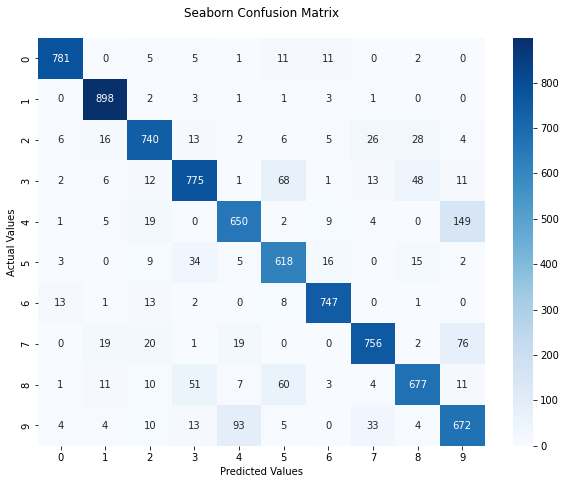

In [16]:
# Use Clustering
from sklearn.cluster import KMeans

n_digits = len(np.unique(y))

print(n_digits)
# Lets try a kigher k then actaul digits
k = 100 #n_digits

kmeans = KMeans(n_clusters = k)
# Fit the model to the training data

start_time = timeit.default_timer()
kmeans.fit(X)
stop_time = timeit.default_timer()

clusterVals = kmeans.predict(X)

predsMap = {}
for i in range(k):
    cat = np.bincount(y.iloc[np.where(clusterVals == i)]).argmax() 
    #print("{} : {}".format( i, cat))
    
    predsMap[i] = cat
    

print(predsMap)

print("K-Means fit time: {time}".format(time=round(stop_time - start_time, 2)))

y_pred = kmeans.predict(X_test)

# Swap k-means with actaul category
y_pred = np.vectorize(predsMap.__getitem__)(y_pred)

fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))

conMatrix = confusion_matrix(y_test, y_pred)

ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs)

ax.set_title('Seaborn Confusion Matrix\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values');


In [17]:
# Let's also print the accuracy and recall scores
print("Precision score: {:.2f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
print("Recall score: {:.2f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
print("Accuracy score: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
print("F1 score: {:.2f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))

Precision score: 0.87
Recall score: 0.87
Accuracy score: 0.87
F1 score: 0.87


In [13]:
digitsTestDf = pd.read_csv('digits/digit-recognizer/test.csv')

predictions = kmeans.predict(digitsTestDf)

# Swap k-means with actaul category
y_pred = np.vectorize(predsMap.__getitem__)(predictions)

df = pd.DataFrame(y_pred, columns=["Label"])
df.index += 1 

df.to_csv("digits/predictions_kmeans.csv", index_label="ImageId")

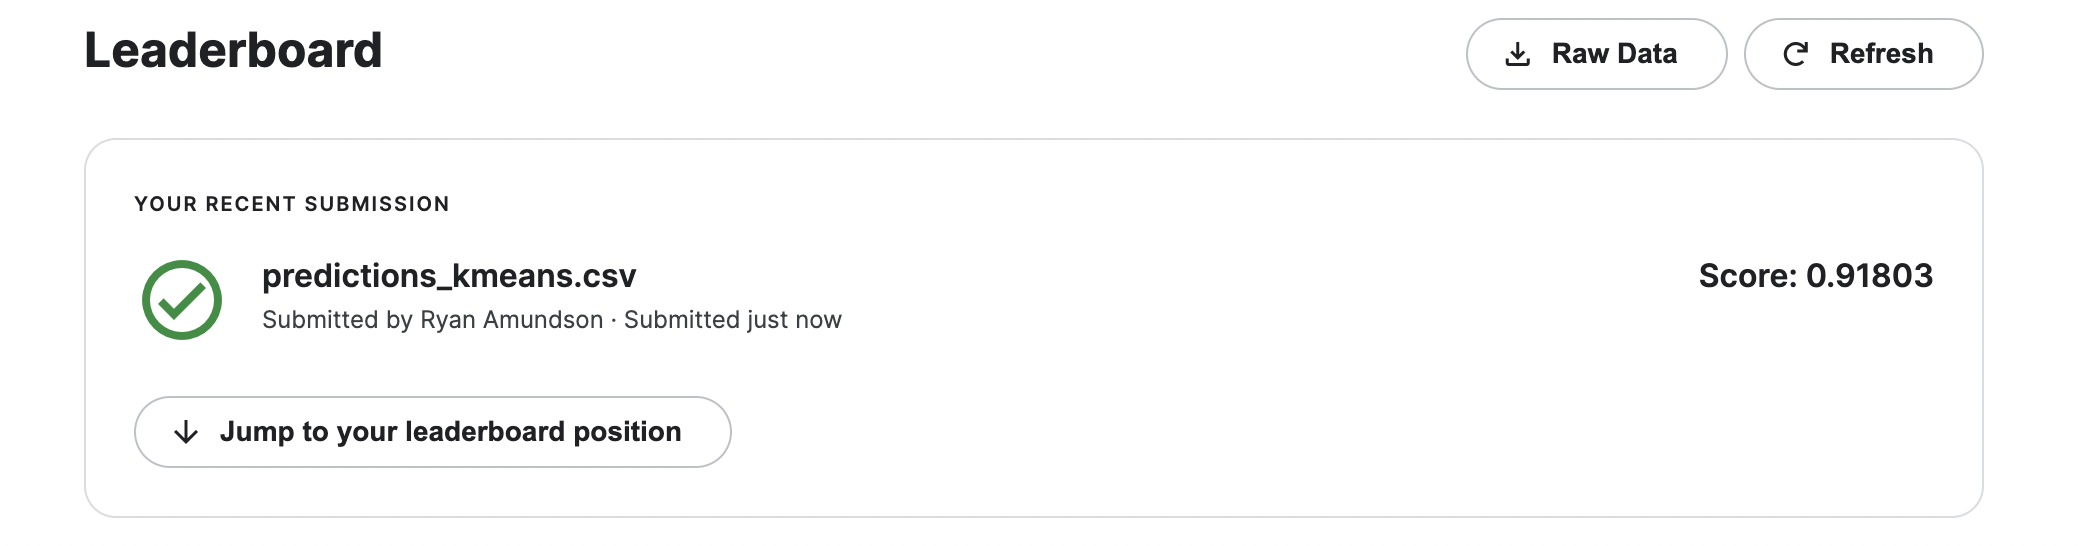

In [20]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAACCYAAAIiCAYAAAAe8FvUAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAACCagAwAEAAAAAQAAAiIAAAAAQVNDSUkAAABTY3JlZW5zaG90yKWIBwAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTQ2PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjIwODY8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KFkbSmAAAABxpRE9UAAAAAgAAAAAAAAERAAAAKAAAAREAAAERAAJRzcP8BScAAEAASURBVHgB7L0JvGVVcS6+upl7AIGWeQYHRERoyTOKAipG0TjGRFQUaByiGOOYfwIkjpnML1EDKEbNS54mGsUhD4K+yOAEKIM0oEYZm3luhm7m7vuvWrW+WlVr7X0bLj13HWXXV1XfWnV27Vq1d5+z7z7TJuiVBl5snGbtZJggA2w8alpRhGtGAGY5kSZoFMbJlCDYAB53DDJE/Mg/6ijqL9Zf9B/bTU3HBMwy+m+cf+L8i/OGXTH+isNrWEJqJUNcf8T1B+oorj/i+iOuP2w3NR0TMMu4/ojrj7j+wHnDrhi9thgAWELqIkNcf8T1B+oorj/i+iOuP2w3NR0TMMu4/ojrj7j+wHnDrhi9thgAWELqIkNcf8T1B+oorj/i+iOuP2w3NR0TMMu4/pjK9cc03JjQpc92Hj07VdDxq4uQOzLV05lh4BHN24/4tfPVDCrq8qUeBsgrZHFChVRe5L/LZ9Rf1B/OvG5tidLVi+NggUHG+ssZQDogo/9QWuRSv6un6D/Rf6L/uK5qlW69WKf2FW004oUKqby4/unyGf0n+k/0H9dVrNKtF+vUvqKNJvoPZwDpgFRD9N+unqL/Rv+N/uu6qlW69WKd2le00YgXKqTyov90+Yz+E/0n+o/rKlbp1ot1al/RRhP9hzOAdECqIfpvV0/Rf6P/Rv91XdUq3XqxTu0r2mjECxVSedF/unyu4v4zbWIpvQPcBlUOrh430vmBCtPKArF2VwfMo//cNI2hUfPwbBtwWFPEj/xH/eHLy2aNmUVo10xdXJXQ+cmVbQMOa4r1F+sv1l+sP+4kti/UziKo8zWGRs2Dsm3AYU3Rf6L/RP+J/sMNw/YF6Tp12/kaQ6Pmgdk24LCm6D/Rf6L/RP/hhmH7Qu08gjpfY2jUPCjbBhzWFP0n+k/0n+g/3DBsX5CuU7edrzE0ah6YbQMOa4r+E/0n+k/0H24Yti/UziOo8zWGRs2Dsm3AYU3Rf6L/RP+J/sMNw/YF6Tp12/kaQ6Pmgdk24LCm6D+rqP9Q4vk4lJc9JGyyusUj9GwWnm7t83/KMLrbYeRuqDaG1S2O+CbVyKpLimSLtpH//tv8qL9Yf4N3I7Y9xuoWu6UW689lQPKk2+g/0X/kurpWSfTf6L/Rf+t6UNSeY6xucRkwYMI1u7hoG/03+m/0X11hGcT5J84/cf7xa0IWBm1ts7AnGIvL0AFTnH8kKbqN868vKS6d6L/Rf6P/liZqRdtQrW5xGTNgiv4rSdFt9N/ov/aShpdOnH/i/BPnH3viGTmh2BOMxSP0bNbOS/+SIBz9N/rvFPpv/ikHe1eIXNhwhZXZcp3VYjOectuC+HJNuhsZxJK3TGHfYDPg80S9KyPi52RRviL/WjvTpMaazET95SqR3ORcxfqr60YSUtMS/Sf6b5x/7KpQHOffuP7AXelx/dVcZeTTq5xjG09cf1AHyf/4xLVqXH/kjGhjBciFQ5s4/yAjTsb5J84/cf7BpzfNWYbV+PcvJyGfXbhx2EzF+ScXCKeFXhaLRc3si/OPSUqFcf6J80+cf2xX5bURnz/nDhHnXyoFOa/wll+2UuL8K7mRzFgslrzNiaNNnH9NUiqM82+cf+P8a7sqr411+/ybb0yQf89IU83b3EhrbmoLGUduiFP6MZ2bDebklyEPw7Hqp+gsbk6ndNTuH7ix/5zrfBBqKjhtkf++eEYsruSc0g/o3Dn1eRP557LrEtTnsLW4IU5pmd1Xb+XznMg/L/ichWXkr89ok9NljO/cGjTiayo4ydF/h0pt0OZqyik9vXNr0qP+NBWctqi/vnhGLK6mnNIP6Nya9Kg/TQWnLeqvL54Ri6spp/QDOrcmPepPU8Fpi/rri2fE4mrKKf2Azq1Jj/rTVHDaov764hmxuJpySj+gc2vSo/40FZy2qL++eEYsrqac0g/o3Jr0qD9NBact6q8vnhGLqymn9AM6tyY96k9TwWmL+uuLZ8Tiasop/YDOrUmP+tNUcNqi/vriGbG4mnJKP6Bza9Kj/jQVnLaov754RiyuppzSD+jcmvSoP6Ri2lK6XcnXX3aVbJoUFrP1Mkn0ESeOCbkn6NvGaVrpmGWCxler0OHD7CzpHY6EEPOIUybMYyO+zTRyHPm3WZFyQW5YY8yvqL9Yf64MclXwRqql1IwtHWUIKfqPXWlIVPQfmxUpGeSGNcb8iv4T/ceVQa4K3ki1lJqxpaMMIUX/sSsNiYr+Y7MiJYPcsMaYX9F/ov+4MshVwRupllIztnSUIaToP3alIVHRf2xWpGSQG9YY8yv6T/QfVwa5Kngj1VJqxpaOMoQU/ceuNCQq+o/NipQMcsMaY35F/4n+48ogVwVvpFpKzdjSUYaQov/YlYZERf+xWZGSQW5YY8yv6D/Rf1wZ5KrgjVRLqRlbOsoQUvQfu9KQqOg/NitSMsgNa4z5Ff0n+o8rg1wVvJFqKTVjS0cZQnqs/YeemLCUpjN3alANtq+xeC1vTHfjWeGXxhFv3jqi0Hg7Yq6EZSA3nhV+RXzJgy0tl6jiJjFiroRlIDc+8i/ZivorVSPVkbeuUGpRjZgrYRnIjWeFX5F/yUOs/1wMuUZcoZT0kBgxV8IykBvPCr+i/iQPUX+5GHKNuEIp6SExYq6EZSA3nhV+Rf1JHqL+cjHkGnGFUtJDYsRcCctAbjwr/Ir6kzxE/eViyDXiCqWkh8SIuRKWgdx4VvgV9Sd5iPrLxZBrxBVKSQ+JEXMlLAO58azwK+pP8hD1l4sh14grlJIeEiPmSlgGcuNZ4VfUn+Qh6i8XQ64RVyglPSRGzJWwDOTGs8KvqD/JQ9RfLoZcI65QSnpIjJgrYRnIjWeFX1F/koeov1wMuUZcoZT0kBgxV8IykBvPCr+i/iQPUX+5GHKNuEIp6SExYq6EZSA3nhV+Rf1JHqL+cjHkGnGFUtJDYsRcCctAbjwr/FpG/clPOTDRjWaDeU2Qk38fhwQ/XkHnNJQxWKcdujvJjKpEYyww4kf+o/5i/UX/if4b5584//ZXCKOWelkR1x/93dEmbTVRxlhgXH/F9Vdcf8X1V1x/xfVXXH/F9Vd/hTBqqZcVcf0V11/t01FN2dRCMcYC4/ozrj/j+jOuP+P6M64/4/ozrj/7K4RRS72siOvPuP6M68/R7+7rQunX0iq4/h74KQf7jwHGw7sy2X7kmxywe4PDy2gSozc65GRE/Mj/YAFNeh9N1B8W39jyjfWX11X0n+i/1F4GO0ycf0piBrMT/XestXLr5faK12D6ov9G/6XCiPNPnH+oDIZbBBVHdgx6o/9Sfx3ODDmi/+LsM5KkOP/kxET/jf5LTWSwj8T1f0nMYHbi/BPnn+F1w2eeOP/G+RcZGGwfcf0R1x9UGHH9FddfVAbDLYKKIzsGvXH9Qf11ODNx/o3rD5x8x4pk9T//6k855F0p79fsVtMA6g7lVTHAl7HigBtS53UGoxgIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGlifmAAjpM7SA6GME3tPa6m6IgDIPqxahDJO7D2tpeqKACA1Wg+EMk7sPa2l6ooAIPuwahHKOLH3tJaqKwKA1Gg9EMo4sfe0lqorAoDsw6pFKOPE3tNaqq4IAFKj9UAo48Te01qqrggAsg+rFqGME3tPa6m6IgBIjdYDoYwTe09rqboiAMg+rFqEMk7sPa2l6ooAIDVaD4QyTuw9raXqigAg+7BqEco4sfe0lqorAoDUaD0Qyjix97SWqisCgOzDqkUo48Te01qqrggAUqP1QCjjxN7TWqquCACyD6sWoYwTe09rqboiAEiN1gOhjBN7T2upuiIAyD6sWoQyTuw9raXqigAgNVoPhDJO7D2tpeqKACD7sGoRyjix97SWqisCgNRoPRDKOLH3tJaqKwKA7MOqRSjjxN7TWqquCABSo/VAKOPE3tNaqq4IALIPqxahjBN7T2upuiIASI3WA6GME3tPa6m6IgDIPqxahDJO7D2tpeqKACA1Wg+EMk7sPa2l6ooAIPuwahHKOLH3tJaqKwKA1Gg9EMo4sfe0lqorAoDsw6pFKOPE3tNaqq4IAFKj9UAo48Te01qqrggAsg+rFqGME3tPa6m6IgBIjdYDoYwTe09rqboiAMg+rFqEMk7sPa2l6ooAIDVaD4QyTuw9raXqigAg+7BqEco4sfe0lqorAoDUaD0Qyjix97SWqisCgOzDqkUo48Te01qqrggAUqP1QCjjxN7TWqquCACyD6sWoYwTe09rqboiAEiN1gOhjBN7T2upuiIAyD6sWoQyTuw9raXqigAgNVoPhDJO7D2tpeqKACD7sGoRyjix97SWqisCgNRoPRDKOLH3tJaqKwKA7MOqRSjjxN7TWqquCABSo/VAKOPE3tNaqq4IALIPqxahjBN7T2upuiIASI3WA6GME3tPa6m6IgDIPqxahDJO7D2tpeqKACA1Wg+EMk7sPa2l6ooAIPuwahHKOLH3tJaqKwKA1Gg9EMo4sfe0lqorAoDsw6pFKOPE3tNaqq4IAFKj9UAo48Te01qqrggAsg+rFqGME3tPa6m6IgBIjdYDoYwTe09rqboiAMg+rFqEMk7sPa2l6ooAIDVaD4QyTuw9raXqigAg+7BqEco4sfe0lqorAoDUaD0Qyjix97SWqisCgOzDqkUo48Te01qqrggAUqP1QCjjxN7TWqquCACyD6sWoYwTe09rqboiAEiN1gOhjBN7T2upuiKAIumJCfzMOvuyDLbzA0PIht9cgFus5nEicEDy2P6l3gxUM0TYWPIr4kf+qRai/nQpYNFhpcg6gQYp1nar3gxUMzTYWPIr1l+sP6qFWH+6FGL9SWdAp/Cat4qvbtWbgWqVoM9oYh+/ov9E/6FaiP6jSyH6j3QG3z2gQQqn3ao3A9UMDTaW/Ir+E/2HaiH6jy6F6D/SGdApvOat4qtb9WagWiXE9Q/lovTcnJXov9F/aZ1E/63LgpcEvXz3gAYpnHar3gxUMzTYWPIr1l+sP6qFWH+6FOL6RzoDOoXXvFV8daveDFSrBO1q7ONX9J/oP1QL0X90KUT/kc7guwc0SOG0W/VmoJqhwcaSX9F/VkX/mTaxlG5MmIaDIYdiaDvMgBXSj+R7HqZNkwNLCOvJ7aech4bH29mGGbBC2hEUJuJH/qP+aFFM0P9i/XEnyi9qF7jOif5DGYn+z0mQ2hjZjpxhyrgRb5x/4vwT5x9aI3H+ifNvXH/oGSauP+L6i4oh10O+dBi+frCXIsMMWCHtiPj3b/z7Pz5/ic+fuMvE9Vdcf8X1V1x/lesDulyIz7/i+iuuP/OpMT7/jM9/qRD07FCapBcj/8Iq40a88flvfP4bn//SGnns//7IT0xwy0oVBX6FDmhg0jqkQuQPREQqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcqijw5AENTMSFVCoIavDAuVVR4MkDGpiIC6lUENTggXOrosCTBzQwERdSqSCowQPnVkWBJw9oYCIupFJBUIMHzq2KAk8e0MBEXEilgqAGD5xbFQWePKCBibiQSgVBDR44tyoKPHlAAxNxIZUKgho8cG5VFHjygAYm4kIqFQQ1eODcRel+ykHsjip/VFy2/V0HPkiv1bkyoo3erdmTfazilxnKPN1eD0ziTGUc2TKiTcQfvz9MslVzxql0tsh/c9eNK7YBpeYyI9pE/UX9jd2f6dZaqSZni/UX6y/fhTnQagZNUj3syog20X+i/0T/GVws/lqnUKL/8nopfSTOP3H+ifPPcPMYtJZ1Q76MaBPn3zj/xvl3cLHE+ZfSoufakiLpIKWPxPk3zr9x/h1uHoPWsm7IlxFt4vwb5984/w4uljj/Ulri/Ft7JleJaMUW1x9x/RHXH8PNc9Ba11JGtInrj2VffzQ3JtQklm6kbQk5Nwy9RwEJH38aih2FmYak4SlUkAdYDT0y26yjm3pSp2EbnkIFEZ8yYLMR+ZdzVM6JTYypKIGTOg3b8BQqyDyrRf4j/3yNkGvCFoapqKg/zsCkyTHZMjyFCjLParH+Yv3F+ov+k3uCbQymowic1GnYhqdQQfQfyoDNRvTf6L/Rf6P/5p5gG4PpqAIndRq24SlUkHlWi/4T/Sf6T/Sf3BNsYzAdJfoPZ2DS5JhsGZ5CBZlntei/0X+j/0b/zT3BNgbTUQRO6jRsw1OoIPoPZcBmI/pv9N/ov9F/c0+wjcF0VIGTOg278pobE5rGQ0PG7iwEs05l5h+AwqvsjKqqI6zJYiUoEO/kHCWXhlrZGVVVidZksRIUiHdyjpIjPqXC3omY8zaQPGuyuGYSSLyTc8DtqzWPGxhsTRbXmYDEOzkH3IjfZivrA8mzJotrJoHEOzkH3Mh/m62sDyTPmiyumQQS7+QccCP/bbayPpA8a7K4ZhJIvJNzwI38t9nK+kDyrMnimkkg8U7OATfy32Yr6wPJsyaLayaBxDs5B9zIf5utrA8kz5osrpkEEu/kHHAj/222sj6QPGuyuGYSSLyTc8CN/LfZyvpA8qzJ4ppJIPFOzgE38t9mK+sDybMmi2smgcQ7OQfcyH+brawPJM+aLK6ZBBLv5BxwI/9ttrI+kDxrsrhmEki8k3PAjfy32cr6QPKsyeKaSSDxTs4BN/LfZivrA8mzJotrJoHEOzkH3Mh/m62sDyTPmiyumQQS7+QccCP/bbayPpA8a7K4ZhJIvJNzwI38t9nK+kDyrMnimkkg8U7OATfy32Yr6wPJsyaLayaBxDs5B9zIf5utrA8kz5osrpkEEu/kHHAj/222sj6QPGuyuGYSSLyTc8Bd8/KvNyaM7+AEfak+zX2pXG+bGhs1ZudEwQcpyfNaTSjzI37k397UoCVUgS0YU2ONOauoNEjheM2Oi/qL9RfrL9af6RAKFdiGQXjMzjT4IGWo18QGT6y/WH+x/swKUajALhjCY3amwQcpQ70mNnhi/cX6i/VnVohCBXbBEB6zMw0+SBnqNbHBE+sv1l+sP7NCFCqwC4bwmJ1p8EHKUK+JDZ5Yf7H+Yv2ZFaJQgV0whMfsTIMPUoZ6TWzwxPpb89bfPYsWp3vvWZzuu+++dN8D96cHH3w4PfTQQ+mRJY+ktJQ/U+QjPp3+kyMvnzLKEec/BmSrvNgznT5/X0pG8hTnNPpT1QmyZcn2/OfLPIIJxM1/ylpwtpWBNEqyGfEj/6um/tabvl6avt70tOGGG6WNNtwgzdhkRtpkxsZp09mz6b+ZUva6lZUR5x/pE/csWpTuvXtRuv/+B9Li+xenhx5+mHrLI2nJI49QW6F1H+s/+t9q3v9j/eNczFJesrqhWblu9j+6MYGuknIzazM0niqkzTOQwHYe1olZLqrw+BfMkX0RfyAdPruVUJFnRP7lkrvkxyUn6i/WH50E6P/Rf+TfrGNdhFu1tGMFldogz4j+E/2HP/IoL1ccpMT5P/pP9N84/1Ar4M9M68s1CvPPgcZeByjyjDj/xPknzj+6tNziICXOv3H+jfNvnH+pFcT5Vy8hCLhGadTGbocU7Blx/bEuX3/cTzcf3Hb7nWnhwnvSXXffnZYu4ZsDpFD4S9UJPv9OJwTzNHyJiCpiSa9ynk7TSGdMrzJNrtRsKBuMFJXrj7nly2bjjPiR/zWl/qZPWy894Qmbpi222CzN2XLLtMnGG9uSd9iUONnXzv57/wMPpNtzX7krLbz7nrR0KfcNefX7H+s/+t+a3f9j/dPazid8v7qx5q30jLWr/+kTE8wVed73upsV2aQUUr1qMk6fsDqz2O3WDCqXVbDUqBXBp7INVBytGbqNDJvOFfEpFbgEtqf5yL/7B1ctmFrY1ka4rS3oUX9cYTYLNnHIkthq1VVk2Rn7IepuzdBF2q0OIQCW2GrUiiw7Yz9E3a0Zuki71SEEwBJbjVqRZWfsh6i7NUMXabc6hABYYqtRK7LsjP0Qdbdm6CLtVocQAEtsNWpFlp2xH6Lu1gxdpN3qEAJgia1GrciyM/ZD1N2aoYu0Wx1CACyx1agVWXbGfoi6WzN0kXarQwiAJbYatSLLztgPUXdrhi7SbnUIAbDEVqNWZNkZ+yHqbs3QRdqtDiEAlthq1IosO2M/RN2tGbpIu9UhBMASW41akWVn7IeouzVDF2m3OoQAWGKrUSuy7Iz9EHW3Zugi7VaHEABLbDVqRZadsR+i7tYMXaTd6hACYImtRq3IsjP2Q9TdmqGLtFsdQgAssdWoFVl2xn6IulszdJF2q0MIgCW2GrUiy87YD1F3a4Yu0m51CAGwxFajVmTZGfsh6m7N0EXarQ4hAJbYatSKLDtjP0TdrRm6SLvVIQTAEluNWpFlZ+yHqLs1QxdptzqEAFhiq1ErsuyM/RB1t2boIu1WhxAAS2w1akWWnbEfou7WDF2k3eoQAmCJrUatyLIz9kPU3Zqhi7RbHUIALLHVqBVZdsZ+iLpbM3SRdqtDCIAlthq1IsvO2A9Rd2uGLtJudQgBsMRWo1Zk2Rn7IepuzdBF2q0OIQCW2GrUiiw7Yz9E3a0Zuki71SEEwBJbjVqRZWfsh6i7NUMXabc6hABYYqtRK7LsjP0Qdbdm6CLtVocQAEtsNWpFlp2xH6Lu1gxdpN3qEAJgia1GrciyM/ZD1N2aoYu0Wx1CACyx1agVWXbGfoi6WzN0kXarQwiAJbYatSLLztgPUXdrhi7SbnUIAbDEVqNWZNkZ+yHqbs3QRdqtDiEAlthq1IosO2M/RN2tGbpIu9UhBMASW41akWVn7IeouzVDF2m3OoQAWGKrUSuy7Iz9EHW3Zugi7VaHEABLbDVqRZadsR+i7tYMXaTd6hACYImtRq3IsjOmITffemu66Zbb01133ZU/PeVZeMTsmTPT7Nmz0syZM9LG9OXqjI02SuvTX4dvsD79tTj9xbiPxrN5S41aUY5pN36IelozdJF2q0MIgCW2GrUiy87YD1F3a4Yu0m51CAGwxFajVmTZGfsh6m7N0EXarQ4hAJbYatSKLDtjP0TdrRm6SLvVIQTAEluNWpFlZ+yHqLs1QxdptzqEAFhiq1ErsuyM/RB1t2boIifSEvpb2EceWZIepieIPPDgg4m/fF+8mJ4wcu/itGjxfWVq/tR9Ot2kMDtts/VWaVv6r3th4sbRmqEjfv0U2g4ES2x1ryuy7Iz9EHW3Zugi7VaHEABLbDfdcku6+ZY7qK8sJA/fcM3fzUykWbNmpNmzpK/M2GjjtNHGG9GTJzZM6623Hv3HX0q3M1XdRvbR+lF1ryvKk9tNP0n2tmboIu12fLIatSLLHgxUCIgHPnQbGTZwapbEUqNWVLkF9ZNkR2uGLtJu7Yxgia1GrciyBwMVgp+p7pmN3HIqa8XHj/WPb8HsEfVHpB71iiw7Yz9E3a0Zuki71SEEwBJbjVqRZWfsh6i7NUMXabc6hABYYss3JuCviN1bMDw7VcbGlyfMOjVOZ+cAZMAdoBJvcBvx6VSZ02e+Aje5FGi2xhf5p2TkfET9xfqj9sLXb/ri2iCDs6lTQfSf6D/Rf7mNxvlH/+bWnGMFmq3xxfmXkpHzEeffOP/SKdWda7k24vzrc6KXHQri+iOuP+L6I64/4vorrj/j+rNcQJhrbIFma3xx/U3JyPmI6++Vdf299JGl6bobb0jX33Bzevjhh3L+p02fnp5If+G95Zabpy02fwJ9WbgBXd/xsYnr37j+1Uv9QRDX//X6/+GHHk53Lrw73XHHwnT7HXfknyfgq4KNNlg/bb/dtmmHHbZP69NaqzW19vQ//pmX66+/KV1/I/UVummDf6aF93POnCemJ9ITJLbYfPN8cxM/TGVt3P+4/o3r33V5/Uf91/o3T0xozpmu+bHPGkoKrUmHm/SqX0GZxug6rgEdxRoifj6ENiWavsi/lrfmR0HUX06FyYfWTQM6ijXE+ov1Rx+h2ZLQ8on+E/2nfLyq9aEg+m9OhcmHrpsGdBRriP4b/Tf6b5x/qGfQB1f+FeffOP/G+TcvCz1lKojrj5wKkw/fPKrWUawhrj/i+iOuP+L6g9rFOnb9seC6G9K1116XHqafaphOLXEW/UX39ttsnbZ64py0Hn9hSp+Tx/VHXH/E9UdeCqU/mGuHDI1erzg8Igr/ZfWtt92Wbrj5lnTvPfeQf1pan54MsNNO26eddtxhrfr8UfrK9emRJUvyfm5KT1vZbtttqK9sWZ6EYHMW119x/bX2X3+tS+vfNz/S7HLPTmtY+9e/uTFBdtzvfn9ekQQaVoZ1LPvrtWrlAUHKPHZb58B45SoA3xgyFJ23/MJ4e3QxAlKYdlvnwHjlKgDfGDIUnbf8wviIX/MEBCmZslvxWL9iBeAbQ4ai85ZfkX/JQ9RfrRMgSGSoSvFYv2IFYBtDhqLzll9Rf5KHqL9aJ0CQyFCV4rF+xQrANoYMRectv6L+JA9Rf7VOgCCRoSrFY/2KFYBtDBmKzlt+Rf1JHqL+ap0AQSJDVYrH+hUrANsYMhSdt/yK+pM8RP3VOgGCRIaqFI/1K1YAtjFkKDpv+RX1J3mI+qt1AgSJDFUpHutXrABsY8hQdN7yK+pP8hD1V+sECBIZqlI81q9YAdjGkKHovOVX1J/kIeqv1gkQJDJUpXisX7ECsI0hQ9F5y68VUX93LFyYrrhmQbp/0X1pgv7EfYs5m6edt9uOHjX/BAq44uObnaI9lHh5ZzOM+HzUOQv8WhHH30xKESL/muWVVH8L6adSrr3xprSQnqTA62/mrJlpj113zk8RWJPX3x133pWuvPqadB/9lMUEPSFhc3rayi7cV7Z4Qq0yU265wKunlKIQeMuvqH/Jg12nSCEkGFXWHCJ/ylUAtjFkKDpv+YXxEb/mCQhSMmW34rF+xQTW1vVfMzD5/puioiGambV2/ctPOdCu5sVk9jcnDM8YsqloOZloCcXQ8rIOY5FeuHznWSI+HRhpc8icrUmkXnJF29oRB3LJfsziEw9rN3fkP/If9eeXly6WbK6b1j6ow1ikFwNrlgiR/8g/ZQCVU0EtPZ+gYtcBVoexSC9MEIwhQtSfTy9SWFKkorUP6jAW6UXkH+lBUuP6I9Zf9J/oP5QBbQ0K0CSKbO2DOoxFemGCYE4iRP3lZCBz9UBE/l0GNEGoHZLdv8dBKtKLqD+kB4mN83/0n+i/eTXo0lCARVJkax/UYSzSi+g/SA9SW/rP5VdcTT/dcFNu57Nnzko777ID/WzDFmCJ7MaSOfp/zVHOD5JUpBdRf0gPshbnv+78d/vtd6arr70+LVq0KGdpB/p5hyftsetA7az+6+/yy6+mp0HcRD9XkdKms2anXehJEHPmmL4Sx787/vHvj6autVc09q6XsB/GIr0YWENEWM2uv9am9Y9axlGBjkNKd2Ctdvnv3iPerO5EMQzqMBbphau/+sQEkwTEYtlMZV2KwalsdSnInEosdmOI+FqEmjQCyBCk9QFXX0XwQWZP5zaGyH/kv5yEUDMsUSGQ1gdcfRXBB5k9ndsYov6i/qL+sFxUYoVAqsOA6qvIuDPMns5tDLH+Yv3F+muXTZz/KCP8+arpFKM5mowV/Yfy2CXRGKL/Rv+N/jvaW8xKGeVE/xnPUvZ0bmOI/hP9J/rPaG8xK2WUE/1nPEvZ07mNYTXsP4sWLU6/+s2VadHiRWliaUq777pT2nmnHeL4NxmoR7GihiL/fujcxrAaHn/eB7xDyHa/LKeye1Ye301iDLH/j+n8u4BuTrj6mmvz8Zk1a1ba88m7p1mzZlDi7d1A9TisTvlfXPrKvYvuze93t12or+y4/WPa/7pntupMPVkC4dVp/+tbM+836j+O/2O4/lyT13/UPzIwvv7rjQngsjT8bG515faO3qLkCog0QZ/SlV+iqnagdpJWB697o/1bV6oFET/yH/UX62/kIrZrK9F/Rq73+8T0Ftt4C47+G/03+m/03+i/A82RTG0TbXUd1Tt6i5IrIFJcf8e/P+LfX8MfYsb6o1ZhUzPaVHpHb6ltR1H0n+i/cf0X13+uyWh3iOuftom2uqaqd/QWJVdApLj+m/z677Y770i//NXlaenSpYmfkvCUJ++WZtPvvvtXn+3e4kdkLfIf9Rfnv8d9/rvn3nvTb+hpJovuXZSmTZ+e9nrqk9KWc7YcO6vUhbgK199tt0tfWTKxJG02a9P0pCftmjZt+0rbRFpd96R39BYlV0Ck6P+T939XRKNJ7R29paZdUeR/udTfmrj+cw3E8V/m8fc3JuSEmc8kRu5isgsMC1gWpGw7fzbzhv/NQR+HFVrDzv8gmaAPRPQzkYhPydBsaFoVmAQKNAZJtiQzm3kT+Y/6i/UX/YcaAbWVpltE/6WExPknzr96xo3rj7j+iOuvfN04uDEnEIHGwAOgZskbNsX1R1x/UCHE9Ycuj7wwZHHE9QfVRZx/S0XE9Udcf8T1h7bHDuD6ghwCjYHJULPkTVx/xPXXsq8/b7zxZvrC8yr6nHoibbPtNump9NfYgy/UV64rPm8ZAw+AmiVvov6i/pZdf3H9k5cKLRZaM4/i/Pc/9FSTG2++Ja/XJz9p97T9dtvIBKvZ+rvhppvTr+nnG/jff9tuuxXd7LRHvdaV5hDX/3H9X2viUdZ/KZ119vyzpqx/OU7R/x/N519yYwIauLTzvPUmoxlo6FODmAvSzOJNRjPQ0KcGMRekmcWbjGagoU8NYi5IM4s3Gc1AQ58axFyQZhZvMpqBhj41iLkgzSzeZDQDDX1qEHNBmlm8yWgGGvrUIOaCNLN4k9EMNPSpQcwFaWbxJqMZaOhTg5gL0sziTUYz0NCnBjEXpJnFm4xmoKFPDWIuSDOLNxnNQEOfGsRckGYWbzKagYY+NYi5IM0s3mQ0Aw19ahBzQZpZvMloBhr61CDmgjSzeJPRDDT0qUHMBWlm8SajGWjoU4OYC9LM4k1GM9DQpwYxF6SZxZuMZqChTw1iLkgzizcZzUBDnxrEXJBmFm8ymoGGPjWIuSDNLN5kNAMNfWoQc0GaWbzJaAYa+tQg5oI0s3iT0Qw09KlBzAVpZvEmoxlo6FODmAvSzOJNRjPQ0KcGMRekmcWbjGagoU8NYi5IM4s3Gc1AQ58axFyQZhZvMpqBhj41iLkgzSzeZDQDDX1qEHNBmlm8yWgGGvrUIOaCNLN4k9EMNPSpQcwFaWbxJqMZaOhTg5gL0sziTUYz0NCnBjEXpJnFm4xmoKFPDWIuSDOLNxnNQEOfGsRckGYWbzKagYY+NYi5IM0s3mQ0Aw19ahBzQZpZvMloBhr61CDmgjSzeJPRDDT0qUHMBWlm8SajGWjoU4OYC9LM4k1GM9DQpwYxF6SZxZuMZqChTw1iLkgzizcZzUBDnxrEXJBmFm8ymoGGPjWIuSDNLN5kNAMNfWoQc0HSLNddf2O64qpr8j0Fu+68Y+L/6h0GHk4tqBmFuJADLjEZgoGGPjWIuSDNLN5kNAMNfWoQc0GaWbzJaAYa+tQg5oI0s3iT0Qw09KlBzAVpZvEmoxlo6FODmAvSzOJNRjPQ0KcGMRekmcWbjGagoaerF1yXFtB/7N5jt13SjjtsZ93DGHNBGpY3Gc1AQ18mvJ76yuVXLSDe0rTLzjtJX8FckGYWbzKagYY+NYi5IM0s3mQ0Aw19ahBzQZpZvMloBhr61CDmgjSzeJPRDDT0qUHMBWlm8SajGWjoU4OYC9LM4k1GM9DQpwYxF6SZxZuMZqChr/br375XxdgXSHW4Kw6yGoKBhj41iLkgzSzeZDQDDX1qEHNBmln8ExPUMcAcMGV6thunQgWa1mpxqdaoFVhmsQ6YIj5lIOfFJEehgsg/pYnvQq0Z8TjXkdtYZnEMmLIn241ToQKNWy0R3+bCpb4m1ZvHBmS7cSpUEPmnTEb9+zVXq8OXmWgD3gFT5ma7cSpUEPUX9Rfrj2qgrgiPZc3ZrWUW+4Ape7LdOBUq0LjVEvFtLmzmBQ94B0yRf8pAzotJjkIFUX+Uprj+8D2nVoesOL8d8A6Y8phsN06FCqL+ov5i/VEN1BXhsV97rFlm8Q6YsifbjVOhAp2tWgYjlEAsLLOYB0zZk+3GqVCBzlYtgxFKIBaWWcwDpuzJduNUqEBnq5bBCCUQC8ss5gFT9mS7cSpUoLNVy2CEEoiFZRbzgCl7st04FSrQ2aplMEIJxMIyi3nAlD3ZbpwKFehs1TIYoQRiYZnFPGDKnmw3ToUKdLZqGYxQArGwzGIeMGVPthunQgU6W7UMRkg30JMSLqcnJUzQ//bYfde04/bmy007uLyl5R2/TjsQbMAU8SkDOS8mOQoVPOrjH/lHBmruYNEkqqGATDV8hQp0aLUMr786tWXaOJWhKFOFf90NdFMR/bQDP2XhKXvsmrbbbttMw2yQbLRY51Iw4B0wZXq2G6dCBen6G25Kl195dY75pN3ppgnqK9WrQQ0Y8A6YHm18DIXkcRabwAUOeAdMmZztxqlQgcaqlohvcxH5bzMwkJ0BU1t/q+v6x1uH5Pdtcbv3g96xAdlunAoVaKxqGYxg3oZlFvOAKXuy3TgVKphSfLoxYenEBD2/Gk/MqdPV9wkbJHuAISu7RZZhMXh0GRjxI//8ySW9hitk/IPNIb7MhK1lWFz9UX+x/qP/yXoYXiGx/sa+WBnKFzpLn9Ehdpz/ov9G/43+23cL9BF0DUi2A0OC20vLsBjM6D/Rf6L/RP+RfjDcIeL6L67/6jmHKwV1AomzSS8tw2Iw4/wT5584/8T5R/rBcIdY8eefO+64I136y1/To9SnpSfttrO7KQHvCZLfKTAkulkvLcNiMKP/Rf+L/re8+l/+cvLKa2hxTaS9n7ZnmjNnc8LlywVdtVh7LFfs+rvt9tvTZb/8TQ64xx7UV7bb3gZf4fFrp+Kw0X9qLeAwrNjj73Me+V/R+V/d1n8cf1vzFk++/swTE8qgLOwE1j7W3BBk2VJnJuB+zxtNMxOURRMWrCYFyw42wNDRBFZk/FtvvS2d/t3T9e2npXRypB/XQPznHfC8tCvdlYtTphIzASzegYLVpGBg75Zt0tEEVuT+j72TVRl/wbXXprPOOltyXvZ/evnEiY/MfnPnpr33eno+TrWBlnds37g5amP7OWa306ys/P/397+fbrz+Jld/XFYcn/f/sNe/Pm2w4Qb0lknJb1DfJdkKVpOCsV2c1K6jCays/bdvaG2Pv+Da69LZZ51Ju0zHkv6Pw4f+s+/c/dIznk41HvmP+islIuujrIwsdJXUAlKTAhn2GLc6mkCsf1mikX/OQKmMLLRKGrvhMZzCS2cmEPUX9cenSHmVyshCq4Rc1s5M65ORj2WrowlE/UX9Rf1h9dh1pqukrjc1KcDAxyR1NIFYf7H+Yv1h+ZSVkYWuklh/ON9rShQgcY9J6mgC0X9Wj/6zeNHidMHFl6SlSyfSLjvRzzfssgMdU3SGcsTsgVPfYzr0mWynieNfs6zX1TlBmiXKWcFqUvDYk19ny9NG/tfO/F+94Np0zYLr0/T1pqe5++ydZs2aqbWi1UNgRR//RYsXpwt/fmlaOkE/37Aj/XwD9ZWVGV932oCIX2p+JRx/k3aFkf8Vn//VZf3rQTcgjv+jO/7mxgSTPYKaQJibhTxBur/LzYwAzJK/8qU7AjFPliA4o1M6BhnsiWR1jz//0kvTq175GkrSwP6T7eWHviz94z9+2u2zVdb0/c8HPO/EwP731WV3PeMVsf9nnHFmOvqtb8/HZBoVE8eQZSLouOP+LM076sgVFj9PPDx7dRW0PPf/qHlvyzdkaBCqP7v/8y++IG266abqZrA846+L639V1X+u8aOpxvmOE/qHdtt/pMaPoCPsOzIfc/uK499kiBKyJp1/VlX95RpC8WS5+vT/Wt94g9XSoo5Bhjj+dU2s7tdfUf9U0bH+uvOfrPNudbfLP65/KCPuCiH6X/R/KgjURPR/ykVJhnQT01MAs4zrn/j337r3+Vdcf8X115py/XnBRZekexctSttus1V66pP3yNeCaOF6YUiG+PdfnP/j+kdWxOp+/fc/V1yZbrrxljR79sw0d7999Lq1vHsSOJK6wh1YHuv/ggupryy+N22zzdZpz9JXVmb8NaX/usQXZXnkP/afkjn0/WP/6UZ3CNb0/K8O6z/qb+r1pzcmdP98tmeermz5M8/+n5uVhrKGLB6okGaBdPOt4fEvmX9ZeuWrX81HJu983tJ+T0wndWlKh77spenEE/jGBPGvbfsv+6UHOudAD7eaFfT1tAKO/5nfPzPNezt9aUv5l7T7+Mcfd6zemEC/L0Kc8YuX7njJHpYt5oUcM1d/N99yjD9v3lvlxgQKh/qz+z//4gvT7E1nk8ns73KMr6nB7kJqQQz0k4g/pfqTm2/eRikvjaYcU/SfY/+cavyIIwbrP45/1H9dq7RI15L+V/eJEB/i6D+x/tEQS39ckeffqL+SAaw7yLoQV8r1n4aL+LH+Y/3bE2GsP8pAXP/G9W89V9NJIq5/NR0t6K6XHAEnWMjihAqpJ+T493+Xz/j8Y6Wsv8uvuCb/Bvws+gJzf/oCU1+R/5WS/3IhGtcfcf2x3K+/LrhoPt1wtDjtsN226Ul77Fo/91kJ558rrliQrrvxhjR71uz0rP2eIW0FcSHj/Ed5kWvOOP/Fvz+W97+/VuX6l7rWhR7rnzOAdECqob/+nzaxlK7AzL9H7fiM2V3+gabzsaN5db7G0Kh5dLYNOKxpYg2NP58eDfbq1742f7/NRSqNt+7ZoYcemk6gGxPohib0Zs2oNa2p+29qrh5r3UMBeT/tzha/NS3P/T8TT0zIccoxKcG4KR573J/mGxNWVPxmmUmKbLAVtP/z6IkJZ5x1Vq7CWmx1/+fPv9A9McG+peWZ/1W1/5xWu08lzSst/yszfr4x4W1y8800ujeB/31t+89x5uabnJOBxFhTHP84/8X5H/94qt0TPQTSrplsawyNWikDDmuK9RfrL9ZfrD9uGLYv5AZiNp2vMTRqHpltAw5riv4T/Sf6T/Qfbhi2L5jWU3uJNTbkRq1jBhzWFP0n+k/0n+g/3DBsX7CtZtDXkBs1D7/9zoXp0kt/lf9R96x998l/Xd3OFf0n+k/0nzWz/9y7eFHip6HwAt/76U9Nc7bYPK97bHJPGGgM1jSV9X/HwoXpkkt+lfjz1/2e+Yy06exZg71rRcXP+2d3ggyNWikDDmuayv7XyTMaUqvNBit0a4r40X+n2n9X1fqvxV0KmoStaVizbcBhTets/dOOcx7Ky6aETVa3eISezcLTrX3+VRk2/tfobQyrW7z6x794Pt2Y8Gr6KQfa//wFIb9lxpRTvhfkZS8/NJ34j59BRkZ2yO6zxSP0bBaebtfR/A/t/xlnnJXe+ta35fxP40fdMwkvUo87lm9MOAoWkjKLGCwulAETxoiLtqtB/o9+61vpxoSz83tB/dn9nz//Irp4mt3sL++j3UGL2UevAROM4qLtarD/tOj8i1ve4F/DtDtkdYvLdAOmVb3/Z5xxBv1cyTvKoaE3yD2Hb1Dgt0z4eLr55qgjj1hr939V5z/iy6LQbaz//MFX6Rgi1uL+E/WvlS83Akb9R/2vQ9cfsf5j/fOC1yxE/4v+F/3PXf6tC59/xfovXTD632rb/3524cXpvsX3pV122SntstMOtEalautitbrFhTFgwhziom0c/9X2+NfjDNQeUKtbHMc/Z2AgJatb/S9YcEO6+tpr04wZM9JvzX2mHLgV/PnLzy6cnxZRX9l9lx3TzjvuGPUf139oMCul/sqVR3z+ROfzVbH+I/+P/9//+acc7F0ZcmLh9VO6ST75yBmIt/xCn6lWbxGW2eaBtBn8MpAi0okCd8WsLfHn5xsT6IkJnC0+EfJFL+8//5/gS+mJCfJTDmvn/pujXw7pqj/+Z5x5Vjqa/pqc86/Hhb+0XTqRptOxOTb/NflbylsvNU1cPNaCIb+Kh48oYdlmh8Niyds8kDarqP7nHfXWdCY9McHWn93/iy+6IG222WblDec3S3jt2f98WHizivK/MuOfecZZaR4/MYF3l46iHuey/8cd/2dp3pFHlmMtYm3sv34HWVs3jr+uW5uAvKRj/9eF9R/HH2dnswCi/qP/Rf9fJ65/ov9F/zOdX2D0/+j/0f+j/68D//6P89+jO/8tuO7GdNVVV9NTEmanufvuTf80xLh8sqB+WXRWy2NtGw93lDXi87/8RqP/0cHCMaYDZ17x+Rd9Sqi5aap8Laj/Cy68hH7S4d6022670I0C25sjL3B5Hv/cV65eQD/hMMv/hEOsv1h/usZ8CS7P+uMzUvfKS5o262j8lbn+I//Lp/7yjQlyhZXPQBVydQ/E6Iq+GHLtY4hT+hGdO4fOm7UmPt+Y8Er6KQf9qQbsNKWD4aGHviSddMI/SnLWwv3POzZSP0iFulfS/ufH3L/17Tn/8pUtvwP6j28cmT5BT0w4Nh111JFyzHgH9A3mvZl04/bJKf2wzs0G84+fDHnYcoo/72i6MeHMs3nG/JL4/JW17P/8n1+QNt2Mn5hQbrPo3mAZOIlwQ5zSD+rcbFiB+9++g7U5fv65kqPfQbtMPx5DN920/ee44/4s1zjnRMsr8q+J0lS4BLEy+cvVlFP6cZ1bg8b601Rw2rRA+xy2FpdTp7RMOf+yVafXoJF/TYVLUJ/D1uJS7pSWGfnv0qNJj/rTVET9mQbVr6HW4mrKKS0z1l+XHi26WH+ailh/sf70AqnvIa3FrSmntMzoP116dNFF/9FURP+J/rOC+s8jS5akc847Py1dsjQ9fa895RHv8fkTrbjoP9F/qAq6E1R/Dm8tbohTWubKP//ffued6dLL/ietv9566TnPflaaTpJf2l70oD+++l9CfeXc8y5IjzyyNO2911PSnDlb9DtPli49yym+7lMXwL+Nzh3xS9E/vuMf+S9rqiuwVVt/K2v9x/Fffsd/Gv2sAD9syrxylyq6qbBitl4miT7ixKzknqCznXwRWkfxaGsVuo3AmF/0DkdCiHnEKYPz2JUd/xK6MeEVryk3JtDbm6AvvqdTpvmd8hs69GX8Uw6fXmv3H6kvu7taHP+z+K/J6caEXBB09xjdlZOWoipJl59yOIL8WBFytNbE+st5Lxt+YsIZPzjL1R/fPYf9v+TiC9Omm25a2GUtZW3t2H9edCt7/dv8r8z4Z5x5Jv2UA9c47zNVLh9C3v/Sf46lGxPmHXUEGbnG197+SztXX+vQ8dfWVfdejv86dv61u79sFgDsAABAAElEQVQy11/k32VelFh/68z5J+o/6r/LQKz/WP9x/UGt0f67Mq6/498f8e+vtfXzP3cOjPPfanX+u2bBtfR49+vTlptvRr89v5d2Zf3HilrowOUX9WqGVRQ7zCNOsOL4r1bHH0ctzj/rzvnn4l/+It11x91pl513pP/4Z1uW//XXNddcR33lurTFFk9I+zz9aVj9udzWlc+ftXXWvY/9j/6/yvv/ylj/uEawpZ9xHP/HfPzpu0l6jj11E9rIl1jcr5tX9jW2x6K68azwS+OIN28dUWi8HTFXwjKQG88Kv1ZwfH5iwqteTTcmUKilJhx/Ucj/GDv0ZS+hn3L4DHnk3eWtQLL514jZkybR3HhSFi1anNZbf3raZJNNaJR489YR64Qj5kpYBlq0mOJNL/F4Mn6tgPw/8sgj6cEHH0wzZ86UGGWL989PTHjr0fzEBAqev7Flgnh5e/yx9KXtvCPLqCowvlrG0aJFi9J6dEem5FZ4bjwr/FrO+7+U7ta8886FaaONN0qz6DFS9dFcKR01763prLPOlrAUv93/+RdflGbTjQk5Jfq+iE43btxD+zNr1mz6qYs8fEqbR7v/i+65l/K2cVp/gw1cHDfeeR6d4sazwi/an0eWPJIW0/7Nnk37TvXZ7b8wS4UUZQpiKD4/WozrdebMGWnDDTeSGI5YA1nzWI2DjaeCQOfDZvsP1zg/FWR51x/iDUn7/vOOMknrSbx564h1phFzJSwDufGs8CviSx5KdeccuUQVN4kRcyUsA7nxrPAr8i95iPznYsg14gqlpIfEiLkSloHceFb4FfUneYj6y8WQa8QVSkkPiRFzJSwDufGs8CvqT/IQ9ZeLIdeIK5SSHhIj5kpYBnLjWeFX1J/kIeovF0OuEVcoJT0kRsyVsAzkxrPCr6g/yUPUXy6GXCOuUEp6SIyYK2EZyI1nhV9Rf5KHdbD+fnQu/1XzQ+mZez8tbU43J3Ax5BpxhVLSQ2LEXAnLQG48K/yK+pM8rIP1F8d/5df/XQvvShdf+su04fobpOf+9v4rZP39+Jzz08OPPJyeSTclbE43J+AV679JNycm+l8pD6mOvHWFguqJ889IWmqCloF4/MpY/2Nvw71/VvgV9S95GDn/y085MMVlr4yB4Efd019YMyf/FS7sj0LWaYfuzjMTVKIxFrgGxseNCbJbnLul9FfL/Ffqsk+HHvrScmMC9pGkFmuxQTyO/b/jzjvSN7/5nfTT885LC66/Ll3xmyswa5a77rpreu5znp2e89vPSQe94MC0ycZ8s0Lzegzxf/GLX6afnHNO+sHZP0y//s1v0u133EG7Jfs/Y/astMduu6edd94pPeUpT06/R0+U2HqbrSTYFI7/ww8/nL773e+lb3/7O+mKK69K1157bZ5r6223od932i/ts88z0iEvflHaZaedyT6Rvn/mWfnGhGbvctp5F4/7c7ox4cgjWzcNJedA/d9Jj4g65ZvfSj/96c8o9nXp8ssvz2Pxl+qc29+m3B7wnOemgw56Xtp4kxk5Vh+ALGb/r7/hhvTRj3488f5xSfBvENn4H/mL4ymHO+ebML72ta+nL3/lKxT7yjIJ8WnQry67JN8cwdMePe9t9FMOZ7r6I7O++IkJ/OU8B7vg/Avo+J2bLp4/P51P+D66qYTjP+nJT6LH3j09HfaGP0j7P+tZOnZZoO6WX/8LFixIp5zyLXrE1mXpWrqD/aqrrs7xOQ9bzNky7bbLLmnHnXZML3vpS9KBBz5fblYg31T7z7333pN+fO556Sc/+nE655zz0q233poW077xi3O84447pt123y3tsP326eAXHJwOfP7z8g0mmdDkn/n29U//9IV0zrk/JRPvLb2YUOAzn/nM9J4/OiYbfvXrX9Oa/2w6++wfaGymf+iD709/+A76+YV2YvI9QjVw+unfTd/+zn+mK664Mi247rpM22abbdPcufuWGj+EanwnnirxjQnz3vZ27TP8NrD+uP/km2/4xoT2JcTWKvoy9n94UBlKQnbLH/9uTMRHorrUjPWfnthbaloj//1fZ5l81UQZY4FR/1SbtIopR1Ptvzw48l//ZrYrsqi/6H8D5/9cJ9F/ov9E/43zT5x/4/qDzhFjp4numoIM9bIirr/i+jOuP2+55db0q19fQU8InZ3mPnPvumTqQqk2oLj+iuuvuP5a46+/Lph/Wbr37nvTnk/ZI22zdfneQdc4gbET66NY/zffchv1lcu7vlLbSpx/4/wb59+xJWYuVLEiq3wU66+SPbLrb0Wufx+1ajZ+1P+jr/+Bn3IoSc3FwHi4lGrC60FQxE68BoeX0SRGP+hew+PLjQm/R+mTfeV7cmta6KccDuWfcvjMCtt//qL3pM+eTF+cn0JHggvCx8/HVfPPB2kibUlfCL/7Xe9Mbzjs9WkD/qv1fOwGD2DeF+u55JJL0ic/+ffpxz/5ifxrOB9/YozsP+K/9nWvSUe+5Yi0F/3Wm3st4/h/i25G+MQn/irdQTc+6EtS3cU/6aQT00tf8uL8pa085r4Qm/0/7nhzY8Ik8a+m3J7w2c+lb57yTQ2dwUh83tc5W26Rjjmm5HZDfiIA5Ubj+2lOO/W0dMy735MpZZMPBU/Pr1P/89tpyyfOSX/wB4flGyLESlsT/xeXzU8zZszIw+eVJyZgvBJL/EvoiQn8l/v/8KlPpxNP/KzEavafjzXG8+PvPvGXn8iPwdPYFoDINlskpJ5z7rnps5/7XPrxj84x+19mt8LE33LLLdNbDn8T/UTBPH0SBYdopuZo8jLxH3jg/vQv//qVdMIJJyR+ckcl0GjiSf+xgWXeHXfcIb3jHW9Lr3zlqyiP/c06Nv6BB71AjgOMGn8a3RjzwvT5kz+bvkA3L3zir/5mMP4x7/zD9IEPvK/4QJmgmxG+kz7+ib/ONV7eYXYytk9BYONJJ51ANf47UuP0VBB5EbNZf8fTTzkcddQR5Caf7n+hW2Hyb83A2FXoTur+k5XfbPcqoyP+Cuv/mvLIv6aigqi/WP/R/6L/4/xfO4OiOP+Vc/fgCSRfCw57KINx/tcyiuufmoqK4vwb5984/8b5N86/a+vnn9rrBy8SVl3///kl9Ej3u+5KT6U/tNmWvpxc0/K/ZAn9gdvSJfnznw3WX5/uFx9IcFx/afnF9VdNRUWrbv3Je1g18W+6+Vb6Y8kr0mabb5r23fvpy/Xzz9xXFt5NfWWPtC3+2JJ3dmB5yj+QVr/rH3frxMi/f9m8hJ4KwZ8/81Ow+enQ3Sv6T03JGnT865smNHL8wSkrGKqXq+nxX5Hr3yVgNd3/+h7L0SOxul7/6E855Ddd3m/dAW2hxVR3KDfcAb4QxQE3pM7rDEYxEFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWOZHmz780vZJ+ymE62eqXiNylaBBVw6Evpycm/OOnRcfZa2A+byoajJAaV8BZZ59FXz6+LX8+OBY/v7HcfGgSrk5+Fbj/3LnphBNPSFtvNSfPUXtrCYi4RX7uc59Pf/O3n5Q5aDuNvgydoDnZ/Wjjf/SjH06Hv/GN3YkcoWRympeS+ff/8Cl6fyfl94vUafCR+O/74/fQzQ970Zfbb5P95TfW7P9xAz/l0MY/66wfUm6PlvfpnfoWJtv/uXP3SyfRl+RbbT2n8M0kBZ5KNya8+4/em/MoP7SCXeV7rqanf/vK/0nHf/jD8vSLenBc/MsupScm0I0J7K4/5cAaBeHjbfb//J+el977vg/QzQI/MY2Kbmah4zgUX57gkNIXPn9yeuGLXqBxK5AdwZ6xnFi6lG56+Bwdu3/o4rf1J7vUx9/zqU9Jn6ebGvimgbxjCFADFySO62+4Pr3lzUelK6++upTJ8P5PFn/nXXZNp3zjP9IWm/OjuUpAxC1Sb0wo0e3x/51DXpRedMgh6UMf+hPyDsd/1x++U25MKPMtpVz9/ac+k0468cRJ84+3U8Km9+Yaf1p669to7Y+sv+OO+1N5Kogkue4TT4L9woSdqRDAgzR8geKAG1JpzmAUA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA3ZuItqvAaC601FgxESZJXigBuycRfVeA0E15uKBiMkyCrFATdk4y6q8RoIrjcVDUZIkFWKA27Ixl1U4zUQXG8qGoyQIKsUB9yQjbuoxmsguN5UNBghQVYpDrghG3dRjddAcL2paDBCgqxSHHBDNu6iGq+B4HpT0WCEBFmlOOCGbNxFNV4DwfWmosEICbJKccAN2biLarwGgutNRYMREmSV4oAbsnEX1XgNBNebigYjJMgqxQE3ZOMuqvEaCK43FQ1GSJBVigNuyMZdVOM1EFxvKhqMkCCrFAfckI27qMZrILjeVDQYIUFWKQ64IRt3UY3XQHC9qWgwQoKsUhxwQzbuohqvgeB6U9FghARZpTjghmzcRTVeA8H1pqLBCAmySnHADdm4i2q8BoLrTUWDERJkleKAG7JxF9V4DQTXm4oGIyTIKsUBN2TjLqrxGgiuNxUNRkiQVYoDbsjGXVTjNRBcbyoajJAgqxQH3JCNu6jGayC43lQ0GCFBVikOuCEbd1GN10BwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPB9aaiwQgJskpxwA15/wMPpvN+diF9CjM9Pe+A/0VfrJXPY8qnQ2vC5x9vecu89MMf/ih/lPSNr3+Nnpq5n+51BcP7r34kJBuMYiC43lQ0GIvkp1BceOGFGDL6+e9GG22cNtpko7TNE7dJO+2yY9ow/2QrJqPhBmIybyoajJAgqxQH3JCNu6jGayC43lQ0GCGJzD8hzE8r5Zf9/A+ff0+nG0hmzJhJP5k7O225+RZpx513pJ/HXfPqLxce9hsy77XdiANuSGU4g1EMBNebigYjJMgqxQE35JIlE+lH9LRc/g7h2c/eL22y0UY0Al4PMZXxVgKMRd7/wAPUVy6i4z4tPe851FfW4+Nafh6mjsKULqRTMG9l2ndXZwIP0vAFigNuSKUVwy9/+av0vf/+Xv4jwRtvvDHdduvtaRP6A8Xttt027b777unl9HPjBx18cJqRf/KbR0/Qk7fPT68/TL6n2XfffemPM/9Dp63g0cUXvnl3BrKPn2p8/gXcr/GS7z/w/QOSsxEdx43pJ6C33mrrtBM9ZXnD8oefmA4Ss2Cc6MZrILjeJNrdd92dLrzoInqq9CX0pOer8vcRu+66a9pzz6fSH2vSDS8lAMZCYs7HG1/HdxMjgjjghoSXx9//4APpLHqCeP7DRfquYDrdYPKSF784L2/lEfBjiwYjpB2QsTjghlSaMxjFQHC9qWgwQoKsUhxwQ66o9a9hFQzHb9xFxbsj1UBwvaloMEKCrFIccEM27qIar4HgelPRYIQEWaU44IZs3EU1XgPrExNghNRZeiCUcWLvaS1VVwQA2YdVi1DGib2ntVRdEQCkRuuBUMaJ7OEnCLyKbkzIxdZVXHliwgn0xATi5sYLANmHVYtQhomf//wX0l/+9d/QSbLQmVajGKMQ+AtMvpDKFFxFkYv/Sv2/Tv1P+gK9eeSRzibx//Zv/i599uSTy7wismcK8T938onpdw7pm6Od/OP0lIQvfPFLctqnnZy2lC4A8l+FV9ZY/HlHHZG++KX/TUR57zzC7n/+KYcjjuyaM/P4xbn9K8qtjKbtY4wvs3But0innfp/09Z8xzYZc6oASJ56Gt2Y8O4/zsdwKXnzPQSZKTMc+rJD038RZ7L4v/wFPTGBfjqCX/PmHZ3OPOsHMjhvEUz2/61HH5m+8IUv+btIiMI1NBRfRgvhi5//fHrBCw82c9vsivlBOgnyjRb//d/fLzwff6j+eHeH4s+YOTP985e+kH5r/7k0V86ci80Kz37ttQvSa3/vD9Idt/MTNWo89lvdHv+caLpozdOa+HP33Sd9+cv/2jytoc7Z3piQPeWtHfDc56af//zn9NMN9+XIsqljOf4x73pH+sD76YkJPIZcn/hLqnE6HkP7z+NlNG2J0Nb/vKPoWH7pn/PYHIvJZv+PoycmzDvqCLLJG5S5DEUNZBt5CWWc2HtaS9UVAUCOxGazUMaJvae1VF0RAGTEH82ApGg8Ub2ntVRdEQDkaPQ4/pKi8UT1ntZSdUUAkJH/0QxIisYT1XtaS9UVAUCORo/6lxSNJ6r3tJaqKwKAjPyPZkBSNJ6o3tNaqq4IAHI0etS/pGg8Ub2ntVRdEQBk5H80A5Ki8UT1ntZSdUUAkKPRo/4lReOJ6j2tpeqKACAj/6MZkBSNJ6r3tJaqKwKAHI0e9S8pGk9U72ktVVcEALkW5v+662+gn3xdkLbaasu0155PyXuouwsAuZru/5vfcmT6If0cKX/tecopX0/70ZeD7avfhdZSdUUAkO2kRhdKJfJPjb7zXe9WRvaUz7/yhzXm8ychydg3vfEN6T3veU+aM2cLLOoqdbYetPFbRn1n8LSWqisCgMTQASkUT7yBfn73gOcdlNnZs4z933LLOfSzwvPSmw4/PM2csXHdbz/tQHRQx4mt5+yzz85/FPb1r3+1zFcZigAgByOLUSjjxN7TWqquCAByBcX/xa9+k2697Tb6Seld0447bFcrE3EhH0P8a6+/MV151TXUV+akvZ765DqnztFOWnVFAJA6tgdCGSf2Hm+5447b0/HHfzidTj+DvazPvzeZOSv98buPSUce9Za0Pj2h5dzzfko/5/ym3H/2o5uiTvl6f2OCj8bvv7VUXREAJI36LvWVd7zrj7rvP4RC24HPvznaG6mvvPe9f5S23GJLVullJm109QBAZl6/ueaaa9Lr33B4uuXmm7r4L3zhC+jJyCd30ZZnfH5H8hbH32jvaS0T6ZprFtBPVh/ijv/VV9NPkbfUPgXLJf6q+v5hRaz/NkV9CltL1RUBQLaTGl0o48Te01qqrggA0sRroVDGib2ntVRdEUCR9MQE/rNx+7IMtvMZlmz0BRpglmIFNBrGk2ngpd4MVDNM2Fjya82Mf0l+YsJrZBfMlveKb9R96UvoiQkn8hMTeP/sa+r7/0P6i/e30M8i9HPW+RGf7xrEY96RYmbxBS/fl8bHfN99n5m++u//JnegDRz/H//knHT44UfIPLmMyrHq9olnltey4n/jG19Nc/fjL52Zya8yJ8W/4KIL0+t+7zBKIL1Dcst3yOTPN1Yw//HF91/a+vg/+uFP0pv5pgXOw3KI/8x9KLdf/TLllu/atK+JdOqp/0Vf5NNPOeRX2SfN/6OL/8vL+IkJ8hME/FMOZ551dp6N94rr79Ec/zwAOR2JP4cusM8447tps003JXp5r1nKaN7y0zT4qRr8Wh7xZ86ekX541hlpc7p5hiPKqx5/ftwdXzydf/4FcKqcavxDXnRIOvnkkygeRSxBEfHAg+mnHBZcSzGG91+DExiK/6530U858I0J9LrgwgvS615HNT5Q/zI9xXgc9Xcs3ZhwNN28kKfPN/SUncnReYO9Ysmvsk96/IuJBJjMqpq3iq9u1ZuBapWgs7KPXxE/5zbyr6WQS4Iqw1cPNMhcPN1GvRmoZniwseRX1F/UH9VCrD9dCrH+pDOgU3jNW8VXt+rNQLVK0K7GPn5F/4n+Q7UQ/UeXQvQf6Qy+e0CDFE67VW8GqhkabCz5Ff0n+g/VQvQfXQrRf6QzoFN4zVvFV7fqzUC1SliB1z/zL/1VumPhnWmvpzyZ/rr2iXQ8V2583kmNOMX9f/Obj0w/+gndmEDjv05P8py7H25MwMyQJqUGqjcD1QYY7OPXsvv/6d+lGxPeeUzlYoHk8X7Ds9rPH3faaaf07W+fkjZ/wuaFiPf06OPLQDuO3/PwCyw5EKoZMmws+bXs/WfWDfR01gOedzAhjGdr/2Kv3f+nPnXP9MUvnkx/pb5dIWP8Y4tf42J8oi8fr0kf+9gn9LPfq6+6vL67TKvc+k5hY8mvR7f/Q/FlvN9i9uWd/0cb/yZ6usevf30F1dsT0j7P4J+PbmsF7/DR7//8y36Z7rxzYXoq9ZVt85OQ2zlrDjD7qtr///y/p6aPfOSj6c47FtKul3dTDjG/S/v9j7xrcT55jyenkz9/Urr5plvSYW+iGxNo6DOp93yTepC8sGeQxdwI9WagmmHBNpHkhqc/Ih/Z9PqD3s+j+Pybn5zwbfoZ8823QF+REJh9qvl/8YsPTZdfeXne//b7pz+mm6ze8x70QbNLBj7e+PK+m33JKmaGNEENhPeaq69JB7/wReShfJbjz/3BryMeWJya/2IyTGb5cTxm+IX4U83/493/FbH+ZU+xZ5Cr5/7ru8tANfNmYWPJr1Vz/KdNLKVvlNGg5J0MbvF2vRNWyMbLU9NdTVy0/GW3livRUefjBdrMRaqOVxfiQqojA77nYlXFn09PTHjlK1+T43OzX8p3d/Hb5L2g9/VS+qv3k06gGxPyWx9+/3ZvhhmwTqSFd96dDqGbHe68/XbZdw5Dz+Hn/R+KP8F2TihzqNFPTMjf5eck88GRN5Y++MH3pXf+4TuKVt8Rf/l7wPOen26++Rbl8r5xLH7xFIi/8047pAcefiTdctPN5GEHxRuJ//wDn5f+5Z+/lOewmwfoUVmHHvq76Wp6LL+88psnWN/rWPxHu//5MfdHHWnDZrxw4V3pRS9+CZ3M+a/v8Xr88T/0ofend7797fS2cRxl7npjAvYNRwOxWU4e/zJ6YsImG2+Sj//R9MSE75/9A1d/Y/mXdCIu5OTxX//6309/9ZefsG8uY15/P/vZ+emww97Q1f/jjX8I/TzCyZ87gfav1G1+4/IWTvnGN9MH/uRPtP7Gjv+sWTPTVnOemK5ZcNVo/cuey/ZbdIc636xTX3LcDjzoYHpCw/VkHq7/sfhYf8cc8470/ve/Pz8O7qUvoxq/6hqaCzXBsmpZyZvJj79dfzb+cccdSz/lcMRa339zzlZh/4/4VLOR/9x/efWua9c/Uf9R/7H+V92/P2L9xfqL9Rfrb1V9/hH9J/pP9J/oP6tT//nhj89LS+nzzuf+r7lpg402lE+M8scs+KyFu9bwa5gBK6QfuyLqn5+Y8CN6YgJ/1nQK/RHXfvvtR3jlxW/2ML+P008/nZ6YwF8gTu3zr9f9/qvT3/7N3/qpG21kD3PMVb3/HP8G+qv5A55/MGWA3ylZ6OM5fP5tP3/Ln9s2n3/vv/9+6Wtf+5p8Hp9H95vHuv9XXnVVeuELX5w/f0D8a+gL1fyiyfj98SeIUjrDswtZtsMMWCHtCJp6Nfz856GHHk4/Off8NI0eXX8Q/ZzL8tj/H/z43LSUfibiuc/Zv/w8ScnZarT/j9DPA//xe96XTjvtdD4w+fuX9dabnn7nRS9K+83dJz396fvQT13vme67//60YMF19Ln9T9NXvvJV+n6HngxALz7CT5wzJz/d98Mf+Thp06j37EM96OvFm6uJcH093uN/+unfo77CX/SXw1SnJsTx5NaA6vX957WveXX6u09yX1k+n7/dRd8D7Td3//IuJP4222ybDjjgt9PChXfTT3wfmZ7z288ufoq6Gh3/9vPHqxcsoCddH+K+/7v6qt/oe2/ByAonGudhxLsa7v+KWP9r0v7n40qHa3Xv//mJCa6sVFHQ1ming0l1mE+ukEoEQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuKyvJRvTOCfcqDXNKoC/rkB/v6ZC4JfLzv0pekE+ikHfmG8V5w1u8Y2zDz22OPTv/3b1ygYNWsKkr/0LAMQ//A3vCEdePCB6VnPmpsefuihdP6FF9HjwL6Zvn/GmXKRwnyajMdyKyeUZtKj83967o/TzFmzymwizqHfanrTmw4nltm3XO01/of/4nj66+/XyW8U0Zx8Y8LH6DH1p532X9rOeDa3p6RccP65acs5/BiekixC3/ve/0vveOe7hMyD6MXeNv6uu+2cDn/jm9IO22+bFt51Vzrlm99KF9DvyrX5l7F5Go2fn5hw5JElbH1XObf/To/BsoOa+Dm3Bx6U+CLzwQcfShdddFH6BuWWf3cM+bfHn6finyU4r+SW9fyisKfRzzQck5+YIFYNq0Cookr+d95xxzR79mbp6muuoqRMSxdf9LO0wYYbZuK8o96Wzjz7LFd/dqq6pyn93mtfkw547nNo7AbpN5dfkX9S4L7Fi3OOJtv/C392XtqCHp2Ua4cmZCk3rxxIx/2WSfP/3AOem4555x+mXXfZlX7yYDHd4Xtm+tSnP6M/f6DvVYHs/2dPOiG95CW/o8cP6+91v39YuuCCC4RE2zb/++//rPTnxx9LF2NPz5wldNH2PXqs1Yf+5E/T4kWLXf0zAWHnzTsyHXfsn+UxdvN8emLCdXQxx4/Fmmz92eO/99P3Snffcw/d0HAdPVbruHTUkW+RGn/Hu0bj443suuuu6fA3vTFtvx3X+N3pG9/6JtX4BY8q/rHH8085HGnfvuYvG7UYFDjukAIm8g+pXBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqkgqMED51ZFgScPaGAiLqRSQVCDB86tigJPHtDARFxIpYKgBg+cWxUFnjyggYm4kEoFQQ0eOLcqCjx5QAMTcSGVCoIaPHBuVRR48oAGJuJCKhUENXjg3Koo8OQBDUzEhVQqCGrwwLlVUeDJAxqYiAupVBDU4IFzq6LAkwc0MBEXUqlEuGfRIvpM7hL6HHOTtP9cPGVAGBifNVUU6DRjAEzEhVQ+CGrwwLlVUeDI9caElP9aeV/6q2UwERdSB4KgBg+cWxUFnjyg/Rc9MeFd73y3+/zpc589IU2fvh7Z5PPgpRNL0n2L7sufVZ1Hj4PHZ2o8HUf6+YU/S5tvTn/drGEVDET0JjCx35DKAkENHji3Kgo8eUBj5o30Uw7PPeBg9/nfBz7w/rTH7rulpY8sTQ8+8lBaeMed+bP2c849t9v/z3z6H9Irfvfly23/f/GLy9LvvuLV+d3i80/5i+h+B9yeqqKgH9BYwETeIZUGgho8cG5VFHjygAYm4kIqFYRiOP/Ci/Nny/vt+4y06exZteTYr1wFOs0QuOfexemCi+en2TNmpGft90z57JaG8uff+lrGVM6tigKdZgyAif2GVD4Rjv/zv0hf+fK/8VcD+bXjDtunv/u7T6bf+q396y6zB5MR4M/v//2rX0sfp6duPEjfF3HRTqc/BFxKn5fzi5/W8g16YgKGIC5kJvEGBDV44Nyq8BMT+MaEd9e1QvFPOvGEtN706dRXmEjfq9ONZovuW5y+Sd+1nHvuz9z6Y/9F3Ff4aSz2eLDDvDQk21RRoMxrFtBTBg6mL/PLi6c8/fTT0pPpSRmMsd+Q4NU51eKAi6SKAscdUsBEXEjlgqCGlBbQ01QOop9y4BfcuT9AUasZNAIxBHEhlQ6CGjxwblUUePKABibiQioVhGJYnuufp8T0iAs5Fl/tBWB8VlVR0NI7HUzEhVQiCGrwwLlVUeDJAxqYiAupVBDU4IFzF6X7KQexO2pJfLF1UX2QXqtzZUSb/P1dT8wWYdcxbHS2NST+/PmXpFe9hm5M4PdbumJGtOH95xsTTiw3JuQdLxu3r0O2gf2/77770157P4O+gK13hvE82i0JfPxjH01veONh+uU0+vSSJUvSBz/0/6VvfevbxKcvuWkO2tJgav48BX2b+pGPfDi9+U1vkAlL/A9/5GPpX/71X+XgkIdj2fgf+CA9DYCetICjxxSe72H60v5lr3hluoK+9EYzz4AJJf63TvkP+sv0+o8HHve+970/fefb/yknJP4ref6Wl19F8ByvfuUr0ifpDrn16G7I+pqgnxH4p/xzAkzFl8Mcu41/HH1ZfRT9NbnsP3tTvoPwaXvtQ2gpZUTyQ4+YcPE5t2+k3LavJUsptx/8E8rtd7JrKP6HObeHv1GHMue0U0+ln3J4n+Y/f+E9EH9L+imDj9H4uXPn0u9b0aPp6MXH7wG663ETulCS10SaN49uTKCfchiKz4czJ4LE18vPaNj9v+vuu9Mr6Mkf1167YHT/Oc7ffvKv0+teKzfisM6v835Kv0d1GO+b5HIo/ite8bvpU5/6+8znjbydiXTZL36VXv67r8r1N7b/Lzj4oPTFL/yTjmVw6623pWc/+zlSFs0B5rnn0M0T3/t/p5nfn6rDT6UbZo5593vK8a/1j/gHPf/56X//8xdpd2R/MPLAg+inHK67ztU/x8q7bRL8JrqZ4HV048eeez0tbUC/18UvXrsbb7wR/SNuenrv+z+Y12G7/hCf6++VVON8Qcl3u9rX507+fL7rnFdv3m12Duz/8XRjxVHzjswuOx4Y+ccxY7uzlfUP/rKljNZ5SF0X+n/NS+w/ailnIo5/1D/1Jd9B29VS14z2jdKF8vVU03/r6CFU54r6o7zH+ov1F+sv+s9QqySbdMvaM5nmbHH9R0107Ow1lNSay4xoE9e/cf4fqyC31ko5OVusv1h/0X+GGu2ITVbPDTfenH59xVVpu623Sk95yh5r7Pn/zW8+Iv3ox+fkC/lT6EvB/cznpMMJkP1nX0a0Wd7nn/zI9WPoC0TqTfj86Yorfp0/08LVg43/5x/5SPo///rlfAy4nTH4xje+Rl907uevNXgQvZiy6N576KnAC/NP32662RPSjBkbZ9+yNyVAmWdF/fvnhhtvSM874EDdf476ne+ckp6x996EpNvnd0Kb8+iv0Q87jB6Hz++pvD3+LPcHPziT9msG2YuR/PwSjT/XfSDdfjs9tZfW/2ZP2DTNzn8sOHwmufSyy+hzW7oxAQFonqvoUe3L2n/+i3l5MjDF2GyzNGv2TBrJnymW98Tz/f/sXQegFcXODtjFDgrYniDNhiigVGkWiigqFkTpIiLF3kBFxQJYUCxYsCBW0GdBEKSLYgPpvakIiIq9A/f/ktnMZPecc4UrPsF/R9nJZDLJJDszZ+9sNrOVrz/z8O5h9eo1VL5Madp33xJsYp/U1nrPuCKGS+jP68pCrCslS+5DFcqW8XwCENlN+aC4uedfkJUNypMoCbyvLT3BpUnTJtTn9lvlo9NkC9dbd9W6mbPnUIcOHeirNV/J+wV9/3E0HBNeGvqikuXIAy+BcNlY/cUxoUsXyOQx7t6/LF40nwrH3u8Esb163YR3UtG6wmg0GzZUjwaP7mNC/rp162jlylVUHL8LO+ywQ/xeR6ydBnm0YP4CatgIzkPm/c+SRbrOhX7EIdea37OtWr2a9kWEhULYu88+a4l++vlnrHNrqeS++4oDBvNS+aJQYvxZWT/+8AN9jbY7IlL2brvtSjvtxEd5u9aeD4psTnZMqA/HBLM8IFKzHvWSR7/8+ht9DUcqnh8clTqd/5Ed87G/vRcBzm7/XPffUYc2/r7pffx/Ij/hmGAM4kEPiK1tSW0kOFsR7koE5VtpqA2dBz2wVckXxwSJmMBDkD3MkPP/UIcX2sYnN6QHBriICcEARlcPeiCn/q8PH0Hd8MODN8duHQoMARWiq3FkQKdOODIgR+JF87zzW9P7772H4R9NGS82DyGhGtBjjz4srRW9aPEiWrpkOX377Tf0FR4Yv8Ui9vW3+IcHJz6/6a67+OWpOghoK9eBPn3upIGPOH4y36J+8eLH8gc+9ACddOKJYi9W6Fcskoccggc8PBA5CgHhLedyblNsr73w8n00PCB3y9By/fp11KpVO3r3PXiqoivyQ4fjKyRFGcPX97wW4XjaBTxMwU4CXbpd6uyaRf41V19JF3bqKHzVdI6Bu7LX4Xnnn0/vvcfefPg/Ib9B/fretpEQGj78Dera9RKhVxwUF2VV/5IlS9Bzzz5L//nPAa5K6q3kALfHUQ7jxk/MKl8ag/Tyyy9FmKaLWIhr6Pnl0ccfz6DTTz8zJp+fTa39G9StQ4MejzsJXIcoHs89hygeWcY/nxPF0TgmTRiHSAt7OZlOEy+/35130YMPPYQyhCX0V/lTP0KkBjzUs12Z7Bc8WH/00VT5gf4OoZe+/uYbnP/1FR7o19Lab9bSJV27Ug1EhMiWfoHn5aGHR0c1GP1VftlyZRHVwEX74Pa6/h1XtwEiJnyac/6x/t27d0MoLQ53lz39+uuvdOihh0PNTPur/KJ7F0MEjlG0ezTGVT53dcO69dSqTVt6990pCQHML6w/4pjQrm2CRoteaT/sDCBEhsLrLzhboex8nm+lp4rJ8k08kMqHBaw17P3X8W+MaUDbyqAzQEPnQQ8ItS2l8jEzMb3EJtYw+dk1o84iDBMPeiC1PyxgrZGOv3T8pfMvXX9kTbALg11SM1bNjEqDMEw86IEMTun6k64/6fqTrj+yQsSXCbOmMJhvpaE1dB70gNDZUrr+pOtPuv5s3PqzaPFyWrFqFZUtfRCiqe5r5pwFzezyoAe2iPl3Po5ymIyjHPi+D33xRXyUFEVMiHfTKgU430pDa+g86IGc+o/Al80Xd+4S2/9a4h0TuFmcB0fbbYk9Uc8QwKOPDKTjj68PiPerkNBk6sfT8CHQkzT8DQ4/DxyU1v3PYoio2+zUZvhgrTvtiBdwvP/x2hvD6f4BD0hzvjTGx39uzy3Iv+3W22nCxLfRV8YRtWzRglq3biWw9vOSSy6juXPnRV3JoxtvvAFh+t2eYeAEahR0/q1c8TnVQsRc6WfE7dVX4JhQsSJKtpWrHPTEE9S7920x+r59bpMIw0IRNVmxYgUNxsvWZ599Xl5aqv4sl/dfTz65MV199VV0wH77edM1PaWZODCsxotQh3T7f2XLwSEHfM86+2xETW3jOoLrCvR98OCnsVf7HP34088O77ucR02aNKFrrrqK9j9gv5gmVv+taf/psxWraDGOhN4fEWfLHlzK2yF2n4z+3rCg9GiGUVi8ZBl9hhfbvK4csP9GrCtGWiZouHvQA0JuSxtj/3XYF26A4xrkqGGMmQrlysNh5r9w8NkuU7zVzgtyAO+ptzj3PPoDL/LBRsZ9pUpHIVJBFDHB02dha/lmq/Y4wwTgSERicUc5QKJUFYK959M27BiAlNT/3fffpZbntvbcGHgU75mOP74eIO61Sxxl4ekhT9PL+GB0Jj4g1lSu7MFUrXoNWTP4HZZrkkcffjhVIpL/gGjKq3C0herP868c5hTv2ZcvWxYR0O+lJ58ajLn6nLLEB8G34N3PFHrk0UGYvz/Jh5HH4xjqa665gnbfbXeh+xHRfPr3v4/Gjx9PS5ctd22hL0c2P75BPepwQQf/Lk3MEHFn/adOm0r3PzAQEZM/pJ9++cnZKaqvUb06nJNOoaZYI9jhySaJ/sARE5hhlPgoh+effxFRMl50doGiRYrsjCjgVem6a66isuXKxe5k0v7GxMoyym2vE1WxoqHzoAeE0pYKKn9zzn9d/7em9S9m8ljBWNeDHths9o+JjBWCrIRjQjT/I+JAFmsdq82fJrRzdIFaoFD0hBZlYU/gAVebP40njiZUoBYoFD2hRVnYE3jA1eaiCY4JvL4VwqtBXr74H1+JGuGh6UF2TAjrpXC2/CzsxXrA1fL1wgsvorfGjHELdZZGMz6eSrvuvlsk2QkUMkP79JBnEN6+l/NmYxLUhepCtHDBXNpuO/eVt+uCqw00vmNZAU8NoCk8OWfBC4+fDcUZLpInMgHfdx/CWp18spc/ddrH1Lz52bAVN3Am4wc0htyV6JlnB1ONatWzymbkSvxRcuKJDelnPHhxG/6XlM9HOfA5Qc5CjkZs+9ZYZpFV/scff0R7wLM0vzQEtu15Qy/prd5/K3/hQth2W/egwHg+yoEdExh2fYl6ZPQfM2YUlS5d2tDk7kGH9hfQmPETcso/6qhK+CPnefnxCzKd/mqLe/DDed+AATntzx1dvBAPDZEzCnsiVjqqihzNkG38s5wH7u0v3pu251b+z7/+Qo0aNnEPVUxk9Nf7f9utveF9jLHxJ8nxDdwFCkVpzVEl2sFW/GPDhg3VzgolShanKe/gjxpJrpavdaOICfJDGRpFdIjk0exUuuvuO8X+ekeFzNBOxdEfzc84O+f8Y2bPPPMUzrDSMe4aGxZujJ/QSB6AvHAA1v7X90RUEIzxpHylt/wsrPUhd7X50+SmlnZZGluUhQMnhVxt/jRKq/cyUAsUip7QoizsCTzgavOn8cTRWArUAoWiJ7QoC3sCD7ja/Gk8cSofpgi/FtF4yGI8i7JwsKRCrjZ/GqVNx1/SWlLOYjyLsnCwpEKuNn8apU3tn7SWlLMYz6IsHCypkKvNn0ZpU/snrSXlLMazKAsHSyrkavOnUdrU/klrSTmL8SzKwsGSCrna/GmUNrV/0lpSzmI8i7JwsKRCrjZ/GqVN7Z+0lpSzGM+iLBwsqZCrzZ9GaVP7J60l5SzGsygLB0sq5Grzp1Ha1P5Ja0k5i/EsysLBkgq52vxplDa1f9JaUs5iPIuycLCkQq42fxqlJZo+ay7OAf+GKuIc9aJF99pq9z/4KAd2TOD9Lz7fnY9y0D26oG0mlLSWlLMYz6IsnB/HUSPfpIsQMcHuf8UdE+Ljf9iwl+mKq66O7b+OfON1qlChQrRPQfT664ga2/3SSLdIwyz7f5UqVULU1Ifl46Y5c+biRf2pusWG+1wUxwK/J11nXfIQwfbIIyvj5bs7mpb3fyvj5d9QfFWtiY9GPbpyFemw6v/B+1Nob3wUFE+uVmk4YkLNWnVli1JvSHBMiOvPfH7/4w+qfFRVCUMv9GB0VvPmdEff27U5InwsojNOO9MfaZtt/5PlF4OeTzz5GB1xmDuatlTpsrGu2v0/hi/o2AEvRq8Wdgsh4/QzIAMvXdn4vB+fbf+TbfnEk496GZkaxURmFJyd3JUrBQpFT29RFvYEHnC1+dN44mhcOeqv8BHlzDnzqRhePleseGggAmT5WThGJAVXy+vKt/gA7vDDK8jHkZl0DuOoA0eBQtE3sygLewIPuNr8aTgSyUt01VXXyvun7fH+5nU4JZTXeZalMaNeHDqUVsHZQsaC0GBQIB81ejTNnzc/Gq55dDQinPBRDn/X+qNHxPgJjfm/FBEKCiG6sN4pq8JQrCtXIUK17dDIEXZdyaOvvvxKIhO/Pfmd2PojNx7MWGd2enrw/gFUFcdcsG7jxo2n9h3wYW+W9UflVzikAvEa1qdPP+LoxZoqVjwCx7rPjr3/4yO8p0+fStviqJuZs2ZinbuEPsVR0NyHbPOvCtaj/v3vpP3Y+cinPOJ3Mvfed79Tl28R2nMXrf5MXhURtQc98RgirLjoJ4xbtnw5NaiHiAmsIP9DOz7GeyiOxMg2/7nN4Kcep9q1azGI5ARlEeeqE9cktZSzNLYoCyfY/SX5m3P+59/H0GtHF6gFCkVPaFEW9gQecLX503jijLsl7bI0tigLB04Kudr8aZQ2c7RIuyyNFeUdExQRWCnkfPTspn6kJQhytcqFZ55ap7mTEy85nNaE1/k8g5A8sQcc3l9z4W3jOE285BkBKJj+M2bOombNmkt7xy2a/eBXCDO/USNETMDip+mvyK+DL7Y//RRfbEtiOXDl4tVFVp08GvL0U8A5+ayNC8zCEsMCP3vOHLrjjr7AsbWdiZEJxC3GjXlTXoRHqGjxy9XrgP8ORwF88eUaWvHZSjwkfkhvjHiDPvtsBRbRuHy1Mkvm87aa8nlbkbCRo8bgWAh8zc/6cJc34PEKYB70ZFvutVcx8LZfigf5ERPJOlxwIb44Hyttssnnl7bt27WxTahO3Xr0yaefwyawaRb5zwwZDF24M5CJzF2s/TfQHHjf3n67sy33mvts5Y8d8xaVgselNAeHNxAxoUs3REyQpHcsyD9w/wMk7BfzioRGtJrF8e3xsl0iJgh9pvybet1I57dyocWUQ8jdnflk+TKcr4QoFlns70It5bnznPicOMhhR5CaNesK7HixdtyvIH/B/HneczPeY9eCr3369qWHBj6W0/4XdGhP1113bWggUC5uXOnq1q37g7788mv0cyUtgdcrO/aMEQeU7OOf73+J4iVxjhUcEzx7B/zZ/HvggfuocaNGUR+1seYOPXLUaIxxeJ2zfaJeuhp3/4sV3RNj/H1FRbc9zoMrO1zQCWN8DOrBJZr/rpHj2hNRQdpLVJB423jJtXBXnZmGwoMesA0A58IzmdZp7prGSw6nNWyR9PfHWMiDHrAGA5wLz2Rap7lrGi85nNak9k/HXzr/zAzxoAfshAGcC89kWqe5axovOZzWpPMvnX/p/DMzxIMesBMGcC48k2md5q5pvORwWpPOv3T+pfPPzBAPesBOGMC58EymdZq7pvGSw2lNOv/S+ZfOPzNDPOgBO2EA58IzmdZp7prGSw6nNf+G+ffB1BnykUzVoyvSLhICP65xvLRl6P/bb79hn28inYDosTr+OSrm2xPfke2dYTh6lV8OcuIXbosWL6bq1auhlFubUBeniZeEZXT58/0fdxY8711x4n2mDdhTWyjn0QsquvyBl/FTEJX38suvxBf9XwEb9p/nzJlBO0vocaLPOfrAcXWjVm7/K9f+K++ltmvbjnhfi/dUa9SsgzD9K/3+16hROAMeXzNzmj9/Pj4IPDlj/3XO7Jk4+hZRF0AzYsRI6tKlm1iQ21StWpleeOF5b3/GBfMGq4U+O/35Br3635fx4puPcrBJ2+RRp4u6IgLrKFTy3c2jQyocQiNHvCbEHMX4hBMb0bJlS1HDO/Zh/ze5/837r2XLHEyjR4+UtqVK40iBHPt/3PkLO14Ax4SraP36PMhoCBnLRT7/ynC9uworKav8smXKOhmqAmjd/VZazXPhuV7rNHdt4iXl4+g39/rzEz5O/GDqdHwNvgsdU/lIEVZQ+R9Om0E//vgLuXWFX/xyys0t1MVp4iXHxV3/fP5Zam2j96XDBR2xHzwe6EKIatKJrrgC0Z/9HeY77ZKV37z5WfgS/2Nfo/c/+f7jqKOPFOco5RFyyy1gHaR1msexllqOiLkYRzmY8b9kKY5O4HVDuu54/PHHOnpvyntwOLhCjh+w77/mYl1xRxo4zq15/WTHrnzeP+n4f2/KOzjiYW8aM3YCXXDBBbh1qMnx/qNChfKYu3BM6Ito4AMHon+gzbL/zvf/gvZ4Z9HjGvr++x+xXtUWxyO9y1yv8tUyrP8hFcrhvdBr7ngcqM0RLM5E5BP3Lsm2YNi+f2IbkXyMeD0+vGX+bLzl/D6n/km+/Gfyef3h+T9qNCJGs14sJuLFUDw5GXGclrROc4ePl5SWc+2ZofCgB2wDaRN1MIHnYp7Ye3PN/+xycvXLyXdt4jTxku325td/a5APxwTENXGjzFnDW8gD1koxOE6hBoxIYpUoRINZ3t/KoFZWMUIz1hN4JTd5nGLLkj9j+kxqdvoZ0lt57JBFDVC0ZjRuzI4JiJiQnNxeKQ8YjeMgU/AL8dIHl2MA//GjBRsXNaZ5Nvlh8TKE0i5adMQ7LNyol1+Cdy6+rLcp1hKKfTx9Bs2ePVceAOcgZ28wTpsq/16OmIBzkHRcchirHj2vF14xmRHFccfVpqeeHBTpL2Qx/Z09ClFfPhrgwYflNyOb/hwxoX3btpFY2BPCnG0jnsiyyXe1Bbf/yy8NC7aFgOEcMaF7dwgL9tcesPzWrc6nm3rdEOsL98zd/4jSdLQDjnIYO24iflTD+LP6D37qyeAJ59t5QBiuRwSEMuUOicmMU+TR6LdGITTWwUL/Z+P/wAP3o4kTxoM2ziUUHX6oeHxeEykVp2aKk5s0Rvi2e4VPLv2/hac8h49jD+S58JSdPXu2+ePFygesP7qJ8c8dKFGiBE15F44JUdKWdThiAhyDcs2/96dMpn32KS7jKtf6x+GfZIznkO/G+OMqWnKV75Du/vfrexccOfBgZCrt/Otx3XXUoX0b10SuhpDLvugBQxsH4xS5x58wjfTKpb/n7Jl6wFclgThFKj/X+E/tj5GSjr981x8/t/yk8oCvSgJxinT+pfPPPX3KOIkNDhTS+ZfOPzzOpr//GAaxx/rYRJGfavkTLjyIJZddX463TNffdP1N118/tWKTI/39SX9/MTLS35//t7+/k9/9iP7Aka41jqmCs8RddFL3QxpbKLaY39/ffv+VOnbsTJMmvY0jZl0kV+6vHuXAMH+tXBkRE9as+ZLObdmSPsUL/Uex91OnTm2jB1P+vetfeIEY9p9LFC8h842lr/vjdxyx+htCjSNabbT/bfcfr7zyCnyU04lJpat9+vFXxw8Ddqs5f63f++ZedMihh+CI1m/opptuoZkzZ/onJI60wC/0+ff/9tv60KOPPeb1dxFCWwuvwUOG0A033Jyx/zvk6cH4iKqGiL8SX1wPw1fD7uvoQpB1I7U6/zypS17syPn88xVUs3Y99ID7zPYmhMw3Rzlk+fuHj3IY9Djv6ameeyEkOz4+QnHCxAnUti1ehprEfalW7VjwzqNBg56gF4YOi1oyEY7cxVfYeyA8/AAcZ8H7kaIHanT/r/ulcLiA/avAmaX2cTVpwoSJ1LZde6FgDszjpl69EM4eMvAictBjT+Lr+WFSo5fpiBC8exQh2OrPbbeW5y92kHkHRytvt932VKs6omMYK0KJqOgBVT0jZ4p3pnxIzK9mtcq03fY7BE6x5ihkuf+OYYyQzbhJ8t3IYU6Z9v8DH99VPPJo+g2Rh9l55dnnhlC1Y4/9078/zjjzLJqGY1R0/rl+uqvvHoocreVlrEFas7nvv3N46hrxd1lx7MGrzhx15DccgfwTIqAE/bmW7U10JY4wd+sKlwvRWByV0L79hbH537VLZ7xDaEJffvUl5npvWrRwsbM/9v9bt2pNvW68Hh+mfkpvjniTVuJolKdw5InKZ1tcc9WV0jGOsnBG8zOorzgm8NoFdETI8+8wRDNZh7Mf5s2dT6/JunAE3XbbHW6tigj52IReN9wIu1ZCRPGZcLbqFekmIvDu6n5EkGZnAqKbbr4FEUwGqwhq0+Z8uuLKK2nnHXeCo9EyeuihgRnzf+asj2kXOOPw35/Lly+neg1OQD9NR9HPc84+Bx9Un0KFtymEyOUP0GRElrDpzZHDqXz58oKyLVnhzX3/vQFtBwxcUPmbc/7rWNia9N8a9h98xITYTMLND8MsQGZMODA+Mnx1Eq1ll9urbwJAqZS1DvOtUz6fXdPsNHZMkMcC52iFUuHIso0aN0a4GH6hqqlg+n/z7bcIPXUMmLC9nBXjnLLLd9ZlSk3xVs7q4h6GNb0QPY6Hvfr16iixy9Hk199+peHDR8oD1gJ4pDKXOKdNl38vQvw3ofMZUAAAQABJREFUbdoY+jiN7sWDVv97IicOVRJy9N0xfwHOHrOa4vJDfzjUz9U4K4t1z6Z/T4mY0FbYsP7ffvM9bFtZ9BcvMdYsi3xFalVc/p/rP2jQo5FtmQMcE4aPQMSEbhAV7G/l9775ZmrZskVQTFqFS1w+vOUQMWHC+AnsR+fHn9V/0sTxdADOD3N6OD5h1gXoxJMaiVc2m4GT2l/1H/rCc1SlahWpHvPWGOqII0a4jjk4TYJ8Pmfp0YcfFD7uEu+1Sv3oow+p+dnnOi895qxGjuQnQ7ExL+W0cNEiGjL4GRr8zDMZ8q3+ueXH7V+iBI5yMI4JKkgjJmjXVD7zZa/cWXgg0Dq2hrOJU8XJ5uNLBkhoJi07/YP8DpFXuNZLbgVFFRomz40kRsbtf8P114qHeWbTOEbtz9Z0tooE2CzexNck0Vp2ub36JgCUyuGC1ABZaoHjTXx1Eq1ll9urbwJAqRwuSA2QpRY43sRXJ9Fadrm9+iYAlMrhgtQAWWqB4018dRKtZZfbq28CQKkcLkgNkKUWON7EVyfRWna5vfomAJTK4YLUAFlqgeNNfHUSrWWX26tvAkCpHC5IDZClFjjexFcn0Vp2ub36JgCUyuGC1ABZaoHjTXx1Eq1ll9urbwJAqRwuSA2QpRY43sRXJ9Fadrm9+iYAlMrhgtQAWWqB4018dRKtZZfbq28CQKkcLkgNkKUWON7EVyfRWna5vfomAJTK4YLUAFlqgeNNfHUSrWWX26tvAkCpHC5IDZClFjjexFcn0Vp2ub36JgCUyuGC1ABZaoHjTXx1Eq1ll9urbwJAqRwuSA2QpRY43sRXJ9Fadrm9+iYAlMrhgtQAWWqB4018dRKtZZfbq28CQKkcLkgNkKUWON7EVyfRWna5vfomAJTK4YLUAFlqgeNNfHUSrWWX26tvAkCpHC5IDZClFjjexFcn0Vp2ub36JgCUyuGC1ABZaoHjTXx1Eq1ll9urbwJAqRwuSA2QpRY43sRXJ9Fadrm9+iYAlMrhgtQAWWqB4018dRKtZZfbq28CQKkcLkgNkKUWON7EVyfRWna5vfomAJTK4YLUAFlqgeNNfHUSrWWX26tvAkCpHC5IDZClFjjexFcn0Vp2ub36JgCUyuGC1ABZaoHjTXx1Eq1ll9urbwJAqRwuSA2QpRY43sRXJ9Fadrm9+iYAlMrhgtQAWWqB4018dRKtZZfbq28CQKkcLkgNkKUWON7EVyfRWna5vfomAJTK4YLUAFlqgeNNfHUSrWWX26tvAkCpHC5IDZClFjjexFcn0Vp2ub36JgCUyuGC1ABZaoHjTXx1Eq1ll9urbwJAqRwuSA2QpRY43sRXJ9Fadrm9+iYAlMrhgtQAWWqB4018dRLN5bcnT8GLoTyqW+tYfHW6TUIaN423ClID5AUoEG+i2ASnwNmR26tvAiDOrF/0ERW/IOb912tx9MGFF3YgiZgwabI0fHnoi1Ryv31x9vv58gUs7/lwmPBJk8bTXhK51PFXzlay4hwFX+OYoHWAAm0ERU00YoLuccU5xfefdP9b99/Oa3ku9m6vg7PI9mDqdq0+/PAj+gD7fvPmLkDkhcV09dVXUd06x3nxHNXgYkQ10P3HokVDxFxue+bZLSJORLVr1cLLxCek3P6CC2k8IuaybJXPTLt2vZguu7Q7IghsoCMrVZaXgU7rwjg2Yxztu9/+np/vBANG0c8//xwfd9UVlKL1KActuzxc77mnvzgROJ4Ov2zpIikuWbqU3pn8Ls2dO4dmz5tHjU5qKF+8O1qiL75YQ9Wr1eT3rUjO8pMmjKMDDjxA+sAfX51yymlSx7rwTuIS8Lb7j8uWLsOLx8mQMQ9RfedQw4Ysg/dsWbU8WvPFV3BSqB7b/544cRwdeMABQiOC3C1z5eiq+ipSy0Fz7YVScK5UDhdGXYAstcDxJr46idayy/NoPdaBiZPfp23woV6dWtWidkrlikFqgLwABdBk4jvv0QbwO67msTjGmK2c1CSUVb7bk9XRbpiZURakBkgpfR7vcgaax2St2vXkXm6DNYQdV3bbdRfQ5W9//hCUjybx7x8A6bsYAE4hZPuVxNrT8hwvV4Fkt7S8qfq/ORJRhC++ODb+rHyd/zr+tWss53y/ruzgR9Ypzc6g2TNnoMz6F6KOHdoh2vI1Ubfz8EHtAkRUaSplZ/XCiMTwNu1TvLiIlYgrTVDPApBY/tJlbr46DEd47ocPAx8ReodDpIouF9EVl10qzVbAyWF/zFGOllCp0tHaDHkePfboI9SgQX3Bsfynn36WbrzxRq9/2bKIijLKRUXp3LkLvTlylJ//p55yMo6xuBxr1X4i59dffqE7cKwEz9XyiOZQvmwZKrbPPqI522vZ8k+ofv3jY/Ib450kf+QpURjA5fvvfsBx3Ed7+dzHQY/jXVXduq6du6GGR3a0krncXm1TpVIeboVmmQpZaoHjTXx1Eq1ll2/e+W9u9EbL/7P5x4yC1gHyAhRQxbQc5Um0llX/rUG+OCboVywxE6g2UDZDIVMntVLGshDDs5WA4F9OXjHySf9G+TPEMeF0pz9+AJ1nUjBC48aNoogJroq9WApi/yVLltDxx8OLyjGIbM0G59fQSGz/LPJdpbs6+/NijaMR+D/uC35sdYHiheH+e++mk5s2dbc4us/8cNTstNNp9arVm1X+fYiY0LTJyX7c3Nz7Vnry8ScgO3qsFZ14bImC8DK7nlq3ae3KrLpPTANEhJuCcD/ntjzf1yqg+vfoeQ11kDD3qEHTpXg4bHDCiQD5J5rvTnb5TPtX7H9v//54iGwiEtj+byBiQpcu3WP2t/Jvu6U39Dg76j7rmJQfVXEF9G+PcE58TlKutGjhAtp220g3NZbwdC0cmCfHBIwZO845CfABbVwhMpBh0Dwy8CGEBnM/di+88AJdc20PkZ9t/LVv11b+IBEO4OOGr/kJckJJPZGt/uKkEck/8MD9aeL4ccoAOXMkPBw8DO/FfjnlOyp31fuf3/hn+cVL7IvIC5PkgUTlsP516iBiwmcrxBQOz51w86/IzrsgQsN0Ky4DZvm9b3Xe07nm38039qRWrVuLyfmByMp3SMgEnkPlnduylZefnP8SFQS2t8npz80z7c90Tpy55iM/9CtqaeaflWnhVL4O39T+PP4lmTFmRp4bi6ZORqeU3fjX5p5JOv7MWmFnXYDT+ZfOv1y/vzxK0vnHU8hYIV1/zJoCY4g90vU3GiJhYWVE+vtjxooxjQHT35/09yf9/eFlNH3+T5//079/5KfBPGM50FxNnTx8SDn/54/xk96VPw3rHue+jDc/P7I1u6WtP7/8/Av22zrSu1OmyKrA+09XXHEFTXn/fZo8CV+xYv9rAD7guhMODJ988qn8gGy37XbEx4aecIK+cIJh/gfPHyPxNXFnOAqgi9FvPY/h/Pefq+CDr+uvvw5HHVTcOPvjU/9PP/ucpmNfffjrb9BbY99y8iC0yM5FsMc2Q8rrN6yHc0EVOBf84G4x9J+NcO7bb7cdlSt/qL3tHq5UqRL99+Wh+Er8YzrjjLPcXiT2v4888kh65ZWXIrWccnL1ejILFPD/5ytXUq1adWP6i2PCETgqIJrSXmAE9OuHCL74stk9/xSCU8lONGcW9OBkZDjQXb9eu5ZmzZhNE96eiCjBgx2hVBWSM+75rHtOs8QxoRn4QHi0/69OD0JgLsnnr7WQwR9WTkS0jiefegpdCfvfIxCu/hD+YtrrBOGRfNtnx57rQOhpjVADJuVLlfD0XMDCIeRq6kS4lCEkhue2QOSQz+sBp3pYD/6K/PE8FyGmXp2amyRfhEeXvyLf6QhGbgGL2XratGkYz3hPgPtf6qCDaNzY0Vash/8u+a5vuC/4P7+US/6bb75JF8lRDmH8yTOSjGm+t8w1yiP9q1ThdaVHdIQK1zn5GxCt4OAy7kt/7Yt+/W/lN2hwkjh56fuvp59+Esct1JTxt2D+QjqJj4Ix8pctXej6EcmXaC8DH4WIsP5xpIJd5fgglYz5OWsWnXIq3g8isXw+XmjWrGmQExkLuDVr1tCx1TE+gdP3H3PmzERUhB3p/ocepLvuvIdbx+SXLVeGjqt9HPpcHdExjsHxODtntb9ETKiPiAmRfH7X9+qrw6jiERUFJ7ZFV+ojqsLSZcu9/AceGECNOWqDv6dx+QEvnNE3Z3/HNPvV2t/qr7wgAaC5OjBiVjD5m2v+J+2vfXad475tmfrbO/FP2P/P5JuICZYUcOzmc51FRH9CWZRvbv688vUeiNiYsm+XADJILGLLlz8LP+ynwkNLBqrc+cKAoQPWq0LIOWKCO8ohobcWrbqCs4ig/4pVzlNTSXgCs3sBpMmCl0s+L3axxPMHIliKdBoPglRIuAhuABwTmsIxwSVEE/juezrrzHNoETxafULjzSGfIyaccjKOcoi62O/OuxHG5kH0Q5ctp7+8m0YXxeP1kkt83zydN5kDRoyEp21neNpC0Wz6X98jhExjpeVhs3Yd0Z/18nwjWOX/Vf3vuxeOGE3hiBEljpjQtSse9I39rfxbe98ML2l4BXv9tCXnpp9Rfft2HWjchEngB0Q0/qz+H7z/Lu29996WSTRPLSqPTmnWnGYhhJrKSOo/ZPBTCIkGD1vcp+GvD6du3S519zDL+D/9jDPozn59rIA4HPV93jycCwcvRau/lV+mfBka/abzInQM8uj5F4fRdddct1nHP8svXqIkvScREyIbR32sU4+PcvhMbMZ0dv4V2QV/NOHBxA9maRM1NBrfKWP8IbTmhIGfmH/dunaGVzfsKSkuP0JKNnLECLoITi255n9PHOXQvn0b0CbmPzCxlNFFi8gtX++NcPdNPCA2yjFwY+LFELEuGh6olLloUb51VMdlX++BVL6YwtjD2y0BZJBYRGr/dPzht9gOCT980vknY4Pt4e3jgXT9EVMYe/hxkwAySCwiXX/S9Sddf9L1F2tG7BmR15D09yf9/Yn2CfxPhgfS318xhbFH4mfXFzNILCL9/U1/f7eu39/xk6bI0K5XG44J2X84/dAXwA73DMT/Zvz/gjDlHTp0RLj4KX7/a+eddsKxCDgSAZgiCNv982+/SO+2w4v3hx64H1/c1pO6/+X+y0i8QOx8MUKuw2a6/3XOmc3pCxwxMX/BAny4tgoV2JGK9h9Llz6InnnmaTkaNW50UwIvbj9q9Ch6590piB4wmX786efo597ZX/cfiyBKxOyZ+vFPHl3b4wZ64bnn/f7foMcept332IOan4mXtNH+5wEHHuj27CKRM2dOw8dvT9Hd/e8FBtbD/tu1116L4zT4qANOdkBk3n/+wpwdE1R/3n975b84yuFIftFn2groyjf2uokGDx7CzEVklaMr09Chz7ty1OTnn3+msWPH0aS3J9H7H3xEn/E+I/jx/Vf9XQNyjgn4Oprr5sAxoWnT04SvGAL2Dy9RTX/QWGSMgww4InzwwYewC39kFd//Z72Y75twTKgQycg+jSLbcKe8GA9EOFPWzifzDBKLyLR/aL5x8t16kAfHBDgUZEtWnNRbRJA/HlEtOMm6EtGxnf6X80/E+kvQf9pUONrgWAa+/6VKl3aOCaKG1cU3jAMZJBYR9HeK2qZB/l+9/yPfHIV1pUvExvE9G+vKmi/X0Dw4CazBB7F5PNGiVOqgUvTcM0/RPtinT9p/9WpEGKlZy89/vkcHInLBznBqkoQGPJ7nIeq3TJpo/N99V1867TQ4+KAXIaKC6wvPv2TEhL59+9KDcEzQ/Xee/6++wsehSI/8+Jd3PN30nZWrPqR8BdHVyp8/f15Mf46Kwh9jzp23gE5GdAerPxPa9Ydfu/CHohd37iROVpDi5S9HxIR6kWOC4NG9WdOn0S677irFSKi8w5yBdz46/wfIuyr+iHbr+v1P2n9zzX+9rc5ofN184z/OGzfTIyIZFuU78O+QbxwTnJZWVw97QLU3CAFdma+coikIKNAppLkQxi6uxtZ72APawCAEdGW+ctoS5PNkPq3Z6W4Co0/4mZd+ac85bMoDWY5y0HrWw8MeYCyngPj1l1/pEJxfwz+FLIOT6q+LSc3q1WkDkLzwhpaKYGpeZvBClR8esZrJogo00xaGx08eFunOCEdTs4Z6G+fh5WZHGo/jAXjxY8b5yWcJ5eDJecRhh2KBrARPsC8Qwgph/KVDmfLd4ney7+uTjz9JNyFqAismTVgoPLykJcCTGp5AA+FBxl3hxHiXpHMCMnQ/joS4C+GzXL0yEy7A5VGP63sizH0b3/4XHFNx2CHs0csPaUyP/8Eoz8ivXq26IP9M//zs3/niC2Fb8JFeEI0YjogJ3S+J2d/K733LzfgqvoVR0enJV06skUsO36F9BxozfqLgHYZrVZlC9OILz1LVqpUFF+rd/RdewhgPN2XKZehv7//wN+BNi/vMbTg6RcuW50EHd5+S479ixSOjH2zuCycnOSl/FMIVXdT5YnSX+4v/QWDtX69uXYQXegTt+Q4SffzxdHiJnskMBZNLvjIrulcxOuKIw+hwnF9XGcdQXIyX+r/gzCp2dGN+Ov5ZfomSJWjKO28Da3oJsE69eviDYUXW+bczjnKYPWu6b2Fachd9evKJJ6kXzpzjCZVt/p0EL8WBDz0Q0RsuAroyX/l8OQ4Rx4ktktS/B8LmdWjXVurjl8ADqktyGIAeiCosQupCW6bQ9rahstBcOYU88ND2ntYDSm0QAroyXzlp+1R+sJNCmjtL2aursfUe9oDSG4SArsxXTqn9nR3S8RfGiUKaq4VC7mpsvYc9oNQGIaAr85VTOv6cHdLxF8aJQpqrhULuamy9hz2g1AYhoCvzlVM6/pwd0vEXxolCmquFQu5qbL2HPaDUBiGgK/OVUzr+nB3S8RfGiUKaq4VC7mpsvYc9oNQGIaAr85VTOv6cHdLxF8aJQpqrhULuamy9hz2g1AYhoCvzlVM6/pwd0vEXxsmEye/hXesGql2zGm0bhVxXK7k8jCEdP761B7SFQQjoynzlpO03h/1///U3at/hAnk5z4yT+1+8/7b9DtvJ/mfdenU3u3zRxaknvN3FIACOxIdBF1/cLbb/tWTJAnyoXUiOR3jwwYew74oQ4WisLfmI0+eeG0xHHH5ExNfVaP2QZ56lnjhv3e6/5dK/yC47Y4+NQ7S7NHHCBGrb7gKQu/2vVue1pL1LFqe7+t3t5fN+cafOndEh16snEaK8H/o4e9Zsv/82ZsxoOrhUqdDpiH8MIR3OQ2TXlVSzdl2hEJsBeg0vJI/APicn1UtzxrU8rxUisL4ntdzX0888g/r16SN24vqPPp5GbVu1px9/RPSHHPufdv915KgRVK5sWWk/a85sOrVpM3AN+6/LcZSDlc8ypk77mFq3bks///Rjvvv/Kn/0myOoLMLC+1EuDB1XvnJS/YPWAUrKdy34Gnhoe0/rAaU2CAFdma+ctL3yZJy24HwDjuyY9M77VHgbHOWA9cClwEPbaxvfOKIM3HCUw9s4yiFvPfhUp0LRuqLtLZ3y0tyz8kDB5Lu+hbbMTuWv/HwFxmQ9KfNxMLNmTKMi+DJf671oAQIPrfd99YC2MAgBXZmvnLT9X9V/BByeuuBDUvv+ZemiBfBxwrqCtfzBBx6iu++GIxEWRR7l/I6BnZSef/Zp7OnzuhL6+dG0aXRm87MNBr2UxZR7y+2zv/+65sorqdOFHUUpdrJq3AjvpXjSwZ7ccumSRY6PcHBHOTyMoxw4Mc/GTZrI8QjaE80HwnmhT7++EJ2//OT699LQF+joo48S7qNGj0bf+N1I0N/J5auTr/O/c5fO/jgJliiOCQ0QWcfIX7R4IY45Kix6cXvu69lntqAPcayOzv8B/e9B5PQmqGEuSKKQ04qvnKIaQA7POIU0Z1w8uRpb72EPaAuDENCV+crpz+Rvzvm/Neof7OPs5a7BhlrvMKj1gNIbhICuzFdO2t421BaaO0p7DTy4vTgmeGIPRA2iCcglX+WBiEazJD5rWZFRHs+MkIjpVix/xvSZ1Oz05pHlOIO5C4XXs+KYMOA+uYtqlWDkTdP/8CMq0U8/wpsUIvhRzDFFDsThhx9Kr7/2SmRblaQ0EanLNtr+v/z6Cx16WBTyJeoq62flH3jA/tSmTRuqXv0YPMiUxXlO26A/Tu4rr75Kl156hchjXwhEzcJg5s4LQPfCK+sUjiAQ3f/X8fV91+6XugEfdV3Fcl6qVCkah4dIRxDVJOlQ7oaoCq8jDJhXlMUZ+T17XAuHi7YRAybLo8MrHhWdORaxN3wPP/wwZ1tuYfDCIGtZkVEezzyP4XBM6MredDnGf+9bb6GW554jYvxFWSvClNu3vwBHOUyEAmH8iTagYf1vu/02OucsvMw3bZwOTID7grRq9WqqUaN2Jo3U4oL7P2XKZHhB7yOYJYuX0vEnNuQKR5EY/yx/KX4I+SHDi/WAa8L6P4BQZxxNwFd5wNG0aHEO3QZ7KMF9991P9/THvPK24wZIRv7ZZzXH8SfHU5XKVWiPPXfXpsKjes3atBq6ujZoG+nPXEqWiBwTnEkcDa516iJiwicrYuNf5Rcpwn80TY/6p52PcpNxeLpufM8tb68D0UGlSuF8PIxxZeGlR0CE74Z5ImPct+UKpEj/nj17UPt2bYCAICNfxCZ5ex6e1ADM1KSMtqiL6cJlJYoLVqz2x3NN5cNmzog5baTG8gQRImtZkVEezzLvbWr/1P7p+JMJpTMnY41K55+zgDdQuv7EB4y1hxopvvAqNmNspetvuv6m6298OvnJEs0rzZL4rGVFRnk8S59/1DzepkCk4y8df7CAHxoe0EES5Ul81rIiozyeGSHKEwTp+BNjqOXCjUjtH7OAN5COHeRm/2Hyux/RH+t+o5rVqtL222/nKreS8ffbb79Rh46daPLbkzPmyPbbb08DBz6AUPJ1Y/pmjBPRVY0UV1yxmW1QsxHzb+RIREyQSLTcPcdtyaL5ePHLn9i41KtXb3pq8JMo8E1xNEX3KkpvjhpORYsWc7cq6sjgp4fgbPWbQBbk74wXjnVq16JjjzkGZ77v4yI0ONbyMlIiJkT3+1c4cxxyyOFR3/PAvyiVLlUaL9g+EPm8J/7yS8OoXLlD/f7vKYgG/Pprr3sblirFe8qjIh7aY9/1SHLIPl+xkmofV9frz31/9dWXo5Dy2i5SEFTfIeJwJRw5Yfefr7ziMtixkzCVo6DxYWPS/jXwIVz1GtXo6MpHIZrDRbI3LQ2wvzfmrTcRrr60FGfBwcKFimeZSKhftmwBgGB/fkdxGiLXJvffa+BDxurVIePoStTxws6x/e+3Rr1JZXDWfUZS1bQia1mRUR7PjJEjJub+a8to6KiUkHsCbYs8Gg+CkXpH9Pvvv9E7700lPvqkVo2qgWUGDyD+ZPxPnvIh/fHHH1TzWKwrcBDyKYMX90eRUR7PNrv+69avh2NMJfoVkVf4/rMjULVq7IgRF6y9UnTQATV/on+gZf18yYvwGBGikqI8nmW0GTlipDsiBky05RI4JsTWlZtuoaeeGgyC8P6J1xOO7FFs72Je/MKFi/EBK7+PCOO/1EGlaNvtt3HLDONlvPkmUj77nLOxX95W5C9ANIVGjZrG9PTHo0Qd7IOICQMHPhbxKkTNm59G/foiMrTUqxZ59OyzL1CPHtfH5n/ZMphXMRuCPmH/W2+5haoeU8V3kiM1//e/r9DLL79Cn332GcREMvzc4TIS7DN02LPyzoM7I44J9U6IyV+2ZGGG/DPPakEfTZ2qXOk+OCY0PSVE93bMmT/+xfqeraxE2kdHo9hMHqhJ6J9BAxaSPJP8yo5oc87/SNpWpb/vbGQzbzoPqA2B+BvsvzHyQ8QEP5C9qQXQvmoer3WlUBegJJ3UZFQbxL9MPp/RdOppOMqBk655Rt3GjRtFEROi2fwX9G+Ic28WzOeHDhbAib2e3BLFpblzZ9KOCPvlfxcZKcl0aBPkT4u+SmdnApbC/zGs8hs1bIQw/XfgzKwikZxoKEbiBg58mPr0vTOij+vPfex/X+SYEFG8++67+Pq+tSyiXM/S3DXIf3fyJNp335LAR/wA2cRh0epjIV79RfTSWSrj+vfE2UT8I2RTQ4TLWbBgvo9slZQ/B+eX7Yjwak6q4WeZAJaajGqDMPZnx4QueEnttHRrg0bWYvm39I47JgQuAbLi2eN67LgJOe9/s2an0j139XOCbEPtN/JX4RxyySVwDoGIbPbn+z9/3izaYYcdhcMP339PFStxFAYkKCLqJbo3atQb8PAt52iM/g7hru3gVDEeHtBWfyv/0ku7U5euF3v7t27bjiZNfAflMP6t/KcGP4EzmBDSSZLpEOT/9vvvdEiFw/k33N0v0AgFl+HTUXJfjZgQNY+y4+q6iAmOmpFh/kmYOY2YYMS5pgHxzuR36LxWbZx9c8h/952JGOP7RlJDplx+hcMQh2fisFW59O+Jc/3CGNeW4JXD/kqheZAaoFAXoFDrIKnJqDaIVH6+889YKmlaP1aj0ZpRz4jU/jBvhhENIh1/6fiLHsLtBNIRormtUzjUBUjrNJeajGqDSMdfOv7S8afTxec6QzT3FQYIdQEy1QJKTUa1QaTzL51/6fxLThv/bGlmSk6a9Pkzt5WkJqPaINL1J11/0vUn59piZkpOmvzWn/enTqef8fFW1cpH4jxv3Zc0XLfw+fcrnBM6XdSZJuFIVt3/2hF7beyUcFyd4/z+FyZRhn0YIZoadR2RQfwF/UfAMeFiPspBpDDnwvjoaD72a4NjAu+/nnrKabRo8WInWq440hgvCx988H40RV+i8X/iSY1o4aLFogn38PTTm+Hjo9604w47SKvF+OjphBNPQr3b5doZH//MQcQEe/+74wOd17BnKYn305h9pG7nizrRlVdeTh0u6IhjEsY7mki+7G+C/lJ8xNat28Ub/fu38nMc5YBjf11y+3+vvIKjHCq6D/hEdCSfafr07Yd79zCg6H5B/hNPDKK6dR2PWxA99fHHn3DyQXLQf0rRS8Oep7322suJwPWII47C8RY/goZHRCEaC0eK0qWdY8Ls2TjKAfaWFOm/XL7u9s2pN6IQD0I0YkmQz+H+h70IGUWDjMPw0ePPPyOCLPY/2Yli3FujQVcqMAEU1ApQjEBpMqoNIrJ/1nbaPlkZlQOXACVJpSaq/unHn+iDaTPg0LITHQMHD0kFlP8B1pUfEWH3GDhx7ILIHf5+Jjpg5Ycq098CymdegUuAVEbHCy+it8aMkfHfrcvFdNll+PjNJ0P/N8lXUSLJiHN4g8ginx2eLsK6wsuCjj8XMSGsK+x00fTUZrR40RKwZH6cClPjhifSA7yuRInv0RGHV4rdnokTxuJYhAMdRRb5XKE95JzfAzWGY4Kuvzznli5d6GmY2s3rx1Dj3j+0bNmCOMK18FFm4DVx4iRqg3cV2qGimNcfffQ+yvGkTTSP17rS73CM2R5H+XzyyXKaOnUaTXnvfXoTkaZZZ0nR/L/y8suwTl8kqOXLl+NdASImoKeSoP+yZXZtdujmOK596jQ4JkTz30VMiDsmhL4FyLUOV6nJqDaIjbB/1NPANIIClwAliaQmqt6c85/lBKkByk9+qDP0/0P9twb5wTEh9NZa2mGN/SxZJmE2TLyFlMAvD08APLGzpqS8ZNk3yqzIxHjiAIDo75YvHo+nwzGBO5RMwDU6GQ9kAwYka1w5qUSy7Fu5itvv6EOPPMKLIYezccumkLB5QfIkHnjq4OHVJ+CS+n/19VfwvHqVdtt1N9oV4X52x5fku+6yK35sdwFuVzwQ7QlPNUQ9QBo8eDDdCA/Y6MAePPC5ZVjlc/SC0omHF2kYXc5sfg59+PFHCNNVGN1jHZCivjJwb/+76RTjlbX267VUpeqx8sJY4vXIsOELr5aQCvk1a9WgwU8+gd+k7KNKbSSyWH8cEJSU37NH9NKWuyQyiKTdw7AtyvzCOin/yScfpzrHBduapiKKL199BdsiSsRusOeuu+1Ku++6O+2yexHarQhsvNsutOeee9I2kW2Znr+e74oHYzUN51b+rbfiKIdzW4AyU1omhhAFAhETxk9g1i6BKKn/IIQyq1+3rq9X/Rnx9VdfU916DehHPKAm9Vf7l8e5YyPhpWjln3nWOfixnep42msk/9gqx8CLc4iED7LVymQcnCnYqSKpv+ubuxkvvzyMjqqEBw4kDtFzRKWjEZYs/CALr4j5qac0pf4YW4xLjn8meRdn+bEDjDzF8bMPK8MJOdu/uD/KwaEdQSH8MVGfPoHnoo5/7pkkAEVwhpVETFAc51nkr/1mLVWufCwq0Yh/pLLIr1m7Jj31xOPGXtxBL43uwDowUNYBFoLEVUxikjgmtGmbVX9PFmeravrqACQJ8yENjYQom/09SZJtspyTMJWf01TeZgBAlNr/3/38YW93Bpze/3T8/8ufvzPGvEWk4z8d/+n4l+dVOy08nHyISJZzEqbPXzlN5W0GIF1/0vUnXX/S9cf87W6XB/mbPfxZn8+imrnaZGJinF3h/+H6M2P2XFq79lscJ1uBiuEl0Jb09+8nn35K/33lFbnP++93ADU/Ay+Us9z/3//4nS7s2JkmTJwoHwA98vCDdNxxiGJqkt7/FSs+p2EvvyQ8S5YsSWdzRFRNm/n+80uwi3AWvN3/WrIYXzYX5k2skObMmYsw4Ke63z+z//rgAwPwJTJ/zYy9Rt7rrYJ9MLP/Nfy1V+kwRDnQ9Oyzz1GPnjei6PZ/d9l5F5o162OpVv1H4Gvri7t2c3NHG0b5kMFPUY1a1WnI08/SDTf2cli/VwYA+2/D34DMQyOZyjTBxzF3N+pzOCbUrl0PPQr776++CseEI+KRhTna8IvPD6Ub8bLS7j8f+J8DEKHhLbcPDHknNmpEi/CVtySUb+p1PbVq3cr3gB03TjoJNov2v3kffcxoOCYgYgL3SGx9irO1NrJfd/P4b3hSEziAIBQ9JzTqdcP1ONYBMiJ9nYxGUtb9Z4mYwF92S8o0TCYmIrUZiP7J+ffVV2tp5tx5VGzPvXB/DrE9c3BSiWTZt8ijGbPn0TdYVw7ndQUOHTlJfRsA/0P9+Wv6yy6/UqTvAMeeEdijL31QqX/U/hur/0isK52xrjC9jj+JmODXFWftuXPmUZOmp8TWH1b4wQexrsDxSVOVqtWwvnzt7I/156rLr/ARSpjmu+++I44QsDvegVU4tLxE+m5Qvx7tt+9+Mj/mwzGhUcOmArvLBlq2NP4y/w44HOlRDjyn2mA+3Yh5FUvo9vLPPqH6dU+AaqwDEmiHvvAc1j5EQ3BqwSFgGhxJroBT0kFUoXw5KlO+LDVp1BgRMH6WqAxL4Gg0Fx8kf7HqC0RDeJ4qH320NqVffvkF60Xb2PuX81qeS7fccpPwX/bJMmpQ/yTQB/nL2HGJUySfwTPhmMDvcNT+EjGBo5lLMoQ5MVGFzdDs3zL/o8Hgtcu0iK8KwD+sP9/ff9L+GyM/7pggHTamzuHF4S1s7oIDDYKJtCg5XxiFx5cIr9VS4SphsH+HfBeK6Qw3oVV/6JYHBflFeuMmDen+++/j9Sgk0BVEfw7b1PTU08AX1sUKwjzE9uDHC8rOeDn68ssvIHRVuZz279KlO73xxoiYfOaXx26SaDXWOBv0Vm9OfwMjx4RI/oKFcyVMkvRB+yI3HQvyJ59SPSzIPAhEVx5jSIXwJMpn9zDuvsRRDlzf4tzz6D14gonBWC/gpCkDKPECe1OvG6h1q/MZ4VLUv/emvE8tWraURmr/bPJ74CiHdu3bCm9hAAGzZs9BSKzI85SRkT4qvwi8r19+aSiVLcdne3mDxOTz+WsjRo7IKX8sHkjFkQPNWf83oqMcrP0dQyefw/mcy0c5GHEONAhuEBXb47y1cRPG55TPpMWK7k2j3nyD9sTDlZhU2oMBBlCniy6mUaNwjACnhP6OuBBdfsWlOA+qU0QglPTcs8/jD4jro/vEvPieufGv9r/lphvp/PPOcw1AImMCpe8RcaEBvv7/au03KKFCk5F/wAEH0AR4PcqYR/1aPHRUxcMH85AmrvtefvdLulL3bt1ZtOuLy3B16Zqrr6Pnhw71+iftX4KPcnj3bSV3MiCrTt0GcEz4FHwz5x9758+aOR3ynA75rX8tWpxHU95/P6d8FnwT7NXq/GAvJWYvyXNbtMw6/908YWMQwkf1oA5t22bVn22m9hcluSEvILkSqxRVO9AguI0WJecLo/j+A0A7rZYKV5nKh128xVP7p+MvnX9+ecgAzALiQIOI1hOZTILmS7r+pOtv+vuT/v5iIUifP9LnLzcM+GfBJfxEpM+/6fNn+vyt8wETIn3+1NUhM5fnSr904CfFIBitRcn5kj5//lPPn4uWLKUVq1bRwfhg6kCOOrkF/f5PnjyZWrVqh32qPDq2+rE4I32IjBXZuErMP3ZO4GNwW+II0xo1avjF2g01HXBE773/AbU4h/eDiI4+6mga9tLzf9v44xeI4piA/uv+s7xA5L1jXkzN+L/3vgeo/z04ahUPofJbizZ81AK/lN9tt93o2++/o6OOwss5JN1/69ixPV15xeXCe/Lkd/ClcXvH1qvrvly284/3D488srLoz9sosunE9xxC586ahWi+O9KCxYuo4Yl48c7VZv+Zj2x9951JIkMYCEWWi5dPtIIdE2rV8fqzzlXxknGfffaW2/jHut/phx9/oJkz50jkDqs/c37w/vvFOUOfP5qe0gxRIGbDRm7/vWrVKvTYow+LjeYjpPxll11J8+bN544juf3v4a/9F0c3H84IcTg46cTGMf1v6X2T7PNuv932VL9+XToZX5qzDE6sf5UqlenRxx6m3XEfRAbG2bwFC1HLirr0+uuv4CX8Ya5g9HegQTCFFiXnC6P++b+/VuDYjcVLl9N++5WkcgeXkn5Fndvk579FS5bh3mNdKXMQHQh+0Q1xPLcA/TdsWE8Njm+I9y7LpGuVKh1Fw154gbbZlj8KjfVW7peOP2cPUCTWH6dYdDUMHGgQTKJFyfmyaff/TTgXXYT3Uo6RNKclS+DwJHMiQsv4J7oXRzj3v6d/bP7xUTHjxo7CnNkdeuRhbD9Gt97WFyAaRevP3f360KmnnkrfffudfIQ69KWXMUJd4vVnzNgxeDdzkCB4TjRqAscEqMI0vK4sW+Ze5ouKqOBI4AMffsR1Gch27dvQ9dhzZ3mc7Phv074DTYw+GOX5V7x4cRrwwL1U+aijwHc5dUG0CDv/+P3DpEnjaP269fKe40dE/nCdLSSOW3ff2UciUK9HeIP58xbAyagdnPG+ln6y/Ntuu4XOOaeFdGU5oivUbYCjHGRxZDaIcoOjHJL3/8yzzsVRDh9J3/lyH6KZNz05ckxwSkud6h91yNFrveR8ieuv1Y5YKjPk/x3jb3POfx0sTpeERlqUnC9bhv4yFDGAtXvSMde5/4n9N0Y+xiVGZkYPk502BAb0ChUUUF6aGz5xlCkZ0JAXDFRemhsucZQpGdCQZ4DuKIfmwHMDN115UdIyP/zUqVMnqgAeHlwRqdBbMeLdghVDFg04iR6FsEFnncm8Q+Jz7j/DV9tOmuKDvGJ4+Bs06FE8uBwWPFlB/M2339Jdd91Dzzz3bE75B/xnf5o0frxjijYPPfww9ZWjGFSOy1Vanz63Z/SPKebAs601vtZmrzWh5c4KgIvR/144JjSFVxZXuZRHg59+hm7odRMVgv6mQgkkZ/rOnS/CV+8tqAQW+W/hAfc6XvJzX/kremt/EZuQ7yMmgI9WMePj6iFU/ycrvP2T8vnB+vFBjyBU0OGx8GXffPMt3X333TTkmeecmtGVeap89pSdOH5cTCd7lAPTJu//rbdGjglcuRGJIyaMxw/gn+lftkwZuuaaq6nascfSdjiHbwnCrg24/0F6A04VEhUDnc5l/zdHDqfy5cvHevPNN9/gLLRjBCf6ZtGfUf369MVZZ6fQNoVdRA5+yX/9Db3o7UnOCSCpv7AB10sv6Y5wa128zA04U+vgshV8ObKyl39QqdL0GryYOQqIpOgmr1+3gW5GqLjBTz3t29r7r/I5YsJ7k9EnVsYknnt81pPT0VQAUwRh5jIiJiiJColyf7Ye6rWKSVW+zn8Ox8RjnB9k2MszPsaVOeehRw4qRD17XhuOclAhmpumcZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQFwxUXpobLnGUKRnQkBcMVF6aGy5xlCkZ0JAXDFRemhsucZQpGdCQ/ym4cuVqvIheRiVL7E0VypVx9MpLc8MljjIlAxrygoERr8lvv0vnt2ktmz7Vqh2LD3qGxPZ/YrtBGyn/fTgmnIMPXbgtf0k7bNgLmX1UXpobijjKlAyo5BxyvTOHXBdpDrsUERPsUQ5K+wfCjp9y6uk4ehjH4yovbGydd34LuuXmm4SM99NcBFLXive/OCoC73/9/IO+jFOOLv942ke0xx54AWmSjRSr+1/VqiFKa+T4kbchj6oeWx0RYdfG9p87depIV111pejj2GlHUTKgEUUuYkJdqQ74YBGV7xhEO3MRrzatW9ONN/YMzQDx/ueQIc8Izu7/ldynROI44tBsEBwX6jeoLwjee3Z7ryxEdwJdLzRy7A3X96Knn4EMNqzZf+cXoKtWr/b6W/mDsPff4HgnQxj/lYvaUnPDK44yJQMa8k0C5yMSBR93W/bg0nBOKJH1nsbFmJIBWejnWFcW4miRkiX2CevKxvZGeWlu2sVRpmRAQ54vOHr0W9SpU2eMTXf/ee/4hp49aPvtcTSKQ7nccLFiJmHPm/f/a/MRyLbC0BcIVF6aGyaMejNaV+z4W7oQjgnbsLNOPPG6cirWlXlYV0IqROdD15s5SgASv8ivVr0m/YR3QaK2yk2Mf6blqnMQZeaOO26LSjiqOhYxgakIEROiKAOuGB3lAMcESYWoXbvWdD1snS3xsQvNzzw7Y/4xrXZNYKx/bP+777mTTuMoKOj8I48+Rrff3ifGlnXS49NZx3BziXbBserjx4+lYsWKSptPcJRDXRxt7gyBlpj/PmICKFQ+R0z4EGurvv8ZcA/ezZlo5sKsoBcVornhE0eZkgEN+SaBm3P+b5LgJLHqormpj6NMyYCGvGCg8tLccImjTMmAhrxgoPLS3HBxjgkG4cAslFlQQit4U+lBD/hBHjBh4GeIDkzjVbaxrRG8qfSgB/4R+TNnzKBTT3POA9oTzbn7vBaK5wjD+MeLCifO2VMEfoWCFyTjQZQn3mt5dGbz0/GyPVqUpHEeIiK8gq/WrxJmss5GXLi98uecFyj2vtwJL0w3wPOKPVD5LJr85F9+Gb6Gv7iz7+TrOLurW3ccNcCtIKwQ3la7Hz0njOWf3LghHVe3LpUudRCtWrWapk+fLudZqZz89O9/L45yaArPNJPWfPElvIlrAqM/r5FWOeS7QyKcNKt/fvJ79oyOcvAWcx14+eX/0hWXX+Xtzzy8N4+RX4RtC69T/nHYsH4dvT35XfkRzE++2LYLbGvS8OGwb7dLpReKtvf/tt63IILEOa5KmKsEoDzoAXjtdcCP0sRQxWRQoqDjL6n/kUceTq+88rLpD4NOPp+59NDAR2R8hR5lymfHGfaY5nPk5s2fB/rc45/l87lyE/iHtmixSBHGElWvXptWfbEa/n9uFjFO5XL+nwMPEI+/Y/AHyvbbboeIGLNp9Ftj6KMPnVeg6pZNfvGSJRExYRKzDAlM68Jx5ZNPVzgcymxblc9jYtas6Zn6g9r1OLBas+ZLqlatRtTz/PXPNv6EU0I+41hvpxf+4InGuOKkTcYlS20WlDQTvKn0oAdi8lXnUJshHIgstVlQqXw1lTGOBz3grRkwWS1sboSljNBZUKn9U/u7wWUGhwc9kI4/DBNdf9P1z60nYXS4cvyapTYLStoI3lR60APp+IOh0vEX/80LoyM+8lwpS20WVDr+YAGxizGOBz2Qzj+YKZ1/6fwLMyJuC7fm2KuljPBZUFIjeFPpQQ+k8w+GSudffMyF0WHHncJZarOgtqbx98MPP9JHH8+kXbFvVLVyJT8nVON4nkXZLKjNpf/b2INt1aqNsKsOx4Rnn+UPZPQvBUHHb16Ekkz6ZToXgR8g8ubZ4piAiAlHH0UvDXsxprNpYbnlFparAfBvvokvmxEVVvvD+1/LFs+HY8I2iorNP/7yuCG+PE7uP7LzBDtRvP322/K1L4vUZPc/eQ+b979++uln2MXtP99337108slNjJ3y6IWhL9E1V1/r9WZ+V191BV3U6UKPu/KqqxEG3XwlDZqXXnoRURuOUtEuz0d/VuTzz1dSrdp1Rb7d/+PG2lRzwcFGuyCSMX9k1PGCDrGjfLnFF9jvbnD8ibJ/zPRWf7eW5VGJEiVpNcK46/67hGpn5w4mAI8W554vUYZVruZVKlemF4c+T2u+WCMy8tv/ZyeF1eykgMb8/uE8vOiVcPAsgpMwVc5a9hUMZNcfeOmmUCQvhp9WZUFJVQHkfzh1Ov3w889UpVJFHFMdfaSmcgLTGMYrEccisu9PNA3vNmTvH+tKoAsdVkhzZmHhBMvstbkaCN5UetADIutWRLl+7PEnvM35yI+7+/VDVJH4USOuL64tHwdwxx196Wk4yPBe+cOPDMTHtPGjY5wiQVZQLOAU0pxlWNjJtFdXqw5PXKPjbwnWldgRMULq6CWiQaOmsf13bjsUY53HPFMtW7qMOlxwIS1dvkx4cr1rzZAbk7y21KxeAy//H0a08Z1cBYjmL1hAjRq7D2Z1/11e5nPnIsvegY8sBz78qN//b9euDT4G7CG1gSrIHDduPLXr0NHfF54TzDv5/qHThR3p6qvdkRzcoQ0bNtBNN/PHlEP8/Gc8K5Nt/Xn6qSewPtXycpYhYkJ9dkxwTQQfnCxCT+Uoh6k4ykH4FkI087vlo2Fp6BsHepbvhHjAowIm6O/5xABLGVVkQUmN4E2lBz2QIX9zzn/HPMjywgLgIUPlcTG1fcFSbn79mWMWCV561tpcDQRvKj3oAS8rYLJKiMmHY8IGxEzgH3eHt42VUnGaM15hzZU2M7cUFlZKTMN/oXw+yuE0OCbk8TlYuhy42R0prrZw+heG/RnDP/4hvAqTFnIc0JY9TPk2NY8cE9wi5rnTxV1wZADC33BiXoVB/Vfl88PP6LfehEPDzsKTZbJ3aM3adaUvLIcXUScRWZT+ivz7+rNjwsnKyst96ukh1OvGmwTv5Dqpm0t+D7y0bdeurWjjhQNgWV26dsNRFyN93eaQz7Yd89ZI/PjtEpt//igH6UTm/b81ckxQq3OeO+VR+/YdaRyHDNpM449lWf1HjhhOh1SIR0vQ/vz226/U7LQzJTTY5pT/GKJ/NKhX1/dD5fW8/gZ6BhEquH+bY/zz6JYZDNsVL46ICdFRDlb/unUbIGLCp9oFyVX+zkV2QsSEGVGdtrKk8fXvKTwE9oK3NCd3X4N8nf9cp5xcriOBa1xS+cn53xNhpdpjjIcUl698Q31SVuCvUl0/bQsLW44WVppU/r/x90/vbhg9jEnvv85qa5/0/uMXPFpEso8QZzVbp7DmwZ5JyFJYWOnS9Scdf+n4S+efWw+yrxDp+pN81lM7aa6raWZuKSyslOn6m66/6fqbrr/p+ssWyL5Cpr8/m+P3Z+I7U/DBUB7VqlYFEUG3j36A/vnfn7cRMaF16zZy74+tXo2ef4YdE0LSMaE51yiseaB20HtwTDi3xfmg24CX/ZWjiAnZqP+6/vpFtu3DEkRMcC8QrcwA3//AgxKplzXh3z/e/z6iYkV84PSS7HvxC7uePW/AS/Ev/P4b73/xnh+/GH/t9TeoD14COo6F8LKsiRwBbPvw5Zqv6Jhq1YCK/rjEHt7Lw4bB6QAvkKP02uuv4yOwy0Q+89qrWDH6YMrkmKOA9lpzbqqw5qtXr6LqNY6LuLr6bPuPRfcqRoccUoFq1axJLVqcjY+xds35/mPRokWIpHAzvYtjWguZ/f+yZcsgJH1v2haOH6edcSa0c7ODX47b6Kyf4tjki7t2pdmz57p+Rfu/devWoScef0xwCxctpBtuuJnYkYV10fcPLON2yNim8LbUjGVE8tkphGWo3pp7xTMAS2FhJfzr4y+6u8owkVuZefT773/AnvgCHAOuTq3qoP3r8idNfh8vitdRzWpVEYVA1xXtRly+H4tavRnkb4z+6xFNuGv37jRyxKhIch7G+LZ00kknwDmhEh15xOF0yKGH4OjktTh6eJb8GztmrEQuCfvfxWnMaLwLQsRh1Upzr04GYCksrIS57T8ax0d3uqhLbP5zJBZeV5ST5spN1xXG6/yrWPFIehXris7aH3/4gXrfehuOaRiP6N1f+fWH2/D8v7BDezr//Ja0007OKUFlLMB8bHhSYxHFOJ4L+tGhIHG56+57cET7g9I/lt++fRscn3xdVK2coqJkebQYkXx69+6NIxOm0Y9wmLHv/ypUOATv9TpTE3zoa1szzC8ER781Fke8DIodtyBVuLD8M5o3o65dutKB+CBT9ef6Tz79hOrWPV5wuv4uRfQHK4PpzoVzk11/HsTx840bN/J0SXpuE0+WwsJKlfv+B4rN9/zzd8z/jZl/Tpd/Xv9/av3ZVP1NxITIaJJZA1o8s7d1TtymXH1rAOzZE26qleOpgjyP8sCmiPW0vjWAv1M+OyY0O/2MYK4NrCwmIXoiOkfy+YGMkb5GCCIqJUQLDqEvsQIAnNn8jBAxwWtG9C3OyTn+hIZYbL90UiLeIrCA8p+D9261Y/FwF3VJga7dutPw4SNEuojx9VySnzKnqOI3Qf6999mICREDZOvhJXb6Gc3lR5N14gdVThsrv+oxlekDfBnP9GJzANb+7NnWvm1buU/RXXKEaPHtN7Dtic628iCItpsqP3n/n31uCLGHtEtBz+FvDKeuiJjgOwrA3v/b8CPmIyZErfPL2ne4AGctTRS9Iikx/avgD5cP5RwhVgqc+AGWheP/CBGTb/VPevJxi2Tih9+TToSjyWYa/61btaJevW5IipHywoWL6KSGjQBH/VeFN2H85dK/OBxJpkyZ6Hgb6XU59Nwnn0X2YqOF8V8EXtH2jwXtjo4/MbHwcjV8ftTpzc/EWXSzNsr+3JR5yFgEULVqVfrwww8cVioigkh/dr7p0K6tv/9M4lLUM8l8L1Fl8Uxp61zLTbn61gD+zvU3V59S+WFYpfaPbCGDJRoZkvlRghqLZ0JbJw036eJbA0jtn9o/XX91+th55mdJmG8e5QFtuEm5bw0gnX/p/Evnn06faGZI5mdJOv/0996bxANquE3KfWsA6fqTrj/p+qPTJ5oZkvlZkq4/6fqDMYBZ4oeEB3TgbHQ+Y9Zc+hoh7g8tX5ZK7LP3FrP+Ll60mE44qaHRM9JRFgcH2/0/u//GyjOZ7v+4UjgHYvQAAEAASURBVNh/Yrs1btKIHhhwH5PGzLil//6s37BePoL77LMVtPuuu1GZsmVpxx35xW9YNUWpTbj40QNgS9ffqYXoCYik+hmcDLD9TeUrlKHdd99jozXmk7pXwWli2ZJPaK+ie1JpHF+wA788T+j/xRdf0GeffSaOO+UrlDUyIotZw23F9l+FSBQLFiyiPffYgypWPNRoYvX0ysLOFs9mt3XuNszkdWXtt/g4D+tK8b0dMsfVtwbwvx5/PBbuuqc/PYAX53r/7fuPsM5GvTTrT6MTTqRb8EFk0WJ7QrN/z/z77ttvaBGO9tiQt4FKltyX9kVU5G2328boGNnC3ri/SX9ew1ci8srSZUvh/LEr7bvfvrTPPsUgDUdX/In87777Hk5cq+SIkp133lF0KVGyOG0L5xObLJv/9fjjfvzT8v+O+W/t+2fwP63/1iLfOCbETeoVUDQQdiDzJIp7eZsWCkrOr9zlUUo5IVcCg0qAGRRAbE3yZ8yaRc1w5o17GZvQHy9o5cwW0VkeK732bsnnr6TFDSHgof8G/IpwDITmZ+Aohz59stqfPUy7dumOsGXT0ACN5GVwweQ/8/RTVLNmDdeHhP35zLZTTm0GJ4ivpaeF8eTMnleSQCtv/HPIv+GGHjhP7FYZBe5Hjhu4xBzuvbc/nQwP2Iibq4jkf/nll/BCuwCeanPFi5Mr2VJ/Jr8cPEB733IznX3OuWKTbPYPRzlkGaGQv2rNGuqGyAkffTRVdGUv0o2VH9MF7Z4ZPJhqqG2FS7i8AYePi+H4YduwKL3/t96CoxxanJP1/kcdCmZFw3aImDCeIyZoAs7qP37caKpX34X1cTLzH3984/hen33WGXTrrbfQNttuK+PSCYUQNgszktzN/0ULF9IFHTshsgC/wI/Ld4Suc38m/4rLL6HOnTpBd/gDRgZy4lQoxk//AdR/wIBNHv/sJVz92GMRuurZrPNvn31L0nvvuKMc7Pp3HBwTVnz2adbxX2SXnTFWZ8TuZTCQ0zl5XQNP73YdOtCc2XN8lb3/av/k+CtTpqwb42djjPMTZ5b558Z4G/CNjOclxIFgzQgPxNa0/ibHX1zbDO3iyqOUQZHqn95/DCIdR3b+u7FiRoyCkv//fP5J558uIun95+cznTduodUJkrHsekQGBRDp70+6/ug4StdfjIXIGG6umBmjoOTp+pOuP+n6q+tG+vvDFtAFwv/cZgAZFECkv7/p76/Oo63x9/ezFStp8dLleNlTlA7LEeFTJ8L/cvzzC8Mzmp9FH3/sjvzkUZbf/m+u/Z9c+6+PPz6I6uEr+ZAytAtVEZRBAUQ6/9P5vzXPfx7ac+YtpDVffUllS5Wi/fffN2PcK2JTxv+nWFeWLltGexfbmw47pFz4eRUmW97z9/QZ0+mO2/vS+x98CHX5jnJHXXL3N6w/e+65J9180410cpMm6fyHcbb28e/ucsbo1tvv8wwKIP4N6//fMf+drYzFFJR8y5v/YYHytzsDUBV8BRD/y/vvHRMyzGefPH3vApBBH6oAqVqaR5Va1NzTcYvE9sFWLn/mjNl06mmnQXFd6p1Z8uD8pB9UBzsl9OcmeKlYCDtPHFoJbzyBCMkd5XAHOOsyGeoY+uOP3xFR4W56bBCHa9p0+bVq16Trr7uWypXPHp6fZfD9ci+bL3IvmxnpE/c3pqjrBdCXXHaJRCU4HOF1cul/73330Cn4IfQ7b56vA3766SdEFOhOEyZMTJomoozLr4/wX3f260OffbqCTj0DUSwih+Kk/Os5YkK7to5HjvH3xx9/wLZ30qODBuHdL+5P/NZklc9IuQugrXkc27YHbFsWWG7s7o8d/8PfeEOcS3Ldf3eUw9lo6doy/3hSvi5nRw5xTEAx2/jjs4Vmz5mD8866Ro4D4JbP+GNZ3bt3pUvwT/vPuJDi8hX/PSJ6XHXddTRq5OhgkCz6Cyohn8OU3T+gP8IP1RV21l7KX3McT0N9+91NAwcOBMrZSO2fTX9uV6bswfTowwNxHtVL9CC3S8hnGj5vbYo/yiGsV3XgmCAOF0wkifV3479IkV1CxIQMsyiCR0Lgxyx++vFH2PhSGosxnm2QMb0dfzzG+/EYh3d5s9PgEJVj/vWAU1D7Nm3ytz93IMf45ypOyf46rF5VL80jvBY1Bxe9Pxn8UvkwTa75ndo/Y7zo0JNcx5Xm6fjLbpZgnwx7pvMvnX/p+hNbVWwhY77YSv+7FuZXOv9gATWH5h6R5fcsXX/S9Sddf2Krii2k60/87yVrmywLjavWdUfzdP2BXdzfGBnjKV1/0/X3X7b+/vrLrzTlo2nyUc5xNY+lwtvw2N8yxv+aL9fgmNqbaeKkSfQzznbPtv9k1zier3b/x9a59a8w/efA/bGH1A1HCjdz1bruaZ6uf1vM/U/X38Tv+d/w+7Nh3QaahGMx8nCcS/Vjj0b0jR02y/3/5ddf6b0PsK5gvaxd41gckaDrip9oW+T8mzVrJo0ePZYmv/MOrVy1kr7+aq0cX1C8xD5UoVx5HPNwIj5YrCdHFjgFwjVjvIYqQKq35lGlFjX3dOnffxn2/BvGvzf3/1P7/13zPzb0paAG1jwd/9nNEuyTHP+F8jZgBrhnM2/fQI4Fg6ujB1SL98QJm3t8gjhRFDLBZamwqK1V/ifLP6F6DY6P3ilynAM2s9UswkUofsnMNLElGvcF98c9gDIMlxWm6nhBB7r22qu9qRmwnKUCiC/WfEH//e+r9NzzL+BMmU/zlb8LXqAef0IDat78NKpRoyZoXfoz+/+KH+XHBj1OQ555jtasXi39kMZ4+Y+P2r3+9RvUox7XXkOlS5cidiw4/IijQAubZNH/qaeepONq13Jq5DP+PvjgA3oE5+uMHTtO5PKrYGan8suVL4Nz1lpQK4T+Z9yC+fOpUeOmwpcRSfl33dVXHuKtLXPpz5EpXn31VXr2ueflpTS3ScpX/fnlNNv2TNi2JmyrSeRYYVHF68PfwLlnl0ifs93/hx4YQA0bcei3kDLYGMSVV11DQ4fx2W0GGelfbK+iiADxnjDi+9K33500/I2RtBaRMNhmSfmtW51Hbdu0ooMOOigIB2Q5S0UCYYuLFy9Bf4bJmPn5x59ETq7xXx3HiLQ6vyXVP74+bbfd9tylrMnyV/kz8eB1770DaNz4ie5ex3rp7v8uOGrhuuuuoXPOPgt/qBbGy/076YGHHnZyEvofccSR9NorwzLks2PCJ4gEke3+H3RQKRyjMTomWRlInzM6Hrfle3iQHoT5NWYcxng0/3nOiPca+lemTBlqeW4LOr/V+bJOzOcx3gRjPDH/dP25+647/R+qGyM/1/hXHTTPUCOBSBSlWSofQz+LYSwqtX/6/JE+f7lV384LXXc0z6hLIBLFdP2BBcQmWQxjUen6k64/6fqTrj+8YNp1QRZQc8moSyASRWkpuCwVFpWuP+n6k64/6frDC4ZdF8zSE9YSi0wQJ4qhTZYKi0rXn3/X+vPxzDly5G2FcmXwock+W9zf3zze/li3Luv+k9//weiVMYplAeR+LNv9p8LYjdpm221cpdL7kgOEhx3sUb1FpeP/3zX+7RD4/3b/ec9+/sIltMceu9NRFQ/brH//TsO6wh/elUfU3ZIl98n4sbJzSu/BlmZ/neu2r4rjPlu86qB5Rl0CkShKM8FlqbCoVH66/myu5/+/c/7bMRsGt86O7HMnHf/5vP/AxGf7RClpXlu2cA5yQTs6f7XxH7wY1BZyf2wpyuVJGbZs4ahVFpQOAVeFayofPygbcFbXKjgqrKEvcZbUqlWraV3eetpz9z2p6F570j74ErxChXK0TWF+tLX3xRrYwtntv2jhIlq2fBmOd1hL2++wA/FZNwcdWIr+c9ABgItEjZDxkNuM9/+7776jFSs+l3/bbb8t7bVnUSpbriwVgfy/+/7z2UQrV8K2sOuXOAuMz/Nat34DHn72oKJF96Die5egQw4tT4ULhz8SNrf+wbAMufvkrwUc/2vXrqV58+dBt9W0997FaP/99qP98G+nnXYK4rIMiU2R//vvv4P/SnhrrqY1cKLhaBS//fY77VuiJO1TfB/ad98StBccJ1zKIiwLKpv8n37+kabPmElffvk1rYeMP9avowMPPIAO+s9/cCZYcTgk6L1JMrRlC+fuUjb5sSnFTQsw/r/77luM75UyxrfffjviEFvlypajnYuY+yHdcv301wLef6eh1dnCrjb7k6qXDLUBp/LjSyqbrgD3X8dVZHmXZbklSufvQmr/1P72Jz0df+n8S9efzfr8GVuTN9PzV+YCn2Wxz4JK13//y5c+f6TPX5gO+PFLf/8SSxTmyGb8+zvBHEV1gYec1P7p+EvnX2KKpPPvn1p/vvhiDc2dv4h22303qlzpiPh9ydjQcM8SjsjCUbMsqPT5yxnFX9P1P13/t5D1f+r02fTD999T+XIHU8kSxRNzn4vJCW3LFs6c/6tXr6H5C5bQLrsXoSqVKoa/AtPxn47/LWT8+wH//3T/5++c/962Yean+w9siwKuf3KUg/VKcoszmzmaTbIeu0WZr5x0ngVsHOOozFUa4pL1j2FIxERRr5hUfsLKYmS5yJBP7Z+Ov/hsc2PDzTYLp/PPW4DNwrMnXX+8SSyQrr/p70/6+2tXVZ4dUVmWVLeuyjISamKPoG4+OToHm6s0xCVdf4xRApiuP+n6k64/6frjVoTEKitLqlzSv3+iJdOOFH0FHGyntWF9dYZLf3/S398sYwPDJP39TX9/099fnRvp74/75Yjs8S/8/Z085UN8BLOOKh1egfbEh1np+peuf+n69+9e/7755huaPnsebYePumpVq2oejjff8887Uz6QdeXIIw7Fh2N7BBnyk5I+f6fP3zrHwtBgKP39+ft/f/4X81/eMem+sb3F6fznUb5J+9/imOB22Nl60TaHGFKK1rz5wrEmsUJms4xqRkQxrT34f+y9B5dmx3Ek+g0pD4CSaGRAA9HJrNxZ7e4577z/f/a8fW+NVitPC5IgKRrQAaREETOvqrIiMrKqbg/nk0i4+CTejIyIqprOrsp7u/tDdx92Psf7hI0pc5Zkt28yF/XHz1L0srn+++a5YMqeKsk+YJNZdO8/lqKXzftv3zwXTNlTJdkHbDKL7v3HUvSyef/tm+eCKXuqJPuATWbRvf9Yil42779981wwZU+VZB+wySy69x9L0cvm/bdvngum7KmS7AM2mUX3/mMpetm8//bNc8GUPVWSfcAms+jefyxFL5v33755Lpiyp0qyD9hkFt37j6XoZfP+2zfPBVP2VEn2AZvMonv/sRS9bO/Q/feFl798+8LLX7p9sL0p4c/+5D/MnyeMjzy/Ff4O/vi9/6MncHtz0/v8sxTvsP3/v//6b2+vvvrd28df+ujtpfa/8uHxg/63ff6/2PpK/9/722+z/fM/+aPL/unz5/P3s9h/nHPbYFFvXDf532n/v5XX/3mc/7fyx4/PfY9vh8//o8ft7Tq8QY9//dil8+OQD2HSquKDnO18PuDNoRraoCftjQf978jHC7PEXz4HW7WedV9/NcccgpHBg74QxeT1XX/vP5w0nCKfPz0V0S5Qm5513F/uP+6/ZRuMXdEvsVvmntGtQ0eYfP/Rk4ZCuf9oVWLLoDY967i/3H/cf8o2GLuiX2K3zD2jW4eOMLn/6ElDodx/tCqxZVCbnnXcX+4/7j9lG4xd0S+xW+ae0a1DR5jcf/SkoVDuP1qV2DKoTc867i/3H/efsg3GruiX2C1zz+jWoSNM7j960lCod2f/eePxT27/9f/5H7c3fvKT2x//hz+6feiD75fdgtp0quP+cv9x/ynbYOyKfondMveMbh06wuT+8+b1n29969XbX/1t+20J7/2F2//9f/3n23vfiz9Z/e/b/974yRu3//rf/nv7U85v3P70j//w9sEPzL7S9oU//2/e578fUtf/3Vv/n9f5xz1SW//A3n/PfP7ab0x43Mom7xRrz2Drqxn6o9ndrzK+J/3FCUMd12IMW79e0Gl4Cirje9JfXj/qoI9WpVBTbuGCTsNTUBnv+ke1vP/mrondMa5lo+SmuqDT8BRUxvekv1z/qIPP/9gMY4+UjTLL08IFnYanoDK+J/3l/Rd18P4bm2HskbJRZnlauKDT8BRUxvekv7z/og7ef2MzjD1SNsosTwsXdBqegsr4nvSX91/UwftvbIaxR8pGmeVp4YJOw1NQGd+T/vL+izp4/43NMPZI2SizPC1c0Gl4Cirje9Jf3n9RB++/sRnGHikbZZanhQs6DU9BZXxP+sv7L+rg/Tc2w9gjZaPM8rRwQafhKaiM70l/vcn77+WvvHL7/Bdevj3//HO3//IXfx4fY/mHxj+zXy/oNDwFlfFvkY//za6/18emid0xrmWjQPf+uyhLFugp6P/7n391e+21126f+PhLt5c+8uFw/4z6z8tfbn3l8y/fXnjh+dt//os/G2uVf39P+utntH5MXq9efym3678U5J3989+f5/mvJy8yn79lu/0U5y/+lEM3lupFQXl90sT+95Fb6L9egT2VhmuQ057enSbj0ijkhF7f9ff+8/lz/3H/9f3H99/9CeGSyccKP3/oe6a3gmWhNqn9ETw/f/j5w88ffv7w84efP/z8sd8hL5m8rfr5w88f+Tsbtw2TG2WT/Pzl509//7XdeP+dn7/+3//+l7fXf/jD2yd/72O3j330I9ff2PbXP/76z1///bufv3Kj+xnd/774pfZnW774ldtzv/Yrt//yn//j9bPrv+P6/+1//uXth6/98PaJ3lc+9pG5pp///Pzn57/Lnx3/O54/7StvxvnX9fPD8vl/lvN/+FMOs6zjYazj81bKguunAWOFOw6fo1u4fKOD15+lPxbwwfeRDBGfguNw138U1/vP56+dj/MRaZtjCEfV56/1l3NlmtDbC15Hk/uP+0/bGO6/7r9tG5xbhPuv7z/9JnLcHb7/XlamCb7/9o0Tr+P28fOHnz/axvDzh58/2jY4twg/f/j5o99CjrvDzx+XlWnC2+T549vffvX2v//m78dn+D/9xz+7va/9V858+fvPc+t7/3NPCJhPkMIIfJvs/3f6888PfvD67X/85V+2D/PR7c//5I9u73//b85P0vzstfCz+PnTt7/9ndtf/fXftVUf3f7TX/zp+O0Jsjsa/Nmu/3bpv+/0/Tc+58f26c//z+Przzfr/Pv8Sbe7c//zTzmMqeZ5kWnRQieVB2o8zR38YQwBMiLnLYQkAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFHulnPvf521de+frthefbr15vb04Y39emkT9CnMycCRMiij9gCJARaSuEJALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBhC/xXur7c/4fDii797+/1PfZxq/aGWTCIQ5krNDCQizIxPbp/57BdvX/7qV2+//vwLt79of9Kh/HyujJNEIKaq1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGAJkxEWeqagC4a3UzEAiwswYAmTERZ6pqALhrdTMQCLCzBgCZMRFnqmoAuGt1MxAIsLMGMKbef77gwT+eYjLP2+mogqEt1IzA4kIM2MIkBEXeaaiCoS3UjMDiQgzYwiQERd5pqIKzN+YABKRs+wgLNfGXVmZzIkAEPdlyYTl2rgrK5M5EQAiV9tBWK6Nu7IymRMBIO7LkgnLtXFXViZzIgBErraDsFwbd2VlMicCQNyXJROWa+OurEzmRACIXG0HYbk27srKZE4EgLgvSyYs18ZdWZnMiQAQudoOwnJt3JWVyZwIAHFflkxYro27sjKZEwEgcrUdhOXauCsrkzkRAOK+LJmwXBt3ZWUyJwJA5Go7CMu1cVdWJnMiAMR9WTJhuTbuyspkTgSAyNV2EJZr466sTOZEAIj7smTCcm3clZXJnAgAkavtICzXxl1ZmcyJABD3ZcmE5dq4KyuTOREAIlfbQViujbuyMpkTASDuy5IJy7VxV1YmcyIARK62g7BcG3dlZTInAkDclyUTlmvjrqxM5kQAiFxtB2G5Nu7KymROBIC4L0smLNfGXVmZzIkAELnaDsJybdyVlcmcCABxX5ZMWK6Nu7IymRMBIHK1HYTl2rgrK5M5EQDiviyZsFwbd2VlMicCQORqOwjLtXFXViZzIgDEfVkyYbk27srKZE4EgMjVdhCWa+OurEzmRACI+7JkwnJt3JWVyZwIAJGr7SAs18ZdWZnMiQAQ92XJhOXauCsrkzkRACJX20FYro27sjKZEwEg7suSCcu1cVdWJnMiAESutoOwXBt3ZWUyJwJA3JclE5Zr466sTOZEAIhcbQdhuTbuyspkTgSAuC9LJizXxl1ZmcyJABC52g7Ccm3clZXJnAgAcV+WTFiujbuyMpkTASBytR2E5dq4KyuTOREA4r4smbBcG3dlZTInAkDkajsIy7VxV1YmcyIAxH1ZMmG5Nu7KymTe0f9oP8D8wQ9eu/3ui791+8NPfWp7cwIXniBG5xxnXdnVmzkRAKIOX3BYro27sjKZEwEgLmtqGpZr466sTOZEAIi64ILDcm3clZXJnAgAcVlT07BcG3dlZTInAkDUBRcclmvjrqxM5kQAiMuamobl2rgrK5M5EQCiLrjgsFwbu/IPn/ns7Wtf/8bthefaG47aby2ohzrHEgEgLmtqGpZrI5T//r9mX/mdD93+8Pc/LVPAIW98AoUo7hWG5dq4KyuTOREA4rqo5GG5Nu7KymROBIAo660wLNfGXVmZzIkAENdFJQ/LtXFXViZzIgBEWW+FYbk27srKZE4EgLguKnlYro27sjKZEwEgynorDMu1sStvhfOf/+7135o5EQBiDt5QWK6Nu7IymRMBIG6rJhGWa+OurEzmRAAztt+Y0H9nlb7U0fn+Xq/G4XfeQA5W3gkGAbGP3V9UB2AmRnA99pfXd/3bXvD+41HAocNJiXOCDDHY9Up1AGZiA9djf/n8+fy1veDzx6Pg8xedAZ2iZpUNLa9UB2CWhvI+0067/7j/tH3i/sOj4P4T7aJ2D2SI0lIEUh2A2cHRtf5y/3H/aXvB/YdHwf0nOkPtHsgQw7NeqQ7ATGzgeuwv9x/3n7YX3H94FNx/ojOgU9SssqHlleoAzNLwLvz667XX2698/1//5/b4jce3j//eR26/99LHWj16bfrL/df9t+0F918ehbd6//3Cy1+5vfzyl2+PHr3n9p/+45/enn/+uTjK7cqONwAz6unoWn/df/5fe63/KYnWVx4/bj3lo7ePt/9xxZ/D+vHvr1evH5/R+ESwGlIkcD321/2f/xhfr5jd6/fSshpSJHD31/+tcv7lgyLER+fP/8Of/0dPHrc3Jhw3CGs5AAtaaLCIRbz19zw8ehQHu/+dn47Gq9lxn7/+BMHMITmeEtZFpDCA13f9vf98/vrDpvuP+6/vP/P+6Puvnz/aYRjnYTw6nZ+f9Gnq7ACLqCNa1/Xzn59//fzfDoWfP/z85ecvP3/5+WtUoD0u+Ps/fv7y8+d4NLj4Bv3sFdky/P3PWhIUT2I1PMvXH9/81nduf/23fz8O5Sc/8fHbxz78u2Wyi69wmqfv4gvVX//46x9//TPOx8/r+f8rr3z19tnPfXE8X/zxH/7+7bc+9MGf6/ptMb56//nWt1+9/U3rK49bm/h06ysf/fCLo134+cfPP37+aUdl3DrP908eJNiUGBjjEG/tzzK9tc6/f/4Yz0fP2v/Hb0zIT6vugMJuW0IJOFsfbg8iba/NSA8MJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFUB+5ZWv3/7xs58f38P+5Cdfaj9E/HA1XmQYj3URaYeBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4v/SVr90+9/nPt58/Pbr9wac/cfvwi78TbhgOYztVZCYEF6OShhMfNyIcr7zyT7d//Nznxn//+8lP7X0F44efCQGmuYxwYl1EDoCBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwbnW/X81wazfwD49w+FCcE+YGHgRN0RaYOBRAVFZkJQzYcMTqyLSCsMJCoo8ky2P+UQfLHOuk5uW7Uusmc510DtwneL7ea61tRjhjmP1493fxxqd6Zm3Zo4ULu4/vPdeoeCRbWyZt1SOO8/77/xLujD5jlSuZcGahefP5+/8W7Zw34pvWbqhXP/cf9x/zmcnCsqTk9XB2oX91/3X/ff83kp95ppKZzvP77/+P5zPjxHNk5PlwZqF99/fP/x/ed4WOr3WqbF959+XmYf8f33Z3r//dJXvtp+uPmFtvMejT/p8PGXPlL3pOv/M61/Oes+/6MCpSbef8f994Uvffn28he/1M7qo9unPvF7t49+pP1mAqleh6OO7fJmPH99ufWVz3z+i+PNCS+1PxfzifHnYuJfqNfyuZ5C4fz5P37+tYYVR/U6N1C7vBmff6//s63/W/38+/P/bJ//5Y0JeYjn0xiOc6/reImDvxkBB378VisYS9RRRVgS8RESDK9m6NGDU2GZdZZkY3dCJiEk8PqtAloN1z/ukaMmWphtYz0oilt8hATef95/Pn9tD+Cbeu4/7j/9ZySjQ9Y2KT21wwdF8YqPkGD4NPP+8/7z/vP5Gz1BG4N0lIAPiuIWHyGB+0+rgFbD/df91/3X/Xf0BG0M0lEDPiiKW3yEBMOnmfuP+4/7zzuv/7zy1fabEz7z+ba5b7cXf+dDtz/4/U+zR/j8j7JEL2zF8P5/5+3/eqPTHf/WfP7+u3/83O3rX/un2+09T26f/uQnbx/Bb0o4nlqSByAfKyFBLUvLnvX+/8rXvn77TOsr/Tc6/O6LH7r94ac/tfwbZC1Cgn/z+stih1TWIiTw+q0CWo1n/fwfCr5QMjshget/Uf+3y/lfPtmHVD7XhATvqs//8saE5eC1UuCHQHsVo2C1bLsLzOoe+WGwUooxT8ZQH/Zcu8e4w2ClFOdMQKE+7IEXdU33QJnSqJRiGghCfdhD82yo6R4oUxqVUkwDQagPe2j2+q0UfNd7w6Nuh+IppTgrCRTqwx54vf/Wao38UDylFGclgUJ92AOv679Wa+SH4imlOCsJFOrDHnhd/7VaIz8UTynFWUmgUB/2wOv6r9Ua+aF4SinOSgKF+rAHXtd/rdbID8VTSnFWEijUhz3wuv5rtUZ+KJ5SirOSQKE+7IHX9V+rNfJD8ZRSnJUECvVhD7yu/1qtkR+Kp5TirCRQqA974HX912qN/FA8pRRnJYFCfdgDr+u/Vmvkh+IppTgrCRTqwx54Xf+1WiM/FE8pxVlJoFAf9sDr+q/VGvmheEopzkoChfqwB17Xf63WyA/FA/XNb3379jd//5nbk8ePby88/8Lt99uvhn/fC89lQbfvaIp0gM+6fp8C/5bDdFQf9uRIr+/vv77Tvv/8/R+8fvuHf/z87fXXX7s9eu97bn/0B5++/dYHP5CbXtBbZf9/61uvjr7yRusrv/7c87dP/37vK8/zX6rnWTENBOtHROEIVvfIDwsopXifNNSHPTlqdY/8MFgpxTkTUKgPe+BFL033QJnSqJRiGghCfdhD83a3GOMOg5VSnDMBhfqwB9535sf/djz/+In6+LwdPnlKKc7PJFCoD3vgfft9/vnGhOsP8Ek7VI/KD1Xzielq1BXfCwUNMYpXsyxo93t9118fqriFEuiGkT220CPFTkMMT810nPefz5/Pn8+fdAhCAm0YDV/x3QYNMYbWLDgoPn8+fz5/ckIICfTANHzFdxs0xBhas+Cg+Pz5/Pn8yQkhJNAD0/AV323QEGNozYKD4vPn8+fzJyeEkEAPTMNXfLdBQ4yhNQsOis+fz5/Pn5wQQgI9MA1f8d0GDTGG1iw4KD5/b875e+21129//4+fvX3/tR+2738/br9+/aXbS+1PO/BTmEA/YQ1ffzZTq56a6XT+/qP3/5uz/9/K/edLX37l9rkvfrH9xo5Ht+efe+H2h+0H/M8/jzcOXZ+mt8L5e/31H97+7h8+e/tB6yv93/OJ33vp9rGPfbj1mNPL59/n3+d/ff58O5//eHNC7VE10z7w7jz/7Y0Jj1tNpCWyQgRapYKrAwWcliK2ZP5hF/z6k5yoGPO+8eDDXYyuI71+NHDXf1SgbA7vP5+/1uPa/7v/tDJIu5eGuzTVcoBmU6mhOtx/3X/7A/R8lc3h/uv+6/7r+4/vv37+8POHn7/wkNBjeVCQdOF1yMTV4edPP3/6+dPP36fm4K8//PXH/V9/fPazX7h95atfG3eq559//vbx9uaED37g/cudy/cf3398//lZ33+++e1Xby+//JX2Q/3Xxvn76Iu/e/v0pz4+niPfbvvvM59rfeWVr7Z/+6P2W1mev/3eSx++ffD97Tc+jCLWp9t5VyuhOtx/3m6f//hk1s9i3lQWvnzmTyPfHZ//d9L5P30W/flvVemPak/a61Sg3OaJwifXi7Oz0sgj6lXmys/IIHPVROqeptnEq4L1wCLXlcHBI98RmVOjzXl9VCJrNdFexFm7+mmBzfXvddEqaEVRpeBy1yVS97HQ01Bnyp2tK6+edHn9XoGseqJZ3gx7EYe20sgj6jWncv1RpahJVj2RVutY6GmoM2VltfKrJ11ev1cgq55oljfDXsShrTTyiHrNqVx/VClqklVPpNU6Fnoa6kxZWa386kmX1+8VyKonmuXNsBdxaCuNPKJecyrXH1WKmmTVE2m1joWehjpTVlYrv3rS5fV7BbLqiWZ5M+xFHNpKI4+o15zK9UeVoiZZ9URarWOhp6HOlJXVyq+edHn9XoGseqJZ3gx7EYe20sgj6jWncv1RpahJVj2RVutY6GmoM2VltfKrJ11ev1cgq55oljfDXsShrTTyiHrNqVx/VClqklVPpNU6Fnoa6kxZWa386kmX1+8VyKoHevXV794+94Uv3l7/YfuvnFvx3v/+37i99OKLt99ocX2ttUUeUa86Eq7g1vX5A9/rIVTqTPmZ1ZVXT7q8fq+A64/v+mcluMEA9k00lJVGHlGvmKhHuILLVQN99zvfu33plVdur37nu8P63HO/dvtU+00D7//Ab+okA9eZcmZdefWk67z+z+r8ffvV77S+8nL7cxSvt4Ufjb7ysQ+3vvKbv96yvmpWIv5lct0/iCGuNPKIepW5nlL/n9XHn/8C/CuDyY86UXonqkMorzTyiHrlkAbgCi5XTaTugesQyiuNPKJeOaQBuILLVROpe+A6hPJKI4+oVw5pAK7gctVE6h64DqG80sgj6pVDGoAruFw10Dv1/GcFHv74323nb7wxAf8VT26Guk90Kw1catiSkbfSFb6XvGuNP1ZVPiXN1v8rEq+PhwHXX/dSbCu5BpwbqCUj9/7TmkVxem18/tx/steekPu/7z++//r5w89ffv7if/Mjz1gB5SraePgauZ+//PzVni7aNshX2xh+/lxqktUB8vOXn7/8/OXnLz9/+fnLz1/zAUKeMQPKVbSf9/PnF9uvkP/yy6/cfvLkJ2Pp973v+duLv/3bt9/6rQ/d3vue9yz3+vYP9fPPUhM89WT084+ff07PP48fP7790ze/eXvl69+8vfb977UN8+j2nve+9/bSRz96e+ljL84N1M9Yl97eX39+6Stfvb38pS/d3njj8fgS6oUXXrh9+Hd/+/ahD32wfczvaVw0vXEN+I76+E+ff3wtKR95VMEfv/TUVoxRj7f3/j99/t9N5//08b+b97/8xoTZ5xDK4e+kEvNLKKUwrvn45QV1gjmN5By3gM2ihNcfNdaSsHyuv/ff/PKW+4PA52+UQurBc7OAzaKE+4/7TztjuiW4fdx/3X/df8e3F3k+CHz/GaWQerBvLGCzKOH7j+8/vv/4/tt6xvw5TnYPP3/4+cPPH37+aB2BjwwEfv4apZB6ZOOsaLMo4eevd/Pz1xtv/OT2pa987fbKK1+//esb/zr2Tf9b9x/6wAfar2L/jfZfO//G7Zd/6Zd8/nhkCNx/RimkHrXrZLZZlHjn9p8f//jH7bcifP/2avuTDd9o/2t/anzU5Bd/8RduH2l/tuGjH3nx9t72g/p3Yv95/MYbra98tf3ZmH+6/eTH/9Le09TekNAeZD70wQ/cPtD6yvtbX/ml3lfwMzbdEtw5fv738//b9/n/3Xz+eYQ72M62Eu/c/o8ayBsT4gOvH/78voeSY6QQA0ber/2V3ytJHxBiOPUaiurEBPALMWDk/dpfXj/qoLsbFUOEI2PWEPWjlwBuIQaMvF/7C+O9ftYJCDEqpddQVCcmgF+IASPv1/5y/aMO3n+5T4AQUaGMoahOTAC3EANG3q/95f0XdfD+y30ChIgKZQxFdWICuIUYMPJ+7S/vv6iD91/uEyBEVChjKKoTE8AtxICR92t/ef9FHbz/cp8AIaJCGUNRnZgAbiEGjLxf+8v7L+rg/Zf7BAgRFcoYiurEBHALMWDk/dpf3n9RB++/3CdAiKhQxlBUJyaAW4gBI+/X/vL+izp4/+U+AUJEhTKGojoxAdxCDBh5v/aX91/U4d2w/77+9W/cvvaNb9y+993v3+JHqP3z/+T2/HPP3d73wnO3X23xuV/55dsv/cqv3H75F3+x/dfPv3D7hfaD1f2Vewj7J5jmJMAoIQaMvF/7C+N1IEYghlOvOQfG00sAvxADRt6v/YXxXj/rBIQYldJrKKoTE8AvxICR92t/vdXr/7j9VoA32g/hf/yvP7798z//+Pajf/7R7YftTxl877XXb6+99sPbe9oH0n/RSP/f+3/9N26/81sfuP3O7/x2fHDjGh9vwrfXx5+fH/mQ5iHHR/b1f/rG7avf+Obt++1NGrf+5oz2DoVejxd+7dduz7e+8lzrK7/We8ovtd7yy72n/OLt0ewrOT9my5OYjK7dcdYQ4+klwBghBoy8X/sL4zFn5zACsXP1lXNgPL0EGCHEgJH3a39hfK6aSEaGmdecA+PpJYBZiAEj79f+wvhcNZGMDDOvOQfG00sAsxADRt6v/YXxuWoiGRlmXnMOjKeXAGYhBoy8X/sL43PVRN3j8z/KtFyyhqhfMM1GgCFCDBh5v/YXxutAjEAMp15zDoynlwB+IQaMvF/7C+P/LevHn3LAZLLeWAG/Y6kllAiGIy8rf8xBzliDLDKn9frtsxyfZlQuPxFZ+oFoQO1azB0yawtTLTzYbW7X3/X3/qvHi4dlnjOElT/mIGeswf0P5WFNG+H95/3XKsCtQYBNMuPKH3OQM9Ygi2DOZvD+G8VA5fIT4fqXCrBA2Dst+vkrSzTqgyLNWIPPH8qDqvn52/3X959xGng0CHBIZlz5Yw5yxhrcf1AelNb9x/3H/cf9p1WArYEATWLGlT/mIGesQRbBnM3wNtl/P/rRv9y+1f4L71e/853bd7/X3qTQfvga//b+QbbX+JMO/a0L/YuC/MDbfxR9e9w/zOGZcsf99Uz9t/1Xsm2SJ+PtEQN4/bF3XP/YS21PPHrr77/+Zwt+49ffN347wAc/8Ju3X/3VX41/frsez8hQ22UeKaTnHKYZazjM0Qxvcv/50b+0vvKtV2/f/s53b99jX+FHmaD1F59/97+3e//3+c8j/Wz3/zZuNMg5Hq0O040c5Iw1vKX6X/7GBHkIwsfS4/KhqEQMT7opEQxPGicvhNfnTZBFawAVQlQNOLVE0BCHsslCuP6u/3wIw57pETsEUTXg1BJBQxzKJgvh/ef95/2H48KIE4JIQUBqiUQecCibLITPn8+fz996bHz/axXpX+9Ip7is0UMu959Wx62IQrj/uv+6/172Fjkplx73n+sqDWWThXD/cf9x/7nsLXJSLj3uP9dVGsomC/EO6z8/+MFrt++3//3wh+2/Bm//Rfg//8uPb//6L/96+8njN9o7ER6P5+myX+bH358R+3sY8BoVavn8j6b5LN51PJfnL2/v7v6KX+WNrBvH9GOyHOf1Z0F6yVz/cf/7eey/97znPe3PMby3/VmCX2j/xf+v3H7tV+N/L7zvhfZbRp7vnw2+8BlCpCAgtUQiDziUTRbibdJ/el/5Xvvfj1pf+dGP/vn2z+1PPvxL+/MX/Y1Qj3tvGS+ff/TGWQ73v7bV8f2HrM2+/33+5xGaARVCrGpkqSVafUPZZCHeJv1n/bh6nh9FotU3lE0WYvn4840JOpP4B73m9O7CztCcoJmetBMQ7TNponWSNb80apFo2oHXd/29/3z++ldsp9fab9acY3ZhZ2hO0Ezuf+7/vv/5/GVTELQ2kTWndRd2huYEzeT+4/7j/uP+k01B0NpE1pzWXdgZmhM0k/uP+4/7j/tPNgVBaxNZc1p3YWdoTtBM7j/uP+4/7j/ZFAStTWTNad2FnaE5QTO5/7j/uP+4/2RTELQ2kTWndRd2huYEzeT+4/7j/uP+k01B0NpE1pzWXdgZmhM009P6T31jwhgQ76gcsyzvYsiZJ5J/RUAhugXpiP3SqXYcJg95CCG2f7DX53Fx/ce7OLk/ViAbKKAQcz+Nnz0Pul+8/3z+3H/cf1sjaE126RaD8P3H91/ff8etsp2HdkIO/xXdVMsBirO0nCikI/ZLH+L+6/7bNoL7r+8/sQ16W4hXaxG+//r+6/svzkM7EL7/ojvscTxXsHW0W4oQnUY6Yr/4+cPPX37+9PNnawR+/mR7HI0xmqOfv9q+8PPH3BH++t/PX37+ZHvcAJ4vmxBQiG5GOmK/+PnTz59+/vxpnj/jjQk4QOPoxKVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcos9TcmUDg4D9SwD15EQoL6xqG5RqpcVMBBPVBev1Vg1EWKQ0jg+rcy9XfBZkUqHvuoXNQ5hQM1lMGLSEjAdZPx+lqLUvosaqWvBgxeREIC179V0vu/nrncHXWbRXZQD9TwDl5EQgLvP+8/n7+2B/JEVBxnTq/qnPyBGsrgRSQk4LrJeH2thVY+8EE9UK5/q8CoixSHkMD7r5XJzx+15+TuiBNXrwf1QI0xgxeRkMD7z/vP56/tgTwRFdez1zN1TvVADWXwIhIScLZkjivMhXpQ56QP1FAGLyIhAWdL5rjCXKgHdU76QA1l8CISEnC2ZI4rzIV6UOekD9RQBi8iIQFnS+a4wlyoB3VO+kANZfAiEhJwtmSOK8yFelDnpA/UUAYvIiEBZ0vmuMJcqAd1TvpADWXwIhIScLZkjivMhXpQ56QP1FAGLyIhAWdL5rjCXKgHdU76QA1l8CISEnC2ZI4rzIV6UOekD9RQBi8iIQFnS+a4wlyoB3VO+kANZfAiEhJwtmSOK8yFelDnpA/UUAYvIiEBZ0vmuMJcqAd1TvpADWXwIhIScLZkjivMhXpQ56QP1FAGLyIhAWdL5rjCXKgHdU76QA1l8CISEnC2ZI4rzIV6UOekD9RQBi8iIQFnS+a4wlyoB3VO+kANZfAiEhJwtmSOK8yFelDnpA/UUAYvIiEBZ0vmuMJcqAd1TvpADWXwIhIScLZkjivMhXpQ56QP1FAGLyIhAWdL5rjCXKgHdU76QA1l8CISEnC2ZI4rzIV6UOekD9RQBi8iIQFnS+a4wlyoB3VO+kANZfAiEhJwtmSOK8yFelDnpA/UUAYvIiEBZ0vmuMJcqAd1TvpADWXwIhIScLZkjivMhXpQ56QP1FAGLyIhAWdL5rjCXKgHdU76QA1l8CISEnC2ZI4rzIV6aL9X48mTx0+etN+fid/YooPhBIcYQ/dvNsFf42mUOp603xjs9V3/2BO6W7BLwCF2HhgR3j2qQzGc3n8+f+4/7j/RD84dYr/XwYeIbrJHdSiG0/3H/cf9x/3H/adX4Nwh3X+vfrB/qhfuLPuOOrl9//H9x/cf33/2boE+gq6B2HlgRHj3qA7FcLr/uP+4/7j/RD84dwg///n5L+85fadgnyDibrJHdSiG0/cf3398//H9J/rBuUP4/uP7T95z+k7BPkHE3WSP6lAMp+8/p/uP/MaEWbQRtIDK92KqhuL+9JGjGyh/TxTzDgNduR4pgp9+UXFydANePxpulGdWZgRWyfUv+7JXSmsTlXuWK0c34P3n/ddv+PGaO2ME7pImKd+dqsXIZ7lydAPef95/3n84PXrOeEryvJEiwMBnihzdgM+fz5/PH47PPBkj8JT4/OF+z5IQoHDPFDm6Afcf9x/3HxyfeTJG4Clx/3H/aXugnRJuCQJsnGeKHN2A+6/7r/svjs88GSPwlDRR+e5VDWN/+sjRDfj8+fz5/OHs6DnjKcnzRooAA58pcnQDPn8+fz5/OD7zZIzAU+Lzh/s9S0KAwj1T5OgG3H/euv1H3phQP7/8BIJePpFPWl7fZSUjAEds7whpX9hlA+oTwoDJ97g5GqEbyeu7/t5/cW7irMiJARzR58/9x/3X9x+9x6JBKFfx5miE77/5IOfnDz9/+PnDzx+9AtErpWMCjujnLz9/+fnLz1/6fIUGoVzFm6MRfv7y8xfOkZ8//fzp58/omdErpWMCjujnLz9/+fkL9w09MfWJo2Y4QmQb4ecPP39gH/n5w88ffv7QbiodE3BEP3/c8/zBNyZs5dPOw7tTgs2fUkPlM5PKRoPoI5Z/vtfPzpcVJNrqRaUD1BVxikgR6XP9t3p6/3n/4c5bzlYk234pHhwwRJ+/UQGUA9H9p5UlHvW3/eT+4/7j/lO6qibbeVGRfYWNJlSkiPT5+Werp/uP+4/7T+kqmmznRUX2FTYa959eAZQDkYT777af3H+TSngZAABAAElEQVTdf91/S1fVZDsvKrKvsNGEihSRPvefrZ7uP+4/7j+lq2iynRcV2VfYaNx/egVQDkQS7r/bfnL/df91/y1dVZPtvKjIvsJGEypSRPrcf7Z6vsn959GTx+1fgLdBzU8uP28tf9LleUCUL/ug+9r/yjQLsaRj+OAOglJe3/X3/sMPL5czJodQz0werjRsepMGdxCU8vnz+fP58/nrnUT7QnaWQJu2EEs6Bg3uICjl/uP+4/7j/tMbhvaF6Dp53bSFWNIxcHAHQSn3H/cf9x/3n94wtC9k5wm0aQuxpGPQ4A6CUu4/7j/uP+4/vWFoX4iuk9dNW4glHQMHdxCUcv9x/3H/cf/pDUP7QnaeQJu2EEs6Bg3uICjl/uP+4/7j/tMbhvaF6Dp53bSFWNIxcHAHQSn3nzep/7TC98/DfOmnpFOaK76wDzp8vOrv/5nD2rsdLt4Nta6huWKvL6VGVUtRolrt6vrvP833/vP5O74bce0xmisuR83nr1Qg6sSr+4/7TzxX5y5x/3X/df/N80C03mM0VzwHHCg8s4fUru6/7r/uvzxhA/j+4/uP7z/1TMTBaFdtFnqDUTyHHijff6IovPr+W7dU3zruv+6/7r+ziWpYG6rmiueYA+X+G0Xh1f3X/VcfafrR8f3H9x/ff/TGc3FD0RuM4gv7oNl521cSDbv/uv/e0X/Hn3LQd4XEg03fYXO2sc9ys4ky37YQ2tiT5Y0MwYxrt3Tt2Az6fSLfleH1R7FavVx/7p1HsceWynj/jV0StRm18vnLcxMFybK4/7j/+v6jp4LY918/f+Bd6X7+Wp4yxu017rGL4ueP1kHGF594VvXzx6gIGyvA2Djt4vsPKlKi7z++//j+g+/eLHeZnvrr316EcXfpjUMr5fvP2CC9LO2lOBjSXfP9R4qS0Pcf3398/9Gu2s+Gv/88OoTvv20rxH2lX/tLd4rvv1GbqIziYMZ1FK5dfP+VoiT0/df3X99/tav2s/Huvv+ONybE1zPRVMd1NNKsTbaQa1SGlGQfs8mdkJvfgH0YPlf7FBtT5izJZt2+wPXH32s9PglZil4213/fPBdM2XIl2Qds8ij9uLj+fdttBdpruDJlSElW5/ajt/n9HNe/H/hRhafUb6/oUtOnjN9kLur1WYpeZPff01Y7cmVPlWS3bzKL7v3HUvSyef/tm+eCKXuqJPuATWbRvf9Yil42779981wwZU+VZB+wySy69x9L0cvm/bdvngum7KmS7AM2mUX3/mMpetm8//bNc8GUPVWSfcAms+jefyxFL5v33755Lpiyp0qyD9hkFt37j6XoZfP+2zfPBVP2VEn2AZvMonv/sRS9bN5/++a5YMqeKsk+YJNZdO8/lqKXzftv3zwXTNlTJdkHbDKL7v3HUvSyef/tm+eCKXuqJPuATWbRvf9QikeP29uV6v4b0qymlHDSqnZT5BciPidNftJ+2viIOx2zPGnjkw07NMzeY/sXXiwR9IUYE46xXl8rjRq7/lqV2C6oTc867i/vP5+/sg3GruiX2C1zz+jWoSNM7j960lAo9x+tSmwZ1KZnHfeX+4/7T9kGY1f0S+yWuWd069ARJvcfPWkolPuPViW2DGrTs477y/3H/adsg7Er+iV2y9wzunXoCJP7j540FMr9R6sSWwa16VnH/eX+4/5TtsHYFf0Su2XuGd06dITJ/UdPGgrl/qNViS2D2vSs4/5y/3H/Kdtg7Ip+id0y94xuHTrC5P6jJw2Fcv/RqsSWQW161nF/uf+4/5RtMHZFv8RumXtGtw4dYXL/0ZOGQrn/aFViy6A2Peu4v9x/3H/KNhi7ol9it8w9o1uHjjA9a/9pvzHhcZtO3qnR9uD6ulpv9V3lZXxP+ovrhDquxRi2fr2g0/AUVMb3pL+8ftRBt1Yp1JRbuKDT8BRUxrv+US3vv7lrYneMa9kouaku6DQ8BZXxPekv1z/q4PM/NsPYI2WjzPK0cEGn4SmojO9Jf3n/RR28/8ZmGHukbJRZnhYu6DQ8BZXxPekv77+og/ff2Axjj5SNMsvTwgWdhqegMr4n/eX9F3Xw/hubYeyRslFmeVq4oNPwFFTG96S/vP+iDt5/YzOMPVI2yixPCxd0Gp6Cyvie9Jf3X9TB+29shrFHykaZ5Wnhgk7DU1AZ35P+8v6LOnj/jc0w9kjZKLM8LVzQaXgKKuN70l/ef1EH77+xGcYeKRtllqeFCzoNT0FlfE/6y/sv6uD9NzbD2CNlo8zytHBBp+EpqIzvSX95/0UdvP/GZhh7pGyUWZ4WLug0PAWV8T3pL++/qIP339gMY4+UjTLL08IFnYanoDK+J/31lP0Xf8qhG8voTsjrSRP738dpof96Bc4pliuY057enSSj0ijkhF7f9ff+8/lz/3H/9f3H99/9CeGSyccKP3/s746WsmWhhJzQz19+/vLzl5+//Pzl5y8/f/n5a39CuGTyscLPX37+Wn87qmyb3ChCTujnTz9/+vnTz59+/vTzp58//fy5PyFcMvlY4edPP3/6+fPyZ/d5UPaz9CY8fx/+lIN+MdDx+UN56OMYb3LAh3ccPke3cPlGh1EMr+/6HzfQg++j8f7D4bs6vj5/41y5/7j/tvZy7DC+/8zCHKvj/nvVWnvr7e0Vr2P53H/df9vG8P3H95+2Dc4tom2OIRxV99/WX8+VaYL7L+4+F0Xy/WcUxv3X/bc1kWMf8fP/LMyxOr7/+P5zPjf9zuP7r++/qMCxffj5w88fbWP4+cvPX20bnFtE2xxDOKp+/mj99VwZ33/9/IGb79Umeevff/mnHMaHMv+98mEtDSA/oHEqDv4YGwJkRM5bCEkEwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXCW6mZgUSEmTEEyIiLPFNRBcJbqZmBRISZMQTIiIs8U1EFwlupmYFEhJkxBMiIizxTUQXmb0wAichZdhCWa+OurEzmRACI+7JkwnJt3JWVyZwIAJGr7SAs18ZdWZnMiQAQ92XJhOXauCsrkzkRACJX20FYro27sjKZEwEg7suSCcu1cVdWJnMiAESutoOwXBt3ZWUyJwJA3JclE5Zr466sTOZEAIhcbQdhuTbuyspkTgSAuC9LJizXxl1ZmcyJABC52g7Ccm3clZXJnAgAcV+WTFiujbuyMpkTASBytR2E5dq4KyuTOREA4r4smbBcG3dlZTInAkDkajsIy7VxV1YmcyIAxH1ZMmG5Nu7KymROBIDI1XYQlmvjrqxM5kQAiPuyZMJybdyVlcmcCACRq+0gLNfGXVmZzIkAEPdlyYTl2rgrK5M5EQAiV9tBWK6Nu7IymRMBIO7LkgnLtXFXViZzIgBErraDsFwbd2VlMicCQNyXJROWa+OurEzmRACIXG0HYbk27srKZE4EgLgvSyYs18ZdWZnMiQAQudoOwnJt3JWVyZwIAHFflkxYro27sjKZEwEgcrUdhOXauCsrkzkRAOK+LJmwXBt3ZWUyJwJA5Go7CMu1cVdWJnMiAMR9WTJhuTbuyspkTgSAyNV2EJZr466sTOZEAIj7smTCcm3clZXJnAgAkavtICzXxl1ZmcyJABD3ZcmE5dq4KyuTOREAIlfbQViujbuyMpkTASDuy5IJy7VxV1YmcyIARK62g7BcG3dlZTInAkDclyUTlmvjrqxM5kQAiFxtB2G5Nu7KymROBIC4L0smLNfGXVmZzIkAELnaDsJybdyVlcmcCABxX5ZMWK6Nu7IymRMBIHK1HYTl2rgrK5M5EQDiviyZsFwbd2VlMicCQORqOwjLtXFXViZzIgDEfVkyYbk27srKZE4EgMjVdhCWa+OurEzmRACI+7JkwnJt3JWVyZwIAJGr7SAs18ZdWZnMiQAQ92XJhOXauCsrkzkRACJX20FYro27sjKZEwEg7suSCcu1cVdWJnMiAESutoOwXBt3ZWUyJwJA3JclE5Zr466sTOZEAIhcbQdhuTbuyspkTgSAuC9LJizXxl1ZmcyJABC52g7Ccm3clZXJnAgAcV+WTFiujbuyMpkTASBytR2E5dq4KyuTOREA4r4smbBcG3dlZTInAkDkajsIy7VxV1YmcyIAxH1ZMmG5Nu7KymROBIDI1XYQlmvjrqxM5kQAM7bfmNB/Z52+1NH5/gtDGoe/uQA5WPl1IhAQ+9j9RXUAZmIE12N/eX3Xv+0F7z8eBRw6nJQ4J8gQg12vVAdgJjZwPfaXz5/PX9sLPn88Cj5/0RnQKWpW2dDySnUAZmng72jqWn+5/7j/tL3g/sOj4P4TnaF2D2SI4VmvVAdgJjZwPfaX+4/7T9sL7j88Cu4/0RnQKWpW2dDySnUAZmnw80+rxey5oyruv+6/7Zy4/+ax6EeivWr3QIYYnvVKdQBmYgPXY3/5/Pn8tb3g88ej4Oef6AzoFDWrbGh5pToAszSwq3Wtv9x/3H/aXnD/4VFw/4nOULsHMsTwrFeqAzATG7ge+8v9583oP4+ePG5vTHiET0Z8Kk7XswMsYh3Z3/Pw6FF8YhvCeSofZ9yHzuN1trMDLKKOaMt4fdff+68diift/3z+eicar9Yu8Jzj/tMq4v7fixB74+J6cYeZ4y5U3398//H9p50R3398//XzB+8wfv7w81fbDGM/jEeH8/ODPoqcHWARdYS//vXX//7+i7//1LuMn7/8/OXnLz9/zeeD9rjg73/5+cvPn+PW6O9/+vu/bSPw7jCbZA0XX2HNcReqv//r7//6+7/tjDz71x/jNyaUY8WEoJ7QQwZnO4dtI/ZviESkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRSZCUE1HzI4sS4irTCQqKDITAiq+ZDBiXURaYWBRAVFZkJQzYcMTqyLSCsMJCooMhOCaj5kcGJdRFphIFFBkZkQVPMhgxPrItIKA4kKisyEoJoPGZxYF5FWGEhUUGQmBNV8yODEuoi0wkCigiIzIajmQwYn1kWkFQYSFRR5Jtufcgi+WOM/Kp7X/V0HdZE9y7kGahe+W3M317WmHjPMebaP+jBJoea4xg3ULl7/+v1hUa2sWS9l4Vz/5V03ZbMdkqzlQO3i/ef9d/X+zHLW5m4qnM+fz994F+ah1Ryp2D1dGqhd3H/cf9x/joelPutMi/tvPy+zj/j+4/uP7z/n5nFk57lp2kDt4vuv77++/x4Pi++/rSy8184SRQeZfcT3X99/ff89N48jO89N0wZqF99/ff/1/fd4WHz/bWXx/Td7Zt8lkU3Ozx9+/vDzx7l5Htk8SwO1i58/nv78sbwxIYs4uxHbEmouDr5HAQW//m0oOgoznaL4CAnGAM3QIwenwjb1g6K4xUdI4PVbBbQarn/co0ZNtDCyowI+KIpbfIQEw6eZ6+/692eEsSd0Y8iO8v7rFXiwOFIt8RESDJ9mPn8+fz5/7j+jJ2hjkI4S8EFR3OIjJHD/aRXQarj/uv+6/7r/jp6gjUE6asAHRXGLj5Bg+DRz/3H/cf9x/xk9QRuDdBT3n16BB4sj1RIfIcHwaeb+6/7r/uv+O3qCNgbpKAEfFMUtPkIC959WAa2G+6/7r/uv++/oCdoYpKMGfFAUd/qWNyYsjacNuXpnIZw5lcx/gOFL90CZcoRSimkgCPVhD82zoaZ7oExpVEoxDQShPuyh2eu3Uug7EUfdDsVTSnFWEijUhz3w7rt1jDsMVkpxzgQU6sMeeL3+Wq2RH4qnlOKsJFCoD3vgdf3Xao38UDylFGclgUJ92AOv679Wa+SH4imlOCsJFOrDHnhd/7VaIz8UTynFWUmgUB/2wOv6r9Ua+aF4SinOSgKF+rAHXtd/rdbID8VTSnFWEijUhz3wuv5rtUZ+KJ5SirOSQKE+7IHX9V+rNfJD8ZRSnJUECvVhD7yu/1qtkR+Kp5TirCRQqA974HX912qN/FA8pRRnJYFCfdgDr+u/Vmvkh+IppTgrCRTqwx54Xf+1WiM/FE8pxVlJoFAf9sDr+q/VGvmheEopzkoChfqwB17Xf63WyA/FU0pxVhIo1Ic98Lr+a7VGfiieUoqzkkChPuyB1/VfqzXyQ/GUUpyVBAr1YQ+8rv9arZEfiqeU4qwkUKgPe+B1/ddqjfxQPKUUZyWBQn3YA6/rv1Zr5IfiKaU4KwkU6sMeeN9+9ecbE64/wCfth+qPyg+V821TV6Ou+F4oaIhRvJplQbvf67v++qYGbqEEumFkjy30SLHTEMNTMx3n/efz5/Pn8ycdgpBAG0bDV3y3QUOMoTULDorPn8+fz5+cEEICPTANX/HdBg0xhtYsOCg+fz5/Pn9yQggJ9MA0fMV3GzTEGFqz4KD4/Pn8+fzJCSEk0APT8BXfbdAQY2jNgoPi8+fz5/MnJ4SQQA9Mw1d8t0FDjKE1Cw6Kz5/Pn8+fnBBCAj0wDV/x3QYNMYbWLDgoPn8+fz5/ckIICfTANHzFdxs0xBhas+Cg+Pz5/Pn8yQkhJNAD0/AV323QEGNozYKD8macv/bGhMft3yS/F4H/QgL9VxZcHfgB7rQUsSXzD2vg17/kRMWYdWMB07miOtLrxwZy/UcFyubw/vP5az2u/9mDthX6rx/KV9ko7j8sB0GWakHV4f7r/tsfoOerbI6W+P7v/uP+6/tPawW+/6JJ9lgapaQLr0Mmrg7ff33/9f3Xzx+n5tA6hZ+//Pzl5y8/f7VW4OcvfZiqT1H5OLbwOuTUYttAP3/4+cPPH6fD4ecPP3+1k+HnDz9/+PnDz1+8SfZ7xfKcNVP+xoTVkI9ZieYtJ8MyJ4SVRh5RrxjRI1zB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzB5aqJ1D1wHUJ5pZFH1CuHNABXcLlqInUPXIdQXmnkEfXKIQ3AFVyumkjdA9chlFcaeUS9ckgDcAWXqyZS98B1COWVRh5RrxzSAFzBjTcm4L8iLv8E8elUA4s2Jhx5fztUm3R9N8R8p77+E1bs9eNdzK6/vOdY9lJAuYrm/deKMerh8+f+4/7r+4/eXXtvaH2h3JNVD+z7r++//b+i8vOHnz/43zzJM1ZAuYrm569WjFEPP3/5+cvPX/VZo58NP3/Umvj5a62Anz/9/OnnTz9/++sPf/3hrz/mN2vka6yAchXNX3+1Yox6+Osvf/3lr7/q1xr9bPjrr1qT9auPVqJWJj9/9jb61nn+kN+YsHzCRrNXTon5IShFq3x41AnmTURyjlvAZlHC648tpCVh+Vx/Hi/Wh8D7b5RC6sF9s4DNooTPn89f+xJStwS3j/uP+8/89gL3B4H77yiF1IPnZgGbRQn3X/df91/ff1rPmN/HzO7h+6/vv77/jmPBWyaBnz9GKaQe2Tgq2ixK+PnDzx9+/vDzh58//PxVbxv9BuvnLz9/+fmrnQs+MhH4+XOUQuqxtg/km0UJP3/6+dPPn+/k5095Y0Ic/Hr85/e9lByNQ4gBI+/X/srvlaUPCDGceg1FdWIC+IUYMPJ+7S+vH3WQOyPvkVI5mGbMGqJ+9BJgiBADRt6v/YXxXj/rBIQYldJrKKoTE8AvxICR92t/uf5RB++/3CdAiKhQxlBUJyaAW4gBI+/X/vL+izp4/+U+AUJEhTKGojoxAdxCDBh5v/aX91/Uwfsv9wkQIiqUMRTViQngFmLAyPu1v7z/og7ef7lPgBBRoYyhqE5MALcQA0ber/3l/Rd18P7LfQKEiAplDEV1YgK4hRgw8n7tL++/qIP3X+4TIERUKGMoqhMTwC3EgJH3a395/0UdvP9ynwAhokIZQ1GdmABuIQaMvF/7y/sv6uD9l/sECBEVyhiK6sQEcAsxYOT92l/ef1EH77/cJ0CIqFDGUFQnJoBbiAEj79f+8v6LOnj/5T4BQkSFMoaiOjEB3EIMGHm/9pf3X9TB+y/3CRAiKpQxFNWJCeAWYsDI+7W/vP+iDv+W/Rd/ygHFlHqPqfE7LlpCiQCLz7jyxxzkjDXIIpizGfrv2GgvjEwwPQg0TOKYg5yxBlkEczSD1x/FQOVc/1aO7Dxzo7TAAk3qmIOcsYbDHM3g/TcKisptdcZngAbXvxZM64EizViD9x/Kwz3VCJ+/up3WGrFWDWhfXH0jBzljDd5/KA9r2gjvP++/VgFuDQJskhlX/piDnLEGWQRzNoP33ygGKpefCNe/VIAFwt5pcbsfwDRjDd5/KA8K66+/3X/cf8dp4NEgwCGZceWPOcgZa3D/QXlQWvcf9x/3H/efVgG2BgI0iRlX/piDnLEGWQRzNoP33ygGKpefCNe/VIAFwt5p0V9/ZIlGfVCkGWvw+UN5UDU//7j/+v4zTgOPBgEOyYwrf8xBzlhD6T/5GxPkEOqSy1QqEcNTZqYaYHjSOFUhvD6bgJYOFUJUDTi1RNAQh7LJQrj+rv9swtgzPWKHIKoGnFoiaIhD2WQhvP+8/7z/cFwYcUIQKQhILZHIAw5lk4Xw+fP58/lbj43vf60i/fs70ikua/SQy/2n1XErohDuv+6/7r+XvUVOyqXH/ee6SkPZZCHcf9x/3H8ue4uclEuP+891lYayyUK4/7j/uP9c9hY5KZce95/rKg1lk4Vw/3H/cf+57C1yUi497j/XVRrKJgvh/lP6T74xQbeb1GvQa07vLuwMzQma6Un7Lt38S0zJA62TrDl8h2+XXlo5pgGv7/p7//n8lbfUSoNYm8ia07oLO0NzgmZy/3P/9/1P39Kex2O7rV8eql3YGZkX0OfP/cf3f9//ff9HR6xxbaJrTvcu7AzNCZrJzz9+/vHzj59/sikIWpvImtO6CztDc4Jmcv9x/3H/cf/JpiBobSJrTusu7AzNCZrJ/cf9x/3H/SebgqC1iaw5rbuwMzQnaCb3H/cf9x/3n2wKgtYmsua07sLO0JygmZ7Wf+obE8aA9sYFTHHxLg7I+gOE+Act/yykI/ZL+wf1b4dOHrLO96Qt7vVnRVz/8i4a7hMA2UABhegepCP2i/efz5/7j/tvawTtJoP2MBpDNId2w/T9x/ffuSN8//X99/Aueu0XeFiNXrJ0FKQj9oufP/z84ecPP3+0RuDnDz9/xTbot4V4tVuEnz/9/O3nb5yHdiD8/IXusMfxXMnW0W4pQnQa6Yj94udPP3/6+dPPn60R+PmT7XE0xmiOfv5q+8LPH3NH+Pt/fv7y8yfb4wbwfNmEgEJ0M9IR++Wnf/6MNyZggjE0LpWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWaplGQCxX4fxFyIMkulJBMo9vsg5kKUWSolmUCx3wcxF6LMUinJBIr9Poi5EGWWSkkmUOz3QcyFKLNUSjKBYr8PYi5EmaVSkgkU+30QcyHKLJWSTKDY74OYC1FmqZRkAsV+H8RciDJLpSQTKPb7IOZClFkqJZlAsd8HMReizFIpyQSK/T6IuRBllkpJJlDs90HMhSizVEoygWK/D2IuRJmlUpIJFPt9EHMhyiyVkkyg2O+DmAtRZqmUZALFfh/EXIgyS6UkEyj2+yDmQpRZKiWZQLHfBzEXosxSKckEiv0+iLkQZZZKSSZQ7PdBzIUos1RKMoFivw9iLkSZpVKSCRT7fRBzIcoslZJMoNjvg5gLUWapvzGBwsF5oIZ98CISEtQ3Tsw1UuWiAg7qgfL6rQKjLlIcQgLXv5WpvwswK1Lx2Eflos4pHKihDF5EQgKum4zX11qU0mdRK301YPAiEhK4/q2S3v/1zOXuqNsssoN6oIZ38CISEnj/ef/5/LU9kCei4jhzelXn5A/UUAYvIiEB103G62sttPKBD+qBcv1bBUZdpDiEBN5/rUx+/qg9J3dHnLh6PagHaowZvIiEBN5/3n8+f20P5ImouJ69nqlzqgdqKIMXkZCAsyVzXGEu1IM6J32ghjJ4EQkJOFsyxxXmQj2oc9IHaiiDF5GQgLMlc1xhLtSDOid9oIYyeBEJCThbMscV5kI9qHPSB2oogxeRkICzJXNcYS7UgzonfaCGMngRCQk4WzLHFeZCPahz0gdqKIMXkZCAsyVzXGEu1IM6J32ghjJ4EQkJOFsyxxXmQj2oc9IHaiiDF5GQgLMlc1xhLtSDOid9oIYyeBEJCThbMscV5kI9qHPSB2oogxeRkICzJXNcYS7UgzonfaCGMngRCQk4WzLHFeZCPahz0gdqKIMXkZCAsyVzXGEu1IM6J32ghjJ4EQkJOFsyxxXmQj2oc9IHaiiDF5GQgLMlc1xhLtSDOid9oIYyeBEJCThbMscV5kI9qHPSB2oogxeRkICzJXNcYS7UgzonfaCGMngRCQk4WzLHFeZCPahz0gdqKIMXkZCAsyVzXGEu1IM6J32ghjJ4EQkJOFsyxxXmQj2oc9IHaiiDF5GQgLMlc1xhLtSDOid9oIYyeBEJCThbMscV5kI9qHPSB2oogxeRkICzJXNcYS7UgzonfaCGMngRCQk4WzLHFeZCPahz0gdqKIMXkZCAsyVzXGEu1IM6J32ghjJ4EQkJOFsyxxXmQj2oc9IHaiiDF5GQgLMlc1xhLtRD+71WT548fvKk/f5A/MYKHQwnOMQYun+zCf4aT6PU8eTm9V1/7784E3pacErAIXYeGBHePapDMZw+f+4/7j/uP9EPzh1iv9fDh4huskd1KIbT/cf9x/3H/cf9p1fg3CHdf6/e2HCqF+4s+446uX3/8f3H9x/ff/ZugT6CroHYeWBEePeoDsVwuv+4/7j/uP9EPzh3CD//+fkv7zl9p2CfIOJuskd1KIbT9x/ff3z/8f0n+sG5Q/j+4/tP3nP6TsE+QcTdZI/qUAzn+f4jvzFhDhpBJ1C+T6YaJv/pI0c3UP6eIuYdBrpyPVIEP/2i4uToBrx+NJwoz6zMCKyS61/2Za+U1iYq9yxXjm7A+8/7r9/w4jV3xgjcJU1SvjtVi5HPcuXoBrz/vP+8/3B69JzxlOR5I0WAgc8UOboBnz+fP58/HJ95MkbgKfH5w/2eJSFA4Z4pcnQD7j/uP+4/OD7zZIzAU+L+4/7T9kA7JdwSBNg4zxQ5ugH3X/df918cn3kyRuApaaLy3asaxv70kaMb8Pnz+fP5w9nRc8ZTkueNFAEGPlPk6AZ8/nz+fP5wfObJGIGnxOcP93uWhACFe6bI0Q24/7x1+4+8MaF+fvkJBL18Ip+0vL7LSEYAjtjeEdG+sMsG1CeEAZPvcXM0QjeS13f9vf/i3MRZkRMDOKLPn/uP+6/vP3qPRYNQruLN0Qjff/NBzs8ffv7w84efP3oFoldKxwQc0c9ffv7y85efv/T5Cg1CuYo3RyP8/OXnL5wjP3/6+dPPn9Ezo1dKxwQc0c9ffv7y8xfuG3pi6hNHzXCEyDbCzx9+/sA+8vOHnz/8/KHdVDom4Ih+/rjn+YNvTNjKp52Hd6cEmz+lhspnJpWNBtFHLP98r5+dLytItNWLSgeoK+IUkSLS5/pv9fT+8/7DnbecrUi2/VI8OGCIPn+jAigHovtPK0s86m/7yf3H/cf9p3RVTbbzoiL7ChtNqEgR6fPzz1ZP9x/3H/ef0lU02c6LiuwrbDTuP70CKAciCfffbT+5/7r/uv+WrqrJdl5UZF9howkVKSJ97j9bPd1/3H/cf0pX0WQ7Lyqyr7DRuP/0CqAciCTcf7f95P7r/uv+W7qqJtt5UZF9hY0mVKSI9Ln/bPV8k/vPoyeP278Ab4Oan1x+3lr+pMvzgChf9kH3tf+VaRZiScfwwR0Epby+6+/9hx9eLmdMDqGemTxcadj0Jg3uICjl8+fz5/Pn89c7ifaF7CyBNm0hlnQMGtxBUMr9x/3H/cf9pzcM7QvRdfK6aQuxpGPg4A6CUu4/7j/uP+4/vWFoX8jOE2jTFmJJx6DBHQSl3H/cf9x/3H96w9C+EF0nr5u2EEs6Bg7uICjl/uP+4/7j/tMbhvaF7DyBNm0hlnQMGtxBUMr9x/3H/cf9pzcM7QvRdfK6aQuxpGPg4A6CUu4/b1L/aYXvn4f50k9JpzRXfGEfdPh41d//M4e1dztcvBtqXUNzxV5fSo2qlqJEtdrV9d9/mu/95/N3fDfi2mM0V1yOms9fqUDUiVf3H/efeK7OXeL+6/7r/pvngWi9x2iueA44UHhmD6ld3X/df91/ecIG8P3H9x/ff+qZiIPRrtos9AajeA49UL7/RFF49f23bqm+ddx/3X/df2cT1bA2VM0VzzEHyv03isKr+6/7rz7S9KPj+4/vP77/6I3n4oaiNxjFF/ZBs/O2ryQadv91/72j/44/5aDvCokHm77D5mxjn+VmE2W+bSG0sSfLGxmCGddu6dqxGfT7RL4rw+uPYrV6uf7cO49ijy2V8f4buyRqM2rl85fnJgqSZXH/cf/1/UdPBbHvv37+wLvS/fy1PGWM22vcYxfFzx+tg4wvPvGs6uePURE2VoCxcdrF9x9UpETff3z/8f0H371Z7jI99de/vQjj7tIbh1bK95+xQXpZ2ktxMKS75vuPFCWh7z++//j+o121nw1//3l0CN9/21aI+0q/9pfuFN9/ozZRGcXBjOsoXLv4/itFSej7r++/vv9qV+1n4919/x1vTIivZ6KpjutopFmbbCHXqAwpyT5mkzshN78B+zB8rvYpNqbMWZLNun2B64+/13p8ErIUvWyu/755Lpiy5UqyD9jkUfpxcf37ttsKtNdwZcqQkqzO7Udv8/s5rn8/8KMKT6nfXtGlpk8Zv8lc1OuzFL3I7r+nrXbkyp4qyW7fZBbd+4+l6GXz/ts3zwVT9lRJ9gGbzKJ7/7EUvWzef/vmuWDKnirJPmCTWXTvP5ail837b988F0zZUyXZB2wyi+79x1L0snn/7Zvngil7qiT7gE1m0b3/WIpeNu+/ffNcMGVPlWQfsMksuvcfS9HL5v23b54LpuypkuwDNplF9/5jKXrZvP/2zXPBlD1Vkn3AJrPo3n8sRS+b99++eS6YsqdKsg/YZBbd+4+l6GXz/ts3zwVT9lRJ9gGbzKJ7/6EUjx63tyvV/TekWU0p4aRV7abIL0R8Tpr8pP208RF3OmZ50sYnG3ZomL3H9i+8WCLoCzEmHGO9vlYaNXb9tSqxXVCbnnXcX95/Pn9lG4xd0S+xW+ae0a1DR5jcf/SkoVDuP1qV2DKoTc867i/3H/efsg3GruiX2C1zz+jWoSNM7j960lAo9x+tSmwZ1Ob/Z+9doHXLrrLAde+tSr1Tz1SqkkqqUo9AIEEkKmKgsSUJqES7bUEbBSStBBGivGwg2EMHDkVlyMN22MirGx8EfDUQcIAI+MIeShCS0G3nVlVSlUpSqaRSqeet1OOcnmvN9X3rm2vvfW7q79yqe8+Zf1J7fvOb31rr33OvNfc659/3P9WruL6y/mT9CdOgzYp68NnS54xOHSpclPVHVxoSlfVHs+JTBrmpXsX1lfUn60+YBm1W1IPPlj5ndOpQ4aKsP7rSkKisP5oVnzLITfUqrq+sP1l/wjRos6IefLb0OaNThwoXZf3RlYZEZf3RrPiUQW6qV3F9Zf3J+hOmQZsV9eCzpc8ZnTpUuCjrj640JCrrj2bFpwxyU72K6yvrT9afMA3arKgHny19zujUocJFz7T+2Dcm7Fl38qSGzcH5tTXerNvyQ/vq1BfH8Wg7BqHL6nGDHoLToNC+OvWV43sedGqFRPWwmQ16CE6DQvvMv2cr51+fNT472jFMlDGpNughOA0K7atTX5l/z0Ou/zYZ2hwJE6Wnx8wGPQSnQaF9deor55/nIedfmwxtjoSJ0tNjZoMegtOg0L469ZXzz/OQ869NhjZHwkTp6TGzQQ/BaVBoX536yvnnecj51yZDmyNhovT0mNmgh+A0KLSvTn3l/PM85Pxrk6HNkTBRenrMbNBDcBoU2lenvnL+eR5y/rXJ0OZImCg9PWY26CE4DQrtq1NfOf88Dzn/2mRocyRMlJ4eMxv0EJwGhfbVqa+cf56HnH9tMrQ5EiZKT4+ZDXoIToNC++rUV84/z0POvzYZ2hwJE6Wnx8wGPQSnQaF9deor55/nIedfmwxtjoSJ0tNjZoMegtOg0L469ZXzz/OQ869NhjZHwkTp6TGzQQ/BaVBoX536Os388z/lUIWhdSXktW/B+vdxzNSvV2CfItmCo9u1p5Ok1RAK2WGOn/nP+ZfrL+tP1t+8/+T9d7lD2GTGtiL3H8unoyVtI1FCdpj7r9x/5f4r91+5/8r9V+6/cv+13CFsMmNbkfuv3H/N344q02ZMFCE7zP1n7j9z/5n7z9x/5v4z95+5/1zuEDaZsa3I/WfuP3P/ufnZ/Vgoy7X0HOy/V/6Ug/4wUPH6qRx0Hu0hB5zeavPe2szmgw4tGTl+5n91Ah34HE3OPyy+reWb66+tq6w/WX+tvKxWmLz/9MSsZifr71ZpraW3lle8VtOX9Tfrr02MvP/k/cemwXqJsMnRAqvRrL9WX9czY4Gsv7j7bCQp7z8tMVl/s/5aEVmtI7n/74lZzU7ef/L+s75u6p0n7795/0UGVstH7j9y/2ETI/dfuf+yabBeImxytMBqNPcfVl/XM5P339x/4Oa7NUnO/vsv/5RDO5X+fuW0pgIwTqitihW9t/UAwrDsNxDiCIQ2Ut0DCQsxrQcQhp3C3ZWoQGgj1T2QsBDTegBh2CncXYkKhDZS++Xpp/bLY6dOlY8/+WR54oknylNPPl2eevrpsre3V/brD9P2OnbMng6zJz7qM2LH7ULtVc4jdjRNfRrkeIWGTdv8Gq/NWe3s6SKL+R/6qMH6qs9cHfdxqq61Z4OmqIccP/Of8y/XX9afrL95/8n7b+4/sK1qmybfb+X+q+8fc/+Z++/+M0T+/IFCUX+Kyp+/8ufP/PnbasL4DUP+/iF//5K/f2q/52tbybo4xurAL+Dy92/5+7f8/Vv+/i1//5a/f8vfv+Xv387237/VPe3x48fLecdPlPMuOK887/zzywXPe165+KILyvETJ8L+v/00gN8TwGLjQ+sBhGGncHclKhDaSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICxzcmgIRlL0vgkm3hMjIzwycCgF0OS8Yl28JlZGaGTwQAy9GWwCXbwmVkZoZPBAArwz7++MfLI48+Zv+dKk/aAwkusaP9UHKsP4DQ5O2Hlfr4gPy8Uh0+ceAt1fdbt/E1VH9ZPqpYKwj+9S91izNe3osdc/zMf84/Wxt9deT6a3Wk1Qf8vqSlpjFWQJY260/90cHyUlOT9TfvP3n/bT971N2Gl9P69WussJXuVcQWTO4/cv+R+4+xOnL/kfuPvpXg51V1X9Er5prN/Vfuv3L/2RdN7r9z/53779x/999d5M8fdceQP3/lz5/583fbRtettL0qbnum/P1D/v4hf/9wRn//cN75zyuXXXJhufiSi8pFF14Y11/7DWGjwsHXp1IzM3wiAFhtPmGXbAuXkZkZPhEA7DSmui7ZFi4jMzN8IgBYHXDCLtkWLiMzM3wigG7tGxP6P7Pn4KqoJH7bZbZDzAcovSk8WHYYAKMN0BMNuGrr62iOv7f3dPnYgw+Xhx9+rDzx1BP2A6Pn/8Sx4+XCiy8sFz7v/HKe/VefLjrvvBPluN0k61NHuG221K0ckF2/u9ITJbijnX/PY03L0Zx/ef45/70o5Pxva8E2oCgFef/zmYE7RfQi67FxZLQBekPQf+zL+lNzU1+5/nL92VzI+sOlkPXXK0OsnvBgXTMfGW2AnsjAVVtfWX+y/thcyPrDpZD1xysDKkX0IuuxcWS0AXpDkPs/y0WvuS0rWX+z/to6yfo7lkVdEvaK1QMerGvmI6MN0BMZuGrrK9dfrj+bC7n+uBRy/+OVAZUiepH12Dgy2gC9IWBVq7H6yvqT9cfmwiGuP3v2EfTe03v2ze9P2TfAP1k+/sRT9t8T5fFTj5en21e22/nb55/Ps887L7v00nLFlZfa5532zVl9dbRlQi+yHhtHRhugNwShn0rn+nsu1t+x/Tor6tf5424jl0jhugIsrLaw06ldt3+6UZ+4q09e9pfJsc58Hqy3h7zadQVYWG1xbo6/t79XPvrAw+VjH3vQ/2SCnVJ98ODSSy8pl15ysT01dIGcJM4bVkIGM/85/3L9+Y0l60/W37z/9PuD3S7y/tt3PO3WuX7/1LvpugIsrLbI+2/uP3L/kfuP3H9YJcyf//Ln3/z5H9sD2y7k/iv3X+3nkbZ1XN8/YrpUu64AC6stcv+Z+8/cf+b+M/efuf/M/Xf+/jd//5u//+37Q9sunis/f5yyb4t/1L4t/qFHHrU/Y/902wkfs4cSrrzicvvPHlCwP/+wuTvOz5/P2c/f2zcmhB9r6BDEn3ZWPChtHtRv17UPxN1SCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCJA+GMPPlTuv78+kLDXfpV3ySWXlMuff2m55OKLYoPJQ3uMC0sZBCQiCGE6BFG84kGJcWEphYBEBCFMhyCKVzwoMS4spRCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCEhEEMJ0CKJ4xYMS48JSCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCIIYToEUbziQYlxYSmFgEQEIUyHIIpXPCgxLiylEJCIIITpEETxigclxoWlFAISEYQwHYIoXvGgxLiwlEJAIoIQpkMQxSselBgXllIISEQQwnQIonjFgxLjwlIKAYkIQpgOQRSveFBiXFhKISARQQjTIYjiFQ9KjAtLKQQkIghhOgRRvOJBiXFhKYWARAQhTIcgilc8KDEuLKUQkIgghOkQRPGKByXGhaUUAhIRhDAdgihe8aDEuLCUQkAighCmQxDFKx6UGBeWUghIRBDCdAiieMWDEuPCUgoBiQhCmA5BFK94UGJcWEohIBFBCNMhiOIVD0qMC0spBCQiCGE6BFG84kGJcWEphYBEBCFMhyCKVzwoMS4spRCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCEhEEMJ0CKJ4xYMS48JSCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCIIYToEUbziQYlxYSmFgEQEIUyHIIpXPCgxLiylEJCIIITpEETxigclxoWlFAISEYQwHYIoXvGgxLiwlEJAIoIQpkMQxSselBgXllIISEQQwnQIonjFgxLjwlIKAYkIQpgOQRSveFBiXFhKISARQQjTIYjiFQ9KjAtLKQQkIghhOgRRvOJBiXFhKYWARAQhTIcgilc8KDEuLKUQkIgghOkQRPGKByXGhaUUAhIRhDAdgihe8aDEuLCUQkAighCmQxDFFbSt3QAAQABJREFUKx6UGBeWUghIRBDCdAiieMWDEuPCUgoBiQhCmA5BFK94UGJcWEohIBFBCNMhiOIVD0qMC0spBCQiCGE6BFG84kGJcWEphYBEBCFMhyCKVzwoMS4spRCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCEhEEMJ0CKJ4xYMS48JSCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCIIYToEUbziQYlxYSmFgEQEIUyHgOJH7RsUHrRvka8PKtTXCfuG+KuuuqJcfvll7aF3jAvLhsuuGKoghOkQBO2aAyXGhaUWAhIRhDAdgihe8aDEuLCUQkAighCmQxDFKx6UGBeWUghIRBDC3Vn8KQfng7RfuM4tRo2DLL3RV0N24NM6S3Ecq8e9h97PIRz/iSeeLPd9+P5y6uMfbw91XGp/T+XKK68oF13wvJaBw37+Og3CuR6R65/nPzKQ17/+S6Je63L+twyEOXEI6/+Y/dgk5fXv/54ur79lIOe/1MRc/9NTv1o91vCoJQ3ZIfffWl1izsJa66HA5fzL+de+BTDOm23PZ0+NN2SHXH+5/vivt6aJE2pNjwUu60/Wn6w/06o5yPXVUxUN2SHrb9bfrL/raybca7okcHn/yftP3n/WF88q66unhhqyQ95/8v6T95/VxRJ/19kl8/3n1MefLB+1b5Q/9dhj7fPS+i3y1157dfuz9stec/1htZ1L9Wd6MGFcxD5DUE55vUXBb0bACY/vaqS8A201x9QXHSFBE6qHPVLjNKBdLlotgkJIJ4QEi54+GeM/+NDD9lDCR1vf5593vFx99VX2d1Qu6XexSp/Z8dvAPMhYhARNpd4n4/w59Nw7ByKYFTn/LDXtG0osMwf/NZaYw5hz9URHSJD5twxoNnL+5/zL9dfXhC4MLSmLqrEICiGdEBIsesr1l+sv11+uv1YhYpmQmlLhgUHRio6QoOnUy/qT9SfrT9afVhO0MEhFcXhgUNSiIyTI+mMZ0Gxk/c36m/U362+rCVoYpKI6PDAoatEREjSdell/sv5k/cn602qCFgapKFl/agYOTI5kS3SEBE2nXtbfo11/H3r40XL/Rx8oT9qfeKiff137wqvK5ZddJvMJUGcNuDUrOkKC1kC9nH9nbv5NDybEEqIXYXkZPXqwZrSa1c1faayU4tETkEcP1kCL8xrqhoZLoVKKKSDw6MEaintpHuqKPvqRB8pH7c831Ac6Lr/s0nKNPZRw7Pj4W0BDPfoZyKMHa7bVrd1KY6UUj56APHqwBtqzM/9rH+br+SgeZwKU518n7sE5Qq7y+s+zpfkryVNK8cgkkEcP1kCb+Z+z1fyV5CmleGQSyKMHa6DN/M/Zav5K8pRSPDIJ5NGDNdBm/udsNX8leUopHpkE8ujBGmgz/3O2mr+SPKUUj0wCefRgDbSZ/zlbzV9JnlKKRyaBPHqwBtrM/5yt5q8kTynFI5NAHj1YA23mf85W81eSp5TikUkgjx6sgTbzP2er+SvJU0rxyCSQRw/WQJv5n7PV/JXkKaV4ZBLIowdroM38z9lq/krylFI8Mgnk0YM10Gb+52w1fyV5SikemQTy6MEaaDP/c7aav5I8pRSPTAJ59GANtJn/OVvNX0meUopHJoE8erAG2sz/nK3mryRPKcUjk0AePVgDbeZ/zlbzV5KnlOKRSSCPHqyBNvM/Z6v5K8lTSvHIJJBHD9ZAe3jz//Tefrn//o+WBx9+pJ3klZc/v1xzzZXjxDuas9X8leQppXjR4eIT3aVCGe9r9NjQcClVSjEFBB49WEPx4t22diuNlVI8egLy6MEaaJ/5/OODCdsD7NtJ1Q/LRUFIMN5BQ1t8DSIG602j5xwih3H8e+/7cHn44VMtH9e+4Ory/OdfWp9PWHll/g/j9R/rwC/5UZv/ef7xikdPy0Cu/1z/ef/N/YdUCEICLRiGt/gqQwzWm0bPOURy/eX6y/UnK4SQQBeM4S2+yhCD9abRcw6RXH+5/nL9yQohJNAFY3iLrzLEYL1p9JxDJNdfrr9cf7JCCAl0wRje4qsMMVhvGj3nEMn1l+sv15+sEEICXTCGt/gqQwzWm0bPOURy/eX6y/UnK4SQQBeM4S2+yhCD9abRcw6RXH+5/nL9yQohJCjjm+ePlcsuu6hcd+0LdBEJRhtYrLL278NFB5ifvzwX9cceTLBHTvQjcV4vAlyhhY0KXMAuC0Fz+h/WwddfjM6CcNRtFvChnFFsee6Mf++HPlIeefSRcuLECVtAV5eLL754nBpPimDEJhQV587516+/Gq94FuOyT/xoQBQVef5eQHp6QnLMyfXXylzWH0tDrj/WELnhOMd1QyDaCKMi60/Wn/oDVH+FyWFO1t+svzY58v6T95+8/6JIVhsKpbgTr006joq8/+b9N++/uf9YKw65/8r9p62M3H/l/tNKQe6/dDMVd1FjOzbx2mStxFrD3H/k/iP3H2uLI/cfuf/I/ceZ3n89eurx8qF77y9P7z1dLr3k4nL9dXg4Idffubb++I0J8huhVlnHNmOgxd5kY+8y0/Dd6lF7hMq5MepAqm44NmF4puG71SObGIDKuTHqQKpuODZheKbhV3uffVPCQ488Vo4fP6+8+PpryoUXXNDbQeXuGHUgDgAQm4CdzmScmcv1yCYGYmdj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBs0qjHP/7x8v4P3lf2nt6zb064xP7h9zXsWUdeNo3MGHWgT2T8qok9DT/Hr88GaxY0ozFr7cEE/CuucAlEp101LLGW9ubXx5FtID4y1y9R/5eC+hZmfFTG/8j9D5QHPvZQOXH8eHnRi67lQwlH5fzn6w4/z9+f4s71J89cSy1xKEeJZf2xZLR8ZP3N+49V1Lz/4rZitq4NS0jIiYQ7zPtP3n/qv6LK+2/ef/lvnmSP4VCOEvMaY4XEJ9BUa0yY9WfKSdbfOQN5/8HyyfqT9adv1qTGSuX1Lb7Esv7We0zef/L+2zaw0722zg3j+5Ka7zvw8/6T95/8+aeW0dx/5P4j9x/tviB7LIdylFjuvywZLR95//U8YFdRbc3Ns7//ePzjT5QPfOBe++aEvXLl5ZeXa665Ut/UAuf+5+zb/8g3JkzXKxSfGlOi38KVYnO5vTNO0LsRn+0msJAoce6N/+BDj5b7PnJ/KXul3PCiF5SL9M83TKfeXD3dBXHunT9/OmrntTi5ZQYWEiXy/NsWWlPCDOb6448XzA/Bka0/uf70Bw6ZD1w3E1hIlMj6k/XHfoTXKcHpk/U362//9Q7nB0Hef1oqJB9cNxNYSJTI+pv1N+tv3n+sZvRt3ageef/N+2/ef9uy4C2TIPcfLRWSj1E4IlpIlMj9R+4/cv+R+4/cf+T+K9426g0291+5/8r9l60LbpkInrX95+OPnSr3fOC+9vPhtS+4slz+/Of7Qm1vRd7PvHzhLyRK5P7vTO//5MEET3xMf/+5X8l24YRo0P16rK/xu4KhA4J1pR49onFiAuiFaND9eqyvs238J598srznfR9oH2S84AVXlSuef5m/0XAc54D374yJCNBAiAbdr8f6QnttiBawrtTj6APtqSWAXogG3a/H+kL7HH/kCQjWM6VHj2icmAB6IRp0vx7rK/Pvecj5N+YJECwyNKxHNE5MALUQDbpfj/WV88/zkPNvzBMgWGRoWI9onJgAaiEadL8e6yvnn+ch59+YJ0CwyNCwHtE4MQHUQjTofj3WV84/z0POvzFPgGCRoWE9onFiAqiFaND9eqyvnH+eh5x/Y54AwSJDw3pE48QEUAvRoPv1WF85/zwPOf/GPAGCRYaG9YjGiQmgFqJB9+uxvnL+eR5y/o15AgSLDA3rEY0TE0AtRIPu12N95fzzPOT8G/MECBYZGtYjGicmgFqIBt2vx/rK+ed5yPk35gkQLDI0rEc0TkwAtRANul+P9ZXzz/OQ82/MEyBYZGhYj2icmABqIRp0vx7rK+ef5+Goz7+HHnqofOjDD9iXae2Xl7zkxeWC889ffpSKVPWIzKyhVbLphWjQ/Xqsr5x/nof/P/PP/5QDkin5bl3jOy7MYYgAg3c786s+yG6jkUHQpwnqd0zZCy0H6BoYCjqx6oPsNhoZBH2Y4JMw/j3vv7ecOvVEufzyi8u1L7jGOo8Dd480Tqlk/j8p+W/5bElGpjP/rXzGNOT8w/TAAsz1l+vvk1D/s/5YBtrawgKLhQcsbotYfnn/s8zk/BvLpyJOFs4SBzO/6oPsNppl31n/c/7l+mvrCysn15+lY/zmYRQhJqhTqz7IbqPJ+oP0IKtZf7P+Zv1tq4FLgwCL5KB6I5rWDo27jSbrD9KDtGX9yfqT9aetBi4NAiySbmd+1QfZbTRZf5AepDbrT9afrD9ZfywDLA0EKBLdzvyqD7LbaGQQ9GmCc3z+3ffh+8uDDz1SLrrgwnLDDdfaidUf3uOJd490P3vzz/3zH+dSTx1nevaf//jGBLkIPBkD06loiBiaoWaIoGmGsPNCHNLxP/bgQ+XD9z9QTpw4UW664cXl+An9rdbhP39MgKN6/fP8PQN5/eW+gEnB6mrEIa1/ONW8/nn9uS/CpMj5b5no+4Fc/5YK3Rv5JMEOCZZTR8CIDSThBltkERYi85/5z/k3LxtWaFkpm5r8+W87Sy2yCAuR9SfrT9afzdoiK2VTk/VnO0stsggLkfUn60/Wn83aIitlU5P1ZztLLbIIC5H1J+tP1p/N2iIrZVOT9Wc7Sy2yCAuR9edQ1p+9vf1y1z3vL08++XS59uoryxVX9D/p0FZRXn+76F5PzrL5Px5M0HIn12u+fipbK4Rz06jvnon27VOK/pdolpK5k9lni2VgyVA8gImejfH39vfKe977/rK3t1euu+6actkll/h7eJbGHyc8oRz/Wbn+U9aHm/nP/B+B+jcm/IRy/uf8z/l/6Pc/06ofbq7/XP+5/nP944fiURkcWX0IodmnfhlYMhQPYKJn4+e/MeCEcvzMf9a/rH+hyEmNmIvY7FO6DCwZigcwUda/w//7x3HBJ5TXP+d/3n/y/pP3n6kwdne+ic4+Wy0DS4biAUyU99+8/x72zz/HhJ/Qszz/H37k0XLvfR8px48dLy+7yf5xuP0v19/Zvf7igwltwsjvhDaeouA0kyrsUIgqgttsPVTKlmPnEW4BD9qEOTzj33//x8oDH3uwXHzxxeVF19c/4XC0zv+oX/88f5vw9YGsI7r+8/rn9c/5n+s/61+tA0dv/5f1P+t/1v+s/1n/s/7n/S/v/7YKrBQcnd9/5f6n1r120XP/m/v/uvxz/Wf9OzKff2T9twWf9T9//5+ffzzn+58PfOi+8uhjj5Urr7iiXHPlFW1dtsvS7sr9YMRh+vz5XK6//mDC4gr1WsKLJgKBDO8K0Bes9BMp8QSKfDeIvmCll0iJJ1DkC7hv35Jwx3vvsUTulxe/+Lpy0YUXLDRx4sRwHEY8gbHFDh76gpUuIiWeQJHvBtEXrPQSKfEEinw3iL5gpZdIiSdQ5LtB9AUrvURKPIEi3w2iL1jpJVLiCRT5bhB9wUovkRJPoMh3g+gLVnqJlHgCRb4bRF+w0kukxBMo8t0g+oKVXiIlnkCR7wbRF6z0EinxBIp8N4i+YKWXSIknUOS7QfQFK71ESjyBIt8Noi9Y6SVS4gkU+W4QfcFKL5EST6DId4PoC1Z6iZR4AkW+G0RfsNJLpMQTKPLdIPqClV4iJZ5Ake8G0Res9BIp8QSKfDeIvmCll0iJJ1Dku0H0BSu9REo8gSLfDaIvWOklUuIJFPluEH3BSi+REk+gyHeD6AtWeomUeAJFvhtEX7DSS6TEEyjy3SD6gpVeIiWeQJHvBtEXrPQSKfEEinw3iL5gpZdIiSdQ5LtB9AUrvURKPIEi3w2iL1jpJVLiCRT5bhB9wUovkRJPoMh3g+gLVnqJlHgCRb4bRF+w0kukxBMo8t0g+oKVXiIlnkCR7wbRF6z0EinxBIp8N4i+YKWXSIknUOS7QfQFK71ESjyBIt8Noi9Y6SVS4gkU+W4QfcFKL5EST6DId4PoC1Z6iZR4AkW+G0RfsNJLpMQTKPLdIPqClV4iJZ5Ake8G0Res9BIp8QSKfDeIvmCll0iJJ1Dku0H0BSu9REo8gSLfDaIvWOklUuIJFPluEH3BSi+REk+gyHeD6AtWeomUeAJFvhtEX7DSS6TEEyjy3SD6gpVeIiWeQJHvBtEXrPQSKfEEinw3iL5gpZdIiSdQ5LtB9AUrvURKPIEi3w2iL1jpJVLiCRT5bhB9wUovkRJPoMh3g+gLVnqJlHgCRb4bRF+w0kukxBMo8t0g+oKVXiIlnkCR7wbRF6z0EinxBIr8tPDxxz9e3vf+D9lfi90vN9/0knL8+PHxIfdKn5EST+BpBz2dAH3Bij5S4gkU+W4QfcFKL5EST6DId4PoC1Z6id+YwMCKcoVq8sZLkJBg9fP3EeWgAlaiK9TZPP4DD3ysfOSjD5ZLLrm4XH/dC8aDc/0st07HwyvRFepsPv+x6gfSU1DcUyJmJbpC5flbBlpeJDmEBEdy/Y1ZN9DIyOBk0glUZadXqBZpvAQJCTL/lig+OHyadHp45K7Lty9Yk4qekCDzn/nP+WdzYKyIiLnGCFTZyRWqRRovQUICjjuYHF9zwbQTrERXqMy/ZaDlRZJDSJDzz9KU999Yc8bs4KITsBJdoVqDxkuQkCDnX86/XH82B8aKiFgWXoeq3KZapElFT0jAcQeT42suMv9zBlays0Ll/LMMtLxIcggJcv1ZmnL/FWvumB3z2qv+SnSFai0bL0FCAvY2mNUR5I2ostMrVI5vGWh5keQQEmT+LU25/uOaG7Ojr69gVqIrVGvSeAkSEuT8y/nX1t/77/1weezRx8rVV11Rrrzy8saFaUdnzJ2DqBZrUtETEuT8s0Q90/pnDybs7e/b91ccqy3tNdLpvnIaA4Yd6hmpQjF0+/alAodv/Pfe/f7y1JNPl+vtTzhcYn/KwV9H5/xxdeOMyvP3JTqyU/NzGOf/OEO95oqhyPPP63/46j9md9Y/XfOKkaFc/7n+c/3n/tvrwXqF2P7BZk2PyrLscU2d9SfrT9afrD/LaoE6gqoBW3lgWGiXVhWKocz6k/Un60/WH68H6xUi9z9bv9heyxcq6zKja+qsv1l/s/5m/V1WC9QRVA3YygPDQru0qlAMZdafrD9Zf56N+vPYqcfK+z/w4fK8888vN770RX0B5vo7G9effGNCL5rNaAFVvl5LjaG4fuKWrQ2Ev+eBfpuAqjEeKYJPfFBRsrWBMzX+qccfL/fY14acd/6J8rKX3iCjS/bO4PhhwMl5Ns5/GjK4OX5/NCGv/xlbf2HCTU7Ov5x/7Rm8XH+5/mwi9OcxrUr0ytAMq8TE12Kiseo/sxdbGzhT+4+D3lGOn/Uv65+tkFx/WX+y/uf9jzfLfmdshndJLxQ1S6QI2PKZALY2kPf/3H/l/hOrp6+MZrhKcv2h8DAlBEjcM7JsbSDrT9afrD9YPn1lNMNVkvUn64/Ngdz/YRrIRhgL5xlZriwDef/J+8+zff+58657yt5TT5cXv+iF5cKLLsyff7l6+8pshqvUospXscbY+BMGbG3goPUvDybEvtkB6KmjffPjUy7SArBZeyLFLv+YgLVDCND50i4URuiJnM3jf+QjD5QHHnqoXPn855drrrniyJ0/L+8Rvf55/rae64LP6295OHr1L+d/zv9c/1n/sv7XOpD1/6jt//P+l/e/vP/l/S/vf3n/y/t/7n9y/3O0fv+b+7/c/+X+L/d/uf/L/V/u/86u/d9H7rfPZh98sFx1+eXl6quvtAm6/jqXP38+DPsPPpiwmD76yf/KtVvogwaXFbYH4cIyg/UzzGn7fg6Pf5f9GYcn7c84vPjF15aLLrxwZAbnDXtIz388eMIT9RzAhc3zt7z4IzuHaf7n9ccEhz1a9S+vP647bF7/lgGkAzbrf9b/vP/1pXF49r9Z/1HgYLP+Z/23DGA6wJKooVz/4eOrc/jn/5UL7QUA1x02r7/lJX/+rZMj13/Wv6x/8s/Xsv5baZR8+B2Ex0W9YKQC3GBgexAuLHVZfxb5zPmX8y/XX6gq6izWiwZZV1hoPAoXlrqsP4t8Zv05I/Xn1BNPlHve98HyvOfVP+dwvc3L/PmjLs6zbf4d29+zFTDtf1g36huu4V6gla8no69FbCImtzVt3EpAqXNt/Kfsa0Lec/c95UQ5Xm6++SVMkZ4TyMN4/jg3ueeMa82ggzx/K4srE0Opc23+8xLrSRg5uU3WuJWAUnn+WX/z/oPNE7ZRXGUEumbG4mI415+lYtrmeE4WiYu1KutP1p+sP1l/aiVdKRUssIvYRExua9e4lYBSWX+y/mT9yfqT9Sfrr94XeOPpYBGbiMnN+49loOVkJTFK5f037795/837by2YWhdaAZXDIjYRk9taNm4loFTWn6w/WX+y/tSCoXVBSs+oJUpO4skdbVYCSh3G+nPne95Xnt7bKzfdeEM5/8SJxS+GD/v5Y5q089ST7QGlnrPrbwPX97HylioV3qL5XiC6OIYn0lvaUf/+AjSbTwPpeFWsvuLe0QqFNh6y47M8/sOPPFLu/dD95eJLLi4vvu6aZ3385/r8c3zOPFstz/78y/xn/mudZhae5fqX84+Zz/Wf9c+Wg+2Zpm2TPe1p3EzO+53Z93nVdz5uVqhcf7n+sv7n/Y+rIOtP1t/5VpP3n7z/5v4jbKXWN1S6wVLcm65Quf/inSd//smff/Lnn9x/5f4r91/xXpv7z9x/5v4zronmzRtK9RXn/nM1XUJyF7py/33/B+8rj506Va679ppy2aWX9GRWM+dYfcW9yQqFPjxkx5Xx8/e/lpfTrP/2pxz0qQhPbE18v5u2DDPN7YrgPjvYyPTLNkwV1ou++mYsYjcqPBV2ro9//0cfLB/9mP0Nkyvsb5hcdYXn4AidP+fNuPr9kh6N65/nj1ogEyDn/5Gpfzn/c/7LyneY6z/X/xHZ/2X9y/qX9W/KQNb/rP9Z/+3WsFIb68w4RL//yPvfyjXO+pf1L+tf1r+s/9PG0N28/x2ezz/y/p/3/8Uiz/1P7n/Oov3P/R/9WPnoAw/ZZ7SXlauvvjJ//joLf/5sDybUOYPvlCes1WWlxlZ67dVqjwVak+As1YswB+3/0mkhWPYxM6FJcGbl4tEHJ/p36vOt1GY7nP+9H/pweeRhexrnhVeXyy7Tp3HG+1i8PQ567p//Ub/+ef42zxcTfMz9ihbhnP9Zfz9J9TfX39oCy/WnGcj649ng9ibrb9bfrL+2KHL/zVJQSwQLhNeLg46hpgZn2WoR5qCZf6aipi3zv5w8G0yYU8FZNliEmfScf0xFTVvOv+Xk2WDCnArOssEizKTn/GMqatpy/i0nzwYT5lRwlg0WYSY95x9TUdOW8285eTaYMKeCs2ywCDPpOf+Yipq2nH/LybPBhDkVnGWDRZhJz/nHVNS05fxbTp4NJsyp4CwbLMJMes4/pqKm7QzNv4ceedS+1f7D7dsSrn/hCz6pn/+2t7y4wHEOLMI86bz+SMWxPXtcMV7/FuqZlBR2WqNV5P5GENfDwvv2i89jnGnoZd/aD9bliKH3au0dbgzh9EbQO2xtn63x777ng+XjTzxRXnrDdeWCCy7wd2Bv79kanynGuVeb42f+j8j6y/mvC7/jXP+5/nP9y06j7xfsxnjY9h9Z/7L+LTKQ9T/rf9b/rP+8OeT9z3/rlff/3P8crt8/cYnrJiDv/3n/z/t/3v9ZHPL+n/f/+qlP7n9y/5P7n/z8c9oshvtEjZ07n7/yrU+npJ+/Pv7E4+V993yoXHj++eWGl7xoaoJ7Y+2g4vo6XOfv53V213/7xoQ9y748qRFXabsseqka8QwPob1ca+/Go+0YhGOQDXoIToNC++rUF8/To+0YhC6rxw16CATd+d57ytNPP11eduMN5bzzTrRIaF+d+jpD43vn8ZjjT+nO/E8JyfXf1khYKGMNbdBDcBoU2lenvnL9ex56dW05ConqYTMb9BCcBoX21amvzL/nIfPfJkObI2Gi9PSY2aCH4DQotK9OfeX88zzk/GuToc2RMFF6esxs0ENwGhTaV6e+cv55HnL+tcnQ5kiYKD09ZjboITgNCu2rU185/zwPOf/aZGhzJEyUnh4zG/QQnAaF9tWpr5x/noecf20ytDkSJkpPj5kNeghOg0L76tRXzj/PQ86/NhnaHAkTpafHzAY9BKdBoX116ivnn+ch51+bDG2OhInS02Nmgx6C06DQvjr1lfPP85Dzr02GNkfCROnpMbNBD8FpUGhfnfrK+ed5yPnXJkObI2Gi9PSY2aCH4DQotK9OfeX88zw8B/Pvqaf2ynvufl85ceJEufmmF7eL0a5RuFD97ZnZoIfgNCi0r0595fX3PGxcf/9TDlUSstfbwNjfoGh/H9FM/XoF5hTxA+zodu3pPGk4hEJ2eA6Nf/udd1sq98stN720HD/eP/Btp3E0zn++eOOy5vkvn86UbI1ECdnhOTT/5zc/Tiuvf17/+elcmS1jogiZ879lINd/7j/q3ye1NZL7r9x/5v57eYvYYsZtJfcfuf/I/cdm7RgLZbmUcv+R+4/cf+T+K/efuf+2G8jmPWR555BfK+f+K/dfuf/aXDu5/9ouLLn/zP1n7j9z//lJ2n/u2b/Fv+M9d9tH2sfKrTe/1HctWX/Pqvq78qcc+u6y3QwqXr+VHnQd2260d7PevLc+aKKdo+OfvOOuVkBuu+VGz8Bq+g7v+beTrqeHV54/MiE2r3+rK5aGzQ/aztH13y5yzv8x13P9j1wQ5frP9W8LI+tf1n+bBusl0iZHC6xG5Re+LCoD5P1n5GI1fVl/s/7axMj6m/XXpsF6icj6m/efehtZnR15/93MjAVy/1Enjr9Wp0/uP3L/YRMj9x+5/7BpsF4icv+R+496C1mdHbn/2MyMBXL/USeOv1anT+4/Tt5xt82T/XLrrTetr7D8/KmXntUJdMbrD/+UQ5vFfb5iTlcbqTGh29WMQWnmAYRhKQiEOAKhjVT3QMJCTOsBhGGncHclKhDaSHUPJCzEZuuDCcfs77ndevNNzN1CFghxBKLLSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICoY1U90DCQkzrAYRhp3B3JSoQ2kh1DyQsxLQeQBh2CndXogKhjVT3QMJCTOsBhGGncHclKhDaSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICoY1U90DCQkzrAYRhp3B3JSoQ2kh1DyQsxLQeQBh2CndXogKhjVT3QMJCTOsBhGGncHclKhDaSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICoY1U90DCQkzrAYRhp3B3JSoQ2kh1DyQsxLQeQBh2CndXogKhjVT3QMJCTOsBhGGncHclKhDaSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICoY1U90DCQkzrAYRhp3B3JSoQ2kh1DyQsxLQeQBh2CndXogKhjVT3QMJCTOsBhGGncHclKhDaSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICoY1U90DCQkzrAYRhp3B3JSoQ2kh1DyQsxLQeQBh2CndXogKhjVT3QMJCTOsBhGGncHclKhDaSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICoY1U90DCQkzrAYRhp3B3JSoQ2kh1DyQsxLQeQBh2CndXogKhjVT3QMJCTOsBhGGncHclKhDaSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICoY1U90DCQkzrAYRhp3B3JSoQ2kh1DyQsxLQeQBh2CndXogKhjVT3QMJCTOsBhGGncHclKhDaSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICoY1U90DCQkzrAYRhp3B3JSoQ2kh1DyQsxLQeQBh2CndXogKhjVT3QMJCTOsBhGGncHclKhDaSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICoY1U90DCQkzrAYRhp3B3JSoQ2kh1DyQsxLQeQBh2CndXogKhjVT3QMJCTOsBhGGncHclKhDaSHUPJCzEtB5AGHYKd1eiAqGNVPdAwkJM6wGEYadwdyUqENpIdQ8kLMS0HkAYdgp3V6ICoY1U90DCQkzrAYRhp3B3JSoQ2kh1DyQsxLQeQBhWwyftGxPqgwm33VK/MaF/+L4Q5uffMSXdAwnLxAJ4AGFYRPnBeCMkKnB8YwJIWPayBC7ZFi4jMzN8IgDY5bBkXLItXEZmZvhEALAcbQlcsi6sDybUyMvxjQmt+awdPhEA7HJYMi7ZFi4jMzN8IgBYjrYELtkWLiMzM3wiANjlsGRcsi1cRmZm+EQAsBxtCVyyLVxGZmb4RACwy2HJuGRbuIzMzPCJAGA52hK4ZFu4jMzM8IkAYJfDknHJtnAZmZnhEwHAcrQlcMm2cBmZmeETAcAuhyXjkm3hMjIzwycCgOVoS+CSbeEyMjPDJwKAXQ5LxiXbwmVkZoZPBADL0ZbAJdvCZWRmhk8EALscloxLtoXLyMwMnwgAlqMtgUu2hcvIzAyfCAB2OSwZl2wLl5GZGT4RACxHWwKXbAuXkZkZPhEA7HJYMi7ZFi4jMzN8IgBYjrYELtkWLiMzM3wiANjlsGRcsi1cRmZm+EQAsBxtCVyyLVxGZmb4RACwy2HJuGRbuIzMzPCJAGA52hK4ZFu4jMzM8IkAYJfDknHJtnAZmZnhEwHAcrQlcMm2cBmZmeETAcAuhyXjkm3hMjIzwycCgOVoS+CSbeEyMjPDJwKAXQ5LxiXbwmVkZoZPBADL0ZbAJdvCZWRmhk8EALscloxLtoXLyMwMnwgAlqMtgUu2hcvIzAyfCAB2OSwZl2wLl5GZGT4RACxHWwKXbAuXkZkZPhEA7HJYMi7ZFi4jMzN8IgBYjrYELtkWLiMzM3wiANjlsGRcsi1cRmZm+EQAsBxtCVyyLVxGZmb4RACwy2HJuGRbuIzMzPCJAGA52hK4ZFu4jMzM8IkAYJfDknHJtnAZmZnhEwHAcrQlcMm2cBmZmeETAcAuhyXjkm3hMjIzwycCgOVoS+CSbeEyMjPDJwKAXQ5LxiXbwmVkZoZPBADL0ZbAJdvCZWRmhk8EALscloxLtoXLyMwMnwgAlqMtgUu2hcvIzAyfCAB2OSwZl2wLl5GZGT4RACxHWwKXbAuXkZkZPhEA7HJYMi7ZFi4jMzN8IgBYjrYELtkWLiMzM3wiANjlsGRcsi1cRmZm+EQAsBxtCVyyLVxGZmb4RACwy2HJuGRbuIzMzPCJAGA52hK4ZFu4jMzM8IkAYJfDknHJtnAZmZnhEwHAcrQlcMm2cBmZmeETAcAuhyXjkm3hMjIzwycCgOVoS+CSbeEyMjPDJwKAXQ5LxiXbwmVkZvbtH5Dbgwn2Se2tt/RvTIAElqMtgUu2hcvIzAyfCAB2OSwZl2wLl5GZGT4RACxHWwKXbAuXkZkZPhFAt/aNCfU7K/SlisrXp0mMw3euI+wsnjURTwTGzi9GG6AnMnDV1te5Nf7JO97b3jP/lEM9BXnh7PypEXorinPz/OdnjOTEGuQZN0BPZOCqra9z6/rn+eP6+dWbj4w2QE9k4Kqtr7z+WX9tLuT9h0sBN12sFF8n8GCdnY+MNkBPZOCqra9cf7n+bC7k+uNSyPXnlQGVInqR9dg4MtoAvSHwjbH5NVZfWX+y/thcyPrDpZD1xytDrB7wYF0zHxltgJ7IwFVbX1l/sv7YXMj6w6WQ9ccrAypF9CLrsXFktAF6Q5D7H8tFr7ktK1l/s/7aOsn6O5ZFXRL2itUDHqxr5iOjDdATGbhq6yvXX64/mwu5/rgUcv/jlQGVInqR9dg4MtoAvSFgVaux+joz9efk7XdZ1/UbE25qo4wD3tOZHd9PE2ON0UdVP9rjH9vfswcT7AL5BNAERbyuAAs7taldH/OJZQjrOdT57Qs09WVu7Sm+MC7sFH0Oxr/9Tpvw9nZutW9MqM98HLXz1yuQ55/XP+f/0ap/uf5HBrL+Zf3L+pf1r24Ij8r+d1Q/O+vc/+b+/4j9/Jfzf2Qg13/uf3L/k/uf3P/k/i/3v0fj99/j7p/7/9z/5P4n9z+5/8n9z9m3/3n3nXfb72bswYSX3dgeUFj7dDncy8ypMzm+8Lkz7BTN33/t/Puv9o0JIa10CGK2Vzwo7TrYG6kbEreUQkAighCmQxDFKx6UGBeWUghIRBDCdAiieMWDso57+53vtfM/Vl5+641DCcFgAgphOgRBu+ZAifOGpRYCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCEhEEMJ0CKJ4xYMS48JSCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCIIYToEUbziQYlxYSmFgEQEIUyHIIpXPCgxLiylEJCIIITpEETxigclxoWlFAISEYQwHYIoXvGgxLiwlEJAIoIQpkMQxSselBgXllIISEQQwnQIonjFgxLjwlIKAYkIQpgOQRSveFBiXFhKISARQQjTIYjiFQ9KjAtLKQQkIghhOgRRvOJBiXFhKYWARAQhTIcgilc8KDEuLKUQkIgghOkQRPGKByXGhaUUAhIRhDAdgihe8aDEuLCUQkAighCmQxDFKx6UGBeWUghIRBDCdAiieMWDEuPCUgoBiQhCmA5BFK94UGJcWEohIBFBCNMhiOIVD0qMC0spBCQiCGE6BFG84kGJcWEphYBEBCFMhyCKVzwoMS4spRCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCEhEEMJ0CKJ4xYMS48JSCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCIIYToEUbziQYlxYSmFgEQEIUyHIIpXPCgxLiylEJCIIITpEETxigclxoWlFAISEYQwHYIoXvGgxLiwlEJAIoIQpkMQxSselBgXllIISEQQwnQIonjFgxLjwlIKAYkIQpgOQRSveFBiXFhKISARQQjTIYjiFQ9KjAtLKQQkIghhOgRRvOJBiXFhKYWARAQhTIcgilc8KDEuLKUQkIgghOkQRPGKByXGhaUUAhIRhDAdgihe8aDEuLCUQkAighCmQxDFKx6UGBeWUghIRBDCdAiieMWDEuPCUgoBiQhCmA5BFK94UGJcWEohIBFBCNMhiOIVD0qMC0spBCQiCGE6BFG84kGJcWEphYBEBCFMhyCKVzwoMS4spRCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCEhEEMJ0CKJ4xYMS48JSCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCIIYToEUbziQYlxYSmFgEQEIUyHIIpXPCgxLiylEJCIIITpEETxigclxoWlFAISEYQwHYIoXvGgxLiwlEJAIoIQpkMQxSselBgXllIISNjntHfc1f5NfP1m+xCmQyCt1iGUGBeWaghIRBDCdAiieMWDEuPCUgoBiQhCmA5BFK94UGJcWEohIBFBCHdn8accnA/SfuE6txg1DrL0Rl8N2QHfCrPU1meL6pMpo03VBO4sH/+kTfj6ZE39xgR/jXNpyA6H+fz7SYvJ88ezVnn9LRM5/3P9W4FcPn2o1XLUjMq617mzvP5L4etwnEtDdsj6n9c/5/9ypVTGV8tYMwsu178tnq3Zs5bTkcuG7JD1J+vP1gzy2TLmTK6/qSZl/cn6k/V37UazwY1a0pAd8v6T95+8/6wvF18tY83k/Tfvv2FO5P4j9x+5/1gvnqvsqKUN2SH3H7n/yP3H6mI5Mr9/qw8m1DkwPqf1fIR7bU9R4PL++6zcf6cHE/wStOtBSBBp83CNmiLK+iWFOTAIUe3R/uslg5Cg6dQ7G8evDybUV30SZ7z0XQ92iURHSNDk6p2N5788p8rou15XOCs6QoImUS/P32tEy4kmZpHiA4OiFh0hQebfMqDZyPmX8699Q5DNi4P/GpLOGlluCyg6QoKmVi/nX86/nH+9JuvCOGhdLWJKSCeEBLn+LAOajaw/WX+y/mT9aTVBC4OW1EXVXASFkE4ICRY9Zf3J+pP1J+tPqxCxTEhNqfDAoGhFR0jQdOpl/cn6k/Un60+rCVoYpKI4PDAoatEREmT9sQxoNrL+Zv3N+pv1t9UELQxSUR0ugyfv7J/T3nyjqEVHSNB06mX9OXP1Z3owYSr8din6YwJy8QD9EumFQmTNzurmrzRWSvGyT48erBmtZnXzVxorpXj0BOTRWbP+YALyOtQNDRedxhuvsZl/pmYCnryVFE46d2d181caK6V42alHD9aMVrO6+SuNlVI8egLy6MEaaHP+zdlq/krylFI8Mgnk0YM10Gb+52w1fyV5SikemQTy6MEaaDP/c7aav5I8pRSPTAJ59GANtJn/OVvNX0meUopHJoE8erAG2sz/nK3mryRPKcUjk0AePVgDbeZ/zlbzV5KnlOKRSSCPHqyBNvM/Z6v5K8lTSvHIJJBHD9ZAm/mfs9X8leQppXhkEsijB2ugzfzP2Wr+SvKUUjwyCeTRgzXQZv7nbDV/JXlKKR6ZBPLowRpoM/9ztpq/kjylFI9MAnn0YA20mf85W81fSZ5SikcmgTx6sAbazP+creavJE8pxSOTQB49WANt5n/OVvNXkqeU4pFJII8erIE28z9nq/kryVNK8cgkkEcP1kCb+Z+z1fyV5CmleGQSyKMHa6DN/M/Zav5K8pRSPDIJ5NGDNdBm/udsNX8leUopHpkE8ujBGmiX+X+3/QPy49b41ltvHCJD2p/iIGqORw/WjFazuvkrjZVSPHoC8ujBGmhxXkPd0HApVEoxBQQePVhDcc/rUDc0XApB8cEEEFQQ7Funx+x/oiAkoNrBFl+jiMGersW5Nf7JO+62E9qzb0y4yU9sccR5w7ogetro3Dr/053NYb/+ef41A9uzecSiJnqeReQy60/W37z/yAohJNAFk+sv64/Nga1HGjFnYFFlt1rk/iPvP3n/yfuP1AtCgrz/hAxs5aWKEIP1htHTzrL+Zv3N+pv1VyoEIYEWDKkxE91ctIF1TfS0XdafrD9Zf7L+SIUgJNCCYXiLrzLEYL1p9JxDJNdfrr9cf7JCCAl0wRje4qsMMVhvGj3nEMn1l+vvsK2/k3e816b3cfuc9qVtmuf8P7t+/2sPJuzZNZFfYvMKEXh9WjlGBX6A6cIQNKf/YR98/cXoLghH3WQBHcoZxZZnx/i3twcT9stt9StCmNajc/56ynn+mLF5/Y/K+s/53+d8KM45/3P+28qw/x/2+3+u/1z/LQNZ/3L/q8XgiPz8o6ec+//c/3sGcv+X+z+rDPb/3P9ZGlgk6+oIGwVxJx6lRGxUnB2//+KphTdnTt7/cv7n+s/6Z6Ug658U8az/lgzeNfL+x/smgU6WgKMi7//+AEVPUUiOObn/yP2H7D/agwl2I7rt5vpgQtYfFhauGwKGZhAVn9z6w29MkDtCG38MM9D8xuZ7KuLxDY+endcjWlQbW41RB1J1w7EJwzMN360e2cQAVM6NUQdSdcOxSaPqn3KoLV4u35gAmY4MbvQZmTHqQEPbUWzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3erRzYxAJVzY9SBVN1wbMLwTMN3q0c2MQCVc2PUgVTdcGzC8EzDd6tHNjEAlXNj1IFU3XBswvBMw3frx3fbPyCv3wJx2y039nZQuTtGHYgDAMQmYKczGWfmcj2yiYHY2Rh1IFU3HJswPNPw3eqRTQxA5dwYdSBVNxybMDzT8N3qkU0MQOVcezABT7GHtyA67aphibUOm18fR7FO5eETjxkROH0zjg/T+CfvvKslwb8ixBLSn9RanvVgDtP5x2ud55/X/2it/5z/o64dxfqf1z+v/8hA3v/y/pf3v1gTx+oAyv2v/Yhk0yR//pJ/8yI/SzqUo8R8j2EzyRM4/axpwvz5a8oJVt2wuf4wfXL+1S+tbS9ZY7Ly/Fc8Esv1V2uMZSzrT8/DqCs+N3L/gyWlmVGc9RfLJ+tv1t+8/7TaIPdYh3KUWN5/LRktH+0HqGmvW2N5/8n7j95tlzjvv0fv/lv/AXl91QcT8vqffddfvjFhWrDh5ldjSvRfoSnF5vLrNcYJejfis90EFhIlzt7xb7e/XbJnd4KX1ydx+JYJDv351xPkjxc8bYI8/5YKycc07ekuJEqcvfM/r3/O/1z//dcLXLIEWf9aKiQfLHgTWEiUyPrX1pimhOnL+pP1J+tP+/Um1wdB1t+WCskH68YEFhIlsv5m/bUao1OC0yfvP3n/yftP3n+sILA+EOT9t6VC8sG6OYGFRIm8/+b9N++/uf+wmtFuNFo7cv+V+6/cf+X+y2oCtwwEuf9qqdgvJ+0bE2oybpNvttcqOnIHVnJowdx/nNn9hzyY4ImP6e/3PSXbdRKiQffrsb7GvXLogGBdqUePaJyYAHohGnS/HuvruRy/PonjXxFyk72T8T6BYOv7jC+PaJyYAC2EaND9eqyv5/L8c/zMf86/tgztMNYpECwUw3pE48QEUAvRoPv1WF+Zf89D5n/MEyBYZGhYj2icmABqIRp0vx7rK+ef5yHn35gnQLDI0LAe0TgxAdRCNOh+PdZXzj/PQ86/MU+AYJGhYT2icWICqIVo0P16rK+cf56HnH9jngDBIkPDekTjxARQC9Gg+6q5kqwAAEAASURBVPVYXzn/PA85/8Y8AYJFhob1iMaJCaAWokH367G+cv55HnL+jXkCBIsMDesRjRMTQC1Eg+7XY33l/PM85Pwb8wQIFhka1iMaJyaAWogG3a/H+sr553nI+TfmCRAsMjSsRzROTAC1EA26X4/1lfPP85Dzb8wTIFhkaFiPaJyYAGohGnS/Husr55/nIeffmCdAsMjQsB7RODEB1EI06H491tcnMv/agwn2ZNttN9/ojfpnNd6TU8QEXSqf6zh0QT3W1ycyviv1OPpAew5LAL0QDbpfj/WF9ufy/PM/5YCTkfNtZ4jvuDCHIYKmGIeZX/VBdhuNDNK7PQfHP2nfmFCnRpvwY4b0czv8588JgVMF0XyQ3UZzKK4/TncsmM7k+duyyOvvt4048ZGV5ZyxSP2KUHttavr0GoJOsIH6ILuNRgZBGxPk+C0ZyNwizz1VC54NkEuzOf9rEuy/OPGYKgLkzIicfy0ZTA1BzxHMzK/6ILuNhpcFXfI7zoxAywGockBB51d9kN1GI4OgDxPk9W/JQOYy/5YO3Vf3qbLICxOGuVTbgew2mpx/SA9zakSuv5YNpoYASep25ld9kN1Gk/MP6UFqz8Gf//HW1+sRTjBeeLDLNhbJ9ddSupkjJJyCTqz6ILuNJtcf0sOcGpHzL+efZYBTgwCTpNuZX/VBdhuNDII+TZDzryUDmRsXIvMfMsAEYe6Y1Z8TWhyibqPJ+Yf0ILG5/8r6k/W3rQYuDQIskm5nftUH2W00WX+QHqT2DNaf9mCCjXfbrTeOW+qzOH67OeX11zSE+T++MUEmAeZFtbhWsBoDHrGBEINtkUVYiEMy/sk777Kk2YMJ9U85yOuonH/cDY4E5PlbZmS6e2aEOCTzP6+//jSU8x8ZyPWf6z/rn62GUB6y/jMhef+zVITJ0UonZggs6qnaERtI4xW3yCIsROY/85/zb142+fOvZaRWJakUmzk6SJX1x/K4SKIQWX+z/mb93awtslI2NVl/trPUIouwEFl/sv5k/dmsLbJSNjVZf7az1CKLsBBZf7L+ZP3ZrC2yUjY1WX+2s9QiEq7fbF/zxT/lkPXnrKo/48EEne5yARs9+9QuA0uG4gFMtG8/pfe/hDN4oLmT2Ydu5dclm1K2MXAGx393+1MO9iTO9GCCDn8mx3+uzz/Ht/UdLvaKcwbnX+Y/85/zb2XNKZXr79Def7P+Zf3L+qfFbgVn/cv6d0h//sr6n/U/6/9KzVcq63/W/6z/h/L3j3n/y/tf3v/0ZreC8/6X97+8/+X9b+uTmvkmOvssKcvAkqF4ABMd1s8/z5Xzf/d73luO7x8vt97y0nFdgOaTmH3ozsLPnzffKt+zAROd7fMvPpjQ3rBs7DaeIuE5ShYcClFFcJuth0rZ4widR7gFPGgJO7fHv/2Ou9s5tD/lgBNsth4O//nL1TuS1z/PX34syvnv0yHXv+Uh61/W/7z/Hfb9T97/8v7XNrpe7PL+V6dD3v/z/p/7n1YW8v53uH//kff/vP/n/b9nIH//kfu/3P/l/jf3/7n/z/1/7v8tA/nzz9nx80/9Zvv6WfPLb76R29X6e5pz/fPnw/Lzlz+YgA30uET+uzT6IhDI8K4AfcFKP5EST6DId4PoC1Z6iZR4AkVO6F8RcppvTIAafcGCNxsp8QSKfDeIvmCll0iJJ1Dku0H0BSu9REo8gSLfDaIvWOklUuIJFPluEH3BSi+REk+gyHeD6AtWeomUeAJFvhtEX7DSS6TEEyjy3SD6gpVeIiWeQJHvBtEXrPQSKfEEinw3iL5gpZdIiSdQ5LtB9AUrvURKPIEi3w2iL1jpJVLiCRT5bhB9wUovkRJPoMh3g+gLVnqJlHgCRb4bRF+w0kukxBMo8t0g+oKVXiIlnkCR7wbRF6z0EinxBIp8N4i+YKWXSIknUOS7QfQFK71ESjyBIt8Noi9Y6SVS4gkU+W4QfcFKL5EST6DId4PoC1Z6iZR4AkW+G0RfsNJLpMQTKPLdIPqClV4iJZ5Ake8G0Res9BIp8QSKfDeIvmCll0iJJ1Dku0H0BSu9REo8gSLfDaIvWOklUuIJFPluEH3BSi+REk+gyHeD6AtWeomUeAJFvhtEX7DSS6TEEyjy3SD6gpVeIiWeQJHvBtEXrPQSKfEEinw3iL5gpZdIiSdQ5LtB9AUrvURKPIEi3w2iL1jpJVLiCRT5bhB9wUovkRJPoMh3g+gLVnqJlHgCRb4bRF+w0kukxBMo8t0g+oKVXiIlnkCR7wbRF6z0EinxBIp8N4i+YKWXSIknUOS7QfQFK71ESjyBIt8Noi9Y6SVS4gkU+W4QfcFKL5EST6DId4PoC1Z6iZR4AkW+G0RfsNJLpMQTKPLdIPqClV4iJZ5Ake8G0Res9BIp8QSKfDeIvmCll0iJJ1Dku0H0BSu9REo8gSLfDaIvWOklUuIJFPluEH3BSi+REk+gyHeD6AtWeomUeAJFvhtEX7DSS6TEEyjy3SD6gpVeIiWeQJHvBtEXrPQSKfEEinw3iL5gpZdIiSdQ5LtB9AUrvURKPIEif8bwdvtm+/rv7m+79cb5w9bWVxxGPIHPeNC5AfqClXikxBMo8t0g+oKVXiIlnkCR7wbRF6z0Er8xgYEV5QrV5I2XICEBP2QfzOpc4OirUW0sSu9cgoQEz+r4J29/rz20csz+lEP9ihB/eh7vBLa+fcXVj6+V6ArV2jRegoQEHGswOb7mIua+eivRFSrzj1RJcggJmM3BrGa4pdMPquz0CtUijZcgIUGOb4nig/unSaeHR+66fPuCNanoCQky/5n/nH82B8aKiJhrjECVnVyhWqTxEiQk4LiDyfE1F0w7wUp0hcr8WwZaXiQ5hAQ5/yxNef+NNWfMDi46ASvRFao1aLwECQly/uX8y/Vnc2CsiIhl4XWoym2qRZpU9IQEHHcwOb7mIvM/Z2AlOytUzj/LQMuLJIeQINefpSn3X7Hmjtkxr73qr0RXqNay8RIkJGBvg1kdQd6IKju9QuX4loGWF0kOIUHm39KU6z+uuTE7+voKZiW6QrUmjZcgIUHOv5x/Z936e7d9Y0L9EpPbbrkxzHx3xtxlcIVqscZLkJAg578l6pnWX3swYW9/376/wj5LH3l2yCNSDFsDwLAUL4AqFEO4b0+uHJ7xl9+YoOes+HCeP85qWD1nxVAcruuPsxpWz1kxFHn+h2n946oOq9dcMRR5/fP6H577H2b1sDrnFUOR8z/nf87/3H97PVivENs/2KzpUVmWPa6ps/5k/cn6k/VnWS1QR1A1YCsPDAvt0qpCMZRZf7L+ZP3J+uP1YL1C5P5n6xfba/lCZV1mdE2d9Tfrb9bfrL/LaoE6gqoBW3lgWGiXVhWKocz6k/Un68+zXX9O3vFeW4D+D8hz/p1980++MaEXzWa0gCpfi6nGqv/MXmxtIPw9D/TbBFRZ5x2TInhmA3c1Wxs4E+OfvONuG2nPnsS5afX9nenxVwcVMsf3H/LqtDoT119SvQoz/5n/9gxYzr9cfzYR+vOAVit6ZWiGVWLia0nRWPWf2YutDWT9y/zn/MP66SujGa4SCypftRpD20/csrWBXH+5/nL9Ye3oOuMqGeuNFAEaPiPL1gZy/eX6y/WH5dNXRjNcJbn+cL9nSgiQuGdk2dpA1p+sP1l/sHz6ymiGqyTrT9YfmwO2SjglCDBxnpFlawNZf7P+Zv3F8ukroxmuEgsqX7UaQ9tP3LK1gVx/uf6eq/V38nb7Uw42+Mv5jQk6zzlLx3wnRfCJT3pRsrWBnP/b818eTJDsjcsxyCmR9e9zxKdcmPJRuxplT4TZxmJMwNqlaMcIAS0URuiFPFvHb9+YYO91/O2So3X+7SLi4jWb53+U5n9ef8tAzn+/4+T6tzxk/cv6d3T2P1n/s/7n/c/mQP2BJ+9/ef/L+78tg7z/HZXff+T9H3UfNvf/uf6z/mX9a5WxH/ALIuUiXiiMOBd+/93OAm++2ax/Wf+y/mX90/qGAqFcxAuFEVn//NcKNVNn6+ef7Sri4jV7dtb/2+0fkNe3t/6nHPqvbtrJ9EPOv2d1/fHBhMX00ZmvF4jXaXm7HbIwMw+goasTYervHB3f/5TDfv/GhHF+LQlwYdvS8FvWYTl/v9g4Qdg+BeDC5vlbYvL619mR8/9w1D9f6VjgsM5yuZMmyOtvGQg/vp2j97+8/jUDmNewOf9bBpAOWOYp63/e/7L+Zf2XX9/l/c9+NJB89FsIzKJeILBeaD2Kugub9dfykj9/1cmxmE+5/nL9Zf3xurlyXKyXoEGBhe1BuLBZfy0xWX/r7FjMp6y/WX+z/vbCuTSL9RIkKLCwPQgXNuuvJSbrb50di/mU9fdQ19/b77RvTLD/4Zvt8/qfXb9/O7a/Zytw+v0H63ZdsDXcb5DK18Wsr0VsIia3NW3cSkCpc2389mCC5fO2l92Imj/OVRNm+DCeP09RLyLOlUEHef42RaY81cwoda7Nf15iPYnpnKDJ65/XP+e/rYa8/6IkNKulI+tf7r9y/4lfHixKBdeNrpnFIjJiEQe3ElAq11+uv1x/uf5qTdG6UH19LWITMbmtaeNWAkpl/cn6k/Un608tGFoXtPasxibx5LbmjVsJKJX1J+tP1p+sP6s1RoqQ1oxRXIZgEbdQ41YCSmX9yfqT9SfrT60kWhdGZXG0iE3E5LZGjVsJKHVY60/9nLae58tvvnHxS7WjcP51ArTz1JNtsyLOs+fs+tvA9a2tvKVK6btWvCFvtOt41O9f6c3C95CAk7aD0jEVd8UKhff8XI1/8o732ps7Vm61v11yrObviJ3/c53/HJ8zP+dfrr+sP1l/Fxuvw3z/zfqf9b9OeGYh13+uf/+9hvxYYbNj9V8j+awRYdvLuz/HjF2hQHrIjjn/cv7l/BtLqqLNf400Lyj1FffuVqhcf54UHrP+ZP3J+pP1RzOQ9Tf3f7n/1RWxsaHQDYbiDXmjeefN37/m71/z57/cf+b+8yzcf558z93tR8X4pxzmGq++4qz/cqvryYD55Nz/2p9y0Kci/Af7OkifTW2cMZhExi9/oV3/TV3v0vpY3QxZWL6V4Vwfv/3tEkvdbfVJHLxq+mpuzqHz//G3/kT5F//ip+1f9O+Xz3z1byvf9j9/a7u69UxQZ+pp/W9/7++VX/6Vf9vYL/rC15Y3vvGNVRJe933ow+Un/8lPln/1i79U7rjzjvYtATffcmt53et+X/nSL/mj5QUveAG/lWO+/n/mT7+pPPjIg+X5l11efvAHf6D1q+PXjyD+6l/96+Ud73xXed55J8oP/MDfK5dceinHv+eeD5Rv/MZvMr/n3xrXf6V94UUXl097xaeUV33Gq8rv/uzPLldddVVvU8+qvvoo1e3/rFsj99zz/vIN3/zN5bjlx57pbPpjZa9cZP2+4tNeUV71yleW3/M5v7tcceWV/ZSsdb/+te03ftO3GF+5avbLcYt5P3t96GPlT33FV5Y/8Pu/aHX8U6dOlZ9+28+Wn/k/f6r813efLI8//nj5lJffWl756a8sb/yfvqrceOON9ST81d64j3/P+99fvukbv9nHOmD8P/WVdezf7+/dzv+e932gnW/t8PM+9zXlzV//dTWj9vb9iIG+9VvfUu5873vK+SfOL//oH/0YaLP75dve8pd4/du5HjB+zeOP/vAPt7ys5b92PI//1JNPlH/81p8sv/7rv17+y3/5jfLYo4+V3/aZn1k+w67Fl33ZHyvX2DybX/fcc0/5BstHzf9rXvO55c1v/touGdd/rzxd/vgf/3Ibb7/ccsst5bv+2l9tGoz/izav//4P/rDlYs8U1q42teCFF1xQXv7yTymvfOWnly98/WvLRRdfPA9fdPza9qv/zBvLa1/7BaYb4+v5/8Zv/Gb569/1Xa3/uuf7K3/pO8qnffqn9373ywc/eG/589/wjS3+ea95Tfn6N3+dJ6q+Iak/73zXb5W3/czPlHe8613lHb/5znLjS19aPuvVn1X+m897TXn961+3OX4d6F2/9S5r+7PlN9/5zvJb73hnueElLy2vtrafb21f9/rX9/cixob+X//u3y3/9t/9+3Zaf/u7v7vccMOLKdD6f+rUY+VtP/dz5ad/+m3l//m//9/ycZvnN9x4Q/ldv/N32TX40vKpn/qpyEw9I8N+rJ39ne//O+Xf/YdfLSesDvxNy9FLXnKDj1El/fx/7dffXv7W3/hu846VL/+TX1be8IYvPlT3H84bP/PF+SsNrPnvk8VC6/OvtumRRf69LaLo3azkX1jCHN9mI9dmS5blJvPfJkhb3u3g02hkJudfy4XnpuWqZ8SxHNuUsgPnmMQM5vrL9Zf1B/ettlhsVWT9bVWilZd2yPrby6bOFN1/5v7H50lP0zBtSdkh7z8jJ4Ly/pv337z/alWtiyPvv61EtJLqdbWV0ZGZ/Pmn5cJz03KVP//I7PCMtGObOHbI+68kZcC8/+b9N++/R+v+e/IOezDBPq+pf8oh1//Zt/7bgwl+P/cbfDu2G5ldN8zVUcM3UWgSnGWTRbgS8uFvg7XZOTj+7fYVIfVfSd12y0s33/+5cP733ffh8tmf83v84tl1+Kl//s/LZ/y2V7nfj3fdfVf5vb/3de0y1Y9k//Uv/kK55eaX+e9nqsba3XXXXeUPvuEPl0cfeZRt/fxtMdj/rr76mvLP/slby403Wb7M51To7V/5qs8sjz72aLn04kvLO9/5X9iHgj/5J76y/Pv/+KuN+rX/9B/LNdZne9n4J0/eXl7/Rf0D9t5Ix69jXvfCF5a3/sQ/sA9nrUiZ5hOZfydP3mH92kMDdq1tmPaRdO2+4vav5KynF77ouvIT//gfxocELPzu+p6+8ItMW9X2X/2A/rj9Z321rFTfXt/yF7+pfO2f/ZqG9XDqsVPlK77yjeXXfv3XNsf/pm/8C+Xrvh4fso/WNR+v+0LLh49kdn38b/mWby5f+7VvYsPb7XxfZ++5vuq7/gc/9mPlNZ/7Oc2vB3/HpXyh9X3y3Xc05j3vOcl4BW/4Q/9deZd9IO5av/5b41f97bf/13LixIkKT/u690P3la/7ujeXt7/97S0n9R3tH7fe62D2hq++6uryoz/6Q+2BEbzXeh7tOr7ezsvy/4YvfkP5vu/7nsX1f3rv6XLbra+oPZaXvexl5Zf+9S+E9/PWH/+J8q1v+Y7G1T5x/XX8z3jVZ5Qf/qEfKNdcc00///a2wvi13Wf+9t9e/sU//Unvv3XmEMf6EMVP2cMoNXv1jf7vP/Ij5fM///PY5+11br3+D9Q3Ub74D39x+Tvf+z1oSlsfOvq2b3+L9VAHsP+m+fdVX/nl5S3f/u3lvPOXuX+rtf32b/8Ojl/fc+2lrv/6+qo/9RXlLd9mbe3hgBZobClv/vPfUH7mZ97WvJ//+X9Zbrvt1hFu12i/nDr1ePnyr3hjefuv2byur9pxfZk91tbGfvn79uDR6173WuflWLuoY7ytjmHa3/k7X11+/K3/sJw4Hs/h53/+F8qb/uyfM7U9KPMX/2J509d8dYV1gHoY0DyOX/FpXrV1fbW3HBzn9bgIt6HbIcevOVwkSLO3jkOT4Cz1i3Al8vrXJOT8w1So0wb1p+LTvMKcCs6y4SKc8y/XX9YfWyhZf1gKatnI+rMsnhtMqKnBWTZYhJn0nH9MRU1bzr/l5NlgwpwKzrLBIsyk5/xjKmracv4tJ88GE+ZUcJYNFmEmPecfU1HTlvNvOXk2mDCngrNssAgz6Tn/mIqatpx/y8mzwYQ5FZxlg0WYSc/5x1TUtOX8W06eDSbMqeAsGyzCTHrOP6aipu0Mzr/6zfbHbYD6zfbjl56Z/2cr/+HyctCR/2N79rhIvP5N1VdTxfVlik5rtEbc3whWQX1ZeN9+8eYfYXWizTr/1+aHafyTd97VTjl8Rcg5ev4/+EM/VP7aX/suO59j5Xd81qvLP/mnb8U0aOf45+yD4J/92X9pD2Lulze96avLt9oHfe2ytmgpH7z33vJH/siXlHvtX3Hv2we/x22mvfrVr7bovn2o/uv2WdC+faB5rFx/3XX27Qz/zB4QuLbFRif7pT2YYP/y/ZKLL7EPtX8jjF+HqTPvT/6JLy+/+h//r+b85/9sDybYh794tQcTXv/72/gveuH19mF6fdhiv3zgA/favxT/zfKw9V3n39XW5ld+6V+VSy+9xDzMyNp7fZlf4TD+wIN9CF8/073++heWz7VvEaiaD3zgg+U33/GO8uijj9bPR8s19oH4v/mlXywXX3aJNfd+T95+0h5M+APt/K+97vr2zQrtadbaWf0FdVuR++3bEviv542uzZ946qnyNV/9NfYtFf+mvrE2/o32L8pfZR98v9P+9frd73tf4+vhb/zN7ypf+kf/h/a+sP5aPuoDBvb07PX2QMZnf87n+LuqT9PK+PWbGl772t/X+zpmDxv4Ax77pqvfEnHV1Vfbgyg/X55/+eXWvr85M/UhkDpGfb3nzv5gQjul/fK93/v95X3vu8ciRlg/99x1d/lPb7d5YMynvuIV5RWf+inh/L/7b/2Ncvy4PV1QFWMIf7/G1pfT+/aB9leVf//v/kOTXmfz6QvtX/0/8dST5Zd/6Vc4/y6zh1t+4zfebg879D6t9bvtgYv6MEV9P2/44j9Yvv/7/rb1Wt9RfdXeS3n66b1y662f2uibbr65/LKdN15V8dYf//Hy7W/5X5r8t3/WZ5ZPs2/M2N/bt28jeGd51zt/q/F1/v/3b/hD5Xu+t/bfT2YaH/n/ube9rbziFTZeH78NbE0+cv9Hyu/47N/T8u/vrJQf/ZEftoeDPs+0nqOTt9eHXuqDJ/VBkC8u318fTDAxrv+v2YMbX/Ilf8zkNhvtOv63X/AF5eX2kMA73vGu8qu/ag/39Pn3nd/5l21dfVnrB33Xbxv4o1/6P3L8L/iC32d5udXm3Tu4/urb+M7v/CvS1rqw8b/+G/5C+dmf/tl2Rr/wCz9nD3rc1gK4Kzxp8/qrbV7/yr/5lfpmW+xlL3uZPdTz0vIr9RtZ6gnXU7T3/eP/8P8on2Pztr6c9uOb32wPP1ju8HrLd3xb+dP1G1wsjPOvDyZ8zZ+1B3asn2+1h2+++mveVLuVVx+oMRXXVx04mMbWg9MbQagsjPGd6nprjfOHFD0OXUU5fuY/TAOfHnbM+VdXR64/rRGcHABZf7L+HpGfv6abua+AnP85/3P+29LATrffL+2+mfvPkRUWi5Cnyub+e2uL5TOpzydMK0/kOBqfP//oSkOicv1pVnzCIDfVq7i+cv3l+gvToM2KevDZ0ueMTh0qXJT1R1caEpX1R7PiUwa5qV7F9ZX1J+tPmAZtVtSDz5Y+Z3TqUOGirD+60pCo567+nLzz7vb5xy233MTdvl8yvLfqVVxfuf6f9fW/b5+g1Vc7Omy+HjZolRyIQ/vqLIj/j733gPukKNLHezHdgXef3/8w4O9Odxd2UQ8Qz4wBECUpQVQEBJEgggJLUMkK5iwCYgIlqYgiKig545kw3Km/O9l3l7CG01M8PQmKsN9/VVc/1VU9Pe/K+xHZUKNMPfXU090zNd098+7Md2blaX/hopsn/J9dBrs7IJbP/b/rj3+cbLzpZpPZc+dN5s5dZ3LZZZfpbtENzskc4uesPW+y3vobTv73d7/TGIO777578tzNNqdy83L53V7xyslvf/tb2VHaf8a77f5KqmOdXM/zt9hqcvef7nZ1sLPeBk/M5ddf/wmDGIiXv/wVuZ05c+ZNfvWrX4HOdmrhVC7P23rggoO1fQ7eeuutk622fmFun/fx2muuc2XhuMNVyIVUL/Y/1wsx2Vt/zfVuk+O8/9dca+qlyhbesEjK5m06KJfMbfQaoqil3/jGY7Xsk5/y9MkNUwu1Zc75Jz95usb5uPzprrtc+akbaLvnzM+aAw+ifJTostrnPM6lY533mbab7cGHHKptA2xOxxEacHb7c3OFuOKqq0grx//Ek07GpqCYWlde2Qq4L3Ge+fhvvMlzJ78zfXHpPfdMtt3+xbpN3/n29a6dhQsX5hgf/wMP5HwMlz/dfU/u/7z/3Kfb5TOfOVvbZ2yXb37jm9r/+Hjcw33c7JBtn7ef94OPsV0g//jHT9H9QI6vvvoaK51ov+T94f5OC8ozfve73qPH/4wzz9Ioa6644irZDyr78pfvTowsKP/u91BZivF/UhaKyeTKK+lY0vZzjMejXbg8bwvH5pKG+39dpPZjuF+X/ed+vWjRjSq58w9/nLzv/e93/e/mm/0cy2I+ftg+2IU33OD2/5KLLtH9/8hHP0alpP28FqjtAozQCC/TuvLsDIhCOb5WO0JXwTKQK8/OgIj2c0pcXmpSR+gqWAZy5dkZEJH/nBKXl5rUEboKloFceXYGROQ/p8TlpSZ1hK6CZSBXnp0BEfnPKXF5qUkdoatgGciVZ2dARP5zSlxealJH6CpYBnLl2RkQkf+cEpeXmtQRugqWgVx5dgZE5D+nxOWlJnWEroJlIFeenQER+c8pcXmpSR2hq2AZyJVnZ0BE/nNKXF5qUkfoKlgGcuXZGRCR/5wSl5ea1BG6CpaBXHl2BkTkP6fE5aUmdYSugmUgV56dARH5zylxealJHaGrYBnIlWdnQET+c0pcXmpSR+gqWAZy5dkZEJH/nBKXl5rUEboKloFceXYGROQ/p8TlpSZ1hK6CZSBXnp0B8dfPf75Pu5jvIcjG5LXbrrpTI3QVLAO58uwMiL/+/tdNlo3Ja7ddraL69xa5atkZEMP9l0858EMh9kER9u2Sf0ktT43wj1np/3/2UqvtPR1jqqlCQxa4ArU/xZ9yoATNX3t23vi6Wyvm/l911dVpr71eRfs0Kz3m0Y9Ol9Nr7B9Ir9d/yUt3St//Pn1agXbw3e8tv8w3R+5f6dfXu+32ytyt+Pv153/5C/Tr+v/j+g7dQE7bbb9D+smSn+Qfi3/6M2fS2wPq5wG4ug3oUw633XZbWuOhD00/+gG9MaHT/3bddXf5xTa1dj1/ysG8MYE/m7AlvZ2AfsJOr7bfdvBq+3PO+Vw68sijc/sHHXJgOnjBArMXBXb6X/4EAL95gPY//zKdPgFgF673CK6XyIMPWkD/HUBYfp0hby0ov2qnb9yfyGVrR7HVCC7t//5/f582eOKTSg5npS+e9/n0xCduONDv+9r906UXy+cGzjrr9PTsZ9HbHKgBbj+/6h+/qEfbXMMy2p9aRJ+u4DdPaP4JUKEPn3xS2preroCFf62/kH61zz+85zcm1GqH/f9K6lt7771P3p9DDzmk++mJXG8n/2iP7b9+4xv0C/1XEqK3TLxg63Tyh07UMLfPn6H4Bn3qY7LarPT0pzwlPe5x/DYCWfhY8BsTuIlt6dMH+Q0DCBZ7D/2af966j885mkOfKrmq+ZTDZ87+bDr6aHpjArX/jre/Ne2yy85aA7f/1KdulG799a9y+wv/8/+lBz/4wRq37edEUAHO8Y9+8H16e8dDRUcbd8/SpfRWjk3Tf/3yF3r8ub3T6Y0Jm2y6satvc3prBed/Wzq++dMUOSr5f9mOOyd+awIvF114Qc0Fbyi1e+7nz0u3/+GO9De0jTvt9LKsy8mh8b/jS3dO19NbE/jIX3ThV6gsveHCLOeee16648470oMf8uC088ukbKk2LVhwcDr/q1/N23Vp+ZQDit72e+rXT3iSnFiowPnnn0fj3nw2hvafzmWJHjxIX72I3tBCBQ8+6KB0EI0puyw4mN6YcP5XpI9yw7Q8lo71BV/+YnoQfZaC+/+l+Y0J/CmHlA4/7A1pP/6UAy/YUPH8mjsH7T9rav/3kjGvVjvs/65MFTo6O9F+5D/6X4y/mH9i/qXTEJ///tylnlbi/IPr727uaqKG4Tj/xvk3zr9x/o3zb5x/4/wb1x/DK4RRpl5WxPVXXH+1b+cx3aZ2FEMWGNefcf0Z159x/RnXn3+x6898n5amV32zfcy/4/+wdD+cfzqfcrAnQ8b9fwab7jjmmzylmn7xUnq6gZaTseK1nzs87Zd2+G76Vqz935MeTLiGPh3AW82vaX8YvcZ/v9cekA/t+uuvl75En2F4AD2soAsJ+RMQp5z6Seo+9C33I46g17TvreF8huHSpPvYKaemd73rPRSbpH322TsddeQRoivHf/0N/iV/FuGha6yRfvjDf9M6SgazLw8mfCPX1z6YsIhukm/On02g+rfRG/GlNJmzzzknHXXUG3P7Bx+8IB204EDX/lj/lwcemocLsHVU72c/e046kuul/W9vouZPOWzBD0uktM1226STmocacjWd/n/FFVemV+0jr55/9sbPSWeeTvntLDffdHP6j//4T9rnWenx6z0uzZkzR1X8YMLm/EAFxbbdhm5cn3g8oc7StC/lZH/Xnjs3Lb7pplxuDTouV1x+aXpk/gwHfcqBbvLzZx94yZ9y6FdO0VnpSvrMwl6v4gcTZqXXHXpwOuAAesU+lqZ90LDlCGaXPw9Bb0rI+eSNOu5Nb0wve9mO6W//9m9HDl8pTYYfosgPrtDB0E8fcK2m/XvuuSfNn/84Plxp7ty56Up6MMG2fzY9mHDU0XSsiWwfTPjO975Dn054OW3WJD39GU9PZ3/mU1w5/UcbSsa2v9aj1sqfneCUvf1tb0m7vJwfcGAv5fG3Bz8gRAuPv1/demuOnH4aPZiwiX8wgR8g4WW7bbel48ufjqjLEUcclc753OeImJX+hR5qefs73kaf0KgPaqjS7D84Kfv53O6G//LE9E56CMM+5AFd3j04svn0EMEh6fwL5DML+ikH2n++0X/lFVdRv6YHBAhvuskm9HmKUylAwVy2VED1ff/7/5Ze/JIdM70ubfPF9GCFXfRTDlSUt+vHP76B6pjkfvW6Qw/JUn4wYV/+lAPVcvgb3kD41dKMrYhxp30roSb65XJZo6ybb8hSmszogw7R/uD4mwRiBFmqYk4vlsg/MmFs9L/cuWL8xfxD80N/iqDOkQPdaMw/NJv0M0OBmH/rXNtNUsy/Mf9Sx4jzT5x/qBv0p4g4/8T5l08j3d4R1x+jmaFAXH9wx5Gl233i+iOuP6hjxPVHXH9QN+hPEXH9EdcffArp9o4V/vpjavESmv8m9CnqOf09jH9/L4f+/jn+9MYE+hg6Dk25XimXNNl4qnggYW0BUwphWJU5wjgGQuup4oGEhVitBBCGbcLFNVEDofVU8UDCQkyWH0yYRTfD5q09RwfvQOYI4xiIKj1VPJCwEKuVAMKwTbi4JmogtEwtpl/L06cWqJdM0kPX+Lv8S+5f0C+3eQc/f+5n01Oe/GTItc79DzgoffXCi9JqxJx+xmlp4+c8u2pMO9d97bq0++70HXhaXrA1/dr95Pprd+boUw7pjttvT6vTDfD/90N6QwP3VZQvVh9MoKg8mLBm1nF4Md2Ifz7dLOfhtS3dqD3xBLpRW8r94he/TLvv8Uq6kb6Yoil96qwz0rOe9cyMsUJT4hePzBTd0M43gKli/mV6futBKfRLys0rdt8z8cMLvP9nfuqM9Oxn1nq5vS1oX3lifMzsf0qbPGcTrb7eqJyVjjvumDRrtQdgdKazPv3pdOwb30zFJuk1r90vHfb61+nQLU0XI9tZtha7m2P5bQ38UARt2GMeTW1v8hzajjL5UAG0f+yxb6KHTVbTsvKWB+4Dq6VttnlhesrTnkLbclxuf7PnbppOPfXj1O9n5QcTFi2iNyVQRTfSGxO4ZmxH2Tgl8hsTXkU320nLN44P2J9uGJdNgdaXLR5IWBIfcujr05e+9OVcjMcft//c526SNn72c9Kmz3tumkNv7dDFlNOHRCjID2qcSA9q2IWl9DmItA49mMD9f+2569CDGJfIdpZ69MEE0vIbP/75nx8r+3/Tjenqq65JS4mf/ZhHU/86Kz360f+o+8/t2Pb33nPP9BV6I8Avf/GLNG/+/HTZJRdq7vbZ9zXp8ssuy/nnN3Acf8IJuZ7TTx8+mLDlVlvl9vlBHH7oxexuuuGGG9JWW22bjz+JaD8mae6ctdPG9KDLphtvnDZ65jPSQx7yEN60vPiyP6a3Y2xHxbgchcnMpTdI5LL0cMRGG6GslEJZtvxgwgUXfDUXuvTii9P8ddfJ9XMln/r02Yk+X5Hre+3+r0lveP2hJZYp7RK3334bvUnhSbn9NR66Rn6DigapxILcxlfy/PuFc89Nr9n/wPTflEvO/xfOPSc9+UlPSpfwGxP2ozctUP8//A2vJ7wPRUunwwZr67599aCDNXqBEkAYVmWOMI6B0HqqeCBhIVYrAYRhm3BxTdRAaD1VPJCwEKuVAMKwTbi4JmogtJ4qHkhYiNVKAGHYJlxcEzUQWk8VDyQsxGolgDBsEy6uiRoIraeKBxIWYrUSQBi2CRfXRA2E1lPFAwkLsVoJIAzbhItrogZC66nigYSFWK0EEIZtwsU1UQOh9VTxQMJCrFYCCMM24eKaqIHQeqp4IGEhVisBhGGbcHFN1EBoPVU8kLAQq5UAwrBNuLgmaiC0nioeSFiI1UoAYdgmXFwTNRBaTxUPJCzEaiWAMGwTLq6JGgitp4oHEhZitRJAGLYJF9dEDYTWU8UDCQuxWgkgDNuEi2uiBkLrqeKBhIVYrQQQhm3CxTVRA6H1VPFAwkKsVgIIwzbh4pqogdB6qnggYSFWKwGEYZtwcU3UQGg9VTyQsBCrlQDCsE24uCZqILSeKh5IWIjVSgBh2CZcXBM1EFpPFQ8kLMRqJYAwbBMurokaCK2nigcSFmK1EkAYtgkX10QNhNZTxQMJC7FaCSAM24SLa6IGQuup4oGEhVitBBCGbcLFNVEDofVU8UDCQqxWAgjDNuHimqiB0HqqeCBhIVYrAYRhm3BxTdRAaD1VPJCwEKuVAMKwTbi4JmogtJ4qHkhYiNVKAGHYJlxcEzUQWk8VDyQsxGolgDBsEy6uiRoIraeKBxIWYrUSQBi2CRfXRA2E1lPFAwkLsVoJIAzbhItrogZC66nigYSFWK0EEIZtwsU1UQOh9VTxQMJCrFYCCMM24eKaqIHQeqp4IGEhVisBhGGbcHFN1EBoPVU8kLAQq5UAwrBNuLgmaiC0nioeSFiI1UoAYdgmXFwTNRBaTxUPJCzEaiWAMGwTLq6JGgitp4oHEhZitRJAGLYJF9dEDYTWU8UDCQuxWgkgDNuEi2uiBkLrqeKBhIVYrQQQhm3CxTVRA6H1VPFAwkKsVgIIwzbh4pqogdB6qnggYSFWKwGEYZtwcU3UQGg9VTyQsBCrlQDCsE24uCZqILSeKh5IWIjVSgBh2CZcXBM1EFpPFQ8kLMRqJYAwbBMurokaCK2nigcSFmK1EkAYtgkX10QNhNZTxQMJC7FaCSAM24SLa6IGQuup4oGEhVitBBCGteGpm5bQP+dP6AfkfF8o/v0/52aQKL3jUVJXBNDBamIBJIAwLKLuhpR1jLC+MQEkrNYyBCIZFw4jLVN9RQCww2aVEcm4cBhpmeorAoDV1oZAJH0hP5jAkXXXmW0KttrqKwKANaVbKJJx4TDSMtVXBADbNPr2t78znfqJT2ZWJJO0/fbbpQ8e73+RzQKO77TzLun667+TnauvvpxuzM7OZWVVG7np5lvSZps9P+ue+ayN0qfPOlPnCdauR29MuDM/mLB6+lF5YwLah7B9MGFN+pRDmWoSbqhDy7/I5puxP/vZz3OMb2Dzjey1HrlWuuLKS9Lqf7M6pGZ7PeT2F01NpS22ojcxLKXb1VR+002pXlp+9rOf5QcS6B59XnK9l1+cVl99DSFoPcVl+fMStKD9nDS6WZrvonJZamTxoh+n1cybKE488UPp+A+ekKUfeN+704tf/GKuYrDw9mH/JViZNh9j7S+a+rF7C4aUk1/i8w3vE45/X9qTPsNw3dVfy/v/Tvrl/c4775QfTOAHMnj/b1o8Vbattm+3hx9M2Gsv+sU65e91+JRDKy01WCMSL7zrrrvSF75wXjrxpJPTf9HNaOQ/J4tWL3zhC9MbjzmK3uzwSKqqll1In3nYEp/k4E85HE8PJvjk0YMJS+nBBPlswZy58sYEfkgBQvmUA70xoSw5gjrYIe3RRx+VXr7LLtQP6C0Opqxtfx96q8g//J9/oE+jvDdLvvCFc9KT6Gb6z6lPPes5m3JF+TMRj6VPKBx37HHU/Kx0Bo3JjTelh0vKwsdpc34Qh9rPD8x8kB+0qNvKsoVTC+kTHB9NXz7/gkH/W/P/WzO96dhj6G0L25QavVlIfffkkz9Cn1s4P7eP/s+qNelNDm960zG5Xey+lJ7QQwOH0oMJ5Y0J9MDFfHrwghfespO4Xx9PD1pQ/3//e95Db0XYIcd6qyc/9Rnp1vy2iElatOiG9AB6cAcLHkzgOi+79KL029/+lt6csQt59AAQPZjCn5+47rqvpf3wxgT6lMO+9CmHvK1IESwq7ViRjAuHkZapviIA2E67oEQyLhxGWqb6igBg0VjHimRcOIy0TPUVAcB22gUlknHhMNIy1VcEAIvGOlYk48JhpGWqrwgAttMuKJGMC4eRlqm+IgBYNNaxIhkXDiMtU31FALCddkGJZFw4jLRM9RUBwKKxjhXJuHAYaZnqKwKA7bQLSiTjwmGkZaqvCAAWjXWsSMaFw0jLVF8RAGynXVAiGRcOIy1TfUUAsGisY0UyLhxGWqb6igBgO+2CEsm4cBhpmeorAoBFYx0rknHhMNIy1VcEANtpF5RIxoXDSMtUXxEALBrrWJGMC4eRlqm+IgDYTrugRDIuHEZapvqKAGDRWMeKZFw4jLRM9RUBwHbaBSWSceEw0jLVVwQAi8Y6ViTjwmGkZaqvCAC20y4okYwLh5GWqb4iAFg01rEiGRcOIy1TfUUAsJ12QYlkXDiMtEz1FQHAorGOFcm4cBhpmeorAoDttAtKJOPCYaRlqq8IABaNdaxIxoXDSMtUXxEAbKddUCIZFw4jLVN9RQCwaKxjRTIuHEZapvqKAGA77YISybhwGGmZ6isCgEVjHSuSceEw0jLVVwQA22kXlEjGhcNIy1RfEQAsGutYkYwLh5GWqb4iANhOu6BEMi4cRlqm+ooAYNFYx4pkXDiMtEz1FQHAdtoFJZJx4TDSMtVXBACLxjpWJOPCYaRlqq8IALbTLiiRjAuHkZapviIAWDTWsSIZFw4jLVN9RQCwnXZBiWRcOIy0TPUVAcCisY4VybhwGGmZ6isCgO20C0ok48JhpGWqrwgAFo11rEjGhcNIy1RfEQBsp11QIhkXDiMtU31FALBorGNFMi4cRlqm+ooAYDvtghLJuHAYaZnqKwKARWMdK5Jx4TDSMtVXBADbaReUSMaFw0jLTOgH5PRgAt0XmLfOnPj3f04sUgSLZHesSMaFw0jLVF8RQLH0xgT++atdrIJ5vm1DHN3ABZQjWfdFStty/raUxL1KEoEyPQXHeFmx2p9afHPeZv2UA++CWXSPM1Cvo1i+9v93v/1fujm6Sbr9tjvoBiJ9LYw272v/em36v496VNl27IvYV9MvvC+77PIc+9w5Z6enPvUpGUOF43/99d9NL6OHGNjf/PnPTx//+IdJV445IfmUw21pjdUfmn70I/qUg1ZQ4a677Z6+/vWv53LXf/vr6WEPe3hui1f2hjr7XHw1qn7CP6PmnaC25q87jz6LcHpaay1705pjvPT7H3/aQN7EQHGuJw8jbDdb+pzHfKr3DNSbqdz+Yv68xOZ0k7+0v/4G68mGkYRvePO32B70oAemcz9/Tlot33jl+mel004/I73lLW/P+X89vWHgtfSGAWmJ65Z9qVbaa9f80MBWW22t+7/++uvrLrKW23/ggx5MbX+W2uYnJWSf8lseqBxvx7bbvzCdSDe8+QEA3o/b77iN+Em66qor6JMd+1LO5Q0U+VMOzQZgK3lzr7z6qrT33vIK//xgQv6UAxRseSk5/TPnn7vu+mP66lcvSpfTZy+uueba/BkQqUeOxxfpsyNrrE4Pn+Rm6ARF27pF3i+8+YIftClt5oKz0j1L76YT2OMzPXcOPZhw5aU5gi09+7P0KYejjsnlNt1047ThhhtmfOuvf52uve66tGTJT7L+2c9+VjrllI+lv+E3EnTa32fvvdPer9ozPWMjfrvIJO2ww4vSB97/vvTBE0+gB0E+lNv/8hfPS//2g3+nBxPenJ9hOeOT9MYEarNU6B56ad/kwRuBbWawaPGidN55X0pXXXNN+vF//pjD+fhz/3t/fvCFHxDo55/fonLueV9MV199bfrxDf9JFaPmCZV9Lz004x8usA8NXE4PDcxbZx5VLWWkX78tt//61x2c9t9/f8Ic46W2f9ef7kqPfSz11zL/LC5v5BAdHn7gzzvMordNXExvnVgnvfs9700f/ejHs2S3XV+enkXH4LWv3T/3/8MP5zcm7CvFdV33Q6jaPjYlWwpCKTp4sFqhAxrNQD2jAceWl2g/Z/rPHP/tUZEc1jWyKwdPvSrQoxr5l6RE/4v+R2Mhxp9OxTH/y8zgZ094sGZKNVCjGajXUXCMl5h/Yv6hvhDzjw6FmH9kZvCzBzxY0bRrjWagnpGBY8tLzD8x/1BfiPlHh0LMPzIzYKbwnmclVtcazUC9Koi/PykXZc7NWYn5N+ZfGicx/9ZhwUOCFj97wIMVTbvWaAbqGRk4trzE+IvxR31hJRt/U4tuoa7Nb0yYk3t5XUX/1zGfk3L/jP9Z9CUHucuMq816hBzC4XKkTo0jUa46/3RZbraW+dSNc6miX9621VeAhbUlqJn7of1FN1KHp82ZR29MuD/atxn4S7f/yU+elt72tnfkJviG3uGH0acEcOJq+s+b6BfdZ575qXz83/qWY9Ouu+1WFZQfzHNnnUWfJzjuWMrVaukVu72cbrwfZ3eBHkx4Yr65zEf4psULS3+CRI77jjvulL7z3e8ROSt9hx5M4Dcm8ML7v4huoPIv4pdSP+T7oDvssEP6/e9/ny67/Aqqi0T0JZNTT/1Iet7z6K0N0yzSUhXkG9pbbkmEDFyu97bbbs+v22cV79/HP/oRunHP9fr+P7WQHkzgty2QZlv6Jf+JJ+JmOJfsL9z+RfRpjP0PWJAFW9Pr+j/8Yf7shbQvVsrec/fd6Q90g577Ib+W/4EPfABB2n8K5+2mz3JMqPHttuM3BFDb5QaxlO6v+YGGLemX+LzUG96T/Hr+BQcdTOws+qTHU9JvfnNruummm/L+37gIx8vvP28X5+eqq69Oe++5D32uYpIOPeR16YADXpPr763a/IsGLKwvyW9RuPba6+hX/Memn//yl3k33/mOt6edd3pZbj/ng47Fllvzpw9Wo/3bPH30Iyf7Ssi788470+PXe0LO39y58sYE2/7ZZ5+djjr6TUTNSu98+1vSzrvsnMPc//7whz+kfffdL137r1/P7Z/y8Y+l5z9vs277+7xqL3rA4Qg6xgelCy+8MNf3ja9fm7bZ9kXp1/SWgA3WXy9dcP6X0plnfSode+xbKL40nX7aJ+VzHHnr6GGD8okRzu821LdOOvGDpOvnn/efjwVv2E9/+l/0UNDH8+dCeOPWWGP19MMf/JuMEchY7xbJ+09/+lMqe2o661Ofoa2YUNk10g/4sysUxvx/4MGHpq+c/xUqPStdevGFaR49DIT2LyL/tftzH5qkF7yQPudyEvdrv3BLN/yYPiXxAvoMBS38BoRr6E0sXF/ZibQgt8EPJqR0SX74YZ3EfWC77bZPN9A8wN38JS95CX3W4Qu0i7PSEYe/Ie33avqUw5/R/2VPc9VmBRbWhAj+peffnC/XBNqFdcFo/344/9sjEMd/1bv+i+NfMxD9P/o/zv+4/sy9g05XfH2C83+cf/vn7zqScIVjGcYoB+vjMf5i/MX4k78PYv6Rv//zDBHzb5x/4vwb1x96CdG/frBXE30FWFhbIv79I66/4vorrr/i+ov/Tovrz+Xr+nPhjUvo3gQ9mDB3dvz7/3J4/yO/McFdVqijwF9tdDwo6T5AvpEFq1IIlPDAhdVR4MUdD0q0C6tSCJTwwIXVUeDFHQ9KbnfRjTfTDaFZad15s6sSgso45MLqKHDangMl9htWtRAo4YELq6NAxed/5avpoAV8AzHRa/GPptfw75ExlGiX7cUXXZReW26ib/T0Z9BNy9PdpwG44D333JN2e8Ur0ze++a38R8LJHzoxvWBruvnN57Lyj2477rhz+u53v5u9yy67hB74WJuDuvzxj/Qr6n9eL//b5ur0VoUf/Pt38lsG+KY/L/zGhC23eAH9ITpJ221DnyA4kV9tn9LnP39uOuzwIzNej274nv+l8+QNAdiZ0n4WdFa5XrpRzyecbbajG8D0BgHe78+d+3l6YOOoPA7Wp3q/zPXOojcPlO3hqmpZucl/wgnH1/A07f/il79IG20kr+1fnW7+XnX5pekRj3yEbinyf9yb35rOOOPMvNXHf+B96UXbb6/t4w0SvDn8SYYTqW1tkkuooyDXk8u5NwtIHjl44MGH5JvO3O/p2xZUB52ECOobE3xVuT5e8acc9qbPQXCY3wBxAL8xQbUKVD8GLr/yyvQfP/qPPO523mXH9IiHPyK3D/0Vl12ZXrXvvrmP7LTLTok/O4HljjvuSP+8/oY5/3xD/Yf//n16UIKzU9vn/vdS6ocs2nKLLQYPL3yG3phw9FFvzO2/4x1vTrvQG0DQ/7idL33pgnTIoYfm9vd9zT7UPw5D87kv5E8vEMNvTOAHE/jtH7u+YndiZqUnPOEJ9IDAD/LWvOvd70g77bhjeTDhzXmbT6MHEzbe5DkZ8/HnBxM238J8yoGOL3blNnog57TTz6TtnKS1587Jx583pO5pSltvvW264YYfEzdJX7vumvSP//iPLMkP85x+xln0poGlae7cOfnhFOZ5Qfmttt6O3p7wH0TMSv/6tau1LAsWoI9QDi+95KL8NhEpnejNG79Mz3wmvyUi0dssqF9feVl6+CP44SI+DnU5/oQTqb+elIlX7LarPsSE9g9cQJ+L+Ap9YoLaz29loDeW8HLDf96QtnrhNjn/3EV5YXMYfcphP/qUA8rngDoKMj3dCkqMP1gtA4ESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cryg5G8RAABAAElEQVS440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuLA6Cry440GJdmFVCoESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRL8tuhb8r/785vtXVgdBaZUH0KJdmFVDYESHriwOgq8uONBiXZhVQqBEh64sDoKvLjjQYl2YVUKgRIeuDAcuknlFnqBAi2yRsBxS30MmnFb9RnRqjLDUhLzCsct5+0vXHTzZIr+q0vdl4xoVZmqApKYVzjuftz/88+/YDJnzjqTOXPnTz7xydOwyV1LN3wn622wIWlZP2/y1re+XfabdgZ79zbi5syZl+Prrb/h5I477ywxKCaTkz508mQ2tTeb6tl//wMnf7rrLtfe+z9wfC4/Z+15kwMOWOBi7CxcuFDitA0HLDg4N86133333ZPNNttc2+d940Varu0PuJL/hVNTE26T9+1ArrcsWi/xHD///PMR0v2/YSGVpfjcpiwLl9X+7rvvQWXn57q3f9GLJ5xnu3znu9/N9XL93P7//M//aJjrXnjDFOVStnuB2W6IxtrnPPL28vG3+8vl/ud/fjt58lOfTnE51llHWllqLjOiFZgrr7xK83/SSSdnucSgsDUUrtP/6SGMvK/c/gknnFTahVk6oVf553zzfnM7vvbJZOddds3xOWvPn5z6idOoYFXccecdk11fsUfuf7xfnzrr06hY7Wc+c7a2z9gvSyeve/1h2v6JJ3zI1M79U/oCH6+3v+OdOXbPPXdPNt7kubnf8zFE/7/9ttto05ZOzjjzrNwex66++hrXHNeH/B94EPfLui9/oj6/3nob5uPP4+13v/2tK3vb7bdP6CEN2lYZ43fccWeOcw133/2nyfoco+O/3vpPnPz2d23Z2yj+hLyf3H7tl9I+95nc72i8c/9vlz323Jv2icf5vMl22+8wufMPf1AJ13DxxRdr/+P+/93vfV/jANyfMa44D7JI+x/72CnaPvr/Rz/yMRRVK2pZg3Rcp/9B17e1roxoVZlhCYl5heOi/WHSpmVqLjOiVWWGBSXmFY6L/A+TNi1Tc5kRrSozLCgxr3Bc5H+YtGmZmsuMaFWZYUGJeYXjIv/DpE3L1FxmRKvKDAtKzCscF/kfJm1apuYyI1pVZlhQYl7huMj/MGnTMjWXGdGqMsOCEvMKx0X+h0mblqm5zIhWlRkWlJhXOC7yP0zatEzNZUa0qsywoMS8wnGR/2HSpmVqLjOiVWWGBSXmFY6L/A+TNi1Tc5kRrSozLCgxr3Bc5H+YtGmZmsuMaFWZYUGJeYXjIv/DpE3L1FxmRKvKDAtKzCscF/kfJm1apuYyI1pVZlhQYl7huMj/MGnTMjWXGdGqMsOCEvMKx0X+h0mblqm5zIhWlRkWlJhXOG4lyf/wPq3kwu1rSY/jVpL9Hx755Wv/8xsT6vMLeFyBGIUKssx6eDIiczZQKyxo2qBRG51CBStE+1P0JA4v/CROXfw+VL5FRqdQQRZb76+df35jAt38y782ftMbj0577LFH/mV43ia7YWW3vkufV8i/NKdXzvNvlOfT69s323TTdPefltKr7a/NvxbP/Yyi5557Tnryk/4l63LxUt+PfvTDtO12Ly79cVba4AkbpM3pVfgPevAD6Zfl30rXXXcdVUG/0KdknHDS8fmtCLl8WdlPLmzLny6gNxtgueTSS+kX0/w9+5TWWmutdM1Vl6UHP+RvJKz7oyDz8PiX6c/fXH6Zvs2229IbE/iTCFL0kkuo3teg3kelq6+6lD6pUOolSd4m+hQDL+uvtx59WmCnjPk1+LwveaGGHvfPj/U5ocB//+pXiT9d8ZOf/CTRj9fTwx62Jn2G4nlpnblz08LFU/Sa+vOkPK1fu99+6Q35cxvYanpSjN4gsTm9QSLR5xP4jQ47v0za5kK2/cc9jtp+8pOIlbK53Jb05gn633Z40wKF+M0ArPjatV9Lu++5pzhcGS36xoRSh7B1fSV/ymEvepU+La/Lb0zgTznU/RdYt5111kP/v3nJkvTcTZ5H+ySCl770xem51M/4NVpf//o306c+/Smpl6q+gN5gsf4GG3BVupx22hnpLW99m+4/f37j6U97Wvrf3/9vuoje/MHHSxqela6iPjJn9uxcFu1/5mx5YwK3/8IXvCA9+1nPzPqf/vRn6Rrqn9yH835R+1/4/DnpSU/ivMqCN1iw92r6lMORR8lbPE455RPpHe98F7Gyx698xSvScW9+U/bOok85HHfcm/PxP+P0T9AbEzbObwPgfNn67Cc3kNfDDjuc3hbyxXz811xzzbTgwAPSP/3TP6Wf//zn6dRTTkm3LPlp3rDnbbYZfeLkY9o+k2/gstS/+AhxvzvggAPSox/9T+lnXJY+5bDkpz/Jm/s8Gp+nnsJlsUzSgoP4bQZfydt5ySUX0xsT1kEw21//+tfppS/dUdtf8x/WpH76/PTwh6+ZvvnNb6frv/0d2gXpoW8qb2tB/nOGaLXgkEPoUxf8uYj2rQwTejvLUvrExq7pu9+ht6/waxOo/x/Ob0zY99VZLyvJdcYKFXiavLZ96a9Sk1/7OnzMekanUEEWWi/az11CRohNjE3pIGuDoCFMJQoVDGqK/Ef+cf6b/m1ovg+ZDtdAo1OoIPofZcBmI8ZfjL8Yf2VM2IHRzCp+1AyChjCVKFSQddaL8RfjL8ZfjL88J9iJwcwoAqcNGrXRKVQQ8w9lwGYj5t+Yf2P+jfk3zwl2YjAzqsBpg0ZtdAoVZJ31Yv6J+Sfmn5h/8pxgJwYzoyyv88/UjbfkTZu/9myztWYnFCrIOuvF/HffzX/NgwnNhS8dCr4J1V/kENkD1dcJ26qz3ylsKYuHdUt0ek0t1aqz3ylsKYtrTUASbTX9BxOQ16rOqLqo1P/hQezylP/z6cbiQQsOydt0zDFH0acc9nTbqzthAD848MpX7k2PJvAt9/wIQS7Du073Bvmt6+nMM05Lz3mOvMrdpgT48suvSPu8mm5a87/+0/85J3yDnBE0Rx9zZHrVXnuZlgXyjdot6YY6t7/dti+kV8F/MAdyuaWTtP2LX5p+8MMf5Hr58xR77rVHrp9FqFtq8uupqam0Rb5Rn9L2dKOeP8eAhZ49Si/ageqlV/DzwjdS98j1So28Tfz6fux/2aHcIOeDT/bc+H777Us3T1+f67Crn9DN4x1e8pJ0662/qdtIZfJEWTZ6yy23SPxpjAc84AG5qNATejBhcW6b/enafw19+uAN1DZvCi/6MAUV5AcTTjiBHsQw+WfNm457SzqLXvePQvXBBOSybBxpGV195dVpr1fRgwnUyOvopjJ/yqEqUIZr7i2ihP7kj3wkvfe9H9Ab9LYEPbaSj/+r9tqDPrlwJH2qYTVppxTmvvQ+KvvhD38090fkH3XzBvJnHk495aPpGc94eqm6tv9ZejDhqGP4Uw6krIV0E9D+K3ffLR37xmPSanRMsoxWU/SAyxblExn8KYcjjz4ip+/WW29NT37qMzLm9i/86gXp8Y9/bK7zzDM/lY497jjCs9Jpn/xE2nTTjbWt/oMJyOUkLbllSXrVq/dLC6kPjh1/fujgtE+ckh/gwPHnBm655RYah/vlh1va8ccbyvv/MHqg4LTTTkkbNA9/HHgQfe7jggtINitdQp9ymDd/3iBXP6MHObbb4SXpN7+5NW9wTWXZCkruQQsOTAcftIC2RqJVQ58U4Tb4wQSSt5+LYN1P6AGWTTd9Xi7J/pFveEPa9zX2wQTUSkFabN3C2LVEp9dUfavOfqewpSyuNQFJdHoNtNiXqs6ouiq0lMUqUCDR6TUqHhytXK5T2FIW15qAJDq9BtrY/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZb2e8kz1IW10wCSXR6DbSR/zZbC+kH5Hz/Y9682TVJhGw+LXai7Eh0ek0t1aqz3ylsKYtrTUASnV4DLfarqjOqrgotZbEKFEh0eo2K7/W//+uDCeMN8C0ovp1kFAoV1C3IaIznIGKwUtR7wiGyIrU/tXgJbfZSemPCHLsTBmNPYSXkPSOnfC0v+3/hhRen/Q+km4JLZ6W30K+3X7H7rrSh9tYlttvvzbe/fX36yEc/nq6mX8jz8edfsvPN+003fW56DX3j/WlPe6r2CtRQrez/9773XbrheWb65re+lW791W/yzfvV1/jbtNFGz0gvfclL6eGDzWsRU1u9UTsr7bDD9ukD738P6XibZRu/9a1v0y+pdyNvkh66xkPTt7/19bT66n/r6urlf9EivsG/Zd6XF71oh1Ivik3St2ifd955t9zOGg9dI337m9+kevmtCfRwAJfdgt+YQD+xL9uBo5zzU9jX0IMJh9EbD3rtL6GbrB+mm/Gf+/y5lEvsD72BYf310/7775e2om3rLfxAxZZb0ZsP+C7yNO3zQxGH5YciZMsW8YMY+U0LKe2w/YvSBz7w3rKV9fjTq//T1i/YJi1ZcguleFa6id7gMFzQNybUH66jB0H2JsmsdOihB6cD6cGE4YLMoBwpFCrIxa655tp0Mj1ccP31387t56cMSPyUJz857brbrulF229rCvuy7H3xvC+mL59/QfoevemDPmuQ61xrrUempz9jo7Tfq/dKj3vc4zPXtn/22eeko44+RmK5b9GrLPjpBjou/GaADTd8Qtr4ORunbenBmLrx0v7ixTfSmze2oion9MaEvdNRRx1R6pE3FJx77hfSU576tPT5cz5NvOSaH0w4jh4CmdA8c8bpn0wbb2wfTFhMD8zQsaf2dxj0S656ku688870zne+O11z7dfoWPF8xbP7JD1qrUfReHp6OuqIw9LDHv5wFtPi80+ftkjvesd707XXXUtvN7gl93/uf5wnHotHHnF4fssBtlXqoLcZ8BsT6MEEru/KKy5Lc+fOIVz7Do7GkiU/SR/72McTv4VCFm5/tfT4x62b9t5zL3oDy4trCili61hADyZccMFXiVuarqA21p47t9RRzefOPTcdcfiRuf8fTm+A2G8/eWOHr6nq2/3PERUrsAUIj/EsQwxWinpPOER6419SN1ZqjOcaEYNFKzaTwiES7cf1T1z/mfGiUIEdMITHeJYhBitFvSccIjH+YvzF+DMjRKECO2AIj/EsQwxWinpPOERi/MX4i/FnRohCBXbAEB7jWYYYrBT1nnCIxPiL8Rfjz4wQhQrsgCE8xrMMMVgp6j3hEInxF+Mvxp8ZIQoV2AFDeIxnGWKwUtR7wiES4y/GX4w/M0IUKrADhvAYzzLEYKWo94RDJMbfyjf+phbfTId3NbpP+5h8mOP4L1///k8PJtDPxs0NIh23Fcj47Kz9wcQNrCJ0QXLyT8HJcGv1fhSJndC4Db+CtL8oP5gwSfkVIbqfq87+212u3Ur2/667/5T+6+e/zPRaj3pEevCDHzyj4//LX/53+sMf/0CvkX90Wk0706rZ/5bec0/61a9+nf74xzvT/6VX8j/oAQ+UkeKGz6rV/5bSNy5+/rP/SvcsvTt/puABD6AHQO7F/LN0sjQt+ckt9KDK39EnCx7WmXk6KaZ5TC5ginwFyf8dd9ye+JMTaz1qrfT3f/f392r+vf2OO9LPfvrT/BmUv//7v/uL7j8fu1/TA0i30wMiaz3yEWl1emNFu7gUr6D5NwlvOpXfu3bf2feKFbP/tXtRd8rvXez/MAM+Q3H8V8T5N/q/78Ux/mmc54voJi/D4V9TlWMx/mP88z8glcV1H3LuxfVv9D/OoUsgsuqsV8T4i/EX4y/mnzJFuMkh5t84/9DIoP+v7P/+HeM/xn/OQMx/5rZazP8x/8f8vzyd//KDCXTvcP7a/GCCnrXMn31uAiuTujdeEX///SX//tM3JpgjUs4raKZJuD02/shopKXhi7VrLUIAKuFqqxVZdca+iIZbGr5Yu9YiBKASrrZakVVn7Itkij/lwCXWNW9MgMy2DK7W6ZnaakVVW5AvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi/WrrUIAaiEq61WZNUZ+yIabmn4Yu1aixCASrjaakVWnbEvouGWhi9W1gvpB+T8FpL568wu5aASt7ZakTYA4IuAbfak7pnI7VqLEPCV1VYrsuqMfRENtzR8sXatRQhAJVxttSKrztgX0XBLwxdr11qEAFTC5QcT8BSn2wSjs1VlbGK5wuzz46BUqXn4RGLypJDdhBavTO1P3XhLToK8IoQSUn6p0u6z9Vem/V/Vj3/sv+vZ0f9j/DfnBNs/BMf8RynKp088DEh5MedSgWZtYnKOJb1U0OSahNH/mpxE/2szEOMPwyfGn/7m08wxZuaRacnEYv7hOTbm3zj/5BN4c67hvrFq/f0bf//Ys2sc/+j/Mf79nGDHh+C4/ozrz/j7ly8j4++P+PuDzhe85L8pLBQir00sC7Mf1582Z5q5uP5u/iaRzNh1nH/j/LuqnX/5B+S88IMJ0f+Xv/5v3phgpyrC7uTHMUuUSyhLaXFzeaVxBaUa42u5Bgwkllh+219E3y5ZSn+JrctP4ugmK1jp9593UC+vdbcVxP7nVJh8NN1e3YHEEstv/4/jH/0/xn/581qHrIKY/3IqTD50wmvAQGKJmP/yGLMp0fTF/BPzT8w/+Z/3dHwoiPk3p8LkQ+eNBgwkloj5N+ZfmmNsl9DuE+efOP/E+SfOPzQh6PygIM6/ORUmHzpvNmAgsUScf+P8G+ffuP6gOSOfaOzcEddfcf0V119x/UVzgl4yKIjrr5yKSZqiNyZwMuabN9vbWbTmDqzJIQXj+uO+vf4wDyZI4n36y3nPkvk4GSJD8XnNSz1XVh0QrCjtWiI2rlgB9IbIUHxe83J/ts9P4sgrQubQltTtBILl7fSLRGxcsQKUMESG4vOal/tz/6P9yH/0vzwMaVXHKRAsFNVKxMYVK4DaEBmKz2teIv+Sh8h/7SdAsMhQtRKxccUKoDZEhuLzmpfof5KH6H+1nwDBIkPVSsTGFSuA2hAZis9rXqL/SR6i/9V+AgSLDFUrERtXrABqQ2QoPq95if4neYj+V/sJECwyVK1EbFyxAqgNkaH4vOYl+p/kIfpf7SdAsMhQtRKxccUKoDZEhuLzmpfof5KH6H+1nwDBIkPVSsTGFSuA2hAZis9rXqL/SR6i/9V+AgSLDFUrERtXrABqQ2QoPq95if4neYj+V/sJECwyVK1EbFyxAqgNkaH4vOYl+p/kIfpf7SdAsMhQtRKxccUKoDZEhuLzmpfof5KH6H+1nwDBIkPVSsTGFSuA2hAZis9rXv6c/pcfTKAn2+avPVsKlXs1UpNQihUUqbmvI1AEvOblz2lflHZd60B5bVYB9IbIUHxe84LyK3L/k085YGfM/uY9xDsuyNGQgqyoq5bv+iCL9cY0UqpdAdufojcmcNfIHb72kLJvK//+a4fAroLIPshivVkpjj92tw6YwsT+07CI4y+nDd/xkZVhn6EIv2OJllFN6V5VUAgtYH2QxXpjGkEZEkT7ORnI3CDPJVUDXgsgl2Sj/3MS6D/f8TRVCpAzIqL/5WRoahSUHMG0fNcHWaw3elhQpb7jjAiUrEBVAlRQ+K4PslhvTCOogwRx/HMykLnIP6XDXleXrjLIiyYMfYnLgSzWm+h/SI/mlIgYfzkbmhoFSFKxLd/1QRbrTfQ/pAepXQH//sem9+cj7KA/8GCHZSgS4y+ndDRHSLgKCtH1QRbrTYw/pEdzSkT0v+h/lAHtGgrQSYpt+a4PslhvTCOokwTR/3IykLl6ICL/LgOaIPQdsvbvhByHqFhvov8hPUhsXH/F/BPzbx4NOjQUYJAU2/JdH2Sx3sT8g/Qgtffh/JMfTKD25s+bXU+pf8X288kpjr9Ng+v/9Y0JphOgX7DFsYK1MeAaqwgx2BwZhA2xkrQ/deMtlDR6MIE/5WCWVWX//dVgTUDsP2XGdHfJjCFWkv4fx9/+NRT9HxmI8R/jP+Y/Gg1ueoj5XxMS5z9KhesceepED4HFfGptjVVk44xzZBA2ROQ/8h/9rx028fcvZYRnJTNTjOZoOlXMP5THQRINEfNvzL8x/47OLWakjGpi/hnPUo4MwoaI+Sfmn5h/RucWM1JGNTH/jGcpRwZhQ8T8E/NPzD+jc4sZKaOamH/Gs5QjJsxvtud86accYv5Zruaf+mCC7e7mAGa69VU7DAwZFVdAogn9lV6+hFN5oLaS1oeu888lo1ItQ+A+bH9h/pQDPYnTPJhgm78v27+/9z/ap/HtDnbHuQ/7X+Q/8h/9rzPmLBXjb6U9/8b8F/NfzH92suvgmP9i/ltJ//6K+T/m/5j/O3O+pWL+j/k/5v+V8t8f4/wX5784/9mTXQfH+S/Of3H+i/Pf2J2a9iTa+jqlDANDRsUVkGhlvf+5ouz/wptuTqtNVkvz1nlMPS5A7U60PnTL4f3n0U3VbSZAouW9//kHE/IGmwu7kadIdB9NFgQagkVws+UVU/Q4QuERzgEJUsJW7PYXLV6S9yF/ygE7mC2vVv79N0dvlTz+sf/mz6Lo/9IdYvxTHmL+i/k/zn8r+/VPnP/i/JcvdGWyi/Mfd4c4/8f5P65/8rQQ57+V+98/4vwf5/84/5cMxL9/xPVfXP/F9W9c/8f1f1z/x/U/ZSD+/lk+/v7hN9vzveZ1156tl6v87zQr+v3nleXvL3kwARfQ9RDJv6WpbwQGanimAHXBmno8ZTwDjXxmEHXBmlo8ZTwDjVyhvCJkGW9MgBp1wYIn6ynjGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjkM4OoC9bU4injGWjk9xouojfb8+/u58+b3d5szXX5Zoxn4L1utC2AumBN3FPGM9DIZwZRF6ypxVPGM9DIZwZRF6ypxb8xQQMdZYfK8syboEIFepO9Mt2+oK13o7awUUrlJqhQwV+1/alFN9NDK7PoUw78ihB5eh5bAsubbzH7fulEO1Quk3kTVKhA26pMtG9z4XPPXifaoSL/SJVJjkIFms3KdDOc0ykrqyx0h8qRzJugQgXRPiVKH9xfRjolXHNX5OMHLEuNXqGCyH/kP/of9YE6IjzWMabAKgvZoXIk8yaoUIG2W5lo3+ZC066gE+1QkX/KQM6LSY5CBdH/KE1x/vVzTu0dOugM6EQ7VC6QeRNUqCD6X/S/GH/UB+qI8NgMvAKtcpzKkSw1eoUKtN3KRPs2F5H/NgOd7HSo6H+UgZwXkxyFCmL8UZri+svPubV3tGOP/U60Q+WSmTdBhQq0tsp0WzAbYpWF7lDRPmUg58UkR6GCyD+lKca/H3O1d5Tx5Uwn2qFykcyboEIF0f+i/y13428hvTGBX2Iyf53ZrueLU/uuBjtUjmXeBBUqiP5Pibq38y89mLB0MqH3V9C99JpngbpGimE5AAyr4gGwCoshnNCTKytP+8M3Jth9tnjl3H/sVbV2ny2GYuU6/tirau0+WwxF7P/KNP5xVKu1x9xiKOL4x/Ffec5/6NXV2j5vMRTR/6P/R/+P62+ZD/ozxPgfNj09ZpZhjT11zD8x/8T8E/PPcLbAPIJZA5Z5YFhoh9YqLIYy5p+Yf2L+iflH5oP+DBHXP2P/sN3LF2bWYUZ76ph/Y/6N+Tfm3+FsgXkEswYs88Cw0A6tVVgMZcw/Mf/E/PPXnn+mFt9MA1B+QB79b/nrf+aNCWXSzMZOoJbnydTG2L93i5Ym4L7ngXqzQFVUecFKKbh3DRe1liZwX7Q/tXgJtbSUnsSZ092++7r9bqOGjPbljzzuVvfF8Tep7sLIf+Q/PwMW/S/GH3WE8jwgzRVlZshGZ4mG5ynFxti/d4uWJhDzX+Q/+h/GTxkZ2egooaDlWWtjKPvnWy1NIMZfjL8Yfxg7dpzpKKnjTSkFKHivrJYmEOMvxl+MPwyfMjKy0VES4w/ne02JAiTuXlktTSDmn5h/Yv7B8CkjIxsdJTH/xPxDfYBGiXYJBeg498pqaQIx/8b8G/Mvhk8ZGdnoKKGg5VlrYyj751stTSDGX4y/+2v8TS2iTzlQ4+vqGxNsP9deWvu7Ugr+/E5vlFqaQPT/8f5vHkww2auHo5JNIvn7HP4pF015nbsyRU+E0YVF7YBcpdHWFhwaKIiwB3J5bT+/MYG2tX67ZNXa/3wQcfCyjf1flfp/HH/KQPR/OePE+Kc8xPwX89+qc/0T83/M/3H+oz7Af/DE+S/Of3H+p2EQ579V5d8/4vyPeR82rv9j/Mf8F/NfnhnLCv9AZDmPBwoiVoR//857gY3PNua/mP9i/ov5z85vmCAs5/FAQUTMf/LPCpyp5fX+Zz6KOHjZLp/z/yL6ATlvXv9TDuWfbvLOlFX0v7/q+NMHEwbdx/Z8e4D0OA1Pt1XmeuY0NHTcEZr6VtD25VMOk/LGhLp/OQlwYfPQkFPWyrL/crCxg7ClC8CFjf2nxMTx594R/X/lmP9kpGOAwwqrw11pBXH8KQPuz7cV9PwXx58zgH4NG/0/ZwDpgNU8xfwf57+Y/2L+N/98F+c/+tPA5KOcQmAG8wUC/YlWoph3YWP+pbzE31/cOQb9KcZfjL+Yf2Te7KwH48VpMMHCliBc2Jh/KTEx/3LvGPSnmH9j/o35t0ycQzMYL06CCRa2BOHCxvxLiYn5l3vHoD/F/LtSz7+LbqQ3JtD/8Gb7OP7L17+/zZospRHY/PuHzts8YDlcTpCW58Fsl0GsIRo3F81cJ2CpFa39/GAC5XP+3NmY8+u+2oQRXhn3X3fRHkTsqwYFxP5TF2nyxJmx1IrW//UQ251o9gmaOP5x/KP/02iI8y+mhGzt1BHzX1x/xfUn/vFgMFXouLFjZjCIiBjEwXUClorxF+Mvxl+MP55T7LzAvl0GsYZo3Fw0c52ApWL+ifkn5p+Yf3jCsPOCnXu6sUbcuLl45joBS8X8E/NPzD8x/3TnGDMJ2TmjTi5VMIhTKHOdgKVi/on5J+afmH94JrHzQp1ZBA1iDdG4uVDmOgFLrazzD9+n5f1cd+3Zg39UWxX2nztA3k+7s7lX+H52vx1/apg3rbNJTNmttnhEnmnR6dq+f6UUc+8hAWfKVsq2aXFRdChs8/3V/tTim2njZqV59O2SWZy/VWz/7+/8R/va86P/xfiL+Sfm38GF18p8/o35P+Z/7vCahRj/Mf7l3zXMnxXUO7q/RpJeY4T5Wl78NkZshwIpIVpH/4v+F/2vDilGo79GageU9S0u1XWoGH+SFF3H/BPzT8w/Mf/YDMT8G9d/cf1rR8TIBYW9wLB4RJ5pPfPGv7/Gv7/G339x/RnXn8vh9efUTUvyn4r+Uw7tHG99i2P+N6e6kgyYv8z5L3/KwT4VIX/YcyOlN+V2amMmUv/xF9r+v9SVKqmO7sUQhc1bGVb09vO3Syh18/lJHCycPs7NKrD/2m+w72XXY//j+Ef/b8/QMkhWpvkvxn/nGMf8H+e/OP/H9U9c/9mrQsVx/qu/ClrR//6J83+c/3VgA8T1D2Ui/v6Lv/86cwP3jJXo379i/u8c45j/Yv6L+T/+/ou//3BF6Gyc/+LvP7wVIv7+zRcLND7KdQS75bXCTYTPKPLwE7SFcYOLnVyQVjH/aGqmFtODCWlp/pRDzD/L3/yTH0yQ/my6ee7IdNw619h6ZBvgijinEZI7CDNhBl+GXGwFbH8RvSKEfyU1f53HjG7/yrz/+ZANdpAPZl0G4ZXo+Mf+03EeHOB67BkNwnH8V5r5L/p/r4NH/7cZiPEv2chjhWHMfzH/rSTXvzH/l/HM41oHODt1iflPcqHpifkv5r+Y/2hQlDf9DCaIOneMIVfEOcMSgzATkX9OQr0U47TpBMXO9IvLqXOG5QbhyH/0vxh/NFBi/OlUwNNGzD/DyXOEcXOqc4YFBmFNevQ/TQWnLfrfsPOMMK5POWdYYBDWpEf/01Rw2qL/DTvPCOP6lHOGBQZhTfqq0//4zfarUQfjN9vXi/5VZ/+5V+jwWg6P/6yl9LiIbmDuw3krS29mzAspCm2jHBF/JMgCXig8oQvvWZoK1DKhUGVV7HTMrjjtT914S94N94qQVWj/9dDJwZR17P8q0//j+NuOX3D0/+j/q8j5L8Z/jP9BBmL+i/kv5j+aGvGXFg2IjFe+v390F+0kEOM/xn+M/xj/OjnE/BfzP58L4/y3sv37pw7xOP/XDMT1T1z/xPVPXP/o5BjXP3H9E9c/9+f139SNS+hZ7ElaZ505OirlhI2xyR5jXuhYFdpGOSL+SJAFvFB4Vbn/3SRzxvtPx2Yppc08KYJ/O5Mq87qk3TD3Drry7PCi7Ug0r51QZLweoatgGciVZ4eX+6j9KX5jAi32wYS/Zvu58WYV7TeHm/NzHx3/JvXZjfw36Y78NwmJ+TePETdQ6kgaoatgGciVZ4eXGP+SB3tp5RJVwmRG6CpYBnLlI/+Sreh/pddI78hr11Fqpxqhq2AZyJVnh5fIv+Qhxn/uDLmPuI5S0kNmhK6CZSBXnh1eov9JHqL/5c6Q+4jrKCU9ZEboKlgGcuXZ4SX6n+Qh+l/uDLmPuI5S0kNmhK6CZSBXnh1eov9JHqL/5c6Q+4jrKCU9ZEboKlgGcuXZ4SX6n+Qh+l/uDLmPuI5S0kNmhK6CZSBXnh1eov9JHqL/5c6Q+4jrKCU9ZEboKlgGcuXZ4SX6n+Qh+l/uDLmPuI5S0kNmhK6CZSBXnh1eov9JHqL/5c6Q+4jrKCU9ZEboKlgGcuXZoSX/gJz64Py16c321BmzxgmzLK9G6CpYBnLl2eEl+r/kYaT/y6ccWOKyV8rA0JMl+fskZPj1CppTxKextdre09GmYBUassAVqP38YELu8LPzxtfdWjX2vz14sf8YL3H8h78OML2ldhRDFrgCjf924+tuxfGP419/M9v2kzj/UkbGLixi/Mf1F38fjybTuP4cHyaDOYWIOP8gX3H+jfNvnH/HTrFmohhOI3H+jfNvnH/j+iOuv+L6k04go+eQ4ZnDnFbi+iuuv+L6a3Ts1D/UhqMorr/i+iuuv+L6K66//mLXX4MfkMf8O35hdz+cfzqfcijnxbwxjPun0umOY74axem1W7yUnm6graDt5w5P+6VvTFjF9j8fdj68WGL/kQljV97+n3cyjn891tH/ay4URf/P51VKw+iN1hX0/BfjnzIQ85+O9P7lY4z/GP90Yoz5L+Z/6gb9SyTqHDnQjZobHnWqURTzr6ZiJLkUp7zG+IvxR92gO8Li+jPmn9wxur0j5l+ZQes8a1Gcf2o2ut2HE0SBOP/E+Ye6Qb+LUOfIgW405h8ZQXWcWRTzT81Gt/vE/BPzL3WMOP+ssuefqcVL6PhP0rx5c+L8U2fLiu7nv//0Uw55i8p8Xbcuj11z4OqEnsmOXspKAGFYrdcRxjEQWk8VDyQsxGolgDBsEy6uiRoIraeKBxIWYrL8YMIs+p7UvLXn6MXTQOYI4xiIKj1VPJCwEKuVAMKwTbi4JmogtJ4qHkhYiNVKAGHYJlxcEzUQWk8VDyQsxGolgDBsEy6uiRoIraeKBxIWYrUSQBi2CRfXRA2E1lPFAwkLsVoJIAzbhItrogZC66nigYSFWK0EEIZtwsU1UQOh9VTxQMJCrFYCCMM24eKaqIHQeqp4IGEhVisBhGGbcHFN1EBoPVU8kLAQq5UAwrBNuLgmaiC0nioeSFiI1UoAYdgmXFwTNRBaTxUPJCzEaiWAMGwTLq6JGgitp4oHEhZitRJAGLYJF9dEDYTWU8UDCQuxWgkgDNuEi2uiBkLrqeKBhIVYrQQQhm3CxTVRA6H1VPFAwkKsVgIIwzbh4pqogdB6qnggYSFWKwGEYZtwcU3UQGg9VTyQsBCrlQDCsE24uCZqILSeKh5IWIjVSgBh2CZcXBM1EFpPFQ8kLMRqJYAwbBMurokaCK2nigcSFmK1EkAYtgkX10QNhNZTxQMJC7FaCSAM24SLa6IGQuup4oGEhVitBBCGbcLFNVEDofVU8UDCQqxWAgjDNuHimqiB0HqqeCBhIVYrAYRhm3BxTdRAaD1VPJCwEKuVAMKwTbi4JmogtJ4qHkhYiNVKAGHYJlxcEzUQWk8VDyQsxGolgDBsEy6uiRoIraeKBxIWYrUSQBi2CRfXRA2E1lPFAwkLsVoJIAzbhItrogZC66nigYSFWK0EEIZtwsU1UQOh9VTxQMJCrFYCCMM24eKaqIHQeqp4IGEhVisBhGGbcHFN1EBoPVU8kLAQq5UAwrBNuLgmaiC0nioeSFiI1UoAYdgmXFwTNRBaTxUPJCzEaiWAMGwTLq6JGgitp4oHEhZitRJAGLYJF9dEDYTWU8UDCQuxWgkgDNuEi2uiBkLrqeKBhIVYrQQQhm3CxTVRA6H1VPFAwkKsVgIIwzbh4pqogdB6qnggYSFWKwGEYZtwcU3UQGg9VTyQsBCrlQDCsE24uCZqILSeKh5IWIjVSgBh2CZcXBM1EFpPFQ8kLMRqJYAwbBMurokaCK2nigcSFmK1EkAYtgkX10QNhNZTxQMJC7FaCSAM24SLa6IGQuup4oGEhVitBBCGbcLFNVEDofVU8UDCQqxWAgjDNuHimqiB0HqqeCBhIVYrAYRhm3BxTdRAaD1VPJCwEKuVAMKwTbi4JmogtJ4qHkhYiNVKAGHYJlxcEzUQWk8VDyQsxGolgDBsEy6uiRoIraeKBxIWYrUSQBi2CRfXRA2E1lPFAwkLsVoJIAzbhItrogZC66nigYSFWK0EEIZtwsU1UQOh9VTxQMJCrFYCCMM24eKaqIHQeqp4IGEhVisBhGGbcHFN1EBoPVU8kLAQq5UAwrBNuLgmaiC0nioeSFiI1UoAYdgmXFwTNRBaTxUPJCzEaiWAMKwNT90kDybMX0c+5ZBjA2Hc//YpKR5IWE0sgAQQhkVUb4y3STfC+sYEkLBayxCIZFw4jLRM9RUBwA6bVUYk48JhpGWqrwgAVlsbApH0hfxgAkfWXWe2Kdhqq68IANaUbqFIxoXDSMtUXxEAbNuo8UUyLhxGWqb6igBgTXstFMm4cBhpmeorAoBtGzW+SMaFw0jLVF8RAKxpr4UiGRcOIy1TfUUAsG2jxhfJuHAYaZnqKwKANe21UCTjwmGkZaqvCAC2bdT4IhkXDiMtU31FALCmvRaKZFw4jLRM9RUBwLaNGl8k48JhpGWqrwgA1rTXQpGMC4eRlqm+IgDYtlHji2RcOIy0TPUVAcCa9looknHhMNIy1VcEANs2anyRjAuHkZapviIAWNNeC0UyLhxGWqb6igBg20aNL5Jx4TDSMtVXBABr2muhSMaFw0jLVF8RAGzbqPFFMi4cRlqm+ooAYE17LRTJuHAYaZnqKwKAbRs1vkjGhcNIy1RfEQCsaa+FIhkXDiMtU31FALBto8YXybhwGGmZ6isCgDXttVAk48JhpGWqrwgAtm3U+CIZFw4jLVN9RQCwpr0WimRcOIy0TPUVAcC2jRpfJOPCYaRlqq8IANa010KRjAuHkZapviIA2LZR44tkXDiMtEz1FQHAmvZaKJJx4TDSMtVXBADbNmp8kYwLh5GWqb4iAFjTXgtFMi4cRlqm+ooAYNtGjS+SceEw0jLVVwQAa9proUjGhcNIy1RfEQBs26jxRTIuHEZapvqKAGBNey0UybhwGGmZ6isCgG0bNb5IxoXDSMtUXxEArGmvhSIZFw4jLVN9RQCwbaPGF8m4cBhpmeorAoA17bVQJOPCYaRlqq8IALZt1PgiGRcOIy1TfUUAsKa9FopkXDiMtEz1FQHAto0aXyTjwmGkZaqvCADWtNdCkYwLh5GWqb4iANi2UeOLZFw4jLRM9RUBwJr2WiiSceEw0jLVVwQA2zZqfJGMC4eRlqm+IgBY014LRTIuHEZapvqKAGDbRo0vknHhMNIy1VcEAGvaa6FIxoXDSMtUXxEAbNuo8UUyLhxGWqb6igBgTXstFMm4cBhpmeorAoBtGzW+SMaFw0jLVF8RAKxpr4UiGRcOIy1TfUUAsG2jxhfJuHAYaZnqKwKANe21UCTjwmGkZaqvCAC2bdT4IhkXDiMtU31FALCmvRaKZFw4jLRM9RUBwLaNGl8k48JhpGWqrwgA1rTXQpGMC4eRlpnQD8jpwQS6UztvnfLGBEhg20aNL5Jx4TDSMtVXBABr2muhSMaFw0jLVF8RAGzbqPFFMi4cRlqm+ooAiqU3JvA7G+xiFczzu3CIwzunERZ2+DYF/zgEV+AWLZ6BekYDji0vK1b7U4tvztusn3LgXTAL9k7SpF5HsWLuf/uMkdmxDHWPM1DPyMCx5WXFOv6x/zh+cvTatUYzUM/IwLHlJY5/zL/UF+L8o0MBJ12MFBkn8GCFbdcazUA9IwPHlpcYfzH+qC/E+NOhEONPZgbMFN7zrMTqWqMZqFcF+vcDx3iJ+SfmH+oLMf/oUIj5R2YGP3vAgxVNu9ZoBuoZGTi2vMT8E/MP9YWYf3QoxPwjMwNmCu95VmJ1rdEM1KuCuP6hXJQ5N2cl5t+Yf2mcxPxbhwUPCVr87AEPVjTtWqMZqGdk4NjyEuMvxh/1hRh/OhTi+kdmBswU3vOsxOpaoxmoVwU6q3GMl/tm/pladAtVPUnz6cEEv2Cb7tv2ZTfRlt0CcKt2+7MmS+nBBDpA0gFsgjzuK8DCNmW46lnSsQhhPLt5fvwANXWRyzX5Be3CNtH7of1FN1KHp82ZR29M4Gc+VrX9t0cg9j+Of/T/VWv+i/FfMxDzX8x/Mf/F/McXhKvK9W+d/Wiv4/o3rv9Xsb//ov/XDMT4j+ufuP6J65+4/onrv7j+XTX+/bue/eP6P65/4vonrn/i+ieuf5a/65+FNy6hf5uhBxPmzs4PKPTuLrtzGTnck/2C+86wTTT+/WvG//6V35jg0qqOAp/tjgclHQfaEL4gEatSCJTwwIXVUeDFHQ9KtAurUgiU8MCF1VHgxR0PSm530Y030/7PSuvOm12VEFTGIRdWR4HT9hwosd+wqoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAkPXFgdBV7c8aBEu7AqhUAJD1xYHQVe3PGgRLuwKoVACQ9cWB0FXtzxoES7sCqFQAm6T7v4lvybeH6zvQuro8CU6kMo0S6sqiFQwgMXVkeBF3c8KNEurEohUMIDF1ZHgRd3PCjRLqxKIVDCAxcuzuBTDsI7aTlwhRu06hsZerWujGiFt8IMtfxsET+ZUsuwxnHLeftT1OH5yRp+Y4IsdV8yotXKvP9lp42J/cezVnH8KRPR/2P80wQ5fPrQzpZ1zmBWvMIt5/O/mfgKrPuSEa1i/o/jH/1/OFKYkdFSx8yAi/FPg2es9/RyWnOZEa1i/on5Z6wHSW+pfSbGXzMnxfwT80/Mv70TzQhX55KMaBXnnzj/xPmnP1xktNQxE+ffOP+6PhHXH3H9Edcf/cmzy9a5NCNaxfVHXH/E9Ud3sKwy//7GDyZwH6j3aSUf7lxbUuS4OP/+Vc6/zYMJcgjy8VCowNPk4RhlhZeVQwozbRAirpH+K1OGQgVZZ73lsX1+MIEXfhKnLnarKztERqdQQZZbb3nc/+E+MWO3uq8Q1ugUKsgS68X+yxyRc2ITM0jxtEGjNjqFCiL/lAGbjeh/0f/yG4KoX0z/NSTba8xwG0CjU6ggq60X/S/6X/S/MifbgTHduBrELGEqUaggxh9lwGYj5p+Yf2L+ifknzwl2YrBT6mDWHAQNYSpRqGBQU8w/Mf/E/BPzT54h/DRh5hSG0waN1ugUKsg668X8E/NPzD8x/+Q5wU4MZkYROG3QqI1OoYKYfygDNhsx/8b8G/NvzL95TrATg5lRBQ6DUzeW+7RrzzZqo1OoIOusF/PPfTf/NA8mNBM/HYrymIA5eIByiOyBQqRnW3X2O4UtZfGwTolOr6mlWnX2O4UtZXGtCUiirab/YALyWtUZVReV+hMvsZF/TU0DJHmdFDY6cVt19juFLWXxsFKJTq+ppVp19juFLWVxrQlIotNroI3+12Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32YrxsGarAAAQABJREFU+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgTby32Yr+53kWcrimkkgiU6vgXaY/4X0A/LVqPC8ebOriJCtz2Inyo5Ep9fUUq06+53ClrK41gQk0ek10GK/qjqj6qrQUharQIFEp9eouOS1qjOqrgpB6YMJIFShYEKVzqL/GYVCBaoWMMZzFDHYZZVYsdqfWryEdmgpvTFhjuzYYI39hhWB92yhFWv/l7U3K/vxj/3nDIz35hrzGu9JFpHLmH9i/o3zjxkhChXYARPjL+Yf6gNjjzSiz8Bilh0rEdcfcf6J80+cf8x8oVBBnH9cBsbywiLEYKWg92xlMf/G/Bvzb8y/ZoZQqMBOGGaOaejsogysaP5/9q4D4I+i2E9CkwSUotIUAknoJfQQEEJR6YSmT6UXQVQe6HsISAelKlJFSihKCU2KgMCj+ARCRwigkoQSQKlBkNCT783s7G92du/+CXyPQPJlD3Lzm7I7t3Oze/fd7X8v53y5Ov7U8aeOP3X8cSOEQQN+wGDcSS5m0IFq0ZxTGTS1/9X+V/uf6yEGDfgOw7iTXMygA9WiOacyaGr/q/2vp/W/0WOf5vTuze9pFw5pXvN/2nr+yxMTJvE5cQ+x7QwZ0PGpZZ9b4A+YaJgpmYkf9sHyF6m6zDCNmzaAJssS5SWnDf9jwsSELhooS4RYWGec9vsm1/YjY+v5n1H6f83/mPPZ4Fzzv+Y/9wz+v6df/2v/r/0/RKCOf/X+1w8GM8jfP77J9f6/3v9rBOr9X73/45GB/6/3fxwGGySld2Q3Co4t5BhKHM0tpo3nX9a07OCYqde/mv+1/9fxj4eCOv65QbyO/xwMu2rU659dNw34ZMlwblGv/zqBIoYoCw4z9f6j3n+4+48wMYEvRAMXk4kJdfyxgcX6jQFTlSC3+HjHH1sxwV0Rgv/kJqHywMprKvT5AaeaVe73KCE0L5W8JuStA86LmLoUg1fq91aEAaxUlrwm5K0DzosEkXzKQUos7lZMgJn3DFmqM5ckrwkl24jyIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JX6vRVhACuVJa8JeeuA8yKmLsXglfq9FWEAK5Ulrwl564DzIqYuxeCV+r0VYQArlSWvCXnrgPMipi7F4JXq/gn+AbmsAjGw/yKxHKyUTV4TMgcAeRFIi5aklqm531sRBnllyWtC3jrgvIipSzF4pX5vRRjASmXJa0LeOuC8iKlLMXilfm9FGMBKZWFiAmaxZ4fg7HxVATtdqDDwMh2FK3WTT1THgkzmD0ZxT/I/+slnQhB0iRAOSJyp1Wx1kvSk9ufnura/nv8Zq//X/E/j2ow4/tfzX89/ikC9/tXrX73+5WNi6h1A9f6X/0TiNKl/f7nfvLi/JRW6vdPpPQZnkgaw+FuTDevfX0VM0OsSrf0P6VPzTxatDZvrY67n6SMep6v9T8YYjlgdf2Ic0riiuVHvf9ClfGQ8ruMvuk8df+v4W68/YWxw11iFbu909frLwQjxCH9AFfe6oqvXn3r98VfbJq7X3xnv+is/IJdNJibU8z/tnX+3YkLRYbOLn+i8ID5C8yIr7h6vmd5ArMbxVq4ADRMvmHb9j+Fvl0ziK8HiMhPHDtlAj2+/NND+vLBmG6jtD6Fw8SjS3tiGiRdMu/lfz3/N/9r/4+MF67IG6vgXQuHiYQNeARomXlDHv9DHfEgsfHX8qeNPHX/C403rHwbq+BtC4eJh40YBGiZeUMffOv7yGONTwtKnXn/q9adef+r1hwcEGx8M1OtvCIWLh42bBWiYeEG9/tbrb73+1vsPHjPChcaPHfX+q95/1fuvev/FY4LdMhio918hFF00mldMkGAMdCvb+1E0xQ5SF0NW1vuPqXv/4SYmaODz8MfrnheG8+QEASove9nStTLZAYGqpd+rxusNG4C9EwSovOxl+zT9y0wcXSKkHx9JOk4gUDnOfFON1xs2gBJOEKDyspft02x/9V/jX/MvdEPepX4KBAqLRFXj9YYNwNoJAlRe9rLV+GscavxTngCBIkKJqsbrDRuAtRMEqLzsZav5p3Go+ZfyBAgUEUpUNV5v2ACsnSBA5WUvW80/jUPNv5QnQKCIUKKq8XrDBmDtBAEqL3vZav5pHGr+pTwBAkWEElWN1xs2AGsnCFB52ctW80/jUPMv5QkQKCKUqGq83rABWDtBgMrLXraafxqHmn8pT4BAEaFEVeP1hg3A2gkCVF72stX80zjU/Et5AgSKCCWqGq83bADWThCg8rKXreafxqHmX8oTIFBEKFHVeL1hA7B2ggCVl71sNf80DjX/Up4AgSJCiarG6w0bgLUTBKi87GWr+adxqPmX8gQIFBFKVDVeb9gArJ0gQOVlL9uHyb8wMYFntg1cbBEtFN/VaE0qMmwgmrr3OgrVQPayfRj/aun3qQ6UN7cGYO8EASove9lQfnrOP/2UAxrj2htaiDUumDGVgWCRdqW8lYcw0pw4J7Ha6dD/aF4xQVIjJHzKkNi2nt9+Swg0FYLAQxhpTnrE+UdzU4eJktp+7hb1/OtlI098RKWZM6yRJUJ562gT0ysZRIEV8DyEkebEOUEZNqj+QzAQuUacY6gaciuAWDKt+S9B4H954lmoDCBmLKj5F4JhoTEQYwRSylt5CCPNiZ0WVGlrnLEAJRMwKwVmEOWtPISR5sQ5QR1sUM9/CAYiV+PP4fD31TFVGnGxgCGXpByEkeak5h/CYzFlQe1/IRoWGgMIUqSlvJWHMNKc1PxDeBDa6fDvfxx6+3iEBuYnHtJmGdbU/hdC2jFGCLgZREErD2GkOan9D+GxmLKg5l/NP46ApYYBJEmkpbyVhzDSnDgnqJMNav6FYCBy6UTU+GcRsAAhd5j6vxOCHkaR5qTmH8KDwNb7rzr+1PE39AbrGgbQSSIt5a08hJHmpI4/CA9COxXHnzAxgf0NHLBIuqR+gv7Dxamefx+GLP/TigkuCZAXQnGuQL0OOOkSgg40aBpqJ+gh/kc/+QwHjScmyKcc3DajtD+/G0wBqO3nyLh018g4QQ/J/3r+/V9DNf8Rgdr/a/+v4x/3hmx4qOO/BaRe/zgUWXKEoRMZAorx1NOkS8jrBQdNQ+0ENf41/jX/ym5T//7liMio5EaKjjGanFUdfziOjSA6QR1/6/hbx9+OY4vrKR1t6vjTOUpB01A7QR1/6vhTx5+OY4vrKR1t6vjTOUpB01A7QR1/6vhTx5+OY4vrKR1t6vjTOUpB49Sysr3Eyz7lUMefaWr8SRMTfLq7ExjEJW+2TUVTYsYJsFEX/5Uev4ST5EBlJSUPu5bHJR1NrQyDqej/ifApB56JU0xM8O6npv9Pu/3VP/fv7GS3MFMx/2r8a/xr/rX0OS+q/a/HXn/r+FfHvzr++cGuBdfxr45/PfTvrzr+1/G/jv8tY74X1fG/jv91/O+Rzx/r9a9e/+r1z1/sWnC9/tXrX73+1etfpzc15UW05G1IaSqaEjNOgI166vvP6aX9Tzz1NPXu6k0D+i+czgtQ2YiSh900+P6546HaMTNgo2k9//KJCeGA3Y1dh1kk1kYXBYVOIEZgA5WdiHg6QpRDHRSq5IBN3/7HjB0X2hA+5YAGBiq7nt9+d/ZmyPNf2+/+LKr5r+lQ+z/HoY5/dfyv17+efv9Tr3/1+hdudHWwq9c/SYd6/a/X/3r/E4aFev3r2c8/6vW/Xv/r9T9GoD7/qPd/9f6v3v/W+/96/1/v/+v9P0eg/v0zbfz9Iyvby7vmxRdbxG5X5TnN9P7+uaf8/aUTE3ADnU6RPksz3hk4aOruAtQF6urJRY5z0Jl3D6IuUFdLLnKcg87coC4RMoUVE2CNukAhZ5qLHOegM+8eRF2grpZc5DgHnXn3IOoCdbXkIsc56My7B1EXqKslFznOQWfePYi6QF0tuchxDjrz7kHUBepqyUWOc9CZdw+iLlBXSy5ynIPOvHsQdYG6WnKR4xx05t2DqAvU1ZKLHOegM+8eRF2grpZc5DgHnXn3IOoCdbXkIsc56My7B1EXqKslFznOQWfePYi6QF0tuchxDjrz7kHUBepqyUWOc9CZdw+iLlBXSy5ynIPOvHsQdYG6WnKR4xx05t2DqAvU1ZKLHOegM+8eRF2grpZc5DgHnXn3IOoCdbXkIsc56My7B1EXqKslFznOQWfePYi6QF0tuchxDjrz7kHUBepqyUWOc9CZdw+iLlBXSy5ynIPOvHsQdYG6WnKR4xx05t2DqAvU1ZKLHOegM+8eRF2grpZc5DgHnXn3IOoCdbXkIsc56My7B1EXqKslFznOQWfePYi6QF0tuchxDjrz7kHUBepqyUWOc9CZdw+iLlBXSy5ynIPOvHsQdYG6WnKR4xx05t2DqAvU1ZKLHOegM+8eRF2grpZc5DgHnXn3IOoCdbXkIsc56My7B1EXqKslFznOQWfePYi6QF0tuchxDjrz7kHUBepqyUWOc9CZdw+iLlBXSy5ynIPOvHsQdYG6WnKR4xx05t2DqAvU1ZKLHOegM+8eRF2grpZc5DgHnXn3IOoCdbXkIsc56My7B1EXqKslFznOQWfePYi6QF0tuchxDjrz7kHUBepqyUWOc9CZdw+iLlBXSy5ynIPOvHsQdYG6WnKR4xx05t2DqAvU1ZKLHOegM+8eRF2grpZc5DgHnXn3IOoCdbXkIsc56My7B1EXqKslFznOQWfePYi6QF0tuchxDjrz7kHUBepqyUWOc9CZdw+iLlBXSy5ynIPOvHsQdYG6WnKR4xx05t2DqAvU1ZKLHOegM+8eRF2grpZc5DgHnXn3IOoCdbXkIsc56Mw/MhzDK9vL7+4HDlikfNka6srdOM7Bj+y0LIC6QJ0+FznOQWfePYi6QF0tuchxDjrz7kHUBepqyVdMMEWLZYsomAe5Uxo0YC/Zk6Q1F8x7q9YXdpZauVMaNPCJ+h895mmetNKLP+UgS4To7HkcCagcvsfC51uLtkUUygS5Uxo0YL6SpPr3schjL1yLtkVU449QueAYNGDRTJLWCIdw6s5bRnGLKGiC3CkNGqj+OVA2cX8K4VR1il0073zCgqmzN2igxr/Gv+Yf50DqETm2PmbAW0ZhiyhogtwpDRowv0lS/ftYWNgNtGhbRDX+HIEQFxccgwZq/nGY6vU3H3NSdlinc6BF2yIKBYLcKQ0aqPlX86/2P86B1CNy7DpehN6ysyhogqmzN2jA/CZJ9e9jUeNfRqAlOi2imn8cgRAXFxyDBmr/4zDV+698zE3ZUfY94Vu0LaJQMsid0qABqy1JWj24A/GWUdwiqv45AiEuLjgGDdT4c5hq/8/7XMqO2L8y0qJtEYUiQe6UBg3U/Kv5N831vyd4xQRZxGRg/0WyzFcm5a4pW0RBF+ROadBAzX8O1Ecdf3liwqSuLl6/gt+lpzgrtD1CDCoKYFAzbgBv4TEMu3jmSs/x31wxwbfZ457ZfrQqUd9mj2HRs84/WpWob7PHsKjt70n9H2c1UX/OPYZFPf/1/Pec6x+yOlGf8x7DouZ/zf+a//X+W8eD9hGi8x82bfYYWZo1tlnX8aeOP3X8qeNPc7TAOIJRA1TkwKCwbVJv4TEs6/hTx586/tTxR8eD9hGi3v90erDdFi+MrM2ItlnX8beOv3X8reNvc7TAOIJRA1TkwKCwbVJv4TEs6/hTx586/nzS48/osU9zB9QfkNf8m/byz62YEAfNQPwA6uUymHqd8B9ts9IMsu95oN5gYFZcecQmMvDRHEdrK81gavgfPXYce5rEM3H6tR7f1Pbf6tQJq3/9I0/SamqcfxfqVljjX+Mf5oDV/Kv9jxMhzgfksSKODIHYKFHIZUjxOuE/2malGdTxr8a/5h/6T+wZgVgvYaWXi63XoeyHp1aaQe1/tf/V/oe+4/uZ9ZLU30xkAAU/ErXSDGr/q/2v9j90n9gzArFeUvsfrvcWEgMI3EeiVppBHX/q+FPHH3Sf2DMCsV5Sx586/nAOcC+xlDCAxPlI1EozqONvHX/r+IvuE3tGINZLWOnlYut1KPvhqZVmUPtf7X+fVv8bPYY/5cDOF7cVE3yeW5amfDeRgQ+f9M7SSjOo+d85/93EBBe9dDqSsAikfJ8jn+ViIU9jVxDxjDC+sUgJKFU62+QhQw0LFvgTOa36Dysm8LGmb5fMWO0PJxEnL9Da/hkp/+v55wjU/NcrTu3/HIc6/tXxb8a5/6njfx3/6/WPc0D+4KnXv3r9q9d/7gb1+jejPP+o13+M+6D1/r/2/zr+1fEvjIxxhwdEXpbjhgULpofn36EVOPhA6/hXx786/tXxz49vGCC8LMcNCxbU8U8fK0ikptX3n+Es4uQFOm2O/2P4B+RyeO2fcoiPbkJj4q7m3yfa/2xiQiN9fOb7E2TnqXm5TWZZZk5GDDtJhKK+6dS/fsqhK66YkNoXggAWNHQNvWT1lPbryUYDQWMKgAWt7efA1PMv2VHzv2eMf9rT0cFBVWrd3cQG6vnnCGR/vk2n1796/iUCyGvQmv8hAggHqMWpjv/1+lfHvzr+u8d39frHfxq4eMRLCEhjvICifaBVLcZd0Dr+clzq31+SHI18qv2v9r86/ui42bJv9JfMBgMsaFSCBa3jLwemjr+SHY18quNvHX/r+BsHziZp9JfMBAMsaFSCBa3jLwemjr+SHY18quNvjx5/xzzJKybwf1jZvp7/aev5W6+uSdwDi+cfNm5LhxV1vEB6uXRmvzV0haBgQ9Ega1F40fTmP0xM4HgOXHQRjPmprT5gjHti+62J/iSiraZUUNvPKVLESSLjRdNb/tsp9o0o2gSbev7r+a/5z72hXn8xJATqh446/tX7r3r/iYcHjaHC+o3vM41OxIKGHrIWhRfV/lf7X+1/tf/JmOLHBeH91tAVgoINRYOsReFFdfyp408df+r4IwOGHxf82NOqK4wLNhQPshaFF9Xxp44/dfyp40/rGOMGIT9mpMElGTT0rAqyFoUX1fGnjj91/Knjj4wkflxII4uihq4QFGwoFGQtCi/qqeOPvKeVdi6+2CKNh2ozQvslAUI7fWNDVuR59qmdf3Ysh9ZySCLyR+1xB/MgVjvb+/VXYrFsHRLIXNkk8j49jhYtIhzzp+V/9Nin+eB60QD+dkkvid8M1v5PO/7Vv2V+zb/a/+r4U8ffxo1XT77+1vG/jv+S8BaF2v9r/9fnGu7PCs6O1l8jadY4w3Avr3ypY2mLCEJV8b7mX82/mn+pSwnq+GukskN53uNYXYuo9j8Niu3r+FPHnzr+1PHHR6COv/X+r97/+h7R4YbC32B43ME8iO3KW5+/1uev9e+/ev9Z7z+nwfvP0U+NC38q5p9yKMd4z3tcx393qYvBAPl4rn/hUw5+VoT+YS9OYjYFP8mZ06SHv7Btf1IXq+Q6Wm+GWO1WZZje/Ydvl3DoBspMHGwSPonNDNB+yxu0PTb942z/exPfo6deepKe/dfz9I9Xn6Vxrz1Pr00YT++8/za9/d7bNIGphLvvrLPTbLP0oT6zfIbm7js3fXmeL9NC8y5EC8/1Jer3hf4028yzhKPsSfn3ScQf1xlJa7wC0tOtEsVuL+Ka/7X/1/HPdYoE6/iTZsWHcSKEpt5/hDCEITWNtCKr42+ITLzb9Nccj9Um7EVcrz/1+lOvP65TJFivP/X6g19l1etvuFhw56j3H2GECJdUva4WkanX35AlGhsdTT1WicWw3n/U+496/+E6RYL1/qPef9T7D/9XvfSNev8RRohwSdXrquxl85Gqz5/9PYfHGquwD4HjXb3+uKAkWK8/M971Z/RYnphAk8KnHOr5n/bOf5iYoH9h6qAW9mEg4/OGK0Dqwx1RViRjmkUaahHENb0NSrHp0P8YXiJEfiU1sP/CHY+/J7c/nLJGA/McaKjtpMfbjIYB0Rtv/5vuefJuunPMSHrw6Qd4EsJ7RL3ZkGMtPieFJI4hl1l6zHexvhdm7KHOoCGelDArrdpvFVpjwBBafdHV6HN95mRNZ/+snOyG6qdW+yfrnJXVv0aoxr9MhmbmZLkiahH0kPG3nv94PuW8hmAIyLd6/jUeFp6a/7X/1/GPO0W9/7GhQIYIGyB0vJjcPhtTM6ZZqqE2pzX+FgoJW41/M3k6SLKcyphmgYbagl7zz0IhYav510yeDpIspzKmWaChtqDX/LNQSNhq/jWTp4Mky6mMaRZoqC3oNf8sFBK2mn/N5OkgyXIqY5oFGmoLes0/C4WEreZfM3k6SLKcyphmgYbagl7zz0IhYav510yeDpIspzKmWaChtqDX/LNQSNhq/jWTp4Mky6mMaRYQtaxs35sDLCvb1/cfHJBp7Plnr0k8XSTPfzltkLgzHMVeK6dc+Q5KMZCN1V3ccH2FHAXBB788dtJgG2tMWBAfTwcX05r/0U8+Ew49WyJkBmp/OK168tK+m+3/B6+IcBdPRLhr7N30+HOP8+QDnn7As/568wobct5l01XpNAuQI6qxlAmgkX9cD8/KoUmc/TP17k1Lf2kZGrLYYBoyYDAtONdCsQp4mX7y7+OMv0ZQQlHbj9yKmRby48knn6IRl15Gzz//HG215ZY0dJ11qPdMvWPuOMKFGvkXTtTUG/+e4mO75DI+tueep62HDaO111ubZuo1UzwotGLq+Xetb+9/U7n91b+LwKeQf857Pf81/p/4+Ffzz0Wg5l/Nvxnk7696/+v6PWDt/7X/1/7PQwP/HRs27hD17w+OQf37r6c9f7QU10TXfR3/6/hfx/86/tvgUK9/9fov90L1+l+v/+mu2G4WsnFCpD3v/c/oJ8eF93/9+/ez1s5I7Z/Wxz9+NzuJr1JuphL+dtOzFPa4jDnRR4JZeWFkMz+qDfvMUM1k30GcDKaAsvLCyDaV/I+WFRN48xMTPkn/wXmxm978j+SJCBfc9Tsa+9IYPk+cmzyBoLdkQcC+callcjrZTM8raGQnRcokTAySi5HOEBKJGod9LNf/i/1phyHb0xr9B4vBdJV/4YCLnQuHNkb0Uyn/C9eBnR7933vvfXTllb/nOCH/iA497GD6zGdmD216++23adXV1qAJb00IMZVwnn3OWbTeukOD3u8+6fbbsU2YEE6z5P9wHJscjGz1/GscWvq/xO/ww49iPQcrnv9dd96RFl9iiVjmo5FP+vyXR1f9F+kuAar5H9NEsyPss0RJWdRBnAymgLLywshW469xaBl/osJIFj+TfniQla/x18DV/IsJpNkR9lmipPzqIE4GU0BZeWFkq/HXONT+H5Ih5EiWKDE8TDqIk8EUUFZeGNlq/mkcav6FZAg5kiVKDA+TDuJkMAWUlRdGtpp/GoeafyEZQo5kiRLDw6SDOBlMAWXlhZGt5p/GoeZfSIaQI1mixPAw6SBOBlNAWXlhZKv5p3Go+ReSIeRIligannffe4/uuPMuuv3WW2nUo4/Rc/xDq3feeYfmnXcemm+++Wjw4NXpqxusT8stt1yMZ5Nk1db80wBNpf43fvx4uuiiS+gvDz9M8sO9l196ieZfcAF+H9Y/nKttt96aZu/T52Pr/xMnTaS7R95DV199Nf3972Po+X9ofqy88kq09NJL0aAVVqANvrpB+PFpaPiHPP9tz/+32npLWnXVVZsJVkjuv+9++uONN9F99z9A/3j+eXqL8/XznK8LL7wwDV17bdpwo41ooYUWiKU0O8NeYVGbjr+vjX+VLr54BD30F43rSxzXBTmuAwZwXFdfnbbdJsa1UboYv137X3jhRbrx5pvo9tv+RE8/M45efvElmn32z9CCCy1EK600iDbddBNaeaWVeuT4H35Azn1g4GK8sj1fjKYUf+suLfGdkig7rS7+Wk611T+fBRco/ZSDRMgJG4GWN778gkZssDJ+w6aDIFXbNjvLFUqGThjhdOQ/TEwICb9IOPjUrBmj/eXJ+yjtf/yfj9PZfzqHRv3jMbtvlQFBJiY08y9oXN5GXuwZhiQXzP/xGgsMeLWF3rJKgjvCeHDqg+WoUsozu+xCy9Dua+9KSy2wVIt/V89k4EdpvzW6rK+1/aVRO1/967lEJsh5bd1SoIJaVkLYf/8DNSVi/B/5y4M0x2fnDLIbb7yZ9vzeXlJtdNCLNt5kQzrtlJOz6k0dM/HD+s8r4VrkBTnPIUvjr9TEuS3jcrHdeNNNtOee3w9S9c/HttHX6dTTTumYYqkdRWXCzmD59/rrr9OgFVcJgQhR5vYff/xxtM3WW7n4t8SpRfRxnn85R+n8tzhrEVX/3ev/WShnsPzP2i5MbX8Yf2v/q+NPHX8xnjZGiVZBvf4gXvXvv+avk1zKpERxwgjr9adef+rzJ7741utvvf7ietIcJtskaVit1596/Sl/HesyJiWKE0ZYr7/1+vspXH9vve12OuLwI+gZfmk6pef/6627Lh122CH05S9/KcvflNZ1/Jua498kfjZ98qmn0Em/OqV4/yLXK36KGt+/zNGnLx180IH0zW9+IztP3Xn+/MTo0fSD7+9No8fwD1jDk2052/EeSWGodo3Bg+mYnx9JC/frN8Xn32+88QYdd/wJdOGFF4e68PxX8u+Qgw6inXbZsWMd7773Lh16yOFhpWK8Z9L8S+2H/LRTT6aNN94o+Ai7lKhJxqhr0iQ66WSO68mnMhPbFizCkQWZHFDfvnNwXA9oxDVVm+f/jTxxYs/v6TsCbSNXiiqZCpRtu+98iw479BCaaeaZC/+qn9K+k/9GuWTYUE2N54+NH5B/wv4bjaz+U9JxcFo+5RBDFm5GBCNFoxzqjhpWSJCxtRaPZ4FJxz80plP/IeG5XbZiwgzW/nDaP+L5f278szT8jnPpzjF3pdwpzr+EEdUK9qsgINXMwARsGa8EvrzWxBL2IZ+GEF3YvJHzv+bAIbTrWjvTl+b5MiyDKytn0ghwoMK2GokBK5j0tPwPEegB7R8x4lLa/4AD7QTKaXz44QdpzjnnDE18kWcsDh68ZsDYHXjg/rT7brtqekH4MZ7/VVYdTK+++mpIKcn/PffYnfb/yX7wZPSlF1+m1QcPYZ6dh/zvRT898Ce0mxxb2Gr+Ta7/vcETE1YYtHIwiTs64bhjaetttorx01PcemrFogfkv94MSmPaWxkzSAyaW21/iklr+Gr/m1z/C8Fz198UzIRq/nXqmRyj2v9SotT+l2JhqI4/dfzhjsFpUP/+6DCO1utPDEzrABouMe2aev2p11+70HTqXGxQx586/tbrT73+dhoi+OYkXGDarzLxDtYNNA6KEltr8ViaSY3/tBn/c84ZTkf97Od8FvUEyh6nVXDb8/++/NL76quvpP6LLYazj+KJD6ie/xCYjyn/J06cSAcdfChdwr/oD6cLJ0qY+PxZfpNuYkb7/+QntMd3d+92/7tr5Ej6znd2yM9rPK3JUe7/l788gYYN24LLREMmvv/f/D//QwcccBCN52fs+mNYqV6yTfcHH3wQ7cwr58oGV4Hhnaw+sMcee9Ejox5JiTqZ9kuNe+25B+37431p5pnwiWXUJg66SFaDOOjgw+iSS0aEoxCfsnXKfzmo/fffL8RVLaOxMdxv+Fz96uST6ZRTTg/Hqe2XGrmwJ+7vH1kF+tRTTtKVLmJdZfudC9d+lmr4MrUasIIr8fHPjJz/TB6Z/6//0WN5shP7GDCgX4dDjPFo1zbOf3aMcnDYptH2hxPzKcZ/Sv7tUw4hji1nOxdFDkJQnASjqoAatFBH1mkdhG0uihyEoDA2qgqoQQt1ZJ3WQdjmoshBCApjpjIxoRcPxgMW62fJ2zDLBI5xEFXmoshBCApjo6qAGrRQR9ZpHYRtLoochKAwNqoKqEELNY2f8BpdMPIC+uMjN9IknlHnByqZ3deb46gfGgkqLi6fdOCPOvCAIgOa2MtEznKT+HexgVwKe3M96SZGZb2kMC+iIANTuHCGyoTn/1mlVef+e/XqTRsu93XaaciONHefuWCktDwAqYhr0X2oNtRpZlAEgWMchG0uihyEoDA2qgqoQQt1ZJ3WQdjmoshBCApjo6qAGrRQR9ZpHYRtLoochKAwNqoKqEELdWSd1sFLLr2cDjzggCz/Rj38AE9M+Kyd0Esvu5xOO+10niwwnm94Ng+TBOaYYw6uVytCdaAfxT9sfdlVVl2db5peC/kvCfXd7+5GB+z/E5g62kWXXX4lnXLqqfQa22/Ox3YAT2DQY2MzX6lnMrlWl4siByGo8+xLQQ1qZpnAMQ7CNhdFDkJQGBtVBdSghTqyThuhrpiwahjHMf4cxxMTtt1mSy7DgUcRUKsYQBVQg0Jr5YPAaR2EbS6KHISgMDaqCqhBC3VkndZB2OaiyEEICmOjqoAatFBH1mkdhG0uihyEoDA2qgqoQQt1ZJ3WQdjmoshBCApjo6qAGrRQR9ZpHYRtLoochKAwNqoKqEELdWSd1kHY5qLIQQgKY6OqgBq0UEfWaR2EbS6KHISgMDaqCqhBC3VkndZB2OaiyEEICmOjqoAatFBH1mkdhG0uihyEoDA2qgqoQQt1ZJ3WQdjmoshBCApjo6qAGrRQR9ZpHYRtLoochKAwNqoKqEELdWSd1kHY5qLIQQgKY6OqgBq0UEfWaR2EbS6KHISgMDaqCqhBC3VkndZB2OaiyEEICmOjqoAatFBH1mkdhG0uihyEoDA2qgqoQQt1ZJ3WQdjmoshBCApjo6qAGrRQR9ZpHYRtLoochKAwNqoKqEELdWSd1kHY5qLIQQgKY6OqgBq0UEfWaR2EbS6KHISgMDaqCqhBC3VkndZB2OaiyEEICmOjqoAatFBH1mkdhG0uihyEoDA2qgqoQQt1ZJ3WQdjmoshBCApjo6qAGrRQR9ZpHYRtLoochKAwNqoKqEELdWSd1kHY5qLIQQgKY6OqgBq0UEfWaR2EbS6KHISgMDaqCqhBC3VkndZB2OaiyEEICmOjqoAatFBH1mkdhG0uihyEoDA2qgqoQQt1ZJ3WQdjmoshBCApjo6qAGrRQR9ZpHYRtLoochKAwNqoKqEELdWSd1kHY5qLIQQgKY6OqgBq0UEfWaR2EbS6KHISgMDaqCqhBC3VkndZB2OaiyEEICmOjqoAatFBH1mkdhG0uihyEoDA2qgqoQQt1ZJ3WQdjmoshBCApjo6qAGrRQR9ZpHYRtLoochKAwNqoKqEELdWSd1kHY5qLIQQgKY6OqgBq0UEfWaR2EbS6KHISgMDaqCqhBC3VkndZB2OaiyEEICmOjqoAatFBH1mkjvPXW22jX3fbInr+pKrwVsOef+XM0rW7++eenP91+M80662dM7TyoUSZwjIM41lwUOQhBYWxUFVCDFurIOq2DsM1FkYMQFMZGVQE1aKGOrNM6CNtcFDkIIz2Vn4H/4hcnokg4b/r+RV+z+Pcv4eFpfP9yGr/s3njjDbmcvHHhDfUq1yJSgxf++QJt8LUNacKb/BnlWNQVmaz/a66+gpZblj/7YeW66KWXXqHDjziSrr/uBnv/IwbyHgnPf8XzoQf/lCcm7JSOMx7vJF7VYMONNqHRo2XlBi5p75+IvjDvvLQAfxph1CM8YSE45ULu/dN+P/kxfW+PPUO5sv2nnX46HX/CiSjFdMr5LxWdftpJtNFGG1t18TCDj6OPPY7OPOPs1vdfMrHnTf40tYYmb/+6PDlh+Dlnch2sRYWgoWa/UwXUoGaRCRzjIGxzUeQgBIWxUVVADerVo5/SiQkD+y/M4pgMDcPUVC0bDWAHahUDqAJqUGgtfkHgtA7CNhdFDkJQGBtVBdSghTqyTusgbHNR5CAEhbFRVUANWqgj67QOphUTIAS1WppATTobNjWlJPGGAECbbk2iJp0Nm5pSknhDAKDmrQnUpN1QJiaIZvH+i7iCpW3iDQGAutIlVJPOhk1NKUm8IQDQ0qnj1aSzYVNTSrro8X/8jY645gh69c1/hYE8BE0mC+AqxkVk0sEkHjR4KkJQyyFITbKF1/6y2sEknnjAF4I4tARd794zhbIy40wLOP8BgpcJDDx1gcsHuw/hf64+c9OhWxxCyyy4ZDiK4LDYofYkLiWJNwQAmgo3kJp0NmxqSkniDQGANrwmgZp0NmxqSkniDQGAJncNpCadDZuaUpJ4QwCRjhhxGc+ePDDmn6RHFz0SV0xQk2jIRPJsJjfrMWrccZeSxBsCAHWlAbFigpp00R57fpf236+5YgKqkGOeNHESH5sktu8hsNC0DxqIQOG0hapJZ8OmppQk3hAAaItfiNSks2FTU0oSbwiA6etv8KccBq3ixh+i4447hraJKyaoKQrgqBJtakpJ4g0BgKbqGkhNOhs2NaUk8YYAQBtek0BNOhs2NaUk8YYAQJO7BlKTzoZNTSlJvCEA0IbXJFCTzoZNTSlJvCEA0OSugdSks2FTU0oSbwgAtOE1CdSks2FTU0oSbwgANLlrIDXpbNjUlJLEGwIAbXhNAjXpbNjUlJLEGwIATe4aSE06GzY1pSTxhgBAG16TQE06GzY1pSTxhgBAk7sGUpPOhk1NKUm8IQDQhtckUJPOhk1NKUm8IQDQ5K6B1KSzYVNTShJvCAC04TUJ1KSzYVNTShJvCAA0uWsgNels2NSUksQbAgBteE0CNels2NSUksQbAgBN7hpITTobNjWlJPGGAEAbXpNATTobNjWlJPGGAECTuwZSk86GTU0pSbwhANCG1yRQk86GTU0pSbwhANDkroHUpLNhU1NKEm8IALThNQnUpLNhU1NKEm8IADS5ayA16WzY1JSSxBsCAG14TQI16WzY1JSSxBsCAE3uGkhNOhs2NaUk8YYAQBtek0BNOhs2NaUk8YYAQJO7BlKTzoZNTSlJvCEA0IbXJFCTzoZNTSlJvCEA0OSugdSks2FTU0oSbwgAtOE1CdSks2FTU0oSbwgANLlrIDXpbNjUlJLEGwIAbXhNAjXpbNjUlJLEGwIATe4aSE06GzY1pSTxhgBAG16TQE06GzY1pSTxhgBAk7sGUpPOhk1NKUm8IQDQhtckUJPOhk1NKUm8IQDQ5K6B1KSzYVNTShJvCAC04TUJ1KSzYVNTShJvKAJ5XrnhxvyS94kx2fO3fov24x9+/TctvuQS9MUvfIFefvkl+uMfb+Jfcp9Ob054Mx0co6OOOpK+8+3/cDLzEmWJNwQA6kqXUE06GzY1pSTxhgBAS6eOV5POhk1NKUm8IQBQ56+EaqL7l198hVZbY43MRDRbbTUsrC6w9JJL0VNPPUVHH30syac5dNOyMonktttuoc/MNmt6EK2qaNdOZHWGCy+8MLwgkvc/Xfz+Zl6eAHDc8cfQ6quuSrN9ZnZ69NFRvCrAqXTrrbdzJanS5Zdfnq6+6nKW6fNw0fzgB3uHSQnhx6qt75/0+f8hccUErS3VKe3addfduSbdRDPHHH3pvPPOoVVW4pV32f8HH0ykM35zZpzAkcr26TMHPXD/SI7BZ/SQokpWPR68xpDs/YPUPmxLjesySy1JTz39DB3zs2PplttvE5Vt84XJOf9Ds806W5RppS+++CLXuRbLkn+ZQPKjfffm/vItmvfz89Lbb71Nt91+O32fP5GR3r9p+6+/7lpaiv1q6VSHOc68eWlpm3hDAKC+eIHVpLNhU1NKuvgH5DwxgVsyoH8/zQSYgBY+PasmnQ2bmlKSeEMAoN5hgdWks2FTU0oSbwgAtPDpWTXpbNjUlJLEGwKIlFdMkJ+N+81biFw6MMvST8nRp116i50vp51epOUGKzU3zplBJlS26cv/6LFPh2O2TzlIE9yG1vXU9qc8cI12UNp/y+M304k3nkzvT3qPOT6/8RRLTMJsMxNIwfbzL6sWrNxvFVrgc/PTvHPOS/P2nYfmnePz/G9ummv2ublUL3rt7dd44sN4/veq/pvwKv3zX/+kB555gF7jCRFYZgguPqz/WWaehfb96t60/jJfDUXlKFO77QyruNibNgDjnBVkQmVrb79oYCk4cblUdWlv2gCMSwZWq+hkm7J/+bbSbLPyzQVsXVRCFW5nHjv4f/Pfb/D3jGah2WfnC3XYOvt/5913+YKeX3xTHJxTB9v8v/PuO+Ei3issv6EWIy7lTznsfyCXTP4feYQ/5TAHf8pBRLxZXRmXS4PK7aCVG/BJXRNpZm5rvsFCqGzJ/yqr8accXhnPsx15Ig6rd+dPOchKCLr5cvEAo8YTWOnBG+dMeDIDTxP94IP3edaxO6f/z/FfZpVKvTPNzJOGxFtw3e7f2hyOKrVfVlWZ+MEkmmVW/t4VqgjIc211mlE6Z5Px//rrb9CgFeWGUjb1fzzPNN1mW/6Ug6veQbYDBxoKN3amDUAmRhG99/57jZtIrU+Kp/ZrP+N8DwFMHtUJagZtuA4C6zPRv1Vm5igvVLbkH1CoLAkm9/BpGTJfLh5gKJ/vYNV2/t/l/jyb/JFijqRsu3/RWF3CRO5d7suz8g259uWgyHZWJgDjnA1kQmXr7H8i53QX5/TMnNPwn2go3Nihdt/+DyZ+wF56xclNsJiyf1iqE3CgDddBYNoAjHPGkAmVrXP7Yal24EBVWu5NG4BxzgwyobJV/yGn/p/jr8bSZWeNP6cWcg3REQpZzT+NSu1/tf9xX6jjj12KwiXJjRTaT/y4IX2mfYOVv/7nlrAQKlvtf7X/cS7U/mddofY/HRkwUuRcLlVd2ps2AOOSQb3/4VjEMTdEpY6/dfzlflLH39Qt4u1NPnqAA3VDioOmDcA4s3jmmadp6LpfZV50svWiZZddmkZcfDH16dtHxc7/o48+RptvMYzlqKuL1lt3XTrnnLO0eLGHFe6/5JmkPFeceSZ9ppgcJP9B9iHO/7vvvsfPnmbhZ0/yQ7D2rfSvQfW2sOii999/n955511u9+w0Uy8+PgxLrv0R0kR+hiQh0GdRkPp6FaN2tH9y/rVEdNqh/Ucd+TMaft55Wfw32WQTOvlXJ1Lv8IM4rUU+97DTzrvSn++4k1fCZvMwAaCLjjjicNp+u++oUdjjCIXKlvt/898TaLlBg8Kf7jqHoBf1naMPXXPVlbRY+IQHyhPH7h3a/bt70h3sE5toLx9xMa2yyipctdp+/4dxYkLw1kVL8GSKfff5If/wb68gwfk/5BD+lMNOO1rI4OlkngBx4om/SrZ8zJdcfCGtvvpqLMs3mVRx0UUXWfulshtvvI4WH7h4NNRajzzqKBo+/DyWpfZvsunGdNKJJ/IzdM0vsZT3CDvtsgvd8ec7ki2XOeKIw4q4El177XX0w//cJ4v/z9jPt1sm8dx888303T2+l+rk83/kUYfTdt/+dqP9bMQbogGq0nJv2gCMc2aQCZUttR8wUNbAMpgZl0tVl/bQjh7zDFfdRQN5YkK+wUKobFPH/8fV/+TodPPHnaTQgsJqWvffix+s61sunG20oKDWoEwOKWim5IGSq44v++Q37RYuNsc41zlARV3MWnlTwS+oKQL4NPyPefKZ0GMG8IoJn4Z/H4Fpzb9cOc/+3+F06X2X8cnkfJATyjcGvfhFq6xcEALHMpnFFVZECGdczm3Q0EJzLUBDBgwJ/5ZZcBkuj/MOGkxt16n98jLp0X/+lUaOvYvueuJO+ucb//hQ/vP860XbrrIV7bb2btqOtuyczvP/TV4q6Vvf1psGRPjAA35Ca/AMyeuv/yP94Q/X0r33PcCfMniF+vadg1ZcaUXaYbtv0/rrrcc3JTNxTPP+P+HNN7m+7eUEc//X83/SL39Jn/1cX/rVSafRVVddTRN4KSEZHC6//BJaeaWV0rlk9MrLL/MnCq7gC/nNNHbskzRhwr+D3xWWX46W4puJ7XfYjhZZZOFUpvCP8zeRZy/efMutdCHfIDz0wEP01ttvUp8+c9KQIYNpyy23oI023JBGXHoZT0z4KdeV8m9UXDFBHGhs+CJtOdqLDj7oIFptNb7hiZtv/0Q+lrtH3k0XX3xpWNbpmWefC3mz7NJL08qrrEjLLrM8rb/+UJp77rlRPNCRXObnRx8TjuIxvglPm7RmEt+0L8u0iydozE6XXnZJOBqJ8398Z7vw0lTGX+lLP+VlqFZfNd4ocZP8+Mtfs6K77rqXLr7kEhrFM03HPfNcqFPO6eKLD+DltjbiGbBb0jzFsWlsetG9997LNy0/1z7Nvj4/7+f5pups+te//kW/+91F9Pvf/57GPv10uA9clWe0rsn5s+4G69Hyyy4Tq0B2pdYJeu+99+n3V11F0u7H//o3euCBB4KBzI5dtN+itM46a/F3xr7DMfscy3F2g0nY+fh/lOtPmpggder510858MQEt8kfA4cedgQ9/PDDLGXbGOthW2xBu+yyc8j/fff9MT355Fhe1YXPA1e17z778B9OQ+na666nc/mGXvJPxj/Jv699bQOevbsXLbboosHLRL7pvPrqqzlnRtB93HY5Gmn7oEEr0A++/32mvCRZkLbHT9o/evRovhG+mO68+24aw7PQxX7++eajpTn2K664Au243XY052fl8yNSe+ft3ffeoxEjLqUHH3iQ/v7EaPrb3/7OxpP4eD5PAwf2py2HbUmbbrYp9bEJRRw51//+U+LAfTb4Yfk+++7D48RQGnnX3fyHzXAaOfI+7s9vhlm7Q4cOpdVXW5U25T9wMEGpQwvpscf+Srfccks4nof+8gi9+MI/QyP6LbYoLbnEErQdj0dD1hjMZ1H6Qdy4Mp//+AMF6jYq/rt4IsLIu0dqHx71KI0b9wxL9Q/nlXhmtCwRt8H6Q2mu2E98+73/l156ma665lp64okn6LFRj3E8/8qx6k3zzz8fDeBYbr7ZFrTF5pvEiUF6NOJ/hx12Cn1KJb1orrk+Sxecf17H688VV1xJ551/AR8h//Ed8++www6llVdcsVvtt/jpAfAeZwXUFAF0ar8U6078q/88vjX+yDvQPD41//L7L+s/tf/V8YeTIeRD6Drt/cf3pnYLSEF9CR6d3PXfX//q+F+vf/X6X/tfHX94vAxDZ/v46UfTdgtIQX2JOv7W60+9/5vR3j/4EWB6zP8/33EHP+fYBQNjoIcdejDtsOMO6fmNNVLHvb35Zau8dJUrqjzrWHjhL9Ptt9/aev8pExHuGsnPcC65NPyqftzT48Lzt2WWWY5W4ufXyy23LK3Hz6/nmZs/1+y2thH2lVdepiuuuIquv+GG+Dz6reB/0UUXpeUHLU/f3Hbb8HKaH73wUTWfP5177nn0+yuvsvcf8vxZPs17ww03krzs1mdsXbT22l/hX98P5xrSJu0YOfIuuoifDcrqAOPGyTPbXvyCuz8tvdRStMZaQ2irYcN4osLMLOfn7S3+ZeLDTX+8iV559WXafPMtaJ558mfPyVu8THmB1MqzC1ZdbUh4/q93Mxr/xx59mGbv06cR/2fHPUvrDF1fCvLfX2zLDRqy+mB+Dn8+1+ZbVzgSX9HigQcf4JVrZTUMsdepCQcfdGB43sqCbJP8HzduHK277vr2/EvK7bzzjnQwPw8PHrniH+z9Q7ruuhu5bBf9hFfl2G3XXblNr7rVBdT/oXHFhOREj+qggw/mFRwuYbG2X/RPjP4rzRRW7hYvKf6ygoOsroD2y/uvCy88j989rMl2uvFhc1z5R4j8iWj1rPvHOa59OK5pU//SxhBX53+NIWvQ7357Psc4+T/rzLPp6GOO48pS/Ef95UGaY86+XGWIhlUtkzqWWnp55sWH7vfacw/ab7//Crzu1L9q8/KhDPvx/s2Ci33a9/9PPMn9XiYmLLoINx3tcE0rYLsFpKB5oelx/M1bkLgOLWQDza8yf6Tk/6f9YcWEzKkxBtLRdUCwlA4VBuFIzRwGJshBpjbGQG7cwsFyWvA/5smn+YTwBWLAIulIcYBJkqFMbYyBzLaNgeW00P5O5/+t99+io689mu55+r7QBKSzMDj+OAZqDkXp7LPMTluutAUNXXIo9ft8v1C23KF8d9v/1CtP0+1/u52uevBqevu9tzP/4suO1YB0Ov7hOvOrLroaHbDZ/tR3FrkQ96z81xe0vKQ9x0BiLOA3vz6d7uEX0TKbT+V8K8gDu4ztkvf8bQ1aa8216IzTT+ELHq8uIJsUZtUbr79OK6yoL+61LIWL5yn8jap77r4nmIqt5NCll/GsxpXTS/4wUYA/raAHoqZaR+5/v/1+FG4sZOaqbdG/8G+88QZ973s/4Ju6kVaVU4f6d9t15/CCcP8DDgpV4FgfeeQhXjFBXuLycv/clhW5LXLDh/Yfx7+q33bbLS0PgiHvXuZvWEc5/g0AABEtSURBVO31/R/wkk0PhAuyyFGnYPiXpa3OP/ccWnwJmT2p0muu/QPt85/76rH6QlZH8j/6ib/zjWhvfnnJx7ZSil0vPi+yzBU+RSA+sb344kv0fV7KCi/9xVHow3ZU6VhPPPEXNGyLzVHU6C2330677cI3W/H8SyOf+Nuj9J3tdqT75YU684iRmMgm5Le/O5/WHDLEeWJhDMbYsWP55fWP+ab7sRSrDu0/6eRf0uabbmpxRz8UP2FDgMEXNFMz8wZ/ymGFsGKCHqzsZWJCGb+f8WSMs7kfWNu4cQMXX4wuGzGCXxrLZAmizTYfxi+fHzebAw86gD772c/ysnQHhKaKjfc/7zzz0s03Xc/Lkc3G5+U/+Q+sP3Vsv6yW8V1eNQPl0W6hE3nFi8P4u2kXXnhxx/hLOZnocORRR9BGX/+aHIo7GNRKnLf303//5EBeOuwp1atlPK50bmVZsnPOOYMnFaweciiahTKb8ax2eQmP83/QTw+gfv360W6772HHH+zZLfJPJiic+Ztf0yyzuL4cK5UZ2GefdQ4dc9wJFluff1IHtlVXWZXHqzN5eTXtu5CDppayxBgDwexlnhS11/d/SPdzH8YmLnz/F//zL/BF7sPDaYnQh6Olq0qWfdt7733orQkTgiuxcOrAyLHPM+88dNGFv+WJQTIW6HbIoYfRb397IdgQ/+uv/wPP8F5CzwVXFGIX6be+vR3dzeOq738P/eV++tznNDdRUek/VJYfFUxbKcr7/PPxn1JVKB8qN8ZAq08vhGX1n59/ixECZIIcZGpjDOTGLRwsa/xr/P34Y6mCBDFBDjK1MQZy4xYOljX/av7V/ONbCO4Q9frrBgoMEE7kYaY2xoA3bcWwRNxBzRgGJshBpjbGQG7cwsESfkHNFAYmyEGmNsZAbtzCwRJ+Qc0UBibIQaY2xkBu3MLBEn5BzRQGJshBpjbGQG7cwsESfkHNFAYmyEGmNsZAbtzCwRJ+Qc0UBibIQaY2xkBu3MLBEn5BzRQGJshBpjbGQG7cwsESfkHNFAYmyEGmNsZAbtzCwRJ+Qc0UBibIQaY2xkBu3MLBEn5BzRQGJshBpjbGQG7cwsESfkHNFAYmyEGmNsZAbtzCwRJ+Qc0UBibIQaY2xkBu3MLBEn5BzRQGJshBpjbGQG7cwsESfkHNFAYmyEGmNsZAbtzCwRJ+Qc0UBibIgVffftufaJddd+NHBkm633//mJ/Z7pkXcty/+QctE/79pj1/nGXmWenzvCy9bbGqV/gHId+TZzjxRz4ili15UmaBBebniQBn87OXJYK+bXcJT2w48MCfctn0/Kvt+dPgwavTaaecws9zmi/9j+Hnxb/5zVnmf5WVV+ZnvXvzD+x2ZFk6qq+stSZdcMF5dhjyLOp7e/2QfyTEz5Mn418+W3DsMT/jH+gsyTeEVjyA9/mHRmvzJIEXXnjBPP3h2qtpGf6h3Id9/jNm9Bj66tc3zp6/bb3NMDrhuOM63n/KS3l5BqbPzvSYHn30EerbZ3ZlrNkGsgO//vobwvNqEeL529XXXME/clvO7nvL/Ft1lTXolfGv6DsKLrTkkkvSDddfa/Xuxc+/Xxs/no7++VHUb5F+oeL02QP4IbIVE6ykgtPOOIPb/AvLP3nI+dioh3glh/i80TVFfny574/+K2v/zTffyJ8UWEwrY9sxYySuGzKvJ032W229FZ1w/LFqU+yl+t04rrfc+icuwpM12L/c/z/26CieyPCZIsGLwsy6wzPmtdfG00orrx6Mxb/YHMSTOXbdeacg8zuUR9xBzQYGJshBpjbGQG7cwsESfkHNFAYm4BiPfSa0SVa2z9TGGHCl2iEs4RfUrGFgghxkamMM5MYtHCzhF9RMYWCCHGRqYwzkxi0cLOEX1ExhYIIcZOrIND7loPLMNJ64KGt4zZ00uVRXQLyTlxOS7G2bWqcyYpPJpnH/oznhpW2yYoJuqS0B8a4ntz822pEueuH1F+mgKw+hZ8bzLKXQfrmcyn8cixQeTgq+yLOA9zzbbBbaeLmNaLs1vx0/zRANp+L5l08//PbOC+mGUddTWKZbjpEPONxw8Oy83nJk0X84mtAAooXnWZiO2voImv+z87t2A6YGBsS76eX8h4kJ/Etg3/411xxCd9w5ks+VtIa3SORk8mDCrJ7X5fim6MorL+Xz2JuNJFBE/5KX+YP4Zb7YRqksqXQfv/gMmzv/l102gicm6HL6vzrpVF5R4Vcu/lznZPxvzr/cPumkE7XOOHoI8/4HH9BWW25Dox7Tl91yDHI64+ExTfm35FJL01/5V/r+/D/68EP6cpPtXueX14NkkoVr/wnHHkNbb7O1uLLt+eefoy2GbRNmYAZXvPPtb/N/3vCzSF7KynbNH/7ALzJ/xMjnX3v7xz7xt7BShU0AcQ08nl+sb73NVrH/aZOff+552mLLrcOxBWeu/TztRiNX5P9//dePaK+9ZImntIVvbO22e3b+t912G7r08suzALe1/4orLg+/3EdtYjPqkYc5Ztu2+tf+12z/ueeeTUPXWQfVOBq8Br7074wMis0br/+Lz+1qmf/jjzuatpVzG/v/WeecQz//+THZ+V+AVyK48sorwi/fUeFmPBP50UcfD6zUvclGG9F1PMMa+d92/tdfdx3qt+iidM7w87P8S+NPav/1vGqJfPfLbxM5z3fYcRe6i3/d7xO8bL9LD/r5z46kb33rP7TNcS913nnXXTzBZCdGU84/6f99eJWNK3jljiX45l+34DVM0Bglk0yYlfwftvlmdA2vGtDWfhn/kX+bbroR/YqXL5t5phixGP+w/Br/kRJMxRGr/fgjNYQgRwfyB+L5559Ls/KnU9D/xKTc9Gh1D91zz3M/GbYVvcYzmDvlX+lfVgwZOnQdriLVdcHvLqRDDz7M/Pv4B19F/5uHJ41cc/XltOCCC3H1XWFi0zbb8mxxWSowjn8//tG+vHrGXjhUo6+99i9aiSdk+ABvxCufnH7KyebfjB1oa38mi/F3RaYAU/sD4t1HjX/1L6kc41jjz8GQnvNhtxg3Ng+IdzX/JJ/aN41WiplYZbKafzX/av9r7zyt0tSXAuJdHX/q+FPH39bOkl9rokm9/kh/ieNIvf7W62+9/rYPHq3S2G9YFxDv6vV32r3+yrOWr3xlHT5b+fPHiy48n1e+XINPHp/AbuT/81zv5sO2pvGvvGrnf0rPX84Nz3DWzq9J7P8XvGz/qfxjurBJUsnGlXV6/jT//AvQVb+/gr443xft+Zf4PpYnJpxxxll2Mhbm1X5lJd7xr77C2tT+Nddci353wfDg5B+hHfw8mV+0h+1D+L+Bf7wiL+PFFM/frvvDdeEHMhJO/DH4jW9sS8cc8/N0rVEPjfYj/pfwD7AOOEB/vIf2Dx9+TnzuFQvH0sKJq/P4mebh/PkAaT/if9FFv+VVmAeLSe4rSHLZ5ZddwT+SOkAbEgvcdOMNvGrrgGhdki7aaOPNefWJv2ndfBDS///+10f5s7GzBeNnefXiL32Jn7FxXmk4uujFF1+m1ddYi2Xp/c9hvDLCTjvtwL7lyNN255130XY8mcSf/6OOOjJ+IiEFWN4/7LLzbvTnO++09vfp25ceevA++/GVWI/glYsPOPAQPZbo/zz+YVV4J9Ah/88973w6kn+IhvcvUk+IKz/3xAkOR8K7DzP+nXXOufSznx2Ttf+i317AKztwHyzanyLRhoLXoPgo/nHMUlBriPV0aH+bZ5W1+5eJCXIW03tab53KiHRq+M8zSH03fEXxjOif+1IYmrIQBMbOjYFczBxyJFjkZrE+kMkqYSQ18r94ygwaCHaemxb9y8QE2WQmTtr8USdpEzk7gwaCueemxfaXbXqLVyDY+8K9adz4Z8OpDRdGGRl5+XJrUCwklwUZWNcauCbtstYu9KV5FmKNb3HOTa32P/fa8zT8f4fTHWPuTP7jYeBoJEt5FZ4wRssxLzL3l+nk7X9FfXjlhOaGUk1NLnF2Bg0EU89NrfbDkb58l8kB3NrgGGdI2z377H1pPr7ZevKpp8NFme+l1C5UQCSffdh9992iUF/mh4kJUzj/UvzKyy/jX/0PonvuuYf+41vbNfzLrNY11hhCzz47LnxOQm4KvH/5xpgsma+bRu03Z57FM0iP43GrmX+LLroor2zwIr054S1fhHGMOJNHeBak/Opazr38qn75FXg1iRAanozB/o8/gVcl2DpNTJjES79vv/3OvHSY5BEbyv9cj/if9wvzkHyC4uGHR9nEgBRdovvvvTssa383L8F/Nt8kyGHccuttTCTbuB7ecfW0AX8SIdyMsP8zz/o1r+LRO6zmECZNsF1wyi+Vj+dZrP4X/xMnTaTttt+RPy8RV6oIllq7rNwwoH9/noBS5r8e4RWXjwif2UD+3XKbrpjg4x9chx23lWcLh2WpXPvR/2UygfwBoBs3klu3PS9Zf8ef2bc0VBrOYOEvf5mGrjeUX9IuyDdyD9FNN90U2o/4L9avH916601SoGXTOloUhUjtZDWMQTyBxvs//lheMWHbrcLRXCurWOyzb+Z/Dl5i66qrrwhx85VutvmWYam1UFnRflmt4J233+FPGEwIRfz5j81meRdPdFiAXvjnC1xFssD533DDr9Gvf31ayCs9XqJTTz2dfvFLTMyRIHKisHJJnsCw3DJL01/+MopGjx0dfAY/iuiekXfwH0/zmVxyZKONN+HPQYyNp0H9z8E301//2lfpA/4kyjXX8uQCrtv3v7V4hvdv3QxvKRziIBOCOMRt/U9iIX+QaXbzIdgp66Irw+SVQeG4RPzggw/yyiTfzOIv/oeutw6txp8KkVVRLuM/YGQ5Nj2J2v5fn3Eabfi1uDJEqK3cmVPz3xX6Cffhu2QyVh7/uefmz2qssBz95ZFH+Q9e/kOxGP/Qh6WyCTyurL7GmvQW/+Hp27/8csvzUn1r0ayzzBo+SfHwI6P0oOKh7LTT9nToIYcEmXx1a8iaa/PnKl6w/r/ccsvwBA9eDtAduhhfdfU1JJ8R8e0/88xf01c32CDU1b5zlRg0EIp4Dv0/yLyiUflklc7a2Rk0UP1zBHw0avxDl9SY+MC4jFI4WaWzdnYGDQQ7z9X41/jr/QfHwSeGy6iafxKByQbHRcvZGTQQ7DxX+1/tf7X/xd7lO4brUQonq3TWzs6ggdr/OAI+GnX8qeNPHX/q+BPGBD8wuBFV4WSVztrZGTQQ7DzXE8cfaZM849DnXdLk2GIm6603lIZtNYzW4lVW5ZO3H7b9k/gZTngOyz/UKZ8/yQql4TksP3dpe/50/30jw+dK5Uhku4N/qLM9rwQr/V6ev2r/1+dfa629Jo3hZ2WyCkHa9PmbvFQezj84Y0tTHcPPZH8jExPilp4uscBOND/X4rLyjFSe/2zHvmW139L/moMH0xd5tc4//+8d9jxZq+1Fyy+/LD9Du4xm4s8rY5PP9h7404PVTxR+hT//cMEF5yvn/HMrUSwdFktOCj8YPIll6fnfbbfdQv0WXtjsi8ro/vvup22/wZ9Adu9/TuYfEW7GPyZ0jXbQDiRU9b9/voN23HHnrP3HHHs0fXObbfxhmv833vg3rTBoRea5DfI/VyfP3+697076wue/YHYKkq8XX3iJBofPK0QZk0MOPYgnJvC5j6V8/n2DPy9x/0O8mqqYx00+y7HJJhvzO5Iv0N//Ppp+yT+wuu3W27Pnf0cecTht9x2OR9jU18knn0onnnhSbI/Kbue4ymeqlYvWzOD6c/+999M3vvWtzH9rXKOnNjJp4gc0jidpXMKf7A15GRqqHlccNIguv+JS9pcy2Ld/evv7d/STz4QQDFxsERcKF12DBoKd56bn9rtGO+haZ9DAJ9r+/wMAAP//B6w0BQAAQABJREFU7F0HwJfT9z9vdpmFBi2JkHY07DJKRVraIaEiJStpWS2b9h4kI0QhGtKghKSi0rCKlNIg6v1/zrn33Huf5/t9w/v/+Sm/59b73HPPPfece84dz/O9MyMTjgLHgQwbDuGAJBK7dxqfytB5aoF80BGGqBB2BA4wsXunccQUp5ZwmsQhKoQ9J4VMbJxmxaq1QlC8WGElFD9OLeF4YlCGqBCOMEvLMZUixBhenqNAPuhIQ1QIOwIHmNi90XDVundSN1qwegHtQboMaJchT6NnDiTO1MqG+PxH5ac7at5OZxQ4XaTsjbdaau80LrPZKv/Pvl1Kfaf0o++2rAcjlmRchuTbSObWk8E64K9ikYp0f91eCAdK2TSW2hDiKWGDtBTGC1EhHCGSgIndO41PFaeWcJrEIeqnrVuobJkKYGL1EcVNaMTIYVS1ShU68KCD6Juvv6Gnnn6aJjz3PDGJkufKlYs+WrSADgINo7du+YnKlq0oMIdd+YP9g/ffR1UqV6YTCxWkTZt+pOOOPQ51JpOqV7uUVq9eA2o4K3/YkEFUrfpFjBBeG9avp7r1GtB336138vPkyUPvzppBOXMeJkl/3bWLypevSDu274jIb9S4EbVvdxOdcMIJ9Ntvv9F7c+bStde1lgLyqhj9Fy/+kI44/AjhtwW6lLG6SCweffv0oQb1r5J4fkyZMpXatb8FucwQXTi3h+c6nEaNHkFlypShAzJy0K7fdlGv+++n8eOeNTLBh6tPp1tvpfY3t1NTCs8KZ1WiHzf+KLhM8LrhhjZ05513RGiYcMuWLcgbl5txLL9P397IW10gJLf06uTX6NZbOpr2xygomyd3Hho5ajiVLHk6qDKIy//pJwfQsOEjLSMQ4f9pJUpAt1eFF4I0c8ZMurb19SRtgRFGBNWsWYO63nMX5c9fgH7fvZueeeYZ6tG9F7OQPy7/nIfnok8//UjkAS10xU8pYWxhWV162aXIxxN0wAE5mETchOeeo7vv7ip8RBweU1+fTCWQt3TOZMtnTiAfdEkYtRV6l0G999EZ1A/2q4+ynTN3LjVv1hJxJlZpXnjxOSpftpzjo0DtOlfSZ0uWuvJnu+bNl49Gwc6nFj+Ffvv9N3rk0cdo0KAhRmfoId0HGJ8KXQYPfIoKFy5MP/zwA7006WXq3buvmFflF0R7eXfmdBVH69EGKlc914UZODbPsWibz1Cxk4ogZApnzrx51LxJi0j516xRA+34CUtB9PwLL9Edd9zp0nDjat+uLepmB8rIwXwy6Jdff6Wr6tanZZ8vj5T/yhXLUV4HgMa4WmKHJUhh2izbjct/2PAhVPWcKnTIwYfQ2jVr6eZbO6E+LI6Uf69ePWHzJsqKBsNWvfv2Rdjw4py8+upLdGbJMx3N5s0/UZOmzWn58uUik/uSmpddQgMGPC00Um7ycEk83qI4eqq04Q4GY/ufw9GvjRw9nMqVKQs75KDf0bf0RBsehzYc9n+dOt5KN6MNs1u4aBHaX8OI/t3vuYeuua4VR4vbjTZy591d6MUXX3L6s6zFnyyiHJDDjuvKU08+Hal/c9+bRQUKFJB4fXC/w/0PO7b5Ybly0qKF8+mQQw4V3J/V39QWSRJ7GOOlMWGMzgTj1Il8lEsa44WoEE41qondO41PFaeWcJrEISqEPSeFTOzeaZRWqjNqoacWyAcdYYgKYUfgABO7dxpHHOutbX7SJA5RIew5KWRi906jtIn+cWtJOI3xQlQIe0sqZGL3TqO0if3j1pJwGuOFqBD2llTIxO6dRmkT+8etJeE0xgtRIewtqZCJ3TuN0ib2j1tLwmmMF6JC2FtSIRO7dxqlTewft5aE0xgvRIWwt6RCJnbvNEqb2D9uLQmnMV6ICmFvSYVM7N5plDaxf9xaEk5jvBAVwt6SCpnYvdMobWL/uLUknMZ4ISqEvSUVMrF7p1HaxP5xa0k4jfEY9eGHC6lBg8bBr0U7CmHHXzh0aolT6YILzqdq1aphHKY05QjGmrzVDTR1yht0U/ub5fenjj/lxLjK2FEYhy1bRsZWdmEMp1cvjOE8gzEcFoCMcF5uC8ZweMztgguq0VfrvgJkMs/PdjfdSDfceD0decSRGAPLpMWLP6WmzVrQ9u3bJQMsk8efhg/FuDXyy47T9cVY3qAhQ3mAxiCA5PmQahddQG2uv55KljoTY8QZxHk78sgjacpUjCe34/FkJjfyK2PMfOjgAZTr8MOBNW7goMHUt29/DYI+g3r06k4tZAyNU2OMeOtWKlu6fGT8r0/vh6hBw/rCn2mMBIbSuUzq3uM+Gj1mrKEHWx7/XbL4Izo8yIumNLwyad3adXT+hdWFt47/9+yJvDVvJqShzBBWPl999TWdf/6FTn+mOR3jpBOeGy/2Vzr17723O40f/2xk/JXTvP32W1SsaFFjeyWGrzI3bPiezq5c1drC2KxbN4zXtWppqQ2l0q/fsIGat2hFK79YmcJTy5/HP7T+cbpWzZvTveAZjpMyvkfPXjRm9FiXF2b4qdg1l5XNXlT+2nVr6fwLqkfGlFLtqrm1qRHkenTlVfXpp82bUTao11A1rP+sedGiJ9EozPcUwlizd1H5Hp8eilNL2CAjCUJUCEeIJGBi907jU8Wpv8A8Lde/k08u7IkAhfxCOEIkARO7dxqfKk4t4TSJQ1QIe04Kmdi90yit6uWpBfJBRxiiQtgROMDE7p3GEcdqq69/toE5QuWXoQsTFOEoHMBVV5uTaaC+9LJKlRWemWqc+kZQNOSEC/3+JH/FqnXI8x4qXqxIqEQAq6bqm6hoKCCHvfYn/UNths4aTs8vnAgU1xv+Yy1VG4Z5ssVoXqpgKepWuysdeZiZ+EWEdf+s/lt3bqFekx+ixV99hKxCB6sGLz7IRDmLz3iZlSVqUKEBXX/+tcg7E6ZzWtLqG5poKEz3z+lvJrjx8YJy4k8r0R9F9mj/h+nKunWQSZ/rXzFByZOwK1asAh60/HaDXcaNHUlVq1YVhZSfsRmnNeX//POY1C1fLsViny5ZQnXAM5T/yCP9qO6VV1rzevlfrfuazrvgQvBkuxv5zz83gSpUKC+yZ8+eQy1atgKM+sdlh/IqUeJ0euXlF+jggw8ONCF6EROynWVClpOy/Y3+iz/5iI44AvUTYrfiw640JqJd+QPZr28fmbwWAuSj9fU30jvvvMNM4Dhf+DjFROxFF3I+fd63bdsuH0G8aILxTHnueefSaHw4c1hbTIUKlenHzT9CPfTHIGpzw3V01508cRx1smiiXEUkNTI5th8mcuvLwgQj9zosvpg+413EmDBLGT1yOD76zosw+x0T51de1RCT658aflxkkP/Wm69T8VNORiADfGYR8zOOZe6himdVpPFjx2JRyoEWbzz56MLHLNtfy3/mjHeoUOFCovdmfCCVL3+W5MqkyJRy69n9HgSZNxwnhXsKk8y5cuaivHnz4e94Ov300+iww3ghitFJiFIeGqe+IQhDW7Gwo7Rb2GHKv3/fh+i0006jWnWucPbX9j90yBD84LgwkOS5cZtYsuQzxGlZZNLb096kYsVOsjiw24NJ81p16PPlnwNnyp85vDb5FTrjjNMEw70N87jl1o40+ZXXTfOCnbn+LVv6GSacD0Y80YgRo+k+LPIxBEbmW29NpeInc1mx07xlYnHKFOrQ4VbgmLupZSu+WEoHHmjKbOPGjfTFii9o7dqvad26NZiA3013dbkDP5aw4ECKwvAaM3Y8de/eg5nDccQeevPNKXQKFl6oq12nLuywBEHIse1v1MiRqG/nConm6ptvvqFzz71AcmnSZlK9+vWJ7W+F0v33PUgjRo4Cje9/P5g/h447/jiTRFJn0EcffUKzZ8+mfPlRP47PiwUeBalIkcKWj0pUKcrdsrBe6+vb0NvvzIRW6FO4PaH+Dx86lC666AJQeB7btm2jSpXPwY9RbsOm/znv3PPQhocjTDRt2jtorzcC8voPGDCAamCxBDvlxDYfO3YcdDme8uXNi3p9HJ1RshTlsLPYXB6XXlIrUv69evWiZk0bCx9+7Ny5g04vWdrkVzgTNW3aBHbrGUhSiSZZNGRwGmNqRkDhQAeECQBnhWcyjVPfJI2GDE5jEvnJ97f2f1InXGVxQFhhAGeFZzKNU98kjYYMTmOS+pfUv6T+BS3EgQ4IGwzgrPBMpnHqm6TRkMFpTNL+kvaXtL+ghTjQAWGDAZwVnsk0Tn2TNBoyOI1J2l/S/pL2F7QQBzogbDCAs8Izmcapb5JGQwanMUn7S9rf/1r7441TXbp0xXjKNrSY6Pizjn/q+E/u3MfSLdgA0hRjIGaSN9qaWl9/A8ZhZ9i2h9aE8adhw3QcVlsZ0XaMw1bCZPQOLChgDuzOO+8cbCIaKSNkn3zyKcZC60XG/ypWqEDPPvtMZNMUt/E335pGN97YHhyUUwZdfjk2/jz5GHA8RpZJvfv0p8GDsSFJuJtWzuNBTz7xGB1gx+CYTtt/69YYT54x3ck/tcQpGKt+DpvvwglrsEOKLl270bPPPCcwY6pUroIJ+tE2bOSvWPElJvQn0Pr138sij3BTHacxzss3+QbWmvcWjB2+9trrGMs1/Jh+9ZcrPAEjYu6HjT/Q2WdXiYz/dsQmvJtviW7C88lS5Tds2IQWLlyIbPjxvwrlytGTTz1O+fLlRdJM2TDVv9+jNHzECMtK82jKf/KrL2Ns9QwnxqrkwrwwgeuCsb+pf93uvZeuuaal0z8AJN3PP/9MQ4YOp6eeegqmgrzALsZ2LAWbE7Fw49FH+lP16tWdvFB+hw4dZeOgiWT9c9CaL3lsmHWAc8QOoI0/bKSKZ1dGJNOY8ceOKJ9bYNeo0zTG37NnDxU7uQRYmlrGzNVSnK7bvfdQ/QYNsCEzJ0JZy08vI4o1oah8pVCshr2vOQsoHOgATy5QVniONHErVq0BnAPztIUYabECxh5/j/y4xKxz/L8pHwsTMCuiFS5SQlmbSksuSqEGtLGRSAS4keK/zN/a+m0oI4RBecXwKjTwoxT7hvyVsjAhk4qfVDgwK3L6P6K/Fu20JdOo35sPS2nxR5W8vLDLNpP7TMZmABAok2qVrkXtqrU1E16uUB0gPNI9ohR/X/nv2bObnp4+gCZ/gpewzTXnJ4Q5ZLr2DLq9xm108Wl46agxmHI/LP8tW7ZGdt6zzmeWKkWvvvwigyn6z3//A2rcuLmJscZp174tde6EyU/ov+VnTOaXriDvbH15XoRVr8OHDxN+8nBGzaTHHn+SHsdf6MKd2I7UJqxbryF9jMlIyRkie/d5kBo1bCDhvn0epoGYQJb6J+Wyhybio6xiRV644ArKKXVF3auwUxmT8YHjncuyMAE4XmTBk9c+ZSZWqfKJCfhwheNFBmeciclBOK3/1S6uhtWtg6z+EoWH0eJtLGCYP2++2ImZFipSECtc2ZbeVahYiTb+aE5MYGybG66nu3FignFa/+yJCXzShc0cy+/bBwsTGlwl/e+OHTuo5JmlEA8CWSCQQRdfXJ2GDB6o2QFLb13+CGzQ0Ex8KvbOO27HKuE2ImL6jJmyMEHrP6e9H5OlTZuZNMLL1v8FCz6kho0Ybz6eWP7gQQPpkksuFjW4fM4sXYa279iGZN66t3fuRPXq1ZMFCEbfMIeM8fobRni65Mj1X2h/W/jEhHKoF4H8tlgV/dzE5yP2Z1v0eegBatSoYZbyzYkJS1z/V6RwUZox/U3JonkYi3bDxD5PSGs+c+FDcMlirstRxyuUe/ToJUgti0UffkDHHHM0LJBBDbHSfCFWnGvxVat2EQ3DSm3lG75/t+/YjtMxuI6qoTLpnWlv00nFigCn3EVU2gdT/LJzJz38sPkBEJb/uLGjsSCpik2XSbVrY2HC0qWu/eXKdRhORvjYSlb5IAdTXm0+d/5ck2egihc/GQthzO5/ZjgGdurevWckh5UqnUU3oYyqVqlqfiRGso/AXyh/k6lM2rFjJxYFmDbMctldBHsOHzpY4IgI5GbaO9Pp/XkfII7lcRsuZFeCZ2LxyOdUs3Ydpz/X/3z588uK/Jo1a7qTXbxSUe4i0D5q1KwtJ0EoxTnnVKWxY0YiKQ/g4ASTmbPwA6q1K1Zu/xOefZbOOruiNHdu9t4pF4txQQd40hgUpfjPtT+1v1MgJleDifzQQon9tf5L/YhUDgSy0f5D62qdC/2ICLSxRL7pfxL7wwKRypHUv6T94aWL/+H3l+lLIhUlqDcxfNjxWDhKkfQ/Sf+b9L/u0zbSOBBI3v9J/5P0v8n7B11B8vs3/JiIdJT71PfH+vUbqD/GluQEyTTfPNGcZ9Kp2Dg0GJuVCmOTk35/y1gnNnaE8w/VcdqujIkJzyiXt6dNp/nvYxxWTmfIkA1TupufT6t8AqdV6juGU76GCe6SJXmCO/X7S8axcDKpjv9idwl9vmwpNsIdKJJ7Y0xWFyYIAjxefmkSlS5zpvCTDttE0E6M2fJmkzC3XbveQ9dd28pSROXPeW8uNWvRUuJYfs6ch2Nj0Mf/0fZ/w03tMC73lpOfExPuny3+2ITDjHKu7ft348ZN2LRWCTR+/LddW8wRYHxXnEvnAIMPngsWLJQx5CiF0f+U4sVx2vKx9MknizGGvF1ShfbX8f/582ZjLNksYgjtrAbe8P0GqlTpnEAqT9J3NQsTLDaU/+OPG3Hy8YP06iuvIRYxQWQ6+fnyHU9t295kT4LVGmWS3ti2HRa2YIyYbQbHJ08vwVhp3AUiiOWXr1gZdY3TGPnt2t1k7cph4PE//vuD57Z4YYJxnk7rP8uudXlN6nL3nXTkUUdFshDKZ5n70/e3LEzAi6D4SegrxGbeBCYY1S6ieJxUwvuX/l6fmJ4u6ABPGoOiFP9Z/d2JCVKZgwLyYjwUy1c8iYuOZtiTGXz4dEkARFN5qR4KqQWOJnHRcbSGjR8+XRIASmVwXqqHQmqBo0kExVc5cIpTZHJHeZmqH0pOTRrFeKke+jPymSbKyYf/W/I/+3YZ3THxDvpt92+SZZabA7nC+jbxuQPjvwNz5KC2F95EtcvUSsm119pDwix8xBW1cXG0ho0fPrNm5qV6aPLHr9GAmQOJj9xmZ79dGMIfa2RsfeABB1H/hn3p9AKnAfPft7/qK8L/H/K3bvkZCxPK4Z2G1528JHn3enPq2b2bYR0T9DNOEShVhk9Y8F19Q6y24wUCbJufMJlfrizHm/Ln5z333E2tr7s2yKWyzqTbbruTJk16KSL/ggvPNwZlGRBk3t3G8gvxwbLNrnZlzPWtr8Oq27skP3fecQdNfGFSpP4tWbwoOHYqzDXRPVgd+cx4XnGKQ7is/os/wVUOfGICHC9M4GsuQvn9sTChHo77Z06rv1yN6yZ4NzRryWseiTrgCPwOsoKRcd5GAOGiGF/rPMQLE37ENRdCihQ3trme7rxLFyYIE3mwncu6Hf9G/sO4iuAqLJrg0Je4GuOiapcKrKk6d+5I/IGozkvNpG34KD6zZFlEIY+2kvPqZF58wGE9McFGSfYmv4Kj9c/kD2yvGWu4/ttvqMo5F4CGP6EYQ7JCuFatmoCYA+EKiw702us4FUCs5u3PnEqeeQaVx6KBMqVLUaWzzqJ8BfJLmvARtWRUvlo+TuOpuGztaRhp5EsWTbap7Q030O13dg5FCxzyroOTAhbjpAAuf3yKU90ratGjjz4qmhttTfI+ONFi0KChJoAnH1X3xhTzkWtsZaImvfwydep0uwS0/i/6cIEsTGBkfPEK2/T8C86D/NT+l23Bk9jGmVwPw6Q7L2YIy5/l79m9h5YtW0YrV62kLz5fQeu++oq+Xvc1fcLXLlijhOU/fhwWJuCqF3bM+QqcHLEYJ0dwPpjfRTjSjo+2885b7W6slH92wgRQGasVxA/Nd3mluHWff/45XVYDpwYgSdj+WD4f0VcVE/XlcFVKGRzxV6F8ecpx4AE2h5xTI8dLU65RDOdy9Zdr0YZx7FzQ/3Xs2AGr83klPFw0icGlQTPZbzhRpvI559Nm/IBg/U2ZcoxxVSpXonI4NaY0Fn6dffbZdPgRuUBlLGpolZKvvxhBDzzwUET/jz9aQEfZHw733NsNfReuhhGXQbnz5KYFOFEiA8cd/hX9s5LvcvIX9Ne6kcg3Rks1XRQTb39svxQXTeKi42gNGz98uiQAlMrgEvna6rwlQmsJHDWZi46jNWz88OmSAFAqg/NSPRRSCxxN4qLjaA0bP3y6JACUyuC8VA+F1AJHk7joOFrDxg+fLgkApTI4L9VDIbXA0SQuOo7WsPHDp0sCQKkMzkv1UEgtcDSJi46jNWz88OmSAFAqg/NSPRRSCxxN4qLjaA0bP3y6JACUyuC8VA+F1AJHk7joOFrDxg+fLgkApTI4L9VDIbXA0SQuOo7WsPHDp0sCQKkMzkv1UEgtcDSJi46jNWz88OmSAFAqg/NSPRRSCxxN4qLjaA0bP3y6JACUyuC8VA+F1AJHk7joOFrDxg+fLgkApTI4L9VDIbXA0SQuOo7WsPHDp0sCQKkMzkv1UEgtcDSJi46jNWz88OmSAFAqg/NSPRRSCxxN4qLjaA0bP3y6JACUyuC8VA+F1AJHk7joOFrDxg+fLgkApTI4L9VDIbXA0SQuOo7WsPHDp0sCQKkMzkv1UEgtcDSJi46jNWz88OmSAFAqg/NSPRRSCxxN4qLjaA0bP3y6JACUyuC8VA+F1AJHk7joOFrDxg+fLgkApTI4L9VDIbXA0SQuOo7WsPHDp0sCQKkMzkv1UEgtcDSJi46jNWz88OmSAFAqg/NSPRRSCxxN4qLjaA0bP3y6JACUyuC8VA+F1AJHk7joOFrDxg+fLgkApTI4L9VDIbXA0SQuOo7WsPHDp0sCQKkMzkv1UEgtcDSJi46jNWz88OmSAFAqg/NSPRRSCxxN4qLjaA0bP3y6JACUyuC8VA+F1AJHk7joOFrDxg+fLgkApTI4LzWTfsaY7jtYMMCbt2bOmiUnGzBVuvGfIkWL0isYezzCXiew+ss1dGH1i934G48/3SrXM7SX0RUjjZ9Zy9dfgh07daaXX3nFkFr5X6xY5k4YVV7KqX//R+jpAYPA2Yz/8vjf+3PfxVWu+UVaH1mYoGN+JpVuvAv1Z/msRzXoIZlmUjjW/3weD7dIHWPhtFsxhvnRRzyZzSMuRv6HixbSMUcfaXEmFQLWGfk+pFr7nGic+nff2YUmPP88gkYyP7/EiQlRTt6yjP8S44fVL64BGj/+y2P017e+1vKBB+elesjEmCdvhmt9La4PloERL59lROVn4NTlWjT51cky/qrjjytWfE4HBlcDx1Px1QyVK58Lbn78mU8PkBMTNCNW0M6dv2AzVXNsisTCj5h8vv7ghBNOxFUMi6Ueq3zV/y5sLLwBGwxD+XfdBbtOnAgLmfFPHn9cs2qFSvV+oOjKlauwue+yiHxj1+ucPQx5+IRUrFRo3bqNyP8epy6Y0305N5xDLz9/3vzYyPkMFSx4Ylr5HhlqYrCazVCy4ny6KMaXuoc8rYWiSVx0HK1h45vnF9hAzi2jeLHCaZl5qR5yAhRQxhpOy8nbI5SfmjSK8VI9FBPjGcciopw82f4kXxYm6CqaiAkC7VIUCuJEbQmjc4jg2VpAcM8hnUfMekHw3yR/BSYzWGFzRMj/nv6bdmymtmPb0abtmEBlJ+XPFYArh3EMHZjjAOp1ZQ+qWNTv4twf6t8HqxdQ90k9aTf9blXiMoZCeHn4+o/JoFxH04DmT1PunLn32/q/FTvHS9uFBOaFmgO7te+llrgbybfpqP4VsBryxx83wSD8GYYdxrheYfgI8/EVPSJfouX6g3r1rrLm048hxIFtk6bNaN78+QD5Fcm1w77WuU7JBVXMIyrf5Ivr2x45nmrk8OGS15atrqV3353NCcTlyZOHFi7Ayli4dP3P6FGjqWev+0Wqyl/8yceU64jD5YNwy8/YVc+nEgTy+/XBVQ44lYDd+++/T1c3bopozivXjUwaOOApuuyySyU+fKSTz2zVxgbMxKRzFezY3wj5Rv8bsDDhrjsxSS0ELMOkMSddlDMirPx+fXrbayYIK4L5ZAvkzTqWP2jQALr0UtxRFRUqFMz2rIpnQ/ZmiIA1wLPaxRfSsCGDEZNJ06fjxAT+uLHyOeMzZ7yFlcuFgUO+8F+dPyJLMURPPP44dtTXNLxBvH79ehxzdSl2rO8QnNo/XfnziRc3t2snV194+cobGYrJ15jQj9tf6j3uX5MrB2yu0tW/6665hrp2vdvq7e3vefuTAqSSIYLrev9+fTwJIJbft19/GjgIp2nwP7A69ZQSNHXqZKEzZjXPlya9TLd1wmKUoP4vWogTE3Lnpt9/+52Kn8qLodjgpv2F9U+YpXkY/fkzbQ/dczd+JFyP3fZGnNyTN2rMOBqFI9HC8g/lG9pQf1zhMg5XuPDCBGt/f6WFyUBoh7j9+VqIMZCp9i9YCAsTZr6DhHZaG3nr9/DDNAA/+iSjkteofNU/V87D5eSO9u3aukVFcRPE5Us8eH7wwQfUqHETqOf7n6fRhmteigVHbGIlTJEfxoHQ0spJBtfCtjEX2l/Lv2aNmnQ7FgsVLlLEFoUIEXj9t+upyrn40cQofuD/Ezj+r3atWrQbK6BLo1/avv1nIwX2b9v2Rrr99ttiUn0wK/01316yt7/GqXzbgTtdrXBEe/29xCiUyIfZYKb94ftH6oKpELYQEZCwKJCUP8zgHdsmqf++r/CWCaGk/SftP+n/kv4/ef/xl6Z9gQTvWAMGzyBOXr4STt6/5jsk8mZJ3r/J90fsmzSsHwZOvj+S74/k+2P/+P74nTfILF1Gb09/m16e9AquGF0nr8Bw/CG8tvL9+Qvoaowj6/gbt/gBGMOpEYzD/tn236QJn+Q5342/Fi1SlKa/82aKfO1hJk2ahE1EPFbH72Z+SRN21PsNW+bEhKESxWNdufMcQx8ueN8kD97xDC7EWFTDq5uZMQLu04Pxv9Tf3/wNkTr+N+mlF2SzjhHgn39Wf+5IJVs2b3369sO4McaAJWy+P5YuXWyv02X+iIi9f8LTdzUHfTFu3gDj5n/1++8NnNZw003YTBfIN59PRn/e7c+b57Zu+1lOWFV5+fLlo3lz/VxAOv034LSOylXOkTzp+B9f5dASVznwghD9TGPhvFFs0st2wQqLRmTZsqXo6aeeoPz5CggtX5kwZ85cuqltexlT1bywP2zYUKp20QVOf7HrwMGo0mxvY5Xln31Chx6WEyGwi8ln5MIPP4QNG9t8Gf3lammcMuzzytJSXag/b0BbiquBO3S4jdasWePk8/j3hbiCetjwoWnlh+3PS0DGYuXv4zwUyv9vff/yBnJ2vDDhn5DvtYeJYKbk/QM74J+Wf3BiQmgqwJHKz3EhwrIIUS55wN7FO8CyCcIuXQxIIQkR+678lavW4JWQgRMTCgcmC/IuYBCOqe2CKSQhYt/V//Fpj9Nri6fKWitucNIpastj5YDLQM/avtrN9qQEp3EU0LQOGyL+Wf0nfzyZnngHRzpxlnhRmTrWDQqakyGIapxZk2695BbEBnkXMAhr2rifQhIi/jv6b8EJCGVkYYLRi7uNXj26UYsW/IGELiTMks1/FbzMv8VLnc3CxX7OueaYceYgR+TLVQ4m/5ykH3by17fXH1gWxkPaq+o3xKrPj6z1rM4Sa2D5NtuL/Xln/fMvTECKTNw/1socD4/vNa5/PNk5a+b0iMgwMH7cM9S1Ww9Ja9TMxNUOH9nJzUyc/rAVu7JxYkIgXxYm1K8rtpmHj5CmzVqy2sYQGTlwZcVg4oUaaQ0XCmfYCA2wmXJU0yZc5cCRbH8+MeGulBMTbN5wYkLY/vr1w1UOOM2B+c6dO4eaNm8V8CYaOWKYLORwyJj8i6pdLCctsDrMpOo559C40aNEv+kz+SoHrPpEGq3/7854mwoVKmz05wgxBNGG9d/jgw93jNkwc+M71WrVupxB5/jD8J57u+NuuHds6r2Xf0ecRmF2sgd0TqwDJI9/ZH9Z2FEGCztQZpzApA74Cg6T1YgYMXo4XXDeeS7fht6+XhFf+4orcQzXEsML9a4ergjp37836I0lNSF/jA4ehKtGBJFBJU49BQsT+MQEdSYXk7AwodNtnUFn5HP9k6scjj5Grh4oWfJM1/+E5S+6cIO19T+0v0hAdji6Q4db8Hez2GkHVgK3wuKLD3ASiflE1s8GY4u9tb9nxo2We+2MmligUecqWvIZ7GDlX4UP5vgCDdW0W7eeuNZirLN/Qaw61oUJhsbIf/H5l6jHfb38hz7yr/VPSs6YDLpk4tqEAriPbwIVgP9H5S8ykHbO3HnUrHmLSPmP4LsJL7pA7M/2MvpJCvsI6omLdwB9tOhjuguLP75YsSpMJHyYH1NKQM6cy4F2OdS2S8+DqZo0bUnzkT/tf2rXrkVPPPYoVm1/RFfWa+j6X87f1CmvUokSvGAFTtiEvAw65ZlCEiKsjiHKMdi7/ol8GCp9xXEWFCDFtiEisT/3X+nNmNQ/sQ1XIldlHJC0fzFFYI9oq/OhFJIQkbS/pP0l/U/S/6K7iH7GS6eb9L/+94+xT9B3ChiEfY8bhVJIQkTS/yb9b9L/Jv1v0v/+L79/Mn/fTcNGjqSHetuNPnhF8PjPMXmOxQQ/Np0hPGcurjRo1gIRGBHiBoPxpxEYh73wooui75t4KHzdSFwmmauC+RQC8/4pdcYZ9Orkl2Mp/e/PqVPeoLbteSyNM2bkvzDxOSpfnk+fzcBJwn1wlcMwkx7fEcfmzkML7GY5/9vNRM+ePZuat7zWFreRsbfxt/j4F8sfPx5jcpUqGztYTrHM+2Aa/TnPxhn5w5D3B3FKsHNIM/nVl3D96ZmG0vFwAMai3qB27dtDPeWFiXl7Sqvjw4BPYtEhwtoYqK9wAu/EiROxEfADnMawmg4+6EA6DeVSDqelNmvalI46+ijikykGsZ1t+VetUonGjcf44l4cjz9XqoLNP1LWrHkmrnK4156Y4OVv27EN11tzeQqp0JUsVZomPjuODj30MGsyn/fly5ZTzctrRfS/FBudBg182vDAc8iQ4fTQQw8hrZSimILteibsapyXr2ac+gbqWtubRb7OPw3FxsFquLYkYkzJis+PZZji7di2HeOIDWjFCj0Bw8ic/vZbdNJJRST/+/P7ZwVOTGC7FC9WJEV3QaSYKESk2t8zsXGMcEkcYHFB2CeMQikkIeLfLz9YmGAUj6qf0q6s8QIqAX1aJvBdjqdTSP1oKXDI89D0jtYBmipACGjC/GSn6ZUn4zSF+oyLOs9D0ztaB2iKACGgCfOTV+JwJ2YqvKdTSH3l5H0TE8Y72AFKHSAENGF+stP8e609FKQ0xO7peWh6R+sAJQ4QAprwuk1f0fWjbsB7eLfkgu1gfqSbyXrmy5S1S19Ot1THCzviDA/zNBEOdoAmCBACmjA/2Wn+vdYeClIaYvf0PDS9o3WAEmdiYcJT9PrHr9vJX6MlvnnEsd6ciwOwDGpwqyFUKHdBi/H5sKSB99fkOy0lmU/LDDX/oTRDEWIC0QJ6Hpr+J5yYUK4Mn2ghs4nCuDUmKu/hXeIqJZC/A/fNn35GKY2Bn0lX1q1LjzzcT/TXExMMfzzxZuuHj4b6mMzXnGk+OUs34K6laW9Mi8h/tD94yYeeGfwwk68+75xO7Z/7mKNxjP0FjKIOHTthtepkVw5MtWzZYjr0kEMlPi7/vvsfoOEjR2HyGdys/osXY2GCHBGWiUUWW81VDlZ/zk0ffKTx5D/rt/xzfIDguHlTM+R7mLrcdSdd36a1xFuhged1UPs7W1iAT6PYtPFHp/+NOAKKr6jQGRomY8d2LoOFCWwHlc95a4C8Mc3ny5dTjZp1TDpe0Qhsz+5dcU1HS4mPy/99129UvMTpbDIRxfav36CenHbBCabPnIHrONrwN784Tj8TCxPkrjerrVWB1m/AwoTKVUGhzDLoqScepcvtVQ5Kx4wY/h4LGd6a9hYtWPgh/hbShu/WO/1ZjpY/23/iC/joL1fOSlQOTKWl631BRh5GMj9/hv1Kl8PCDsBh+bssB/UvZ85cNAOnQxx33PFCzyyNRIZ4Qr4ufYYrDNg2jL8KJyY83C/4mGcyuL64ymEAfzyDdw6ETz2tBE15fbLhZbImdC9jYQIfKcdLLFX/RYvex1UOuUV+0ZOKO/lc/rnxI61rlzsh39KDi8kfnvxlacufafeA5ynFT6GSZ6Cs4br17IXFJ+OQJd/+OUllXDtwdqWz6aSiRahokZPogAMzqCbqU1j+47AwoWoV/Aiy0mphgcZnn34meWT59WRhAi/QUGeU5GcPLAgaM3680LL9CxY8gWbNmqGE8A0tI3bjx+n8D+bT7NlzaOHCRbJy2OjHkn3957ydf965NGrUCJsjTh06L1/TL0MbvrxGnYj+Xe7kNnwdEloqSebTMkdNH+ZTc6z+8uWfY9X/O/TRhx/T+1gNv2P7NtgfJW/Ln4uFaY/AiQ9z35tFRxzFR/Cpy6QXcC3NHXfcyeQQaFr50mVL6EncgThgwEAhZP1Pxp17b7051VlM5Ssn75uYMN7BDlDqACGgCfOT3Z/R31CGT89D0xsMaByg9AFCQBPmJztNHybUFOobyvDpeWh6R+sApQ8QApowP9lp+kS+t5NC6htLhU8TE8Y72AFKHyAENGF+skvsb+yQ1D9fTxRSXy3kfRMTxjvYAUodIAQ0YX6yS+qfsUNS/3w9UUh9tZD3TUwY72AHKHWAENCE+ckuqX/GDkn98/VEIfXVQt43MWG8gx2g1AFCQBPmJ7uk/hk7JPXP1xOF1FcLed/EhPEOdoBSBwgBTZif7JL6Z+yQ1D9fTxRSXy3kfRMTxjvYAUodIAQ0YX6yS+qfsUN26t9HH39CGXswbgMj8l/eY4/HUfi8mUR5sh+1f2eMgb704qTI+BPviM+XLy/xOEvNmrXd+Bun5HHYNhiHjTpfhirKSbFA23bt6Y2pb2LMBQg7/rZq5Rdm/hgZZDJ2mn7AgAHUr/+jEtbxvxkYFy3CJ8nC9caY3+BBvDCBx2+woOLY43AywjyX3ooVdZfzmG2t2m78leXzeG7lYKGBl29SMk8zSW18PsH0+LzHO/6SCfcwaZxMyZXVJUQKvUG8N/s9at7iGhCZ8SfW8cEH7qMmja+2XH1ChTpjzOrFF15CPKxkxx/fnTVdxvgYp3TMwMEOsGx9jCUyBPxkp/bnyD2oSxddVI3WrPta8ExzdUNcL937QaH1D8+D0/PJvmdXqRoZ/+3WrStd06olYg0tp53zHha+tGgB3rjulhFw3breQ9de2wqQp1OI/SuvrEeLF3/q9M+VKyct/ngh5TjgQEkx513YFfMsTKvjzw8+eD9OOU61qxGRibHAuzD+zXb1+s+GXU8sWFBwoXxvH4myD0OhdIwcOHgI5mf6R8Y/hw4aiKs4qiHWcpEEPi2n8/w9N4XUZ7qo8zw0vaN1gKYIEAKaMD/Zafqs7M/xsjAB9a/4SYUljdIaTgblYAdY0qBc1f4slcnY/Rn5hjJ8GiGhKAc7QOkDhIAmzE92/wb55ioHVSbQVzS0HTDDLsoBQuEfcXzasCKtH/UCIZbtfih/xao1yDyucuAK72uI1e3frX/PyffRnBXvQX8zwcIvT6M4e4Az9lDpgmWod/0H6IAcB7ryVqv4SgZ6dvtw+fOR2Xe90IU++eoTm1e8mqAifwKE+lctXpm61+lmdVVNrR/1nD0Mw39e/y0//URlylWU7GjOz6mKExDGjnJZdAAIluKIrctrY8KbK74tuzaYxLsbH4Jctlu2gl9Z5ucV79e/jxxvzzVF0Qyy69GjF40eM1Zglb/yi+WYCD1AcJGHEigyFr7/voew0GA4YlmSiZzy2mQ67fQSXmyQpmlTHNuF1bamDpsUn36yCAsTjhAWW+zkv4rj+t0PE85mkQXRRtzXVPHsKlYWexlU96o6WKTR38lXwSx23dq1tJJ3UYshCBPdx1KpM7FCUtqQkV+xIq7JwMIEpeG7qfiOKnFB3s2O//I2LUfgZApeANLgSkAZuGpjI66FwKQxonguFN9u+JhsTA/e38vxlkS2DFet+hJXN1xqxFo57dreRJ07dxIyvu/rumvb2PpvCGZOn4Zj6AtLvOGFJz4ENmz4gSpVZrtwHTHyH3+cj6HHiQmWt0uUpv1/j/RT3piKlcZD5coHT5tB7W9ui2sObjWoFF4sUpHWj3pOvivbmPx5c97FB+Dd9N6cOU4sAxdccD4NHzoUH5a28BhpebsrDGz/5yfkjf7WDFiYgGPRBg4Rs3DyEiVwlcPrryJseGrOJ72EExM64/qOwOmJCcyLT7ZYvXot5CMF0l6Mj8ghgzFRLQyUi/Wjnsuzsj7//Atp3VdfS5BJT0OeBuEYvEi5Av/JJ4vxsV0/Uv7j0EdUrcrlbFzt2nVxYgI+xqUW4eQIXpjAq629GZz8bt160Nhx450OfE/bTJxuIpZQFZSx+hb/+++/08cff0zjxj5Dr0zmEyc4gj2kxvvnsyWLKWdOrGQOBDuWDpAUaMM/2DbsskZ1r7ySHnmknyEIn0i7FscKrly50vLOpOOOP45KlUIbZie8VYD1rbcHZcWrvV988UXRezvuVDRpQIAyHDN6JE6eOSeiv6ujhlL0GzNmJHW9tyuON/wGYZP2bpyoIj/CRZYVqJXTBhWraGWpPDicJY0SOwKLSBtWpPWjXiBEeYAgVv99RlSw0sKXCrK3cCLfGClqeLVKim1j/d+faX+uVBzTsDwUmciXcoiaIan/Wj20EiX1L+n/kv5fWoNrGg7QRhL2rwEuTidhRVo/6iX9j5pHzZj0P0n/k/Q/0hpc03CANhLrx/Fpw4q0ftRL+h81j5o26X+S/ud/rP8xVwFjjJMd6n+p0qXplZdf9D9N420EZE89PYAe7v9YZPzplUkvIG0p2rgR47Bn8VinGf/h3111615hxmHT9D9r12EcdiXGYdlBvhnDKSXy78dmtRHDRzEL5+Zg00iBAgXS9F1Et3a8jV55FWN47NKMP/Xu3ZeGYNyQx195YjsPrmNduBAnPagL2v/3GIs6m8eTA/17dMfVAi1bGOoAL4i0YUVaP+pFeBseINhL/duxYydORyhl5Zv5jzK4wuClF19Iw4to5y87sHGxNOi94MJFCmJjVxZje4H+NgVt+WkLTtLtRjzOp64OTgutWaNGpFxUxPz571PjJs0g0pf/gAFP4iqPy8JsmCJVIWAsVw5Xgr0D/btjbE0WJgTlP2z4CHrgAZxuAP5MyluhBg3EtciXXJwmP0bArbd2RL3A2CSCOv4+C1fVFi5YSNI4uwb6lylbhia9+LzLs+rO/k7eEHp6aSefmRQqeCI2c013ZLy37O4ud9PPOAlBmZTEyRI33YSNxMCISg4wycyp0d0loFG9H3yAGl3d0BCETyVQXNqwIq0f9TRbygFhEAT2T5dHR6ysFZE2rMhMszABweInF85S/79TvljcZkdz5TNilfgb9d/X5fsTEwIjaNmyr0ZTP4xT2Md5SOPUl5iU6ADxL5G/4su1MBoWJvBVDoH7t+u/7NuldOuzHa3G/Jo1dUcQCHDxFjgyPz3Z7HE68rAjLd3+Xf4/7/yZ2o+/hb7d8i30DTWOhh5r8iidlv80Py9qtfeti40FW9hO2EUzGn/Kmf10Tmk8dSqV0HhCSxAg0sjnya/SvPOeyw8vNn6J8tzucxOfpYoVKjghzIXzf32bG3D0Pr8McyDP/IomuWepZs0aAm/FR0UZ7ET3DicmYNWouWIA1DH9p0yZiqOwbonIf2HiBByFhUn3wLEcts2UKVPkOPv8+fNTvrx5KX+B/JiEzCmUr2KSssMtqJ+BEc2k7SDDKdD/gw8W4D6vJt7uVv9PP7ULE5CCbVMWiyxYS/7HJR6/luKSS2vgKCRMVHJ6Vg9/b7/9JhUrdpKRiXSaoebNW2LCe67Q8DcUT3bz9QpKwX5FPTHB5qxli+ZYvNHN0Wj588KEsvYKDhEEfnKPF3brS1IgTd5WOPmcwZn8cWRX80o6PFjubZgIf+nFl135s7bhxPM7WJjQmq9yEGpOmYNmzZhGhQJeogce67/XExOYTrDmKofLayJvWDSBhRdfff01Fk9swo+KH2jb9h3UqlVzypHjAM06J6Qvv1xN1atfCg7e/jVrXob69qTExx8qP8LEyhfaoPxdvUeEpIP9bmjTBotAbqfvsZL2Isjdjh3uXOYqv1vXrlgl2xIpQBw4WZjwGU4KACMu/6uwytmfmCDchdocN2bu7+Lyl4UJU/wJH0opJybcxotRTJ1j+R9++D7lxokJjOuOUw7GjB5vc0bE96zNmTOLjjzyKJEfZm/37t9p/DMT6Jijj5b2cjxWmJ+AtnPgQQfRps0/oZ1x/ZZikfb/xJOPUp1atSS/4WMQFolw/o21OAbHxo0bRVWwQltdrTrmxASVXw91sX8/PjHB2iuwPy9MGIOFCRzD8gsXxsIE++Nlz+7dtBILZTZicc2mjZuIf7CVK1+OyuBHqKG2/BDikyVe5rvfgFL7v/HGa3Tqqacilp2x6i+//EIHHXggFjxhsVzMXYw2zIsNwv5vGk7wKFasqKPUsmneAm34vTnAm/7vfNuGmXDtuq/ohw0b6AdcxfID8nxsnjxYyY8fRzH9n3vueVz10MXmzOTwvvt6yLF0XjPmSNS+fQd6HX0e1wGuixVgB75rTuVzvt6bPRM7Dk4w/DSjnFhcgAjsr7HsK4X6YZzCPs5DGqe+xKREB4hEvmloajDrq4XUj0VL0Md5KE4nMSnRASKxf2L/2PcX1yGtIerH61VI46lTqSR9CpMAkdS/pP4l9S+l4WgLUT+FAAgf56E4ncSkRAeIpP0l7S9pf/Fm49pW0FKypAlbYpwoaX9oXilGDBBJ/5P0P0n/E+82/uf6nxYtWtFsjKFoz8D+G1MnY8ymhI6URGy0G+NBl9e+AqfAfg48U7PLQR/MnyOLCjh0yWU16IsvVkb6n7en8Tgsj+HYURXb/8Tl8xjOKDsOO23aNLrxhraQwmnMmEuTplfTfbhO1HDRXGNH9ooVGGPFmCY7RDL7cmXK0EsvYXLZushVDiDIc+yxtFCvcrA0ypH9atUvoTVfrnbyz8cVsiNw1WdGDh5vYqfUfGXuBnoT+c17/PG4xjQfHX98Xsp73HHYPIVBfOcyaffuTNq161c67NBDs9X/8Aa+OfMwbi05YPmEseExkU1JjOOYEcNH0v0PhCcVZGJhRUviBRZmgM5owfTbMe7LJwmoRurv+vVXnCbLm338+GdO0L337iycGnsU8J7Htm3b5DrlxZ8uduN/hTCWOOOdabADb25UrgwCDvofPdlXKLj8MP/RHacKmxMTQG8djy/e2um2iP7XXXstde3aRUnEFz547AGjUqXL2etnBSvxS3Aacy45jdkkk42R83BVK4KcLZY/fhxOoQ02exlKXIUxYiQ9cD/blanZ5aBWLZsjv7CrdRxTsQI2Nm6yi34En4mrXxfRUXwaa0x/Dra65lqa9e5sJ5/nf8aOMpuklC/7kkfLL7R/Co0ntFEBIiZf0yqF+ooPfR/noTCeYYkJovlke8a6qxz+y/JN/oIMJfIj7c8vTDCWSrGXIAL7hWRhlVR8lqRKwD6IMvGVajqzMMLCcSbxsEuSGpGKccQeANHfJf8LucoBK3FiCxO8cEB/o/x/Sv9OE26jz75ZivMCzGtb9OV3BGfIuscaP0qnFzhtv9F/1++/0ewVs6laiYuy6G8zael3y+jWZzqJhlyf0+lf8oQz6JGrH1Yz7Df6y857THBzGcrLkcsTL0j+0Hn9tVcpd+6jgeC3JmEicRw+MHql6L/4Y0zmH3GE6O52+YI+Exdk5cAF6X379jYLE7x1hB+z3bHjF7mvKpSf67Bc9Oqrk3DPUVGk4MrFmSLixQRXX900Iv9OTCTfeEMbid+CaynKlLGLIgL5vTDp17RJY+hn+PCEeK1aV2ACfb1hz6lBz9GfLA4XJmzF6Q/lJCIDM8k8Ocg7wHni2XAiGjxkKI6M4glb74oXP5lefuklOizXoaAzlPxx0/G2zlYecHhJPfxIX7oK12CIs2qef+FFtG7NV1blDExen0KvvfYKTh/xJ0gwqV7lIOwZAdcPeZMFIBwAbvAwTCY/xFdsWAKIrVCuPD377Hg6kD/arBJvvPkW3XRju0j55zo8F32Ccj1ATgjIwIrXmXQtFiaE9d9c5VCYpUWcWYla1ZU/y3/yicdgc5yYAGfu18KENX8/26z16tmDmjdvKvH6+A5XOlSpek7E/te0akH3drtXs66kqT747q3/51W5Zcqjrlj57PfHaRj1ULbs3n77HSzCuQkQGgMqhpb/65Nfxf1mWIAkVObhTkywOJmQR1nE5ffpZ09M4NQo/xI4yWPq65NNKs6HZepPTGCEkb9o4Qf4KD9GaD9YsJAaNWps0jEJ0lbAQp7RY0ZSzsP4pACDY/kDnh5E/R9+xOAs7QsvTKTyZcvSjl+wGhrXsogDD67/fflEEF7c4lymnBJQv97VslAgLH9zlYNfmBCxA/hd1aAuPYxFSelct3txYsIz4539C+E4Ml39+yt+mJQ4rSSSef3z581Pb0+bSjmxCCMwFXXt1g0f889GRCzAUXnH4noL1v+XHb9S/0cexo+7UfhRmAf1/Aac/HGNkcvs4fhkDm7DrD8vGGGTFz8FbXjSJCx6OgQIQ8htuFOn2yP9z8MP+zZ8zbWtsfBnFrMU/tz/TXl1MlaQ430YuMmTX6dbbsGpH0H9HzjgabrssksCKgPyD+U2N7Z19S+0P1NUPKsCTZwQ1V9Swkjx+mc42mdoREbFw444NSIV44g9AKJE/r/z+zcpf+0RfHVPgZL6n7T/f+nv36T9J+3ffBGl9HoekfR/Sf+X9H/45ZBFS4l3ovGwa0mpEakYR+wBECXf38n3d1L/kvbnO4UAinci8bAjTY1IxThiD4Aoq/7n6QEYk+qHsfJg/CMXrkvt0/sBXPdqxgiV0TfffEN8NcD78z7AEIVpzzz+zps+eJxHx3RlDEc2ztiUkH/yqcXoVZw+elhOTMhbJ+OwGMORSVor/+H+dgwHVeWXX3/BWFol2r6Dd51z3THjbyOHD5ONZMyG9f9t1y6MFTbECaGfGQRHwN13X09sMGkiONa/L47JHzR4iIkEuzy585iFCXEj2vBTuBri4X6P2g9MI/+66zAJfo+fBGfS33/7jdrccBPNnDXLyecNSh+8P8+cFgoilj9uzHgaMGiwnDzbAhPZd3S+TTYyiRLMXl08P4oH4XSMabW+tg0gb//DIeuF5yfI5iolfe311+nmm/1ptjr+/9ZbU+nkk4spGa1duw5zAv3lVFze0X9bp450wfnnRz6qW1/fBhsgZyKNH3+tgU0+Dz1wv1x5yln/+utvsDHpNpxA8aHjzcAD95urJrKqf0IMfTf88D1VqlTVpEWYx//udVc5GDQbd/nnuCqEr3sN9Gf54Zi2Uu9Cvbin672wzUuR8e+iRYvS9HfeUjIps+mz+BTi6w3Oys+JcXfemMmb1jTitden0C03d0yRP+2tNyJ2Zfr2N2MjE+hB7OSfUfJ0evyxR+18iuG6Y/tO6oLrKF7B1dfirHwe//wAi1D4FBEXEfuGAWkMY0lDj+X/w99/X6xeI/NPJxcrFObMwHEl4mGXIjUiFeOIPQCif1r/fV1+dGGCGCyoWFms4nAWDkrBgAGCiTQoPj8Yhc8hi9doiTCRKLD9W/7KVetEB7nKQRUUnx//Tv3nrZpP3V7uAeVQutyD479UHagsEzrwzzmlCnWrc+9+U/67ft9FPaHTgrUfUfPKTal5FRwHFHdSrkS9Xr0PCxjm7FX/nnW7U+VilfYb/VnVrbjKoXS5swv8TnMAAEAASURBVACZuivqo2w5yN6FF1xABQsXojffnEbfrf8O7dqUv0zggabx1VfTgw/eZ5Kj0fPigNJlKspEGncCTNe/Dy9MqCesmW+8/T/+xNP02OOPm3h+Ig1/qF515RW4jqAiHXTwQcTHNfGVD6H8nKCZP2c2HXEkFkVw9iGPdyJPeO6FiHxOky9fPrq4WnXiD913Zs4U3UQU4jJ5maDVfzFf5WAXWfDkf2le6MCGwIM/TPpBlwYNrC7A8gR3dVyBsFGuXzBGy4SCh+Pe+IsvqSZH4i9ftgz2ewsccqDNGJswy48WLaSjeSUjNyDrutxzLz07YYJkh7Egp5JnniEfKrwr+tYO7YHNEDvLIgwWCUKm64fd6bwwQfvfn5D/apdcil3nG4W7yuePn7pX1qHjjj2O3sWH7aKPF7MkobGEdF8v/4HN+vNVDrIwAYK4/XMZzpiOu9QKFebsmOTS6ePEBFzFULkSLyiwuiLNk088bhYmQMw6nJbAVwiw47JR+1937TVUuXIlOhQrez9YsICen/gC8eIE4Y8H23/g009QDT7SSx1nOyZf9We8Ris5IzjvurAjlB9Z2IEE3bthV/9YTJ4zfyu/aJEiNAULdg6TqwKABr86V1xJn36KHyisP2ivuqoeJuT7CBzK54/xgQMHi3xmGb/KgaWwmzQJVzncdruI5XJlgBcmHJ37GICwAs6Fa9K8Bc2f977I1/IvelIRmdwuUwaLDrbtoMm4xkTqujBhNjlkNe6YsaOEN8tq0rgpzXt/ASAWZE5fuOWW9nT2WWfJ4pWPUTceRdvkxTxs/7D9jR07ms7hKztYGSSvfcUV8kON6z8v5KhXv65cfcLRzoGO7c+25asc1P6FCuFYMlzloO6uu7rQxInPS702mc3A6Q7lcB1ITbSHkrTyyy/p3Znv0pTXp7r6z/YvisVM77w9jUHJ14SJE3HNTBdhq/V/Clbn85UV4mCbLVt/lpXqP+KkA0so+vCPr+rVq1MRXFeyDKv133jzTcmv1n/W+aMP0YZ5FTfgl195WRYfqf6cibxY4NWkUSOqWLE8bd26jebNm0+jxoxx9lf95819V/ookwH//PWXX6l8xbNldXnc/iyz90MPYpFKA5FvlGbw3/39ZSqctZEtZ7ZFoj8bISn/pP4n7V/7f+0epGGYxuHev4LjdyO/QLNyAQMDBghOo0Hx+ZG0v6T9Je0vaX/oCNCtaPcgHYPpHJL+B3ZxPW7S/ybvn+T967qHFCDoQAwYIGx/Io1J0PxIvj+S7499+/tjM8Yly9lTdXX8w7wpzfhTaZyMyWOwPG66du1X9mVhxv90/MlNINvmwOOw1S6+RHaLh+MvPNZ5SfVqVKRwEVrOYzhvvBl5/zK/RdhRfvTRGIe1bsjQYfTQQ31Ms3LNzYw/nXduVbkC4JXJk2k7H5mPeB1/y5c/LzY0vYGFAYeboQi85B7Cxpwhg4YIZx5/yo2rHBbgKoes3n98PfAFGKdm3kzDr0cGqmCc7RzIPvXU4vTdt+txZfFIWv3l6oj8O+68TTbeaP1fhTEyHv9lHdmx/J49u1MzbADLSr4Qhg8rv3GT5jRvPvINXuH41+U1a2LcKi9ObJ2HCfxlktfQ/k2bNaH7MZbsHPh16NgJGw/NhDjzy41x6LlzZtHBBx/syPjq2Lp16zn9mbGOf1XASc5ff/sNreexYfBT+7PReUPdB+/Pp5yHHmbyAo5OV+YOeh5/ZBxvoKuMqxx0/Jmju/FVDte0ZNA40DPxdddhocSMGSn6X4zxwfLlylJenN78+YrPsVDkXVq27HPQsRDkWLxMehSbo67EfEYonwXEx19FKNKwXfOD53ti1+WSCdWf7c925TF65ifKiJ9Jny1disU9V6bIZ76nlTidTsGmya+//RYn8JrFHGz/UH++NkROt+AE7JS/AwNEGG/lG9S+0f/wyfZs/1NOKszZMg751PIXBLeN5PtDrZPqS7k606GqBQhGa1B8fjDqz5U/6h7XPqRAIYUuigpCARjSZwtWXuoHTKKoIBSAAXn2QOWlfsAligpCARiQO9AcEfIHJyYotfJSX/Hwo6ggFIABefZA5aV+wCWKCkIBqOQ3jW1Hq75f5fpAxavPO7qHtRpCJxxzgqKMr7zUD2KjqCAUgAF59kDlpb7lwosSur/Skz5cYzpoXl3UolJzszghRstJvt78DV0/qg3t2bNbyi1dZk4+vhgNaP50NEp5qR/ERlFBKAAD8uyBykv9gAujdIJWVlehx5ZOG4sU432FJuMuhNOx4xWa781+N/JR505gQLzQgrif7sLOov/hu6SuatCQPv3k078kv+s9d+OD4VrJiz42b95C5553vhyjpPJNRhDCDmaXeSTIjVW3m+xkpOq/mE9MyIWFDiCPnMBgBfCJCbqrXmXyLmneLS3y7JPj9ia/Q4ebqUMHXGGhTGxvIKtO22PVqY9wFHmQXz0GzJ1MEchLl7fZ775HLVpdA73BMKY/l6OKUf2Z7PxzzqWRI4fhagVesGEcL0y4Tk5M8CbM+sSEDVSp8jkmZ1bIk5jcrlXbHnsGljzx/hIm4NPJz8ii/pUqVQp3cE20R3Rpzv7AVyXVt+ThVQ6MYv37Y8W1nDhhaXfiRIHLL7+CVq9e7YRwfhtd3YgeevB+h6uDKww+XfKZLQlMyNe7EivC7UkBKhd+n/56YoJJeiomx9+YYles2vLnGH9ighNBiz70JyYwlhfYXHrZ5TJhrSXCeeOPgkjYyQce5f/KpBeJ7ciOowZhNTUvmAjLPyv7cxrPHce5jcOxY1WwMME6Y4elCDFnkpMXeLGHS8SJrQuvcmBUwcIn0rv48BeH5Ms/X041atY24eAZyjdoj2FoGFa2X3Th+S5Fy5bX0ruzZyNLiLX1n9verWh7nEtOw24mVi9fc831QvZn9Vc+hgPugduxA0cO1kV9+VJQkjMVEshXeo268cY2dOcdnYG2udEIS9gV9+2NH29ORRCeygD+R4s+jPS/QZQBlZf6AUEUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81A+4RFFBKAAD8uyBykv9gEsUFYQCMCDPHqi81Ldcpk59g25qd7OOePyl8acKFSvQ6FEj6DA9HdTynIVx2FayA52F2WEnlZvF+MutdizIjFmZ8Zfdv++mxk2b0QKcTBp38fEXP7hF2On+LJUPrj/mtHwSJ5+qq+NP7sQExGnWjAwfmvbW2zgl8yaDjj2zks9j8Qven4sNUzldisFYENG7Tz+bRaTE+BefmPs8Tjpg5yXGQtEIoV2Fq1WvuPIq2rF9ux3dEzQePkcG8uGTihbF5rIJGGfP7YTxtRwnFzebgkIxY8ePwiYnf3oBsx0zdhyuKuipgsT33BXtMbyRaNy4sVS69Jka6eTGlJV4vcqBAzr+2Y1PTMDVE65iWk58OkODhlfj+oz1f1p/yRmUvLLuFThpuS+ukfXj6SITjy+tXbftwLXBqKNcTf9o/LEI7MqnVfAil3Tuqadw6sYjj4oKPO9uADD+g/H/0meWhv1GufmPdLz/Ms7Jt/kIGGiUQQWhAAzI/zK4Eifbs/7FTy7s60HAJSomCAVgQJ49UHmpH3CJooJQAAbk2QOVl/oBlygqCAVgQJ49UHmpH3AxCxMChAHTUKZBCa3gg0gHOsC1e49JWxeCXISUFp0GtS/KX7FyDRp7Bq5yKITscffjdQ1VCGEhijzSxKZBSRLBB5EOdMDfav9vN39H14xoBRlWV7vKCPu/Ha5W6Vp0S/X2Lh+cb5+7iOI2kCY2DUqIBR9EOtABTpbHZC3/N1mU0AOLEhZJOs0d5iapWRVenNBUUcYXptj1/fbTNPmT19DZAYHyD/VnHK9kG3ndCDrh6AI+21FOQSjMqUWnQXlGQaQDHfCX9DfSTFo/wQ2VgMqEDj1wz9KLL76EydYlIEWZ422Zgbellj8Ly41j0Z8ZO5JOLXGazyIg3qVftixOGYCTlyxo4zvRJdLl2IQ4H7d17Iwd3rM4pXmXKk0a+d173EstsGowxwHmznijDafEpOay5dQc95htxF1LrBM7jWeYazEfb3TtNdfIBDnj2DHtJ7gH6ogjDpews00gX3Tho+6lKXiu72DivjUm7j3G68/MQvyDOGqqcZNGLFHkuAeIduz8hW7t2BHH1r+NNDZVIH/e3NmUL28+LJrYCjuXA4XhwZS6MEG5qkxeVHAzjo7nj0p2HG9arln/JkjGI0GdK+pgtfD90Y9+4GfMnIETE9oYUoS5bN+dMY0KFS4iOJXF/vdYiVoJH5lMo/aPH3v1O65QadfuFnoLeqpjWq5/nDvNo+QWjJo1a0RdunQx+VJhah9JoXoZn3k6Mg7E3JYtP8F+FYVGo/r1wTUGDVC2gVuGulSzZp2U+j9gwFM4ueESUGYQX2HgFyaYCXm+FiIuv09fLEzAjwXV7TS0nSluYQJY2QR8YsJtWLgRlv9Hi+ZjZ779ELV0K774nFrjuol1677SpM5nFUL78yKcJx57JLi/zDDZgcn0WzveRtNQDnuzf8db2+PkhCeZreSTeT8zbhRVqWJ+TDC3cIEGk/GVJ3JyBAdirlu37vgIfkbyy1GFCuEqhxnTfeEB98EHH2ARCPpiCIv3Pyw/7H9Zv0EoE/7RyvZlx3kaPnwEPfDAQxG7PIVrRS6vxYtklJKpUcen41SQ1lzHU+tfXP79D9yH62F8G7ZFgtNCvscJBlebMgF7rf8az3JYqrY/vruwSZOr5d0RySQTWvf+/AXoLxrbXAEJZqx/jUsvxgkcA4RK+avPyBAWosgjTWwalCQRfBDpQAc4WR6TyA9tETG9N2oUnVUCwQeRDnRAYn9Y0rQr36q9daJmNqE0sWlQQiv4INKBDkjsn9g/qX+oA75FRGHT5sJnSGnxaVASI/gg0oEOcHI9JpEf2iK0vIHTxKZBJfaHBcQugXEc6ICk/sFMyfs32uf42mFaXPSZJjYNStIIPoh0oAOS+pfUv6T9oQ74FhGFo22PQyGljU2DkhjBB5EOdIDj5jFpJVhB7IWUFp0GJTGCDyId6ADHzWPSSrCC2AspLToNSmIEH0Q60AGOm8eklWAFsZdJU6e8QbffebdsImPM3safdPzl0ksvwVUHfWVnfChB5eo4rEjAC2lv4y8P3H+/jL0wrThlggCPlXbqfLucFPxH40+8KGDw4AGySSdgITbpg81OfM2E4v3mMsVY2ewFKD5h98ab2gIJJf5g/IuvceXTcosUKRKyoE8+XUxXXmFO91XWfM0EXzcREcay2SmRCfmn4DNpxYpVGIdqRj/idOD4+JsmVZ+vMx43fgwdj9MQ4o7HyeX0AejG9OzmzX0P49p5zUeEQclTNsThGgktf0EiUVx+kaJFaMyokXRiwROlH2Q6zYukSXlk4sSEH2ScWqO4rvA1wddc00JRxhdGmfTVV9/gKtfOcnVEXL7KUp8TMk2b664jvm76AL46OeI85YoVK8Wum8SuSIScm6elASPVX+w6djQdf/zxQqcGU27q89W1vR54YK/1H1yd/bld9X7wQXP6aySfKkY5a5iJPE4h9aOxHIq7kNLGpUFJjOCDSAc6wOXEY4i+wIkJXKbFixWOC0c4pPx75KeREOQjTWwalCQQfBDpQAc4bTwmrYb7lHwsTNiDeVOu3CZfYeY1p4pTn/EKq6+0qX5IEcJKiWH4f5H81BMTQp1D+N+h//MLX6Shs4ZBmT34s5UIEE+u5MC/Qw86hEa1HknH5OQ70Pdt/eWkhFd70YerzWpIo00GNMPLAAFec9CicjM5OUE1UX/zjk3Uath1tPO3ndDT658Z2KXNBa2pfvn6Eu8f+279NycmVDQaoBdn/XmC+/LLa9CDOM5qHI5bN/qzpRgiatWqBd14ww04vohfjuzUQtg1vHMH7lQvbdAW369vb+wir/eH/Q+fRvEq7l9/BhOWC3HUkHJV+Xmw8rJChfJ0x+2dI/clhfIVXr9+A+72GkyjR4+V/HH/k4PLF6HmOK6oCz4WZuHYpZtuagcMlz+e0P+zJYspp12Ju33HTipZspTNh9F/b4sseIJ4zNgxNGHC8/Zj22vA8s9C3m/GMfnnnGtOE4BI5zwlWhlWlT799EAajRWjfKKD6s+5n/jcszgWvgLtQN5OR95yyMeFaZcmb3XBk/MaukxMlH5D48eNo/HPTqBtmIzmI5zYGUrkrdLZ1LJlM7r0kktgJ4MN8zR37jwsDoh+sM3AwgQ+Ik1tzvwY5lMrypWvKLCRkElP4MSE2rXN/XHKl1fPzsSiiSFDh9P7WJ3M9udsae5z4oO/XNky1LhxY9zxdalw58d2/GiYgXTszMeV0V/CwoOxJleMYygs/+qXXEx7sCr6DNhP9WcO/fFxXw+LTlS+5nPEyNH4mH9A+DA3duF9bg0aNEJ9XWQiIL8ernLghQneGfn9+vWjgViYwIsv2P5lodtLLz4vZCqL/alTplK79n5HP+M++nABHXPM0Z6lhX7GNQQTnpuAHwHPymS4fImhrhmXiQn/QnI3XicsdjmKrw2BU1mGhuvbHnr0iSfoWdQNvpLEpybKjytQunfvhisNLqLidqWzpnv+hQmyAls5NmhwNS3E9STyRQ6ievXq2pMjjP7h98dDD/amocOGO/ufWAgnJuAqhzBvDPMKZb5OY8yYcSj3bSpafI4/tXhxOuusCvjB0BH2SX3/bN78E93SoQPNnj1X2n+NmjXoUSzQOPhAs6BJGarctWjDY3FlzITnJtI21DO2hYkzEP8I5KsuzkUb9k5TMyZT2iafBjJ06FCUydeCC+tf3vz5qRyOK2Q+epecclDfcDJt4XeUD9+F9+OPGxnt3MCBT9Nl+EGhOTQRIQclTbW/lrGn0Jbq259yUl9pU/2QIoSVMpHP5R/W/8T+WjeMr7VGfcYqrH40RRgKKUJYaZL6l9S/pP0l/Y/pD9L3EMn7z3/rRO2Uzl7as0YpOZSOOul/k/436X+T/je1tzAY32uEvYfC6ittqh9ShLBSJv1P0v8k/c++2P/wFQyjRo+h1zDmtXLlisj4n7Zk9mvVupwa48rKqlXNRhht2cZXSg7xWOfXGC/iMZznMGa0Q3Bc/3X8l0816HBzu8gYjnJQnznt3rMHV4VOwRXC43D0PY/vcax3PD7ZsjnmCpo3ofz5zWZE35MZuscef4Iex5/K5w00CxYEVzlYdipXfUavWbuWxmHs61mMRe2welhy8fjE1Ub161OLlk0x8a3jWSEHXJnaoxdsMUbkFzupKD3zzDg6HuP22R1/2Lx5s1ypPGzYCBkfC8efOVN5js1N7bCg4upGDf11t7Bb2P98vPhT6oTNUHwSLeejSxecfNz62mCsTdRzX5JLcTXC0wMGSFmYGB9/RK7DqWGjenTLzTdjfBNXqrpUUcpQvlqIxwbLyzi1H/+/t2tXbFhsKYmVTn1G8gbUN7BohDeP8aa6uP48/pon97EYr74M9aIZxkxP5lQR/UN+IgiPTbDrmLFjMWY4wm0gVDr2j81zLLVrewM2PTXCVSGHaTLrKyUHPfwtrrsYORJt6/XXcSXyBlf/dfyZqWtdXpMaNWxIVXFNyL/t+3/FqjXQ0GwgT1f+rL86tZr6jFdYfaVN9UOKEFbKPy5/TaU+p1RYfeWW6ocUIayU+6b84MQEm2nxQgVCPCsTxqlyf953qQHwHInvBEM5jsrLcygH/HmhAaVLDeDvkL9i1TpI24OVOEUCqR78u+V7Semh/7T8ThM602ffLEHnCnlSmPywk4EAG591NV1zTiuXGUcG4O+wvxOUBZCV/F2//0o9XulFC1fj+ga8QEQZ0cfCrBIriNMBWlRujtMTmqVIGPneKHr2/eeA9/q75rIng0oWPIMebtTfmGkf09+1a1HX6CzXFZQtL3rzEUK8Vq9fv4dwpL1ZacmTx2vXrsPLchsdcmhOOvHEAtHd9CkWclIEyG75b960mb7DpCSfwHDwgQdRsZOL2YnHNAJjKFuaIn8HjuP/9ptviXfI88KGQoUK4wWNI5W0/CWtTREmNCUY4/zngr/8+qtMqPJdYL9jscURhx9OJxTIT8cedywYoH6JHCcMuKzl84fgV199Rbly5qL8BU7AR8mhf5gJxxlA3P67dv2GO8q+g22/kw/vo48+Gh/VeSn3MXlcNgLgD2WlI9ib/Kz050ngDd9ukB3n3P6Kn1xcPqDT8f/ss2W4FoKP+ee2Ck8Fov1xuWqQAdaff5AIbGPenPo6nYK72kxieJoiTPj/KP+QTdz+IlMIHNV/RP6ezD204bvvYb/1tB0LT47BR3rRoifRYbkOCzSxMvcin1cRf7FiOR2IifuT8EPm+OPzYkKVDfjnndMMwH9Kf16s8/33G0W/Tegb8ufPB/2K0KGHpraHdPI3YKHS7j2/UwG0IVPcjgqKWdihMmnXr7tE1rdow3y0H99dd0KBAnTc8akrwOOWUTZYD0qbftqMvmADVmdvoCOPOoJOLnYyHXUkfkD9jf2Pyme1/lP2j+u4t3Ai3/Ysif2T+sevJNdYbMsQz7USxIZ4Jg7jXOI/DbjUAJL2n9g/qX/adMJ25lqJb28O5QBN+Jd8lxpA0v6S9pe0P20+tmWI51pJ0v70fe9M4gA13F/yXWoASf+T9D9J/6PNx7YM8VwrSfqffaT/2bD+e/p+4w/00+ZNdOghh+I03AxMNh8jp2kefPDBWoh/6GvJ/vrLr/QdxsN4cwuP4eTMlZNOOOEEOo538f/F8ZcfsUGMJ3d5HPlAjEfny3ecjCUddNBBKflR+WzW/0T/u2vXLsj+Dnp8T7/t/g0nC+SnwoULyhhdinAg4vK3/PSTXNnMpwnkwJXbhsBR+RQO5YB07AW3c+dOzAuspXUYm+ZFE0cefRSdeMKJ2KhWiA5CWUmfAzZZ6c+bOVevXisLGY46kjdMIYUT64CIfN6M9/U3XxOXK2+APBblWIjt4BZlGHKXei/y/2r5RzJiA2wDnqPYtGkTrvjeI3WWr1fIj7H+A/ga5GzI3/nLL7DravoKi2t2QMcjMFZ44oknUNHChcWu6fIRx6XT/7tvv6WN2Ni0c+evckXzsVhAwotpDjnkECS3KcKEwahFnP8fhUM2WZX/f8L+WeVD5a9YiascUK1OcScmhHoqFXMJ8UE4KwF/gHecAfyT+men/rmG+18o/2BhQtSizoCKjhlSdq/arxpDG6RQUHyeDMKKROUjvhJEkJFACgUQYUHuq/LlxATk1d9d8u/Vf+svP1OjgY1oNya+cvCkHxcQOy489L08Pz+k1UAqfGzRfbr8+aSEHq/0pIVrsChBHI6xQQXTOTdRB489mMXkA26aV2pGzXByQhjP+DUb11Kb0TdG9OdOVus/T3o/d9MEOuqwIyAl2iKsYOexzAgFEP/t+m9OTDBXL/C3GuvfHycc1MfO8X21/YkB1Xjie/s740oFjVjXR1lIWbgIIP7b9o/kMJH/p+z/2WdLsYL6CrPiAJO/YftzZYnKLHd2CYKtzKVt3Ftvvo6VrKek1pDE/n/K/mJFNqeaNej/rInhKYHHxKEUisT+if1Rp7RPTN4/sIU1hmkrQYtRUPzk/affX76PUQN5TBxKoQAief8n7S/pf0xLSfrfpP9N3j+2LcDj3/+ud1RQ/OT9m7x//3fGP6VFJPXfdAVJ+4cdkv4v6f+S/k9/N4RfDAZO/9Qu1MUCkfz+dF9YyfwD6kPy/R22pqDFKCh++vfPSmwg5+j0VzmkGaEGcdL+/nvtzy1MSCm+cOTB9Y4eSKH3UYAiNcPHpKAVwSlir+/9VL65yiHTnpjg9RMjaFB9Z6f9U/+3l75N/aY+7MvXQaxgDipwdF4add0oh3Xq7kP678J99j1e7kkL1vL1DfYDCl8RvKOVj63nzkjybbVoXrkprnJoDlSsvtr4VsOvoW9/+hYhuzLDTqXIhwn0vq1mZ7rktOq2hTtDpPLbB+r/1q1bqXQ5HLvPebGOr17gExOy0t+QqV7q28QaVB9ctKtL4bcP6O/e/Db7oZeS3zDS6eX1k2gNqu/o9s/2H/+54U2gCqpvYzSo/t+gvyxMqF0HAtO3v8wI2mUEOTHt+U0sTDgFCxMiX75eMQcpvUNEAOWrvo3UoPp/g/5GkgpQP5EvFlBzqJ/YH2YxP5lT6nPS/8I0xja29US8FHvFYo1dXUUzsRpUP6l/sEtS/7hypNSnpP0l7S/pf0y/meaZ0l4iNNrBqm8jNah+0v/CMEn/y7UjpT4l/W/S/yb9r+04U72U9hIh0Q5WfRupQfWT/heGSfpfrh0p9Snpf5P+N+l/bceZ6qW0lwiJdrDq20gNqp/0vzBM0v9y7UipT//y/nfll2tFZz3Z/n9Nf1PtXUewz5V/BiZgeUYm4nx2UWE52r4gQnwkgVRsbeI2JkYcCwqR4NJEhKj9Tb4sTIA9ixctHDFIqJPaTnBpIkLUvqx/z1d70Zwv5oqeLs8M2Mm/BmfVo+vPu96XtSpufUnjEvrIEPV36v8rTkroiUUJC9d+iCbAex5YctBFoRxlgQLHAW5WqTm1qNrUZzSANM9DZg6lFxa9KKdF8K0A3L+zgQzXTKpyclXqcUU3SSlpNGEaXoz6O/X/I/l8lUPp0uXdAg0+EUNOTKh/VZBbA6aoEUPEgpLoj+Qz0T+pfyJ//7P/dlz7sPjTT7Nsf2GnHNY/fgVyuHTpUrj/LCdarHFJ/Uve/8n3j2kN6fpw20yk7WibEVyMOBb0JGkiQlTS/pL2l7S/pP1xhxH2C9KBBI+UuBgiFpSUgksTEaKS/ifpf5L+J+l/uMMI+4Wg6/F9SYiMEceCPk2aiBCV9D9J/5P0P0n/wx1G2C+EXU3auBhxLCjJBZcmIkQl/U/S/yT9T9L/pO1jgk4o7DN85+IJUuIRJbg0ESEq6X+S/ufv6H94npbr2SknFQ6nBFKqblL//qH6B8Nz+VgXdgmMCsMhnAW5oA2de4bnX9hkMlubdjVcXEYYDuF9V/6KVWuQuQzcF11YpqMj53/8i/TnSf36TzWgX3//1TRsFA9P7u/BHfBmkp/o0av7U8kCJVMa/r5Q/rv2mJMS+PoGqVn87SFNgXPvFylI5hHXvJI5KUGLUPw0VXLJN0uo04TOtuWAAPU/XKBw6IEH0/NtJ9IhB/H9PXEXZxiGQ9imS4PSNmui8Px/tD++M6tMWZyYENimf9++VK9+XZOBv1m+6pKlsER+atvyNU9q8f+n/BP7hxUshP877S+xf2jzEE7sLxZIYxKtMyYKz/9H/6+8kv6XLZDG2GlQSpfYn19NSf1L2h8+Hvn7MXT8nf0v/f2XtH/X8yXtP+n/0ByS9p/0f2HnDzjp/5P3X/L+jzUKDpp3p48IwyFsKdKglIeJwjPpf5Pvz+T72zcphpL3T/L+Sd4/0TYhofgLJQyHsE2aBrW/vH9WrF4nWY1e5RBXKAyH8P6v/74+/iJXOYSrQkzFYsPbt5mUhykUfrLT95zHRjGGKnhKQjzSdgb8nvCrMvZ3+XJ3CcxRnFfiqPsX6r/8u+V08zO34nAEcxYAq6rnAjB8dM6jaeKNz5oy38f0/w2LKrq/0osWrsb1DSgrrn9ybQNnnH8cSHXmCCwqQFwznJLQvDJf32CcRBtK0dkmMBgQNRzcmH7a/pOwQc1mASaO6z/+P9n4MTo1fwnDjGP20fq/ZctWKlumPGXmQP5xBj6XdL++faiBPTGBtZLJB9GU1TEYhiKO0Rz3P9D+fV0ILJDon5R/Uv+T9p/0f0Gn6MF99f0nOZRXmjzk7ca4vb7/XazXzyRM3n/J+19rTlA3ACb1/9/z+8/3DkEZJ99/XMuT93/y/g8ahQeT/i/p/3RXnBlD4Lph35Xy6SWP5PvLNhn9ivBWiWJ8y7IQEyb9b/L+Sd4/KU1DWsY+Ov4qmU36P7Rb39OxTaK9nYkTW8kbQmMNRp5J/wczwAhJ+w8qhQeT78//ve/PFauwMIH2EF/lkJT/vlf+sjDB9Oe+85f3ALfbNH28b85RSPp+TRIJROk4lBItouXhs8KE+6H8lTgihCe0ixcrlGX+/w36T1v6DvV7o5/oysW0x5aqFBn0v/j0anR7zc5ciinun9R/lyxKwPUNaxaienFu8ccLB2TynafZzWIEyTSimlduRs2rNEvRIY4Ideo35WGatnSaTOhn6IplJUDC22vcTtVhH7EVM+K44ONrX2l//8felQB+NWz/U9bwnrI+a2mxVDx7yHtotSdbSSVbVLRZs7RRwkNIC6JUKksqS0SEZ6+QrC2Kwt8aHtH2+59zZs6ZM/d7vz/6WSJz6Z7tM3PunDsz9/6+M3dmxcoVcMstg2A50vJ4tTQxoUGD+rBrbVwFI3NI8bhMkZABolhg/oOWP9ygwjJkNVGZIiGLTOUvCE+6/3/I9p/qf2HbLaaJ6nQkFKYoMKf6n+r/H/D5n9p/YdstponadCQUpigwp/af2n9q/9hQ/DTnggZS2IaymihJJGSR6f27IDykSPWPghD+FKdqo3+gk1D6EcU0EgrTFZhT/FP9S+0PG0pqf9oVULeR+p/CzrOIJupTI6EwQYFZg57qn4aCwpbqX2HlKaKJ6lQkFCYoMGvQU/3TUFDYUv0rrDxFNFGdioTCBAVmDfpfp/7RyvY0pkUr24eX/r9O+alWaPP6A97/citxuoheINdhvkpfm4mnAxFeba1kcXIRIwHoQHMJvni7gWCv4LC4r+3XJP+z5y3gIkdLhKyB5R/23+Fw90ujeUy/nP+jSuoIBYAG82lQn48/SPmXL1+GKyW4SQk0e5BWQ1iJtZ8nEtKJJihoIUrMpIRVq/8jXhgJI54fqTll63+LOs2hzYFt2JdtFRyrkMpfC2lXzb/Lx5z/IPH/K7R/7tZM6JlN8f/L9P/p/mcrP8qp/qf6/xd5/0vtP7X/ggik/i/1f6n/w64R/47hAxsE82ve3/9aRF9SKe5f5fePVH574z2f+v/U/6f+H7uG1P+7HiE9/9Lzn9pCev9Jv3+HXjHuG0iifoKO9Pu/DItIz+niIqM1Xps1GlB6/7YtTQL11+1/Zs/7gMf/quGKCfJW4qqLxIYk4ulI7e/3bn84NrsSo29misR3iW+LvVWsWMVTlN7ca5eNs/I5AgYnRdQB8BNclJ4EOrSczsrnCOhgdC6iDgDDzaYVE/CwExOi9CTQ8Rv5d5nH59/C/xUP9oFn33tGC0LF4XF9ZgA6N+oEh+92GF/Ib+E/LmHpEvmn7Rt64qSE6e9Px/uJF8mTKSiduzo+mwu1KyUYdemOvPWRmZOg/+M3skThWIn/iNJBbuvu+G/ofvQlTlHEvzcyWVX/Ni3xUXoS6JALSv45GByjKFAcJT4VUQfAT3BRehLoSPF3cUj1jysD15GoovjwICmiDoCf4KL0JNCR6p+LQ6p/XBm4jkQVxYcHSRF1APwEF6UngY5U/1wcUv3jysB1JKooPjxIiqgD4Ce4KD0JdKT65+KQ6h9XBq4jUUXx4UFSRB0AP8FF6UmgI9U/F4dU/7gycB2JKooPD5Ii6gD4CS5KTwIdqf65OKT6x5WB60hUUXx4kBRRB8BPcFF6EuhI9c/FIdU/rgxcR6KK4sODpIg6AH6Ci9KTQEeqfy4Oqf5xZeA6ElUUHx4kRdQB8BNclJ4EOlL9c3FI9Y8rA9eRqKL48CApog6An+Ci9CTQkeqfi0Oqf1wZuI5EFcWHB0kRdQD8BBelJ4GO1Vz/+ANyvIYaVXFle7wYvsboQvkq+VREHQA/wUXpSaBjNZf/j+7fbeVAgYqiRwpz0Igzf1GOMAyoxtRAirEh27zZOSZVABqlZ/9E/nliAlf4ynzxoVhrVvm7jjkfZi2aZeoN1QoqrasjVx7TG+pU3ddUq9VX/mW4UkLP8T3glQ9mhPkIfKF48vXZTqpoias9tLbbN6xi/Xvx/Zeh+7ju5AHLT9MgyiODm12Ux9mRGKLa29SC65tfx3Y9hYqiKmVW0b+mQyZku/ri7/qL5N/OWbT3iPlwowpMflkSvpmp/03PH9eeCqtJniZUq9T+UvvLzs43NSZUFKP0bHr+pPff9P6fnr/YR6T3j/T+kd4/Ch+RxTThsZrev9L7V3r/Ktp3hIZS2JTS+2d6/0zvn+n9M71/pvdvfIAUfYYUPjnS798YExev9P6Z3j/T+6f0HQUfkKf3T+koCnvR1fD+nbOVg78uvhji5VbG11vafeSngcBzk/vUpb1o/En9c4XHcumKCWto+c8e0QHmfTpX7rKjdFv9MbDVLVB9i2pFqs/vd/+XrViK2zf0hunzp5lqKf7xYY1/8OgtQqbVfrgFBU1K+AX1b87/zYX2GB8uvF+ZgXxIeKptURUGtRpY+h8av8C/OqJ7oYUjQQ4pP14C2vMhiGFDrpVd5FvQhxSU3OWCkn8ODIYhxb9YFUn1L7W/oh1I6n+Kda0UstT/UhTckZ4/EglD0/M3PX+xYaT3j/T+hdUgv4tM71/p/YseGbm1I71/FY0MGtL7F1Ucd+RWn/T+kd4/sGKk94/0/oHVIL+LSO8f6f2DHiG5tSO9fxSNDBrS+wdVHHfkVp/0/vFXf/+YPfcDbCclUL16lfweJo2/+a43twH95v2vbuXArdi3V2nTRGNVaNB8N2OjSeYMYhaqgEhhBMMKNlZ5SZRCBazUGcQsNGP2orEaVrCxykuiFCpgpDQxoRwORlevWkVjVwCLFEYwrGQZq7wkSqECVuoMYhaaMXvRWA0r2FjlJSRt7jgVFn31MS+kIVihVP4xZ4+BihtUyq8mUaZBmPjqg9CodkNYf531JSuNoVME//kZSzKH+xG3b+iN2ze8PH+673xoyRacN0ejwbiIgZt8gFiS8eBJCXVxUoI5wtWR8uf5X7zkSzhxYAv2VR49h60cnP9tNt4ahp1xh/diPBhWLiFW/Tz/cp2SVqjkKcVwsrEaVrCxykuiFCpgpc4gZqEZsxeN1bCCjVVeEqVQASt1BjELzZi9aKyGFWys8pIohQpYqTOIWWjG7EVjNaxgY5WXRClUwEqdQcxCM2YvGqthBRurvCRKoQJW6gxiFpoxe9FYDSvYWOUlUQoVsFJnELPQjNmLxmpYwcYqL4lSqICVOoOYhWbMXjRWwwo2VnlJlEIFrNQZxCw0Y/aisRpWsLHKS6IUKmClziBmoRmzF43VsIKNVV4SpVABK3UGMQvNmL1orIYVbKzykiiFClipM4hZaMbsRWM1rGBjlZdEKVTASp1BzEIzZi8aq2EFG6u8JEqhAlbqDGIWmjF70VgNK9hY5SVRChWwUmcQs9CM2YvGaljBxioviVKogJU6g5iFZsxeNFbDCjZWeUmUQgWs1BnELDRj9qKxGlawscpLohQqYKXOIGahGbMXjdWwgo1VXhKlUAErdQYxC82YvWishhVsrPKSKIUKWKkziFloxuxFYzWsYGOVl0QpVMBKnUHMQjNmLxqrYQUbq7wkSqECVuoMYhaaMXvRWA0r2FjlJVEKFbBSZxCz0IzZi8ZqWMHGKi+JUqiAlTqDmIVmzF40VsMKNlZ5SZRCBazUGcQsNGP2orEaVrCxykuiFCpgpc4gZqEZsxeN1bCCjVVeEqVQASt1BjELzZi9aKyGFWys8pIohQpYqTOIWWjG7EVjNaxgY5WXRClUwEqdQcxCM2YvGqthBRurvCRKoQJW6gxiFpoxe9FYDSvYWOUlUQoVsFJnELPQjNmLxmpYwcYqL4lSqICVOoOYhWbMXjRWwwo2VnlJlEIFrNQZxCw0Y/aisRpWsLHKS6IUKmClziBmoRmzF43VsIKNVV4SpVABK3UGMQvNmL1orIYVbKzykiiFClipM4hZaMbsRWM1rGBjlZdEKVTASp1BzEIzZi8aq2EFG6u8JEqhAlbqDGIWmjF70VgNK9hY5SVRChWwUmcQs9CM2YvGaljBxioviVKogJU6g5iFZsxeNFbDCjZWeUmUQgWs1BnELDRj9qKxGlawscpLohQqYKXOIGahGbMXjdWwgo1VXhKlUAErdQYxC82YvWishhVsrPKSKIUKWKkziFloxuxFYzWsYGOVl0QpVMBKnUHMQjNmLxqrYQUbq7wkSqECVuoMYhaaMXvRWA0r2FjlJVEKFbBSZxCz0IzZi8ZqWMHGKi+JUqiAlTqDmIVmzF40VsMKNlZ5SZRCBazUGcQsNGP2orEaVrCxykuiFCpgpc4gZqEZsxeN1bCCjVVeEqVQASt1BjELzZi9aKyGFWys8pIohQpYqTOIWWjG7EVjNaxgY5WXRClUwEqdQcxCM2YvGqthBRurvCRKoQJW6gxiFpoxe9FYDSvYWOUlUQoVsFJnELNQa579vpuYUKOa28qBbQVAGUmTlB4gOKFiVuoMYhaaMXvRWA0r2FjlJVEKFbBSZxCz0IzZi8ZqWMHGKi+JUqiAlTqDmIVmzF40VsOGFRNEKVRzKWQcpDiw0JLVBFk5YYQWulWNgxQHFlqymiArJ4xQ9VbIOEg+kCYmkGXHapVNwiw2yMoJI9SkzrIOUhxYaMlqgqycMEKzTo1MkGaDmsHiJV9DuZU48I4TEey8mvLl14JJXR5CnWizmQZZuMFPDYFxrz4Au229K/Q57kpYb531jMeYdWkkZWwjiSy0UkJPnJQw7f3pXuOvhZNJWpymUIJTB/D6dVKCmCijIoeDFAeuRNMRNx4BK1aucBdjZwKgreKGG8M97cZy7pqLMEKL+Ca1gxQHFlqymiArJ4zQ5L9oBFyIigeq0JLVBFk5YYQW9Z7uvwtR8UAVWrKaICsnjNAU/6IRcCEqHqhCS1YTZOWEEVrUe6r/LkTFA1VoyWqCrJwwQlP8i0bAhah4oAotWU2QlRNGaFHvqf67EBUPVKElqwmycsIITfEvGgEXouKBKrRkNUFWThihRb2n+u9CVDxQhZasJsjKCSM0xb9oBFyIigeq0JLVBFk5YYQW9Z7qvwtR8UAVWrKaICsnjNAU/6IRcCEqHqhCS1YTZOWEEVrUe6r/LkTFA1VoyWqCrJwwQlP8i0bAhah4oAotWU2QlRNGaFHvqf67EBUPVKElqwmycsIITfEvGgEXouKBKrRkNUFWThihRb2n+u9CVDxQhZasJsjKCSM0xb9oBFyIigeq0JLVBFk5YYQW9Z7qvwtR8UAVWrKaEvyAHCcm4Eha9Wp+xQSBCE3xLxoBF6LigSq0ZDVBVk4YT3HFBFqzwh4WQXoa0EWdrDkuZqfVoWdpLoFS2sJDkzOjkgGKjigdfy7/s+fO52vWrRyoCOaQ0rnRZZVyEH/s8jcb1By+/H4xrj6Al+5XH3B7+JTAWuXXxokJD5syBVZLzIyTBj+NkxKmPcBVhyYJ7L79HtC7aS9Yb+11MeGq3/+ly5eFSQl+PoJcgblczNr5p60bWu0vKyU4navHlGrV/VOLOrz/kbBiBU5MyPG/yYYVYexZY9S/XJujv9x/gVPjQHL/s9c/KpKWhcsnklBTaMOqlRmVchBko2PV73+Kf6bSu0DyWSOe4p/av+9/TfVAVmpIan8uLqn/4TqR3j/1USTvFNJSXD0RSWjcqkRSKzMqiRmp6IjSkepfqn9YF1L706aQ2p/rGaSniKVY62zhrFZmVAqA1P9gLHyfy1FJ/W/qf7GdpP43NAtqEnjEvYdIQh0me1YrMyoZmOiI0pHaX2p/WBdS+9OmkN5/XM8gPUUsxVpnC2e1MqNSAGivRjY6Uv+T+h+sC6n/0aaQ+h/XM8S9h0hCHSZ7ViszKhmY6IjSsWb2P7PnLMCilUANnJgQH3+N8rvHjJTVRkB0q/f+lytZicOouQME9mL50SD9gTHYQlAFjg+a81CunKvYbtDa2zGZ9LPFA5TJC8UcD14r15FJsxr8z5mHFR4vpzqumLAml7/N0NPgo8WLQvz5htIaCXQvAMa0Hw0V16/4k/efVkp44NVxvHIBBw5vcgnmtXeVPaH3Mb1gnbXW5vyK3GG0ufoltYNXShjfC15ZMB2wbrN/uqaVWA+5mtMV0swBkjFpqzonQ6u6J/t82FXu6ef6p8SLv/8KThx8UlH/W2/8D7jzjDtdfeaM83O3F5KPEK1Qm4Li+NdrfzYCqfzp/v/Vnj+p/ocIpPaf2n9q/+79CGuCe9+g5oGvC2vq+3do/en9J/V/qf9L/V/q/6jDT/1/ev5RS+AjPf/T+w9WBq4P/NNR/u9HUl2I5iNEK9SmSO9f6f0rvX+l96/0/pXev9L7Z3r//mO9f7837wMc/8OJCTtUxheh/PcX+zaTjxCtUJsivf/8kvcfXjEhCqsKysTRzpEE6cd7cUCUx30DUgBBE3GRWQVlImyeIEjxK1SxAlBFzERmFZSJwTmSIMnvnHnzeWB9x+qVA1IAQRNxkVkFZSJsniBIKbdQxQpAFTETmVVQJgZ7qd1dHWDeZ3P5B48SbNjUtmlCAe7tgEw5GNz6Fqi2RTWHLpLV4Km4UsL0B8IfPYTDgyYM0KNs3x32hZ5NesDafnKCsxaeJfsfl+FKCRN74PYNMzgPRfJ1+Wvkv8bQBxpb4ioJtFqCpGe8CspoNsUYQUrcZ//fXOgwskOAZ/xTXAa1ukXtkp4VKiijuGKMIMW/UMULQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUETORWQVlYnCOJEjxK1ShAlBFzERmFZSJwTmSIMWvUIUKQBUxE5lVUCYG50iCFL9CFSoAVcRMZFZBmRicIwlS/ApVqABUgeO0cxfwuB+tbB+ZVVDGpMpnBSl+hSpaAKqImcisgjIxOEcSpPgVqlABqCJmIrMKysTgHEmQ4leoQgWgipiJzF4o2MrB6SOov3FeV+A1dlIohbyYwxOP0xYCWePQIQ0pI90f3P9srPA06E0rJrgjlIU5PK0J5e8y5jx486M33c2hgmKhsTLhvXIzo3o37Q11qu6LhvzyD8FJCQ/QpIRg5hkJPMtG73g52L96Hbj8qMthnfK0XwQ6KXL/l65YCr1opYT50zn+lK1jggPm8EQTKVrv34onJRDMHg4d0pAt0hXxb/N4ad7LcPkD3Yv6r7VtTbih+fU2ifKRL6+NdD/Dv2bGTCgLc3haE+pfXMbSpFR+VxF9PU73P9V/6quLNBnXWkKbIVikS/0PBq9Y9PKCGmLJHJ5S/5vqX7EaFLU1X50iXWp/qf2l/ievoy2ic62HjMzhKfW/qf9N/W9+c4meNR4S6dLzJz1/0vMnv/Hkal3rIRNzeErPn/T8Sc+f3MYS/9bgIen5Q+3F9yPp+Zuev+n5m9955Gp9u0Ebc3hKz9/0/KWJCfQMDuO0rvK42hLqDGkjXep/f5f+NzMxwdwQZZXhO2cluUesswZ3j825VGM+TpMo86fwTxMT6KCZOOGIyxD0Wc7glFWGwVZanfG/8qE+8PQ7z/rVDXAyAl0MzR2gC8Sjc8NOcPhuhzlBXqq8ROT+GeNgyNRbFU86evmiiQ18aEFLoG6NunD5kZdC+fJrRTlJ+X9cvgwnJfSEaR9MD/n563CDSLiKA+VL/6O+5X44KYG3b3CuwlmdSm+EJqPLSOKfEQb2yMxJ0H/yjS5bfomI/R+4479xssUlwa1yJhNllWGUlYr51+yUsalUmcMYnLLKMN5KyT/WJ6xTHBMbmILIlmo0aINTVpkUf4yAjUaqf6n+pfaX+h/uE2zHYHpUx5ZqNGiDU1YZxlkp9T+p/0n9T+p/uE+wHYPpUVL/QxEoNTgmWganrDKMs1Lqf1P/m/rf1P9yn2A7BtOjOLZUo0EbnLLKpP4HI2Cjkfrf1P+m/jf1v9wn2I7B9KiOLdVo0AanrDKMs1Lqf1L/k/qf1P9wn2A7BtOjFOt/Zs9bwKYaVSsbtMlEWWUYZ6XU//x2/U9mYkLmxRNvBY67FTncLbI3qgiQ1Vk0yzmJrcryhXk7a+mYkCqLZjknsVVZPuQknLNmMfkTEySuAc1cECXT+MUftX/U+A/77zC4+6UxYQEDvFBuqL5MtEVCK9wqQQ6nDgUm7v5X7oNbn7ldIBwkns1GhUZAQJeDf+94IFxyVDec+0CzH+hw1h+XL4XeE3ClhAXTI/8O43C0hoObGuBWSmgp2zcEBwq3KssrQBlnzcOMeGEkjHh+pEe6NSTEP13LSXVOglMOPIUnSWRvsM3P8upWmeL+FWKYLJrlHAdWZXmTlWedtXRMSJVFs5yT2KosH3ISzllLxwhWaktAMxdEBVqV5RWgjLOWjlGwr60BzVwQFWhVlleAMs5aOkbByT+GQmedI89xywmeVVk+RFI4Zy0dI9hU/7LRYjkneFbMYy9pAABAAElEQVRl+RBJ4Zy1dIxgU/yz0WI5J3hWZfkQSeGctXSMYFP8s9FiOSd4VmX5EEnhnLV0jGBT/LPRYjkneFZl+RBJ4Zy1dIxgU/yz0WI5J3hWZfkQSeGctXSMYFP8s9FiOSd4VmX5EEnhnLV0jGBT/LPRYjkneFZl+RBJ4Zy1dIxgU/yz0WI5J3hWZfkQSeGctXSMYFP8s9FiOSd4VmX5EEnhnLV0jGBT/LPRYjkneFZl+RBJ4Zy1dIxgU/yz0WI5J3hWZfkQSeGctXSMYFP8s9FiOSd4VmX5EEnhnLV0jGBT/LPRYjkneFZl+RBJ4Zy1dIxgU/yz0WI5J3hWZfkQSeGctXSMYFP8s9FiOSd4VmX5EEnhnLV0jGBT/LPReg8/IC+PyurVK4cgIWfjafkIxIKzlo4JqbJolnMSW5XlQ07COWvpGMFKuQKauSAq0KosrwBlnLV0jIJXefxJJyYUdyDL8xuEssqEK2CumJ6MYhPqksaS04nFDe0ahLLK2ATIF9MTTGxCXdJYcjqxrIr/2XM/wGQrccWEKjYTw4snoc4USwaO17sq/n8qt1+r/E+8PQWumXQNfjGOw300m4BnJZB3mlWwEhrWaggXHHq+u5zoLCV1dOzL98DQZ+/UUtL1+XkJPhWVvzzqVsLBOx8CFx9xIXYoODkBQUuX/wi9JvaGV96fUeDffcrursVdUzmcKHEybt9wMuYrHoi6Q65K5EBXPf7XTroWHsf48JpBfkpE8FkCFx1+IdTfpR66+G38Uwxt3qEsxIlNqLPGkk2x6uUPPmw+wosnock/RSCOhsTKWf6I7d9V3WJXXUxvSxpjYimVP0Qgtb9U/2k6m2khyioTqgtzxfRkFJtQlzSWnE4sKf4p/qn+mRairDK2wSBfTE8wsQl1SWPJ6cSS2l9qf6n9mRairDK2wSBfTE8wsQl1SWPJ6cSS2l9qf6n9mRairDK2wSBfTE8wsQl1SWPJ6cSS2l9qf6n9mRairDK2wSBfTE8wsQl1SWPJ6cSS2l9qf6n9mRairDK2wSBfTE8wsQl1SWPJ6cSS2l9qf6n9mRairDK2wSBfTE8wZ5s9dz7y5XGcdntSlpIi/f6+OvofnJiwEu9UGCANd6i0m8v3MkD9rXUFcLbYiHn5jV1k+QuPQpLxo6IyAZrhYoRUIA+KjCj8Tv7n8MSEEuAlQjSsv59/6zLc1l/f/zsfvwPn3t05uMD76O4/XUEJVKxQEca2G80TF/gelxL/0S+NhTv/e6e7cR7HywkQnznq4YD+RYddAMtWLIMeuFLC9Pm4fQMfsX9brahTd9s3tHTzJ6JsMTamFCFdRu+9WBIjnH9K32xwc1j83WLNlvzz5I3yyOHSCTe36A87b72TzyrO5Zf616JF2aJQSvz1QumKNJ0ytsgRHyMk/h4SGVFI/jnMa3r/l+pfqv8cgdT+Tbea+r/U/2PPiP+n/h/DoA8J6imijsKIGb3vVi2JEen9I/39RT9g+SOqHCik98/U/6T+Nz1/sCtIzx/pJIlGHaURM3qbxPMxIj1/0/M3PX/T+0de54A9RXr/Su9f6f0rvX9hV5Dev+zLVPwWFV7HMnqbJK+LxYTp/ePnv3/wxASsiDWq0sQEfWqn91+tdsrk1DynihG/bv3TFRPMHWGvwU3gCq4wvjI1Z9UiO2rPmgQZQTld8Bo4i2Y+TqLmrFpkR+1ZkyAjKKcLXgNn0czHSVhFWzlQih3NigkCs55FF/KMNcFr4ALWc3ESNWfVIjtqz5oEGUE5XfAaOIumLRROGHAC/LDiR1RTw6Zu0eUiKa5vfh3U3qaW5mw9x94ARr04CoY/N0JduDxwZQRcccB1uD53JA1rNoSvvvsSpr+P2zeQuoh/yawlbinRWrZv8FeT9b+q5ee8CzOBWYvehC5juuIV8YUprDz6XYm6CuusC/d2uA/WXWtdgyBYnJnEkPTRA4dz9Kc4iVqyapEdtWdNgoygnC54DZxFMx8nUXNWLbKj9qxJkBGU0wWvgbNo5uMkas6qRXbUnjUJMoJyuuA1cBbNfJxEzVm1yI7asyZBRlBOF7wGzqKZj5OoOasW2VF71iTICMrpgtfAWTTzcRI1Z9UiO2rPmgQZQTld8Bo4i2Y+TqLmrFpkR+1ZkyAjKKcLXgNn0czHSdScVYvsqD1rEmQE5XTBa+Asmvk4iZqzapEdtWdNgoygnC54DZxFMx8nUXNWLbKj9qxJkBGU0wWvgbNo5uMkas6qRXbUnjUJMoJyuuA1cBbNfJxEzVm1yI7asyZBRlBOF7wGzqKZj5OoOasW2VF71iTICMrpgtfAWTTzcRI1Z9UiO2rPmgQZQTld8Bo4i2Y+TqLmrFpkR+1ZkyAjKKcLXgNn0czHSdScVYvsqD1rEmQE5XTBa+Asmvk4iZqzapEdtWdNgoygnC54DZxFMx8nUXNWLbKj9qxJkBGU0wWvgbNo5uMkas6qRXbUnjUJMoJyuuA1cBbNfJxEzVm1yI7asyZBRlBOF7wGzqKZj5OoOasW2VF71iTICMrpgtfAWTTzcRI1Z9UiO2rPmgQZQTld8Bo4i2Y+TqLmrFpkR+1ZkyAjKKcLXgNn0czHSdScVYvsqD1rEmQE5XTBa+Asmvk4iZqzapEdtWdNgoygnC54DZxFMx8nUXNWLbKj9qxJkBGU0wWvgbNo5uMkas6qRXbUnjUJMoJyuuA1cBbNfJxEzVm1yI7asyZBRlBOF7wGzqKZj5OoOasW2VF71iTICMrpgtfAWTTzcRI1Z9UiO2rPmgQZQTld8Bo4i2Y+TqLmrFpkR+1ZkyAjKKcLXgNn0czHSdScVYvsqD1rEmQE5XTBa+Asmvk4iZqzapEdtWdNgoygnC54DZxFMx8nUXNWLbKj9qxJkBGU0wWvgbNo5uMkas6qRXbUnjUJMoJyuuA1cBbNfJxEzVm1yI7asyZBRlBOF7wGzqKZj5OoOasW2VF71iTICMrpgtfAWTTzcRI1Z9UiO2rPmgQZQTld8Bo4i2Y+TqLmrFpkR+1ZkyAjKKcLXgNn0czHSdScVYvsqD1rEmQE5XTBa+Asmvk4iZqzapEdtWdNgoygnC54DZxFMx8nUXNWLbKj9qxJkBGU0wWvgbNo5uMkas6qRXbUnjUJMoJyuuA1cBbNfJxEzVm1yI7asyZBRlBOF7wGzqKZj5OoOasW2VF71iTICMrpgtfAWTTzcRI1Z9UiO2rPmgQZQTld8Bo4i2Y+TqLmrFpkR+1ZkyAjKKcLXgNn0czHSdScVYvsqD1rEmQE5XTBa+Asmvk4iZqzapEdtWdNgoygnC54DZxFMx8nUXNWLbKj9qxJkBGU0wWvgbNo5uMkas6qRXbUnjUJMoJyuuA1cBbNfJxEzVm1yI7asyZBRlBOF7wGzqKZj5OoOasW2VF71iTICMrpgtfAWTTzcRI1Z9UiO2rPmgQZQTld8Bo4i2Y+TqLmrFpkR935PfyAnD4YrlGtsk8nKCcGr4FTB8LESUSbKUkomYPbsyZBJs4seA2cRTMfJ1FzVi2yo/asSZARlNMFr4GzaObjJGrOqkV21J41CTKCcjqemCBfcUWXYHA2K+aNjTNkGQdiIz05QIWfKenc5Z/XJP+z5y3AQuJMHF4iZM0uf88JveH5Oc/5+27vPw3Kr4Tj9z4O2v67bTQhKa8GyP2/6/kRMPKFUQ6CSt4mAusQDczTwD5RrmJUp2iDGBLoxMpC/2RttV8raFW3JbFFD/H/a9T/W5+5De6bNg594dIIdHD9p3jwxcIB1Q+Ank26s0lOv6Z/DJE5KDaoiHTG7NnkH0OEMSp2/xd8+CFs/LeNoGLFSq6qcX2TOFKMkXcZZGKd4p/qX2p/qf+RviKfpv5Xuk8zBc/0sY41Z2PjzhdletrOmT0HKlfeHtZbbz0faDSsgc+/H5f8CB8u+hCqV6vmvj7gePADLD1/onedNfP+l+P7LX0JlRH59P7h4yBxIZru/5rY/6X6T+1d6nlq/6n/o/qQnv+uHki7IJr6/9T/Y7vQvtLWjcCnv7+k+yj731+p/0n9b+p/sU+J+pr0/EnPn/T8idtEeO4Ktzqev/QBOR00MWF1+JeyE03+C98/zIoJNlQULfyX7WRV4YfwCjCUhxneU7syPl8jU5K8owBiFX9c/3Nw7xL6Mn5Hmomjl6zMGlX+J2Y9DtdOvi7cPSwmTR2g8tNaB1ttvBUMO+NO5H5++Yc9NxzufnEMJsGhhnKUC91rl294bTb3nyByZPy33K+ln5Tw8/1LVvaSnc7kwdeEayJYlU946tA2sHDxJ1x+6nAwFFgEZOiHAzzOb3weNKrdALmocbEtOklaVVqFKX9BNt5G6TSJMl5nZM0/w2Qg7773Lrzw4svw9tvvwOszZ8Imm2wKtWvWhJ1r7gSNGzaADTfY0Gfwy/0PuXUozJs3Fw4//HA46N8Har4hZr9f+cdPeBCu638j3q0SuGvYnVAFB75cncy//2qjq9YYKlPm+JvMfpb/WTPfgJF3j4ENN9oQul/WDdP4isKXYq6HrtMf8+bNgyG3DYW11lob+vTuic3PVi6b5reP/61Dboe58+fjlZEvunrnc+211oIaNarBzjvvArvsuBNUrLSxv3oh/tpI1EtW5neLP0dO3SpTJv9PTX0aHn3sMSxOOejYoT1su+3WzOf1Py5efr0WdatMmfy7yJo8/L1Ynf5fnzkL7sb6vcHfNoQel14iN59vuj4n9JKVWWPKz2U0xZIAPP/8czDj9VnwzltvwZy578P2lbeDmrvsDLVr1YZ69Q/G+XxYM/NvnGThaEHeVlECy1eshEsv7U7btEGH9mfD9ttu59OvnvbXo/cV8NRTT8MWm28Go+8eCeusvba/13RZ5tqZNbK/6gJSALEKX0ar0gxWrfwPTJgIL774Euz+z3/CSc1P1FzsJTulc/bDjz/CMcceD999vwSOOeooOK9rp5CGuVXzn0kcxIKyWcWvV/7gMMNZd2yyiuS/WPunuv5X7v9S+dP9T/V/zX//S/3fH/vvz1/z7x/3ZpCe//o3vDzjbUj09Sn1/6n/T/1/6n+wQ9D+QRmvM7L2GxmmAGIV6e+v9P6R3j/yf0ZLz98/w/N3Nq6YQJ1hjWpVMh2fF213xyqrSP3fb93/mYkJLvBx+P2rsFVmbxLbQloy80tBBidZCGVzdAp5SHrFKiMJjIJZJ9OZDklvnsz6jDYpHVjPIQ9Jr1hlBGwUzDqZzjQThwbRXIUPOOGESk6BOou1K6+MoI2CWSfTmQ65/t+6/N/88A2ceEtznIiwAn2W468WnX93PRSHIacMgSqbVVml+A979k4Y/fJYnmxHAyklPEkBS0X/Y9YlfqCfyukG/11XiFMZ+CC/rfbHlRIOOBllFw13RTYiHqzEIQRHauWVEbBRMOvk9z+fD22Hn40enUzUXZmbrLEWTrQY024MVKzwd8nIUJfGnZ1aeWUEbhTMOpnOdLgSExdwwgkla3w4i7UL/8D4iXDDjTeF+Gv5XPy3224b6HNlb/xatTJn+Uv9d+lyHg6uvQ5nnHEatG7RwhbDX7JcGYrMOpnOdPxS/5Ke8rux/80wbvx4zLQcXHFFTzjoQJoo4fy99NLLMGfOPKhWfQfYr04d1mb9T5j4EHz3v//BfgfsD1WrVPEpCZU9Qhmsf+adySQwCmZDWgJRGhrM7tmrN1TACSOPPjxR/ZqUJj9iS+BVHOzt2KkLT6p56snJWOTyLpYFiYyCWSfTmQ65fokT6SSFUNLFR8iD0nfqinXgtdd5ILWg/fvcCNevbx/Yf/99kXOtjvL8NfxTPnqtypCWDqNg1sl0puPX9n/GmWfDe3PmcMantmoFp57aOnj5Hfzb4nIBrWI1+X9q6jNYv6+AChU2gEcfmcDx+K3ib4v7Rym/1jIf/6U/LoXrb7wZHp70qG8J9ESOnz8HYh/U7eIL4e9/+5srRnTmjKKiOg2ClJEENDFhBdRvcCg/fwfcfAPstuuuDCPEr13/8/yrF1/+k1q0hoUff8wXOP6+sbDpppsi7y584oMPwjfffgd1D9gPqlSpYq6P4fD999/D+AkTeELlMU2Oho022IANWmxlHF7yDSAHoDMdq1L+/jfdAuMeeAAn99WHSy/pFhVV3SoD8NFHH0Hzk1uxl51q1IDbhgxCh2X3zxfMp5CHXL+6VUbQJfDiS6/AvLnzoGrVqrDffvvw9RCMDklv4yRZCHVIe3YWa1deGcEbBbNOpjMdyb+LQ4p/qCfCCZUIBeos1q68MoI2CmadTGc6Uv1zcUj1L9QT4YRKhAJ1FmtXXhlBGwWzTqYzHan+uTik+hfqiXBCJUKBOou1K6+MoI2CWSfTmY5U/1wcUv0L9UQ4oRKhQJ3F2pVXRtBGwayT6UxHqn8uDqn+hXoinFCJUKDOYu3KKyNoo2DWyXSmI9U/F4dU/0I9EU6oRChQZ7F25ZURtFEw62Q605Hqn4tDqn+hnggnVCIUqLNYu/LKCNoomHUynen4M9Q/npiAv5vVqFrZXbT/5c2VxKmUV8ZD7a90bHMAOtPxZyi/u1J7DmWQ63caxCgjeKNg1sl0pkPS24SSQqhD2nPIg9K7rRwks2wq86W3mpSxmSKf1efKovQ0Jjl5IMB/aS4pC/zIZSjAK3JlUXoak1/F/2xcMYFuDVf4cId83r+9fwlHQZzY9a/vv+vY82HWwllYPhwIwfLSEDx/Runrzkl1msGpB7ZZ5fLf/sxQuOfle1bh/gf/PClhf9y+4XeOP6/28NLdUfldwVGF8am9XU24vhmtMOHvQ0xUjQB3/AHa3+ix98KgIbfyFe+y805w5GGHwXa4asBHixbBy69M4wFwvlgs37j7x8Jmm27irx1JGePfCScmvIqD0meefiq0akmTS0xopAqz1pyy+lxZlJ7GxDjx+WL8/++zz2DU3aOh0iabQMsWJ8E6uJqAlKtvv2vwS/bJ0ORo/HK1M365WlBegCZNj4evFi+GHpddBvXrH4QZEyh27CVVa6l+wf2nr4d79L4SNtigAk9McC7FU77/116bCR27dGX3U6dMhvLUoFdT/8t14NXXYLd/7gaHHdpYIgaLv1yMg/Sz4aWXX+EBRbrYq/r0hrr7H5Ab/xBL5HSKa3751Ykk+gXxL8yrbP7nf/ABtG5zumZXaeOK8MC4e6B8ebtUDOYtt1avnfyJIHYB/XnKX6z+0cSbHjgxYQMcRKaJN3+18ps7y+yFF12KbeJlDMNKaFC/Puy3776wxZZbwjvvvA0vT5sO016ZgfVhJexYY0e4/daBmAYrR1wNVNa8S6n/y5cvh3oND2XogJv6w261a+fUN83J5/3b1b9Zs96CCQ8+BPvusxc0bFA/Kgv3wV99DT26d4P69erhRcUFX4jPshYt26C6BO6/dzRsvvnm7sJLKb8pmcciKWhvBsUuC8vff8AAuH/ceF516LJuF2fyQHxO//vwpEnw2usz4bhjm8LOO+34i/ybaqBh0asupfzRs68LPvukaJI4VxalpzHJyQMBOeWP4lyqPzEiZV/eoVxs8s/1TaIiYdGolXL/FSOMZuIVubIoPY1Juv8SHo0pKlL952hoaJSRIJVW3wyG00liT2OS6p+ER8KW2n9qf6n/4dagTUMZaSSeZvW5sig9jUnqfyQ8EtrU/6T+J/U/qf/BCGjXoIx0Ep5m9bmyKD2NiXEieSIg1T8OhkQu3IgU/ygCGiCpO0gLfg8SkKcxSfVPwiOB/Q2f/zwxAf3VqF45VOnf0T9XjnT/bRii+h9WTDCVQOoFUblXQq1N+GALnNiEsqXAbBRriP/Z8xZg0HBiAm3lYI41tfz3Tbsfhjx9K/bB1AtTKekIUoV1KsCwM+/AVQIqhXFBB8Jz6ff/1qdvg3sxf3o3MIsm8NQH8kZe6JtQ+S6U8muFExJaHUBfFMbHbx3/xd9/BW1uPxWWLFuCjkP5+Sro+vECzvr3mXD8PseZCyu9/AQUhFCTWNlgC5waPcOWArNRFGl/LVrh1hSLFkL9Q+rBJZdc6AbmTebvvz8fzj7nXFiCS0t36XQOND3mGGMN7Kr4p0Fp+lq+La6Y0PLkFhjNEIeQY+BCKQIXrI5bFf82reQo1NquwokJk3BiwtE4MeF8GpzRuxVQPCj29WLcTuFSaHDIIdwRB6vJtUj8BSE0pA1csAVuKg7cdjcDt2wJZp/YKND/a7j9Q6fOXbkUU6c8joPfbhWC1RF/mZzStOkx0KXjOQWR/fTTz/Baz4NFH3/E+8qPGHYHlsmUJ4SHuZ9TfvkjxCaVHIVam/DBFjixCWVLgdkoitz/2+64E0aMHAUV1t8AlvzwPfehN9xwPey5+26StSm1yU+tjimrf8lRaCZbFoMtcFkcWwrMRlGk/IIQKvm6FUGuxBVBKsAknJhAdXRNvP9SbqFSfks/++JzOO745lz+Lp06Yh/cxJqZf+zxJ6BPn37c/wwbeit/6R7FaxXjTxMT6jc8DOteCdyMExP+uStOTDA1MXsBfP0FhTCKVfRv8w+5BM7am+DWB19+tRh6Yh9cvz72wXo4/CKcmHDSybgKCb5o3D8WJyZs4ScmIE5yFKpJDRNsgTNmZtlSYC6B/jcN5BUTGuFkissupS134kOSCI2tTgq2wGVxbCkwG8Uqxp8mJjz22OP47DsSuuKz76/c/kIUA/dbx9/mH7wGztqJZ0uB2ShW8f7b/EMugbP25D/Fn2tGQfUwilT/+PmT225QaSKVhRhbcRRbCsxGkeKf4u8HYWwFkxoi1NqED7bAiU0oWwrMRpHqX6p/qf5Jc1EqLUSoGgwTbIEzZmbZUmA2itT+UvtL7S/bbPTdyrSUopjS3tJS+8PmVRBEo0j9T+p/fsf+h1a2p/aqWzmk+veHqn9hYoLtbk1/weqsrNhCQ6FGwYFBUAn2Um74NqiVy2aSlYsCS3s0aCIG/Vb+3+OtHHAmTmZigvH+m/ovGip7Ab9i/D/6+mMckD+Nc6f7uRIbu/uRGlXEoK+j/nkknNvgnHAFq+B/8NQhMG7aA25yAuVHCzLwEw6/GKbZCjh4ym8PqG6NkxJOPqBl8B88xtwq+OeEiM/PNBgGPDEAHnz94dzyi/Nhp98BW1fc+k9z/z/48ENo2fpUvt47bhsM1WtUl6J46so/ZMjt8Mijj8Lee+0Jl112ibvt2NE/98ILsGzpMthrzz3g738321f4+L/15tvwKa5IUHWHHXhwWTKnAedXZ9KKCadBK5yY8MGCD+Hd996Fjz/9P9xDfAsclP0nbLHFFggP8ee0KD77/POwfNky2HfffWC99dbFL4bfhTfeeBP+8Y8tYXdMV6liRY3/559+ATNnvQEff/wJ78W+95578hfYNtsvvvgSZuKAPT0zDz74IHbzzrvvcZoevXpxZ07VsVePy9lGMdp2m21wqeuXcSB5CfToeQXr991nbzji8MM8vw9ssGEFjBNm6o9ly5fBK69Mh0WLPsLrXw6Vd9geau5cEypWxLhliilpyPANbhMx7eXp8BEuY77uOmtDTfxyuRbuKT/16WdwxQT8opyWuqcvyu2B+eX1f/QVbkeMPc2imfrUZPhhyY/w9jvvwOz3ZsM6mHflHapg7Hc3X+uXwLfof/o0/Bobj7332gs2/NtGplSs5pOscLD5FptB7V1q5fpXNF5fp/OwDrz6OhyLExM6n4t9RwiVwp5/4UW4+NLLuDt4eOIDsBEuUf/6G7Pgyy++gM022wx2rV1LsZb5DCc1vPHWm7hlRXnYB7+w3nDDDdW8bPkKeO3VV+GjTz6GxfiVdaVNKsHuu+7G9UNBnvn88y/gjTdn4X7268CBdQ/g+/Y21tM3Z70JFStVgpo1d4btttkW607m4ovEX/P393vlyhJoetwJ8BUOqp515unwwisvw8zX3oAjjjgULrrgfIR7oCYE+Bzr6xtvvIH3y13Td7hM/RsYk7m47PpO+HV17V1rwfrrrMfxxxPMnz8f3pg1C5b8+ANU26Eq7IltgNdiMJf8xeeYJ7YThMMhBx1kvHn/SP7r290e2NY39m190UeL4L335nBbrVVzF/gf1pVZb74Fc2bPhe2rbMf1YJNNK5n8PGuK9c2338IrL0+DTz75BNZed22oXas21OT6/SyumNAL2xFuVfJQqN+SdOnSpTAPyzZ3zlwclP4Kr2FzHDzfFfuBf3DY8uo/bRE0C/ukeXPnwtfffoPbAWwGu2DMqH/Kq38LFy7ErZvmwpabb8n3+rv/fQcz33yTfVbGVWVqYpk3xZVWCg68yDz/ipNCiCIri97f/0cmPQb9rrkWNsRtWyZOuB/rI67qknO063AubgWAz+tTWsMxxxyFRcKJR9RPP4/9NPY/e+3h++mMv1lYnz///HPYoSr209tvzzkvx3ZSr2Ej7v9uufFGqIV1/V3sJ97Bf0uWfA9bb7UV1KmzD06oqVBwJVSfXp81E9bDeli37v7AdRTr4FzcFmennXbCe1wT1l9/PU63Eq9vwfsL8L7Mgu+pjlbBOrrXHm41F1P/aXLB7NlzYGNsd3vgKit0vIgrSNCEOVpZgw7tg7F8++y3N6xbfh1+Ri3AVUnuGDac68XZZ7WFrXCliXXWw/ZzAK7CQoeJx9dffw3Tps/A+vgpbiOyHlSuUhl2rVkL1sVnTQbKspwWLlwEM7FdfvbZ5/wM2mPP3WG7bbfFiQkDcGLCeGjUqAHwigl5mRj/ZKZ+mvqEHdB3FfzHh7+PP+Kzb+/s89YhMIZvsv+qVXbg9mefP/TetvCDhTAH+4mFHy6EStgua1SrDjvvjCsyGP/u2fcRxrQP5orvX9i39e7unn074rNvK3z2YTdR9KCJLM/99wVYunwprupRB9avsD4smL+An8MrV6yEXXapCdWwntHzRg/jn3TaTufNga+/+RZXaXLtlOqnhX77v29hmn827Y/beKy/rqtTBKL2R+8V895/n90cdNC/sE5xz6flfecdfM7jc2Aj7GP2wed34WG9OWuhpjCV+Lfxj1DZTLKyggsNhRoFBwZBv2b/EzLW0FlVIZ/8p/ivoX//p/aX+6oU9wGp/af2n9o/v3/HDcNL2U4kK2uiQkOhRsGBQVB6/q+Zvz+n+5+eP6X9/cWdQGr/qf9Lz9/0/C32S032IZKV9U2i0FCoUXBgELS63z/eww9qy5eUh+rV3O+Z4eKQyxYiKyu40FCoUXBgELS6y/9H9x9PTOCAmQc7/tjJI3IhpDFn7oJjjYKQIjKlE6nw5zivFzMbnBFv2J/b/5y5H3AZeCsHKSBTOq2Z5W931zkw5zPcAx3rCw/C4T3kqoNFpjG58uXWgttOHQLbVtqmTPd/4FODYPwM3Edc4olxpJcv8uGYctDygJOhNf4ztSfgGUcnUv369W/hl4vgjOFtYcWK5bnlp+ustmVVGNTqlt/EvysXlVwCwkX9xeV/5+23oW37jhy124YMhJ129MtG++ytO+c5+P/hxx+hUeMj+P4PuuVmHrhz1xniTystvIUDle3PbgvNmzXj66X23xlXTOCtHE5tA0twgHHkqLvFo7/fAGee5rd5oIqAB3n+EQeuGh96JLe/Af1vgF5X9MUBtc98PUEEYi/t1g0a1m+AA3m42sHkydgXUUoylefB7L59ewPt3c0H2qbNeA26nn8Bi8889QTTa6+7Hh566JFQ/zjyVLNK4GIcMD4cJyAce+JJ8DkOgFP9d/XU+S/BAo4afidsv/12Gj4aaOqJExhoANX2f3RtnXGLiKOPOgLWWmstd03mPHnyE3DlVfgVtPFPgx31GtSDOvvsA337Xo2D7hvAJBq45U6X4hTiTyX34eNcaSuHc3ErB9ING3obXHhRN/gUB99ddBkCW2+9FfS//j/wDxy8owJ88eWX0PT4ZsiWwAVd6VqPckA6ewdfL/4ajmp6LDvriPf8eJxsQE6y/kkh5acVE17DrRyaHnssdO7YIeRpOJpgcFyzk1BTDm64/hocWN0dbr55INyLe7bTlgfj7h0La62NcWNHdCK2HAwZfDvcPXYMVMDYPDR+nA7kTpnyFNyC25Z8jpNl6KD4l/BgVQlPPOjZ/TJYd103AEl2GvTqesGFOJllQxhw8w3Q4dxO8AMOhFIZ2Ce6rHfIQXD5pZfgdbhBr9Lib8tP+b86YwZO0LiIMxs9cji3iWuw7hHu8UkP4cSb9TmOhOUi4nna9Ff5mirghJTrrr6Krylb/0bcORQ22XQT3LbjPB6Ep/RU/2nAb9d/7gr9ruwNf8NJHlxxsQLTQGzX8y8kGEgbYME5hR9+XAoNDz0c8yiBIQMH4ODiLmweescwuGvESFxavwHstdfucBUOnlP9L8c3mWIL0OXcDjj5pCnjqRBschI8PvlxuOKqa1AiR/7ANA3qYf3GiUd9sH5vgPeQJt5I+akkc+bNhUsv6wkf4yB8tv2d1bYtnEx9Tab+0QSk8y+4GOa8P49MfMj9PxAHz3tcfinG2w9sejuVbziWrxGWjwbL+119DabFKFAGdEH4r3Onc+BYWkXmZ7Q/wtvyS/y9u0LiCg1jx94LAwYP4W1bJk0cD+Wlr/B2FxwS6JLi9v8j9dN878rDoFtugl1wMoWUX/zThIY333ob2uOgffPmJ3I+K3DFhEMa4FYOCL7qyitg3IQJOLHqFcpdy0+Tonr2uIy3lbDlp4lM1G6o/VEdbX9OR0zl6p+U/65hQ2FTnGTQscsFMBfvpx7obzecYEJ1dKONsI76i739Tqxrd42A/erUgWv69WX4cSdgH5zp/6X+jRxxB04+WBeaNWvB2Kx/3iLkIXznoArkj/vuGwc3DcRtMDCUpHXtCnASxtbQtWtH2HfvvVAb8Bx3PPW/6RYYN/4BNol/ise557aHRQs/4hUTGjdshM+mi37W/af78Rbej3bmfizB+9iY72M5GDQIn7c7YxvM3P922PfOevMd6ODTifmbb76BK668irfHkfhTkan+1z3wQLiiV3d9/tCz70F89tnyU8Go/7/4gq44+e5wSuoOccCUToAToJZC48ZHUuYwcODNcN1/rsf7S20u3P/tccLGgJv7Yx++MeJMPDH95zjp7IILu8E8TCPxF///wnba83Lso307/QQnHDZr0ZJx11zdB+vGvniVof53x4l7U5+aSpcFQ28dgsv6VY/if+aZZ8O7OLHpiMNpIhhO2MseUj7UO9YoCCsiUzqRKvgXMxucMfIv7U/tWcZk4Fij8PmhO38dZEv+U/xT/eNHMbaLTGthhe3/UvvDCGX6X+5E5GQC6FijcJ0Ndc2p/+Gw0Cn1v6n/Tf1v6n+xI0jPn/T8ddWAHgvuwEdEev9wrwwcEPoDL71/SO0opPxeoVUHuxSjILWITOmU3j/S+0d6/6D3D1rZnvraHatW5nbhG0fqfzEm9CebiwcGajX1v/jbI/b+1Gfp1fhrilQGYFiH/AVnyUuoySpWGcmwBl42VvISanKJVUYyrIEr65YI+YkVEwQteQkVPdJYZSTDGnjZWMlLqMklVhnJsAJ/Ye6L0GN8T65CZM47/lWjLlx+tPuyTu2Sl1A1FJZ/wJSBMOH1B2mb7IK66rZvaGlS/0xW/Ao1yWKVkQwr8N4Tr4D/zn6u1PL3PqYn7FdtP0niqOQl1FhjlZEMa+BlYyUvoSYXUv2wZAk0Pvwo7KxL8MvhneFqHPCp9HcaLDDAIiwNeDU8FCcmoH0QDkDU9IOVFt6uPQ544eSH9medhQNeJ6hJtnLYBFc3+GrxYva/1+574kBWBXju2efV/yU4kHNoo4aaTnySgvYJ/wwHmOkrWfq691X8Cp5eSugrzwPr1oXnnnseByJqwE4714AXX5wGn33xKVe6alWr4h7sg3hwj9A0KNvlggtwHKWcG5TFwEx+4gl4C1cSGId7g8tBX/YT/rDDGuM+7jXgzjuH41fX/4MHcJBcwtsUB2DLYSxPxwkXG220EfujVSnann0OfP/DdyzviV8tb7zx3/Fr31fwa9/vOfv27XFA8AQ3ICiZvf4GTiLo2FXcw944KLY+Dpr/F79+poNWhqDY8QBbdsUESSUX5qlbMcHluRnGjwboKZ996uwNb+OA1ge4pQe1P/pKdzAOftHAIx0XdbsUXnjxJdxnvhYOKN0ouSt9+JFJcM2113H8x98/BjbZZFNny/jXBMjQoPlruJ0Hr5jAExMounhIGmTpC+nT257N6uF33A477FCFV3g4q51bnaX/9dcCxdMeK1euxFUIToTFGJsTjj8OzunQjvOc8fqrOCHGTUAh/E477wTVsS48j/H88uuv+P43atwQLrsIJwr4S7ED9hQnypO+rN1yyy1gOk4QoFUsCHoM1g3ajqLgkLIINQBS9bv6Wpj06GNQs9bOMBj3ov8Gv+I/8ig3waNHd1yWnrYGyRzZa/oRJ/bQIP58nCH6/oIPEL2SB1Kpjr399ruw//514O9/2xhXGvkvfP+dq28U8054vb6Y8MqM6XAeTpCgF7lnp+DkHDF43zwJKaetD+XB4pEgdakCTuCos+9eOLljPfjvf5+D78gf5tW7Rw9cjeRfUUlem4mrd3RydZH6n332wi/ccSD5efzamtIUq98U8+YtWmle/8KVLLbbbjuc1PEa1o33uPwDbroRB7dra136/rsl0LFrV1zdYTano6/9aYB+BrZ96X/qHXQwUMxplQ0pP5Vv+F0jta/ZcIMNeKUWmrzyLJbve2y/FKpePbvDwQf9W69JGbnvQtWgl+Y1BmBYgU+f8Sp0OQ/7KFTQtjIdcbJHsVUTJA1TzOuHpTSB7EicPVgCg2kCme+nrZuzzzkHJ5C9A+3atYWTqB9CR8txEl49mpiAh9wL8k+rytDqCm/gKgt0kG6Yb5uswBPV0fNwogv97lCpUkWcULYM6uAKBu/Pmw/zFyxg2FZ4D6iO0oo3++2/L2yMdfSZ556DJf9zdebYY/1KKj5TqWt1cPBZJibcgX0wrbhBKxLQdVD/f2zTJvyufQb2wStwRRJaKYH8vjrzNQ46DV5vvfXWsHHFjeHU1lKPSuDJp56GHldcyf0fTYahNvXdd9/By69M81cAOCnnZp2UI8pRd4+BIbfdrv4PwXpOK63QKhRS/q9wZZZGjXErh24XSzLbzfGVa6XDmNEEA54owhP68H7gQW2wMbZBum+Diz1vO3TEdG/iREB83jbDdAimlRJatToNPvzoQ5Z3221X2LVWLZiPq0jQM5KOtm1Ph5Yn0QQwfPbhZDh+9mFM5aD+go4j8NlXQyb1iTFDbV+x1T+24pVpdsZ3C3oOz8H+nMpFR1Xse2kypKvHVKpy8D2uxNGx43nw3pzQTmlVkum+nUr9o0lE5ctjO8Xj1NPb8sSHE6WvZy2We8UKOPyoppwndWxntzsDWtCEJX/QJMFjjnXvJH379oID96/rLO5SBPbLqOQl1OQWq4xkWAMvGyt5CTW5xCojGdbAy8ZKXkJNLrHKSIY18LKxkpdQk0usMpJhDbxsrOQl1OQSq4xkWAMvGyt5CTW5xCojGdbAy8ZKXkJNLrHKSIY18LKxkpdQk0usMpJhDbxsrOQl1OQSq4xkWAMvGyt5CTW5xCojGdbAy8ZKXkJNLrHKSIY18LKxkpdQk0usMpJhDbxsrOQl1OQSq4xkWAMvGyt5CTW5xCojGdbAy8ZKXkJNLrHKSIY18LKxkpdQk0usMpJhDbxsrOQl1OQSq4xkWAMvGyt5CTW5xCojGdbAy8ZKXkJNLrHKSIY18LKxkpdQk0usMpJhDbxsrOQl1OQSq4xkWAMvGyt5CTW5xCojGdbAy8ZKXkJNLrHKSIY18LKxkpdQk0usMpJhDbxsrOQl1OQSq4xkWAMvGyt5CTW5xCojGdbAy8ZKXkJNLrHKSIY18LKxkpdQk0usMpJhDbxsrOQl1OQSq4xkWAMvGyt5CTW5xCojGdbAy8ZKXkJNLrHKSIY18LKxkpdQk0usMpJhDbxsrOQl1OQSq4xkWAMvGyt5CTW5xCojGdbAy8ZKXkJNLrHKSIY18FVm5+DK9vT7W43qlfl3L/6BzuQSuzGSYQ28bKzkJdTkEquMZFgDLxsreQk1ucQqIxnWwMvGSl5CTS5uYoJRODYHmaNiLOuNUVll9EfWoMmtC+YqLNKrc1R/RP+z58zH31DL4TK4tEQI/VQaymqLYHkGRacca46Kk7DeGJVV5neJf9cx58OsRfRjO/rF8uP3b/ifLz/qaCWFG066AWpt7b6mDVcXFdwLOVbM46Ypt8BDrz/Eucpsmlb7tYJWdemrR+dLCxsY5Wyuli+8ghxrjorSvbXobegypnNU1mz5a21dE8t+vV4HpSuSHZnwyLHmqALUGJVVRnMLmlwPnJ07BeTYe+6FWwYNoQ8c8ff7cnDiCcfyEtc0IMBfjzM04MUZrV7QEFcvoIMmJtTCAS+DYr69/xK3HQ6wnEQDJf7ohF/t09f7hKflrgcOuBGXh3cTImhgo2/ffjD1mWfQWg6GDsEvHXesyjwPejTGLzbxOmn26M039gcaaKF8PsQJACfjthS+lsDRTY6Crrgfe3nEUp0dP2Ei3HDjzWwfejtuW4HLWNMhA71U/qenuhUT2IAn2mf70Ucfh2OaHIH7bHd2ai2kY5o0xf3NF3/FX3LWq3eI+ifrd//7H5zRth0swsFUWqXhhuuucV+q4xXTsta9ruwLT019mvMdPWI4bLPtNsx/gV+Nnty6DQ58LoEdq++IKxj0w20M/s62H374Ebpd3h1mTJuGuZTjiQmTcGIClVsvLcNzQjzRxIROnbsijlKWgy64WkOTo4/ktkuJX3/jDTi3UxfO6+CD/43bV3TnTKc+PRW697qSs7lnzCi3moLx1tHfzwMO2B/69XHLqttrEf+B4koRXc6HGTox4Zz44j1wyK23w6i7x+KqEOvDww9O4MGoEhxsbHnKqbBw4Ydw5JFHwgXnddErIZ8zccD7XBzwpkH22we7VUBoskKLlqfwRIItcEIG1Te3VQgOYKFt0OBb4Z577uP6P+XxSTroy3UDB+zL4WyNihUrwc033QDbb7sdd0VLsf736N2Hl8mvgAPWk/Dra+oDpf79VPl/WPIDNMJJQXR0xftwDA44U+JLLuvOA4a0BcV/rrnaxyXk9so0nERwAV4TlnqrrbaGW3CiCK2OQH4fwUkONNmBDip/D1zJoUH9eiwvxy/g+1x1NTz55FOYsgQn4UxhPZ14IPk8HEjG63/mqcdVzwy6/nFpaOs8uI19A13YUBwYpoF7ym+32rXh2mv64WSWCpzs0y8+x4Huc3ny0L/+dSD06d2T9XT6HG2tWp/GS/zTJB9uF/7reGrjl2IMXsH6TQHZoAJu5fAIDZK6yI7B/mog9Vfo8x5cFWNL3MKBolOC9/F6bN8TJz7IE4duw8lHLgXgdiCXwwvPv8C4QXjva9WqyfnRvX9iypNwJfY31P5bn9IKJxWdgjZ38MSE4aP4/tfG8v0Hy8dbF2DG9KX+We07RuWj6xCflpf8As2x5qgYT3ocXr7oEiwDTg6it+3NttgCjj/maNgXB9lpgFfqnc1CeIonTSCjYdwwgUys7AH4C33c4qJdOxrQdoO1VF/qNcSJCViRqP43bNiQvyqnbU2okF/gPWzr7y9NTBk1/A5ctp+2r5HJXhdyTGkSCE1m2gzrKB2PYh3tKytPoNwdtwbiOoqXtAwHk/viCjFRHeVLDXWtzr77wrVX04oJoQxHNz0OJw19Dd1xwLpBvUPIjbECLMRtIE7G9k8pxt0zGifSbIac3CkA2r7grLPac/0/psmR0OmcDrgCittqYPFX38A5Hc+FD3CrhiqVK8PQ24b4bQhK4GVsi7QKB9X/Y5s0gQ44CWpd3GKFDtqW6OyzOriJLyg3bohbOVwiExPCtTOYTkZFz81Zb9FKQ3g/TsTnJlZOWrWkEd5Huv+DB92CE0x2wkSuDJL0bExHKy3QCkXN8HlLVpr4cWa7Dnz/r8A2+G9si+Ls8SemwBV9rkIZYPx993A/wgKe+va7Gh597HFoctTRcF7Xc1Hj4yXOzAWLiihNHqTrpP6H2tSV6tPlPGLkKLht6B2YWzmcIDgYJzq45zBl1436vuefZ0+3YDutXasWX2pJyQp4fMpT3E6p/KdoOy0Hw3AVDWqn22BfOPruEXKVMIsmROLESDrouvbCbZ7633Ady6SZgvnR85eOxx55UNu1BwRCiakgkrOyymgkgkYiHLKJOYv0lhwVW1hvjMoqk/xjoKh2hojEvI+wIRbp1TkqtrDeGJVVRv0GTfJvY2ECXzzYxRKw3hiVVSbFH6Oa6n/c5kLtKKx9MbJ4lWQLZ2RyU1aZVP9S/UvtD+tAaBEx71uYIRbp1TkqtrDeGJVVRv0GTfJvY2ECXzzYxRKw3hiVVSbFH6Oanr9xmwu1o7D2xcjiVZItnJHJTVllUv1L9S+1P6wDoUXEvG9hhlikV+eo2MJ6Y1RWGfUbNKvf/3u4YgL9bFOjWmVTbmHtla6Z5c8poRQeaY41R8UJWG+MyiqjuQVNrofIP05MwF18+cdlp7eJBSk6oaQXXqhgC6lFWF6Q+LPtGuS/cMUEW2bLr1nlf+ujt6DzaPeFK5WMfoynr0txiBUlei0D2KriP+DmFjfB3yu4QVRWEvJn3n/6uu+mx2+CR2ZOQg4HivZviVs4tPS5u9wKzzbmlhfkz/dvUxP/7RIclBjVCT75+hOUQjkpZ1v+/if1h5o8IcPmQCg6yu4/+7Lr8suerU/LC650//g7PzyAg3n9cR9x4t2ddO2fvkY+BL/aPgQHqdeW5cN9tjTgxdsqYFwG4/Lu7kvc2L9bIvwtXJL6LDjJLxFOCNnKgXzdcfutULUaDq4hL6npK9iWOMmAvlA/7dQ20Ka1Wy2DJybQ4AweJ5/UHM5qe4ZJhQOxvXvDU089w3baqqAq7kkt8S9ZuQIObtCYB5/69OrhB2iAv3zvjFs54JgsPP3kE1H5r8KJCZMem4yDxjg404W2vCg8muCg2Fc4KEZfcdavdzACqCTuoL3du116Ge5VviGMGTkMKm2yiZaREMvwa/fWbc6AhR9/5Le7cINJU3DwuOcVfTinEXfdCZXxi3B70HLXNAmDthWosMH6uNT9g94sEbTocP9pYsK5uFIBLeF9CH753KvH5QyUVETv8RNViJ/y2COwDn4dTl/lN2p8GGrKwTnt2+HkleM4HZ0+wwFaWlKdjiuvwLge+C/mwyn4J5344q0ccGLCMU2Ohk44gYRWmqD6R5M53sc9yZ+cOpVXrCB8w/r1cQCzm2Z595ixMAi3ZNhog41g4vh7caBwXW/zy6rj175VKm8Pdw27gz1S/7MUvxx/CVepqFylCsZzW82LmHm42kCb089g/3fePgQnrVTj66Qvdbvgl980iNarx6UYs4OjdLSHecs2bVBXDmgrhm222Zr5CIQ55fV/NCh4JQ8KloMHxuGgIC5rT2WdihNVevS6gvlx947h7UdCjQoTaTBX+E+/flAHV7uQOrdixTI49viT/EoaFeDhieNxiXZaQp0Gl4G/Vj77HIw1BnrCA/fxl/B0ra/QF+4XuC/cn/Xbmch9Imrvv/1am75YH3bXXex/3H1j/eBzuFpaEv7a666DihtXwvt0H7nictHAcy9fv0feNQy2xftBqcSn1G9aUYRWYXjsYVxy3x8UG5rMU7t2LRiIA94hFeDX0d/B3LnzYRdcDWNtP7D89deL4cgmx+MEJex3Onfk+hau0GX6nxtugokPTsTrrAgTMS500LXcgQOew3DiBd3/cffhgDbudW+Phx7ClUKu+w/GsRLH015LwMX3fykO+NMkCRqwl0FZKbdQSiu80CVLlnCdHz/BtXW6//T8pfZfv94hOLhfH/bYfTdMGZfuB5pAhismUPlpYgJtwxEjAM7GL+3fepv66TCBbBleZ32cmED+t8EVBobeNhhoxQh7vPXWO5i2A/u8qf/1sDtuE0L+3WQvWp2kHK5u0AdXH6jD9Y/S0uSD43FrGFqpgvKjOloO6yhdE/niLQxwgJ14uhcVcaUSsvEkEbwXtOKBrJiAajxKoEnTEzi/nt0vwa1V6jm1nktwEtNHcHKrUzjP+7BNbbFZfB8HDMKJSffeg/HbA66/th9vayBxJ0rbMbRo1Qo53EYBV52oxRNzAK7HejN+4gTsa6rw1//r4YofNv4SB2p/hzZqAJfixATJVy8PGdEJpefmLJxg0MFMMLDPPtsGQ2paaeEceBNXvnBbJ7mJgBMffBDb4I18/x+bhNvDrL8+x1P8v/bq61B9xxqwEa4SIf7J1geffY/hs+9ofPadX+TZ5/KwqcwECsytKU7W6NIZ76V5/1uOk4GOO+5Evl+XXHQBHHooPpMxo2+++Rrb6XF8bV1MO7W5X3fDjTAB31VoBQ/qv+h45913cUUiqoMAo0fhBIWtXd8+nCcsDMeVhvbELUhmcPkfwQl8tMIQ1SeapDUZt5Kpe8AB0KdPb9ZZX8ILpfzzD4uwvKDj9p+PcLXG2oQXKrkVUouwvCCTf1v/8iOU4i/9L1E6JE5CnTbvbBGWF2yqf6n+ufdPqhH5NSS1v9T+4roh9USo9CaF1CIsL8jU/6T+J/U/9Pc/HfktJPW/qf+N64bUE6Gu9uSdLcLygk39b+p/U/+b+l/XH+T3EL/+82c2/g5MudIH5Kn9/fHaH45B0HAPHb5KMLHVw+oNjtOs+klzRgZ/j+Qf/Fwu1o+i0GT1hLQ2l3JVzpoamd/C/+y5H+DlrMQKXyX3sn5r/7lOjfK39N9rYm94bvYL6M0P0tu3uZV0s/HL2e3+Cdcc3xd/CF6rTPGniQ79J98Im/9tc2iJExNW9fi1yr8Sv9K76N5L4PUPXudBFW5FVF6u0aH8dasfAD2O7q6X+Wv51wxXkSmr/8W43DR9Pfzo5Md4CX0qpvQc2+Ag2sUXXwj/xNUJ5OCBksNwkgA6pGX/ec9rNFr/Z+OS1G/Tl4s44NWMv8SlTAE64bLqr+KKCbVq7QKDBtyEqZzedRYuh9uGDoURI0fjtgwHQN8re7NbNzhzJPIr4eqr+sL++9VhvZzG3nsfDBg4GOir+PvHji6of8ed2AI++/Qz6Hbx+XDYoW6Z8mkzpkPX8/ELdLylbsUELYFbMQEHZ5rg1+zndekkbiJKKyZ8hYOfPS67jCcmaGpk7hh+F35Rfhcc1rgxXHzR+ZhOyqko+M/118NEHMA9ojHuc82YErj11qEwaswY+NeBB/IXp5FDL1yFX8ZPeuwx3m7hURxwkUNzRibb/732+htu+Xxsp9ddezXsszcNavsUnnz3/Xdw+BFN+FJvGzKIvz6nvK+7/iaYgIO3O9bYEb90HSjueBn1/jcP4C/bJz6AkwRwIgOWkrPN+rfl74QrJrz6+usOiCko/vTFPt1blBwUr4m2sLgK7/96fl9xyvqT//sETmyOfQPCru7bR+sBfeV9RJNjccLG99C+3dlw4onHE8QftpyeR8u3//sGXnzpFZxUcRX779e3Nxyw//6cxg0s0sQEgHvHjIYtttzc5+XIypKVcHC9Ru46+mB9xCXpNWdkSit/V/zSetr06Xjt+2IZ+uptoIFkmvBDTqkMzU44PvI5DbeQ6Hq+q0sPP/gA/I1WGjDHhbjtxkv4Zf1RRxyBy+m71S+cuQQ+/fRzOP5EnESC93/0yLtwIgWt0FEC03CrgPO6yooJk1EXokZpeQuVxtjWUe0mIe1Mahg6DLc6GD4Sl8bfCsaMGsE6W376arkD9gEUlIcmjsPVQnDCGvJDbrsNRo0eC//+N9ZvnCTEGduE6KjfNdfCI5OwfuNAoq3fdw4bAXcOH8Zpzjj9VCzn4bhdQCX2TSebDcV/xowZ0JVWg8D/pj75BA7loxLLH8pYAos+woHnFqfw/bcTEGQwnPo/+ho7e9A2NbRdDWX58ITxWL6NCvyjyR/OmT7BnQAAQABJREFU5/U4uDp+IrXXcjBk8ADcQsd/+a6XpIwkjOgHHyzEdv8oTH58Ck8KUodY2D332B37tgt5FQnSU/mX8qSiw1HEL+1pAtnOuNpFpvztcLLKW7OwLPSFfnOqb+VgxYrlcIjfyuGUVifD6aedGl2HCG3bdeDB4Y7tO+CEg6Z8OTShh2OO/ic9ON5ta8MWVOB1XXTJJbj6w8tw9FFHwPldaSUapyfy6aefwgnNWrDqblpFhuuonZhQhyc7iH+iTY7FPhifXz0ux4kJ9Q6hbNiPtL+PcMWE5i1bo7IcPxc232Iz5glGwA4dO8OsmW/yM+6wQ2nrIM6BrXKiyVc0CetS3I6hMU4yoOOMs9rx9iA0+E6D8HTo3fPxb8rXthhXnMCtHC7ByVUMUFRIoaoSaE9bMlDdwucmb8mAKLdiAq4WhNc2eOBNuiUHKvSwExpopQUqP21x1KXrBei2hCevtGrRAnbgffekjN6x8U8+rsJVLSY9is++o/DZ1zX/2aeODbMEJyweipMH6d2hO26NIitYaGRQf2G3btzntjipGZzNkwtxMss0rDO4Egz1/zxBUP6SN3kvwvt4Uss2jBmHKzxstummgNOucesenJiC978rTmhogislUcmoXVL/0w8nHdDz9P0F8907Q506mCZs83DRBV1xiwqMa6b8xu0qsTYbqX8uA29hoig0WT0hrc2lXJWzpkYm+bct2cZZoxTirSplViXsitXUyKT4p/hLL6vtmiuI1pJU/6S/05Aoo21qVRhNjUxqf6n9pfYnrce3DCbaSlL/k/ofrAPYSrRKKCMVZ5WopkYm9b+p/039rzQf3zKYaCtBo9UT1tok7c+nmhqZ1P5S+/urtr/ZcxZw/d9RV0yw7UxbSWhvqlLm5zc6g9TUyKT2V7z9mYkJJnrhdgRlJpD0w6L8NuiC7c6cQFim9JMnDyWFvH5G5ypZaCJU2Bv5R/XPKybgtYa9S/465f/wy4Vw5rCzePlzHOHx8xMKy3/k7odDx/r5X5jL/S7t/lOOVBlWZ/278fEB8PDMh/hy6VrL42AOzbwKCtq2uzzcdupg2HaT7fnHcGekc0HpgslzBQhXZM1nddb/L7/8EgcOpsETT07BAYPpXBoq/+CBt+DXyDgoidf6wzL8ir4R/qCP+kE44EVbOYTDlc6tmOCWlpYBFsLQMv7TcU/4o488HJfi96twZMr/2OQp+FXjVfx15Hj8OpKWbg/LWeMAKQ7q1cS9q8m/9D/33Hs/TkwYBFWq4Nfyd94RLsdztDf9x7itQreLLsTB30Ycax18Rv9TcSsHeZBT/Glw5lH9ahQHIMXqisdxaHLscbiVw9e4lQOtmHCI9+QA5194se5RTl9Ih4NKQ1cNvL0A6WmAcvDgW1hHqwnMeHUmnNamFZzapjUiybM4RQHZMfiF78CBt8IGG1aASbhiglw35VWs/slWDpTbmNEjYat/bOngPon0v8fh4DUNYtNkCtpXnDzPmvUGdDi3C+NHDr8Ttt8eV3FAQ9v27eHtd96D43Af8s4dz/H5mWv1mizpiGV8DVdMkANvI6zEz7q5nMhTWzv6qMOgIy6rvi5OSsiWn1a5mIGD9I0a1ccvkbtx+WlFhAsuwsE/zOwBjM+mOHBlj+9xwgItFU6xnTNvLnz4wYe4Xcb3DBH/NJBVFycm0P2fToPauGICleZZ3uLAR5kUxCI99MijcEuCJdD3il44kaQu51Us/t7IsT2uWXPOglagaIjLvJfHvKT8tJLCSy9Px69//wFjcEDcuXNnrq840E797zNTnuCySv2n/Ltdejk898Lz0Oz446ED5m2Pzz77zE1MQM+jRuBKBX7rEFox4XzMk/w/+6TbysH2P0twGflDDzuM7wl/rc2D2zhYfAdOTBgxAldtqAPX9sPJFXq4a503731cieJM1j44/n7YeOONmZf2f9oprbl+sxKTSP0jefSYe3GFgCFmqxKXJ/VNLVriNic/4H3DySx0r3fdbTfYe889eAsatwqBw1I+o+4egxMhbuev3OlrdzkCArPBr7gPwQkmVP5rrroS9sfyUPnvoIkX+JW+K9+VmDS+//PmYvnOwJU2UP+QKV9p95+2Spk5cxZeeglcfMF5cMThtBIJHujPlt/G312ruWLP0ooddK8fwQHkBQsWcDa0Nc6ggTfC3//mYh0GtGlSCU4g8/20yU23cji7Pa5sc6LbymHZshVQv1FjzvMy3BKkUYNDkI/LT9d89X/+Aw898iiuCNAQB+1pYBlX9cDJXufhFijk4xm/Agcb/OmSS7vDs9gOm+HKK1T/+UAwlZ+2yKBJANT+x4zCL+BxYgLlc+ewO2EYbqvBKybgpDS+FDLg/T8aV0yg1XXcqjV0nWxA6g43oH0KC/fjVg6b48Q1QciWFdL+t9nqH+5eoH9axYUOur+ffLKIr6nlySdB29NPh6XLl0GDhnjvEHM9rppB9S8ckjsOwl98KT5LX4JG2MbDVg7ZK2Qnev95ggGufNCh3Zk8MYFyW0rbqeDKF3TodirsJjz/9HlL6U5sxljc+QYnJpyHEwFdX0t3kFZ42Au3itm/zj44mWUPXiGCAmLrX5+rroXHcJIiTcrripPysv2vjb/tf9yExcMxLOVgoFldgi/Gn3ritkBTpk6N7v/do8bAIJyMWLvmzjhZ8WZuf9n3v5VYmIPrN+LgXX01TkjDlTg4/v1v5q2a6uJWQlfhVkLffPs1HHX0cXyPH3lwAtyNk/xGjhoNxx/bFDqe2wHexefVGe3acxHcSi/4nMiU/+e0P3aA99+W3xWRb4wtcgFfgEj+o/qX4o9VO+puTY0Rlmmqf6n90XuzPaSCWF3MFyBQYfv/1P5S+0v9j2szrq2YFiMs09T/pv439b/p+WOfr9JBWF3MFyBQkZ6/+Mz1YUrvH+n9I71/uMbg+grTYwjLNL1/5L1/zMEPyCk8+Vs58M892tdwlBGc+t/fr//ViQkF1df2/P5hYEkB3hrdL3KokRbijSIKNfaC/P6k/t1WDiV+xQQtqAuAiELXwPL3560WHsby6swELju/UGC5cayeB4w6NjgHjtwdv7L1zf/PdP8ffO0huGnKzTgZAX+Op3tZcJCyPBy+26HQuaH5mlDuu9A14P7TgEZPXD6dlt4OqxeU4FfUy3DvchpUoy84/YCXlNvTdh1waWlc7ptXTGh+AiLda2cnGiiZ8Rq0bIGDPPzFZEGAcf9uHGS+sBvHf8rkSbhc/zo4McHtX039zhCaJGH22aYc7r3nfrh5ME5M2K4y3DV8KGrkgogrgeYtWruJCRdfAIc1wgEOvL/T/BfVlN4OohG+H61KQF+NFqyYIPmaZcRxYkI93PaCi+jNx53YHPeg/5yyZv9SfsbgIAvtDU8PQzTy0u40CE0HTaBY9PFHcB4vad2EdfGpBPdqfxz3ar8aB243DF+Uh8vyzU4Uzj+tmNCpM04EQZ+TH3kI1sdlvfMO+gr67XfegTNOawOn8BLm2KSxIdCXzDS4fcbpbaB1y5awaNFC/wWrHyyjQU9fHqZUMMfE5UctXQdNlKhZqybuXX++oubOex969r6S8ScchwNJuDx54VECjz/+JFxBKw1gysmTXFn69cOv7HEwbb99cLn3zD70M/DL4c745TAfdI0+/hU23BAHa3fmCThku4omJuDy3nT/Z+BKAl1oEgAetm7wDeMrLoFDcXUJmtxAExMOrIsTE35G+cfcM5Ynldj7z07MifxT/zP0/9n7DkA/imr9ScASLDQbUhJK+CvW96wIFqQj0gV9VLHSpEiX3rGAiDQJvSodRKxPaaKiT58KAiGhN0FAFEIxuf9T5jtzZnZ/N3CfQHJzVtnznXO+mdk9e2Z2c3d+syccn5aauJR5sDz8GBp/rvx5s7oBhXuPvWliwjXXpY02XJ8mJnyRyvEB6fXnXNQVE1I6+3SemKDLnsunHGgCBm84T24f+Vr6HV5u04Qg8p50yin04j6/LOaJCbjcWU6dOpUmJnxe6vWfjvjkxpume++5V37hvM46ffmd6GX7D9PhX/06fQalXjGBK3vobw+lEyedSn3zCjkOtslZUrvv/M93pL123z299nW8ugWtDELL7fPy7x+hz9EcsO8+TNWtef7gPncvTVriZeTXpc+L8Pmfcip9qoJWhOj7fAC36M/vsovyxIuZXP8//vnP6YTvnJjmpdUj9qTVDV75qlfhiCrp4185RKkDzX3zUjrHI+lc+f77JZostMEG6xGzTObi+k6gCWSYmODf/NoL7S/yi3B9of0Mv3hfhSej0OSDQ8uqJHospf0TJ52SzjjrbFlN5+hvHikXQn/9zvk0RPn0s3zEJZ/22ItzlCYm0Iom3ckzf028sg0f73fPOp1W41hYymP1Cr0WB5OtBJpXrZGJCXvRGLziCiUPqQ7m3XM3rZiw6WaEaMWEPDEB5//Ag7RCA7XXbtx+3/1f7wVfoslFf0sbSKzGpFNO+k5acoklSrsID9Vx6OFfpzz9kayYsDevmICtyT+YWcrEhBtvTNtu9QWK0Ybiqvsgr5iwDNmtIeFszasE3EQTAT9PKy3Ip5PUz6tmnHnOOemSiy+T+7iELo9/r3nd62RS3dve+hapA7uDD9NPHazFKyZ0VgtCu5C5FKllwiKPFThOPtJy/eWTS/99ZXX98ZkG/mzU/tRPPR/HxFL76b3UT3egfsoTNcbQxI/fpN1231PC8eMf/4A+lfKrtM/+B8inTY468gi5z2y3w450j31j+i7dY08/68w06cRT6PnhTemE447x1Rse1L4ScN6QuRhUSHd9OvUNc/25tg4/N6ECDUBmJ1TIaJ8CI3eGbjwj/hQajU2VWpZKpb92/UgwSCuk4TazgYg/RQDPUxKtyL/Iv+h/3aHFhpKmv1RMjCuQVijGn/JYTEEp8ek8T8T4E+NPjD/VqOKVTn/xTutXpX+JGyqk8Xqe56P/Rf+L/lf1Kq9E/4vnn+rfSz45bFy1gVa9UEneOvUOYuE9bYy/nf70It9/xgzxX62bvz/g+vHV5C898AsSwbRrqGLv9flKiNCoUk5sPQ5vmt3al4kJFKSJi4+vguXPCUETW4/Dm2a383/48UfS1mdunR7+xyNpDL0E4fzmQGjilzOba+zcaf919k3vnfCeKk7MLqxZL/9+e9v1ad+L9kv/Gpouf7ej1drl+O2YGdB5LzBu/nTc5sem+eeZn0+pOicxwGYFYa25s8P1P+dc+nX+Cd+Rb4L/gJbmHjt2bHryyafSqmvoks3HHUMvvOiXju3YsRG97Lvv3vtoSfqyJDVHAb+WX2GFD9NLkb16x5+LLr4kffNbR6dFFl5Eft3NYXyaJiasTMtEc0PH068ql8nf+uY62X9e/pTDhPE0MeHUk/SauPjjpcbutGLCGvRta96upxUhdqYlpJl2Jf2615+DLWdtvxqVIrrL9cqnHGjFhH1oGfGybLVSvrLPfunqq65JfJ7b0EsmLsJHao8c1BiNz5ROY9LLxr0svfrV80r7e1O5K6++JvGL+e1oxQAtVXejSSfxC8Gz7MWtO03hWxnn4IkAX6IXNNz+qfllWpt/3KFXX1Nfth+4/z7pwx/6kLXP3+0++ZTT0qKL0jWh5fTP/u656fgTJskLn7PPOk1e5FnjBKRp1z58bNqBVkzgTznId8i359UoMp/k/gccnH72859L/zvrtNPSIovqr6b9tXn88SfSGh+nF8hUGb/Iev+y76NVMHSp8/322YsmiXzE2n9i2hNpdZpAwJGfZ55xaZNNNk7/8Y530HksLJ9C4Pvfh1ZYibz0CQGZmLCsHA+vmICJCW1uaOW0YsLH1qKJCdPoUxD7pQ/ZiglSXCk95/9fm25B372/W8cVvv7UPtM0L3ifY0Fgw098wnKH7fLSd1d66Uvj0lW0wgc2NLPHV+il7y+vo3L80veL/INiSxyeVMKTZbiFc8/UZfL5+vPKEzvuwitD0IoJsjIEalX5t789nNbZYEMe9ujX+GUS0smUA/ri/n3p8MMOluP2JXmSyae3pBUT6MAvu+jCNO989CkH2qRfUH5vwPm9Df1yuef5Y9LJlN9nDpPfdF5PPfMUfSrmZlrN40aZyHD33XdR7WNkdYRjaHzgai++6JJ0JI0ji4+fkE47dZK070Iizz//euaZtOKq/LmDMenob34jvfMdbxcer5iAiQmH08QLjr9tVMltt9+WNufzI49OvJjX3AykHd9Y9npT2/+qNlxtvoyYGwOru+2uS+RjAhnbnqJxehX65A4/5B97zLckNr4ot/9fG29GE6Huo08H0IoJNIGMN15JYMVVVpP+xZM11qHJGtWx5Ur23nf/dCWNceuuu3baMa+YglVomHI1fT6jLpjS7pSjv+Qc5ckzX6Qcddf/obyqB5c996zTbGLCpFNOTWfI6hU06chPgiHe2rRiwsOPPtKsWlPif8+998gqG9z/L/je2ek1r32dHdL06dPTR1fSVWF22GF7Wi2FfoWfz40Pq73/v5omkowbN45W2RiiT12sLPE56ABaLeWDy1mddEiycTU8WYA/y7AqrZjwlT13Nzti2Xf9t96GJhjcSJ9BofsmJibYJxKoBu6Db8mrlkiFtOO2PvVfm9DkmvvT1l/U+62cRj4X5vHKIFOmTE1/okkPV115dfqfP/xe7j+vpMlZZ9JEpQUWXMDO4ZDDvkorJvyYVjXSTzm4argqi5EqRfUTKPqOk/n70ETHX/ziyur68/3+iKO+Tf2UVjuie3e7cfv/ogkW3E/5IL9Fn0B65zu1nz5FK7qsRGM/j6JH0uoV/Emqy39wBX2a5PO0AsiG6Rn6LAmvbsHX/5yzTksHHnxYupHi+/nPfSZt/ClaucblH65LX/uVrwlIo0pxsfU4vKnv+rdts+7LlMoLs+NHmR6HN0X7NOrH9e9LqZJcyCVv8UnU54et4XEV3hT5F/kX/U/vLL5fcD/xW8fXGBpVioqtx+FN0f+i/0X/i/7HA4YfF/zY0+tryI0qxcXW4/CmGH9i/InxJ8af3jHGDUJ+zCiDSyF0/OQSW4/Dm2L8GZ3jD7+n5eu8NH+2tPrDTX2fi+v/4lx//sO722iWQrV53eNM6jEN8UwH2mzfx6G/2vZvrd3rHufSPSbXsh5FH+d5bP+WW28buuXW2+fY8+f433DPX4ZWP3LNoZW/vsrQyl9bdWiVb6xKmP9bbWgVkit9jewkVztijaHLfn+ZS4X2Ynnd4xfn+l9Kx7r6ER+Tc8C58fnJufF5fm21oZXonNegc//zPTe+KPn378z/k085dYi+rz10yOFf1XNxV0pgviSXXPb9oQ9+eMWhD31kpaGnn35KXM/8619DH/zIR8V+1dVX1yWp/z38yCPk5zIrDp197nezXyvcfocvi2+jT23sytXXn74xL3UfdPBhxqHJEEPLc5tU559v7Mb/u9+7QNrbdLNPWxkPuD0ue8UVP8rmGUM0MWHogyusSPaPeqrggw85XPhfP+KbzqfHif1aa68/9CEq/9P//u/CyeMPLR8tx/OlHXbKvvoccS3VWXynnXGmHA99a7zUaUh5u+y+p3BWXf3j5jEwYPz7/R/+IOfD15Fe3hC9tAl83733yzFzPO66826rksE9d91j8b/5lslDm27+ablGZ51zTsUbGtA+2mAyx4TbOPKoo3PZciz00l58nHP77HdAXXcZeYcOPvQwaX+vffYduurqa6jMSnLs06ZNq8rQigB2jenFnPNpm/RSU9uj3Lj22uvMf/31lBtk4//KpmWw5/jz9ef2bRvm/G+6+WY6xpWkzp9RztBqC0M0cYLk44KnPTFtaBrZkP+rrvHxoWeeecaq/s1vfytll5djoqPQAzH/HnvuNbT8hz86dPSxx5oN4K9/fUDKcvscYxS+4S83kl371SOPPAo63Brb3P9vuPEG8XOzk045WeK/6+57lDKM8vlzrLn/c/xoxRV2CO/0M84S29bbbie67uoT2ZXzm9rk86835dk+F5s+Y/rQscd/R9rj86dPtkixG27gc6NjoGvEMa43LXzTLTfb+T/+z8KZdNIpUpY+D+KKWctDU6ZOkWPk61/HLR+UK6WwtXvd41wwmzgWPE5feMHF5FCj7V2x/Q44WM5/hy/vYi1Pl3Faz//Kq64yu4I8TtPx8/U/x8bpIck5jj/HbtD4N31o+tB6G3xS8v/yK66wun9zveZo3W/YrQe7x557S71HH3OMlYHvwb8+mHPmo0N331XGH5qoQvaVhnbebXcp489/7XXXl/p++rOfa31N/7uLx5N8jn/961+VI3uthSblyPnTZzucj6C6a5uLP31yR64/30erLbdPkzvyuaw4dOAhh/ZU6BsoeKutt5XjOecc3DeHhrSulWT8vfKqq8tR5GJ6v9Xx7+xzzq0OpyilDbbxfRt9gyYhFBohjK1f/4a/9zFF67B9XeXQk08+KeMP13uD3KN9tUred78DpV1//f98ww1i42vM459sTd0333yL3X/+8c9/6rFkzl777kflVxo67vgThtZaez2p69YpU6xx9X90iK8xxt9bp9xqfpyXM/SaYNRmad8co5Rv8q/U2ZK97nEu0WNCg+qifR8n2i8hr1AbLK97HPGXCPSEBAmnLtr3cSL/qqwrShssr3sc+Rf5RxHoSQkY1UX7Pk70v9LlKtQGy+se50I9JgRcXbTv40T8q6gXpQ2W1z2O+EsEekKChFMX7fs4kX8l5SrUBsvrHkf+Rf5RBHpSAkZ10b6PE/2v6nVFaYPldY9ziR4TAq4u2vdxIv4l5BVqg+V1j2f/+N8y5XZ5T1udfidZ/Dl7PPuff33e0Npz9LrHz//5y6ccqBn7VYjOF+GZRnkaiUwf0jlEvOcNE0yKtbYoy+2lIO3yL0+cR+Boal++XULhmMgzcbDNQeeP7PjJDT9JX//hN2hWEgWD8kvyiq8//59Us5P+sbevkbZbcRv6pf1cypO4kYM3Lpp/1ithZJXttIkr771FsdtLQdqNMP+mp3+lY352fLrsf78vlUo1VB1XO5b2ci6EsS7ELmvsnFZ+80rlAP6P7b9Y5385fRv8q7Rc+hB94H4Sfc9dv89ex/+Zp55M29MS+DfQLwyX/8D70yEHH2Tnrb/svCmt8GFefnmvKv6nn3l2mjTpZKlsqy98jn6Jq0uEc1TlUw5/+CPBMWm3L++YPramfhJCwki133zzzenzX9xGPnOwI60YsB59G5q3p+hYVlltTbHLd7bz99LlQtHue+dfmL593HFp8cXG06+jy68uMf7wpxzuve+etAd/ymHV1aRO/QX6LnIs/Kt43pB/h9CnHH5ES8q///3vl+XMNSPgFar8WveRRx6hX6fzstv6a2P18K/bf5d24tUYqH9868ivp/+g73lrHcygbKITPvCgQ2i1hJemVejb2e/8D/0F6K9+/Sv69fNecp4H0q//P/KRj3AB2jhCY9Lvf/8HiqF+/mAcf8rh+5eobyb5z59y+BItgc0nyMtanzLpxDSOP+fg+t9evMrDNddIUz+nX89zj5UCIofSttvtkP54ww3pve9+d7r++t/SEY1J5517Vno9L50/k/alCr1Ycvy///0f03q0lP8O2/OqENy7dOMIH3X0t9P5F9HqHBSkY2lFjrfI6hh6/pmWfvc7WtFg593oWIdk2e7f04oQa69Nv/ClXz777eprrk177b2v1H/Jhd9L88/Pq5zk60hVXnzZpekIXgafrPyN8uXpW+W88ScOdt55F7KPyZ84qNtnjnzK4fHH08G0YsIHP7g8mzob8o8d3z72WMrTC+QTHN+/+KI091wUYRd/5vCR3XTTzelzW9OYSed2+GGHyucE+KL8llY32IlWN+CDxWcX5MB5R/HnZfJ/ee116RO0YsK28ikHDg+dAfmwYgI3cM6Zp6eFeZl8Kvbk09OoX31cqtl5px3S2h/Xb9nz2U6nJf333GtfWS6dr9Dx9DmAN+d+Ry9k06n8KYf3vod+xU7L6zfXf+rU2+hTDp+T9r9/Ma+YwCsKDKXrfv3rtNseNF5Q/z+A83uFD8lZc3u8/YF+yb39jhR3Os5X0q/Tr7j8MrE/9eQ0+XTEb8m/5eab55iQSwoO0a/Mb0xbb7e9hPMM+gX4YosuQudGq6yssoasSrHWWmvRsvS6OodGmX5F/q/pabuddkx/+tON8mmLs844FZmRJtGKCWecdkZ63/vep7/Sl4Zy3lCzt9H5bc6fqqD4XnrR+Wm++eeT42x3iL/acZa5HlZ7rj9zxUX7gw6hZfV/8lNasWZcuvjC89PLXvYyrQp7Ij5InyRYnz61wge/3dZbpU9ssD686Ytbb0srS9xE48iHdZwWj7ZPk0QSTTCRa8G/MP/kRhvK+fOKCSvQigmcf5z/p5x0In2uYAKVLOd/4YUXp28efYyc/0nfOS5NXHqi1KwrJmi/5FU92vOXTznQcvsbbkA5uhV9bsSdP+foBht9Sk7+7DNptZSF3yhtnkS5djqt2FKuhTQlu7XX2YA+UUBj8DZbpY0o79uNVyfZeNMtJJ7fOe7b6U1v+n9EKfHHyh+vee1r5bNEr3vNa6QKxP+xx/6R9vjKPuntb10mrbnmx9LCC+vnJb7znUn0iYTvyvnzL/FhR/unnnZ6OvnU0+X8V1tl5bxiAtfKW2nfnz97aMJOuuGGv+gv/jfie4pyt86fRtLruDdTdaMqTz+TPk9w8qlC5U8n8XXkjVciuIrGv3e87a1pi803I0tpf/r0GfTpi1Xk/r8bjXNrrKH3RG7tULr3/eBHP0rLve+96bBD6TMtsmlEslKEVEk76v/c31ZdlVZSomPWTzm8uXP99z3gwPTzX1xVXf8n5dNQvOJNotU5dAzX1nTPx7o93bv+RKujLEL9+izq37YRhVd3OJhWeeBQcTrNN9/81Fe+J+Me5x9/TuMwetaR8yfOa2nVjPPPPUcj6/KP69Roa6T0rlRbrF0APkSOazP+mZvax6+CfPzFz2WjfQ6Cy0yNnIRGrBF/HxHFbh/5R8GI/hfjD8YJ1zc4M2L8jfuP3ZtlsKSsyLkiNxnZxf0ndxv0ohKV2lL3Lu5gbKGdxbhmRP+L5794/vV9iPtHjD8ySsggU0YaFxkZVuLfXxobiVWOiGK3Z0qMv3H/ifuvdYrJU+4kPCNNXHJCPP/Pgv/+kYkJOp6VwV/+DsaXEPdKu5yDgYx9KFIp3TIdtzQtu3IoXGw2bP9WWiKE35hMXHKxgcc/ms9fLlk+wROvnpTOu/58jQNOmi6rQv7TNLPpP+oY7xj/9rT3mnulV417tf4ddha5/o9NeywdeNnB6Y93/ZGOW4+cH4aG+GPd9MKerzWfxYzs2/DdG6TPfeizfPSz/fV/7B+PpTXX5m+RJ3rp9Yr0pW23SsvRcvS8XPXjtDz95Fsnp6OOOka+pc7nv9suX05rrkGTCPK1PpomAZx33gUSh43oJdPHP/4x+sTDk/QS4Mfp/AsvlE8UcBZsTRMTPilLhOtj5g470DL+f/hfi9/+++5NLzffm17ykrllef8jjjiKlha/n14gzysvzxdYYH5pkpeJXpU/5UDXRF56uE858Dl8j47l28cel8bnTzlIrrKDj5cGPZ6YwPXuuevOaXX+lAMRsOw4X+Urm2XsL7yYXrzR+XM9X//64WnJJZdIr6AXpS97aX4xSA5+kX8VvcifQJMhDtx/3/SKV74iLbjggtxqmk5LxO+821fS/9AnATiXDtp///Sf73qXvGzl5f9Pohef59FLat4OoM8RfIS+r83bU3Se21GMbrr5pjTPuFekr9C36N/17v9Mc9FL7D/+8Y/poIMOlxdxPKHkFeT/4eWXSjns8uWR4xZbPn+emMD10k1BzPyJiS022zQtvviEdP99D6RLv39ZOvPsc6ncUPr8Zz+fNt4Yk0nskqfLL/9B+urX6FvyxOH23/Oud6cjvna41IfdoPY54PlQ6MWzfsphvXXXSTvkJeBRnuUjDz+a1qac4mv9dvr++be+daT8cU2uaW6AfrGd1lt/o/TI3x+1Azzm6KPSW/P30oVLdfGLxTXXWUfq4pfTn99yC/psxqvTNHrR/d+0pPjh9MJKe/kQTbw5MC2XJyb8lq7bTl/eTeL4i5wbvn12yKcc6FMRB/Ny7vlTDoPO/xl6Cb7m2uunaTSRYX2abLP9l/QzHf68gfkSfWqTTdO9994vnwjZmz4VwhtPxuBj4hP2n3IQJ+34Uw7XyKcc1pcX1GLPQX/wwYfSehv+l1z/c86kF6mL6AtW5my+xWfT7XfcLtdnly/vKNf1vgfuo8+FnJt+RxNsMP6dwJ9y4GXkaTvptFPTaaedSRN3aHl9e3lplyLdPtW9uL+EXtzPO5/Uz58XoBUzKL9vpgka89BEoV3T+2iiy1xzjU1/oPw++OBDaWn+x6TPcv7/8PJLpBz/gYtWQ0l33XVPmp8mORxx5FfT4hMWp7F6Rpp8y63p6GOOpReXN6SFFloonUvfkpdrRcd5Kk0u4JfPnEuf++xn08orrpDe8PrXp6m33ZYupMkvl37/crn+B8inSz7IpyYb98/TTjsrLcsvZ3niBW3++k+9nSZe5E9VXHrhBfQyVD/lMOj6+/wvlQkadverX/0m7bKHXv/FFlmEJlfsIJ+xefnLX5b4Mxu//98/JPplO31S5Amp54zTTkmLLbaonf/R36ZxmiY08Pnzp0HWWnMN+RTPD+nF8/kXXpQPZQy9CKdxOr/Q/hfl6kdXoTGSyvA5c67sustO6W1veUt64vFp6ZfXXZcOOvwwyqUxcv0PPehAGZ+4Mp7QsxO96OZP1Mhkr5x/OP8998yfG6FPOWxLkyj8JhMT5HMjY2nZ/VN18gwR+FMO9Gt3uRaWa/kC06/h01X0OQn+hA+PwfPQGPwaGoNx/afTuXyM+j8f98orr5y2+vxn5VjnzxNJ7v/rX9MXv7CNjKl879id7g9LL710mnvuudJ9NC5+9WvfSL/9PY3htJ13zpmUO28QfNe9d6fPfX7rxJ+KedP/+3/yyZW3Unz+SdfhqquupnvGEZS3dBSUt6usumLaa489JI9n9vyNCX9bb0XXgz5FwBuH8Ohjjkvn8/2CYr7RJ9ansWSN9NS0p9IPf0T32wv0OjLXTzA54pvfShdfTPcHGqsPOfDA9F66z7507rnTPffcIxOkLrpE7x0Xfu9c+sSFTsjgOi68kD6lRJ9D4baO/Dr1syUXp3vRuPRynhTTSXAuoRvfo+VzS0T6DiYxNdd/v/14YoJ+ysFf/1Pzp4L4LvE5mtC00irUT1/3epoAdDtNUrso91OazLfffvSJIZoEhgtMTdOKLDRJUCelcHOc47t8eSc9KDI88NAD6RMbbkw1Uz7T9eBP3Wy7DU2KeZZbdcqV0q2g42aDXPRy/5NS7vi7tdSWqs5KqXmsddzRfsQ/8o96RvQ/Gwp4oIjxh6PwrLZqTK2UbvGO24Ie+Weh4LBF/nWTZ4ClyqlK6RbouC3okX8WCg5b5F83eQZYqpyqlG6BjtuCHvlnoeCwRf51k2eApcqpSukW6Lgt6JF/FgoOW+RfN3kGWKqcqpRugY7bgh75Z6HgsD2P+Td5yu3y98ellhyvfxCJf/9KwF+o+FeX1xot+T+GF2ior7+wuBxtjHkjRjZ7L3tUH+BkAm/kHqILr3/CzgbJOv213Whqf/LUO+SUJ3LCY5uDzt8PJnx1975wn/Sbqdd3rz/N3uI/AM+g7CNIKTYmLfTqN6TdaLWBZd74lhw5ziveXpz8u/HeG9LhP/hauu/v9yPR6TzG5F+J6pHRKdCh83GOSe+d8J504HoHkF5n9Oyc/9f96tdp/wMPoZc29FKLLwOdG/9K+fH8kgvnv+Wnt0ibb7JJGjO2nDu/0PnCF7ZOjz7yaJpBMeIXUXpFh9Jyy30gPfy3v6Ubb7qFviNefsHJgd5+x51pYsIf0gr0C15+QVFdfxf/k75zfFpq4lK5Vvo1Zv5eOl8ZfkGKX24j/uedRysm0MSECRPoO9X8K2By+FHpk/9FL3rvvzftseuuOjGBvOXXvfQLdP51rx4NNyEvbz658eZ2/dn5lT13S6vSr1+x/eSnP6OJAodW53/u2afLigTc/j8prtt9acc0hV6C8gsqfkHx2te8Tn7hjDqW+8AH6KUR5RXFFu0/RLH7zGe/kB6m2CL/zEkFV1rxo4k+H0Evi+ahFRMu7fY/vphUwJ//H2hFgS/tuKNMdviPd74jXfvLX+ZD4AtPkAXFf3X6Hjq/LOY8VzOcKf3jn/9IH1trXa2d+HvtsXtaZaWVnlX72pjWtf2OO8nkFJ2YQL9iL01I3czlF1UnnXyanP/BFJ8PLrecHKPWo/sTJ52czqTVOTj/Xke/gj3vu2fTr+PZx7ty/gcdSr86//FPJP50sPJim19m8TY//bqWluKXIoccclBaftn3i51zY8cvcxxoEsDPf2bHKM6844kJ0+gaH3jQfulDy2PFhHwyrn2mc1/bbU96wUztH/ttmkDxlmVyLRx4gkWInV/E8q+guf3LL704veqVr0oyWWJnOiZiYIUPLov7L09M4Ou64Yb6a3R//WXFhI0+Ke2fcya99M2//OaGefWLL++6O9XTHf+2/PSm6ZRTz5BjPP44mpiQV0zQF/c0MYFedh5++MFUCx8Vb3oyt02dmjajFQXYeimtmDDfvK8230N/e0jyW68BMXD+uf0VOb9/9t9pHE1c+BFNTEBwrr722vQVWv2C6+QHG85/Lvv4tMdt/Nl3nz3Tiit8VNri8+d+91V6SczfnZcXhFSQJ0TQpx2Iw9sYXWWAXvbmwxAr/0r/VJp4sez7eUWIQ+0YxUk7ntjAExPo8tDL3/Mpj+bLLtRS8g9l6kqYx5s7f9XEyjtm8MSLM888J0066RShsh3nzwRuH+PvYYceTMf7XjDIPSbR5wtkBRpe2QXnrzUnmYTzt4cfSTf95ea09VafTxvRxASum1dM+OjKq8mQtfJKK9C1+Hl16Gh/0YUXkRfQ87zqFVSOrTzZS1eK4fv/L6jfqFVctBuS1QckRyne+mKaGHQOTPzrQw/Rah+fFJUnz7yRcpRHoZNOOa1MgjkMv+DXOn/6k5+l/Q85xK4/V3YuTSB44xveQEiP6mtHHJkuu+xyO3+e2HIJrXKh25hEnx1J9LkMyqNpdv/n6+nH321odYeNqF/57Xf/QyuY0IpCiD/nq+QV5TGf/wdozLr22l+mVeiesdceOqFITlQq4ZPmrZw/W7bZZjta/eMvaWu6b+r10OA88ABfx63lJTzHlPOfA8XXf9nl30/3W7qOtNLK1jLBhCeVDaW77743ffYLW9HkiWmkKnn+eWm8oxUmsK237rpph+229Ych975PbbK5FuEG6Bi/sjvd+1Yt9z6U52PA+MMTE1ZZjVY+oPM/4ZhvpTe9eRk+O7cNpX33P4ju+7+gyQH19efecjj10yuon3KLvHE8p0k/1RhtR5Mn/WogQsrtb8er+dDEJD7vgw7cn8bj5QghK1PabIvPpNvvvJ0PNh35ja+md/3nf0hxf+J6ptksNbE3W1snaLn90hKI/57+H+1H/H2OIu1MRv7Z+KMxif4n+ULjlh//6tiwxnHiTcdWJ9RMe41kjifCat4MyI7xXy0gRvsR/3JXrHODNc4T3iL/ckeD0LDQXntS7k/oVubNgOzR/3xPQ6Bi/PFR0WxBbFhjzFv0P3Q8Hx2OjOrZ2jqZwBvZo//5TEOgov/5qFiycH+TjePEW/S/6H9VGkhW8E57Uu5P6FbmzYDsMf74njaUJk+9U/7+tuSSE6y3abR8EBnzFv3vhe5/9LfRGRT9/Kctf030ish+gNkxhodVeVZ4w9jru1ZFVBrvB5gLYSaoKv88tz+ZV0ygzU9MeCHb7wvFi9n+tKefSNuetUO66+E75dD4b9g8RMhfy8WiRyf7fKDLT1wubfnBLdMi8y/sGH1n9uxsuVols8LbMPl39yP3pJOvPjldM/la4lHfoD/Y8ycbFGtx3Zeaxy+wWDpq42+meV5KL8KarbDI8Szab4q/6Pl/N/168thjj5fVCh7nCQq28RL576SlldeSSQRmduCOO+6gX1YeK7+qZvPCb1goLU8vaLfccjNZcp6+8U4rMWyT1l9/PU0Jui7ya3laMWEnWnJ//PjF6EXFgenv/KJErkWSX75uT7+iLy8OtEF96UErJtB2PP9yO78gRfz5189HHfVtqnNCOv20SVooR5c5m2yyRbr7nrtlSe1V6OU7b7z8P/96m6//lfzyudn+QqsWHHTQYfSC5255SbP++uuk7fkljtsuv+KHiZf15pesnP/7779f+siHy0vqh+hXzcedcGL6yY9/yqdoKbIAvfjagiZ8fJyWB5/LTfhA1VPpxe43vnkULTN/g6Qzv1ea5xXzUNy+lBZYYAH6VfKuieu4iF6wVenOFVQGHf//lz6fwRMC+GUPLwl/JNV9Bf3a1uf/OrSiwNZbfaG7XDwOiiRfL51QktKPf3AZfYpiXN3cgPbz+y2piXPgD5QD665HKwdst00p79qhb42ndenX0zxpZnH6JbP/PAdovJz+ZvTrWj7dz2756bTZJhurqzn/6TNmpEknnpzOPvdciz9TlnnLMvQL6V3SZptvIfl3OP3y//30C3neeFUPPk7e7LMJopXd6jQxgX8hfQi9CJMVEzjReGvaZ/Ohh35VlhznJePP/y4tI5457DM6l83bnXfdmTbZbEvR9vnKHmmllVbsPSZffu+990tXXn0tTUxYL7/0VS/vH6E8XHeDDeX8v8e//KYXt7yhPH/C44yzzpGXm2znJe9XoTbX/NgaadXV6RMqRJx04nFp6YkT2U0vi3l5/TPTeyleX8PLYq6MNzqhO++8K23CcSXlkosuSPPPO291oprf30p//NOfbfwdRxMNSn7vIpNGygtkrjglXkFg0smnpFsmT5a4zSAbx4+Pd6cvbUfyTa4dPbtn6EX7ySedmi669FJbWYDLzEef9dicVg1Zb521SKs3/VQFTbyg8/sqzs9R+Pw23fzTtJpESpfR+cmKCe78larty16hq8EzOuaO4de/vl6W7OdVIbDxOcxLYwBPcvnMllukJRdfQl3skE0bvY3G6aOPpnGaJg2whT/l8qHlP5A+TWV2/PIu6S830jhN/XD99daTUjoxgVZMoMieSp9x4FVfvkUrL0ighZEkLjtuv116A61Q4Zv7HxpndthJf61+law0Uj9/yiozV18jv/rfhlZM8GF5+OGH0zrrbygtfO+cMyhHFxIs14ImicjqHM214PJX0Bh8Ao3BPEmOnz8OPGAf+lU9r36htfP1P/74E2llgQvEwpVefMH3ZBxF+zf+5S/p2OO/Q6vS/IndtKmHV2LYcftt86d41OP3v6DVEY6ncvfed5+M/9z+oosunPbbd6901dVXy+dHVqMVevakcaYEqtSA9mHZiiYm8KeTygQDeBKtanJH+hZdR578wdvCFHte5egzn95c7gc30icgtqX77Sc2WDcXGqJ+eHc67jsnpmuv+WV1/3kjld18803Taquu0ndYNA7clA485DBaoeRu8a+3Xvfex4344+fVUFZebU06T/rsC09i4r5IpYWTiQccdIhMOuJVH9rrz3l3Ek3G4pUcdOKQZhbf57ifrrvu2vm8ikD73/3eefQccwK1NSZdftmF6VW08hOOjjl8jz77HB3/f/aTH6WX0IoYvKG8KCPYVeVZ4c13iOb8lVD2VfliftaoKh/ta9wi/jl/NDtkXyVKSa8B5kKYCarKs8JbxF/jkEcXiVEVqOwmMcBcCDNBVXlWeIv4axwi/pIMkiNVouTwkBhgLoSZoKo8K7xF/mkcIv8kGSRHqkTJ4SExwFwIM0FVeVZ4i/zTOET+STJIjlSJksNDYoC5EGaCqvKs8Bb5p3GI/JNkkBypEiWHh8QAcyHMBFXlWeEt8k/jEPknySA5UiVKDg+JAeZCmAmqyrPC24ucf/IDcjqGiUssJgcjx1gdqByl7AaYC2EmqCrPCm8v8vnP6u3TxAR+nUBbFT2xlB1T8hsz/hWWxbQwBqJSbd/sOFesEJ0xw9mofZmYIAk/Xg6+nNaccf7txePzf+DvD6S9Ltwr3fHIXfryGaQcHM4nyUIBhEnOPXautMbbVk+bfmDjNN84+qXpC5B/jzz5SDrz2rPSD/50RZo+Y7ocpR4bHWinfRxsSostuFg6aL0D0xvmfT3OzORou/4PPvy3dDe9iHjta15Lv1ZdSL7NbifbA3D+zzzztPzadL5X08vHvg3EHt8QvTS+iyZHPPb3x9KCtJz061/3upm2i2pKtc9v/+PPAfCS3bxE+Nxzz43m3bA6JL/2HTtmbFqQJg30rarxxJNPJP7V61NPPS1LyWPpd+kcnfyzJtKDtHrCw/RS+ZW0RDm/TPJ1/1/Pn5d/5xfEPFlhIVqifBxNfODMH27jZeV/TS+HP7b6amnXXXfO/Oc3/oOOR35ZvM2XaFCZkc4590yZGNPLzYGaPn16uvOuu+il17S00BsXkokdM4t/b33Z+H+Nv1Qzi93/nqBPTYyl8XncuJcPd+p66LTXfBn59X+IfiX/N3oh/cpXvFKuyVjuC89i488YcLmXv/zl9PmG11O/fMng3M0X6umnn073PfAATXZ5PL2aJkosxGPN2LE94/+zOACivBjXfwbl+r333JcepLgtQi/AX7sgL8H/7OL/DH1ehvv8vDxJBNuzzL9/Tf8XjRW3yb2TP2fAKwq8GOePw2bZtv/Qgw/SyjM9Y3Amcv/nlX5e9cpXyieLpK7m/P/+6N/TX6kern1R+nTGOJp4NWhD+9MpNvdTmX/QJ0he/4bXu9UzckkQ+ypq2v/CVtvQpIBb8sQEnaTRFsN15Bx+tv3vH4//g1bPoPjQ/95Ax8irhsjWtN/2vscee4zufU+m17xmgTT3XOXex2XLaT27/NMGm31P+08//Uy6/4H70+O5n/InHfhTL+32fLXftjNIj/b/7+N/3H8pi4Z5/huUe2yP/Iv8e7bj/8CHo57xd7ic877Iv8i/yD8diXlCZPvsZH2ldBQzGYj+F/e/uP/Lw0y8f8D9xEaHYUEZVv69//4atlHnjPZxvSL+cf+L+/+s8vzT+QF5Gajc6JVhPH+94M9fPZ9y8BeDcX8qDXcd5a8huZr+4rk0iYEPGpIMs1/7kvB0XrZiQm/4Ru/5y2Xn08OWz59XTjj4+4em39x2PXlw/nSzpgduCxEDlM3Xf9xL5knr/Ofa6aNv+kga/5oJqBU1mF4B1MFGq9wz0L7m3x0P3Z5+ftMv0sW/vyRNe5qWNOatyT9/aIzxK9z3Lv6etOeae9QrJTzH9vsPkSoRR6/333r+vS005y8xcbscQWdxMM6/BKM/uOQnB8VptI1//KviL25Fn16g7agjj6BfEb9dcL3L2fMCnP+uNEniV7/+TXrH29+Wjj7qyHwYL1z7z2b86U8ROkZx9Hqj/9OV7I8MOfjyYuslxfUfreOPXPZRfP2fpElrq662hjx/7LvXnvLJHqS6yVF8/jjH3IOh1jLOv8Qjxr8SC0M5e0iMtucvOcXIf7vS/Q8Jcf3j/k8DY/T/GP8oDfpvkZQc4uj1xr+/aITtjww54v4T9x9EoDdJ4v4b919KjLj/xv2X0qB/iIj7bzx/8E2kNzv+z89fk6fcSePPUFpqqQn9LcT7rxz65yf+Uvkw4799ykGeI/LzAp4pWNamrMEI6QsIVgfckEarDE5xENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghASZJE9M4G9+L7XEBItdh1YZnOIgqqxNWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNukwQmXTUpnXf9BYnW5paBQdc2zslPfvyhkGfXjaU46odGNA8Xnu8Nabmllk/LLrlsesvC/G1iKtfbb7RFa5ea8jT6QWm64f4b0y/pUw2/nHJtuveR+/XIZ9I+H8VYXlScBi0+zg3ftUH67Ic/U/1C3SqiFge1bw4hg0WKg1pPa8oE8CBBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mDMcgb1B/5OOv/a+MRJJ9PnMO6ipePfmo7+1jdlZQvQUWed587rILi1KWswQoKc5e2335Yeou+pX/frX6fzz7tAXuId8bXD0nve/W5lVOWc4iCqrE1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQTXm/705z+n8867MP3iyqvkgeb0UyalCRMmgOqklkJZSCNUBqc4CG5tyhqMkCCbVAfckI07q87rILi1KWswQoJsUh1wQzburDqvg+DWpqzBCAmySXXADdm4s+q8DoJbm7IGIyTIJtUBN2TjzqrzOghubcoajJAgm1QH3JCNO6vO6yC4tSlrMEKCbFIdcEM27qw6r4Pg1qaswQgJskl1wA3ZuLPqvA6CW5uyBiMkyCbVATdk486q8zoIbm3KGoyQIJtUB9yQjTurzusguLUpazBCgmxSHXBDNu6sOq+D4NamrMEICbJJdcAN2biz6rwOglubsgYjJMgm1QE3ZOPOqvM6CG5tyhqMkCCbVAfckI07q87rILi1KWswQoJsUh1wQzburDqvg+DWpqzBCAmySXXADdm4s+q8DoJbm7IGIyTIJtUBN2TjzqrzOghubcoajJAgm1QH3JCNO6vO6yC4tSlrMEKCbFIdcEM27qw6r4Pg1qaswQgJskl1wA3ZuLPqvA6CW5uyBiMkyCbVATdk486q8zoIbm3KGoyQIJtUB9yQjTurzusguLUpazBCgmxSHXBDNu6sOq+D4NamrMEICbJJdcAN2biz6rwOglubsgYjJMgm1QE3ZOPOqvM6CG5tyhqMkCCbVAfckI07q87rILi1KWswQoJsUh1wQzburDqvg+DWpqzBCAmySXXADdm4s+q8DoJbm7IGIyTIJtUBN2TjzqrzOghubcoajJAgm1QH3JCNO6vO6yC4tSlrMEKCbFIdcEM27qw6r4Pg1qaswQgJskl1wA3ZuLPqvA6CW5uyBiMkyCbVATdk486q8zoIbm3KGoyQIJtUB9yQjTurzusguLUpazBCgmxSHXBDNu6sOq+D4NamrMEICbJJdcAN2biz6rwOglubsgYjJMgm1QE3ZOPOqvM6CG5tyhqMkCCbVAfckI07q87rILi1KWswQoJsUh1wQ3r35Nt0YsLEJfVTDuLrEOP9Wx2SrMEIaYEFUAfckPA+m/c/ZcUElIa0WrpAKYOJXU9rKbohAMhus2ZRymBi19Naim4IANJa6wKl9BN5YgJ7ll5yvCvYcotuCADSlW6hUgYTu57WUnRDAJBto05XymBi11NbfnLDj9M3f3J0emb60/SSf6xM5JCg8WQFLEVARXj1shn0gp+mAoibD4Fr4m3+eeZN76HVChZ6NS23/soF0oKvXDD/t0Cad9z8Uuej0x5Nf/sHLef9T1oK/J8kH38o3f/oA+n6269Pjz7xd6qF6h1B+y+Z6yVpx5W3Syu/ZRU5lnZXny17W0vRDQFAtpU6XSmDiV1Paym6IQBI114LlTKY2PW0lqIbAoBsG3W6UgYTu57WUnRDAJCuvRYqZTCx62ktRTcEANk26nSlDCZ2Pa2l6IYAIF17LVRKIU6efGv6zOe/aDT2nHjCselNS4etNEUAAEAASURBVC+dbYWrhqIbAoC02rpAKYOJX9lnv3T1NddYUyt85ENp/333cRWVsoYAIB27hUoZTOx6WkvRDQFAto06XSmDiV1Paym6IQBI114LlTKY2PW0lqIbAoBsG3W6UgYTu57WUnRDAJCuvRYqZTCx62ktRTcEANk26nSlDCZ2Pa2l6IYAIF17LVTKYGLX01qKbggAsm3U6UoZTOx6WkvRDQFAuvZaqJTBxK6ntRTdEABk2yjpq31sLfnMBlNWX3XltMfuu9LTkZ9yqYW6VbSWohsCgOxpHyalDCZ2Pa2l6IYAINFYj1TKYGLX01qKbggAsqddmJQymNj1tJaiGwKARGM9UimDiV1Paym6IQDInnZhUspgYtfTWopuCAASjfVIpQwmdj2tpeiGACB72oVJKYOJXU9rKbohAEg01iOVMpjY9bSWohsCgOxpFyalDCZ2Pa2l6IYAINFYj1TKYGLX01qKbggAsqddmJQymNj1tJaiGwKARGM9UimDiV1Paym6IQDInnZhUspgYtfTWopuCAASjfVIpQwmdj2tpeiGACB72oVJKYOJXU9rKbohAEg01iOVMpjY9bSWohsCgOxpFyalDCZ2Pa2l6IYAINFYj1TKYGLX01qKbggAsqddmJQymNj1tJaiGwKARGM9UimDiV1Paym6IQDInnZhUspgYtfTWopuCAASjfVIpQwmdj2tpeiGACB72oVJKYOJXU9rKbohAEg01iOVMpjY9bSWohsCgOxpFyalDCZ2Pa2l6IYAINFYj1TKYGLX01qKbggAsqddmJQymNj1tJaiGwKARGM9UimDiV1Paym6IQDInnZhUspgYtfTWopuCAASjfVIpQwmdj2tpeiGACB72oVJKYOJXU9rKbohAEg01iOVMpjY9bSWohsCgOxpFyalDCZ2Pa2l6IYAINFYj1TKYGLX01qKbggAsqddmJQymNj1tJaiGwKARGM9UimDiV1Paym6IQDInnZhUspgYtfTWopuCAASjfVIpQwmdj2tZYh+QE4TE+i93FJLTtC/oIEC2dMuTEoZTOx6WkvRDQFAorEeqZTBxK6ntRTdEABkT7swKWUwsetpLUU3BJAlrZjAa1b4zTPYzn/4JFv5Kbua1Or+LOrLdf9YyjXxBpYC09RZMdjH2+zV/uQpt8sx26cc+BTcZmcswLQexux5/u4Ku3MqEGd84z1/SQdctn96+PFH7RJzTvBqE7xagtbD5fqvP1tlDgNXyBMaeBUD4vI6BXON1e8c8y+4pTi5sTk6+fLRoLln0f784xZI+66zd1rmjW/mw3XVQ4NEi7U0rwDTHAk2lrz1nz97wGRctNqqvrI3rwDTCsFqZR9v0b7ENsY/SwUkPbKHVyb49rePTS996ctoaaQl0qabbJwWW3RRTZ9mjzKaZqY5FmwseXvu+bfzrnuku+++h76T/oa0/HLLpvXWW1dWbuDaUPvz2b4eM7fW3aL9HB0JhEXDBQo2lrw99+sf8eeY9W+IbuQ/xQf3/ypUiNCsl38bb7ZFWmThReTzOJ9Yf700du65MRTTGfjjjutfXVKnIEqR/xSU2Sz/cStA0tu1lOsLDdJddAfNK8C0Hgb7eIv7Tzz/Ui7E8791heh/OjLUowc0SOW0e/MKMM3RYGPJW4w/Mf5QLsT4Y10hxh8dGTBS1FptVV/Zm1eAaYVQ/TuCzTH+xPhDeRLjj3WFGH90uKhHD2iQbkhx0LwCTOthsI+3GH9i/KFc+DePP5NvvYNSayhNpIkJ9YacjPzTuLw4/W/MEK/D3fsHqv7L1W/FxWy8XDX/7J0edvSlcfa7PBv8B8KmLlK5pnpDu5CN90Vo/9aplPB0OEvRigk852NOO39/BWZ2/o888Ug6/Zoz0o9uuCJN51kGHDi6yEM0CNUfQhBPc/05G9zyCjJwoRzxuR76DgTHn+uawZLThDW6LuTg/1MVxBlL+UkrJ0grA9ofM2ZsWv1tq6XNPrBJWuAVC3BFtHGFXAkk28o2s/Pnklq0v3ypaWALRIn2B0Yn+l+MP9LJ55z7TzVmRP5H/kf+y012Tnn+jP5fIhDPX/Hvj/j3l/77IMY//ndg3uifW/g7V/z7i2ISf//hICA7emX/v9BhhayLxv0n7j9x/4n7D/99Ku6/cf+1O0w8f8TzFyWD5IM8OvQ/P/iniX4GrJC+BI068fe/+Ptf/P2POkX3/nvL1DspN2hiwuLj498/s+C//2TFhGpYM8VAPdr1aGDm9700INK1truw5MWw/+5DeanaFAM9LdYmMNEupLFAMEMNKrcpBmpyjwYmt3vr1Nvp/MekpZcaX5ggFEuFKrcpBipunwImzhvSuCCYoQaV2xQDNblHAxPtQhoVBDPU4M6H70qnXHNKuvaWX4qDc4eHEiQNpxJr9g6edTKMFR5NNKCOxX2L457G0GQFknX+sT1zuDLaWEidWYo5G9r2l5/4gfTp5T+dFl1g+F+B47whuR3ZuN7cbrZUonKbYqDi9ilgol1I44JghhpUblMM1OQeDUy0C2lUEMxQg8ptioGa3KOBiXYhjQqCGWpQuU0xUJN7NDDRLqRRQTBDDSq3KQZqco8GJtqFNCoIZqhB5TbFQE3u0cBEu5BGBcEMNajcphioyT0amGgX0qggmKEGldsUAzW5RwMT7UIaFQQz1KBym2KgJvdoYKJdSKOCYIYaVG5TDNTkHg1MtAtpVBDMUIPKbYqBmtyjgYl2IY0KghlqULlNMVCTezQw0S6kUUEwQw0qtykGanKPBibahTQqCGaoQeU2xUBN7tHARLuQRgXBDDWo3KYYqMk9GphoF9KoIJihBpXbFAM1uUcDE+1CGhUEM9SgcptioCb3aGCiXUijgmCGGlRuUwzU5B4NTLQLaVQQzFCDym2KgZrco4GJdiGNCoIZalC5TTFQk3s0MNEupFFBMEMNKrcpBmpyjwYm2oU0KghmqEHlNsVATe7RwES7kEYFwQw1qNymGKjJPRqYaBfSqCCYoQaV2xQDNblHAxPtQhoVBDPUoHKbYqAm92hgol1Io4JghhpUblMM1OQeDUy0C2lUEMxQg8ptioGa3KOBiXYhjQqCGWpQuU0xUJN7NDDRLqRRQTBDDSq3KQZqco8GJtqFNCoIZqhB5TbFQE3u0cBEu5BGBcEMNajcphioyT0amGgX0qggmKEGldsUAzW5RwMT7UIaFQQz1KBym2KgJvdoYKJdSKOCYIYaVG5TDNTkHg1MtAtpVBDMUIPKbYqBmtyjgYl2IY0KghlqULlNMVCTezQw0S6kUUEwQw0qtykGanKPBibahTQqCGaoQeU2xUBN7tHARLuQRgXBDDWo3KYYqMk9GphoF9KoIJihBpXbFAM1uUcDE+1CGhUEM9SgcptioCb3aGCiXUijgmCGGlRuUwzU5B4NTLQLaVQQzFCDym2KgZrco4GJdiGNCoIZalC5TTFQk3s0MNEupFFBMEMNKrcpBmpyjwYm2oU0KghmqEHlNsVATe7RwES7kEYFwQw1qNymGKjJPRqYaBfSqCCYoQaV2xQDNblHAxPtQhoVBDPUoHKbYqAm92hgol1Io4JghhpUblMM1OQeDUy0C2lUEMxQg8ptioGa3KOBiXYhjQqCGWpQuU0xUJN7NDDRLqRRQTBDDSq3KQZqco8GJtqFNCoIZqhB5TbFQE3u0cBEu5BGBcEMNajcphioyT0amGgX0qggmIHe0065Q97/8cr2ldsUA65UPwQT7UIaGwQz1KBym2KgJvdoYKJdSKOCYIYaVG5TDNTkHg1MtAtpVBDMUIPKnZXOpxzUXlHzhcu2Tqt1I12t1CWIdvL+uEsUi7JLGTZWtlm8/cmU8PwOmldM0K2ciyDajebzzyftxLM//xvv+0s68cpJ6YZ7/kzleZ0DnmBAUxQ4YLQ6wli25esvtbKZAW+EKZm1DKliFn9f+zp/uXFTBVo/t8wVvmXht6bPfXjL9OaFluGWtZFZPP/oIJut7/wlXA1PVWWXMmytbHH+kie9wes1llgKol30/8g/Hnv6tqqvZUJli/4X/a+addeXRd6m2cMWQbSL8SfGnxh/fB8puBprs7myxfgb42+Mv6XDzBRp72GaINrF/SfuP3H/6e841b0mUypb3H/i/hP3n/7O02vV3sMuQbSL+0/cf+L+09tZ6r/1Zkrcf7i/5HEk7r9x/437b//g0WvN/YZ8gmg3K9x/eWIC3wPKe1o9eD3acsxsrWzR/1+Q/t9MTHAXxKABuXJewzUSm3foNXb7YZ39PCtiYLZonycm8MYzccpWn0Oxt8jxDBoQstdGa/yvm/KrdPq1Z6QpD06hc85nXAsZVOgrDLIygkwz4GDkrzFYoBjITSR/8oFGIltZgT7fUPGYSm1xXUu+bsm02bKbpmWXej9Zc8PKrrTRGn+Lizy9x/lzZmDz0Yjrr91LYuIDg2CZHNZprKqvWREDwvNaxD/iz8O75IRPDJdRCod1OrbjGTQQ+UcR8NGI/hf9L/pfjD8yJviBwY2oCod1OrbjGTQgPK/F+BPjT4w/Mf7ImOAHBjeixPjDERg2OC5ajmfQgPC8FuNvjL8x/sb4K2OCHxjciKJwWKdjO55BAzH+UAR8NGL8jfE3xt8Yf2VM8AODG1EVDut0bMczaEB4Xpudx5/JU++Q85m4xPg58vzdSTvorq5BA8Lz2vN5/ZuJCc2Njw6lvJJzx+8O0R9oy/C68gpbUFGN6k0eG8GAeofnGDnf0AtbUFGN6E0eG8GAeltO/8QExLWwBRW1qVXVHrfxujU6Vw/UukqNgopqJbzJYyMYUO/wHCOPKP73PHpvuu7W69IvaaLCjffcmGYMTZcKZXIB73gqAQm+OXOiCu4ckK6OoFMTFDOF/+O5CTx7a+yYsWmZhZdJH1hi2bTsxGXTwvO9kbyIsMCenTak+x53Y2rZovcU9iaPm+pIVe/wnFKqZYveU9ibPC41Aal3eA643aOVcj2FvcnjUhOQeofngBvtt9ESvSd43uRxiSSQeofngBvxb6Mlek/wvMnjEkkg9Q7PATfi30ZL9J7geZPHJZJA6h2eA27Ev42W6D3B8yaPSySB1Ds8B9yIfxst0XuC500el0gCqXd4DrgR/zZaovcEz5s8LpEEUu/wHHAj/m20RO8Jnjd5XCIJpN7hOeBG/Ntoid4TPG/yuEQSSL3Dc8CN+LfREr0neN7kcYkkkHqH54Ab8W+jJXpP8LzJ4xJJIPUOzwE34t9GS/Se4HmTxyWSQOodngNuxL+Nlug9wfMmj0skgdQ7PAfciH8bLdF7gudNHpdIAql3eA64Ef82WqL3BM+bPC6RBFLv8BxwI/5ttETvCZ43eVwiCaTe4TngRvzbaIneEzxv8rhEEki9w3PAjfi30RK9J3je5HGJJJB6h+eAO+vF/xb6ATm//1tqqfHlIAn58/G4Iomi3uE5pVTLFr2nsDd5XGoCUu/wHHBxXoUtqKhG9CaPjWBAvcNzjNx5WynlegrDZBMTYChVAWF5fMcwaADkLAfZ2Q0fpBaptVyNiNmr/clT7qSjnkErJkzwJ+EwzhRSXbXm6BSv8jo9TxMxsgFfgPAgO9Pgg9SitaY2eGaF9h+b9vf066m/oUkK16XfTf2f9PT0p+hMZtCkBJ6cgFkJfMQcI5qGIFMJMxYbYz5LPZuXzv3S9K4J70kfoFUR3rfE+9Orx71KWERotoj/rHD9bSktvjqWrAY610zzoDGLijKQyqk1Xy6uf1x/+qRMSbrIP+ssBnyHITzIzjT4ILVorakNnsi/yL/of66HGDTgOwzhQXamwQepRWtNbfBE/4v+F/3P9RCDBnyHITzIzjT4ILVorakNnuh/0f+i/7keYtCA7zCEB9mZBh+kFq01tcET/S/6X/Q/10MMGvAdhvAgO9Pgg9SitaY2eKL/Rf+L/ud6iEEDvsMQHmRnGnyQWrTW1AZP9L/of9H/XA8xaMB3GMKD7EyDD1KL1pra4In+9+/vf5On3E7hHUvvaReTMEf8B70xe3Hef9HEBFkQX/sA7+0KGSi+BtUMnEAmVU5S8odF7BfuVldFnO3bv1UmJgwlWSKE34XLNuecvz/l8qb/33v+T/3r6XTbg1PTXY/ck+55+G6Sd6dHHv9beuKZp9KTT09LTzz9hOTRPC8bl17+knHpFS99eZpvngXTogsumt4438JpsfkXSYu/bvH0Mpqc4BLOLpUed5OX6q32NSPyX2+gOURVcP691x8XoWqCBq5on2/gEX+JQJUckX9zyv038j/6f/R/ikCMf+5fWjH+x/hPdwb6/2j/92fc/+L+F/e/uP/F/Z9ywA+Gc8jfH/0px/nnewF3hrj+8fwTz3/x/EtDgaywjKGhvlG6fzdX/4A2tgc1I/7+HH9/j7+/zy7PHzIxgQaCiUvwxAQ76uj/NqgZ8ENehWvGv3f8sxUT3BWRxkszBVVHxUp9ZOZuzdBV+r0V6VRWWi3IswWj4sbRmqH7lmErRWtLabWgws2oLiJG/pQDl1jarZgAmkq/9zWCpbbSakGeLbguYu7WDF2l31sRAmCprbRakGcLrouYuzVDV+n3VoQAWGorrRbk2YLrIuZuzdBV+r0VIQCW2kqrBXm24LqIuVszdJV+b0UIgKW20mpBni24LmLu1gxdpd9bEQJgqa20WpBnC66LmLs1Q1fp91aEAFhqK60W5NmC6yLmbs3QVfq9FSEAltpKqwV5tuC6iLlbM3SVfm9FCIClttJqQZ4tuC5i7tYMXaXfWxECYKmttFqQZwuui5i7NUNX6fdWhABYaiutFuTZgusi5m7N0FX6vRUhAJbaSqsFebbguoi5WzN0lX5vRQiApbbSakGeLbguYu7WDF2l31sRAmCprbRakGcLrouYuzVDV+n3VoQAWGorrRbk2YLrIuZuzdBV+r0VIQCW2kqrBXm24LqIuVszdJV+b0UIgKW20mpBni24LmLu1gxdpd9bEQJgqa20WpBnC66LmLs1Q1fp91aEAFhqK60W5NmC6yLmbs3QVfq9FSEAltpKqwV5tuC6iLlbM3SVfm9FCIClttJqQZ4tuC5i7tYMXaXfWxECYKmttFqQZwuui5i7NUNX6fdWhABYaiutFuTZgusi5m7N0FX6vRUhAJbaSqsFebbguoi5WzN0lX5vRQiApbbSakGeLbguYu7WDF2l31sRAmCprbRakGcLrouYuzVDV+n3VoQAWGorrRbk2YLrIuZuzdBV+r0VIQCW2kqrBXm24LqIuVszdJV+b0UIgKW20mpBni24LmLu1gxdpd9bEQJgqa20WpBnC66LmLs1Q1fp91aEAFhqK60W5NmC6yLmbs3QVfq9FSEAltpKqwV5tuC6iLlbM3SVfm9FCIClttJqQZ4tuC5i7tYMXaXfWxECYKmttFqQZwuui5i7NUNX6fdWhABYaiutFuTZgusi5m7N0FX6vRUhAJbaSqsFebbguoi5WzN0lX5vRQiApbbSakGeLbguYu7WDF2l31sRAmCprbRakGcLrouYuzVDV+n3VoQAWGorrRbk2YLrIuZuzdBV+r0VIQCW2kqrBXm24LqIuVszdJV+b0UIgKW20mpBni24LmLu1gxdpd9bEQJgqa20WpBnC66LmLs1Q1fp91aEAFhqK60W5NmC6yLmbs3QVfq9FSEAltpKqwV5tuC6iLlbM3SVfm9FCIClttJqQZ4tuC5i7tYMXaXfWxECYKmttFqQZwuui5i7NUNX6fdWhABYaiutFuTZgusi5m7N0FX6vRUhAJbaSqsFebbguoi5WzN0lX5vRQiApbbSakGeLbguYu7WDF2l31sRAmCprbRakGcLrouYuzVDV+n3VoQAWGorrRbk2YLrIuZuzdBV+r0VIQCW2kqrBXm24LqIuVszdJV+b0UIgKW20mpBni24LmLu1gxdpd9bEQJgqa20WpBnC66LmLs1Q1fp91aEAFhqK60W5NmC6yLmbs3QVfq9FSEAltpKqwV5tuC6iLlbM3SVfm9FCIClttJqQZ4tuC5i7tYMXaXfWxECYKmttFqQZwuui5i7NUNX6fdWhABYaiutFuTZgusi5m7N0FXq/hb6ATmvAjJxyfG5HFiqllYLsgYA6iKwNmdSzkzpfm9FCNSVlVYL8mzBdRFzt2boKv3eihAAS22l1YI8W3BdxNytGbpKv7ciBMBSm0xMwK9IqkNwPF+VYOeTCkXn6YhUqZt8oj4yVDZ/MIpHU/uTp94hQdAlQiggeaZu96yLZTSdf32t4/zj+s9Z/T/yv4xrc+L4H9c/rn+JQNz/4v4X9796TCy9Ayief/VXPPHvL/ebG/dvSYVu73z6jEGZJJ9uY4msYknE+PdXExMfH8XR/5A+kX/2my/Xx1zP0z/xOF/0Px5jqB/F+JPj4McXjk08/9T3JB+fGH85AnH/wfAR95+4/+QHWHePVej2zieDruhUrrJLz4rxN+4/8fxf/ZtQ77l+H/efOe/+wz8g540nJsT1n/Wuv1sxwXdVwn03OXvCzn9C63C4DvfnNfMbyPU6vWnW1A7FG2bd9m+lb5fMoDgtzTNx7JANjPrzn9Ovf5z/nN3/4/rH9bc/L9iwbyDGfwmFi4fd8BvQoXjDrHv/j/4f/T/6f/7zonVZAzH+SShcPJphz9QOxRti/JM+5kPiAhf9L/qf/C3S8sNAjD8SChcP6zcN6FC8IcafGH9ojPEpYekTz39x/4n7T9x/aECw8cFA3H8lFC4eNm42oEPxhrj/xv037r/x/EFjRmfSRTx/PZvnr8m0YgLfjCa6le2rEdgPt+Lwhhh/n+/x101M0MDX4c95743tRRJfKcvu0ldKQSBIqabalTpQ3rgGUMAZBKrOe95Q3j0Z2TOSK6lk25c6UN64BkB2BoGq855n4ugSIRNIKzwgSNRUpHq837ABsJ1BoOq85w3HH+2XOAFBaqT8Xj3eb9gA+M4gUHXe8xbx1zhE/pU8AYJEhIpUj/cbNgC2MwhUnfe8Rf5pHCL/Sp4AQSJCRarH+w0bANsZBKrOe94i/zQOkX8lT4AgEaEi1eP9hg2A7QwCVec9b5F/GofIv5InQJCIUJHq8X7DBsB2BoGq8563yD+NQ+RfyRMgSESoSPV4v2EDYDuDQNV5z1vkn8Yh8q/kCRAkIlSkerzfsAGwnUGg6rznLfJP4xD5V/IECBIRKlI93m/YANjOIFB13vMW+adxiPwreQIEiQgVqR7vN2wAbGcQqDrveYv80zhE/pU8AYJEhIpUj/cbNgC2MwhUnfe8Rf5pHCL/Sp4AQSJCRarH+w0bANsZBKrOe94i/zQOkX8lT4AgEaEi1eP9hg2A7QwCVec9b88m/2RiAs1smbjEeC2U39VqTWoybCBT3XtdhUrgPW/Ppn1l+n2pA+WtWQPgO4NA1XnPG8rPzvmnn3LAybjzlTPEGhekmMuAMMqutffqMGZZC9dIrnY2bH8yrZjAqSEJXzIkn9voP39LCJwqDKLDmGUtRsX1x+mWDpMtcf7ULeL6622jTnxEpZsz5OElQmkbyMnpVQjZYAW8DmOWtXCNoAwRon0JBiLXiXMOVcduBRBLkpH/HAT6r048C5UBxIwMkX8SDAuNgRwjiNbeq8OYZS3ssqBKW+OMDChZgLEUGCHbe3UYs6yFawR1ECGuvwQDkYv4Uzj8c3VOlU5cLGDIJS4HY5a1iPxDeCymZIj+J9Gw0BhAkLJs7b06jFnWIvIP4UFoZ8N//+PQ+8cjnGB94WHtliFP9D8J6cAYIeBGyIZeHcYsaxH9D+GxmJIh8i/yjyJgqWEASZJla+/VYcyyFq4R1EmEyD8JBiJXLkTEv4qABQi5Q9L/O0H8IGVZi8g/hAeBjeevGH9i/JXeYF3DADpJlq29V4cxy1rE+IPwILTP4/gjExOovYlLjS+31Bewfbk5xfX3Yajyv6yY4JIAecES1wrS+4CLryD4IMXTcTvDKGl/8tQ7KGg0MYE/5eC2OeX866fBEoA4f4qMS3eNjDOMkvyP6+//NRT5jwhE/4/+H+Mf9YZqeIjx3wIS9z8KRZUcMnQiQyAxnnpZfAV5P2PxdNzOEPGP+Ef+td0m/v1LEeFRyY0UA2M0HCvGH4pjJ4jOEONvjL8x/g4cW1xPGciJ8WdwlMTTcTtDjD8x/sT4M3BscT1lICfGn8FREk/H7Qwx/sT4E+PPwLHF9ZSBnBh/BkdJPM7NK9tzvOxTDjH+zFLjT5mY4NPdXUAxt7pxu46uxcgFEGmI/pWev0RW7EBtJa0OXs+fSwZSrQyB57H9W+RTDjQTp5mY4Jt/Ptt/sc8/2qf+XV3sHuV5zL+If8Q/8q+nz3lT9L9Re/+N8S/Gvxj//GDXg2P8i/FvlP77K8b/GP9j/O8Z870pxv8Y/2P8H5V/f4z7X9z/4v7nb3Y9OO5/cf+L+1/c/wa9qWlvoq1uQ0rX0bUYuQAijdb3n7PL+d9y2+1p7NDYtNSSi5XrAtSeRKuDNwu+fx54qHbMBIg0q+dfPTFBDtg92A2YRWLn6KKg0BmYBFUk79hE0xGyHW5xqJMCNnu3f+uUO+Uc5FMOOEGRvBv95++u3hx5/eP83T+LIv81HaL/Uxxi/IvxP+5/o/35J+5/cf+TB10d7OL+x+kQ9/+4/8fzjwwLcf8b3X//iPt/3P/j/p8jEH//iOe/eP6L5994/o/n/3j+j+d/ikD8+2fW+PcPr2zP75qXXmK8Pa7y32lm9/fPo+XfXzoxAQ/Q5RLp39JMdwQHzT1SgLogXT21yWkOOvrIIOqCdLXUJqc56OgGdYmQmayYADbqgoSdZG1ymoOOPjKIuiBdLbXJaQ46+sgg6oJ0tdQmpzno6CODqAvS1VKbnOago48Moi5IV0ttcpqDjj4yiLogXS21yWkOOvrIIOqCdLXUJqc56Ogjg6gL0tVSm5zmoKOPDKIuSFdLbXKag44+Moi6IF0ttclpDjr6yCDqgnS11CanOejoI4OoC9LVUpuc5qCjjwyiLkhXS21ymoOOPjKIuiBdLbXJaQ46+sgg6oJ0tdQmpzno6CODqAvS1VKbnOago48Moi5IV0ttcpqDjj4yiLogXS21yWkOOvrIIOqCdLXUJqc56Ogjg6gL0tVSm5zmoKOPDKIuSFdLbXKag44+Moi6IF0ttclpDjr6yCDqgnS11CanOejoI4OoC9LVUpuc5qCjjwyiLkhXS21ymoOOPjKIuiBdLbXJaQ46+sgg6oJ0tdQmpzno6CODqAvS1VKbnOago48Moi5IV0ttcpqDjj4yiLogXS21yWkOOvrIIOqCdLXUJqc56Ogjg6gL0tVSm5zmoKOPDKIuSFdLbXKag44+Moi6IF0ttclpDjr6yCDqgnS11CanOejoI4OoC9LVUpuc5qCjjwyiLkhXS21ymoOOPjKIuiBdLbXJaQ46+sgg6oJ0tdQmpzno6CODqAvS1VKbnOago48Moi5IV0ttcpqDjj4yiLogXS21yWkOOvrIIOqCdLXUJqc56Ogjg6gL0tVSm5zmoKOPDKIuSFdLbXKag44+Moi6IF0ttclpDjr6yCDqgnS11CanOejoI4OoC9LVUpuc5qCjjwyiLkhXS21ymoOOPjKIuiBdLbXJaQ46+sgg6oJ0tdQmpzno6CODqAvS1VKbnOago48Moi5IV0ttcpqDjj4yiLogXS21yWkOOvrIIOqCdLXUJqc56Ogjg6gL0tVSm5zmoKOPDKIuSFdLbXKag44+Moi6IF0ttclpDjr6yCDqgnS11CanOejozxneSivb8+/uJy41vn3ZKnXVzTjNwefcaFsAdUE6f21ymoOOPjKIuiBdLbXJaQ46+sgg6oJ0tdQrJpijh9ljErrYndOgAXvJXiy9uWCt93p9YcfUyp3ToIEXtP3Jt95Ok1bG0KcceIkQnT2PI4Hkw/eY9Xrr8faYpIzYndOgAWurWKJ9H4s69qz1eHtMEX+EygXHoAGLZrH0RljCqTvPzOYek3jE7pwGDUT7FCibuD+TcKq7xC7TB18woTq+QQMR/4h/5B/lQOkRNbY+ZsAzs7HHJB6xO6dBA9ZusUT7PhYWdgM93h5TxJ8iIHFxwTFoIPKPwhT333rMKdlhnc6BHm+PSQqI3TkNGoj8i/yL/kc5UHpEjV3Hy9AzB5vEI1THN2jA2i2WaN/HIuLfRqAnOj2myD+KgMTFBceggeh/FKZ4/qrH3JIdbd9jvcfbY5KSYndOgwastmLpbcEdiGdmc48p2qcISFxccAwaiPhTmKL/132uZEfuX5Xo8faYpIjYndOggci/yL9Zrv/dQism8CImE5ccX2W+KiV3zdljEp/YndOggch/CtRzHX9pYsKMoSFav4LepZc4K7Q9QgzJDmBII3eAZ3gM4hDNXBk97XdXTPDn7PHoPH+cVZH+nD0GY3Rdf5xVkf6cPQYjzn809X9c1SL9NfcYjLj+cf1Hz/0PWV2kz3mPwYj8j/yP/I/nbx0P+keIwf+w6eNjZOnW2MeO8SfGnxh/YvzpjhYYRzBqQLIdGBLcrvQMj8GM8SfGnxh/YvzR8aB/hIjnn0F/2O6LF0bWbkT72DH+xvgb42+Mv93RAuMIRg1ItgNDgtuVnuExmDH+xPgT488LPf5MnnI7dUD9AXnk36yXf27FhDxoivADqLfzYOp9rD+3zUoTqL7ngXqFYCyqPGMzGXhuDWe2lSbwfLQ/ecqd1NIMmokzoff4nu/2ext1xmhf/5HHafV8XH8X6l4Y8Y/4yxywyL/of5QIeT4gjRV5ZBBho0Rj5yHF+1h/bpuVJhDjX8Q/8g/9J/cMEdZLyOntzPU+lH320koTiP4X/S/6H/qO72fWS0p/M5MBFHxO0koTiP4X/S/6H7pP7hkirJdE/8P93kJiAIF7TtJKE4jxJ8afGH/QfXLPEGG9JMafGH8oB6iXWEoYQOI8J2mlCcT4G+NvjL/oPrlniLBeQk5vZ673oeyzl1aaQPS/6H8vVv+bfCt9yoEaX9pWTPB5blla8t1MBp590jumlSYQ+T84/93EBBe9cjmKsQkkf5+jnuViIS9jl5hoRhg9WJQE5Codt7RQoQ6DDP5Czqrty4oJdKzl2yVz1vnLRcTFExnnPyflf1x/ikDkv95xov9THGL8i/Fvznn+ifE/xv+4/1EO8D944v4X97+4/1M3iPvfnPL3j7j/Y9yHjOf/6P8x/sX4JyNj3uEPRN5W4w6DDLPD37/lLHDwImP8i/Evxr8Y//z4hgHC22rcYZAhxj/9swJHalZ9/ylXERdP5Kw5/t9KPyDnw+v/lEP+042cTN5F/r2g/c8mJnTSx2e+v0B2nbq320KrMnMYM3icCE19s2n7+imHobxiQjk/CQJUSOkaessaLeevFxsnCJlTACpknD8FJq4/Z0fk/+gY/7Sno4NDqtW6u5kNxPWnCFT/fJtN739x/TkCyGvIyH+JAMIBaXGK8T/ufzH+xfjv/nwX9z/6p4GLR76FQHTGCzj6B1r1YtyFjPGX4hL//uLk6ORT9L/ofzH+6LjZs+/0l4qDARYyO6FCxvhLgYnxl7Ojk08x/sb4G+NvHji7otNfKgoGWMjshAoZ4y8FJsZfzo5OPsX4O6rH31un0ooJ9D+sbB/Xf9b6+9uYoRnUA5u/f9i4zR2W3fkG6e3cmf3W8TWGRpWiYutxeNPs1r5MTKB4Tlx8PMb8cq4+YIRH4/nbKfqLiHM1p4I4f0qRJk4cGW+a3fLfLrE/ieacwInrH9c/8p96Q9x/MSSI9ENHjH/x/BXPn/jjQWeosH7j+0ynE5Gh44etx+FN0f+i/0X/i/7HY4ofF1j3W8fXGBpVioqtx+FNMf7E+BPjT4w/PGD4ccGPPb2+htyoUlxsPQ5vivEnxp8Yf2L86R1j3CDkx4wyuBRCx08usfU4vCnGnxh/YvyJ8YdHEj8ulJFFUcfXGBpVComtx+FNo3X84fe0fJ5LLzG+80e1OeH8OQHkPP3JSlbUefaiXX9qmA+t55DY5I/a4wF0MSvP9n79lVysWocENle2mHybHmdGjwnH/GK1P3nK7XRwY9JS9O2SMRy/Oez8X+z4R/uW+ZF/0f9i/Inxt/PgNZrvvzH+x/jPCW9RiP4f/V//ruH+WUHZ0ftrJM0aR5RnedVbH1l7TDCqi/aRf5F/kX+lSzEa+GuktkN53eNcXY8p+p8GxfYx/sT4E+NPjD8+AjH+xvNfPP/6HjHggcI/YHg8gC5mu/PG31/j76/x7794/oznz1nw+XPybXfKPxXrTzm0Y7zXPY7x393qcjAg/j33P/mUg58Vof+w50ZyNkk7pTHnKX/8Bbf/L3W5Sqqj92GI3G5Vhtm9ffl2CYVuIs/Ewcbh49jMAedveYNzz6ce5x/XP/K/vUNrJxlN41/0/55rHON/3P/i/h/PP/H8558KDcf9r/wqaHb/90/c/+P+bx0bIJ5/KBLx77/491/P2MCZMYr+/hXjf881jvEvxr8Y/+Pff/HvPzwRVjLuf/HvP6wKEf/+lYcF6h/5OYLVvKxw4+E7ik5+Ajdbqs7FihSkXYw/FprJU2hiQpohn3KI8WfWG39kYoLms0tzSWS6bj3P2HZlG1AVqZSGSGrHzQbX+QRysdmw/VtpiRD+ldTEJRcbePyj+fzlknVOkC9m2TruUXT94/zpOncucLn2jDruuP6jZvyL/O9L8Mh/H4Ho/xoN6SsMY/yL8W+UPP/G+J/7M/dr6+CslC3GP42FhSfGvxj/YvyjTpFX+ukMEGXsGISqIpXSLdFxsyHiz0Eoj2IcNhugWBl+q2JaKd1yHXfEP/Iv+h91lOh/NhTwsBHjT3fwHGCpxtRK6RbouC3okX8WCg5b5F83eQZYqpyqlG6BjtuCHvlnoeCwRf51k2eApcqpSukW6Lgt6HNO/vHK9mMpwXhl+/LQP+ecP2eFda9Z8PqPmUHTRewAJYflKHM2M+aNGNnsvexRfYCTCbyRe4gevMdYKFDLELmK1cgVj62zT/uTp94hp1EtETIHnb9dOr2Yuo/zn2PyP66/T/yMI/8j/+eQ+1/0/+j/nQjE+BfjX4x/NDTiX1rUIQSPvn//2Cn6QSD6f/T/6P/R/21wiPEvxn++F8b9b7T9/dO6eNz/SwTi+Seef+L5J55/bHCM5594/onnnxfz+W/y1DtpLvZQWnLJCdYr9YaNvskaY97oWmWz97JH9QFOJvBG7jnl/XcTzBGfP12bGRQ2N1MEfzvTKmWfw+4szw1W5VnhzdpRr+wrotJ4P8BcCDNBVXlWeHue2p/MKybQ5icmvJDtS+PNLtpvLjfH53m6/k3oRY34N+GO+DcBifFX+kjVUUpPGmAuhJmgqjwrvEX/1zj4R6sqUNlNYoC5EGaCqvIRf41W5F/OGs0O2VeJUpJqgLkQZoKq8qzwFvHXOET/l2SQHKkSJYeHxABzIcwEVeVZ4S3yT+MQ+SfJIDlSJUoOD4kB5kKYCarKs8Jb5J/GIfJPkkFypEqUHB4SA8yFMBNUlWeFt8g/jUPknySD5EiVKDk8JAaYC2EmqCrPCm+RfxqHyD9JBsmRKlFyeEgMMBfCTFBVnhXeIv80DpF/kgySI1Wi5PCQGGAuhJmgqjwrvEX+aRwi/yQZJEeqRMnhITHAXAgzQVV5VniL/NM4RP5JMkiOVImSw0NigLkQZoKq8qzQJj8gpxycuAStbE/JKJyKKDTZDTAXwkxQVZ4V3iL/NQ4D8l8/5cCUKnq5DATNLJHvk5Dg5RUspvAPI0u1fbOjXcFCdMYMZ6P2ZWKCJPx4OfhyWnPG+bcXL84f/SWuf/fXAS5bSqI4Y4azUf9vD76cVlz/uP7lN7NtnsT9lyIy6MEi+n88f/H38WgwjefPwd2kM6aQIe4/iFfcf+P+G/ffQbdYN1B0h5G4/8b9N+6/8fwRz1/x/Ek3kIH3kO6dw91W4vkrnr/i+Wtg3yn/UOv2onj+iueveP6K5694/vq3PX91fkAe4+/gB7sX4f7T8ymHfF+Ug2Hcfysd7jrK0yhur73Fc+nhOtps2r4kPJ2XrZgwh52/XHa+vNji/BEJJ0dv/stJxvUv1zryv8TCUOS/3FcpDANftM6m97/o/xSBGP+sp/c/Pkb/j/5PN8YY/2L8pzTof0Si5BBHr9e98ChDjaEYfy0UA4JLfopr9L/of5QGvT0snj9j/JHE6M2OGH91BC3jrEdx/ynR6E0fDhA54v4T9x9Kg/4UoeQQR683xh/tQaWfeRTjT4lGb/rE+BPjLyVG3H/m2PvP5Cl30vUfSkstNSHuP2W0LOhF/veffcpBjiiP1+XopO+6C1cGdDH28LWsOuCGtHorg1McBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUEmyRMTxtD3pJZaYoI9PHVolcEpDqLK2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG7JxZ9V5HQS3NmUNRkiQTaoDbsjGnVXndRDc2pQ1GCFBNqkOuCEbd1ad10Fwa1PWYIQE2aQ64IZs3Fl1XgfBrU1ZgxESZJPqgBuycWfVeR0EtzZlDUZIkE2qA27Ixp1V53UQ3NqUNRghQTapDrghG3dWnddBcGtT1mCEBNmkOuCGbNxZdV4Hwa1NWYMREmST6oAbsnFn1XkdBLc2ZQ1GSJBNqgNuyMadVed1ENzalDUYIUE2qQ64IRt3Vp3XQXBrU9ZghATZpDrghmzcWXVeB8GtTVmDERJkk+qAG9K7J9+mExMmLqmfchBfhxjvv/8/e+/addlxnIftGZCUSAIkQYIEAZIYXGYgybpLVCxy2SYlXyitFUmOf4DlD1Qc2/mgmyWK0cV2lC+R5HyxJCfLS3KcrMRUvLIS259jMY4Zy6Ek8yoS78xgZkgCpHjBlQBvmEl1Vz9PP9W79zuYQ8zMe6lDYtdTVU93na7urr3PeffsE1PSNBghmVgAd8ANCS//MD4mXYj9iQkwQrKXNXDKNnHtGS1dJwKAXIelxSnbxLVntHSdCACS0dbAKXNiuTGheB584JQ0HLldJwKAlNYjdMo2ce0ZLV0nAoAcg4rulG3i2jNauk4EACnxRuiUbeLaM1q6TgQAOQYV3SnbxLVntHSdCABS4o3QKdvEtWe0dJ0IAHIMKrpTtolrz2jpOhEApMQboVO2iWvPaOk6EQDkGFR0p2wT157R0nUiAEiJN0KnbBPXntHSdSIAyDGo6E7ZJq49o6XrRACQEm+ETtkmrj2jpetEAJBjUNGdsk1ce0ZL14kAICXeCJ2yTVx7RkvXiQAgx6CiO2WbuPaMlq4TAUBKvBE6ZZu49oyWrhMBQI5BRXfKNnHtGS1dJwKAlHgjdMo2ce0ZLV0nAoAcg4rulG3i2jNauk4EACnxRuiUbeLaM1q6TgQAOQYV3SnbxLVntHSdCABS4o3QKdvEtWe0dJ0IAHIMKrpTtolrz2jpOhEApMQboVO2iWvPaOk6EQDkGFR0p2wT157R0nUiAEiJN0KnbBPXntHSdSIAyDGo6E7ZJq49o6XrRACQEm+ETtkmrj2jpetEAJBjUNGdsk1ce0ZL14kAICXeCJ2yTVx7RkvXiQAgx6CiO2WbuPaMlq4TAUBKvBE6ZZu49oyWrhMBQI5BRXfKNnHtGS1dJwKAlHgjdMo2ce0ZLV0nAoAcg4rulG3i2jNauk4EACnxRuiUbeLaM1q6TgQAOQYV3SnbxLVntHSdCABS4o3QKdvEtWe0dJ0IAHIMKrpTtolrz2jpOhEApMQboVO2iWvPaOk6EQDkGFR0p2wT157R0nUiAEiJN0KnbBPXntHSdSIAyDGo6E7ZJq49o6XrRACQEm+ETtkmrj2jpetEAJBjUNGdsk1ce0ZL14kAICXeCJ2yTVx7RkvXiQAgx6CiO2WbuPaMlq4TAUBKvBE6ZZu49oyWrhMBQI5BRXfKNnHtGS1dJwKAlHgjdMo2ce0ZLV0nAoAcg4rulG3i2jNauk4EACnxRuiUbeLaM1q6TgQAOQYV3SnbxLVntHSdCABS4o3QKdvEtWe0dJ0IAHIMKrpTtolrz2jpOhEApMQboVO2iWvPaOk6EQDkGFR0p2wT157R0nUiAEiJN0KnbBPXntHSdSIAyDGo6E7ZJq49o6XrRACQEm+ETtkmrj2j5Yr9A3K7McH+Unv6gfbEBFAgx6CiO2WbuPaMlq4TAUBKvBE6ZZu49oyWrhMBQI5BRXfKNnHtGS1dJwJo0p6YUJ7ZoC9lFHt5Fo7Z8MxpuN26fppCvB2idBBebF4BNeHAVmR5Ha74e+cu1PfMn3IoQ5AXRudpojZhHM7xj/cYycAq5IgroCY02Iosr8M1/zl+zJ/P3niktwJqQoOtyPLK+c/6a2shzz/cCjjpYqf4PoEG6dbxSG8F1IQGW5Hllfsv95+thdx/3Aq5/7wyoFJELVrd14/0VkCtE/j5ofjKK+tP1h9bC1l/uBWy/nhliNUDGqRzxiO9FVATGmxFllfWn6w/thay/nArZP3xyoBKEbVodV8/0lsBtU7I6x/LRau5NStZf7P+2j7J+tu3RdkS9orVAxqkc8YjvRVQExpsRZZX7r/cf7YWcv9xK+T1j1cGVIqoRav7+pHeCqh1Aqta8ZXX9ak/e2cvWtdXljN2Y0J84T1d3/g+TMTSdwDb8Y5/4spluzHBJsgXgCYo4jkDVsihTen6hC8sQ9jPoc5vT9DQl6mlp/hCXMjBexPinz1vC97ezml7YkK55+O4jV9nIMef85/r/3jVv9z/PQNZ/7L+Zf3L+lcuCI/L9W+vfjbqvP7N6/9j9vkv13/PQO7/vP7J65+8/snrn7z+y+vf4/H9dz/75/V/Xv/k9U9e/+T1T17/HLzrn4fOX7LvZuzGhPtO1RsUZn9dDucyU8pKji/83Rly8Ob3Xzt//1WfmBDSSoUgZnuigWnzYG+kXJC4JBUEGiIIbioEkTzRwERcSFJBoCGC4KZCEMkTDcwS9+z5Czb+E8uDp091JgjdElBwUyEI3JkCJsYNSS4INEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg02N9pz12s/ya+PNk+uKkQSKs5BBNxIckGgYYIgpsKQSRPNDARF5JUEGiIILipEETyRAMTcSFJBYGGCIK7KaufcnB7oLaJa7ZV1BhkrfW+KrIDngqz5pZ7i8qdKb1N4QTbAY+/Zwu+3FlTnpjgrz6WiuxwlMffBi0ix497rXL+LRO5/nP/W4Fc332o1bLXjGJ1rdkOeP2XwtdgH0tFdsj6n/Of63+9U4rFd0vfMytb7n/bPFurZ5bTnsuK7JD1J+vP1gry1dLXTO6/oSZl/cn6k/V3dqLZsPVaUpEd8vyT5588/8y3i++Wvmfy/Jvn37Am8vojrz/y+mNePKfWXksrskNef+T1R15/TDfLsfn+rdyYUNZA/zut5yOca1uKgi3Pvzfk/DvcmOBTUOeDkCCaTcMcVUaktSmF2NcJUunR/mslg5Cg8lQ7iPHLjQnlVe7E6S991926RsIjJKh01Q7i+NdjKhZ913OGW4VHSFApquX4vUbUnGhiVine1yls4RESZP4tA5qNXH+5/uoTgmxd7P9rSLpqZLutoPAICSpbtVx/uf5y/bWarBtjv3218qlBOiEkyP1nGdBsZP3J+pP1J+tPrQlaGLSkrqrmyikG6YSQYNUI/jhYAABAAElEQVRT1p+sP1l/sv7UChHLhNSUAvd1Cld4hASVp1rWn6w/WX+y/tSaoIVBKorDfZ3CFh4hQdYfy4BmI+tv1t+sv1l/a03QwiAV1eHauXe+/Z32/lPCFh4hQeWplvXn+tWf4caEofDbVLTbBGTyAH2KdKLgmcmRXfVJYzUpXvfp3v05vdXIrvqksZoU956A3Dty5jcmIK+dXVFX0Wk88Zo188/UDMCTN0nhwHN1ZFd90lhNitedund/Tm81sqs+aawmxb0nIPfuzwE319+YrapPkqcmxT2TQO7dnwNu5n/MVtUnyVOT4p5JIPfuzwE38z9mq+qT5KlJcc8kkHv354Cb+R+zVfVJ8tSkuGcSyL37c8DN/I/ZqvokeWpS3DMJ5N79OeBm/sdsVX2SPDUp7pkEcu/+HHAz/2O2qj5JnpoU90wCuXd/DriZ/zFbVZ8kT02KeyaB3Ls/B9zM/5itqk+SpybFPZNA7t2fA27mf8xW1SfJU5Pinkkg9+7PATfzP2ar6pPkqUlxzySQe/fngJv5H7NV9Uny1KS4ZxLIvftzwM38j9mq+iR5alLcMwnk3v054Gb+x2xVfZI8NSnumQRy7/4ccDP/Y7aqPkmemhT3TAK5d38OuJn/MVtVnyRPTYp7JoHcuz8H3Mz/mK2qT5KnJsU9k0Du3Z8DbuZ/zFbVJ8lTk+KeSSD37s8Bd53/h+wfkJ+0xqdPn+okQ9qf4kCqinv35/RWI7vqk8ZqUtx7AnLv/hxwMa7OrqirJKpJMQkE7t2fQ3LLa2dX1FUSYeKNCTCQQXDFOj1h/xMGIQHZDrbsxQsf5NVaHK74e+cu2YAu2xMT7vWBrY4YN6QToqaNDtf4rzaaoz7/Of6Sge3V3H2REzXPInKZ9Sfrb55/ZIcQEuiGyf2X9cfWwNYtjVgzkKiyWy3y+iPPP3n+yfOP1AtCgjz/hAxs5aWQ4IP0hlHTzrL+Zv3N+pv1VyoEIYEWDKkxg7mqaAPpnKhpu6w/WX+y/mT9kQpBSKAFw/CWvdDgg/SmUXMbPLn/cv/l/pMdQkigG8bwlr3Q4IP0plFzGzy5/3L/HbX9t3fugi3vk/Z32nvqMs/1f7C+/7UbEy7bnMiX2JwhAq9Pk2Nk4ANMIwanKe2HffD4i95dIPa6yQLamSOKLQ9G/LP1xoQry5nyiBCm9fiMX4ec48eKzfk/Lvs/139b86E45/rP9W87w/5/1M//uf9z/9cMZP3L618tBsfk848OOa//8/rfM5DXf3n9Z5XB/p/Xf5YGFsmyO8KFgqiDHaVEZGQcjO+/OLTw5kzJ81+u/9z/Wf+sFGT9kyKe9d+SwbNGnv943iTQxRJwZOT532+gaCkKyTElrz/y+kOuP+qNCXYiOnN/uTEh6w8LC/cNAV0jiIwXtv7wiQlyRqjxe5iOxjc2nlPhj2+49+x2PaJFkbFVj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJtUU/kph9LiQXliAmgaGbbeZ7T0qB11bkOxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3epRzYxAJbbetSOlF1xbEL3aIbuUo9sYgAst/WoHSm74tiE7tEM3aUe2cQAWG7rUTtSdsWxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3epRzYxAJbbetSOlF1xbEL3aIbuUo9sYgAst/WoHSm74tiE7tEM3aUe2cQAWG7rUTtSdsWxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3epRzYxAJbbetSOlF1xbEL3aIbuUo9sYgAst/WoHSm74tiE7tEM3aUe2cQAWG7rUTtSdsWxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3epRzYxAJbbetSOlF1xbEL3aIbuUo9sYgAst/WoHSm74tiE7tEM3aUe2cQAWG7rUTtSdsWxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3epRzYxAJbbetSOlF1xbEL3aIbuUo9sYgAst/WoHSm74tiE7tEM3aUe2cQAWG7rUTtSdsWxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3epRzYxAJbbetSOlF1xbEL3aIbuUo9sYgAst/WoHSm74tiE7tEM3aUe2cQAWG7rUTtSdsWxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3epRzYxAJbbetSOlF1xbEL3aIbuUo9sYgAst/WoHSm74tiE7tEM3aUe2cQAWG7rUTtSdsWxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C79+JD9A/LyFIgzD5xq7cBytUftiAEAYhNYh5H0kTldj2xiIHbWo3ak7IpjE7pHM3SXemQTA2C5rUftSNkVxyZ0j2boLvXIJgbAclu9MQF3sYe3IDztqmLx1Q6rXm5HsU7l5hP3mSHY9M04Pkrx985frEnwR4RYQtqdWutRd8tRGn+c6xx/zv/x2v+5/ntdO471P+c/579nIM9/ef7L81+siX13AOX1r31EsmWSn7/k37zIZ0mHchSfX2PYSvIEDp81jZifv4acYNd1mfsPyyfXX3lobX3JHpOd51/xiC/3X6kxlrGsPy0Pva742sjrH2wpzYzirL/YPll/s/7m+afWBjnHOpSj+PL8a8mo+agfoIZr3eLL80+ef/Rsu8Z5/j1+59/yD8jLq9yYkPN/8OZfnpgwbNhw8is+NbSv0NTE5vL1Gv0ErRvR2W4AK4oaDm78s/bbJZftTPBguROHb5ngyI+/DJAfLzhsghx/TYXkY1j2VFcUNRzc9Z/zn+s/93/7eoFbliDrX02F5IMFbwArihqy/tU9pilh+rL+ZP3J+lO/3uT+IMj6W1Mh+WDdGMCKooasv1l/rcbokuDyyfNPnn/y/JPnHysIrA8Eef6tqZB8sG4OYEVRQ55/8/yb59+8/rCaUU80Wjvy+iuvv/L6K6+/rCbwkoEgr79qKq4se/bEhJKMM/Jke62iPXewSg7Nmdcf1/f6Q25M8MTH9LfznhrrPImhQtfLsbz6ubLzgCCdqUf3qJ+YAHwxVOh6OZbXzYxf7sTxR4Tca++kv08gyPI+48s96icmQAsxVOh6OZbXzRx/xs/85/qr29AOfZ8CQYLRpXvUT0wAthgqdL0cyyvz73nI/Pd1AgSJDHXpHvUTE4AthgpdL8fyyvXnecj119cJECQy1KV71E9MALYYKnS9HMsr15/nIddfXydAkMhQl+5RPzEB2GKo0PVyLK9cf56HXH99nQBBIkNdukf9xARgi6FC18uxvHL9eR5y/fV1AgSJDHXpHvUTE4AthgpdL8fyyvXnecj119cJECQy1KV71E9MALYYKnS9HMsr15/nIddfXydAkMhQl+5RPzEB2GKo0PVyLK9cf56HXH99nQBBIkNdukf9xARgi6FC18uxvHL9eR5y/fV1AgSJDHXpHvUTE4AthgpdL8fyyvXnecj119cJECQy1KV71E9MALYYKnS9HMvr+ay/emOC3dl25v5T3qj9rcZ7chMxQaPK33UcOqEcy+v5xHemHnsfaM+wBOCLoULXy7G80P4wrz//KQcMRsZbR4hnXJhCF0Fl9MNon+owNhmFBGndHsL4e/bEhLI06oLvK6SN7eiPnwsCQ4Wh6jA2GcWRmH8Mt2+YZsnx27bI+ffTRlz4yMp6zZinPCLUXpuctrw6oRnYQHUYm4xCgqCNETJ+TQYyt8pzS9XKzgbIpclc/yUJ9l9ceEwVAXJmhlx/NRlMDUHLEcRon+owNhkFpwVd8hlnZkDLDshyQEKzT3UYm4xCgqAPI+T812Qgc5l/S4deV7elssoLE4a1VNrB2GQUuf6QHubUDLn/ajaYGgIkqcnRPtVhbDKKXH9ID1J7CD//463P6xEGGCce1nUb8+T+qyndzBESTkIzTHUYm4wi9x/Sw5yaIddfrj/LAJcGARZJk6N9qsPYZBQSBH0aIddfTQYy1yci8x8ywARh7ZjUzwnVD1KTUeT6Q3qQ2Lz+yvqT9bfuBm4NAmySJkf7VIexySiy/iA9SO11rD/1xgSLd+b0qX5KvYHx68kp51/TENZ/f2KCLAKsiyIxV5DqA+6+juCDrJ6VWwxHJP7e+YuWNLsxofyUg7yOy/jj1WBPQI7fMiPL3TMjhiOy/nP+9dNQrn9kIPd/7v+sf7YbQnnI+s+E5PnPUhEWRy2dWCGQqKcqu68j9RdcPSu3GDL/mf9cf+O2yc+/lpFSlaRSbOZoP1bWH8vjKoliyPqb9Tfr72ZtkZ2yycn6s52l6lm5xZD1J+tP1p/N2iI7ZZOT9Wc7S9Wzcosh60/Wn6w/m7VFdsomJ+vPdpaqR9zlyfYlX/wph6w/B6r+9BsTdLnLBFbzqJO7dqwtJHdgpCv2Kb39Ek63A42djDp4k69LNqlsY+A6xn+o/pSD3Ykz3Jig4a9n/Js9/oxv+ztM9kS5jusv85/5z/U32XNqyv13ZM+/Wf+y/mX902I3wVn/sv4d0c9fWf+z/mf9n9R8NWX9z/qf9f9Ifv+Y5788/+X5T092E5znvzz/5fkvz39bf6kZT6KjzpKydqwtJHdgpKP698/DMv6HHr6wnLxycjn9wD19XoDGQYw6eAfw78+bb5Xv2YCRDvr6izcm1DcsF3Ybd5FwjJIFh2IoJKhVlkMx2e0IzQ53dbjTEna44589d6mOof6UAwZYZTkc/fHL7B3L+c/xy8eiXP++HHL/Wx6y/mX9z/PfUb/+yfNfnv/qha4Xuzz/leWQ5/88/+f1Ty0Lef472t9/5Pk/z/95/m8ZyO8/8vovr//y+jev//P6P6//8/rfMpCffw7G55/yZPvyt+YH7z/Fy9XyPc1h//vzUfn85Tcm4AK6T5F/l0ZdCALp3hWgL0jpJ5pEEyj03SD6gpReokk0gUIn9EeEXOWJCWCjL0jYTUaTaAKFvhtEX5DSSzSJJlDou0H0BSm9RJNoAoW+G0RfkNJLNIkmUOi7QfQFKb1Ek2gChb4bRF+Q0ks0iSZQ6LtB9AUpvUSTaAKFvhtEX5DSSzSJJlDou0H0BSm9RJNoAoW+G0RfkNJLNIkmUOi7QfQFKb1Ek2gChb4bRF+Q0ks0iSZQ6LtB9AUpvUSTaAKFvhtEX5DSSzSJJlDou0H0BSm9RJNoAoW+G0RfkNJLNIkmUOi7QfQFKb1Ek2gChb4bRF+Q0ks0iSZQ6LtB9AUpvUSTaAKFvhtEX5DSSzSJJlDou0H0BSm9RJNoAoW+G0RfkNJLNIkmUOi7QfQFKb1Ek2gChb4bRF+Q0ks0iSZQ6LtB9AUpvUSTaAKFvhtEX5DSSzSJJlDou0H0BSm9RJNoAoW+G0RfkNJLNIkmUOi7QfQFKb1Ek2gChb4bRF+Q0ks0iSZQ6LtB9AUpvUSTaAKFvhtEX5DSSzSJJlDou0H0BSm9RJNoAoW+G0RfkNJLNIkmUOi7QfQFKb1Ek2gChb4bRF+Q0ks0iSZQ6LtB9AUpvUSTaAKFvhtEX5DSSzSJJlDou0H0BSm9RJNoAoW+G0RfkNJLNIkmUOi7QfQFKb1Ek2gChb4bRF+Q0ks0iSZQ6LtB9AUpvUSTaAKFvhtEX5DSSzSJJlDou0H0BSm9RJNoAoW+G0RfkNJLNIkmUOi7QfQFKb1Ek2gChb4bRF+Q0ks0iSZQ6LtB9AUpvUSTaAKFvhtEX5DSSzSJJlDou0H0BSm9RJNoAoW+G0RfkNJLNIkmUOi7QfQFKb1Ek2gChb4bRF+Q0ks0iSZQ6LtB9AUpvUSTaAKFvhtEX5DSSzSJJlDou0H0BSm9RJNoAoW+G0RfkNJLNIkmUOi7QfQFKb1Ek2gChX7N8Kw92b78u/szp0+Nf2ytfcUwogm85qBjA/QFKf5oEk2g0HeD6AtSeokm0QQKfTeIviCll/jEBDomzImp0qtdnIQE/CN7t0zXAqNPvdpYmN65OAkJbmj8vbMX7KaVE/ZTDuURIX73PN4JZHn7ioseXxPvxFTbVLs4CQkYq1syvuYi5r5oE+/ElPlHqiQ5hATMZrdMM1zT6QdlNvPEVD3VLk5CgoxvieKN+1dJp7t77hp9e8IqVfiEBJn/zH+uP1sDfUdEzD1GoMxmnJiqp9rFSUjAuN2S8TUXTDvBxDsxZf4tAzUvkhxCglx/lqY8/8aa01cHN52AiXdiqg2qXZyEBLn+cv3l/rM10HdExLLxGlTmtql6KlX4hASM2y0ZX3OR+R8zMMnOxJTrzzJQ8yLJISTI/WdpyuuvWHP76hj3XtEn3omptqx2cRISsLdumUaQN6LMZp6YMr5loOZFkkNIkPm3NOX+j3uur462v4KYeCem2qTaxUlIkOsv19+B238P2RMTykNMzjxwKqx8V/rapXNiqr5qFychQa5/S9S11l+7MeHylSv2/Ar7W3rPs0MekWLI4gCGJHkFlKEYxCt258rRib9+YoKOWfHRHD9G1aWOWTEYR2v+MaoudcyKwcjxH6X9j1ntUudcMRg5/zn/R+f8h1Xdpa55xWDk+s/1n+s/r7+9HswrxPYHmxkflWXd44yd9SfrT9afrD/raoE6gqoBWezAkOCupTIUg5n1J+tP1p+sP14P5hUir3+2vtie5QuVdZ3RGTvrb9bfrL9Zf9fVAnUEVQOy2IEhwV1LZSgGM+tP1p+sPze6/uydu2Ab0P8Bea6/g7f+5IkJrWhWoQVU7aWYqq/o1/ZiawPh9zzQbyWQZZ03TBPBtQVubLY2cD3i7527ZJEu2504907f3/WOPw0qxozvH/LKsroe8y+pnsLMf+a/3gOW6y/3ny2Edj+g1YpWGapglRjspaSor+jX9mJrA1n/Mv+5/rB/2s6ogrvEnGovXPWh7fOXbG0g91/uv9x/2Du6z7hL+n6jiQANr0mytYHcf7n/cv9h+7SdUQV3Se4/nO+ZEgIk7pokWxvI+pP1J+sPtk/bGVVwl2T9yfpja8B2CZcEARbONUm2NpD1N+tv1l9sn7YzquAuMafaC1d9aPv8JVsbyP2X++9m7b+9s/ZTDhb8QT4xQdc5V2lf7zQRPP9FL0y2NpDrf3v9y40Jkr0+Hd04JLL8Pke8y4Up77WrmuyOMLuw6AuwdCncHiGgFcMMOpEHNX59YoK91/7bJcdr/HUSMXlV5viP0/rP+bcM5Pr3M07uf8tD1r+sf8fn+ifrf9b/PP/ZGigfePL8l+e/PP/bNsjz33H5/iPP/6j7kHn9n/s/61/Wv1oZ2wFfEKkt4hXDDIfh++86Crz5KrP+Zf3L+pf1T+sbCoTaIl4xzJD1z79WKJk6qH//rLOIyavyYNb/s/YPyMvbm/+UQ/vqpg6mHXL93dD9xxsTVstHV75OEOdpfbrttLAy9zGDVxbC0N8hje8/5XClPTGhj68mASpk3Rp+yjoq4/fJxgAh2xKACpnjt8Tk/JfVkev/aNQ/3+nY4JBu5XanmSDn3zIQPr4d0vNfzn/JANY1ZK7/mgGkA5J5yvqf57+sf1n/5eu7PP/ZRwPJRzuFQKzqBRzzQute1F3IrL+Wl/z8VRbHaj3l/sv9l/XH6+bkuNovgYMCC9mcUCGz/lpisv6W1bFaT1l/s/5m/W2Fcy1W+yVQUGAhmxMqZNZfS0zW37I6Vusp6++Rrr9nz9sTE+x/eLJ9zv/B+v7txJXLtgOH7z9Yt8uGLe52glR72cz6WvkGw6DWptU2cajpsMWvNyZYPs/cdwo1v49VE2b4KI6fQ9RJxFjpdJDjtyUy5KlkRk2Hbf1zinUQw5jAyfnP+c/1b7shz78oCVVq6cj6l9dfef2JLw9WpYL7RvfMahOZYeWHbeJQU+6/3H+5/3L/lZqidaHo+lr5BsOg1qbVNnGoKetP1p+sP1l/SsHQuqC1Z+obyINam1fbxKGmrD9Zf7L+ZP2Z1hgpQlozenHphJXfXNU2cagp60/Wn6w/WX9KJdG60CuLo5VvMAxqbVRtE4eajmr9KX+nLeN88P5Tqy/VjsP4ywKo49TB1lUR19lNm38LXN7a5C0Vk75rxRv0anYej/r8ldYsPIcENmnbTRpTcWNMTHjPNyv+3rkL9uZOLKftt0tOlPwds/Hf7PxnfK78XH+5/7L+ZP1dXXgd5fNv1v+s/2XBMwu5/3P/+/ca8rHCVsf0XyP5qhFivZZ3ffSZdWKC0V12zPWX6y/XX99SBW3+a6RxQ6muuHU3MeX+86TwmPUn60/Wn6w/moGsv3n9l9e/uiM2Lij0AkPxBr2aeebN71/z+9f8/JfXn3n9eQCvP/cevlQ/KsafchhrvOqKs/7Lqa4lA+KFOf/Vn3LQuyL8g30J0lZTjdODiad/+Qvu/Ju61qX1Mb0YMrc8leGwx6+/XWKpO1PuxMGrpK/k5hiMn+sGY29Dz/Hn/Of6H8/QvkmOUv3L/T+Z46z/ef7L839e/+T1n14VEuf5r/+roMP++SfP/3n+58YGyOsfy0R+/svPf5PaUFbGEfr+K+v/ZI6z/mX9y/qfn//y8x+uCIPM819+/sNTIfLzb71YsP3RriOK2h4rPHjKGcVvfgK3WcLmKkptaIesP0zN3jm7MWG5XH/KIevPwas/9cYEX8+yzOtCtnmbXGNzZgcQmgRlIJq6cheDbL4KS7NDGP+sPSKk/CupMw/cs/n+j/L465StBlgms79W7iM0/zl+m+fVBPe5L2jlzvk/MvUv1/9sgef61wzk/vds1L1SYNa/rH9H5Po363/bz2Vfc4MXpb+y/nkumJ6sf1n/sv7ZpmhP+lkViF47tlBoEpR1i5W7GDL/JQn9UqykjQWqKPu/Qk6Dsm63cmf+c/3l/rONkvuPpaCUjaw/6+K5YQk1NSjrBis3k57rj6koacv1t148G5awpoKybrByM+m5/piKkrZcf+vFs2EJayoo6wYrN5N+fNZfebL9SVtg5cn2/aL/+Iy/rApurwM4/ycu2+0ifIN1Ddd32VZzweVljGZWb/G4vuEshPIy9xW78D7BVKCXK+bqVpIDr1gPT/y98xfrMMIjQo7R+Dl1Ppl+zPEfm/Wf868Lv+Fc/7n+j8n5L/d/7v9VBrL+Zf3L+melEZ+0bENUfPQ+/3CIWgRy/+f+z/2f+5/FIetf1v9yLszz31H7/pNbPM//PQN5/ZPXP3n9k9c/LI55/ZPXP3n9czOv//bOX7J7sa8sDzxwL3eln7CxN4tWcHnZXDWzeovH9Q1nIZSXuY/L37+HZO48fpuby5Y2uVME3515l/XY0i6Wa4OhfVHKi3HcW4+B6LRy3DB3wlVQaF+U8rpO8ffKExPspTcm3Mj4NfhwyPjDdJf8XKf5H1Jf1cz/kO7M/5CQrL91j4SN0nfShrkTroJC+6KUV+5/z4NeWoVENbeJDXMnXAWF9pl/z1auv7ZqfHXUY1gofVFtmDvhKii0L0p5Zf49D7n/62KoayQslJYeExvmTrgKCu2LUl65/jwPuf7qYqhrJCyUlh4TG+ZOuAoK7YtSXrn+PA+5/upiqGskLJSWHhMb5k64Cgrti1Jeuf48D7n+6mKoayQslJYeExvmTrgKCu2LUl65/jwPuf7qYqhrJCyUlh4TG+ZOuAoK7YtSXrn+PA+5/upiqGskLJSWHhMb5k64Cgrti1Jeuf48D7n+6mKoayQslJYeExvmTrgKCu2LUl65/jwPuf7qYqhrJCyUlh4TG+ZOuAoK7Ytir/oPyG0Nnrnfnmxvi7FyArHS6mHD3AlXQaF9Ucor17/nYWP9+085FErIXmsDYXeW1N8nMVEer8Ccwr+P7N3O7o6Whp0oxgYPUfx6Y0Jd8Kfqm+/DOh7jHycvx4/9kvO//tcBslr6QhFjg4do/49vvg8r5z/nv/+b2XGd5PnXMrJ1YZH7P6+/yu/jWTHN68/tbbKqKWbI8w/yleffPP/m+XfrFCuFYl1G8vyb5988/+b1R15/5fWnnUA2zyHrM4ecVvL6K6+/8vprc+/0D2rrXZTXX3n9lddfef2V118v2PXX6h+QZ/3dvrC7CeefyU85tPNifTMFz0+l+81jvRrF6XXavLXeb6Md0vh1wdu4+MSEYzb+Ou1levHK8SMTIo/u+q+DzPnvc53rv+eCKNd/Pa9aGjb/0HpIz3+5/y0DWf+40+eXj7n/c//biTHrX9Z/WwbzSyRbHNUx9cofPHqpIcr6y1RsJNf8ltfcf7n/bBlMd1hef2b9qQtjujqy/noF7XVWUZ5/ejamy6ckyBx5/snzjy2D+RKxxVEdU2/WH99BfZ8pyvrTszFdPll/sv7awsjzz7E9/+ydu2Tzf2U5ffrePP/0atnRTf78x59yqO+o1ev+7urelYnrBb0aJ3xv6w64IdlvMIgiENxoahqMkCBTugNuyMHdVPEKBDeamgYjJMgmy40JJ+z3pE7ffy8vnla0YBBFILqMpqbBCAkypTvghhzcTRWvQHCjqWkwQoJM6Q64IQd3U8UrENxoahqMkCBTugNuyMHdVPEKBDeamgYjJMiU7oAbcnA3VbwCwY2mpsEICTKlO+CGHNxNFa9AcKOpaTBCgkzpDrghB3dTxSsQ3GhqGoyQIFO6A27Iwd1U8QoEN5qaBiMkyJTugBtycDdVvALBjaamwQgJMqU74IYc3E0Vr0Bwo6lpMEKCTOkOuCEHd1PFKxDcaGoajJAgU7oDbsjB3VTxCgQ3mpoGIyTIlO6AG3JwN1W8AsGNpqbBCAkypTvghhzcTRWvQHCjqWkwQoJM6Q64IQd3U8UrENxoahqMkCBTugNuyMHdVPEKBDeamgYjJMiU7oAbcnA3VbwCwY2mpsEICTKlO+CGHNxNFa9AcKOpaTBCgkzpDrghB3dTxSsQ3GhqGoyQIFO6A27Iwd1U8QoEN5qaBiMkyJTugBtycDdVvALBjaamwQgJMqU74IYc3E0Vr0Bwo6lpMEKCTOkOuCEHd1PFKxDcaGoajJAgU7oDbsjB3VTxCgQ3mpoGIyTIlO6AG3JwN1W8AsGNpqbBCAkypTvghhzcTRWvQHCjqWkwQoJM6Q64IQd3U8UrENxoahqMkCBTugNuyMHdVPEKBDeamgYjJMiU7oAbcnA3VbwCwY2mpsEICTKlO+CGHNxNFa9AcKOpaTBCgkzpDrghB3dTxSsQ3GhqGoyQIFO6A27Iwd1U8QoEN5qaBiMkyJTugBtycDdVvALBjaamwQgJMqU74IYc3E0Vr0Bwo6lpMEKCTOkOuCEHd1PFKxDcaGoajJAgU7oDbsjB3VTxCgQ3mpoGIyTIlO6AG3JwN1W8AsGNpqbBCAkypTvghhzcTRWvQHCjqWkwQoJM6Q64IQd3U8UrENxoahqMkCBTugNuyMHdVPEKBDeamgYjJMiU7oAbcnA3VbwCwY2mpsEICTKlO+CGHNxNFa9AcKOpaTBCgkzpDrghB3dTxSsQ3GhqGoyQIFO6A27Iwd1U8QoEN5qaBiMkyJTugBtycDdVvALBjaamwQgJMqU74IYc3E0Vr0Bwo6lpMEKCTOkOuCEHd1PFKxDcaGoajJAgU7oDbsjB3VTxCgQ3mpoGIyTIlO6AG3JwN1W8AsGNpqbBCAkypTvghhzcTRWvQHCjqWkwQoJM6Q64IQd3U8UrENxoahqMkCBTugNuyMHdVPEKBDeamgYjJMiU7oAbcnA3VbwCwY2mpsEICTKlO+CGHNxNFa9AcKOpaTBCgkzpDrghB3dTxSsQ3GhqGoyQIFO6A27Iwd1U8QoEN5qaBiMkyJTugBtycDdVvALBjaamwQgJMqU74IYc3E0Vr0Bwo6lpMEKCTOkOuCEHd1PFKxDcaGoajJAgU7oDbkh17z3sNyacecB/yqH6VsT8+3dMSdNghGRiAdwBNyS8/MP4mHQh9icmwAjJXtbAKdvEtWe0dJ0IAHIdlhanbBPXntHSdSIASEZbA6fMieXGhOJ58IFT0nDkdp0IAFJaj9Ap28S1Z7R0nQgAcgwqulO2iWvPaOk6EQCkxBuhU7aJa89o6ToRAOQYVHSnbBPXntHSdSIASIk3QqdsE9ee0dJ1IgDIMajoTtkmrj2jpetEAJASb4RO2SauPaOl60QAkGNQ0Z2yTVx7RkvXiQAgJd4InbJNXHtGS9eJACDHoKI7ZZu49oyWrhMBQEq8ETplm7j2jJauEwFAjkFFd8o2ce0ZLV0nAoCUeCN0yjZx7RktXScCgByDiu6UbeLaM1q6TgQAKfFG6JRt4tozWrpOBAA5BhXdKdvEtWe0dJ0IAFLijdAp28S1Z7R0nQgAcgwqulO2iWvPaOk6EQCkxBuhU7aJa89o6ToRAOQYVHSnbBPXntHSdSIASIk3QqdsE9ee0dJ1IgDIMajoTtkmrj2jpetEAJASb4RO2SauPaOl60QAkGNQ0Z2yTVx7RkvXiQAgJd4InbJNXHtGS9eJACDHoKI7ZZu49oyWrhMBQEq8ETplm7j2jJauEwFAjkFFd8o2ce0ZLV0nAoCUeCN0yjZx7RktXScCgByDiu6UbeLaM1q6TgQAKfFG6JRt4tozWrpOBAA5BhXdKdvEtWe0dJ0IAFLijdAp28S1Z7R0nQgAcgwqulO2iWvPaOk6EQCkxBuhU7aJa89o6ToRAOQYVHSnbBPXntHSdSIASIk3QqdsE9ee0dJ1IgDIMajoTtkmrj2jpetEAJASb4RO2SauPaOl60QAkGNQ0Z2yTVx7RkvXiQAgJd4InbJNXHtGS9eJACDHoKI7ZZu49oyWrhMBQEq8ETplm7j2jJauEwFAjkFFd8o2ce0ZLV0nAoCUeCN0yjZx7RktXScCgByDiu6UbeLaM1q6TgQAKfFG6JRt4tozWrpOBAA5BhXdKdvEtWe0dJ0IAFLijdAp28S1Z7R0nQgAcgwqulO2iWvPaOk6EQCkxBuhU7aJa89o6ToRAOQYVHSnbBPXntHSdSIASIk3QqdsE9ee0dJ1IgDIMajoTtkmrj2jpetEAJASb4RO2SauPaOl60QAkGNQ0Z2yTVx7RkvXiQAgJd4InbJNXHtGS9eJACDHoKI7ZZu49oyWrhMBQEq8ETplm7j2jJYr9g/I7cYE+0vt6QfaExNAgRyDiu6UbeLaM1q6TgQAKfFG6JRt4tozWrpOBAA5BhXdKdvEtWe0dJ0IoEl7YkJ5ZoO+lFHs5Vk4ZsMzp+F26/ppCvF2iNJBeLF5BdSEA1uR5XW44u+du1DfM3/KoQxBXhidp4nahHE4xz/eYyQDq5AjroDa8uRTTy9PPfn08uyzzyxffPZLy5e/8uXlK1/56vLcc5eXy5efW62/siou23/2cIplOWn/1WXc1oqtmYp690bwV/mlu5PmdXojoJmp5WkX5bfgfBylTcPD+i/WjJ/5z/VnGyH3X9afrL/9XGHnjHrWyPOPnz4tM3jdjPPvyZMnl1tuuWV5yUtebP+9ZLn1ZS9dXvqNL11ue8XLl1fcdhveWpOYtCLLa37+Lx4wC+5atLqvH+mtgFonsNfiK6+MX3M7XH+VzMTsQYMsjPWL3gqoCRG2Issr85/5t7WQ649boW4J2xnYKXWbUItW9/UjvRVQ64TQTzHn/sv9Z+sk9x+3Qu4/LxexekCDlJIikN4KqE0YxVdeWX+y/thayPrDrZD1xytDrB7QIJ0zHumtgJrQYCuyvLL+ZP2xtZD1h1sh649XBlSKqEWr+/qR3gqodcIx+fy1d/airacryxm7MSG+kJMiyyvr782ovyeuXLa/KNS/rpUJ2H5huiIDVsjBW7o+4RNb/tjLCEZHnfV9MG+vvc0ZsEJqC4txE+KfPX+xzuNpe2LCzYivGTjI8Z/58peXz3/+88sXPv/48sRTT9gNCOWd2zzW5eJrJozFFF8/mOui1VsDvF1dUGWNFb+vL1vbdf0V22Wjnyic0outiyu2LstNCKWLEydNv1L/uupBKs/7qZ2V/ryloIyf+c/11zaMb7iyp3L/1ZJRSkjWn6y/5fonzz8H9/x70u6quv3225bbX/Xq5Y47brcbFr6x7t/x0M//6oEVUn3lMuP4Xf9qBnL8Of/H7fNfrv+egdz/uf9z/5fvCcrtmOU6sL3scqF+XVHUeukwv34AnTQ1VIx2kJGQ+y/3X+6/3H9Zf7L+5vknz795/dGuj+xyKa+//Jv743r9+dD5S/Xvf2fuO2WJmF8/69X0nAErpLawNZbf/+389//6xISQVioEMdsTDUybB3sjZUJckgoCDREENxWCSJ5oYCIuJKkg0BBBcFMhiOSJBmaJe/b8BRv/ieXB06c6E4RuCSi4qRAE7kwBE+OGJBcEGiIIbioEkTzRwERcSFJBMMOnP/OZ5dHPfG554vEnak0snOK+7eUvW2677dbl5S972fKyl37j8g3f8JL6rxtvueVF9q8dy00D2y90j7iQbAECDREENxWCSJ5oYCIuJKkg0BBBcFMhiOSJBibiQpIKAg0RBDcVgkieaGAiLiSpINAQQXBTIYjkiQYm4kKSCgINEQQ3FYJInmhgIi4kqSDQEEFwUyGI5IkGJuJCkgoCDREENxWCSJ5oYCIuJKkg0BBBcFMhiOSJBibiQpIKAg0RBDcVgkieaGAiLiSpINAQQXBTIYjkiQYm4kKSCgINEQQ3FYJInmhgIi4kqSDQEEFwUyGI5IkGJuJCkgoCDREENxWCSJ5oYCIuJKkg0BBBcFMhiOSJBibiQpIKAg0RBDcVgkieaGAiLiSpINAQQXBTIYjkiQYm4kKCevlrV5avXf7q8lV7AtOzX/7S8uyXvrw888Vn6lOanjaJ9gW86lWvXO5+/WuXO+98rTXnR3l0NZVoj7iQJINAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDREENxUCCJ5ooGJuJCkgkBDBMFNhSCSJxqYiAtJKgg0RBDcVAgieaKBibiQpIJAQwTBTYUgkicamIgLSSoINEQQ3FQIInmigYm4kKSCQEMEwU2FIJInGpiIC0kqCDTY32nPXazf+5Un2wc3FQJpNYdgIi4k2SDQEEFwUyGI5IkGJuJCkgoCDREENxWCSJ5oYCIuJKkg0BBBcDdl9VMObg/UNnHNtooag6y13ldFduDdSmtyjNX83kPr54DH37MFX77OLk9M8Fd736ZUZIejPP42aBFX6s8xfOKTjyyfeOTTy9fsjwNX7A6lkydOLq+74zX2rxVvX17z6lfWmxBKI89Wz9nKdsDnXwbeYB9LRXY4bvOPP/Dk+C0TOf+5/u0EsfUnz7pHWhVELQm2rH+WvK3sIWMqPXvFUpEdsv7m+sMK+spXvrJ84bEnls9/4bHls/YEp8vlKUu2Ul784pcsb7z7ruVNb7prOXnylmqrWcv9l/sv648W2KvgrL+otnn+sUzk+TevP/L6N6//N84afrbo54xCC7a8/srrr7z+2tg9M3PfSxXZIT//4opsna9Qa5o72LL+ZP3J+rPeOJsW3z3FXZEdsv5k/cH3b+OyCbW2OYPtBaq/5caE8h7632k9WIh1HePf7PEf9PjDjQk+LXU+CAmi2TSskcqItDalEPs6QSo92n8tZYQElafaQYxfbkwor3InTn/pu+7WNRIeIUGlq3YQxz+O6eInHlkuXbq0fO258psJy/JK+03nu+58/fK6O1+z3GK//RxfMjpCgkM5fh9fHEMcs2rCIyTI8VsGNBuHYf377Oq71vkesfAICSpZtRy/f0aqOdHEjGkNq2blFIN0QkiQ+bcMaDZy/eX6K5/R65rQhSE7yuG+TmELj5Cg8lR7odffZfs9qc989vPLI5/+zPLkE0/V65UX2dOa7rnnTcupN73huscPu4sDJcj4lgHNxgs9/6F3BiLI/Gf+c/3ZGmif0PPzv5WGo3T+y/ontZ6QIOt/1v+s/1n/8/xXK6GdLfL8l+f/I/T5P69/5FqHkCCvf/L658hc/+ydv1jX85n7T7WzWRGy1gkJKk+1PP9dv8+/w40JYWp0mmTyAH2KdKLgmcmRXfVJYzUpXvfp3v05vdXIrvqksZoU956A3Dty5jcmIK+dXVFX0WnI+cRN3rpHcU2g99V7rKirbKEmxSQQuHeLU/4F4rmHLy5f/OIX7UL+xPKqV79qOfWGu+oTEkoXtd2ksZoUMyyBe/fnkNzy2tkVdZVENSkmgcC9+3NIzviWivIvUfG1ZkVdZaLUpJgEAvfuzyE582+pyPz31VJRV7lQ1KSYBAL37s8hOdefpSLXX18tFXWVC0VNikkgcO/+HJJz/VkqrmX9PfbY48vFRx5ZHvv849buxPKyl790ecB+j+41r769JTXzHzPa19oMjdmq+mTxqknxuk/37s/prUZ21SeN1aS49wTk3v054K6v1mu7SWM1Ke49Abl3fw64GX/MVtUnyVOT4p5JIPfuzwE38z9mq+qT5KlJcc8kkHv354Cb+R+zVfVJ8tSkuGcSyL37c8DN/I/ZqvokeWpS3DMJ5N79OeBm/sdsVX2SPDUp7pkEcu/+HHAz/2O2qj5JnpoU90wCuXd/DriZ/zFbVZ8kT02KeyaB3Ls/B9zM/5itqk+SpybFPZNA7t2fA27mf8xW1SfJU5Pinkkg9+7PATfzP2ar6pPkqUlxzySQe/fngJv5H7NV9Uny1KS4ZxLIvftzwD14+X/I/gH5SXvzp0+f6m/SkI5HcSBVxb37c3qrkV31SWM1Ke49Abl3fw64GFdnV9RVEtWkmAQC9+7PIfmav3/mjQnbAa5Yp+WrWWEQEvR3UNGWvTjhg/SmUXMbPIcp/t65S/a2L9sTE+7VQQjGSCHdFTWhW74O0/jLO987e3755KOftqk+sdx268uXe0+9cbnjNa9ug8JIId0ctUat4vCNv69xHQcwRgrp9qiBW2SO/7Ct/5z/7dXccxM5Ucv13zOQ+z/3f15/3azrz8/Zzzs8fPGR5emnn7TSdWJ54xvvWs7cf1/5m3w9NzfQt2tF29Us6x9yA+mpi5qmM+tf1r+sfzer/pV6lesv11+uPzlDERLoCcvwlr3Q4IP0plFzGzy5/3L/5f6THUJIoBvG8Ja90OCD9KZRcxs8uf9y/+X+kx1CSKAbxvCWvdDgg/SmUXMbPLn/cv/l/pMdQkigG8bwlr3Q4IP0plFzGzxHcf/tnbtgwztpf6e9pw7zuI2/rwPM8vybzMK7GfNvNybYj+r6t6zDO9yeKieuh+YDaN7Q3JT2wzJ4/AX6GHvhvumgUwcUQjCBNzf+2XpjwhX78vqUpPV4jP+pLz6zfPzj55ennrbHINuQ77/vnuXUPW+0CTke48/1Xy6gbu7+y/iZ/5oBKzlhMR6T80+u/1z/uf4tAy/w/r946ZPL+QvlptPFbra8dfnmBx9YXm43XXK/HZDrT76fF3j8deDDIYTI8VsG8von11/bJGFzmJLXH/V67Kh//s/1n+u/ZiD3f37+0mKQ9T/rv62HPP/ZMuC+KJUyFEpRB3s7raiIDPwBpTGC05Tcf7n/cv9l/bFSkPVnu4r2chwKqDYgjozDVX/rjQm2EM7cX25MkBMSB0XA8Y4gMg7X+PtY4igOyvzziQlyRVDfc09zR30wDQ1jgn80Q3epR7QoEiy39agdKbvi2ITu0QzdpR7ZxABYbutRO1J2xbFJNZWfcigtHpQnJoCmkWHrfUZLj9pR5zYUm9A9mqG71CObGADLbT1qR8quWJp89nOfX/7kY3vLc5cvL7faF/ffdOb+5RW33RpoGlmatm6jpUftaL/46os99ZFl/FKCNQvbWetZ70jZFY+JboTRDF0jw9b7jJYetaPO3Qi0YUbPGT/nP9e/7gLdUdglbuu7riNlVxyb0D2aobvUI5sYAMttPWpHyq44NqF7NEN3qUc2MQCW23rUjpRdcWxC92iG7lKPbGIALLf1qB0pu+LYhO7RDN2lHtnEAFhu61E7UnbFsQndoxm6Sz2yiQGw3NajdqTsimMTukczdJd6ZBMDYLmtR+3oyaeeXh6yp0E9ZfLkyZPLt37TmeWO175GO6k49tR71sgjp7O24181UCOMfUPP+Hn+y/Of7gLdUdgluf9KBnrV60izVXFMGd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3epRzYxAJbbetSOlF1xbEL3aIbuUo9sYgAst/WoHSm74tiE7tEM3aUe2cQAWG7rUTtSdsWxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3epRzYxAJbbetSOlF1xbEL3aIbuUo9sYgAst/WoHSm74tiE7tEM3aUe2cQAWG7rUTtSdsWxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3epRzYxAJbbetSOlF1xbEL3aIbuUo9sYgAst/WoHSm74tiE7tEM3aUe2cQAWG7rUTtSdsWxCd2jGbpLPbKJAbDc1qN2pOyKYxO6RzN0l3pkEwNgua1H7UjZFccmdI9m6C71yCYGwHJbj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy209akfKrjg2oXs0Q3fpx4fsH5CX70LOPHCqtQPL1R61IwYAiE1gHUbSR+Z0PbKJgdhZj9qRsiuOTegezdBd6pFNDIDlth61I2VXHJvQPZqhu9QjmxgAy231xgTcxRnegvC0q4rFVzuserkdzTqVm0/cZ4Zg0zfj+CjF3zt/sSbBHxFiCWl3aq5H3S2Hffyf+tSnl4fOPVyn+667Xmf/mvB0G9zxGL+ve1vkuf6HvZ7zfxz2f67/UvJz/2f9K+ugn9eP4/XPcRj/xz9+bnn0Tz9Tp/fB0/ctb7jr9bn/s/7l9V9e/2b9z/OfXADk55/8/GMbIuwJWR4NHvbvf/Lzn01kXv/k9U9e/wy1Ls9/ef7L81+e/9fXPGrJ6x9cPsgzF+Vc4lCO4vPvGPP641qvv8o/IC+vcmNCrr+Dt/7kiQl1nvohLP5iVkO7hUFNbCm3N9BP0LoRne0GsKKo4eDGP2u/XXLZzkQPljtx+JYJjtz4Lz3yyHLu/IU6effe86blvlNvtGG3R9py2ARHbvzri47jvf7LBOf85/qv38Vx2xPk/q+pkHwMpz2qK4oaDu75L/d/1r/jUP/PX/zkcunCJ5YrJ5fl9P33Lm96w91t6+b8H4f5r2PUkiyFO8ef1z95/WMbgvuDIK//aiokH6wbA1hR1JDXf1l/rcbqkuDyyeuPPP/m+TfPv3n+zesPWwNxI+T1Vz1nTk+cPINWsKKoIa+/8vorr78O8/Xnnj0xoRTDM/Jk+1AAdLuvCkLu/+u9/+XGBJ8JnQ9iAkydGCp0vRzLq54LK+o8IMjqDgf3qJ+YAA3EUKHr5VheNzN+uRPHHxFyr72T/j6BIMv7jC/3qJ+YAC3EUKHr5VheN2r8jzzy6eXje+ct4JXl9AP3LW9sX87fqPh1sDdx/BnfMpD5r+u/7Lobvf9y/eX6y/1na6BdIef+qxXhhp3/j3v9+eSnHln2zl6o6+/B0w8sd99tT06wV17/1DTYoV4cVAUIEowu3aN+YgKwxVCh6+VYXpl/z0Pmv68TIEhkqEv3qJ+YAGwxVOh6OZZXrj/PQ66/vk6AIJGhLt2jfmICsMVQoevlWF65/jwPuf76OgGCRIa6dI/6iQnAFkOFrpdjeeX68zzk+uvrBAgSGerSPeonJgBbDBW6Xo7llevP85Drr68TIEhkqEv3qJ+YAGwxVOh6OZZXrj/PQ66/vk6AIJGhLt2jfmICsMVQoevlWF65/jwPuf76OgGCRIa6dI/6iQnAFkOFrpdjeR2G9VdvTLDvjc/cf8rfdPuuykfiJmKCRpXvtfL79zLhnqByLK8XYv79pxzQ2TgBeMaF+ekiKG9BXqN9qsPYZBQSpPV7COPv2RMTytTUBd9nqI3t6Iz/s5/7/PLhj368TtRpu+voTXfbvxhcjbfNYxF16Edn/DIyhxgaHFMdxiajOBLrH8PvBaNZ6lhz/L5J4sQjK+ucmac8ItJem5yW3k5oBjZQHcYmo5AgaGOEjF+Tgcyt8txStbKzAXJpsp3AmejMf90OTBUBcmaGXH81GUwNQcsRxGif6jA2GQWXJbrkM87MgJYdkOWAhGaf6jA2GYUEQR9GOODz/wm7OaE8Jas8svPbvvWbltfe8ep98nH0xt9majJ35lldD+b4PSlx4SMrq711CD//7L8eMNIcf10HMQ2TPWSEA17/9p9vetvYcv5z/5eTQlz4WBUwc9Vk/cv9n/WvbofNPYLNQkIzTHUYm4yC2xJd5vW/JSjXX64/ywB2TgfcJQ5IaPapDmOTUUgQ9GGEXH81Gchc5t/SoZ+r21JZ5YUJw1oq7WBspbXzcgAAQABJREFUMopcf0gPc2qG3H81G0wNAZLU5Gif6jA2GcUNXX/1xgSLf+b0qb518PYwtPz8cdPWf39igkwC5qVIzBWk+oC7ryP4IKtn5RbDEYm/d/6iJc1uTCg/5SCvozT+p59+ZvnD//jB5crly8upU29a7rX//Fwp8yljL/AojX8YGvdI3y0jI8ef8y/XhVwesl+OSP2zUXJ0CnL+c/75uYgLI9c/90vuf0vFunZghUBy6Qjovo7EXWH1rNxi+Dryf/7ipeWi/bTDyZMnlu/97u9Ybn35y8fwef1jGcn9X5KgS+OFWX+9l440SsHVs3KL4etY/72XjjJ+zEDNzCo9Ysj8H9r632exozj7uf9qZlbpEUOu/1z/h/T6r6/ijnL/xwzUzKzSI4bc/7n/c//HTWMadgjkiiCczl6zavtVJ2LI/Zf7L/ffauNgh0CuCLn/WKMOU/0pT7Yv75c/5ZD170DVv35jgu64cReOOrlrx9pCcgdGumLfUrZfQut2oLGTUQdPtgRMm1QQiryO8R+qP+Vgd+IMNyZo+OsZ/0aM//1/9MHlqae/uNz1+juWb37wzDi0+N1r8DblOub/Roy/D2kdbW3pbKIc/5Hd/zn/dn7jQt8Auf5z/R/R83/u/+O5/z/+0Nnl0U//6fLyW29dvu97vmOj8DVz1r+sf1n/juTnv6z/x7P+o+Dn/Of85+cf7IYNmdc/ef2T1z95/bP1TdF4Eh11lpW1Y20huQMjHdW/P+T48/ojrz/6Vp+i3P/Hvv499PCF5eSVk/YT9Pesl8hYREedLdaOtYXkDoyU55/9//4fb0yoCZPCvnEXCTMss+BQDIUEtcpyKCa7HaHZ4a4Od9qEHe74Z89dqmOoP+WAAVZZDod//HvnHl4++alHl1fYF/DlXwfi2tKHigHXoR7L+WdCfLJdPULz32bWhUx3zn+ZaklIzn/ufyyHKsvh8Nf/OggcML46rlz/uf9lQZQ1ArXKcjja6//9f/iB5Ytf/OLyhjfcZTem3nfsxp/rHwu+LvWcf6TjmOz/XP+Y8Fz/NQNIR65/uzgsSTja5//c/1jwdarz/Id05P7P/Z/1L+t/nv+O/N9/yrdgfGX993Tk+S/Pfwfs/FeebF/+1vzg/ae4Xcv3lYf9789Hpf74jQkooH2K+J2ym4QgUOi7QfQFKb1Ek2gChb4bRF+Q0ks0iSZQ6IT+iJCrPDEBbPQFCbvJaBJNoNB3g+gLUnqJJtc+99hjy4c++Cd17X+v/avAcnPC1/VCEEjpLJpEEyj03SD6gpReokk0gULfDaIvSOklmkQTKPTdIPqClF6iSTSBQt8Noi9I6SWaRBMo9N0g+oKUXqJJNIFC3w2iL0jpJZpEEyj03SD6gpReokk0gULfDaIvSOklmkQTKPTdIPqClF6iSTSBQt8Noi9I6SWaRBMo9N0g+oKUXqJJNIFC3w2iL0jpJZpEEyj03SD6gpReokk0gULfDaIvSOklmkQTKPTdIPqClF6iSTSBQt8Noi9I6SWaRBMo9N0g+oKUXqJJNIFCr/Cpp55e3v/HH6z4O77tW5bXvPr2kRJ19AUp3mgSTaDQd4PoC1J6iSbRBAp9N4i+IKWXaBJNoNB3g+gLUnqJJtEECn03iL4gpZdoEk2g0HeD6AtSeokm0QQKfTeIviCll2gSTaDQd4PoC1J6iSbRBAp9N4i+IKWXaBJNoNB3g+gLUnqJJtEECn03iL4gpZdoEk2g0HeD6AtSeokm0QQKfTeIviCll2gSTaDQd4PoC1J6iSbRBAp9N4i+IKWXaBJNoNB3g+gLUnqJJtEECn03iL4gpZdoEk2g0HeD6AtSeokm0QQKfTeIviCll2gSTaDQd4PoC1J6iSbRBAp9N4i+IKWXaBJNoNB3g+gLUnqJJtEECn03iL4gpZdoEk2g0HeD6AtSeokm0QQKfTeIviCll2gSTaDQd4PoC1J6iSbRBAp9N4i+IKWXaBJNoNB3g+gLUnqJJtEECn03iL4gpZdoEk2g0HeD6AtSeokm0QQKfTeIviCll2gSTaDQd4PoC1J6iSbRBAp9N4i+IKWXaBJNoNB3g+gLUnqJJtEECn03iL4gpZdoEk2g0HeD6AtSeokm0QQKfTeIviCll2gSTaDQd4PoC1J6iSbRBAp9N4i+IKWXaBJNoNCvGZ61J9uXf3d/5vSp8Y+tta8YRjSB1xx0bIC+IMUfTaIJFPpuEH1BSi/RJJpAoe8G0Rek9BKfmEDHhDkxVXq1i5OQgH9k75bpWmD0qVcbC9M7FychwQ2Nv3f2gv3h/oT9i7nyiBC/ew7vBLK8fcVFj6+Jd2KqbapdnIQEjNUtu8X/D3/k/yLwgXvvWe65543+lmun0jMhwQsWX29GZL4yvi2znmsmuwMiYdHGPAagzOaYmKqn2sVJSMBY3bLb+sv5D5PkSk2qZJaQIPNvmSqVuGck4nVWldm8E1P1VLs4CQkYt1syvuYi8z9mYJKdiSnXn2Wg5kWSQ0hwQ/ffhYufWB62/259+UuX7/ve7+5ThLdaLbn/++y0hAQx8U5MtUm1i5OQ4IbOP4N1QNTfUc6/5iJMfZ/UaN5qUO3iJCTI/Fsm8/on7rm+OuIyc23inZgqt9rFSUiQ6y/XX+4/WwN9R0Tse06Pymz2ial6ql2chASM2y0ZX3OhmXc88U5MmX/LQM2LJIeQINefpSmvP2LN6avDd1w8TrwTU21T7eIkJMj1l+sv95+tgb4jIo57r2jKbN6JqXqqXZyEBOytW6YRWqAilNnME1P1VLs4CQnYW7dMI7RARSizmSem6ql2cRISsLdumUZogYpQZjNPTNVT7eIkJGBv3bIsD9kTE8qfzc48cKoFUKHM6xN/EkHewMQ7MdUG1S5OQoLp+LtXwhJOvBPT9YxvNyZcvnLFnl9hf0vvcfgGo03fGzDk0ERUZSgG5YrduXJ04q+fmKBjVny4xn/pk59aztlmLk9JeLM9LQEjgcRo1lIZisE8WvOPUXWpY1YMRo7/KO1/zGqXOueKwcj5z/k/Ouc/rOoudc0rBiPXf67/o7X+3/9HH1yeevqp5YH77lvuedNdttDbxTWvmrD2i8z1n+v/aK1/Xd3xS4as/70WIEu5/3P/5/7P75+8Hswr5PYf9mZ8VJZ1jzN21p+sP1l/sv6sqwXqCKoGZLEDQ4K7lspQDGbWn6w/WX+y/ng9mFeIvP7ZurFrli9U1nVGZ+zjWX/3zl2w9Pg/IM/6e/DqrzwxoS3aKnQBq70sdfUV/dpebG0g/J4H+q0EsqzzhmkiuLbAjc3WBq5H/L1zlyzSZbsT597p+7ve8adBxbhL/OcuX17e9773L1977vLy7d/24HLHa14jPV4b3CV+PS1pQ37Rf22xC1u7uR7zf7V3lPH9IqNMROa/5aIumrYyquAq6SuWJoKrLbWpn60NZP4z//iTKStjXSBcJbn+cMZgSgim++tqRrY2kPvvaO6/z33+88uHPvLx5UUvumV5659983LLLbdwWeT85/m/1tzc/1n/bCHk+RelsVXGKlglzan2wlUf2j5/ydYG8vyb6y/3H/aO7jPukr7faCJAw2uSbG0g91/uv9x/2D5tZ1TBXZL7D+d7poQAibsmydYGsv5k/cn6g+3TdkYV3CVZf7L+2BqwXcIlQYCFc02SrQ3czPq7d9Z+ysGG9SCfmNDeWRV8l7n+MfFMCcE1zTvIbG1gv/mXGxPQ1CU7gHnoqPw+R7zLS1oAVml35NjC7ieA0iEI6HwtVwwz6EAOavz6xAR7r/23Sw7/+MvjiS9c+MTyqjtuX77rW7+lTtZBzb+/OTuWBVcX0eHPP8Z0GNY/3mvmP9df7j9bA/a8qON0/sv9j30PmfN/HNf/Bz76J8sXPvfYct+9b1xOnbrn2Fz/5v7HvofM/X8c939e/+b6z+tfWwN5/ZvX/1YMj8v3f7bi+9eb+f1T7v+sf1n/sv5l/a8nBhzqiQHKVK4YZsjv//3POiVh+fcny0W7qPK1IisGsMr8/mH2/cNZ+wfkJT3zn3Lol3DcnEbO/Xfj9h9vTFgtX935nJ0OVvzuMhR2RveszDCUFsPyOaTx/accrrQnJvTx1SRAhWSeDvb4/+3/+/8tz331q8t3fvu3LLfffnsbyjBffZYNYYCQzQkVkryDPf4wNA4lxz9+3dDzhAmGZNK8stFMYCthyOch3f8+UowLMsdfM4B0QOb+t7T41WWu/9z/oZ5m/eufvFr5VLHaL+pkXWGhcS9USPJe+OuPxx57cvmPH/rw8uIXv2T5c2/5vhsefzjRZvySAcw7JA0v/Pxn/st5jYnO9Zfrry8HLgsCWyl5/s/zv/z5Oq9/DvX1T57/8vzXC76f/nk5wLJPkPU/z3/xz/dZ/7P+4y+vrXyoWF0vqnNdaNyLcgNJXn7+W+Uz91/uvyO8/87az9KXNY8n2+f6P1ifv09cuWwVSD4PlgrOul1wcbcFqnav9P248g2GQa0Nq23iUNNhi19vTLB8nrnvlH82aynSMSFr1TZxqOlmj//RT39m+fjHzy23vfK25Xu+69vHpYKhhDXTJ5futd9ch2H8Nzv/GT/rT9ZfP0FpXeyVxdHKNxgGtTaqtolDTbn/cv/l/sv9VwqG1gWvOv248pnhjz74oeWJJ55avuWbzix33vna1bVTbbNqGONk/cn6k/Un688u9UcLzqTM5OcvS6r9g9bwOX3Mc9bfrL9Zf7P+jnWh6PpalZHBMKi1abVNHGrK+pP1J+tP1p9SMLQuaO2Z+gbyoNbm1TZxqCnrT9afrD9Zf6Y1RoqQ1oxeXDph5TdXtU0carpe9af8nbbEefD+U/n5z5c3J+tG5L8Eq3E0WHsHbi8zz9fIUl2x9sDGwehsO+rzL0DdvBtrjKG64hAKvQajs+14g+Pvnbtg7+PEctp+u+RESf0Njt+m2yf9BYj/xx/86PL4E08s33zmgeWu198Zcz2Zkhc6fq8ak2AT0xj/8nNXlstXnqv5uOXki5aTJ20XHuH1N47/sK+/r3f+c/y23ocTT65/KxzTu0HHgqK64nCqiTWxV94jUf/74snx91zk/NcMTJZEnn88KeX4abup82N2U+ftr37l8l3f/q29TuT1R9bfPP/0/UA0FhTVFbcGE1PWH08Kj4f882c/504me2LK+efM5/XnC/D9R64/fHicbLaJKfdf7r+yZ5iFPP/0EoLrnLz+t5ygriApRY4FRXXFrc3EhD7cZcdcf7n+xqWW+y/3X9YfLbwbBVULrOINejWz8h7ozx97D1+qp4r4Uw7jGFVXfPjHf9DPv/WnHPSuFD+xl8S3al7nwyelHMsLdb5bo8VZcqwN7TAtBhbRThS4K+uwx6+/XWLpOFPuxMHrkI7/2S99efmDP/jDZbllWf78W96ynLzF5znOdhlctGDYlDdx/L/5W/94+fVf+w17K1eWn/27P7P8nb/9t/i2AA7a+vv99753eeaZZ+0t28M9bW/8GfsJjVP33Fsv28t7jtk+2PmvOb6J85/xLQM3If/PPvvs8vv/5vcttK3WUt/thqAf/uEfqtMxHg7a/vP3d2L5wAc+tDzyyU8uV05aAq+cXL7lz3zzcu+9997w/fe+P3jf8vgXnrRc1olc3vzm71nufN2dVcNXQP6eix/VQbJ8E+Zfol+39feJT35q+fAHP+BrzMZ95513LN/7vW8OoatyRMdfhvXlZ59Z/q9/815D5UHQl22f3bL80A+9I+bgKuN/5plnlvf+/ntbHq2PW04uP/yOtldL2/bPSms3NZJ3X11tFarFsRyvEv+g7v86gq9j/Jefu7z83+/7D8uVy5eX7/9Pvnt56UtfKknp8KiOnyM8pvOf428ZyPm3RFgSjsHn3+N0/VFPDXn+s7WNa07PCOseQO7/3P9Z/7L+5/kPFTHIvP4/Ot//93OhTHGe//L8l+e/PP/l+U+KYoc34/y3d85uTLDvS8tPOdyM+H309s3AEfr79wt1/qs3Jvhna/mYXU+kljp83tQsbuDQJCjrBit3MciX3xWWZocw/ll7REj5g/KZB+7ZfP+HZfyf+NQjy9nzF5bXve6O5Vu/+cH1RIoljCkoQmpw5S6G6zT/v/lbv738+m/8w/q94M/+7E/XGxNuZPz16OtbqWYu72H8b33Ln7d/bflprp9f+ZVfWv7Gj//1WVe0hTEFhRSClXuIfxj331e/9rXlf/lf//ly/tz55e//yi/7WJlgDr2Cozj+MKagxLEXbeUuhhd4/128dGl52w/+RXRbg57d+9hyyy233JD4ddRf5/z/5E/99PJ//st/VffhCavp7/6Fn1ve+RPvrF2Ph5DToIzMa8//j/zYX10+8qGPWt684//+t39z+Svv+Cuh4xAyKIFWlZW7GF7g+a+Bvs78X+38/57f+73lXe/6xUq7bLl5+9vftvzT3/knkwTHHByV8ZdRXbz0ieUH3v4X7RLbR1VSfvahj9s+O8nzB0b/+3bzwW/+5m8vv/e//fNqwvRcvHhpefsP/qDlrdzm4jfDnd2zPl5kfTzPV8hpUNYdrNzFcAjXn44sjEmUj/zJQ8uffu5zy+n77l3e9Ma7axNxexdHePyaI+Acv2cC+69u3SO6/jHnKnP+c/5LBnL9t12R9f/Inv/bDAeR9c/Tkfs/93/NQNa/rH95/Wtbof0zk9UJotWJfURoEpR1o5W7GDL/JQn9o1hJG09QRdn/FXIalHW7lTvzn+sv959tlBu3/8qT7U9avPJk+77pb1z8UhVYXnL/r/b/ict2uwYTVGtozVJF4Rv+ZlZvIbm+4Wy9FNIV23jl3/T5C72UP7V0a/QVrfDKy9pthHDzhtMb17Y3Kv7e+Ys1anhEiL29GxWfKcbYi9wx/gc+9JHlC489br+R/ODy+te9VqeBvR+0/I/jrzcm/No/rP/q+ed+5meWv12fmNDWiyXmIK6/t7z1L9iNCY8yx3/P/tD+43/dbkzo24C+g57/+kZ3XH++6UsPfeCYOSSg6O/7d/9u+aVf/vvLw+cftn+V/47lt37rH8Ht8jrHb6czf7v2VlevYxi/3pjwA+3GhDJ+e+rAefuD6Um7MaEn6mDuv7re7F3+5E/+lN+Y0Nbfu9/98/XGBJ3isv6u9/z/yI/+Z8uHrRbXt2F33f4Ptr5xY8KNiH+1/Xe9x78V/z3v+b3l59/1X9k/RPUsvP1tb1t+93ftxoTxVdbfEb3+uGA3FfzAD9hNBVIjcQMQ0nDh4QvLP/jVX7UnmLy3XkY9fP4h57fz3yW7iejtP/CXLEmWqJJLuyL0PnBjwv7192bNfxmfz7wfm4Jhd1mHpGf6xm/j1/2MHr1x4ZXX7uP/9Gc+u3zsY3vLq15jP+fwbfg5hxsXv779mzj+jG8ZyPwf2frrO7nt5ybqmtdDzn/O/xG9/sj1X64Ocv/rNZKWvoqz/mX9y/pndQKfNFq9uAGfP3L/WQay/mT9yfqT9Sfrb7s0y/PP3vlL9lXnleWBB+7lqvDkIDdFK7i8dv/+rzbP8881n39sbi5b2tpHK52TmlE/bJiFsT8M7YtSXrhGax/qKicQnVaOG+ZOuAoK7YtSXtcp/l55YoK99MaEGxm/Bh8Ou8Z/7//z7xe7cWV565998/INL3nx0OvzV3eNjwihPYzPU/6WPTHhv/31f1inuz4x4W+1n3K4TvM/e1vh/RelvPaJ/5a3licmfMZIRrY/RP7KL//iVZ+YUPvcOFxr/LGb0H50Pg89tC9Kee0zfif0Y2jfzRX9i3/xvy9/9+d+vnZX/q42uzEhtH+B4w9vZ6oex/jlxoS327/kLtN82f4rsv6x0x41X18v0Px7Z/sfd83/T/3kTy//x7/61/VRSydtL7773e9a3vnO+RMT9nsHu8ZHn//pj/7V5aMf/nCtBWWN/2N7YsI7hicmgDuTX2/80H4W4Cq20L4o5fUCzP973vOe5V3v/kUvk9bl2zZuTLhe8es4nsfhesbXfVbWRsmr3phQniDzg3/5HUx3ue/g/Pm9kP/y1IW3lb1qvvK0udJNfWJCeeqCvVq3Fe9yCO2LUl4vwPx7R1c/3sz4X/3KV5Z/++/fv9xy8uTytj/3/Z7MYzT+MtSbmf+Mn/nP9TeU26w/Q0Ly+4+6R8JGKYvEXxtmuK8qQ/uilNcxOf+Xoeb4h+nO+R8SkvWn7pGwUcoi8deGGe6rytC+KOWV9cfz0KpTzVFIVHOb2DB3wlVQaF+U8sr8ex4y/3Ux1DUSFkpLj4kNcydcBYX2RSmvXH+eh1x/dTHUNRIWSkuPiQ1zJ1wFhfZFKa9cf56Hm7T+6j8gtzk4c/89dTLqHIWJam/PxIa5E66CQvuilFfOv+dhY/79pxwKJWSvtYEo33i3b6zL4xWYU/j3kb3b2b+OlYadKMYGD1H8emNCXfCn6pvvwzpc43/yqaeXP/zjDy63vfxly5u/5zsP7fz/I7sx4Td+/b+z9X15+Zmf+5nlv8SNCeMq6xM1eqytOW/g+v9+uzHhM+WnHOxV9lq5MeHH/8aP1z2a+y/Wn9/5nX+6/Ne/+t+0TF1Zfth+X12fmNCn9XDtvzL3fN3g9ce4ADvExx9MPf+2im3/7Z37+PIi3JiAviH7RMHS5Q7x0bh3e+3z/5N2Y8K/tJ9yKL8BVfb/u99lT0z4z995w89/P/IjP7Z8+CMf5f4vP+XwfG9M+HrGjxze6PrHuAAb81+emPAue2KCT8gJuxHmLyy/W37KQV5HefxlmE8//fTyz/6n/9mQ7TG7s+Ck/e9v/hc/YVo5cyzLB+2Glh/70b9W99+Vk2a1hDxcbkyQ1xetj//xn1kf5T4E8588YX38TeujnPPKayP/7tz/eNTzv//oazqX9//hB+o8fc/3fufyyltvnTfpiVr7M/+1/pa1mdc/rdytV8nU0pfVtZ//2GGuv1x/N/DzD9cdQK6/XH+5/urFRJ7/8vzXrspRHfeVef7HesnrH31m3GrR9IWycuXnP0tOnn/y/GPLIM+/qKfrMjGz9LKS9TfrL76VnKyUvlDWzuvw+W/1D8hvcPzVIDN+KCyTn3JoKauLoeD5ZfB+eaw3OSDz0+attYnNQn9I49cFb+PiExMO6fg/9alHl4fsX1ve9fo7l29+8DRmk/KwzP9v/fZvL79mNyaUe9J/5md/evk7+lMOB3T9vdVuTHj0Ufsph7p2Tix/71d+afnxH7efcpDX9cz/5eeeWz71qUeWu99wl/1W+YskaoePP/HE8rWvfnW54447uhGovDm8Ntb/c89dXh6xGK+/+67lxS+axHie+/937caEf1BvTLCAFrc+MeE35accNuKX7h9/7LHlyae/uLzxDW/w32THey7yecbXJsTPY/x1co23X/378le+vPzpn35uue2225ZXveqV7L6AEmI6NDiLLK8pqbW+Snysv9LNl559dnniyaeWO+98XVGvGt9vTPhLFt9jlf23t/cxy7P8lMMQ/2vPfc3WxKPL6y3GS17ykvbepwNYxX/O1uznPvv55UtfenZ5xSteaf/d5rGmzdfjf+aZZ5bHn3h8ufv1d1lca2Tz/5M/9dP2Uw7/uo63dPMLv/Dzy0/8xDur3nqoGIdyA8Ojjzy63Gp/fHzFK17h5ucZH32Uvfeo3ZR01+tfbz97Uf5SfGL5EXtiwkc+/JE65sIrNyb8ZXtiQum6/IvsT3/mT5e7bR95bs1Y3hxe+8QvD0t6zMb8tN2E9oY33N3bl7bPY/1fuXx5efzxx5ennnpqednLXra88pWv9Hl7nvHL+yzr/0vPfml58sknubbqWx/iP/e1ry2fstzefffdy4tedEsd4u+VGxN+wW5MaC/+lMM1xp+lqKz3Lzz2heWuu+7uf6BHIJMlxKxdoXz5S2Xfftb27SuWV93e1kFx8NVat/GP/Xz5S1+q7U/ecqL2wbXE9vvH1/n/8Ec+bOvnr9l7LR8M/cWfctiIX1lD/iV0heVJSk/UuZ+tHWGPg/v/2bsSQK2m7b/KLO//eHmPaO6WHioaaFRpkKhImYpSpiYlhCYUzfVMzQgpVMaUWWUqZIqo7m0yk5l4D3X/v7X3Weusfb7vu4/7nuk553lnTb+91t777L3P19377O2d4w6Dif+vf/2Ltnz8Mfoft3uMEf8mPpclq2v2LwVlPisoSm3iMzS4/ovx16xb73ZAqppXmfbfb1+E+WXjB+VyQho/2f4y6ui/+PwzfKfPH1US9v+MOkrrPxq7sg5g0oIyqs0puHvLlTV52v/T9pf2P+5ERf37y/92yNqB0v6H8SV7zcCQjj8y+uaopHT8TcffdPxNx9/0/ZO+f3O9IvCOcC/Y7G/Z6A0Sv2csl75/49rIWn3p+/eP/v7NX/8WBt9CysurmP13bPr3h191/NGjHFxPzjLahaq4Q7unGRrjwSD6Z5uYhSogUBjBsIINVZEkSqECVuoNYhaaMEeisRpWsKEqkkQpVMCgvDCBz7zOq1xR//GaAQsURjCsuAxVkSRKoQJW6g1iFpowR6KxGja/YBO9+/57VBnlKI9JK39FAMEJVcfCeIOYhYpVK8YpjNWwgg1VkSRKoQJW6g18nxoc5XABFiac6//hrC8s48Sw4ipURZIohQpYqTeIWWjCHInGGrFylAO3Iz5ohRcmdHcLEzzg8stH0jPLn3Xl4DnUgQPPpzbB1u6F9Mwzy+nyESPdR7C8lX6tmjVpwvixPibcjJ0wgR5/7HEMPhDw6/DmWTdiMcQHNGXadHpuxXO0des3rh03btKEBvQ/j2ofeghtw8TxDTNn0b333U9r1q5x8ctXKEdNmjSmCwYOpL322jMo05Bhw2nl8y/oVv5zbptN+QUFNHfOHbT0yWXEX+py/Hp161G/vn2oSePG0WAYuQHxJRY5kkDWFeRTnz7nuQUcW7duFYCj1apVwTunBF155Qg6rF69wMdylO3O2+fRfQ8shHM4isp/MM7/btigAXz2iieVi4gv49+Wj7dQl67hopERVwyn+vUbaFwpwyOPPEbjJ05ESDw0zDn/GROX8+ffjihRYwTwiy+/oHnz5tPcO+bT5k0b3PNn619Kl6ZDDqlJ3bqeRkcc0cQnEceu1OQmsHmCj9sNl//GG2dSubJlNR8MmzJ1Gt17z/3R19GFdHq3rtT11C7eA/z1x2T8m2++iTQl8OV0Id1yyy00atRouh9HGvDkZuVKVei4Du2p33l9kg8nygWTQpLt4Xlqndsfl0G3hzf53l64jWbfOofuvuc+WvXqKv1DYV7VqtSoYX0677zz6C+JdiUF4gn1O+fPp1tvnU1vYTt6uaT8DfA8+/XtRfVBoxr2kCj+D5js5oVL9967kDZu3OjKs/sepah5s6Y0ZMgQGjd2DN1z30KXlpMMuXQQFiacFZc78vPUU0/TjJk30Msvv4J+s9XV/z77lKFDax9KA/r1oaoHHJAR/5bZs2nOnLna/q4cOYJWLH+Opt9wA30DH6VL702tW7egQYMuotNO60avYWEC1z+eCsa062k37GRz7TXX04svvSjFprp16rj2yzsHcI1H2VMqwBXLn6c75t1J96EfS/tn28EHHUQNGjWgvli8JZPh4sOnRbvCw3zwwYfopptvoRdXInZQsViQVzUPi6i6Uhe0KUkrdMCAC2j1m29o+599y8101ehRtPD+Rc59pYqV6PjjO1A/1JlcixY/iHZ8E72EupXyN6hfn86/cAAVrMunS/koh+hqhufmd0zwESWuUMFxxrbjdswx7Wnb9u/xPEtgYcb+NOvGG1Av82jRosX09NPPuue42+6l0A4buGM8KlYoDxcosDgUCu0XWKjF/fb2O+bRJvRb7n9s/iv6bc1DatHpXbvgqAl+LrhMOhHefvsd7PQyjR557DH69JNPAMLqYvQ/Hv+roU6PO66Dq5syvHBG0oN++NFHdNrp3ZxbvvFCssWL7kXaHYiPAPn040/oPSx08Y+J74VUNa+q6/8nndiZevboTh9+uMX7gD8emnaEj0UP3E8lscOChPIBCvFueIFuv/0Oum8hj5/Qesfkxk/UEy/840VBbBAz0/fefZfO6HEWdGjDCNIUbXQwFvrMnnMbPbBwMb3wwkrnj+M3qH84XYrdSWrWrKE+JH6u+vd2ufvINn6UzcBNhiAJxA1oqIokUQo1eOtTzG9hAd769ZuoLBbVVMU/hEKngsoI5lwZawwQpVCHtDdvELNQRQQKIxhWsKEqkkQpVMBKvUHMQhPmSDRWwwo2VEWSKIUKWKk3iFlowhyJxmpYwYaqSBKlUAEr9QYxC02YI9FYDSvYUBVJohQqYKXeIGahCXMkGqthBRuqIkmUQgWs1BvELDRhjkRjNaxgQ1UkiVKogJV6g5iFJsyRaKyGFWyoiiRRChWwUm8Qs9CEORKN1bCCDVWRJEqhAlbqDWIWmjBHorEaVrChKpJEKVTASr1BzEIT5kg0VsMKNlRFkiiFClipN4hZaMIcicZqWMGGqkgSpVABK/UGMQtNmCPRWA0r2FAVSaIUKmCl3iBmoQlzJBqrYQUbqiJJlEIFrNQbxCw0YY5EYzWsYENVJIlSqICVeoOYhSbMkWishhVsqIokUQoVsFJvELPQhDkSjdWwgg1VkSRKoQJW6g1iFpowR6KxGlawoSqSRClUwEq9QcxCE+ZINFbDCjZURZIohQpYqTeIWWjCHInGaljBhqpIEqVQASv1BjELTZgj0VgNK9hQFUmiFCpgpd4gZqEJcyQaq2EFG6oiSZRCBazUG8QsNGGORGM1rGBDVSSJUqiAlXqDmIUmzJForIYVbKiKJFEKFbBSbxCz0IQ5Eo3VsIINVZEkSqECVuoNYhaaMEeisRpWsKEqkkQpVMBKvUHMQhPmSDRWwwo2VEWSKIUKWKk3iFlowhyJxmpYwYaqSBKlUAEr9QYxC02YI9FYDSvYUBVJohQqYKXeIGahCXMkGqthBRuqIkmUQgWs1BvELDRhjkRjNaxgQ1UkiVKogJV6g5iFJsyRaKyGFWyoiiRRChWwUm8Qs9CEORKN1bCCDVWRJEqhAlbqDWIWmjBHorEaVrChKpJEKVTASr1BzEIT5kg0VsMKNlRFkiiFClipN4hZaMIcicZqWMGGqkgSpVABK/UGMQtNmCPRWA0r2FAVSaIUKmCl3iBmoQlzJBqrYQUbqiJJlEIFrNQbxCw0YY5EYzWsYENVJIlSqICVeoOYhVpz/ka/MKFqlehvumzMACZVEUBwQtWxMN4gZqFiDeMYq2EFG6oiSZRCBazUG8QsNGGORGM1rGBDVSSJUqiAlXqDmIUmzJForIaNd0wQpVD1ksl4SG5gpiWpiWXlhBGaGVY1HpIbmGlJamJZOWGEarRMxkOyA3lhAluqValgEiaxsaycMEJN6iTrIbmBmZakJpaVEyair772Bn322ed00EF/x+TKXkEWPEQSBCYnZFqSmlhWThihmW5V4yG5gdYyGQsTJkyYiLQl6MLkjgnQKlYYoRotk/GQ3MBMS1ITy8oJA9qgURP6AIsEeNHBduR7xGVDMYF8umakR8+zaMmSJSgSJq+2l8Dk3kg65eST1M6uHnzwQerT9zxfQJTy0EMPpbvvmh9hCqlvvwFuAo4n0HgC7Gx8CT4Dk6I6iwwnEp8nl+fMuRXbfc+mhx9+JKozD+D4hUjPk6Kzb7uZdt1lV61TnrB/9tnlSM05KoFJ1gtp3LgJKoNxE3gcnyH9z+9H/fv2oxKYECvqYm+vvvIKHX9CZ1d+jm8vljjvN94wg45s3hxSIX333fc0avQYTLTPdjLnhy8pv8siClp6r9L0j39McIstHCDLzfmPysTmo9u2ozVrsFAjuk7EhN/YMaNEBPUpzu3Vx9WfyJ06HY/6GOdzAsjLr75CvXv1wxfwOMYDsq3/+HtnIvY/ZPDFmAAMd1GoVBkTjhINxXv0kYcor0oV0Tjb8OGX4zndBt6Xv2/fvlhU0l+yRO3aHYdjA1Zr/FpoN69iUtjGb3tMW5p83dXqwzk2Ny7tW2+/ha31W3i/UfkLEjsmbNnyEZ0/8GIsonna4+wqhqj8e2GCftrka6neYfU0Avvf+vVX1OW07vTaK6+59qdGMGznunMXhPHjxlCnTidECiaFbjK2V+/e9NJLq4AFiBOZ+KVKlaLddt2VtnzyqVNz+XkilXdMcP5x/x4LGyaMnUQzMKFtL2c38UeOvBwT9aciTqwci34wbdoMbX81a9TEtvurgv63BxZJvPLKS5iQPgELE17XEHmYqC7Iz3eFlP6nRjBn4biJSy8ZhCccx+Pn/R12Vxg1eqxbbCLPP9n+uf+X3ht9YCL6wBFYKGQu3hHissuuoFtvmwNvKCXKky0+l/+0rqfS5ZcPpx3c0R2+xnjnh9exwCJ6QhiTamXU/zFHt6Xrr7+GeNEIt9W5mOjnx2Lbn/dWSJUqV6ZNmPCV/i8LE7zdZDx6YrGmEIustlNe1epa/6X/Upo6nnAczZxxo68aOEn2v5kzplHLli0ib3EUXjTRpw/6bXT8jrPYqo9S8EKAwYMv0Yl7zg9jn1z2JHXv3jNof2xIxi+NRQ63z70N+c7z9Y/7W5vfpqbNj4yLBi4/H0emYLeNSlUwHnCAKH4Mcjmks8/uiaMwLsGiHvTVpuirpv3HfdWnitvOrZE3n8Hk8+c8Tpo0gY7AYrX4KqSCgg3UqnWbSFWIxVVH0F//ujctWMCLKOCLs2Tiszx16vXUBkfzJC+GxssektbM0mZqvAdOqZwwQjPdqsZDcgOTlo+x0OS11WvdAqtaNQ60UX+R+KaUURniHConjFAtbSbjIbmBmZakJpaVE0ZoZljVeEhuYKYlqYll5YQRqtEyGQ/JDcy0JDWxrJwwQjPDqsZDcgMzLUlNLCsnjFCNlsl4SG5gpiWpiWXlhBGaGVY1HpIbmGlJamJZOWGEarRMxkNyAzMtSU0sKyeM0MywqvGQ3MBMS1ITy8oJI1SjZTIekhuYaUlqYlk5YYRmhlWNh+QGZlqSmlhWThihGi2T8ZDcwExLUhPLygkjNDOsajwkNzDTktTEsnLCCNVomYyH5AZmWpKaWFZOGKGZYVXjIbmBmZakJpaVE0aoRstkPCQ3MNOS1MSycsIIzQyrGg/JDcy0JDWxrJwwQjVaJuMhuYGZlqQmlpUTRmhmWNV4SG5gpiWpiWXlhBGq0TIZD8kNzLQkNbGsnDBCM8OqxkNyAzMtSU0sKyeMUI2WyXhIbmCmJamJZeWEEZoZVjUekhuYaUlqYlk5YYRqtEzGQ3IDMy1JTSwrJ4zQzLCq8ZDcwExLUhPLygkjVKNlMh6SG5hpSWpiWTlhhGaGVY2H5AZmWpKaWFZOGKEaLZPxkNzATEtSE8vKCSM0M6xqPCQ3MNOS1MSycsII1WiZjIfkBmZakppYVk4YoZlhVeMhuYGZlqQmlpUTRqhGy2Q8JDcw05LUxLJywgjNDKsaD8kNzLQkNbGsnDBCNVom4yG5gZmWpCaWlRNGaGZY1XhIbmCmJamJZeWEEarRMhkPyQ3MtCQ1saycMEIzw6rGQ3IDMy1JTSwrJ4xQjZbJeEhuYKYlqYll5YQRmhlWNR6SG5hpSWqwezPvmIC/vuVVqYi/JTqW/6iY+acytiWu/0Z8H8yEkywKTcS04h8hPnZM4M+G7SU1I+roafGnbIkHJ0ifWiSh1mfMq9UxKsUA/VMt2/j6fcXPx0QJ51mPcuAimEtL/Bsv//Mvvuy+mq9X+xBsTb47etDv8/n7hQmT3BO48MILqDd2TOAW5ZuZPo0sT+jXa38NGh6BSa73ozzxUQ5DqRt/FRt1hZ74anvJE0ujNQQlaDQWJpx80onARwDQBxc/RL0xyS/XodjxgBcmSIn79u1Pixbzl8rmuTqJpwDFD6eOeH3+kEvyV68yh8rpIWAYOfucs+nSiy+K0hB16YKFCct5YUJ8cXxed8BfXrt0ifjTMRnV+iiejGIkX8n4XvXqK69Sh46dYI3jK9aliRYmHNnceRk27DK6DV+o/7v4POHF5Z8/by7VrVs3Z3x2yr44d7diov8yTKJK/FKl9qCXX3yBdtp5J+j8xWfB16h5aBD/tjk342vsRg6wefNmata8Jfz9uPpv0qgR3XzLLNQl54Avnqit5qjPR7QwIY8XJsTXMORzzpw5Wv/9+vWlgecPUED79h0wCf4G5Fz1X4Jm3jCVWraQCVpJKrXhqT/KAZOd5uIdE/h4ApdjwLqdcQY9+SQWJbAiCper/CuefZb22RfHSERhhmE3jtlzbkdSJI7aX+xI6iQOvvKFFdiFoLQkp+K0/8FYDHLWmWdK9dJULCxwC21+RPzp06ZgB4RWGn/s2PE0bfp0ZJDzn738Z/bsgZ0bBmMnjA70OhaKeRzAOfpf7KgETbn+OiyYkYlgXw/cB2ajDxTV/2z9z593O/oALwhBpaP/L3zgAexgMfBHxeeIUmYf3e/owTs/FBX/hhlTqUXLlm43iaF4xlqmHzH+NGvWDDsmzIzSSNSQRs2Htv2wjfKqHeCxOerfp4yMUfzlzzxF+5bh7fh9U3xrE/pti5YQxLNQnzp5b9S4Ed126yxXn9xuv8ZRMvUbNsZCm60Oauvfpw3j824HDz+yCE2BkVgAtBmLCo5EPzPx/c4kO2A88AuVbB44jdT/2ef0xAKWS2gzLyLihQm4JH5B/pvR0R4+/rChl9Ntc7HDB9fDj2h/vu3w+OmvgoL1bmGCjZ9t/Jf4CET74liHp59ahnxgxYI+f/jjLOFiXxFrpFDLOHup1TEqGYjomPLly/+fxOdn/MJLr1Ip7HJSr84hPs+/YHxfDn+X0vnKU8lARMeUr/+8/N6Pv4v3ND5XrdaGqSLRpfXvKyVtf26k+x2Pf6Zxx2O2a+bS1rMh0vaftn+ugbT/p/0fY0E6/mlX8D8gfz+/f7ON7unvPx7a0vefb9TZWkj6/ve1kr7/0vdf+v5L3/8YB6KhIH3/+5ExfHuKJNS+U2JerPkFm937tyoWJoSXIJjylY6/v8b4WwLnTPtZRmnt/mlk3OVxhQbRCk1Y2bWbOPOTbfyI3QW4/Dsj9w9UAWuSLDmUuEITaX6F+AUb0OCRnTzsmMBrPn6v5X96+Qv0/fffU6P6dd254TlqGBUeddxsT+cXKD9/+eomLnLE563rJ2LHhO1ohxddMNBtNc3PJ1v743Pq9Zz2sCn5ZprQuQf9M5Q/Xpjg65aPcuAdE6T/9MSOCU8sWYbcuNl9Gj0KCxNOPjnI3WLsmNC7N3YfQLl5sqcWtpW/Z0G0YwLK3+e8AbR48WK4QBvFRFNhYUlsw16Fzj+/P5UtW44mT56Cr/sfhU9+8nFJ+atkPlZit912p4uwzfxbb72j1kqVKtMTjz/s8Hw79dTTaPmKFS4+1z//O4wn7S+66ALEqkovv/IyTRiHow2i+ByFj4Z47JFHaKeddlQ/zHAupPws8/bjt98xl5577gVagRjeWoIqlC+LL8yPc8+3Q7t2VKlSJUxuPUVdu/fw/w5kL2iXu++xB7b57037lylDr772CraLvxU+EIWDoHGUh5+HHlyMcu4KRWZ8p4xy9RnOoq9d53CoZLqQ6KZZN1BTfBUs/X8Rtr/vi6MnXADE/8vee9Pzzz1DO5TApBsqpuMJJ+EogJc1Pkc8Cgs0jmrdkr7G1v63zr4NX8kX+LDuXgI7AYyOdgLwtcMLE/x0pSsCPfLQg25rffaFp+yKNnz4FTQbvgr5eaCs/fr0xlEg2DHBWTF53AFftfMkeFQ2T7GLB45DWLduHf3zn//EFv7P0S677JLA2KdDbrKz6RFHavvj579+3Rrfv5Ddx55Ygi/7zwnaX79+venYY9vSR1s+oRFXjMCX3+ujGOTa/xXoB3x9+umnVKdufXC+/XMeTz/9dDr+uOPwVfKfaenSZXQZjjHBu03jz8SxFi3c7hmEr/RfoY6dTnTll/afl1eNhg0dTH/b56/4gv1pt7tG9DBcTK7hIdGOCazg9sdHRMSYEtSqVSu0qXMx8bsDTcGig0UPLNb4VapVpYcWPaDlHzN+Ak2fPiMoP5fj4BoH0Q/fb8cOHG/Sfffe7baz550G/FEOHNlf5cuXp+HDBlM50BdwXMpQLDrgvMjz3weT50sef5R2xa4P7PfJp5/G4qYeDsPtn58/78jQt1cvKluuDPria3TTTbOi4rhOgD5QHn3gAfSB3VxraK87HnAeSuDok8MxxvSicuXKUsH6DXRe//PpGyzA4YvH17PO7IldJi5hCf8rQT492lYUn9sf13+jRvVxNEwB2ta39OKLz9H33/2Aum3kFsZxWr52xw4WV1w2nGrVqol2kU/DLxtBn3yyBRafV6bxwgSXBGH885f4jHQXXP6wfTtVrVY9o/4rVa5E5/fvT3vu+Wd6AM9v3nw/ZnIuOH2nTh3R76IjcZC3jiec6Puts/r6PwrH6rQ+qhV9haNGbsPuEry7hYx/7IWPCOnUuaNL8dBDj1Bv9EEefzmfdevWoeuuu472RTvcsmWLy8OIkVe6WpD8z5lzqzt2hvF8ZEqzZkdGufPxebeDkjvsQNdeez29/c7bdNeCu4L4553XF9kogV1uDqUmjRrTW+9sxjETrVx8lyk8vHhhAhEfVXJatzOcCSB38Tjet8+57giMV7DTy0033QJ93P7KYRx/EO19992xqBH5zEf7aN2qjcPY53/C8cdTx47tkXQH4sU6q17DriHceKISP7j4fqpeHTtb+JS420u0Qq0NHop4/hzC1adLmj299ZYdIVqhNkUc//vv/kVPPbeSdt5xZ2rcAAt9AP8l43NAGf9dDtP4af3/gu0/bX9p/0vHH343Rlc6/qbjbzr+/mK/v9L3T/r+Sd8/6fsnff+mvz/Sf/+iBtLfn+nvzz/47891G97Cn0BxrG2lCvhDIDpE/K+zaJAMSXaEaIUm0vxG/v74e/z963ZMCKpVBWXC2s4iCRLPwU32CFWoAFQRMoFZBWVCcBZJkBJXqEIFoIqQCcwqKBOCs0iC5LgFGzbhD+IlqFpehRgpgFgTcIFZBWUCbDZBkFJuoYoVgCpCJjBHwrKnl9N2TBodgUkjP/EfprGSpJe4QhUjAFWETGBWQZkQbKSpWHTwLM5lnzFzKu3GRwggCU92CWUo75gwcfw/8CIqpItwlANPpCUvjrQNW4f37def8ipXoQsvwlfB/Pb+N4OV+BGkxBUq9n/nStI7PISGOMrhfbdjgv8pzROy9igHvzBhqcsd/4Nr1Ggc5XDSSVpujv8QL0zgoxxw8Zneh9SuZY5ywIQ0yvoAzlLnS+IvfeIxqlChgiv2hx9+iMlBvx0354IxvGhg8QMLsbigFCeje++5l86/YJCrWx7bd999D1r9+suaD9kxgeNz/TNm4QP34XgQ3s7aXw8+9DD16t03rmlgbsJXz82bNwXAl1+w2ShPiI246krnm/vd0Ue3oimTJ7t2IPiePc6mJ5Yu8Ri45C/nFy28D1/g7+MgCEnLMJl9Rg98DQ/BtSEww4YOpR49uoubnJTT90VdL1r0EBJjshz56IyJR53ABKBPv/MwUfcgm9zVF+3wArRHvl55dZXbrt8JUfwBA87D1+nxjhfffvstnXnWOdHRGA5Je+A5vPTSStoRizjYbcVK2DEhis9lePSRhykvr3L8gIHh7fFnu634vbpfvz5YjDJAa5qPcli9ejVKz6XymZ19yyxqjK3ZeQ3bu++86yaifQ78XZDS7pnqUQ7sJXr+66MJU0513HEn0KurMAmJi9OfzZPY2OZewvLE/NFtMWGJi3PBmBUrnqF9/vY3+vzzL/DV+KOUv24tJjJX05+xGGHa5OupJI4NkP7fomVr2rhxIyd38SdOGucWrLDMX+LPxW4L7JMvnvRe/syT2GL//zT+3Lm305Ch/MV+HJ/zx5PtfI3Dgppp06bBh2/bNQ46iO65+27acceSrv0Xbt9GNQ+pg8n1rVr+Gdg1oRV2TfDpx7sdF5jnfHAZ+2KC+oKB5zuBt9cvV64cyuMn9HlhglYEsCuWYwcJTF7zxekfefgROudcnnD27Y/r4VY8tya8pT4APc/0u6xI+9sbfWAh+sC+6AMSnxd0nHHGmdr+OeCwoUNcH+BJ3kWLH6Q1b66hN998k97DUTO3zLoRCzn+pumHXzYSC2huQTz8EQTxT+zcCZPNo7WA7dG2XkPb4ovLy3E5j9y2CrFQ4N133nNt6wHszNCvP+/iwSh/n7/gTqpTu7aT+caLZNq0OQY+4rGladNmdPOsmTr+KFgKqAqsR8AitCo4yoEvMfMX+o/h+JNSWLAh2iuwwOWWm/3xBZLpV15eSX/+859pFfpth+M76djG48/A88/D2IrxzGeduN+e1fNcembFszr+8Pj5yksvoN/u5BYcDcfxGBGcqh9QHQsXrsLuKjWQB6/lRWK8AO/vB/6dquEYh7Jly/oFLkDwwgQ+yoHHVo7Pz78A/WLHHXeAldwRIB3adYzzCMjGDTgGxFyb0NaaN/M7JnBlcN7z3Y4JfnHYmVgI9/iSpT47sPP4ufD++6hMmXD87H7GWS6+PH9pO+yzYP16tzBB2h+XrGWrlm5XDQ7I8nvvvkeNGjd18WX8mTtnNhZF8SKk3Bfc+0cT5V3GIU0hAFWETGBWQZkQnEUSpMQVKtDtPxTSMhxpxIvQjmiSWRZJ7/AqKCNuclJBSlyhmkAAqgiZwKyCMiE4iyRIiStUoQJQRcgEZhWUCcFZJEFKXKEKFYAqQiYwq6BMCM4iCVLiClWoAFQRMoFZBWVCcBZJkBJXqEIFoIqQCcwqKBOCs0iClLhCFSoAVYRMYFZBmRCcRRKkxBWqUAGoImQCswrKhOAskiAlrlCFCkAVIROYVVAmBGeRBClxhSpUAKoImcCsgjIhOIskSIkrVKECUEXIBGYVlAnBWSRBSlyhChWAKkImMKugTAjOIglS4gpVqABUETKBWQVlQnAWSZASV6hCBaCKkAnMKigTgrNIgpS4QhUqAFWETGBWQZkQnEUSpMQVqlABqCJkArMKyoTgLJIgJa5QhQpAFSETmFVQJgRnkQQpcYUqVACqCJnArIIyITiLJEiJK1ShAlBFyARmFZQJwVkkQUpcoQoVgCpCJjCroEwIziIJUuIKVagAVBEygVkFZUJwFkmQEleoQgWgipAJzCooE4KzSIKUuEIVKgBVhExgVkGZEJxFEqTEFapQAagiZAKzCsqE4CySICWuUIUKQBUhE5hVUCYEZ5EEKXGFKlQAqgiZwKyCMiE4iyRIiStUoQJQRcgEZhWUCcFZJEFKXKEKFYAqQiYwq6BMCM4iCVLiClWoAFQRMoFZBWVCcBZJkBJXqEIFoIqQCcwqKBOCs0iClLhCFSoAVYRMYFZBmRCcRRKkxBWqUAGoImQCswrKhOAskiAlrlCFCkAVIROYVVAmBGeRBClxhSpUAKoImcCsgjIhOIskSIkrVKECUEXIBGYVlAnBWSRBSlyhChWAKkImMKugTAjOIglS4gpVqABUETKBWQVlQnAWSZASV6hCBaCKkAnMKigTgrNIgpS4QhUqAFWETGBWQZkQnEUSpMQVqlABqIL/HrnZ/d2Xd7YPzCooY1JlZwUpcYUqWgCqCJnArIIyITiLJEiJK1ShAlBFyARmFZQJwVkkQUpcoQoVgCpCJjBHQsZRDl4fQKMHF+kyooZBMqXYl+Nwc38/zwQ6jUfHaVgZ6H7j8fPR4PmP7Lxjgr/isjgOt99D+Zc8uRzZL0HNj2jwm6z/SVdfgy9Lr3eNo1GjhnTDDdNpVyxOSF6Tp0yhCRP+4dQ8EcxfCCfrn88z74OJ5UcefQyTO4XUF8c98LEPcvknGD3HX6D9NWzYGEc5fOTrHTNOlw0fhl0KTkN20LIQv+eZPNG+1GcP2Ro96krsmHCSZNfRxZhE5MlwN0uHdHyUw104yghJUE0AAEAASURBVMFNYMENL0xYjIUJXBx226F9O7r66knBs67IX+AjgZvwwtfpw3mS8ozuwHMLJ3xljS/PO3Z2PPvAYEIbNsRf9XfpiqMcsAW/C4D7se2Opeuu5kUiouHsYWeANm0xEYZ08MvyZcOGYIK0u/eLe1H1f9NNN9PIK69yDjl+mzZtaMoUtIvo+uqrL6lmrTpOcn5wGzt+NJ3YqZNAlPZBnSxCnSAX0JWkdsjvtdeEdeIqLCq/JgSzdNky1E1PpPSTbOxhzZrXaZedd6ZvvvmWDjq4li8HDFz+Rx5ejEnGqs4FHwcwddp0LX8ZTBY/+eRS2mlHPzHIvjhP69auQ10dA6Ek/s9a+NFdEYgqV84L4j/66EMYh7AwgR8OLk5x2bDL6dY5c5yGtX369sFkeHyUw7H4Kn7166/Dggl23A87rA7deQcfmeBzkav8gAaXO8qhOSY78Uwkfj4WJuyIxQPbcI5HXt4BLg9i5i/zDzjggCiKT9O8xVG0adMGuOCcbqe5s/GleMMGcOfLEwSE8C3qefWbb2CRwXK6BbtCfPLpJxp/xIjLqWvXLq7aTkW7XI4jRtgLxx+I8vMCDb585EL613ffu10wvvnma40/FF//n8kLExC/J3Z7eOLxJ3wCpBt55RXU9dRTnQ+5XXbFCEy83wrR57cfvlQfiK/xuTjjxo3HpOwMWz20atXL2MVgD6DjOmNfx7Y/nl5//TU8EViQ4e5ndHNjgsRhuh11eiTqe/Nb77ho7OHKK0dQl1NPdl/u16xV23uFgeOPHzeGOnc6wbpwPC9mepB3Uomef/v2x9A16LOaJ64wU/+8ywzvYPD8ypW0YN4C3dmB47c95miafN014Hz5XdvCQhKOz5rD6tWlO++8HVx8cbopbsy+2ucX7fzww+vTHXOjejTxz8QzePwxPAO+4LB50yOwqOlGL+udPfr4jsON4/PChKpYmMDuIjNddRUWeJ1yMsRY+RF2LTjs8EYAbdf6X7jwfjr44ANp3Hj026not3zBZ5l99qFly5Zgt5edvM7dC2kt+m2bo48N6v/Rh/1uJs8/v5JOOvkUj0e98vPl+KVL/xVHuzSlxo0aYGK+IRbk7O2DmPJzIj0yBfF5/OPUdgHQa2g37dt3dP6l/Bs25nN29Yp9xPELCtbRDiVL0ldff4VFEjx+xuUfN35s1rbjFmfhvcO+OVa79hg/8U7hyuGjHFq2buP6nzx/Xhx2oFmkBiAdgd0f3sZCCWl/U6dc68Z0fSaJ8nOaoq/4WUr5JX62dB4dp2FMoCtm/CVPPuv8HNmkobb/XzK+lgOF+TXKn8aP2lFa/2n747E6W+eHLhhrIkygK+b4k/a/tP+5dpSOP+n4k44/6fibvn+y1kDwrk3fv64GgjpJf3/gx1uuX2/ZmpSvPbY4Drf031/p799cLSjoa1FzCnRp/0v7Xzr+ZBtoc+h872Gj43Dj8ZcXJnAfjOdpffKgr3lV+G/ytP/9Iv0vsTAhfojR05DHGT2i6OHKAwOc+4hLZZIqWJkijYoKvGsSZRzOStJGnM4ajEfPFmk0aINTVpkfFZ8XJvDFK3HiK/QR65OcwSmrjANb6ecs/5JlmFDGs+WFCY6JsvpLxf937W/ihEl03eSpUfsrQY0xYXnDjZmLEyZPmYaFCRNcGXgnhD5YmGAvPq6id59+9Nhjj6O4fmKnD75mvxDHPvh/vdoSBy3UTWr9HO2/QcMm9AG+SJb4l2ML8244PoEvzg1/wboECxPwkbEr/ygsTOAdEzzewfA1NM6Dx9bqXrkdCxMODXZM6Huen4R3DoHq378fDcD/1QkCHVzzEHzx/bXXQb4RXyM3b9ZMw6xdl49Jo7Zwgcl4bowliTauj7/G9TsmrEB6ZBSYwUPwxXlPTOwmrksuGUx3zsOiiaj+Tz/9NLdtuw/EJeZXiL+sxCFnzbqZRlw5SuMffdRRwcKENWvW4st7TOazD/4PaZ56chntX3Y/cal03rx5dPElQzQQb+vuj6bIHV+e/3acWX94w0b0yceYDI+uG2+YQUce2ZwefOghd6yGxD/o4IPxxfE9AnOLYnghiZSfF5mMxi4QjA9bHNFBNQ6hb/grfNj4+U+ZfC3Kd7QrVyWcPy/Pk1M+iq+/8/KqBD6GYbeA2267A8+KaxILVLAwYSB2TPBXISYTeRIcX7VHFd0n6yKdCA2MlN+tk4iriTZvfgsTq1iY4Arhn39BAY5ywMKED97/iBo05sleXD4bODagHJXafXeIkRPo16xdEwGggzxp0ng6Dsd0SJgfUOfPPf8cPY5jIV7AkR6vvxHl2zmWG6O304gRV9BpWJjAV916DbBo4WPHs9/p2MmgtdvJgDMTx+/YqXO8TT9M3H55YQIjmuEr9U2b3tbxZw/knbevl/Kw87fffjs6jsCX/8QTsYPAGOwggGvs+PHYcWGG4mvWrImjGxbAEsf3bPRMMKHPwXiEGhMtREqO/+f26UMP42gAuc4+60y6FMdP6O4TcM3PiRd6PP3MEtp/v/0FGtFC9MMFxP3RlQP4SpUqog88qjiuobVr1tCjWMT1zLMrcJTKc4DG/d+li9Bt0S4nX38tJF+vfEzIal6YwL8M0f50nA28l6CLL76U5iEfUv6ePXrQUByzwZf35BNMnHQ1XX/9ZI3f7MimNOvGG7wxuNtU3rANO1rk8Y4JbIqu++5ZgEVMtbykSQrJHa3jxmNf/1MnX4edWdrgvYFFHNiZRsp/8qlRvxWHSvmIjkNp6ze8ewZCovyTp1xDbY8+2u2ocGSL1liI9gGK698/LpmJzxVRq0ZNOhdHJ7TG0S68QIUvfv68M0nTZi3hFwLGXy4PH+UgRxLxThvt23eAgR8+/oN9Q2LHBFmYYOMX8LEr2HVhLXYuacM7lyCdtL9nnlrqjnBItr87F8yjSy4eAqC/KlXi8ZPbYyEWJmygVkdFCxOi5/8aL8TBkRDxlTn+XIeFYcfiSB65XDYiIRk/qhaBGmpTGXUGa3DKKuPQVvop8d1CT9R/cyxMyH0Z78oq8x/Fdw8/d+DIYmIpq0waHzVga+OnPP+0/v2YVXQTNLWrrDJp+0vbX9r/0AakJ6XjD+oCleFGiHCYSAwzRRoN1uCUVcbhrJTWf1r/aftL+58bE+zAYEYUzxZpNGiDU1aZdPxBDdjaSMffdPxNx990/HVjgh0YzIjq2SKNBm1wyirjcFZKx5/f7/iTv2Gze55VK1dIn7/WgGndyirzi7b/xMKExIsfWZF/BGvelfEZDrOtxgwmiXZylsRWZfkMh9FPlKIxcSqPi9GOi0UFWpXlFaCMtyYx2RcmSL3GaMfFYsKrF7OYFZfp0ZiysN5X7NFxsagpRLXs6RW0DTOfTXMe5eCRglcHOZgk2slZEluV5TPdFrqdEK7HUQ2ujeLWsGFDunEmFie4c9V9CneUA3ZM2I72ctGF52MyrLczsO9t+Cr6nN596IklS3x1Qtm7Ty935AOD/l187h1FY1wod/O4GO24WFQgq+odVt9NcIv5issvo9NP76oYv7X2Esg+/pUj8bV2l1PVzszdd9+DowIGOR2mDanWobXonrvmQfY9mncHeBBnqPMcEasuvfhiOvvsM4Py1KlXnz79hCfafZrb586m+vUPdz65dtav30gtWh3lrYDwi3qTmfTSoxyA4Pq/CvnsEuXTlS0q4AQsMuHnxME5P23atKZpU3jCUSJHIQPirTfedDO+DL/KATl+W16YMPV6Rb740ov4uvcUF59ri+ti7do33Dbqycl03sq+O45z4B+7Li8gG9evg+zLr04d4+PbPI5HOaZgsYyvEHJHB0yaOB6LPs6n+7BQROJffsVldNppXd0kIWO7ndGDnlz2lJa/L9ogL4yxviV2O7ejASZ3I+vFFw+ic885y5krVq6qPlkhuxAwL7kdNOgSmr/gbifz2oS+59mFCfx1vj/KgQGcZtSVI+lUfHWfeYlHLW4AkclOVnKd8/NfH20P/+JLL9EJnU5yayOk/blgHBP1Yevf17y/D7r4Aup1zjkuzocffUTdu/ekNzFJ7qy4uR+KPltBXjj+yCt59wAs3oG9UpVqLhyXn+PpkQdIZZOf06uPOyJBSjh48CAc5XBmdAzAAa5kiv838bn8TRo3pNm33uLyNgY7JsyYih0TkI4LcEzbtnQ9dhdQfyYv7TscT6+5hQmcYaJ/TJyABRqYLEZCix+CRSdzb8MOBOwT1/FYxMHt7yXUd0fUt7Q/TsN9YOcdd1KsS4DbEvSBHj3PdHHEt2z9//0P32Ohw1AscOL2462C4ZjJ+j/mGF8m9s04niBf/fobjmd59EjsUNAlbFus7x71B/HNY/aFGLvDq5BuvfU2Gn75CF9cxG/atCndfFO2hQk+vq2tH7BjQrU87JjAdcX/R7CHH1pEVathl5gokMQ/Dsc1vIpjG1zngvIKLBQ7vVtX6ob2t+zJpzR+byx64+OCsl2yEwm3Rfbr+u3Z6LcItgFHjpx44il+zIecq/1z/Ib1G+BoiRvd8S2ceBMWADVvjgVASCf17xYA7bCDy8Zr2P2kA3ZM4PYnz58XJriyRQXUvgpZ+h8vTCgJH9x2OnWKnpFbVYFjHtz4ybu52BrFrjFoO3wUCOdFrg3R+JmPHRNat+Z3hU/DoTdwjOjICcF36nwy8ZjNGWTMddf8w+1cI/aYsjWMH9syuSTayV4ZgK3K8gHICd5aNMan2r6tkJZiF5cdSpagpo15oacvW/L9o3qHiDARn0l+fPzYb5xbx8WiurcqyytAGW8tGqNg396iO2tduiyJrcrysSfhvLVojGClLmO042JRgVZleQUo461FYxSclh9VYXurq7cslWdVlo9rUjhvLRoj2PT5J2vLyVkqz6osH9ekcN5aNEawaf0na8vJWSrPqiwf16Rw3lo0RrBp/Sdry8lZKs+qLB/XpHDeWjRGsGn9J2vLyVkqz6osH9ekcN5aNEawaf0na8vJWSrPqiwf16Rw3lo0RrBp/Sdry8lZKs+qLB/XpHDeWjRGsGn9J2vLyVkqz6osH9ekcN5aNEawaf0na8vJWSrPqiwf16Rw3lo0RrBp/Sdry8lZKs+qLB/XpHDeWjRGsGn9J2vLyVkqz6osH9ekcN5aNEawaf0na2sdPiDnv//n5VWIKwmcrU/LByAneGvRmDhVEu3kLImtyvKxJ+G8tWiMYKVcMdpxsahAq7K8ApTx1qIxCv7Jf//ShQm5A/iv+OwfleKnlytVLj1nVGxCfeZDKS4Q4/10okEoq4xNYGIk1E6UNEI9JpRsup8WP389b0O8HTsmVLRODC+RhHpTKBn4r1T+p5e/QLybQKP6dWinnXcJ/qiojzBmbIbB5y5NbAsxoWTdFV3/Eyf+g66fPC2KSdSoUSO6YeZULE7YzTnhCW+e+OY/i/LkFn8Bzvx33/2LevXq5xcluNLxEQ6YEM6YWCo6PvvKvHKXZuHChfTU00+789Q3bNxMPXt2xw4IPYIaq4wJZvbgr0IaPWYMnXwib7vuY/XswTsmLANmu5s0v2w476jARz3IVUi333EnDR48HArvye+YwAsTfN764piHRYseUnnI0EvpzB5niANH62JhwieffIwU/I3udlowfx7VqVNbXGBhwnpqhe25/Vb7Po6fxPQxunTpRs8u56Mc+ArrX53AMnTYZXTbnLlAcPkKqRt2TLj8cs47X0XX/6xZt9CIkaMcjtFHu6Mc+CttX1d8Fr07/iDyzf6eQ57+ts9fFcPpOMf3RIs5fC7IfcW/bOnjsMl0mvfpwI715eT0fPF25a1aHw0OX8jz7CJm+V56cYU7EsDnh/GFtPL5FVR679Lgvb++/QbQA4sWuShsL6r8dXnRypZPvXvEue7aq+nYY4+FL6JKaDfep4//wP3300EH/d3Z5HZef8R6YBGeGeelJI4w6O12TJCSxAsffIqJE8bS8R07Im+CgF5ZZcR9RAtpM3YLaNa0ZQRmNbZzdwsTSlJ+QQEmKbmeok+8YatYqWJ0dAXXtg8B4jhpfydhV5CeaKNffvEVtsY/ht7/4D3UA3LmZpcLqXr16pj8b4w2egjNx+T5448tcenZy+hRV+G4kxOdXO+wBvTxxx+D9/GnT5uK54avzhlors6YJF354koU17f/wTjK4SzsQsDlr1HzUPp661cav1Sp3Wm//cogNXuJn39ckhJUrVpVLD642mHGjhuHHRN4Et3X4QmdjqcJ48ZCTl6FWCzSERP6rwEK38jyyCuwEKkrL0QK67+vO4rkQeh9/F7nnEuDBl1A6/LRB47iNsJ41C/qbPmzT9M+OHpALvHEC5ouxIImlvkqX74sJpyXoFSFdG6vvvTwI/gCfjv6A7LC40+ZMmXoiCZHUN06deid996ha67hRUE+fod27XE8zETnh2/ctl7HRLl/ZoU0ETvZdOx4nLNLfBYuwY4Jd85f4PQcpUePnjRs6CWQoycUga+55lq65trr9Pk3a4YdE9zCBOstcqPE27Zt+wE7JhwIrZd5lFkw73aqW7euIj1TiOMFWuJ4gc2A+vqfgiOEjm57FPEYyjudSPtzO724cSszvtulA2Mpx+PyX4MjDtqZnQC+/Ooruu++++n++xbSiy++6HIl8aX9SfyLLrgQO7DwAp1C7JjwNhZkJPvZG9gxYUeXnBcmtMcuKL7uOF+FtNEdtxPncfNb8IEjFGT85VrmY1d414V169ZS6zbtYMMzjcq/4plnaJ99/+Z86TOB5BfDXQzOP//y5coTj598uR0TsDBBys/jj8+HM7vyclzuc7b8fJQO75jwU8cfmy8fQe5SbqFhfEHFtOj3T/Y4oe/vvv+Onln+Io742JEaN+D2xSUNMaEUR2ccj4i/5/Lb0sTlDkscSjZFWv70+aftP+3/ZoRQVhk7YIDPpWeY2IT6pKHkdWJJ+1/a/9L+Z3qIssrYDgM+l55hYhPqk4aS14kl7X9p/0v7n+khyipjOwz4XHqGiU2oTxpKXieWtP+l/S/tf6aHKKuM7TDgc+kZJjahPmkoeZ1Y0v6X9r+0/5keoqwytsOAz6VnmLflr98EviTmacuzsogU6d+ffo3xBwsTtuNJ8R9Ko0ufqTJiyaAhQh5g0g/LQPIftfGf+6rPhMtoEupUmYy4oggRv434BW5hQiG5LUK0nL+/8j//0su09etvqV7tWjj3vJRUeUB/K/Xvv7ifglbGL7ASWJyAYx1mYOeE3XZ1X+JPnDDRTR5diEm63uee6xZcnAO6dNmTvkEijW5Zr4VSJiizFULEj2t/V101FkdO8DnofvLmpM6daEy0vTv7/vabf9KBB9dAX4F37jO4rsfk8zHH8nEE/uqJoxyeWLJUB1NeTMH59+X3mEnY5vw6bHPOF7/UDjkERzncPV/7n5vE5LPk3QR1CSwOGEw9zzgDskuAW6Hf8t7tmMBeiBYsuJPq1MbChOgqWI/tubFjgr98+XXHBPjp0vV0LExY7uLz5F2ro1rR9KlT3KSm+OA4nTufgglgfCXLwYEbNmwIJiO7QdYOFMMNx1mdhR0TRvKOCUjL5W+DHROm8Y4JbETyTz/7HJOmdd3zJ3yxWohqnzGdt+7nyTy+IiC4wUOG0e1zccwBh0X9tz26bbQVPeMyrzgl23z8E0440W//Hxk7tG9H92OBgJu8RPwjcQTAjTfwQhq5sJPEVWPQJm6CAolQ/up/r45FI/ciu/6rZ0G+99571LBxU60VDvHQ4oVuQp7TVqzMX3tz5tkP0fz5MtHq/bLp+I4n0iuvvAKMb3/9+vLChPhr9HbtMHm8mo8N8GmuzfnFsguheWHJtr/4KAeuTthQroL1a1GmkvTNN99ga/uaMCBDUfvjCczy5csbp4hvvEPQi48ROPucXlxERdx//910MPoNl56vAf0HYpeKhY7n+KNHj6aTTurswnXtygtmntH4A/r3d0eZOHDk9Lvv/0W1ax+Ooxi2OjXfBuNYBLcwAXyH406gV1et0niTJo7DLgbHqxxkjgWUn43y/nMLE6bP1PJ36XoKXTliRNby+wl9PBNcnL2O0U4ItvxsaXVUWyz+WO9RMI4ZcxXKfCJ9/tlndGjtw/A7zLd/rvbp0yajD7SKPEqtoYyD0Qfu4D7g8yzHMXz66adUp+7hQbGuGHE5nYYdUHiineMHi6GQ/LjjO9A/Jk2I8lOC2h2HnR9WrY76/3a6FuNaOzeuxfE5wOSpWEw2EQsauM5w8aKH+fORp8R1FtrAY2gL/irE5HqzeMcE+AkeRqL+t2HHhLxq1REjBg7HuHNG9+5ROq/ntnrQwdHxDnDJWj6GpQaOY7nyqtF0o+u3UMJywN//TosX3k8lUc8OGBXr/ffepYaNmgX1/+Di+7XfSkY5TyXwY/mzzz+ll15+iZ5b8QI9+thj9BYWDsjF8Rs1aEBz5tzqQrz1Fo5MadYCWul/0QIgHJnC5fc7JhyHYkKInv+mjevEnUvHCxPEh7TTgoI38YX/jvQZxs/adeopnuPPiI4+8TUkpkK6dOhwumPunc4nZ67tMfFRHgX5eFe0OdqNv665YPxJLpBgT52xO8NK3jHhPxx/bP27h5F4/pLr4EGxUgulTAxNcCFC6j8CGePWr7+m519cRaX+VIrqYeciX35xZoCsUlEZAWbQEJE7/q9d/jQ+ntSv2P7S+k/rP21/eP/hP/n9FQ+m4Siajr+oGdSTGzM8E1dVggtrLn3/2H//xO0oqst0/E/7Xzr+pOMvBs309799kYRvkXjcTOhtkogPEen7J33/+L9+uuYRNA4I6fs3ff+m79/0/YuhgN+/bmECmKqVMedg/52j44YyWd48XhUi0vfPf/P9ozsmJP8hGldzzGU8ofDJqDmpFtlTe9ckYATldXHUmLNox4dJ1JxUi+ypvWsSMILyujhqzFm048MkTsVHOXCKalUqKlxgNrLoFPRfis/+kr5F/inxX8HW4Z999iXVOKgalS5d2nbdXFlWvcQThcg/JX5c6zEn/pSKYyh4ccIU7I7AKv5/40YNsXPCdLoJE9fjsDChJHQDMYF/9plnYFKzDxYl8BbcjCRM6vNOCTw56/4i43Rx1JhzBnsz8YtSC4zpHXNvp8GYwPGduJBKlSqFL7sfwdfLf4W1BN1zz7008IKLYGcE53o7JljvpZoHHawhBgzApOv9C2Xuxn15y1+WyrUVk2k8wbwRW4SzT/ZVBxMiC+5a4CTW9cFX+ovxlb5cQ7FjAp/lLhenqVevIXZM2ILfdPjBhx92CxbcESxM2IBzw1u4r2C53ji//vxyKa8/ymGFi+9LQrT4gXvpwAMPgs7XdvxFr2gIz20GHdmiGfx5v8GAJxlkiiS3zp5Nl10+0gmMbt68GSb5Z7qUDOGLt1F/A2etYyoeNVpIFStVxq4B99PuWLgi19q1a/AVfjsRXZ4vHjSIep17Fnjzg1cRYOIsq3YevvQehC++OS/+8vUv5Z829TosnsAuEzAKxm2Bjq/CYw2357F0AnYq4CAcn9ePDRx4gZ9s58S4eO7uzTWv0y677OLkGjUOwVf8W9X3qKuwVf4pJ6u8Lr8gis154jIVYscEOcrB50gmwaX9TUV+j8JiD8mrCyQ3WwjRgbI6njCNy78OX2HvuAPXRAmqU68BjgnhL8j95Xcz8cessObzLz7H9van0p//70+Y8K1O1apWoxZHNnNn21955Si68aZZ2v5btWrlFpt4T0TffPsttWjRmj744AOofPyxo0bSiSef7KRhwy+n2TjygC187bvvvvQgFnjsueeeTubb3NtvpyFDLgOHTfCj9j/4UhzlwDsm4Lpo0MV013wcaeAqpgQ1dsc03OxsUi19+p6HyddNyP8B9HccEXAYjkE5pFYNYErQmHETsDhgusPzrXv304h3PpHL1z87x44JOMph9WtvOB5JXQU/+shDlFelCrty1zPPPIvjQbq5Ekn82267hRrheBuWO6APrEIf4PbPz577APfF3XbbzTuAdu3adegDxzpZnv+gQQPpXCzievSRx+icc3v5eOwQ1/rEVvz9sGPDA4twPAxsnC1elHM1dgYQ2ffD1118zgMvIGpzVGt2hUtQhL65GEeMnAeE7zVc//ffczfVrMl15691+fnUpnVbrX9O3xw7JtyEHRNiTx4rsqf+/sM27GpU9QBxB1qI99zeOFJlCe2++26QfA+5Ce1sxFWj3Pjn8oiCvYxdNPbc88+0bMky6s7HXrjSMp777Tgs/okXqHC/HYB+uxDjtYw/jHzzzdW06y47Y7efKeDXYIeCdfj/euwWMYjOwdEsEn/79m14f01CW8EiFmg5SPly5bATwRNO3Pw2L0zgRVY+PpeOdzvYEbsd8PXG6jepLXaukPGHn/8G7Jjga8FByB/lcCQELoG/8rG7yY5u14XM9lepYiVa9MB9tBvvShQlWbt2LR2NtsN+xfegQRdi/DzHyRuwm0wL7K4j7Y9zu2lDuECCnfldSnjHCEaUpGuvmRjtmCA5M1QCGRWzSbXIntq7TSgor5P6Z2+ck7hmTJowiRqS6i2ffEqr8Rz23GsvOqTG34HzI0/oM0wVR405DSBMmES0v7nySzY9tXfNMhhBeV1c6pizaMeHSdScVIvsqb1rEjCC8ro4asxZtOPDJGpOqkX21N41CRhBeV0cNeYs2vFhEjUn1SJ7au+aBIygvC6OGnMW7fgwiZqTapE9tXdNAkZQXhdHjTmLdnyYRM1Jtcie2rsmASMor4ujxpxFOz5MouakWmRP7V2TgBGU18VRY86iHR8mUXNSLbKn9q5JwAjK6+KoMWfRjg+TqDmpFtlTe9ckYATldXHUmLNox4dJ1JxUi+ypvWsSMILyujhqzFm048Mkak6qRfbU3jUJGEF5XRw15iza8WESNSfVIntq75oEjKC8Lo4acxbt+DCJmpNqkT21d00CRlBeF0eNOYt2fJhEzUm1yJ7auyYBIyivi6PGnEU7Pkyi5qRaZE/tXZOAEZTXxVFjzqIdHyZRc1Itsqf2rknACMrr4qgxZ9GOD5OoOakW2VN71yRgBOV1cdSYs2jHh0nUnFSL7Km9axIwgvK6OGrMWbTjwyRqTqpF9tTeNQkYQXldHDXmLNrxYRI1J9Uie2rvmgSMoLwujhpzFu34MImak2qRPbV3TQJGUF4XR405i3Z8mETNSbXIntq7JgEjKK+Lo8acRTs+TKLmpFpkT+1dk4ARlNfFUWPOoh0fJlFzUi2yp/auScAIyuviqDFn0Y4Pk6g5qRbZU3vXJGAE5XVx1JizaMeHSdScVIvsqb1rEjCC8ro4asxZtOPDJGpOqkX21N41CRhBeV0cNeYs2vFhEjUn1SJ7au+aBIygvC6OGnMW7fgwiZqTapE9tXdNAkZQXhdHjTmLdnyYRM1Jtcie2rsmASMor4ujxpxFOz5MouakWmRP7V2TgBGU18VRY86iHR8mUXNSLbKn9q5JwAjK6+KoMWfRjg+TqDmpFtlTe9ckYATldXHUmLNox4dJ1JxUi+ypvWsSMILyujhqzFm048Mkak6qRfbU3jUJGEF5XRw15iza8WESNSfVIntq75oEjKC8Lo4acxbt+DCJmpNqkT21d00CRlBeF0eNOYt2fJhEzUm1yJ76+zp8QM5/hatapUKUTlBejKPGnAYQJkwi2kRJ4pJ5uL1rEjChszhqzFm048Mkak6qRfbU3jUJGEF5XRw15iza8WESNSfVIntq75oEjKC8zi1MkK8IgiwYnHXleGNzDp2MP7MGeg4ARbRSzYfLfv9fip+/YTMKiZU4bouQ32/58/M30rvvv09V0HHL7r+//indPeLgOXMZuci//vOfMH6S+9qW658nFBthccKh2CngeixY4KViPAn7yiuv0lNPPa0NkRclXHDBwCj7ZgrClNGz5m5svo3/+PKvXLmSOuM8cXvts8++dNxx7YltL774ks8LJrT4S+TdsUX8ypUvYBJrJw7iqnrM6HE04wb+2pq94Ib/Jk2aQEdhkcD6jevdduqPPx59Scz9D1/KHnpILZwNP1/D+m3fsWMCe0B62aVAp2Cgq4djAz7G5LGfIiqk+Qvm4Svy2m5CmKt4PXZMaNkKE4vAyvPfuDHf+eRbly6n0bPPrnDxXRDoeCHGuLGjMclYk9asWUOXXDoE2+p/4srKW8PvjcnBp59agvLGk17OvQ/i717h4szFQo8h2OlA4pfC7h7XXnuNW1BRCxOZ1TD5OAeYocPiSV9OWLVqHl2I577ffvuhTayiMWPH+a35UTBuyn/Z6y+0dMljtMef/mQjZ8SX+pf4X371JdU6hLfr5mlIXFH9c/m57CtfWIFjRuIFEQz5/vtt1KBhY9T1Fo7uXeH59+3TGws0mtPWb77FufI302OPL0V8PA3ns5CGDYl2lojq/2gsrFiDBRbS/jne7FtuoeoHVkfcla4O7NfXHJv7xPkDBkTZL3Tbvq/Gjgk8ocrtb+pUfFmPyWOZSnOhTP0nyw+guzZj63v3FbYp/3pMmPK59XzNnHkDjRo91vF+/C+BSd0xdFyHDvT555/ja/+xdNdd97jySvt7HF+PV6xckcaOGU/TsXjFPQzcSu1eihZhYUEFbB3/4Ucf0VhM+t+DiWzv3Lf/4UPxNfwZ3Zzq1VdX4Wt+PhrFXxy/Ro2DsVvAxVSubDl3vMtlWLzA5ef6lviDL8XinbN6uvb/yqpX6fjjO8EBErv6KOF2HBl4AddlSfSV+XTZZVfA5uPz8x+Poxo6deLFJoQ8jsdRDigDLo7fs+cZxIuDbP+Tuown9KNpXfgs9afdaeL4cdgl4kBatep1LJS4BDvcbPWPHgnLl98fuwk8jOMxdna6OXNy94EyZfaHj1U0Cju3fLP1G98W8Pz33ntveuKJR10fWLpkCfXoyZPMcfubOmUyFha0cmnm4uiYq64crfG5/bdq1RJf12N3kKhNtMfiiNewOEKuaWhbR6Ft+efP1cg1XQI7amylww5r6HbWkPr/E8bBcWPHUg0s7Fi3toAGXXIxfYJxw1V+VP/NmuIoh1l8PIZc/GwQPIovWqZux4Sq1Z3Kx+dnvd3thDB82FDa529/Q9mX0BUjR7pc+ZoviSMc2tCU63BUDHz+8MMPVL9BI58PHjRcPnihW28sjGnm8j9r1q30OOrOFTLKwDC0xR49ujuJd/54BIs+fFvD0Tz439w5s90uETvtvJNb4DMUbfHpJ5+Ee5+L9se2wxjnF6K5fta0BfITxy/IX4tjGHgpQiGOYiigo47GbjtcyOgaMfIK+hue7U4774wdXJrRps1vYUFXS6B9fHaVj3Fkhx19X70NbWf4sGEan8efqgdUoQsH8vhZhl7F+Dka46dtf6VL70VL0Hb+tMf/ubryx9y0kSw46o/98Vnz2S+kE7F7zovYMUHGn2uwY8ux7Y5FrfjKdXfPRr4gODkufxyEbdDjv6KuZPtzWBPDs+ZubC64k3PHfxs73RSs30TlUFd5eZUysvJzx/+1y5/Gz3jkgSJ9/jJ8+fH/v93/0vYXNLcMIW1/afuT92+235/mzedftT/x/Zf2v4wuFyjS/pf2v7T/8S/p9P2fjr/RP9bMOyZ9//A/YU0tmLr5Mf/+TN+/wes2Q0jfv+n7N33//rHev/wBOV+8MCHt/7+9/m92TEiM18HLj21WEf2EtCpNbn5eql2ZyI2RNV2CyYBYxW83Pv8Bmv+8X41X4miWlfndlP/dd9+ndShLmX3/StWr5f1unj8f23DdlGnuC1EecHbZdRf61z//iZ5XEvzO9K9v/4U5HN9+9PiGRNNzonlk3mwV/1n7O71bN3rq6WfDqPg97navdloIfOYA8hx/pR3HX7p0KXXvcRaVhKqQ55/kguyn1/y3xlx+96MUzKG1cZQDL0xwOkx6Y8eERfi6WS49ykEUwNU9rAEm+HlhgvfLCxPquqMcfPk38o4J+JpeLwA34itY+edll1NxlMOK5YgJA8riCsjFiupf0zETlZ8XWBx3XIconxbhc+E1cf0/vuQJOvOsc0QdlH/UVVfSyaechEnIH+gU5OUFLPBA5ywyPkfhzNx0wwxqfmQzFqIre3xXvwJxtJAuuOgSuucufE0vSaLyd8V2/SOvuALuxRAn5MUy3bqd4eraVUb0/LkiPDoqcxSjRs1adC+eR8lo8pDVPNnNX+Hz+OOmJSVMEfXfr1/iKAdMHr/+Or7Oj+LzV+08eRw+kLj+s5Wfn//b2GK+qZsw5aTICJ6/2x6+BCY7Uf6vMYlev0Hj+KiEHO1fyn/yifGRJ4txBEnvvv0z2n+lipVo08YNWcvPOx0MHnxJVAx8xT4Au0/gK3a9/k187leDL70k2jHBl/+Mbj1o2dNPqQt+ULn6X/kK5enxxx+hHbE9PpefF0/IwgR20KNHd+IJa73k2UHBCxNWv+53GkA2cfn4RfX/aZOxM0cbTAS7BIXoA4XoA13ohedX/qj2z8//xptuxMR1UxeRd5+o37BJ9Ljj+Pvst2+0M4XLVlD+Aw6oTg8+yHXsC9OuA9qWO8rBp5eFCS5A4nbH7XfQpUOGu7Q+tU9TVPndwoSbZiJa9OcdrUNl9Plvw44JedHCBBcajrlbMtJVWo7+twyLlSrgWboYAD/5jO+3LhnkXM9fxr+aB9eke+6+Ewt00A5w8SR8JxxfwBWbjF9qjz+hf3wd1V5c/ltvuYkaN8GzQLxN72BRQbMWzhcDOf46LExwOyZA/gyLfGrXxkKpLOOv7Gjhdkxo3iKIv37dmzq28CIObjvPv/AiZxNX/PxzvX9mYdea5s2auXIxvqBgI44awbvCjL+yMMG5jG5+x4SXkISBvGPCJOz+w7t4oDBRdInP5VdVlF5tLKtdmUhnZE2XYDIgVhE9C6vS5PFzkvhr1uXT+x9soWp5lWn/Mvsiz1kTqgfHZECs4qfFNxXxq5Q/jW+enWONHD71WMqAWEX6/GX8/T30/7T9m7brWCPHLT7kMiBWkbb/tP3jN55tEtp6Mt+/af8zFeVYI2u9JZgMiFWk/S/tf2n/S8cfjBn+H4Rm8EjHXzc2cI3okKlMpDOyqbmAzYBYRTr+puNvOv6m4y9GjHT8DYZNHmB/zPibjx0TGFu1SsVE+ki0w61TWUU6/v7c469ZmOArPqz+qN1bZfIhOVucls1xX4kTCifUuQlusQ9Jr1hlJIFRONbLfOdL0ptfBvobwaT0YL3HPiS9YpURsFE41st855U4PDngG3yME06oeIqpt1i78soI2igc62W+8yX5/0/K/+XXX9PKl1fR/+Fr5Lq1ccZ27BQRfv74XA6Nogxr+TIKx3qZ73zx4oTJWJzAz0EGKUxzuCJISv6q1R/f4JLgFvuQogrWhvNotUTJ4rRsl/Tik3WSgmkBttQ/vmNnfAn/NQyM5lzie1WePMIkLu5O3faYtnQNzlrfcUeezIQyugoxaTPssstpLraj5zlf/gsNfqbwnI+7GMpbaE/D18pS/lqHHoLJ8vmaD7cwYTGOcojiD8PX2j169FA7O6qDHRM++/hTxHCzSTT/rjup7qG1YfGl2bABCxNaYLLJxOfJJslqV+yY8MzyFU7mvJXBlvnvY4LT23HnXxam/B07n0BjRo3Sbch9FA0HRi61uK+1D6pREz7D8jNyQP++1L9/f5fooy1bqC+21n8eOwfkii/1Px5fjnfGRLhGUSYzvgd5AN/5WrF8OZ3a5XTECdvfXQvu9DtOeFjiXkjzsJhhEBY1yPNnfyVRP1L/nHGuskY4NmD8uHE4gmCf6FH4+F9+9RXinoZJbP9VejL+HthBoeMJHWn2rbPh2Tvr17cvDTyf68j7kGMv+LGwZsaUKdS6dSsHhxhdHusEx3qZ73xx/fJkZ/NmR8IHPxk3H0myYwLLfG3YuJHOPPNcHDmyAZjM9s/+uPwNcATCDVgoshu22OeLF5qcfHJX7C6CL6uj+Mnnz8czfPjB+xq/bIVy9CQWsficEn344RYs7ulBa95cC4+Z/W937LzRCuW+7+77tP55YcNZZ/Z0eC7l119/heM1BtGjjz3qSmn7H+dT6n/v0qVp3vw7qFLFihrfLUyYjqMcovbfs0c37JgwVO2cXvLarl0Hen01Foug4vj5d+t2Gt18y2wWs5b/VBzfcdVVI5zdJYp8fYw+0Bt9gHfPUGdR/GT9j8GuJp07d/I+ooxM+Mc/sFvAFMSEAkuMk/HLli+HL/zfjuJyhEJ65tmnXb9nF7JjAqdj67RpWPTSmhe98OWDRKFo2/Zt7kibhfc9oPXPjt2QEcXvdvppdAvqgZWcmyNwlMOsm25gWHSJN/EeU7cwodoBULhSIE0hlcWCg7c2v52z/40afSWdctJJmlcXBCHm44iciwddGoy/bJPnzxG4bTRp3IjGYdeMMtxvzfXAwgfovP4DMsZ/zn2y/5+PIy7Ow7jG3vnajN0OmjU/ElI8/nE/28HtTOLLf+qpXbFA7DmXIq6RElS3bm2aP+8O7asy/vH4k1+A3U1K7uCjINGWj7fg+B+0HSxsyfX8pf2PGzsKOx90hpc4Wv769dS6lT3CpoRbxMZl8JfHdup8Mr3E/RrFY831V19Nxx6LHR98cQOsE1wyn5bvfMVQr2edcEJZF17eYu3KKyMpjMKxXuY7X8n4K198mb7c+i3enTXpT3/aw9g93t9jH5Lea2BVRvBG4Vgv850vSW8TSgqhHmnvsQ9Jr1hlBG8UjvUy3/mS9Gn8uJ6EE+pryt69xdqVV0bwRuFYL/Odr7T+fT2k7S9uJ8IJlRqKqbdYu/LKCNooHOtlvvOVtj9fD2n7i9uJcEKlhmLqLdauvDKCNgrHepnvfKXtz9dD2v7idiKcUKmhmHqLtSuvjKCNwrFe5jtfafvz9ZC2v7idCCdUaiim3mLtyisjaKNwrJf5zlfa/nw9pO0vbifCCZUaiqm3WLvyygjaKBzrZb7zlbY/Xw9p+4vbiXBCpYZi6i3WrrwygjYKx3qZ73yl7c/XQ9r+4nYinFC3MAF/N65auUJUWd4idlYqr0xmvXpQnJYRafvLrCepQqGCiGlch1x//igHZhiRTBVNAASmJIaNfCX1WWVRRjQkWXwAwHusWPfiwmnNLanPKosyoiH5r8TPxy4DXJuuwcctNPL988fXGpFQonCyKCMakozyL3tqOW1HG2hUv67b9jlrGwn8iwAqoUTlZFGGgUWbmQaWYj5/f6zDtCgjTJD7Ejx1UgJbbZ+LRQkXaB5/jviZZeHQEqmQtmz5mEaOHIUz2R9AHXOukD/X3/yZ9716nUNdMMG4Ay9KwCUpheGvWK/E2efz59/lvzpH+biqDsLW7jzZfFi9enRonXpRShzLULcezZs3BzI/xeiL8fsWug9pOf6Iy4fT6aed5s1A8FW37uH0yaefOp7j33v3AjqkVrxIZfPmzZgUa+nsXL8cfwN2TJAEXbp2o2eXRztDwD5x4hhMzPwfXTp4CHZigF8uN2bBdsPil+FDB9NJJ54YxPf1wfnNLL9TRjfebaBXr35uC3heCuCcoC4vvOgC96wdDOpt239w9TVn7txoVwAfX+q/VcsWNHz4UCpbdn/vuZjjH096Hn54w6juOD94pvuUwbEWS1FHbtkBNCiXZNVLTubJ+hkzZtKd83h3CwBM+6+Aid+zzzwLXy+fhElD9mOuyNenn35CF110qduG3qf18Y9ocgSO67jUTWSeedbZSOjjDxzYH7tn9HWtgvPTsVNnevnlV7xjxJ85czq1RL1E7jXPJnKE9S5F/+4771LjI5pD9PG5fRQUvIEJU27PkTeQr7d+RSNxBMDjjy/Blvgfu2yJj9J/+QudffZZdNppXWjX3XbTPDLz2Wef08RJk4iPKHBX1P7+UvovdNGFA6l9u3Z04MFoqyb+I48swhEeVSNdCfoWR2SMHjOGbr1tLlxyfSBDIHXr1MFREqPoNRxvcP4FF3n3uPNxED3O6B7kcfv27TQdz2v+vLtp06aNiCZlY18l3CKCc885C8/ffildiLxfTddjkp+bA7e/s3r2oCGDLw18y/PveEJnegnPBFlzxVm16iV67LHH6eprrnULAVjN9bv33qXp4osvxBf4OKYiyoazOTtuGH+4bc6fPx/Hm9xBr7+2WuNL+Vu1bolt+6M+kGh/2zHmzJp1C101arS6FabnGT3cQq9zevWiJ598JqrLEjTqqhF0CsYxzk/HTp3Qtl5FEp+5mdOn4SiYItoW4s+eM5fGjh2PdrJVy1+pciW65OKL6MADD6QmRzTzWUD5W7Y8Eu2Vx3xcOcrvK9jXQ15e9aD8S7CjBe+iwfXqfcAJnmGlSpVwzMg4qo3FXRl+PZI24L0/c+ZMumPePGikLfETK8SxGtxvz0a/7ewm+9VJlEcmr2Mx0Y0zb6T7FppdPEz9161Xly7GeFa3Du9+EAUFefdd9LMmzeDSj7/c/txRDjw+RDgep/v2HYDFLa8hhc8TUzn64h34aNKkOXxweb3vAl7c4Hx4BeeRn//8eQtozu23u/x6ZHRH/NZoO8OGDcb4WVaLKJhNGzdT8xa8s0Mcf+P6fCeybxcFzCldutIKLKJwF/IzGTt/tG17dFztCvYQvSf1WWVRRjQkGXmW/scxJGXMaGTPKCDSR/J3331Hz6xYidOUdqCmTQ6DMS6/+NKkyogPKMz4L3UkzyhCeZKRNgolIGcXUERDYgoZJTLtT1JKnsWtUgVIWlCXYSsLKAws2gzfafz0+aft33WgnH0k6l6ZfSftf+n4I40D1DUgaUURDUk6/kv1SLWl75/0/ZO+f1xv0K6hjHSSiCb1WWVRRjQk6fgj1SNVm44/6fiTjj/p+IMa0KFBGRkkIprUZ5VFGdGQmCDiE4C0/bnKkJqLH0Ra/0ENaAVJ2wH9Df/9xy1MQJ6r5lWIH2lGGaBI2797oFo1ygRPP8vY8Z89/3jHBPMjyIaUfAi1NuFjW8yJTaizZJiN4n8kfv6GzXhIWJjARzmY6/dY/ldfe4M+wQTggdWr4sztvwbjjCla3LENZ+3M/xrlnzBhEnZOmOoGSNe8kInefXq5iUufP5eriAUfDUJeESIM0podH9tiLglylgxzIX333Q+YLN5M777zDs5y3wP1vC/tt3+Z6IvXuL9nJI0C8MTo+g0bsdDhI5yPfpCb+E/GZjlXfH17/Az9rwt2DXgWuwdww2H3k8aPwxf7x7vs8ZfVmzdvwqRfZb8Q4D+Mz5NmGzGp//7772MisDyVL1cOk47x5H2y/B9++BG999677kiBChUqUNn998P26jtkVJ3Uu9AMgNStM3jURx9tofr1G7o6d2qUfwB2buiPBQBhJzJeE+X/5z//RW+9/Raxr1KldsfZ5Hk4r32PbOFNr4v9/fD99+4re/66+eAaB2HXjZ3idTHqJcbbSTg1gxGEUGsTPrbFnNiEOkuG2SiQT952Pn9dAWIW0r5lytD+OJOdF+bw7xuDFJeOfvHFF+6L76++/IqqVKmEXSTKBHYRiorPi3zWrV1HX3z5JdWscTDtjp0l5JK4QkVvqdi+/fYbfGleQF98/iXth/zvhza1GxZU8FVUfA8AohjjDx+xsC4/n6pUxjbxiJdoYM4137LF//DDD9EH3kcf+JoqoM+ULVc2Y8GLlE0o+9K2+cGHKOP+xMdUuKMDcj6l7PGDp5po/xyHL47L983YyYDHyGpYWPJXvIvsFect5qydeWcxZn7meVWxY4J0SMRfuuwJVw9sy8euNp9+9ilVr16d/rLXXkWUzJaikP75L/Tbt96hjz/6CAuudsdCmDzaA/02Gd/nz2QoKv8/v/2WPsBzeRfjGK9Y4X5QBtv/czvifpDtir3EXBLHCww/wLPesGkT7Y0FP5WrVKadd94JsMhrEfWfrf/x+Pn+e+/RV2g7/PzLYTFCyZKMzJ7LH1v+ZL6lREKTdpZjW8wlcc6SYTaKn1h+6z/2EnNi/wA7s7yJoxz22nNPOgSLBsPqMfifKb7kw0Uy4bzeKNL4eDaZbVdqSKjUp6WxLeasnXlnyTAbRVr/af2n7S/ZbXRsNz0lJ8a+CZKgtP+he2VUolGk4086/qTjT3LYSMcf1Ei23/+2ouJRJOasnXlnyTAbRTr+pONPOv4ku006/qBG0vGnqF+21mbG00RLSsdftKOM6jGK9P3zh3r/8M723HP0KIf0+f+mnn+8MMEOZKa/OnVSVmymIVOj4JgBqBCjhPtKM9bGXNJJUlZkpiFTo+CYAejnir/OHeWAlTiJhQlxcHA/Y/z/Zvnffuc9Ktiwif6299500IHVgiJ4ITNapiZ7sp+r/pPxdXECstGndy981Tvwd1P/WnPJQhVhyAnVNGAA+iXqv0tXLEx4FgsTomsivjru2BELE36h+BI3g/6M8b/DgoCRI66k2/Clt/6iRgaWPPEoVaxY0WflZ4wP1y6sD5Tjnsb/Rdp/jtr/n27/v5f290PhD1Qt70AMRZxjXPjX79Ilj7uFCU7F/xqWK2ehMg2ZGnFiKEC/xPhrIoZsGv8Xq//Vb66jj7A7Ul7lili8wQuHcKX1/4vVv6/wxD2t/7T+/0f//Ymmnf7+S3T3DDHt/2n/T/s/xgn7I9f0kuQgkpQVmmnI1Cg4ZgBKf//+b/79M33+6fs3x6iS9n+pgXT8S8f/9PdH+vsj/f0lI2JIkz8ikrKiMw2ZGgXHDEDrNm7CMbklKa9K+VgvXNJJUhZcxh+K3Z/2cj1VTZX+/e/f//4PFybgAeBj/7hic6wi0Ro2D8yzRsEgER3lG6vwz6FIL2Zn8MbfffyC9W+5MrijHKSAjvLt91V+/npz+QvYQhxtoknDw/EVf/wFelQYbSy+qFJgZ/3NPH8+1oEbHS9K+F9vf/pAfGPz4q/U/rqcejotX7HcfYzP9T9x4jg6/viO/3P9n48tmDp9BnYl2IHuWnA3ff3NVt/2Ue/cd5o3a0Y33jQj6jL/2+Pfb6n9/RHfP2n9mz+LyOsoy/i3bfs2qlINRznwbxxcJagkLVnymPv6Xz2kv3/8AOZqKMtN6hcmzxoFw0V0lG+s+uOMf9t+2E5PLX+OCrHzRf3DD6Xddt31D1X+P/rzT8uPDs+D6R+0/6fPP33+aftP+386/vE48Mf7/ZeO/+n4n47/6fifjv/p+J++/9L3P3oBhoI/zt+/fsu/f3hne57rrla5Aj8Wf6GJpvPf/k82rkJ+xb9/+4UJPGboX+P1GRmVARjWI/+Du/gSalyFKiMZ1sCLx4ovocZLqDKSYQ1cWb9FyL/ZMUHQ4kuo6EFDlZEMa+DFY8WXUONFVC+vWk2ff/E5VccW2mX2/VsyYyZFMVgJItS4CFVGMqyBF48VX0KNl1BlJMMaePFY8SXUeAlVRjKsgRePFV9CjZdQZSTDGnhWtkuXbjjK4Vln4+FlwoTx2DHhuBgrvoTGlt9M+/dZMhk0rGR33bp1dFSbY/TfoKKXv8rfe89dVKtWzVgtnPgSKnrQUGUkwxp48VjxJdR4CVVGMqyBF48VX0KNl1BlJMMaePFY8SXUeAlVRjKsgRePFV9CjZdQZSTDGnjxWPEl1HgJVUYyrIEXjxVfQo2XUGUkwxr4T2b56JcqedWjLorRqSSOcpAdE+AtDGMkw/7koMkE4kuosYcqIxnWwIvHii+hxkuoMpJhDbx4rPgSaryEKiMZ1sCLx4ovocZLqDKSYQ08K/v+Bx/RWhxN8397/plq1zwoEyO+hBpEqDKSYQ28eKz4Emq8hCojGdbAi8eKL6HGS6gykmENvHis+BJqvIQqIxnWwIvHii+hxkuoMpJhDbx4rPgSaryEKiMZ1sCLx4ovocZLqDKSYQ28eKz4Emq8hCojGdbAi8eKL6HGS6gykmENvHis+BJqvIQqIxnWwIvHii+hxkuoMpJhDbx4rPgSaryEKiMZ1sCLx4ovocZLqDKSYQ28eKz4Emq8hCr2rffEAABAAElEQVQjGdbAi8eKL6HGS6gykmENvHis+BJqvIQqIxnWwIvHii+hxkuoMpJhDbx4rPgSaryEKiMZ1sCLx4ovocZLqDKSYQ28eKz4Emq8hCojGdbAi8eKL6HGS6gykmENvHis+BJqvIQqIxnWwIvHii+hxkuoMpJhDbx4rPgSaryEKiMZ1sCLx4ovocZLqDKSYQ28eKz4Emq8hCojGdbAi8eKL6HGS6gykmENvHis+BJqvIQqIxnWwIvHii+hxkuoMpJhDbx4rPgSaryEKiMZ1sCLx4ovocZLqDKSYQ28eKz4Emq8hCojGdbAi8eKL6HGS6gykmENvHis+BJqvIQqIxnWwP+fvXdbtuPYrsQKAO8EyMP7neANlNTdUrdacke0w09+6A9whx+t/gA7/AcO+9k/YPs7OvzeEX5QOHy6LbVk6YgAQQC8H15AEiTP4QWAM3PmGHPMzKoNYokg9l57FoM1xxxzZOaqWZmzaq1dWGs3iL5gpZdIiSdQ5LtB9AUrvURKPIEi3w2iL1jpJVLiCRT5bhB9wUovkRJPoMh3g+gLVnqJlHgCRX7b8EL5Zvv6d/dzb5wdP+xtfcVhxBN424OODdAXrMQjJZ5Ake8G0Res9BIp8QSKfDeIvmCll/iNCQysKFeoJm+8BAkJ+CG/M6tzgaOvRrWxKK1zCRIS/KLjn79wqfyx40T5KYf6FSH2tAdeCWx9+YqrH7eV6ArV2jRegoQEHMuZnz7+R+W3pP/+H8qH62fOLH/2p38cX2b1WqfSMyHBP2p8DujdkWqg8RIkJMjxS6LqTPSMRBwTWj1V9ugK1SKNlyDhzcUeTCjfmFCE9mDC/7r82/pTDmUD15xptxJdoVqzxkuQkIBjOfPzjv/VV18s//xP/ws7ijJIferuZBm1Ph35v/zP/9PyF//uL+5K/veh/nBq6MkjWUDjJUhIcMfPP78CpL4uDktAyhmR6bEQq7KTK1SLNF6ChAQ5fknUWP9+LN+YcK4+mFA2ZOo//If+Uw5kWth2EAnVYOMlSEjA3pzxMcfuNgfTxtqo8RIkJMjxS77G8+/Z0WQCr0RXqKZuvAQJby6//qu/Xa59dW35wzdfLw91PsPzUNtRhiGDXYmuUK1J4yVISMCxnMnxNRch9Z7USG81aLwECQky/yWTd2P95f1PzbqvdZ+RzjXBtFNlD65QLdJ4CRIS5Pwvicr5H+ecz45p8hViJbpC5fxDqiQ5hATMpjOrGZYTocpOr1CZ/8y/TS6ZHIQEOf/KNMn6H2uOz45eX4JZia5QrUnjJUhIkPMv51+uvzIHfEVEHJaeL6pIa2ONNF6ChAQc15kcX3Oh6TS8El2hmrbxEiQkyPyXRI3X37fKNybUL/E69/rZOf3MmIQ8nUIW2HgJEhKwN2dy/msuYkKrV/5ydrN8z+zN8pe0+pXjRuHjHPOV086AYV09IlUohq78AW+Pxp+/MUGPWfHROf7/6y//n+XHH39Y/vk/+yfL44/9qr1wHAksjma2qlAM5X6dfxyVWz1mxVDs7/H/+3//fy6XL18qB2rF5d/8m/96ebN8fXrc9uP4//v/4X9c3is/6fDFF1eXZ555Zjn35rnlv/1v/u3yL/60flNCL668RGkG9uP49Ygi1jmvGKo8/n26/uGsutVzrhiKu3P+y03P8r/97//HUr85oeb/ZFmif/Hv/rvldHkAD6vVX+F8Y4sjgYV2tqpQDOXdOX6MXm8Cc/79/Pe/n1+9uvznv/nNcs+9p5b/6l//q57uPP9+LcQMzPmX6+/nX3+YXfEjgFx/uf7mq3uuv1x/+fmXVcz1Cpn3v7VqaG6AYf16MyJVKIYu73+y/mb9zfpr9WC9QmT9zfqb1x9dG8CwuJrOVhWKoczr73G8/p5/+1KZAPYPyI/j8WP2H9bPf+UbE/qibUYXsPL1cDTmh/dTEVsXUP9lsX9MoONQ5eORIvipQwYdWxdwJ8Y///aVMt6N8iTOK2FcOHd6fIyzZXcZ/9KV95ZL77y7PPbEY+XhhPqHZT9rW+Ns8buM38bThjn+VnpvyWsa78T8v9ULyPH76imJyPxrJekzoxnOkjKdlK+zS2O3mm1znK0LyPxn/v1KpvOMs8TnGymCeXL9BIatC8j5t7/z76//9u+Wz69+sbz68kvLK2df4szI85/Xv1Zzcv1n/SsTIa8/KI29MjbDKlmCyletxtD2p1u2LiCvvzn/cv1h7eg64yrx9UaKAA1vy7J1Abn+cv3l+sPy6SujGa6SXH+43jMlBEjcbVm2LiDrT9afrD9YPn1lNMNVkvUn60+ZA2WVcEoQYOLclmXrAu5m/T1/ofyUQzmsN/mNCf2VNcNXmfMfJ54pIbit8w4xWxdw0PmXBxPQ1Cw7AD10VH+fIz7lKC0Amy1PJJWJ7ReA2iEE6Hy2k6IQeiCHdfz2jQnltfpvlxz9479e/lXpX/7lr5fvb95Y/uSf/sHy5OOPt99nyfNv89bmqsxYwGaP/vlvR1mO5SisP7zWVnAy/6VI5/w7TtefnP8lA1l/7ROHrH93pf59+unny9/8ffm2hBOnlv/yX//ZcvLUPcfm/jfrT9afrL9lDtQ3vFl/70r9zfmX8y/XX9afrL+1DuT7/3z/f3w+fy8zPt//5+cfef+d7z/y/Ve+/9y8/7lQ/gF5Tc/6Tzn4JaRdT/o1Jf/+ZWW1paMk707+/ZcPJky3r/qXf54dB5PeQwWFK6NHJhpEbTHcPh7R8e2nHG72b0zw42tJgAvLPB3+47/87vvLxXcuLWdOn1n+/F/+yXy+/Cwf6/NvacAJhu3JgQt7hM5/OL3tDA/rNQhwgLB5/C0DSAdsnv+SFntkbV/qv810nGDYnP85/0sGMB1gSRz+63+fwTTTemWkAhwgbA/ChaVuv47/1//pr5evv/52efXVl5azL73omcFxw+7p8R/385/HjwkOe7zWf55/nHfYPP8tA0gHbNb/kpa8/69zY7qfOqKff7V5znnNib5BezyPf/g8Jc+/f/Jtsyfsp/kyRK2u+PxqYbiwnKe5/qZ85vzL+Ye/PIW1Zc40X4IGCwy2B+HC5voricn7nzo7pvmU9Sfrzx2sPxculm9MKP/hm+1z/h2u+88TN2+UCmC1sV89/GOVVjBquE8QXk+odDDFBmJwW8PGrQSUqr8FfZTGbw8mlHyee/Usrjl+rJ4u5/Rge1ypw3T8//ev/3r59ttvltfOvrycPSsfuJfXra/ZD64f0Foc3NQw9nWYjn/lpfIAp9hADG5r17iVgFJ5/Edr/W9NCD2n0OT5LyVyJTFK5fzP+X+Urv9Y2+MFUec0NLn+92/9X7783nLxypXl4QcfWv7Vn/8LnOpxOjQ+z//+nf+tE57rP7wdyvlfMpDrP9d/3v+WhZCfP/GyUYFeK/L9T77/yfc/+OPdVCq4bnTNNHIgBtclKwGlcv3l+sv1l+uvFgytC62AyG6KDcTgtpaNWwkolfUn60/Wn5+//tS/09Z19uZrZ6ebilx/npK7Vn/KwPU89E1PSaXUV7whb7TpuNfvv+jNwu8AgJO2TumYirtihcJrvlvjn3/7UnlxJ5Y3ym+XnKj526Pj/+zzL5a/+dvflOO7ufzLP/2T5ZHTp30G91Nyt/Of43Pm7938mybbIVz/Of9y/tV5yizsUf3P9XfAJ+h5/esZ4Mw/dtefa9e+WX79//5VycOJ5Y//2R+Vn7z6VbkclDkzTJt9vv/N69/xnf9WAPL48/qf9z9cBVn/8/qX13/eHTdQP3Jc/ddwtmpcrL7irlih8v7DksJ91p+sP1l/vKRUlPUn629ef+KaaN54QVVfcW+6QuX115LCfV5/D+X19/w7V9pUjT/lME5o9RXn/F8tF0L+Y+d/+ykHfSrCCksdod/NtBE4TBsa9znORqaJdFeF9U81qxeDEpFvRTjq47ffLinpOFefxMG2R8d//sI7y/sffrCcefjM8mflJx3wEZQdaj1QzAUcfLF7dPz1qHCEdrR6zIrz+JmBPP8lFSUJx6D++erg2c/1n/M/53+u/72vf/+x/ITDta+/WV544bnyFXGvegHM9Z/rP9f/3q9/u9HBuwNf/vn+p+Yi73/z/n9lbdSZsUef/+T7n5VznPc/Wf+y/uf9T37+VW+Epi2vf/6v4vuHhSVH/TpSrx39a6XaZcQj7bY6//7QEtTnlOJOVdMSV3a5/iQpDnP9Hb/1d/7t8mDCcqP9lEOe/8N3/tuDCVbhrai1fStk5bytvMfw5RxRaBKcqKveFK6EXHwarMIjOP6F8hUh9V/JnXv95c3Xf9SP/z/+p/+8fFX+deBzzz+1/OG5N+qZiud0OsAm4W4K79H5b1N2OkAeegNTOI9/b9Z/nv8yxacJnvNfMzClJ9d/rv89uf85rvXv79+6sHz40W/bt0j9efk2qba1ZOjKN5zrf0hP1r+sf1n/yqLoH7NOBWKuISMTmgRnVK7cnuX6y/WX6y/XX9Yf/yi0ls2N+7e5og41NeuvpWgjf1N68vqT15+8/rSCw6VQV9DG+rHFFfdhTQUn6qo3hTlo3n8yFTVRmf+ahZ+0hTkVnLn5FGbSc/4xFTVtOf/mybPBhDkVnLlBDddvtj9ZEly/2d5v+nL+1dy0S3FN212cfydulMdF4vjtpdWXVbaK61YUndZojZi/EayCupXwzXK0J3ik6OVmCTlLcdBV9uiMf/7i5XYY4StC9uz4vy3/KvDXf/U3y40bN5azL7+0vPbKi+EctQTobs+OX9eLzeQ+n7vRQ284j//YrH+WLp0Eef7z/B+T61/Of134Hef63+v1f+nyleXS5feWkydOLn/2p3+8nD79cJwEef73+vz3t7N4MxTPffXy/Of5z+t/uTXAO6eyIBrev/f/PEStArn+c/3n+s/1z+KQ9S/rf70W5vVv3z7/5xLP679nIO9/8v4n73/y/ofF8e7f/5y/eKX8Af7m8vrrr/BVWcHCa6texXUr1+pOa7RGzN8IVkHdSvi4/P17SObOx1/OzY2SNnlSBJ8dWJdt39MuzO3B0L46deM4Fm37IDRZ3W/QLrgFCu2rU7c7NP75+o0JZdMHE37J8dvgw+5OjP/Jp58t/9/f/aacm/rU0SvLSy88P4zq7p0Y33u/Ncrxh+leU3aH5v/a2cj8D+nO/A8JyetPWyNhofhK2qBdcAsU2lenbrn+LQ96axkS1cPFbNAuuAUK7TP/lq09mX/vvv/BcqE8fV0P55/+0R8sTz31xDQb8vwP5aZmaE/O/3SyV4g8/8PpzvM/JCTvf9oaCQvFF9IG7YJboNC+OnXL+mN5yPufNhnaHAkTpaenmA3aBbdAoX116pbzz/KQ869NhjZHwkTp6Slmg3bBLVBoX5265fyzPOT8a5OhzZEwUXp6itmgXXALFNpXp245/ywPOf/aZGhzJEyUnp5iNmgX3AKF9tWpW84/y0POvzYZ2hwJE6Wnp5gN2gW3QKF9deqW88/ycJfmX/sH5OUcnHutfLN9ORntHIUT1V9eMRu0C26BQvvq1C3Pv+Vh4/zbTzlUSchebwNTnixpv09TTP16BeYU8QOsd7v2dKg0dKGQHR6h8duDCW3Cn20v3g9r/47//Q8+Wt46f7FNiDfKbyq/VH5bedz2+fjHY13z8/hRL/Zv/q+d75HL85/n366XOf/nfx0hq8UXipAdHqHr//ji/bDy/O/b+W8PJVy41Arcm2+8vrzw/DPj6Zfb6jz/+3b+p5O9QuT6z+t/Xv/rwsj6l/XPvzNjKpVeKKfQkvd/pYiWKlJylJ+/4XoyT5M1xqdV1p+sP1l/7F5kZaX4QpmDWX+z/ub1J6+/ef+R91/lArJ5DZmvHIf286/pH5Dn9W/7xN6F6//KTzn02dVeTMXr0/Cg89hmIybpavPe+qBCd0THbxO+HBe/MWHPj//d98q/GLx4qZ3tV8rPOrz6ykvtAo7Tvz599vf8t+Ouh4dtz88/DjPYPH5PR55/zwVRrv92XS1p2Pyg8Yhe/9opzvXPmZ7XP0+Fo6O//i+Wn2+4XH6+oZb3118r3xj1onxjVM5/P9V5/fNcEB39+d+PgEcUQM5/T0fOf88FUc7/vP8rC6NMg7z/3fiELe//e2JWC6h84M2i4iCvP56L1fRl/c36m/U3rz95/c37j7z/WL9ElmtkC6xG8/6j3GGsZ6YEjsD91/m3r5TXeXN5441X1o8j77/v6vznTzm0O9l+v+p3tTbHfAL6DW07myt6a2sBhGHZbyDEEQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSEutj6YcKL8ns4b5cNqhGEpC4Q4AqGNVPdAwkJMawGEYYdwdyUqENpIdQ9kt+2bEy6Ub04o23PPPr384ZuvF9S/HqUgyGu8bYEQR+CqFD1BBwsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI9U9kLAQ01oAYdgh3F2JCoQ2Ut0DCQsxrQUQhh3C3ZWoQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQqENlLdAwkLMa0FEIYdwt2VqEBoI2Xeb/7hwvLhx79tb2zePFe/KeFZyEOfaAtLUSDEEQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMq+Hz79iDCedet59yaLFJOP7tsgugg2XHABZAGBZR/BnTfIkKhDZS3QMJCzGtBRCGHcLdlahAaCPVPZCwENNaAGHYIdxdiQr0b0wACcteZmCSbeEcGRn3iQBg52HJmGRbOEdGxn0iAFiONgOTrAvrgwk18ubrZ6XhqHWfCABWWo/QJNvCOTIy7hMBwI6Dim+SKPzk08+Wv/vN+eXGjRvL6dNnlj9489XlkdOne6uo1eXOCACsjDdCk2wL58jIuE8EADsOKr5JtoVzZGTcJwKAlfFGaJJt4RwZGfeJAGDHQcU3ybZwjoyM+0QAsDLeCE2yLZwjI+M+EQDsOKj4JtkWzpGRcZ8IAFbGG6FJtoVzZGTcJwKAHQcV3yTbwjkyMu4TAcDKeCM0ybZwjoyM+0QAsOOg4ptkWzhHRsZ9IgBYGW+EJtkWzpGRcZ8IAHYcVHyTbAvnyMi4TwQAK+ON0CTbwjkyMu4TAcCOg4pvkm3hHBkZ94kAYGW8EZpkWzhHRsZ9IgDYcVDxTbItnCMj4z4RAKyMN0KTbAvnyMi4TwQAOw5a/K+ufb38Q/npqmtff72cOnli+Sd/9Oby1BNPTMq5i5FxnwgAdurVCZNsC+fIyLhPBADrw03IJNvCOTIy7hMBwE6jOmGSbeEcGRn3iQBgfbgJmWRbOEdGxn0iANhpVCdMsi2cIyPjPhEArA83IZNsC+fIyLhPBAA7jeqESbaFc2Rk3CcCgPXhJmSSbeEcGRn3iQBgp1GdMMm2cI6MjPtEALA+3IRMsi2cIyPjPhEA7DSqEybZFs6RkXGfCADWh5uQSbaFc2Rk3CcCgJ1GdcIk28I5MjLuEwHA+nATMsm2cI6MjPtEALDTqE6YZFs4R0bGfSIAWB9uQibZFs6RkXGfCAB2GtUJk2wL58jIuE8EAOvDTcgk28I5MjLuEwHATqM6YZJt4RwZGfeJAGB9uAmZZFs4R0bGfSIA2GlUJ0yyLZwjI+M+EQCsDzchk2wL58jIuE8EADuN6oRJtoVzZGTcJwKA9eEmZJJt4RwZGfeJAGCnUZ0wybZwjoyM+0QAsD7chEyyLZwjI+M+EQDsNKoTJtkWzpGRcZ8IANaHm5BJtoVzZGTcJwKAnUZ1wiTbwjkyMu4TAcD6cBMyybZwjoyM+0QAsNOoTphkWzhHRsZ9IgBYH25CJtkWzpGRcZ8IAHYa1QmTbAvnyMi4TwQA68NNyCTbwjkyMu4TAcBOozphkm3hHBkZ94kAYH24CZlkWzhHRsZ9IgDYaVQnTLItnCMj4z4RAKwPNyGTbAvnyMi4TwQAO43qhEm2hXNkZG6Wf0BeHkwof6l94/X+jQmQwPpwEzLJtnCOjIz7RACw06hOmGRbOEdGxn0iAFgfbkIm2RbOkZFxnwig2/KNCfU7K3RTReXr9yUUDt95g7Cx8jUYCMDWtvPGaAP0RAiu2rodrfHPv32pvWb+lEM9BNlwdPbUDL0VxdE7/q+//nb5zVsXygf337Sz9urZl5ezZ1+UY5NHEtqh79fxc67KqggHXxwecR5/SRezIWkCV23djtb6lzNsL3/Y4+j2cf3zXOX8H866u3n+bZbk/C9zIutfTYIvjoawQg5X/b98+f2l/nxDnbdnzpxe/qh8K9RDpx+WV6+vezwmP0Socv7XU89seIIsMcWvsbrl9b/lIt9/cSpg0cXZAw/WZs+4Z7QBeiIDV23dcv7l/CtzIdcfl0KuP6sMqBTRi6zFfM9oA/RckNe/kotec1tWsv5m/S3rJOuvL4u6JMoWqwc8WNOMe0YboCcycNXWLddfrr8yF3L9cSnk/Y9VBlSK6EXWYr5ntAF6LmBVq7G6Zf3J+lPmws9cf85fuFym1s3lXHkwIW6Ykzn/LC93Z/2duHmjPJiw+gHh+ulaZ3Eyh2jt+oQdWEGo52GdWR1ab6+9rSvAwmqLMsxdGP/CxTLhy8t5o3xjwt0YXzNwt8a/cOGd5d0PP1zK3FoeOXNmefXsC8vj5V8W1pnQtpIf1Jl9O/84xGrvVv7xGnL841d/cO5z/uX6y/Wf6/+43X/93PXv088+Xy5dfm/5qnxLQr1/efH555Zzb7zah8F9J6yOnvUn60/Wn6w/tWrcLP8dj/e/WgFz/ef6z/Wf6z/rX9b/vP7l9b9Wwrbl57/5+XeZDG0+tLfO6++fMV2qXVeAhdUW+f4777/z/jvvv9fvv9+6eKX8bbo8mPDq2faAQq9GsYCIt1FhisL6X2uf62/39de+MSEknQ6BnJ51CGX97oX6HAIs1RCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoKzjXrh4qRz/ieXNN866EgJnAgphOgRBu+ZAieOGpRYCEhGEMB2CKF7xoMS41X5+9ery9juXl2+++bY893JieeyJR5ezzz+//OrxX009oH0L0CGY9CMBpY7fnoeBEAL4gw1hOgSDenahzPFz/R/3+pfHf7yvf3n+8/zjOsgrJS6QJCIIYToEUbziQYlxYSmFgEQEIdydq+X+5cr7Hy6ff/5Fe+vx0MMPLa+/dnZ54rHHYuPioT3GhaUQAhIRhDAdgihe8aDEuLCUQkAighCmQxDFKx6UGBeWUghIRBDCdAiieMWDEuPCUgoBiQhCmA5BFK94UGJcWEohIBFBCNMhiOIVD0qMC0spBCQiCGE6BFG84kGJcWEphYBEBCFMhyCKVzwoMS4spRCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCEhEEMJ0CKJ4xYMS48JSCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCIIYToEUbziQYlxYSmFgEQEIUyHIIpXPCgxLiylEJCIIITpEETxigclxoWlFAISEYQwHYIoXvGgxLiwlEJAIoIQpkMQxSselBgXllIISEQQwnQIonjFgxLjwlIKAYkIQpgOQRSveFBiXFhKISARQQjTIYjiFQ9KjAtLKQQkIghhOgRRvOJBiXFhKYWARAQhTIcgilc8KDEuLKUQkIgghOkQRPGKByXGhaUUAhIRhDAdgihe8aDEuLCUQkAighCmQxDFKx6UGBeWUghIRBDCdAiieMWDEuPCUgoBiQhCmA5BFK94UGJcWEohIBFBCNMhiOIVD0qMC0spBCQiCGE6BFG84kGJcWEphYBEBCFMhyCKVzwoMS4spRCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCEhEEMJ0CKJ4xYMS48JSCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCIIYToEUbziQYlxYSmFgEQEIUyHIIpXPCgxLiylEJAof6d9+3L73K5+s30I0yGQVusQSowLSzUEJCIIYToEUbziQYlxYSmFgEQEIUyHIIpXPCgxLiylEJCIIIS7M/2Ug/FB2k9c56ZR4yCz5301VHb81/KzOI7V49ZD7+eQj3++TPj6DE39xgTb+usuTkNlt8/H3w+a5vK77y1Xrry//Hj9ejv+R8s3KDz33NPLM089tZw6dZI6AMuW56zygTvk5x/H4daPpaGyO07nH2eP5zGPP89/KZC1Rq5ttlpsj3jgcv3b0z9Izi2t57Khssv6k/Mv19+8cK6Xb3j6+LefLB9+9NHy1VdfF8GJ5Z57Ti4vvfTi8spLzzd/fup27icyuf6w2rL+lExk/c3rT97/5P1fvEjQs6uFXzNqIHB5/1uK6NbdC9MowHPZUNnl/S+uyJKmDsNcW+Ny/uX8y/U3L5xNJusPqk3W35KJvP7k9Tfv//P+f+N6kfdf9Wrh18yappCTn+n+sz6YUN9F+N9p7YSEsYy6I+NvvYPJ8e38Dw8myIQgJGinST3MkcZpoJ9QNwcGXaYTkk0IjsT49cGEutUncXyLx+D8iERHSNDE6h2V/F+//uPy7nsfLu99+NHy4/c/tG+UOHFqWZ568on2LxAff+zR5b777ivHJ0dHSHBkjz8c13jKgy/HSkiQx18yoNk4KvM/vupwwgdHjo6QIM9/nv+c/2UO4KYu13/JRUlGqxCxTGzXlSESXemEkKBJ1duH/H///ffl252+XD77/Ory6aefLuXZhLbde8+9y4svPLu8/OJzy8lT9zBN+3b8PLAG5OgICUYFn9FoiiiL3YaqNYSCK50QEuT4JQOajX1Yf+H069HxQAny/Of51xmS9acsjbz+5/1Pq5CxTMayGlbNEAqudEJI0JTq5fUn11/Wn6w/rSZoYQg1pToHBkUtOkKCplMv60/Wn6w/WX9aTdDCIBXF4IFBUYuOkCDrT8mAZuMo19/zF/vfacu3oPomR0dIkOf/Fzz/w4MJw8QrLwR/BPCTB2QnLJ42xGY7qpu/0lgpxbfucVYoY315jw25S6lSiikgsOioWX8wAXl1dUPuDr2auxKmbu5RQivQ+vIeG3KXLZRSTAGBRQ/WUNwLWvkXiR9/snxQ/r/6xZfLydK4/uuFup0uX5V85szppX5l8kMPPrA8cN/9y73337vcc/Ke1W9WOKrHjxXV8raSPKUUW5Z0b9GDNa4f1c1faayUYu8JyKIHa6Cdz1Zrt9JYKcXeE5BFD9ZAm+OP2Wr+SvKUUuyZBLLowRpoM/9jtpq/kjylFHsmgSx6sAbazP+YreavJE8pxZ5JIIserIE28z9mq/kryVNKsWcSyKIHa0x74/rN5YfrPyw/lIcQvvvu++Xb3/9++br8xNQ35VsRrn37LTpsJ+nR8pDk888+tTz79NPhTZiLgH76+LXFqG7+yotXSjFGdWvRgzXb6tZupbFSir0nIIserIE2j3/MVvNXkqeUYs8kkEUP1kCb+R+z1fyV5Cml2DMJZNGDNdBm/sdsNX8leUop9kwCWfRgDbSZ/zFbzV9JnlKKPZNAFj1YA23mf8xW81eSp5RizySQRQ/WQJv5H7PV/JXkKaXYMwlk0YM10Gb+x2w1fyV5Sin2TAJZ9GANtJn/MVvNX0meUoo9k0AWPVgDbeZ/zFbzV5KnlGLPJJBFD9ZAm/kfs9X8leQppdgzCWTRgzXQZv7HbDV/JXlKKfZMAln0YA20mf8xW81fSZ5Sij2TQBY9WAPt4cv/W+UfkNe/P77xxll/kQXp8SgOouZY9GCNtxrVzV9prJRi7wnIogdroMVxubohdylUSjEFBBY9WEPxbX/+yQcTtge4WTo9Uf4TBSGBv4KGtvgaRAzWmkbPOESO0vjn375SXvaN8o0Jr+hBCMaRwlooeiIv+TpKx3+ro8H5/93vf1f+heIX5V8rXl2++PLacv3GdT4EU59VqPmwrR7/yRK7UcgS6cET5VHJm4VrtvLt8a3aogqKtj1K2XHjekNms45Qf0rCMm9ZLm7ZoDQvx8/85/zL9Zf1J+tvuTL0i0Nef/bj+nvy5InlV48+ujxWHkio3+D04AP322Wf+/28/8J9Dw7zuN1/5vHHMx49zIpqc/7v4/uvnP9xxkcv579nINd/rv/8/C8//5QKSUjg5aKhLb4GEYO1ptEzDpFcf7n+cv3JCiEk0AVT8BZfZYjBWtPoGYdIrr9cf7n+ZIUQEuiCKXiLrzLEYK1p9IxDJNffz7/+zr99qaT3ZPk77cstzZl/+2jb5pzu7877v/JgQv3y2vppe994hggQmWxU4ADGfqpflP2Pyvj6D+8s9sJ168ClA4otD8f4F9qDCTeXc/UrQpjW43P8esi3c/xffV3+9eJX15Zvv/mu/IvGb5fvfvhu+f67H5fr168vN2+UPwqWrZ5v3ebzX1PeHzaQYL2o3qzzr/wR4mZ9ZqF2cqL2WRGEvXc8/IAfA+uqYnL8mgTZkDmj6vrL/Of8y/XXKoUsjqw/WX/z+nP3rr+nynX/ZPnmpfseuG+57577locfenB56KH7lzOPnFkeOf1wu2rxssZ1S8DQCKLicNx/tnub+kLDiyvOMbn/zuPvszTPf7/R74sh53/Lx76//871n+u/ZSDrX9Y/LQZZ/7P+l/mQ178yDbgu+r2Rf1Ar7xtCAe0XlWiiIt//2B8Qe45CcoqT9SfrT9afrL+lFGT91etIKJS/2PWnPZhQTsS51+qDCXJB5Msh0BcbcFTk9e/nvP7xGxNkRrTke5odhbNSnXhmGB5p+GZ1zyZTZz6qI1U3jI6HwEjD15HBedPI+KiOXNtRbNLI+lMOtcWb8o0JkJnVvfYIlXE+qiNVNxybMDzS8M3qnk0KgMo4H9WRqhuOTRgeafhmdc8mBUBlnI/qSNUNxyYMjzR8s7pnkwKgMs5HdaTqhmMThkcavlnds0kBUBnnozpSdcOxCcMjDd+s7tmkAKiM81Edqbrh2IThkYZvVvdsUgBUxvmojlTdcGzC8EjDN6t7NikAKuN8VEeqbjg2YXik4ZvVPZsUAJVxPqojVTccmzA80vDN6p5NCoDKOB/Vkaobjk0YHmn4ZnXPJgVAZZyP6kjVDccmDI80fLO6Z5MCoDLOR3Wk6oZjE4ZHGr5Z3bNJAVAZ56M6UnXDsQnDIw3frO7ZpACojPNRHam64diE4ZGGb1b3bFIAVMb5qI5U3XBswvBIwzerezYpACrjfFRHqm44NmF4pOGb1T2bFACVcT6qI1U3HJswPNLwzeqeTQqAyjgf1ZGqG45NGB5p+GZ1zyYFQGWcj+pI1Q3HJgyPNHyzumeTAqAyzkd1pOqGYxOGRxq+Wd2zSQFQGeejOlJ1w7EJwyMN36zu2aQAqIzzUR2puuHYhOGRhm9W92xSAFTG+aiOVN1wbMLwSMM3q3s2KQAq43xUR6puODZheKThm9U9mxQAlXE+qiNVNxybMDzS8M3qnk0KgMo4H9WRqhuOTRgeafhmdc8mBUBlnI/qSNUNxyYMjzR8s7pnkwKgMs5HdaTqhmMThkcavlnds0kBUBnnozpSdcOxCcMjDd+s7tmkAKiM81Edqbrh2IThkYZvVvdsUgBUxvmojlTdcGzC8EjDN6t7NikAKuN8VEeqbjg2YXik4ZvVPZsUAJVxPqojVTccmzA80vDN6p5NCoDKOB/Vkaobjk0YHmn4ZnXPJgVAZZyP6kjVDccmDI80fLO6Z5MCoDLOR3Wk6oZjE4ZHGr5Z3bNJAVAZ56M6UnXDsQnDIw3frO7ZpACojPNRHam64diE4ZGGb1b3bFIAVMb5qI5U3XBswvBIwzerezYpACrjfFRHqm44NmF4pOGb1T2bFACVcT6qI1U3HJswPNLwzeqeTQqAyjgf1ZGqG45NGB5p+GZ1zyYFQGWcj+pI1Q3HJgyPNHyzumeTAqAyzkd1pOqGYxOGRxq+Wd2zSQFQGeejOlJ1w7EJwyMN36zu2aQAqIzzUR2puuHYhOGRhm9W92xSAFTG+aiOVN1wbMLwSMM3q3s2KQAq43xUR6puODZheKThm9U9mxQAlXE+qiNVNxybMDzS8M3qnk0KgMo4H9WRqhuOTRgeafhmdc8mBUBlnI/qSNUNxyYMjzR8s7pnkwKgMs5HdaTqhmMThkcavlnds0kBUBnnozpSdcOxCcMjDd+s7tmkAKiM81Edqbrh2IThkYZvVvdsUgBUxvmojlTdcGzC8EjDN6t7NikAKuN8VEeqbjg2YXik4ZvVPZsUAJVxPqojVTccmzA80vDN6p5NCoDKOB/Vkaobjk0YHmn4ZnXPJgVAZZyP6kjVDccmDI80fLO2f6v8A/L6DwbPvX62t4PKXB/VEQcAiE3ADkfiR2Zy3bNJAbEzH9WRqhuOTRgeafhmdc8mBUBlnI/qSNUNxyYMjzR8s7pnkwKgMq49mICnSMNLEJ121bDEWofNr4+DlU7l4ROLFSJw+mIM79P45y9ebkmwrwgpCelPSs5H7cw+HX8813n8ef6P1/rP+e917TjW/zz/ef49A3n9y+tfXv9iTfTVAZT3v/avKPL9lzxzL+8lDcpeYnaPUWZS++m2ajGrqi3CfP815ETzYzjXH6ZPzr/6paltkzUmK88+4pFYrr9aY0rGsv70PNj04STK+pv1N1yTdX70WVLWjy2frL9Zf/P601aFXGMNyl5ief0tyWj5KPMm5KVmscYKn/XHCu3GPu//8/pz3K6/9R+Q160+mJDz//DNf/nGhKFqrRV5Vvj+EdqkqX3Ix2uME/SLh/jDsHQniRKHd/wL5bdLbpQ8vVmfxOFLJtj74z/u5z+P/3iv/zz/ef758QrLPkHW/5YKyQcv+AOYJEoc3ut/rv9c/7n++8erXLIEWf9aKiQfQ9mjO0mUyPrX1pimRBKX6y/XX/ssmvODIOtPS4Xkg+tmAJNEiaw/WX9KjdEpwemT9395/cnrT15/SkFgfSDI629LheSDdXMAk0SJvP7m9Tevv3n/UWrG9NBN3n/9lPuv8+UbE+rF6Jx8s32owFpuW0CJrL93uv7KgwmW+Jj+Pu+VHE9Si3nbGva14g2BYFs3Yed9oD21BGggRIPm133d0F7ujHiPJC1NzL33gfbUEkAsRIPm1319Ese+IuSV4rkOCBY9ubWIxokJoBaiQfPrvm54/Tm+5wkI1jKle4tonJgAeiEaNL/u65b5tzzk/PN5AgSLDLm1iMaJCaAWokHz675uOf8sDzn/fJ4AwSJDbi2icWICqIVo0Py6r1vOP8tDzj+fJ0CwyJBbi2icmABqIRo0v+7rlvPP8pDzz+cJECwy5NYiGicmgFqIBs2v+7rl/LM85PzzeQIEiwy5tYjGiQmgFqJB8+u+bjn/LA85/3yeAMEiQ24tonFiAqiFaND8uq9bzj/LQ84/nydAsMiQW4tonJgAaiEaNL/u65bzz/KQ88/nCRAsMuTWIhonJoBaiAbNr/u65fyzPOT883kCBIsMubWIxokJoBaiQfPrvm45/ywPOf98ngDBIkNuLaJxYgKohWjQ/LqvW84/y0POP58nQLDIkFuLaJyYAGohGjS/7uv2U+ZfezChPNly7rWz1qj/rdZ6MoqYoEvl77oGTVD3dfsp45tS994H2nNYAuiFaND8uq8b2h/l+Wc/5YCDkeNtR4jvuCgOQwRN4buRX/VBdhuNDNK7PYLjny/fmFCnRpvwPkP6se3/8XNC4FBBNB9kt9HsxfnH4fqC6Uwef1kWef7tshEnPrIyz5kSqd+xVLZNTZ9eLugEG6gPsttoZBC0KYIcvyUDmZvy3FM18WyAXBab878mofwfJx5TRYCcFSLnX0sGU0PQcwQz8qs+yG6j4WlBl/yOs0KgpQOqDFDQ+VUfZLfRyCDoowjy/LdkIHOZ/5IOva/uU2XKCxOGuVTbgew2mpx/SA9zWohcfy0bTA0BktTtyK/6ILuNJucf0oPUHsH3/3jp6/UIBxhPPNi5TYnk+msp3cwREk5BJ1Z9kN1Gk+sP6WFOC5HzL+dfyQCnBgEmSbcjv+qD7DYaGQR9FkHOv5YMZM5PROY/ZIAJwtwpVt8ntDhE3UaT8w/pQWLz/ivrT9bfthq4NAiwSLod+VUfZLfRZP1BepDaO1h/2oMJZbxzb5z1S+ovOH67OOX51zSE+e/fmCCTAPOiWpwrWI0Be8wRYrAtMoWF2JPxz1+8XJJWHkyoP+Ug23E5/ng36AnI4y+ZkelumRFiT+Z/nn99N5TzHxnI9Z/rP+tfWQ2hPGT9Z0Ly+ldSESZHK52YIbCop2o95kjjFbfIFBYi85/5z/k3Lpt8/1syUquSVIrNHB2kyvpT8jglUYisv1l/s/5u1hZZKZuarD/bWWqRKSxE1p+sP1l/NmuLrJRNTdaf7Sy1yBQWIutP1p+sP5u1RVbKpibrz3aWWkTC9Zvta774Uw5Zfw5V/fEHE3S6ywls9OhTOwdmhmIHRXSzvEvvv0TmPNDYyehDt/JxyaaUbQq4g+O/1X7KoTyJMzyYoMPfyfHv9vHn+GV9h5O94tzB+Zf5z/zn/FtZc0rl+tvb62/Wv6x/Wf+02K3grH9Z//b0/VfW/6z/Wf9Xar5SWf+z/mf938vPH/P6l9e/vP7pxW4F5/Uvr395/cvr39ZfasaL6OizpMyBmaHYQRHt698/j8rxv/XOpeXkzZPLG6+/7OcFaDyI0YfuEP79efOl8jUXUESHff7FBxPaC5Ybu42nSHiMkgWDQlQR3GbrrlLlcYTOI9wCFiwJO9rjX3j7SjuG9lMOOMBm627/j1/O3rE8/3n88rYo579Nh1z/JQ9Z/7L+5/Vv3+9/8vqX1792o2vFLq9/dTrk9T+v/3n/08pCXv/2+/OPvP7n9T+v/z0D+flH3v/l/V/e/+b9f97/5/1/3v+XDOT7n8Px/qd+s339W/Obr53l7Wr9nOao//15X95/2YMJuIH2U2SfpdEXgUCGdwXoC1b6iZR4AkW+G0RfsNJLpMQTKHJC+4qQW3xjAtToCxZ8sZEST6DId4PoC1Z6iZR4AkW+G0RfsNJLpMQTKPLdIPqClV4iJZ5Ake8G0Res9BIp8QSKfDeIvmCll0iJJ1Dku0H0BSu9REo8gSLfDaIvWOklUuIJFPluEH3BSi+REk+gyHeD6AtWeomUeAJFvhtEX7DSS6TEEyjy3SD6gpVeIiWeQJHvBtEXrPQSKfEEinw3iL5gpZdIiSdQ5LtB9AUrvURKPIEi3w2iL1jpJVLiCRT5bhB9wUovkRJPoMh3g+gLVnqJlHgCRb4bRF+w0kukxBMo8t0g+oKVXiIlnkCR7wbRF6z0EinxBIp8N4i+YKWXSIknUOS7QfQFK71ESjyBIt8Noi9Y6SVS4gkU+W4QfcFKL5EST6DId4PoC1Z6iZR4AkW+G0RfsNJLpMQTKPLdIPqClV4iJZ5Ake8G0Res9BIp8QSKfDeIvmCll0iJJ1Dku0H0BSu9REo8gSLfDaIvWOklUuIJFPluEH3BSi+REk+gyHeD6AtWeomUeAJFvhtEX7DSS6TEEyjy3SD6gpVeIiWeQJHvBtEXrPQSKfEEinw3iL5gpZdIiSdQ5LtB9AUrvURKPIEi3w2iL1jpJVLiCRT5bhB9wUovkRJPoMh3g+gLVnqJlHgCRb4bRF+w0kukxBMo8t0g+oKVXiIlnkCR7wbRF6z0EinxBIp8N4i+YKWXSIknUOS7QfQFK71ESjyBIt8Noi9Y6SVS4gkU+W4QfcFKL5EST6DId4PoC1Z6iZR4AkW+G0RfsNJLpMQTKPLdIPqClV4iJZ5Ake8G0Res9BIp8QSKfDeIvmCll0iJJ1Dku0H0BSu9REo8gSLfDaIvWOklUuIJFPluEH3BSi+REk+gyHeD6AtWeomUeAJFvhtEX7DSS6TEEyjy24YXyjfb1393f+6Ns+MfW1tfcRjxBN72oGMD9AUr8UiJJ1Dku0H0BSu9REo8gSLfDaIvWOklfmMCAyvKFarJGy9BQgL+kd2Z1bnA0Vej2liU1rkECQl+0fHPX7hUHlo5UX7KoX5FiD09j1cCW1++4urHbSW6QrU2jZcgIQHHcibH11zE3FdvJbpCZf6RKkkOIQGz6cxqhls6bafKTq9QLdJ4CRIS5PglUXxw/xbptLDnrsu3T1iTip6QIPOf+c/5V+aAr4iIucYIVNnJFapFGi9BQgKO60yOr7lg2glWoitU5r9koOVFkkNIkPOvpCmvv7Hm+OzgohOwEl2hWoPGS5CQIOdfzr9cf2UO+IqIWBZeh6rcplqkSUVPSMBxncnxNReZ/zEDK9lZoXL+lQy0vEhyCAly/ZU05f1XrLk+O8a1V/2V6ArVWjZegoQE7M2Z1RHkhaiy0ytUjl8y0PIiySEkyPyXNOX6j2vOZ0dfX8GsRFeo1qTxEiQkyPmX8+/Qrb+3yjcm1C8xOff62TDzzfG5y+AK1WKNlyAhQc7/kqjbrb/lwYQbN2+W768of0v3PBvkHimGrQFgWIonoArFEN4sT67sz/jzNyboMSvez+PHUbnVY1YMxX6dfxyVWz1mxVDk8e/T+sdZdavnXDEUef7z/O/P9Q+z2q3OecVQ5PzP+Z/zP++/rR6sV4jtNzZrelSWucc1ddafrD9Zf7L+zNUCdQRVA7bywLDQzlYViqHM+pP1J+tP1h+rB+sVIu9/tj7YXssXKuuc0TV11t+sv1l/s/7O1QJ1BFUDtvLAsNDOVhWKocz6k/Un688vXX/Ov32pLED7B+Q5/w7f/JNvTOhFsxktoMrXYqqx6t/extYFhN/zQL9NQFXpvGNSBLc3cFezdQF3Yvzzb18pI90oT+K8svr67vT4q4MKmePbm7w6re7E+ZdUr8LMf+a/PQOW8y/XX5kI/XnAUit6ZWiGVWLga0nRWPVvb2PrArL+Zf5z/mH99JXRDFdJCSpftRpD259u2bqAXH+5/nL9Ye3oOuMq8fVGigANb8uydQG5/nL95frD8ukroxmuklx/uN4zJQRI3G1Zti4g60/Wn6w/WD59ZTTDVZL1J+tPmQNllXBKEGDi3JZl6wKy/mb9zfqL5dNXRjNcJSWofNVqDG1/umXrAnL95fq7W+vv/IXyUw5l8Df5jQk6zzlLfb6TIvjpk16UbF1Azv/t+S8PJkj2/HQ4OSSy/j5HfMqFKffa1ajyRFi5sfAJWLsUrY8Q0KQohJ7Iwzp++8aE8lr9t0uO1/G3k4iT12we/3Ga/3n+SwZy/tsVJ9d/yUPWv6x/x+f+J+t/1v+8/pU5UN/w5PUvr395/S/LIK9/x+Xzj7z+o+7D5v1/rv+sf1n/WmXsO3xApFzEk6IQR+Hz73YUePHNZv3L+pf1L+uf1jcUCOUinhSFyPpnHyvUTB3Wv3+2s4iT1+zhrP8Xyj8gry9v/acc+kc37WD6LuffL7r++GDCNH105usJ4nmaL7cuCzPzABq6OhGG/o7o+PZTDjf7Nyb48bUkwIVtS8MuWfty/HaycYCwfQrAhc3jL4nJ819nR87//ah/ttKxwGGN5XInTZDnv2QgvH07ote/PP81A5jXsDn/WwaQDljmKet/Xv+y/mX9l4/v8vpX3hpIPvolBGaqFwisF1qLou7CZv0tecn3X3VyTPMp11+uv6w/VjdX9tN6CRoUWNgehAub9bckJutvnR3TfMr6m/U3628vnLOZ1kuQoMDC9iBc2Ky/JTFZf+vsmOZT1t+9rr8XLpZvTCj/4Zvt8/wfrs/fTty8UVbg8PkH63ZdsDXcL5DK18Ws2xQbiMFtTRu3ElDqqI3fHkwo+Tz36lnUfD9WTVjB+3j8PEQ9iThWBg3k8ZcpMuSpZkapozb/eYr1IIZjgibPf57/nP9lNeT1FyWhWS0dWf/y/ivvP/HhwVQquG50zUyLqBBTHNxKQKlcf7n+cv3l+qs1RetC9XWbYgMxuK1p41YCSmX9yfqT9SfrTy0YWhe09qzGBvHgtuaNWwkolfUn60/Wn6w/qzVGipDWDC8uLpjiJdS4lYBSWX+y/mT9yfpTK4nWBa8shqbYQAxua9S4lYBS+1p/6t9p63G++drZ6UO143D8dQK049SDbbMizrO7dv7LwPWlrbykSumrVrwhb7TpuNfvX+nNwveQgJO2TumYirtihcJrvlvjn3/7UnlxJ5Y3ym+XnKj5O2bHf7fzn+Nz5uf8y/WX9Sfr73Tjtc/X36z/Wf/rhGcWcv3n+rfPNeRtRZkdq/8ayWaNCNu9vPljrLArFEgLlX3Ov5x/Of98SVW0+a+RxgWlvuLe3QqV68+Swn3Wn6w/WX+y/mgGsv7m/V/e/+qK2Lih0BsMxRvyRvPKm5+/5uev+f4v7z/z/vMQ3n+ef+dKe6sYf8phrPHqK876L5e6ngyYn+f6137KQZ+KsDf2dZA+m9o4PphE/MNfaNc/qetdlj5Wb4ZKWL6V4aiP3367pKTuXH0SB1tNX83NMTh+zhscez/0PP48/zn/xyu0LZJ9qn+5/lfOcdb/vP7l9T/vf/L+T+8KifP65/8q6Ki//8nrf17/ubAB8v6nZCLf/+X7v5XaUGfGHn3+lfV/5Rxn/cv6l/U/3//l+z/cEQab1798/4dvhcj3v+1moayPfh9R3f61wkOkXlHs4SdoOxMWV3Vaw7LL+sPUnH+7PJiw3Gg/5ZD15/DVn/Zggs1nmeZtIpfztnKPzTM7gNAkOIOwuFO4ErL4GqzNjuD4F8pXhNR/JXXu9Zc3X/8+H387ZdMB1pPp2xTeo/Ofx1/O83SC/dxXNIXz/O9N/cv5vzbBc/5rBnL9WzbaWqkw61/Wom+LMgAAQABJREFUvz25/83639dzXddc4NXxLeuf5YLpyfqX9S/rX1kU/Zt+pgLhtWMLhSbBmVtM4Upk/msS/Faspo0FqjoHbyGnwZnbTeHMf86/XH9loeT6YymoZSPrz1w8N5hQU4MzN5jCTHrOP6aipi3n3zx5Npgwp4IzN5jCTHrOP6aipi3n3zx5Npgwp4IzN5jCTPrxmX/1m+1PlglWv9neb/qPz/HXWcHldQjP/4kb5XERvsA2h9ur7LO54roVRac1WiPmbwSroG4lfLPceJ9gKtDLzRJyluKgq+zRGf/8xcvtMMJXhByj4+eps5Np+zz+YzP/8/zrxO8453/O/2Ny/cv1n+t/ykDWv6x/Wf9KacQ7rbIgGt6/9z88RC0Cuf5z/ef6z/XP4pD1L+t/vRbm9W/fPv/kEs/rv2cg73/y/ifvf/L+h8Ux73/y/ifvf+7m/d/5i1fKs9g3l9dff4Wr0i7YWJvVq7hu5Vx1WqM1Yv5GsArqVsLH5e/fQzJ3Pv5ybm6UtMmTIvjszLps+552YW4PhvbVqRvHsWjbB6HJ6n6DdsEtUGhfnbrdofEvlAlfvxrk9VdfXk6etEF+yfHt4OI+xx9O9x08/zHz5mX+M/+h3OT8GyZEXn9ajQiFwivJBu2CW6DQvjp1CxMy899yFBJlaar7DdoFt0ChfXXqlvm3POitfUhUDxezQbvgFii0z/xbtnL+9Vljs6Ptw0TxSbVBu+AWKLSvTt0y/5aHXP9tMrQ5EiZKT08xG7QLboFC++rULeef5SHnX5sMbY6EidLTU8wG7YJboNC+OnXL+Wd5yPnXJkObI2Gi9PQUs0G74BYotK9O3XL+WR5y/rXJ0OZImCg9PcVs0C64BQrtq1O3nH+Wh5x/bTK0ORImSk9PMRu0C26BQvvq1C3nn+Uh51+bDG2OhInS01PMBu2CW6DQvjp1y/lnecj51yZDmyNhovT0FLNBu+AWKLQvzo0by/L2pcvLifL32Tdefam0zs+/W45CojypG7QLboFC++rU7Rbr337KoQpD60rIVv7Q3n6fpJj69QrsUyRb0LtdezpaWrlQyA6P0PgXL723XL9xfXn15ReXe+45JWk9Hsc/njw/rXn889Pxki1PlJBHb/6PL94PK89/nn//N6PjPJFCOYXKk155/am/D1bSkNffvP/I+6+5RGwxef3Besnrb15/8/q7WTu9UMylJO8/8v4r77/y/jPvv/P9R7mAbF5D5iuHvK3N+6+8/8r7r821k/df24Ul7z/z/jPvP/P+M+8/f5b7zx9/vL68c/m95dSpU8trr7xod215/TlU15+Vn3Lod9ftYljx+q3EQeex3Y33btab99YHLbQjOv6VKx8u333//fLSi88uD9x//0b69vf422mvh4dtdfrk8beJsYfzv532PP+Y/bn+c/37XCDK+pf1ryyMrP/bbzSO6P1fXv9KBvL6z0p/3N7/5PzP+Z/r35d/rn/JBWHe/+b9b97/5v1/uVUs02D9I4JSI1pgNdouMeuRvP7m9ZcXmq3JVQRl9uT771x/ZRqs1pH8/CHrb5sYq7Mjrz9WQaXQCjzkn//8/vvfL++++/Fy/733Li+9/Hyufzl1hHe5/vGnHNoL6u8X+eIKiFT3QMJqA+kIYVjKAiGOQGgj1T2QsBDTWgBh2CHcXYkKhDZS3QMJC3GxH378yfLNN98szzz91HL69MNt0k+yQIgjEF1GqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrBDuLsSFQhtpLoHEhZiWgsgDDuEuytRgdBGqnsgYSGmtQDCsEO4uxIVCG2kugcSFmJaCyAMO4S7K1GB0EaqeyBhIaa1AMKwQ7i7EhUIbaS6BxIWYloLIAw7hLsrUYHQRqp7IGEhprUAwrAIX7v27fLRJ58upx9+cHnumScL3R8+GYUlEqnugYRFx7QWQBh2CHdXogKhjVT3QMJCTGsBhGGHcHclKhDaSHUPJCzEtBZAGHYId1eiAv0bE0DCspcZmGRbOEdGxn0iANh5WDIm2RbOkZFxnwgAlqPNwCTrws8+/2L57OqXyxOPP7o88diveuNR6z4RAOw8LBmTbAvnyMi4TwQAy9FmYJJt4RwZGfeJAGDnYcmYZFs4R0bGfSIAWI42A5NsC+fIyLhPBAA7D0vGJNvCOTIy7hMBwHK0GZhkWzhHRsZ9IgDYeVgyJtkWzpGRcZ8IAJajzcAk28I5MjLuEwHAzsOSMcm2cI6MjPtEALAcbQYm2RbOkZFxnwgAdh6WjEm2hXNkZNwnAoDlaDMwybZwjoyM+0QAsPOwZEyyLZwjI+M+EQAsR5uBSbaFc2Rk3CcCgJ2HJWOSbeEcGRn3iQBgOdoMTLItnCMj4z4RAOw8LBmTbAvnyMi4TwQAy9FmYJJt4RwZGfeJAGDnYcmYZFs4R0bGfSIAWI42A5NsC+fIyLhPBAA7D0vGJNvCOTIy7hMBwHK0GZhkWzhHRsZ9IgDYeVgyJtkWzpGRcZ8IAJajzcAk28I5MjLuEwHAzsOSMcm2cI6MjPtEALAcbQYm2RbOkZFxnwgAdh6WjEm2hXNkZNwnAoDlaDMwybZwjoyM+0QAsPOwZEyyLZwjI+M+EQAsR5uBSbaFc2Rk3CcCgJ2HJWOSbeEcGRn3iQBgOdoMTLItnCMj4z4RAOw8LBmTbAvnyMi4TwQAy9FmYJJt4RwZGfeJAGDnYcmYZFs4R0bGfSIAWI42A5NsC+fIyLhPBAA7D0vGJNvCOTIy7hMBwHK0GZhkWzhHRsZ9IgDYeVgyJtkWzpGRcZ8IAJajzcAk28I5MjLuEwHAzsOSMcm2cI6MjPtEALAcbQYm2RbOkZFxnwgAdh6WjEm2hXNkZNwnAoDlaDMwybZwjoyM+0QAsPOwZEyyLZwjI+M+EQAsR5uBSbaFc2Rk3CcCgJ2HJWOSbeEcGRn3iQBgOdoMTLItnCMj4z4RAOw8LBmTbAvnyMi4TwQAy9FmYJJt4RwZGfeJAGDnYcmYZFs4R0bGfSIAWI42A5NsC+fIyLhPBAA7D0vGJNvCOTIy7hMBwHK0GZhkWzhHRsZ9IgDYeVgyJtkWzpGRcZ8IAJajzcAk28I5MjLuEwHAzsOSMcm2cI6MjPtEALAcbQYm2RbOkZFxnwgAdh6WjEm2hXMkMp99fnX5/OpXy+OPPbI8/vhj9lgCJLAcbQYm2RbOkZFxnwgAdh6WjEm2hXNkZNwnAoDlaDMwybZwjoyM+0QA3ZZvTKjf2aCbKipfnyYpHL5zC2Fj8ayJeCIo7Lgx2gA9kYGrtm5Ha/xrX3+9fPTxZ8vDDz+0PP/sU3YIssfR2aM49FYUR/P4x2eM5MAa5BE3QE9k4Kqt29E6/3n8OH929sY9ow3QExm4auuW5z/rb5kLef3hUsBFFyvF1gk8WGPHPaMN0BMZuGrrlusv11+ZC7n+uBRy/VllQKWIXmQt5ntGG6DnAj6jXmN1y/qT9afMhaw/XApZf6wyxOoBD9Y0457RBuiJDFy1dcv6k/WnzIWsP1wKWX+sMqBSRC+yFvM9ow3Qc0He/5Rc9JrbspL1N+tvWSdZf31Z1CVRtlg94MGaZtwz2gA9kYGrtm65/nL9lbmQ649LIe9/rDKgUkQvshbzPaMN0HMBq1qN1e3nrz8fffTJ8vXX3y7PPvvEcub0aRuGe7ymOzd+K99tGIzFwQsAd7zHP3HzRnkw4QSSoQmKeF0BFnZoU7s+YROrIKznUOftPKy3197WFWBhtUUZ5i6Mf/369eWdS+8tJ0+dXF49++KxO349A3cj/zm+ZyDzf/zqj5/9u1P/cnzPQK6/XH/H7f7HZ3/Wn1z/uf5z/R+v939Z/zwDWf+y/mX9y/pXP/ArK+FYfP7n1S/vf7P+Z/3P+p/1P+t/Xv/y+p/3P7UStq38uRbPudyNv/9evPju8mP52/Brr7y43HPyZHn2Yf3vx3i51a4rwMJqi7z/+8fc/7VvTAhppUMQs73iQVnOdflDfD0hZimFgEQEIUyHIIpXPCgxLiylEJCIIITpEETxigclxr10+YPlxx9/WF544bnlwQfu25rV7AntG0GHgLotACXGh6UeAhIRhDAdgihe8aDEuLCUQkAighCmQxDFKx6UGBeWUghIRBDCdAiieMWDEuPCUgoBiQhCmA5BFK94UGJcWEohIBFBCNMhiOIVD0qMC0spBCQiCGE6BFG84kGJcWEphYBEBCFMhyCKVzwoMS4spRCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCEhEEMJ0CKJ4xYMS48JSCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCIIYToEUbziQYlxYSmFgEQEIUyHIIpXPCgxLiylEJCIIITpEETxigclxoWlFAISEYQwHYIoXvGgxLiwlEJAIoIQpkMQxSselBgXllIISEQQwnQIonjFgxLjwlIKAYkIQpgOQRSveFBiXFhKISARQQjTIYjiFQ9KjAtLKQQkIghhOgRRvOJBiXFhKYWARAQhTIcgilc8KDEuLKUQkIgghOkQRPGKByXGhaUUAhIRhDAdgihe8aDEuLCUQkAighCmQxDFKx6UGBeWUghIRBDCdAiieMWDEuPCUgoBiQhCmA5BFK94UGJcWEohIBFBCNMhiOIVD0qMC0spBCQiCGE6BFG84kGJcWEphYBEBCFMhyCKVzwoMS4spRCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCEhEEMJ0CKJ4xYMS48JSCgGJCEKYDkEUr3hQYlxYSiEgEUEI0yGI4hUPSowLSykEJCIIYToEUbziQYlxYSmFgEQEIUyHIIpXPCgxLiylEJCIIITpEETxigclxoWlFAISEYQwHYIoXvGgxLiwlEJAIoIQpkMQxSselBgXllIISEQQwnQIonjFgxLjwlIKAYkIQpgOQRSveFBiXFhKISARQQjTIYjiFQ9KjAtLKQQkIghhOgRRvOJBiXFhKYWARAQhTIcgilc8KDEuLKUQkIgghOkQRPGKByXGhaUUAhIRhDAdgihe8aDEuLCUQkAighCmQxDFKx6UGBeWUghIRBDCdAiieMWDEuPCUgoBiQhCmA5BFK94UGJcWEohIBFBCNMhiOIVD0qMC0spBCQiCGE6BFG84kGJcWEphYBEBCFMhyCKVzwoMS4spRCQiCCE6RBE8YoHJcaFpRQCEhGEMB2CKF7xoMS4sJRCQCKCEKZDEMUrHpQYF5ZSCArxu99/t7z3/kfL/ffeu7z88vNNImH5W21g2dUagBLjwlILAYkIQpgOQRSveFBiXFhKISARQQjTIYjiFQ9KjAtLKQQkIgjh7kw/5WB8kPanRTo3jRoHmT3vq6Gy49MysziO1ePWQ+/nCIz/6WdXl6tffLU8Vn7D5MnHf1WOwp4VOi7HH09rP2+FzOO3h7P2ff7n+dcM5PzP+pf1v66IrP9Z/+vDyXn9Q0XU64Rhu1r4NYPrpt8Zz0/9zn1ExvtqqOwy/5l//uuFOFn24v1XPKSc/5jtuf7z+pvX37z+5fUfFTFeKapnVwu/ZkzcEfj8MR6VH0vW/6z/Wf+z/mf9z/qf7//iVRJeXv/r2vB7hn27//ns06vL519+uTz+q0eXJ594DKedNs//4Tj/w4MJMiEJCdrJUw/36I3TAE8zwIFBiIoVHSFB06l3WMf/3e9/X57K+Xi559Sp5dXydSHhuORoZyhHR0hwZI7/wOOag8LIsRIS5PGXDGg2Duv8lxPaob7qOeqM6AgJmky9PP5yESl3mC0nmhhPaEcHBkUtOkKCzH/JgGYj51/Ov1x/WX9aTdDCIBXV4IFBUYuOkKDp1Mv6k/Un60/Wn1YTtDBIRcn6UzNwYHIkW6IjJGg69bL+Zv3N+pv1t9UELQxSUQweGBS16AgJsv6UDGg2sv5m/c36m/W31QQtDFJRDR4YFLXoCAmaTr2sP1l/sv4crfpz6fJ7yw8/3lhefPHp5cH7H5C1X6GsbkKCXP8xQ/w3Ui1DMU0tV747MOgyyf/wYEI4NSKTtoQ22O0N6eqG3B16NXclTB1e6cEal5vO1Q25S6FSiikgsOiW5vKVD5bvf/hhef65p5eHH3qw59LVDbk79GruSpi6w3788kIbtGPxI2rIXcqVUkwBgUUP1lCc+S+p0CfhWt5WkqeUYs8kkEUP1kA7z9bWbqWxUoq9JyCLHqyBNscfs9X8leQppdgzCWTRgzXQZv7HbDV/JXlKKfZMAln0YA20mf8xW81fSZ5Sij2TQBY9WANt5n/MVvNXkqeUYs8kkEUP1kCb+R+z1fyV5Cml2DMJZNGDNdBm/sdsNX8leUop9kwCWfRgDbSZ/zFbzV9JnlKKPZNAFj1YA23mf8xW81eSp5RizySQRQ/WQJv5H7PV/JXkKaXYMwlk0YM10Gb+x2w1fyV5Sin2TAJZ9GANtJn/MVvNX0meUoo9k0AWPVgDbeZ/zFbzV5KnlGLPJJBFD9ZAm/kfs9X8leQppdgzCWTRgzXQZv7HbDV/JXlKKfZMAln0YA20mf8xW81fSZ5Sij2TQBY9WANt5n/MVvNXkqeUYs8kkEUP1kCb+R+z1fyV5Cml2DMJZNGDNdAejvx/++23y4cffrLc23/GoX57UP8ye75QpRRTQGDRgzUU598fSypu5++PfDBhO8E3S1JPhE57lstQW622+HqiEIOtnLPm6f5ojv95+SmHzz77cnn44QeW5599Wg4Ixw1roeiJvOQr85/zTxc1l5ADnTAFb88mj0VN9LS7nH+5/nL95fqTCkFIoAUj60/W3zIHDv6yQL8O2dTZmklVl/U362/WX1khhARZf0MGtvJSRYjBWsPoaWdZf7L+Zv3N+isVgpBAC4bUmIFuLtrAmiZ62i7rT9afrD9Zf6RCEBJowSh4i68yxGCtafSMQyTXX66/XH+yQggJdMEUvMVXGWKw1jR6xiGS6y/XX64/WSGEBLpgCl7nP/jok+Wbb75Znnz8seWxxx4pOv+Mcr1F7Tbvv+9G/SkPJtwo58RPkJ/T7VNVT1fdogIn0GIxWJT9h43w9TddNfXi7WLvrncUFYdr/BvXbywXy9eG3CwH/NILzywP1K8NqV+7Xl50/foX3+JR7Mvx+3HUIy3HeMzOfx5/Oe2c53n+c/6XyZD1L+t/Xv/y+s/rQr838AtFu1Uwd7gvqtJhi4rDdf+X1/9ysnie8/qf1/+8/uf9T77/zff/+flHfv6jN3LxLs7vmwZem3QcFXn/Zx8gryUn77/y/ivvv/L+K++/8v4r77/y/ktvpuJd1L7ef/3ud98v7334cfs75OuvvricPIkPp47H8R+1+x9+Y4J8Itxmrd/mO9Lp3EXy4aNHh1PNuW687r3NPo7/2edfLFevfrk8+PBDywvPPtXzcHyOH2cX80GPHBw0+3j+cWw41jz+Wi40C8hQtciScV51HKm64diE4ZGGb1b3bFIAVMb5qI5U3XBswvBIwzerezYpACrjfFRHqm44NmF4pOGb1T2bFACVcT6qI1U3HJswPNLwzeqeTQqAyjgf1ZGqG45NGB5p+GZ1zyYFQGWcj+pI1Q3HJgyPNHyzumeTAqAyzkd1pOqGYxOGRxq+Wd2zSQFQGeejOlJ1w7EJwyMN36zu2aQAqIzzUR2puuHYhOGRhm9W92xSAFTG+aiOVN1wbMLwSMM3q3s2KQAq43xUR6puODZheKThm9U9mxQAlXE+qiNVNxybMDzS8M3qnk0KgMo4H9WRqhuOTRgeafhmdc8mBUBlnI/qSNUNxyYMjzR8s7pnkwKgMs5HdaTqhmMThkcavlnds0kBUBnnozpSdcOxCcMjDd+s7tmkAKiM81Edqbrh2IThkYZvVvdsUgBUxvmojlTdcGzC8EjDN6t7NikAKuN8VEeqbjg2YXik4ZvVPZsUAJVxPqojVTccmzA80vDN6p5NCoDKOB/Vkaobjk0YHmn4ZnXPJgVAZZyP6kjVDccmDI80fLO6Z5MCoDLOR3Wk6oZjE4ZHGr5Z3bNJAVAZ56M6UnXDsQnDIw3frO7ZpACojPNRHam64diE4ZGGb1b3bFIAVMb5qI5U3XBswvBIwzerezYpACrjfFRHqm44NmF4pOGb1T2bFACVcT6qI1U3HJswPNLwzeqeTQqAyjgf1ZGqG45NGB5p+GZ1zyYFQGWcj+pI1Q3HJgyPNHyzumeTAqAyzkd1pOqGYxOGRxq+Wd2zSQFQGeejOlJ1w7EJwyMN36zu2aQAqIzzUR2puuHYhOGRhm9W92xSAFTG+aiOVN1wbMLwSMM3q3s2KQAq43xUR6puODZheKThm9U9mxQAlXE+qiNVNxybMDzS8M3qnk0KgMo4H9WRqhuOTRgeafhmdc8mBUBlnI/qSNUNxyYMjzR8s7pnkwKgMs5HdaTqhmMThkcavlnds0kBUBnnozpSdcOxCcMjDd+s7tmkAKiM81Edqbrh2IThkYZvVvdsUgBUxvmojlTdcGzC8EjDN6t7NikAKuN8VEeqbjg2YXik4ZvVPZsUAJVxPqojVTccmzA80vDN6p5NCoDKOB/Vkaobjk0YHmn4ZnXPJgVAZZyP6kjVDccmDI80fLO6Z5MCoDLOR3Wk6oZjE4ZHGr5Z3bNJAVAZ56M6UnXDsQnDIw3frO7ZpACojPNRHam64diE4ZGGb1b3bFIAVMb5qI5U3XBswvBIwzerezYpACrjfFRHqm44NmF4pOGb1T2bFACVcT6qI1U3HJswPNLwzeqeTQqAyjgf1ZGqG45NGB7p6n/00W+Xa9/8bnmyfFPC4+UbE0bNnR6/PgZhY+qeL5lRMH7UjhCjnQ+ihUYavo4Mjn0NGfFRHbm2o7mTn2389mACniILL0EGnQ5IYi3dzS+pD3x9jYXo/1K+H8qq2dfxb9y4vrxz6YPlRvnv2aefXM6cfvhYHf9xP/95/Md7/ef5z/N/nK9/Of9z/uf8t3+ptHrj18l9vf/N9Z/rP9d/rn//5pT1Kpj1z/4VW37+Iv/mu5ROzBuDspeYXWOqNj9/ys/ffM5YpSkT5Rh//pj3X3n+c/7n/Reuo1YT533ef+H2Ie8/6o8mtE3usQzKXmJ5/1WS0fKR95+H9f7z2rfflgcTPllOnTy5vHL2hfJtCSdDEcz6d/jqn3xjQjhXfbEpp9Wov4VWilJ5e804Qe9XfLYbwCRR4uiM/8VXXy2ffPr5cs899yxnXy6Lohb+E3osw3HDnSRKHJ3jt+ucvPYGxcfxjnaSKJHH326hNCXMX64/3l4yPwTHrv7k+qsLI89/uehYhWipkHywbgxgkiiR9Tfrb3kLq1OC0yevP3n96R9vcH4Q5PW3pULywXUzgEmiRNbfrL9Zf/P6U2pGv63z6pHX37z+5vW3LQteMgny/qOlQvLhhSOiSaJE3n/k/Ufef+T9R95/5P1XvGzUC2zef+X912G5/7pRnjq4fOW95cfrN5annnps+dWZR/Lvr+sXrriQ9XavRZS48/d/8mCCDRyH7+97lRxfZIt52xr298reEAi2dRN23gfaU0uABkI0aH7d1w3t9Q9SaAFrSt17H2hPLQH0QjRoft3XDe0x/vvvf7h88933ZVGcLovjCYmb3vbeB9obU6IE0AvRoPl1Xze014ZoAWtK3XsfaE8tAfRCNGh+3dcN7XN8zxMQrGVK9xbRODEB9EI0aH7d1y3zb3nI+efzBAgWGXJrEY0TE0AtRIPm133dcv5ZHnL++TwBgkWG3FpE48QEUAvRoPl1X7ecf5aHnH8+T4BgkSG3FtE4MQHUQjRoft3XLeef5SHnn88TIFhkyK1FNE5MALUQDZpf93XL+Wd5yPnn8wQIFhlyaxGNExNALUSD5td93XL+WR5y/vk8AYJFhtxaROPEBFAL0aD5dV+3nH+Wh5x/Pk+AYJEhtxbRODEB1EI0aH7d1y3nn+Uh55/PEyBYZMitRTROTAC1EA2aX/d1y/lnecj55/MECBYZcmsRjRMTQC1Eg+bXfd1y/lkecv75PAGCRYbcWkTjxARQC9Gg+XVft5x/loecfzeXjz/5fLl27dpy//0PLC+98Oz8p1SkqkdkZrlWyaYXokHz675uOf8sD/+Y+Wc/5YBkSr5b1/iOi+IwRIDBux35VR9kt9HIIOizCOpX9JUNLR10DQwFnVj1QXYbjQyCPorgZxj/++9/KE/tfFj6urE8XR5MePSR02WAcly/0PjtaNpYfcBhYLCg+9GX11ciP8Px5/glA5n/Mpcw07qNhush51/PQK6/rD9Zf/3yURFKSF8iNCO/6oPsNpq571x/uf5y/bUlhpWT66+kw995svxMeWHCuqT5ILuNJusP0oOsZv3N+pv1t60GLg0CLBKtL8KNuuaD7DaarD9ID9KY9SfrT9afthq4NAiwSLod+VUfZLfRZP1BepDarD9Zf7L+ZP0pGWBpIECR6HbkV32Q3UYjg6DPIsj515KBzPmJyPyHDDBBmDvF6uckLQ5Rt9H87PPvy2tfL7/95LP2gs6++MJy3/2n+ouKA+NVTec2r793bf37NybISehTqxmcNFiNAXvMEWKwLTKFhdjz8b/46tryyW8/b4v1xeeeXh586MGSmuNz/Mf9/Ofxl6kv093qghB7vv7z/Of5z/lfVr3erOb1zxOS9a/MjTA52iUCVwhYu27EvcccRUW/05rCQmT+M/85/8ZlwwotK2VTE97PDKrWfupEiFx/uf5y/Q2rxleUrJRNjasnia3jqRMhcv3l+sv1Ny0crBDYSVAIjzkadS0yhYXI9ZfrL9ffuGy4tmSlbGp0JY6iXH9leU1JFCLrT9afrD9j2cj6UzJSP5WTSrGZo4NUv3T9/d23v1ve+/C37bU+/fTjyyNnzmT9m06iEIes/vuDCTrd5PU2evSpnQMzQ7GDIrpZrpL9l1icBxo7GX3oVpbLppRtCrhL43/62dXl6pdfLaeWk8tzLz61PHjfA/qqHI8HMfpUzoGZodhBER3H/DMBefx5/o9h/cn53zOQ6z/Xf67/Y3f/lfUv61/LQNb/rP9Z/7P+t4/ceFVwUOpDCI0+lXNgZih2UET5/vv4ff7DCZDnP+d/Xn/y+hMuMqwO7fPpENq8qMyBmZF+AbP+ZP3J+pP1JxQZFIdixyIy+pTOgZmh2EER5f1v3v/eqb//fvfdd8sHH/x2uX7zxvLYo48sTz7xmM+9inL+Hfr1Fx9MaCdM3pNvPEXBsyxVyKAQfQK02tfouqtzokzHLhvUfcLs9/gf/vaz5euvvllO3XNqee75+nDC/S0vPTllwuz38R/385/Hf7zXf57/PP/H+fqX8z/nf87/crdX7vOO4/1vrv9c/7n+c/1n/cv6n9c/+aynfgBUEpKf/0hO8vPHkoz5W8TqVGmbLCCDQlQB3GbrrlJ5/5H3H2Ui5PsPLo+2MGxxZP3Nvz/UpWFbXn/y+pPXX6yG2eL+okQMClHVcJutuzt///Hdd98v73/0yXL9x+vLmdMPL88+82R/Hb/M+HL3eleOf1/GtwcTMIHa1LFdpMQTKPLdIPqClV4iJZ5Ake8G0Res9BIp8QSK/Lbghx9/snzz9bfLyRMnl2effXJ56MHysw68GlpXcRjxBN7WoGti9AUrmkiJJ1Dku0H0BSu9REo8gSLfDaIvWOklUuIJFPluEH3BSi+REk+gyHeD6AtWeomUeAJFvhtEX7DSS6TEEyjy3SD6gpVeIiWeQJHvBtEXrPQSKfEEinw3iL5gpZdIiSdQ5LtB9AUrvURKPIEi3w2iL1jpJVLiCRT5bhB9wUovkRJPoMh3g+gLVnqJlHgCRb4bRF+w0kukxBMo8t0g+oKVXiIlnkCR7wbRF6z0EinxBIp8N4i+YKWXSIknUOS7QfQFK71ESjyBIt8Noi9Y6SVS4gkU+W4QfcFKL5EST6DId4PoC1Z6iZR4AkW+G0RfsNJLpMQTKPLdIPqClV4iJZ5Ake8G0Res9BIp8QSKfDeIvmCll0iJJ1Dku0H0BSu9REo8gSLfDaIvWOklUuIJFPluEH3BSi+REk+gyHeD6AtWeomUeAJFvhtEX7DSS6TEEyjy3SD6gpVeIiWeQJHvBtEXrPQSKfEEinw3iL5gpZdIiSdQ5LtB9AUrvURKPIEi3w2iL1jpJVLiCRT5bhB9wUovkRJPoMh3g+gLVnqJlHgCRb4bRF+w0kukxBMo8t0g+oKVXiIlnkCR7wbRF6z0EinxBIp8N4i+YKWXSIknUOS7QfQFK71ESjyBIt8Noi9Y6SVS4gkU+W4QfcFKL5EST6DId4PoC1Z6iZR4AkW+G0Rf/39738ImyW0c2aQoihYfetm+8///cf7O1pumSJHc3QMyEZGRKNQst30+UmS0rcrIiACwkwNkVc82ZxFllk5JJlDsz0HMhSizdEoygWJ/DmIuRJmlU5IJFPtzEHMhyiydkkyg2J+DmAtRZumUZALF/hzEXIgyS6ckEyj25yDmQpRZOiWZQLE/BzEXoszSKckEiv05iLkQZZZOSSZQ7M9BzIUos3RKMoFifw5iLkSZpVOSCRT7cxBzIcosnZJMoNifg5gLUWbplGQCxR5w/vMN//5/fv949fr145NPfvn4t//1L7ul55gLUdROSSZQ7M9BzIUos3RKMoFifw5iLkSZpVOSCRT7cxBzIcos/TcmUDg4D1TYgxeRkKB/cGatUSoXFXBQD9Q/8vr//p+/j9+cML+Gf/2X3z5+9dmnP6mv/+7bmUU4qAcqvMGLSEjg/TcKNT/3UhXpOGuuV3Uu/kCFEryIhARctxivr7XQyic+qAfK9R8ViLpIcQgJvP9GmXz+e8+p3ZEnrl8P6oGKMcGLSEjg/ef95/M39kCdiI772ZuZOpd6oEIJXkRCAs5WzHGFtdAM6lz0gQoleBEJCThbMccV1kIzqHPRByqU4EUkJOBsxRxXWAvNoM5FH6hQgheRkICzFXNcYS00gzoXfaBCCV5EQgLOVsxxhbXQDOpc9IEKJXgRCQk4WzHHFdZCM6hz0QcqlOBFJCTgbMUcV1gLzaDORR+oUIIXkZCAsxVzXGEtNIM6F32gQgleREICzlbMcYW10AzqXPSBCiV4EQkJOFsxxxXWQjOoc9EHKpTgRSQk4GzFHFdYC82gzkUfqFCCF5GQgLMVc1xhLTSDOhd9oEIJXkRCAs5WzHGFtdAM6lz0gQoleBEJCThbMccV1kIzqHPRByqU4EUkJOBsxRxXWAvNoM5FH6hQgheRkICzFXNcYS00gzoXfaBCCV5EQgLOVsxxhbXQDOpc9IEKJXgRCQk4WzHHFdZCM6hz0QcqlOBFJCTgbMUcV1gLzaDORR+oUIIXkZCAsxVzXGEtNIM6F32gQgleREICzlbMcYW10AzqXPSBCiV4EQkJOFsxxxXWQjOoc9EHKpTgRSQk4GzFHFdYC82gzkUfqFCCF5GQgLMVc1xhLTSDOhd9oEIJXkRCAs5WzHGFtdAM6lz0gQoleBEJCThbMccV1kIzqHPRByqU4EUkJOBsxRxXWAvNoM5FH6hQgheRkICzFXNcYS00gzoXfaBCCV5EQgLOVsxxhbXQDOpc9IEKJXgRCQk4WzHHFdZCM6hz0QcqlOBFJCTgbMUcV1gLzaDORR+oUIIXkZCAsxVzXGEtNIM6F32gQgleREICzlbMcYW10AzqXPSBCiV4EQkJOFsxxxXWQjOoc9EHKpTgRSQk4GzFHFdYC82gzkUfqFCCF5GQgLMVc1xhLTSDOhd9oEIJ/s3jL3/9r8d//Ocfx9A3j08+++Txb//6uyHnf+2NoYhznOKYp10O6oGKIcGLSEjAtYrx+lqLVvpV1PHBhNdv3ozfH4ffWHIaAA5xjgVGvE4ORh2KS/+prv/7P/zp8ac//2WcpffGv4XyyeN3v/vt4733x/cCpVkRVUOcNDDiNkRSdSiG5U2s7+9/1uNcofu/2Dv5UdnrjCe36/9TPf/YH/76ff9x/8VpwONkdVF0TcSpACOWe0fqUAyf+6/7j/uP+0/2g3OH8PPf3QfbTvVCZ71W9OR2/3X/df91/712C/QRdA3EyQMjwnuN6lAMp/uP+4/7j/tP9oNzh/Dzn5//6p4zdwr2CSLuJteoDsVw+v7j+4/vP77/ZD84dwjff+7uP69ePx5/+MMfxwcT/joKOP4e9defPf75d79Bcx1RK6oYFvffH2L/ld+YsL5pEfQbqPz8ZqqGb+53jxw9QPv39DBvGOiq9UgRfPdFxcnRA/wQ1v/88/FJn//4w/jq3zw++OCDxz//9jePTz/95fgT4+MJ60+sf3Bq8oV9R6jT/BC+fnyV3FfxB+SfcnxVC5Mi+I5fcbdx9AD++muX9TqzSq6/99/YA+OUcksQ9IP1HTOOHsDnz+fP/R8HZ52MCDwlQ1R+elXD2O8eOXoAnz+fP58/nB09Zzwldd5IEWDgO0WOHsDnz+fP5w/HZ52MCDwlPn+437MkBCjcO0WOHsD9x/3H/QfHZ52MCDwl7j/uP2MPjFPCLUGAjfNOkaMHcP91/3X/xfFZJyMCT8kQlZ9e1TD2u0eOHsDnz+fP5w9nR88ZT0mdN1IEGPhOkaMH+O+ev8//64vH73//p8erV6+iK1x/8/z1j/b/cv3r7G9nvP7qOW/5/ssHE3pRWUDQ20TjN2Zsv2VBRgBGnH/lPj4RhnkiwtDIllwcg9CN/GNa/+uvvxm/huQPjy+/+nvU9Je//Pjx619/+vjlR7+omvyIv/76Igv9lL7/9VUX8tevD02jLt7/P9r+V7u+kPe/9397ZvD59/kfGwJ74sf0/Fddr5D7X32voyo+/z7/Pv/uf6tFuv+P/rhuhnmvkDsGYET//MU/f/LP3/DcmO0DB6Set3Z0cQzix/rzx/1rn7m/fj9/tjPj/e/z7+dvP3+vm4Wfv/38/X29/5h/T/rHP33++NvfvognlY8++ujxv//1t4+f//zD3J14eIno9z//iO9/+MGEy7dPO89qRhoufhX5WIsdskSkiPTNB+GtfD/B9f/8l8/HgfvL4/XrV4/H+BUln3zy8eOzX336+PifPmrVncmlXs2BAiMuESmi6z8Kk4/fl3r+BPdf+/GFv/568mhnK5PLfmkeHDDEJSJF9PkbhfH5m7vjsp98/nz+8OS/2oeGy35RkX2FjSZVpIj0ef9d6unz5/Pn89e6iiaX86Ii+wobjfvPrADKgUjC/feyn9x/3X/df1tX1eRyXlRkX2GjSRUpIn3uP5d6uv+4/7j/tK6iyeW8qMi+wkbj/jMrgHIgknD/vewn91/3X/ff1lU1uZwXFdlX2GhSRYpI3z9G//nib1+Of7Lh88cXX3w5/uTjN8z/7GeP3/7mV49f/+qz9tUfGu2P4uvXL/LH/v1/783rcQdoH42sb+ssxJsprwbB/awVWviibcSWxqjgDoJSP7X1X79+/fjjn//6+PP439x84/vz+HD8Ew+ffPrx45cfj/99tD4VtH0PtGZV3DJd9CEFdxCU+qnVf1bMX/94Jlpbx99/9z/3f3x4os7FOh4M2jOC3IgtLctBUMrnz+fP58/nbzYM7QvRQORy0TZiS2NkcAdBKfcf9x/3H/ef2TC0L0jrqV6i5Gbe0hpzEJRy/3H/cf9x/5kNQ/uCtpqjtpm3NIYHdxCUcv9x/3H/cf859hhpQtozqrmU4aIPKbiDoJT7j/uP+4/7z+wk2heqsyS6aBuxpTEouIOg1Pfdf/725VePL8cHEf76xRePb759Pf5e6s3j/fH30b/+9WfjQwmfjb+bfr++Fi2KfhGD39IacxCU+r6//p/s+uMLn9+H9dJvyaQ0V3xjDzp9vOrvP1vDxqcdbj4Ntq+hueIf//rzAwp//stfH59//rfH199+M74V+fV/8P7PHr/4p188fvHhB48Px68u+fmIH/zsg8f7778//jcbePp4df2vf5vo/efzd/w05t5jNFf84+8/+RXq16zYX39U4FAS998sCq++//j+k+8rV9MYwfdf3399/63zQLTfUDRXvAYcKN9/sii8+v7j+4/vP+wwAXz/9f3X999+JvJgjKs2C73BKl5DD5Tvv7zzxl8itN9/j4q7/7j/uP/gNEjcG4rmit1/ogKHkrj/ZlF49fuffkufG8f3nx/U/Wf8t9fxW+K/HX/P+c03rx7ffP3t46uvv3589eWXj1dTjL/WHP+B9vj7zs8+/WT8hoRPHu+Nv+9sfz29WiJI7/9ZtlGFf9DzH/+Ug34qI7+x87u8HtDjO8xvc3z78ehebGe4RwCmcRbp+DAylNEo8Kkwrx/FGvWq+n/59ZePLz7/6vFf41eZfP3NN6NWwzM23Nxz74/ajepFpWMjzu0401nuCOM6GzHqP9IYHur49yKmPML8FFKuvAaGMH65/5z//cHN9WKVMcTrZz1G7Vx/7z+fv3EQxsv9Z3ZI91/ff8Y2WLfR6A2+/66CzIeP8f/zcWKC+e9VjeDnDz9/+fkTz9erccTB8PO333/4/Zfff84bJvrDuGX6/XfWYzw7+P2333/7/fd8lp6P0qNPzOtM12OE33/MNxizLrMgA8//H9DvP+Ym8fuveMz2z7/983///UfcPXjjiIPh959+//n9vv+cvy3+408/enz8y48fH330i3HPilt4xHlXxzNPELGD531te00j7v+bFMp4PvDfP6NuUaxRlpVHkavSs17q/J+qf3wwIb+ftfh8cIsX/gQrfSm0IS25jrrIk4hF15d5MVzn2Jk2pCW7M7ZokPzy/oHW//bbV4+vvvrq8fe/f/v4+tXXj2/+/urx6tWrx7evX+UHPOZXhncm6wMFsZNQkynHVz9+JUoc61GF+eDODx/kzSgsKNCI7605o1Rjhjk6n/CHf5hfr1ljiNfPKrv+uRfnpvD+iyM1Lz5/WQX3n3m/G4fD/df3H99/414xz8N8MxiveJgYaEQ/f+RN1M9fczv4+dPP337/4fdfoxuO95qzM/r9Z94z45bp999jR4x6+P13nI84ILk94rEqoX/+4/effv/p99/jjuGfP/Be4feffv/tnz+sh4V4mPTPX/zzp//Zn7/Nbfb+B+89Pnh//Pb3D3/++MX4MMKHH374+Kfxm+E/+OBn8cz6tgseb/P9z3Jj/26Dm3dqk/DfP88iVClmXW7qN6X91Wrakt2Z5Z4spz/U/73X49cV0BBzhGvNJissWtVpyvxGXLNM05vxjc8fIdSoOVrZtOsKE8/X+BPeLJH0jZiDY6zX10qvern+3n9yKvO4YG/MbOL58vlz/2nbIHbFvORuWXtGtw4daXL/df/1/R9PWjgofv7RU5EtA7WZ2cTz5fuP7z9tG8SumJfcLWvP6NahI02+/+hJQ6Hcf7QquWVQm5lNPF/uP+4/bRvErpiX3C1rz+jWoSNN7j960lAo9x+tSm4Z1GZmE8+X+4/7T9sGsSvmJXfL2jO6dehIk/uPnjQUyv1Hq5JbBrWZ2cTz5f7j/tO2QeyKecndsvaMbh060uT+oycNhXL/0arklkFtZjbxfLn/uP+0bRC7Yl5yt6w9o1uHjjS5/+hJQ6F+uP1nfDgs/xGP+KPiz6vfVH7zN/Id0jbtTOZr9Jp8pRrXZoSOzVf5u6I27Uzmy+tnHfRot0IteYQbugxvQW2865/V8v5buyZ3R1zbRqlNdUOX4S2ojZ/JfLn+WQef/9gMsUfaRlnlGeGGLsNbUBs/k/ny/ss6eP/FZog90jbKKs8IN3QZ3oLa+JnMl/df1sH7LzZD7JG2UVZ5Rrihy/AW1MbPZL68/7IO3n+xGWKPtI2yyjPCDV2Gt6A2fibz5f2XdfD+i80Qe6RtlFWeEW7oMrwFtfEzmS/vv6yD919shtgjbaOs8oxwQ5fhLaiNn8l8ef9lHbz/YjPEHmkbZZVnhBu6DG9BbfxM5sv7L+vg/RebIfZI2yirPCPc0GV4C2rjZzJf3n9ZB++/2AyxR9pGWeUZ4YYuw1tQGz+T+fL+yzp4/8VmiD3SNsoqzwg3dBnegtr4mcyX91/WwfsvNkPskbZRVnlGuKHL8BbUxs9kvt6y//KfcpjGNnoS8pq/6mn++1wjzF+vwDnFcgdr2tOnM2RUGYVc0Ou7/t5/Pn/uP+6/vv/4/nt9Qrhl6rHCzx/6mdlLwapQFyl+1afvv77/+v7r+6/vv77/Xu8Qt0zdVnz/9f23fmfWZcPURrlIfv4YxfHzl5+//Pzl5y8/f/n563qHvGXqturnLz9/+fnr9u8u66Bcz5L//tHPn37+/v/6/H34pxzWuYzDOPH5KL90juNDDjjex+Fr9Ai3H3Tw+qv0xwK++DkS1x+b7277ev/F5vL5c/8Z7eXYYdx/3X9jYxx3h+8/d7eWeeuZtxe8juXz/cf3n7ExfP/1/Xdsg3OLGJsjhKPq/jv667kyQ3D/xd3npki+/0Rh3H/df0cTOfYRv/9ZhTlWx/cf33/O52beeXz/9f0XFTi2Dz9/+PljbAw/f/n5a2yDc4sYmyOEo+rnj9Ffz5Xx/dfPH7j53m2SH/79l/+UQ3wp688rX9bWAOoLilNx8OfYFCAjct5GSCIQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKhDeTq0MJCLMjClARtzklYoqEN5OrQwkIsyMKUBG3OSViioQ3k6tDCQizIwpQEbc5JWKKrB+YwJIRM5yBWm5N16VnamcCADxuiyZtNwbr8rOVE4EgMjVriAt98arsjOVEwEgXpclk5Z741XZmcqJABC52hWk5d54VXamciIAxOuyZNJyb7wqO1M5EQAiV7uCtNwbr8rOVE4EgHhdlkxa7o1XZWcqJwJA5GpXkJZ741XZmcqJABCvy5JJy73xquxM5UQAiFztCtJyb7wqO1M5EQDidVkyabk3XpWdqZwIAJGrXUFa7o1XZWcqJwJAvC5LJi33xquyM5UTASBytStIy73xquxM5UQAiNdlyaTl3nhVdqZyIgBErnYFabk3XpWdqZwIAPG6LJm03Buvys5UTgSAyNWuIC33xquyM5UTASBelyWTlnvjVdmZyokAELnaFaTl3nhVdqZyIgDE67Jk0nJvvCo7UzkRACJXu4K03Buvys5UTgSAeF2WTFrujVdlZyonAkDkaleQlnvjVdmZyokAEK/LkknLvfGq7EzlRACIXO0K0nJvvCo7UzkRAOJ1WTJpuTdelZ2pnAgAkatdQVrujVdlZyonAkC8LksmLffGq7IzlRMBIHK1K0jLvfGq7EzlRACI12XJpOXeeFV2pnIiAESudgVpuTdelZ2pnAgA8bosmbTcG6/KzlROBIDI1a4gLffGq7IzlRMBIF6XJZOWe57YABwAACDGSURBVONV2ZnKiQAQudoVpOXeeFV2pnIiAMTrsmTScm+8KjtTOREAIle7grTcG6/KzlROBIB4XZZMWu6NV2VnKicCQORqV5CWe+NV2ZnKiQAQr8uSScu98arsTOVEAIhc7QrScm+8KjtTOREA4nVZMmm5N16VnamcCACRq11BWu6NV2VnKicCQLwuSyYt98arsjOVEwEgcrUrSMu98arsTOVEAIjXZcmk5d54VXamciIARK52BWm5N16VnamcCADxuiyZtNwbr8rOVE4EgMjVriAt98arsjOVEwEgXpclk5Z741XZmcqJABC52hWk5d54VXamciIAxOuyZNJyb7wqO1M5EQAiV7uCtNwbr8rOVE4EgHhdlkxa7o1XZWcqJwJA5GpXkJZ741XZmcqJABCvy5JJy73xquxM5UQAiFztCtJyb7wqO1M5EQDidVkyabk3XpWdqZwIAJGrXUFa7o1XZWcqJwJAvC5LJi33xquyM5UTASBytStIy73xquxM5UQAiNdlyaTl3nhVdqZyIgBErnYFabk3XpWdqZwIYMXxGxPm76zTlzomP39hyODwby5ATlZ+nQgExDn2+qIagJkYwc04X17f9R97wfuPRwGHDiclzwkyxGT3K9UAzMQGbsb58vnz+Rt7weePR8HnLzsDOkXPOptaXakGYFYG/o6mqc2X+4/7z9gL7j88Cu4/2Rl690CGmJ79SjUAM7GBm3G+3H/cf8ZecP/hUXD/yc6ATtGzzqZWV6oBmJXBzz+jFqvnRlXcf91/xzlx/61jMY/EePXugQwxPfuVagBmYgM343z5/Pn8jb3g88ej4Oef7AzoFD3rbGp1pRqAWRnY1aY2X+4/7j9jL7j/8Ci4/2Rn6N0DGWJ69ivVAMzEBm7G+XL/+T76z3tvXo8PJryHb0Z+K07XswMsYh85P/Pw3nv5jR0I56l9nXkfOo/X2c4OsIg6Yizj9V1/779xKN6M//P5m50oXqNd4DnH/WdUxP1/FiH3xs315g6zxt2ovv/4/uP7zzgjvv/4/uvnD95h/Pzh56+xGWI/xKPD+flBH0XODrCIOsLvf/3+3z9/8c+fZpfx85efv/z85eev9XwwHhf88y8/f/n5M26N/vmnf/47NgLvDqtJ9nDzDmuNu1H981///Nc//x1n5N3ff8RvTGjHiglBP6GHDM5xDsdGnD8QyUgrDCQ6aDITgm4+ZHBiXURaYSDRQZOZEHTzIYMT6yLSCgOJDprMhKCbDxmcWBeRVhhIdNBkJgTdfMjgxLqItMJAooMmMyHo5kMGJ9ZFpBUGEh00mQlBNx8yOLEuIq0wkOigyUwIuvmQwYl1EWmFgUQHTWZC0M2HDE6si0grDCQ6aDITgm4+ZHBiXURaYSDRQZOZEHTzIYMT6yLSCgOJDprMhKCbDxmcWBeRVhhIdNBkJgTdfMjgxLqItMJAooMmMyHo5kMGJ9ZFpBUGEh00mQlBNx8yOLEuIq0wkOigyUwIuvmQwYl1EWmFgUQHTWZC0M2HDE6si0grDCQ6aDITgm4+ZHBiXURaYSDRQZOZEHTzIYMT6yLSCgOJDprMhKCbDxmcWBeRVhhIdNBkJgTdfMjgxLqItMJAooMmMyHo5kMGJ9ZFpBUGEh00mQlBNx8yOLEuIq0wkOigyUwIuvmQwYl1EWmFgUQHTWZC0M2HDE6si0grDCQ6aDITgm4+ZHBiXURaYSDRQZOZEHTzIYMT6yLSCgOJDprMhKCbDxmcWBeRVhhIdNBkJgTdfMjgxLqItMJAooMmMyHo5kMGJ9ZFpBUGEh00mQlBNx8yOLEuIq0wkOigyUwIuvmQwYl1EWmFgUQHTWZC0M2HDE6si0grDCQ6aDITgm4+ZHBiXURaYSDRQZOZEHTzIYMT6yLSCgOJDprMhKCbDxmcWBeRVhhIdNBkJgTdfMjgxLqItMJAooMmMyHo5kMGJ9ZFpBUGEh00mQlBNx8yOLEuIq0wkOigyUwIuvmQwYl1EWmFgUQHTWZC0M2HDE6si0grDCQ6aDITgm4+ZHBiXURaYSDRQZOZEHTzIYMT6yLSCgOJDprMhKCbDxmcWBeRVhhIdNBkJgTdfMjgxLqItMJAooMmMyHo5kMGJ9ZFpBUGEh00mQlBNx8yOLEuIq0wkOigyUwIuvmQwYl1EWmFgUQHTWZC0M2HDE6si0grDCQ6aDITgm4+ZHBiXURaYSDRQZOZEHTzIYMT6yLSCgOJDprMhKCbDxmcWBeRVhhIdNBkJgTdfMjgxLqItMJAooMmMyHo5kMGJ9ZFpBUGEh00mQlBNx8yOLEuIq0wkOigyUwIuvmQwYl1EWmFgUQHTWZC0M2HDE6si0grDCQ6aDITgm4+ZHBiXURaYSDRQZOZEHTzIYMT6yLSCgOJDprMhKCbDxmcWBeRVhhIdNBkJgTdfMjgxLqItMJAooMmMyHo5kMGJ9ZFpBUGEh00mQlBNx8yOLEuIq0wkOigyUwIuvmQwYl1EWmFgUQHTWZC0M2HDE6si0grDCQ6aPJKLv+UQ/LNmv9R8bpeP3XQF7lmNVegceGnNa/mvtbSc4Y1z+WrPkzSqDVucIHGxevffz4sq1U1m6VsnOu/feqmbbZDUrUMNC7ef95/d5/PbGdt7abG+fz5/MWnMA+t5kjl7plSoHFx/3H/cf85Hpb+rLMs7r/zvKw+4vuP7z++/5ybx5Fd52ZogcbF91/ff33/PR4W339HWXivXSXKDrL6iO+/vv/6/ntuHkd2nZuhBRoX3399//X993hYfP8dZfH9t3rm3CWZLc7PH37+8PPHuXke2TpLgcbFzx9vf/7YPphQRVzdiG0JNRcHP6OAgt//NhQdhZlOUXyEBDFAM/TI4FS4TP2iKG7xERJ4/VEBrYbrn/eoqIkWRnZUwhdFcYuPkCB8mrn+rv98Rog9oRtDdpT336zAi8WRaomPkCB8mvn8+fz5/Ln/RE/QxiAdJeGLorjFR0jg/jMqoNVw/3X/df91/42eoI1BOmrCF0Vxi4+QIHyauf+4/7j/uP9ET9DGIB3F/WdW4MXiSLXER0gQPs3cf91/3X/df6MnaGOQjpLwRVHc4iMkcP8ZFdBquP+6/7r/uv9GT9DGIB014YuiuMu3fTBhazxjyN0nC+GsqWT+A0xfuQNVyhFKKaaBINWXPTSvhlruQJXSqJRiGghSfdlDs9cfpdBPIkbdDsVTSnFVEijVlz3wXndrjDsMVkpxzQSU6sseeL3+Xq3ID8VTSnFVEijVlz3wuv57tSI/FE8pxVVJoFRf9sDr+u/VivxQPKUUVyWBUn3ZA6/rv1cr8kPxlFJclQRK9WUPvK7/Xq3ID8VTSnFVEijVlz3wuv57tSI/FE8pxVVJoFRf9sDr+u/VivxQPKUUVyWBUn3ZA6/rv1cr8kPxlFJclQRK9WUPvK7/Xq3ID8VTSnFVEijVlz3wuv57tSI/FE8pxVVJoFRf9sDr+u/VivxQPKUUVyWBUn3ZA6/rv1cr8kPxlFJclQRK9WUPvK7/Xq3ID8VTSnFVEijVlz3wuv57tSI/FE8pxVVJoFRf9sDr+u/VivxQPKUUVyWBUn3ZA6/rv1cr8kPxlFJclQRK9WUPvK7/Xq3ID8VTSnFVEijVlz3wuv57tSI/FE8pxVVJoFRf9sDr+u/VivxQPKUUVyWBUn3ZA+8/Xv35wYT7L/DN+Ev199pfKtfHpu5G3fGzUNAQs3g9q4JOv9d3/fVDDdxCBXTDyB7b6Eix0xDT0zMd5/3n8+fz5/MnHYKQQBvGwHf8tEFDzKE9Sw6Kz5/Pn8+fnBBCAj0wA9/x0wYNMYf2LDkoPn8+fz5/ckIICfTADHzHTxs0xBzas+Sg+Pz5/Pn8yQkhJNADM/AdP23QEHNoz5KD4vPn8+fzJyeEkEAPzMB3/LRBQ8yhPUsOis+fz5/Pn5wQQgI9MAPf8dMGDTGH9iw5KD5/Pn8+f3JCCAn0wAx8x08bNMQc2rPkoPj8+fz5/MkJISTQAzPwHT9t0BBzaM+Sg/J9nL/xwYTX488kvxeBf0IC/VM23B34C9xlaeJI1j+sgV//UhM1Y9WNBSznjvpIr58byPWPCrTN4f3n8zd63PxnD8ZWmL9+qF5to7j/sBwEVaoNdYf7r/vvfIBer7Y5RuL7v/uP+6/vP6MV+P6LJjlja5SSbrwOWbg7fP/1/df3Xz9/nJrD6BR+/vLzl5+//Pw1WoGfv/Rhqj9F1ePYxuuQU4sdA/384ecPP3+cDoefP/z8NU6Gnz/8/OHnDz9/8SY57xXbc9ZK+RsTdkM9ZhVat5wK25wQdhp5Rr1ixIxwJVerFlJ34D6E8k4jz6hXDhkAruRq1ULqDtyHUN5p5Bn1yiEDwJVcrVpI3YH7EMo7jTyjXjlkALiSq1ULqTtwH0J5p5Fn1CuHDABXcrVqIXUH7kMo7zTyjHrlkAHgSq5WLaTuwH0I5Z1GnlGvHDIAXMnVqoXUHbgPobzTyDPqlUMGgCu5WrWQugP3IZR3GnlGvXLIAHAlV6sWUnfgPoTyTiPPqFcOGQCu5GrVQuoO3IdQ3mnkGfXKIQPAlVytWkjdgfsQyjuNPKNeOWQAuJKrVQupO3AfQnmnkWfUK4cMAFdytWohdQfuQyjvNPKMeuWQAeBKrlYtpO7AfQjlnUaeUa8cMgBcydWqhdQduA+hvNPIM+qVQwaAK7latZC6A/chlHcaeUa9csgAcCVXqxZSd+A+hPJOI8+oVw4ZAK7katVC6g7ch1DeaeQZ9cohA8CVXK1aSN2B+xDKO408o145ZAC4kqtVC6k7cB9CeaeRZ9QrhwwAV3K1aiF1B+5DKO808ox65ZAB4EquVi2k7sB9COWdRp5RrxwyAFzJ1aqF1B24D6G808gz6pVDBoAruVq1kLoD9yGUdxp5Rr1yyABwJVerFlJ34D6E8k4jz6hXDhkAruRq1ULqDtyHUN5p5Bn1yiEDwJVcrVpI3YH7EMo7jTyjXjlkALiSq1ULqTtwH0J5p5Fn1CuHDABXcrVqIXUH7kMo7zTyjHrlkAHgSq5WLaTuwH0I5Z1GnlGvHDIAXMnVqoXUHbgPobzTyDPqlUMGgCu5WrWQugP3IZR3GnlGvXLIAHAlV6sWUnfgPoTyTiPPqFcOGQCu5GrVQuoO3IdQ3mnkGfXKIQPAlVytWkjdgfsQyjuNPKNeOWQAuJKrVQupO3AfQnmnkWfUK4cMAFdytWohdQfuQyjvNPKMeuWQAeBKrlYtpO7AfQjlnUaeUa8cMgBcydWqhdQduA+hvNPIM+qVQwaAK7latZC6A/chlHcaeUa9csgAcCVXqxZSd+A+hPJOI8+oVw4ZAK7katVC6g7ch1DeaeQZ9cohA8CVXK1aSN2B+xDKO408o145ZAC4kqtVC6k7cB9CeaeRZ9QrhwwAV3K1aiF1B+5DKO808ox65ZAB4EquVi2k7sB9COWdRp5RrxwyAFzJ1aqF1B24D6G808gz6pVDBoAruVq1kLoD9yGUdxp5Rr1yyABwJVerFlJ34D6E8k4jz6hXDhkAruRq1ULqDtyHUN5p5Bn1yiEDwJVcrVpI3YH7EMo7jTyjXjlkALiSq1ULqTtwH0J5p5Fn1CuHDABXcrVqIXUH7kMo7zTyjHrlkAHgSq5WLaTuwH0I5Z1GnlGvHDIAXMnVqoXUHbgPobzTyDPqlUMGgCu5WrWQugP3IZR3GnlGvXLIAHAlV6sWUnfgPoTyTiPPqFcOGQCu5GrVQuoO3IdQ3mnkGfXKIQPAlVytWkjdgfsQyjuNPKNeOWQAuJKrVQupO3AfQnmnkWfUK4cMAFdytWohdQfuQyjvNPKMeuWQAeBKrlYtpO7AfQjlnUaeUa8cMgBcydWqhdQduA+hvNPIM+qVQwaAK7latZC6A/chlHcaeUa9csgAcCUXH0zAf0Xc/gji06kCixYTRj4/DjUm3T8NsT6pr3+EHXv9/BSz6y+fOZa9lFCuonn/jWJEPXz+3H/cf33/0bvr7A2jL7R7suqJff/1/Xf+V1R+/vDzB/+bJ3nGSihX0fz8NYoR9fDzl5+//PzVnzXm2fDzR6+Jn7/2Cvj508+ffv7087fff/j9h99/rB/WyHushHIVze+/RjGiHn7/5fdffv/V32vMs+H3X70m+7uPUaJRJj9/zjb6w3n+kN+YsH3Dotkrp8T6EpSiVb486gTrJiI5x23gYlHC68cW0pKwfK4/jxfrQ+D9F6WQenDfbOBiUcLnz+dvvIXULcHt4/7j/rN+vMD9QeD+G6WQevDcbOBiUcL91/3X/df3n9Ez1s8xq3v4/uv7r++/cSx4yyTw80eUQupRjaOji0UJP3/4+cPPH37+8POHn7/6bWPeYP385ecvP3+Nc8FHJgI/f0YppB57+0B+sSjh508/f/r588f8/CkfTMiD34//+rmXktE4hAiY+bzOV/2srHxAiOnUayqqExPAL0TAzOd1vrx+1kHujLxHSuVgWrFqiPrRS4AhQgTMfF7nC+O9ftUJCDErpddUVCcmgF+IgJnP63y5/lkH77/aJ0CIqFDFVFQnJoBbiICZz+t8ef9lHbz/ap8AIaJCFVNRnZgAbiECZj6v8+X9l3Xw/qt9AoSIClVMRXViAriFCJj5vM6X91/Wwfuv9gkQIipUMRXViQngFiJg5vM6X95/WQfvv9onQIioUMVUVCcmgFuIgJnP63x5/2UdvP9qnwAhokIVU1GdmABuIQJmPq/z5f2XdfD+q30ChIgKVUxFdWICuIUImPm8zpf3X9bB+6/2CRAiKlQxFdWJCeAWImDm8zpf3n9ZB++/2idAiKhQxVRUJyaAW4iAmc/rfHn/ZR28/2qfACGiQhVTUZ2YAG4hAmY+r/Pl/Zd18P6rfQKEiApVTEV1YgK4hQiY+bzOl/df1uG/s//yn3JAMaXeMTV+x8VIKBFg8RV3/piDXLEHWQRzDsP8HRvjhZEFlgeBhkUcc5Ar9iCLYI5h8PpRDFTO9R/lqM6zNsoILNCijjnIFXs4zDEM3n9RUFTuUmd8B2hw/XvBtB4o0oo9eP+hPNxTg/D569tprxFrNYD2xd0XOcgVe/D+Q3lY00F4/3n/jQpwaxBgk6y488cc5Io9yCKYcxi8/6IYqFx9I1z/VgEWCHtnxMv9AKYVe/D+Q3lQWL//dv9x/43TwKNBgEOy4s4fc5Ar9uD+g/KgtO4/7j/uP+4/owJsDQRoEivu/DEHuWIPsgjmHAbvvygGKlffCNe/VYAFwt4Z0e8/qkRRHxRpxR58/lAeVM3PP+6/vv/EaeDRIMAhWXHnjznIFXto/ad+Y4IcQl1ym0olYnjazFQThKeMSxXC67MJaOlQIUTVgEsrBA0xlIsshOvv+q8mjD0zI3YIomrApRWChhjKRRbC+8/7z/sPx4URJwSRgoDSCokcMJSLLITPn8+fz99+bHz/GxWZP9+RTnFbo5dc7j+jjpciCuH+6/7r/nvbW+Sk3Hrcf+6rFMpFFsL9x/3H/ee2t8hJufW4/9xXKZSLLIT7j/uP+89tb5GTcutx/7mvUigXWQj3H/cf95/b3iIn5dbj/nNfpVAushDuP63/1AcTdLtJvYLec3qvwpWhucAwvRk/pVv/ElPxQPskew7f4celt1aOGcDru/7efz5/7SO10iD2JrLntF6FK0NzgWFy/3P/9/1PP9Jex+NyW789VFfhysi8gD5/7j++//v+7/s/OmKPexPdc7qvwpWhucAw+fnHzz9+/vHzTzUFQXsT2XNar8KVobnAMLn/uP+4/7j/VFMQtDeRPaf1KlwZmgsMk/uP+4/7j/tPNQVBexPZc1qvwpWhucAwuf+4/7j/uP9UUxC0N5E9p/UqXBmaCwzT2/pP/2BCDBgfXMAUN5/igKx/gZB/oO2PhTTivIw/0Pxx6OIh63xvxuJef1XE9W+fouE+AZANlFCI6UEacV68/3z+3H/cf0cjGDcZtIdoDNkcxg3T9x/ff9eO8P3X99/Dp+i1X+BhNXvJ1lGQRpwXP3/4+cPPH37+GI3Azx9+/sptMG8L+Rq3CD9/+vnbz984D+NA+PkL3eEa47mSrWPcUoSYNNKI8+LnTz9/+vnTz5+jEfj5k+0xGmM2Rz9/jX3h54+1I/zzPz9/+fmT7fEC8Hw5hIRCTDPSiPPy3Z8/84MJmCCG5qVTkgkU+3MQcyHKLJ2STKDYn4OYC1Fm6ZRkAsX+HMRciDJLpyQTKPbnIOZClFk6JZlAsT8HMReizNIpyQSK/TmIuRBllk5JJlDsz0HMhSizdEoygWJ/DmIuRJmlU5IJFPtzEHMhyiydkkyg2J+DmAtRZumUZALF/hzEXIgyS6ckEyj25yDmQpRZOiWZQLE/BzEXoszSKckEiv05iLkQZZZOSSZQ7M9BzIUos3RKMoFifw5iLkSZpVOSCRT7cxBzIcosnZJMoNifg5gLUWbplGQCxf4cxFyIMkunJBMo9ucg5kKUWTolmUCxPwcxF6LM0inJBIr9OYi5EGWWTkkmUOzPQcyFKLN0SjKBYn8OYi5EmaVTkgkU+3MQcyHKLJ2STKDYn4OYC1Fm6ZRkAsX+HMRciDJLpyQTKPbnIOZClFk6JZlAsT8HMReizNIpyQSK/TmIuRBllk5JJlDsz0HMhSizdEoygWJ/DmIuRJmlU5IJFPtzEHMhyiydkkyg2J+DmAtRZumUZALF/hzEXIgyS6ckEyj25yDmQpRZOiWZQLE/BzEXoszSKckEiv05iLkQZZZOSSZQ7M9BzIUos3RKMoFifw5iLkSZpVOSCRT7cxBzIcosnZJMoNifg5gLUWbplGQCxf4cxFyIMkunJBMo9ucg5kKUWTolmUCxPwcxF6LM0inJBIr9OYi5EGWWTkkmUOzPQcyFKLN0SjKBYn8OYi5EmaVTkgkU+3MQcyHKLJ2STKDYn4OYC1Fm6ZRkAsX+HMRciDJLpyQTKPbnIOZClFk6JZlAsT8HMReizNIpyQSK/TmIuRBllk5JJlDsz0HMhSizdEoygWJ/DmIuRJmlU5IJFPtzEHMhyiydkkyg2J+DmAtRZumUZALF/hzEXIgyS6ckEyj25yDmQpRZOiWZQLE/BzEXoszSKckEiv05iLkQZZZOSSZQ7M9BzIUos3RKMoFifw5iLkSZpVOSCRT7cxBzIcos/TcmUDg4D1TYgxeRkKB/cGKtUSoXFXBQD5TXHxWIukhxCAlc/1Gm+SnAqkjHsY/aRZ1LOFChBC8iIQHXLcbray1a6auonb4bELyIhASu/6ik938/c7U7+jbL7KAeqPAGLyIhgfef95/P39gDdSI6zjOnV3Uu/kCFEryIhARctxivr7XQyic+qAfK9R8ViLpIcQgJvP9Gmfz80XtO7Y48cf16UA9UjAleREIC7z/vP5+/sQfqRHTcz97M1LnUAxVK8CISEnC2Yo4rrIVmUOeiD1QowYtISMDZijmusBaaQZ2LPlChBC8iIQFnK+a4wlpoBnUu+kCFEryIhAScrZjjCmuhGdS56AMVSvAiEhJwtmKOK6yFZlDnog9UKMGLSEjA2Yo5rrAWmkGdiz5QoQQvIiEBZyvmuMJaaAZ1LvpAhRK8iIQEnK2Y4wproRnUuegDFUrwIhIScLZijiushWZQ56IPVCjBi0hIwNmKOa6wFppBnYs+UKEELyIhAWcr5rjCWmgGdS76QIUSvIiEBJytmOMKa6EZ1LnoAxVK8CISEnC2Yo4rrIVmUOeiD1QowYtISMDZijmusBaaQZ2LPlChBC8iIQFnK+a4wlpoBnUu+kCFEryIhAScrZjjCmuhGdS56AMVSvAiEhJwtmKOK6yFZlDnog9UKMGLSEjA2Yo5rrAWmkGdiz5QoQQvIiEBZyvmuMJaaAZ1LvpAhRK8iIQEnK2Y4wproRnUuegDFUrwIhIScLZijiushWZQ56IPVCjBi0hIwNmKOa6wFppBnYs+UKEELyIhAWcr5rjCWmgGdS76QIUSvIiEBJytmOMKa6EZ1LnoAxVK8CISEnC2Yo4rrIVmUOeiD1QowYtISMDZijmusBaaQZ2LPlChBC8iIQFnK+a4wlpohvF7rd68ef3mzfj9gfiNFToYTnCIOfT6wyb4ezyNUsebh9d3/b3/8kzoacEpAYc4eWBEeK9RHYrh9Plz/3H/cf/JfnDuENd7PXyI6CbXqA7FcLr/uP+4/7j/uP/MCpw7pPvv3QcbTvXCneW6o05u3398//H9x/efa7dAH0HXQJw8MCK816gOxXC6/7j/uP+4/2Q/OHcIP//5+a/uOXOnYJ8g4m5yjepQDKfvP77/+P7j+0/2g3OH8P3H95+658ydgn2CiLvJNapDMZzn+4/8xoQ1KIJOoPycTDVM/t0jRw/Q/j1FzBsGumo9UgTffVFxcvQAXj8bTpZnVSYCq+T6t305K6W1ycq9y5WjB/D+8/6bN7x8rZ0RgbtkSMpPp2o58l2uHD2A95/3n/cfTo+eM56SOm+kCDDwnSJHD+Dz5/Pn84fjs05GBJ4Snz/c71kSAhTunSJHD+D+4/7j/oPjs05GBJ4S9x/3n7EHxinhliDAxnmnyNEDuP+6/7r/4viskxGBp2SIyk+vahj73SNHD+Dz5/Pn84ezo+eMp6TOGykCDHynyNED+Pz5/Pn84fiskxGBp8TnD/d7loQAhXunyNEDuP/8cPuPfDChf3/5DQS9fSPfjLx/ykhGAEYcn4gYb+yqAc0JYcDk13hxDEI3ktd3/b3/8tzkWZETAxjR58/9x/3X9x+9x6JBKNfxxTEI33/rQc7PH37+8POHnz9mBbJXSscEjOjnLz9/+fnLz1/6fIUGoVzHF8cg/Pzl5y+cIz9/+vnTz5/ZM7NXSscEjOjnLz9/+fkL9w09Mf2Jo2c4QmQH4ecPP39gH/n5w88ffv7QbiodEzCinz+eef7gBxMu5dPOw7tTgYu/pIHad6aUCw1ijtj++F6/Ol9VkOhSLyoToK6IS0SKSJ/rf6mn95/3H+687WxlctkvzYMDhujzFxVAORDdf0ZZ8lH/sp/cf9x/3H9aV9Xkcl5UZF9ho0kVKSJ9fv651NP9x/3H/ad1FU0u50VF9hU2GvefWQGUA5GE++9lP7n/uv+6/7auqsnlvKjIvsJGkypSRPrcfy71dP9x/3H/aV1Fk8t5UZF9hY3G/WdWAOVAJOH+e9lP7r/uv+6/ratqcjkvKrKvsNGkihSRPvefSz2/5/7zfwFFi46J9klzmQAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))

## CNN Tuning <a class="anchor" id="fit-CNN"></a>

In [198]:
#Defining the model

def create_model(layers, nodes, num_input):
    
    all_layers = [tf.keras.layers.InputLayer(input_shape=(num_input,))]
    
    
    for i in range(layers):
        all_layers.append(tf.keras.layers.Dense(nodes, activation=tf.nn.relu))
                                         
    all_layers.append(tf.keras.layers.Dense(10, activation='softmax'))
    
    model = tf.keras.Sequential(all_layers)
    
    model.compile(tf.optimizers.RMSprop(0.00001), loss='sparse_categorical_crossentropy')
    
    model.summary()
    
    return model



In [215]:


def run_nn(num_layers, num_nodes, num_epoch):
    #define scaler
    scaler = MinMaxScaler()

    classifier = KerasClassifier(build_fn=lambda: create_model(num_layers, num_nodes, len(X.columns)), verbose=0)


    # Principle components that explain 95% variance
    pipelineKeras = Pipeline([("scaler", scaler),
                            ("classifier", classifier)])

    start_time = timeit.default_timer()
    fit_hist = pipelineKeras.fit(X, y, classifier__epochs=num_epoch, 
                                 classifier__batch_size=100, 
                                 classifier__validation_split=0.2)
    stop_time = timeit.default_timer()


    print("Neural Net with layers {num_layers} and nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                         num_layers=num_layers,
                                                                         num_nodes=num_nodes))

    y_pred = fit_hist.predict(X_test)
    
    print(y_pred)

    fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))

    conMatrix = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs)

    ax.set_title('Seaborn Confusion Matrix\n');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    
    # Let's also print the accuracy and recall scores
    print("Precision score: {:.2f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
    print("Recall score: {:.2f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
    print("Accuracy score: {:.2f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("F1 score: {:.2f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))
    
    return pipelineKeras
    



Model: "sequential_79"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_180 (Dense)           (None, 100)               78500     
                                                                 
 dense_181 (Dense)           (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


/Users/ramundson/.local/share/virtualenvs/ramundson-TB643h2I/lib/python3.8/site-packages/scikeras/wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2022-02-21 14:10:20.283127: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-21 14:10:21.732256: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Neural Net with layers 1 and nodes 100 fit time: 50.02


2022-02-21 14:11:09.766381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[8 1 9 ... 3 0 9]
Precision score: 0.91
Recall score: 0.91
Accuracy score: 0.91
F1 score: 0.91


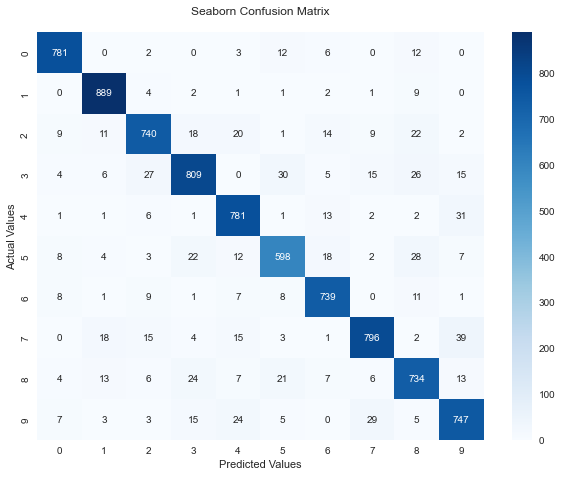

In [216]:
num_layers = 1
num_nodes = 100
epochs = 40
pipelineKeras = run_nn(num_layers, num_nodes, epochs)

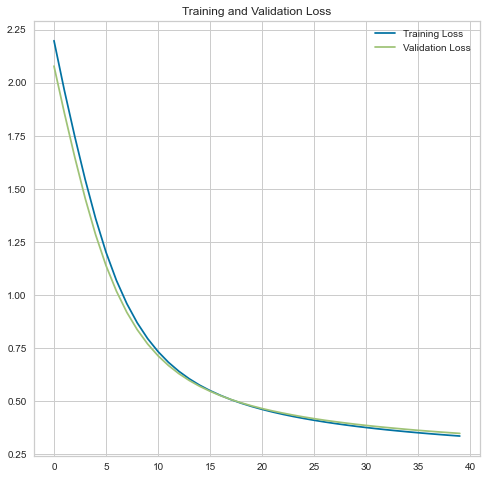

In [217]:
history = pipelineKeras.steps[1][1].history_

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_182 (Dense)           (None, 100)               78500     
                                                                 
 dense_183 (Dense)           (None, 100)               10100     
                                                                 
 dense_184 (Dense)           (None, 10)                1010      
                                                                 
Total params: 89,610
Trainable params: 89,610
Non-trainable params: 0
_________________________________________________________________


/Users/ramundson/.local/share/virtualenvs/ramundson-TB643h2I/lib/python3.8/site-packages/scikeras/wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2022-02-21 14:16:03.189451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-21 14:16:04.852143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Neural Net with layers 2 and nodes 100 fit time: 55.24


2022-02-21 14:16:57.875977: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[8 1 9 ... 3 0 9]
Precision score: 0.91
Recall score: 0.91
Accuracy score: 0.91
F1 score: 0.91


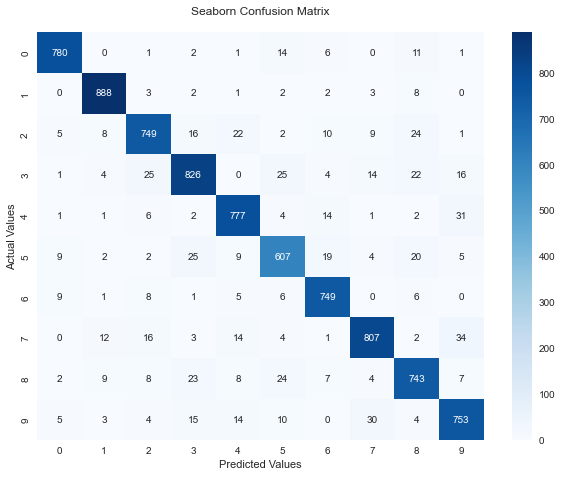

In [219]:
num_layers = 2
num_nodes = 100
epochs = 40 
pipelineKeras = run_nn(num_layers, num_nodes, epochs)

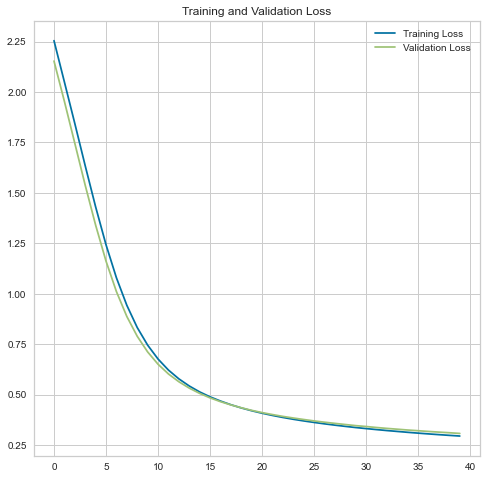

In [220]:
history = pipelineKeras.steps[1][1].history_

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_217 (Dense)           (None, 20)                15700     
                                                                 
 dense_218 (Dense)           (None, 20)                420       
                                                                 
 dense_219 (Dense)           (None, 20)                420       
                                                                 
 dense_220 (Dense)           (None, 20)                420       
                                                                 
 dense_221 (Dense)           (None, 20)                420       
                                                                 
 dense_222 (Dense)           (None, 10)                210       
                                                                 
Total params: 17,590
Trainable params: 17,590
Non-tra

/Users/ramundson/.local/share/virtualenvs/ramundson-TB643h2I/lib/python3.8/site-packages/scikeras/wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2022-02-22 08:13:56.211141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-22 08:13:58.892844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Neural Net with layers 5 and nodes 20 fit time: 480.33


2022-02-22 08:21:53.649677: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[8 1 9 ... 3 0 9]
Precision score: 0.92
Recall score: 0.92
Accuracy score: 0.92
F1 score: 0.92


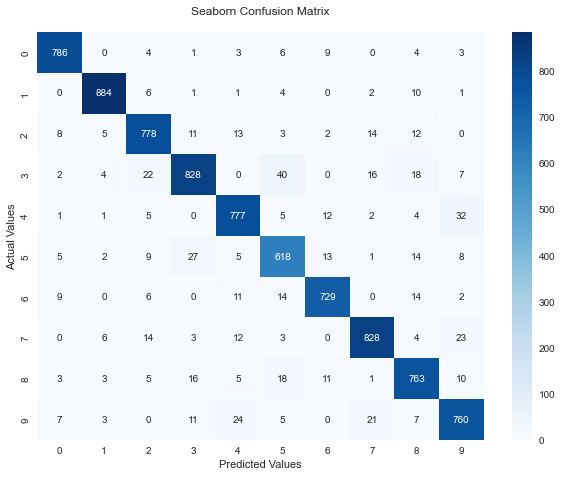

In [234]:
num_layers = 5
num_nodes = 20
epochs = 250 
pipelineKeras = run_nn(num_layers, num_nodes, epochs)

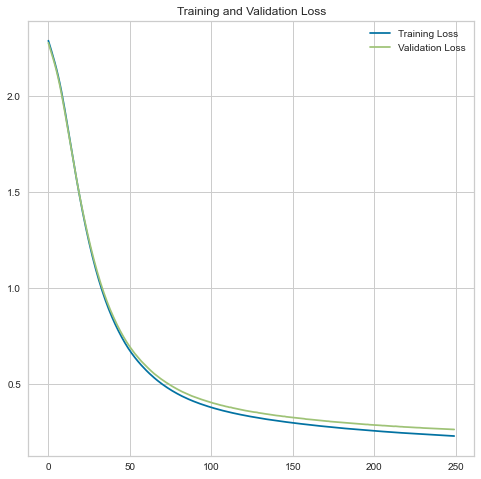

In [235]:
history = pipelineKeras.steps[1][1].history_

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model: "sequential_83"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_197 (Dense)           (None, 300)               235500    
                                                                 
 dense_198 (Dense)           (None, 10)                3010      
                                                                 
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


/Users/ramundson/.local/share/virtualenvs/ramundson-TB643h2I/lib/python3.8/site-packages/scikeras/wrappers.py:289: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  warnings.warn(
2022-02-21 14:37:49.665559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-02-21 14:37:51.139529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Neural Net with layers 1 and nodes 300 fit time: 123.39


2022-02-21 14:39:52.465164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[8 1 9 ... 3 0 9]
Precision score: 0.95
Recall score: 0.95
Accuracy score: 0.95
F1 score: 0.95


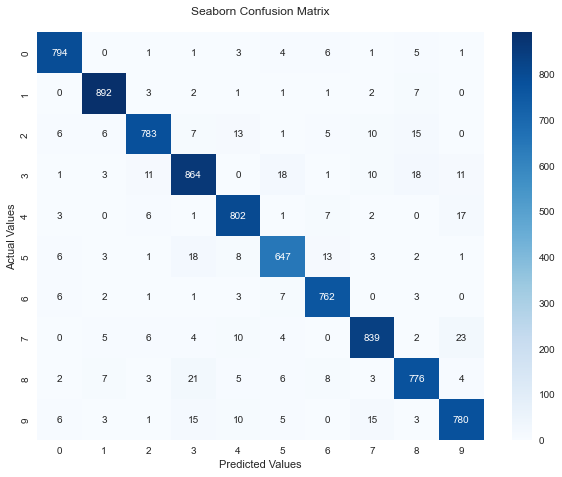

In [225]:
num_layers = 1
num_nodes = 300
epochs = 100 
pipelineKeras = run_nn(num_layers, num_nodes, epochs)

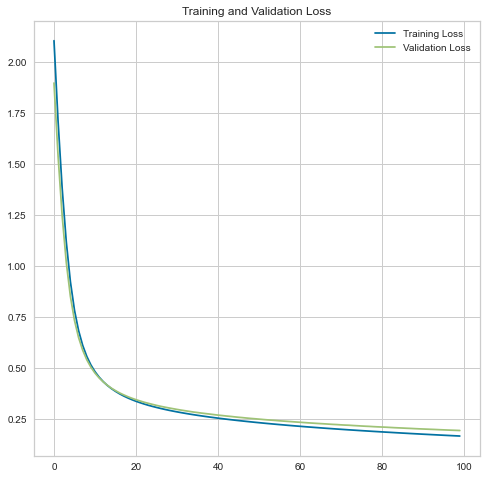

In [226]:
history = pipelineKeras.steps[1][1].history_

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.subplot(1, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [155]:
digitsTestDf = pd.read_csv('digits/digit-recognizer/test.csv')

predictions = pipelineKeras.predict(digitsTestDf)

df = pd.DataFrame(predictions, columns=["Label"])
df.index += 1 

df.to_csv("digits/predictions_nn.csv", index_label="ImageId")

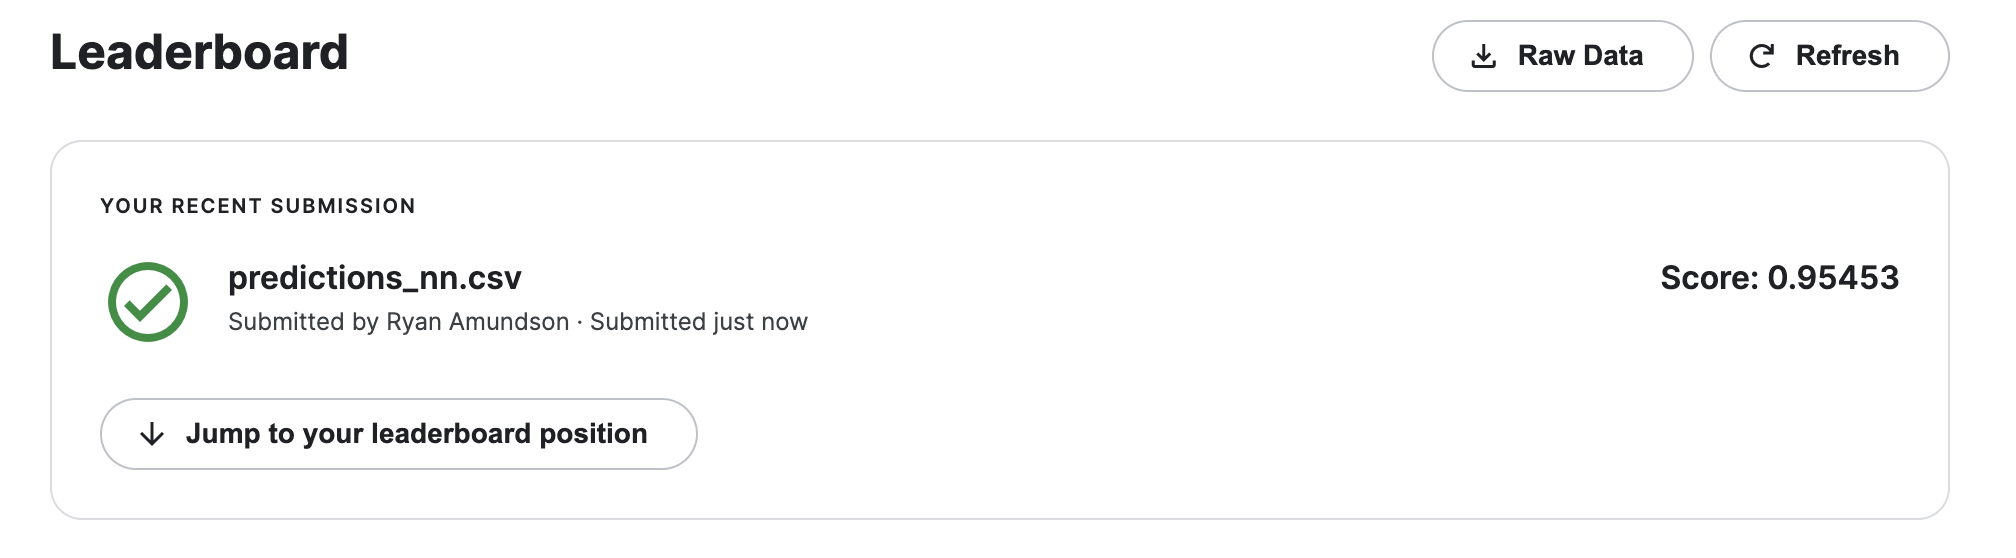

In [156]:
from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAB+AAAAIuCAYAAACPaxGPAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAB+CgAwAEAAAAAQAAAi4AAAAAQVNDSUkAAABTY3JlZW5zaG903l69cAAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NTU4PC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjIwMTY8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4Ke+x8twAAABxpRE9UAAAAAgAAAAAAAAEXAAAAKAAAARcAAAEXAACjUt0s54EAAEAASURBVHgB7N0HeBRV18DxQ0IntNBDryICIqDSfO0g9t6wi713PxV7xy4g9tfe22vvDQEpShfpNYQWWugkfHNGZ5mZzJYku9mZ3f88D+5O2Tv3/qZk3TP33Ao7jUmYEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQKBMAhUIwJfJjw8jgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBgChCA50RAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgDgIE4OOASBEIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggQgOccQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIA4CBODjgEgRCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIEIDnHEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCAOAgTg44BIEQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCBCA5xxAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgDgIE4OOASBEIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggQgOccQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIA4CBODjgEgRCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIEIDnHEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCAOAgTg44BIEQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCBCA5xxAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgDgIE4OOASBEIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggQgOccQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIA4CBODjgEgRCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIEIDnHEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCAOAgTg44BIEQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCBCA5xxAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCITA+g0FssH4t2nTZtm0ebNs3bZNtm3bLoWFhVJUVBSINlBJBBIhkJGRIZmZmVK5ciWpUrmyVK9WTapXryY1a2ZJLeMfU3gB7ivhbVgTDAGuf/8dJwLw/jsm1AgBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDAENi8ZYusWpUv+WvWytp16wmyc1YgUAoBDc7VqV1LsuvWkfr1s6Va1aqlKCV1PsJ9JXWOJS2JLsD1H90oEVsQgE+EKmUigAACCCCAAAIIIIAAAggggAACCCCAAAIIlFogb/kKWbZ8paxdu85RRlaN6maP3hrGqwYRq1apYvb4zcysaPT+zXBsywwC6SRQWFhkZILYYWaE2LJ1q/nwysaNm8yMEQXGq32qU6e2NGnUQBo3amhfnPLvua+k/CFO2wZy/fvv0BOA998xoUYIIIAAAggggAACCCCAAAIIIIAAAggggEDaCWga+cVLcmVJbp5s377dbH+FChWkQf16Ui+7rtF7t7YRbK+cdi40GIGyCmwzhmrIX7NOVuevkZWrVsvOnTvNIitVqiTNchpL82Y5Zvr6su7Hj5/nvuLHo0KdylMgna//8nR274sAvFuEeQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFyFVi4eKksWrREdhhBeJ1q1aopOY0bScMG9enZXq5Hgp2luoD2lF2xcpXk5i2X9es3mM2taIwd36JFM2nZvGlKNZ/7SkodThoTB4F0uv7jwFWmIgjAl4mPDyOAAAIIIIAAAggggAACCCCAAAIIIIAAAgiUVkB75M6dv1A0VbZO2dl1pEXTHKlrjFXNhAACiRVYs2atLFqaK/n5a80d6dAObVu3NDNOJHbPiS2d+0pifSk9NQRS9fr3y9EhAO+XI0E9EEAAAQQQQAABBBBAAAEEEEAAAQQQQACBNBKYPWe+kW5+mdnimllZ0qplM6lfLzuNBGgqAv4QWLU6XxYsXCIbCgrMCjXLaSLt27X2R+VKWAvuKyUEY/O0F0il699PB5MAvJ+OBnVBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRSXKCgYKPMnDU3FOxr06qFtDTSXzMhgEByBRYaw0DMW7DIrIQ+FNOxQ1vJyqqR3ErFuHfuKzFCsRkCYQSCfP2HaVJSFxOATyo/O0cAAQQQQAABBBBAAAEEEEAAAQQQQAABBNJHYOWq1TJj5mwpKioSDfB1aN9GatXMSh8AWoqAzwXWbyiQWbPnmQ/IZGRkSKeO7aVB/Xq+rjX3FV8fHioXIIEgXv9+5SUA79cjQ70QQAABBBBAAAEEEEAAAQQQQAABBBBAAIEUEliamyez5swzW9SkcUOjd227FGodTUEgtQRmzpojy/JWmI3q0K6NNM1p7MsGcl/x5WGhUgEXCMr172dmAvB+PjrUDQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSAGBxUtyZc68BWZLWrVsLq2Nf0wIIOBvgfkLFxtjwy82K9muTStp3izHVxXmvuKrw0FlUkzA79e/37kJwPv9CFE/BBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgwAL2Hqrt2hpBvKb+CuIFmJaqI5BwgcVLjYdn5i4w9+OnnvDcVxJ+6NkBAuLX6z8Ih4YAfBCOEnVEAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQCKKBjM0+b8bdZc4LvATyAVBkBQ8AehOvcabekjwnPfYXTEoHyE/Db9V9+LS/bnlIuAL9ixUr58ssvw6rst99+0qZN67DrWRF/gYWLFslPP/4UtuDuPbpLl86dw64P6opvv/1OcnNzw1b/tNNOlcqVK4ddz4rgCKTrOR6cI0RNEUAAAQQQQAABBBBAAAEEEEAgGQIFBRtl4qSpUlRUJKSdT8YRYJ8IxE/ASkedkZEhPbp1kaysGvErvAQlcV8pARabIhAnAb9c/3FqTrkUk3IB+MmTp8ixx50QFu+IIw6XYU8/GXY9K+Iv8P33P8jgCy4KW/Btt90i5593btj1QV1x/vkXyA8RHjyYPGmi1KpVK6jNo942gXQ9x20EvEUAAQQQQAABBBBAAAEEEEAAAQSKCUz4Y4psKCiQJo0bSscO7YqtZwECCARLYOasObIsb4XUzMqSnt27JqXy3FeSws5OERA/XP9BOgxpF4A//PCBMnzYU0E6RoGva7oGJwnAB/7UjbkB6XqOxwzEhggggAACCCCAAAIIIIAAAgggkHYCs+fMlyW5y5IaqEs7dBqMQDkIWAHwZjlNpH278s02zH2lHA4wu0AggkAyr/8I1fLlKgLwvjwsqVWpdA1OEoBPrfM4UmvS9RyPZMI6BBBAAAEEEEAAAQQQQAABBBBIX4HV+WtkyrS/TIAee3WVWjWz0heDliOQYgLrNxTIxD+nmK3q2nl3qZddt1xayH2lXJjZCQIRBZJ1/UeslE9XEoD36YFJpWqla3CSAHwqncWR25Ku53hkFdYigAACCCCAAAIIIIAAAggggEC6CoybOEk2btwkbVq1kJYtmqUrA+1GIGUFFi5aIvMWLJIaNarLPj26lUs7ua+UCzM7QSCqQDKu/6iV8uEGBOB9eFBSrUrpGpwkAJ9qZ3L49qTrOR5ehDUIIIAAAggggAACCCCAAAIIIJCuAgsXL5V58xeSej5dTwDanTYCVirqNq1bSsvmTRPabu4rCeWlcARKLFCe13+JK+eTDxCA98mBSOVqpGtwkgB8Kp/Vzral6znuVGAOAQQQQAABBBBAAAEEEEAAAQTSXaCwsFBGj50gO4zXLnt0lPr1stOdhPYjkLICq1bny9TpM6ViZqb06dVTMo3XREzcVxKhSpkIlE2gvK7/stUyuZ8mAJ9c/7TYe7oGJwnAp8XpbTYyXc/x9DnCtBQBBBBAAAEEEEAAAQQQQAABBGIRWLBwscw3/mVn15E9O3eK5SNsgwACARaYPG2G5OevldYtm0sr418iJu4riVClTATKLlAe13/Za5m8EgjAl6N9QUGB+RRYtWrVymWvGzdulIyMDEn0/nbs2CFbt241xnup4dmu8ghOlret1VB9+m7NmjVSpUoVycrKkgoVKlirpLQB+J07d8qGDRukZs2ajvJCBcf5je6ratWqUqlSpTiX7F2cni96bmr79Pwsz0nbqvvXc7Vy5cox79oP53jMlWVDBBBAAAEEEEAAAQQQQAABBBBAIEkCo8aMl+3bt0u3Lp2kbt06SaoFu0UAgfISWLNmrUyaOsP8bblf770TslvuKwlhpVAEyixQHtd/mSuZxAIIwCcIPz8/Xz748CP5/fdxsmjRIpk9e45jT61bt5Y+fXpJ3z595IAD9i9zkHz69Bny22+j5eeff5G/Z82S1atXh/anwca2bdtKy5YtZLfdOsiJJ5wgjRo1DK0v6Rv9Ev3VV1/Lxx9/InPmzjXat9gsonHjxtKjR3fZc8+u0r//odKyRQtzebwD8ImyXbp0qdx1973m/yR4mdx5xxDDsKX5sME7774nr7/+RrHjOmP6lNCxLEkAfsKECcbxGyOTJk+W8eMnmAFqrUP79u2kc+fOcvppp0jPnj29qlWiZQsXLjTPy6lTp8nChYtk/vz5oc/Xq1dPWrdqJc1bNJfDBx5mnpcVK1YMrS/NGw14/zZ6jIwaNUpGjx4rK1asCLVNy2th7KtNmzbSrGlTOfCgA2X//+wXc6qi559/QUaPGetZrb26dZMrr7zcXDdz5kwZNvwZ+emnnx37vuGG6+TSSy72/Hyyz3HPSrEQAQQQQAABBBBAAAEEEEAAAQQQ8LFA3vIV8tffc6RWrZrSo1sXH9eUqiGAQDwFJk6aKuvXb5Ddd2snjcsQd/CqE/cVLxWWIeAfgURe//5pZelqQgC+dG5hPzVv3nwZ8cxI+eCDD8Nu416hgc8rLr9UTjvt1BL1ytVypkyZIkMfecwIcP7mLjbi/IknHi/nnH227LFHyVJBadD93vsecAT4w+1oxIhhMvCwARKvAHyibT/77HO54sqrwzVHPv3fx9KgQQM5+ZRTQw8duDeePm2yVK9e3VwcSwBeH454/PEnZfiIZ9xFFZvv3HkPeeD++4yA/B7F1kVbMHrMGHnmmWdLdJ7oeXnWmWfIBRecH3qoINp+rPWbN2+WV199XZ4eNtwR9LbWh3vVgPzFF10oxxxzjOEYOVPE/gccFPY4HHroIfLcs8+IBunvf+Ahz91dduklcv311xZbl8xzvFhlWIAAAggggAACCCCAAAIIIIAAAggERODPKdNl7dp10rFDO2nSuPSdf5LVXM10WVRUZO5eO6XYM10mq07sF4EgCCzLWyEzZ82ROnVqy15dS/7bdaQ2Bv2+om3TjLfR7ie6jWZh1UmzxmZmZprv+Q8CfhdI5PXv97ZHqx8B+GhCJVj/w48/mWnHS/ARx6Y9e/SQ4cOfloYNGziWh5sZOfI5eejhoeFWx7T87rvvlDPPGBR1W/3y+fgTT8qwYSOibmvf4JqrrzKD/IMvuMi+2PH+tttukfPPO9exzD1THrbRAvBvvfm63H7HncV6vdvrWpIA/PhxY+Saa68vUVBc9/XC88/KwQcfZN9t2Pd63IYbvb8fe/yJsNtEW9GxY0d5duQIs7d6tG11vWYSOPOscx2962P5nH0bzRDxwfvvRkxVFi0A3//QQ+WGG2+yF+t47w7AJ/scd1SOGQQQQAABBBBAAAEEEEAAAQQQQCBAApu3bJGx4/4wg0z79dnXCB6V77CD8aA66+xz5ddfR5lF6e9S3bvvFY9iy1TGciOrwMSJE6OWocNjVq1WVRo1bGT+hleSoRejFp7kDXToU+3gFW7SwKZ2iKpVq5ZkZ9eV5s2bl/uwl+Hqli7LCwuL5NfRv5uB5l77dJdqxnCn8ZiCel+ZMeMv+fqbb8zf/XNzc2XlylXmOdqkSRMjU3EbOeLwgXKQkQ3WPnTw2LG/y2mnn2Gy6b1H70GJmvx6X1m3bp1xv/tDJhudTufOnWdcy81E4wS7795RuhhZgoMwacfEH404oTVlGA9SHDagvzWbkq+Juv5TAYsAfJyO4nPPvSAPPOjd07Yku9Bex59/9r+oKeI18K4B+HhMI58ZLgOi3ATuM3q9v/DiS6XanQbXX3zp5bCfjRaALy/baAH4I444XD7//Iuw7dAVJQnADz7/vFKbxhKE1y+n2qP/22+/i1jnWFZqT/2XX3pB9t47chp8TXF/womnxJQhIdp+99qrm7zx+quOLyL2z0QKwPfr11f+/HNSxN737gB8Ms9xe7t4jwACCCCAAAIIIIAAAggggAACCARNYPGSXJkzb4E0bFBf9ti9Q9Cqb9bXjwH4L7/8Si697IoSe54x6HS5+uorRX9rDvqknX367XdAzM3QNl8w+Hw508jsGS3DZsyFhtlQh7zUzk/vvfd2mC3SZ/H0v2bJCiPQ3K6NMcRps5y4NDxo9xUdFnjIkDvkS2P43miT/t5+5RWXy3nnnSOacaM8A/B+vK8sWLDAeADhTMnLyytGp50RNR4ShEnbceBBhzqqOn/ebMd8Ks4k4vpPBScC8HE4ivpkpH5Bi9ekgce333ojbDp6Hev9jDPPjtfuzHLef/8d6dG9u2eZE4ynLE866VTPdfFYGCkAX5620QLwsbS1JAH4WMoLt41+kfz+u6+ldu3a4TYxsyPE6yEN3Yl+Kfj5p+/DfnHXNF36lJ6OYR+vSVPJa+97rxQ9kQLwsezfHoBP5jkeS13ZBgEEEEAAAQQQQAABBBBAAAEEEPCzwOSpMyR/zVpjDOj2xhjQsWX39Ft7UikAr7Y61OPHH31gZJis6zfqEtWnpAF4q3DN6vniC89KTk58gsFWufqqQbZ77rlPNGurTukQYDMbGuE/ectXyl9/z5bsunVkzy4lG/Y2XLFBuq98+ulncsedd8uaNWvCNcdzeYf27eXZZ0cYgefl5dYDvrQBeG1Aou4r/QcMDJt5+OqrrpSrrir5g0ie4AlemK4B+ERc/wk+VOVSPAH4MjKvMb5YHtr/sLj0+LVX5YYbrpNLL7nYvsh8r0FOfeLP60kg98Z6M9y2bXtM2/7nP/vJK/8t3sNde1EPPPyoMqUTd9fLPR8uAF/etkEKwKvhqaeeYowJf6+b05z//fdxcupp0YcW8PxwhIWRAuLvv/9hxJTvVrEayG/YsGHM59SHH7wn+lCKe4pXAD6Z57i7TcwjgAACCCCAAAIIIIAAAggggAACQRT4edRYc/z0vr16hu1U5Pd2pVoAXr1PPPF4Gfpw2bO2JvPYlTYAr3XWIV/fffctz849pW2TpsY+5NABjo8TgBcjDrFNfhs7wUz/v3+/Xg6f0s4E4b6i8Zqrrr7WkTlXx3Af0P9Q8zftLl26mEP0btq0WRYtWiS/jxsnb7zxliNmU79+fbn8skvkzrvuMakSnYK+LAF4rWC87ysaB+reY2/HadK4cWPp16+P8UDDWjNLQJ/evR3r/TqTrgH4RFz/fj3GJakXAfiSaHlse8utQ+SttyKnmNGUPwccsL/07NnD/EM0wRjH4oMPPow4do0GKceOGSVZWVmOvY4ZM1ZOH3SmY5l75s47hhg91k8KpdjRYP29Rgr5aOnTdUxyvdnbp6+//kYuvuQy+yLP9zoWh44ln5PTRNauXSsffPhRzD2hwwXgy9u2NAF4fchBxxeaP3+B6fLHxHGh/8k4//wLQk9BeqLZFuofrb59+pifnTV7trzwwksR06dbH50wfmyxHumxPqShadq1F7geu40bN8r3P/wgTz75dNT9jhgxTAYe5vySqfU5+ZTTIh5zTV8/ZMitofFadMz1r4x0PDfe9H8R96lDGOg54p5KE4Dv3HkPWb9+vfFlZ7HcPuQ2OffcsyWZ57i7TcwjgAACCCCAAAIIIIAAAggggAACQRNYv6FAJv45RbJqVJe9exTvRBGU9gQlAK+/zWUaAb6dO3fKTgN3p/Eb28aNm4zfYz8001i7vfX3yiD3gvcKwF9//bXSrm1b0d9Bt23fLvmr883f2kePGeNuvvF75+Ny9FFHFlte2gVTp02To48+zvFxAvD/cIyfOEkKjHOxx15dpVZNZ1zDARbDTFDuK5py/vU33gy1qFmzpvLoI0Nln32cAeXQBsYbPW/fevsdM4uCBi510qC9/l6uUzIC8Mm8r3gFrb/68jPZbbfdTI8g/cerLelyf4jn9R+kYx6prgTgI+lEWadPLe3RuWvEre69524ZNOi0YtvoTfaGG2+Wjz76uNg6a8Hdd99pBrWteX3Vp6BeeeVV+yLH+3A95/VGfuRRx4RN46GFePU0vuba6+Xjjz9x7MM9c+yxx8gjQx+SzMxMxypNf65j1UebvALwybCNNQCv6d/vMY5ND+MJyoYN/0mppV94N2/ebDz0UD3U3FgD8DpGkD6NaZ/Wrl0nxxx7nBkoti93v3/44QflpBNPcCy2jxfjWGGbOeboo+SJJx6zLfnn7bRp0+Woo48ttty+4KADD5AXX3zevkhWrFgp+/bq41hmn1Gzb77+QrKzs+2LzffR3MNlZ4g1AK8PhugDDp06dTLH09Gd6vlVtWoV84tNss7xYhAsQAABBBBAAAEEEEAAAQQQQAABBAIosDQ3T2bNmSdNGjeUjh3aBbAF/1Q5KAH4uXP+Nn/T8oLWFNivvvqaY1WkoUd1ww0bNkh+fr5UqVLV7GiU6HHTHZWLYcYrAP/Jxx9I167Ff5f3ygqqv0vqsJra4S3cpL/rrjaC+DrVrl3L7BTnNSSmri9tAL4k+9D9BHGaOWuOLMtbIR3atZGmOY3L1IQg3Fe0w+PlV1wVaueRRx4hDz5wX8RzLbSx8UbPpcGDLzR/W7cvT0YAPt73lR07dkhu7jJp1KihcW+pYm9esfczZ840szDbV0Sqj307jbNpB9QmTZqEvS/q9ps2bTLuc2uM7RoXi2PZy/N6b90jq1atZtwja0q1atW8NjOXRQvA631A77fR6ht2Bz5eEc/r38fNLFHVCMCXiMu5cbTA4U033iAXX3yh80O2Ob056FjuGjD1mg4++CB54flnHau0d/QCo7e1jiWy2rhQ1xg3DX1dvXq11K1TRx59dGjYG4gGwyONCT7ymeEyYED/0P62bNkiu3fqEpr3eqNfYH74/hvzy5l7vbbvrLPOFa8nD+3begXgk2EbbZ9aZ0198s7bb5pjndjb4PU+lgD8ddddY6SXudTr4/Lnn5Pk+BNO8lxnLfQKhkfLHKBfNn/5+QfPYLiWO3ToozLimZHWLjxf3T3v9Q/HhAkTzXNxnZEBQc9J/UOyatVq8/WqK6+Qvn29A/T6x2+Pznt67kcXtm/fzgjef1lsfSwBeB0bRseICTcl8xwPVyeWI4AAAggggAACCCCAAAIIIIAAAkESmD1nviwxAi3t2raS5k1zglR1R11TIQCvv8MOGnSWo13PPzdSDjnkYMeyiX/8IS+//IpnxlT9vff4446Va665KhRo+p8xvvWwYcNDZRx++MBiv7ndd98D8vMvv4S2GXT6aXL22c66XG2k6p7x11+hbe4wMrlqVtBIU0kC8FrOiy+9LPfee7+jyIceekBOPulEx7IlS5aaDyu8aWS31eyg7umIIw6Xm2+6UbRHszVpxyX9vdM9PKz+fqnTKaecLJrN05pKsw/rs0F8Xbw0V+bMXSDNjCy57du1LlMT/H5f0QDzwYf0D3Wg097a//vkw1B23FgbP2HiRDnt1EGyw4ilWJPfAvCx3le0B/9rr70uH370iUyZMsVqjvn7fm8jhbz+Tl+3bp3Q8vHjJ8ittw0xHgIqCHtNdejQQYY9/aTZKfWNN98KfVY7vmpc7bnnXzCvX71v6fC5N990g/EQTW1zu4KCAqMT4lNmluL58+eHPqudITX2dsEF54eNpelxGT78GTPjr/v+oOnwjz7mKDnqyCNDWaitwsMF4N82Mh689fa7IReN0WjG4P+7+UbRNqbCFM/rPxU8tA0E4MtwJC+86BL59tvvwpYw6c8JoYs93Eavvf6G3H77neFWy6y/Z0ilSpXCro91hfbQPvqY40R7OIeb3Ol49IvYiSeeEm5zc/kbb7wqkcbfWLZsmRzaf6DnlxirYK8AfDJsYwnAf//dN9KmTWxfHqIF4HVc8/fefTvsTV59Hn/iSXnqqWEWlefrnNkzQ2XoH/5ue/WM6P30U0+IPo0XbtJg+mEDjwh9efDaTsee1zHo4zH98ONPolbhJn3oYczoX4utjhaA18wMjz/2SLHP2Rck8xy314P3CCCAAAIIIIAAAggggAACCCCAQFAFJk+dIfnGOL1d9ugo9esVz34YlHalQgD+/fc/NLKu3uQg//KLT6Vjx46hZZ8awfQrr7omNB/ujf52qZ3DNKPl9OkzzOyq1rYa7NIOOtakgbeue3Z3/CapQS7N/GlNmvFzr+49rVnzddzvo6VBgwaOZe6Zkgbgtxsp6ffqvrejLhp81yC8NWknt+OPP8mxjbXO/qrtfPnlF0JDarZu096+utj7Cy8cbATU/vEv7T6KFRqgBauMLAJTp8+UbCPIumeXTmWqud/vK/ZrTeM3Gny3X2dejX/n3fdE4yXu6euvvxXtBW5NfgvA29tq1dF9X1m5cqVce90NMmrUb9YmxV71ehox/OlQev7vv/9BBl9wUbHt7AvUVPfl7lyqGTDsQX79jAa1J0+aaMZKdN0VV14dMcah96gnnnhUmjbd9ZCNlhNLTEa308/r/cE+jLRXAF6z86phuOnVV16W/fbrF251YJbH8/oPTKOjVJQAfBSgSKujBQBff+2VSB831+mXlwcefCjsdiUJ+NoLWbdunSxfsUL0KbsJxpNEn3/xRcSbjX7WHYD/yhj//ZII47+7v2jZ929/rzdRvZmGm7wC8MmwjRaA1/Hef/4pfDvc7YsWgL/rztuNDAFnuj/mmPe6YTs2MGbs4zjl5uZK3377uzdxzP89c3rUJ/Hcf9AcBRgzg88/T2699f/ci6PO6wMC+sc41/iiMXfuPPnuu+8jPsSiBZY2AD982FOiT+NGmpJ5jkeqF+sQQAABBBBAAAEEEEAAAQQQQACBoAiMM8Z91jHI9+6+pxGICJ/m20/t2bp1q/z88y/Sv/+hoWqFC8CvWrXKHNazd+9eoW3L682XX34ll152hWN3XqmZNeisvUF1qEXNlGqfZkyfEurJrr8V7/efA+yrI77X3tz626127urT9z+OXqpfG8NNdmj/T0DaK4W0Fjx92uTQkJ1ffPGlXHb5rkyV2vvz3Xd29WgNV5GSBuC1nIuN37S/Nn7btiYriKfzmrVVO4zZe8Ra23m92rNzxhqAL8s+vOoQlGUFBRtl/B+TjUBoddmnR7cyVdvv9xV7zOOySy+R66+/Nmp7TzjxZPnjjz+jbueXAHys9xVt0NnnnCe//FK8E51XY8eO+c1MTV+WALxXuVbMYv369eb9yt1z3eszem/4/LNPQunrtVf+yacUH1La67O67LzzzpEht90aWh1LPCe08b9v9B7z9VdfSLhhL9zb+3U+nte/X9tY0noRgC+p2L/b65eONm0TnxrCa1x2e5W1HpMmTTbHC5k582/zaUT3kz/27SO9dwfg33zzbTMFSLjPhBub2739ww8/Is+MdKbSt2/jDsAnyzZaAF6D5Ro0j3WKFoCP5ckmDVi377B7xF1++81X0q5dW3ObyZOnyLHHOceEt3841ocI3nv/A7nxxpvtH3W81xRMmvol0rTGePJ5jJH26u9Zs+Svv2bK1KnTHF/SI33Wvq60AXjrD7m9LPf7ZJ3j7nowjwACCCCAAAIIIIAAAggggAACCARVYNSY8aKBmr69ekbt9OGHNmrwXbNvarDI/rukVwB+xYqVcvqgM2Tx4iXy3LPPyP77/6dcm+AVgNffyqxJ3XWIxXCBphtuuE4uveRia/NivUi1g9U9d98pnTrtbo6PfOdd9zh6ldoD1/ff/6A8/8KLobI06KTBJ5103Hkdf949aQc1a1hK7Zlv7wV61113yFlnnuH+SLH50gTgNQW9pqK3JntHsp9++lnOPW+wtcp81br06rWvGE8ayIsvvizvvve+Y72V6fbpp4fLosWLHO3QDXUYTJ16dO9u9mQtyz7MggL6n23btslvYyeYGX379d67TK3w831FrzvN+KDXnk5vvvGaxPKAjp8D8GW5r3gF0q+44jI50oghrDQeYLrLuK/Mnj0ndD7o0BR3GsNPLFy0yOjd/pUsM8Zw13uIfdLhnXWqX7++kaX5+GL3Lmvbzp33kB07Cs0MAp98/IFoz3j3vUp7xt95x+2iWT2mTp0qtw25w3HPHDFimAw8bIBZ5F133yP//e+rVvFyzjlnyQ3XX288xFTVeGhngRHnGlns+p8y+Q+pWbOm+ZlwAXjNJnzsMUebgf6nnh5WLFPAV19+JjqMQZCneF7/QXaw150AvF2jBO81uNi9R9n+iMSyuxdffF50nG/3pDf3zz77wvwiYU9P4t6uJPPuALymPtd0G+Em6wnIcOut5V4pSqx1+mr/oqvzybKNFoDXcUUGDYr96adoAfhffv5Rmjdvpk2OOPUfMNDxB8q9sT4pqk+M6qRDIuj/QISbdBwU/Z+FaNOECRPkpJPDt9WdQspenqZXeu3V1+X1N960Ly71+9IE4PWP6rSpk6LuM1nneNSKsQECCCCAAAIIIIAAAggggAACCCAQEIGfR40VTUH+n769jNS/Gb6v9SOPPCbDR+z6fUzH+b7oogvEHYDPycmR004/QzSgopP+3vTrLz85xjA2VyTwP14B+Fh3d8ag083fXatUqRL6iPbuHG/87jdjxl9mdkodL9n+UIG7l7o9cO3uGdqvX1/jN8D/mmXbewOHdma80SDctddcbfY637NbD0fQa9SvPxVL/Wz/rPW+NAH4xx5/QjRYbp/mz5ttzs6bN98Ifo0yDabPmCGHGYE37cFsTcuXr5Bevftas+arZkXVjk06TZ02TY4++jjzvfUfq2xrvqz7sMoJ2mthYZH88ttYM8i4f79eZaq+n+8r9nNSey1r2nMrABup0doZTDPYRpv03nP66adG26zU6+N9Xznm2BMcD+5cMPh8ueWWm0P188qQYe8857XefU15Zey9/PJL5bpr/xlOY9GixWasZcOGDaL3GvukQ2nomO/W9KoxTv0dd9xlzZpj1H/z9Zfm/KWXXi5ffvV1aN0xRx8l+iCTlaZeh+998KGh5r52N3rPtzeygDRs2CC0vVcAXrP0amdGq4e7Zq/WYYTtU7g4oH0bv7+P5/Xv97bGWj8C8LFKubbT9NmHHDrAtTT+s089+bgcddSRjoL1S4D2cs4zngyK5+QOwN9z733y0kv/DbsLfUpJn1aKNo0ZM9Z4UjR8qnV3AD5ZttEC8Pfde0+J/vBFC8Dbx26PZBjuC6z1GQ2oa2Bdp3feeVdu/r9dKU+sbazXWB+asH+JsD5rfw3Xk14zHWjGg3hOiQzAJ+scj6cPZSGAAAIIIIAAAggggAACCCCAAALJFPjxl9Hm7g/8T59kViPmfWsA5fzBFxqZG3eNYa7po3//fZz8+usos5ynn3pCNFCvPTR10jGedbhD6zc4c2E5/Kc0gTLtODNkyC1mT9BYqqjZSLWH/+TJk+XTzz53DBdp7+SiadXdQXTtAFO5cmXpsJv3eN/a41QzvP755yQ5/oSTQtXRXqraWzWWyet3Squna7jPDx36qIx4ZmRotb0doYWuN/n5+UYQcar8ZAxN8Moru3rA6mb28a5jCcC7ig7NxrqP0AcC+CZe94N4lZMIQk0jr73ZdWrdurX88P2u4Q4Ssb94lxnP+4o+fNW23W6OKnr15j7o4P6OYR/s2TFKG4C39zy3KqA93I8+5nhr1nxwyt1Rz+shG2uojmHDR8ijjz4e+rz1RtPE/2e//YzU9n2k1777GkNrVLNWOV69AvD/++RD6dKli2M7t8eI4U/LwIGHObYJ4oyfr9tkeBKAL6W61x/+UhYV8WPuALw+HXPSyadG7BEdscAIK90BePfToO6PWk8wupe7591PTrrXuwPwybIt7wD8uN9HS4MGu56OcrtY8+4nyKzl1qv9j9X/Pv3MSHn0z1Nf1nr76wknHC+PDH3IvsjzvaaMP/yIozzX6UL9g2M9FWZt9M6778nNN99izcbtNZEB+GSd43HDoSAEEEAAAQQQQAABBBBAAAEEEEAgyQJB/MFdg/CDB18ko43hE62pWrVqost1sr/X4PszRopiew9K6zOJfvUKlJ180omyYuVKI+Xy38U6aGkw8M03XhX9PS3SpAGor7/5RkaPHmOmQg6Xwt4duL7l1iHy1ltvh4p+8YXnpHad2kaK6FNCy7TjjvZGtSYNkr388iuOTKv/d/NNcuGFzjTw1vbuV6/fiqMF4DUdvj2ltVc2z02bNommzv7l119l3Ljxjjq761DaAHxp9+Hef5Dm43U/iFc5ibBLxQB8ae8reXnLpXeffg5mvQdUr17DscydxfmxR4fKcccda25TmgB8uId4vGI8OpSGe3LXx8pyES0uYpWjD2Np5ow99+xqLTJfvQLwXg8KuGM+7jigo9AAzfj5uk0GIwH4UqprCvjdOzmfWnEX1ad3b/eiEs9fetnF0rfPrqdHo/Wqdu9Aby6dO3eSbnt2k+UrlhdLvWPf3h2A1y9Gd99zr30Tx/sBA/rLyGecqXwcG/w7o+l+NO1PuMkdgE+WrdfN2V7nePeAt6eOt+/H/l6fQG3TtoN9UbH3X3z+qey++z9/RKJlGwj3h8ldqNeXe/s2OiyCpkWxJvdTrNbycK+avqpLl86yR6dO0rNnD7n8iqscKajsn0tkAD5Z57i9fbxHAAEEEEAAAQQQQAABBBBAAAEEgizg51TRkVz1N0jNPPnbb//04PfaVnt3P2P8/uk1RKjX9vFe5vUb3dw5f5spvrVH+vDhzzgC27p/DZq/9eZrxXpcWnXTYSOHGGMgxzK5A/Dusc3PPGOQNGrcyMwWYJWnvxdffMll1qy8/NIL8uhjj8u0adNDy77/7htp06Z1aD7Sm9IE4AcNOsvxcIWOIT304V2dkib+8YeR2fW8sL9Huuvz9ddfSAcj1bROsfaAL8s+3PsPynw8U1D7+b5iPyc1rbgGWLOysoJymCSe9xU9z+0P4MSKcOON18slF19kbl6aAPwRxvjymtbdPY0c+Zw5Xrx7ebT5999/R3p0725u9tXX38gltntYpM/a0+Drdl4BeK9MyCeddKpMmDgxVHQqBODjef2HYAL+hgB8GQ5g5y7dwv6R7tx5D/n0fx+XofTiH9UnMDvt4Xyixr2VPl10ztlnS+/e+5rjT2RmZoY2+fiT/8k111wXmne/cQfgPzV6U18ZoTd1rOlVtAwtK9zkDsDrduVtq/ss7wD8gw/eL6ecvCv1ktbBPekwA7377Ode7JgfM3qU8VRrI3NZLOn7582dFRpvxFGQbUbHwdLe4eGm0047Ve6/757Q6mhjqeuG2tZDDjnYCLj3lDrGk7H2SdsYbkiFRAbgk3mO29vPewQQQAABBBBAAAEEEEAAAQQQQCCoAqPGjJft27dL3149zXTkQWrH1q1b5YILLw6lnrfXXYPvI0cOlwMPOMC+uFzfRwqUWRW58657iqVM184vmga6fv361mbmq3vsY12oQfb/7NdP9t13H2Ms44Zy6WVXhD7jDsC7O07pfjSQruPD66S/iWvKeXtKeh1e1f7bcKy/KVuVsAc7rWWResB7ja+sYzhfesnF5scnT55iDu9qlWW9ame63r17Sfceexm98y9x/O7/7TdfSbt2bc1NYwnAl3UfVp2C9rpt2zb5bewEc8iGfr33LlP1/Xxf2bFjh3Tpupfo9aDTW2++Lr167Vum9pbnh+N5X5k1e7YMGHC4o/p6jVesuCsu5Vj578wpp5wsOlyuTqUJwLsfqvm3WHnzzbfl1tuGWLPmq2bzjTZp58u99941Lrtm8fjoo4/lw48+ipgdQ8t97723RbNs6OQVgHePZ6/bpWIAPp7XvxqlwkQAvgxHceDhR5k3h3BFWONGhFtf0uXRehkPPGyADDXSi+sXI68p2vjc7gC8Pv15xplnexUVWvbbqJ8lJycnNO9+o3+EDjzo0LDBVd3eKwBf3rZaj/IOwB977DHy+GORx0uPllJe6z3zr2lSpUoVfSvr1683x2IyZ8L8x/7EZphNJFqmhWuvuVp0CAJrOvuc8+SXX361Zou9vvrKy7Kf8UXea9L/0em4e2evVeayRAbgk3mOh20wKxBAAAEEEEAAAQQQQAABBBBAAIEACYybOMkIVm6SvbvvafQC9f5d0s/N0d+mLrr4UvnZGPvbmvS3tmdHjpD99/+PtSgpr7EEyvT316OPOa7YkKX6W/EII3W+feo/YKBjO00B/cD994Z+W5wzZ64c2v+w0EfcAXhdEamzlQa5NditmQU0vbvXdM3VV8mVV17utcpzWUkD8A89PNR4cOI5R1naC/+AA/Y3l9177/3y4ksvh9ZrsPB9I4CWnZ0dWubuHGbvsR9LAL6s+whVJGBvCgo2yvg/JhvxieqyT49uZaq93+8rF150iXz77XdmG2MdqrdMIHH8cDzvKzp8hV4v9slK525fFul9aQLwgwadJvfec3exYvU+fs6554eW60NCE8aPDc2X5I0+WKZDkCxcuFAmTvxDxowda2QP+NrxcI6Wd/3115rp6PV9Ogfg43n9q2UqTATgy3AUH3jwIXnuuRfClvDfl1+M+iVt1apV8tHHn0itmjWlpvGvdu3axmuW8WW1ptSqVVPq1q0rVi92HbdGx68JN9m/CHht436qxr2NOwCfn58vPXpGfnKrX7++8sp/XzLTHrnL0/loRrqNVwA+2ufibav1KO8AvO5T07iHS2G1evVq2f+Ag4vd0PVz1qRDDOgYRPYp2nHWJ7nefuuNsMfshx9+lPMHX2gvsth7fZJ1r73++cOq6a727NYjbD2POfooeeKJ8L3pdawtTQsVbkpkAD6Z53i49rIcAQQQQAABBBBAAAEEEEAAAQQQCJLA5KkzJH/NWumyR0epX29XENMPbVi4aJHZi1Hr0qxpMyNV8vGe1dKeexqE1xTrGnx//rmRYTuTLFmyVN7/4AOznCZNmkTNcOm5wxgXxhIo06KmT58hRx51TLFSRwx/WgYO/Cegrr819ty7l2Obzz79RPbYo1Nombv3qFcA/osvvpTLLr8y9Bn7m9dfe0X69u0jXj3tre3c+7SWh3uNNQCv2WPfffc90YwA9kkzxv7w/beh39jdDyHceccQIx39rt8mvXr02nvAe1m7e7iWdR/2+gfp/arV+TJ1+kzJrltH9uyy67wqTRv8fF/R9mjv6Guvu8Fsmt4zdJjYWIdVKI1HPD8Tz/uK1kvvK3p/sSZ7QFqXaVaKk04+VWrXqi0dO+4m7Tu0l4MPOlCaNm1qfqQ0AfhzzjlL7rjd2dNdC9N7/gFGTMU+vffuW2ZWXmuZps2/9trrpVWrVrJbhw5mfY44/HAjo8Fm8+GduXPnyoy/ZpqdSu2p6fXzep8566xzHenjzxh0utxzz11m8ekcgI/n9W8dq6C/EoAvwxGcOnWq8XSh95c2LVa/oHz4wbvSwbiIw036ZUW/tISb7EF195Nz7s/M+nuG+USOe7nO61M6Bxx4iNeq0DJ3AF5XnHb6GTJ27O+hbbze3HXXHXLWmWcUW6Wf089Hm7wC8OVtq3VMRgBen8D6xhhDyP6EpeWlYyV9bYw3Emly/zHTbd9662255dbif3zs5dx9952iYzS5J+1Bf9DB/R1/MN3b6JfWn378PpTGPloQ+6qrrpCrr/L+Uq5l33zzLfKO8eU43JTIALzuM1nneLj2shwBBBBAAAEEEEAAAQQQQAABBBAIksDsOfNlSe4yade2lTRvGj5TZjLaNGrUb3LmWeeYu9YU0ZoqOtykQfhrjKDM6cbQixpEDjf9/vs4OfW0f35X0zGDNUCTqCnWQJnu32uISP3t8fvvvjY7fXmlZr/wwsFyw/XXmb/zqZW956jVJndwOVIGzunTpkj16tXEK4it5envfKN/+yX0u6K1j0ivXgF47WDUoEED82PaS3XDhg0ydeo0zw5Cw4c9JYcfPjC0i6OOPtYxHr2W9cLzzxqd4WqZ2W6vufaGYllvdahZTa+vk1fbNPjWoH59qWQMW6Cdrcq6j1BlA/Zm8dJcmTN3gTTLaSLt27UuU+39fF/RhmmntEMOPUw04KqTdlZ77923Qw96mAt9+p943le0ic8//4Lc/8BDjtY++sjDcswxR8vatWvlwYceNu6THzrW2+NepQnAn3feOTLktlsdZVoz55432HyYyprX+86wYU9K9732kvnzF5gPEOk+rUnX//LzD+Yx1YcJtFe/Nel1r21p3769FBUVGfeGv0WzAdsfONChenXIXp3SOQAfz+vf8g/6a9oF4PVistLNlPTg6U305JNOdHxs/wMOijgGhH7JeenF54w/0J0dPY7XGE+FPvrYY/LGG285yrPPaKBT03VYU7QU8g899ECx+uln9ak8903BKtP+6hWAj/S0ov2zl116idGL+TRp1KiR+UTTp599Lg8//IjjZmXf3v7eKwCv68vTVveXjAC87lfHILn55puk1777GuNkVZI5c+bI08NGRHwwQz+nk47ltNtuu/0z8+9/16xZY4xVtI9jmdfM0IcfkuOOOyb0pUCfDrv99jsjppLXctxpovTLRrv2Hb12YS7TNE7/++RDI6tDlmMb/dzd99wnmtkh0qTX7JjRvxbbJNL54fV0brEC/l2QzHM8XJ1YjgACCCCAAAIIIIAAAggggAACCARFYGlunsyaM0+aNG4oHTtEH2u3PNtVkgB8rPXyawBeA9HaWcweWNI22Xtnev2epr+j6WQPOpkL/v3Pn39MkDp1atsXeQ5faX/AYefOnbL3Pr0dQSot4OKLL5Sbbvyn17CjwAgzXgH4CJs7Vnn1ktXfP197/Q3Hdjqjv0Hm5eUVW64LNEB/8MEHmev0d/3uPfb23M7KBFrWfXgWHoCFM2fNkWV5K6RDuzbSNKdxmWrs5/uK1bBvvvnWzJxhzWt8RIPC1nCx1vJwr7/+OspcFW7o1nCfK+vykgTgY7mvFBQUSK/e/cLeQ9z1PeXkk+TBB+8PLY53AF57uJ944imh8qO90WGCdbhgnTTjtWZndk/h7pO6/Kcfv5P6xgM4OqVzAD6e17/bP6jzaReAL8uB0hRFGrS0Tx9++JFcd/2N9kWe7/VC1Kfpqlevbj5Jo1/+wn2psQq47tpr5PLLL7VmJZbxwPVpPn3AoHXrVpK3LE/+nDRJXnrpv6EyIr3xCsCvWLFS9u0V/onPSOXFui5cAL48bbWuyQrAx+rk3q5r167yycf/pLtyr/Ma68i9jc7rAyL6dKd+KXB/Offa3v0Hxdqmd5/9wn5B1W30YZKjjjxS9t13HzNLg46VpGPkjB8/wSoi7GuiA/DJPMfDNpoVCCCAAAIIIIAAAggggAACCCCAQEAE1m8okIl/TpEsY9znvcs47nO8m5xOAXi18wpk6XIrjbIG/M46+1xd5Dl5BZmefuoJOfLIIxzbv/ve+3LTTf/nWHbjjdfLJRdfFFp2w403Fev1ah/WMrRhlDelCcBrOy677BK58ILBoc5H1m6WL18hBx/SP+Jv8+5gvP0hBi0nXEbNnj16yHvGePLx2IdV3yC9jp84SQo2bpIee3U1htx1dsYqaTv8fF+xt8Wdtbht2zZGj+mhsueeXe2bOd5rGvMHH3zYfBBExxh/7tlnog5l7CigjDMlCcDrrqLdV3SbefPmy+ALLjJ6mM/X2bBTn969jR7zz5qZMqyNvMp3Z95wxzsi9YDXcmMZZle3cz8UpL3c77r73qidBvWzOr36ysuO4UrSOQAfz+v/H93g/5cAfAmOoVcAXj8eLY18CXYR2lT/yH/37VdmGntrYWm+bFifjeXVKwCvn4u1h3As+/DaJlwAXrctL1vdV9AC8DquzO67e/c837p1qxx73IkxBdW17bFO4casv23I7RGzOcRavtd2iQ7A6z6TeY57tZllCCCAAAIIIIAAAggggAACCCCAQJAEfh411kzP27dXTyPDY2XfVD3oAXgdnlKHqbRPc+f87ci0al+n74cNHyGPPvq4Y7G9I48Gpm697fZinWk0dbqmUv/008/NlNFWAUcddaQ89aSzPK8OLe7gurszmXYE+n3sb8UC4tZ+wr1qr3Tt/BNt0vL1t9J+ffsa6aBPMTsdhfuMppG/4467ig29qplK77//XsnMyJTjTzgp9HEN6E+bOik0r8O9Xn7FVY5U9rpSO8a9/NIL5nZl3UdoZwF5o0M4/DZ2gnlu7t+vV1xq7df7ir1xmuX1iiuvFg1qW1NmZqYMGNBfunXbU7oYmZE7ddrdzAYxxRgmYeqUqfLdd9+bY5Vb2zdu3Ei+/earYhlkrfXxfk3EfUXrqENB3HffA/Ld9z8Uy36h16c+EHPmmYOkWrVqjia5h3VwX2+68aOPPW6kkR8R+tzg88+TW291PgQUWvnvm7lz5xkZeO+ViRP/KPbATceOHeUKo/OrfXgK6/OawUM7Dz7//IuOsd6t9fqqscIrLr/c7HhoX+41Br37YQLd3v0Qj3uoDHuZQXifiOs/CO2OVkcC8NGEbOvDBeDXrl1njPcxoNhNxfbREr/V8Yg0bY970j/sn3/+hXtxXObDBeD1j8jxJ5wsU6ZMKdV+tOd/pJ7OkQLw5Wlb3gF4fSJywsSJpTJ1P5nlVcisWbNkwGHOp1O9tot12VlnnSl33Xm75+bx3pd9J+URgE/mOW5vK+8RQAABBBBAAAEEEEAAAQQQQACBIApMnjpD8o3U3Lvv1l4aN2rgmybMnj1H+g8YmLD6aPBGAydBm/S3sKXGeN2LFy+WWrVrGeN1t5OqVasGrRllrq/2VF+8eJHx8MhOY5jPDlK7tjPVfqQdaJBu2bJl5pjS2dnZoj2fvR4+Kcs+Iu3fb+vylq+Uv/6eLdl168ieXTrFpXp+va+4G6fnwmOPP+EIELu3CTd/mBGov/feu81MteG2CeJyHSZX779q06RJE8nJaSIVK1ZMSlO0Drm5uWYvfR0mNycnRxo2bCAVKlSIWp9169aZDyvl5S03s1trW/SBiWS1JWqFk7RBIq7/JDUlrrslAF8CznABeC1CL8ArjOB4aQOq9mq8/tor0revd9p3/aN+1NHHlSrYf/uQ28wnfuz7sr8PF4DXbfSpxvMHX1DsqT77573e61OD995zt5xy6uleq81lkQLwukF52ZZ3AP7HH76VAw86NKxLuBUnn3Si8STZPTHd5DUwfsGFF8uiRYvDFRfT8uuuu0YuveTiiE/XPvnk0/LEkyX/Hw49R3rtu6+ZcserMuURgNf9JvMc92o3yxBAAAEEEEAAAQQQQAABBBBAAIGgCCxekitz5i2Qhg3qyx67d/BNtTXwcsKJJ8uff+7qvRzPymlvZ+31zIRAugtM/2uWrFi5Stq1aSXNm+XEhcOv95VwjZs0abI5fvi4cePDbRJaXrduXbn7rjuKDe8Q2oA3CARIIBHXf4CaH7aqBODD0hRfESkAr1tv376EDz5oAABAAElEQVRdHn74EXnhxZeKfziGJf369ZUht90iHTpE/pL6999/y4UXXVKioOo1V18l559/rnTu0i1sTSIF4PVDOmb9lUY6lR9+/ClsGfYVmrZo6NCHjKcIlxjp0E+wr3K8jxaA143Lw7a8A/CaemT69Bly6WWXx3wsr77qSuMYXB7T01kWsj6lddPNt4imlinppOlehj39ZEz/I6H/Q/Pw0Edk5MjnYt6NBt91jJv33vtARjwz0vNz5RWA150n8xz3bDwLEUAAAQQQQAABBBBAAAEEEEAAgQAIbN6yRcaO+8P8zWq/PvsaacYzfFPrlStXmunGf/7lF9m0aXNc6tWyRQu56qor5Ljjjo1LeRSCQJAFCguL5NfRv5u9nXvt012qxSmbgp/vK5GO19SpU+Wbb76TUb/9ZmZJWLVqtZl2vVGjhqKpz/v3P1Q0dqK9sZkQCLpAoq7/oLto/VMuAK/jrxxw4CEJOTYXXjhY/u/mm6KWrT22P/74E3nr7bejBlY1wHnooYeYY0b07dMnatnWBluML7Ua6H/jjbeKjddjbaOvBx98kNzyfzdLmzatzeBipAD8q6+8LPvt18/+cc/3v/8+Tp5/4UX53hjLw2vSoOqg008TTVmuaTxmzpwpAw8/ymtTc9ljjw6N+ctqIm2jBeBHDH9aBg48LGw73CtuuPEmef/9D92LzXkd82TC+LHmew36Pjz0UXNogdWrV3tur5bnnnOWtGrVynN9LAvnzJkr773/vnnO6D4jTX1695YzzjjdPH+8UidF+uzkyVPkqaeejvighp73el6ecspJ5rhPQ432hwvA28eosu93/wMOCnt9tW7dWn74vuQPHFjlJ/Mct+rAKwIIIIAAAggggAACCCCAAAIIIBAkgT+nTBcdTrJjh3bSpHFD31VdO4/s2LGjzPXKyMgo8TjmZd4pBSDgY4FleStk5qw5UqdObdmr6x5xranf7yuxNFbvPbGkO4+lLLZBwG8Cibz+/dbWktYn5QLwJQVI5PZFRUXG2BLLZPmK5bLCGE9Gg8c7CndI3Tp1JTu7rjRq1Mh44mm3Mn9h0zTjCxYsNNPSV6lSxXyaSgO1LVo0Fw10JmrSntVLliyVxUuWmOPbZBtpU7T3fvXq1RK1y1C55WUb2mE5vcnPz5e/jAcW9LxpUL++NGvWTJo2zTGPabyqsG3bNnPMk2XL8mT58uWy3fgfj61btxr/Y9TYPCd1PBYdt6isU0FBgUyeMkVWGqmHdmzfIYVFhdK8eTNp1bKluZ/MzMyy7iLhn0/mOZ7wxrEDBBBAAAEEEEAAAQQQQAABBBBAII4Cecbvn3/9PUdq1aopPbp1iWPJFIUAAn4WmDhpqqxfv0F2362dNDZ6ecdz4r4ST03KQiD+Aom8/uNf2/ItkQB8+XqzNwQQQAABBBBAAAEEEEAAAQQQQAABBBBAICUFRo0Zbw4l2a1LJ6lbt05KtpFGIYDALoE1a9bKpKkzpFKlStKv9967VsTxHfeVOGJSFAJxFCiP6z+O1S33ogjAlzs5O0QAAQQQQAABBBBAAAEEEEAAAQQQQAABBFJPYMHCxTLf+JedXUf27Nwp9RpIixBAwCEwedoMyc9fK61bNjcynzZ3rIvXDPeVeElSDgLxFSiP6z++NS7f0gjAl683e0MAAQQQQAABBBBAAAEEEEAAAQQQQAABBFJSoLCwUEaPnWAMw1koXfboKPXrlX2Yw5SEolEIpIDAqtX5MnX6TKloDDXap1fPMg+1G46E+0o4GZYjkDyB8rr+k9fCsu+ZAHzZDSkBAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAwBBYuHipzJu/UGpmZUnP7l0xQQCBFBWY8McU2VBQIG1at5SWzZsmtJXcVxLKS+EIlFigPK//ElfOJx8gAO+TA0E1EEAAAQQQQAABBBBAAAEEEEAAAQQQQACBVBAYN3GSbNy4Sdq0aiEtWzRLhSbRBgQQsAksXLRE5i1YJDVqVJd9enSzrUncW+4ribOlZARKIpCM678k9fPLtgTg/XIkqAcCCCCAAAIIIIAAAggggAACCCCAAAIIIJACAqvz18iUaX+ZLemxV1epVTMrBVpFExBAQAXWbyiQiX9OMTG6dt5d6mXXLRcY7ivlwsxOEIgokKzrP2KlfLqSALxPDwzVQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEgiowe858WZK7jFT0QT2A1BuBMAJW6ulmOU2kfbvWYbZKzGLuK4lxpVQEYhVI5vUfax39sh0BeL8cCeqBAAIIIIAAAggggAACCCCAAAIIIIAAAgikkID1Q32Txg2lY4d2KdQymoJAegrMnDVHluWtSOqDNdxX0vPco9XJF/DD9Z98hdhrQAA+diu2RAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIhRoKBgo0ycNFWKioqkVcvm0tr4x4QAAsEUmL9wsSww/mVkZEiPbl0kK6tGUhrCfSUp7Ow0zQX8cv0H6TAQgA/S0aKuCCCAAAIIIIAAAggggAACCCCAAAIIIIBAgARWrlot02b8bda4XdtW0rxpToBqT1URQEAFFi/NlTlzF5gYnTvtJg3q1zPfJ+s/3FeSJc9+01HAb9d/UI4BAfigHCnqiQACCCCAAAIIIIAAAggggAACCCCAAAIIBFBgaW6ezJozz6w5QfgAHkCqnNYC9uBbh3ZtpGlOY194cF/xxWGgEiku4NfrPwjsBOCDcJSoIwIIIIAAAggggAACCCCAAAIIIIAAAgggEGCBxUuMHrTzFpgtIB19gA8kVU8rASvttDa6XRsjg0Uzf2Ww4L6SVqcjjS1nAb9f/+XMUeLdEYAvMRkfQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEECipgL3HapPGDaVjh3YlLYLtEUCgnARmzpojy/JWmHvzU893d/O5r7hFmEeg7AJBuf7L3tLElUAAPnG2lIwAAggggAACCCCAAAIIIIAAAggggAACCCBgE9Cxm2fMnC1FRUVSMytLOrRvI7VqZtm24C0CCCRTYP2GApk1e55sKCiQjIwM6dSxfdLHfI/mwX0lmhDrEYhNIIjXf2wtK/+tCMCXvzl7RAABBBBAAAEEEEAAAQQQQAABBBBAAAEE0lagoGCjzJw11wzwKUKbVi2kZYtmaetBwxHwi8DCRUtk3oJFZnX0AZmOHdpKVlYNv1QvYj24r0TkYSUCUQWCfP1HbVwSNiAAnwR0dokAAggggAACCCCAAAIIIIAAAggggAACCKS7wOw582VJ7jKTQYN9rVo2k/r1stOdhfYjUO4Cq1bny4KFS0IPxTTLaSLt27Uu93rEY4fcV+KhSBnpJJBK17+fjhsBeD8dDeqCAAIIIIAAAggggAACCCCAAAIIIIAAAgikkcDq/DUyd/5C2bhxk9nq7Ow60qJpjtStWyeNFGgqAskRWLNmrSxamiv5+WvNCtSoUV3atm4p9bLrJqdCcdor95U4QVJMSguk6vXvl4NGAN4vR4J6IIAAAggggAACCCCAAAIIIIAAAggggAACaSqwcPFSWWSkv95RWGgK1KpVU3IaN5KGDepLZmZGmqrQbATiL1BYWCQrVq6S3Lzlsn79BnMHFTMzpYUxDETL5k3jv8Mklsh9JYn47NqXAul0/Sf7ABCAT/YRYP8IIIAAAggggAACCCCAAAIIIIAAAggggAACUmgE3xcvyTXS0ufJ9u3bTZEKFSpIg/r1zB652XVrS+XKlZFCAIESCmzbtk3y16wT7Rm+ctVq2blzp1lCpUqVpFlOY2neLMd40CWzhKUGY3PuK8E4TtQycQLpfP0nTjV6yQTgoxuxBQIIIIAAAggggAACCCCAAAIIIIAAAggggEA5CuQtXyHLlq+UtWvXOfaaZaTIrlkzSzRVdrWqVaVqlSpGUL6SETysSE95hxQz6SagPVsLC3fItm3bZcvWrbJ5yxZzaIcNGwqk4N8hHiyTOnVqS5NGDaRxo4bWorR45b6SFoc5LRvJ9e+/w04A3n/HhBohgAACCCCAAAIIIIAAAggggAACCCCAAAIIGAIaRFy1Kt/ovbtW1q5bL0VFRbgggEAJBTIyMqRO7VqSXbeO1K+fbT68UsIiUmpz7ispdThpTBQBrv8oQAlaTQA+QbAUiwACCCCAAAIIIIAAAggggAACCCCAAAIIIBBfgfVGb17t0btp02bZtHmzbDVSa2uPX00zTXA+vtaUFiwBDbJpGnnNCFHFGKqherVqUr16NTNjRC0jawRTeAHuK+FtWBMMAa5//x0nAvD+OybUCAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAggAIE4AN40KgyAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggID/BAjA+++YUCMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgQAKEIAP4EGjyggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC/hMgAO+/Y0KNEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQCKEAAPoAHjSojgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCPhPgAC8/44JNUIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCKAAAfgAHjSqjAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDgPwEC8P47JtQIAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCCAAgTgA3jQqDICCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgP8ECMD775hQIwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBAAoQgA/gQaPKCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAL+EyAA779jQo0QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBAIoQAA+gAeNKiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII+E+AALz/jgk1QgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIoAAB+AAeNKqMAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIOA/AQLw/jsm1AgBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIIACBOADeNCoMgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIICA/wQIwPvvmFAjBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEAChCAD+BBo8oIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAv4TIADvv2NCjRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEAihAAD6AB40qI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgj4T4AAvP+OCTVCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEAigAAH4AB40qowAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg4D8BAvD+OybUCAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAggAIE4AN40KgyAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggID/BAjA+++YUCMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgQAKEIAP4EGjyggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAAC/hMgAO+/Y0KNEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQCKEAAPoAHjSojgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCPhPgAC8/44JNUIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCKAAAfgAHjSqjAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDgPwEC8P47JtQIAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCCAAgTgA3jQqDICCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgP8ECMD775hQIwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBAAoQgA/gQaPKCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAL+EyAA779jQo0QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBAIoQAA+gAeNKiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAII+E+AALz/jgk1QgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIoAAB+AAeNKqMAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIOA/AQLw/jsm1AgBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIIACBOADeNCoMgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIICA/wQIwPvvmFAjBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEAChCAD+BBo8oIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAv4TIADvv2NCjRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEAihAAD6AB40qI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgj4T4AAvP+OCTVCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEAigAAH4AB40qowAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggg4D8BAvAxHpMdOwpl85Ytsm3bdtm2fbts37ZDdhQWSlFRkezcuTPGUtgMAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSIxAhQoVJCMjQypmZkqlyhWlcqVKUrlyJalWtapUrJiZmJ1SqkOAALyDwzmjAfeNGzeb/zTozoQAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggEUUCD8TVqVDP/aUCeKTECBOBdrtqjfe26DbJhw0azp7u1OtN4UqRqtapSxXhCRJ8SqVSpovHkSEXzCZKMjArWZrwigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACSREoKtppZvDeUbhDtm/fYWb33mpk+N6yeYsUGnFQa9JgfM2aNaRO7ZpmvNNazmvZBQjA/2uogfc1a9eb/6yU8pqGoWZWDeMpkOpGWoYqZdemBAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCAJApu3bDUyf2+SDQUbRYff1klT1tetU8v8p6nrmcouQADeMFy7br2szl9nPg2ipBpwr10rS2pUr1Z2YUpAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEfCSwcdNmWbe+wAzIa7U0+F4vu7bRI76Wj2oZzKqkdQB+m5FuYcXK1aJPe+ikgXd9woPe7sE8mak1AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjELqBxUs0Srj3jddI4acMG9cwhuWMvhS3tAmkbgF+3foMRfM83LTTVfP16dc1083Yc3iOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKpLqBp6VetXhNKTd+wQbaRMbxmqjc7Ie1LywC8njz6JIdOmmq+fr1sI61ChYQAUygCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDgd4Giop1GED7fTE2vddXM4dqJmalkAmkXgM9bsUo2bNhoKvHkRslOFrZGAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHUFrBnEq9Zs4Y0blg/tRsc59alVQB+2fKVUlCwSTIzMqRxo/pSvXq1OHNSHAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBBsgU2bNkve8lVSWFQkWVnVpUmjBsFuUDnWPm0C8FbP98zMTMlp0kCqVqlSjszsCgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEAiOwJatWyV32UopLCwUesLHftzSIgBvjfmuPd9zchoSfI/9/GBLBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBIUwEzCJ+7wuwJz5jwsZ0EKR+At49R0LRJQ9LOx3ZesBUCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAgmo5+6bIVpkTDBtlSu1ZNVCIIpHQAftu27bJwcS4nQ4QTgFUIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAJAF7p+eWzXOkcuVKkTZP63UpHYBfsjRPNm/ZajyFkSUNG9RL6wNN4xFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHSCqxYuVrWrS+QalWrSLOmjUtbTMp/LmUD8GvXrZeVq9ZIxYqZ0rJ5U8nIqJDyB5MGIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAokQKCraaWQfXyo7dhRKg/p1pU7tWonYTeDLTMkAfFFRkcxfuFT0tXGj+lIzq0bgDxQNQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBJIpsKFgo+QtX2V0fs6Q1i21E3RGMqvjy32nZAB+df5ayV+zTmrUqC45jRv4Ep5KIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAkETyM1bKRs3bpLsurWlXnadoFU/4fVNuQC89nqft2CJ7Ny50xx7QMcgYEIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQKLvA5i1bZcnSPKlQoYK0adWMXvAu0pQLwGvPd+0BT+9315FmFgEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIiDgNULXnvAa094pl0CKReAX7goV7Zt3y45TRpKjerVdrWUdwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACZRbYuGmz5C5bIZUrVZKWLXLKXF4qFZBSAfjNW7YY6Q6WS8WKmdK6ZbNUOk60BQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEPCNwPyFS2THjkJjWPBGUq1qVd/UK9kVSakA/KrVa2TN2vVSt04tqV+vbrJt2T8CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQkgLEZr0Pa0oF4K30882aNjaesqji3WKWIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiUSWDzlq1GdvI80tC7FFMmAK/pDTTNQWZGhrRp3dzVTGYRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBOIpMG/+YiksKjKHB9dhwplEUiYAv6Fgo+QtXyU1alSXnMYNOLYIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgkUyM1bKRs3bpLGjepLzawaCdxTcIpOmQD86vy1kr9mnWTXrS31susE5whQUwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCCAAsRoix+0lAnAL1u+UgoKeLqi+CFmCQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBB/AStLeVZWdWnSiCzlKpwyAfhFi5fJ1m3bpHmzxlK1SpX4nz2UiAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQEtiydassXpInVSpXlhbNm4SWp/OblAnAz1uwRAoLC6V1y2ZSsWJmOh9T2o4AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggkXGDHjkKZv3CJZGZmSptWzRK+vyDsIGUC8HPmLZKdO3dK29YtJCOjQhDsqSMCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQWIGiop0yd/4iqVChgrRr0yKw7YhnxVMmAD977kLTpX3blvH0oSwEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgTACxGmdMATgnR7MIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEKEAA3glFAN7pwRwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIwCBOCdUATgnR7MIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEKEAA3glFAN7pwRwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIwCBOCdUATgnR7MIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEKEAA3glFAN7pwRwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIwCBOCdUATgnR7MIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEKEAA3glFAN7pwRwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIwCBOCdUATgnR7MIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEKEAA3glFAN7pwRwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIwCBOCdUATgnR7MIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEKEAA3glFAN7pwRwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIwCBOCdUATgnR7MIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEKEAA3glFAN7pwRwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIwCBOCdUATgnR7MIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEKEAA3glFAN7pwRwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIwCBOCdUATgnR7MIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEKEAA3glFAN7pwRwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIwCBOCdUATgnR7MIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEKEAA3glFAN7pwRwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQIwCBOCdUATgnR7M/T97dwFnRdU+cPx5kRD0tQNFRAQUJSWUZhGQkJQQpKRTSlFCQEJs6S7p7paUbiVFEVBKRBHjBQTrP8/gjHPmzr17d0FZ+P/O58PeOTNnzsx8Z9a9znMCAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAQLwJhQBeNODHAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAlAIE4E0oAvCmBzkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSgFCMCbUATgTQ9yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJRChCAN6EIwJse5BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEohQgAG9CEYA3PcghgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEQpQADehCIAb3pc8dykSZNl1uw59nk89lh26dD+lcBzGjR4iKxa9ZG9rUSJp6R+vboh5U6e/FamTpsmS5culwMHDtjb06VLJ8WLF5WqVarIXXfdGbKPs6JBw8by008/yU033SQjhg91VhufPXv2kp27dkmSxElk6NBBcuONN7rbjx49Jm1ffMnNOwvJkyeXRx99RLJkzix58+aRW2+91dkU1eel1BtuX/+Bn69TW0qXLuVfbefPnTsn8+YvkDmz58pnn38uv/zyizz0UAbJnCmT1K9fV9KkSRO4X3yP7d2vQP780rJli8D627fvKAcPHbLvxYQJY40yHTq+6t5/Y0NARu/P6FEjJFGiRAFbg1f9+uuvMmnyFNm+bbt8/MkncubMWcmePZtkzZJFnnuumtxxxx0hO0ZzXX/88YdUq17D3lef2zd69TTqWbZsuQwbPsJYp5lkyZLJww89JJmzZJYSTxUXvSZ/8h5ftzVq2ECKFSvqL+bmP/lkh/R6400337VLZ8mU6VE3//XXX0ur1m3tfKT7tGv3bplvPT87d+6SXbt2S+rUqSVnzsekUMGC8pR1rpFSfPYdMHCQrF69xq72/ffelfvuSxV4CH2u5y9YKHPnzpNPP91nP9d6bo8/nluqV6sqGTNmDNxPV/brN0DWrlsn1113nbz91pvWNd0XUnbrtm3y9tvv2utr1awhZcuWCSnDCgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEELg6BQjAm/eNALzpccVzGjR/Ik8+9zxmz5oh2bJldfO68NVXX0lMkWLuuuXLPpQHH0zr5p0yT5cpbwVDzxjrncztt98uM6ZPCRswzpwlu73vDTfcILt3feLsZnzWqFFb1m/YYK/bsnmDEWjdv/8LeapEcBDbqSRlypQyedL4sOfglPN+Xkq90eyrx2rX7kVp1rSJ97D28tmz56ROnbqiwcRw6cW2baRFi2Yhm+N7bP9+48eNkfz5/34+nAOptZbVdOjgfme1/Vm2XAXZvXuPsS5S5ov9++xgaqQyzrZvvjlpXW/LsCb6nI0ePcJucOHso5/e69JgbL++vb2b7eXff/9d0me4GPhNmzatrFj+oVFGG6t07NTZWOfPZM2aVUaOGGo8m1rGe3zNa2OXmTOm6WJgatP2JZn9V8MYLfDB6JFSuHAht6y3vnDXM9lqpKCNIcKl55+vLZ06dpDEiROHFInvvi1btZF58+bb9X24ZJFkyJA+pG4NvteuHfm5HjZ0sNVw5+//5ngr8R4jd+5cMmni+JDnZ8mSD6VJ0+b2bq+83E6aNGnkrYJlBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQuIoFCMCbN48AvOmRIHLDR4yUXr0u9rbNlTOnTJs22Tiv5lbAc+HCRfa6xo0bSvtXXja2nzhxQio+U0X000lajyZv8FgD4LNmTpeUKe92irmflzMAr8cpUOBi0Pj4sa9lx86dbsMADdCuWrnM6D3vnkTAgjfQGdd6/fvmzZsn4AgipUuVDOkNrb28GzVu6o46oDvef39qyWL18t5ljQJw+PARt663335TqlSu5OZ1Ib7H9u6n9ajX8mVL5Oabb9asmyIF4Hv36StHjhx1yx6xztV5DrRn8yOPXAxyOwXefeetqHvA16r9vKxdu87eVe+H9uJWq5UrV7nPnzbi2PHJNiMo672ucAHruATgNYCuIyv88cef9v3wNjgoX66s9OnzvnN59qf3+M6GhQvmhVjotu+++05yP57XKWZ/xjUAr95VqlRz6yha9Ek7GL5zxy63EYtu7NGjm9Ss8ZxbThcuZV9vcDwoAB/0XGtjhzRp7jeedT0PHVkhX17TQdd7j6H5Tp06SIP69XTRTQTgXQoWEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBC45gQIwJu3lAC86ZEgchcuXJDiT5V0g7re3qfbtm+XypWftc9TA5vr1622h4l3TlyDlsWfKiWHrOHINRUokF8G9O/rBmx//PFHafFCKzdoqj1iFy2cbwRHdb/LGYD3B1i///57qVGzjuzbt08PJWPHjJaCBQvYy7H98AZO41pvpH1jO26XLq/JuPET7GIaBJ84cZw8lCGDnVfzsWPHS/cePe283pePt2+RJEmSuNXG99je/ZzKKlQoL73fvzict7MuUgDeKeN8rrCC4/XrN7Sz4XrsO2UjfeqzlP2xXHYRbYwwb+5s91nU4eO1EchOq7GFpmlTJ0muXBfLat57Xf77qNs1xSUA3+v1HlK9+t8B7o0bN0n152ra9cTWAMAuZP3QodG7d3/Nybqfw4aNkDfefMvN60JcA/Bvvf2ODBkyzK6jW7euUrvWxXPTFd77oQFu/xQCl7KvNzgeFID3P9dTJk+UdOketM/z/PnzokPYDxgwyM7rD20s459mwXsMp+CSxQusqRkecrJCAN6lYAEBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgWtOgAC8eUsJwJseCSbnDcppcFOHmdc5litVrioff3xxSPigntbr1q+XmlZwW5PuN3fOLDf47lycBk7Lla/oBviDerb+kwF4PY8pU6ZK+w6d7FNq1eoFad2qpXN6ET9jC9xGqje2fcMd+Oeff5as2XK4m3XUAJ3j3J90iG0NNGryDxUf32N79/Meb9DA/lLK6qnvpCsRgNfpB3QaAk2lS5eSgQP6Oadjf+q5b9i40V5+3Bqa3DuPuPe6/okAvB40V+48curUKfv4n+3bI0mTJrWX9Yf3+O5Ka2HXzo+N0Ri0EUCBgjFub36nbFwD8Nr73Rl1YNHCeYaF1jl9+kw5e+6sJLPO8dlnqzqHsT8vZV9vcNwfgPc/13PnzLRHdPAeXBtSvNCytTvihv6e6u+rN3mP4azXe631OY1QCMA7MnwigAACCCCAAAIIIIAAAggggAACCCCAAAIIIHDtCRCAN+8pAXjTI0Hl6tZr4A4DrUNTa8/rZs1a2OeYOXMm0fnhNSjvTTp0vQ5hr6lD+1ekUaMG3s3usrdXb8MG9aVjx/buNl34pwPw3jmtg4J6xsl4Mt7AaVDgNlK9se3rOYyxuHz5CmnQsLG9rlChgjLmg1HGdifz5Zdfyt69n9pZHQ79gQcecDYZAd+g83YL+ha856xDgzsjG2ivbm2Ucffdd9l7XIkAvA5rX6hwEfeMX+vaWapWrSLJkyd314Vb8F5XOI9L6QHvHbY9T54n7HnJvefiPb4One9M1+DvSb9q1Ueiv4ea9PfPCejHNQDfvn1HmTL14hzzOly+HsfbIMF7bv7lS9nXGxz3B+C9z3VMTGEZPWqE/9B2Xhv8PFOpir2s56wNCLzJewzd7oxs0aJFM9ERFjQRgPeKsYwAAggggAACCCCAAAIIIIAAAggggAACCCCAwLUlQADevJ8E4E2PBJX74osD9lD0elIacP3vf//rBgp1XnhnXnfvSXvnh480tPuaNWuldp269q5BvZf/yQD8iRPfWMd+3g5K6wmMHz9G8ufL572MsMvewKk/cBtbvd59dXSAwoUKBR6nqxVI9jZsGD9honTu3NUu26xpE2nX7sXA/SKtjO+xvfvp9ea2epLrsOGaniwSIyNGDJP//Oc/ciUC8HoObdq+JLNnz9FFN+l5FShQQJ4sWkTS3H+/u9674L+ufn17ezfby3EJwOvQ7c5c9tpIQUeQ0KT3efy4sZI69X123vnhPX79enVlwcJF9u+WTsmggWonNWrcVJYuXWZn27RuJb379LWX4xqA/+yzz6RkqTJOtfanNqjQBh0xhQtJ3rx5JFmyZMZ2J3Mp+3qD4/4AvPe5bt6sqbz0UlvnkMbnmTNn7AY5ulL/O7R718UROJxC3mPMnDFNmjV/wf3v1PTpUyRnjhwE4B0sPhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQuAYFCMCbN5UAvOmR4HKvv/6GjBhp9rguX66s9OnzfuC5Vn22umzZstXetmrV8rABUO2tXeTJ4na5oHmnL2cAXg+iPWw1HTt2zA28a157Hy9ftkRSpEih2ViTN3CqheNSr3/fcAf7Yv8+IwDfr98AN/D63rtvyzPPVAy3a9j18T22dz8NwPfp/Z7dI3v16jX2sd7o1VOqVXv2igXgL1y4IDNmzJR+/Qe6QVcvwtNPl5bOr3Zye+o72/zXdakBeKde/2enTh3kuerVrefL7JXvPb6OAHHbbbeJzrWuyQka67Oqw89r0vnlM2Z8WLp27Wbn4xqA150+379fBg0cLHPmmj3IdZv2ru/S5VUpZ93joBTffb3BcX8APi7PtXc4f//vh/8YP/zwg+h/hzRpA4hFC+eLNvjRKRo0vfJyO2nSpJG9zA8EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBC4+gUIwJv3kAC86ZHgcjpfe/4ChUV7oTpp/brVcs899zhZ49PbY3fqlEl2j2mjwF8ZDdI7QbLixYvJsKGDjWKXOwBvVP5XRnsbjx3zgRWEvztoc+A6b+A0sIC1Mly9/n11GH9/0jmrp0+bIokSJXI3jR49Rrr36GnnX3yxjbRo3szdFu1CfI/t3c/p8a/DpRcrXtJ9JlatXCYNGzVxGzYcOrg/4mlp7/D69RtevB5riHAdKvxSkwbiFyxYKMus4fo/+mi1e25ar94PnS7B28gi6Lr85xCXHvDaECNbtqx2Fae+OyWr16yRw4eP2PkCBfLLiOFDjR7m3uNrAL5+/XqSJ29+u3zFihXk/ffekT59+0nfvv3tdXNmz5BPduy8pAC8XZH1Q0e2mDlzlqy0hrd3hmt3tsXWwCOu+/qD43ovnBTtc6339uGMf/+u+J+voGNoY4YhQ4bZh6pZ4zlrRIT8BOAdeD4RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEELjGBAjAmzeUALzpkSBzI0eNlp49e9nnpj1HtQdpuKTDk48bP8He3L37a1KrZo3AolpGy2rSMlrWm5wAvK47eOBze5hz73ZdrlKlmuhc25q2bN4gd9xxh72sP7wBTs1rUPN///ufO5y3rhs+bIgUK1ZUF6NOl1Kvd18nmB3NgRdaw5Pr0P6aSpUsIYMGDQjc7bfffpPz58/bVkmTJpXEiRO75eJ77HD7zZs3XzTwqUmnIjj1/ffu/PD+AKl7En8t/BMBeO8xfv31VzsI39l6vpy51Z2e+k4573WVKPGUDBk80Nnkfp47d04ezXQxqK7Dta9Y/qG7TRcmTZosHTt1ttf5527XfbUxytq16+zt/mfNe3wNwHfs2N6+x3qvNW1Yv0bKlK1gz/muDTXmzZ0tY8eNvywBePsAf/04evSYDBs23P2d1SHed+38OPD3zbufLkezb1Bw3KnH+1wHTUPhlNNGAqVKl7Wz2qP9o1UrnE32Z9Ax9PegbLkKbqOQSpWesUdK0B3oAW/wkUEAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4KoXIABv3kIC8KZHgszNtYKtrf4Ktupw3vXqPR/2PL1BtTx5nrDmvx5jDKeuO2rP4pq16sjGjZvsegYO6CcagPMmb3B96YeLJX36dN7NdqA54yOZ7XUaNNzxyTbjON4ApzfYPXXadHnllQ72fhrYnDN7ptHb3DhIQOZS6g23b8BhjFUaRM6br6C9Tq91+bIPQ4ZU143duveQDz4Ya5fr/f67UqFCeXtZf8T32JH28wY+3QNZC/9WAH651dt9z5699qF1GPy77rrTexqybNlyu2e+rtTtGoR30tmzZyVT5mx2NlzQWRt36HOoKShIHykAr/vMnjNX2rR5URftIc+9DVe8rk4Aft269fbvhZbPmjWr7Ny5UxflzTd7ybNVq8Q7AP/zzz/bz8Wff/4padM+IPr74E8a4HZ6w69ds0pSpUplF7mUfbUC7zPiH4L+xIlvrOe6gH0cvQcrli8NuYe6Uee91+HqNQU11gl3DG/g3t75rx8E4L0aLCOAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcPULEID33UMrKHRNpM+/+PJP/XctJmvO6D8fSJve/jdy5OiIl2gFNv+0Aptu+R49Xg8pr+uc+rSs7uNP/fsPdMs0a/7Cn1avZqPIe+/3drdbvcONbZr5/PP97vYXWrZ2t1u9xP+05p53t821ri0u6VLqDbdvNMevXaeue87lyj8TYmYFi93tanv69A9GtfE9dqT99Bg5cz1hHFePHVtavmKlu4/e5/imMWPGuvVYQ7WHVGMNQe5u7z8g9DjVqtdwt/ufa30mrUYi7vbx4yeG1D9x4iR3uy7704svvexutwLIxmav6+uvv2Fvsxqm/FmocBF3H+d3xBq5wd4+Zuw4d9uqVR+Frc/7vGshfead30n9tOZIN/bV+p3tekzv7+Ol7KsH0XNxrkOv2Z+er1vf3a7PtTVygFFk8eIl7natZ/v2j43tmol0jKFDhxv7ax2DBw8NqYMVCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggcPUKXMtx2vjcFXrA+xokJMRsXHrA6/lv275dKld+1r0Unfe5SJEY+f233+25sbX3r5OmT58iOXPkcLLu567du6VcuYpuXnsEFyv6pCROktjuOb969Rp3W9++vaWcr1evt4extwe87rRkyYfufNApU6YUncM8WbJkbn2RFi6lXu++2vu+2rN/G3mPmfGRh0NMvv32W6lc5Vl3XvHbb7/d9njwwQfl8/373eG1tZ5mTZtIu3YXe1479cb32N79/I5a95o1a8VqHOAcxv78t3rAf3X4sMTE/D2FQOXKz0iRmBh7+PT16zfI+AkT3fOaO2emZMmSxc3rgncOcs0XL15Mnnjicfnpp59k0aLF7vDluk2fkTRp0uiim7w94J9+urQUyJ/P3qZDs3+0erXs3r3HLet/zr2uTg94LTx8xEjp1etNd7/atWtJt9e62PlLGYK+3cuvyPTpM+169Nlp2bKF3HfffXL8+HEZPnyE+1wVtX7HdL56b7qUfcP1Tnfq/+6776RS5aru8fXc9D7ceecd9u/5li1bnaISbvSNSMfQ0TaqVavhTlWhldED3iVlAQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBa0KAHvDmbSQAb3okyFxcA/B6EUGBWf/FjR0zWgoWvDgEtX+b5pcuXWbPox20zVnXqVMHaVC/npN1P70BTn/g2GopIhUqVnaH+A4X2HMr8yxcSr3efT1Vhiw2bdJYXn75pZD1R44clYrPVLbnBQ/Z+NcKHSpdh/S/7rrrjCLxPbZ3P7+jc4Cur3WXsWPHOdl/bQh6PeDAQYPl3Xffd48dtFC/Xl17jvVEiRIZm/U50H0HDR5irPdmdGh0DUjrdAr+5A3A+7d58xpE79K5k3FPvK7eAPypU6ckV+487u4LF8yTRx7JaOcvJQD/1Vdf2cPx63HDJQ1+jx41PKShwqXsGyk47pzHsWPHpHyFShGf61atXpDWrVo6uxifsR3j8OEjUjjmSXcfAvAuBQsIIIAAAggggAACCCCAAAIIIIAAAggggAACCFwTAgTgzdtIAN70SJA577zu2htXA4rRpM2bt8jgIUPFGi7bKB4TU1g0yPz447mN9UEZ7U2vPZV1vngNTmrSoKgGRKtUrmTPzR20nzfAWbFiBXn/vXeMYps2bRZrCHJ7nda3edMGSZEiuVEmKHMp9Xr3DarbWRcuAK/bNRhqDaEtU6ZOc4rbn9qjvnnzZlLSCsAHpfge27tfkKMe6+zZc1Kq9NNuL+bYesDr81C3XgP7NF9s20ZatGgWdMpRr/voo9V2IN7bW1p3zpUzp9So+ZxUKF8uYl0zZ84Sa5oF2bZtu5w5c8YuqyMj6DPWuFEDyZjxYgDcX0mkALyO+pAtW1YpVLBg4JzrBw4clGLFS9hVegPwusLpcZ47dy6ZOmWSe9hoA/Dh79NZaz75t+3e+RqUdpJea968eaRD+5etnud3OquNT2tY+njt6w2OL1/2oTz4YFqjXiej5zNk6DBRU29Se21AoaMbhEvRHGPa9BlWo5b2dhUE4MNJsh4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgatTgAC8ed8IwJse12TuwoULcuLEN/a1pUx5tyRNmjRe1/nNNyfll/O/yP2pU9vDjMerkmtkJx1a+9tvv5PzlkeqVKkkceLE18iVxf8y/vjjD2tI9a/l999/s4dX948CEFvNuv9ha1j7G2+8Ue64447Yil/V2zWgfvToUdHg+0033RSna7mUfWM7kD7X3313ym4Icffdd9mNbWLbh+0IIIAAAggggAACCCCAAAIIIIAAAggggAACCCDw/1uAALx5/wnAmx7kEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiFCAAb0IRgDc9yCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIRClAAN6EIgBvepBDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIhSgAC8CUUA3vQghwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQpQABeBOKALzpQQ4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoBAvAmFAF404McAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECUAgTgTSgC8KYHOQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBKAUIwJtQBOBND3IIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlEKEIA3oQjAmx7kEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiFCAAb0IRgDc9yCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIRClAAN6EIgBvepBDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIhSgAC8CUUA3vQghwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQpQABeBOKALzpQQ4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoBAvAmFAF404McAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECUAgTgTSgC8KYHOQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBKAUIwJtQBOBND3IIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlEKEIA3oQjAmx7kEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiFCAAb0IRgDc9yCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIRClAAN6EIgBvepBDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIhSgAC8CUUA3vQghwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQpQABeBOKALzpQQ4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoBAvAmFAF404McAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECUAgTgTSgC8KYHOQQQQAABTIg5ywAAIwZJREFUBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBKAUIwJtQBOBND3IIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlEKEIA3oQjAmx7kEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiFCAAb0IRgDc9yCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIRClAAN6EIgBvepBDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIhSgAC8CUUA3vQghwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQpQABeBOKALzpQQ4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoBAvAmFAF404McAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECUAgTgTSgC8KYHOQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBKAUIwJtQBOBND3IIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlEKEIA3oQjAmx7kEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiFCAAb0IRgDc9yCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIRClAAN6EIgBvepBDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIhSgAC8CUUA3vQghwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQpQABeBOKALzpQQ4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoBAvAmFAF404McAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECUAgTgTSgC8KYHOQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBKAUIwJtQBOBND3IIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlEKEIA3oQjAmx7kEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiFCAAb0IRgDc9yCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIRClAAN6EIgBvepBDAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIhSgAC8CUUA3vQghwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQpQABeBOKALzpQQ4BBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoBAvAmFAF404McAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECUAgTgTSgC8KYHOQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBKAUIwJtQBOBND3IIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlEKEIA3oQjAmx7kIgic/+2CHPr2oBw9fUyOfn9Ujpw+KqfPfC/nfv1Fzl04K2cvnLP3TpE0uVyfJLno56033Capb71PUt2Wyv5Me+eDkixx0ghHYRMCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCFwtAgTgzTtFAN70IOcT+PHcT7Lp4CZZ/8UG2fblNjn/23lfibhlkyVOJjkfyCn50ueVJx58Qm5OflPcKqA0AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggkGAEC8OatIABvepCzBI7/cNwOuK8/sEH2Htsrf/z5xz/ikug/ieTRVI9KvnR57YD8vbfc+48ch0qvLYGDBw/J1GnT5OjRY/JMxQoSE1NYEiVKlCAuMiGfW4IA4iQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDgmhMgAG/eUgLwpsf/69yGAxtl7PpxcuDkgSvikO6udFI7Xy3Jmy7PFTk+B73yAps3b5GZM2cZJ9K1a2dJnjy5ve7cuXOS+/G8cubMGbfMyJHD5ckiMW7+Si0k5HO7UiYcFwEEEEAAAQQQQAABBBBAAAEEEEAAAQSuvMDp0z/IqlWrZNnyFaKdiI4cOWKf1F133SVp0twvMYULSdGiReW++1Jd+ZP9f34Gf/75p6xdu07mzpsnXx76Sj7dt0+uv/56yZAhvaRPl06qVq0sWbJkuaxK33xzUubMmStr1q6VY8eOy8mTJ+Xee++RrFmzSsaMD0vJEiWieja0nt69+8T53B566CGpV+/5OO+3c+dOmThxskyZOs3e99mqVezPsmXLSP78+cLWt2nTZpk1a3bY7eE2lCxZwu4QGG67rj9x4hv5cOlSWblylXz11WHbUu9fqlSpJEeO7FKmzNOSM0eOSFVctdsIwJu3jgC86fH/Mrf3+F4ZsXqk7D62J0Fcf+ZUmaRBofry6L2PJojz4ST+PQH9Q9m+fUfjgDt3bJf//ve/9rolSz6UJk2bG9tLly4lAwf0M9Zdzox+4fGn//znP/5VciXOLeQkWIEAAggggAACCCCAAAIIIIAAAggggAACCPwl8Ntvv8nYseOlR8/XozJp1KiBtHyhhdxwww1RlafQ5RX47LPP5KV2r8ju3ZFjNYUKFZR33n5L7rrrzks6gd9//10GDhwsvfv0jbWebt26So3nqst1110XtuzWbdukSpVqYbeH26Ad7LSjXVzShQsXpGSpMnLo0KGQ3fRca9eqGbLeWTFo8BB55533nGzUnx07tpeGDeqHLR8UIwgqXKNGden2WteIlkH7JfR1BODNO0QA3vT4f5U78v0RGbV2tKzbvz5BXnf+DPmkXoG6kvq21Any/Dipyy8QWwD+5Mlv5Yk8Zsu12P7oXepZ5sqdR06dOuVW07hxQ2n/ystu3lm4EufmHJtPBBBAAAEEEEAAAQQQQAABBBBAAAEEEEDAK6DB95YtW8uixUu8q2Ndfuyx7DJ+3BhJkSJFrGUpcPkE9uzZK89We84Y/TVS7fffn1qmTJ4oKVOmjFQs7DYNvjdq1ERWWD21o025cua0AuXD5KabbgrcZdGixdKs+QuB2yKtjE8AfsDAQfLee70Dq40tAN/1te5Ww5RxgftGWhkuFqGWffv1l/79B0ba3dim19y/f99r6veMALxxi4UAvOnx/yL3/ZnT9lDzi3ct/sfmd79ckDpPfMksJe2h6W+74dbLVS31JFCB2ALwetrTps+QAQMGWkHx76VChXJ2MPzGG2/8x64o2gD8lTi3f+yiqRgBBBBAAAEEEEAAAQQQQAABBBBAAAEErmqBN958S4YNGxGvayhfrqz06fN+vPZlp7gL/Pjjj5K/QOGog+/OEXRY+kUL58erJ/W7774vAwcNdqqK+rOUNQz7wIH9JWiUWA1qa3A7rimuAXidRqFosafCHia2ALyOsqu91eOawgXg33zrbRk6NLgHv44m4Z1S13vMuF63d9+EuEwA3rwrBOBNj2s+t/f4p9J9bnfRIPzlTtclus6u8vc/fr/cVcutKW6VruW7WMPSP3LZ66bChCMQTQBez1aHhf/jjz/i9cUirlcblwD8v31ucb0WyiOAAAIIIIAAAggggAACCCCAAAIIIIDAtS+g81DnzVcg5EKLFn3Snms7fbr01jDzKeTw4SMyecrUwN7ASxYvEJ2bm/TPCwQFcDVw+0avnlKgQH5JliyZzF+wULp37xkSzH3zzV7izH0e7Zl+/fXXki9/oZDiderUlpo1npN06R60R4Vdueojefnl9iHlRo8aETgX+ttvvyuDhwx1y+u5t23T2s2HW9ApaNOnTxdus7Fe4wI1ataWjRs3Geu9mdgC8OUrVBKdP95JTZo0kqeKF3eyYT/vvfdeufvuu4ztOu99nrz5jXWaadO6lehQ87fffrucO3fOnhO+eYuWIeUWLpgnjzySMWT91biCALx51wjAmx7XdG7pnqXSZ2k/+fX3X+N9nbekuEVyP5BLUt6SUm6/4Xa5/Ubn321yS/Jb7Hp/OPeDnPrf99a/Uxf/nTklJ344IVu+3Co/nP0h3sdOcl0SaV28pRTPFPt/CON9kKtox/Pnz9t/eC/HKf/888+SOHFiSZ48eazVXa7j/vLLL/b5e1vKRRuAj/UkwxTQP876T6812hTXAHy09frL6XnpsFBJkyb1b4p3Pj7X6z+Y1qFD6CRJksS/6YrlL9cz6FzA5a7PqTfo83IcKyHek6BrZR0CCCCAAAIIIIAAAggggAACCCCAwJURmD59prR7+RXj4LVq1pDXXusiiRIlMtZrZvyEidK5c1djfbjevkahvzL6XlPf80aaHzxov6B1+t74+uuvD9oUr3VX4t13XE40XAB31szpkj17NqOqDRs2ynM1ahnrNMC7Yf2aOL2/1aHS3+/dx6infr268uqrHY11mlllBeHr1mtgrM+XN69MmDDWWKcZnb9+xoyZ7vpGjRpIh/bmc+hujOeCjpAb1CjAW11sAXj/O/+RI4bJk08W8VYR9fK8efOlZas2RvnXe/aQ556rZqzTzNKly6RR46bG+h49utmNHoyVV2mGALx54wjAmx7XZE57C49YPVKmbZ0er+u795Z7JF/6fPa/TPc+Gji0SDQV63nsOb5X1n+x3v53/Ievo9ktpEyVXJWlQaH68T6PkAoT2Ir//e9/Uv25msZZdezQXvLmzSMLFy6S+fMXyOYtW+0WaNoKTufk0S9P2nox6AtOUH19+/SW//73Rntektmz57qt5qZPnyI5c+Qwjv3tt9/aw74vWbJUDhw4YJfV42bLmtVumVWrVg1JkyaNsU9QRoO4y5Ytt7/MffzxJ249+fLllYoVykupUiUltgB80LV0frWTPP547qBD2sH2DRs3yqRJU2TXrl12i04tmDlzJslhXWeWzJkttyJy663m9Ab6RabXG2/ade7evSekbt1f0/XJrpepUyfZz2K8zs06zqTJ5rmp7UMPZZDSpUtJpWcqhpybczKbN2+RHj1fd7Jyxx13iLY81OGKxo2bIDNnzZZDhw7Z23PnziX58+WTJ61r1WuOlC5cuCCzZs+RPdZ1f/rpPtm6bZtdXL/IpX3gASlcuJDVcu8567wuNriJVFd8trVu3VYOHDzo7qotBfXLj96TkaNG2y0bdcgePZ8iRQpb9/5xKfN06cDGI/57ksgapWPI4AFy1113yaxZc2Tc+AluS0cdrqlgwQKiXx71d+lypf37v5CJkybJunXrRZc16fxMOa35krJny2q1YC0gDz6YNuLh4ntP9Ev0St8cToMHDZT77ksVeLzPPvvM/pLs3VilciWpXdv8Uu/dzjICCCCAAAIIIIAAAggggAACCCCAQMITCBpefP68OZIp06OBJ6vvbrNlz+m+J9ZC2nu3Z4/g4cQ1SL7Ymlt+xsxZ9jvEU6dO2fXmyfOEPJY9u2S13nsVL1Y08H21/wQ+37/fen872Xh/pmUyZswoBa0e1NWqPRv2/Zn//Z/u92+/+9bh0BctXiw5HntM9Pq9Hc70fGJLQY0lXmzbRlq0aBa4a/v2He336N6N06x31Lly5fKuirhc5/l6snr1GqPMF/v3hb1f2phDz9Obtm7ZaL+j9a6rUaO2rN+wwV3VpfOrUrduHTd/qQsaqyjyZHHjOa1YsYL97vjEiRNu9ZEC8Pqsp89g9jifN3e2HTNwK4jDgk7zoNM9eNOunR9L0LS5+nvzyKNZvEWlaZPGVoOCl4x1V2uGALx55wjAmx7XXO7shbPSa/4bsvnQljhdW/IkyaVCjvJSJGOMPHDHA3HaN9rCX373pazct0pmb58j5349F+1udrnH0+aWjmU6SIqkKeK039VQWAOo2R8z/1gOHTJINm3eLKNGfRD2EnQ4l0HW3Cs6XIs3BdU3ftwYGTBwUMgwLdOmTZZcVmDQSUEBcWeb97NduxelYYP6YVvZ/fTTT9K0aQvjj693f12ub7Ww0yBo+w6djE07d2x3rynoWt55+y2pXPkZYx/N6B/jZs1ecAPIIQX+WpEyZUoZ88FIYziluVartVa+Vmvh9ne+mMTl3LRVYwtruBknuB2ubl3f+/13rbnuy4cUWWEFVuvXb2is3/fpbqlZs07EesePH2MH440d/8ocOHBQWrdpK0GNDvzl+/XtLWXLlvGvvuR82XIVjON36tTBDvw3aNg4bN0xMYVl2NDBIc9f0D2ZM3uGLLAaskSa/yrSF9ywJ+Hb8Ouvv9pDQmnr4diS/t5qA5SgdCn3RBvs+Ic1ivTlc8CAQfLe+72N0xg7ZrTdMMFYSQYBBBBAAAEEEEAAAQQQQAABBBBAIEEL+IcC15P1v/v1X8D3338v2hHESdpRyP+uWbd98skO0Xd1TtDdKe//1PfVA/r3lZtvvtm/yc7rsbr36Gn1pJ4UuN27Ut8dd+jwSkiAOOj937/57tv//lw7VQ0c0M976rEua+9p7UXtTatWLgvb6U2HTtch1L2pdauW1vvsF7yrIi4XjnnS7aymBbVD0ojhfw8d7995ltXZq+2L7YzVWt7fkenJok+5ncK0cKT3nkZlUWb8VvqMfrRquZQpW0GiDcAHjTiwaeN6q9PWnVGeRfyLnT59WnLkfNyoQEcd0Of7WkgE4M27SADe9Limcid+PCGvzuwih78/HPV16TzupbOUkpr5atjzrke94yUUPH32tIxfP0EW7lokcZk//v7b7peez3SXlDenvISjJ7xdg7406JeVtWvXxXqyWa1e6TNnTDW+iATVpz2it1i96P3J+yWsb9/+0qdv9F8WNBirQVl/0uGHKj5T2Qiq+ss4eW3VuG/fPidrf8YnAH/s2DH7S0hsXwK9B/LOW/NPBuCPHj0mFSpWivULqvfctIFDs6ZNvKskKABftUplmTot9pEugoYvCvriZhwwIOM1C9gcr1X+AHz5cmVlztx5sdb1tNULvm+f92N99qtXr2a3qI2twkiB6tj21We+Tp16ERuc+OvQoH/z5k2NFrKXek/Onj0nmTJnNQ4VbngoLVSqdFnj90+/wO74ZJthalRGBgEEEEAAAQQQQAABBBBAAAEEEEAgQQrMnjNX2rR50Ti3tGnTyvhxH4jOYx3fFDQceaS69JijRw0PCSZr55XadeqGdBCLVJd2wtGgr3cU2Cv57ltH/C1arIQRcNbzX2UFhNPcf3+kSzG2Zc6S3ejRre/4tRNRuBTUg1vf90+dEntDBqdO/xDs4d7tO+VXrFgp9Rs0crL2p45c2rJlC2Nd2gczGHkdcTeV9bxt3LRZ9u7ZK4ePHLHmUL9bHkz7gJQsWTJkPnVjZ18m6NlzOuflzVcw6gD8Hus8ypQ1O7xpJ7vPP99vNS75RPbs3SunT/9gn/ejjz4iJUo8FTj6qu/0osoOHzFSevV60yirDUby589nrLtaMwTgzTtHAN70uGZy2vO95YTWcQq+F8iQX+oVrCf33Ro8PPE/jXP09DEZtWaUrN0fe6DZORcNwver0eea6gkf9KXBuV791KCYDqHtDC/u3abLHa2WgA0b/j0nS2z1efefOWOaPaT9JusPYrXqNbyb7GXtLa5/DA4fPhwYwB85crg8WSTG2G/o0OHy5ltvG+ucjH4BO3nypPEFw9nmfMY1AK/zY9eq9Xxg8FOHLc+WNYvs2LkrMADuDJuzceMmGTFylH0Ky5evcE7F/fS27NOe1zpvUpCz8wXA2VG/HNWsVSfwi6Xapk+fLmxDC//0AEEBeOc4+qnXGq4Bgn5Z1eC5N9Wq/XzIsXWo9JiYGPvLxvaPP5YlSz707iJ6/1YsN9cZBeKR8Qfg/VVEui7n+XX2Cbonzjb91N8lTTqkfVByRjcI2hZpXdAcSk75QoUKytdff+0OR++s109/g4bLcU+Chof6ePtWueUWs+WxNgwpWCjGezp2y8ugeZ+MQmQQQAABBBBAAAEEEEAAAQQQQAABBBKcwFdffSUxRYoFnldNa3rJkiVLWFN0PhanwKK+aywcUzTwXZq+J0yd+r6QYc31BDSgPHvWdKPjiXb80g5g/qTv656wphvdZE2/GfTOTucT13nFnRTb+z+nnH467w4v17vvoGH79TjeTm6aj5R0FICHM16c7tQpp6O96nvlSMk/1Lu+x/1oVeh77HB1PFOpiug0sU7Sd65bNm8w7pGzTT911EwdPdOb6tSpLa917eyu0ukAsmR9zM3rQuPGDUXjA+GSdjrTzmexpbNnz9qNHby93HW4/4kTxtnnHJcAfFAgX38nwo1kqs/ku+++LSWtQHx8kj4nR6yGB5OnTA2x0OmFp0+bYscX4lN3QtuHALx5RwjAmx7XRE5bXnWe1SXqYefvufkeeaV0O3nUmt89IaS91jzxby18R77+8euoTkeHo+9RsXvYPw5RVZKACkX60vDB6JGic6YnSZJENGA2YMDAkPle9A/Cx9u3uMNxR6qv1+s97PpSp05tB2vvvPNOCddyb/iwIVLMmrfHSfrHruIzVYyWZfqHevVHKyVFiuR2Mf0CoUOq+L8s6bw9LazevqlSpRJt7ajzY9et9/cXJ+cY+hnXAHzQsNtqMmbMKHv+IQ2WhxveqG2b1vLCC829hxd/a0D90tD+lZeNMpoJcvYH4HUoIR0mx5vUTO+rzr+k8wNpPfplxmkA4JTV0QEWLfy7J3i4ALwOc/SqNWz7PffcI/rHfcLESdK1azenGvtTPXQeGmc+Ii3nn/dGW/bpcEneFqVTrC8J/ikC9Jz03C5XCheAHzlimN34I1myZKL/A9GyVVt3/nbn2N27vya1av7dcCTonmhZ/R8CvbaHH37I/nKzbv16a4imtiENFuJzbRpcz5e/kHNK7uebb/aSCuXLiZ6/pqC5nfRL46SJ4+3tl+ue6O+WNvrwpr7WSBXlfNMHjBs/Qbp0ec1bzPofoxmSzZqvi4QAAggggAACCCCAAAIIIIAAAgggcPUJDB4yVHQo+khJ30fFFC4sxYsXCzvPurO/vjvSd0jepMH1fv16uz2+v/vuO6undOOQ93aTJ02QJ564OPS2jl5aoGCMtxp7WYcr1/fP+u5b398uXLQ4pBe/FnQ6UelyuPd/uu2ffvetx/A3JNBOVjoketKkSXVzrOnkyW/liTz5jHLRzAn+UrtXZMYMc072Qwf3G/VEygTNI+9/l+3s/5XVGS/GanjhTzr3+vvvveOu/vLLL+352d0VUS40b9ZUXnqpbcTS2mtce4970/JlH7rPbFwC8NOmz7DmXG/vrSqq5aDOh+F21BhLhYqV5YcfThtD/XvL6ztqjQto44lrJRGAN+8kAXjT45rIDf9ohEzbGvsw1Hqx2VJnk85lO8lNyW9KUNf+07mfpMe812XHkR1RnVeVXJWlYeHgAG5UFSSgQuG+NATNBX7+/HnRgOX+/V8YV+AdtiRcfeFa4u3avVvKlato1Kd/SPUPqj8dOXJUChUuYqyeNnWS5Mp1cQ77NWvW2kMJeQtosFaH0PF/CQkKSOp+cQ3A6/xD/l7rQX8ctUVenrwFjMYB2jt5zAcXe74753w5A/A6Z7sGzr1J/8gWLmwGbMMN279k8QJ3rvqgALwONTRh/Fi38YVznNe69bAaIIx1svandx6hoLln/C0YdSf94jBw0GBJkTyFpEx5t9xt/Xv0kUfi1FLWOImATFAAPsgo6Iu6v3Vo0LOvjQ+WLV1in7/38IsWL5Fmzcwhk8J96fTu518eOWq09OzZy1jdpEkjeeVlc44kLVDn+XohrYL3f/6pJE6c2BrmKHQ+oPjcEw3kZ8ue03jOg+ai8ve21y9+q1YudxtpGBdEBgEEEEAAAQQQQAABBBBAAAEEEEAgwQvoe6F33n0vpNdtuBPX97Y6umrBggVCigR1tNL3bB8uWRgypL32rNYe1t6k78b0HZmmoGG4w/WE7tHzdRk16gN7P+dHzx7dpUaN6nY26P2fbvg33n3rcfT9/CKrocBia+RQDb43alg/xEPLhUv6Xv+pEqWMzdHMCd6tew/54APzfe9n+/aEvHM3KvZkNmzYKM/VqOVZc3FRYxBlyjxtv5/UNXovW7dpGxhE1g5cQwYPdOvQKW+rPnvxvrgro1zQALwG4oNSULzCXz4uAfgBAwfJe++FTqUbdGz/ugkTxopO8Rlb0lF606V/OGyxLp1flSpVKsmNN94YtszVuIEAvHnXCMCbHld9bumepfLO4veiuo4y2Z6W5k82E533PSEmnQ9+4IpBMn/HgqhOr12pl6T4o8WiKpuQCwV9aYg070vQkDktWjQTnVNaU1B9Oky8BqWDkr/VnpaJNBS3f7ga7en7bNWLX7C0haW2tPQmnYtGA8VBqXyFSiGtI+MSgNehaDJlzmZUrcPF69xAQWnZsuXGcPD3p7lfateqaRS9XAF4HQVA5/PxJm1ZqkPYB6WtW7dKlarmFxbvF9WgALz3y6e3zqC6hg4ZJE89VdwupoF1HR7IP1KBfpGpXKlSnObi8R43Psv+ALy/t763Tv9QSxkypLe+9C9yiwQ9+zpX/ID+fd0yzoI2esjw0CNO1v6sX6+uxHUI9ipVqsnWbdvcevT8P/l4q/ul1d1gLXy+f781N9M0d5U2SmnV6gW7l/zlvCevv/5GyIgKn+7dJddff7197CAn/e+H/neEhAACCCCAAAIIIIAAAggggAACCCBwdQts277d6qncJ3DKzqAr084b777zltHpJmiUxc6vdpJ69Z4PqsIOsn9z4ht3m3ZAcgL7/vfJ+v5s29ZN7siR7k7Wwtmz56z3veYIjd5OVEHvtf6td9/e84zvctB85G/06ik6gmykFNQwYc/uHdbItCki7eZu0wBxQ6sjm7+zmFOgQIH8cuzY8bDT4Go5HYlURyR1kr4TffHFdkawXjv5aLA5e/Zs9rnt2LHTHtF39uw5zm7up77X1fe73qSNSMqUrSD79u1zV2uZ+fPmGI0N4hKAHzt2nPTrP9AYDVWnbNV3oY9YjVDOn78g+j59wMDBIbEKHc1208Z1xqix7ol5FmILwOszX8Z6T93BavBy883mVKGeaq66RQLw5i0jAG96XNW5vcc/lXZTX5Zff/814nVowL1ZkaZSNnuZiOUSysZ5n8yXQSsHiwbkI6Uk1yWRd6q+bQ2lbwbRIu2TELcFfWmoXbuWdHutS+Dp/vTTT3YPV+/GqlUqy1tvvWGvCqqvkzVEeYP69by7uMttrT+Ss2bNdvO6oH+AwiVt2eYN3DZsUF86drw4hEvQ/NM69Hm4ll2vdu4iEyZMMg4VlwD8wYOHrLlgnjL2b9O6lbRsafZsNgrEkrlcAfigc/O31POeSlDAXlt2apBdU1AAfu6cmZIlSxZvNfby8ePHJX8B8x7279fHbs3oFG7xQitZsGChkzU+M2fOJDlz5pTs1nDkOlSUDm//TyV/AD5SA4oOHV+VyZOnuKfin+so6NmP1ILU/0VN5/7p0cMcvt89WJgFbWTh/X3Qxiba6CQ+6XLdk507d4o2bvEm73zzQVMjrFyxVB544AHvLiwjgAACCCCAAAIIIIAAAggggAACCFzFAjp1og7rrnNgr127LuKV+IcXnzJ1muiw5d6k82/nzZvHuyqqZf/7M+1RrD2LwyV/py3vO8Cg93//1rvvcOcbl/U6zWzBQjHGLpHeXzoFW7duK3Pm/j1dqa4/eODzOI1mee7cOWlgTRewfsMGp9qwn7msd8NHrakDvHOwezuLeXf85Zdf7ClEjx23puq0ng+nE5BTRoPTHa33uvpMeVPQ0Ps6Tat2LvKm6dOnSM4cObyrxP9et1u3riEd7YwdrIw+O4cOfSlnzp6xe7U707U65XS7Tu25e/ceZ5X96X2vamzwZLRzVYMGF0d8OPnttyF1OEV11AR9d5w69X3Oqqv6kwC8efv+DwAA///wdHxzAABAAElEQVTs3Qec1MTbwPGHooj+RUBRAbEhioAdVMBKUUB6kd4R6b2JSgcVpTfpvfeOYi8oAioI6KsUFQRFBWwgIPDmyTlLZi/Z2zsO2MPf+JHNJJNk8k02e588mZlUJ50k50H6Zvt37lHkynndeXA0iT+E/X8dkGZTm4l+RkppUqeRXuV7SIEbCkQqFnPL1u1cJ90W9ZDjJ45HrFvmSzLJyNojRT9Tavrtt9/kzrvyW9Xv2aOb1KlT25rnzeQvcL/8+uuvoVlFHn1Exo8f6+b9tvdy/5ekcuWKofLeieo1asnHH6/1zkrU9COPPCwTJ4xz16lbr4G89977ofUvv/xyWb/u41A+fGLy5CnSo2dva/amjZ/KpZde6s5L6FjWrv1EqlWvaa0/cuRwKVnicWteYjLhtk8//ZR06dwp3iaSUrdRo0ZIiccfi7ctMyN830WLFpFxY0e7i996+x1p2PApU9T9fOftN+S66+LfA3/6aZ/cX7CwVXbY0MFSuvQToXk//vijFCteQv7666/QvKCJAgXyS8sWzeXBBx8IKpLk+WXKlpfNm7eE1q9UqaK88vJLobx3olu3HjJ12vTQrGuvzSHvvvNWKJ/QOQkV/Hfi4UeKyPff7wrNrlWzhvTu3TOUT2ji2LFjcvMteaxidevWkR7dn7fmRZtJrnOiP/OPPFrUOraaNatLn9693Kq0aNlali9fEarW7bffLosXzQ/lmUAAAQQQQAABBBBAAAEEEEAAAQQQOL8E/v77b9mw4VNZuWqVLFq0xPeZ4NAhg6RMmdLugQ8bNkIGDhpsIXyydo1kyZLFmpdQxu/5Wb16daR7t+DnZ507PyNz5s6zNr1j+9eSKlUqSezzv+R89m1VKImZP/74Q26/425r7ZYtm0u7tm2seeGZmjXryJqPPgrNTui5e6hg2MShQ4ekbt0Gsn7DhrAlp7Iaa3jZeT770MNFrOtkiHN9lP33+jhVOrqp48ePyx133mNtT585z5k9M7QBfU6rz2u9qXatmtKrVw/vLHe6YKEHRZ+lmtSzZ3epU7uWySb584vNm6Vs2QrW+m3btJZWrVpY8xLK6PFu2bJF2rTtIDt37rSKe2M51oIUmPmvx2nDT1kqAvDhJCkzP3j1UFmx6VQAJegoWhZtIWXujPvRDCoTq/OXfr5Mhr05PMHqlbq9lLQp3irBcrFawO+PhoQC8OE/MA88UFimTpnkHqLf9iIF4CtWqiKfffZ5knny33OPzJ07y10//A+B8ABp+E6mT58pzz3fzZqdmAD8hx+ukVq161rrjx83RooUedSal5hMeBA8qQF4v7rpiwr6wkJQKlL0MesH2XtekzsAr3XQQP2zzz0vb755KogdVDedn5Q/NiJtT5el5AD84cOHJU/e261DbNy4kTzTpbM1LzGZ5Donw0eMlAEDBoV2rX+Ur/34Q/nnn38k9635QvN1Irn+QLU2SgYBBBBAAAEEEEAAAQQQQAABBBBAICYF9Plxz159ZOHCRVb9tAGXPkfWpMF3DcJ70+efrZfLLrvMOyvBab/nZ02aNJbOnToGrtu9Ry+ZMmWqtXzbN19JmjRpEh2AT85n31aFkpjRhjM35rzZWtvbCMta4MmEPzfOnTu3rFyx1FMi+kkNDuvz4EWLFsu27dtlz569kjNnTrk19y3Os9rSUrhQIfF7UWDunJmSP7/dkDD6vYo0eupp6zn01VdfLR+teT+0ifDGfbpgyeIFksHnmnvkkaKh9XRCGzM2aFDPnZc5U6ZQAz93RiL+UZubcuW21qj6ZBV58cV+1rxoM9r4rULFyvLNN9usVd5843W58cYbrHkpMUMA3j5rBOBtjxSZ27V/lzw16Wk5cfJExPqXvuMJaVWsZcQysb5w6BvDZNnG5RGrmTpVahlbb7TkyJwjYrlYXegXMG/YoL4891xX3yr7/dFSoUJ5GTjgZbe83/YiBeCbNG0ur732urUvsy1rZkAmk/ODZoLKbdq0k8VL7B/+L7d+IRdddJHv2r379JUJEyZZyxITgP/qq6+kZKky1voa/NQgaFJTcgXg/eqmLaO1hbRf8nsb1PtH75kIwJt6/PjjT7L6jTdk3br17v/etwdNGfM5b95suedu+y1Nsywpnyk5AK/He8ONuazD9vYIYS1IZOZ0z8l3333ntIIvZu11wfy58ueff0qduvWt+Ul5e9naABkEEEAAAQQQQAABBBBAAAEEEEAAgXMmoK2a/+//vrb2r8G9SMHyEydOyL33FbJ6WfU2ppoydZp0797T2qY+W7rrrjutedFkwp+fFS9eTMaMHhW4angjL29r73P57DuwwolcEP5SwCWXXCL6TDx16tS+W/ru+++d5+92wPl0gsK+OwmbuWjxEmnbtr01971335YcOa6x5iUm8/zz3WXa9BmhVbznVXtouDXPbaFlpzPRt09vqVGjWpI3Ed5rqjf2kpSNvvrqGHmpf1zsxqyv179+D1J6IgBvn0EC8LZHisz1XNJLPvxmTcS635HjDnmxcj/RLuhTctIu6LvM6yobd22MeBiFcxWS7mXtltQRV4ihhX5/NHhbPodXdcuWrVK6TDlrtrfVrd/2IgXgtQt47Qrem8wbhd550Uz36dNPxk+YaBVdsXyp3Hqr/daYKRD+x5TOT0wA/pdffpEC9xY0m3M/I/0galBy27btofJZslwh2v22NyVXAF6HCNBteVP16tWkX9/e3lmh6e3bdzhdwttd5zdv1lQ6dGjnljmTAfhQJf6d2LfvZ1m5cqW8Onqs1ZWPLm7Ropm0b9c2fJUk51N6AD787VPvH47hKPrdXL/+VPdOadOmlYceetDtPiu8bHg+KeekXPlKsmnTptCm9Nz9dvA3qxv/5HphILQTJhBAAAEEEEAAAQQQQAABBBBAAAEEzqrAjh07pWixx6x9NmvaRDp2tAOoVgEn4/dsdueOb9xiq5wGW02dhlve1L//i1KlciXvrNC09rC6f//+UP7mm28OBWsfe7yk1QI4vOVzaCVnQluI33b7XVZX5d7hE8/ls29vPU9neujQ4TJo8BBrE1MmTwwc/nPkqFedLuEHWOW9wwVYCwIys+fMlbedIU5NuihdOnnhhb6SPn16M8v6fLJqdbehlpmZK9dNsmrlcuslgbHjxsvnn5+K2+S+5RbR7vSDkjak00ZrJnnP65kKwGuL9q5dn5M/PcOwajf6jwcME3vgwEG5+54Cporup/cZvV6fzzzzrPzhNHIyKV++vNK0ydMmG+/TrxfgFx37qlWfjFc2pc0gAG+fMQLwtkeKy23ds1XazIwLyAVVPutlWWVYzSGSIX2GoCIpav7vh3+XltNby97f9kas9+DqgyRPtlsjlonFhX5/NGg9/bp00Rv8U42bWF21aNkRw4dKqVIldTLR3fCsWLFSmrdo5a5r/tEu5bVreb+k5Q8dOixZs14tV111lWTLllUuvvhit+jSpcukVWs7OBv0RuMnn6yTqtVqxNtFYgLwunL4H3A6743Vrznd5tyok1aqXaeefPDBh6F5fsHH8AC8dl+jQwKEJ7/zFv6ig1/dgsZtb9e+Y7xun6ZNnSyFCxdyd52cAXh9OWDXrt3uG676EsNff+nYP7Xdbpy8x+n3x7teZ3q9JVdKCQF4/UPt6NGjvn+Q+r10MmjgK1K+vP2SjHqF/7Gsb7duWL9W0jl/8J6JczJ12nTp1q1H6FTpW8x6rnVfJp3O2E1mG3wigAACCCCAAAIIIIAAAggggAACCJw7AR1yMNfN9nNxbSTy/ntv+z7P0ppqY4/77o977mhqfsMNN8hbb77uZvX5UXjjIg3CLl60IN42tQV+3nx3mM24n12f6SxPPRXXS6nf87OgALKO/a5jwHuTd4z0aJ7JetdNzmff3u1q1+L6bC8paf369VLlyerWqvfff5/os2DtZt+bNCBc6oky8RpJBfVoGVSv8OeSug8dd94vYO5npj3masM3b/J7nh00TIFfo0Jv769nKgCv9Q1/3q9jz8+eNcO3UZRfzw8DXukvFStWCB16+PZ0QdBxazynXv2G8t5774fW14lIL1xYBWM8QwDePkEE4G2PFJdrN6u9bP5hS8R6p7RA9NF/jsr733wgRW8tEnhc0bx4kC97XhlYzX4TLHCDMbTA748GrZ6+Cbh82WLJnDmzW1u9WWtALbzrH12Y2KC1u8F//9Fget58ditw/eNhyeKF8cYh8Qua63g9Om6PpqBj6d27p9SsUT30o6Z/wJUuUz7eHw66jcQey2inlfaLL/XXVUNJ/xhctHCB82LAqTf4dEybtu06hMroRPiPp84L72JGx9NZtnRRvD9+/I41PAA/Zsw4eeHFl3SzoaQvNsycOU3Spk0bmuf3Rqmeg42fbwjtNzkD8H716tWrh9SuVTNUJ53Yu3evFCr8kDWvXr060r3b89a808nEegBex5sa5XQTpN3y68sYnZw3h71/XOvbvdptVHh6/bWVotehSfpHpr5won8Em+T9I/NMnBO/HiLMvs3n5i8+t47HzOcTAQQQQAABBBBAAAEEEEAAAQQQQCDlCPi1ZteA+rChgyVv3jzWgegwlNqIKnwYykqVKsorL596luk3Jrd2fa4tp1OlSuVuUxuu9HDGbPd2La4L3nnnTbnu2mvdMn7Pz/T5mjaiuvrqq9wy+s+uXbvloYcfDeXNxKqVy+QWp3W1pmieyZr19DM5n33r9rSH1f5Oa3QNUmvLZ+0p1AzPqsujSSec7v8rVKxi9Vyp6+lz167PdJELLrjA3Yw+R6xRs068cn49wH744Rq3XtobpjaI69K5k/Vs/4svvpCy5SrGq543EHzkyBFZunS5dOzU2SqnL3PoWO2mXmahX7Bae/YdNnSIZMx4mSnm9n6g46B7n4vqwhnTp0rBgnE9yOp11LlLV/nn2LHQepEmwofB1bLlypZxV6lSpXKoUZvOaNashaxc9Zq7zPyj8Qw9d95n9MuWLZeWrdqYIqFPb7xCZ7Zo2VqWL18RWq4Tei0MGTzIMtdrr2vXZ+MN2avlg16g0GUpKRGAt88WAXjbI0XlPtr+sXRf1CNinR/IVVi6lU2+4FjEnSXDQg2+91jcU9Z/u0FqF6wltQvVCtxqryW95YNvTrVe9ivYs3wPKZjT7vbbr1wszfP7o8FbvyKPPiI5nD9WdJz28D+KtFx4t+Z+2wsPDHu3r9NDhgyTwUPsVs36R1AFpxVvgXsLuD+uH3+8VjQY6U1aRn98L7300tDsLs4PpXZpE570hYJiRYvInj17RIPJQcn7gxbNsWiZosUet1r16ra1bvrHxvXXXSdfOl3bhI9zr2U++3S99ceAzuv67PNOgHyWToaS/oDmzn2LXJP9GmnduqU7P5q6HXS6+9Zu5b0tjnVlrVv58mUlyxVZ5N333hP9IzQ86UsLtWrWCM1OzgB80B+zDRvUd//oueiii+STdetkzpx58a65kSOGScmSJUL1Ot2JWA7A+w0LEP6igr4Y06hRY99rWruXv/uuu+TnX34W7WooPI0fP1b0+63pTJ2Thg2f8q2b7lNb6WtrfRICCCCAAAIIIIAAAggggAACCCCAQMoW+HDNGqlVq67vQehzWQ3Ca5Dziy82x3tWaVZaumSRG0g0eb/AuS4zz3kvv+Jyp1vzd+MFiPVZqm7LJH1+1sB5RvXOO++aWaFP7Qr8ttvyycaNm2T16jdC881EeG+c0TyTNeuaz+R89t2mTTsroKrB6TUfvicXXnih2V1Un2vXfiLVqtuNoXRFfWni0Ucflp9+2ud6hQettcz7770j11yTXSfdpOf1vvsLW+c13E0LBj0n1F4z9Tj8nlHres8911X0uXF40rrpfsPrqM++yzrB8MsuyyDr122Q9Rs2hK/qDgu7aOG80Isc8QokMCPfbXda++3Zs7vUqe0fWwq6jvW4ixcrJv84ftpCfefOnfH2qoF6bYDoTX6t+c1ybcx3y8255Icf9vget5arW7eO9OiecmJ45tj8PgnA2yoE4G2PFJVrOrW5bN+3PbDOOt772Hpj5JpMp26+gYVjYIE3+G6qEykIv/vAD/LUpMai48IHpZxX5pRRtUcELY7J+X5/NERbUf0x++D9d60gst/2EgrAazdFlSpXjffHUkL1ePbZZ6RRwwZWMe0W58GHHrF+AK0Cnoz+sIcHpxMbgNfN6R9v9RvEdWnk2XzESQ2kt2ltd72vKwS96abLtL7r132sk1G/bfn++x9Inbrx/0BxNxLwjwZuJ04YZ42pk5wBeN2tXxdBAdUJzdZxeRbMnxNqlR9acBoTsRyAf9Vp+f5S/5eto9MeDHSIBm/68cef3Bctwv/Y9JYJn9a3QcePG2P9cX4mzonfsBCmLnqNJfYNXbMunwgggAACCCCAAAIIIIAAAggggAACsSXQu09fmTBhUpIq5Rdo1A3p2OPafXlikt8zJw0o6zj1iXl+ps9iV7++UjJlyhTa/bl89q2B7pty5Q7VxUxMm+YMI1rI7s7fLIv02bNXb5k0aUqkIvGW+QWaN3z6qVR2nu2Hp61bNlnDBeg50O7QveOwh68TntfGf72c4La3pbi3jPaYqy9XJOa8akzj9ddWOEPbZvNuKlHTiQnA64YnT54iPXr2TtQ+9DnwjBlT47X8140MHz5SBgwclKjtaWF9vj5t6iSrQWOiNxJDKxCAt08GAXjbI8Xk9hzcI/XG24HO8MqXuaO0tCzWInx2TOb9gu+mopGC8MPeGC5LNy4zRX0/JzWcINkyJv3m7bvRMzjT748GfQNq3vwFsnnzlsA96x8gerPWt6q8yW97CQXgdX1dr53TRXuk1une/WgdazldloePS6NlvvzyK9Hx1sOD69719U3IBvXruYFg7/ykBOB1fb8AtXe73um+fXpLjRrVvLNC09o1TJu27XzfuNRC2uJf3/JMjLPWrZXTfU00f4hoVznajVP69Ke6z9f9+h1f0Hjy+sfU/QUL62qhpN1NlS79RCivL100a94y8DhDBf+dqFmzujzb9Zl49Qovl9h8LAfgtcumcuUrWYekvRJo7wThaceOndLoqad935QML/uk0w1Snz694v3xdibOid8YXFof/UNXxyYK+uM5vM7kEUAAAQQQQAABBBBAAAEEEEAAAQRiW0C7Nh84cLCMGDkqURVt26a1Oxa46Vbeu7JuU4ONgwYP8c72ndbnTVOnTJK77rrTd/m3337rBGsbR/X8TJ95jx3zqtXSWzeamGey3kok17Nvv1bkH635wOpK37vfSNPaM0Cfvv2ifmnCL/iu2z98+LDTi21B69mztu5+95234u1en0+3dlrxv/lm/GXhhb1Dz4Yv8+a/+/57qV+/UVTnNZczZOeI4cOsoTu924p2OrEBeN2uNpRr6nRHH80zeu1BoF/f3k4r/lNd6YfXTV920Zdeok3a28OLL/SzGlNGu26sliMAb58ZAvC2R4rJzVs/X8a8OzawvukvSC+TGk2QTBefehsssPA5XhAp+G6qFhSEP3DogNQb10AOHztsisb7bPzwU1I5vx00i1cohmYE/dHwxBMlnUDsS+647+HV1fFgmjz9tFx11ZXhi3zHtYkmAK8b0rf4ljpjnUyfNsO3ixQN+ufPf48zDnYHazyTeJVwZmir4FdHj3HfLgtfrmNpP9Olk7z77nvSpGlza7H3zTy/MXoiHcv33+9yu8mfNXuO7w+pvrXWqlULefDBB6x9hmfUYcSIUaLj2IS/RDBn9kwpUCB/op21i/GpzvZmON3b+/3I33//fe4Y4yWcH2K/P3b9upEKCsBrLwR331PAOqzwALwu1ON823k5YMzYcaJjP4Un/aNZ/2Cu4bzp6O12Xuuv6yU16dAA6dKlc1evUqWada2FjzXl3Ue/fi/K2HHjQ7PC/5BM7PVSslQZ641Pv+B6d2cMKzP0gnYBNXPGNN/vnVbqjz/+EL329I8vv+EitL7aXVNtpzskv3Os20jqOdF1g5Jfy3q9h3Tv9nzQKsxHAAEEEEAAAQQQQAABBBBAAAEEEEihAjqs4sRJk2TVqtfjPds0h6TPeZ94opTUdZ7T3njjDWZ24Kd2Iz5x4mR37HO/QiVLPC6dO3eU65zhQCOlP//8031+Nn78xIjPzypXriwXX2w3UNLtJvb5n7cuyfHsW7vKb+s0YjPdlXft2kWeatTQu5tET+v47UOGDvN9Pqsb08Bt82ZNnK76bwvc9rx5C5wW3r1Cz51nzZwu9913r295dVD/6TNmiD5PD0/67LvJ042lSJFHwxcF5vW5qPaUMHfufN9rTl+oqF69qmjDJB3+9HRTeAD+xRf7SdUnqyS4WW1EpfWc7zR+9EvaW2j1alXlsceK+y2ON0+H29XvxTJnTHi/58G6gn7PtG4JxSTibTwFzCAAb58kAvC2R4rJtZvdQTbv3hxY3+r3VZP6D9QLXB4rC6IJvpu6BgXhJ34wSWautbuANuvoZ75r8snAqilnXOOgAHzlyhXdw9IfxO+++9758fzT+XFK7771F9462nv8yTW9f/9+2bv3R/nt99/kwgsukJw5c1rd/US7H30Db/fuH9ztXOH8YXetM5596tSpo109SeWOHDni/uBp/dVPA8nZs2eTLFmyJHp7Bw4ccMbn3uX8wXeJ2y2O3x9+idno0aNHHde9rq0Op5DxsoySNevVkjlz5sRsJtnL6h+/+tLETz/95G77pptuCgw0RxrnJpqKvbZqudx8883RFI2JMvpCw+/O9yBHjhxRXbt6zanj3h9/lL8P/+28bHChZLnySrnOufYTkxJzThKzXcoigAACCCCAAAIIIIAAAggggAACCJz/AtrC+nvnueb+X/eLPmfSccr1/8yXZ5ZrnedcQQ1EIsnodjTo+Muvv8rJEyed1rwZnaD7tfK///0v0mrxloU/P7v44ovdVuRXXXVVVM/f4m0wkTNO59m3uu7c+a0zXGnmiC2kE1kl11Ubce3bt09OOivr82w9T9E+09bnzhpH0EZApvFTpDrocehzau1NVa8F7SkzW7asp/WcWntM0PHPf/nlFzl27Jj7XP7KK7NEfQyR6pucyzR+YOqZOk1qyZAhg2R1er299NJLk7QbY6mN+Q47z4N1mxoLyZo1a1TnIkk7jYGVCMDbJ4EAvO2RInK/Hf5dqo6qJidOngis75i6r8r1V1wfuDwWFiQm+K71DQrAf/vLt9J4cpPAQ0qdKrXMbjpLLkufIbBMLC1IKAAfS3WlLgiowH8tAM9ZRwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgVMCBOBPWegUAXjbI0XkXt+yWl5ZNSCwrtkyZpVJDScGLo+FBckVfDfHUm98fdlzcK/JxvvsUKK9PJY3um5C4q18lmcQgD/L4OzutAUIwJ82IRtAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCDFChCAt08dAXjbI0XkeizuJWu2rQmsq453ruOex2pK7uC7HueYd8fKvPXzAw+50E2FpEe5boHLY2kBAfhYOhvUJRoBHQN+06YvoinqW+aOO253uvS/2HcZMxFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCC2BQjA2+eHALztEfO5I/8clcojqsiRf44E1nVgtQGSL3vewOXncsGZCL7r8Wz+YYu0m9U+8NDSpU0n85rPlXRpLwwsEysLCMDHypmgHggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgkJEIC3hQjA2x4xn/tq71fSakabwHpmvDijzG4yU1KlShVY5lwtOFPBdz2ekydPStVXq8vBQwcDD29ojcGSO2vuwOWxsoAAfKycCeqBAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQkAABeFuIALztEfO51VvfkJdXvhJYz+J5iknHkh0Cl5+rBWcy+G6OSV3UJyh1KtlRiuUpGrQ4ZuYfP35cRowYJcdPHA/VqVixonJbvnyhPBMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIxIIAAXj7LBCAtz1iPjfpg8kyY+3MwHrWLlRLahesFbj8XCw4G8F3Pa6pH02TqWumBR5ijfuqS70H6gYuZwECCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCROgAC87UUA3vaI+VzvpX3l/a/fD6xnm+KtpdTtJQOXn+0FZyv4rse1YtNKGbx6SOAhPnjzg/J8mWcDl7MAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQSJ0AA3vYiAG97xHyu3az2svmHLYH17F2hl9x3472By8/mgrMZfNfjWrvjE3l+YbfAQ8yXPa8MrDYgcDkLEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgcQIE4G0vAvC2R8znmk5tLtv3bQ+s58jaI+SmK3MGLj9bC8528F2Pa5vj0szxCUo5HZdRjg8JAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSSR4AAvO1IAN72iPlcvfH1Zc/BvYH1nN10pmS6OFPgcr8FSz5fKo/lLS4XXXCR3+JEzzsXwXet5IFDB6TqqOqB9c2WMatMajgxcDkLEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgcQIE4G0vAvC2R8znnhxVTQ4eOuhbzzSp08iKtssklfNftOnVd0bLgg0L5fZrbpO+FftIugvSRbuqb7lzFXzXypw8eVJKDS4tx08c961bxoszypyms3yXMRMBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBIvQADeNiMAb3vEfC45A/Am+G4O+q5r75Rezhjy6dJeaGYl6vNcBt+1ogTgE3W6KIwAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIDAaQsQgLcJCcDbHjGfS64u6MOD7+bA77n+HulVvodckOYCMyuqz3MdfNdK0gV9VKeKQggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggkmwABeJuSALztEfO5plOby/Z92wPrObL2CLnpypyBy3VBUPDdrHTvDQWkR7nukjZNWjMr4mcsBN+1gtscl2aOT1DK6biMcnxICCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQPAIE4G1HAvC2R8zn2s1qL5t/2BJYz95OF/L33Xhv4PKEgu9mxftz3i/dyj4naVNHDsLHSvBd6712xyfy/MJu5hDifebLnlcGVhsQbz4zEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgaQIE4G03AvC2R8znei/tK+9//X5gPdsUby2lbi8ZuHz+hgUy+p0xgcu9CwrnKiTPlX5W0qRO450dmo6l4LtWasWmlTJ49ZBQ/cInHrz5QXm+zLPhs8kjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEASBQjA23AE4G2PmM9N+mCyzFg7M7CetQvVktoFawUu1wVz18+Tse+Oi1jGLHzICVp3Lf2MpE6V2sxyP2Mt+K6VmvrRNJm6ZppVT2+mxn3Vpd4Ddb2zmEYAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgdMQIABv4xGAtz1iPrd66xvy8spXAutZPE8x6ViyQ+Bys2D2J3Nk/PsTTDbi5yO5H5EupTqFgvCxGHzXA1AX9QlKnUp2lGJ5igYtZj4CCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCRSgAC8DUYA3vaI+dxXe7+SVjPaBNYz48UZZXaTmZIqVarAMmbBzLWzZOIHk0w24mfRW4uIBrCPHT8mPRb3lPXfbohY3izU1vjaKv9Mp5MnT0rVV6vLwUMHA3c1tMZgyZ01d+ByFiCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQOIECMDbXgTgbY+Yzx3556hUHlFFjvxzJLCuA6sNkHzZ8wYu9y6Y/vEMmfzhFO+swOnieYvLgb/2x1zwXSu8+Yct0m5W+8C6p0ubTuY1nyvp0l4YWIYFCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQOAEC8LYXAXjbI0XkeizuJWu2rQmsa+X8laTxw08FLg9foOOm6/jpyZnOVst3U+cx746Veevnm2y8z0I3FZIe5brFm8+M2BX4ftcuufTSSyVTxoyxW0lqhgACCPxHBU44Pc9s27ZNrrv2WkmXLt15rfD333/Lrl275aabckbVw9B5jcHBIYAAAggggAACCCCAAAIIIIAAAggg4CNAAN5GIQBve6SI3OtbVssrqwYE1jVbxqwyqeHEwOV+CyZ9OFlmfDzTb1Gi553t4LtWsN74+rLn4N7AunYo0V4ec1rwp7T0f19/LR99vFa+/PIr2bjpC7k8c2bJmzeP3Jr7FnmseDG55JJLku2QRo8ZJzt27pRSJUvIww89mGzbTcqGFi1eKgMHD3FXnTppglx33bVJ2cxZX2eTc46mz5zlnpduz3WNav/bd+yQMWPHS5o0aaRP756SOorhI6LacBIKmWsgfFWtW65cNznXXW7JfcstkjHjZeFFzrv82++8K6tee909rpbNm8k112Q/744xsQeUlOs7sftIieU/XLNGPt/4hWzdulW279gp116bQ/Lceqvkc+7VRYo8mmzf6ePHj0vX5+JeJGverIlcmyPHOeXq3rO36PckS5YsMnvGVEmbNu05rU+0O1+4eIl87Pyu3nnHHVK92pMJrvb3kSNSvmIVOXTokJQrW0bat22d4DoUQAABBBBAAAEEEEAAAQQQQAABBBBA4L8mQADePuME4G2PFJH77fDvUnVUNTlx8kRgfcfUfVWuv+L6wOV+CyZ8MFFmrZ3ttyjqeeci+P7tL99K48lNAuuYOlVqmd10llyWPkNgmVhcoEGCQYOHBlYtxzXXSN8+PeX6664LLJOYBa3btpfPPt8oTzVqILVr1kjMqsleVo9bj19Tn1495KEHHwjt4+O1n8j27TskZ84b5f777g3N904sXrJU/vzzLylU6H654frrvYvO6LQGozQodfHFF8uq5XH1T2iHn2/cJK3atHOLvfPm65I6deqEVjljy801kNAOXnqhrxS8/76EiqXo5Y0aN5Wvv/nGPYZ6dWpLg/p1U/TxJEflk3J9J8d+Y3UbR5zA7OAhw2T5ylWBVSxcqKB07dLJ7c0jsFCUC/755x8pUryEW3r40MFy+235olzzzBSrVqO27Nkb9+Lbwnlz5PLLM4d2lNA9+C8nmL1I7/EnRcqXLyuXOPfMs5UGDx0uCxYucl9ie65rlwR3+8OePVK9Zh233M25csm4MaMSXOdMFIjmt+9M7JdtIoAAAggggAACCCCAAAIIIIAAAgggEI0AAXhbiQC87ZFicu1md5DNuzcH1rf6fdWk/gP1ApcHLRj33niZs25u0OKI889F8F0rNPGDSTJz7azAuuW7Jp8MrPpK4PJYXDBz1hwZNXqMW7XcTmv30qVKOq0qr5UffvhBPlm33m11aOq9YN5sueLyy002yZ8m+BoLAfif9u2T6TNmSmanxX/NGtXlAk/Lyn4v9ndbJkdqiViuQmU5cPCgdH/+WSnqtEA9WykpAcpYDMDffvttUrLE4yG2gwcOusHotZ+sc1uB6oIX+vaSwoUKhcqcTxPffved1KnXMHRIOgzCwvlzzunLEaHKnMOJpFzf57C6Z3zXnbp0FQ2KaipWtIj7QtCVV14pX331lXyyfoOsd/7XlFxB21gLwG/eskUWL1km9xbIL8WLFXWP1fyT0D1Yf8uq14p7qWX+nJluK3qz7pn+TGwAXuuzfMVKp5eDTVKpYgWnF5Cbz3QVfbcfzW+f74rMRAABBBBAAAEEEEAAAQQQQAABBBBA4CwIEIC3kQnA2x4pJqfjneu450Ep/QXpZVKjCZLp4kxBRQLnJzSeut+K5yr4fuDQAak3roEcPnbYr1ruvMYPPyWV81cKXB6LC2rWrie7du92gzrPOK0nvQFore/Ond9K0xat3GBo29YtpUL5cqd9GLEUgI90MNEEIRIK/kTa/uksS0qAMhYD8BUrlJc2rVrEo9i372e3tb62etWeF6ZMGh+vzPkwY9yEiTJl6nS3JwPtdlrTkEED5K477zgfDi/Jx5CU6zvJO4vxFX/59VepWLmqW8uge/Drq9+QPv1edMtMHD9Gct5442kdVawF4CMdTEL34JQWgI90rGdrWTS/fWerLuwHAQQQQAABBBBAAAEEEEAAAQQQQACBcAEC8LYIAXjbI8Xk9hzc44x73iBifcvcUVpaFosfRIu40r8LX31ntCzYsDCaonKugu9auWFvDJelG5dFrOekhhMkW8ZsEcvE0sLvd+2SWnXqu1UaP+ZVd+xtv/q9OnqsrFz1mtxzz91ixhs/efKkfLjmIzl27Jjcc/ddkiFD/G73tdXizz//IjfecIM1tnp4AP7773fJV//3f/LjTz+Jtuq8+847nc8s8ari3ee99xaQdBde6K73xRdb5Oqrr5I7naCltiA2SYO4X2zeLHv3/uiOlZzfqb922e5Nv/66XzZ98YU769FHHnY/v/q/r5119rpdvJuyPbs/707e7IxPnj17drc16uHDh0NltGXmE07vAZq0buHdHKvTOqeVqgaD/vnnuOuhYzcnNMb573/8Ieucngj0GC64IK3ky5fPGfM5t7zz7nun3QX933//LV9+9X/yjdP9uY6pfL3Thf7dd91ptb7+w9n/+g2fuselfpdeeqk7Hf6PabGeJcsVznjUecMXx8ubayAoAK8rfOSMndz5mWfddZcvWejue9MXm+VXJyB5xRVXyG35/Pfz888/y+YtW9319Lxccskl7rT+c8zpWvvzzz+XPXv2ysGDv0mmzJnkzttvd6+PUKF/J8y1ccEFF8gDhQu51/r/ff21bN68RTJmyuSeBx2eIVWqVOGrRpU/ceKEVKj0pNuDQuNGDeXjTz4RHftcr6POHdv7biO8Ttq99heOiQ6VcIvTWjafY3JRunTuuiec7+h3337nfgcOO+dag7J3O9/V1GH1NdvUlcx3wLtz7/fO+13Xa/nrb7a539m8eW51hmL403Xftm176Pr2dhXu3aaZTur1ffToUdnhvBy0fft22X/ggFzpjA1+h9ObwtVXX202He9Tj0Ovix07dshvv/0ul19xudx6yy1y4403xCurM5Lj+Hw3nMiZ2u38S/1fce9dyxYvCBz/vGnzlu51Xa9eHalQrqy7l6Bz562C3306PACv51ev/a+/3iaHDh+SbFmzyn3OfS59+vTeTbnT5noy35vkuEbNucjkfO/uvON2dz/aI0Cke3DaNGlkzUcfy3fffy8TJk5212ny9FOS1blGTN3CK//bb7+597sff/zJ8U7v9gaTL28eSffvdyq8vMnv3v2D+zuiv3eZMmV07qN3yTXXZJektIDXF6UOONe093czqefR1E/vBbt37ZZtzvdF66qOuW7KKdrrjTdF89vnLR8+7a2n/g7q9aH3IP2N1fvdrc5vng7pEv6in3c70X5Pvb9NBQveH7rvmW1p7yL6AqGmhx960Ppd03lfOb99e3/8Uf73v0ukQP78OouEAAIIIIAAAggggAACCCCAAAIIIJBCBAjA2yeKALztkaJyTac2l+37tgfWOU3qNDK23hi5JlP2wDKRFox8e5Qs+nRxpCLnNPi++8AP8tSkxnL8xPHAOua8MqeMqj0icHksLvjS6b746aZxL06MHT1Sbrk5+u5u/3bGJH6sxBPuYb06cpgTjLw13iFqQGjL1i+lWZPGUq3qk6HlJvjaqEF9+fvI3zJt+szQMjOhy+rUrmmy7qd3n8OHDJKeffo5Af6frTI6zm4xp4viF1962e0+3rswixOk0+7MtZtmkzS43K5DJzf73ttvuJ8vDxgoS5etMEWsTw2MaoC00pPV4+3bFJw2ZaJcmyOHybrdCXfv0csNtIZm/juhLVrLliktaZxgUXjytmr1LtMuqDW40e+Fl9ygXFLGgJ80fqx0dLq1DvfTwNrgQa/I1Vdd5e5Sg2kVKseduw7t2rh19dZFpzVoVaZ8XM8PrVu2cLpOLh9eJF7eXAORAvBaN3XWNHjgy25Qa+iwETJvwUL3RQsdEsHPTV8YmTFrtmuz1AlYmmDPm2+9LSNfHRPvmHX7GmDv0e05udB5qcMkc23oSxsjhg2W5i3bhLrFN2U0YK0vpfjVw5QJ+vz0s8+kTbuO7uKZ0ybLZ59vlP6vDHTzr69cJhdddFG8Vb11eqX/C9KsRet4ZbS3AB1SoXWb9rLdCTZ7k3b5/0KfXtaLFGabWs58B7zreL933u/6+ImTZPKUae741hqYf8H5zoUn7d1Az7FfSur1rUHE557vERoT3LttDbDWqBbXWtw7X1uRd+z0TDwPLaPnXoeQCA+ynu7xefd/OtOz58yVEaNGu9ezvoiSmGst6Nx56+N3n/YG4F/o21sWLlrsDkniXU+/F/qduf++e72z3QC23lN1eXJdo+Zc6L76v9jP3V9C92D9Lj9Zzf4NMRXVuoXfN+fNXyBDh480RUKfek9s3661b5BWg8VDnHuSjvMenlq1aCa7f9iTqDHgdRt+5yOp51G39/vvv0sv57dSh5QJT3rt9+7ZPXRNRfPbF74Nb95bz1EjhskrAwbF+87pS0vDnfup92U5s43EfE9/dILnT1av5a6q10T4ddi9Z+/QEDrjxoyyfvd1pUaNm7rDnUR64cnUi08EEEAAAQQQQAABBBBAAAEEEEAAgdgSIABvnw8C8LZHisp9tP1j6b6oR8Q6P5CrsHQrG9dKOGLBgIXD3xwhSz5f6rv0XLZ81wr1WtJbPvjmQ9+6mZk9y/eQgjnvN9kU8amtBx8vVcatq7aE6/9CvwRbZJsD8z5o9wblzHL99Ask6HwTfNUH8Dp+uiZtMagtDj/4cI2b13+6PtNZSjxWPJT37lOD6Rqg1RbO2qJcg5kmaVBBt6OB9ltuyeW0Vl8XCrpqK2B9GG+CWH7BRw0Mbv3yKyuoYoKIpUo+7m5XW1Rq611v4EXLaOPihvXrOa3q/udWR1v3N27aPBS41eO87LIMYlqMa6HmTZ+Wqk9WMdV3Pzdu2iQtW7cLzcuf/x63xb/2OqDJ2PkFkkIrhU14u6A3frodDeZvdV6U0KEINGmX73pOdduatBW6tkbXFucjhg1x53n/0TGLX3p5gDtrkTN+uQZ/E0rmGogUgP/GaV3dsHETd1OTJ4yTG2643mmxf+qlEROU9+7L26r8ySqVpEWzpu5ib7BbZ+j1rtfCGsfTXIOPO9fas841Z5L32jDeer1dddWVsmHDZ6EAcKRjMNvy+9SAtfYsoa2LNVilgbLS5Sq6RTUgXLTIo/FWC6/TEacluLZE1pae2uJTkwYMMzjXmLbwLHj/fW7vFO9/8GHoGgyvr3ebSQnAm2tJrxetiwY+vfvr1aObPPLwQ9axJPX61iEJqtWoHdqWftf1ZZdPnV4N9Hg1DR86WG6/LV+ojHbt38p5GeFrp6cHTeqTxzHf4Lx8Y869vkih5qlTpw6tZ4K+STm+0EaSYWLDp59J2/ZxL2qUK1tGWrVsHnqpJKHNe++ZiblPewPw5trXfanTL7/84vSqsCW0a/PdNDO815OumxzXqDkX3gB8QvdgbfWtZXbu3Om+3KL10/WzZcvm/s7Vq3PqOnrr7XekR68+7iGY6/ivv/6ygtZ+ftNnzJLRY8eZQ4/nY+weK15M9OWwaJLf72ZSz6Ma1HZ6uTH3dn0B5zanhxLtFcD81j79VCOpWaOaW7VofvsiHYO3nvo90++r3mv15b5t27a5L+Tp+nrvHeO89GdejtJ5Sfme1m/Y2A3wV6lcSVo2j7vX67aOHz8uT5StELrnhb+Yoz0MlKsY95urL+UVLlRIVyMhgAACCCCAAAIIIIAAAggggAACCKQQAQLw9okiAG97pLhcu1ntZfMPpx66+x3A4OqDJE+2+C2h/cqGzzspJ91u3pdtXG4tOtfB9617tkqbmacCoVbl/s3ky55XBlaLC0D6LY/leaZ1pamjBi31YbQGBb2tgc1y8+l90O4XmNByfoEEnW+CrzqtreFGDh/iBKUv06zTIv6I9HXGMn73vffdvLdrfO8+daG2gteAgiZvd/qa10BV2zat3O62tZXiosVLZNCQYbpIJowbLTflzOlOe4NF4cHHaMbBjTT+sHbJra3sNAihLwMMGtA/1PJYAwTaKlHHutakLaC1a3tN2gpQhwbQgET4emrQ9blust7pzl5TUgPwum67Nq0dp9KhLtS9QVENtJlu98143LrO3Nkz5Korr9TJUDLns3Chgk4PA71D8yNNmHXCg8HedUaPGSfTZ85yj3HF0kVucFTPpdpoQKls6SekQ/u23lXEewymVwcNyteoVdc9DxpMHTV8aGiIA102ymkVP3vuPHc7b65eFQoKea8NDaQNGzoo1LPBEec8aMBOX4jQc7Bi2eJ4XbtbFQvLeF9+0fNQvlwZt4SeWw2MaaD/lf5xY3p7V/XWSQNc+kKE6eZdg/neVujaMl97S9CkXe9rjwnaC4Am77Xu3aZ3vlvQ+cf7vfN+101QVMvpyxlaX9Ml+c9OkLZJs5buiy8PPfiA9OnVQ4u56XSubz1PI0a+6m5n3uyZ1nnU7/fiJUvd74y+ZGPSM88+754nzeu9xgyRoOf+jTffCo2dXrdOLfflGbNeUo/PrJ9cn3rNd+n6nPsSjG5Tr+GK5cvJffcVcLrPvzHidRd07rx187tPewPwWlYDyNr7h3bdrknPofaeoi9BaX2mTZ4QOvfe6ym5rlFzLrwBeLcizj+R7sFaRruvr+58/zXNnzPTra+b+fcf7Xa9cZNmbk6/h61aNA9186/DVDRv2dq93+iLSeOd3w4TNF63fr207xgXVNcu/1s4AWDjo8OpPN2keegFj3MVgNeXUvQFME36HdTvokmr33hTevd9wc2GvzgVzW+f2Y7303u96fzwfU6ZNl3GjZ/oruL9bdcZSfmeTpoy1X3JQq+zWTOmutvVf7TnHb2uTbrLGZ5myKABJut+7/X3V9NrK5aGrt1QASYQQAABBBBAAAEEEEAAAQQQQAABBGJagAC8fXoIwNseKS4XTSA662VZZVjNIZIhfYYkHZ8G4YesHiorNq101z/XwfffD/8uLae3lr2/7Y14PKfz4kHEDZ+FhdpCToNWgwYPjbc3bV1a5NFH3NarOka4N3kftHuDct4yfoEdXW6CrzrtDYZrXpO2LNdWe9o6VVuTa2BMk3efNatXk6cbN3Lnm3+8Xc5qF+vesZ014P1oscfdot6ggDdYFB58jCYIESn4o8FZDSpogHbG1EnxWobrONZ16jV0A8NNn24s1avFdfWuQdKevfu6dQ3vzl5negOYSQ3AewPs7o7+/cf7QsYbr61wX8LwumuLcn1JwyQNtFaqEtd60utqlgd9mmtAA15tW7cKFdOXFnY6Ywa//c47Mn9BXLfOGkTWYLJJ2r28djOvx7500fxQ0EuXmzGXNVimXbGbpMfwySfr3Nb9116bw8x2P7X1eN0GcdeS93r0Xhv6MoKaedN3330vtes1cGd5X6Dwlgma9ga/Fi+Y647JrGW9LzvMnztLslxxhbUJb53Cu13WoKmeC/3eqE14d+XeoNTihfNCXUB7txn+HdCde8+/97tugqJaRocDuOLyy3UylHQYB+3SWl9e0P2ZdDrXt/mO+/XGoGON79ix021xa4Kk3uER9IUcMza6qYt+Dhg0xL0Hhtczqcfn3Xb49LFjx9xxyTVgmCvXTeGLA/P6wsao0WOcF4nsXmL0PBct8ojzokVR0SBjeAo6d95yfvdpbwBe66qB50ucfXmT93oaOnhgaGx27/WUXNeoORdnIgCv3fvrfU97Jxnw8ouh3lHMseqY6TVqxwXwtacKfTlNk7lu9F6jL/uED2HgdThXAfglS5fJKwMHu/X1G9bis88+l5tvziWXXHKJW8b8E81vnynr/fReb/pd0++cN+nvcMXKVd171DOdO0rJEnG/yUn9nnpfnvDegyc7Q2PoNaM9x5iX1VYuXxK6hvs6LyO99vpq52XD6F8a8x4H0wgggAACCCCAAAIIIIAAAggggAAC51aAALztTwDe9kiRuZ5LesmH36yJWPc7ctwhL1buJzoufFKSBuEHvT5Ysvwvi9QuFBd4Tcp2TncdHe+9y7yusnHXxoibKpzLGT+4bLeIZVLCQm3p98abbzrjpq8OddVs6q0BmGe6dJQ7br/dzAoMyoUKOBN+gR1dboKvputt7zpmesy48e7Y8PoSQD9nzGpN3of7L73Q1+1e25TXT9M6VltkakvH8GTGDPY++PcGScKDj9EEISIF4CdOmiITJ09xgwy6T7+kY+QuWbZcnihZQjp36uAWMS2/w1sOe9c33ZcnNQCvgaYC+fN7N+lOaxCz5BNl3WnvuLkm2KQt8r2ti7ULfg16az2WOEHWSL0meHdmrgHvPL9pDaDo+b8oXbrQYm1dasZ29l4HGjTULty154DmzZpI1SqVQ+sETfzhvOzx8dpPQi1BX+zXRwoVvN8t7r02vK2tzba0BfUjRR9zs956mOWRPtt17OwGhrSLeF3XJO817ncM3jppgP3SSy81q7qfZrgAv94B9u37WSpXre6W8warvNsM/w5oYW+d/ALw4a1P3R04/3gDtN66ns71bb5Tuo9GDepLmdKlQi8vmP16P73H9s5bq31bi3tbSHtfJDBB38Qen3f/4dMDBw8JBdFHjxout+bOHV4kYl6HtFj52mvy+uo3Q8NqmBU0gNy1S6dQrwA6P+jcmXX00+8+7Q3A16ld07X2rmOmtXW1trLW8c4rV4obPsFr7j3vZp2kXKPmXJyJALy2cNcu9b2/C6au5tP8dugQFTpUhSYzhnjb1i2lgtMjgV8yvw/nKgDvHb5AX2SqXbOGO5SHX12986L57fOWN9Pe6y1oGI1OXbq699wa1aqKdg2vyXvNJOZ7qi8QVnC6kteXjrw9iZhrWn87xowd7w7PYe7Ret8uVaa8+zuhvTroGPAkBBBAAAEEEEAAAQQQQAABBBBAAIGUJUAA3j5fBOBtjxSZ27V/lzw16Wk5cfJExPqXvuMJaVXsVPefEQv7LNQgfCrnv3OZhr4xTMK7ww+vT+pUqWVsvdGSI7Pdoja8XErL79+/3x2jfLXTPbNpPabH4A0YeR+0e4Ny3mM1D8GbNWks1arGte7W5Sb4qsGzju39u/fXsWj7OF3Re1ulJrTPOXPny/CRo9xWzt7Wz6ZOOna0dgfvDbR4H/yHBx+jCUKYAItfsKFDpy6hMYQ1iOeXtD6adJzcMaNGuNPGp37dOlK/Xh13Xvg/s2bPkZFO1+lJDcDPmTVdrr7qqvDNunkTbNIXAvTFAE2bvtgsLVq1cae9rfJNAC5SV/LuSmH/mGMMm21l9frQ7qDDW5ZqoTbtOoqO6+4NbK11Wrh37PyMuw1vINVsVAPz2r37Z59vdMcN1mCmzvMm7UJfW0VqinRtmHVKOC8r6Db69u4pDz5Q2MyO+OkNhGuPAnoM3tSn3wvudeMX+E2oTqYbZ+2lQLftTdpduJ5bTckZgPcLiuo+tDV6vYZxATbtqcAMM2HOfVKub7031ahdzzpvOgzFPXffJQ84Q2eEtyo3Y3RHetkn6EWKSEHfSMeny4JSi9ZtZdOmL9zFpxv80+tXe9nQoQe+/e47d5s6pMeoEUMlQ4YMbj6he6YW8rtPewPwzz/7jBQvVtTdXvg/L708QJavWOkGpTU4relMXKORzkWke7DWx/uCRXgX9N7j1LIJ3adr1awujRs1FO29pNjjpXQV0ANQMQAAQABJREFUZ2iRl93rz82E/WOCzd77VFiReFm/85HU86gB6rbtOrj3PLMjbbFfwBni4n5nCAN9aSNNmvgvS0bz22e25/301tPbW4C3jOnFwnuPOp3vqfbes9AZYsa0Zv/999/dF7F0nzp0ifaYMm36TKlcsYK0ahn3wojplt/vd8JbV6YRQAABBBBAAAEEEEAAAQQQQAABBGJTgAC8fV4IwNseKTY32O0ifkWC9W9ZtIWUubN0guViscDSz5fJsDeHJ1i1UreXkjbF7S5WE1wphRXQYGWPnr3dFmZBrdGTGoD360be8HjH133z9ZVuN+Peh/t++4y1ALwJZJtjivTpDbaaFwUitaw0430nNQD/+qrlVqtyb91MUL1B/bpSr05td5EGcqpUreG2um3UsL7UqVXTCmwFBVu82/VOmyCsBka7dDrVO8D2HTvcsdW1bKWK5aV1yxbe1ULT5gUNnWG6Vja9AvgFhLWr5dZOICo8qV8epw7mRZOzEYA3L0+E18UvHz5O8pkIbia0zaDvXaSgqB6LNwC/ZOF8yZjxMvcQT/f61iEYxo6b4Aaew820G/bnunYJjfNtem4IGnLBrB+qk6eb+qQen9mm36e+yDJ6zFj3ZQR9ESi8BwO/dRKaFz6MiLc1etC5827TL+DrDUyblsPedcy0noep02eIvgQxfMggd3ZC11NSXhKJdC5OJwD/07597n3NHE9Cn+XKlpH2bVuL9yWaiePHSM4bb/Rd1dyTzlUAXiulLwtMnzlLFi1a4v6OeyuqvcX06Pac6JAO3pQcAXi/32jdh18A/nS+p9qDib7ooGm187v20cdrpVuPXu6QDDru++cbN0mrNu3clyt0nHgzDr33pTd3Zf5BAAEEEEAAAQQQQAABBBBAAAEEEEgxAgTg7VNFAN72SLG5/X8dkGZTm4l+RkraBX2v8j2kwA0FIhWLuWXrdq6Tbot6iHZBHyllviSTjKw9UvTzfE8zZ81xxx/WYKW2KEudOrXVtXFQ8NUEtYJawEcKii1ctFgGDRkm2qJzujN+uqaEgkmxFoB/rlsPee/9D9yxw5s1fdo9hqB/tIt100LYrGda7PmtM27CRJkydXqSW8AHBY1OOoH2kqXLuS2Me/XoJo88/FBo95OmTJUJEyeHzokGdbQ7cX15YOb0KZIqVfS9VpgAvF/L+Z69+4qOE65pxtTJcs012UN1MBPervJ1fPaCTrfxj5V4wl2sAaUijz5iirrHoi3VNek1XLtWDWe86juc48geain80KNxrdDPRgC+ptOCe9fu3aH6RZqo+mQVae65ds5EcDOhbf76636pUDmuBwtvUC1SUFSPKSgAn1zXt94PtPvzzU734fpCijHVlzpGDB/qdjdv7iPa6tevVwytp7c1s3cs86Qen27zXCTT2jroRanE3Ke9AXgdx1vH8/ZLz3fvKe++9754v8cJXU+xFID39n6gx2mGn/A7Vp2XwRnyIX369E4vQCflkSJxXdH36dVDdLgQv2RebkjOAHxizqO3Tnqs27fvkM1bt8q7777v9iCiy/WeOH3KJLn88syh4mc7AH8639Mjzn2g+L/3fu2N4I0333J7ZTB/dxxzhiYpWjyuJxf9nerT9wV3eAztyUB7NCAhgAACCCCAAAIIIIAAAggggAACCKQ8AQLwYefMCeycF+nrbd+e1P//y2nLD1tPlhpU+mTxVx6P+H+JgaVOLvlsaYqh0rpqnRM6Lj12NUjpyQmmnmzeqs1J52F7xENZvHTZyQcfKer+7wSr3LJOgCY0zwnAxFt//4EDoeUzZ822ljut0dxlVavXsuZ7My/2f8Ut43RDH5p9+O+/Q9vcsjW+/+w589zltes2CK3jndD96XGsWLkqNHvd+g2hbYZm/jvR94WX3GWvDBwcviiUL1u+klvGeegfmmcmnG5v3WV6vIlJk6dOc9dr1qJV4GpOsM0t83ipMoFlwhc4vRm466iBX321/J49e0Nldu3abW1i9+7doWVff/3NSXXWbU2bMdMqF03GXAPOSxbxinv347RkjLfczDDn59nnu590XnQI1U2vE29yAoKhZU4AyrvInfZeq04X9aHlka4NU0j91UD3H0366v/+L1QX5yWDk0739b7/m+tft3/s2LHQphOqU5euz7nbHzZiZGgdM7Fv377QvtXYJP0u6THo/2oRnry23u+d8xKIu47T7X/4Km5erc12Dxw4GCpzJq7v48ePnxz56ujQ/vbu3evub/OWU8em1n7Je07+/PPPUJGkHl9oA8k0od91vU/PX7Aw4hZ79OrjHn/bDp1C5ZJ6n9Zrzpy7oPvf8RMnTlasUs0t53RDH9rnmbhGI52LSPdgrZT3fqLfgfCkXnqsk6dMC18UMd+6bQd3vfETJvmW89r37vuCbxm/mU2atXC36/3d9G4rsb+3fvvQed7v9Wuvr7aKmXtr0Lm3CnsyCf1Ga1G9p6u39x51Ot9T3abzUo+7Tb0HmOth2/btushNZrmeY3Nde5ebcnwigAACCCCAAAIIIIAAAggggAACCKQMAeK09nmiBXzYCwkpPbt6y2p5edWAqA5Dx4RvXqSZaKv4WEza2n3EWyMTHPPd1L1jyQ5SPI89brNZlpI+dexeHcNX07gxo+TmXLniVV9bl7Vxuu7esvXL0BirppBp3efXkt1086plTUs0s55p/az5Th3aSekn4sbSNcu1VasZo1W7INeuyDWd7RbwpvvggvffJ9oNs18y3R83b9ZEqlapbBXxtgQdPPBld7xdbwHnFilOYMYd41xbSGr32Zq0C93OzzzrTmvrbvX1Jm936tp6cdXyJd7FgdOmK14toK3WtRW8tub0JtM6Wee989ZqtxWxd3nzlq3lC6fF8b3OGMKfrFvvLpo7e4ZcdeWV3mIJTptrwNty1rvSkGHDZf6CRe6soBafXl+10+ESTBfR3m3puO9dn+vmzlq8YK5kymT3WrFo8VIZOHiIu/xMt4AfPnKUaE8Net6WLV4gadOm9VY1NO39DvR/sZ8zXvO97jLvMb/39huh8mYiKa2L//77b3msZNxwIR3atZGyZU4NHaKtR5917LSbZ03J0QI+qde31tMJoMmGzz6TBvXqhkzMsW/eskWatWjtZqdNmSjX5shh3TP8rg0ncO92T63XtLe3Dd1IrLSAd15CEh1yQa+ZRc71q71lhKeff/5ZdMgLTS2bN5UqlSuFiiTlPu0EfKXIv62GdUN+PWbo91O/p5q8QyWciWs00rmIdA/WunnHgB8zaoRo1+PepL16aO8e2h27Xt9ZrrjCu1h0THH9Xt2WL5+UKV1KsmeP65FDe//QXkA0acvq7NmyWeuZHkN0pt7fdWiEaJI5X+G/m2Z+Yn5vtWX5+879T7uYr1+3jrV7vfYfLfa4O69zx/byRKmSoeXR/PaFCnsmEvqN1qJ+XdB710vs91S36bxAIM5LAzrppkwZM7rfFdMry/KVq+Sl/q+Yxe65nuf8bpnloQVMIIAAAggggAACCCCAAAIIIIAAAgikCAFawNuniQC87XFe5Ma+O07mrp8X1bHckeMOeb7Ms5IhfYaoyp+tQr8f/l16L+0rG3dtjGqXVfJXlqcebhRV2VgvpIGF0uUqutXU4I6OHfzAA4Xdbna1i+9vvtkmQ4YOFx2XW1P4Q/phI0bJ3Hnz3WUafC5T5gnRINmqVa/LvAUL3fn6T3ggwQRfTQENMt93bwF3nPfPN26UAQOHyJ69e0UfomvgJ3PmuK5xvQ/pvYFAs53k7oJ+wcJFMtg5fk0DX+kvOXPeKBc7Aet0ngCYCVhrF9e9e3aXS/53iVxx+eXuOk4rUunYuWuoq1/tqviee+6WSxxrpzWuE+CbHPLzBtr1OHXMWg3C6nnp2qWTFMh/j6RJk0Y2btrkdKH7YmgsX12elAC8VlADOfWcMd5vuOF62bv3R1mybJlMnxEXUHr6qUZSs0Y1LWalZctXSP9XBobm5XfqNfDlU4GP0IIEJsw1EBSAP3DggJSrWMXdigaPhg8dHC9YogGkipWrhiy08IhhQ+KNZ/z7H39I6bIV3G1pcOcpZwz7DBkyyOHDh+Wtd961AjNnMgCvwewyzvdNz32k8e21ovpyRvWaddzvQdEij0r35+NeyDgTwU3dX516DeXb777TSenQvq3c65xXvSamzpgp69dvcOfrP97vXaSgqJbdsWOn1Gv4lE6Kdwz4pF7falKrTn23q3m9Nwwc0N+5dm+Qk07X2nqvclrUui+H6MslOtazSd5AqHY7XaxYEbn6qqvc+ul3fMmy5W5R/f4+/NCDZrWYCcB7X1jQlwTat2stefLkcQPxOjzAZ59/Lk5LZfe60spPm+y8fHBtjtBxJOU+HR6A1/126thO8uXN6+5nzUcfhwKe+nKIfm/0/qTpTFyjka61SPdgrY/eJ55wvv/6vdNAeJOnn3LrqteQJh0HvvHTzdz7iN7HO3fqILfcnMt9OUa/A/qS2qfOSx+a5sycJldffbU7vXv3D9Lo6abudjWor0NFqI/+dr7ndMvvvU8mRwA+KedRXyzSF4w09evTK/Q7qy8l6O/lwsVxL2/NnzPTDUq7BZ1/ovntM2W9nwn9RmtZvwC8zk/q91TXPXDwoOiLGCaVLf2Eex8zeT3HVarWMFl5skoladGsaSjPBAIIIIAAAggggAACCCCAAAIIIIBAyhIgAG+fLwLwtsd5kdOAyPMLu8knzrjp0aSsl2WVzqU6Sp5seaIpfsbLbN2zVV5a8bLs/W1vVPu61xnPvneFXvECgVGtHKOFNLijY25rcMIkDep68zq/Qf26Urd2LevYvYELs675LFyooPy6f78bRA4KwGsA+G0nABqUvK0qtUxCD/eTOwDvbTlp6vjsM53l8cfixv7VeavfeNNtxW6W66cG/zQIqOmvv/6SFq3ahl5i0Hna0lJbrJqkVhoc8bbG++XXX6Vho6et4LIpr5/FihZxx7pNSgBe19EW4x+u+ci7ydC0Hp8G/b31MQv/cILZGswySVt1anApsSmhALxuzxuQ6du7pzzovBwSnsaOmyBTp89wZ6urtsZP7TMWvWlFbNbX4JsGbTR5p89kAN4bSB05fIgbrDP18fuc7LT21sCjpuVLFsqlzvjTZyK4qdtft369tO/o30K3fr06MnHSFC2WLAF43U5Sr+/3P/hQnCEHdBNu0mtZk/d+pS8r6EsLJunvVH8niKqtYE0Kv8eFtxrXcpGCvro86AUDXZacSccbnzZthjjdsCe4We2pQ3vs8Kak3Ke9AXhzr/Fu00xrYH70qOHyv//9z8w6I9dopHOR0D1YK/bygIGydNmKUB31O7944amXB/Uls+Yt21jXkfe+oCv69XKy4dPPpG37jqHthl9XDxQuJNoDR3IE4JNyHvU3rGHjuJcETCXDj8vvJahofvvM9ryfCf1Ga9mgAHxSv6dm/6Z3Fs3ry24PPfiAWeR+el8y0rHi77n7Lms5GQQQQAABBBBAAAEEEEAAAQQQQACBlCNAAN4+VwTgbY/zJnfo6CFpNb2NfL//+6iP6YFchaXBgw3kmkxxXblGvWIyFdx94AeZ8P4E+eCbD6Pe4rWZr5WhNQfLxRfGBXyiXjEFFNSH7cNHvup24e0NZGnVNVBbvlzZeN2gm8PSVrNDh48MtZLVwLMGSjVg365DJ7frem1ZX7lSXEt7Xc8EX9u1aS3XOS01nbGLQ8FQXa6tEFu3ahHvAXlCD/dNqz1df8qk8bopK9WsXc9tPesNGmu35VofTX5den/51Vdui/Ndu3e7ZSpVLC/aLb43OWPKi3ZHbAK64S1pNdj46uixbjfS3vU0EFLf6Uq7rNNzQOrUqb2L3GkNCg0cNMRt1WsWaoCnXZtWbq8A6qvb8AaSTDm/T9MFvW5Du7IeNHiorFz1mlW0gnOumzktOb2t/K0CTsYEUHT+ayuWxuvGPry8X95cA37BH1Ner0VnjGk3KBZ0Tr1B0EYN6kud2jXN6tbnCaeVtAbrTZfRZmHePLfKM507Sa269d1Z3u7eE7o2dIUST5R16xf0goDZj372e7G/rHrt9ai7P/5+1y63xbeu+/yzz0jxYkXd72ik69W0BvZr4bnfeSGmfKUndXNWS153hvOPMya0THNavGvPC5q0Ve9jzj51iAjTRb13qIpIQVFd//vvnfr/6+ptAa/LNCX1+tbu8MeNnyhff/NN3Ib+/Vfr27Z1S7k1d25rvmY0oOyM1e22+PXe4/T7U69ubalQvly8dU73+OJt8DRnrP1knUyZOs26H+gm9Rjy5s0jDRvUk5w33ui7l8Tep70B+Enjx8qGTz91ehgYZW1bW763cbzNy0ZmYULfm6Rcowmdi4TuwXo8o5x7sOmxReu6aP6cUO8qmtdhVkaNHiObNn2h2VDSe0+b1i3iDSFiCjhjssuoV8e4vVWYefpiQo9uz8l7H3zgDptQssTjzn3mVKDelPP7NF3Nh7+4pmUTex51Hf0evjpmrPsigOZN0vNWt04t0br5pWh++8LXS+g3Wsv36tPPfXnM7x6VlO+pqcPsOXNlxKjRbta8sGSW6efosc6QAf/28PLm6lVyQcDwH951mEYAAQQQQAABBBBAAAEEEEAAAQQQiE0BAvD2eSEAb3ucV7kff/tRnlvQLVFBeB0PvtRtJaVWoZqS6eJMZ8XjwKEDMm3NdFnxxUrRcd+jTRp871Oxl1x9WVzXs9GulxLLabB4167d7ji42bJn821N7Hdc2t26BrYuu+wyv8UR52nLNw1wa5f4Vzjj717pjCfu14o54kbO8EKt2yGny3LtXj5o3G5t1Z7KCaRf7nSZ79d6XH20FeORI0fdLrAzZozOSs/Jr87/2spUgyZ+207q4Wt3yTt37nSD6FmdrpU1OJ9Q6tSlqzsm+BMlS7jdNSdU/kwu16CZBqw0eXseCNqndketge1Dhw5LtmxZ3eBlUNn/6nzttUFfCEnvDLdwNlJSr2/tfl1fKkh3UTrJ6nwvogmoHT16VH786Se3Zwq9V13l3GtM1+ln41iTYx/6MsmePXvl519+kRw5rgkNeRHNtk/nPq3B0R3OvUK/Q9oNuwb+Yy0ldA/Wuus9WO+lGZweJfzSwYO/yb6f97mLNJAezffAbPf3336Xq66+6rRsGjdt7ttzjLeuSTmP2nvJPv2Ncv672qljNPd63Wc0v33euiXH9PnwPU0OB7aBAAIIIIAAAggggAACCCCAAAIIIOAvQADediEAb3ucdzltCd9v2QtRd0dvANJfkF7K311OHs39iFx/xfVmdrJ+fvvLt/L2V+/Iok8Xy+FjhxO1be12vmvpZ87Llu+JgqAwAo7A1i+/lCbN4gLeQwYNcHtIOJcw5mWA22+/TYYPGXQuq8K+EUAAgdMS8LYg7/ZcV3eokdPaICsjgAACCCCAAAIIIIAAAggggAACCCBwHgoQgLdPKgF42+O8zGlL5nHvjZe560+NrZqYA82WMasUuqmQ+39eZ5z4pLb01XpsccZ3X7Ntjfv/noPRjfEeXtcq+StLo4caJrke4dsjj0BKFNAxqD90xjHWVp7ajbv2VnBbvrwyfOjgc/Ld2LnzW/nVafn88dq1MmfufJd0wMsvSoH8+VMiL3VGAAEE3KEF5sydJ9qlvSYdRkW7vychgAACCCCAAAIIIIAAAggggAACCCCAgC1AAN72IABve5zXudVbVsvg1UPl2PFjST7OjBdnlALX55erM14tl19yuVz+P/N/ZsmYPq7r24OHD8qvf+53/ne66Nb///pVfjz4o6z7dr0cPHQwyfu+IM0F0qZ4Kymet3iSt8GKCJwvAt98s00aNm5iHc6YV0dK7ltutuadrYwZQ9rs79FHHpae3Z83WT4RQACBFCdQ4omy7jAuWvESjz/mjhmf1JcQU9zBU2EEEEAAAQQQQAABBBBAAAEEEEAAAQQSIUAA3sYiAG97nPe5rXu+lF5Lesn+vw4k+7Hq+PGaEjOOe7SV0PHou5frJnmy3RrtKpRD4LwW+OjjtTJ8xCi58MIL5aabckrtWjXk2hw5ztkxd+jURXbv/sEdh/qBwgWlYsUKkjpVqnNWH3aMAAIInK5Azdr15JprsrvDelSuVFHSpk17uptkfQQQQAABBBBAAAEEEEAAAQQQQAABBM5LAQLw9mklAG97/CdyGnyfsmaqrPpilZw4eSKmjzl1qtRS4rYSUqdQbcl8SaaYriuVQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQOC/JkAA3j7jBOBtj/9Ubtf+XTLhg4ny4TdrYvK4C+cqJA0eqC85Mp+7Vr0xCUOlEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIgRAQLw9okgAG97/CdzW/dslXHvjZfNP2yJiePPlz2vNHqoodPdfJ6YqA+VQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABfwEC8LYLAXjb4z+d+2j7x27X9Nv3bT8nDjmvzOl2NV8w5/3nZP/sFAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEidAAN72IgBve5BzBPYc3CNrtn0ka7Z/JFt/2HrGxonX8d3zZM8jhXIWlEI3FZRsGbPhjwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACKUiAALx9sgjA2x7kwgR+O/y7rN2x1g3Ib/h2gxz550hYicRl06VNJ/dcf48bcL/vxvvksvQZErcBSiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQMwIEIC3TwUBeNuDXASBI/8clZ0/75DdB36Q3ft3y64Du+XAX/vl8LG/5fDRQ3Lo6GF37YsvTC8XXZBe9DPTJZklR6ZrJHvm7O7nDVlulHRpL4ywFxYhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBKESAAb58pAvC2BzkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSgFCMDbUATgbQ9yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJRChCAt6EIwNse5BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEohQgAG9DEYC3PcghgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEQpQADehiIAb3uQQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIUoAAvA1FAN72IIcAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEKUAAXgbigC87UEOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAQLwNhQBeNuDHAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAlAIE4G0oAvC2BzkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSgFCMDbUATgbQ9yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJRChCAt6EIwNse5BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEohQgAG9DEYC3PcghgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEQpQADehiIAb3uQQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIUoAAvA1FAN72IIcAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEKUAAXgbigC87UEOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAQLwNhQBeNuDHAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAlAIE4G0oAvC2BzkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSgFCMDbUATgbQ9yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJRChCAt6EIwNse5BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEohQgAG9DEYC3PcghgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEQpQADehiIAb3uQQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIUoAAvA1FAN72IIcAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEKUAAXgbigC87UEOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAQLwNhQBeNuDHAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAlAIE4G0oAvC2BzkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSgFCMDbUATgbQ9yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJRChCAt6EIwNse5BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEohQgAG9DEYC3PcghgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEQpQADehiIAb3uQQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIUoAAvA1FAN72IIcAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEKUAAXgbigC87UEOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAQLwNhQBeNuDHAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAlAIE4G0oAvC2BzkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSgFCMDbUATgbQ9yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJRChCAt6EIwNse5BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEohQgAG9DEYC3PcghgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEQpQADehiIAb3uQQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIUoAAvA1FAN72IIcAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEKUAAXgbigC87UEOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAQLwNhQBeNuDHAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAlAIE4G0oAvC2BzkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSgFCMDbUATgbQ9yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJRChCAt6EIwNse5BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEohQgAG9DEYC3PcghgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEQpQADehiIAb3uQQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIUoAAvA1FAN72IIcAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEKUAAXgbigC87UEOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAQLwNhQBeNuDHAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAlAIE4G0oAvC2BzkEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgSgFCMDbUATgbQ9yCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJRChCAt6EIwNse5BBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEohQgAG9DEYC3PcghgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCEQpQADehiIAb3uQQwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIUoAAvA1FAN72IIcAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEKUAAXgbigC87UEOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAQLwNhQBeNuDHAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAlAIE4G0oAvC2x38u9/sff8ofzv+HDh2WQ4cPy5GjR+Xo0WNy/PhxOXHixH/OgwNGAAEEEEDg/9u7D/AqqvSP4y8JPQmE0EISCCUU6QIqIPaua6+7Klj/rg0Ve0FUFOu6u64Fe8Xee107IL0JSK8htCSk0BP+8447w5zJTXLTb/nO87B3ztwpZz4zc90nvznnIFA1gZiYGImNjZWGDRtIo4YNpWmTJtK0aRNJSIiXZtY/JgQQQAABBBBAAAEEEEAAAQQQQAABBBCILAECePN6EsCbHhFf2rZ9u2zalC3ZObmSuyWPkD3irzgniAACCCCAQOgIaDif2LyZJLVIlFatkqRJ48ahUzlqggACCCCAAAIIIIAAAggggAACCCCAAAKVEiCAN9kI4E2PiC1lrd8g69ZvlNzcLcY5xsc1tVukxVmf+kfwxo0a2S3WYmPrW63XYox1KSCAAAIIIIAAAuUJFBUVWz3p7LZ71Nm+Y4foy3+FhVvtHncKrE/vlJjYXNq1bS3Jbdt4FzOPAAIIIIAAAggggAACCCCAAAIIIIAAAmEkQABvXiwCeNMjokrajfzqNZmyJjNLdu3aZZ9bvXr1pHWrltIyqYXV+qy5FbY3jKhz5mQQQAABBBBAIHQFdlpD3WTnbJHN2TmycdNm2bNnj13ZBg0aSFpKsrRPS7G7rw/dM6BmCCCAAAIIIIAAAggggAACCCCAAAIIIOAXIIA3RQjgTY+IKa1cvVZWrVoju60QXqdmzRIkJbmttGndipbtEXOVOREEEEAAAQTCV0Bbym/YuEkys9ZLXl6+fSL1rbHjO3RIk/T2qeF7YtQcAQQQQAABBBBAAAEEEEAAAQQQQACBKBMggDcvOAG86RH2JW1RtnT5SrurVz2ZpKRE6ZCaIi2ssVaZEEAAAQQQQACBUBTIycmVVWszJTs7166eDo3TpVO63WNPKNaXOiGAAAIIIIAAAggggAACCCCAAAIIIIDAXgEC+L0WOkcAb3qEdWnxkuVWd/Pr7HNIiI+Xjulp0qplUlifE5VHAAEEEEAAgegR2LQ5W1asXCP5BQX2SaeltJOuGZ2iB4AzRQABBBBAAAEEEEAAAQQQQAABBBBAIAwFCODNi0YAb3qEZamgoFAWLlrq/rG6c8cOkm5138qEAAIIIIAAAgiEo8BKaxidZStW2VXXlwp7dOsi8fFx4Xgq1BkBBBBAAAEEEEAAAQQQQAABBBBAAIGIFyCANy8xAbzpEXaljZs2y/yFi6W4uFj0D9TdunaWZgnxYXceVBgBBBBAAAEEEPAK5OUXyKLFy+wXDGNiYqRnj67SulVL7yrMI4AAAggggAACCCCAAAIIIIAAAggggEAICBDAmxeBAN70CKvS2swsWbRkmV3ndsltrNZhGWFVfyqLAAIIIIAAAgiUJ7Bw0RJZl7XBXq1bRmdJTUkubxO+RwABBBBAAAEEEEAAAQQQQAABBBBAAIFaFCCAN7EJ4E2PsCmtXpMpS5atsOvbMb29dLL+MSGAAAIIIIAAApEosHzlamts+NX2qWV07ijt01Ii8TQ5JwQQQAABBBBAAAEEEEAAAQQQQAABBMJSgADevGwE8KZHWJS8Ld8zulh/hE7lj9BhceGoJAIIIIAAAghUWmD1Wuvlw6Ur7O1pCV9pRjZEAAEEEEAAAQQQQAABBBBAAAEEEECg2gUI4E1SAnjTI+RLOub7vPl/2PUkfA/5y0UFEUAAAQQQQKAaBbwhfO+e3RkTvhpt2RUCCCCAAAIIIIAAAggggAACCCCAAAKVFSCAN+UI4E2PkC4VFBTK9Flzpbi4WOh2PqQvFZVDAAEEEEAAgRoScLqjj4mJkYH9+0h8fFwNHYndIoAAAggggAACCCCAAAIIIIAAAggggEAwAgTwphIBvOkR0qVpM+ZIfkGBtEtuIz26ZYR0XakcAggggAACCCBQUwILFy2RdVkbJCE+XgYN6FtTh2G/CCCAAAIIIIAAAggggAACCCCAAAIIIBCEAAG8iUQAb3qEbGnxkuWyJnMdf2gO2StExRBAAAEEEECgNgWcFxPTUtpJ14xOtXlojoUAAggggAACCCCAAAIIIIAAAggggAACHgECeA+GNUsAb3qEZGlzdo7MmbfArtvAfftKs4T4kKwnlUIAAQQQQAABBGpLIC+/QKbPnGMfrm/vfaRlUovaOjTHQQABBBBAAAEEEEAAAQQQQAABBBBAAAGPAAG8B8OaJYA3PUKyNGX6LCks3CqdO3aQ9A5pIVlHKoUAAggggAACCNS2wMpVa2TZilUSF9dU9h/Yv7YPz/EQQAABBBBAAAEEEEAAAQQQQAABBBBAwBIggDdvAwJ40yPkSitXr5Vly1fS9XzIXRkqhAACCCCAAAKhIOB0Rd+5U7qkt08NhSpRBwQQQAABBBBAAAEEEEAAAQQQQAABBKJKgADevNwE8KZHSJWKiopk4uRpstv67NOrh7RqmRRS9aMyCCCAAAIIIIBAXQts2pwtc39fKPVjY2Xo4EESa30yIYAAAggggAACCCCAAAIIIIAAAggggEDtCRDAm9YE8KZHSJVWrFwty61/SUmJ0q93z5CqG5VBAAEEEEAAAQRCRWD2vPmSnZ0rndLbS0frHxMCCCCAAAIIIIAAAggggAACCCCAAAII1J4AAbxpTQBveoRU6ZdJU2XXrl3Sv09PadEiMaTqRmUQQAABBBBAAIFQEcjJyZVZc+dLgwYNZNiQ/UKlWtQDAQQQQAABBBBAAAEEEEAAAQQQQACBqBAggDcvMwG86REypaz1G2TBH0ukWbMEGdi/T8jUi4oggAACCCCAAAKhKDB91lzJy8uXfbpnSHLbNqFYReqEAAIIIIAAAggggAACCCCAAAIIIIBARAoQwJuXlQDe9AiZ0sw5v0tu7hbp0S1D2iWH3x+Ri4uLRcew10nHYo2JiQkZWyqCAAIIIIAAApEnsC5rgyxctEQSE5vLvn17Rd4JckYIIIAAAggggAACCCCAAAIIIIAAAgiEqAABvHlhCOBNj5Aobdu+XSZPmSH16tWTg4YeYAXY4RdeP/HkU/LII4/anjfcMEquvOLykLAtqxI//PCjbN261V2lV6+ekp6e7paZQSDUBbZt2ybff/+DW8161osvxx17jFsOh5nZs+fI2rVr3ar27LmPdOzY0S3X1szESZMk1+rS2pkGDhwobWlRK2vWrJU5c+Y4LNLGMhlk2UTTVB3PWXXsI5rMgz3XoqJi+Xnib7Jnzx4ZvP8AadK4cbCbsh4CCCCAAAIIIIAAAggggAACCCCAAAIIVEGAAN7EI4A3PUKitHpNpixZtkLatG4lvfbpFhJ1qmglwjGAHzL0IMnKynJP9a4xo2XEiOFumZmSArt375bX33hTli5dJnffdWfJFVhSqwIrV62SQw89wjjmksUL7V4ojIUhXLj22lHy0cefuDW87dab5dJLL3HLtTVz4kmnyLx5v7uHG//UE3LMMUe75Wideeutt+WWW293T//QQw+RF194zi1Hw0xFnjN9seuJJ56Sd95506CpyD6MDSmUK/D7gkWyYeMmyejcUdqnpZS7PisggAACCCCAAAIIIIAAAggggAACCCCAQNUFCOBNQwJ40yMkSrPnzpdsq+XlPt27WmOYtg6JOlW0EgTwFRULv/V//XWijL7zLlm+fLndyvrJJx8Pv5OIsBpHQqhHAB/aNyUBvEgwz9mKFStk7Nj75L//65Fi+bLFxoUNZh/GBhSCFshav1EW/LFYklokSr8+PYPejhURQAABBBBAAAEEEEAAAQQQQAABBBBAoPICBPCmHQG86RESpR9/mSw6hvqBgwdJw4YNQ6JOFa0EAXxFxcJr/XfffV9uvOlmt9LazTkBvMtRZzOREOoRwNfZ7RPUgQngyw/gtUeQI48yh34ggA/q9qqWlXbu3Cm/Tp4mMdYQHIcMG1wt+2QnCCCAAAIIIIAAAggggAACCCCAAAIIIFC2AAG86UMAb3rUeSkvv0Cmz5wj8XFNZb+B/eu8PpWtAAF8ZeXCY7sXXnhJxt57n1tZAniXok5nCOCrj58u6ANbEsCLFBQUyCuvvuYCxdSLkcsuu1Tq1atnL5s7b56cdNKp7vc64w/gy9uHsTGFCgtMnT5LCgq3ysB9+0qzhPgKb88GCCCAAAIIIIAAAggggAACCCCAAAIIIFAxAQJ404sA3vSo89LazCxZtGSZtEtuIz26ZdR5fSpbAQL4issVFRVJZuY6SUlpV+qY3Vu2bJFdu3ZJq1atKn4AawvnGO3aJUv9+vUrtQ/dqLIB/J49eyQ3N1fyrRdNUlNTSj3PSlesGjbcsWOHbNiwURISEiQxsXk17LHyu9i2bZvk5eVL27ZtgtpJZQL43bt32/edHqNRo0ZBHcdZSe+nTZs2y/bt26RZs+bWv4QKXdOtW7fa90O7du3c8LKiLeD1nlq3bp3Ex8dbx2/mVK1Cn3oeWVlZovXQVrM6lRXAawvb9es3lPmsllaBqj4D2jvKn89QvjRt2lSaN29eqZ5Sgrm3nHtDf5Oc34uaDOC3b98u2dnZ9nVwwuzSHP3Lq/rc6rE3WuOGx8TUs5/9yt5LWq9gAnh//YMpV/Xe8R9DzfSc9b8HsbGx/q/Durxw0RJZl7VBumV0ltSU5LA+FyqPAAIIIIAAAggggAACCCCAAAIIIIBAOAgQwJtXiQDe9Kjz0uIly2WNFcJmdOko7a2AMlynSAzg77p7rEycONG9JKNGXSfHHnO0W9YZHRf97nvGusv69u0rjzz8oFt+8KGH5bvv/uuWX3rxeSskyJKnnnpaJk/+TQoLC+3vDj74ILn2mpGy77797dD82Wefl48+/kQWLlxof9+hQ3s56KBhcv2oUdLCGufWO90x+k6ZMmWqu2jCa6/IkiVLZcLrb8gPP/zoHmO//QbJ1Vddae/HXbmcmUWLF8tVV420A1unrs4mXbv++cLIffeOFd23d9Jze/PNt+xz8C7v3buXDB06RK684vIKhacbN26Uc88b7t2V3H3XGBkypGR3w19//Y088o9H3XWbW0HxO++86ZZ1Rl9sePvtd+SNN9+2x7R3vmzZsqX0799Pzj/vXDnkkIOdxcanBrUaZDnTC88/J2lpqU7R/nzyqfHy4YcfucuGDz9fzjv3b25ZQ+f5Cxa45VdfeVnuG3e/fPLJp/ayTp06yamnnCxXX32lu06gmWADeA1xX7Va8L7/wUcyZ84cd1d6DYcMGWLfe/77yllJW+6+ZVm98sqrsmrVamex+znU2v7Kqy4X/Qw0aaj75JOWx0cfu9ZxcXFy6KGHyB233yYPPPCgcZ/cduvNcumll5TY1c8//yLPPPuczJw5y72nk5OTZcCAfWWk5dS9e/cS27z88iv2c+B8ce/Ye+znTvej97Ne76OOOlJuuflGOe/8ETJv3u/OqjL+qSfswPuxxx6XadOnu8sHDRwoV155uV1/d2GAmao8A3q9vvzyK3nxxZeNYzuH0evmv6ec7ypzb33++Rfy3PMv2LbOfvR6jrr+WlmyeInccuvtzmL7vF984Tm3XNaMnscJfznZ+k3bba+Wmpoquq2G+p9+9rn88suv9nK9H/R34fbbbpH09PRSd1mV51Z3unr1GtFn85tvvpXNmzcbx1HTU6xn7rRTTxG9r7yTvnxx/vAR7qLY2Pry2acf2S9v6O+BvpSiL3R4J92fTmeffZZcfNGF9gscpe3Du53OV/beWbt2rVx40d5n55CDD5bbLNNXX5sgn376mUydOs091ODBB8itt9wk+t+sSJhWr82UJUtXSJr18kjXjE6RcEqcAwIIIIAAAggggAACCCCAAAIIIIAAAiEtQABvXh4CeNOjzkuz586X7Jxc6dOrh7RqmVTn9alsBSIxgL/44kvlv9//4JLcP+5eOeecs92yzmhwdaUVUDuTBujvv/eOU5Srrr5GPrOCJmf6v/+7RJ55pvTw6vUJr8rLVtD51VdfO5sYnxr+vfrqS9K4cWN3+bnnDpeJkya55ZtuukEeeugRt+yfueaaq+WakVe7LZD933vLs2bNllNPO8O7qMT88889I4cffpi9XFsKj7v/QdHgs6xJg89/PvpIhV4GOO74E90XEnTfZ591phXejitxmL9ffqXhd8YZp8nDD+19KUID3CuuvLpEYObfke5fwyt/y9hOnbsaq37z9ZeSkdHFWHbnnXfZoZezUIP0Uddd6xRLtLbW+0br5Z1OOOF4efw///YuKjEfTACvLy+Muv5GN+wssRNrgV6PJ5/4j+y//37G1xq+n3veCCO0N1bwFNRYrb2TBpeXX3FliXNz1tHgVe9lbxjqD+C1B4iHH/6HPPvc885mAT/Hjr1bzv3bX437Wl+AGT/+GXd9DRu9LyDoF1qH2bOmyymnnm4E8BqgLrbC59ImfZZvufkm43i6blWfAW31PGbM3cb9U1od9KWOu+6602jN7G/JX9a9pS9HjLbuVX1ZprRJXwZZvny5+7W+OBFsAK89DWR07eFuq/eZBtxlXctnnxkvRx55hLuNM1PV5/bHH3+SCy682NldqZ9axzdef02cAF1XLOs58/8e+Hes98mtt9xc5j6cbap67+iLV0cdfayzO9EXu1q3bi3vvfe+u8w/8+STj4sOKRLu06bN2TL394WSZL2g1q9Pz3A/HeqPAAIIIIAAAggggAACCCCAAAIIIIBAyAsQwJuXiADe9Kjz0hRr3NJCa9zS/Qb0s7pUjqvz+lS2AgTwf8qVF8BX1te7nY49rMGfM/kDeGd5WZ/auvcYX2v+QOtXNIAfPXqMvDbh9UC7CrjsnbffkEGDzNbzAVe0FuoYzBpMOpMGpzOmTzG649bAuE/ffZ1V7M/XXntZDhw61J5fuXKlHHrYkcb3ZRWGDTtQXnn5RSNk9Qdu1RHAB6pDaUGkd92ygkFnvREXXCQ//fSzUyzzc/KkX43u77V3hQkT3ihzG++X06ZOtsN8Z5n/BRRneVmf/gBeA3QN0oOZnh7/pBx99FHuqv4A3v3CM3PJxRfJ7bffWuKlCM8qpc4+8fhjcvzxxxnfV/UZ0F4QRl5znbHPsgr+c/YH8IG2de4tvbZ6jSsyVSWAD/Y4kyb+bLRCr+pzq78Lg4cMc3tOKK8eGr5/9eXn7nNf1nPm/z3w77siAXxV7x1/AO+vS6Cytvb/5ecfjJc4Aq0X6ssKCgpl6ozZ1gs1TWX/gf1DvbrUDwEEEEAAAQQQQAABBBBAAAEEEEAAgbAXIIA3LyEBvOlR56VfJk21x/g+cPAgI0is84r5KqAtGcsaM7YiAXx5+/IdusaKQ4YeZLSCvmvMaBkxYm835zXRAl5PRsOd6669RtLap8kTTzxltNZ2TlZDrgusujRp0kRuvOlmo+tvbZH63+++dlaVQAG8htPaEr5rRobMmDlTHnlkb5fsuqF2af/tN19JgwYN3P0EmtEWzG+8+ab89tsUu1tkZx3d/lSrJatOp5x8knTs2FF+/vkXGT7iQmcV+1PrcdWVV9jjv8+aPdseS967gu7nyy8+s8/TuzzQfE5OjgwYuL/xlbbEVStn8vdIoK1Zf5v8q3vvnnb6mSVaY+uLCMdYoW2B1SW5dtPub/Xsb9ntD9yqM4DXbr//WLTIGmN9u0yf9lu5Y7SXFQyqiQ5/cMmllzk89qe2xv+L1bp+46ZNcrc1zIL3fPX+1+dAJx2be+CgA+x553+023PtGl+7q9fhDXSYBu/k7Q1BWyyrt3fSe3/0HbdLmzat7ZcCtLcE/+QN4PX+GzzkQGMV7TL+KqsL+JiYWHlq/NN2LxTOCrr/Lz7/1L3epQXwOhTC7t1Fdo8KH334nt0Nd6DgWu/PO0ffIe2tz6lTppUIqzW8/OH7b93rVB3PgL8eek9cccXfpX379lYX20tl5MhrjSDZCXgdA//2znL/vaU9C/hDaX1e7xpzp/Tr19e6LxbLndYLL97eCXRf1RHA62/YddeOlMTERLtr9Lffedeppv3p77Wiqs/tl1aPIpdbPWM4k/Yk8rj18kTbtm2sMdE3WnX4XO4Ze6/ztf05YcIr7rAKZT1n//nPE7Jq9Sp5912zlbn2NKLTwAED7J4+ytqHrlcd905pAfzpp59mP7f1rPHuH3zwkRK9QHzx+SfSo8fengq0PuE2ae8Bv06eZv83bdgQsyePcDsX6osAAggggAACCCCAAAIIIIAAAggggEA4CBDAm1eJAN70qPPSj79MFh0n9+ADB1uhUUyd1ydQBXTM3EmTJou2mvR2fe5dN9gAXrs81laxGV26yA03jPLuotbn6yqA18DOGec4UMCood/nn31id42tKB988KHdhbgDpCHZvLl7uysPFMB/+slH0qvX3m54v7DGk77iiqucXdifzz//rBx+2KHGstIKL7zwkoy99z73a+2yWLsu9k7+FxY0/NZ6JCe3dVfT0NY7RrF+oYHsRRdd4K5T1ox2968huzP5gzr/9zrWvHOfzZ49x+5m3NlWP/VFiJEj97ps27ZNLrnkMqNLf/WeOWOq+7JCTQXw2tL+oIOG2b8Ha63xjNtbL2iUN5UX6p18yulG2HbpJRfb3eo7+124cKFo1/7eyWkFn5u7Rb7+5hv5448/ZO7ceXZY+pR1zb0v4hx+xNFG9+SP/uNh98UMf+t5dZz4609Gl/6vv/6m3H7Hn4G/UwdvAK9dz+vvjzNpcP7hB++5ddCXefr1H2gE0t4W4YEC+KuuukKuH/VnC3Md016d69WrF7AF/G+TJ9ovCzjH16EhdIgD7+RcN11W1WdAu5/XISsWLvxDFixYIJnrsuSlF583eiUYc9c98oo1TIUznXXmGVaoer9TDHgeTh31vzXOvRWopf27775lB8bOzhZZL4Mcc+wJTtH+rGoAry8tfPvNl+7vm+707nvGyksvmcNWzJo5TZo3by7V8dz6e8/QsPnBB+4zxj9//IknpbioWPbZp4d069ZV0tLS3PusvOds7rx5ctJJpxpOy5ctNsrl7aOq944eLFAAry+s6DOh97hOmZmZcuCwvS8t6TId+mTIkME6G7ZTkXXtfvp1svViTowcMiy8zyVsLwIVRwABBBBAAAEEEEAAAQQQQAABBBCIKgECePNyE8CbHnVe+v6niXYdDjv4zy6y67xCvgr881//lsce+zNoPfDAofLcs08HDOGDCeA1fNeA9Ouvv7GP4g1HfYetlWJdBPAnn3Si/OtfZmt0f6B7xx23ycUX7W1JHqglsTfc8QfwJ574F3ns3/80DDXYO+bY443Wztqy98ILRxjrlVYoL4DPz8+Xvv0GGJs/9NADcuYZpxvLtOAPyQPVt8RG/1sQKMBfuGCe3QJ569at0qt3P2PTr776XLp17Wove+ihR+wW084KGgT+9ON/3WDdWa6B87HH/cUp2p9ff/WFOya0/3pVRwv4/fYbJG+/FXxX707lygr1NGztktHdWdX+/PKLT6V7d3OZP0R/7VWry37rWS9t2rp1m8xfMN8K0yfZw2LsfCkAADPFSURBVAJ4W0jfc89dcv5559qb+u/LUdddK9r63jvt2LHDbmVfaPU+4EzeAF5b72srfmfScd513HPv5A+k9YUKfbFCp0AB/JzZMyQhIcG7C3ve33L8gguGy5g7zZcD1PSww480eqS4d+w9Vi8Uf5WafAb0RQNtkT5l6jR5x2otPm/e7279tQt87QrfmfznUdq95f3N1m0HDz7AHvvc2Y/z6b8GVQ3g77t3rPztb+c4u7c/N2zYKAcMNu+5Tz7+UPSFi+p4bqdabmed/VfjmFrQl4QOO+wQe4iKodYwFdozQ6CprOdM169qAF9d906gAN7/MpbW95BDDzfu4Sef+I8cd9zeseN1nXCcQv3/T4WjKXVGAAEEEEAAAQQQQAABBBBAAAEEEECgNAECeFOGAN70qPNSqP/BWLsu16DGmUoL4b1hjrY41nDdO2l3x1dcebV8++137uJICOD9rUjLGwNeuyW+9pqRroHO9O7T32jB62+ZvsgK3o455nhjm7IC+Ntuu0W0pbN/uuWW2+Stt99xF2t34nffFdz4z+UF8IFaUuu4wqmpqe7xnBmtg9bFmfxd6jvLA31qEHnA4AONbrGdbs/9rfw1vNMQz5n8wf8555wt948zu5121vVfE+9Y38EE8P7W3xo8awDtTP6QtLLPQlnBYFbWehkydJhzSPtTe1do2jTOWKbXzjt5W7HrcjWf/Ntv8t//fi9Tpkw1wl/vdjrvDeAH7TfYuE7elune7fzdi3sDeH9QqK3otSt277R69Wrj+fG2CPcH8H379hXtcj7Q5L8mem/oPeKftAW8toR3JqcL+Op+BnR/X3/9rUyaPNkY/sE5rvNZXgBf2r118823irfrd33pR1/+8U+P/vNfot2sO1NVA3jtwUC7uPdP/heinFC4Op5b7dlCXzTJysryH9Yo6/1x+eWX2UNSOC3GdYWynjP9vqoBfHXdO4EC+LlzZkp8fLxW053897q+sKUvQoX7FOr/fyrcfak/AggggAACCCCAAAIIIIAAAggggAACXgECeK+GCAG86VHnpXDogj6YEL6sAF7Ddw2tNMBzptJCIef72vj0B4QaRmso7Uz+LoEDtb59//0P5PobbnI2kfIC+FtvuVk0sPNO/nq88fprdmtUZ52lS5fJkUcd4xTtz7ICeKdFrrGBVfBfRx37fPxTe4M1//recnkB/PQZM+SMM8ywctEf80u0Ltd9BmrFvmzpIreLZO9xA837z0PHotfQeOQ114m+EOFMd989Roaff55TlBEXXGSPO+4sKOse9AdUt9x8k1x22aX2pv4APlCr8htvutkYE7q8AD5Qq2CnnmV9lhUMBromZe3L+e6mm26Qy/9+mV3Ulsnq5g/pnXX9n855aI8Lnbt0M752ukE3FloFf6DtBPAa/Gd0rfi41MOGHSivvvKSfRh/AH/CCcfL4//5t78Kdtl/zf/56CNyijXevX/yv1zh3H+BvCvzDOjv5a233SHvvWeOKe6vh1P2n5P/PJxr4qzvfAb7PGh399rLgDNVNYD/6svPrC7ezXtD9+0fLsH5PQ62nroP/7l7n9tly5bbreC9PTboNoGmoUOGWF3iP+/+fpX1nOn2VQ3gq+veCRTAL1m80O1K3znXM888R6ZNn+4U7R5Twj2Apwt693IygwACCCCAAAIIIIAAAggggAACCCCAQK0IEMCbzATwpkedl36ZNFU0cDlw8CBp2LBhndentAr4Q09/S/jSAvidO3daLQqt8P37H9xdlxV8uitVcUaD2J9+/lky166TZcuXW2MzXyiXXHyRsVd/kPrAA+Pk7LPOdNfxB/B3jRktI0YMd7/XmTfeeFNuu31vN9XlBfD+7uV1H/4A3j8Oc0UD+EA9EOhx/MFhdbaADzRWtDOWuB7bO/lfWtBW2T/+sLebce+6geYDhUwzpk+RAQP3N1afOmWStGrVyl121dXX2ONrOwvKOn//NfG2EPXfN4G6ePa/DFBeAP+PRx6S004zx5B26lnWZ1nBYKCeE7S3gfr1Y8vapZx99ln2EAh5eXn2+N/+VsM6fvZBVsg9cOAAeefd94wu4r2txv2GpbWA94eBTgCvlfT3RKAt4FNS2pVZfw13nZDdH8CfccZp8vBDDwbc3h/eBnrhRjf030f6soK+tFBdz4D/hQQ9pg6XcMjBB8mgQYNkzdo18u9//0cX25N/WAv/eZR2bwXbAl6P9a9/7+3ivqoB/Dtvv2Gfh1N/59Pf24HTAt7vXdnnVo+jXb1/+NHH8vFHnxgBtFMH7+eNN14vV1z+d3tRWc+ZrlDVAL667p1Av43el7Wc8/M/c97fN2edcPvU/6/x6+Rp9ksTw4bsF27Vp74IIIAAAggggAACCCCAAAIIIIAAAgiEnQABvHnJCOBNjzovTZk+y+o+eavsN6Cf1U2s2TV0nVfOV4GyQvhAAbz+Qfyyv19ht3h2dlUb4bsea9y4B+TZ5553DmsH6xqwO5N2Sdyzl9kN8n8e+5f85S8nOKtYof2lxosDgYJtf/fMoRDAH3XUkfLM03uHDXBOyB+6jL7jdrnoogucr8v89LeA97eez8nJtQJwM/QoLXDVFxb0xQVn8neh7Swv69PfbbmGkB99/Im7yRFHHC7PPfu0W9aZ++67X557/gV3mQbJn336kcTExLjLdCYzM1MOHHaIseyLzz8RXV8nfwAfKFD016+8AL6yAVhZwaCOq64BtnfSFx30hYdgpm+++Vb+7zJzKImPP/5A+vTu7W5+7bWjDHfvSyz+MeB16AUdgsE76W+EvjhR2hjw/lbR/u7xvfsKNO8P4HWsdu0hItDkD66dlu3+dY8+5jhrPPYl7uIH7r/PfmmhOp6B7OxsGTjoAHffOqPd+uu4906X6G+++ZbdQt5ZSVvpa2t9Z/KfR2n3lvc3W7cdNHCgNb783ufS2Z/eA3ovOFNVA/g7R98hF144wtmd/bl161bp1bufscy516rruXV2rj0rqGVOTo7MmDFTfvttinzz7bfGmOi6rraCnzDhFXuzsp4zXaGqAXx13Dtaj2gO4AsKCmXqjNkSF9dU9h9o/u6pDRMCCCCAAAIIIIAAAggggAACCCCAAAIIVK8AAbzpSQBvetR5afbc+ZJthZd9evWQVi2T6rw+5VWgtBD++RdetLs41+01qNbW5hq+//jjT+4uayt81wO+/vqbcvsde1uma8vZ7779Wtq2bWPX54MPPpRR19/o1k1nnMDHWegPF7WLXg2znElDo7+ceIost1rYO1MoBPBaF3+r7EABkQbUGlQHM/m7oT78sENFx6r3Tv7gT1tba8DdpEkTd7U//vhDjj3OHGvY2+W5u2I5Mzp2tbbgLW168snH5bhjzW77A3V9728dXFxcLKNG3WCEynqMhQvmSaNGjezD+Vtlj7tvrPz1r+e4VdFwVkNa71ReAP+UNRTAsdaQABWdygsG/a3Q/S+RbNmyRc486xxp3qy59YJBd+narasccfhhkpqaKvfeO070uXYm/4sdgcbV9raAHz16jLw24XVnc7sV9xeffyqJic3dZf4eJPQLbwt4f1f+3u7lnZ3oGOHavfg++/SQ7lbr98GDD3DHGPcH8BdcMFzG3Ln3d8HZh376719d9s3XX0pGRhedtadff50o551vhsevvfayHDh0qP29fx8VfQa+/vob+3fzf4ezP/xdiPtbhJfXAr60e+vTTz+Tq0de6z2UfPThe6LjoDtToF4UqhrAt2zZUn768Xtp2nTv74L/BR89/swZ0+x7pTqe28efeFIWLFhovTix2H55wts1vR5Ln/uHH/mHjB//jBbtydszR3nP2e+/z7f+W2AOV+BveV7ePqp672ilozmA37Q5W+b+vlCSWiRKvz49/7yI/C8CCCCAAAIIIIAAAggggAACCCCAAAII1JgAAbxJSwBvetR5afGS5bImc51kdOko7VNT6rw+wVQgUAivwfPjjz9pb65h46xZs+Xnn39xd1eb4bsedNq0aVaw+Ff3+Dqj3TiffPKJMn3ajBLdD2tAP33ab27Iquvf/8CD8swzz+msO2kL3GOOOUaWLltqdwP93Xdm1+mhEsDr+Tz04P12mKbjd99y6+3iHftYQ7Cff/reCMfdkwwwE+iFhsesHgN0n/369rHHdJ4w4Q27m3vv5l27ZsgN14+yug1Pkdmz59im3tbOWo/v//uNJCQkeDcrd167R+/Xf2DA9fTcp02dLI0bNza+3717twweMsxw0BX03tQXEfSFihdfetnoUl2/9/cUcNzxJxpjouvxdMxxDbCnTZtuG6xatVo3dafyAvjxVgCvvQpUdCov1Hv22edk3P0PGrvVlw5OPvkkyc3NlQcefMgYq15X1BdVOnfuZH/39NN7X7LQ8/zss48lvUMHWb9+g2i4rS+yeCdv62a93qecerr3a+ndu5fcftutkpaWZvUu8b2MGXO38b0WvAG8/o6cetoZxjoXX3Sh9ZLEtXYrZu0C378P7WJeu5rXyR/Aa48Pej0DTf4AVNfRc1YvrfecufPkxhtvNlrra0j77TdfuWOFV/UZ0KE6tOcN7+QE6Hp/vm71HKEtwr2T/8UI/3mUdm/pc3jA4AON89Hz1d+Nfv36yh+LFltd699S4nmpagCvdVdPvVfatm1rP2/3jL3Xe0ri7RWjOp5bfyt+PdjrE161usIfaF87fV5H3zlGfvrpZ7ce3heuynvOAr2ooEMYtLaGwGhgDS2jLyyVt4+q3jta8WgO4FevzZQlS1dImjVERdeMTu51ZAYBBBBAAAEEEEAAAQQQQAABBBBAAAEEakaAAN50JYA3Peq8tDYzSxYtWSbtkttIj24ZdV6fYCvgD+G1dfCOHTvszb3zuqC2w3fnHM4ffoH88suvTrHMT2/o56wYqOWl811pn6ESwJdWP2e5dlmtXVcHO+mLBpdcelnA1Z1Wz9q181//dp5MnTot4HqBFmoreg2nKjPdYIWh7733folNtbtuDb8CTfpSyPARFwb6KuAybQ38/ntvS2xsrPu9P9R1vyhjpq4C+IKCAvulA+9LD2VU0xiq4fPPvxBtXe6ftFW3t9cH7/eXXnKx3HbbLe4ify8S7hdlzPifxREXXGQEo2Vsanevry8Q1K9f317Nf60qGsCXdSz9zhmn3Fmvqs9AVtZ6GTJ0mLM791NfHsrKynLL3hkdGkGHSHCmYAN4Xd/fnb2zj7I+qyOAL2v/+t0P338r6enp7mpVfW6nz5hhvZRxtrs/74y+dBDo+Xjl5RfloIP+vBblheeBupB3juH0UFDePqp67+jxojmAX7hoiazL2iDdMjpLakqyw88nAggggAACCCCAAAIIIIAAAggggAACCNSQAAG8CUsAb3rUeSkvv0Cmz5wj8da4pfuF2bil/hA+EGZdhe9aF+0KXFvPBgpXvHU94YTj7TGUGzRo4F0se/bssVtFasvE0qbL/36ZPDX+affrUAjgywrrtKLaOviB+8cZobJ7AqXMBBqj2VlVx/XW8b112rhxox3aBhPCP2i1tD3rTLN1s7PPYD4nTZosfzv3/BKrvvvuWzJwwIASy50F2mpaW/aWN2l359qaOjm5rbFqfn6+fdx58343ljsFDfROP/000W77namuAng9vnbPri9PlBaaO3XUMa+ftYYlcLoG10DwnHPOLdFbhLO+fvrvNW+33fq9tpS/4MKLjR4DdLkzqdXRRx9ltKT3B/Dqff0NNxnjkDvbez+1N4V3rTHMO3bs6C6uSgCv3dW/9NKfY4C7O/TM6LAD9917jzs2u/NVVZ+Bfzz6T7c3EWef3k819vewMGniz/a10PUqEsDrNb7eGorjo4/3BvjeY+n88OHnG/dyVQP4QPX3HtN5oce7TOer+tx+8smnMvKa6/y7DVjW3zP9XXOm8sJzXU9fPpo8+TdnE/dz0MCB8o51Xwazj6reO9EcwE+dPksKCrfKwH37SrOEeNefGQQQQAABBBBAAAEEEEAAAQQQQAABBBCoGQECeNOVAN70CInSj79MtsegPXDwIGlodVcbTlNZIXxdhu+OoQYaY62xrDV88U8aHl5++WVy7t/+WmoYrQHVvfeNswKU94wgX7tQvvqqK2X//feXfQcMcne9336D5O239gb2/hbAd991px1ouRtYM/5xuj94/13p37+fu8rKlSvl0MOOdMs64x1f+Nxzh8vESZPc77XLbO3S/dbb7jC6j9awc/Qdt8nZZ5/lrluRGW2FevkVVxkOur1/XHE1e8cao33C629IoJBau8zW7qfT0lIrcvgS6+pxtAttb9f6ek0n/vpTiVDUv7GG0s8886y89fY7/q/sVtT/d+ml1rjuZ0tMTEyJ73VBdna23R25dhnunQ4++CC7i3O9Zt4eA6679hoZOfIqd9XTTj9TZs6c5ZaffWa8HHnkEW452Jm1a9fKsIMONVb3jxmuX2qIrV2Xf2v1ZOD10u80uP6/Sy+R888/t8SQBNqy9x+PPir+l1B0mxtvGCUnnXSi9Oy1d8xw3d/XX30hOvSAM+lY8ePGPWCMB6/faTD5wAPjZO7cuXLdqBuc1Ut0+a9f6BjdT1vXS5/DQC8SjBgxXP5+2aVuCO3szB9mX3LxRXL77bc6Xxuf/msyZ/YM+fbb7+Rf/37MCLz13HUMcaebe2Mn/ytU5RnQbXUoBH9X87pr7X7/+uuvk79ffqXRK8C4+8Za9+s59tH95xHMvfXqaxPkwQcfNp5t7englptvlJ49e8pBBx9q71v/R4dreM56USOYSc8lo2sPY1UdcuKjjz6xXb1f6PH0t0tfYiptqupzO3fePHn+uRdKfeFAf79vuvF6q2v6vb/pWpdgnjN95q+6+poSv3nOCwvB7EOPVZV7Z8WKFXLY4UfpbtzJ+98KZ6H/ZYEnHn/M7vbf+T7cPnfu3Cm/Tp5m/14fMmxwuFWf+iKAAAIIIIAAAggggAACCCCAAAIIIBCWAgTw5mUjgDc9QqI0e+58ybaCrn26d5Xktq1Dok4VqUSgED4UwnfvOegf6FeuXGUHKfHxcdbYw8nWuOTtSg3evdvqvAaAGv5s2LhB+vTuXeExy/37q85yoAD+tNNOtQ+hLWU1GNJwq6qBt+5Qw6Hly1fIunXr7KC6ffv2pYbUur62gM7MzBTtCl27lNY6lBZq6/oVmTZs2GgF8EONTfxBt/FlgML27dtl1erVstHaV9OmTe3gOD4++NaTu3btkt9/n2/3lqAvZfh7UQhwyDpflJOTY/cOscfq4aFdu3b2c+B02V5a5bZs2WKF0KskLy9funTpXCLoLm0773K9dxZZ44rrvvr06W2Pr+79Pth5DfQXL9b95Nn1T01NKfHiQLD7CnY97f5de9To3LmTpKZW7MWRyj4Dzr253uqWXo+Znt4h6N+rYM/Lu57eD/osrFm9xnoOukqbNlX/b1GgAP6HH76T9A4d7N8SvY7Z1v24j9WNfosWLbzVKXPesansc6v30Pr16yXT+h3bU/znc6Av7zi9P5R58DK+VEP9bdTfyKSkJPtZqcpLdZW9d8qoYkR+lbV+oyz4Y7EktUiUfn16RuQ5clIIIIAAAggggAACCCCAAAIIIIAAAgiEmgABvHlFCOBNj5AorV6TKUuWrZA2rVtJr326hUSdKloJbwgfauF7Rc8l3NYvK4APt3MJtr4afN9zz70lWlVr61pvF+TB7o/1EECg+gXKCuCr/2jsMVoFfl+wyHo5bpNkdO4o7dNSopWB80YAAQQQQAABBBBAAAEEEEAAAQQQQKBWBQjgTW4CeNMjJErbrFa4k6fMsLvNPmjoAVYrx8DdXodEZcuohIbwOmmX5Ey1JxAtAbx24Tx+/DMSW7++vGuN415YWGggH37YofL8888ayygggEDdCRDA1519tBy5qKhYfp74m90LyeD9B0iTxo2j5dQ5TwQQQAABBBBAAAEEEEAAAQQQQAABBOpUgADe5CeANz1CpjRzzu+Sm7tFenTLkHbJbUKmXlQk9AWiJYBftGiRHHPsCaVekA8/eE/69TPHIy91Zb5AAIEaFyCAr3HiqD/AuqwNsnDREklMbC779u0V9R4AIIAAAggggAACCCCAAAIIIIAAAgggUFsCBPCmNAG86REypSxrrOwFfyyRZs0SZGD/PiFTLyoS+gLREsDr2OH99x0U8ILcNWa0jBgxPOB3LEQAgboRIICvG/doOur0WXMlLy9f9umeIclteXkxmq4954oAAggggAACCCCAAAIIIIAAAgggULcCBPCmPwG86RFSpV8mTRUd27p/n57SokViSNWNyoSuwMeffCqrVq5yK3jUUUdI9+7d3XIkzVx51UhZs2at1VtEjrRt21a6desqp592muy7b/9IOk3OBYGIENizZ488Nf5pKba6CXemESPOl4SEBKfIJwKVFsjJyZVZc+dLgwYNZNiQ/Sq9HzZEAAEEEEAAAQQQQAABBBBAAAEEEEAAgYoLEMCbZgTwpkdIlVasXC3LrX9JSYnSr3fPkKoblUEAAQQQQAABBEJFYPa8+ZKdnSud0ttLR+sfEwIIIIAAAggggAACCCCAAAIIIIAAAgjUngABvGlNAG96hFRJu+udOHma7LY++/TqIa1aJoVU/agMAggggAACCCBQ1wKbNmfL3N8XSv3YWBk6eJDEWp9MCCCAAAIIIIAAAggggAACCCCAAAIIIFB7AgTwpjUBvOkRcqWVq9fKsuUrJSE+XgYN6Bty9aNCCCCAAAIIIIBAXQpMmzFH8gsKpHOndElvn1qXVeHYCCCAAAIIIIAAAggggAACCCCAAAIIRKUAAbx52QngTY+QLE2ZPksKC7dK544dJL1DWkjWkUohgAACCCCAAAK1LbBy1RpZtmKVxMU1lf0H9q/tw3M8BBBAAAEEEEAAAQQQQAABBBBAAAEEELAECODN24AA3vQIydLm7ByZM2+BXbeB+/aVZgnxIVlPKoUAAggggAACCNSWQF5+gUyfOcc+XN/e+0jLpBa1dWiOgwACCCCAAAIIIIAAAggggAACCCCAAAIeAQJ4D4Y1SwBveoRsafGS5bImcx1d0YfsFaJiCCCAAAIIIFCbAk7X82kp7aRrRqfaPDTHQgABBBBAAAEEEEAAAQQQQAABBBBAAAGPAAG8B8OaJYA3PUK65PyhuV1yG+nRLSOk60rlEEAAAQQQQACBmhJYuGiJrMvawIuJNQXMfhFAAAEEEEAAAQQQQAABBBBAAAEEEKiAAAG8iUUAb3qEdKmgoFCmz5orxcXF0jG9vXSy/jEhgAACCCCAAALRJLB85WpZYf2LiYmRgf37SHx8XDSdPueKAAIIIIAAAggggAACCCCAAAIIIIBAyAkQwJuXhADe9Aj50sZNm2Xe/D/semZ06SjtU1NCvs5UEAEEEEAAAQQQqA6B1WszZcnSFfauevfsLq1btayO3bIPBBBAAAEEEEAAAQQQQAABBBBAAAEEEKiCAAG8iUcAb3qERWltZpYsWrLMrishfFhcMiqJAAIIIIAAAlUU8Ibv3TI6S2pKchX3yOYIIIAAAggggAACCCCAAAIIIIAAAgggUB0CBPCmIgG86RE2pdVrrBZgy1bY9aU7+rC5bFQUAQQQQAABBCoh4HQ7r5tmdLZ6AEqjB6BKMLIJAggggAACCCCAAAIIIIAAAggggAACNSJAAG+yEsCbHmFV8raEb5fcRnp0ywir+lNZBBBAAAEEEECgPIGFi5bIuqwN9mq0fC9Pi+8RQAABBBBAAAEEEEAAAQQQQAABBBCofQECeNOcAN70CLuSjgk/f+FiKS4uloT4eOnWtbM0S4gPu/OgwggggAACCCCAgFcgL79AFi1eJvkFBRITEyM9e3RlzHcvEPMIIIAAAggggAACCCCAAAIIIIAAAgiEiAABvHkhCOBNj7AsFRQUysJFS+0/UOsJdO7YQdI7pIXluVBpBBBAAAEEEEBg5ao1smzFKhtCXzDs0a2LxMfHAYMAAggggAACCCCAAAIIIIAAAggggAACIShAAG9eFAJ40yOsS4uXLJc1mevsc9A/VndMT5NWLZPC+pyoPAIIIIAAAghEj8CmzdmyYuUa96XCtJR20jWjU/QAcKYIIIAAAggggAACCCCAAAIIIIAAAgiEoQABvHnRCOBNj7Avbc7OkaXLV0ph4Vb7XJKSEqVDaoq0aJEY9ufGCSCAAAIIIIBAZArk5OTKqrWZkp2da59gXFxT6dIpXVomtYjME+asEEAAAQQQQAABBBBAAAEEEEAAAQQQiCABAnjzYhLAmx4RU1q5eq2ssrpv3V1UZJ9Ts2YJkpLcVtq0biWxsTERc56cCAIIIIAAAgiEp0BRUbFs2LhJMrPWS15evn0S9WNjpYM1jE56+9TwPClqjQACCCCAAAIIIIAAAggggAACCCCAQBQKEMCbF50A3vSIqFKRFb6vXpNpdUufJbt27bLPrV69etK6VUu7RVlSi+bSsGHDiDpnTgYBBBBAAAEEQldg586dkp2zRbTHno2bNsuePXvsyjZo0EDSUpKlfVqK9aJgbOieADVDAAEEEEAAAQQQQAABBBBAAAEEEEAAgRICBPAmCQG86RGxpaz1G2Td+o2Sm7vFOMd4q4vXhIR40a5emzRuLI0bNbJC+QbWH7/r01LekKKAAAIIIIAAAsEIaMv2oqLdsnPnLtm+Y4ds277dHhonP79ACv43RI6zn8TE5tKubWtJbtvGWcQnAggggAACCCCAAAIIIIAAAggggAACCISZAAG8ecEI4E2PiC/pH8E3bcq2Wp/lSu6WPCkuLo74c+YEEUAAAQQQQCA0BGJiYiSxeTNJapEorVol2S//hUbNqAUCCCCAAAIIIIAAAggggAACCCCAAAIIVFaAAN6UI4A3PaKulGe1RtMWaVu3bpOt27bJDqtrWG2xpt3XE85H3e3ACSOAAAIIIFBlAQ3ZtRt57VGnkTXUTdMmTaRp0yZ2jzvNrF53mBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgsgQI4M3rSQBvelBCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEAhSgADehCKANz0oIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggEKUAAb0IRwJselBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEghQggDehCOBND0oIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAkEKEMCbUATwpgclBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEgBQjgTSgCeNODEgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAkAIE8CYUAbzpQQkBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEgBAngTigDe9KCEAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBCkAAG8CUUAb3pQQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIUoAA3oQigDc9KCGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIBClAAG9CEcCbHpQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBIIUIIA3oQjgTQ9KCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJBChDAm1AE8KYHJQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBIAUI4E0oAnjTgxICCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQJACBPAmFAG86UEJAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBIAQJ4E4oA3vSghAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQpAABvAlFAG96UEIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCFKAAN6EIoA3PSghgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCAQpQABvQhHAmx6UEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSCFCCAN6EiJoBfsmyV7NmzR7p06iAxMfXMs6SEAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIFCtAsXFe2Tp8lVSr149yejcoVr3Ha47i5gAftmKNVJUVCSd0tOkfv3YcL0e1BsBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIC4Hdu4tk+co1EhsbK507poVFnWu6khETwK9avU527Nwp7dOSpXGjRjXtxv4RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBqBbYvmOHrF6TJY0aNpQO7dtFtYVz8hETwK9bv1EKCrZKcttWkhAf55wfnwgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACNSCQX1AoWes3SXx8U2nXtnUNHCH8dhkxAfzm7FzJztkiSS2aS8ukxPC7EtQYAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCCMBMtqSFytiAnjn7Yq4uKaSkszbFSUvNUsQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB6hPIzNoohYX0Uu4VjZgAfvfuIlm+co3ExsRI507tvefIPAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBANQssW75aioqLpVN6mtSvH1vNew/P3UVMAK/8K1dlys5duyQtNVmaNG4UnleEWiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIhLrBt+w5ZszZLGjZoIOkdUkK8trVXvYgK4DdtzpGc3DxpkdhMWrVsUXuKHAkBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBCIIgGy2cAXO6IC+G3bt1tvWay3uzfQbg6YEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSqX0CHB9dhwtNS21q9kzeu/gOE6R4jKoDXa+B0Q5/Sro3ENW0SppeFaiOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAKhKVC4dZtkrttA9/MBLk/EBfDZOVtkc3auxMU1lZTk1gFOmUUIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAApUVyMzaKIWFW6VlUqIktWhe2d1E5HYRF8AXFxfLshVrZM+ePVZ3B8lWdweNIvLCcVIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAbQts277DGhY8S+rVqyedO6ZJTExMbVchpI8XcQG8amsLeG0JTyv4kL73qBwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCISZgNP6XVu+awt4JlMgIgN4bQW/fOVa0c/ktq0kIT7OPGtKCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIVEsgvKJSs9ZvsVu+d0lNp/R5ALyIDeD3P3C15snFTjtSvHyvp7fXi1wtw+ixCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEChPoLh4j6xcvVZ27y6S1q1aSGLzZuVtEpXfR2wAr1dTxx7QMQiaN4uXNq1bRuUF5qQRQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBqgps2LhZtuQVSJPGjSQtNbmqu4vY7SM6gN+5c5f1FkamffHatE6ygviEiL2QnBgCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBQEwJb8vJlw8Zse9fp7VOkYcMGNXGYiNhnRAfweoW8N0NquzbStGmTiLhwnAQCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBQ0wJbt26Ttes22Ieh0XP52hEfwCvBps05kpObJ7ExMZKS0kYaN2pUvgxrIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAlEssH3HDsnM3CBFxcXSIrGZtGrZIoo1gjv1qAjglSJrwybJzy+U2NhYSWnXmhA+uPuDtRBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIAoF7PB93UYpKiqShIQ4SW7TKgoVKn7KURPAK8269RuloGCr3RI+uW0ruqOv+P3CFggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEOEC2u181vpNdsv3+Pim0q5t6wg/4+o7vagK4JXNaQmv84xRoApMCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAwJ8CW/LyZcPGbLtAy/eK3xVRF8ArkTMmvM43bxZvjVWQJDEx9bTIhAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCESdQHHxHitHzZYteQX2uTPme+VugagM4JXK++ZG/fqxVgjfQhLi4yqnyFYIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAmArkFxTajZh37y6yz4CexCt/IaM2gFeynTt3Wd0nbJZt23fYgnFxTUXf5GjSuFHlRdkSAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQCAMBzUlzcvOksHCrXVvNSdu0bikNGzYIg9qHZhWjOoB3LknuljzZnL1FiouL7UUaxGvX9HFNmzir8IkAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghEhEDh1m12V/NO8B4TEyMtk5pLYvNmEXF+dXkSBPD/09fwXd/u0H979uyxl2rX9NotvQbytIqvy9uUYyOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQFUEtLW7Bu7a3bzT1Xy9evXsHsK1l3AN4ZmqLkAA7zPUID53S77k5xfKzl273G9jrRuucZPG0sjqbkG7XGjQoL7Uj61v34gxMfXc9ZhBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE6kKguHiP3ev37qLdsmvXbntI7h3WsNzbt22Xov/1Bq71atiggSQkxFkt3hMI3qv5QhHAlwG6bft26y2QbfY/bxhfxiZ8hQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIScgIbucXFN7H9NGjcOufpFSoUI4IO8ktoNgwbyO603RDSM37Vzt+wuKrLfIHG6rA9yV6yGAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIVLuAdimvXcnXj42VBg3r2y3dtXdvDdx1+G2mmhcggK95Y46AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBAFAgTwUXCROUUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZoXIICveWOOgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQBQIE8FFwkTlFBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGaFyCAr3ljjoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEAUCBPBRcJE5RQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBmhcggK95Y46AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBAFAgTwUXCROUUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZoXIICveWOOgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQBQIE8FFwkTlFBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGaFyCAr3ljjoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEAUCBPBRcJE5RQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBmhcggK95Y46AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBAFAgTwUXCROUUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZoXIICveWOOgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQBQIE8FFwkTlFBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGaFyCAr3ljjoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEAUCBPBRcJE5RQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBmhcggK95Y46AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBAFAgTwUXCROUUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZoXIICveWOOgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQBQIE8FFwkTlFBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGaFyCAr3ljjoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEAUCBPBRcJE5RQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBmhcggK95Y46AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBAFAgTwUXCROUUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZoXIICveWOOgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQBQIE8FFwkTlFBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGaFyCAr3ljjoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEAUCBPBRcJE5RQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBmhcggK95Y46AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBAFAgTwUXCROUUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZoXIICveWOOgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQBQIE8FFwkTlFBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIGaFyCAr3ljjoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEAUCBPBRcJE5RQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBmhcggK95Y46AAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBAFAgTwUXCROUUEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgZoX+H86lLXCQOgSaQAAAABJRU5ErkJggg=="
display.Image(b64decode(base64_data))



In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger
from keras.wrappers.scikit_learn import KerasClassifier

import types


class KerasBatchClassifier(KerasClassifier):
    

    def fit(self, X, y, **kwargs):
        
        y = np.array(y)
        if len(y.shape) == 2 and y.shape[1] > 1:
            self.classes_ = np.arange(y.shape[1])
        elif (len(y.shape) == 2 and y.shape[1] == 1) or len(y.shape) == 1:
            self.classes_ = np.unique(y)
            y = np.searchsorted(self.classes_, y)
        else:
            raise ValueError('Invalid shape for y: ' + str(y.shape))
        self.n_classes_ = len(self.classes_)

        # taken from keras.wrappers.scikit_learn.KerasClassifier.fit ###################################################
        if self.build_fn is None:
            self.model = self.__call__(**self.filter_sk_params(self.__call__))
        elif not isinstance(self.build_fn, types.FunctionType) and not isinstance(self.build_fn, types.MethodType):
            self.model = self.build_fn(**self.filter_sk_params(self.build_fn.__call__))
        else:
            self.model = self.build_fn(**self.filter_sk_params(self.build_fn))

        loss_name = self.model.loss
        if hasattr(loss_name, '__name__'):
            loss_name = loss_name.__name__

        if loss_name == 'categorical_crossentropy' and len(y.shape) != 2:
            y = to_categorical(y)

        ################################################################################################################


        datagen = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        batch_size = 50
        if 'batch_size' in kwargs:
            batch_size = kwargs['batch_size']
            

        if 'X_val' in kwargs and 'y_val' in kwargs:
            X_val = kwargs['X_val']
            y_val = kwargs['y_val']

            val_gen = ImageDataGenerator(
                horizontal_flip=True
            )
            val_flow = val_gen.flow(X_val, y_val, batch_size=batch_size)
            val_steps = len(X_val) / batch_size

            early_stopping = EarlyStopping( patience=9, verbose=5, mode="auto")
            model_checkpoint = ModelCheckpoint("results/best_weights.{epoch:02d}-{loss:.5f}.hdf5", verbose=5, save_best_only=True, mode="auto")
        else:
            val_flow = None
            val_steps = None
            early_stopping = EarlyStopping(monitor="acc", patience=5, verbose=5, mode="auto")
            model_checkpoint = ModelCheckpoint("results/best_weights.{epoch:02d}-{loss:.5f}.hdf5", monitor="acc", verbose=5, save_best_only=True, mode="auto")

        callbacks = [early_stopping, model_checkpoint]

        epochs =  kwargs['epochs'] if 'epochs' in kwargs else 100
        
        verbose = kwargs['verbose'] if 'verbose' in kwargs else 0

        self.__history = self.model.fit_generator(
            datagen.flow(X, y, batch_size=batch_size),  
            steps_per_epoch=len(X) / batch_size,
            validation_data=val_flow, 
            validation_steps=val_steps, 
            epochs=epochs,
            callbacks=callbacks,
            verbose=verbose
        )

        return self.__history

    def score(self, X, y, **kwargs):
        kwargs = self.filter_sk_params(Sequential.evaluate, kwargs)

        loss_name = self.model.loss
        if hasattr(loss_name, '__name__'):
            loss_name = loss_name.__name__
        if loss_name == 'categorical_crossentropy' and len(y.shape) != 2:
            y = to_categorical(y)
        outputs = self.model.evaluate(X, y, **kwargs)
        if type(outputs) is not list:
            outputs = [outputs]
        for name, output in zip(self.model.metrics_names, outputs):
            if name == 'acc':
                return output
        raise Exception('The model is not configured to compute accuracy. '
                        'You should pass `metrics=["accuracy"]` to '
                        'the `model.compile()` method.')

    @property
    def history(self):
        return self.__history
    

In [24]:
# Let's also try adding a convolutional layer in the middle 
import warnings
warnings.filterwarnings("ignore")

tf.autograph.set_verbosity(0)
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
logging.getLogger("scikeras").setLevel(logging.ERROR)

import random


def create_conv_model(layers=1, nodes=200, num_input=784, init='glorot_uniform'):
    
    all_layers = [tf.keras.layers.InputLayer(input_shape=(num_input,))]
    
    # Reshape the images into the correct shape
    all_layers.append(tf.keras.layers.Reshape(target_shape=(28, 28, 1)) ) 
    
    # Double Conv 1
    all_layers.append(tf.keras.layers.Conv2D(32, (5,5), activation=tf.keras.activations.tanh, padding='Same') ) 
    #all_layers.append(tf.keras.layers.Conv2D(32, (3,3), activation=tf.nn.relu, padding='Same') ) 
    all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    all_layers.append(tf.keras.layers.BatchNormalization())
    all_layers.append(tf.keras.layers.Dropout(.25))
    
    
    # Double Conv 2
    all_layers.append(tf.keras.layers.Conv2D(64, (5,5), activation=tf.keras.activations.tanh, padding='Same') ) 
    #all_layers.append(tf.keras.layers.Conv2D(64, (3,3), activation=tf.nn.relu, padding='Same') ) 
    all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    all_layers.append(tf.keras.layers.BatchNormalization())
    all_layers.append(tf.keras.layers.Dropout(.25))
    
    # Double Conv 3
    all_layers.append(tf.keras.layers.Conv2D(256, (3,3), activation=tf.nn.relu, padding='Same') ) 
    all_layers.append(tf.keras.layers.Conv2D(256, (3,3), activation=tf.keras.activations.tanh, padding='Same') ) 
    all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    all_layers.append(tf.keras.layers.BatchNormalization())
    all_layers.append(tf.keras.layers.Dropout(.25))
    
    # Double Conv 4
    all_layers.append(tf.keras.layers.Conv2D(512, (3,3), activation=tf.nn.relu, padding='Same') ) 
    all_layers.append(tf.keras.layers.Conv2D(512, (3,3), activation=tf.keras.activations.tanh, padding='Same') ) 
    all_layers.append(tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)) )
    all_layers.append(tf.keras.layers.BatchNormalization())
    all_layers.append(tf.keras.layers.Dropout(.25))
    
    all_layers.append(tf.keras.layers.Flatten() )
    
    for i in range(layers):
        all_layers.append(tf.keras.layers.Dense(nodes, kernel_initializer=init, activation=tf.nn.sigmoid))
        
    all_layers.append(tf.keras.layers.Dropout(.5))
    all_layers.append(tf.keras.layers.BatchNormalization())
                                         
    all_layers.append(tf.keras.layers.Dense(10, activation='softmax'))
    #all_layers.append(tf.keras.layers.Dense(10))
    model = tf.keras.Sequential(all_layers)
    
    model.compile(tf.optimizers.Adam(), loss='sparse_categorical_crossentropy')
    
    return model

def run_conv():
    
    #define model
    classifier = KerasBatchClassifier(build_fn=create_conv_model, layers=None, nodes=None, init=None, verbose=0)
    
    pipelineKerasCNN = Pipeline([
                            ("classifier", classifier)])
    
    print(pipelineKerasCNN.get_params().keys())
    
    
    params={'classifier__batch_size':[50, 100], 
        'classifier__layers':[1],
        'classifier__nodes':[500],
        'classifier__init':['glorot_uniform','normal'],
        'classifier__validation_split':[0.2]
        }
    
    gs=GridSearchCV(estimator=pipelineKerasCNN,
                           param_grid=params, 
                           #factor=2,
                           #aggressive_elimination=True,
                           cv=2)

    start_time = timeit.default_timer()
    #l_grid_result = gs.fit(np.reshape(X.to_numpy(), (len(X), 28, 28, 1)),
    #                        y)
    stop_time = timeit.default_timer()
    
    #l_best_params = l_grid_result.best_params_
    
    l_best_params = {'classifier__batch_size': 100, 
                     'classifier__init': 'glorot_uniform', 
                     'classifier__layers': 1, 
                     'classifier__nodes': 512, 
                     'classifier__validation_split': 0.2}

    
    print("Grid search fit time: {time}".format(time=round(stop_time - start_time, 2)))
          
    print(l_best_params)
    
    
    X, X_test, y, y_test = train_test_split(digitsDf[digitsDf.columns[digitsDf.columns!='label']].copy(), 
                                        digitsDf['label'], 
                                        test_size=0.1)
    
    x_train_norm = X.astype('float32') / 255
    x_test_norm = X_test.astype('float32') / 255
    
    classifier = KerasBatchClassifier(build_fn=lambda: create_conv_model(layers=2,
                                                                         init=l_best_params['classifier__init']), 
                                      verbose=1)
    
    pipelineKerasCNN = Pipeline([("classifier", classifier)])
    
    start_time = timeit.default_timer()
    fit_hist = pipelineKerasCNN.fit(np.reshape(x_train_norm.to_numpy(), (len(x_train_norm), 28, 28, 1)),
                                    y,
                                    classifier__X_val=np.reshape(x_test_norm.to_numpy(), (len(x_test_norm), 28, 28, 1)), 
                                    classifier__y_val=y_test, 
                                 classifier__epochs=100, 
                                 classifier__batch_size=random.randint(1, 20) * 50, 
                                    classifier__verbose=0)
    stop_time = timeit.default_timer()


    print("CNN with layers {num_layers} and nodes {num_nodes} fit time: {time}".format(time=round(stop_time - start_time, 2),
                                                                         num_layers=l_best_params['classifier__layers'],
                                                                         num_nodes=l_best_params['classifier__nodes']))
    
    
    
    return pipelineKerasCNN, fit_hist

modelList = []
for i in range(10):
    modelHist = run_conv()
    modelList.append(modelHist)



dict_keys(['memory', 'steps', 'verbose', 'classifier', 'classifier__layers', 'classifier__nodes', 'classifier__init', 'classifier__verbose', 'classifier__build_fn'])
Grid search fit time: 0.0
{'classifier__batch_size': 100, 'classifier__init': 'glorot_uniform', 'classifier__layers': 1, 'classifier__nodes': 512, 'classifier__validation_split': 0.2}

Epoch 1: val_loss improved from inf to 2.03785, saving model to results/best_weights.01-1.19639.hdf5

Epoch 2: val_loss improved from 2.03785 to 2.01624, saving model to results/best_weights.02-0.51024.hdf5

Epoch 3: val_loss improved from 2.01624 to 1.32232, saving model to results/best_weights.03-0.36195.hdf5

Epoch 4: val_loss improved from 1.32232 to 0.26961, saving model to results/best_weights.04-0.28583.hdf5

Epoch 5: val_loss improved from 0.26961 to 0.19303, saving model to results/best_weights.05-0.25482.hdf5

Epoch 6: val_loss did not improve from 0.19303

Epoch 7: val_loss improved from 0.19303 to 0.14746, saving model to results

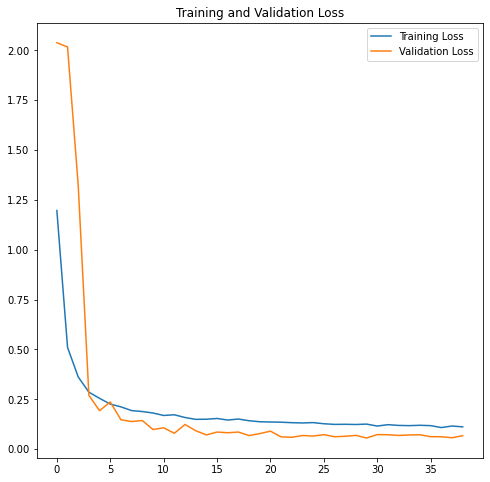

In [25]:
history = modelList[0][1].steps[0][1].history.history

loss = history['loss']
val_loss = history['val_loss']

epochs_range = range(len(history['loss']))

plt.figure(figsize=(8, 8))

plt.subplot(1, 1, 1)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_21 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
 conv2d_126 (Conv2D)         (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_106 (Ba  (None, 14, 14, 32)       128       
 tchNormalization)                                               
                                                                 
 dropout_106 (Dropout)       (None, 14, 14, 32)        0         
                                                                 
 conv2d_127 (Conv2D)         (None, 14, 14, 64)      

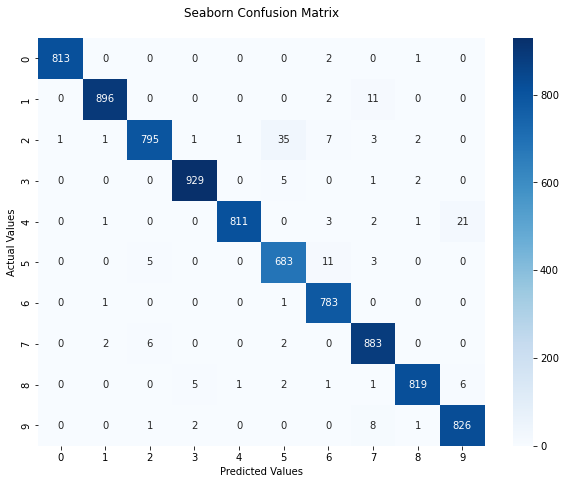

In [26]:
def conv_test(pipelineKerasCNN):
    
    pipelineKerasCNN.steps[0][1].model.summary()
    y_pred = pipelineKerasCNN.predict(X_test.astype('float32') / 255)#.argmax(axis=1)

    fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))

    conMatrix = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs)

    ax.set_title('Seaborn Confusion Matrix\n');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    
    # Let's also print the accuracy and recall scores
    print("Precision score: {:.3f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
    print("Recall score: {:.3f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
    print("Accuracy score: {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("F1 score: {:.3f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))
    
def multi_conv_test(models):
    
    models[0][0].steps[0][1].model.summary()
    
    allPreds = []
    isFirst = True
    
    i = 0
    for m, hist in models:
        
        allPreds.insert(i, np.array(m.predict(X_test.astype('float32') / 255)))
        i = i + 1
        
    #print(allPreds)
    m = stats.mode(allPreds)
    print(m[0])
    y_pred = m[0][0]

    fig, axs = plt.subplots(1, 1, figsize=(10, 7.5))

    conMatrix = confusion_matrix(y_test, y_pred)

    ax = sns.heatmap(conMatrix, annot=True, fmt=".0f", cmap='Blues', ax=axs)

    ax.set_title('Seaborn Confusion Matrix\n');
    ax.set_xlabel('Predicted Values')
    ax.set_ylabel('Actual Values')
    
    # Let's also print the accuracy and recall scores
    print("Precision score: {:.3f}".format(metrics.precision_score(y_test, y_pred, average='weighted')))
    print("Recall score: {:.3f}".format(metrics.recall_score(y_test, y_pred, average='weighted')))
    print("Accuracy score: {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))
    print("F1 score: {:.3f}".format(metrics.f1_score(y_test, y_pred, average='weighted')))
    return y_pred
    
    
conv_test(modelList[0][0])

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_21 (Reshape)        (None, 28, 28, 1)         0         
                                                                 
 conv2d_126 (Conv2D)         (None, 28, 28, 32)        832       
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization_106 (Ba  (None, 14, 14, 32)       128       
 tchNormalization)                                               
                                                                 
 dropout_106 (Dropout)       (None, 14, 14, 32)        0         
                                                                 
 conv2d_127 (Conv2D)         (None, 14, 14, 64)      

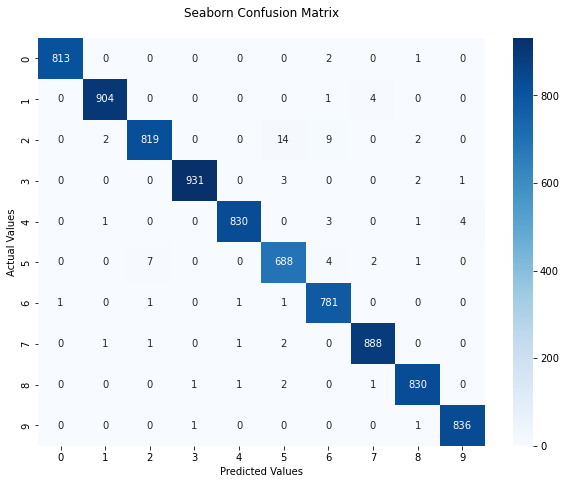

In [27]:
predicts = multi_conv_test(modelList)

wrong = (y_test!=predicts)

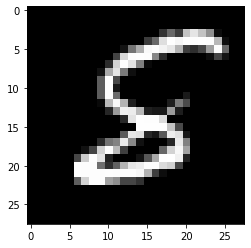

Actual: 8 Predicted: 5


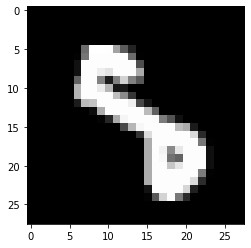

Actual: 5 Predicted: 8


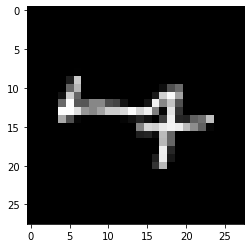

Actual: 7 Predicted: 4


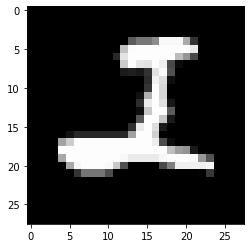

Actual: 2 Predicted: 1


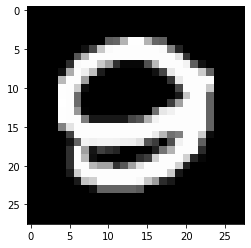

Actual: 9 Predicted: 8


In [28]:
# Really want to see what got misclassified here, just grab the first five

for i in range(5):
    first_image = X_test.iloc[np.where(wrong)[0][i]]
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

    print("Actual: {} Predicted: {}".format(y_test.iat[np.where(wrong)[0][i]], predicts[np.where(wrong)[0][i]]))

In [29]:
digitsTestDf = pd.read_csv('digits/digit-recognizer/test.csv')

allPreds = []
isFirst = True
i = 0
for m, hist in modelList:
        
    allPreds.insert(i, np.array(m.predict(digitsTestDf.astype('float32') / 255)))
    i = i + 1
        
    #print(allPreds)
m = stats.mode(allPreds)
predictions = m[0][0]

#predictions = pipelineKerasCNN.predict(digitsTestDf)

df = pd.DataFrame(predictions, columns=["Label"])
df.index += 1 

#df.to_csv("digits/predictions_cnn.csv", index_label="ImageId")
df.to_csv("digits/predictions_20_cnn.csv", index_label="ImageId")

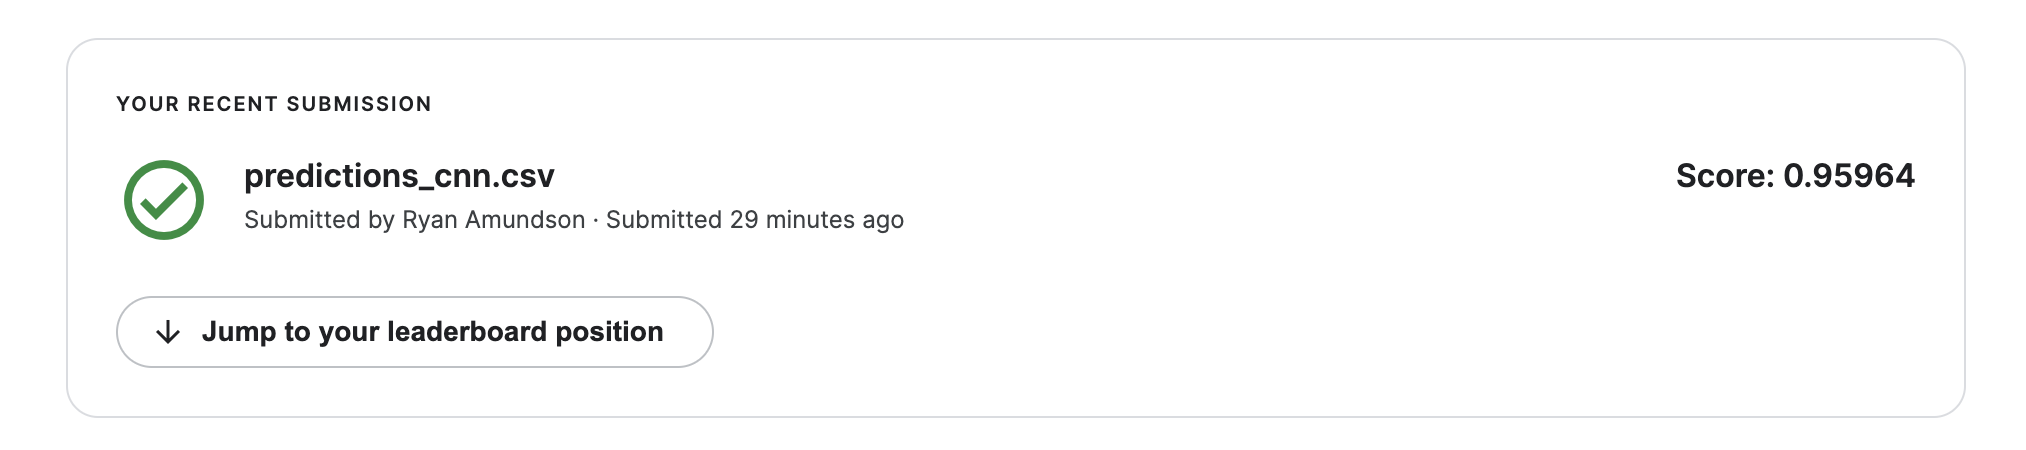

In [180]:

from IPython import display
from base64 import b64decode
base64_data = "iVBORw0KGgoAAAANSUhEUgAAB+oAAAHCCAYAAADIJ0AiAAAMbWlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnluSkJDQAghICb0jUgNICaEFkF4EGyEJJJQYE4KKvSwquHYRxYquiii2lWYBsSuLYu+LBRVlXdTFhsqbkICu+8r3zvfNvX/OnPlPuTO59wCg+YErkeShWgDkiwukCeHBjDFp6QzSU4AAdUAHGgBweTIJKy4uGkAZvP9d3t2A1lCuOiu4/jn/X0WHL5DxAEDGQZzJl/HyIW4GAN/Ak0gLACAq9JZTCiQKPAdiXSkMEOLVCpytxLsUOFOJjw7YJCWwIb4MgBqVy5VmA6BxD+oZhbxsyKPxGWJXMV8kBkDTCeIAnpDLh1gRu1N+/iQFLofYDtpLIIbxAGbmd5zZf+PPHOLncrOHsDKvAVELEckkedxp/2dp/rfk58kHfdjAQRVKIxIU+cMa3sqdFKXAVIi7xZkxsYpaQ/xBxFfWHQCUIpRHJCvtUWOejA3rB/QhduVzQ6IgNoY4TJwXE63SZ2aJwjgQw92CThUVcJIgNoB4kUAWmqiy2SKdlKDyhdZmSdkslf4cVzrgV+HrgTw3maXifyMUcFT8mEaRMCkVYgrEVoWilBiI4Q7EXGS5iVEqm1FFQnbMoI1UnqCI3wriBIE4PFjJjxVmScMSVPYl+bLBfLEtQhEnRoUPFgiTIpT1wU7xuAPxw1ywywIxK3mQRyAbEz2YC18QEqrMHXsuECcnqng+SAqCE5RrcYokL05lj1sI8sIVeguIPWSFiaq1eEoB3JxKfjxLUhCXpIwTL8rhRsYp48GXg2jABiGAAeRwZIJJIAeI2rrruuEv5UwY4AIpyAYC4KzSDK5IHZgRw2siKAJ/QCQAsqF1wQOzAlAI9V+GtMqrM8gamC0cWJELnkKcD6JAHvwtH1glHvKWAp5Ajegf3rlw8GC8eXAo5v+9flD7TcOCmmiVRj7okaE5aEkMJYYQI4hhRHvcCA/A/fBoeA2Cww1n4j6DeXyzJzwltBMeEa4TOgi3J4rmSX+IcjTogPxhqlpkfl8L3AZyeuLBuD9kh8y4Pm4EnHEP6IeFB0LPnlDLVsWtqArjB+6/ZfDd01DZkV3JKHkYOYhs9+NKDQcNzyEWRa2/r48y1syherOHZn70z/6u+nx4j/rREluEHcLOYiew89hRrA4wsCasHmvFjinw0O56MrC7Br0lDMSTC3lE//DHVflUVFLmWu3a5fpZOVcgmFqgOHjsSZJpUlG2sIDBgm8HAYMj5rk4Mdxc3dwAULxrlH9fb+MH3iGIfus33fzfAfBv6u/vP/JNF9kEwAFvePwbvunsmABoqwNwroEnlxYqdbjiQoD/EprwpBkCU2AJ7GA+bsAL+IEgEAoiQSxIAmlgAqyyEO5zKZgCZoC5oBiUguVgDVgPNoNtYBfYCw6COnAUnABnwEVwGVwHd+Hu6QQvQQ94B/oQBCEhNISOGCJmiDXiiLghTCQACUWikQQkDclAshExIkdmIPORUmQlsh7ZilQhB5AG5ARyHmlHbiMPkS7kDfIJxVAqqouaoDboCJSJstAoNAkdj2ajk9EidAG6FC1HK9E9aC16Ar2IXkc70JdoLwYwdUwfM8ecMSbGxmKxdCwLk2KzsBKsDKvEarBG+JyvYh1YN/YRJ+J0nIE7wx0cgSfjPHwyPgtfgq/Hd+G1+Cn8Kv4Q78G/EmgEY4IjwZfAIYwhZBOmEIoJZYQdhMOE0/AsdRLeEYlEfaIt0RuexTRiDnE6cQlxI3EfsZnYTnxM7CWRSIYkR5I/KZbEJRWQiknrSHtITaQrpE7SBzV1NTM1N7UwtXQ1sdo8tTK13WrH1a6oPVPrI2uRrcm+5FgynzyNvIy8ndxIvkTuJPdRtCm2FH9KEiWHMpdSTqmhnKbco7xVV1e3UPdRj1cXqc9RL1ffr35O/aH6R6oO1YHKpo6jyqlLqTupzdTb1Lc0Gs2GFkRLpxXQltKqaCdpD2gfNOgaLhocDb7GbI0KjVqNKxqvNMma1poszQmaRZplmoc0L2l2a5G1bLTYWlytWVoVWg1aN7V6tenaI7VjtfO1l2jv1j6v/VyHpGOjE6rD11mgs03npM5jOka3pLPpPPp8+nb6aXqnLlHXVpejm6NbqrtXt023R09Hz0MvRW+qXoXeMb0OfUzfRp+jn6e/TP+g/g39T8NMhrGGCYYtHlYz7Mqw9wbDDYIMBAYlBvsMrht8MmQYhhrmGq4wrDO8b4QbORjFG00x2mR02qh7uO5wv+G84SXDDw6/Y4waOxgnGE833mbcatxrYmoSbiIxWWdy0qTbVN80yDTHdLXpcdMuM7pZgJnIbLVZk9kLhh6DxchjlDNOMXrMjc0jzOXmW83bzPssbC2SLeZZ7LO4b0mxZFpmWa62bLHssTKzGm01w6ra6o412ZppLbRea33W+r2NrU2qzUKbOpvntga2HNsi22rbe3Y0u0C7yXaVdtfsifZM+1z7jfaXHVAHTwehQ4XDJUfU0ctR5LjRsd2J4OTjJHaqdLrpTHVmORc6Vzs/dNF3iXaZ51Ln8mqE1Yj0EStGnB3x1dXTNc91u+vdkTojI0fOG9k48o2bgxvPrcLtmjvNPcx9tnu9+2sPRw+BxyaPW550z9GeCz1bPL94eXtJvWq8urytvDO8N3jfZOoy45hLmOd8CD7BPrN9jvp89PXyLfA96Punn7Nfrt9uv+ejbEcJRm0f9djfwp/rv9W/I4ARkBGwJaAj0DyQG1gZ+CjIMogftCPoGcuelcPaw3oV7BosDT4c/J7ty57Jbg7BQsJDSkLaQnVCk0PXhz4IswjLDqsO6wn3DJ8e3hxBiIiKWBFxk2PC4XGqOD2R3pEzI09FUaMSo9ZHPYp2iJZGN45GR0eOXjX6Xox1jDimLhbEcmJXxd6Ps42bHHcknhgfF18R/zRhZMKMhLOJ9MSJibsT3yUFJy1LuptslyxPbknRTBmXUpXyPjUkdWVqx5gRY2aOuZhmlCZKq08npaek70jvHRs6ds3YznGe44rH3RhvO37q+PMTjCbkTTg2UXMid+KhDEJGasbujM/cWG4ltzeTk7khs4fH5q3lveQH8VfzuwT+gpWCZ1n+WSuznmf7Z6/K7hIGCsuE3SK2aL3odU5Ezuac97mxuTtz+/NS8/blq+Vn5DeIdcS54lOTTCdNndQucZQUSzom+05eM7lHGiXdIUNk42X1Bbrwo75Vbif/Sf6wMKCwovDDlJQph6ZqTxVPbZ3mMG3xtGdFYUW/TMen86a3zDCfMXfGw5msmVtnIbMyZ7XMtpy9YHbnnPA5u+ZS5ubO/W2e67yV8/6anzq/cYHJgjkLHv8U/lN1sUaxtPjmQr+Fmxfhi0SL2ha7L163+GsJv+RCqWtpWennJbwlF34e+XP5z/1Ls5a2LfNatmk5cbl4+Y0VgSt2rdReWbTy8arRq2pXM1aXrP5rzcQ158s8yjavpayVr+0ojy6vX2e1bvm6z+uF669XBFfs22C8YfGG9xv5G69sCtpUs9lkc+nmT1tEW25tDd9aW2lTWbaNuK1w29PtKdvP/sL8pWqH0Y7SHV92ind27ErYdarKu6pqt/HuZdVotby6a8+4PZf3huytr3Gu2bpPf1/pfrBfvv/FgYwDNw5GHWw5xDxU86v1rxsO0w+X1CK102p76oR1HfVp9e0NkQ0tjX6Nh4+4HNl51PxoxTG9Y8uOU44vON7fVNTU2yxp7j6RfeJxy8SWuyfHnLx2Kv5U2+mo0+fOhJ05eZZ1tumc/7mj533PN1xgXqi76HWxttWz9fBvnr8dbvNqq73kfan+ss/lxvZR7cevBF45cTXk6plrnGsXr8dcb7+RfOPWzXE3O27xbz2/nXf79Z3CO31359wj3Cu5r3W/7IHxg8rf7X/f1+HVcexhyMPWR4mP7j7mPX75RPbkc+eCp7SnZc/MnlU9d3t+tCus6/KLsS86X0pe9nUX/6H9x4ZXdq9+/TPoz9aeMT2dr6Wv+98seWv4dudfHn+19Mb1PniX/67vfckHww+7PjI/nv2U+ulZ35TPpM/lX+y/NH6N+nqvP7+/X8KVcgc+BTA40KwsAN7sBICWBgAd9m2UscpecEAQZf86gMB/wsp+cUC8AKiB3+/x3fDr5iYA+7fD9gvya8JeNY4GQJIPQN3dh4ZKZFnubkouKuxTCA/6+9/Cno20CoAvy/v7+yr7+79sg8HC3rFZrOxBFUKEPcOWuC+Z+Zng34iyP/0uxx/vQBGBB/jx/i+hZpCdk9ZaYwAAAIplWElmTU0AKgAAAAgABAEaAAUAAAABAAAAPgEbAAUAAAABAAAARgEoAAMAAAABAAIAAIdpAAQAAAABAAAATgAAAAAAAACQAAAAAQAAAJAAAAABAAOShgAHAAAAEgAAAHigAgAEAAAAAQAAB+qgAwAEAAAAAQAAAcIAAAAAQVNDSUkAAABTY3JlZW5zaG90BBZZ8QAAAAlwSFlzAAAWJQAAFiUBSVIk8AAAAddpVFh0WE1MOmNvbS5hZG9iZS54bXAAAAAAADx4OnhtcG1ldGEgeG1sbnM6eD0iYWRvYmU6bnM6bWV0YS8iIHg6eG1wdGs9IlhNUCBDb3JlIDYuMC4wIj4KICAgPHJkZjpSREYgeG1sbnM6cmRmPSJodHRwOi8vd3d3LnczLm9yZy8xOTk5LzAyLzIyLXJkZi1zeW50YXgtbnMjIj4KICAgICAgPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9IiIKICAgICAgICAgICAgeG1sbnM6ZXhpZj0iaHR0cDovL25zLmFkb2JlLmNvbS9leGlmLzEuMC8iPgogICAgICAgICA8ZXhpZjpQaXhlbFlEaW1lbnNpb24+NDUwPC9leGlmOlBpeGVsWURpbWVuc2lvbj4KICAgICAgICAgPGV4aWY6UGl4ZWxYRGltZW5zaW9uPjIwMjY8L2V4aWY6UGl4ZWxYRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICA8L3JkZjpEZXNjcmlwdGlvbj4KICAgPC9yZGY6UkRGPgo8L3g6eG1wbWV0YT4KmiDE2QAAABxpRE9UAAAAAgAAAAAAAADhAAAAKAAAAOEAAADhAACiq5AOP3wAAEAASURBVHgB7N0H/E3lH8Dxrz0bZkYqWrYGZVWERCVEkahISWibSVHa2ZtkJSOzklVKUaGMhn+SyoiyZa//+R73nM4599x7f/vn9zuf5/Xinvk857zvc3I732dkOG0kISGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAighkIFCfIs4UggACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgClAoJ6KgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQAoKEKhPQWyKQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAgEA9dQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEUFCBQn4LYFIUAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggACBeuoAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACKShAoD4FsSkKAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABAvXUAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBFJQgEB9CmJTFAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgTqqQMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgikoACB+hTEpigEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQI1FMHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSEEBAvUpiE1RCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIEKinDiCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJCCAgTqUxCbohBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEECBQTx1AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgBQUI1KcgNkUhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBAoJ46gAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQAoKEKhPQWyKQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAgEA9dQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEUFCBQn4LYFIUAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggACBeuoAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACKShAoD4FsSkKAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABAvXUAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBFJQgEB9CmJTFAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgTqqQMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgikoACB+hTEpigEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQI1FMHEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSEEBAvUpiE1RCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIEKinDiCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJCCAgTqUxCbohBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEECBQTx1AAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgBQUI1KcgNkUhgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCBAoJ46gAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQAoKEKhPQWyKQgABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAgEA9dQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIEUFCBQn4LYFIUAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggACB+hSqAydOnJTDR47IsWPH5djx43L82Ak5cfKknDp1Sk6fPp1CV0ExCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAgL9AhgwZJGPGjJI5UybJkjWzZM2SRbJmzSI5smeXzJkz+Z/E1gQJEKhPEFvcTtLA/MGDh80/GpwnIYAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAmlRQIP2uXLlMP9o4J6UOAEC9YnzCztbe8jv3XdADhw4aPactw7IZLQ8yZ4ju2QzWpxoq5MsWTIbLVEymy1SMmbMYB3GJwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJAqAqdOnTZHBD9x8oQcP37CHC38qDFi+JHDR+SkEQe1kgbtzzknl5x/3jlmvNPazmfcBQjUx90q6pEaoN+zd7/5xxrKXod/OCd3LqNVSU5jOIhsUc9nJwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHC2Chw+ctQYSfyQHPj3oOi035p0qPw8559r/tEh80lxFyBQH3eriEfu3bdfdu3eZ7Yu0YM0MH/eubklV84cEc9hBwIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJAWBQ4eOiz79v9rBu71+jVIny/veUYP+3PT4u2kyjUTqE8E+zFjmIe//9kl2npEkwbotcUIvecTgcqpCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQJgQ0TqqjjmtPe00aJy1YIJ85FXiauIFUvEgC9QnE37f/gBGk322erUPc58+XxxzmPoHZcRoCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQJgV0OPydu/bYQ+IXLJDXGIH8nDR5Lyl10QTqEyCtlUxbhmjSIe7z58trDOeQIQE5cQoCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQ9gVOnTptBOt3m0Pi693oSOTa2ZnkL0Cg3t8l4tbtf++UAwcOmvtpCRKRiR0IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBBAAefI5Oeck0sKFcwfQIXYt0ygPraRfcRfO/6Rf/89JJkyZpRCF+SXnDlz2PtYQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAQOXTosGzfsVNOnjoluXPnlMIXFIDFI0Cg3gMSadXqSZ8pUyYpUriAZM+WLdKhbEcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQCLXDk6FHZ9tc/cvLkSaFnfXhVIFAfbhK2xZqTXnvSFylSkCB9mBAbEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAbeAGazf9rfZs5456902BOrdHmFrzjkUihYuyHD3YUJsQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBPwFdBj8rX/9be4sWCCvnHfuOf4HBmwrgfooX/ixY8flj83bqDRRjNiFAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIRBNwdo6+uFgRyZo1S7TDA7GPQH2Ur3nL1u1y+MhRo1VHbilYIF+UI9mFAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIBBJ4O9/dsm+/f9KjuzZ5MKihSIdFpjtBOojfNV79+2Xf3bukcyZM8nFxYpKxowZIhzJZgQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBaAKnTp02RjPfKidOnJQC+fPI+eedG+3wdL+PQL3PV3zq1CnZ9MdW0c9CF+SXc3Ln8jmKTQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACcRU48O9B2b5jp9FJOqMUv1g7S2eM66np7jgC9T5f6a7de2X3nn2SK1dOKVKogM8RbEIAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQiK/Atu3/yMGDhyRvnvMkX97z43t6ujmeQL3nq9Re9L/9vkVOnz5tzo2gcySQEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQSL3D4yFHZsnW7ZMiQQUpccmFge9UTqPfUJe1Jrz3q6U3vgWEVAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSAIBq1e99qjXnvVBTATqPd/6H39uk2PHj0uRwgUlV84cnr2sIoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggkRuDgocOy7a+/JWuWLHLxRUUSk1WaPZdAveOrO3zkiDHMwg7JnDmTFL/4QsceFhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEkkpg0x9b5MSJk8Z05BdIjuzZkyrbNJMPgXrHV7Vz1x7Zs3e/5Dn/XMmfL49jD4sIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAkklEPTYLIF6R02yhr2/sGgho9VGNsceFhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEkkrg8JGjxmjn2wM7/D2B+lBN0mEVdHiFTBkzSonixZKqfpEPAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggICPwG+bNsvJU6fMacl1evIgJQL1oW/7wL8HZfuOnZIrV04pUqhAkOoA94oAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgikuMC27f/IwYOHpNAF+eWc3LlSvPzULJBAfUh/1+69snvPPsmb5zzJl/f81PxOKBsBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBI9wJBjtESqA9V7792/CP//hvM1hrp/gnnBhFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBA4KwTsEY9z507pxS+IFijnhOoD1XHPzf/JUePHZNiFxaS7NmynXWVlAtCAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEE0pPAkaNHZfOW7ZIta1a5qFjh9HRrMe+FQH2I6Lfft8jJkyel+MUXSubMmWLCcQACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQMIFTpw4KZv+2CKZMmWSEpdcmPCM0uCZBOpDX9qvv/0pp0+flkuLXyQZM2ZIg18ll4wAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgikHYFTp07Lxk1/SoYMGeSyEhelnQtPgislUB9C3LDxD3Pp8ksvTgJWskAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQiCUQ1DgtgfpQzQhqBYj1YLAfAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSC6BoMZpCdSHalRQK0ByPVDkiwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCMQSCGqclkB9qGYEtQLEejDYjwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCSXQFDjtATqQzUqqBUguR4o8kUAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRiCQQ1TkugPlQzgloBYj0Y7EcAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSSSyCocVoC9aEaFdQKkFwPFPkigAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACsQSCGqclUB+qGUGtALEeDPYjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACySUQ1DgtgfpQjQpqBUiuB4p8EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgVgCQY3TEqgP1YygVoBYDwb7EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgeQSCGqclkB9qEYFtQIk1wNFvggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAsgaDGaQnUh2pGUCtArAeD/QgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEByCQQ1TkugPlSjgloBkuuBIl8EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAglkBQ47QE6kM1I6gVINaDwX4EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAguQSCGqclUB+qUUGtAMn1QJEvAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEEsgqHFaAvWhmhHUChDrwWA/AggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggkFwCQY3TEqgP1aigVoDkeqDIFwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEIglENQ4LYH6UM0IagWI9WCwHwEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEgugaDGaQnUh2pUUCtAcj1Q5IsAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjEEghqnJZAfahmBLUCxHow2I8AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggkl0BQ47QE6kM1KqgVILkeKPJFAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEYgkENU5LoD5UM4JaAWI9GOxHAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEkksgqHFaAvWhGhXUCpBcDxT5IoAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAArEEghqnJVAfqhlBrQCxHgz2I4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAsklENQ4LYH6UI0KagVIrgeKfBFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIFYAkGN0xKoD9WMoFaAWA8G+xFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIHkEghqnJZAfahGBbUCJNcDRb4IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBALIGgxmkJ1IdqRnqpAJMnvy8zZ8027+rqq6+Sbl27+Nb9ocOGy5Iln5v76ta9Rdq0fjDsuL///kemTpsmCxculo0bN5r7L730UqlTp5bc3bSpFCxYIOwca8NDbR+R/fv3y7nnniujR42wNrs+X3qpr6xdt06yZM4iI0YMldy5c9v7t2zZKk89/Yy9bi3kyJFDSpcuJeXKlpUqVSpLnjx5rF1x+kxMvpHO9Rb8wP2tpH79et7N5vrhw4dl7ocfyexZc+R/v/wiR44ckSuuuFzKlikjbdo8KBdffLHveQkt23le9WrVpFOnDr75d+3aXX7btMn8LiZNGu86plv35+zv37XDZ0W/n7HvjJaMGTP67PXfdPz4cZn8/hT5btV38v3q1XLw4CG56qoKUr5cObn33maSP3/+sBPjcl+nTp2SZs1bmOdqvX2l70uufBYtWiwjR412bdOVbNmyyZVXXCFly5WVurfUEb0nb3KWr/sebvuQ1K5dy3uYvb569Rrp+8qr9nqv53tKmTKl7fW//vpLHn/iKXM92ve07ocf5EOj/qxdu07WrftBihUrJtdee7XceMMNcotxrdFSQs4dPGSofPHFUjPbt996Uy68sKhvEVqvP/zoY5kzZ678/PN6s17rtV13XSVp3uxuKVmypO95unHgwMHy5VdfSaZMmeT111417unCsGNXrlolr7/+prm95X0t5I47bg87hg0IIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQNgXSS5w2vvoE6kNi6aUCaHD9+spV7Xowa+YHUqFCeXtdF/744w+pUbO2vW3xogVSokRxe9065rbb7zSCpgdd262VfPnyyQfTp0QMLJctd5V5bq5cueSHdaut01yfLVq0kmXLl5vbVny73BWQ3bDhV7mlrn+w28qkUKFC8v7kiRGvwTrO+ZmYfONyrpb17LNPS/tH2zmLNZcPHTos99//oGjQMVJ6+qknpUOH9mG7E1q297yJE8ZJtWr/1Q+rILXWYzVt+m2Dtdn8vKNBQ/nhhx9d26Kt/LphvRl0jXaMtW/Hjr+N++0U0UTr2dixo82GGdY5+um8Lw3aDhzQz7nbXD558qRcdvmZAHHx4sXl08ULXMdoo5buPXq6tnlXypcvL2NGj3DVTT3GWb6ua6OYGR9M00Xf9ORTz8isUAMaPeDdsWPkpptutI915hfpft43GjNoo4lI6YEHWkmP7t0kc+bMYYck9NxOjz8pc+d+aOa3YP48ufzyy8Ly1iB9q1bR6/XIEcOMBj7//TfHmYmzjEqVKsrk9yaG1Z/58xdIu0cfM0/r0vlZadfuYWcWLCOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEAaFkgvcdr4fgUE6kNi6akCjBo9Rvr2PdN7t+K118q0ae+76sVjRmD044/nmdseeaStdO3S2bV/+/bt0qhxU9FPK2k+mpxBZg2Uz5wxXQoVusA6zP5MykC9llO9+png8ratf8matWvtBgQayF3y2SJXb3z7InwWnAHR+ObrPbdKlco+JYjUr3drWO9q7TX+8COP2qMY6IkXXVRMyhm9xtcZowr8+edmO6/XX39Vmja5y17XhYSW7TxP81GvxYvmy3nnnaerdooWqO/Xf4Bs3rzFPnazca1WPdCe0qVKnQmGWwe8+cZrce5R37LVA/Lll1+Zp+r3ob3C1eqzz5bY9U8be6xZvcoVvHXeV6TAdnwC9Rpo15EaTp06bX4fzoYJdza4Q/r3f9u6PfPTWb614+OP5oZZ6L6dO3dKpeuqWIeZn/EN1Kt306bN7Dxq1brZDJqvXbPObuyiO/v0eVHua3GvfZwuJOZcZxDdL1DvV6+1UcTFF1/kqut6HTpSQ9Uqbgfd7ixD13v06CYPtWmti3YiUG9TsIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQLoTSE9x2vh8OQTqQ1rpqQIcO3ZM6txyqx38dfZmXfXdd9KkyT3mXWsAdNlXX5jD01uVRoObdW6pJ5uMYdA1Va9eTQYPGmAHdvft2ycdOj5uB1e1h+28jz90BVH1vKQM1HsDsbt375YW990v69ev16Jk/LixcsMN1c3lWH85A6zxzTfaubHKff75F2TCxEnmYRosf++9CXLF5Zeb62o+fvxE6d3nJXNdv5fvv1shWbJksbNNaNnO86zMGja8U/q9fWYYcWtbtEC9dYz1+akRRG/Tpq25GmkEAOvYaJ9al666uqJ5iDZamDtnll0Xddh6bSyy1miUoWna1MlSseKZY3XdeV/e71H3a4pPoL7vy32kefP/AuFff/2NNL/3PjOfWA0FzIOMv3RI9t69X7BW7c+RI0fLK6++Zq/rQnwD9a+9/oYMHz7SzOPFF3tJq5Znrk03OL8PDYR7py5IzLnOILpfoN5br6e8/55cemkJ8zqPHj0qOnT+4MFDzXX9SxvVeKd3cJZhHTj/k4+MKSGusFaFQL1NwQICCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAulOID3FaePz5RCoD2mltwrgDN5pEFSHt9c5oO9qcrd8//2Zoej9em5/tWyZ3GcEwTXpeXNmz7SD9CEq0QBrgzsb2Q0B/HrKJmegXq9jypSp0rVbD/OSHn+8ozzxeCfr8qJ+xgrwRss31rmRCj5w4ICUr3CNvVtHIdA52L1Jh/bWgKQm7xD1CS3beZ6zvKFDBkk9o+e/lVIjUK/THuj0B5rq168nQwYPtC7H/NRrX/711+bydcaQ6M55zp33lRyBei20YqXKsmvXLrP8/63/UbJmzWou61/O8u2NxsK6td+7RnfQxgLVb6hhjw5gHRvfQL32prdGMZj38VyXheY5ffoMOXT4kGQzrvGee+62ijE/E3OuM4juDdR76/Wc2TPMESKchWuDi46dnrBH8NDnVJ9XZ3KWYW3X71rzsxqrEKi3ZPhEAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCD9CaS3OG1cvyEC9SGp9FgBHmz9kD38tA6JrT2527fvYN5x2bJlROev1+C9M+mQ+Tp0vqZuXbvIww8/5NxtLzt7Cbd9qI10797V3qcLyR2od8657Rf8c12MY8UZYPUL8EbLN9a5jmJci4sXfyoPtX3E3HbjjTfIuHffce23Vn7//Xf56aefzVUdhv2SSy6xdrkCw37XbR/oWXBesw5Jbo2UoL3EtfHGBRcUNM9IjUC9Dqd/40017St+oVdPufvuppIjRw57W6QF531F8khMj3rncPGVK19vzpvuvBZn+TpkvzVNhLdn/pIln4s+h5r0+bMC//EN1Hft2l2mTJ1m5qPD9Gs5zoYL5o4IfyXmXGcQ3Ruod9brGjVukrHvjPa9Am0Y1PiupuY+vWZtaOBMzjJ0vzVSRocO7UVHbNBEoN4pxjICCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAulLID3GaePyDRGoDymlxwrw668bzSHw9RY1MHvOOefYAUWdt96ad95ZUZzz10cbUn7p0i+l1f0Pmqf69YZOzkD99u07jLIfMIPXegETJ46TalWrOm8j4rIzwOoN8MbK13mujjZw0403+pbTywg4OxtATJz0nvTs2cs8tv2j7eTZZ5/2PS/axoSW7TxP77eS0TNdhyvXdHPNGjJ69EjJkCGDpEagXq/hyaeekVmzZuuinfS6qlevLjfXqikXX3SRvd254L2vgQP6OXeby/EJ1OuQ8aVKlTTP08YMOiKFJv2eJ04YL8WKXWiuW385y2/T+kH56ON55rOlU0FoQNtKDz/yqCxcuMhcffKJx6Vf/wHmcnwD9f/73//k1nq3W9man9rwQht+1LjpRqlSpbJky5bNtd9aScy5ziC6N1DvrNePtX9UnnnmKatI1+fBgwfNhju6Uf879MO6MyN6WAc5y5jxwTRp/1hH+79T06dPkWuvuYZAvYXFJwIIIIAAAggggAACCCCAAAIIIIAAAggggAAC6VAgPcZp4/I1EagPKaXXCvDyy6/I6DHuHtx3NrhD+vd/27d+3H1Pc1mxYqW5b8mSxREDpdr7u+bNdczj/ObFTspAvRaiPXY1bd261Q7Q67r2Zl68aL7kzJlTV2MmZ4BVD45Pvt5zIxX264b1rkD9wIGD7QDtW2++Lo0bN4p0asTtCS3beZ4G6vv3e8vs4f3FF0vNsl7p+5I0a3ZPqgXqjx07Jh98MEMGDhpiB2edCLfdVl96PtfD7vlv7fPeV2ID9Va+3s8ePbrJvc2bG/XL3cvfWb6OKJE3b17RueA1WcFlras67L2m5s2bGT3gr5RevV401+MbqNeTftmwQYYOGSaz57h7pOs+7a3//PPPSQPjO/ZLCT3XGUT3BurjU6+d0wh4nw9vGXv37hX975AmbSgx7+MPRRsG6dQQmrp0flbatXvYXOYvBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQSPsC6TVOG+ubIVAfEkqvFUDnk69W/SbRXq1WWvbVF1K4cGFr1fXp7AE8dcpkswe264DQigbzrWBanTq1ZeSIYa7DkjpQ78o8tKK9l8ePe9cI1l/gt9t3mzPA6nuAsTFSvt5zdfoAb9I5tadPmyIZM2a0d40dO05693nJXH/66Selw2Pt7X1xXUho2c7zrBEEdJj22nVutevEks8WSduH29kNIDb9tiHqZWlv8zZt2p65H2Noch2iPLFJA/YfffSxLDKmCfj88y/sa9N89fvQaRqcjTH87st7DfHpUa8NNipUKG9msWvnLvli6VL588/N5nr16tVk9KgRrh7rzvI1UN+mTWupXKWaeXyjRg3l7bfekP4DBsqAAYPMbbNnfSCr16xNVKDezMj4S0fKmDFjpnxmDKtvDRNv7YvVECS+53qD6PpdWCmu9Vq/2ytL/veseOuXXxna6GH48JFmUfe1uNcYYaEagXoLnk8EEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBNKZQHqN08b6mgjUh4TScwUY885Yeemlvuadak9U7ZEaKemw6BMmTjJ39+79grS8r4XvoXqMHqtJj9FjnckK1Ou23zb+Yg6v7tyvy02bNhOdC1zTim+XS/78+c1l/csZCNV1DX7++++/9jDium3UyOFSu3YtXYxzSky+znOtoHdcCv7YGBZdpxTQVO/WujJ06GDf006cOCFHjx41rbJmzSqZM2e2j0to2ZHOmzv3Q9EAqSadAmHX7t32/PXeQKp9EaGF5AjUO8s4fvy4GazvadQva+53q+e/dZzzvurWvUWGDxti7bI/Dx8+LKXLnAm+6zDxny5eYO/ThcmT35fuPXqa27xzy+u52mjlyy+/Mvd765qzfA3Ud+/e1fyO9bvWtHzZUrn9jobmnPTaoGPunFkyfsLEJAnUmwWE/tqyZauMHDnKfmZ1aPl1a7/3fd6c5+lyXM71C6Jb+Tjrtd/0F9Zx2pigXv07zFXtIf/5kk+tXeanXxn6HNzRoKHdeOSuuxqbIy/oCfSod/GxggACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAmhdIz3HaaF8OgfqQTnquAHOMoOzjoaCsDiPeuvUDEeuEM/hWufL1xvzc41zDuOuJ2lP5vpb3y9dff2PmM2TwQNFAnTM5g/ALF3wil112qXO3GZAuWaqsuU2Di2tWr3KV4wyEOoPiU6dNly5dupnnaQB09qwZrt7rrkJ8VhKTb6RzfYpxbdJgc5WqN5jb9F4XL1oQNpS77nyxdx95993x5nH93n5TGja801zWvxJadrTznAFSuyBjIaUC9YuN3vM//viTWbQOv1+wYAHnZciiRYvNnv66UfdrsN5Khw4dkjJlK5irkYLT2ghE66Emv2B+tEC9njNr9hx58smnddEcat3ZwMXpagXqv/pqmflc6PHly5eXtWvX6qK8+mpfuefupgkO1B84cMCsF6dPn5bixS8RfR68SQPhVu/6L5cukaJFi5qHJOZczcBZR7xD32/fvsOo19XNcvQ7+HTxwrDvUHf26z9AdJh8TX6NeiKV4QzwmyeH/iJQ79RgGQEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBtC+QnuO0Ub8dI/hDMgR++fV38096xDDmtD59SfHLzD9jxoyNeotGAPS0EQC1j+/T5+Ww43WblZ8eq+d406BBQ+xj2j/W8bTRS9p1yFtv97P3G73NXft05ZdfNtj7O3Z6wt5v9Do/XfPmOva+Oca9xSclJt9I58al/Fb3P2hfc4M7G4eZGUFle7/a7tmz15VtQsuOdp6WcW3F613latmx0uJPP7PP0e85oWncuPF2PsYQ8WHZGEOf2/sHDQ4vp1nzFvZ+b73WOmk0JrH3T5z4Xlj+77032d6vy9709DOd7f1GoNm12+n68suvmPuMBiynb7yppn2O9YwYI0GY+8eNn2DvW7Lk84j5Oeu7HqR13nom9dOYw911ruZv7dcync9jYs7VQvRarPvQe/amBx5sY+/Xem2MROA65JNP5tv7NZ/vvvvetV9XopUxYsQo1/max7BhI8LyYAMCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgikXYH0HKeN9q3Qoz7UjCE9t9SIT4965Vj13XfSpMk9dgMPnZe6Zs0acvLESXPubu1NbKXp06fItddcY63an+t++EEaNGhkr2sP49q1bpbMWTKbPfG/+GKpvW/AgH7SwNNL2Nlj2dmjXk+aP3+BPV91oUKFROdYz5Ytm51ftIXE5Os8V3vzN7vnPyNnmSVLXRlm8s8//0iTpvfY857ny5fP9ChRooT8smGDPay35tP+0Xby7LNnenJb+Sa0bOd5XkfNe+nSL8VoRGAVY36mVI/6P/78U2rU+G/qgiZNGkvNGjXMYduXLVsuEye9Z1/XnNkzpFy5cva6LjjnSNf1OnVqy/XXXyf79++XefM+sYdN131aRy6++GJdtJOzR/1tt9WX6tWqmvt0SPjPv/hCfvjhR/tYbz13ulo96vXgUaPHSN++r9rntWrVUl584XlzPTFD3z/buYtMnz7DzEfrTqdOHeTCCy+Ubdu2yahRo+16Vct4xkaPGmGXrwuJOTdSb3ergJ07d8pdTe62y9dr0++hQIH85nO+YsVK61CJNJpHtDJ09I5mzVrYU2RoZvSot0lZQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgXQik5zhttC+IQH1IJz1XgPgG6pXEL4DrrUjjx42VG244M/S1d5+uL1y4yJzn22+fta1Hj27yUJvW1qr96QyEegPMRssTadioiT20eKQAoJ2ZYyEx+TrPdWQZtvhou0ekc+dnwrZv3rxFGjVuYs5bHrYztEGHaNepBDJlyuQ6JKFlO8/zOloF9Hqht4wfP8FaTbGh77XAIUOHyZtvvm2X7bfQpvWD5hzwGTNmdO3WeqDnDh023LXduaJDsmvgWqdx8CZnoN67z7muwfbne/ZwfSdOV2egfteuXVKxUmX79I8/miulSpU01xMTqP/jjz/MaQC03EhJg+Rj3xkV1qAhMedGC6Jb17F161a5s+FdUev14493lCce72Sd4vqMVcaff26Wm2rcbJ9DoN6mYAEBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgXQhkJ7jtNG+IAL1IZ30XAGc885r714NPMYlffvtChk2fIQYw3S7Dq9R4ybRYPR111Vybfdb0d752vNZ57PXIKYmDZ5q4LRpk7vMucP9znMGQhs1aihvv/WG67BvvvlWjKHPzW2a37ffLJecOXO4jvFbSUy+znP98ra2RQrU634NmhpDd8uUqdOsw81P7aH/2GPt5VYjUO+XElq28zw/Ry3r0KHDUq/+bXav6Fg96rU+PNj6IfMyn37qSenQob3fJcd52+eff2EG7J29r/XkitdeKy3uu1ca3tkgal4zZswUY3oHWbXqOzl48KB5rI60oHXskYcfkpIlzwTKvZlEC9TrKBIVKpSXG2+4wXdO+I0bf5PadeqaWToD9brB6sFeqVJFmTplsl1sXAP1kb+nQ8Z896+bvf01eG0lvdcqVSpLt66djZ7sBazNrk9jOPwEnesMoi9etEBKlCjuytda0esZPmKkqKkzqb02tNDREiKluJQxbfoHRuOXrmYWBOojSbIdAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIG0KZCe47TRvhEC9SGdoFaAaJXD2nfs2DHZvn2HuVqo0AWSNWtWa1e8Pnfs+FuOHD0iFxUrZg5vHq+T09nBOqT3P//slKOGR9GiRSVz5szp7A7jfzunTp0yhnL/S06ePGEO6+4dVSBWjnr+n8Zw+rlz55b8+fPHOjxN79fA+5YtW0SD9Oeee2687iUx58YqSOv1zp27zAYTF1xQ0GyUE+sc9iOAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECwBYIapyVQH6r3Qa0AwX7suXsEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhNgaDGaQnUh2pdUCtAaj50lI0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAsEWCGqclkB9qN4HtQIE+7Hn7hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIDUFghqnJVAfqnVBrQCp+dBRNgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIBFsgqHFaAvWheh/UChDsx567RwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB1BQIapyWQH2o1gW1AqTmQ0fZCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQbIGgxmkJ1IfqfVArQLAfe+4eAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRSUyCocVoC9aFaF9QKkJoPHWUjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECwBYIapyVQH6r3Qa0AwX7suXsEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhNgaDGaQnUh2pdUCtAaj50lI0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAsEWCGqclkB9qN4HtQIE+7Hn7hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIDUFghqnJVAfqnVBrQCp+dBRNgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIBFsgqHFaAvWheh/UChDsx567RwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB1BQIapyWQH2o1gW1AqTmQ0fZCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQbIGgxmkJ1IfqfVArQLAfe+4eAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRSUyCocVoC9aFaF9QKkJoPHWUjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECwBYIapyVQH6r3Qa0AwX7suXsEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhNgaDGaQnUh2pdUCtAaj50lI0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAsEWCGqclkB9qN4HtQIE+7Hn7hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIDUFghqnJVAfqnVBrQCp+dBRNgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIBFsgqHFaAvWheh/UChDsx567RwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB1BQIapyWQH2o1gW1AqTmQ0fZCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQbIGgxmkJ1IfqfVArQLAfe+4eAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRSUyCocVoC9aFaF9QKkJoPHWUjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECwBYIapyVQH6r3Qa0AwX7suXsEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhNgaDGaQnUh2pdUCtAaj50lI0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAsEWCGqclkB9qN4HtQIE+7Hn7hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIDUFghqnJVAfqnVBrQCp+dBRNgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIBFsgqHFaAvWheh/UChDsx567RwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB1BQIapyWQH2o1gW1AqTmQ0fZCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQbIGgxmkJ1IfqfVArQLAfe+4eAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRSUyCocVoC9aFaF9QKkJoPHWUjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECwBYIapyVQH6r3Qa0AwX7suXsEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhNgaDGaQnUh2pdUCtAaj50lI0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAsEWCGqclkB9qN4HtQIE+7Hn7hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIDUFghqnJVAfqnVBrQCp+dBRNgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIBFsgqHFaAvWheh/UChDsx567RwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB1BQIapyWQH2o1gW1AqTmQ0fZCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQbIGgxmkJ1IfqfVArQLAfe+4eAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRSUyCocVoC9aFaF9QKkJoPHWUjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECwBYIapyVQH6r3Qa0AwX7suXsEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEhNgaDGaQnUh2pdUCtAaj50lI0AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAsEWCGqclkB9qN4HtQIE+7Hn7hFAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIDUFghqnJVAfqnVBrQCp+dBRNgIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIBFsgqHFaAvWheh/UChDsx567RwABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB1BQIapyWQH2o1gW1AqTmQ0fZCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCAQbIGgxmkJ1IfqfVArQLAfe+4eAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQRSUyCocVoC9aFaF9QKkJoPHWUjgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECwBYIapyVQH6r3Qa0AKfnYHz1xTDb985ts2bNVtuzeIpv3bJE9B3fL4eNH5PCxQ3Lo2GHzcnJmzSHZs+QQ/cyTK68Uy3OhFM1b1PwsXqCEZMucNSUvm7IQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCCZBIIapyVQH6pQQa0AyfQ82dnuO7xfvvntG1n263JZ9fsqOXriqL0vIQvZMmeTay+5VqpeVkWuL3G9nJfj3IRkwzkIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIHAWCAQ1TkugPlT5gloBkuPZ27Z3mxmYX7Zxufy09Sc5dfpUchQjGTNklNJFS0vVS6uYgfsi5xdJlnLINH0J/PbbJpk6bZps2bJVGjdqKDVq3CQZM2Y8K27ybL62swKIi0AAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAIF0JxDUOC2B+lBVDmoFSMonefnGr2X8sgmy8e+NSZltnPO6tOCl0qpqS6lyaeU4n8OB6Uvg229XyIwZM1031atXT8mRI4e57fDhw1Lpuipy8OBB+5gxY0bJzTVr2OuptXA2X1tqmVAuAggggAACCCCAAAIIIIAAAggggAACCKSuwOnTp2X16jWyePGn8u2KFbJjxw7ZtWu3nHPOOVKwYEEpV66M1KldW6pWrSJZsmRJ3YuldDl69KjMmj1Hli79UjZu/E02b94s+fLllRIlSkjZsmWkxb3NpVChQkkqtX79euO9/CxZvWaNUd4WOXDggFxxxeVStkwZKV26lDRocIfkzJkzZpnffPOtzJw5K+Zx3gNuvbWu2SHPu925nlTX6MzzxIkTsmTJ5/Lhhx/JTz//LNu2/SXZs2eXokWLSsWK18jtt90mV199lfOUeC/v27dPXn3tDXn//SnmueXLl5dSJa+U0mVKS6uW98U7v7P5hKDGaQnUh2plUCtAUjyUP237SUZ/MUZ+2PpjUmSX6DzKFi0jD93YRkoXKZ3ovMggbQlMmTpNunbt7rrotWu+M3806sb58xdIu0cfc+2vX7+eDBk80LUtKVf0h6w3ZciQwbspVa4t7CLYgAACCCCAAAIIIIAAAggggAACCCCAAAIIhAR+2bBBevV6Ub7++puYJsWLF5dX+r4k119/XcxjOSB5BOZ9Ml969uxlNKTYFbWABx5oJT26d5PMmTNHPS7WTg0id+vWQ7TcaEkbBrz5xmtSrVrVaIfJ0GHD5Y033op6jN/O7t27StuH2vjtkqS+RqsQzbd9+46ybPlya5PvZ5vWDxpGXSRTpky++2Nt7N6jp0ye/H7YYXXr3iLDhw0J256WNwQ1TkugPlRrg1oBEvPQbt69Wd75cqx8tWFZYrJJtnOrXV5VWld/UIrlLZZsZZDx2SUQK1D/99//yPWV3T8Gov0jnhR3V7FSZdcPo0ceaStdu3QOyzo1ri3sItiAAAIIIIAAAggggAACCCCAAAIIIIAAAggYAitXrpSmdzePt4V2itLOUaSUFZg+fYY827lLnAvVQO/AAf0ka9ascT7HeaC+z76zYWPZvn27c3PU5fvvbyW9nn9O/Dqy6Ym9Xugt48dPiJqH385I7/iT4xq1/D//3CwPPNhGNm3a5Hc5Ydvq1Kkt/fu9FadRBZwn6wjC9zS717nJXiZQb1Ok+QUC9aGvkEB93Ovy7oN7zCHuP1n3SbLNPx/3q4l+pM5jf2u5W80h8fPmyhP9YPameYFYgXq9wWnTP5DBg4eYwzM1bNjADJrnzp072e49roH61Li2ZLtpMkYAAQQQQAABBBBAAAEEEEAAAQQQQACBNCuwffsOqVK1eoKv/5N5H8qVV16Z4PM5MX4C0QK60XJq1aqlvPjC89EO8d2nQ77f26KlrFix0nd/tI1anpbrl3Q0XB0VN77JL1CfXNe4c+dOqVGztmt63bhcb61aN8voUSPicqh5jE5hUK/+HREbAxCojzPlWX8ggfrQV0SgPm519adtP0vvOb1Fg/VJnTJlPDP0x8lTJ5M6a8mTM4/0uvN5Yzj8UkmeNxmePQJxCdTr1epw9KdOnUrwcDPxueP4BOpT+tricx8ciwACCCCAAAIIIIAAAggggAACCCCAAALBEOjz0svyzjvvht3syy/1kWuvvVouuugi2b//gHzz7bfSv//AsGDibbfVl8GDBoSdz4akF9D33Nqz/Ycf3FMTlzXmo9eRXa+55mozqDx6zDsyYsSosAtYMH+eXH75ZWHbo23QOdk7dnoi7JCX+vSW2rVryQUXFJTffttkdJqbLsOHjww7btXKbyRv3rxh2+9seJesXbvW3t6u3cNyS5069nqkhSJFiphlOvcn1zX2HzBQBgwY5CxKdNqHRx5+SK42rLXz6CfGVABvvd3PdYyufLl0iTl/fdgOnw0DBw6Wfv0jP0ME6n3Q0ugmAvWhL45AfewavPDHhdJ/4UA5fvJ47IMjHHF+zvOl0iUVpdD5hSRfrnySL7f1J6+cn+N886y9h/fKrn93G392nflzcJds37tdVvy+UvYe2hsh59ibs2TKIk/U6SR1ysT+D3vs3NL+EdoiK1u2bElyIwcOHDDns8mRI0fM/JKq3CNHjpjX7xwmJ66B+pgXGeEA/dGjf+Izd098A/URio65Wa9LWwkmdKgivwIScr/efDSPkydPSpYsWby7UnQ9qeqdddHM0hwRAABAAElEQVRqrXUvoXMLWflYn0l9fVa+fp9JUdbZ8r363R/bEEAAAQQQQAABBBBAAAEEEEAAAQQSJ+B9p6m5LflskVx88cVhGe/du08a39U0LFj/64b1cX53lhTvq/TC9D2kpqR6Z6fvwP7991/R995xeb+ZVPdh3kQc/9Ie6NoT3Zk0cPzB9CmSJ497lOFBg4bI2/36Ow81pynQ6Qrik5rfe598/fU3rlOGDh0s9W6t69qmK1qelutMTz/9pHR4rL1zk7nsrXdjRo+Um2+uGXZcXDYkxzUePHjQmFq3mqs3vTZyeG/SBMmfP7/rskaNHiN9+77q2hbpvl0HGSsbNvwqt9SNPn0EgXqvWtpdJ1Af+u4I1EeuxNr7ePQXY2TayumRD4qyp8j5haXqZVXNP2WKlI44/0iULMxdeh0/bvtJlv26zPyzbe9fsU7x3d+0YhN56MY2Cb4O30zPoo36w0H/EXKm7t26SpUqleXjj+eJtiT71hiSZteuXZIrVy65+uqrpOV9LUSHXvH7AeOX34D+/eScc3LLgIGDZNasOfY/TNONf/yvveYaZ9Hyzz//mMPNz5+/UDZu3Ggeq+VWKF9eSpUqKS1btvD9gefKxFjRH1mLFi2WiZPek++/X23nU7VqFWnU8E6pV+9WiRWo97uXns/1kOuuq+QtzlzXH2LLv/5aJk+eIuvWrTPnntEd2hrxGuM+y5Uta7jVDPvBs3z519L3lTP/CHtbMlrn62f2bNll6tTJZl1M0LUZ5Ux+331tanvFFZebP7Duatwo7Nq0XE06HJK2jLWS/pAY+85o2bdvn0yYMElmzJxl/7iuVKmiVKtaVW427lXvOVo6duyYzJw1W340WnD+/PN6WblqlXl4vnz5pPgll8hNN90oLVrca1zXmYY50fJKzD6t39OmfSDzjNaLznqn9aVChfJyXaVKovfll7S18MxZs+xdtWvVkscf72i2An1n7FijReQC+/nR/Cpff71R/+pK4cKF7XOsBe/3mtEYOWT4sMFSsGBBmTlztkyYOMluJao/6m64obpUrVLFfB6tPBL7qT/s3ps8Wb76apn5I0/zu+iiYkbr52vlKsOievXqUqJE8ajFJPR71R/in322xJX3sKFD5MILi7q2WSv/+9//5Jln3XNpNW1yV8ThsKzz+EQAAQQQQAABBBBAAAEEEEAAAQQQSBqBQ4cOSZmyFVyZxQoKTp78vnTv0dN1zvJlS6VQoUKubdZKUryv0rwOHz5sDpX+wYyZ5rtIfSeoScvVd6RN7most9xSJ2KHNe87Up0ideKEcbJ+/f/kzbfeliVLPjfz0782/vo/yZgxo72uC7/88otMeu99Wb58uf3eTcsuU6a0XHVVBbnfGOL9nHPOcZ3jXNGYx8qVq8yRCW6tW1cuu+xS5+44Leu7tA8+mOE6dsr77/m+89Z37DfXqmO/57ZO+vmndZI9e3ZrNeqn5nHZ5SVdx0Qb1l3vsdJ1Vcz3qdZJ+h5Ue/I7k1++c+fMMt/FO4+Ly7JfXklxjePGjZcXXuzjuoTFixb4vls9fvy41L31Nvsdu55UsmRJmffxXNf53hWNSdxzz732e3Xdr+9yr77qKpk9579zYz2T3nzTwnpQ47QE6kO1M6gVINbDeejYIen74Svy7aYVsQ517c+RJYc0vOZOqVmyhlyS/xLXvqRa+X3n7/LZ+iUy67vZcvj44Xhle13xStL99m6SM2vOeJ2XFg7WQOtVV7sDkCOGDzX/sfcbrsi6p+rVq8nQIYPCfjj45ac/VgYPGRrWam7atPelohH8s5Jf4Nza5/x89tmnpe1DbSK2Sty/f788+mgHWWb84ImU2rR+0Byip2u3Hq5D1q75zr4nv3t54/XXpEmTxq5zdEUbGLRv39H1D2LYQcYG/eE17t0xxg+/K+zdc+Z+aAR2n7TXoy1YLUvjc207dvwtHTp0inltWm6/t9+UhkZDBm/61AietmnT1rV5/c8/yH333R8134kTx5lBe9eJoZWNG3+TJ558KmyYJb9jBw7oJ3fccbvfrkRvmzptunTp0i1mPjp00jNPPxXWQOXV1153DQN1c80a8sILvYw5gW63G6V4M9d6MHPGtLD/+fD7XmfP+kA+MhrNjBw52puNvf70U0ar0g7hrUrtA+KwoD8Ge/d+yWzcEutwffa1sYtfSsz3qo2DHjPqqjO9+GIvadXS3ZjI2j948NCwYaHGjxtrNmCwjuETAQQQQAABBBBAAAEEEEAAAQQQQCD5BLTjSbnyV7sK0HfHE8a/69rmXNFOHrt373ZuCntPpjuT6n2V5qWdudo+3M4VANbt3qTv7XRucA2ee5PfO9IvPv/M9z2gM1Cv9/Fi7z4yadJkb5aude289NJLveXWure4tlsrTz71jNERbra1Kn36vCj3GZ2c4po0qFu+wjWud5Za5rffLAtrVGDlqUPgv/zyK9aq+Tlp0niz85BrY4QVfTdduUo1197nnusu+n4+UtJ3tfrO1pm+/26lnH/+efYmv3y/+XqZ0eGpgH1MXBf88kqKa9Re7trIxEra4UrtkjL5NXrRd/IffTTP6FD4vl0UgXqbIs0vEKgPfYUE6sPr8vZ92+W5Gc/Ln7v/DN8ZYYvOM1+/XD25r2oLc174CIcl6eY9h/bIxGWT5ON18yQ+89tflPciealxbyl0nn+rviS9yBTMzC8wqD+kvvzyq5hXUd7o5T7jg6muwKVfftoTeYXRK9+bnIF6nadF52uJa9KgrQZvvUmHGG/UuEmcgr/aIm39+vWuLBISqN+6dasxr89dMX/kOQvS3ug1atxkbkrOQP2WLVulYaP4XZs2hGj/aDvn5Yrfj9C7mzYJ+8HkOim0MnPGdLNFqHOfzh2kZvFJTrP4nBftWL85gqIdX6dObenf7y3JmfO/RjveQL02Ptm3f5/rR5hfnjqk1HSjsYpzfiW/56d582auH1V+eem2aAHtSOdY2/W5uf/+1lEbt1jHWp/aOOCxxx41R3iwtiX2ez106LDRAru8lZ35Ge0HbL36d7ieYR0hYs3qVa7/JrkyYwUBBBBAAAEEEEAAAQQQQAABBBBAIMkFqlS9QbZv3+7Kt3v3rmYw1tur3HVQlJWkel+lRfi924xStLnLLxjtl0/lyteHdVDTDKxAfULuo+/LfUTfCTrTX3/9JVWr3ejcZDZu0HnM/Ua+dR0YWvn1141S5xZ355tH2z0inTs/43e4uU1HgL2jQUPX/iefeFw6derg2hZp5Y8//pAaNWu7dvvdn/OAV159LazT0uT3JopaW+nHH3+S2+9wdzjTTm6//LJBVq9eLT/+9JPs2bNXihrz0ZcuXUo0UB1pKt7kuEZtFHHpZVdal2t+Wp3ktAf/smVnRlXYtGmTeV0XFrtQbrrxhjiNJmxlqg0MatW+xdXwQjsZamdDHbGCQL0llb4+CdSHvk8C9e6KrT3pO016Il5B+uqXV5PWN7SWC/P4D2nsLiHp17bs2SrvLH1HvtwQOyBtla7B+oEt+qernvV+gUHrfvVTA1867Lb+g+GXunfrIm3bPmTvipWffaCxMOODaeZQ+t988600a97Cuctc1taL1apVNYbW+dM30D9mzCjR3svONGLEKNHAqV/SwOjff//t+ofLe1x8A/X6D27Llg/4Bji1NWKF8uVkzdp1vkH8lSu+Fj1G5+fRlomaFi/+1HtJrmHNR44YZrZu9HP29vbXf/Dva3m/7w9FtdWhkSI1yPBOS+D3I9R5oXof1lBRzu26rA0SNMjuTC1bPRBWtg7JU6NGDfPH03fff28OQ+U8R7+/TxcvcG5K1LK6e6d9sDLUYHuGjBl86532rO/S+VnrULO+ab2LlNTa+z8q1rHdunaRhx+O+/Ojz6Mmnd/IL1kjLvjti7bNb74p6/gbjR+I+j8Cztaf1j5v44mk+F6f7dxFpk93D7/lbTGr5WsjlBturGFdivmpLXG1tSsJAQQQQAABBBBAAAEEEEAAAQQQQCDlBLp27W5OM+otUYcsb2UM567TN1580UXe3VHXk+p9lY6EWvPmOr7v07Qj2qlTJ307fen7zkUL57t6ccd6R+q8od82/mJ2cPEbEVKP005kZcuWljVr1vq+d/t6+VdywQUF7Sz13ZzfPOQ66mm2bNns46It6BSs97Zo6TrkrTdfl8bGlKiRko5+cGXJMq7dLVo0l5f69HZti7Ti1zGnUaOG8vZbb0Q6RRrf1dQcAcF5gHdOe51m4MHW/71X1WN1dAGdCtcv6XvVN4179RutIDmuUevddddXdV3KnNkzZO/efeYUs37vWvXg226rL2++8VqcphbQkUl1hFIr6T0u/eIzc3pbAvWWSvr7JFAf+k4J1P9XuXXOkJ4zn4/zcPeFzyssXeo/K6WN+efPhvSTMY/9ax+/IX/t+ytOl6PD4Pdp1NvVizROJ56lB/kFfK1LfXfsGNE5tbNkyWIGxQYPHhL2g0v/4//9dyvsYeij5act5TS/YsWKmUHdAgUKiNafWrXrhjUEGDVyuNSuXcu6FDPQ2ahxU1fAU38s6dBCOXPmMI/THw3XXHtd2I+uZs3ukQ5Gz9+iRYuawyXp3Nvef8StguIbqPcbqltNxo17x5wHRluM6nX17vNS2NBGTz35hHTs+JhVtPlZsVJlV8D7kUfaStcunV3H6IqfszdQP9cYUr+TZ0h9NdPvVYduypAhg5mP/li0GgpYBXnnv4n0I7R+/XryXI9u5nzr2jBg0nuTpVevF61szE/1WLf2e/uZ0eO88xJpi8Yhgwe6Wn9OmTJVvFMT6Jw8em2JTZHqnf6Ye8roKZ4nz/lmEdoy855m94bVqR9/WGP3qvf2qLeuTVui3mu0fD3vvPNEhwDr0+flsBEI1E/v20p+36vu00YKetyVV15hNtT4atkyY7qEp1x1RY9LiI9fa1zN69VX+0rDOxvYP/Q1eK5BdGfSVqzamlVTUn2v+nxqAxNnGmCMntHAM/XBhImT5PnnX3AeJrNmfiAVKrh75LsOYAUBBBBAAAEEEEAAAQQQQAABBBBAIMkF9uzZY/TUrhf2rspZkL6XrF3rZvOdr3bOitS7Wc9JqvdVmtdzPZ8Pey+rHYteNoaYL2L0tta0efMW6dyla1iHJ51+VUcGsFKkd6TaAanncz3MTmnnn3++EYzda3bQ0s47OtqAM6nD1CmTXfOU6xSuLVq0ch4m3veGurNp02auaUhjBbxdGRor8+Z9Iu0f6+ja7O2I49oZWvG+s47vMOp+Iy5Eeo/54YcfScdOT4RdxmuvvSI6wquVpk3/wBgJ4L/vxtoe69Ov85+ek9TXuG7dOmlwp3sK3Rd69Qybs97verVz4nBjemKNy0RK2uHvobaPuHZbPfZ1I4F6F026WiFQH/o6CdT/V69HfT5apq10zxfy3173UoViFaTnHT3k3Bznunek8tr+w/ulz9yXZc3mNXG6kqYVm0jbm9ytteJ04ll4UKTAoPM/6tZlHz161BzmxtvaS+eg1x9XmiLl5xzm3spPP9f98IM0aOBusaet6fRHhjfpD6Ybb6rp2jxt6mSpWLGiuW3p0i+l1f3uuW00qKtzfGfNmtV1nl/QUQ+Ib6Be/zH09oL3+8deA7WVq1R3BXy1p/K4d8/0pLcuzvujJzGBep1TXn88OpMG6W+66UbnJok0XcD8Tz6SK664wjzW70eoTmkwaeL4sB8ML7zYx2io4J5rZ8lni+xhe/SHuzaocKb7728l+kPFmTSYPmToMMmZI6cxjNMFcoHxp3SpUlF/xDvPj7bs90NJe9G/996EsPvxG6XBOeKAX6Bepw7QKQScSQPZOm+98/nRH+Y6soKV/J4fbeigrXfVwJnmfTJf2rd3DzHlbazhPD7S8ph3xhpzX/V17faOGmDtvP+B1vLFF0utVfNzwy8/S+bMmY2hpJLme1WnCldd63pW/P7HxNt7X/+HaMlni+0GIa6LZAUBBBBAAAEEEEAAAQQQQAABBBBAIFkFdIh07TQUaWRWb+GtWz8gnTp2MDu5ePcl1fsqfZ99bcXrXe+Z9F3b4kULXL3VtXy/0Rv1WOc0i37vSPWd1LSpU3znRn/nnXfN3tPO+1swf57oSAPe5Dc9qvXezTpWRzTV99orVq6U8uXKib47jmtves3Dbz5z7eVdzsgrWrq51i2u71XfC2tjg7imgQMHS7/+A1yHq+17xnztWrZ2KNMULfj+4gvPm6MzWJkMHjJU3norfGpca3+0T79pDZL6GhcsWCiPtGsf7TKi7tP3oTr1r9+0Bhpr0OkEnCPc6nTG48eNtS0J1EflTdM7CdSHvj4C9WcgFv64UN745K04VerbK9wmj93cXnRe+rMx6Xz1Qz4dKh+u+ShOl/dsvWekTunacTr2bD7ILzCoQ/5ocNsv+Q1T36FDe9H5qjX55actwDR47Zf85giPNny3d9gb7fV7z91Nzaxff/1NGTZ8hKsY/cGgPxz8ks6RrnNqO1N8AvWHDh0y5tOu4DzdHKZ+9Cj3NVgHLFq02NUq86KLL5JWLe+zdpufSRWo16HRy5a7ypW3zq+uQ+f7pZXGj7umdzd37dLh3TVgq8nvR6gOb6TDHHmTX14jjBaAt9xSxzxUA/Dlyl/t+oGsO5555ilpctddYT+Svfknxbr+MNQfX840Z85MKVe2rHOTuXz48GHp12+AMQzWKXtfy5Yt7IYHfoF6ZyMH+yRjQRsevPnm285NsmrlN/Y89X7Pjw53NHiQ+4esZqANLC6/opQrrzYJGPrd2xJXfySv/n6lGXx3ZW6s/LJhg/EjfJq9WRvAPP54R/N/CJLye3355VfCRnn4+ad19pBPfk763yD9bxEJAQQQQAABBBBAAAEEEEAAAQQQQCB1BPQ92oiRo2T06HfC3v35XZG+h9L3XtrD3ZmS6n2V38iNz/d8Th580D2ao1W237s7Z4cdv3ek2uNee977Je991DJGFIj07tjvfa42KChRorhf1gnaNn78BOn1gnvI+oULPjGnSI2WoQ657+x8FC1+4JePDgOvvcv9pgfVjkzlypWVdet+cAWevfnoaKMavLaS3svAQUNc52g90veDpYzOe0ePHhN9Tz14yLCwGICW+c3XX7mC4El9jeMnTAwbeda6dr2PjsZ1lihRwnTVjoDehgx6bKROWX1eelm0EYgzOTvK6XYC9U6d9LVMoD70fRKoF/lp28/y7NTOcvzk8ai1XAPz7Ws+KndcdXvU486WnXNXfyhDPxsmGriPlrJkyiJv3P26MYS/O1AW7ZyzcZ9fwEvnDdIWan5p//79Zm9X5z4dckaHntHkl18PY2j0h9q0dp5iLz/19LMyc+Yse10XvD/MnDtXrFjp+pHnHH7Ib25rHXI9d+7czizsZb9hj+ITqP/tt03GsP232PnpwpNPPC6dOrl7ObsOiLGSVIF6v2vTQPhj7R/1vQK/H4LOuYb8foRGam25bds2qVbd/eN60MD+cvvtt9lld+j4uHz00cf2unOhbNkycq3Ru/0qYwjz66+/zhxW37k/KZaffOoZmTVrtisrZyDYtSPGil+gPlJjk1mz58iTT7p72i9f9qXdW97v+dE51zUA75e8QzLp0P19+rzod2jEbdqgQ79/K8W3Rax1nn4m1feqDWi0IY0zOYfh8pvW4bNPF8oll1ziPIVlBBBAAAEEEEAAAQQQQAABBBBAAIFUENARE5ctWy7zFywwRiP9zDdA67ws7zDoSfW+asrUadK1a3dnUUbv9/9GaHXtMFb8RmzVXs13hKZk9HtHqh3eNHDtl7zvevWYaO++dd51Z9Kgvgb3kyrp+1B9L+pMkd7xOo/xfh/ROuY5z3Mu//nnZnPueWcvcOd+53LDhneGvbt1NphwHqvvUzdt+l0OHjooVatUsXuUW8fofp1m8wdjxAdncr5rtLYn5TVGCtRHGkHXb7QDHQFWRyp2ptWr10ijxk2cm8TZ4c7aQaDekkh/nwTqQ99p0AP1uw/ukfYT2ot+RksapO/d8AWpZMzrnpbSik0r5PlZL8QM1ufNlUeGthwq+plWk19g0DuMjPfevD8wnP8w++UXqeWX5tv83vtcvcy9ZcVa1x82+o+qJu+w3N5hxb156fDsOky7M8UnUO83usDQoYOl3q11nVnGa9lrG+kf7ljOftc2bNgQudWYCz5S8pbtbOHp9yPU20rPynfHjr+NYf6rWavmpzdQr60na9e51RUgdp3gWNHAcccOj8kNN1R3bE3corfe6Rzwny5ekKBMvYH6aPXu44/nyWMdOrnKiRWoj/b83FTjZtEfkFaKb6D++PHjcsWVpa3TzU+/aQhcB0RZSarvVXvn16hZy3VvzoYj3gYB8W3FG+UW2IUAAggggAACCCCAAAIIIIAAAgggkMQC+v5qyZIlMnfuR6451q1inFMaJuX7qkFGj+u3+/W3ijE/V3y7XPLnz+/aZq3oder7NmdydqKJzztSv9EwnfnGZbl7ty7Stm3STcGrDQEebO3Ozzmtrd81aaOLyy4v6dp1112N5c03XnNti8uKdi5rcGejqO+EtWPenXc2kNvvuNOV5Vdffi5FihRxbYvrit/0u5E63CXVNfo1iihUqJBoZ6Ps2bP7Xrp3qk89yNkhTOtU/dvucI1uoNMofPThnLDpXAnU+xKni40E6kNfY9AD9f0XDpSP1/r3hnXW9I61OqSZnvTO69Zl7Vk/aPFg7+aw9frl68sTddyBt7CDzuINfgHfWIF6by9enf9kwvh3zbv0yy9aoNE7lH18qZytylq0aCXLli+3s9AfeJ8v+dRe9y5MmjRZtFe9M8UnUO83dNKY0SPl5ptrOrOM17I3WJ7QQL3ftfm1EnRenHeuIef3Gp8foXEJ1Gu5elyP53oarWojf0fO64v048l5TFyXvfWupDEckrbcTUhKy4F6HY6sdBl3i9+HH35IunXtkhAK85yk+l6980xZQ1LpD9KSpdxTFLz4Yq+waSQSfAOciAACCCCAAAIIIIAAAggggAACCCCQbAL6nrFz566uIcu1MKtTUFK+r9IgvQbrnemHdatFh9z3S3///Y9cX7mqa1fnzs/Io+0eMbfF5x3poUOHjWlT3e/dXBnHYeWJxzuZ007G4dA4HbLapzd2z+d6SOvWD0Q838/EOcptxBMj7Dhw4IDoqKM6Tezvvxs94Q8ekiuvuEJKlSop9913rzlipl+DAmfAOkLWETf7NTbQ6XR1Wl2/lBTX+Omnn0mbhx52ZR+rk9XQYcPljTfcU01/vfwre6rY4cNHymuvv+HKs9/bb8rV11zt2qYrzzzd2dUoRjuqjR17psNjzhw5pECBAmHnpLUNQY3TEqgP1dSgVgC9/c27N0vbdx+RU6dPRX1udU76TrU7Rj3mbN85cNGgmHPWZ8yQUUY9MEKK5S12tt+O7/X5BdajzXPt90OpUaOG8vZbZ/6B8MsvWqC+3aOPyfz57p7MVl6+F+zZmCdPHnu4oCeeeEpmz3EHW6MNZ+43l0t8AvXr16+XevXvcF2RBjg10JnQlFSBer9re6FXT9He0n7Jr6VqkyaNzXlw9Pj4/AiNa6Deuo7t23fIwkWLRKc10D9+cxVZx0Ya4sjaH9fP9u07yLxP5rsOT+iPvbQcqFeA4iUudzk4R6lw7YjnSmK/1z/++MPoVV/bVeqMD6bJv//+K63uf9C1/dtvlqWLH5eum2IFAQQQQAABBBBAAAEEEEAAAQQQSAMCGzf+JjpdqpVy5Mgu2ikmWpo+fYboNKbO5BxiPqneV/kNP/7h3NlSpox7hEnrOnRO86Z3N7dWzU/nu+34vCPVk733oR1Rehhz2sc1XWEEsCNda1zzcB6nAejyFa5xbjKH9Vf7SGnGjJny9DOdXbs1OKzD0ydX6tb9OXn//Sl29toTffmypfZ6Qha8I5M6YxoJyS/WNepzUbtOXVfW7do9bA5T79roWNF71nyd6culS6Ro0aLmpqZNm7mC787j4rN82231ZfCgAfE55aw8NqhxWgL1oeoY1Aqgt//inN7y1YZlUR/MCsUqyKtN+ooOfZ+Wk85T33V6d1mzeU3U26h2eVXp1cDdMzvqCWfRTr/AurMntfdSf/zxp7BhZ5w9cP3yc/6Y8eanQ8/rEPTOlNCA6Usv9ZUx74x1ZiUffzTXbI3n2hha8fbA183xCdTv3LlTKl1XxZV1tH/gNfD4668b7eMLFMgfNn9RUgXqda4fzcuZmjdvJn1f7uPcZC/7/XDQ+ex1XntN8fkRGt9AvX0RoQVtpTlv3jwZPmJUWNC+Q4f28vRTT3pPiff6i737yLvvuutdtDnO9f5Pn/qvcdL1118nuXPnNstN64F670gK0Ybu1+d75cpVtnfmzJnlxhtvCJv7yT7AsZCQ71Xnqdf56q2k3/++vftkwsRJ1iazoY41/YW9kQUEEEAAAQQQQAABBBBAAAEEEEAAgRQReOrpZ2XmzFmuslZ/v1LOO+881zbninbWufsed0C8R49u8lCb1uZhSfW+SjuIaUcxZxpgBKUbhOacd27X5SlTpkrXbj1cm8ePG2tPyRmfd6Saifc+6tSpLSNHDHPln9Ir6q7+zhTt+/Ibjl2D5ho8j2vSDnNbt26zD7/yyitER0/1S9pJp1x5dw/xVq1aio4CbCXtId/dCGj/e/Cgtcn8TutGmPZ1z569cs217umZne++NZOkvsZTxrtkbRRx0HGNsabv1MYr2ojFmX7530/2sPYE6p0yIkGN0xKoD9WDoFaAn7b9JE9MPhO4cz8S/60VPq+wDGoxQM7Nce5/G9Pw0v7D+6XjpMflr31/Rb2L/s37SekipaIeczbu9Aus63VOmzpZKlas6LpknTe67cPtwoYqHzJ4oNSvX8881i+/aIF6vzm7p017X3RIe7+kx+uwQYULFzKGfLnAmJemsOTMmdM8dO7cD6XT4+4gbqQfP99+u0LuaXZvWBHxCdTrybfUreeaE0a3LVo4Xy69tIQuupL3R41fz2VvoN77I8TKMC7OftdmDSFl5WN9+v2gds5PFJ8fobEC9dqIYPPmLebwVtrYQYc3uv/+lpIpk7thj84HVKv2LdYlmp9az7S+JTYtXLhIHn7kUVc2kYY7WrlqleiPIGeaOWO6XHVVBXNTWgjU64/XY8eOSQ5jWCNv8mvgEqlVrHf4JR0mbNXKbyRbtmzm95nU36sG5J9//gX7knU6C60vWoesFO1/rqxj+EQAAQQQQAABBBBAAAEEEEAAAQQQSB4B7/siLSXWNIV+I50OHTJI6tW71bzIpHpf5dfRSuf01l71WbNmdYHoSLK31rtNdJ56Z1qzepWce+6ZWEd83pFqHr1e6C3jx0+ws9N3aTrXul8jBn1/N+m9yZLn/PPNIHjBCwpKkcKF7SCtnYmxoMHfSMP3O4/zWx4ydJi8+ebbrl2dOnXwDZyvWbNWGja6y3WsDqH+6WL3CLl6wJEjR8xr9b7j1X3e9+K67f3Jk0Q7QzmTxh+0Y5/TTPf7vdP2vkevVKmi/J+984CTmmjD+EsT0U8FuxRFsKCg2BGsn4AC0kXpcPTei4gKB4hYKEfvvRwgvSqonwWxAIIKiAiI0hSUZsEC3DfPcBNms8nu7d4dHO4z/rgk0zLzzyRZ88y876yZMzwXFHlZVhjQ/zWpWrWKc/r0aGOHjp0FvurtAIuhd955hx2l9/fs2SNPlHkyQNh3s6ZQH4gtVnVaCvXJ4yBWB0DHmZ1k455NgXeD6+hcE6z/Pv63fPjtKil5y2Ounpw+TMkEhSJ5CsvAGgNOFzpH9rwEXzQdM+KWLlkol156qe4JXpIQzXr27BXUs0jFbbsCL189+JGxaOF8KVDgejureInrz3btIjAZg+DXlz59ekntWjWdlzREvvIVKget1kYdkfZltFr1DaHWDvixt2D+PDWB4LQoihcyXsx2cP8YQJrbBA/MRC1ZvCBIxPbqq3tCxJgx46TfK6/ap9QTIBITp0lWtRLahDfVzNIWrpmluAb4EWp+WEXyIzScUO/Vrt6946VundqmSXq7b98+KfHAwwFxcXH1pGePFwPiojnAD8dbbr0tqKhboD506JD2JbR+/QYnL+4N/KDOnDmzjsvoQj1+2I5U/ovgUgATP7p26RTwQx59q/rU007/zM6Kt5YLxrIJsKaByS32LFDbPUJ6XFev/5ky7THbUH7FTB5uSYAESIAESIAESIAESIAESIAESIAESIAE0oeAl7l4nAnib+tWLQOEZojhr7z6epAQi/y2tcu0+l6Fehs0bCzweW6Hli2aSxf1jcwOXpMH3IuGIvlGirq9LAdggdpktUrf/naMvMOGj5ABAwZh1wluN6AffbRaXlM+zGGBEgvUuj3bNegbulPYZ8fL5zyyuhfDwDIsRHr7WyDyvfpqP3nm6WrY1QHf9wcMHCgTJkwSWOps0aKZNGoY6LYSVnAx+cIOEKHHjR3ttB/fuwcOGhw0NvzMtHu5NoVOAGus9rfvJUuWSpu27e1T631bB0BEerRxw4YvpErV06xwHnx3f2P2zAArwPie/kz1GkGTRLo/96w0aXLaze7IUaPlmy3foJqwwe0iGAUqVaygyxUtWlQaNKgfto6MniFWdVoK9ckjMxYHwMfbP5GeC+JD3psP3viA9KiYehEt5EnSMBEiffzCXrJ25zqpW7yO1C1Rx7f23ov6yKpvP/JNR0KvyvFSvGCgufGQBTJAopfgazfrsf8+KvmuvVb7kffyHe42p+5Vn1tAtuvH/uDBQyVhcOAqabywqig/N/fed6/+MffJJ58GvaSRB2Z2LrroIqfKbt26y6zZbzjHZgfiaqmSj8nevXu1GXcT797aL+iU9AV5SpZ6ImCFL+pE2/BjKf9118nXypc9zCy5w/rP10rOnIEmoLo//6IkJs4MyFqkSGHl1+lmyZsnr7Rr10anpaRth5WJcPjBsVcfozDaVrlyRbni8ivk/Q8+EFuENifG5IY6tU9bHIjkR2g4oX7Xrt3y8CP/NadytvgBV7z4/XL++efLZ2vWyOzZc4ImU9gza52CUe54CcuoCrzh/gGTUxYuXBzUBrcvoYws1Hu5NHBPikA/Gzdu6nlfwKz9XXfeKQd+PiDTpycGkR4/fqzgGYGQXte1UaMmnm3DOeELC5MrGEiABEiABEiABEiABEiABEiABEiABEiABM4egVArfWHuO2/ePLJjx3eyRX0n9Qpuq6hp9b0K51r3+edSrVr1oNPCciOEeJxr+fI3g0RSFHD7s4/kGynKw/x57Tr1BN+27QCRuowy046V1RDCYSkWddvB7Z4WK+6L3f9AwLde90QCu3yo/aFDhytRPCEoC1al36FEXHzPXrUqWAtBu1euWO4s7kIFXu4Cli9brL5nF3LqRx/Rdrfojwz4Fnv8+AnfsbFo4Ty57bbgBVd+kzlwXUuXKiXHFa8PPvhQvvvuO6cdZsf9fRfx6dFG1Nu4SbMgC8WIx31x7z13y9dfb5HVH3+MqICAb/gfvP+us5AyIDEFB63btJOlS5c5OeEWYNTI4c7xv2EnFnVaXDcK9cmjNxYHQIuprWT7/tP+td03MvzRj40bI3lz5XEnZchjW6Q3DQwl1u8+tEeaTGoq8FvvFwpeWVBG1j23HnZegq9f/9zxeFms+vD9ALHZq75wQv3x48flKfVjyfZF7T6X17Htt8ikw9/MQw8/6vnSN3nMFjP83CJ2pEI96sKMTMzMjCRAcG/frm1QEb8Zfsho+w5PKecPP1wl9eoHzmAMOqkrAuIsfH6bFeNIjuRHaDihHvV5mdpHfKiAHy/z5s4O+CEYKn+4NPy4rVGjtsC0fUoDJnzAhBJ+8JmQkYX6UWol/auvvW6aqreYtQv3Enb48cef9KQOrx/Ldj57H/+zMH7cmAAzYelxXb1cWph2YJzChQQDCZAACZAACZAACZAACZAACZAACZAACZDA2SMAEb5ipSop+ibrbiW+ec6dM0uuUwue7JBW36tQ54CBg2TYsBF29WH3u3btLC2aNwvIF8k3UlPQy6S5SQu1XbhgrhZzTR6/CQebN33p6e7SlPPaYhV8nbr1PBdweeU3cV5m2+vHNdSCuMmDrde3b3yDjYtrFNEYeeWVlwXuSv3C5MlTtKl8v3SveHwbnTFjaoClB5MvPdoIvaLckxWCFoOZc/ptp0+fIiWKF/dLDhtPoT4sonM2A4X65EsXa0L93sN7JW58w5ADt0LR8tKmVOuQeTJKopdIb9oWSqwf+vYwWfzFEpPVczup0QTJnTO3Z1pGjPQSfON7vihz5s6TjRs3+TYZP6CmTZ0UMDMOmb3qCyfUm3IdlWl498xBvwagjXWUqXRjmt3Oh1lo8CnjFuHtPJip17BBnBaM7fhohHqU9/qRZtdr7/d9qY/UqhXo89yk40dS+w4dZaXyoe4VYEEAYnEknNG2tsq8T0pEWJi/6devb9CPO6/+efkGQptTItRjckbLVm18++nue+3aNeX57s8FtcudL9Lj3377TY8BP952fRgz48eNlSuvvMKO1q4P4ALBBHtChYkz22XLlkur1oETND5evUpd06t0lkiuKwq4XSXACgKsIZiAyS+VKgf6kXLnMXnxP1SY4ek1y9TkMVuYt3rppd5BP2jT47r+8ccfUrhIUXNqZ4uJQhvWrw0wZeUkcocESIAESIAESIAESIAESIAESIAESIAESOCMEsBq+bbtOsi3325L8XnhdnHkiOFSsGABzzJp8b0KFWNl+4iRo4JMy3ueVEV6LRBD3ki+kdp1b926VZo0be65at/Oh318WxycMFAeeKBEQBLcBtx7X/GAb7xYTPT+e+8G5EvpAb6LNmjQOMWLmNxm+M15xo2fIH379jOHejt0SIKUL/9kQBwOdu7cKRD2f/hhV1CaO2La1MlBDNx5cIyFai1atg7g4pUPcbBA8HLfPnLJJYFWbu386dFGWL7t+/LLMmfOPPtUnvv45jl82BB55JFAl7CemUNEUqgPAeccT6JQn3wBY02on7N2rox5/7QQ5R7HObLlkEmNJ0iuC3K5kzLccSiR3jTWT6w/9MchiRvXUI79c8xkDdo2faSJVLsnUBgLypSBIvyEwSefLKsE21e1X3p3c+EnvHmzZnLVVVe6k8TL53xKhHpUhBXOi5XPmOnTZnj+QMCPlHuUOZiuXTo7vmuCGpAcgRmXo0aPUf5+pgRlgZ/u57p1lfff/0Cau3yz2zMQI+0LfmDAH/jMWbM9fxhgth58Mz300INBbbIjwGH48JEyZeq0oMkGs2clCkwQRdo2mCWfquqboczqewn2999fTPsvh8mlTJky2c3R+x+tXq0mRgT6rfET6jFL8K677w2ow+vHGfr5PzWJYMzYcdpfU0ABdYAfJTD/VKtmDSlbtoyTjPajXLQBprSyZ8/uFEc7IKBPnDTZcxYp2lG9+tPKv1HHIN9RqARuG+C+wYRQQv0777yrxXCTF1tbqI/0upYtVyHALJSXCN8zvrfjNgLmqRJnTPO8d9GWX3/9VY9f+JTycnWBH/9wUVC3bh3PcYI6or2uKOsXvFbq4znUs8eLfkUYTwIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkcIYJYBHHnDlzBf6x3ebe7aZgpXAl5ZrzqapVPBdi2XnT4nuVqQ+r0idOnBxgEtykYVulSmWJq183YCW7nR7JN1K7HPaPHj2qzcRPmz7DU6jGd7dHH31UfYNsLxdffLG7uD6G0Bvfq7fzfXdm4nQpVuw+z7wpifz7779lwcJF6lv0CM82oQ58C2zcuKFePOZVJ74Ft23X3jGVDzE8YdCAoAU+puyhQ4dk8JBhepx4faeGT3p8Q7/pxhtNkbBbTOjARIy5avGhV4BFzpo1qsvjj5f2Sg6KS4824iSwzIvv/l4WXvFNGYv76tSuHbRQLKiBKYhwC/X/RheisabTmstOoT6ZRKwNgI6zOsvG3RvNOAja1ixWQxo8GBcUn9EiUiLSmzb7ifUTV02SxE8DzUabMtgWyVtEBlY/d3wm+wn11apV1d2C6Pb99z+ol/9vynd4Du1PKEeOHHaX02X/4MGDsm/fj3Lk6BE5L1s2NauyoOTKFflEEMw03L17j67ncvWyu/baawNMuqdH4//66y8tcqL94AehN0+e3HLFFYErsVNybvwo2LVrlxKIL5TcuXN7CsUpqcfkwY+vffv2abZw45DzkpxyzTVXR+3rxtSb2i1mcGJyxU8//aSruuGGG3zF5E2bNkv5CpWiPuVbby6Vm266ybP8zz//rNuB+yJT5kxy+eWXSwElbmfNmtUz/7kSiR/MR9W9lC9fvhSNf4xbXIt9P/4ofx77U01sOE+uuPJKuU7dP5GESK5rJPUyLwmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQQMYmAGF67969clB938ycKbP2BZ8rV071nTSPXHTRRRE3Pq2+V+HE+GaFtv38yy+6Xfhum1e164ILLoi4XZEWwOp+fHfDt1BYksTq7gIFCqT4uy++7+J7PYR9ezFSpO2w8xsNAN+h8T06+/nnS768eSV//uvkP//5j53Vdx/9Oam+N+MbdkoCJnXs3r1bX4NsWbMp7SG7/naZmmuA7/J79qjrqr7xZs6SWU94uEZZp41mvKEP6dFG1Aveu/fskR/UdQRfLIi86qqrwk5aQVmG0wRiTac1PadQn0wilgbAkWNHpfrIGnIy6aQZB0HbMfVHSf7L8wfFZ6SISER6tNtPqN/5805pOrm5b9fwo2NWi5lySQ7vWW++Bc9SQjih/iw1i6clAV8C6SnU+56UCSRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAhmCQCzptDZwCvXJNGJpAKzYtFL6vznAHgcB+7lzXiOTGk0MiMtoB2kl0pt+xY1vIHsP7zOHQdvOZTrJ44VTZkYlqPAZjqBQf4aB83SpJkChPtUIWQEJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJnLMEYkmntS8ShfpkGrE0AOIX9pbV21bb4yBgH/7Y4Zc9o4a0FunRzzHvj5U5a+f6drnEDSUkvlIP3/SMlEChPiNdDbYlJQTgu+jLL79KSVbPPEWL3n5GzFh5npyRJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACqSIQSzqtDYpCfTKNWBkAfx3/W6oNf1r+Ov6XPQ4C9gfWGCBF8hQOiMsoB+kh0qNvG/dsko4zO/l2M3vW7DKn1RuSPet5vnkySgKF+oxyJdgOEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiCBcARiRad1c6BQn0wkVgbAln1bpO2M9u5x4BznvCCnzGqeKJkyZXLiMspOeon06F9SUpJUH1VTDv9x2Le7Q2olSKFrCvmmZ5QECvUZ5UqwHSRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAuEIxIpO6+ZAoT6ZSKwMgJWb35bXl/d3jwPnuPStpaRL2c7OcUbZSU+R3vQRXMDHL3Qt20VK3VrSLznDxJ84cUKGDx8pJ06ecNpUqlRJua1IEeeYOyRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiSQEQjEik7rZk2hPplIrAyASasmy4xPE93jwDmuW6KO1C1exznOCDtnQqRHP6d+PE2mrp7m2+VaxWpK3IP1fdOZQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkEBmBWNFp3VQo1CcTiZUB0GdxX/lw64fuceActy/dTsrdXtY5Pts7Z0qkRz+XfblcElYO9u3yQzc9JC9WeN43nQkkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAKREYgVndZNhUJ9MpFYGQAdZ3aSjXs2uceBc9ynSm8pVuA+5/hs7pxJkR79/HTHZ/Li/B6+XS6Sp7AMrDHAN50JJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACJEACkRGIFZ3WTYVCfTKRWBkALaa2ku37t7vHgXM8ou5wueHKgs7x2do50yI9+rlNcWmp+PiFgorLSMWHgQRIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIIG0IxIpO66ZFoT6ZSKwMgLjxDWTv4X3uceAcz2qRKLkuyOUcp2Rn0YbF8njh0nJ+tvNTkj1snrMh0qNRh/44JNVH1vRtX+6c18ikRhN905lAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiQQGYFY0WndVCjUJxOJlQHwzMgacviPw+5xoI+zZM4iyzoskUzqv5SGUe+Nlnnr5svteW+TvlVfkuzZsqe0qGe+syXSozFJSUlSLqG8nDh5wrNtOS/IKbNbzPRMYyQJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJkEDkBGJFp3WToVCfTCRWBkBaCvVGpDeD6s5r75Deysd99qznmaiItmdTpEdDKdRHdLmYmQRIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARSTSBWdFo3KAr1yURiZQCklel7t0hvBtbd+e+W3pXjJVuWbCYqRduzLdKjkTR9n6JLxUwkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkQAIkkGYEYkWndQOjUJ9MJFYGQIuprWT7/u3uceAcj6g7XG64sqBz7LXjJ9KbvPddf6/EV+opWbNkNVEhtxlBpEcDtykuLRUfv1BQcRmp+DCQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmkDYFY0WndtCjUJxOJlQHQcWYn2bhnk3scOMd9lOn6YgXuc47dO+FEepP//oL3S4+KL0jWzKHF+owi0qPdn+74TF6c38N0IWhbJE9hGVhjQFA8I0iABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABKIjECs6rZsOhfpkIrEyAPos7isfbv3QPQ6c4/al20m528s6x+6duevmyej3xrijPY8fuLGEvFD+ecmSOYtnekYS6dHAZV8ul4SVgz3bisiHbnpIXqzwvG86E0iABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABEiABCIjECs6rZsKhfpkIrEyACatmiwzPk10jwPnuG6JOlK3eB3n2GvnjbVzZOz747ySguIeVuJ29/LPSeZMmQPSMppIj8ZN/XiaTF09LaCd9kGtYjUl7sH6dhT3SYAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAESIAEUkEgVnRaNyIK9clEYmUArNz8try+vL97HDjHpW8tJV3KdnaO/XZmfTZbxn84wS85IP7RQo9Kt3JdHbE+I4r0aDC4gI9f6Fq2i5S6taRfMuNJgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgARIgAQiJBArOq0bC4X6ZCKxMgC27NsibWe0d48D5zjnBTllVvNEyZQpkxPnt5P46UyZuGqSX3JAfMlbHhMI3f+c+EfiF/aStTvXBaT7HWB1P1b5p3dISkqS6qNqyuE/DvueakitBCl0TSHfdCaQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAmQAAlERiBWdFo3FQr1yURiZQD8dfxvqTb8afnr+F/useAcD6wxQIrkKewch9qZ/skMmfzRlFBZnLTShUvLod8PZjiRHg3cuGeTdJzZyWmreyd71uwyp9Ubkj3ree4kHpMACZAACZAACZAACZAACZAACZAACZAACZAACZAACZAACZAACZAACURJIFZ0WjceCvXJRGJpAMQv7C2rt612jwXnuNo9T0nTR5o4x+F24Ncd/t3TMpyplfSmzWPeHytz1s41h0HbEjeUkPhKPYLiGZFxCfywa5dcdNFFkitnzozbSLaMBEiABGKUwEllyWbbtm1y3bXXSvbs2WOUwr+n23/+9Zf88MMPcsMNNyhXR+GtMv17es6ekAAJkAAJkAAJkAAJkAAJkAAJkAAJkAAJpAWBWNJpbV4U6pNpxNIAWLFppfR/c4A9DgL2c+e8RiY1mhgQF+5g0keTZcYnieGypSj9TIv0aFTc+Aay9/A+3/Z1LtNJHlcWAc618M3WrfLxJ5/K119vkS++/Eouu/RSKVz4Vrml0M3yeOlScuGFF6ZZl0aPGSc7vvtOypUtI488/FCa1RtNRQsWLpaBCYN10amTJsh1110bTTVnvMyX6hpNT5ypr0uPF7qn6Pzbd+yQMWPHS5YsWeSlPr3OqkBixoC74WjbjTfeoMZdISl0882SM+cl7iz/uuP/vfe+vPnWCt2vNq1aSt68ef51fYy0Q9GM70jPcS7m/2j1atnwxVeyefNm2b7jO7n22nxy6y23SBH1rH7ssf+m2T194sQJ6f7CqQlnrVo2l2vz5TuruHr26iO4T6644gqZNWOqZM2a9ay2J6Unn79wkXyi3qt3FC0qNWs8k9JiOt+hw4flnXfeVdf7S1m77nO55uqr5e6775Ri990r995zT8i6Pl+/XtatWy9r1q1TgvguJYgXlNtvKyI1qz+jJ6WFLJzOiX8pkf6ZGrUF/SvzxOPSvVvXdD4jqycBEiABEiABEiABEiABEiABEiABEiABEvi3EYglnda+dhTqk2nE0gA4cuyoVB9ZQ04mnbTHQsD+mPqjJP/l+QPiwh1MWDVRZn46K1y2kOlnQ6Tf+fNOaTq5uW+7MmfKLLNazJRLclzsmycjJkBMGJQwxLdp+fLmlb4v9ZL8113nmyeShHYdOsn6DV9Ik8YNpW7tWpEUTfO86Df6j/BS73h5+KEHnXN88ulnsn37DilYsIDcX+w+J97eWbhosfz22+9SosT9cn3+/HZSuu5DtIJ4dcEFF8ibS0+1P9wJIfi0bd9RZ3vvnRWSOXPmcEXSLd2MgXAneLVfXyl+f7Fw2c7p9MZNW8jWb7/VfYirV1caNqh/TvcnLRofzfhOi/Nm1DogbiYMHipLl7/p28QHShTXoiesg6Q2HD9+XB4rXUZXM2xIghZ5U1tnasrXqFVX9u47NUFu/pzZctlllzrVhXsG//7HH7IAz/gkkcqVK8qF6pl5pkLCkGEyb/4CPdnthe7dUnzaH3/6Sdp36Oz02V2wRbOmvsL/pClTZcLEye4i+hhWY3r2eF7uuvNOz/QzEXng55/lqadr6FPht8X0qZPOxGk9z3E2x4ZngxhJAiRAAiRAAiRAAiRAAiRAAiRAAiRAAiSQIgKxpNPaQCjUJ9OItQHQcVZn2bh7oz0WAvZrFqshDR6MC4hLycG4D8bL7DVvpCRrUJ6zIdKjERNXTZLET2cGtcdEFMlbRAZW728Oz4lt4szZMnL0GN3WQmr1fPlyZdUqzWtlz5498tmatXoVo+nIvDmz5PLLLjOHUW+NSJsRhPqf9u+X6TMS5VJlQaB2rZqSzVqp+fIrr+mVzpUqVpBOHdp59rdSlWp6ZWDPF5+XkmpF65kK0QiZGVGov/3226RsmSccbIcPHdai9aefrZE/lMCG0K9vb3mgRAknz79pZ+f330u9uEZOlyCkzZ87+6xOonAacxZ3ohnfZ7G56X7qrt26CyYOIZQq+ZieOHTllVfKli1b5LO162St+odw0403yrgxI/V+av5kNKF+46ZNsnDRErnv3nukdKmSAV0L9wzGu6xmnVOTX+bOTtSr8gMqSMeDaIT633//XWqp9mLFOSZiNWnUUG6++UY5ePCQLF22XFu+QZO7du4o5Z8sF9D6WW/MkeEjIcRxlgAAIl9JREFURuk4vM/LqhXrsNDx1Vfgt9ipc/bM6XJxGkzoCDh5BAdvrlipVvx/LpUrVZTCt94SQcm0zXo2x0ba9oS1kQAJkAAJkAAJkAAJkAAJkAAJkAAJkEBsEYg1ndZcXQr1ySRibQDAHzv8svuFHNlyyKTGEyTXBbn8svjGh/P37lXwbIn0h/44JHHjGsqxf455NUvHNX2kiVS75ynf9IyYULtunOzavVuLP88pE7S2UI32fvfdTmnRuq0WTTu0ayNVKldKdTcyklAfqjMU6kPRSV2aGQNVq1SW9m1bB1W2f/8Bvfofq2hhyWHKpPFBef4NEeMmTJQpU6drQc5MTBg8aIDceUfRf0P3ou4DhfrT6H7+5RepWq26jvB7Bq9Y+ba89PIrOs/E8WOkYIECpyuIYi+jCfWhuvBvE+rhgubZ557XXZ4wbrTcULCg0/2TJ0/q6/y2MomPZwSeFSbA7/vjZZ7Uh5gA1f+1V+T87NlNsnz//Q/SrGVr/S5/5umnpHXLFk5arO5QqI/VK89+kwAJkAAJkAAJkAAJkAAJkAAJkAAJnOsEYk2nNdeLQn0yiVgbAHsP71V+2RuaceC5rVC0vLQpFSy2eWZ2RY56b7TMWzffFet9eLZEerRm6NvDZPEXS7wblhw7qdEEyZ0zd8g8GSnxh127pE69BrpJ48eM0r7Bvdo3avRYWf7mW8o/7l1i/KEnJSXJR6s/ln/++UfuvutOufjiYHP/WAV54MDPUuD66wN8vxuR1qyohw/dLd98IzD3i1Wid91xh9peEdQU+5z3KT+92c87T5fDasGrr75K7lDCBVYkmwCx96uNG2Xfvh+1L+d7VPuxQtEOv/xyUL786isd9d9HH9HbLd9sVWX2adPyJm+vni/q3ZuU//Q8efLo1a3Hjh1z8mCl55PKGgEC2uY2rwxOa9SqVwgDx4+f0DzgWzqcD/ajv/4qa5RlA/QhW7asUqRIEeWTupC89/4HqTZ9/+eff8rXW76Rb5XZdfh8zp8/vzKJfEfAau5f1fnhHxkB/PzMapsV8Fdccbnyl11Y5w/1x4wBP6EeZW3Baumi+frcX361UX5RwuXll18utxXxPs+BAwdk46bN+vS4LhdeeKHTlH+USe8NGzbI3r375PDhI5Lr0lxyx+236/HhZEreMWMjW7Zs8uADJfRY/2brVtm4cZPkzJVLXweYbs6UKZO7aIqOIbpVeeoZvcq1aeNG8slnnwl8s2McPdulk2cd7jbBdPNXiglcNNx8801qfBR2xLmT6h79fuf3+h44pq41xNu71L2a2dVeUydOaO4B++T2fWff6xjLW7/dpu9ZrIr97bffNPdt27Y749s2UW7XafajHd9///237FCTiLZv3y4HDx2SK5Xv8qJKnLxa+fH2C+gHxsWOHTvkyJGjctnll8ktN98sBQpc71kkLfrnWXGEkTB3/+pr/fWza8nCeb7+2Vu0aqPHdVxcPamiVioj+F07uwlez2m3UI/ri7G/des2+ePYH5L7mmu0r/QcOXLYVel9M57MfZMWY9Rci1zqvruj6O36PLAwEOoZnDVLFln98Sfy/Q8/OKbgmzdron29m7a5G3/kyBH9vPvxx58U7xzaukyRwrdKdkvwdpfB8e7de/R7BO+7XLlyatPyWMkezYp6rIjHyng8uyC2uwP8z7fv2EVHw+2Jead98eWX0qbdKdcmb8yaIVepd6k74D3e79XXdfQS9UxNyap6wx7vZowDTBzZoFzX/HLwoBS97Tb9uyGLYo2A9xzGySZ1n2Fs3FKokOfvCq8xZ49VvENRHs8vvJ/xrLxFvS/hhsY9mdAuZz+fdIOS/7jPB1cSZ2JsRPOcstvt3j969Kh8od4R+D2AuvE76V41TuzfPe4yOPYbn+5r6y4b6TPTXZ7HJEACJEACJEACJEACJEACJEACJEACJJBeBGJNpzUcKdQnk4jFAdBiaivZvn+7GQtB2yyZs8jYuDGSN1eeoLSURIz430hZ8PnCkFnPpki/+9AeaTKpqZw4ecK3jQWvLCgj6w73Tc+ICV8rs8nNWpyaYDF29Ai5+aabUtxMe/XeqBFDlWgZbL4WwtGmzV9Ly+ZNpUb1Z5y6jUjbuGED+fOvP2Xa9EQnzewgrV7d2uZQb+1zDhs8SHq99LKaCHAgIA/8AJdSppFfUWLEm2+tCEi7Qol5MKMO89AmQITu2LmrPvzgf2/r7esDBsriJctMloAtBFQIqU89UzPo3CbjtCkT5dp8+cyhwOR8z/jeWpB1IpN3sEK2YoXyYoQOO91eJWvHw/Q1hIyX+72qRZpofNRPGj9Wuihz2m5+EOASBvWXq6+6Sp8SoluVaqeuXeeO7XVb7bZgH+JWhcqnLEm0a9Nanqpa2Z0l6NiMgVBCPdoGzggJA1/X4teQocNlzrz5WpiAKwYvbphYMmPmLM1msRI2jbDzzrv/kxGjxgT1GfVDiI/v8YKcpyZ/mGDGBoSw4UMTpFWb9o45fpMHwjYmr3i1w+Tx29qCW+K0ybJeiV+v9R+os69YvkTOP//8oKJ2m/q/1k9atg52yQDrA3Dl0K59J9muRGk7YKVtv5d6B0y4MHUin7kH7DL2fWff6+MnTpLJU6Zp/9sQyIwAaJeFtQRcY68Q7fjepsT5F16M9/TfDSG2Vo1Tq8/tc0Jc7NL1uSAeyINrD9cVbjE2tf2zz5+a/Vmz35DhI0fr8YwJK5GMNb9rZ7fH6zltC/X9+vaR+QsWalcodjncF7hn7i92nx2thW48U5GeVmPUXAuc67VXXtbnC/cMxr38TI3Ad4hpKNrmfm7OmTtPhgwbYbI4WzwTO3VsJ/fec48TZ3YgZA5WzyT4oXeHtq1byu49eyP2Ub/qo9X6GVVQraS//bYi7mpl89dfS/OWbXS8LbZPnT5Dxo5TkwVVe2fOmBpUDhEQeKvXqqPTBrz+imef3AUN+8dLl9KiuzGtb/JhAtCIYYO1ZZ626pljLIOYdK9nvNeYs8fqyOFDpf+AQUH3KyZGDVPPYluYtsvZzydzfmzd58OkwPQeG9E8p+w22/snTpzQllcmTp5iRzv7Xr+XkBhqfOJ3GSbRmGc4fjvZIZpnpl2e+yRAAiRAAiRAAiRAAiRAAiRAAiRAAiSQngRiUacFTwr1yaMqFgfAx9s/kZ4L4pMJeG8evPEB6VHx1Kpj7xyhY4e9M1wWbVjsmelsivRoUO9FfWTVtx95ts1E9qocL8UL3m8Oz4ktViM+Ua6Cbiv82b7W7+WwK7xNx6L5OG7KGpEWH9vhhxfhrjvvVMJODoFIYUL3556VMo+XNodK1D9t2heiO4RcrDrECnWIniZAeEM9EOTh2/eTT9c44ixEBfhwNmKXl0gJAXHz11sCxBcjNpYr+4Sud8LEyYLVwLZAgzxYrNyoQZz85z//0c2BtYCmLVo54gX6ecklF4tZgY5MrVo0k+rPPG2ar7f26khE3HPP3dqCAKwYIBh2XoKTzuDxx/ZRb/ihHoj+m9WECrhAQICpeQgeqBsBZpixuh0r2IcPHazj7D/wm/zq66dMMC9Q/tUhEocLZgx4iTim7LdqtXajps314eQJ4+T66/MrCwCnJ5cY8d7kx9ZepW6bd7ZFceTDeMdYWK14mjH4hBprz6sxZ4I9NgxvjLerrrpS+Vde7wjFofpg6vLaQtjGClesUoUwhdWS5StV1VkhHJd87L9Bxdxt+kutqiymrh9cVMDfPQKEuovVGNuirCUUv7+Ytnbx4aqPnDHobq9dZzRCvRlLGC9oCwRS+3y943vIo488HNCXaMc3XCHUqFXXqQv3OibFfK6sJKC/CMOGJAQInBAOISBuVZYjEMDnVsUcPrLNtceECzDPnDmzzoM/RqCMpn9OJWmws+7z9dKh06kV1JUqVpC2bVo5k0/CVW8/M1MqYqJOW6g3Yx/x4PTzzz8rKw2bcKiDuTfNsT2eUDYtxqi5FrZQH+4ZDIsSyPPdd9/pSTBoH8rnzp1bv+fi6p0eR+/+7z2J7/2S7oIZx/AV/5myZmKCF7/pM2bK6LHjTJYgPoYdRG63EOoUinAHrjLgMgN1L5w/xymdEqHenvwUahKNU6naMezNfYAtrFfY9w/eT3iH4F7DcxTWNcy7CnW5nwFu4Rx57LGKexT3Op7TmEC4bds2PekP+fDcHqMmFpoJWHY5r2uEMu7z4d2dnmMjmucU2ukXJk2Z6liFQB4812EpBi4QTOjWtbOUK1vGHOqtGSsm0n3/Gs7u8RntM9Och1sSIAESIAESIAESIAESIAESIAESIAESSG8CsajTgimF+uSRFasDoOPMTrJxz+mP8143WkLNQXJr7uCV1V553XFJkqTNyy/5YmlA0tkW6Tfv3SztE0+Zkw1omHVQJE9hGVjjtK9YKynD75rVmqahEDcfKFFCi4f26mKTbrbRfBw3ZY1Ii2OskMNqvEsuuUQno96+ytfy+x98qI9tk/z2OZGIVfVYIYxgm/HHMQStDu3bajPfWFW2YOEiGTR4KJLE9vtri0pukTK1PuohVjRu2kILDpg0MGjAa85KZqyQ660sAsAXNwJWVMOkPgJWssElAT6Wu8uBQfcXesjatet03miFehTu2L6d4lTeMd1ui6f4oG/M/Rt/4SjjZVLZXM8HShRXFgv6IFvYYMq4RWO74Ogx42R64kw9YWDZ4gVaRMW1BBtMKqhY/knp3KmDXUSZBT5t/tlYiYB4X6tOfX0dIDKNHDbEca2AtJFqlT1MTSO8s/JNRwCyxwZEsaFDBjmWEmA6GcIexChcg2VLFgaZlA9omOvAniSD61C5UgWdA9cWk0z8zF7bbYLIgokTxry8bdYalWGlP6wvIMDkPywwwKoAgj3W7TrteJ1R/bHvO1sIMwIe8mESB8x0G1PoB5SYi1W/EAYffuhBeal3PLLpkJrxjetkVvTOmZUYcB1xfy9ctFjfM5iMY8Jzz7/oiIZ41hjXDLj2ELqMb/f69eroSTamXLT9M+XTaosx3637C3qyDOrEGK5auZIUK3avMttfIOS487t2dtvcIibSbKEexxDyYE0EJuMRcA1hjQXXF+2ZNnmCc+3t8ZRWY9RcC1uo1w1Rf1Lrox6uTpo2b6mrw33YtnUrx70A3GO0atNOP28wgWm88hlvBOI1a9dKpy6nViHD1UDrVi0cPlix3ax5K2ciiFsINW2PdGsLwA0b1Bd7sgHcZrRud+p5OHd2or4u7voXLVmqV6ojHhPKMObDBcMe+TAxpk+vnnqiG95hAxMGB1ifsd9jsLSCMYI2u58BXmPOHqs4F54ZKGfClGlqgsL4ifrQ73eB/Xwy5bD1Oh/iYfq9pno3IHgxi3ZsRPOc0o3w+GNfc7xjeyorFucnu2IAs7btO+pJSpgsMfD1V50a4Bqiq7Kag4D3LCYEmvv3p/37pWmzlr7jM9pnpnNy7pAACZAACZAACZAACZAACZAACZAACZBAOhOIVZ0WJhQZFIGt23bqf7EGY9OeTUml+z8R8l+9sXFJR/44EjWak0knkwatSHDOMeWjqVHXlRYF0Rf0KVy/N+3ZnBanOyt1nDh5MmnegoVJDz1aMuif+libtPLtd5KU39mgtimf107+TZu9+9+8ZWudJ3HmrIDy6sOyU/bbbdsC0nBw5OjRpIqVn9J5Jk0+PQbscyrz5kHlesT3dupVPrsD0pXw5KSpSQBOmvIb78Q7kck7ffu9qtP6D0xwJznHpp1K8HPizI4SXHV5ZbUgSflVN9HOVom9SdVr1tF5ZiSeZoS6zPVQ/pWd/GZHiaBJqBN5sE1pUKbVnXrByivMnDXbyYP2IdjcZ82eE1Bs/4EDTn6ba0AmjwMzBgYMSkhSgqnzT60qT1I+eJMShgx16u3Vp29ADUq812nou/LTG5CmxFqdVrd+w4B49AHt+/77YJ47dnznnMsej/bYUCtuA+rDwc6d3zvldu/eHZQeKkJZbXDKHjx40MmK85hrD7buYLdJWTkISMZ9asYj2GDM20H5Z3fqVn7dnSS7TifS2rGvv32vq1W9Tn0Yk+6waPFSnY422SE149vc4y1bt7Wr1Pu//f570pdfbUz623peHT582GkjnnNeAfc3mLvbGW3/vM5h4jBe33v/g6StW781USnaqkk7SbhXzNgwW1zn1/oPSPp8/QbPevyunZ3Z6zmNsWTOgWcU2LqDPZ7wbDHBHk9pNUbNtejy7HPmNM7WjHmvZzAy4d40fdm/f79TzuwMGzFKp7fr0DnonkGeXbtOl0efTTDjBs+aP9XzxR1sDn369nMnR3yMMdCoSXPd1qpP19DPZbsStMH0E89XXHs74NmH8WLyjBk73k723TfsUe7XX38NyLdjx+lnp9c7Be81lHM/j73GnD1WBw4aHHAeHOB5Zq71suVvOul2Ofv55GRQO17nQ3p6jY1In1N2W7328bxGn5WVh6BkNQlRM8a1xe85E17vP1DHxzVskmTe5SYNWzwzzFiwx2dqnpl2/dwnARIgARIgARIgARIgARIgARIgARIggfQkEKs6LVfUJ88AidmZGqr/vRb1lo++PW2a3GtSTNF8ReWVai8L/NZHE7CyXon1csV/rpC6JcKv9ormHCkpA3/03eZ0ly92fREy+wM3Kv/GFXuEzHMuJGLl4NvvvKP8uq90TESbdmNV5HPduihzt7ebKN9Vtk4GteO3iq1dh07aFLEx+W2XMftjxo3Xvuuxgu9l5VMbwV5x92q/vtr8q8mPrVnFhhWeWB3nDsan8XPPdpGyZZ7QyfbqT/dq4tSuqJ84aYpMVD5lcS6c0yvADy9WOT6pTNY+q0zXIpiV5O5ViHZ5YzY92hX1fv6J4bO27JMV9amwKhkr+hEGDBrsuVoZpv8ThgzTq8oXKTPMoaww6IqS/5gxYMd57WOVIK6/WUGIPLZ/YXscYBUwTMfDEkGrls2l+tPVvKoMiFPCk3KN8JkooULHv/LyS1Ki+CkXFvbYsFdvmwqwIvvRko/rQ7sdJj3UtmOXZ7VVBJgwRlkT7DHu1Qe7TfBXftFFF5miemvcFHhZG9i//4BUq15T57NXvtp1uu8BZLbbZK9YNStt8Xzw8om9SZnCxjMAwW5rasa3uadQJ/wyVyhfTnLlyoVDz2D37b13V3quPrdX1c6bM0suv+wyXVe0/fNsSHIkViAvWHjKxcvokcPklkKFQmUPSoMrjeVvvSUrVr7juPMwmeBWo3u3ro6VAcT7XTtTBluv5zTupcdKnzKjXa9ubc3aLmP24dZjy5Zv1Cr0llLtqVNuG2zm9nU3ZaIZo+ZapMeKeqyYhyl/+71g2mq25t0B1xgw7Y4Aaylwp9ChXRupoiwceAWz2j+1K+qxev2FHvGOZQhY0oAVC3eYMXOWqElsOhrPbpw3X7688s3WrQGm05HBvmbueuxjwx712ZYqTJ6H/1tK79oWPEwaLHioiVZBZvq9xpw9Vv1cf2CFOJ7XtWpUl+bNmujT2OXs55NpA7Ze50O8fe97raiPdmxE+pxCWyIN6n90tRuK2W/MdSzC2Pdbg0ZNZfuOHdqyECw+eAWv8Wnfv5E+M73OwTgSIAESIAESIAESIAESIAESIAESIAESSA8CsarTUqhPHk2xOgDQ/V0Hd0mTSc1ErX8NeW+VL/qktC11SqAJmdEnEWJ9JvXf2QxD3h4qbjP87vZkzpRZxsaNlnyX5nMnndPHaoWv9qG+UpmFNibW0SFbWErNx3Ej0kJk69LJ260A/MTDJLXthzfcOfHBetiIkdrH+pRJ44OuAXxbw4ysLcjYH6XdImVqhfrOXbs5Po4hZnoFtAcBvnjHjByu9w2fBvXrSYO4ejrO/UetfJcRymR7tEL97JnT5eqrrnJXq4+NKIWJA5hAgKBWKkvrtu31/rQpEx0T8EaoC2XCXhdy/TF9dEUHHGJ8wAx19mQzv3Zi+45dBH7nbQHs08/WiFpxq7PZgqspBwEfZuXV6l8tYED0RJwdYLof5oURQo0NU6aMmtSAOvr26SUPPfiAiQ65tQXz1i1b6D7YBV56uZ8eN14CeLg2GZPFcGGBuu1g+6dOS6HeSzzFeXfs+E7iGp0S0xYvmOu4tzDXPprxjWdTrbpxAdcN7i/uvutOeVC57LjxxhvsLovxIR5qUpDfhAsjUEbav4AGuA5gmhwmyhFgSv7JcmVdOVJ+iPEL1wtwebDz++91QbgSGTl8iFx88cX6ONwzE5m8RExbqH/x+eekdKmSuj73n1dfHyBLly3X4jVEbIT0GKOhroURG/3E3VBirN1PtD3cc7pO7ZrStHEjUZYRpNQT5VBEuTR5XY8/feD6Y4Rl+znlyhL2EILswIQheqIUMvv101Tk9mdu4rGFSxiI9phcAdcmcHESLoRij7JGqPd6BkYr1I8cPlS733G3rWevPtpdjP18i3aMo+70GBuoN9LnFMqEC3h+K2scsvnrLaIscmh3DO4yS9TkrYvV5C2byZCEgXJH0dOTLO0y5n1hj8/UPDPturlPAiRAAiRAAiRAAiRAAiRAAiRAAiRAAulJIFZ1Wgr1yaMqVgeAuakSVg6RZV8uM4e+2zYlW0uFO8r7pmfkhMUblsjQd4aFbWK528tJ+9Jtw+Y7lzNA1IxXH8cPHT6s/dN6rW6PdBWbEepq16whzZo29sRj+/99Z8Vy7VvV/vjsdc6MJtQbwduzg65IW5Q1EwpCrdQ0/sijFepXvLk0YJW63Rwjvts+kJVBXXm6ei29irdxowZSr07tAJHDT1ix67X3zRiAgNqt62lrA1gBCN/vCE9VrSzt2rS2izn7ZiIHIlYsXyLnn3++GCsDXsLq+vUbpF3HUxYLnErUDvjdqtpgJqScCaHeTLKw2+G3b/tiRp70EEHD1el334UT8GyhftH8uZIz5yW6m6kd3/CPPnbcBC1Qu7ndeUdReaF7N8c/t7EEAUESwqRfcNrUvq2Y1afR9s/vHIjHhJfRY8bqSQuYMOS2iBCqrF8a7s2FixbLICXmItgrpf2unV1XOKE+lLUIXIep02cIJksMGzxIVxtuPBlx0BZbTXv8JpOEuhapEerhqxvPtZQGCN2dOrQTe7LNxPFjpGCBAp5VmGeSLYR6ZgwRafqOLObZGyK7TsJ7G880TF767bff5IYbCiqRvrzce889Ynj5rcp3123O7/VcRd70EOq93u8415kU6qMdG2gnQiTPqVMl/P/6vTMwkTF37msE1ksQjFCvXJHIU0/X0HHud4iOTP6j3PvIWytWBkx4S80z066b+yRAAiRAAiRAAiRAAiRAAiRAAiRAAiSQngRiVaelUJ88qmJ1AJib6uDvh6Tl1JaCbagA0/e9K8fLvdffGypbhktb890a6bEgXmD6PlS49MJcMqLuCMH23x4SZ86WkaNPrd5etniBZM6cOWDFlp9Ia8Svls2bSo3qzziYjEgbSjybv2ChKH/jghWi06dO0mXDiU4ZTaiHqeIPPlylVy22bNHM6b/XDky7X3LJKSHTlKtWtYq0bdPKK7sov8EyZer0qFfU+4lLWL1ZtnwlvWK5d3wPefSRh53zm5Wa5pooX/HaTD8mGSROnyKZMqXcCoYZA14r8WEqGSsxEWZMnSx58+Zx2mB2bBP9EGCLK3P1j5d5UifH93hBHvvvoyar7gtWviNAmK9bp5ZaYVhUja08zspjIzadCaG+tloRvmv3bqd9oXaqP/O0tLLGTnqIoOHq/OWXg1Kl2qn71xbQwgl4fkJ9Wo1vPA+wMnijMluOiSuGKSZ/DB82RJu5N8+R/NddJ15WNsDeXh1trz6Ntn+hrmd6ppnV237uQiJ5TtsrzTtYkxfc7X+xZy95/4MPxb6Pw42njCTU29YU0E/j9sLdT3OM1co5cuRQVoWS5NHHTpnAf6l3vMBNiVcwkyCiFeqNaxHUHep94HVurziIx1WrVddJoayq2GXD3Qfm2ZmWK+rt54zdlnBCfSRjHPWGWlEf7diw24v9lDyn3GXsY3uSGd69tWrVkEI336StP2Asbtu+XRo2PvX7wgj1KG+svXi5JDD1G/P49vhMzTPT1MstCZAACZAACZAACZAACZAACZAACZAACaQ3gZjVaZWAw6AIbN22U/+LZRib9mxOKjeofFLp/k+E/FdmYLmkResXnzOo0Fa0OVy/0HcwONfDhImTk1q1bZ+kTLyH7MrCxUuSHnq0pP6nRC2dVwk5TpwSaoLKHzx0yElPnDkrIL1t+446rXrNOgHx9sErr/XXeZT5eyf62J9/OnVu2hzMf9bsOTq9bv2GThl7B+dDP5Ytf9OJXrN2nVOnE5m8o1ab6bT+AxPcSc5xxcpP6Txvv/OuE2d2pk1P1GnobyRh8tRpulzL1m19iylRTud5olwF3zzuBLXKUpcBA6/2Iv/evfucPLt27Q6oYvfu3U6aMr2bBM6oa9qMxIB8KTkwY0BNxgjKbp+nR3zvoHQTYa7P8y/2TFITIpy2YZzYQQmHTtr27TvsJL1vj1VlGt9JDzU2TCbwBwOcPyVhyzffOG1RkxGSlNl8z39m/KP+f/75x6k6XJu6dX9B1z90+AinjNnZv3+/c24wNgH3EvqAf2DhDjZb+75Tk0V0GeVuwF1EH4O1qffQocNOnvQY38qHd9KIUaOd8+3bt0+fb+Om030Da69gXxO1+tjJEm3/nArSaAf3Op7Tc+fND1mjskSh+9+hc1cnX7TPaYw5c+38nn8nTp5Mqvp0DZ1Pmb93zpkeYzTUtQj1DEaj7OcJ7gF3AC/0dfKUae6kkMftOnTW5cZPmOSZz2bfp28/zzyhIvGMNtcAzzrwDhXWff55kprklIR35m+//+6ZNSX3nrtgKPbIa9ro9Qw0fcA1skPzlq11Ofu3Qbj3O8rjfYDz2c83m3Okv0XSa2zYfbX3/Z5Tdh73Pn6noc9gaH5/2XnQZ3MNjhw96iSpCTE6Hu8Sr4C8ppw9PlPzzPQ6D+NIgARIgARIgARIgARIgARIgARIgARIID0IxKpOK+kB81ysM1YHgPtardi4IqygbQTvwSuHJB0/cdxdRYY5RtvQRtPecNsVm1ZmmLanpiFLli5zPtQqv7WeVf2pRE/zUR0ioB1MvJeYagQBfAi2P8ajvBFpkbZ4yVK7Sr3/9ddbnHbNmXtanAr3IT+thXpMYEAbIZT5BSMSzZz9RlAWW7CCiOIOasWeFlbwIf3z9Ruc5NUff+L0/93/vefEm53PP1/vpEcr1GPSgpdwCdHbfLz3EoYweQDpnbo86+T78aefTNNSvDVjwEuoRyUJQ4Y69UM48Ao2X1Ofl6j44aqPnLqU7+CgquYvWOSkp7dQD4EJ/NwCvLtR9j3w8SefOsl2n51Iaycaof7YsWNO/5UJdau2pKS/lWALId6MibQQ6qMd32jnqNFjk5o0b5lkMzEN/mrjRqed3//wg462nxleYwMinxnTterUN1XpbTiB0m8iQkAlaXAAEc2MGfckFFO9PQlj9htzTLTeRvOctoV6nFut2g2oEwd4NptxgYk7JqTHGA11LUI9g9EmW4zFfeUOENrRD0w62H/ggDs56ciRI3qMjBw1RtdlMmAsmv7v3rPHRDvbiZOnOOm2EOpkCLHz2Zo1Tlk8kzFOw4Wffjo9EWfs+AlB2dFGM7HIb6JWUCEVEYo98hsGZ0uoRxuiGeMolx5jI5rnFNriF8w7AxPj8JvBDjg2kxdwHWyhHhPozLVxT2DAeLLf4fb4TM0z024b90mABEiABEiABEiABEiABEiABEiABEggPQnEqk77fwAAAP//MMg/0AAAQABJREFU7N0HeBRVF8bxQ+gQIPTeAyJdQaXZe1fsooAKnwIKiAqKIiqCvSOgghWwYBd7V6RIkSYgHQIhtBAgdAjfnGFnmJ1stiTZkOz853lwd2fvTvntuYsP79w7hQ4bi7DIshVrTIVGDet6XuON38fKpFkfh+XQqnYrGXLpg1K2ZNmw2udVox17dsiwr4bLvKR5Ye3ymrZXS8/Te4TVNr832rFjh1xyeWfzMEuVKiV97+wtnTp1lLJlysiu3btl2bLl8tLLI2XFypVmm0H33SMXX3ShfVqvvDpaJn38ifn6umuulksvvVj27t0r3333g3z86Wd2u953/E+uv+5a+3W/u++Rf+Ye9X506BA55eSTpGjRojJ33jx57vmXJHnDBimfkCBvjXtdKlSoYH527759ct4FF5vPx4x6RZoef7y9TX3y0aRPZOSo0VKvbl159+1xfu/pi+tvvNnc7gOD7pMLLzjffH/W7Dky4N6B5vM/fv3JfLT+8+lnn8uLxvnr8vyzT0vDhg2kVMmSUrx4cauJPPTwI/LHn1PMfQ57dKiUji8tlSpWNN8/cOCA3DdosMz55x/z9eOPPSJt2pwopQ3r3YbvuLfesf3U4MwzTjfb6Xn27T9Aliz5T/R7GXz/QDmpbRspXLiwzJs/Xx4f/qRsS0sz2+r73339pfk81H/mzptvbtdqp/vr3vVmqV+/nmzYkCJfTp4sEyZ+YL59e88e0uXG662m9uPkr7+Rp5993n7d1jiu5595yn4d7hOrBjpfeYX073tnpo9t27ZNLu98jbm+RfNmMvLlF6VQoUJ+7Q4dOiSdr77OttA3X33lJdH2zmXHzp1yyWVXmqsuv+xS6XnbLVK2bFnZs2eP/PLb7/LU08/azZ8YPkw6dmhvvg5WG9YHLrj4MvO7HD7sUTnV6DvBlgMHD8qlRn/T7/6qzldIv7syn7f1ef3r9oYuXc16PfusM2XokAfNt0Id0wMPDpG/pk6Ta6+5Su7s3cvanPm4efNmueraG8zn749/R2rWrGm/37X7bbJ6zZG/2+6952452fhetSbem/i+zJo1227n7Hfj3npb3nl3vLQ75WR5+skRdhvrycqVq6T7bT3Nl19+9okkJJQzn2e3vtXkpq63SNK6deZvw/PPPW3Ubn05nJFh/la98uooWbDwX6lRvbp8MPE96zDk7XffkzeNvqbL/3rcJuecc5ZUq1pV9Pi0j385+WvzPe2/p592qvlc/5Pd87M3kEtPpk2fIYMeOPL9165VS+4Z0E+aNm0qJYzfoa1bU43f0rny7PMvmnWluxz/zltSp05te+/Z+Z0+aNTqWedeYG9D9zvwvgHSvFkzcz9Tp02X4U8c6ff6/Wu/0d8nXaJRo8G+i2C/wXo8+jtxsdH/td+dd+45csftPc1j1b9fdNm4aZP87/be5u+I/t0xaOC9clzjRlKkSBGzDzz1zHP2b/hH74+XatWqmZ9bt2699Li9l7ndJk2Okz69bjd99O/OP/740+93Uvf70OD7zc+F+s+ixYvljt53mc3UXf/eKFa8WMCPlTN+x+Lj4+33Bt4/WKbP+Nt83ePWW+SMM04z/z6av2ChPPHk0+Y56nlP+nCiFCsWeJv2xnxPgtlrk9POPMdsGeg38OdffpVHhw03++sXn33s26JIrz53yb+LFovz/w1C/f2uHx766DD51fjNdv++ZafGdXvRqI3s/k7p8QRatK/dP/gh862B9w6Qc8852/x/EP078p33Jpi/YdbnJn/5mfn/b/pa/1/s7nvuM531tf5937p1K0lPT5c/p/xl/v+FrtfFXZ/Z/c08sjX+iwACCCCAAAIIIIAAAggggAACCERfwKs5bSHjH58I6o368moBBOpaWhJDPntY/l41M9DbmdZVL1ddBl10nzSt0TTTe8dixaLkRfLUN8/Ihu0bwtr9yfVPkmFXPpYpMAzrw/m0kYZA+g/pGmJYi4a/zte6/tZbukm3m2/yO3dnwGF91nrUsHNraqr5j8HOf4zX962QVv/hWP/RPatl3OtjpFGjRPvtUP+Qn9tB/fr16+WGm7rZ+9cnDz4wSM4/71x73Y8//SzDhj9hv9YnGhJqWKjLrl275M6+d9sXO+i6ypUri4am1qJWIx73r6stW7fKbT1u9wuhrfb6eM7ZZ8lPP/9iBvmRBvX6/Z5g/IO9BrqBFj0/vTjAHYxr251G6K2hl7Vo+KT/yB/pYtVAVkG9bs8ZFgQKgbTNG2PflPcmTNSnpqsGUHGuQF/fe3zEk/LDj0cvxNCwyrrYwfk8mkG9M3AdNfIlM9TTY8tqeccIwTUk0+VrI4ApY1xAE40QVLc/c9Ysuee+wEHiLd27yltvv6vNJDeCet1OdutbA6YHhwzVTZiL1rIuzt8rvahBL26wFv176mkjbP362++sVWa/cX7mrj695Jqrr7Lf1yehAsqVRtAf6EIEv43kwosM4/jHj58oY998K+TWnnpiuLRvd4pfu+z8TjuDeuu3xm+jvhcaJL82eqRfWByNGg32XYT6DdZDfea55+Wryd/Yp6B93hkc68Vofe7q71dHzt8F/WCf3neIXpDmXGbP+ccMQ6117r87O3XsIFP+mpopCLXaB3rs8b9esnTZskBvZVp3d7+75MorLrfXp2zcKAONi8Osi27sN3xP9O+el1941u8iHXcb9+tg9to2PwT12alx6zyjURvZ+Z2yjsf9qL9TPY0LSfQCJWtx1qbzuTOo17Z6MWavPn39PmttQ38n9CLIr7/5NlN9Zvc309o2jwgggAACCCCAAAIIIIAAAggggEC0Bbya0xLU+yrLqwWQVcfavX+39J3QX9amrs2qSab1nRp1lFtPvVVqlT86ojNToyiuWLdtvbz555syZdlfYe+lToU68nKXF6VUsSPBUNgfLAANNZAeOWqMOcrdGV7poWuge8Xll9mjvd2no4HAyyNH2aNuNaDWkcUa7OtIdR01pyP1r77qyMh9/bwV0g7o30/qGiM/H3nscTs01fd1VGM/Y5R1mxNP0Jf2Eiqot0bAZzWivsvN3c1/sHaGyzqyX49HF/eIel23eMkScwS79Y/kV3XOPBL6GyMAfO31sfY5uEfmaig55rU3/IJi3bb+A/st3bvJZcZMBHFxcbrKb9Hw6PkXXjJHCVtvaBA0oH9f8x/Y1Ve34QycrHaBHq0R9bqNzz+dJC+8+LJ8+933fk2vNL7r3sbIUOesAX4NjBfWqEZd//03X0lJY5aBSBerBoIF9VqLna+53gzPsvpOnWGpjiDtenOXgIeSYYy61lB/wvtHZgywGjVrerw8MGig3NTtFnOVjgzXEcK6hKoNbRPJiPoRxojW777/wbyg4GPjgoJAF0LoNq1lbVKSOYJcXw958AFzJGWoY7JGF7tHnOo2Uo0LZ6646lp9Ks6RweYK4z86M8R4YwS9zuSgi44SPs8YvXnJxRfJeRdeYq4b+/poadyokfk8VIC3dq1x/D5X54h688PGf7Jb3zpieOy4tzKFmXq8Glwe36SJtQv7UYPncW++LZ998WWmMLZ7t5v9wk7rQzk9P2s7ufU44++Z8u574/1+D3Tb+hvQrFlTue3W7tKwQYOAu4v0d9oZ1L897g2ZPWeO6Khl56L9pL/hbV2UZL0XjRoN9V2E+g3W8xlt/AZbM8DosX7+yUf2bC36Wv+uGv3a6zJ//gJ9aS/629O/351y4gn+fx9ZDX43Rs+PHvO6OfuFtU4vYHjk4YfkjylTzFkndAYXncklnOV/vfrYfTBU+3sH9Df+/jjSN622ejGV/n0+3bgIz7oYSX/zNZjV3/bKlSpZTcN6DGUfLKhXmyFDHzV/8z756H17f9kdUf/Y4yPMC9QC/b5FWuPWwUSrNrLzO2Udk/tRv1P9+8N9cd3FF15ghuz9BtxrfuRbY3YdnbHHuej/Ny00ZhrRmX0WLVoitWvXMmYjamJecKj/76b/3+QeUa+fz85vpnO/PEcAAQQQQAABBBBAAAEEEEAAAQSiKeDVnJag3ldVXi2AYJ0qZXuKPPTpwxGF9YXjCstFLS6Umzp0kfKlygfbfK69t233Nhk/dYJ8s+BbOZRxKOztakj/eOfHpFq5I1Pehv3BAthQQ+WkpHXmP+bXqFkj4OjkQKel07xrsFqu3JHprQO1yWqdjt7SIFxHf1UyQoQqVaqEvd+stpnb6/XYdhtTpeu09jolcqBFR8kXMgL3isYotUAhrProyL99+/abU29bU4EH2pZznX4nW40/OsWxhmKBtu1sH8lznaZ51apVZthe3ZjSWQOdUIs1vbKGBDpN9LFcNFzT0EcX50wGWR2TTnWsAfju3XukRo3qZsiZVVuvrtdZIPTCkexcgJEds+zWt077rhcfFC9RXKob/aJoFv3SeUz79+8XHXWs56i/VVWN3xprynZnu/z8XC86SU7eIJu3bDFDN+tWG+Ecc05+pzW4W2n8Vmgf0unf9QKB/LaE+g3WY9ffYP0t1Vu8BFrS0rbLps2bzLc0cA+nH1jb3bF9h1StVjXf2GitHzxw0BhBXyNX/94I5JZf1mW3xq3vMLdrIzu/U1lZaui+xrg40vhfJqljBO7h/H2d1bZ0/eCHHjZnfNAL9O42LgAMtMTCb2ag82IdAggggAACCCCAAAIIIIAAAggUbAGv5rQE9b669WoBhOq2OrJ+xOQnwp4G39peyaIl5YoTL5czm5wh9SrVs1bn6uPqLavl1yW/yedzvpA9B/ZEtG2d7n7wJQ/E5Ej6iCBojIAh4Lx/8ksvPGfOuHAsYayLBlq2bCEjX3rhWB4K+0YAAQQQQCBfCOiFBx98OMkcGd+t602ZjmmHMUr/2uu7mBdYPvbIw3LG6adlasMKBBBAAAEEEEAAAQQQQAABBBBAIL8KeDWnJaj3VaRXCyCcDqkjo8f+MU4mzfo4nOaZ2tRIqC4dEjuYf5oZ97HP7shhPY5/jfvPT10+1fyTnBbePejdB3RN26ulx2m3Zfs43NvjNQIFUUDvkf2XcZ9l/Yd/nT5eZz9o0byZjHz5xWPSN1atWi1bjZHU02fMkI8mfWKSPvfMk3JS27YFkZdjRgABBBBAIFcF9O/GkaOO3K7i0ksukptuvNGYCaOqpG3fbt6qSKe81xlpdJn8xadStmzZXN0/G0MAAQQQQAABBBBAAAEEEEAAAQSiKeDVnJag3ldVXi2ASDrVj//+KC/++LIcOHQgko/5tU0olSAn1Wsr1RKqScXSFaVivPWngiSUPDLlbtqeNNmanmr8MaYG1z+7tkpKWorMXD1L0nan+W0vkhdFCxeV/uf2lXObnRvJx2iLQEwKLFu2XG773x1+5/b6mFHS5LjGfuvy6oV1H3Zrf2eecbo8OnSI9ZJHBBBAAAEEPC2gtwAYNPghM5QPBnF3v7vkyisuD9aE9xBAAAEEEEAAAQQQQAABBBBAAIF8J+DVnJag3leKXi2ASHviouTF8tiXj0nqrm2RfjRke72/vS6R3Gc+5EZ9DcqXKi9DL39YmtY4PtyP0A6BmBaYNn2GjHx1tBQrVkwSExvKzTfdaNwft/YxO+d7B94v69atN++T3alje+nc+UqJK1TomB0PO0YAAQQQQCC/CWRkZMgPP/0sEyd+IKuNe9tbS/mEBDnOuNDu1lu6H7ML7qxj4REBBBBAAAEEEEAAAQQQQAABBBDIjoBXc1qCel+1eLUAstNZNKR/d+p78t2C7yTjcEZ2NpFnn4krFCcXtLhAuna4WSqULp9n+2VHCCCAAAIIIIAAAghES0BH2G/dulVKlCgpCQnlorUbtosAAggggAACCCCAAAIIIIAAAgjkiYBXc1qCel95ebUActK7klKT5M0pb8lfy6bmZDNR+2zHRh3k1k63SO0Kx26UcNROjg0jgAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgggEAMCXs1pCep9xevVAsiNvrsoeZGM/WOcLFz/b25sLsfbaF6zmfQ47TZjmvumOd4WG0AAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgegJeDWnJaj31ZRXCyA3u9S0FdPNKfFXbFqRm5sNe1sNqzQ0p7hv37Bd2J+hIQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIHDsBr+a0BPW+mvNqAUSjyyWnJcvU5dNk6oppsmj9oqjdx17vP9+0ZlPp0LC9dEhsLzUSakTjdNgmAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghEScCrOS1Bva+gvFoAUepP9ma379khM1bOMIP72atny76D++z3svOkeJHi0qZeGzOYP6XBKVKuZNnsbIbPIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAPhDwak5LUO8rPq8WQF72vX0H98uqzStl3bb1si51nSRtWyfbdqXKngN7Zc/+3bJ7/x7zcEoVKyklipYUfSxfuoLULl9LalaoaT7Wr9xAihcplpeHzb4QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAl7NaQnqfQXl1QKIUn9iswgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBIAa/mtAT1vtLwagGE7Bk0QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBKIk4NWclqDeV1BeLYAo9Sc2iwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIQU8GpOS1DvKw2vFkDInkEDBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoCXs1pCep9BeXVAohSf2KzCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQEgBr+a0BPW+0vBqAYTsGTRAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEoiTg1ZyWoN5XUF4tgCj1JzaLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIhBTwak5LUO8rDa8WQMieQQMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgSgJezWkJ6n0F5dUCiFJ/YrMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBASAGv5rQE9b7S8GoBhOwZNEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiJODVnJag3ldQXi2AKPUnNosAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiEFPBqTktQ7ysNrxZAyJ5BAwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAl7NaQnqfQXl1QKIUn9iswgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBIAa/mtAT1vtLwagGE7Bk0QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBKIk4NWclqDeV1BeLYAo9Sc2iwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIQU8GpOS1DvKw2vFkDInkEDBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoCXs1pCep9BeXVAohSf2KzCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQEgBr+a0BPW+0vBqAYTsGTRAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEoiTg1ZyWoN5XUF4tgCj1JzaLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIhBTwak5LUO8rDa8WQMieQQMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgSgJezWkJ6n0F5dUCiFJ/YrMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBASAGv5rQE9b7S8GoBhOwZNEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiJODVnJag3ldQXi2AKPUnNosAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiEFPBqTktQ7ysNrxZAyJ5BAwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAl7NaQnqfQXl1QKIUn9iswgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBIAa/mtAT1vtLwagGE7Bk0QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBKIk4NWclqDeV1BeLYAo9Sc2iwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIQU8GpOS1DvKw2vFkDInkEDBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoCXs1pCep9BeXVAohSf2KzCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQEgBr+a0BPW+0vBqAYTsGTRAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEoiTg1ZyWoN5XUF4tgCj1JzaLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIhBTwak5LUO8rDa8WQMieQQMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgSgJezWkJ6n0F5dUCiFJ/YrMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBASAGv5rQE9b7S8GoBhOwZNEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiJODVnJag3ldQXi2AKPUnNosAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiEFPBqTktQ7ysNrxZAyJ5BAwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAl7NaQnqfQXl1QKIUn9iswgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBIAa/mtAT1vtLwagGE7Bk0QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBKIk4NWclqDeV1BeLYAo9Sc2iwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIQU8GpOS1DvKw2vFkDInkEDBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoCXs1pCep9BeXVAohSf2KzCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQEgBr+a0BPW+0vBqAYTsGTRAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEoiTg1ZyWoN5XUF4tgCj1JzaLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIhBTwak5LUO8rDa8WQMieQQMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgSgJezWkJ6n0F5dUCiFJ/YrMIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBASAGv5rQE9b7S8GoBhOwZNEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSiJODVnJag3ldQXi2AKPUnNosAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgiEFPBqTktQ7ysNrxZAyJ5BAwQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBKAl7NaQnqfQXl1QKIUn9iswgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggEBIAa/mtAT1vtLwagGE7Bk0QAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBKIk4NWclqDeV1BeLYAo9Sc2iwACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCIQU8GpOS1DvKw2vFkDInkEDBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAIEoCXs1pCep9BeXVAohSf2KzCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQEgBr+a0BPW+0vBqAYTsGTRAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEoiTg1ZyWoN5XUF4tgCj1JzaLAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIhBTwak5LUO8rDa8WQMieQQMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAgSgJezWkJ6n0F5dUCyGl/2rEzXXYaf3bv3iO79+yRffv3y/79B+TQoUOSkZGR083zeQQQQAABBBDwmEBcXJwULlxYihUrKsWLFZNSJUtKqVIlpUyZeClr/GFBAAEEEEAAAQQQQAABBBBAAAEEEEAAgdgS8GpOS1Dvq2OvFkCk3XjP3r2yZUuqpG5Lk7TtOwjjIwWkPQIIIIAAAghkW0BD/IRyZaVC+QSpVKmClCxRItvb4oMIIIAAAggggAACCCCAAAIIIIAAAgggkD8EvJrTEtT76s+rBRBu90vZuEk2bNwsaWnb/T4SX7qUOcKttPGo/1heonhxcwRc4cJFjNFwcX5teYEAAggggAACCIQSOHQow5iZ56A5Q8/efftELxLctWu3OYNPuvHoXBISykn1qpWlWtUqztU8RwABBBBAAAEEEEAAAQQQQAABBBBAAIECJODVnJag3lekXi2AYH1Up69PWpcs65JT5MCBA2bTQoUKSeVKFaVihfLGaLZyRihfLNgmeA8BBBBAAAEEEMg1gf3GLXZSt22XranbZPOWrXL48GFz20WLFpVaNapJ7Vo1zGnzc22HbAgBBBBAAAEEEEAAAQQQQAABBBBAAAEEoi7g1ZyWoN5XWl4tgKx61pqk9bJ27To5aIT1upQtW0ZqVKsqVSpXYqR8VmisRwABBBBAAIE8E9CR95s2b5HklI2yY8dOc79FjHvb16lTS+rWrplnx8GOEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBnAl7NaQnqfXXj1QJwdxsdobZi1Rpzill9r0KFBKlTs4aUN+4Fy4IAAggggAACCORHgW3b0mTt+mRJTU0zD09vydOwfl1zBqD8eLwcEwIIIIAAAggggAACCCCAAAIIIIAAAggcFfBqTktQ76sBrxbA0S4gsmz5KmOa+w3mqjLx8VKvbi2pVLGCswnPEUAAAQQQQACBfCuwZWuqrF6zTnamp5vHWKtGdWmUWD/fHi8HhgACCCCAAAIIIIAAAggggAACCCCAAAJGRrlijcnQqGFdT3EQ1Pu+bq8WgJ5+evouWbJ0hf2P2g3q1ZG6xrSxLAgggAACCCCAQEEUWGPcvmfl6rXmoevFh00aN5T4+NIF8VQ4ZgQQQAABBBBAAAEEEEAAAQQQQAABBGJewKs5LUG9r7S9WgCbt2yVRUuWSUZGhug/ZDdu1EDKlomP+Q7PCSKAAAIIIIBAbAvs2JkuS5etNC9EjIuLk6ZNGknlShVj+6Q5OwQQQAABBBBAAAEEEEAAAQQQQAABBAqggFdzWoJ6X7F6sQDWJ6fI0uUrTYHq1aoYo80SC2DX5ZARQAABBBBAAIGsBZYsXS4bUjaZDRonNpCaNapl3Zh3EEAAAQQQQAABBBBAAAEEEEAAAQQQQCDPBbyY0yoyQb2v1LxWAEnrkmX5ytXm2derW1vqG39YEEAAAQQQQACBWBRYtSbJuHd9knlqiQ3qSe1aNWLxNDknBBBAAAEEEEAAAQQQQAABBBBAAAEECqSA13Ja60siqPdJeKkAnCPpExsa/1hdk3+stjoEjwgggAACCCAQmwJJ642LFFesNk+OkfWx+R1zVggggAACCCCAAAIIIIAAAggggAACBVPASzmt8xsiqPdpeKUA9J70Cxf9Z541Ib2zK/AcAQQQQAABBGJdwBnWN296HPesj/UvnPNDAAEEEEAAAQQQQAABBBBAAAEEECgQAl7Jad1fBkG9T8QLBZCevktmz10gGRkZwnT37q7AawQQQAABBBDwgoA1DX5cXJy0ad1C4uNLe+G0OUcEEEAAAQQQQAABBBBAAAEEEEAAAQTyrYAXctpA+AT1PhUvFMCsOfNlZ3q6VK9WRZo0TgxUD6xDAAEEEEAAAQRiXmDJ0uWyIWWTlImPl7Yntoz58+UEEUAAAQQQQAABBBBAAAEEEEAAAQQQyM8CXshpA/kT1PtUYr0Ali1fJeuSN/AP0oF6AesQQAABBBBAwHMC1gWMtWpUl0aJ9T13/pwwAggggAACCCCAAAIIIIAAAggggAAC+UUg1nParJwJ6n0ysVwAW1O3yfyFi80zbXNCSylbJj6remA9AggggAACCCDgCYEdO9Nl9j/zzXNt2fx4qVihvCfOm5NEAAEEEEAAAQQQQAABBBBAAAEEEEAgvwnEck4bzJqg3qcTywXw9+y5smvXbmlQr47UrVMrWD3wHgIIIIAAAggg4BmBNWvXycrVa6V06VJycpvWnjlvThQBBBBAAAEEEEAAAQQQQAABBBBAAIH8JBDLOW0wZ4J6n06sFsCapPWyctUaprwP1gt4DwEEEEAAAQQ8K2BNgd+gfl2pW7umZx04cQQQQAABBBBAAAEEEEAAAQQQQAABBI6VQKzmtKE8Cep9QrFYAIcOHZKp02fJQeOxRbMmUqlihVD1wPsIIIAAAggggICnBLZsTZUF/y6RIoULS4d2baWw8ciCAAIIIIAAAggggAACCCCAAAIIIIAAAnknEIs5bTh6BPU+pVgsgNVrkmSV8adChQRp1bxpOPVAGwQQQAABBBBAwHMC8xYuktTUNKlft7bUM/6wIIAAAggggAACCCCAAAIIIIAAAggggEDeCcRiThuOHkG9TykWC2DKtJly4MABad2iqZQvnxBOPdAGAQQQQAABBBDwnMC2bWkyd8EiKVq0qHRqf5Lnzp8TRgABBBBAAAEEEEAAAQQQQAABBBBA4FgKxGJOG44nQb1PKdYKIGXjJln833IpW7aMtGndIpxaoA0CCCCAAAIIIOBZgdlzF8iOHTvl+OMSpVrVKp514MQRQAABBBBAAAEEEEAAAQQQQAABBBDIa4FYy2nD9SOo90nFWgH8M/9fSUvbLk0aJ0r1agXvH5szMjLk0KFD5rej94qNi4sLt6ZphwACCCCAAAIIRCywIWWTLFm6XBISyskJLZtF/Hk+gAACCCCAAAIIIIAAAggggAACCCCAAALZE4i1nDZcBYJ6n1QsFcCevXtl+t9zpFChQnJqh1OkcOGCF3K/Omq0PPvs8+a3c++9A6RP717h1vQxa/fbb7/L7t277f03a9ZU6tata7/mCQL5XWDPnj3y66+/2YdZyLhA5sILzrdfF4Qn8+bNl/Xr19uH2rTp8VKvXj37dV49mTptmqQZU2lbS5s2baQqI3Rl3br1Mn/+fItFqhgmbQ0bLy250c9yYxteMg/3XA8dypA/p86Qw4cPS7uTT5SSJUqE+1HaIYAAAggggAACCCCAAAIIIIAAAggggEAOBGIpp42EgaDepxVLBZC0LlmWr1wtVSpXkmbHN46kHvJN24IY1LfvcKqkpKTYho8MHSLdunW1X/Mks8DBgwdl4vsfyIoVK+XRRx7O3IA1eSqwZu1aOeOMs/32uXzZEuNin8J+6/Lzi/79B8gXX35lH+LgBwZJz5497Nd59eTSy66QhQv/tXc3ZvSrcv7559mvvfrkww8/kvsfeNA+/TPOOF3eenOs/doLTyLpZ3oB2KuvjpZJkz7wo4lkG34f5EVIgX8XL5VNm7dIYoN6UrtWjZDtaYAAAggggAACCCCAAAIIIIAAAggggAACOReIpZw2Eg2Cep9WLBXAvAWLJNUYyXn8cY2Me6xWjqQe8k1bgvp881VE7UD++muqDHn4EVm1apU5anvUqJFR2xcbDk8gFsI/gvrwvutj1YqgXiScfrZ69WoZNmy4/OKb4WLVymV+X1k42/D7AC/CFkjZuFkW/7dMKpRPkFYtmob9ORoigAACCCCAAAIIIIAAAggggAACCCCAQPYFYimnjUSBoN6nFUsF8PuU6aL3eO/Yrq0UK1YsknrIN20J6vPNVxGVA/n440/lvoGD7G3r9OoE9TbHMXsSC+EfQf0xK5+wdkxQHzqo1xlGzjnX/5YTBPVhlVeuNNq/f7/8NX2WxBm3/ji9U7tc2SYbQQABBBBAAAEEEEAAAQQQQAABBBBAAIHgArGU0wY/U/93Cep9HrFSADt2psvsf+ZLfOlSclKb1v7fdgF6RVBfgL6sbBzqm2++LcMeH25/kqDepjimTwjqc4+fqe8DWxLUi6Snp8u77423geIKxcntt/eUQoUKmesWLFwol112pf2+PnEH9aG24fdhXkQsMHP2XEnftVvanNBSypaJj/jzfAABBBBAAAEEEEAAAQQQQAABBBBAAAEEIhOIlZw2srMWIaj3icVKAaxPTpGly1dK9WpVpEnjxEjrId+0J6iP/Ks4dOiQJCdvkBo1qmd5T/Ht27fLgQMHpFKlSpHvwPiEtY/q1atJkSJFsrUN/VB2g/rDhw9LWlqa7DQuSKlZs0aW55ntA8uFD+7bt082bdosZcqUkYSEcrmwxexvYs+ePbJjx06pWrVKWBvJTlB/8OBBs+50H8WLFw9rP1YjractW7bK3r17pGzZcsafMhF9p7t37zbroXr16nbIGemIeq2pDRs2SHx8vLH/stahRfSo55GSkiJ6HDoKV5dgQb2O2N24cVPQvprVAeS0D+hsK0f60E4pVaqUlCtXLlszr4RTW1Zt6G+S9XsRzaB+7969kpqaan4PVuidlaN7fU77re57s3Ff87i4Qmbfz24t6XGFE9S7jz+c1zmtHfc+1EzPWf8+KFy4sPvtAv16ydLlsiFlkzRObCA1a1Qr0OfCwSOAAAIIIIAAAggggAACCCCAAAIIIFAQBGIlp43UmqDeJxYrBbBs+SpZZ4S1iQ3rSW0jyCyoSywG9Y88OkymTp1qfyUDBtwtF5x/nv1an+h92x99bJi9rmXLlvLsM0/Zr596+hn5+edf7NdvvzXOCBNSZPTo12T69Bmya9cu873TTjtV+vfrKyec0NoM1994Y5x88eVXsmTJEvP9OnVqy6mndpJ7BgyQ8sZ9eJ3LQ0Melr//nmmvmjD+XVm+fIVMmPi+/Pbb7/Y+Tjqprdx1Zx9zO3bjEE+WLlsmd97Z1wx2rWO1PtKo0ZELS4Y/Pkx0285Fz+2DDz40z8G5vnnzZtKhQ3vp07tXRCHr5s2bpctNXZ2bkkcfGSrt22ee5viHH36UZ5973m5bzgiUJ036wH6tT/QCiI8+miTvf/CRrFq1yn6vYsWK0rp1K7n5pi5y+umn2eudTzTQ1cDLWt4cN1Zq1appvTQfR40eI59//oW9rmvXm+WmLjfarzWcXrR4sf36vXffkeEjnpCvvppsrqtfv75cecXlctddfew2gZ6EG9Rr2PueMSL408++kPnz59ub0u+wffv2Zu2568pqpCOBPzSs3n33PVm7NslabT92MD7f585eoo+BFg1/R40yPL740rYuXbq0nHHG6fLQg4PlySef8quTwQ8Mkp49e2Ta1J9/TpHX3xgr//wz167patWqyYknniB9Dafjjjsu02feeeddsx9Ybzw+7DGz3+l2tJ71+z733HPk/kH3yU03d5OFC/+1msqY0a+awfjLL4+UWbNn2+vbtmkjffr0Mo/fXhngSU76gH5f3333vbz11jt++7Z2o9+bu6as97JTW998862MHfemaWttR7/PAff0l+XLlsv9DzxorTbP+603x9qvgz3R87j4ksuN37SDZrOaNWuKflbD/8lffyNTpvxlrtd60N+FBwffL3Xr1s1ykznpt7rRpKR1on3zxx9/kq1bt/rtR02vMPpc5yuvEK0r56IXadzctZu9qnDhIvL15C/Mizz090AvXtELP5yLbk+X6667Vm679RbzQo+stuH8nD7Pbu2sX79ebrn1aN85/bTTZLBh+t74CTJ58tcyc+Yse1ft2p0iD9w/UPTvrFhYktYny/IVq6WWcZFJo8T6sXBKnAMCCCCAAAIIIIAAAggggAACCCCAAAL5WiBWctpIkQnqfWKxUgDzFiyS1G1p0qJZE6lUsUKk9ZBv2sdiUH/bbT3ll19/s42fGPG4XH/9dfZrfaIBVx8jyLYWDdo//WSS9VLuvKuffG0EUtbyv//1kNdfzzrkmjjhPXnHCES///4H6yN+jxoSvvfe21KiRAl7fZcuXWXqtGn264ED75Wnn37Wfu1+0q/fXdKv7132iGb3+87Xc+fOkys7X+1clen5uLGvy1lnnWmu15HHI554SjQgDbZoQPrC889GdNHAhRddal+4oNu+7tprjJB3RKbd3NGrj5/f1Vd3lmeePnrxhAa9vfvclSlYc29It68hl3ukbf0Gjfya/vjDd5KY2NBv3cMPP2KGY9ZKDdwH3N3feplp9LbWjR6Xc7n44otk5CsvOVdleh5OUK8XOQy45z47FM20EWOFfh+jXn1FTj75JL+3NaTvclM3v3Dfr4HjhRqrtXPRgLNX7z6Zzs1qowGt1rIzNHUH9TqjxDPPPCdvjB1nfSzg47Bhj0qXG2/wq2u9UGbMmNft9hpKOi9U0Df0GObNnS1XXHmVX1CvQesyI6TOatG+fP+ggX7707Y57QM6inro0Ef96ierY9CLPx555GG/0dHumQGC1ZZeRDHEqFW9qCarRS8acV7MohdYhBvU68wFiY2a2JvWOtMgPNh3+cbrY+Scc862P2M9yWm//f33P6T7LbdZm8vyUY/x/YnjxQratWGwfub+PXBvWOvkgfsHBd2G9Zmc1o5eoHXueRdYmxO9AKxy5cryySef2uvcT0aNGil6K5OCvmzZmioL/l0iFYwL2Vq1aFrQT4fjRwABBBBAAAEEEEAAAQQQQAABBBBAIN8LxEpOGyk0Qb1PLFYK4G/jvqq7jPuqnnRiK2Mq59KR1kO+aU9Qf+SrCBXU58YXpvdG1oDQWtxBvbU+2KOOFj7fNTtAoPaRBvVDhgyV8RMmBtpUwHWTPnpf2rb1H40fsKGxUu8RrQGmtWjAOmf2337TgGuw3KLlCVYT83H8+HekY4cO5vM1a9bIGWee4/d+sBedOnWUd995yy+MdQdzuRHUBzqGrAJLZ9tgAaLVrlv3W+WPP/60XgZ9nD7tL79p93W2hgkT3g/6Geebs2ZON0N/a537QhVrfbBHd1CvQbsG7uEsr40ZJeedd67d1B3U2284nvS47VZ58MEHMl084WiS5dNXR74sF110od/7Oe0DOqtC3353+20z2Av3ObuD+kCftWpLv1v9jiNZchLUh7ufaVP/9BvVntN+q78L7dp3smdiCHUcGtJ//903dr8P1s/cvwfubUcS1Oe0dtxBvftYAr3W2QOm/Pmb38Uegdrl93Xp6btk5px5xoU3peTkNq3z++FyfAgggAACCCCAAAIIIIAAAggggAACCBR4gVjJaSP9IgjqfWKxUgBTps0070HesV1bv8Ax0sKIdnsdGRnsnraRBPWhthXtc7G2377DqX6jqh8ZOkS6dTs6vXo0RtTrvjUEurt/P6lVu5a8+upov9Hf1rFpGNbdOJaSJUvKfQMH+U05riNcf/n5B6upBArqNcTWkfWNEhNlzj//yLPPHp0KXj+oU+n/9OP3UrRoUXs7gZ7oiOj3P/hAZsz425yO2Wqjn7/SGBmryxWXXyb16tWTP/+cIl273WI1MR/1OO7s09u8P/3cefPMe907G+h2vvv2a/M8nesDPd+2bZuc2OZkv7d0ZK9aWYt7hgMdHTtj+l927Xa+6ppMo7v1goXzjXA33ZgKXaeHd4+ido8UdwdzuRnU63Tj/y1datwDfq/MnjUj5D3kgwWIaqK3XejR83aLx3zU0f2XGKP1N2/ZIo8at3dwnq/Wv/YDXfTe4W3anmI+t/6j063rlPw6Tb7eVkFvD+FcnLMr6Aho9XYuWvtDHnpQqlSpbF48oLMvuBdnUK/11659R78mOlX9ncbU83FxhWX0mNfMWS2sBrr9b7+ZbH/fWQX1eguGgwcPmTM0fPH5J+b034ECbq3Ph4c8JLWNx5l/z8oUamvI+duvP9nfU270AfdxaE307n2H1K5d25jae4X07dvfL3C2gmDLwP15a727tnSmAnd4rf31kaEPS6tWLY26WCYPGxfGOGc70G3lRlCvv2F39+8rCQkJ5pTsH0362DpM89E9C0ZO++13xgwlvYyZNqxFZyYZaVxkUbVqFeOe7ZuNY/hGHhv2uPW2+Thhwrv27RyC9bNXXnlV1iatlY8/9h+1rjOX6NLmxBPNmUOCbUPb5UbtZBXUX3VVZ7PfFoorJE899WymWSW+/eYradLk6MwHejwFbdHZCP6aPsv8O61Te/+ZQQrauXC8CCCAAAIIIIAAAggggAACCCCAAAIIFASBWMlpI7UmqPeJxUoB/D5luuh9fE/r2M4Il+IirYc8aa/39J02bbroKEznlOvOnYcb1OtUyzrKNrFhQ7n33gHOTeT582MV1GuwZ92HOVAQqeHgN19/ZU7JrSifffa5OXW5BaRh2sIFR6dJDxTUT/7qC2nW7Oj0v98a97vu3ftOaxPm47hxb8hZZ57hty6rF2+++bYMe3y4/bZOlaxTJjsX94UNGpLrcVSrVtVupuGu8x7K+oYGt7fe2t1uE+yJ3mZAw3hrcQd67vf79O5l19m8efPN6c2tz+qjXjDRt+9Rlz179kiPHrf73UpAvf+ZM9O+qCFaQb2O3D/11E7m78F6437LtY0LOUItocK/y6+4yi+U69njNnM6f2u7S5YsEb2lgHOxRtWnpW2XH378Uf777z9ZsGChGaqONr5z5wU7Z519nt+06M8/94x9AYd7NL46Tv3rD79bCUyc+IE8+NCRCwOsY3AG9Trlvf7+WIsG7J9/9ol9DHrRT6vWbfyCa+cI80BB/Z139pZ7BhwZsb52bZLpXKhQoYAj6mdMn2peVGDtX29JobdWcC7W96brctoHdNp7vVXGkiX/yeLFiyV5Q4q8/dY4v1kOhj7ymLxr3B7DWq695mojfH3CehnwPKxj1L9rrNoKNHL/448/NINla2NLjYtGzr/gYuul+ZjToF4vbvjpx+/s3zfd6KOPDZO33/a/Xcbcf2ZJuXLlJDf6rXs2Dg2ln3pyuN/92Ue+OkoyDmXI8cc3kcaNG0mtWrXsOgvVzxYsXCiXXXaln9Oqlcv8XofaRk5rR3cWKKjXC1u0T2iN65KcnCwdOx29uEnX6S1X2rdvp08L7HLI+O7++Gu6cQFPnJzeqWCfS4H9EjhwBBBAAAEEEEAAAQQQQAABBBBAAAFPCcRKThvpl0ZQ7xOLlQL49Y+p5hmdedqRqbkjLYhot3/hxZfk5ZePBLIdO3aQsW+8FjCsDyeo15Beg9QffvjRPGxniBrt8wi0/WMR1F9+2aXy4ov+o9vdwe9DDw2W2249OjI90MhkZwjkDuovvfQSefmlF/xOWQPA8y+4yG/0tI4UvuWWbn7tsnoRKqjfuXOntGx1ot/Hn376Sbnm6qv81ukLd5ge6Hgzfci3IlDQv2TxQnNE8+7du6VZ81Z+H/3++2+kcaNG5rqnn37WHIFtNdDA8I/ff7EDeGu9BtMXXHiJ9dJ8/OH7b+17Vru/r9wYUX/SSW3low/Dn2LeOrhg4Z+Gsg0Tj7Oamo/ffTtZjjvOf507bB//nnGrAKOvZ7Xs3r1HFi1eZITu08zbEThHXD/22CNy801dzI+663LA3f1FR/M7l3379pmj9ncZsxlYizOo19kAdFYAa9H70Ot92Z2LO7jWCy/0AgxdAgX18+fNkTJlyjg3YT53j0Tv3r2rDH3Y/yICNT3zrHP8Zrh4fNhjxqwWN0g0+4BekKAj3P+eOUsmGaPPFy781z5+nXpfp+C3Fvd5ZFVbzt9s/Wy7dqeY92a3tmM9ur+DnAb1wx8fJjfeeL21efNx06bNcko7/5r76svPRS/MyI1+O9Nwu/a6G/z2qS/0YqIzzzzdvDVGB+P2GDrTQ6AlWD/T9jkN6nOrdgIF9e6LtvR4Tz/jLL8aHvXqK3LhhUfvba9tCuKS3/9/qiCacswIIIAAAggggAACCCCAAAIIIIAAAghkJRArOW1W55fVeoJ6n0ysFEB+/4dlnTJdAx1rySqsd4Y+OlJeQ3jnotMs9+5zl/z008/26lgI6t2jUkPdo16nQ+7fr69toE+at2jtNyLYPdJ9qRHQnX/+RX6fCRbUDx58v+jIafdy//2D5cOPJtmrdRrzRx8J7/7UoYL6QCOz9b7HNWvWtPdnPdFj0GOxFvdU/tb6QI8aWJ7SrqPfdNzWdOvuWQM05NOwz1rcFwhcf/118sQI/+murbbu78R5L/Jwgnr3aHINqDWothZ3mJrdvhAsQExJ2SjtO3Sydmk+6mwNpUqV9lun351zcY6K1/VqPn3GDPnll1/l779n+oXEzs/pc2dQ3/akdn7fk3Oku/Nz7mnNnUG9O1DUUfk6BbxzSUpK8us/zhHm7qC+ZcuWolPdB1rc34nWhtaIe9ER9Tqy3lqsqedzuw/o9n744SeZNn26320nrP1aj6GC+qxqa9CgB8Q55bxeHKQXCbmX5194UXR6d2vJaVCvMyLo1PruxX3hlBUe50a/1Zky9IKUlJQU9279Xmt99Op1u3krDGsEujYI1s/0/ZwG9blVO4GC+gXz/5H4+Hg9THtx17pe2KUXTBX0Jb///1RB9+X4EUAAAQQQQAABBBBAAAEEEEAAAQQQcArESk7rPKdwnhPU+5RipQAKwtT34YT1wYJ6Dek13NKgz1qyCo+s9/Pi0R0kamit4bW1uKciDjSa99NPP5N77h1ofURCBfUP3D9INNhzLu7jeH/ieHN0q9VmxYqVcs6551svzcdgQb01wtfvA8YL9/eo92YfM/poAOdu73wdKqifPWeOXH21f6i59L9FmUar6zYDjYpfuWKpPTWzc7+BnrvP48orrxANl/v2u1v0wglrefTRodL15pusl9Kt+63mfdGtFcFq0B1k3T9ooNx+e0/zo+6gPtAo9fsGDvK7Z3WooD7QKGPrOIM9BgsQA30nwbZlvTdw4L3S647bzZc60lnd3GG+1db9aJ2HzuDQoGFjv7et6df9Vhov3MG3FdTrBQKJjSK/b3anTh3lvXffNnfjDuovvvgiGfnKS+5DMF+7v/MXnn9Wrrji8kxt3RdhWPUXyDs7fUB/Lx8Y/JB88on/Pc8zHYhvhfuc3OdhfSfuz4fbH3SafZ21wFpyGtR//93XxtTy/rWh23bfpsH6PQ73OHUb7nN39tuVK1eZo+qdM0DoZwItHdq3N6biH2f/fgXrZ/r5nAb1uVU7gYL65cuW2FP4W+d6zTXXy6zZs62X5gwsBT2oZ+p7++vkCQIIIIAAAggggAACCCCAAAIIIIAAAnkiECs5baRYBPU+sVgpgCnTZooGMx3btZVixYpFWg951t4djrpH1mcV1O/fv98YoWiE9L/+Zh9rsIDUbpTDJxrY/vHnn5K8foOsXLXKuHf0LdLjtlv9tuoOXJ98coRcd+01dht3UP/I0CHSrVtX+3198v77H8jgB49Ojx0qqHdPa6/bcAf17vtERxrUB5rRQPfjDhhzc0R9oHtZW/c61307F/fFDTrK+/ffjk5v7mwb6HmgMGrO7L/lxDYn+zWf+fc0qVSpkr3uzrv6mff/tlYEO3/3d+Iccequm0BTS7svGggV1D/37NPSubP/Pa6t4wz2GMdvuXcAAC1gSURBVCxADDQTg85eUKRI4WCblOuuu9a89cKOHTvM+5O7RyHr/b1PNcLwNm1OlEkff+I3Nb1zFLrbMKsR9e7Q0Arq9SDdMxvoiPoaNaoHPX4Nga0w3h3UX311Z3nm6acCft4d8ga6MEc/6K4jvahBL27IrT7gvnBB96m3aTj9tFOlbdu2sm79OnnppVd0tbm4b6fhPo+saivcEfW6rxdfOjq1fk6D+kkfvW+eh3X81qN79gRrRL3bO7v9VvejU8x//sWX8uUXX/kF1dYxOB/vu+8e6d3rDnNVsH6mDXIa1OdW7QT6bXRe1GWdn7vPOX/frDYF7VH/X+Ov6bPMiys6tT+poB0+x4sAAggggAACCCCAAAIIIIAAAggggECBE4iVnDZSeIJ6n1isFMDfs+ca0zbvlpNObGVMT+s/JXWkxRHt9sHC+kBBvf7D+e139DZHUFvHlhchve5rxIgn5Y2x46zdmgG8BvHWolMhN23mP/3yKy+/KJdccrHVxAj3e/pdYBAoAHdPC50fgvpzzz1HXn/t6O0KrBNyhzNDHnpQbr21u/V20Ef3iHr3aPxt29KMoNw/HMkqmNULG/QCB2txT91trQ/26J4uXcPKL778yv7I2WefJWPfeM1+rU+GD39Cxo57016ngfPXk7+QuLg4e50+SU5Olo6dTvdb9+03X4m218Ud1AcKHt3HFyqoz25QFixA1Pu+a9DtXPSCCL0wIpzlxx9/kv/d7n8Liy+//ExaNG9uf7x//wF+7s6LXdz3qNdbPuitH5yL/kboBRZZ3aPePcraPS2/c1uBnruDer2XvM44EWhxB9zWSHl32/POv9C4X/xye/WTTww3L27IjT6QmpoqbdqeYm9bn+jtBG7qcqM948QHH3xojri3Gumofx39by3u88iqtpy/2frZtm3ayKRJR/ultT2tAa0Fa8lpUP/wkIfkllu6WZszH3fv3i3NmrfyW2fVWm71W2vjOlODTmu/bds2mTPnH5kx42/58aef/O7Zrm11VP2ECe+aHwvWz7RBToP63KgdPQ4vB/Xp6btk5px5Urp0KTm5jf/vntqwIIAAAggggAACCCCAAAIIIIAAAggggEDuCsRKThupCkG9TyxWCmDegkWSaoScLZo1kUoVK0RaD3nePquwftybb5lTq+sBaaCto9c1pP/99z/sY8yrkF53OHHiB/LgQ0dHuutI3J9/+kGqVq1iHs9nn30uA+65zz42fWIFQ9ZKdwipUwNr6GUtGi5dcukVssoYsW8t+SGo12Nxj/IOFCRpkK2BdjiLe/rrs848Q8aNe8Pvo+6AUEdvaxBesmRJu91///0nF1zofy9k51TrdsMQT/Te2joiOKtl1KiRcuEF/rcLCDTlvnu0cUZGhgwYcK9f+Kz7WLJ4oRQvXtzcnXuU94jhw+SGG663D0VDXA1znUuooH60cQuCC4xbEUS6hAoQ3aPa3RebbN++Xa659nopV7accSHCcdKocSM5+6wzpWbNmvL44yNE+7W1uC8ACXTfb+eI+iFDhsr4CROtj5ujwr/9ZrIkJJSz17lnpNA3nCPq3bcQcE5rb21E72Gu05off3wTOc4YTd+u3Sn2PdDdQX337l1l6MNHfxesbeiju3513Y8/fCeJiQ31qbn89ddUuelm/5B5/Ph3pGOHDub77m1E2gd++OFH83fTtzvzwT11uXuEeagR9VnV1uTJX8tdffs7dyVffP6J6H3arSXQrAw5DeorVqwof/z+q5QqdfR3wX0hkO7/nzmzzFrJjX478tVRsnjxEuMCi2XmRRbOKfF1X9rvn3n2ORkz5nV9aS7OmT5C9bN//11k/F3gf5sE90j2UNvIae3oQXs5qN+yNVUW/LtEKpRPkFYtmh75EvkvAggggAACCCCAAAIIIIAAAggggAACCERNIFZy2kiBCOp9YrFSAMuWr5J1yRsksWE9qV2zRqT1cEzaBwrrNaAeOXKUeTwaSs6dO0/+/HOKfXx5GdLrTmfNmmUEkDfY+9cnOn305ZdfKrNnzck07bEG+bNnzbDDWG3/xJNPyeuvj9Wn9qIjes8//3xZsXKFOf30zz/7T9meX4J6PZ+nn3rCDN30/uL3P/CgOO/NrGHZn3/86hei2ycZ4EmgCx9eNmYg0G22atnCvOf0hAnvm9PrOz/eqFGi3HvPAGO68hoyb95809Q5elqP49dffpQyZco4PxbyuU7L3qp1m4Dt9NxnzZwuJUqU8Hv/4MGD0q59Jz8HbaC1qRcs6IUXb739jt9U7vq+e+aBCy+61O+e7bo/vSe6Bt2zZs02DdauTdKP2kuooH6MEdTrLAWRLqHCvzfeGCsjnnjKb7N6ccLll18maWlp8uRTT8vHH/vfC10vaGnQoL753muvHb0YQ8/z66+/lLp16sjGjZtEQ3C94MW5OEdL6/d9xZVXOd+W5s2byYODH5BatWoZs1X8KkOHPur3vr5wBvX6O3Jl56v92tx26y3GxRT9zVHROvW+exs6tb1Oca+LO6jXGST0+wy0uINSbaPnrF563PMXLJT77hvkN/pfw9yffvzevpd5TvuA3iJEZ/JwLlbQrvU50ZiJQkeYOxf3BRTu88iqtrQfntKuo9/56Pnq70arVi3lv6XLjCn978/UX3Ia1Ouxq6fWStWqVc3+9tiwx52nJM5ZNnKj37pnBdCdTZzwnjEFfxvzu9P+OuThofLHH3/ax+G8MCtUPwt0QYPeOqGyceuNosYtbfTCplDbyGnt6IF7OahPWp8sy1esllrGrTEaJda3v0eeIIAAAggggAACCCCAAAIIIIAAAggggEB0BGIlp41Uh6DeJxYrBbA+OUWWLl8p1atVkSaNEyOth2PW3h3W62jjffv2mcfjfK4r8jqkt1Bu7tpdpkz5y3oZ9NEZDloNA43ktN7L6jG/BPVZHZ+1XqfK1imzw130goQePW8P2NwaRa1TSt9w400yc+asgO0CrdRR+RpiZWe51whNP/nEP2TW7eg04RqSBVr04pGu3W4J9FbAdTq6+NNPPpLChQvb77vDX/uNIE+OVVCfnp5uXpzgvDgiyGH63SLim2++FR2t7l50lLhzFgnn+z173CaDB99vr3LPSmG/EeSJuy92636rX4Aa5KPmtP56oUGRIkXMZu7vKtKgPti+9D3rPupWu5z2gZSUjdK+Qydrc/ajXmSUkpJiv3Y+0Vsy6K0ZrCXcoF7bu6fRt7YR7DE3gvpg29f3fvv1J6lbt67dLKf9dvacOcbFG9fZ23M+0YsTAvWPd995S0499ch3ESpkDzR1vbUPa8aDUNvIae3o/rwc1C9Zulw2pGySxokNpGaNahY/jwgggAACCCCAAAIIIIAAAggggAACCCAQJYFYyWkj5SGo94nFSgHs2Jkus/+ZL/HGfVVPKmD3VXWH9YGK+ViF9HosOgW5jsYNFMI4j/Xiiy8y7/FctGhR52o5fPiwOcpSRzpmtfS643YZPeY1++38ENQHC/X0QHW08ZNPjPALn+0TyOJJoHtIW031vuN6/3FdNm/ebIa74YT1Txkjd6+9xn+0tLXNcB6nTZsuN3a5OVPTjz/+UNqceGKm9dYKHYWtI4VDLTrNuo7Orlatql/TnTt3mvtduPBfv/XWCw3+rrqqs+jtAqzlWAX1un+dFl4vssgqXLeOUe/J/YZxOwRrSnINDq+/vkum2Ses9vrorjXndOH6vo68737LbX4zEOh6a1Gr8847129kvjuoV+977h3od5906/POR52d4WPjHuv16tWzV+ckqNdp8t9++8g9yu0NOp7o7Q6GP/6Yfe94662c9oHnnn/Bnp3E2qbzUY3dMzZMm/qn+V1ou0iCev2O7zFuAfLFl0eDfue+9HnXrjf71XJOg/pAx+/cp3Xhj3OdPs9pv/3qq8nSt9/d7s0GfK2/Z/q7Zi2hQnZtpxcpTZ8+w/qI/di2TRuZZNRlONvIae14OaifOXuupO/aLW1OaClly8Tb/jxBAAEEEEAAAQQQQAABBBBAAAEEEEAAgegIxEpOG6kOQb1PLJYK4Pcp08175HZs11aKGdPkFqQlWFh/LEN6y1CDj2HGvbY1pHEvGjL26nW7dLnxhixDaw2yHh8+wghaPvEL/HXq5rvu7CMnn3yynHBiW3vTJ53UVj768Giw7x5R/OgjD5vBl/0B44n7PuKfffqxtG7dym6yZs0aOePMc+zX+sR5/+MuXbrK1GnT7Pd1qm6dSv6BwQ/5TVutoeiQhwbLdddda7eN5ImOau3V+04/B/28+77najbJuIf8hInvS6AwW6fq1mmva9WqGcnuM7XV/ejU3c4p/fU7nfrXH5nCU/eHNbx+/fU35MOPJrnfMkdl/69nT+O+89dJXFxcpvd1RWpqqjkNuk5V7lxOO+1Uc2p1/c6cMxDc3b+f9O17p92081XXyD//zLVfv/H6GDnnnLPt1+E+Wb9+vXQ69Qy/5u57muubGnbrlOk/GTMjOL30PQ24/9ezh9x8c5dMt0LQkcLPPf+8uC9W0c/cd+8AueyyS6Vps5a6GXv54ftvRW95YC16L/sRI570u1+9vqcB5pNPjpAFCxbI3QPutZpnutWAvqH3EH/N+L60Hwa64KBbt65yx+097bDa2pg79O5x263y4IMPWG/7Pbq/k/nz5shPP/0sL770sl8wrueu9zi3ptf324jvRU76gH5Wb8HgnuJeN63T/t9zz91yR68+frMMjBg+zKjX6829u88jnNp6b/wEeeqpZ/z6ts6ccP+g+6Rp06Zy6mlnmNvW/+htIsYaF3SEs+i5JDZq4tdUb3XxxRdfma7ON3R/+tulFztlteS03y5YuFDGjX0zywsT9Pd74H33GFPiH/1N12MJp59pn7/zrn6ZfvOsCxvC2YbuKye1s3r1ajnzrHN1M/bi/LvCWum+qODVkS+btxuw3i9oj/v375e/ps8yf69P79SuoB0+x4sAAggggAACCCCAAAIIIIAAAggggECBFIilnDaSL4Cg3qcVSwUwb8EiSTUCseOPayTVqlaOpB7yRdtAYX1+COmdOPoP+WvWrDUDl/j40sa9kasZ902vnmVA7/ysPtegUEOiTZs3SYvmzSO+p7p7e7n5OlBQ37nzleYudOStBkgaguU0GNcNaoi0atVq2bBhgxlo165dO8swW9vriOrk5GTRKdh1Kms9hqzCb20fybJp02YjqO/g9xF3IO73ZoAXe/fulbVJSbLZ2FapUqXMgDk+PvzRmAcOHJB//11kzr6gF2+4Z2UIsMtjvmrbtm3mbBOHjRkjqlevbvYDa6r4rA5u+/btRli9Vnbs2CkNGzbIFIhn9Tnneq2dpcZ9z3VbLVo0N+//7nw/3Oca/C9bptvZYR5/zZo1Ml1gEO62wm2n087rDB0NGtSXmjUju8Aku33Aqs2NxnT4us+6deuE/XsV7nk522k9aF9Yl7TO6AeNpEqVnP9dFCio/+23n6VunTrmb4l+j6lGPR5vTN9fvnx55+EEfW7ZZLffag1t3LhRko3fscMZR/qBXuRjzSYRdOdB3lRD/W3U38gKFSqYfSUnF99lt3aCHGJMvpWycbMs/m+ZVCifIK1aNI3Jc+SkEEAAAQQQQAABBBBAAAEEEEAAAQQQyG8CsZTTRmJLUO/TiqUCSFqXLMtXrpYqlStJs+MbR1IP+aatM6zPbyF9vkGK0oEEC+qjtMtjvlkNyB977PFMo7R1tK5z6vNjfqAcAAIeFggW1HuYhVPPZYF/Fy81LqLbIokN6kntWjVyeetsDgEEEEAAAQQQQAABBBBAAAEEEEAAAQQCCcRSThvo/LJaR1Dvk4mlAthjjOqd/vccc7ruUzucYoyaDDzddlZFkV/Wa1ivi06FzpJ3Al4J6nXq6DFjXpfCRYrIx8Z95nft2uWHfNaZZ8i4cW/4reMFAggcOwGC+mNn75U9HzqUIX9OnWHOatLu5BOlZIkSXjl1zhMBBBBAAAEEEEAAAQQQQAABBBBAAIFjKhBLOW0kkAT1Pq1YK4B/5v8raWnbpUnjRKlerUokNUFbjwt4JahfunSpnH/BxVl+259/9om0auV/v/QsG/MGAghEXYCgPurEnt/BhpRNsmTpcklIKCcntGzmeQ8AEEAAAQQQQAABBBBAAAEEEEAAAQQQyCuBWMtpw3UjqPdJxVoBpBj38l7833IpW7aMtGndItx6oB0C4pWgXu9t3vqEtgG/8UeGDpFu3boGfI+VCCBwbAQI6o+Nu5f2OnvuAtmxY6ccf1yiVKvKRY5e+u45VwQQQAABBBBAAAEEEEAAAQQQQACBYysQazltuJoE9T6pWCyAKdNmit57u3WLplK+fEK4NUE7jwt8+dVkWbtmra1w7rlny3HHHWe/jqUnfe7sK+vWrTdmn9gmVatWlcaNG8lVnTvLCSe0jqXT5FwQiAmBw4cPy+gxr0mGMT25tXTrdrOUKVPGeskjAtkW2LYtTeYuWCRFixaVTu1PyvZ2+CACCCCAAAIIIIAAAggggAACCCCAAAIIRC4QizltOAoE9T6lWCyA1WuSZJXxp0KFBGnVvGk49UAbBBBAAAEEEEDAcwLzFi6S1NQ0qV+3ttQz/rAggAACCCCAAAIIIIAAAggggAACCCCAQN4JxGJOG44eQb1PKRYLQKcJnjp9lhw0Hls0ayKVKlYIpyZogwACCCCAAAIIeEZgy9ZUWfDvEilSuLB0aNdWChuPLAgggAACCCCAAAIIIIAAAggggAACCCCQdwKxmNOGo0dQ71OK1QJYk7ReVq5aI2Xi46XtiS3DqQnaIIAAAggggAACnhGYNWe+7ExPlwb160rd2jU9c96cKAIIIIAAAggggAACCCCAAAIIIIAAAvlFIFZz2lC+BPU+oVgugL9nz5Vdu3ZLg3p1pG6dWqFqgvcRQAABBBBAAAFPCKxZu05Wrl4rpUuXkpPbtPbEOXOSCCCAAAIIIIAAAggggAACCCCAAAII5DeBWM5pg1kT1Pt0YrkAtqZuk/kLF5tn2uaEllK2THywmuA9BBBAAAEEEEAg5gV27EyX2f/MN8+zZfPjpWKF8jF/zpwgAggggAACCCCAAAIIIIAAAggggAAC+VEglnPaYN4E9T6dWC+AZctXybrkDUyBH6w38B4CCCCAAAIIeEbAmvK+Vo3q0iixvmfOmxNFAAEEEEAAAQQQQAABBBBAAAEEEEAgvwnEek6blTdBvU/GCwVg/YN09WpVpEnjxKxqgvUIIIAAAggggEBMCyxZulw2pGziAsaY/pY5OQQQQAABBBBAAAEEEEAAAQQQQACBgiLghZw20HdBUO9T8UIBpKfvktlzF0hGRobUq1tb6ht/WBBAAAEEEEAAAS8JrFqTJKuNP3FxcdKmdQuJjy/tpdPnXBFAAAEEEEAAAQQQQAABBBBAAAEEEMh3Al7IaQOhE9T7VLxSAJu3bJWFi/4zzzqxYT2pXbNGoLpgHQIIIIAAAgggEHMCSeuTZfmK1eZ5NW96nFSuVDHmzpETQgABBBBAAAEEEEAAAQQQQAABBBBAoKAJeCWndX8vBPU+ES8VwPrkFFm6fKV55oT17i7BawQQQAABBBCIRQFnSN84sYHUrFEtFk+Tc0IAAQQQQAABBBBAAAEEEEAAAQQQQKDACXgpp3V+OQT1Pg2vFUDSOmNE2crV5tkzDb6zS/AcAQQQQAABBGJNwJruXs8rsYExo1AtZhSKte+Y80EAAQQQQAABBBBAAAEEEEAAAQQQKLgCXstprW+KoN4n4cUCcI6sr16tijRpnGjVBY8IIIAAAggggEBMCCxZulw2pGwyz4WR9DHxlXISCCCAAAIIIIAAAggggAACCCCAAAIxJuDFnFa/QoJ6XyF7tQD0nvWLliyTjIwMKRMfL40bNZCyZeJjrHtzOggggAACCCDgNYEdO9Nl6bKVsjM9XeLi4qRpk0bck95rRcD5IoAAAggggAACCCCAAAIIIIAAAggUCAGv5rQE9b7y9GoB6Omnp++SJUtXmP+Qra8b1KsjdevU0qcsCCCAAAIIIIBAgRNYs3adrFy91jxuvRCxSeOGEh9fusCdBweMAAIIIIAAAggggAACCCCAAAIIIICAFwS8mtMS1Puq26sF4Ozcy5avknXJG8xV+o/a9erWkkoVKzib8BwBBBBAAAEEEMi3Alu2psrqNevsiw9r1agujRLr59vj5cAQQAABBBBAAAEEEEAAAQQQQAABBBBAQMSrOS1Bva/6vVoA7s6/NXWbrFi1Rnbt2m2+VaFCgtSpWUPKl09wN+U1AggggAACCCCQLwS2bUuTteuTJTU1zTye0qVLScP6daVihfL54vg4CAQQQAABBBBAAAEEEEAAAQQQQAABBBDIWsCrOS1Bva8mvFoAWXWJNUnrZa0xbezBQ4fMJmXLlpEa1apKlcqVpHDhuKw+xnoEEEAAAQQQQCBPBA4dypBNm7dIcspG2bFjp7nPIoULSx3j9j11a9fMk2NgJwgggAACCCCAAAIIIIAAAggggAACCCCQcwGv5rQE9b7a8WoBBOs6h4yQPmldsjEdfoocOHDAbFqoUCGpXKmiOUKtQvlyUqxYsWCb4D0EEEAAAQQQQCDXBPbv3y+p27aLzgC0ectWOXz4sLntokWLSq0a1aR2rRrGBYWFc21/bAgBBBBAAAEEEEAAAQQQQAABBBBAAAEEoi/g1ZyWoN5XW14tgHC7VsrGTbJh42ZJS9vu95F4Y2rZMmXiRaeYLVmihJQoXtwI74sa/0hehJH3flK8QAABBBBAAIFwBHSk/KFDB2X//gOyd98+2bN3r3lLnp070yXdd2seazsJCeWketXKUq1qFWsVjwgggAACCCCAAAIIIIAAAggggAACCCBQwAS8mtMS1PsK1asFEGk/1X8s37Il1RjNliZp23dIRkZGpJugPQIIIIAAAgggkC2BuLg4SShXViqUT5BKlSqYFwlma0N8CAEEEEAAAQQQQAABBBBAAAEEEEAAAQTyjYBXc1qCel8JerUActoDdxij23SE2+7de2T3nj2yz5iSVkfA6bT5hPg51eXzCCCAAAIIeE9Aw3idvl5n6Clu3GKnVMmSUqpUSXMGn7LGLD4sCCCAAAIIIIAAAggggAACCCCAAAIIIBBbAstWrDZOqJA0alg3tk4sxNkQ1PuACOpDVApvI4AAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAArksQFCfy6AFbXME9QXtG+N4EUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEECgoAsQ1Bf0bzCHx09Qn0NAPo4AAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAghEKEBQHyFYrDUnqI+1b5TzQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACB/C5AUJ/fv6EoHx9BfZSB2TwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCDgEiCod4F47SVBvde+cc4XAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQSOtQBB/bH+Bo7x/gnqj/EXwO4RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQMBzAl7NaQsdNhbPfdsBTtirBRCAglUIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIBAngh4NaclqPeVl1cLIE96FztBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEAgh4NaclqPcVg1cLIEBfYBUCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCQJwJezWkJ6n3l5dUCyJPexU4QQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQACBAAJezWkJ6n3F4NUCCNAXWIUAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAgjkiYBXc1qCel95ebUA8qR3sRMEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAggIBXc1qCel8xeLUAAvQFViGAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAJ5IuDVnJag3ldeXi2APOld7AQBBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIIODVnJag3lcMXi2AAH2BVQgggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggECeCHg1pyWo95WXVwsgT3oXO0EAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQCCHg1pyWo9xWDVwsgQF9gFQIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIJAnAl7NaQnqfeW1fMUaOWw8b9Swbp4UHDtBAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEvC6gQX0hAyHRYzktQb2v8lesXCsZhw9Lw/p1JC5OS4EFAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBaAhkZh2XFqrUSV6iQNGxQJ1q7yZfbJaj3fS2rVifJwUMZUr9uLSlSpHC+/LI4KAQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCBWBA4ePCSr1qyTIoXjpH692rFyWmGdB0G9j2ltUrLs239AateqJiWKFw8Lj0YIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAtkT2LtvnyStS5HixYpKndo1sreRAvopgnrfF5eycbPsTN8t1atWkvj40gX06+SwEUAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAgYIhkJ6+SzZs3CJl4ktJtaqVC8ZB59JREtT7ILempknqtu1SoXw5qVghIZd42QwCCCCAAAIIIIAAAggggAACCCCAAAIIIIAAAggggAACCCCAQCABL2e0BPW+ithpXK2RYlytEV+6pFSvViVQnbAOAQQQQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQCCXBDakbJL0XXuM0fSVjFH13pr1nKDeV0QHDx6SVWvWSeG4OGlQv3YulRabQQABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBBAIJLByVZIcysiQ+nVrSZEihQM1idl1BPWOr3bN2vWy/8BBqV2zmpQoUdzxDk8RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBHJLYO/efZK0PkWKFS0idevUzK3NFpjtENQ7vqotW7fJtrQdUj6hrFSqWN7xDk8RQAABBBBAAAEEEEAAAQQQQAABBBBAAAEEEEAAAQQQQAABBHJLwOvZLEH9/9u796Y0kjUOwK8gCop4ifckuznf/0OdnLOJxrsgijfg9LDH3RQViGNbWRMfqiyFfnscnp7/ftPvfHUl9XrX8WnvIGqprcKH1F7BiwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgSeX+Bjeiz5XXo8+bvdrWg06s//D174EQX1Ywv00P5+d2czFhcaY6PeEiBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECOwOVVL/b2D19t2/vCTlA/dgWdnbXj+PQ8mouN2NneHBv1lgABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRyBPa/HEb3shfrayuxurqcc6ifdq6gfmzpBoNB/PvjpxgMh/H+7XbU6/NjFd4SIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwFMErq9v4o/PX6IyMxP/+vAuKpXKUw7z088R1H9jCU/SjvrTtLPervpv4PiIAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECTxR42E2/lnbSv0k76l/rS1D/jZUvdtV//M/n6KffO1vr0WwufqPKRwQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECDwWIFu9zL2D46jmnbRf/j97avdTV94CeonXDXn7U4cHZ9FbbYav70vLpKZCZU+JkCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFpAoPBMP77x+e4u+/HxvpqrCy3ppX/8mOC+ilL/Ck9G6GXnpGw3GrG5sabKZWGCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQGCSwOHRSbQ73WjU5+Pd2+1JZa/mc0H9lKW+vb1Ld3XsxTDVbG6spcB+aUq1IQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAYF2h3LuLw6DSKHua/vd+NubnaeMmrey+o/86SP1w0Rdnbnc1YWGh8Z4ZhAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECgErq568Xn/cIRhc/Tf14Sg/m+LiX8dn5zF2XknqpVK7O5uRn1+fmKtAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBCIuL65ib29w+gPBrG60or1N6tY/i8gqH/kpXBweBydi8uYrVZiJ+2sF9Y/Ek4ZAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQKvTqAI6ffTTvr7/iBaS4uxtbn+6gymfWFB/TSdsbEvB0dx0b0a7azf3lrXBn/Mx1sCBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgU7e6/HByPdtIvNRdie2sDypiAoH4M5HtvH3bWF3WeofA9LeMECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECLwmgXbnIg6PTkdf2U76ySsvqJ9sM3Hk4Zn1RcFyq5mepbAWlcrMxHoDBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ+JUFBoNhHJ+cRrvTHX1Nz6SfvtqC+uk+E0eLO0GO0p0gw1RRm62msH41ms3FifUGCBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAg8CsKdLuXKaQ/i7v7fhTbmzc21tKG56Vf8as+23cS1GdQ3t7epbYNJ9G7vhkdpbnYiNWV5ajX5zOOaioBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRevsB1yknPztvRveyNTraRctLNjTcxN1d7+Sf/D5+hoP4ZFuC83YnT03b0B4PR0YrAvpXuEFlcaDzD0R2CAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECL0fg8qoXndSB/CGgr1Yqsba2HCvLrZdzki/8TAT1z7RAgxTSn5134jz9DIZFQ/w/W+IX7fCbiwt22T+Ts8MQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIPDjBYrd893Lqyja3Bct7otXZWYmVlZaqet4KyoprPd6vICg/vFWj6osAvt2+yI6F924vbv/a05xF0mjMZ/aPMzFfGr1MFubjdnq7OiCrVSKJzV4ESBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBA4J8TGAyGUeSd9/37uE9Z5016FPjt7W30ejd/dRcvzm4uZZ2tpWYsLy8J6J+4XIL6J8I9Zlqvdx1F24fLdGfJ16H9Y+aqIUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAwEsRKML5xdRJvHj8d6NRfymn9dOeh6D+By3dfWr/0Lu+Tnec3MXdXXHnyV30+/10R8owhqlV/p/N8n/Qyfg3BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQ+Eqg6AE+k1rZF93Aq9Vq6hRei1qtNvrdqNdjdrb6VbU/cwUE9bmC5hMgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgRICgvoSWEoJECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgECugKA+V9B8AgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBQQkBQXwJLKQECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQyBUQ1OcKmk+AAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBEoICOpLYCklQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQK5AoL6XEHzCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBACQFBfQkspQQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAIFdAUJ8raD4BAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECghIKgvgaWUAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAjkCgjqcwXNJ0CAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECJQQE9SWwlBIgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAgVwBQX2uoPkECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQKCEgKC+BJZSAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIECCQKyCozxU0nwABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIlBAQ1JfAUkqAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBHIFBPW5guYTIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIESAoL6ElhKCRAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIBAroCgPlfQfAIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgUEJAUF8CSykBAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQIEMgVENTnCppPgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRKCAjqS2ApJUCAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAAECuQKC+lxB8wkQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAQAkBQX0JLKUECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQCBXQFCfK2g+AQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAoISCoL4GllAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgQI5AoI6nMFzSdAgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAiUEBPUlsJQSIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECAAIFcAUF9rqD5BAgQIECAAAECBAgQIECAAAECBAgQIECAAAECBAgQIECghICgvgSWUgIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECBAgkCsgqM8VNJ8AAQIECBAgQIAAAQIECBAgQIAAAQIECBAgQIAAAQIECJQQENSXwFJKgAABAgQIECBAgAABAgQIECBAgAABAgQIECBAgAABAgRyBf4HNY+hcP84IWUAAAAASUVORK5CYII="
display.Image(b64decode(base64_data))


## Summary <a class="anchor" id="summary"></a>

For me, training on all columns worked the best, and for some reason, it was even faster then the PCA transformed version, with a bit better accuracy. The origanal instructions didn't mention creating a test/train set, but I wouldn't even think of not doing that anymore, which is kind of funny. I fixed k-means from last week, and got much better performance. 

In in creating the neural networks, most of the differnt topologies had very similar metrics for me. I still couldn't get much higher then 95%. My last attempt was to add some Conv2D layers to the keras model. I feel like this was able to do a little bit better. I upgrade my laptop to a macbook with GPU, and I think that helped me to be able to get in more iterations, which was very helpful, this would have been much harder on my older machine. Even with the upgrade, the training can take several minutes. 
